# 1. Overview

The notebook details a process to select ASML suppliers by analyzing historical stock data for companies like: Carl Zeiss Meditec, Lam Research Corporation, and Tokyo Electron Limited. It involves retrieving stock data, plotting trends, checking for seasonality, and using Prophet models to forecast weekly closing prices. The forecasting models for each supplier were optimized through fine-tuning, and key metrics like MAPE and RMSE were calculated to assess accuracy. The final models were saved, along with the weekly supplier data, for future reference and further analysis.

# 2. Data Understanding

## 2.1 Data Description

## 2.2 Import necessary libraries

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
import logging
import joblib

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sktime.utils.plotting import plot_series
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.model_selection import ParameterGrid

# Suppress the SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Disable all logs from cmdstanpy by setting the logger to the ERROR level
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.3 Define Global Variables

In [2]:
# Define the company tickers and names
company_tickers = {
    'CZMWY': 'Carl Zeiss Meditec',
    'LRCX': 'Lam Research Corporation',
    'TOELY': 'Tokyo Electron Limited',
    'TSM': 'Taiwan Semiconductor Manufacturing Company',
    '005930.KS': 'Samsung Electronics',
    'INTC': 'Intel Corporation'
}
start_date = '2013-01-01'
output_data = 'data/weekly_data_suppliers.csv'

test_weeks = 16

## 2.4 Functions

In [3]:
def get_historical_data(ticker_symbol:str, start_date:str, end_date:str)->pd.DataFrame:
    """
    Fetches historical stock data for a given company between specified dates. 
    Returns a DataFrame containing the historical data.

    Input:
    - ticker_symbol: The stock ticker of the company (e.g., 'ASML').
    - start_date: The start date for the historical data (e.g., '2000-01-01').
    - end_date: The end date for the historical data (e.g., '2024-10-05').

    Output:
    - A pandas DataFrame containing the historical stock data for the specified period.
    """
    # Define the ticker symbol
    stock_data = yf.Ticker(ticker_symbol)

    # Download historical data between the start and end dates
    historical_data = stock_data.history(start=start_date, end=end_date)

    # Reset the index to convert 'Date' from an index to a regular column
    historical_data.reset_index(inplace=True)

    # Return the resulting DataFrame
    return historical_data

In [4]:
def plot_closing_prices(data:pd.DataFrame, close_column:str, company_name:str):
    """
    Plots the historical closing prices of a company's stock over time.

    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.

    Output:
    - A line plot of the company's historical closing prices.
    """
    
    # Convert the 'Date' and 'Close' columns to numpy arrays
    dates = np.array(data.index)
    close_prices = np.array(data[close_column])

    # Create the plot for the 'Close' (closing price) column using matplotlib
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(dates, close_prices, label='Closing Price', color='blue')

    # Add title and axis labels
    plt.title(f'Historical Closing Prices of {company_name} between {dates[0]} and {dates[-1]}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')

    # Rotate X-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the legend
    plt.legend()

    # Adjust layout to prevent overlap of elements
    plt.tight_layout()

    # Display the plot
    plt.show()


In [5]:
def plot_stock_with_multiple_boxplots(data: pd.DataFrame, close_column: str, company_name: str):
    """
    Plots the stock's closing price distribution for weekly, monthly, and quarterly with
    multiple boxplots for each period.
    
    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.
    
    Output:
    - Boxplots for each period (7 for weekly, 12 for monthly, and 4 for quarterly).
    """

    # Ensure 'Date' column is in datetime format
    data['Date'] = pd.to_datetime(data.index)

    # Extract additional time period information
    data['Weekday'] = data['Date'].dt.weekday  # Weekday (0=Monday, 6=Sunday)
    data['Month'] = data['Date'].dt.month      # Month (1=January, 12=December)
    data['Quarter'] = data['Date'].dt.quarter  # Quarter (1 to 4)

    # Plot Weekly Data (7 boxplots for each day of the week)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Weekday', grid=True)
    plt.title(f'{company_name} - Weekly Closing Prices (by Weekday)')
    plt.suptitle('')
    plt.xlabel('Weekday (0=Monday, 6=Sunday)')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Monthly Data (12 boxplots for each month)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Month', grid=True)
    plt.title(f'{company_name} - Monthly Closing Prices (by Month)')
    plt.suptitle('')
    plt.xlabel('Month')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Quarterly Data (4 boxplots for each quarter)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Quarter', grid=True)
    plt.title(f'{company_name} - Quarterly Closing Prices (by Quarter)')
    plt.suptitle('')
    plt.xlabel('Quarter')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    return data

In [6]:
def get_last_friday():
    """
    Input: No arguments; the function uses the current date as the starting point.
    Output: Returns `end_date` as a string formatted as `YYYY-MM-DD`, representing the last Friday's date.
    Logic: Calculate the number of days back to the last Friday.    
    
    """
    today = datetime.today()
    # Calculate the number of days back to the last Friday
    days_back = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_back)
    end_date = last_friday.strftime("%Y-%m-%d")
    return end_date


end_date = get_last_friday()

## 2.5 Code

### 2.5.1 Looking at the dataset

We are going to load the data using the function get_historical_data

In [7]:
# Create an empty DataFrame for the merged data
merged_data = pd.DataFrame()

# Load historical data for each company and merge
for ticker, company_name in company_tickers.items():
    print(f"Loading data for {company_name}...")

    # Call the function get_historical_data for each ticker
    historical_data = get_historical_data(ticker, start_date, end_date)

    # Convert 'Date' column to datetime format and keep only the date (without time)
    historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date

    # Rename 'Close' column to include the company name
    historical_data.rename(columns={'Close': f'Close_{company_name}'}, inplace=True)

    # If merged_data is empty, initialize it with the first company's data
    if merged_data.empty:
        merged_data = historical_data[['Date', f'Close_{company_name}']]
    else:
        # Merge with the existing DataFrame on 'Date'
        merged_data = merged_data.merge(historical_data[['Date', f'Close_{company_name}']], on='Date', how='outer')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)

# Display the merged data
merged_data.head()

Loading data for Carl Zeiss Meditec...
Loading data for Lam Research Corporation...
Loading data for Tokyo Electron Limited...
Loading data for Taiwan Semiconductor Manufacturing Company...
Loading data for Samsung Electronics...
Loading data for Intel Corporation...


Close_Carl Zeiss Meditec  Close_Lam Research Corporation  \
Date                                                                   
2013-01-02                 25.741579                        1.979583   
2013-01-03                 25.741579                        1.941249   
2013-01-04                 25.961220                        1.945848   
2013-01-07                 25.961220                        1.920292   
2013-01-08                 25.961220                        1.890136   

            Close_Tokyo Electron Limited  \
Date                                       
2013-01-02                      7.846667   
2013-01-03                      7.766667   
2013-01-04                      7.700000   
2013-01-07                      7.613333   
2013-01-08                      7.366667   

            Close_Taiwan Semiconductor Manufacturing Company  \
Date                                                           
2013-01-02                                         13.070148   
2013-01-03                                         13.062923   
2013-01-04                                         12.969050   
2013-01-07                                         12.781305   
2013-01-08                                         12.665766   

            Close_Samsung Electronics  Close_Intel Corporation  
Date                                                            
2013-01-02               24318.667969                15.289299  
2013-01-03               23809.443359                15.246391  
2013-01-04               23531.703125                15.131972  
2013-01-07               23454.544922                15.196327  
2013-01-08               23145.931641                15.081911

Now let's plot the stock data

****CARL ZEISS MEDITEC****



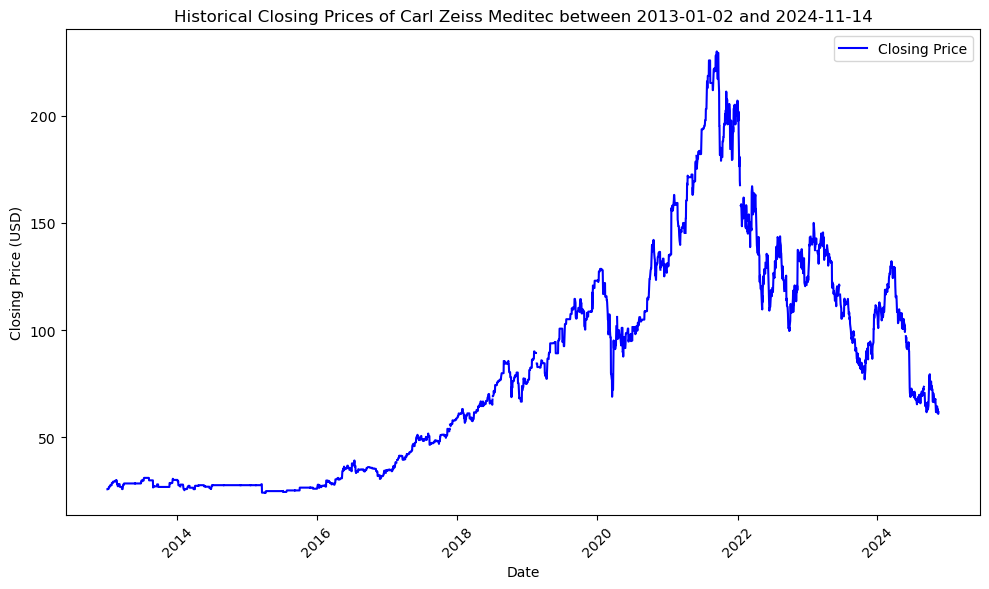


****LAM RESEARCH CORPORATION****



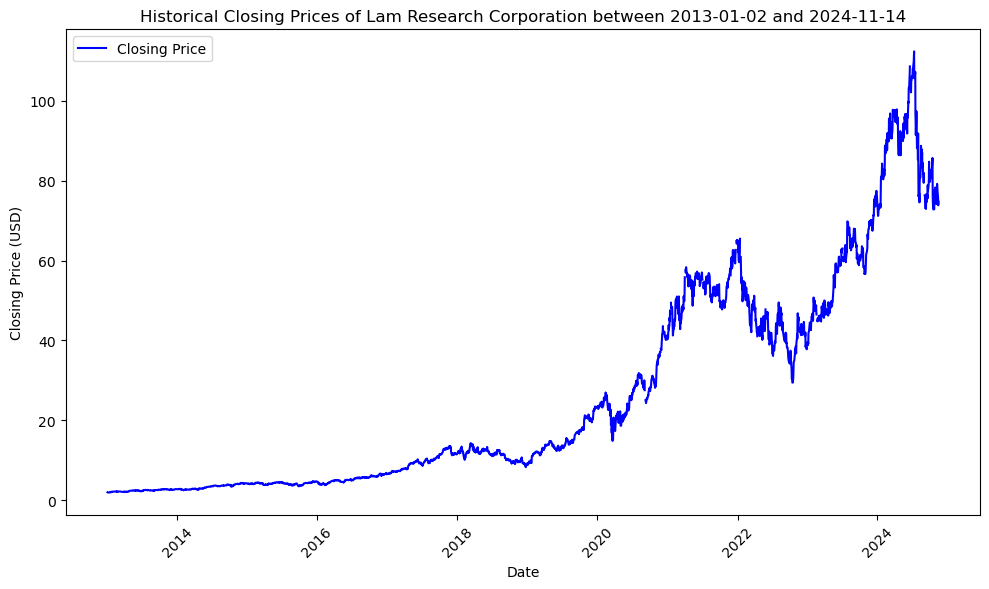


****TOKYO ELECTRON LIMITED****



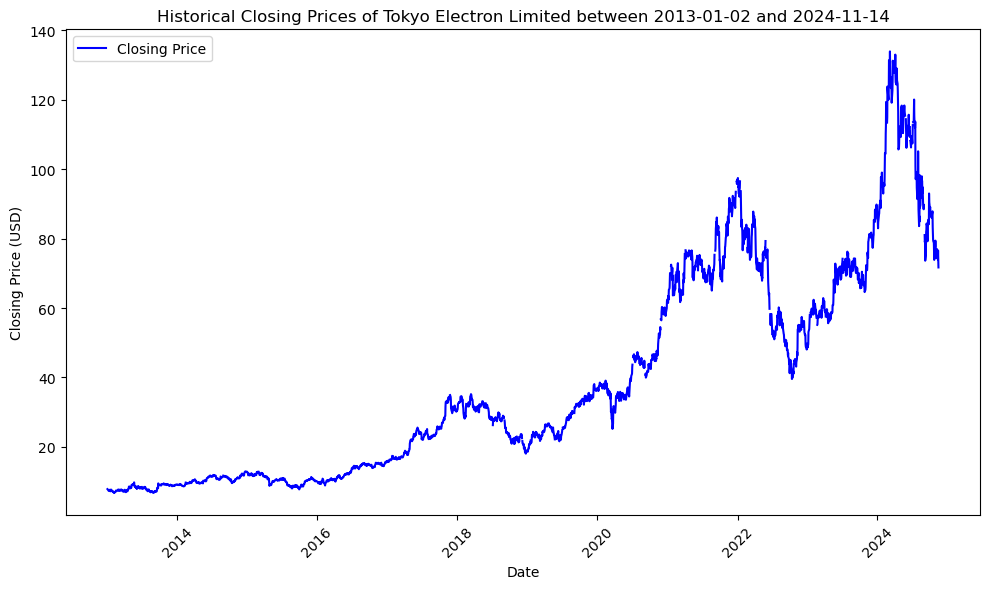


****TAIWAN SEMICONDUCTOR MANUFACTURING COMPANY****



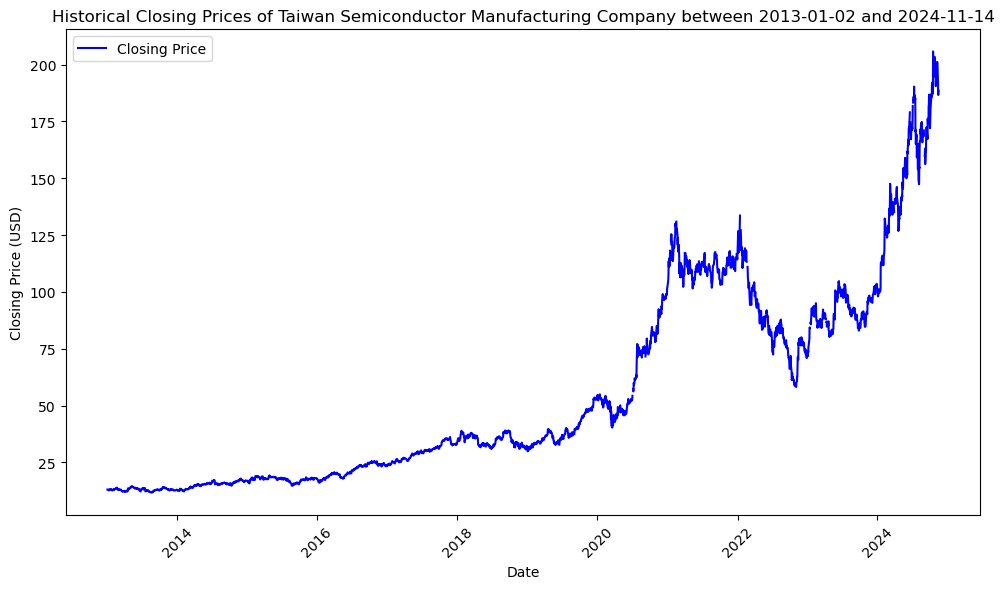


****SAMSUNG ELECTRONICS****




****INTEL CORPORATION****



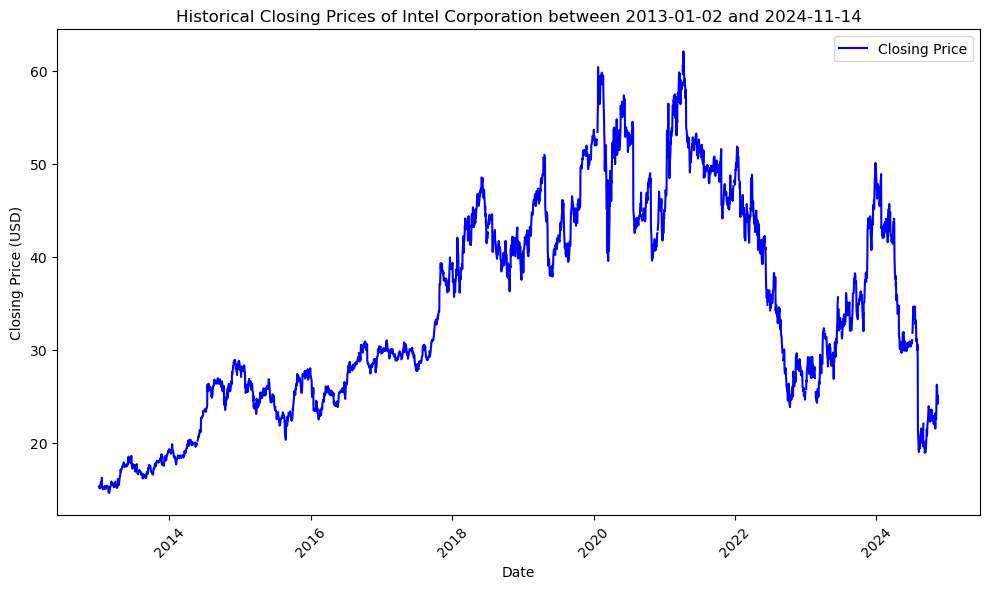

In [8]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_closing_prices(merged_data,f'Close_{company}',company)
    print()

### 2.5.2 Checking for duplicate values

In [9]:
merged_data.duplicated().sum()

1

There are no duplicated values. So we can continue

### 2.5.3 Checking for missing dates

In [10]:
(merged_data.isna().sum()/len(merged_data))*100

Close_Carl Zeiss Meditec                            2.923027
Close_Lam Research Corporation                      2.923027
Close_Tokyo Electron Limited                        2.923027
Close_Taiwan Semiconductor Manufacturing Company    2.923027
Close_Samsung Electronics                           5.293927
Close_Intel Corporation                             2.923027
dtype: float64

As we can see there aren't any null values

### 2.5.4 Looking at seasonality

****CARL ZEISS MEDITEC****



<Figure size 1200x800 with 0 Axes>

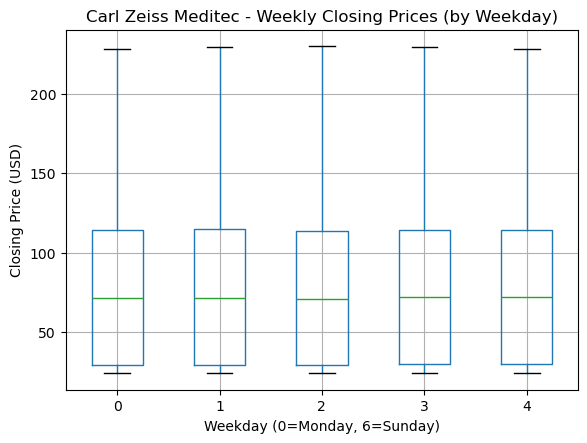

<Figure size 1200x800 with 0 Axes>

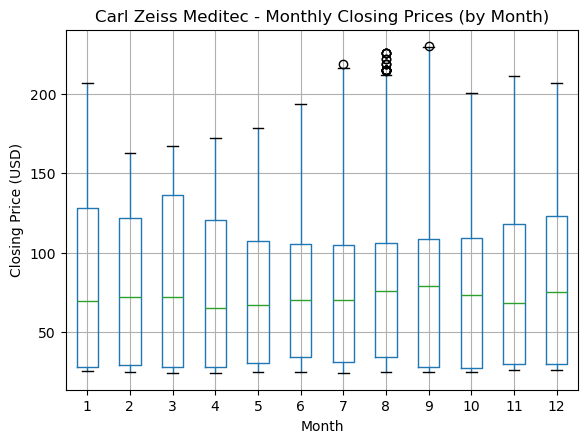

<Figure size 1200x800 with 0 Axes>

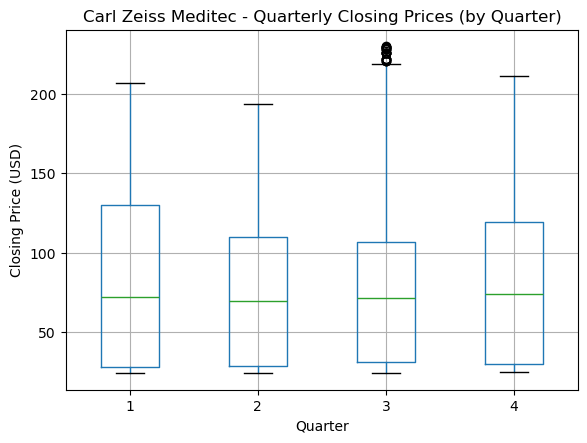


****LAM RESEARCH CORPORATION****



<Figure size 1200x800 with 0 Axes>

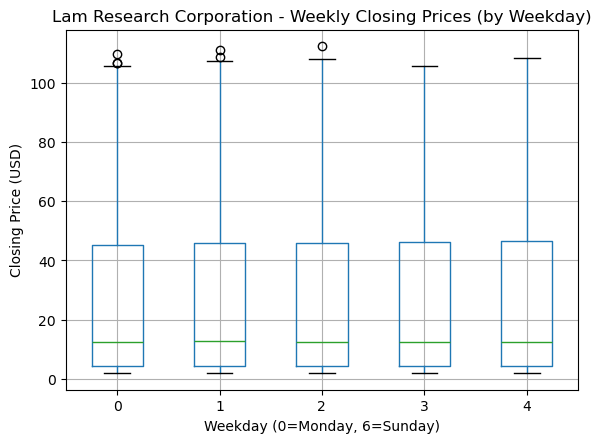

<Figure size 1200x800 with 0 Axes>

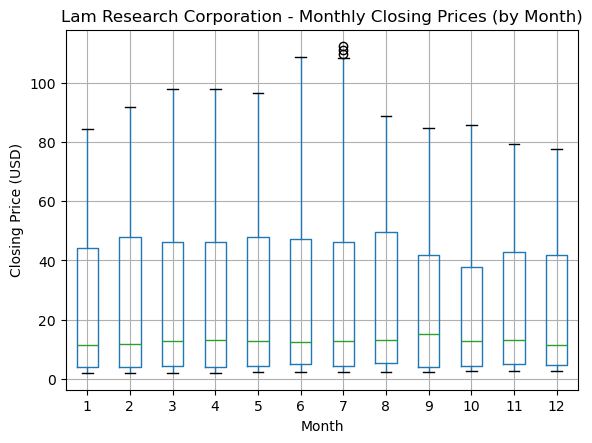

<Figure size 1200x800 with 0 Axes>

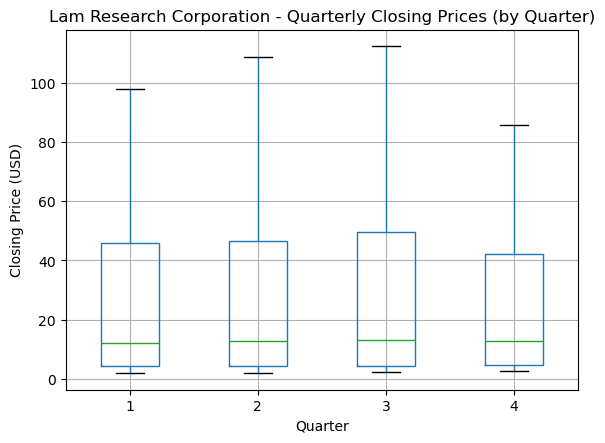


****TOKYO ELECTRON LIMITED****



<Figure size 1200x800 with 0 Axes>

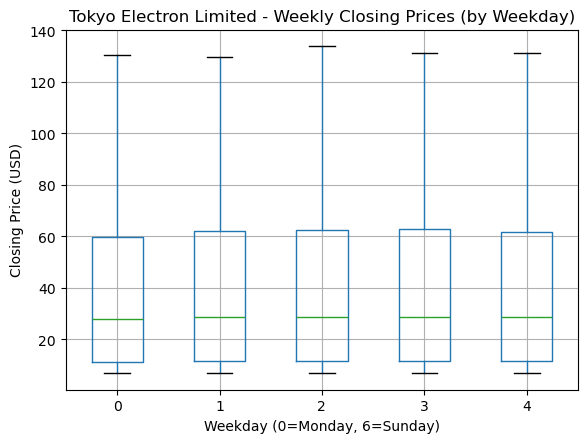

<Figure size 1200x800 with 0 Axes>

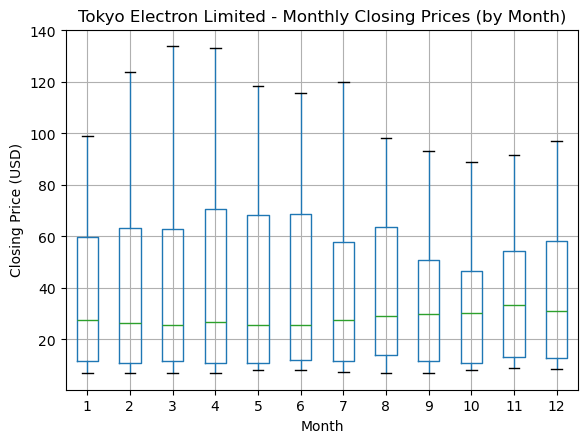

<Figure size 1200x800 with 0 Axes>

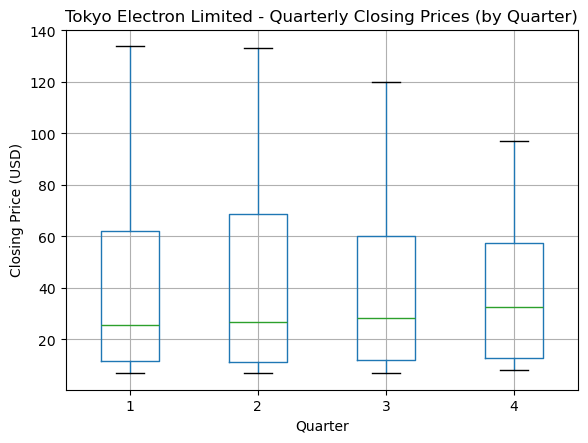


****TAIWAN SEMICONDUCTOR MANUFACTURING COMPANY****



<Figure size 1200x800 with 0 Axes>

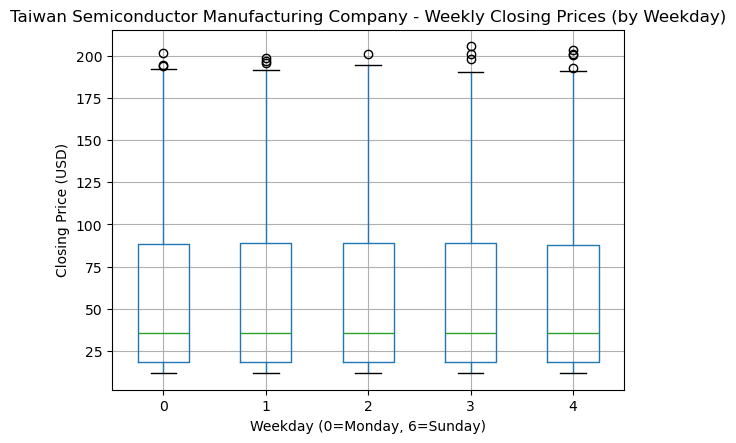

<Figure size 1200x800 with 0 Axes>

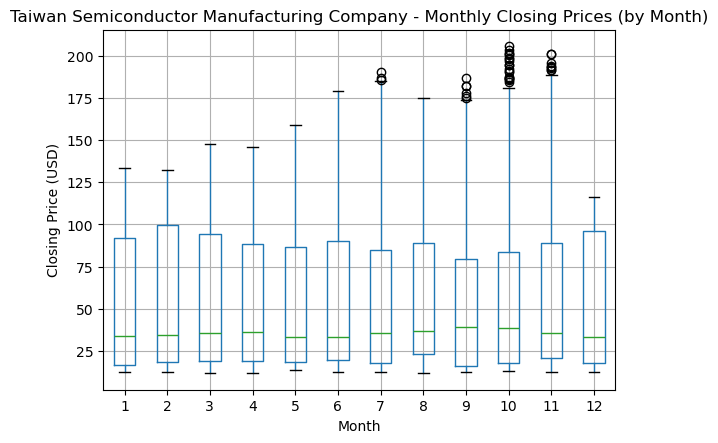

<Figure size 1200x800 with 0 Axes>

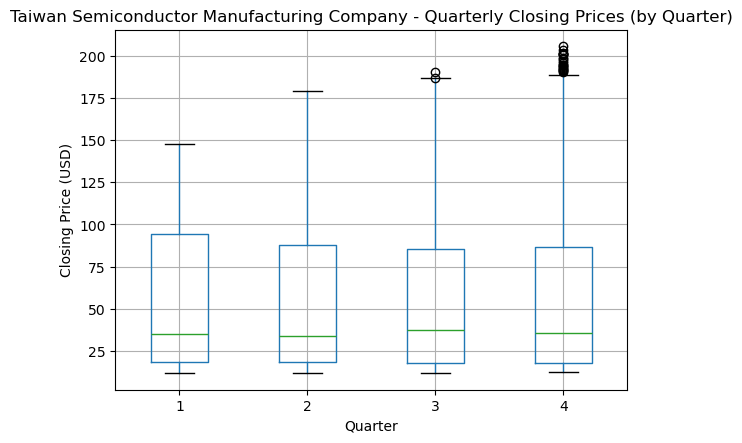


****SAMSUNG ELECTRONICS****



<Figure size 1200x800 with 0 Axes>

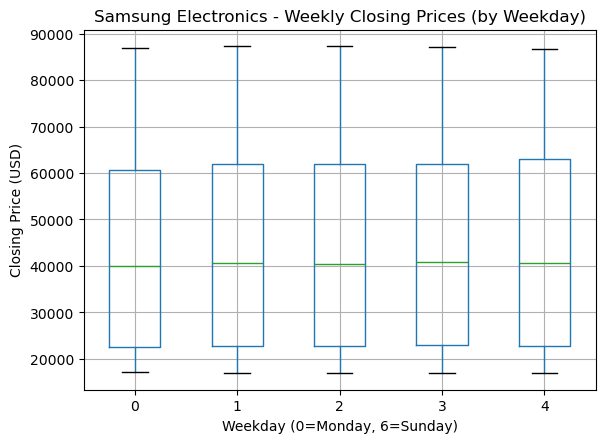

<Figure size 1200x800 with 0 Axes>

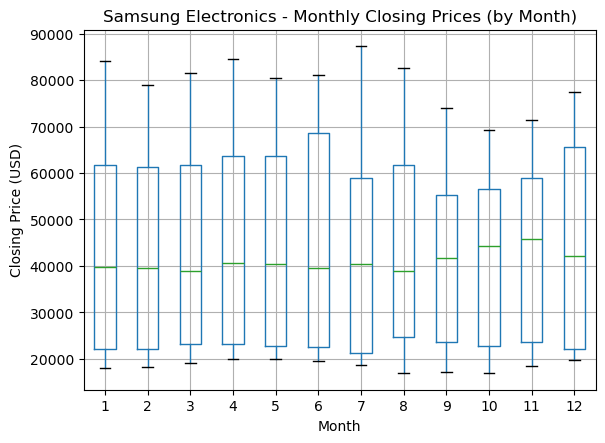

<Figure size 1200x800 with 0 Axes>

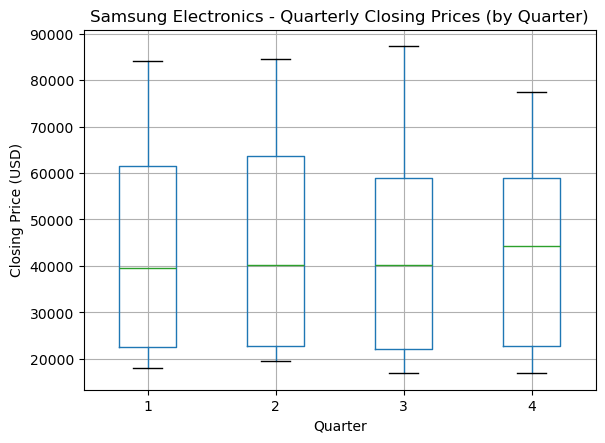


****INTEL CORPORATION****



<Figure size 1200x800 with 0 Axes>

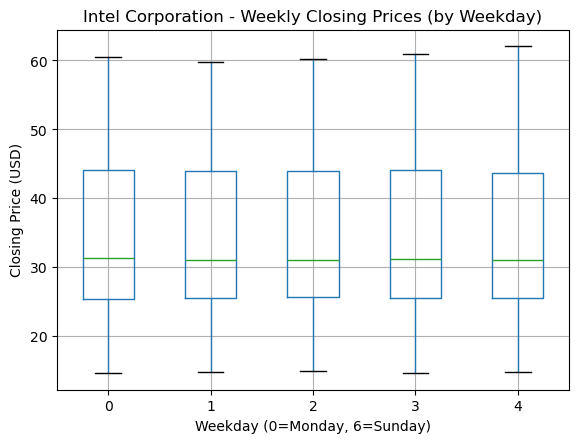

<Figure size 1200x800 with 0 Axes>

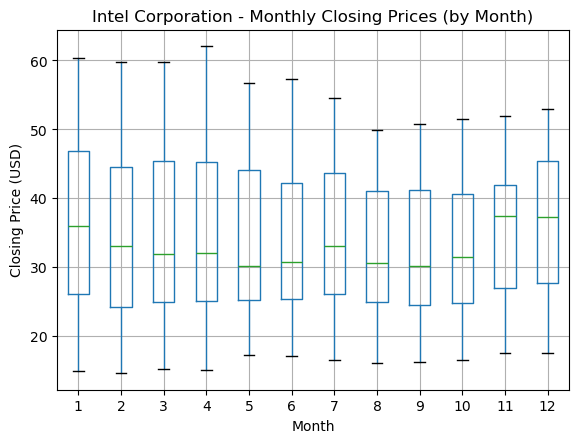

<Figure size 1200x800 with 0 Axes>

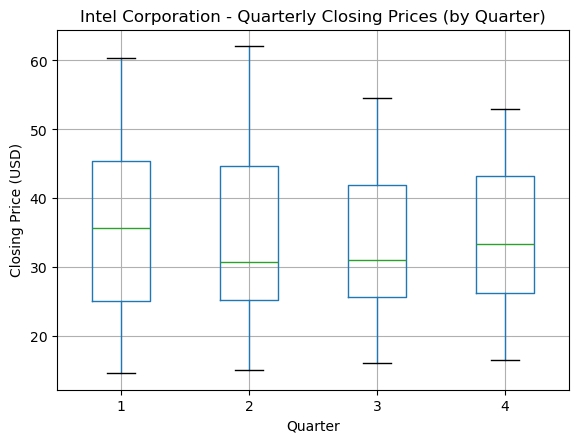

In [11]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_stock_with_multiple_boxplots(merged_data,f'Close_{company}',company)
    print()

With the results above, we cannot determine if there is any clear seasonality for any of the three suppliers. 

### 2.5.5 Choosing the time series of our dataset

Let's chose just the weekly data for the suppliers. To be consistent with the logic with which we viewed ASML's stock data

In [12]:
# Convert the index to a datetime index if it's not already
merged_data.index = pd.to_datetime(merged_data.index)

# Resample the data to weekly frequency and calculate the median
weekly_data_suppliers = merged_data.resample('W').median()

# Display the weekly data
weekly_data_suppliers.head()

Close_Carl Zeiss Meditec  Close_Lam Research Corporation  \
Date                                                                   
2013-01-06                 25.741579                        1.945848   
2013-01-13                 26.057865                        1.920292   
2013-01-20                 27.226336                        1.958627   
2013-01-27                 27.674398                        2.049095   
2013-02-03                 28.728662                        2.132408   

            Close_Tokyo Electron Limited  \
Date                                       
2013-01-06                      7.766667   
2013-01-13                      7.480000   
2013-01-20                      7.460000   
2013-01-27                      7.406667   
2013-02-03                      7.140000   

            Close_Taiwan Semiconductor Manufacturing Company  \
Date                                                           
2013-01-06                                         13.062923   
2013-01-13                                         12.781305   
2013-01-20                                         13.005157   
2013-01-27                                         12.987103   
2013-02-03                                         12.824631   

            Close_Samsung Electronics  Close_Intel Corporation       Date  \
Date                                                                        
2013-01-06               23809.443359                15.246391 2013-01-03   
2013-01-13               23454.544922                15.339355 2013-01-09   
2013-01-20               23022.492188                15.732673 2013-01-16   
2013-01-27               22436.128906                15.042580 2013-01-23   
2013-02-03               22220.095703                15.217781 2013-01-30   

            Weekday  Month  Quarter  
Date                                 
2013-01-06      3.0    1.0      1.0  
2013-01-13      2.0    1.0      1.0  
2013-01-20      2.0    1.0      1.0  
2013-01-27      2.0    1.0      1.0  
2013-02-03      2.0    1.0      1.0

### 2.5.6 Prophet model for each supplier

#### 2.5.6.1 Train-test split

In [13]:
# Drop unnecessary columns from the dataframe
weekly_data_suppliers = weekly_data_suppliers.drop(columns=['Date', 'Weekday', 'Month', 'Quarter'], axis=1)

In [14]:
# Create dictionaries to store train and test dataframes for each company
train_dataframes = {}
test_dataframes = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Filter only the columns corresponding to the current company
    company_data = weekly_data_suppliers[[f'Close_{company}']]
    
    # Rename the column to 'Close'
    company_data.columns = ['Close']
    
    # Create train and test dataframes
    train_dataframes[company] = company_data[:-test_weeks]
    test_dataframes[company] = company_data[-test_weeks:]
    
    # Set 'Date' as the index of the dataframe
    train_dataframes[company].index.name = 'Date'
    test_dataframes[company].index.name = 'Date'

# Display the train dataframe for 'Carl Zeiss Meditec' as an example
train_dataframes['Carl Zeiss Meditec'].head()

Close
Date                 
2013-01-06  25.741579
2013-01-13  26.057865
2013-01-20  27.226336
2013-01-27  27.674398
2013-02-03  28.728662

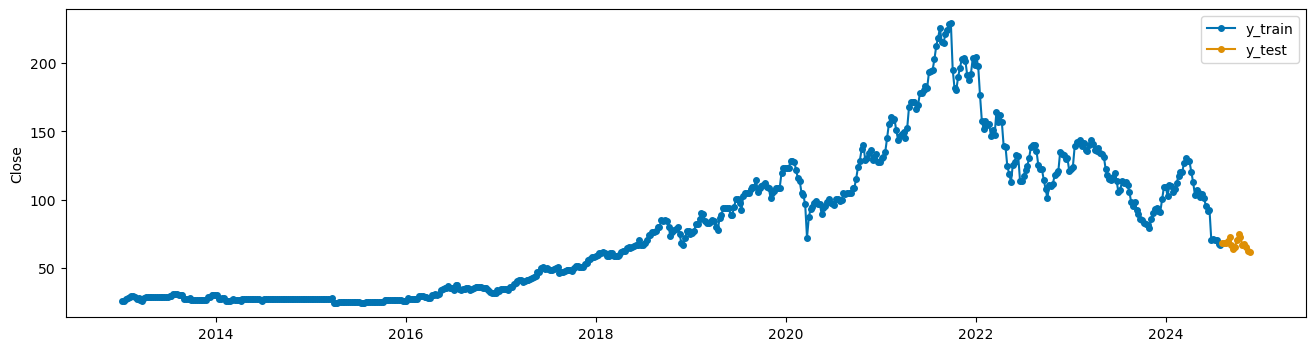

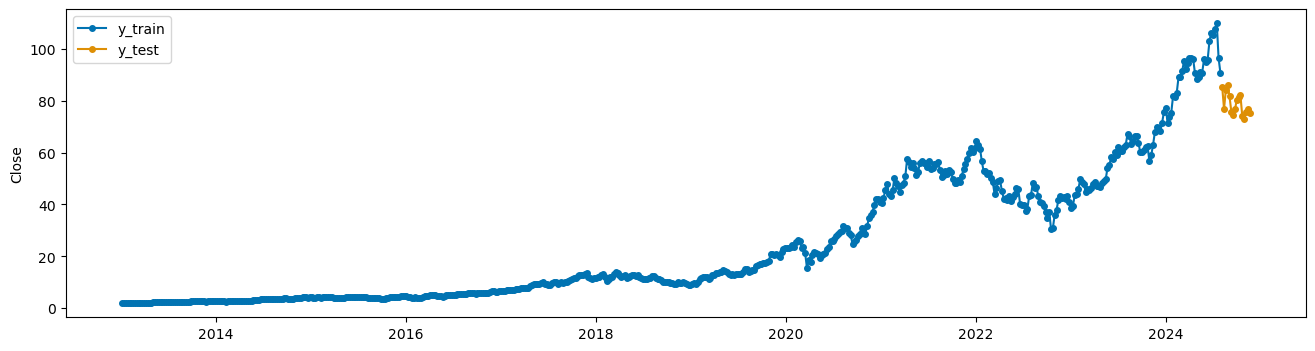

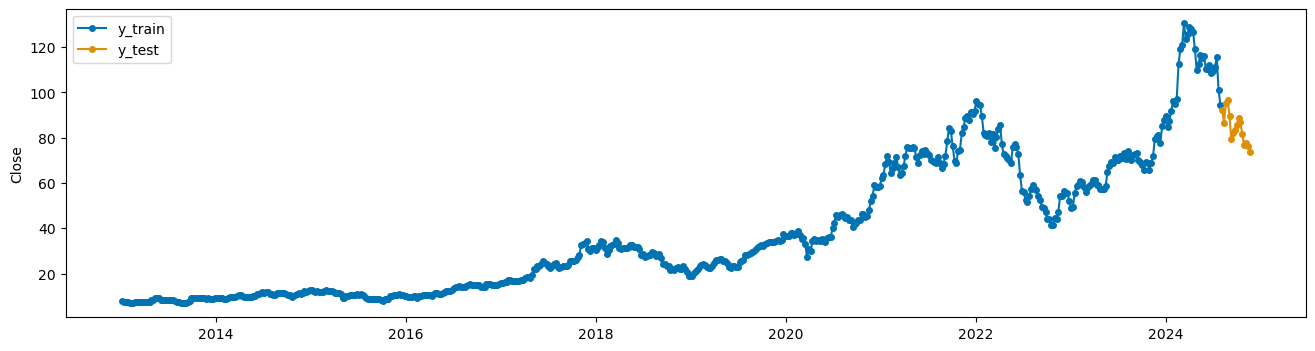

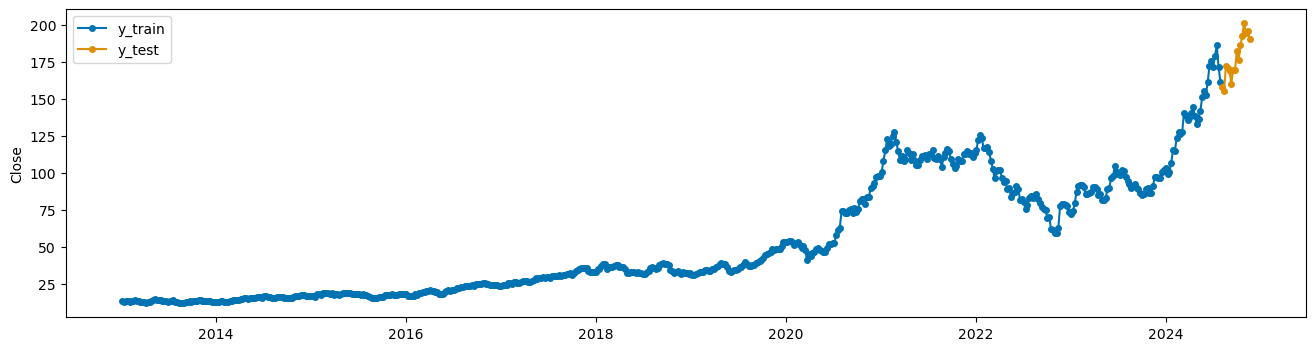

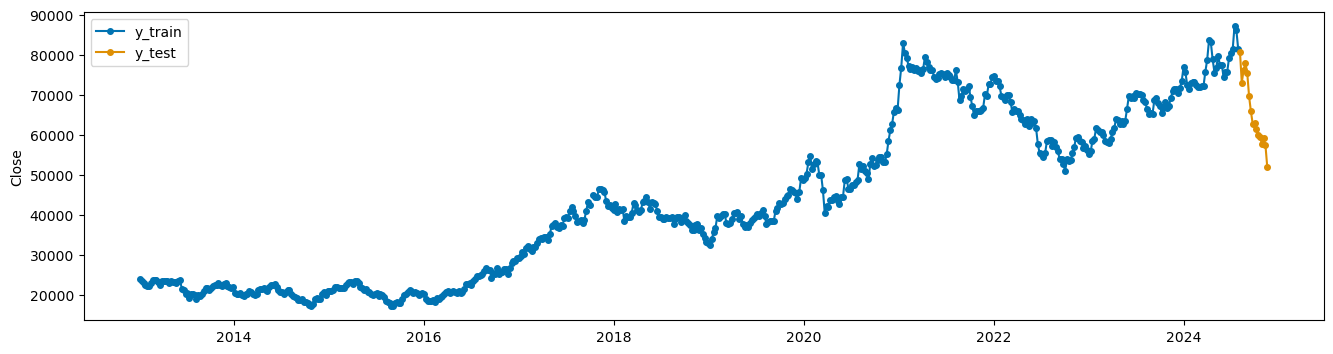

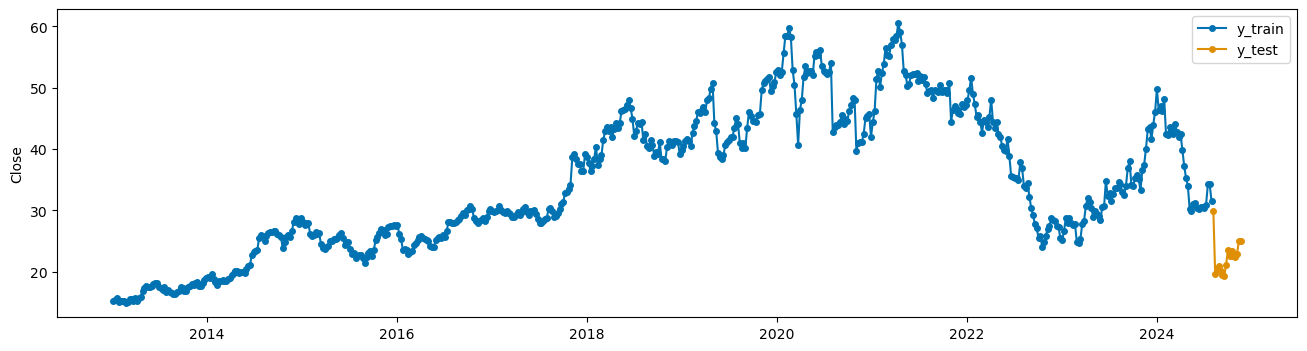

In [15]:
# Iterate over each company to plot the series
for company in company_tickers.values():
    # Extract the train and test data for the current company
    train_data = train_dataframes[company]
    test_data = test_dataframes[company]
    
    # Plot the series for the current company
    plot_series(train_data, test_data, labels=["y_train", "y_test"])

#### 2.5.6.2 Prophet models

11:52:16 - cmdstanpy - INFO - Chain [1] start processing
11:52:16 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Carl Zeiss Meditec
MAPE: 14.59
RMSE: 10.99


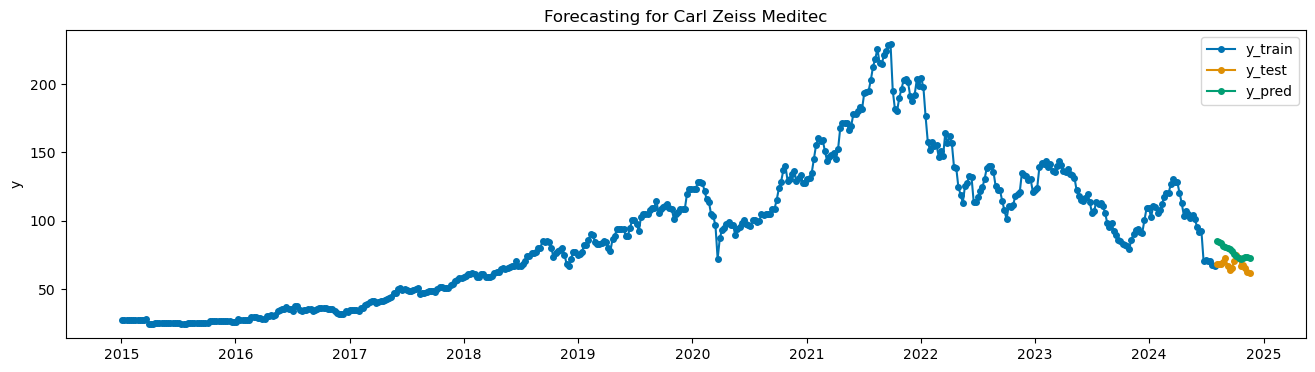

11:52:17 - cmdstanpy - INFO - Chain [1] start processing
11:52:17 - cmdstanpy - INFO - Chain [1] done processing
11:52:17 - cmdstanpy - INFO - Chain [1] start processing
11:52:17 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Lam Research Corporation
MAPE: 7.82
RMSE: 7.10


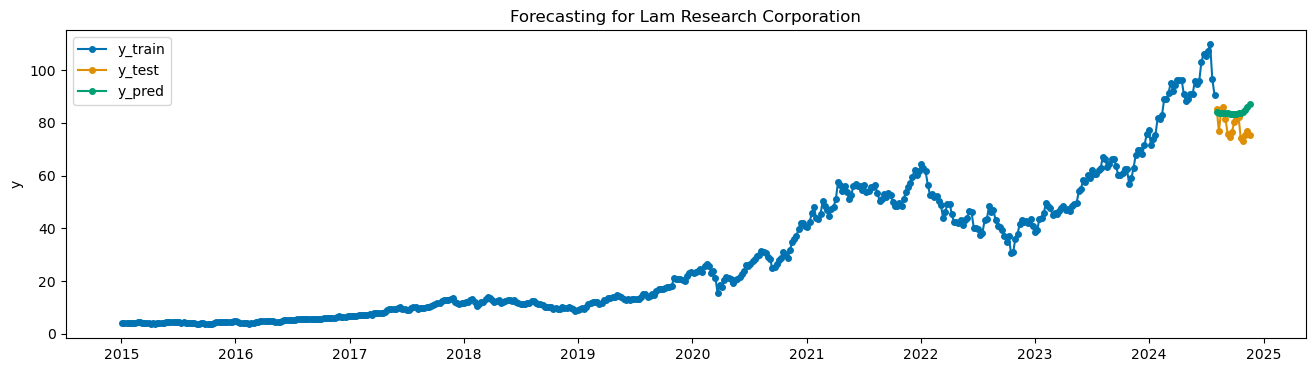

11:52:17 - cmdstanpy - INFO - Chain [1] start processing
11:52:18 - cmdstanpy - INFO - Chain [1] done processing
11:52:18 - cmdstanpy - INFO - Chain [1] start processing
11:52:18 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Tokyo Electron Limited
MAPE: 11.54
RMSE: 11.18


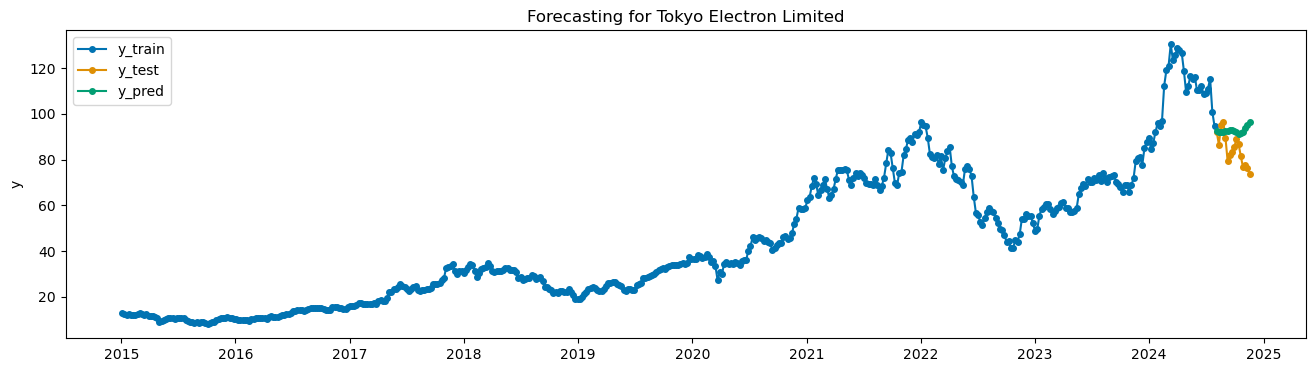

11:52:18 - cmdstanpy - INFO - Chain [1] start processing
11:52:18 - cmdstanpy - INFO - Chain [1] done processing
11:52:18 - cmdstanpy - INFO - Chain [1] start processing
11:52:18 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Taiwan Semiconductor Manufacturing Company
MAPE: 34.07
RMSE: 62.84


11:52:19 - cmdstanpy - INFO - Chain [1] start processing
11:52:19 - cmdstanpy - INFO - Chain [1] done processing
11:52:19 - cmdstanpy - INFO - Chain [1] start processing
11:52:19 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Samsung Electronics
MAPE: 14.29
RMSE: 9933.56


11:52:19 - cmdstanpy - INFO - Chain [1] start processing
11:52:20 - cmdstanpy - INFO - Chain [1] done processing
11:52:20 - cmdstanpy - INFO - Chain [1] start processing
11:52:20 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Intel Corporation
MAPE: 27.30
RMSE: 6.24


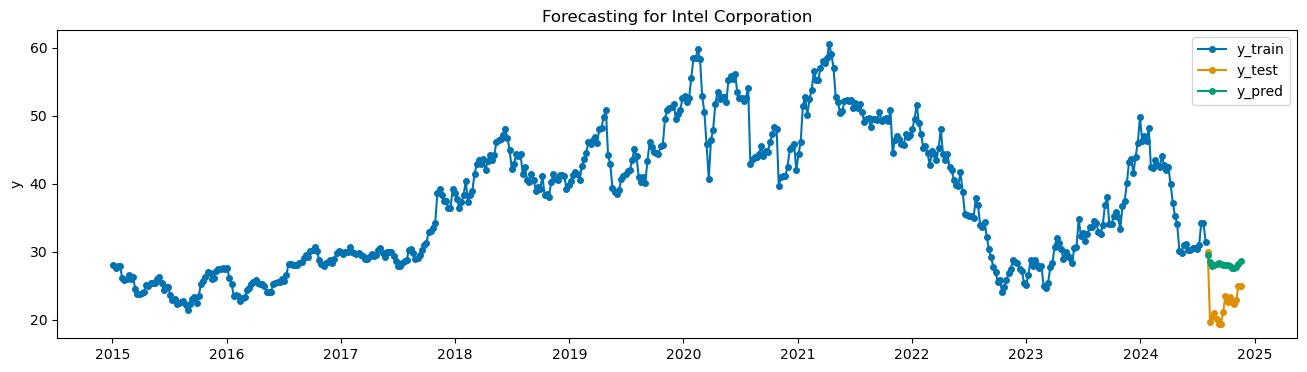

11:52:20 - cmdstanpy - INFO - Chain [1] start processing
11:52:20 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Dictionary to store each Prophet model by company
prophet_models = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Prepare the data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure DatetimeIndex
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    # Initialize and fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(train_data_prophet)

    # Define the forecast horizon (e.g., 12 periods into the future)
    future = prophet_model.make_future_dataframe(periods=test_weeks, freq='W')

    # Generate the predictions
    forecast = prophet_model.predict(future)

    # Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
    forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    # Ensure 'ds' is the index of train_data_prophet 
    train_data_prophet = train_data_prophet.set_index('ds')

    # Calculate MAPE and RMSE errors
    actuals = test_dataframes[company]['Close']  # Actual values from test data
    predictions = forecast['Close']              # Predicted values from forecast

    # Ensure the indices of actuals and predictions align
    common_index = actuals.index.intersection(predictions.index)
    actuals = actuals.loc[common_index]
    predictions = predictions.loc[common_index]

    mape = mean_absolute_percentage_error(actuals, predictions)*100
    rmse = root_mean_squared_error(actuals, predictions)

    # Display errors
    print(f'Forecasting for {company}')
    print(f'MAPE: {mape:.2f}')
    print(f'RMSE: {rmse:.2f}')
    
    # Plot the forecast results
    plot_series(
        train_data_prophet[-500:],  # Only pass the 'Close' column for training data
        test_dataframes[company],   # Only pass the 'Close' column for test data
        forecast,                   # Only pass the 'Close' column for forecast
        labels=["y_train", "y_test", "y_pred"]
    )
    
    plt.title(f'Forecasting for {company}')  # Add title for better clarity
    plt.show()  # Show the plot before moving to the next company
    
    # We need are now going to save the prophet_models only that this time, we will fit it with all the data (train and test data) 
    # Initialize the Prophet model
    prophet_model = Prophet()
    # We have modified the data to be able to train the prophet model
    test_data = pd.DataFrame(actuals).rename(columns={'Close':'y'}).reset_index(names="ds")
    train_data_prophet = train_data_prophet.reset_index(names="ds")
    all_data = pd.concat([train_data_prophet,test_data])
    prophet_model.fit(all_data)
    
    # Store the model in the dictionary with the company name as key
    prophet_models[company] = prophet_model

#### 2.5.6.3 Fine-tunning the prophet models

11:52:20 - cmdstanpy - INFO - Chain [1] start processing
11:52:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1 of 3136 for Carl Zeiss Meditec...


11:52:21 - cmdstanpy - INFO - Chain [1] start processing
11:52:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2 of 3136 for Carl Zeiss Meditec...


11:52:21 - cmdstanpy - INFO - Chain [1] start processing
11:52:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3 of 3136 for Carl Zeiss Meditec...


11:52:21 - cmdstanpy - INFO - Chain [1] start processing
11:52:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 4 of 3136 for Carl Zeiss Meditec...


11:52:21 - cmdstanpy - INFO - Chain [1] start processing
11:52:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 5 of 3136 for Carl Zeiss Meditec...


11:52:22 - cmdstanpy - INFO - Chain [1] start processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 6 of 3136 for Carl Zeiss Meditec...


11:52:22 - cmdstanpy - INFO - Chain [1] start processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 7 of 3136 for Carl Zeiss Meditec...


11:52:22 - cmdstanpy - INFO - Chain [1] start processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 8 of 3136 for Carl Zeiss Meditec...


11:52:22 - cmdstanpy - INFO - Chain [1] start processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 9 of 3136 for Carl Zeiss Meditec...


11:52:23 - cmdstanpy - INFO - Chain [1] start processing
11:52:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 10 of 3136 for Carl Zeiss Meditec...


11:52:23 - cmdstanpy - INFO - Chain [1] start processing
11:52:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 11 of 3136 for Carl Zeiss Meditec...


11:52:23 - cmdstanpy - INFO - Chain [1] start processing
11:52:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 12 of 3136 for Carl Zeiss Meditec...


11:52:23 - cmdstanpy - INFO - Chain [1] start processing
11:52:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 13 of 3136 for Carl Zeiss Meditec...


11:52:24 - cmdstanpy - INFO - Chain [1] start processing
11:52:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 14 of 3136 for Carl Zeiss Meditec...


11:52:24 - cmdstanpy - INFO - Chain [1] start processing
11:52:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 15 of 3136 for Carl Zeiss Meditec...


11:52:24 - cmdstanpy - INFO - Chain [1] start processing
11:52:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 16 of 3136 for Carl Zeiss Meditec...
Processing combination 17 of 3136 for Carl Zeiss Meditec...


11:52:24 - cmdstanpy - INFO - Chain [1] start processing
11:52:24 - cmdstanpy - INFO - Chain [1] done processing
11:52:25 - cmdstanpy - INFO - Chain [1] start processing
11:52:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 18 of 3136 for Carl Zeiss Meditec...


11:52:25 - cmdstanpy - INFO - Chain [1] start processing
11:52:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 19 of 3136 for Carl Zeiss Meditec...


11:52:25 - cmdstanpy - INFO - Chain [1] start processing
11:52:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 20 of 3136 for Carl Zeiss Meditec...
Processing combination 21 of 3136 for Carl Zeiss Meditec...


11:52:25 - cmdstanpy - INFO - Chain [1] start processing
11:52:25 - cmdstanpy - INFO - Chain [1] done processing
11:52:26 - cmdstanpy - INFO - Chain [1] start processing
11:52:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 22 of 3136 for Carl Zeiss Meditec...


11:52:26 - cmdstanpy - INFO - Chain [1] start processing
11:52:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 23 of 3136 for Carl Zeiss Meditec...


11:52:26 - cmdstanpy - INFO - Chain [1] start processing
11:52:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 24 of 3136 for Carl Zeiss Meditec...
Processing combination 25 of 3136 for Carl Zeiss Meditec...


11:52:26 - cmdstanpy - INFO - Chain [1] start processing
11:52:26 - cmdstanpy - INFO - Chain [1] done processing
11:52:27 - cmdstanpy - INFO - Chain [1] start processing
11:52:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 26 of 3136 for Carl Zeiss Meditec...


11:52:27 - cmdstanpy - INFO - Chain [1] start processing
11:52:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 27 of 3136 for Carl Zeiss Meditec...


11:52:27 - cmdstanpy - INFO - Chain [1] start processing
11:52:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 28 of 3136 for Carl Zeiss Meditec...


11:52:27 - cmdstanpy - INFO - Chain [1] start processing
11:52:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 29 of 3136 for Carl Zeiss Meditec...


11:52:28 - cmdstanpy - INFO - Chain [1] start processing
11:52:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 30 of 3136 for Carl Zeiss Meditec...


11:52:28 - cmdstanpy - INFO - Chain [1] start processing
11:52:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 31 of 3136 for Carl Zeiss Meditec...


11:52:28 - cmdstanpy - INFO - Chain [1] start processing
11:52:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 32 of 3136 for Carl Zeiss Meditec...
Processing combination 33 of 3136 for Carl Zeiss Meditec...


11:52:28 - cmdstanpy - INFO - Chain [1] start processing
11:52:28 - cmdstanpy - INFO - Chain [1] done processing
11:52:28 - cmdstanpy - INFO - Chain [1] start processing
11:52:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 34 of 3136 for Carl Zeiss Meditec...


11:52:29 - cmdstanpy - INFO - Chain [1] start processing
11:52:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 35 of 3136 for Carl Zeiss Meditec...


11:52:29 - cmdstanpy - INFO - Chain [1] start processing
11:52:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 36 of 3136 for Carl Zeiss Meditec...


11:52:29 - cmdstanpy - INFO - Chain [1] start processing
11:52:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 37 of 3136 for Carl Zeiss Meditec...


11:52:30 - cmdstanpy - INFO - Chain [1] start processing
11:52:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 38 of 3136 for Carl Zeiss Meditec...


11:52:30 - cmdstanpy - INFO - Chain [1] start processing
11:52:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 39 of 3136 for Carl Zeiss Meditec...


11:52:30 - cmdstanpy - INFO - Chain [1] start processing
11:52:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 40 of 3136 for Carl Zeiss Meditec...


11:52:30 - cmdstanpy - INFO - Chain [1] start processing
11:52:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 41 of 3136 for Carl Zeiss Meditec...


11:52:31 - cmdstanpy - INFO - Chain [1] start processing
11:52:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 42 of 3136 for Carl Zeiss Meditec...


11:52:31 - cmdstanpy - INFO - Chain [1] start processing
11:52:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 43 of 3136 for Carl Zeiss Meditec...


11:52:31 - cmdstanpy - INFO - Chain [1] start processing
11:52:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 44 of 3136 for Carl Zeiss Meditec...


11:52:31 - cmdstanpy - INFO - Chain [1] start processing
11:52:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 45 of 3136 for Carl Zeiss Meditec...


11:52:32 - cmdstanpy - INFO - Chain [1] start processing
11:52:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 46 of 3136 for Carl Zeiss Meditec...


11:52:32 - cmdstanpy - INFO - Chain [1] start processing
11:52:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 47 of 3136 for Carl Zeiss Meditec...


11:52:32 - cmdstanpy - INFO - Chain [1] start processing
11:52:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 48 of 3136 for Carl Zeiss Meditec...


11:52:32 - cmdstanpy - INFO - Chain [1] start processing
11:52:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 49 of 3136 for Carl Zeiss Meditec...


11:52:33 - cmdstanpy - INFO - Chain [1] start processing
11:52:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 50 of 3136 for Carl Zeiss Meditec...


11:52:33 - cmdstanpy - INFO - Chain [1] start processing
11:52:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 51 of 3136 for Carl Zeiss Meditec...


11:52:33 - cmdstanpy - INFO - Chain [1] start processing
11:52:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 52 of 3136 for Carl Zeiss Meditec...


11:52:33 - cmdstanpy - INFO - Chain [1] start processing
11:52:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 53 of 3136 for Carl Zeiss Meditec...


11:52:34 - cmdstanpy - INFO - Chain [1] start processing
11:52:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 54 of 3136 for Carl Zeiss Meditec...


11:52:34 - cmdstanpy - INFO - Chain [1] start processing
11:52:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 55 of 3136 for Carl Zeiss Meditec...


11:52:34 - cmdstanpy - INFO - Chain [1] start processing
11:52:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 56 of 3136 for Carl Zeiss Meditec...


11:52:34 - cmdstanpy - INFO - Chain [1] start processing
11:52:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 57 of 3136 for Carl Zeiss Meditec...


11:52:35 - cmdstanpy - INFO - Chain [1] start processing
11:52:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 58 of 3136 for Carl Zeiss Meditec...


11:52:35 - cmdstanpy - INFO - Chain [1] start processing
11:52:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 59 of 3136 for Carl Zeiss Meditec...


11:52:35 - cmdstanpy - INFO - Chain [1] start processing
11:52:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 60 of 3136 for Carl Zeiss Meditec...


11:52:35 - cmdstanpy - INFO - Chain [1] start processing
11:52:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 61 of 3136 for Carl Zeiss Meditec...


11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 62 of 3136 for Carl Zeiss Meditec...


11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 63 of 3136 for Carl Zeiss Meditec...


11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 64 of 3136 for Carl Zeiss Meditec...


11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 65 of 3136 for Carl Zeiss Meditec...


11:52:37 - cmdstanpy - INFO - Chain [1] start processing
11:52:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 66 of 3136 for Carl Zeiss Meditec...


11:52:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 67 of 3136 for Carl Zeiss Meditec...


11:52:37 - cmdstanpy - INFO - Chain [1] done processing
11:52:37 - cmdstanpy - INFO - Chain [1] start processing
11:52:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 68 of 3136 for Carl Zeiss Meditec...


11:52:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 69 of 3136 for Carl Zeiss Meditec...


11:52:37 - cmdstanpy - INFO - Chain [1] done processing
11:52:38 - cmdstanpy - INFO - Chain [1] start processing
11:52:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 70 of 3136 for Carl Zeiss Meditec...


11:52:38 - cmdstanpy - INFO - Chain [1] start processing
11:52:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 71 of 3136 for Carl Zeiss Meditec...


11:52:38 - cmdstanpy - INFO - Chain [1] start processing
11:52:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 72 of 3136 for Carl Zeiss Meditec...


11:52:38 - cmdstanpy - INFO - Chain [1] start processing
11:52:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 73 of 3136 for Carl Zeiss Meditec...


11:52:39 - cmdstanpy - INFO - Chain [1] start processing
11:52:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 74 of 3136 for Carl Zeiss Meditec...


11:52:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 75 of 3136 for Carl Zeiss Meditec...


11:52:39 - cmdstanpy - INFO - Chain [1] done processing
11:52:39 - cmdstanpy - INFO - Chain [1] start processing
11:52:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 76 of 3136 for Carl Zeiss Meditec...


11:52:40 - cmdstanpy - INFO - Chain [1] start processing
11:52:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 77 of 3136 for Carl Zeiss Meditec...


11:52:40 - cmdstanpy - INFO - Chain [1] start processing
11:52:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 78 of 3136 for Carl Zeiss Meditec...


11:52:40 - cmdstanpy - INFO - Chain [1] start processing
11:52:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 79 of 3136 for Carl Zeiss Meditec...


11:52:40 - cmdstanpy - INFO - Chain [1] start processing
11:52:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 80 of 3136 for Carl Zeiss Meditec...


11:52:41 - cmdstanpy - INFO - Chain [1] start processing
11:52:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 81 of 3136 for Carl Zeiss Meditec...


11:52:41 - cmdstanpy - INFO - Chain [1] start processing
11:52:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 82 of 3136 for Carl Zeiss Meditec...


11:52:41 - cmdstanpy - INFO - Chain [1] start processing
11:52:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 83 of 3136 for Carl Zeiss Meditec...


11:52:41 - cmdstanpy - INFO - Chain [1] start processing
11:52:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 84 of 3136 for Carl Zeiss Meditec...


11:52:42 - cmdstanpy - INFO - Chain [1] start processing
11:52:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 85 of 3136 for Carl Zeiss Meditec...


11:52:42 - cmdstanpy - INFO - Chain [1] start processing
11:52:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 86 of 3136 for Carl Zeiss Meditec...


11:52:42 - cmdstanpy - INFO - Chain [1] start processing
11:52:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 87 of 3136 for Carl Zeiss Meditec...


11:52:43 - cmdstanpy - INFO - Chain [1] start processing
11:52:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 88 of 3136 for Carl Zeiss Meditec...


11:52:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 89 of 3136 for Carl Zeiss Meditec...


11:52:43 - cmdstanpy - INFO - Chain [1] done processing
11:52:43 - cmdstanpy - INFO - Chain [1] start processing
11:52:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 90 of 3136 for Carl Zeiss Meditec...


11:52:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 91 of 3136 for Carl Zeiss Meditec...


11:52:43 - cmdstanpy - INFO - Chain [1] done processing
11:52:44 - cmdstanpy - INFO - Chain [1] start processing
11:52:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 92 of 3136 for Carl Zeiss Meditec...


11:52:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 93 of 3136 for Carl Zeiss Meditec...


11:52:44 - cmdstanpy - INFO - Chain [1] done processing
11:52:44 - cmdstanpy - INFO - Chain [1] start processing
11:52:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 94 of 3136 for Carl Zeiss Meditec...


11:52:44 - cmdstanpy - INFO - Chain [1] start processing
11:52:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 95 of 3136 for Carl Zeiss Meditec...


11:52:45 - cmdstanpy - INFO - Chain [1] start processing
11:52:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 96 of 3136 for Carl Zeiss Meditec...


11:52:45 - cmdstanpy - INFO - Chain [1] start processing
11:52:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 97 of 3136 for Carl Zeiss Meditec...


11:52:45 - cmdstanpy - INFO - Chain [1] start processing
11:52:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 98 of 3136 for Carl Zeiss Meditec...


11:52:46 - cmdstanpy - INFO - Chain [1] start processing
11:52:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 99 of 3136 for Carl Zeiss Meditec...


11:52:46 - cmdstanpy - INFO - Chain [1] start processing
11:52:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 100 of 3136 for Carl Zeiss Meditec...


11:52:46 - cmdstanpy - INFO - Chain [1] start processing
11:52:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 101 of 3136 for Carl Zeiss Meditec...


11:52:46 - cmdstanpy - INFO - Chain [1] start processing
11:52:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 102 of 3136 for Carl Zeiss Meditec...


11:52:47 - cmdstanpy - INFO - Chain [1] start processing
11:52:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 103 of 3136 for Carl Zeiss Meditec...


11:52:47 - cmdstanpy - INFO - Chain [1] start processing
11:52:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 104 of 3136 for Carl Zeiss Meditec...


11:52:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 105 of 3136 for Carl Zeiss Meditec...


11:52:47 - cmdstanpy - INFO - Chain [1] done processing
11:52:47 - cmdstanpy - INFO - Chain [1] start processing
11:52:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 106 of 3136 for Carl Zeiss Meditec...


11:52:48 - cmdstanpy - INFO - Chain [1] start processing
11:52:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 107 of 3136 for Carl Zeiss Meditec...


11:52:48 - cmdstanpy - INFO - Chain [1] start processing
11:52:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 108 of 3136 for Carl Zeiss Meditec...


11:52:48 - cmdstanpy - INFO - Chain [1] start processing
11:52:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 109 of 3136 for Carl Zeiss Meditec...


11:52:48 - cmdstanpy - INFO - Chain [1] start processing
11:52:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 110 of 3136 for Carl Zeiss Meditec...


11:52:49 - cmdstanpy - INFO - Chain [1] start processing
11:52:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 111 of 3136 for Carl Zeiss Meditec...


11:52:49 - cmdstanpy - INFO - Chain [1] start processing
11:52:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 112 of 3136 for Carl Zeiss Meditec...


11:52:49 - cmdstanpy - INFO - Chain [1] start processing
11:52:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 113 of 3136 for Carl Zeiss Meditec...


11:52:49 - cmdstanpy - INFO - Chain [1] start processing
11:52:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 114 of 3136 for Carl Zeiss Meditec...
Processing combination 115 of 3136 for Carl Zeiss Meditec...


11:52:50 - cmdstanpy - INFO - Chain [1] start processing
11:52:50 - cmdstanpy - INFO - Chain [1] done processing
11:52:50 - cmdstanpy - INFO - Chain [1] start processing
11:52:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 116 of 3136 for Carl Zeiss Meditec...
Processing combination 117 of 3136 for Carl Zeiss Meditec...


11:52:50 - cmdstanpy - INFO - Chain [1] start processing
11:52:50 - cmdstanpy - INFO - Chain [1] done processing
11:52:50 - cmdstanpy - INFO - Chain [1] start processing
11:52:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 118 of 3136 for Carl Zeiss Meditec...
Processing combination 119 of 3136 for Carl Zeiss Meditec...


11:52:51 - cmdstanpy - INFO - Chain [1] start processing
11:52:51 - cmdstanpy - INFO - Chain [1] done processing
11:52:51 - cmdstanpy - INFO - Chain [1] start processing
11:52:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 120 of 3136 for Carl Zeiss Meditec...
Processing combination 121 of 3136 for Carl Zeiss Meditec...


11:52:51 - cmdstanpy - INFO - Chain [1] start processing
11:52:51 - cmdstanpy - INFO - Chain [1] done processing
11:52:51 - cmdstanpy - INFO - Chain [1] start processing
11:52:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 122 of 3136 for Carl Zeiss Meditec...


11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 123 of 3136 for Carl Zeiss Meditec...


11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 124 of 3136 for Carl Zeiss Meditec...
Processing combination 125 of 3136 for Carl Zeiss Meditec...


11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:52 - cmdstanpy - INFO - Chain [1] done processing
11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 126 of 3136 for Carl Zeiss Meditec...
Processing combination 127 of 3136 for Carl Zeiss Meditec...


11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:53 - cmdstanpy - INFO - Chain [1] done processing
11:52:53 - cmdstanpy - INFO - Chain [1] start processing
11:52:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 128 of 3136 for Carl Zeiss Meditec...
Processing combination 129 of 3136 for Carl Zeiss Meditec...


11:52:53 - cmdstanpy - INFO - Chain [1] start processing
11:52:53 - cmdstanpy - INFO - Chain [1] done processing
11:52:53 - cmdstanpy - INFO - Chain [1] start processing
11:52:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 130 of 3136 for Carl Zeiss Meditec...


11:52:53 - cmdstanpy - INFO - Chain [1] start processing
11:52:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 131 of 3136 for Carl Zeiss Meditec...


11:52:54 - cmdstanpy - INFO - Chain [1] start processing
11:52:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 132 of 3136 for Carl Zeiss Meditec...
Processing combination 133 of 3136 for Carl Zeiss Meditec...


11:52:54 - cmdstanpy - INFO - Chain [1] start processing
11:52:54 - cmdstanpy - INFO - Chain [1] done processing
11:52:54 - cmdstanpy - INFO - Chain [1] start processing
11:52:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 134 of 3136 for Carl Zeiss Meditec...
Processing combination 135 of 3136 for Carl Zeiss Meditec...


11:52:54 - cmdstanpy - INFO - Chain [1] start processing
11:52:54 - cmdstanpy - INFO - Chain [1] done processing
11:52:54 - cmdstanpy - INFO - Chain [1] start processing
11:52:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 136 of 3136 for Carl Zeiss Meditec...
Processing combination 137 of 3136 for Carl Zeiss Meditec...


11:52:55 - cmdstanpy - INFO - Chain [1] start processing
11:52:55 - cmdstanpy - INFO - Chain [1] done processing
11:52:55 - cmdstanpy - INFO - Chain [1] start processing
11:52:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 138 of 3136 for Carl Zeiss Meditec...
Processing combination 139 of 3136 for Carl Zeiss Meditec...


11:52:55 - cmdstanpy - INFO - Chain [1] start processing
11:52:55 - cmdstanpy - INFO - Chain [1] done processing
11:52:55 - cmdstanpy - INFO - Chain [1] start processing
11:52:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 140 of 3136 for Carl Zeiss Meditec...
Processing combination 141 of 3136 for Carl Zeiss Meditec...


11:52:56 - cmdstanpy - INFO - Chain [1] start processing
11:52:56 - cmdstanpy - INFO - Chain [1] done processing
11:52:56 - cmdstanpy - INFO - Chain [1] start processing
11:52:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 142 of 3136 for Carl Zeiss Meditec...


11:52:56 - cmdstanpy - INFO - Chain [1] start processing
11:52:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 143 of 3136 for Carl Zeiss Meditec...


11:52:56 - cmdstanpy - INFO - Chain [1] start processing
11:52:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 144 of 3136 for Carl Zeiss Meditec...
Processing combination 145 of 3136 for Carl Zeiss Meditec...


11:52:57 - cmdstanpy - INFO - Chain [1] start processing
11:52:57 - cmdstanpy - INFO - Chain [1] done processing
11:52:57 - cmdstanpy - INFO - Chain [1] start processing
11:52:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 146 of 3136 for Carl Zeiss Meditec...


11:52:57 - cmdstanpy - INFO - Chain [1] start processing
11:52:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 147 of 3136 for Carl Zeiss Meditec...


11:52:57 - cmdstanpy - INFO - Chain [1] start processing
11:52:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 148 of 3136 for Carl Zeiss Meditec...
Processing combination 149 of 3136 for Carl Zeiss Meditec...


11:52:57 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 150 of 3136 for Carl Zeiss Meditec...
Processing combination 151 of 3136 for Carl Zeiss Meditec...


11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 152 of 3136 for Carl Zeiss Meditec...
Processing combination 153 of 3136 for Carl Zeiss Meditec...


11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
11:52:59 - cmdstanpy - INFO - Chain [1] start processing
11:52:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 154 of 3136 for Carl Zeiss Meditec...
Processing combination 155 of 3136 for Carl Zeiss Meditec...


11:52:59 - cmdstanpy - INFO - Chain [1] start processing
11:52:59 - cmdstanpy - INFO - Chain [1] done processing
11:52:59 - cmdstanpy - INFO - Chain [1] start processing
11:52:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 156 of 3136 for Carl Zeiss Meditec...
Processing combination 157 of 3136 for Carl Zeiss Meditec...


11:52:59 - cmdstanpy - INFO - Chain [1] start processing
11:52:59 - cmdstanpy - INFO - Chain [1] done processing
11:53:00 - cmdstanpy - INFO - Chain [1] start processing
11:53:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 158 of 3136 for Carl Zeiss Meditec...


11:53:00 - cmdstanpy - INFO - Chain [1] start processing
11:53:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 159 of 3136 for Carl Zeiss Meditec...


11:53:00 - cmdstanpy - INFO - Chain [1] start processing
11:53:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 160 of 3136 for Carl Zeiss Meditec...
Processing combination 161 of 3136 for Carl Zeiss Meditec...


11:53:00 - cmdstanpy - INFO - Chain [1] start processing
11:53:00 - cmdstanpy - INFO - Chain [1] done processing
11:53:00 - cmdstanpy - INFO - Chain [1] start processing
11:53:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 162 of 3136 for Carl Zeiss Meditec...


11:53:01 - cmdstanpy - INFO - Chain [1] start processing
11:53:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 163 of 3136 for Carl Zeiss Meditec...


11:53:01 - cmdstanpy - INFO - Chain [1] start processing
11:53:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 164 of 3136 for Carl Zeiss Meditec...
Processing combination 165 of 3136 for Carl Zeiss Meditec...


11:53:01 - cmdstanpy - INFO - Chain [1] start processing
11:53:01 - cmdstanpy - INFO - Chain [1] done processing
11:53:01 - cmdstanpy - INFO - Chain [1] start processing
11:53:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 166 of 3136 for Carl Zeiss Meditec...


11:53:02 - cmdstanpy - INFO - Chain [1] start processing
11:53:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 167 of 3136 for Carl Zeiss Meditec...


11:53:02 - cmdstanpy - INFO - Chain [1] start processing
11:53:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 168 of 3136 for Carl Zeiss Meditec...
Processing combination 169 of 3136 for Carl Zeiss Meditec...


11:53:02 - cmdstanpy - INFO - Chain [1] start processing
11:53:02 - cmdstanpy - INFO - Chain [1] done processing
11:53:02 - cmdstanpy - INFO - Chain [1] start processing
11:53:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 170 of 3136 for Carl Zeiss Meditec...
Processing combination 171 of 3136 for Carl Zeiss Meditec...


11:53:03 - cmdstanpy - INFO - Chain [1] start processing
11:53:03 - cmdstanpy - INFO - Chain [1] done processing
11:53:03 - cmdstanpy - INFO - Chain [1] start processing
11:53:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 172 of 3136 for Carl Zeiss Meditec...
Processing combination 173 of 3136 for Carl Zeiss Meditec...


11:53:03 - cmdstanpy - INFO - Chain [1] start processing
11:53:03 - cmdstanpy - INFO - Chain [1] done processing
11:53:03 - cmdstanpy - INFO - Chain [1] start processing
11:53:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 174 of 3136 for Carl Zeiss Meditec...


11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 175 of 3136 for Carl Zeiss Meditec...


11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 176 of 3136 for Carl Zeiss Meditec...
Processing combination 177 of 3136 for Carl Zeiss Meditec...


11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing
11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 178 of 3136 for Carl Zeiss Meditec...


11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 179 of 3136 for Carl Zeiss Meditec...


11:53:05 - cmdstanpy - INFO - Chain [1] start processing
11:53:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 180 of 3136 for Carl Zeiss Meditec...
Processing combination 181 of 3136 for Carl Zeiss Meditec...


11:53:05 - cmdstanpy - INFO - Chain [1] start processing
11:53:05 - cmdstanpy - INFO - Chain [1] done processing
11:53:05 - cmdstanpy - INFO - Chain [1] start processing
11:53:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 182 of 3136 for Carl Zeiss Meditec...


11:53:05 - cmdstanpy - INFO - Chain [1] start processing
11:53:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 183 of 3136 for Carl Zeiss Meditec...


11:53:06 - cmdstanpy - INFO - Chain [1] start processing
11:53:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 184 of 3136 for Carl Zeiss Meditec...
Processing combination 185 of 3136 for Carl Zeiss Meditec...


11:53:06 - cmdstanpy - INFO - Chain [1] start processing
11:53:06 - cmdstanpy - INFO - Chain [1] done processing
11:53:06 - cmdstanpy - INFO - Chain [1] start processing
11:53:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 186 of 3136 for Carl Zeiss Meditec...


11:53:06 - cmdstanpy - INFO - Chain [1] start processing
11:53:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 187 of 3136 for Carl Zeiss Meditec...


11:53:07 - cmdstanpy - INFO - Chain [1] start processing
11:53:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 188 of 3136 for Carl Zeiss Meditec...
Processing combination 189 of 3136 for Carl Zeiss Meditec...


11:53:07 - cmdstanpy - INFO - Chain [1] start processing
11:53:07 - cmdstanpy - INFO - Chain [1] done processing
11:53:07 - cmdstanpy - INFO - Chain [1] start processing
11:53:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 190 of 3136 for Carl Zeiss Meditec...


11:53:07 - cmdstanpy - INFO - Chain [1] start processing
11:53:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 191 of 3136 for Carl Zeiss Meditec...


11:53:08 - cmdstanpy - INFO - Chain [1] start processing
11:53:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 192 of 3136 for Carl Zeiss Meditec...
Processing combination 193 of 3136 for Carl Zeiss Meditec...


11:53:08 - cmdstanpy - INFO - Chain [1] start processing
11:53:08 - cmdstanpy - INFO - Chain [1] done processing
11:53:08 - cmdstanpy - INFO - Chain [1] start processing
11:53:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 194 of 3136 for Carl Zeiss Meditec...


11:53:08 - cmdstanpy - INFO - Chain [1] start processing
11:53:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 195 of 3136 for Carl Zeiss Meditec...


11:53:09 - cmdstanpy - INFO - Chain [1] start processing
11:53:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 196 of 3136 for Carl Zeiss Meditec...
Processing combination 197 of 3136 for Carl Zeiss Meditec...


11:53:09 - cmdstanpy - INFO - Chain [1] start processing
11:53:09 - cmdstanpy - INFO - Chain [1] done processing
11:53:09 - cmdstanpy - INFO - Chain [1] start processing
11:53:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 198 of 3136 for Carl Zeiss Meditec...


11:53:09 - cmdstanpy - INFO - Chain [1] start processing
11:53:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 199 of 3136 for Carl Zeiss Meditec...


11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 200 of 3136 for Carl Zeiss Meditec...


11:53:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 201 of 3136 for Carl Zeiss Meditec...


11:53:10 - cmdstanpy - INFO - Chain [1] done processing
11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 202 of 3136 for Carl Zeiss Meditec...


11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 203 of 3136 for Carl Zeiss Meditec...


11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 204 of 3136 for Carl Zeiss Meditec...


11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 205 of 3136 for Carl Zeiss Meditec...


11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 206 of 3136 for Carl Zeiss Meditec...


11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 207 of 3136 for Carl Zeiss Meditec...


11:53:12 - cmdstanpy - INFO - Chain [1] start processing
11:53:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 208 of 3136 for Carl Zeiss Meditec...


11:53:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 209 of 3136 for Carl Zeiss Meditec...


11:53:12 - cmdstanpy - INFO - Chain [1] done processing
11:53:12 - cmdstanpy - INFO - Chain [1] start processing
11:53:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 210 of 3136 for Carl Zeiss Meditec...


11:53:12 - cmdstanpy - INFO - Chain [1] start processing
11:53:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 211 of 3136 for Carl Zeiss Meditec...


11:53:13 - cmdstanpy - INFO - Chain [1] start processing
11:53:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 212 of 3136 for Carl Zeiss Meditec...


11:53:13 - cmdstanpy - INFO - Chain [1] start processing
11:53:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 213 of 3136 for Carl Zeiss Meditec...


11:53:13 - cmdstanpy - INFO - Chain [1] start processing
11:53:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 214 of 3136 for Carl Zeiss Meditec...


11:53:13 - cmdstanpy - INFO - Chain [1] start processing
11:53:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 215 of 3136 for Carl Zeiss Meditec...


11:53:14 - cmdstanpy - INFO - Chain [1] start processing
11:53:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 216 of 3136 for Carl Zeiss Meditec...


11:53:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 217 of 3136 for Carl Zeiss Meditec...


11:53:14 - cmdstanpy - INFO - Chain [1] done processing
11:53:14 - cmdstanpy - INFO - Chain [1] start processing
11:53:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 218 of 3136 for Carl Zeiss Meditec...


11:53:15 - cmdstanpy - INFO - Chain [1] start processing
11:53:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 219 of 3136 for Carl Zeiss Meditec...


11:53:15 - cmdstanpy - INFO - Chain [1] start processing
11:53:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 220 of 3136 for Carl Zeiss Meditec...


11:53:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 221 of 3136 for Carl Zeiss Meditec...


11:53:15 - cmdstanpy - INFO - Chain [1] done processing
11:53:15 - cmdstanpy - INFO - Chain [1] start processing
11:53:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 222 of 3136 for Carl Zeiss Meditec...


11:53:16 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 223 of 3136 for Carl Zeiss Meditec...


11:53:16 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 224 of 3136 for Carl Zeiss Meditec...
Processing combination 225 of 3136 for Carl Zeiss Meditec...


11:53:16 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] done processing
11:53:16 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 226 of 3136 for Carl Zeiss Meditec...


11:53:17 - cmdstanpy - INFO - Chain [1] start processing
11:53:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 227 of 3136 for Carl Zeiss Meditec...


11:53:17 - cmdstanpy - INFO - Chain [1] start processing
11:53:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 228 of 3136 for Carl Zeiss Meditec...


11:53:17 - cmdstanpy - INFO - Chain [1] start processing
11:53:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 229 of 3136 for Carl Zeiss Meditec...


11:53:18 - cmdstanpy - INFO - Chain [1] start processing
11:53:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 230 of 3136 for Carl Zeiss Meditec...


11:53:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 231 of 3136 for Carl Zeiss Meditec...


11:53:18 - cmdstanpy - INFO - Chain [1] done processing
11:53:18 - cmdstanpy - INFO - Chain [1] start processing
11:53:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 232 of 3136 for Carl Zeiss Meditec...


11:53:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 233 of 3136 for Carl Zeiss Meditec...


11:53:19 - cmdstanpy - INFO - Chain [1] done processing
11:53:19 - cmdstanpy - INFO - Chain [1] start processing
11:53:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 234 of 3136 for Carl Zeiss Meditec...


11:53:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 235 of 3136 for Carl Zeiss Meditec...


11:53:19 - cmdstanpy - INFO - Chain [1] done processing
11:53:19 - cmdstanpy - INFO - Chain [1] start processing
11:53:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 236 of 3136 for Carl Zeiss Meditec...


11:53:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 237 of 3136 for Carl Zeiss Meditec...


11:53:20 - cmdstanpy - INFO - Chain [1] done processing
11:53:20 - cmdstanpy - INFO - Chain [1] start processing
11:53:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 238 of 3136 for Carl Zeiss Meditec...


11:53:20 - cmdstanpy - INFO - Chain [1] start processing
11:53:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 239 of 3136 for Carl Zeiss Meditec...


11:53:20 - cmdstanpy - INFO - Chain [1] start processing
11:53:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 240 of 3136 for Carl Zeiss Meditec...


11:53:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 241 of 3136 for Carl Zeiss Meditec...


11:53:21 - cmdstanpy - INFO - Chain [1] done processing
11:53:21 - cmdstanpy - INFO - Chain [1] start processing
11:53:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 242 of 3136 for Carl Zeiss Meditec...


11:53:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 243 of 3136 for Carl Zeiss Meditec...


11:53:22 - cmdstanpy - INFO - Chain [1] done processing
11:53:22 - cmdstanpy - INFO - Chain [1] start processing
11:53:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 244 of 3136 for Carl Zeiss Meditec...


11:53:22 - cmdstanpy - INFO - Chain [1] start processing
11:53:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 245 of 3136 for Carl Zeiss Meditec...


11:53:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 246 of 3136 for Carl Zeiss Meditec...


11:53:22 - cmdstanpy - INFO - Chain [1] done processing
11:53:23 - cmdstanpy - INFO - Chain [1] start processing
11:53:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 247 of 3136 for Carl Zeiss Meditec...


11:53:23 - cmdstanpy - INFO - Chain [1] start processing
11:53:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 248 of 3136 for Carl Zeiss Meditec...


11:53:23 - cmdstanpy - INFO - Chain [1] start processing
11:53:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 249 of 3136 for Carl Zeiss Meditec...


11:53:23 - cmdstanpy - INFO - Chain [1] start processing
11:53:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 250 of 3136 for Carl Zeiss Meditec...


11:53:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 251 of 3136 for Carl Zeiss Meditec...


11:53:24 - cmdstanpy - INFO - Chain [1] done processing
11:53:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 252 of 3136 for Carl Zeiss Meditec...


11:53:24 - cmdstanpy - INFO - Chain [1] done processing
11:53:24 - cmdstanpy - INFO - Chain [1] start processing
11:53:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 253 of 3136 for Carl Zeiss Meditec...


11:53:25 - cmdstanpy - INFO - Chain [1] start processing
11:53:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 254 of 3136 for Carl Zeiss Meditec...


11:53:25 - cmdstanpy - INFO - Chain [1] start processing
11:53:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 255 of 3136 for Carl Zeiss Meditec...


11:53:25 - cmdstanpy - INFO - Chain [1] start processing
11:53:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 256 of 3136 for Carl Zeiss Meditec...


11:53:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 257 of 3136 for Carl Zeiss Meditec...


11:53:26 - cmdstanpy - INFO - Chain [1] done processing
11:53:26 - cmdstanpy - INFO - Chain [1] start processing
11:53:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 258 of 3136 for Carl Zeiss Meditec...


11:53:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 259 of 3136 for Carl Zeiss Meditec...


11:53:26 - cmdstanpy - INFO - Chain [1] done processing
11:53:26 - cmdstanpy - INFO - Chain [1] start processing
11:53:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 260 of 3136 for Carl Zeiss Meditec...


11:53:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 261 of 3136 for Carl Zeiss Meditec...


11:53:27 - cmdstanpy - INFO - Chain [1] done processing
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 262 of 3136 for Carl Zeiss Meditec...


11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 263 of 3136 for Carl Zeiss Meditec...


11:53:28 - cmdstanpy - INFO - Chain [1] start processing
11:53:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 264 of 3136 for Carl Zeiss Meditec...


11:53:28 - cmdstanpy - INFO - Chain [1] start processing
11:53:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 265 of 3136 for Carl Zeiss Meditec...


11:53:28 - cmdstanpy - INFO - Chain [1] start processing
11:53:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 266 of 3136 for Carl Zeiss Meditec...


11:53:28 - cmdstanpy - INFO - Chain [1] start processing
11:53:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 267 of 3136 for Carl Zeiss Meditec...


11:53:29 - cmdstanpy - INFO - Chain [1] start processing
11:53:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 268 of 3136 for Carl Zeiss Meditec...


11:53:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 269 of 3136 for Carl Zeiss Meditec...


11:53:29 - cmdstanpy - INFO - Chain [1] done processing
11:53:29 - cmdstanpy - INFO - Chain [1] start processing
11:53:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 270 of 3136 for Carl Zeiss Meditec...


11:53:30 - cmdstanpy - INFO - Chain [1] start processing
11:53:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 271 of 3136 for Carl Zeiss Meditec...


11:53:30 - cmdstanpy - INFO - Chain [1] start processing
11:53:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 272 of 3136 for Carl Zeiss Meditec...


11:53:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 273 of 3136 for Carl Zeiss Meditec...


11:53:30 - cmdstanpy - INFO - Chain [1] done processing
11:53:31 - cmdstanpy - INFO - Chain [1] start processing
11:53:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 274 of 3136 for Carl Zeiss Meditec...


11:53:31 - cmdstanpy - INFO - Chain [1] start processing
11:53:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 275 of 3136 for Carl Zeiss Meditec...


11:53:31 - cmdstanpy - INFO - Chain [1] start processing
11:53:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 276 of 3136 for Carl Zeiss Meditec...


11:53:31 - cmdstanpy - INFO - Chain [1] start processing
11:53:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 277 of 3136 for Carl Zeiss Meditec...


11:53:32 - cmdstanpy - INFO - Chain [1] start processing
11:53:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 278 of 3136 for Carl Zeiss Meditec...


11:53:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 279 of 3136 for Carl Zeiss Meditec...


11:53:32 - cmdstanpy - INFO - Chain [1] done processing
11:53:32 - cmdstanpy - INFO - Chain [1] start processing
11:53:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 280 of 3136 for Carl Zeiss Meditec...


11:53:33 - cmdstanpy - INFO - Chain [1] start processing
11:53:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 281 of 3136 for Carl Zeiss Meditec...


11:53:33 - cmdstanpy - INFO - Chain [1] start processing
11:53:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 282 of 3136 for Carl Zeiss Meditec...


11:53:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 283 of 3136 for Carl Zeiss Meditec...


11:53:33 - cmdstanpy - INFO - Chain [1] done processing
11:53:33 - cmdstanpy - INFO - Chain [1] start processing
11:53:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 284 of 3136 for Carl Zeiss Meditec...


11:53:34 - cmdstanpy - INFO - Chain [1] start processing
11:53:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 285 of 3136 for Carl Zeiss Meditec...


11:53:34 - cmdstanpy - INFO - Chain [1] start processing
11:53:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 286 of 3136 for Carl Zeiss Meditec...


11:53:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 287 of 3136 for Carl Zeiss Meditec...


11:53:34 - cmdstanpy - INFO - Chain [1] done processing
11:53:35 - cmdstanpy - INFO - Chain [1] start processing
11:53:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 288 of 3136 for Carl Zeiss Meditec...


11:53:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 289 of 3136 for Carl Zeiss Meditec...


11:53:35 - cmdstanpy - INFO - Chain [1] done processing
11:53:35 - cmdstanpy - INFO - Chain [1] start processing
11:53:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 290 of 3136 for Carl Zeiss Meditec...


11:53:36 - cmdstanpy - INFO - Chain [1] start processing
11:53:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 291 of 3136 for Carl Zeiss Meditec...


11:53:36 - cmdstanpy - INFO - Chain [1] start processing
11:53:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 292 of 3136 for Carl Zeiss Meditec...


11:53:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 293 of 3136 for Carl Zeiss Meditec...


11:53:36 - cmdstanpy - INFO - Chain [1] done processing
11:53:36 - cmdstanpy - INFO - Chain [1] start processing
11:53:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 294 of 3136 for Carl Zeiss Meditec...


11:53:37 - cmdstanpy - INFO - Chain [1] start processing
11:53:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 295 of 3136 for Carl Zeiss Meditec...


11:53:37 - cmdstanpy - INFO - Chain [1] start processing
11:53:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 296 of 3136 for Carl Zeiss Meditec...


11:53:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 297 of 3136 for Carl Zeiss Meditec...


11:53:37 - cmdstanpy - INFO - Chain [1] done processing
11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 298 of 3136 for Carl Zeiss Meditec...


11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 299 of 3136 for Carl Zeiss Meditec...


11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 300 of 3136 for Carl Zeiss Meditec...


11:53:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 301 of 3136 for Carl Zeiss Meditec...


11:53:39 - cmdstanpy - INFO - Chain [1] done processing
11:53:39 - cmdstanpy - INFO - Chain [1] start processing
11:53:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 302 of 3136 for Carl Zeiss Meditec...


11:53:39 - cmdstanpy - INFO - Chain [1] start processing
11:53:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 303 of 3136 for Carl Zeiss Meditec...


11:53:39 - cmdstanpy - INFO - Chain [1] start processing
11:53:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 304 of 3136 for Carl Zeiss Meditec...


11:53:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 305 of 3136 for Carl Zeiss Meditec...


11:53:40 - cmdstanpy - INFO - Chain [1] done processing
11:53:40 - cmdstanpy - INFO - Chain [1] start processing
11:53:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 306 of 3136 for Carl Zeiss Meditec...


11:53:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 307 of 3136 for Carl Zeiss Meditec...


11:53:40 - cmdstanpy - INFO - Chain [1] done processing
11:53:41 - cmdstanpy - INFO - Chain [1] start processing
11:53:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 308 of 3136 for Carl Zeiss Meditec...


11:53:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 309 of 3136 for Carl Zeiss Meditec...


11:53:41 - cmdstanpy - INFO - Chain [1] done processing
11:53:41 - cmdstanpy - INFO - Chain [1] start processing
11:53:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 310 of 3136 for Carl Zeiss Meditec...


11:53:42 - cmdstanpy - INFO - Chain [1] start processing
11:53:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 311 of 3136 for Carl Zeiss Meditec...


11:53:42 - cmdstanpy - INFO - Chain [1] start processing
11:53:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 312 of 3136 for Carl Zeiss Meditec...


11:53:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 313 of 3136 for Carl Zeiss Meditec...


11:53:42 - cmdstanpy - INFO - Chain [1] done processing
11:53:42 - cmdstanpy - INFO - Chain [1] start processing
11:53:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 314 of 3136 for Carl Zeiss Meditec...


11:53:43 - cmdstanpy - INFO - Chain [1] start processing
11:53:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 315 of 3136 for Carl Zeiss Meditec...


11:53:43 - cmdstanpy - INFO - Chain [1] start processing
11:53:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 316 of 3136 for Carl Zeiss Meditec...


11:53:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 317 of 3136 for Carl Zeiss Meditec...


11:53:43 - cmdstanpy - INFO - Chain [1] done processing
11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 318 of 3136 for Carl Zeiss Meditec...


11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 319 of 3136 for Carl Zeiss Meditec...


11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 320 of 3136 for Carl Zeiss Meditec...


11:53:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 321 of 3136 for Carl Zeiss Meditec...


11:53:45 - cmdstanpy - INFO - Chain [1] done processing
11:53:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 322 of 3136 for Carl Zeiss Meditec...


11:53:45 - cmdstanpy - INFO - Chain [1] done processing
11:53:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 323 of 3136 for Carl Zeiss Meditec...


11:53:45 - cmdstanpy - INFO - Chain [1] done processing
11:53:45 - cmdstanpy - INFO - Chain [1] start processing
11:53:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 324 of 3136 for Carl Zeiss Meditec...


11:53:46 - cmdstanpy - INFO - Chain [1] start processing
11:53:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 325 of 3136 for Carl Zeiss Meditec...


11:53:46 - cmdstanpy - INFO - Chain [1] start processing
11:53:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 326 of 3136 for Carl Zeiss Meditec...


11:53:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 327 of 3136 for Carl Zeiss Meditec...


11:53:46 - cmdstanpy - INFO - Chain [1] done processing
11:53:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 328 of 3136 for Carl Zeiss Meditec...


11:53:47 - cmdstanpy - INFO - Chain [1] done processing
11:53:47 - cmdstanpy - INFO - Chain [1] start processing
11:53:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 329 of 3136 for Carl Zeiss Meditec...


11:53:47 - cmdstanpy - INFO - Chain [1] start processing
11:53:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 330 of 3136 for Carl Zeiss Meditec...


11:53:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 331 of 3136 for Carl Zeiss Meditec...


11:53:48 - cmdstanpy - INFO - Chain [1] done processing
11:53:48 - cmdstanpy - INFO - Chain [1] start processing
11:53:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 332 of 3136 for Carl Zeiss Meditec...


11:53:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 333 of 3136 for Carl Zeiss Meditec...


11:53:48 - cmdstanpy - INFO - Chain [1] done processing
11:53:48 - cmdstanpy - INFO - Chain [1] start processing
11:53:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 334 of 3136 for Carl Zeiss Meditec...


11:53:49 - cmdstanpy - INFO - Chain [1] start processing
11:53:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 335 of 3136 for Carl Zeiss Meditec...


11:53:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 336 of 3136 for Carl Zeiss Meditec...


11:53:49 - cmdstanpy - INFO - Chain [1] done processing
11:53:49 - cmdstanpy - INFO - Chain [1] start processing
11:53:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 337 of 3136 for Carl Zeiss Meditec...


11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 338 of 3136 for Carl Zeiss Meditec...


11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 339 of 3136 for Carl Zeiss Meditec...


11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 340 of 3136 for Carl Zeiss Meditec...


11:53:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 341 of 3136 for Carl Zeiss Meditec...


11:53:50 - cmdstanpy - INFO - Chain [1] done processing
11:53:51 - cmdstanpy - INFO - Chain [1] start processing
11:53:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 342 of 3136 for Carl Zeiss Meditec...


11:53:51 - cmdstanpy - INFO - Chain [1] start processing
11:53:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 343 of 3136 for Carl Zeiss Meditec...


11:53:51 - cmdstanpy - INFO - Chain [1] start processing
11:53:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 344 of 3136 for Carl Zeiss Meditec...


11:53:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 345 of 3136 for Carl Zeiss Meditec...


11:53:51 - cmdstanpy - INFO - Chain [1] done processing
11:53:52 - cmdstanpy - INFO - Chain [1] start processing
11:53:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 346 of 3136 for Carl Zeiss Meditec...


11:53:52 - cmdstanpy - INFO - Chain [1] start processing
11:53:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 347 of 3136 for Carl Zeiss Meditec...


11:53:52 - cmdstanpy - INFO - Chain [1] start processing
11:53:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 348 of 3136 for Carl Zeiss Meditec...


11:53:52 - cmdstanpy - INFO - Chain [1] start processing
11:53:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 349 of 3136 for Carl Zeiss Meditec...


11:53:53 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 350 of 3136 for Carl Zeiss Meditec...


11:53:53 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 351 of 3136 for Carl Zeiss Meditec...


11:53:53 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 352 of 3136 for Carl Zeiss Meditec...


11:53:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 353 of 3136 for Carl Zeiss Meditec...


11:53:54 - cmdstanpy - INFO - Chain [1] done processing
11:53:54 - cmdstanpy - INFO - Chain [1] start processing
11:53:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 354 of 3136 for Carl Zeiss Meditec...


11:53:54 - cmdstanpy - INFO - Chain [1] start processing
11:53:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 355 of 3136 for Carl Zeiss Meditec...


11:53:54 - cmdstanpy - INFO - Chain [1] start processing
11:53:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 356 of 3136 for Carl Zeiss Meditec...


11:53:55 - cmdstanpy - INFO - Chain [1] start processing
11:53:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 357 of 3136 for Carl Zeiss Meditec...


11:53:55 - cmdstanpy - INFO - Chain [1] start processing
11:53:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 358 of 3136 for Carl Zeiss Meditec...


11:53:55 - cmdstanpy - INFO - Chain [1] start processing
11:53:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 359 of 3136 for Carl Zeiss Meditec...


11:53:55 - cmdstanpy - INFO - Chain [1] start processing
11:53:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 360 of 3136 for Carl Zeiss Meditec...


11:53:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 361 of 3136 for Carl Zeiss Meditec...


11:53:56 - cmdstanpy - INFO - Chain [1] done processing
11:53:56 - cmdstanpy - INFO - Chain [1] start processing
11:53:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 362 of 3136 for Carl Zeiss Meditec...


11:53:56 - cmdstanpy - INFO - Chain [1] start processing
11:53:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 363 of 3136 for Carl Zeiss Meditec...


11:53:56 - cmdstanpy - INFO - Chain [1] start processing
11:53:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 364 of 3136 for Carl Zeiss Meditec...


11:53:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 365 of 3136 for Carl Zeiss Meditec...


11:53:57 - cmdstanpy - INFO - Chain [1] done processing
11:53:57 - cmdstanpy - INFO - Chain [1] start processing
11:53:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 366 of 3136 for Carl Zeiss Meditec...


11:53:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 367 of 3136 for Carl Zeiss Meditec...


11:53:57 - cmdstanpy - INFO - Chain [1] done processing
11:53:57 - cmdstanpy - INFO - Chain [1] start processing
11:53:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 368 of 3136 for Carl Zeiss Meditec...


11:53:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 369 of 3136 for Carl Zeiss Meditec...


11:53:58 - cmdstanpy - INFO - Chain [1] done processing
11:53:58 - cmdstanpy - INFO - Chain [1] start processing
11:53:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 370 of 3136 for Carl Zeiss Meditec...


11:53:58 - cmdstanpy - INFO - Chain [1] start processing
11:53:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 371 of 3136 for Carl Zeiss Meditec...


11:53:58 - cmdstanpy - INFO - Chain [1] start processing
11:53:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 372 of 3136 for Carl Zeiss Meditec...


11:53:59 - cmdstanpy - INFO - Chain [1] start processing
11:53:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 373 of 3136 for Carl Zeiss Meditec...


11:53:59 - cmdstanpy - INFO - Chain [1] start processing
11:53:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 374 of 3136 for Carl Zeiss Meditec...


11:53:59 - cmdstanpy - INFO - Chain [1] start processing
11:53:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 375 of 3136 for Carl Zeiss Meditec...


11:53:59 - cmdstanpy - INFO - Chain [1] start processing
11:54:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 376 of 3136 for Carl Zeiss Meditec...


11:54:00 - cmdstanpy - INFO - Chain [1] start processing
11:54:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 377 of 3136 for Carl Zeiss Meditec...


11:54:00 - cmdstanpy - INFO - Chain [1] start processing
11:54:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 378 of 3136 for Carl Zeiss Meditec...


11:54:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 379 of 3136 for Carl Zeiss Meditec...


11:54:00 - cmdstanpy - INFO - Chain [1] done processing
11:54:01 - cmdstanpy - INFO - Chain [1] start processing
11:54:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 380 of 3136 for Carl Zeiss Meditec...


11:54:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 381 of 3136 for Carl Zeiss Meditec...


11:54:01 - cmdstanpy - INFO - Chain [1] done processing
11:54:01 - cmdstanpy - INFO - Chain [1] start processing
11:54:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 382 of 3136 for Carl Zeiss Meditec...


11:54:01 - cmdstanpy - INFO - Chain [1] start processing
11:54:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 383 of 3136 for Carl Zeiss Meditec...


11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 384 of 3136 for Carl Zeiss Meditec...


11:54:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 385 of 3136 for Carl Zeiss Meditec...


11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 386 of 3136 for Carl Zeiss Meditec...
Processing combination 387 of 3136 for Carl Zeiss Meditec...


11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 388 of 3136 for Carl Zeiss Meditec...


11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 389 of 3136 for Carl Zeiss Meditec...


11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 390 of 3136 for Carl Zeiss Meditec...
Processing combination 391 of 3136 for Carl Zeiss Meditec...


11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing
11:54:04 - cmdstanpy - INFO - Chain [1] start processing
11:54:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 392 of 3136 for Carl Zeiss Meditec...


11:54:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 393 of 3136 for Carl Zeiss Meditec...


11:54:04 - cmdstanpy - INFO - Chain [1] done processing
11:54:04 - cmdstanpy - INFO - Chain [1] start processing
11:54:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 394 of 3136 for Carl Zeiss Meditec...


11:54:04 - cmdstanpy - INFO - Chain [1] start processing
11:54:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 395 of 3136 for Carl Zeiss Meditec...


11:54:05 - cmdstanpy - INFO - Chain [1] start processing
11:54:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 396 of 3136 for Carl Zeiss Meditec...


11:54:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 397 of 3136 for Carl Zeiss Meditec...


11:54:05 - cmdstanpy - INFO - Chain [1] done processing
11:54:05 - cmdstanpy - INFO - Chain [1] start processing
11:54:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 398 of 3136 for Carl Zeiss Meditec...


11:54:06 - cmdstanpy - INFO - Chain [1] start processing
11:54:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 399 of 3136 for Carl Zeiss Meditec...


11:54:06 - cmdstanpy - INFO - Chain [1] start processing
11:54:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 400 of 3136 for Carl Zeiss Meditec...


11:54:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 401 of 3136 for Carl Zeiss Meditec...


11:54:06 - cmdstanpy - INFO - Chain [1] done processing
11:54:06 - cmdstanpy - INFO - Chain [1] start processing
11:54:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 402 of 3136 for Carl Zeiss Meditec...


11:54:07 - cmdstanpy - INFO - Chain [1] start processing
11:54:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 403 of 3136 for Carl Zeiss Meditec...


11:54:07 - cmdstanpy - INFO - Chain [1] start processing
11:54:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 404 of 3136 for Carl Zeiss Meditec...


11:54:07 - cmdstanpy - INFO - Chain [1] start processing
11:54:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 405 of 3136 for Carl Zeiss Meditec...


11:54:07 - cmdstanpy - INFO - Chain [1] start processing
11:54:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 406 of 3136 for Carl Zeiss Meditec...


11:54:08 - cmdstanpy - INFO - Chain [1] start processing
11:54:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 407 of 3136 for Carl Zeiss Meditec...


11:54:08 - cmdstanpy - INFO - Chain [1] start processing
11:54:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 408 of 3136 for Carl Zeiss Meditec...


11:54:08 - cmdstanpy - INFO - Chain [1] start processing
11:54:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 409 of 3136 for Carl Zeiss Meditec...


11:54:08 - cmdstanpy - INFO - Chain [1] start processing
11:54:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 410 of 3136 for Carl Zeiss Meditec...


11:54:09 - cmdstanpy - INFO - Chain [1] start processing
11:54:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 411 of 3136 for Carl Zeiss Meditec...


11:54:09 - cmdstanpy - INFO - Chain [1] start processing
11:54:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 412 of 3136 for Carl Zeiss Meditec...


11:54:09 - cmdstanpy - INFO - Chain [1] start processing
11:54:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 413 of 3136 for Carl Zeiss Meditec...


11:54:09 - cmdstanpy - INFO - Chain [1] start processing
11:54:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 414 of 3136 for Carl Zeiss Meditec...


11:54:10 - cmdstanpy - INFO - Chain [1] start processing
11:54:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 415 of 3136 for Carl Zeiss Meditec...


11:54:10 - cmdstanpy - INFO - Chain [1] start processing
11:54:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 416 of 3136 for Carl Zeiss Meditec...


11:54:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 417 of 3136 for Carl Zeiss Meditec...


11:54:10 - cmdstanpy - INFO - Chain [1] done processing
11:54:10 - cmdstanpy - INFO - Chain [1] start processing
11:54:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 418 of 3136 for Carl Zeiss Meditec...


11:54:11 - cmdstanpy - INFO - Chain [1] start processing
11:54:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 419 of 3136 for Carl Zeiss Meditec...


11:54:11 - cmdstanpy - INFO - Chain [1] start processing
11:54:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 420 of 3136 for Carl Zeiss Meditec...


11:54:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 421 of 3136 for Carl Zeiss Meditec...


11:54:11 - cmdstanpy - INFO - Chain [1] done processing
11:54:12 - cmdstanpy - INFO - Chain [1] start processing
11:54:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 422 of 3136 for Carl Zeiss Meditec...


11:54:12 - cmdstanpy - INFO - Chain [1] start processing
11:54:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 423 of 3136 for Carl Zeiss Meditec...


11:54:12 - cmdstanpy - INFO - Chain [1] start processing
11:54:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 424 of 3136 for Carl Zeiss Meditec...


11:54:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 425 of 3136 for Carl Zeiss Meditec...


11:54:12 - cmdstanpy - INFO - Chain [1] done processing
11:54:13 - cmdstanpy - INFO - Chain [1] start processing
11:54:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 426 of 3136 for Carl Zeiss Meditec...


11:54:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 427 of 3136 for Carl Zeiss Meditec...


11:54:13 - cmdstanpy - INFO - Chain [1] done processing
11:54:13 - cmdstanpy - INFO - Chain [1] start processing
11:54:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 428 of 3136 for Carl Zeiss Meditec...


11:54:13 - cmdstanpy - INFO - Chain [1] start processing
11:54:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 429 of 3136 for Carl Zeiss Meditec...


11:54:14 - cmdstanpy - INFO - Chain [1] start processing
11:54:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 430 of 3136 for Carl Zeiss Meditec...


11:54:14 - cmdstanpy - INFO - Chain [1] start processing
11:54:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 431 of 3136 for Carl Zeiss Meditec...


11:54:14 - cmdstanpy - INFO - Chain [1] start processing
11:54:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 432 of 3136 for Carl Zeiss Meditec...


11:54:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 433 of 3136 for Carl Zeiss Meditec...


11:54:15 - cmdstanpy - INFO - Chain [1] done processing
11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 434 of 3136 for Carl Zeiss Meditec...


11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 435 of 3136 for Carl Zeiss Meditec...


11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 436 of 3136 for Carl Zeiss Meditec...


11:54:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 437 of 3136 for Carl Zeiss Meditec...


11:54:16 - cmdstanpy - INFO - Chain [1] done processing
11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 438 of 3136 for Carl Zeiss Meditec...


11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 439 of 3136 for Carl Zeiss Meditec...


11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 440 of 3136 for Carl Zeiss Meditec...


11:54:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 441 of 3136 for Carl Zeiss Meditec...


11:54:17 - cmdstanpy - INFO - Chain [1] done processing
11:54:17 - cmdstanpy - INFO - Chain [1] start processing
11:54:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 442 of 3136 for Carl Zeiss Meditec...


11:54:17 - cmdstanpy - INFO - Chain [1] start processing
11:54:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 443 of 3136 for Carl Zeiss Meditec...


11:54:17 - cmdstanpy - INFO - Chain [1] start processing
11:54:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 444 of 3136 for Carl Zeiss Meditec...


11:54:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 445 of 3136 for Carl Zeiss Meditec...


11:54:18 - cmdstanpy - INFO - Chain [1] done processing
11:54:18 - cmdstanpy - INFO - Chain [1] start processing
11:54:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 446 of 3136 for Carl Zeiss Meditec...


11:54:18 - cmdstanpy - INFO - Chain [1] start processing
11:54:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 447 of 3136 for Carl Zeiss Meditec...


11:54:18 - cmdstanpy - INFO - Chain [1] start processing
11:54:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 448 of 3136 for Carl Zeiss Meditec...


11:54:19 - cmdstanpy - INFO - Chain [1] start processing
11:54:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 449 of 3136 for Carl Zeiss Meditec...


11:54:19 - cmdstanpy - INFO - Chain [1] start processing
11:54:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 450 of 3136 for Carl Zeiss Meditec...


11:54:19 - cmdstanpy - INFO - Chain [1] start processing
11:54:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 451 of 3136 for Carl Zeiss Meditec...


11:54:20 - cmdstanpy - INFO - Chain [1] start processing
11:54:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 452 of 3136 for Carl Zeiss Meditec...


11:54:20 - cmdstanpy - INFO - Chain [1] start processing
11:54:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 453 of 3136 for Carl Zeiss Meditec...


11:54:20 - cmdstanpy - INFO - Chain [1] start processing
11:54:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 454 of 3136 for Carl Zeiss Meditec...


11:54:20 - cmdstanpy - INFO - Chain [1] start processing
11:54:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 455 of 3136 for Carl Zeiss Meditec...


11:54:21 - cmdstanpy - INFO - Chain [1] start processing
11:54:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 456 of 3136 for Carl Zeiss Meditec...


11:54:21 - cmdstanpy - INFO - Chain [1] start processing
11:54:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 457 of 3136 for Carl Zeiss Meditec...


11:54:21 - cmdstanpy - INFO - Chain [1] start processing
11:54:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 458 of 3136 for Carl Zeiss Meditec...


11:54:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 459 of 3136 for Carl Zeiss Meditec...


11:54:22 - cmdstanpy - INFO - Chain [1] done processing
11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 460 of 3136 for Carl Zeiss Meditec...


11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 461 of 3136 for Carl Zeiss Meditec...


11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 462 of 3136 for Carl Zeiss Meditec...


11:54:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 463 of 3136 for Carl Zeiss Meditec...


11:54:23 - cmdstanpy - INFO - Chain [1] done processing
11:54:23 - cmdstanpy - INFO - Chain [1] start processing
11:54:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 464 of 3136 for Carl Zeiss Meditec...


11:54:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 465 of 3136 for Carl Zeiss Meditec...


11:54:23 - cmdstanpy - INFO - Chain [1] done processing
11:54:24 - cmdstanpy - INFO - Chain [1] start processing
11:54:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 466 of 3136 for Carl Zeiss Meditec...


11:54:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 467 of 3136 for Carl Zeiss Meditec...


11:54:24 - cmdstanpy - INFO - Chain [1] done processing
11:54:24 - cmdstanpy - INFO - Chain [1] start processing
11:54:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 468 of 3136 for Carl Zeiss Meditec...


11:54:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 469 of 3136 for Carl Zeiss Meditec...


11:54:24 - cmdstanpy - INFO - Chain [1] done processing
11:54:25 - cmdstanpy - INFO - Chain [1] start processing
11:54:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 470 of 3136 for Carl Zeiss Meditec...


11:54:25 - cmdstanpy - INFO - Chain [1] start processing
11:54:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 471 of 3136 for Carl Zeiss Meditec...


11:54:25 - cmdstanpy - INFO - Chain [1] start processing
11:54:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 472 of 3136 for Carl Zeiss Meditec...


11:54:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 473 of 3136 for Carl Zeiss Meditec...


11:54:26 - cmdstanpy - INFO - Chain [1] done processing
11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 474 of 3136 for Carl Zeiss Meditec...


11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 475 of 3136 for Carl Zeiss Meditec...


11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 476 of 3136 for Carl Zeiss Meditec...


11:54:27 - cmdstanpy - INFO - Chain [1] start processing
11:54:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 477 of 3136 for Carl Zeiss Meditec...


11:54:27 - cmdstanpy - INFO - Chain [1] start processing
11:54:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 478 of 3136 for Carl Zeiss Meditec...


11:54:27 - cmdstanpy - INFO - Chain [1] start processing
11:54:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 479 of 3136 for Carl Zeiss Meditec...


11:54:28 - cmdstanpy - INFO - Chain [1] start processing
11:54:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 480 of 3136 for Carl Zeiss Meditec...


11:54:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 481 of 3136 for Carl Zeiss Meditec...


11:54:28 - cmdstanpy - INFO - Chain [1] done processing
11:54:28 - cmdstanpy - INFO - Chain [1] start processing
11:54:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 482 of 3136 for Carl Zeiss Meditec...


11:54:28 - cmdstanpy - INFO - Chain [1] start processing
11:54:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 483 of 3136 for Carl Zeiss Meditec...


11:54:29 - cmdstanpy - INFO - Chain [1] start processing
11:54:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 484 of 3136 for Carl Zeiss Meditec...


11:54:29 - cmdstanpy - INFO - Chain [1] start processing
11:54:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 485 of 3136 for Carl Zeiss Meditec...


11:54:29 - cmdstanpy - INFO - Chain [1] start processing
11:54:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 486 of 3136 for Carl Zeiss Meditec...


11:54:30 - cmdstanpy - INFO - Chain [1] start processing
11:54:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 487 of 3136 for Carl Zeiss Meditec...


11:54:30 - cmdstanpy - INFO - Chain [1] start processing
11:54:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 488 of 3136 for Carl Zeiss Meditec...


11:54:30 - cmdstanpy - INFO - Chain [1] start processing
11:54:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 489 of 3136 for Carl Zeiss Meditec...


11:54:30 - cmdstanpy - INFO - Chain [1] start processing
11:54:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 490 of 3136 for Carl Zeiss Meditec...


11:54:31 - cmdstanpy - INFO - Chain [1] start processing
11:54:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 491 of 3136 for Carl Zeiss Meditec...


11:54:31 - cmdstanpy - INFO - Chain [1] start processing
11:54:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 492 of 3136 for Carl Zeiss Meditec...


11:54:31 - cmdstanpy - INFO - Chain [1] start processing
11:54:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 493 of 3136 for Carl Zeiss Meditec...


11:54:31 - cmdstanpy - INFO - Chain [1] start processing
11:54:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 494 of 3136 for Carl Zeiss Meditec...


11:54:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 495 of 3136 for Carl Zeiss Meditec...


11:54:32 - cmdstanpy - INFO - Chain [1] done processing
11:54:32 - cmdstanpy - INFO - Chain [1] start processing
11:54:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 496 of 3136 for Carl Zeiss Meditec...


11:54:32 - cmdstanpy - INFO - Chain [1] start processing
11:54:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 497 of 3136 for Carl Zeiss Meditec...


11:54:33 - cmdstanpy - INFO - Chain [1] start processing
11:54:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 498 of 3136 for Carl Zeiss Meditec...


11:54:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 499 of 3136 for Carl Zeiss Meditec...


11:54:33 - cmdstanpy - INFO - Chain [1] done processing
11:54:33 - cmdstanpy - INFO - Chain [1] start processing
11:54:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 500 of 3136 for Carl Zeiss Meditec...


11:54:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 501 of 3136 for Carl Zeiss Meditec...


11:54:34 - cmdstanpy - INFO - Chain [1] done processing
11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 502 of 3136 for Carl Zeiss Meditec...


11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 503 of 3136 for Carl Zeiss Meditec...


11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 504 of 3136 for Carl Zeiss Meditec...


11:54:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 505 of 3136 for Carl Zeiss Meditec...


11:54:35 - cmdstanpy - INFO - Chain [1] done processing
11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 506 of 3136 for Carl Zeiss Meditec...


11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 507 of 3136 for Carl Zeiss Meditec...


11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 508 of 3136 for Carl Zeiss Meditec...


11:54:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 509 of 3136 for Carl Zeiss Meditec...


11:54:36 - cmdstanpy - INFO - Chain [1] done processing
11:54:36 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 510 of 3136 for Carl Zeiss Meditec...


11:54:36 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 511 of 3136 for Carl Zeiss Meditec...


11:54:37 - cmdstanpy - INFO - Chain [1] start processing
11:54:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 512 of 3136 for Carl Zeiss Meditec...


11:54:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 513 of 3136 for Carl Zeiss Meditec...


11:54:37 - cmdstanpy - INFO - Chain [1] done processing
11:54:37 - cmdstanpy - INFO - Chain [1] start processing
11:54:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 514 of 3136 for Carl Zeiss Meditec...


11:54:37 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 515 of 3136 for Carl Zeiss Meditec...


11:54:38 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 516 of 3136 for Carl Zeiss Meditec...


11:54:38 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 517 of 3136 for Carl Zeiss Meditec...


11:54:38 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 518 of 3136 for Carl Zeiss Meditec...


11:54:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 519 of 3136 for Carl Zeiss Meditec...


11:54:39 - cmdstanpy - INFO - Chain [1] done processing
11:54:39 - cmdstanpy - INFO - Chain [1] start processing
11:54:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 520 of 3136 for Carl Zeiss Meditec...


11:54:39 - cmdstanpy - INFO - Chain [1] start processing
11:54:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 521 of 3136 for Carl Zeiss Meditec...


11:54:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 522 of 3136 for Carl Zeiss Meditec...


11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 523 of 3136 for Carl Zeiss Meditec...


11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 524 of 3136 for Carl Zeiss Meditec...


11:54:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 525 of 3136 for Carl Zeiss Meditec...


11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:41 - cmdstanpy - INFO - Chain [1] start processing
11:54:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 526 of 3136 for Carl Zeiss Meditec...


11:54:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 527 of 3136 for Carl Zeiss Meditec...


11:54:41 - cmdstanpy - INFO - Chain [1] done processing
11:54:41 - cmdstanpy - INFO - Chain [1] start processing
11:54:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 528 of 3136 for Carl Zeiss Meditec...


11:54:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 529 of 3136 for Carl Zeiss Meditec...


11:54:42 - cmdstanpy - INFO - Chain [1] done processing
11:54:42 - cmdstanpy - INFO - Chain [1] start processing
11:54:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 530 of 3136 for Carl Zeiss Meditec...


11:54:42 - cmdstanpy - INFO - Chain [1] start processing
11:54:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 531 of 3136 for Carl Zeiss Meditec...


11:54:42 - cmdstanpy - INFO - Chain [1] start processing
11:54:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 532 of 3136 for Carl Zeiss Meditec...


11:54:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 533 of 3136 for Carl Zeiss Meditec...


11:54:43 - cmdstanpy - INFO - Chain [1] done processing
11:54:43 - cmdstanpy - INFO - Chain [1] start processing
11:54:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 534 of 3136 for Carl Zeiss Meditec...


11:54:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 535 of 3136 for Carl Zeiss Meditec...


11:54:43 - cmdstanpy - INFO - Chain [1] done processing
11:54:43 - cmdstanpy - INFO - Chain [1] start processing
11:54:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 536 of 3136 for Carl Zeiss Meditec...


11:54:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 537 of 3136 for Carl Zeiss Meditec...


11:54:44 - cmdstanpy - INFO - Chain [1] done processing
11:54:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 538 of 3136 for Carl Zeiss Meditec...


11:54:44 - cmdstanpy - INFO - Chain [1] done processing
11:54:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 539 of 3136 for Carl Zeiss Meditec...


11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 540 of 3136 for Carl Zeiss Meditec...


11:54:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 541 of 3136 for Carl Zeiss Meditec...


11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 542 of 3136 for Carl Zeiss Meditec...


11:54:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 543 of 3136 for Carl Zeiss Meditec...


11:54:46 - cmdstanpy - INFO - Chain [1] done processing
11:54:46 - cmdstanpy - INFO - Chain [1] start processing
11:54:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 544 of 3136 for Carl Zeiss Meditec...


11:54:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 545 of 3136 for Carl Zeiss Meditec...


11:54:46 - cmdstanpy - INFO - Chain [1] done processing
11:54:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 546 of 3136 for Carl Zeiss Meditec...


11:54:47 - cmdstanpy - INFO - Chain [1] done processing
11:54:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 547 of 3136 for Carl Zeiss Meditec...


11:54:47 - cmdstanpy - INFO - Chain [1] done processing
11:54:47 - cmdstanpy - INFO - Chain [1] start processing
11:54:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 548 of 3136 for Carl Zeiss Meditec...


11:54:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 549 of 3136 for Carl Zeiss Meditec...


11:54:48 - cmdstanpy - INFO - Chain [1] done processing
11:54:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 550 of 3136 for Carl Zeiss Meditec...


11:54:48 - cmdstanpy - INFO - Chain [1] done processing
11:54:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 551 of 3136 for Carl Zeiss Meditec...


11:54:48 - cmdstanpy - INFO - Chain [1] done processing
11:54:49 - cmdstanpy - INFO - Chain [1] start processing
11:54:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 552 of 3136 for Carl Zeiss Meditec...


11:54:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 553 of 3136 for Carl Zeiss Meditec...


11:54:49 - cmdstanpy - INFO - Chain [1] done processing
11:54:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 554 of 3136 for Carl Zeiss Meditec...


11:54:49 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 555 of 3136 for Carl Zeiss Meditec...


11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 556 of 3136 for Carl Zeiss Meditec...


11:54:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 557 of 3136 for Carl Zeiss Meditec...


11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 558 of 3136 for Carl Zeiss Meditec...


11:54:51 - cmdstanpy - INFO - Chain [1] done processing
11:54:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 559 of 3136 for Carl Zeiss Meditec...


11:54:51 - cmdstanpy - INFO - Chain [1] done processing
11:54:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 560 of 3136 for Carl Zeiss Meditec...


11:54:51 - cmdstanpy - INFO - Chain [1] done processing
11:54:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 561 of 3136 for Carl Zeiss Meditec...


11:54:52 - cmdstanpy - INFO - Chain [1] done processing
11:54:52 - cmdstanpy - INFO - Chain [1] start processing
11:54:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 562 of 3136 for Carl Zeiss Meditec...


11:54:52 - cmdstanpy - INFO - Chain [1] start processing
11:54:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 563 of 3136 for Carl Zeiss Meditec...


11:54:52 - cmdstanpy - INFO - Chain [1] start processing
11:54:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 564 of 3136 for Carl Zeiss Meditec...


11:54:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 565 of 3136 for Carl Zeiss Meditec...


11:54:53 - cmdstanpy - INFO - Chain [1] done processing
11:54:53 - cmdstanpy - INFO - Chain [1] start processing
11:54:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 566 of 3136 for Carl Zeiss Meditec...


11:54:53 - cmdstanpy - INFO - Chain [1] start processing
11:54:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 567 of 3136 for Carl Zeiss Meditec...


11:54:54 - cmdstanpy - INFO - Chain [1] start processing
11:54:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 568 of 3136 for Carl Zeiss Meditec...


11:54:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 569 of 3136 for Carl Zeiss Meditec...


11:54:54 - cmdstanpy - INFO - Chain [1] done processing
11:54:54 - cmdstanpy - INFO - Chain [1] start processing
11:54:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 570 of 3136 for Carl Zeiss Meditec...


11:54:54 - cmdstanpy - INFO - Chain [1] start processing
11:54:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 571 of 3136 for Carl Zeiss Meditec...


11:54:55 - cmdstanpy - INFO - Chain [1] start processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 572 of 3136 for Carl Zeiss Meditec...


11:54:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 573 of 3136 for Carl Zeiss Meditec...


11:54:55 - cmdstanpy - INFO - Chain [1] done processing
11:54:55 - cmdstanpy - INFO - Chain [1] start processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 574 of 3136 for Carl Zeiss Meditec...


11:54:55 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 575 of 3136 for Carl Zeiss Meditec...


11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 576 of 3136 for Carl Zeiss Meditec...


11:54:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 577 of 3136 for Carl Zeiss Meditec...


11:54:56 - cmdstanpy - INFO - Chain [1] done processing
11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 578 of 3136 for Carl Zeiss Meditec...


11:54:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 579 of 3136 for Carl Zeiss Meditec...


11:54:57 - cmdstanpy - INFO - Chain [1] done processing
11:54:57 - cmdstanpy - INFO - Chain [1] start processing
11:54:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 580 of 3136 for Carl Zeiss Meditec...
Processing combination 581 of 3136 for Carl Zeiss Meditec...


11:54:57 - cmdstanpy - INFO - Chain [1] start processing
11:54:57 - cmdstanpy - INFO - Chain [1] done processing
11:54:57 - cmdstanpy - INFO - Chain [1] start processing
11:54:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 582 of 3136 for Carl Zeiss Meditec...


11:54:58 - cmdstanpy - INFO - Chain [1] start processing
11:54:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 583 of 3136 for Carl Zeiss Meditec...


11:54:58 - cmdstanpy - INFO - Chain [1] start processing
11:54:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 584 of 3136 for Carl Zeiss Meditec...


11:54:58 - cmdstanpy - INFO - Chain [1] start processing
11:54:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 585 of 3136 for Carl Zeiss Meditec...


11:54:58 - cmdstanpy - INFO - Chain [1] start processing
11:54:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 586 of 3136 for Carl Zeiss Meditec...


11:54:59 - cmdstanpy - INFO - Chain [1] start processing
11:54:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 587 of 3136 for Carl Zeiss Meditec...


11:54:59 - cmdstanpy - INFO - Chain [1] start processing
11:54:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 588 of 3136 for Carl Zeiss Meditec...


11:54:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 589 of 3136 for Carl Zeiss Meditec...


11:54:59 - cmdstanpy - INFO - Chain [1] done processing
11:54:59 - cmdstanpy - INFO - Chain [1] start processing
11:54:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 590 of 3136 for Carl Zeiss Meditec...


11:55:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 591 of 3136 for Carl Zeiss Meditec...


11:55:00 - cmdstanpy - INFO - Chain [1] done processing
11:55:00 - cmdstanpy - INFO - Chain [1] start processing
11:55:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 592 of 3136 for Carl Zeiss Meditec...


11:55:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 593 of 3136 for Carl Zeiss Meditec...


11:55:00 - cmdstanpy - INFO - Chain [1] done processing
11:55:00 - cmdstanpy - INFO - Chain [1] start processing
11:55:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 594 of 3136 for Carl Zeiss Meditec...


11:55:01 - cmdstanpy - INFO - Chain [1] start processing
11:55:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 595 of 3136 for Carl Zeiss Meditec...


11:55:01 - cmdstanpy - INFO - Chain [1] start processing
11:55:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 596 of 3136 for Carl Zeiss Meditec...


11:55:01 - cmdstanpy - INFO - Chain [1] start processing
11:55:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 597 of 3136 for Carl Zeiss Meditec...


11:55:01 - cmdstanpy - INFO - Chain [1] start processing
11:55:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 598 of 3136 for Carl Zeiss Meditec...


11:55:02 - cmdstanpy - INFO - Chain [1] start processing
11:55:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 599 of 3136 for Carl Zeiss Meditec...


11:55:02 - cmdstanpy - INFO - Chain [1] start processing
11:55:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 600 of 3136 for Carl Zeiss Meditec...


11:55:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 601 of 3136 for Carl Zeiss Meditec...


11:55:02 - cmdstanpy - INFO - Chain [1] done processing
11:55:03 - cmdstanpy - INFO - Chain [1] start processing
11:55:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 602 of 3136 for Carl Zeiss Meditec...


11:55:03 - cmdstanpy - INFO - Chain [1] start processing
11:55:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 603 of 3136 for Carl Zeiss Meditec...


11:55:03 - cmdstanpy - INFO - Chain [1] start processing
11:55:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 604 of 3136 for Carl Zeiss Meditec...
Processing combination 605 of 3136 for Carl Zeiss Meditec...


11:55:03 - cmdstanpy - INFO - Chain [1] start processing
11:55:03 - cmdstanpy - INFO - Chain [1] done processing
11:55:04 - cmdstanpy - INFO - Chain [1] start processing
11:55:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 606 of 3136 for Carl Zeiss Meditec...


11:55:04 - cmdstanpy - INFO - Chain [1] start processing
11:55:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 607 of 3136 for Carl Zeiss Meditec...


11:55:04 - cmdstanpy - INFO - Chain [1] start processing
11:55:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 608 of 3136 for Carl Zeiss Meditec...


11:55:04 - cmdstanpy - INFO - Chain [1] start processing
11:55:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 609 of 3136 for Carl Zeiss Meditec...


11:55:05 - cmdstanpy - INFO - Chain [1] start processing
11:55:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 610 of 3136 for Carl Zeiss Meditec...


11:55:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 611 of 3136 for Carl Zeiss Meditec...


11:55:05 - cmdstanpy - INFO - Chain [1] done processing
11:55:05 - cmdstanpy - INFO - Chain [1] start processing
11:55:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 612 of 3136 for Carl Zeiss Meditec...


11:55:05 - cmdstanpy - INFO - Chain [1] start processing
11:55:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 613 of 3136 for Carl Zeiss Meditec...


11:55:06 - cmdstanpy - INFO - Chain [1] start processing
11:55:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 614 of 3136 for Carl Zeiss Meditec...


11:55:06 - cmdstanpy - INFO - Chain [1] start processing
11:55:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 615 of 3136 for Carl Zeiss Meditec...


11:55:06 - cmdstanpy - INFO - Chain [1] start processing
11:55:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 616 of 3136 for Carl Zeiss Meditec...


11:55:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 617 of 3136 for Carl Zeiss Meditec...


11:55:06 - cmdstanpy - INFO - Chain [1] done processing
11:55:07 - cmdstanpy - INFO - Chain [1] start processing
11:55:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 618 of 3136 for Carl Zeiss Meditec...


11:55:07 - cmdstanpy - INFO - Chain [1] start processing
11:55:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 619 of 3136 for Carl Zeiss Meditec...


11:55:07 - cmdstanpy - INFO - Chain [1] start processing
11:55:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 620 of 3136 for Carl Zeiss Meditec...


11:55:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 621 of 3136 for Carl Zeiss Meditec...


11:55:08 - cmdstanpy - INFO - Chain [1] done processing
11:55:08 - cmdstanpy - INFO - Chain [1] start processing
11:55:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 622 of 3136 for Carl Zeiss Meditec...


11:55:08 - cmdstanpy - INFO - Chain [1] start processing
11:55:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 623 of 3136 for Carl Zeiss Meditec...


11:55:08 - cmdstanpy - INFO - Chain [1] start processing
11:55:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 624 of 3136 for Carl Zeiss Meditec...


11:55:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 625 of 3136 for Carl Zeiss Meditec...


11:55:09 - cmdstanpy - INFO - Chain [1] done processing
11:55:09 - cmdstanpy - INFO - Chain [1] start processing
11:55:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 626 of 3136 for Carl Zeiss Meditec...


11:55:09 - cmdstanpy - INFO - Chain [1] start processing
11:55:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 627 of 3136 for Carl Zeiss Meditec...


11:55:09 - cmdstanpy - INFO - Chain [1] start processing
11:55:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 628 of 3136 for Carl Zeiss Meditec...


11:55:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 629 of 3136 for Carl Zeiss Meditec...


11:55:10 - cmdstanpy - INFO - Chain [1] done processing
11:55:10 - cmdstanpy - INFO - Chain [1] start processing
11:55:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 630 of 3136 for Carl Zeiss Meditec...


11:55:10 - cmdstanpy - INFO - Chain [1] start processing
11:55:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 631 of 3136 for Carl Zeiss Meditec...


11:55:10 - cmdstanpy - INFO - Chain [1] start processing
11:55:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 632 of 3136 for Carl Zeiss Meditec...


11:55:11 - cmdstanpy - INFO - Chain [1] start processing
11:55:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 633 of 3136 for Carl Zeiss Meditec...


11:55:11 - cmdstanpy - INFO - Chain [1] start processing
11:55:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 634 of 3136 for Carl Zeiss Meditec...


11:55:11 - cmdstanpy - INFO - Chain [1] start processing
11:55:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 635 of 3136 for Carl Zeiss Meditec...


11:55:12 - cmdstanpy - INFO - Chain [1] start processing
11:55:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 636 of 3136 for Carl Zeiss Meditec...


11:55:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 637 of 3136 for Carl Zeiss Meditec...


11:55:12 - cmdstanpy - INFO - Chain [1] done processing
11:55:12 - cmdstanpy - INFO - Chain [1] start processing
11:55:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 638 of 3136 for Carl Zeiss Meditec...


11:55:12 - cmdstanpy - INFO - Chain [1] start processing
11:55:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 639 of 3136 for Carl Zeiss Meditec...


11:55:13 - cmdstanpy - INFO - Chain [1] start processing
11:55:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 640 of 3136 for Carl Zeiss Meditec...


11:55:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 641 of 3136 for Carl Zeiss Meditec...


11:55:13 - cmdstanpy - INFO - Chain [1] done processing
11:55:13 - cmdstanpy - INFO - Chain [1] start processing
11:55:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 642 of 3136 for Carl Zeiss Meditec...


11:55:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 643 of 3136 for Carl Zeiss Meditec...


11:55:14 - cmdstanpy - INFO - Chain [1] done processing
11:55:14 - cmdstanpy - INFO - Chain [1] start processing
11:55:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 644 of 3136 for Carl Zeiss Meditec...


11:55:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 645 of 3136 for Carl Zeiss Meditec...


11:55:14 - cmdstanpy - INFO - Chain [1] done processing
11:55:14 - cmdstanpy - INFO - Chain [1] start processing
11:55:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 646 of 3136 for Carl Zeiss Meditec...


11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 647 of 3136 for Carl Zeiss Meditec...


11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 648 of 3136 for Carl Zeiss Meditec...


11:55:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 649 of 3136 for Carl Zeiss Meditec...


11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 650 of 3136 for Carl Zeiss Meditec...


11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 651 of 3136 for Carl Zeiss Meditec...


11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 652 of 3136 for Carl Zeiss Meditec...


11:55:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 653 of 3136 for Carl Zeiss Meditec...


11:55:16 - cmdstanpy - INFO - Chain [1] done processing
11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 654 of 3136 for Carl Zeiss Meditec...


11:55:17 - cmdstanpy - INFO - Chain [1] start processing
11:55:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 655 of 3136 for Carl Zeiss Meditec...


11:55:17 - cmdstanpy - INFO - Chain [1] start processing
11:55:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 656 of 3136 for Carl Zeiss Meditec...


11:55:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 657 of 3136 for Carl Zeiss Meditec...


11:55:17 - cmdstanpy - INFO - Chain [1] done processing
11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 658 of 3136 for Carl Zeiss Meditec...


11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 659 of 3136 for Carl Zeiss Meditec...


11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 660 of 3136 for Carl Zeiss Meditec...


11:55:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 661 of 3136 for Carl Zeiss Meditec...


11:55:18 - cmdstanpy - INFO - Chain [1] done processing
11:55:19 - cmdstanpy - INFO - Chain [1] start processing
11:55:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 662 of 3136 for Carl Zeiss Meditec...


11:55:19 - cmdstanpy - INFO - Chain [1] start processing
11:55:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 663 of 3136 for Carl Zeiss Meditec...


11:55:19 - cmdstanpy - INFO - Chain [1] start processing
11:55:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 664 of 3136 for Carl Zeiss Meditec...


11:55:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 665 of 3136 for Carl Zeiss Meditec...


11:55:20 - cmdstanpy - INFO - Chain [1] done processing
11:55:20 - cmdstanpy - INFO - Chain [1] start processing
11:55:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 666 of 3136 for Carl Zeiss Meditec...


11:55:20 - cmdstanpy - INFO - Chain [1] start processing
11:55:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 667 of 3136 for Carl Zeiss Meditec...


11:55:20 - cmdstanpy - INFO - Chain [1] start processing
11:55:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 668 of 3136 for Carl Zeiss Meditec...


11:55:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 669 of 3136 for Carl Zeiss Meditec...


11:55:21 - cmdstanpy - INFO - Chain [1] done processing
11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 670 of 3136 for Carl Zeiss Meditec...


11:55:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 671 of 3136 for Carl Zeiss Meditec...


11:55:21 - cmdstanpy - INFO - Chain [1] done processing
11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 672 of 3136 for Carl Zeiss Meditec...


11:55:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 673 of 3136 for Carl Zeiss Meditec...


11:55:22 - cmdstanpy - INFO - Chain [1] done processing
11:55:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 674 of 3136 for Carl Zeiss Meditec...


11:55:22 - cmdstanpy - INFO - Chain [1] done processing
11:55:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 675 of 3136 for Carl Zeiss Meditec...


11:55:22 - cmdstanpy - INFO - Chain [1] done processing
11:55:22 - cmdstanpy - INFO - Chain [1] start processing
11:55:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 676 of 3136 for Carl Zeiss Meditec...


11:55:23 - cmdstanpy - INFO - Chain [1] start processing
11:55:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 677 of 3136 for Carl Zeiss Meditec...


11:55:23 - cmdstanpy - INFO - Chain [1] start processing
11:55:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 678 of 3136 for Carl Zeiss Meditec...


11:55:23 - cmdstanpy - INFO - Chain [1] start processing
11:55:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 679 of 3136 for Carl Zeiss Meditec...


11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 680 of 3136 for Carl Zeiss Meditec...


11:55:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 681 of 3136 for Carl Zeiss Meditec...


11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 682 of 3136 for Carl Zeiss Meditec...


11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 683 of 3136 for Carl Zeiss Meditec...


11:55:25 - cmdstanpy - INFO - Chain [1] start processing
11:55:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 684 of 3136 for Carl Zeiss Meditec...


11:55:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 685 of 3136 for Carl Zeiss Meditec...


11:55:25 - cmdstanpy - INFO - Chain [1] done processing
11:55:25 - cmdstanpy - INFO - Chain [1] start processing
11:55:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 686 of 3136 for Carl Zeiss Meditec...


11:55:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 687 of 3136 for Carl Zeiss Meditec...


11:55:26 - cmdstanpy - INFO - Chain [1] done processing
11:55:26 - cmdstanpy - INFO - Chain [1] start processing
11:55:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 688 of 3136 for Carl Zeiss Meditec...


11:55:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 689 of 3136 for Carl Zeiss Meditec...


11:55:26 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 690 of 3136 for Carl Zeiss Meditec...


11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 691 of 3136 for Carl Zeiss Meditec...


11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing
11:55:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 692 of 3136 for Carl Zeiss Meditec...


11:55:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 693 of 3136 for Carl Zeiss Meditec...


11:55:28 - cmdstanpy - INFO - Chain [1] done processing
11:55:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 694 of 3136 for Carl Zeiss Meditec...


11:55:28 - cmdstanpy - INFO - Chain [1] done processing
11:55:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 695 of 3136 for Carl Zeiss Meditec...


11:55:28 - cmdstanpy - INFO - Chain [1] done processing
11:55:29 - cmdstanpy - INFO - Chain [1] start processing
11:55:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 696 of 3136 for Carl Zeiss Meditec...


11:55:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 697 of 3136 for Carl Zeiss Meditec...


11:55:29 - cmdstanpy - INFO - Chain [1] done processing
11:55:29 - cmdstanpy - INFO - Chain [1] start processing
11:55:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 698 of 3136 for Carl Zeiss Meditec...


11:55:29 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 699 of 3136 for Carl Zeiss Meditec...


11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 700 of 3136 for Carl Zeiss Meditec...


11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 701 of 3136 for Carl Zeiss Meditec...


11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 702 of 3136 for Carl Zeiss Meditec...


11:55:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 703 of 3136 for Carl Zeiss Meditec...


11:55:31 - cmdstanpy - INFO - Chain [1] done processing
11:55:31 - cmdstanpy - INFO - Chain [1] start processing
11:55:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 704 of 3136 for Carl Zeiss Meditec...


11:55:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 705 of 3136 for Carl Zeiss Meditec...


11:55:31 - cmdstanpy - INFO - Chain [1] done processing
11:55:31 - cmdstanpy - INFO - Chain [1] start processing
11:55:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 706 of 3136 for Carl Zeiss Meditec...


11:55:32 - cmdstanpy - INFO - Chain [1] start processing
11:55:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 707 of 3136 for Carl Zeiss Meditec...


11:55:32 - cmdstanpy - INFO - Chain [1] start processing
11:55:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 708 of 3136 for Carl Zeiss Meditec...


11:55:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 709 of 3136 for Carl Zeiss Meditec...


11:55:32 - cmdstanpy - INFO - Chain [1] done processing
11:55:33 - cmdstanpy - INFO - Chain [1] start processing
11:55:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 710 of 3136 for Carl Zeiss Meditec...


11:55:33 - cmdstanpy - INFO - Chain [1] start processing
11:55:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 711 of 3136 for Carl Zeiss Meditec...


11:55:33 - cmdstanpy - INFO - Chain [1] start processing
11:55:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 712 of 3136 for Carl Zeiss Meditec...


11:55:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 713 of 3136 for Carl Zeiss Meditec...


11:55:34 - cmdstanpy - INFO - Chain [1] done processing
11:55:34 - cmdstanpy - INFO - Chain [1] start processing
11:55:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 714 of 3136 for Carl Zeiss Meditec...


11:55:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 715 of 3136 for Carl Zeiss Meditec...


11:55:34 - cmdstanpy - INFO - Chain [1] done processing
11:55:34 - cmdstanpy - INFO - Chain [1] start processing
11:55:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 716 of 3136 for Carl Zeiss Meditec...


11:55:35 - cmdstanpy - INFO - Chain [1] start processing
11:55:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 717 of 3136 for Carl Zeiss Meditec...


11:55:35 - cmdstanpy - INFO - Chain [1] start processing
11:55:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 718 of 3136 for Carl Zeiss Meditec...


11:55:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 719 of 3136 for Carl Zeiss Meditec...


11:55:35 - cmdstanpy - INFO - Chain [1] done processing
11:55:35 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 720 of 3136 for Carl Zeiss Meditec...


11:55:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 721 of 3136 for Carl Zeiss Meditec...


11:55:36 - cmdstanpy - INFO - Chain [1] done processing
11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 722 of 3136 for Carl Zeiss Meditec...


11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 723 of 3136 for Carl Zeiss Meditec...


11:55:37 - cmdstanpy - INFO - Chain [1] start processing
11:55:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 724 of 3136 for Carl Zeiss Meditec...


11:55:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 725 of 3136 for Carl Zeiss Meditec...


11:55:37 - cmdstanpy - INFO - Chain [1] done processing
11:55:37 - cmdstanpy - INFO - Chain [1] start processing
11:55:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 726 of 3136 for Carl Zeiss Meditec...


11:55:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 727 of 3136 for Carl Zeiss Meditec...


11:55:38 - cmdstanpy - INFO - Chain [1] done processing
11:55:38 - cmdstanpy - INFO - Chain [1] start processing
11:55:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 728 of 3136 for Carl Zeiss Meditec...


11:55:38 - cmdstanpy - INFO - Chain [1] start processing
11:55:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 729 of 3136 for Carl Zeiss Meditec...


11:55:38 - cmdstanpy - INFO - Chain [1] start processing
11:55:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 730 of 3136 for Carl Zeiss Meditec...


11:55:39 - cmdstanpy - INFO - Chain [1] start processing
11:55:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 731 of 3136 for Carl Zeiss Meditec...


11:55:39 - cmdstanpy - INFO - Chain [1] start processing
11:55:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 732 of 3136 for Carl Zeiss Meditec...


11:55:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 733 of 3136 for Carl Zeiss Meditec...


11:55:39 - cmdstanpy - INFO - Chain [1] done processing
11:55:40 - cmdstanpy - INFO - Chain [1] start processing
11:55:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 734 of 3136 for Carl Zeiss Meditec...


11:55:40 - cmdstanpy - INFO - Chain [1] start processing
11:55:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 735 of 3136 for Carl Zeiss Meditec...


11:55:40 - cmdstanpy - INFO - Chain [1] start processing
11:55:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 736 of 3136 for Carl Zeiss Meditec...


11:55:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 737 of 3136 for Carl Zeiss Meditec...


11:55:41 - cmdstanpy - INFO - Chain [1] done processing
11:55:41 - cmdstanpy - INFO - Chain [1] start processing
11:55:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 738 of 3136 for Carl Zeiss Meditec...


11:55:41 - cmdstanpy - INFO - Chain [1] start processing
11:55:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 739 of 3136 for Carl Zeiss Meditec...


11:55:41 - cmdstanpy - INFO - Chain [1] start processing
11:55:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 740 of 3136 for Carl Zeiss Meditec...


11:55:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 741 of 3136 for Carl Zeiss Meditec...


11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 742 of 3136 for Carl Zeiss Meditec...


11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 743 of 3136 for Carl Zeiss Meditec...


11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 744 of 3136 for Carl Zeiss Meditec...


11:55:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 745 of 3136 for Carl Zeiss Meditec...


11:55:43 - cmdstanpy - INFO - Chain [1] done processing
11:55:43 - cmdstanpy - INFO - Chain [1] start processing
11:55:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 746 of 3136 for Carl Zeiss Meditec...


11:55:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 747 of 3136 for Carl Zeiss Meditec...


11:55:43 - cmdstanpy - INFO - Chain [1] done processing
11:55:44 - cmdstanpy - INFO - Chain [1] start processing
11:55:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 748 of 3136 for Carl Zeiss Meditec...


11:55:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 749 of 3136 for Carl Zeiss Meditec...


11:55:44 - cmdstanpy - INFO - Chain [1] done processing
11:55:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 750 of 3136 for Carl Zeiss Meditec...


11:55:44 - cmdstanpy - INFO - Chain [1] done processing
11:55:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 751 of 3136 for Carl Zeiss Meditec...


11:55:45 - cmdstanpy - INFO - Chain [1] done processing
11:55:45 - cmdstanpy - INFO - Chain [1] start processing
11:55:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 752 of 3136 for Carl Zeiss Meditec...
Processing combination 753 of 3136 for Carl Zeiss Meditec...


11:55:45 - cmdstanpy - INFO - Chain [1] start processing
11:55:45 - cmdstanpy - INFO - Chain [1] done processing
11:55:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 754 of 3136 for Carl Zeiss Meditec...


11:55:46 - cmdstanpy - INFO - Chain [1] done processing
11:55:46 - cmdstanpy - INFO - Chain [1] start processing
11:55:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 755 of 3136 for Carl Zeiss Meditec...


11:55:46 - cmdstanpy - INFO - Chain [1] start processing
11:55:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 756 of 3136 for Carl Zeiss Meditec...


11:55:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 757 of 3136 for Carl Zeiss Meditec...


11:55:47 - cmdstanpy - INFO - Chain [1] done processing
11:55:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 758 of 3136 for Carl Zeiss Meditec...


11:55:47 - cmdstanpy - INFO - Chain [1] done processing
11:55:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 759 of 3136 for Carl Zeiss Meditec...


11:55:47 - cmdstanpy - INFO - Chain [1] done processing
11:55:47 - cmdstanpy - INFO - Chain [1] start processing
11:55:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 760 of 3136 for Carl Zeiss Meditec...


11:55:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 761 of 3136 for Carl Zeiss Meditec...


11:55:48 - cmdstanpy - INFO - Chain [1] done processing
11:55:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 762 of 3136 for Carl Zeiss Meditec...


11:55:48 - cmdstanpy - INFO - Chain [1] done processing
11:55:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 763 of 3136 for Carl Zeiss Meditec...


11:55:48 - cmdstanpy - INFO - Chain [1] done processing
11:55:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 764 of 3136 for Carl Zeiss Meditec...


11:55:49 - cmdstanpy - INFO - Chain [1] done processing
11:55:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 765 of 3136 for Carl Zeiss Meditec...


11:55:49 - cmdstanpy - INFO - Chain [1] done processing
11:55:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 766 of 3136 for Carl Zeiss Meditec...


11:55:50 - cmdstanpy - INFO - Chain [1] done processing
11:55:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 767 of 3136 for Carl Zeiss Meditec...


11:55:50 - cmdstanpy - INFO - Chain [1] done processing
11:55:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 768 of 3136 for Carl Zeiss Meditec...


11:55:50 - cmdstanpy - INFO - Chain [1] done processing
11:55:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 769 of 3136 for Carl Zeiss Meditec...


11:55:51 - cmdstanpy - INFO - Chain [1] done processing
11:55:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 770 of 3136 for Carl Zeiss Meditec...


11:55:51 - cmdstanpy - INFO - Chain [1] done processing
11:55:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 771 of 3136 for Carl Zeiss Meditec...


11:55:51 - cmdstanpy - INFO - Chain [1] done processing
11:55:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 772 of 3136 for Carl Zeiss Meditec...


11:55:52 - cmdstanpy - INFO - Chain [1] done processing
11:55:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 773 of 3136 for Carl Zeiss Meditec...


11:55:52 - cmdstanpy - INFO - Chain [1] done processing
11:55:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 774 of 3136 for Carl Zeiss Meditec...


11:55:52 - cmdstanpy - INFO - Chain [1] done processing
11:55:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 775 of 3136 for Carl Zeiss Meditec...


11:55:53 - cmdstanpy - INFO - Chain [1] done processing
11:55:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 776 of 3136 for Carl Zeiss Meditec...


11:55:53 - cmdstanpy - INFO - Chain [1] done processing
11:55:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 777 of 3136 for Carl Zeiss Meditec...


11:55:53 - cmdstanpy - INFO - Chain [1] done processing
11:55:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 778 of 3136 for Carl Zeiss Meditec...


11:55:54 - cmdstanpy - INFO - Chain [1] done processing
11:55:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 779 of 3136 for Carl Zeiss Meditec...


11:55:54 - cmdstanpy - INFO - Chain [1] done processing
11:55:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 780 of 3136 for Carl Zeiss Meditec...


11:55:54 - cmdstanpy - INFO - Chain [1] done processing
11:55:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 781 of 3136 for Carl Zeiss Meditec...


11:55:55 - cmdstanpy - INFO - Chain [1] done processing
11:55:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 782 of 3136 for Carl Zeiss Meditec...


11:55:55 - cmdstanpy - INFO - Chain [1] done processing
11:55:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 783 of 3136 for Carl Zeiss Meditec...


11:55:55 - cmdstanpy - INFO - Chain [1] done processing
11:55:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 784 of 3136 for Carl Zeiss Meditec...


11:55:56 - cmdstanpy - INFO - Chain [1] done processing
11:55:56 - cmdstanpy - INFO - Chain [1] start processing
11:55:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 785 of 3136 for Carl Zeiss Meditec...


11:55:56 - cmdstanpy - INFO - Chain [1] start processing
11:55:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 786 of 3136 for Carl Zeiss Meditec...


11:55:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 787 of 3136 for Carl Zeiss Meditec...


11:55:57 - cmdstanpy - INFO - Chain [1] done processing
11:55:57 - cmdstanpy - INFO - Chain [1] start processing
11:55:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 788 of 3136 for Carl Zeiss Meditec...


11:55:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 789 of 3136 for Carl Zeiss Meditec...


11:55:57 - cmdstanpy - INFO - Chain [1] done processing
11:55:57 - cmdstanpy - INFO - Chain [1] start processing
11:55:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 790 of 3136 for Carl Zeiss Meditec...


11:55:58 - cmdstanpy - INFO - Chain [1] start processing
11:55:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 791 of 3136 for Carl Zeiss Meditec...


11:55:58 - cmdstanpy - INFO - Chain [1] start processing
11:55:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 792 of 3136 for Carl Zeiss Meditec...


11:55:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 793 of 3136 for Carl Zeiss Meditec...


11:55:58 - cmdstanpy - INFO - Chain [1] done processing
11:55:58 - cmdstanpy - INFO - Chain [1] start processing
11:55:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 794 of 3136 for Carl Zeiss Meditec...


11:55:59 - cmdstanpy - INFO - Chain [1] start processing
11:55:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 795 of 3136 for Carl Zeiss Meditec...


11:55:59 - cmdstanpy - INFO - Chain [1] start processing
11:55:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 796 of 3136 for Carl Zeiss Meditec...


11:55:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 797 of 3136 for Carl Zeiss Meditec...


11:55:59 - cmdstanpy - INFO - Chain [1] done processing
11:55:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 798 of 3136 for Carl Zeiss Meditec...


11:56:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 799 of 3136 for Carl Zeiss Meditec...


11:56:00 - cmdstanpy - INFO - Chain [1] done processing
11:56:00 - cmdstanpy - INFO - Chain [1] start processing
11:56:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 800 of 3136 for Carl Zeiss Meditec...


11:56:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 801 of 3136 for Carl Zeiss Meditec...


11:56:00 - cmdstanpy - INFO - Chain [1] done processing
11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 802 of 3136 for Carl Zeiss Meditec...


11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 803 of 3136 for Carl Zeiss Meditec...


11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 804 of 3136 for Carl Zeiss Meditec...
Processing combination 805 of 3136 for Carl Zeiss Meditec...


11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
11:56:02 - cmdstanpy - INFO - Chain [1] start processing
11:56:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 806 of 3136 for Carl Zeiss Meditec...


11:56:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 807 of 3136 for Carl Zeiss Meditec...


11:56:02 - cmdstanpy - INFO - Chain [1] done processing
11:56:02 - cmdstanpy - INFO - Chain [1] start processing
11:56:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 808 of 3136 for Carl Zeiss Meditec...


11:56:02 - cmdstanpy - INFO - Chain [1] start processing
11:56:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 809 of 3136 for Carl Zeiss Meditec...


11:56:03 - cmdstanpy - INFO - Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 810 of 3136 for Carl Zeiss Meditec...


11:56:03 - cmdstanpy - INFO - Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 811 of 3136 for Carl Zeiss Meditec...


11:56:03 - cmdstanpy - INFO - Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 812 of 3136 for Carl Zeiss Meditec...


11:56:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 813 of 3136 for Carl Zeiss Meditec...


11:56:04 - cmdstanpy - INFO - Chain [1] done processing
11:56:04 - cmdstanpy - INFO - Chain [1] start processing
11:56:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 814 of 3136 for Carl Zeiss Meditec...


11:56:04 - cmdstanpy - INFO - Chain [1] start processing
11:56:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 815 of 3136 for Carl Zeiss Meditec...


11:56:04 - cmdstanpy - INFO - Chain [1] start processing
11:56:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 816 of 3136 for Carl Zeiss Meditec...


11:56:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 817 of 3136 for Carl Zeiss Meditec...


11:56:05 - cmdstanpy - INFO - Chain [1] done processing
11:56:05 - cmdstanpy - INFO - Chain [1] start processing
11:56:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 818 of 3136 for Carl Zeiss Meditec...


11:56:05 - cmdstanpy - INFO - Chain [1] start processing
11:56:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 819 of 3136 for Carl Zeiss Meditec...


11:56:05 - cmdstanpy - INFO - Chain [1] start processing
11:56:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 820 of 3136 for Carl Zeiss Meditec...


11:56:06 - cmdstanpy - INFO - Chain [1] start processing
11:56:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 821 of 3136 for Carl Zeiss Meditec...


11:56:06 - cmdstanpy - INFO - Chain [1] start processing
11:56:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 822 of 3136 for Carl Zeiss Meditec...


11:56:06 - cmdstanpy - INFO - Chain [1] start processing
11:56:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 823 of 3136 for Carl Zeiss Meditec...


11:56:06 - cmdstanpy - INFO - Chain [1] start processing
11:56:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 824 of 3136 for Carl Zeiss Meditec...
Processing combination 825 of 3136 for Carl Zeiss Meditec...


11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing
11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 826 of 3136 for Carl Zeiss Meditec...


11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 827 of 3136 for Carl Zeiss Meditec...


11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 828 of 3136 for Carl Zeiss Meditec...


11:56:08 - cmdstanpy - INFO - Chain [1] start processing
11:56:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 829 of 3136 for Carl Zeiss Meditec...


11:56:08 - cmdstanpy - INFO - Chain [1] start processing
11:56:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 830 of 3136 for Carl Zeiss Meditec...


11:56:08 - cmdstanpy - INFO - Chain [1] start processing
11:56:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 831 of 3136 for Carl Zeiss Meditec...


11:56:08 - cmdstanpy - INFO - Chain [1] start processing
11:56:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 832 of 3136 for Carl Zeiss Meditec...
Processing combination 833 of 3136 for Carl Zeiss Meditec...


11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing
11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 834 of 3136 for Carl Zeiss Meditec...


11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 835 of 3136 for Carl Zeiss Meditec...


11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 836 of 3136 for Carl Zeiss Meditec...


11:56:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 837 of 3136 for Carl Zeiss Meditec...


11:56:10 - cmdstanpy - INFO - Chain [1] done processing
11:56:10 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 838 of 3136 for Carl Zeiss Meditec...


11:56:10 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 839 of 3136 for Carl Zeiss Meditec...


11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 840 of 3136 for Carl Zeiss Meditec...


11:56:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 841 of 3136 for Carl Zeiss Meditec...


11:56:11 - cmdstanpy - INFO - Chain [1] done processing
11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 842 of 3136 for Carl Zeiss Meditec...


11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 843 of 3136 for Carl Zeiss Meditec...


11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 844 of 3136 for Carl Zeiss Meditec...
Processing combination 845 of 3136 for Carl Zeiss Meditec...


11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing
11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 846 of 3136 for Carl Zeiss Meditec...


11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 847 of 3136 for Carl Zeiss Meditec...


11:56:13 - cmdstanpy - INFO - Chain [1] start processing
11:56:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 848 of 3136 for Carl Zeiss Meditec...


11:56:13 - cmdstanpy - INFO - Chain [1] start processing
11:56:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 849 of 3136 for Carl Zeiss Meditec...


11:56:13 - cmdstanpy - INFO - Chain [1] start processing
11:56:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 850 of 3136 for Carl Zeiss Meditec...


11:56:13 - cmdstanpy - INFO - Chain [1] start processing
11:56:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 851 of 3136 for Carl Zeiss Meditec...


11:56:14 - cmdstanpy - INFO - Chain [1] start processing
11:56:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 852 of 3136 for Carl Zeiss Meditec...


11:56:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 853 of 3136 for Carl Zeiss Meditec...


11:56:14 - cmdstanpy - INFO - Chain [1] done processing
11:56:14 - cmdstanpy - INFO - Chain [1] start processing
11:56:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 854 of 3136 for Carl Zeiss Meditec...


11:56:14 - cmdstanpy - INFO - Chain [1] start processing
11:56:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 855 of 3136 for Carl Zeiss Meditec...


11:56:15 - cmdstanpy - INFO - Chain [1] start processing
11:56:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 856 of 3136 for Carl Zeiss Meditec...


11:56:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 857 of 3136 for Carl Zeiss Meditec...


11:56:15 - cmdstanpy - INFO - Chain [1] done processing
11:56:15 - cmdstanpy - INFO - Chain [1] start processing
11:56:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 858 of 3136 for Carl Zeiss Meditec...


11:56:15 - cmdstanpy - INFO - Chain [1] start processing
11:56:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 859 of 3136 for Carl Zeiss Meditec...


11:56:16 - cmdstanpy - INFO - Chain [1] start processing
11:56:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 860 of 3136 for Carl Zeiss Meditec...
Processing combination 861 of 3136 for Carl Zeiss Meditec...


11:56:16 - cmdstanpy - INFO - Chain [1] start processing
11:56:16 - cmdstanpy - INFO - Chain [1] done processing
11:56:16 - cmdstanpy - INFO - Chain [1] start processing
11:56:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 862 of 3136 for Carl Zeiss Meditec...


11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 863 of 3136 for Carl Zeiss Meditec...


11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 864 of 3136 for Carl Zeiss Meditec...


11:56:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 865 of 3136 for Carl Zeiss Meditec...


11:56:17 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 866 of 3136 for Carl Zeiss Meditec...


11:56:18 - cmdstanpy - INFO - Chain [1] start processing
11:56:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 867 of 3136 for Carl Zeiss Meditec...


11:56:18 - cmdstanpy - INFO - Chain [1] start processing
11:56:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 868 of 3136 for Carl Zeiss Meditec...
Processing combination 869 of 3136 for Carl Zeiss Meditec...


11:56:18 - cmdstanpy - INFO - Chain [1] start processing
11:56:18 - cmdstanpy - INFO - Chain [1] done processing
11:56:18 - cmdstanpy - INFO - Chain [1] start processing
11:56:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 870 of 3136 for Carl Zeiss Meditec...


11:56:19 - cmdstanpy - INFO - Chain [1] start processing
11:56:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 871 of 3136 for Carl Zeiss Meditec...


11:56:19 - cmdstanpy - INFO - Chain [1] start processing
11:56:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 872 of 3136 for Carl Zeiss Meditec...


11:56:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 873 of 3136 for Carl Zeiss Meditec...


11:56:19 - cmdstanpy - INFO - Chain [1] done processing
11:56:19 - cmdstanpy - INFO - Chain [1] start processing
11:56:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 874 of 3136 for Carl Zeiss Meditec...


11:56:20 - cmdstanpy - INFO - Chain [1] start processing
11:56:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 875 of 3136 for Carl Zeiss Meditec...


11:56:20 - cmdstanpy - INFO - Chain [1] start processing
11:56:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 876 of 3136 for Carl Zeiss Meditec...
Processing combination 877 of 3136 for Carl Zeiss Meditec...


11:56:20 - cmdstanpy - INFO - Chain [1] start processing
11:56:20 - cmdstanpy - INFO - Chain [1] done processing
11:56:21 - cmdstanpy - INFO - Chain [1] start processing
11:56:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 878 of 3136 for Carl Zeiss Meditec...


11:56:21 - cmdstanpy - INFO - Chain [1] start processing
11:56:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 879 of 3136 for Carl Zeiss Meditec...


11:56:21 - cmdstanpy - INFO - Chain [1] start processing
11:56:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 880 of 3136 for Carl Zeiss Meditec...
Processing combination 881 of 3136 for Carl Zeiss Meditec...


11:56:21 - cmdstanpy - INFO - Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] done processing
11:56:22 - cmdstanpy - INFO - Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 882 of 3136 for Carl Zeiss Meditec...


11:56:22 - cmdstanpy - INFO - Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 883 of 3136 for Carl Zeiss Meditec...


11:56:22 - cmdstanpy - INFO - Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 884 of 3136 for Carl Zeiss Meditec...


11:56:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 885 of 3136 for Carl Zeiss Meditec...


11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 886 of 3136 for Carl Zeiss Meditec...


11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 887 of 3136 for Carl Zeiss Meditec...


11:56:24 - cmdstanpy - INFO - Chain [1] start processing
11:56:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 888 of 3136 for Carl Zeiss Meditec...


11:56:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 889 of 3136 for Carl Zeiss Meditec...


11:56:24 - cmdstanpy - INFO - Chain [1] done processing
11:56:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 890 of 3136 for Carl Zeiss Meditec...


11:56:24 - cmdstanpy - INFO - Chain [1] done processing
11:56:25 - cmdstanpy - INFO - Chain [1] start processing
11:56:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 891 of 3136 for Carl Zeiss Meditec...


11:56:25 - cmdstanpy - INFO - Chain [1] start processing
11:56:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 892 of 3136 for Carl Zeiss Meditec...


11:56:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 893 of 3136 for Carl Zeiss Meditec...


11:56:25 - cmdstanpy - INFO - Chain [1] done processing
11:56:25 - cmdstanpy - INFO - Chain [1] start processing
11:56:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 894 of 3136 for Carl Zeiss Meditec...


11:56:26 - cmdstanpy - INFO - Chain [1] start processing
11:56:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 895 of 3136 for Carl Zeiss Meditec...


11:56:26 - cmdstanpy - INFO - Chain [1] start processing
11:56:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 896 of 3136 for Carl Zeiss Meditec...


11:56:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 897 of 3136 for Carl Zeiss Meditec...


11:56:26 - cmdstanpy - INFO - Chain [1] done processing
11:56:27 - cmdstanpy - INFO - Chain [1] start processing
11:56:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 898 of 3136 for Carl Zeiss Meditec...


11:56:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 899 of 3136 for Carl Zeiss Meditec...


11:56:27 - cmdstanpy - INFO - Chain [1] done processing
11:56:27 - cmdstanpy - INFO - Chain [1] start processing
11:56:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 900 of 3136 for Carl Zeiss Meditec...


11:56:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 901 of 3136 for Carl Zeiss Meditec...


11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 902 of 3136 for Carl Zeiss Meditec...


11:56:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 903 of 3136 for Carl Zeiss Meditec...


11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 904 of 3136 for Carl Zeiss Meditec...


11:56:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 905 of 3136 for Carl Zeiss Meditec...


11:56:29 - cmdstanpy - INFO - Chain [1] done processing
11:56:29 - cmdstanpy - INFO - Chain [1] start processing
11:56:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 906 of 3136 for Carl Zeiss Meditec...


11:56:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 907 of 3136 for Carl Zeiss Meditec...


11:56:29 - cmdstanpy - INFO - Chain [1] done processing
11:56:30 - cmdstanpy - INFO - Chain [1] start processing
11:56:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 908 of 3136 for Carl Zeiss Meditec...


11:56:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 909 of 3136 for Carl Zeiss Meditec...


11:56:30 - cmdstanpy - INFO - Chain [1] done processing
11:56:30 - cmdstanpy - INFO - Chain [1] start processing
11:56:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 910 of 3136 for Carl Zeiss Meditec...


11:56:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 911 of 3136 for Carl Zeiss Meditec...


11:56:31 - cmdstanpy - INFO - Chain [1] done processing
11:56:31 - cmdstanpy - INFO - Chain [1] start processing
11:56:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 912 of 3136 for Carl Zeiss Meditec...


11:56:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 913 of 3136 for Carl Zeiss Meditec...


11:56:31 - cmdstanpy - INFO - Chain [1] done processing
11:56:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 914 of 3136 for Carl Zeiss Meditec...


11:56:32 - cmdstanpy - INFO - Chain [1] done processing
11:56:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 915 of 3136 for Carl Zeiss Meditec...


11:56:32 - cmdstanpy - INFO - Chain [1] done processing
11:56:32 - cmdstanpy - INFO - Chain [1] start processing
11:56:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 916 of 3136 for Carl Zeiss Meditec...


11:56:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 917 of 3136 for Carl Zeiss Meditec...


11:56:33 - cmdstanpy - INFO - Chain [1] done processing
11:56:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 918 of 3136 for Carl Zeiss Meditec...


11:56:33 - cmdstanpy - INFO - Chain [1] done processing
11:56:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 919 of 3136 for Carl Zeiss Meditec...


11:56:33 - cmdstanpy - INFO - Chain [1] done processing
11:56:33 - cmdstanpy - INFO - Chain [1] start processing
11:56:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 920 of 3136 for Carl Zeiss Meditec...


11:56:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 921 of 3136 for Carl Zeiss Meditec...


11:56:34 - cmdstanpy - INFO - Chain [1] done processing
11:56:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 922 of 3136 for Carl Zeiss Meditec...


11:56:34 - cmdstanpy - INFO - Chain [1] done processing
11:56:34 - cmdstanpy - INFO - Chain [1] start processing
11:56:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 923 of 3136 for Carl Zeiss Meditec...


11:56:35 - cmdstanpy - INFO - Chain [1] start processing
11:56:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 924 of 3136 for Carl Zeiss Meditec...


11:56:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 925 of 3136 for Carl Zeiss Meditec...


11:56:35 - cmdstanpy - INFO - Chain [1] done processing
11:56:35 - cmdstanpy - INFO - Chain [1] start processing
11:56:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 926 of 3136 for Carl Zeiss Meditec...


11:56:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 927 of 3136 for Carl Zeiss Meditec...


11:56:36 - cmdstanpy - INFO - Chain [1] done processing
11:56:36 - cmdstanpy - INFO - Chain [1] start processing
11:56:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 928 of 3136 for Carl Zeiss Meditec...


11:56:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 929 of 3136 for Carl Zeiss Meditec...


11:56:36 - cmdstanpy - INFO - Chain [1] done processing
11:56:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 930 of 3136 for Carl Zeiss Meditec...


11:56:37 - cmdstanpy - INFO - Chain [1] done processing
11:56:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 931 of 3136 for Carl Zeiss Meditec...


11:56:37 - cmdstanpy - INFO - Chain [1] done processing
11:56:37 - cmdstanpy - INFO - Chain [1] start processing
11:56:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 932 of 3136 for Carl Zeiss Meditec...


11:56:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 933 of 3136 for Carl Zeiss Meditec...


11:56:38 - cmdstanpy - INFO - Chain [1] done processing
11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 934 of 3136 for Carl Zeiss Meditec...


11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 935 of 3136 for Carl Zeiss Meditec...


11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 936 of 3136 for Carl Zeiss Meditec...


11:56:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 937 of 3136 for Carl Zeiss Meditec...


11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 938 of 3136 for Carl Zeiss Meditec...


11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 939 of 3136 for Carl Zeiss Meditec...


11:56:40 - cmdstanpy - INFO - Chain [1] start processing
11:56:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 940 of 3136 for Carl Zeiss Meditec...


11:56:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 941 of 3136 for Carl Zeiss Meditec...


11:56:40 - cmdstanpy - INFO - Chain [1] done processing
11:56:40 - cmdstanpy - INFO - Chain [1] start processing
11:56:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 942 of 3136 for Carl Zeiss Meditec...


11:56:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 943 of 3136 for Carl Zeiss Meditec...


11:56:41 - cmdstanpy - INFO - Chain [1] done processing
11:56:41 - cmdstanpy - INFO - Chain [1] start processing
11:56:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 944 of 3136 for Carl Zeiss Meditec...


11:56:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 945 of 3136 for Carl Zeiss Meditec...


11:56:41 - cmdstanpy - INFO - Chain [1] done processing
11:56:42 - cmdstanpy - INFO - Chain [1] start processing
11:56:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 946 of 3136 for Carl Zeiss Meditec...


11:56:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 947 of 3136 for Carl Zeiss Meditec...


11:56:42 - cmdstanpy - INFO - Chain [1] done processing
11:56:42 - cmdstanpy - INFO - Chain [1] start processing
11:56:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 948 of 3136 for Carl Zeiss Meditec...


11:56:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 949 of 3136 for Carl Zeiss Meditec...


11:56:43 - cmdstanpy - INFO - Chain [1] done processing
11:56:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 950 of 3136 for Carl Zeiss Meditec...


11:56:43 - cmdstanpy - INFO - Chain [1] done processing
11:56:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 951 of 3136 for Carl Zeiss Meditec...


11:56:43 - cmdstanpy - INFO - Chain [1] done processing
11:56:43 - cmdstanpy - INFO - Chain [1] start processing
11:56:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 952 of 3136 for Carl Zeiss Meditec...


11:56:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 953 of 3136 for Carl Zeiss Meditec...


11:56:44 - cmdstanpy - INFO - Chain [1] done processing
11:56:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 954 of 3136 for Carl Zeiss Meditec...


11:56:44 - cmdstanpy - INFO - Chain [1] done processing
11:56:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 955 of 3136 for Carl Zeiss Meditec...


11:56:44 - cmdstanpy - INFO - Chain [1] done processing
11:56:45 - cmdstanpy - INFO - Chain [1] start processing
11:56:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 956 of 3136 for Carl Zeiss Meditec...


11:56:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 957 of 3136 for Carl Zeiss Meditec...


11:56:45 - cmdstanpy - INFO - Chain [1] done processing
11:56:45 - cmdstanpy - INFO - Chain [1] start processing
11:56:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 958 of 3136 for Carl Zeiss Meditec...


11:56:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 959 of 3136 for Carl Zeiss Meditec...


11:56:46 - cmdstanpy - INFO - Chain [1] done processing
11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:56:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 960 of 3136 for Carl Zeiss Meditec...


11:56:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 961 of 3136 for Carl Zeiss Meditec...


11:56:46 - cmdstanpy - INFO - Chain [1] done processing
11:56:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 962 of 3136 for Carl Zeiss Meditec...


11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 963 of 3136 for Carl Zeiss Meditec...


11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 964 of 3136 for Carl Zeiss Meditec...


11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 965 of 3136 for Carl Zeiss Meditec...


11:56:48 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 966 of 3136 for Carl Zeiss Meditec...


11:56:48 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 967 of 3136 for Carl Zeiss Meditec...


11:56:48 - cmdstanpy - INFO - Chain [1] done processing
11:56:49 - cmdstanpy - INFO - Chain [1] start processing
11:56:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 968 of 3136 for Carl Zeiss Meditec...


11:56:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 969 of 3136 for Carl Zeiss Meditec...


11:56:49 - cmdstanpy - INFO - Chain [1] done processing
11:56:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 970 of 3136 for Carl Zeiss Meditec...


11:56:49 - cmdstanpy - INFO - Chain [1] done processing
11:56:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 971 of 3136 for Carl Zeiss Meditec...


11:56:50 - cmdstanpy - INFO - Chain [1] done processing
11:56:50 - cmdstanpy - INFO - Chain [1] start processing
11:56:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 972 of 3136 for Carl Zeiss Meditec...


11:56:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 973 of 3136 for Carl Zeiss Meditec...


11:56:50 - cmdstanpy - INFO - Chain [1] done processing
11:56:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 974 of 3136 for Carl Zeiss Meditec...


11:56:51 - cmdstanpy - INFO - Chain [1] done processing
11:56:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 975 of 3136 for Carl Zeiss Meditec...


11:56:51 - cmdstanpy - INFO - Chain [1] done processing
11:56:51 - cmdstanpy - INFO - Chain [1] start processing
11:56:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 976 of 3136 for Carl Zeiss Meditec...


11:56:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 977 of 3136 for Carl Zeiss Meditec...


11:56:52 - cmdstanpy - INFO - Chain [1] done processing
11:56:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 978 of 3136 for Carl Zeiss Meditec...


11:56:52 - cmdstanpy - INFO - Chain [1] done processing
11:56:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 979 of 3136 for Carl Zeiss Meditec...


11:56:52 - cmdstanpy - INFO - Chain [1] done processing
11:56:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 980 of 3136 for Carl Zeiss Meditec...


11:56:53 - cmdstanpy - INFO - Chain [1] done processing
11:56:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 981 of 3136 for Carl Zeiss Meditec...


11:56:53 - cmdstanpy - INFO - Chain [1] done processing
11:56:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 982 of 3136 for Carl Zeiss Meditec...


11:56:53 - cmdstanpy - INFO - Chain [1] done processing
11:56:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 983 of 3136 for Carl Zeiss Meditec...


11:56:54 - cmdstanpy - INFO - Chain [1] done processing
11:56:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 984 of 3136 for Carl Zeiss Meditec...


11:56:54 - cmdstanpy - INFO - Chain [1] done processing
11:56:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 985 of 3136 for Carl Zeiss Meditec...


11:56:55 - cmdstanpy - INFO - Chain [1] done processing
11:56:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 986 of 3136 for Carl Zeiss Meditec...


11:56:55 - cmdstanpy - INFO - Chain [1] done processing
11:56:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 987 of 3136 for Carl Zeiss Meditec...


11:56:55 - cmdstanpy - INFO - Chain [1] done processing
11:56:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 988 of 3136 for Carl Zeiss Meditec...


11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 989 of 3136 for Carl Zeiss Meditec...


11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 990 of 3136 for Carl Zeiss Meditec...


11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 991 of 3136 for Carl Zeiss Meditec...


11:56:57 - cmdstanpy - INFO - Chain [1] done processing
11:56:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 992 of 3136 for Carl Zeiss Meditec...


11:56:57 - cmdstanpy - INFO - Chain [1] done processing
11:56:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 993 of 3136 for Carl Zeiss Meditec...


11:56:57 - cmdstanpy - INFO - Chain [1] done processing
11:56:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 994 of 3136 for Carl Zeiss Meditec...


11:56:58 - cmdstanpy - INFO - Chain [1] done processing
11:56:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 995 of 3136 for Carl Zeiss Meditec...


11:56:58 - cmdstanpy - INFO - Chain [1] done processing
11:56:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 996 of 3136 for Carl Zeiss Meditec...


11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 997 of 3136 for Carl Zeiss Meditec...


11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 998 of 3136 for Carl Zeiss Meditec...


11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 999 of 3136 for Carl Zeiss Meditec...


11:57:00 - cmdstanpy - INFO - Chain [1] done processing
11:57:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1000 of 3136 for Carl Zeiss Meditec...


11:57:00 - cmdstanpy - INFO - Chain [1] done processing
11:57:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1001 of 3136 for Carl Zeiss Meditec...


11:57:00 - cmdstanpy - INFO - Chain [1] done processing
11:57:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1002 of 3136 for Carl Zeiss Meditec...


11:57:01 - cmdstanpy - INFO - Chain [1] done processing
11:57:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1003 of 3136 for Carl Zeiss Meditec...


11:57:01 - cmdstanpy - INFO - Chain [1] done processing
11:57:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1004 of 3136 for Carl Zeiss Meditec...


11:57:01 - cmdstanpy - INFO - Chain [1] done processing
11:57:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1005 of 3136 for Carl Zeiss Meditec...


11:57:02 - cmdstanpy - INFO - Chain [1] done processing
11:57:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1006 of 3136 for Carl Zeiss Meditec...


11:57:02 - cmdstanpy - INFO - Chain [1] done processing
11:57:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1007 of 3136 for Carl Zeiss Meditec...


11:57:03 - cmdstanpy - INFO - Chain [1] done processing
11:57:03 - cmdstanpy - INFO - Chain [1] start processing
11:57:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1008 of 3136 for Carl Zeiss Meditec...


11:57:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1009 of 3136 for Carl Zeiss Meditec...


11:57:03 - cmdstanpy - INFO - Chain [1] done processing
11:57:03 - cmdstanpy - INFO - Chain [1] start processing
11:57:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1010 of 3136 for Carl Zeiss Meditec...


11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1011 of 3136 for Carl Zeiss Meditec...


11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1012 of 3136 for Carl Zeiss Meditec...
Processing combination 1013 of 3136 for Carl Zeiss Meditec...


11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing
11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1014 of 3136 for Carl Zeiss Meditec...


11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1015 of 3136 for Carl Zeiss Meditec...


11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1016 of 3136 for Carl Zeiss Meditec...


11:57:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1017 of 3136 for Carl Zeiss Meditec...


11:57:05 - cmdstanpy - INFO - Chain [1] done processing
11:57:06 - cmdstanpy - INFO - Chain [1] start processing
11:57:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1018 of 3136 for Carl Zeiss Meditec...


11:57:06 - cmdstanpy - INFO - Chain [1] start processing
11:57:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1019 of 3136 for Carl Zeiss Meditec...


11:57:06 - cmdstanpy - INFO - Chain [1] start processing
11:57:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1020 of 3136 for Carl Zeiss Meditec...


11:57:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1021 of 3136 for Carl Zeiss Meditec...


11:57:07 - cmdstanpy - INFO - Chain [1] done processing
11:57:07 - cmdstanpy - INFO - Chain [1] start processing
11:57:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1022 of 3136 for Carl Zeiss Meditec...


11:57:07 - cmdstanpy - INFO - Chain [1] start processing
11:57:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1023 of 3136 for Carl Zeiss Meditec...


11:57:07 - cmdstanpy - INFO - Chain [1] start processing
11:57:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1024 of 3136 for Carl Zeiss Meditec...


11:57:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1025 of 3136 for Carl Zeiss Meditec...


11:57:08 - cmdstanpy - INFO - Chain [1] done processing
11:57:08 - cmdstanpy - INFO - Chain [1] start processing
11:57:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1026 of 3136 for Carl Zeiss Meditec...


11:57:08 - cmdstanpy - INFO - Chain [1] start processing
11:57:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1027 of 3136 for Carl Zeiss Meditec...


11:57:08 - cmdstanpy - INFO - Chain [1] start processing
11:57:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1028 of 3136 for Carl Zeiss Meditec...


11:57:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1029 of 3136 for Carl Zeiss Meditec...


11:57:09 - cmdstanpy - INFO - Chain [1] done processing
11:57:09 - cmdstanpy - INFO - Chain [1] start processing
11:57:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1030 of 3136 for Carl Zeiss Meditec...


11:57:09 - cmdstanpy - INFO - Chain [1] start processing
11:57:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1031 of 3136 for Carl Zeiss Meditec...


11:57:09 - cmdstanpy - INFO - Chain [1] start processing
11:57:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1032 of 3136 for Carl Zeiss Meditec...


11:57:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1033 of 3136 for Carl Zeiss Meditec...


11:57:10 - cmdstanpy - INFO - Chain [1] done processing
11:57:10 - cmdstanpy - INFO - Chain [1] start processing
11:57:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1034 of 3136 for Carl Zeiss Meditec...


11:57:10 - cmdstanpy - INFO - Chain [1] start processing
11:57:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1035 of 3136 for Carl Zeiss Meditec...


11:57:10 - cmdstanpy - INFO - Chain [1] start processing
11:57:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1036 of 3136 for Carl Zeiss Meditec...


11:57:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1037 of 3136 for Carl Zeiss Meditec...


11:57:11 - cmdstanpy - INFO - Chain [1] done processing
11:57:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1038 of 3136 for Carl Zeiss Meditec...


11:57:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1039 of 3136 for Carl Zeiss Meditec...


11:57:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1040 of 3136 for Carl Zeiss Meditec...


11:57:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1041 of 3136 for Carl Zeiss Meditec...


11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1042 of 3136 for Carl Zeiss Meditec...


11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1043 of 3136 for Carl Zeiss Meditec...


11:57:13 - cmdstanpy - INFO - Chain [1] start processing
11:57:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1044 of 3136 for Carl Zeiss Meditec...


11:57:13 - cmdstanpy - INFO - Chain [1] start processing
11:57:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1045 of 3136 for Carl Zeiss Meditec...


11:57:13 - cmdstanpy - INFO - Chain [1] start processing
11:57:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1046 of 3136 for Carl Zeiss Meditec...


11:57:13 - cmdstanpy - INFO - Chain [1] start processing
11:57:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1047 of 3136 for Carl Zeiss Meditec...


11:57:14 - cmdstanpy - INFO - Chain [1] start processing
11:57:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1048 of 3136 for Carl Zeiss Meditec...


11:57:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1049 of 3136 for Carl Zeiss Meditec...


11:57:14 - cmdstanpy - INFO - Chain [1] done processing
11:57:14 - cmdstanpy - INFO - Chain [1] start processing
11:57:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1050 of 3136 for Carl Zeiss Meditec...


11:57:14 - cmdstanpy - INFO - Chain [1] start processing
11:57:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1051 of 3136 for Carl Zeiss Meditec...


11:57:15 - cmdstanpy - INFO - Chain [1] start processing
11:57:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1052 of 3136 for Carl Zeiss Meditec...


11:57:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1053 of 3136 for Carl Zeiss Meditec...


11:57:15 - cmdstanpy - INFO - Chain [1] done processing
11:57:15 - cmdstanpy - INFO - Chain [1] start processing
11:57:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1054 of 3136 for Carl Zeiss Meditec...
Processing combination 1055 of 3136 for Carl Zeiss Meditec...


11:57:15 - cmdstanpy - INFO - Chain [1] start processing
11:57:15 - cmdstanpy - INFO - Chain [1] done processing
11:57:16 - cmdstanpy - INFO - Chain [1] start processing
11:57:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1056 of 3136 for Carl Zeiss Meditec...


11:57:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1057 of 3136 for Carl Zeiss Meditec...


11:57:16 - cmdstanpy - INFO - Chain [1] done processing
11:57:16 - cmdstanpy - INFO - Chain [1] start processing
11:57:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1058 of 3136 for Carl Zeiss Meditec...


11:57:16 - cmdstanpy - INFO - Chain [1] start processing
11:57:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1059 of 3136 for Carl Zeiss Meditec...


11:57:17 - cmdstanpy - INFO - Chain [1] start processing
11:57:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1060 of 3136 for Carl Zeiss Meditec...


11:57:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1061 of 3136 for Carl Zeiss Meditec...


11:57:17 - cmdstanpy - INFO - Chain [1] done processing
11:57:17 - cmdstanpy - INFO - Chain [1] start processing
11:57:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1062 of 3136 for Carl Zeiss Meditec...


11:57:17 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1063 of 3136 for Carl Zeiss Meditec...


11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1064 of 3136 for Carl Zeiss Meditec...


11:57:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1065 of 3136 for Carl Zeiss Meditec...


11:57:18 - cmdstanpy - INFO - Chain [1] done processing
11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1066 of 3136 for Carl Zeiss Meditec...


11:57:19 - cmdstanpy - INFO - Chain [1] start processing
11:57:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1067 of 3136 for Carl Zeiss Meditec...


11:57:19 - cmdstanpy - INFO - Chain [1] start processing
11:57:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1068 of 3136 for Carl Zeiss Meditec...


11:57:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1069 of 3136 for Carl Zeiss Meditec...


11:57:19 - cmdstanpy - INFO - Chain [1] done processing
11:57:19 - cmdstanpy - INFO - Chain [1] start processing
11:57:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1070 of 3136 for Carl Zeiss Meditec...


11:57:20 - cmdstanpy - INFO - Chain [1] start processing
11:57:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1071 of 3136 for Carl Zeiss Meditec...


11:57:20 - cmdstanpy - INFO - Chain [1] start processing
11:57:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1072 of 3136 for Carl Zeiss Meditec...


11:57:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1073 of 3136 for Carl Zeiss Meditec...


11:57:20 - cmdstanpy - INFO - Chain [1] done processing
11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1074 of 3136 for Carl Zeiss Meditec...


11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1075 of 3136 for Carl Zeiss Meditec...


11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1076 of 3136 for Carl Zeiss Meditec...


11:57:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1077 of 3136 for Carl Zeiss Meditec...


11:57:21 - cmdstanpy - INFO - Chain [1] done processing
11:57:22 - cmdstanpy - INFO - Chain [1] start processing
11:57:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1078 of 3136 for Carl Zeiss Meditec...


11:57:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1079 of 3136 for Carl Zeiss Meditec...


11:57:22 - cmdstanpy - INFO - Chain [1] done processing
11:57:22 - cmdstanpy - INFO - Chain [1] start processing
11:57:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1080 of 3136 for Carl Zeiss Meditec...


11:57:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1081 of 3136 for Carl Zeiss Meditec...


11:57:23 - cmdstanpy - INFO - Chain [1] done processing
11:57:23 - cmdstanpy - INFO - Chain [1] start processing
11:57:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1082 of 3136 for Carl Zeiss Meditec...


11:57:23 - cmdstanpy - INFO - Chain [1] start processing
11:57:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1083 of 3136 for Carl Zeiss Meditec...


11:57:23 - cmdstanpy - INFO - Chain [1] start processing
11:57:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1084 of 3136 for Carl Zeiss Meditec...


11:57:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1085 of 3136 for Carl Zeiss Meditec...


11:57:24 - cmdstanpy - INFO - Chain [1] done processing
11:57:24 - cmdstanpy - INFO - Chain [1] start processing
11:57:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1086 of 3136 for Carl Zeiss Meditec...


11:57:24 - cmdstanpy - INFO - Chain [1] start processing
11:57:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1087 of 3136 for Carl Zeiss Meditec...


11:57:24 - cmdstanpy - INFO - Chain [1] start processing
11:57:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1088 of 3136 for Carl Zeiss Meditec...


11:57:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1089 of 3136 for Carl Zeiss Meditec...


11:57:25 - cmdstanpy - INFO - Chain [1] done processing
11:57:25 - cmdstanpy - INFO - Chain [1] start processing
11:57:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1090 of 3136 for Carl Zeiss Meditec...


11:57:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1091 of 3136 for Carl Zeiss Meditec...


11:57:25 - cmdstanpy - INFO - Chain [1] done processing
11:57:26 - cmdstanpy - INFO - Chain [1] start processing
11:57:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1092 of 3136 for Carl Zeiss Meditec...


11:57:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1093 of 3136 for Carl Zeiss Meditec...


11:57:26 - cmdstanpy - INFO - Chain [1] done processing
11:57:26 - cmdstanpy - INFO - Chain [1] start processing
11:57:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1094 of 3136 for Carl Zeiss Meditec...


11:57:27 - cmdstanpy - INFO - Chain [1] start processing
11:57:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1095 of 3136 for Carl Zeiss Meditec...


11:57:27 - cmdstanpy - INFO - Chain [1] start processing
11:57:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1096 of 3136 for Carl Zeiss Meditec...


11:57:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1097 of 3136 for Carl Zeiss Meditec...


11:57:27 - cmdstanpy - INFO - Chain [1] done processing
11:57:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1098 of 3136 for Carl Zeiss Meditec...


11:57:28 - cmdstanpy - INFO - Chain [1] done processing
11:57:28 - cmdstanpy - INFO - Chain [1] start processing
11:57:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1099 of 3136 for Carl Zeiss Meditec...


11:57:28 - cmdstanpy - INFO - Chain [1] start processing
11:57:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1100 of 3136 for Carl Zeiss Meditec...


11:57:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1101 of 3136 for Carl Zeiss Meditec...


11:57:28 - cmdstanpy - INFO - Chain [1] done processing
11:57:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1102 of 3136 for Carl Zeiss Meditec...


11:57:29 - cmdstanpy - INFO - Chain [1] done processing
11:57:29 - cmdstanpy - INFO - Chain [1] start processing
11:57:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1103 of 3136 for Carl Zeiss Meditec...


11:57:29 - cmdstanpy - INFO - Chain [1] start processing
11:57:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1104 of 3136 for Carl Zeiss Meditec...


11:57:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1105 of 3136 for Carl Zeiss Meditec...


11:57:30 - cmdstanpy - INFO - Chain [1] done processing
11:57:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1106 of 3136 for Carl Zeiss Meditec...


11:57:30 - cmdstanpy - INFO - Chain [1] done processing
11:57:30 - cmdstanpy - INFO - Chain [1] start processing
11:57:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1107 of 3136 for Carl Zeiss Meditec...


11:57:30 - cmdstanpy - INFO - Chain [1] start processing
11:57:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1108 of 3136 for Carl Zeiss Meditec...


11:57:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1109 of 3136 for Carl Zeiss Meditec...


11:57:31 - cmdstanpy - INFO - Chain [1] done processing
11:57:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1110 of 3136 for Carl Zeiss Meditec...


11:57:31 - cmdstanpy - INFO - Chain [1] done processing
11:57:31 - cmdstanpy - INFO - Chain [1] start processing
11:57:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1111 of 3136 for Carl Zeiss Meditec...


11:57:32 - cmdstanpy - INFO - Chain [1] start processing
11:57:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1112 of 3136 for Carl Zeiss Meditec...


11:57:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1113 of 3136 for Carl Zeiss Meditec...


11:57:32 - cmdstanpy - INFO - Chain [1] done processing
11:57:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1114 of 3136 for Carl Zeiss Meditec...


11:57:32 - cmdstanpy - INFO - Chain [1] done processing
11:57:33 - cmdstanpy - INFO - Chain [1] start processing
11:57:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1115 of 3136 for Carl Zeiss Meditec...


11:57:33 - cmdstanpy - INFO - Chain [1] start processing
11:57:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1116 of 3136 for Carl Zeiss Meditec...


11:57:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1117 of 3136 for Carl Zeiss Meditec...


11:57:33 - cmdstanpy - INFO - Chain [1] done processing
11:57:33 - cmdstanpy - INFO - Chain [1] start processing
11:57:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1118 of 3136 for Carl Zeiss Meditec...


11:57:34 - cmdstanpy - INFO - Chain [1] start processing
11:57:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1119 of 3136 for Carl Zeiss Meditec...


11:57:34 - cmdstanpy - INFO - Chain [1] start processing
11:57:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1120 of 3136 for Carl Zeiss Meditec...


11:57:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1121 of 3136 for Carl Zeiss Meditec...


11:57:34 - cmdstanpy - INFO - Chain [1] done processing
11:57:35 - cmdstanpy - INFO - Chain [1] start processing
11:57:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1122 of 3136 for Carl Zeiss Meditec...


11:57:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1123 of 3136 for Carl Zeiss Meditec...


11:57:35 - cmdstanpy - INFO - Chain [1] done processing
11:57:35 - cmdstanpy - INFO - Chain [1] start processing
11:57:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1124 of 3136 for Carl Zeiss Meditec...


11:57:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1125 of 3136 for Carl Zeiss Meditec...


11:57:36 - cmdstanpy - INFO - Chain [1] done processing
11:57:36 - cmdstanpy - INFO - Chain [1] start processing
11:57:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1126 of 3136 for Carl Zeiss Meditec...


11:57:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1127 of 3136 for Carl Zeiss Meditec...


11:57:36 - cmdstanpy - INFO - Chain [1] done processing
11:57:36 - cmdstanpy - INFO - Chain [1] start processing
11:57:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1128 of 3136 for Carl Zeiss Meditec...


11:57:37 - cmdstanpy - INFO - Chain [1] start processing
11:57:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1129 of 3136 for Carl Zeiss Meditec...


11:57:37 - cmdstanpy - INFO - Chain [1] start processing
11:57:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1130 of 3136 for Carl Zeiss Meditec...


11:57:37 - cmdstanpy - INFO - Chain [1] start processing
11:57:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1131 of 3136 for Carl Zeiss Meditec...


11:57:38 - cmdstanpy - INFO - Chain [1] start processing
11:57:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1132 of 3136 for Carl Zeiss Meditec...


11:57:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1133 of 3136 for Carl Zeiss Meditec...


11:57:38 - cmdstanpy - INFO - Chain [1] done processing
11:57:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1134 of 3136 for Carl Zeiss Meditec...


11:57:38 - cmdstanpy - INFO - Chain [1] done processing
11:57:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1135 of 3136 for Carl Zeiss Meditec...


11:57:39 - cmdstanpy - INFO - Chain [1] done processing
11:57:39 - cmdstanpy - INFO - Chain [1] start processing
11:57:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1136 of 3136 for Carl Zeiss Meditec...


11:57:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1137 of 3136 for Carl Zeiss Meditec...


11:57:39 - cmdstanpy - INFO - Chain [1] done processing
11:57:40 - cmdstanpy - INFO - Chain [1] start processing
11:57:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1138 of 3136 for Carl Zeiss Meditec...


11:57:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1139 of 3136 for Carl Zeiss Meditec...


11:57:40 - cmdstanpy - INFO - Chain [1] done processing
11:57:40 - cmdstanpy - INFO - Chain [1] start processing
11:57:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1140 of 3136 for Carl Zeiss Meditec...


11:57:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1141 of 3136 for Carl Zeiss Meditec...


11:57:41 - cmdstanpy - INFO - Chain [1] done processing
11:57:41 - cmdstanpy - INFO - Chain [1] start processing
11:57:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1142 of 3136 for Carl Zeiss Meditec...


11:57:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1143 of 3136 for Carl Zeiss Meditec...


11:57:41 - cmdstanpy - INFO - Chain [1] done processing
11:57:41 - cmdstanpy - INFO - Chain [1] start processing
11:57:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1144 of 3136 for Carl Zeiss Meditec...


11:57:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1145 of 3136 for Carl Zeiss Meditec...


11:57:42 - cmdstanpy - INFO - Chain [1] done processing
11:57:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1146 of 3136 for Carl Zeiss Meditec...


11:57:42 - cmdstanpy - INFO - Chain [1] done processing
11:57:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1147 of 3136 for Carl Zeiss Meditec...


11:57:42 - cmdstanpy - INFO - Chain [1] done processing
11:57:43 - cmdstanpy - INFO - Chain [1] start processing
11:57:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1148 of 3136 for Carl Zeiss Meditec...


11:57:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1149 of 3136 for Carl Zeiss Meditec...


11:57:43 - cmdstanpy - INFO - Chain [1] done processing
11:57:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1150 of 3136 for Carl Zeiss Meditec...


11:57:43 - cmdstanpy - INFO - Chain [1] done processing
11:57:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1151 of 3136 for Carl Zeiss Meditec...


11:57:44 - cmdstanpy - INFO - Chain [1] done processing
11:57:44 - cmdstanpy - INFO - Chain [1] start processing
11:57:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1152 of 3136 for Carl Zeiss Meditec...


11:57:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1153 of 3136 for Carl Zeiss Meditec...


11:57:44 - cmdstanpy - INFO - Chain [1] done processing
11:57:44 - cmdstanpy - INFO - Chain [1] start processing
11:57:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1154 of 3136 for Carl Zeiss Meditec...


11:57:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1155 of 3136 for Carl Zeiss Meditec...


11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1156 of 3136 for Carl Zeiss Meditec...


11:57:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1157 of 3136 for Carl Zeiss Meditec...


11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:46 - cmdstanpy - INFO - Chain [1] start processing
11:57:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1158 of 3136 for Carl Zeiss Meditec...


11:57:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1159 of 3136 for Carl Zeiss Meditec...


11:57:46 - cmdstanpy - INFO - Chain [1] done processing
11:57:46 - cmdstanpy - INFO - Chain [1] start processing
11:57:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1160 of 3136 for Carl Zeiss Meditec...


11:57:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1161 of 3136 for Carl Zeiss Meditec...


11:57:47 - cmdstanpy - INFO - Chain [1] done processing
11:57:47 - cmdstanpy - INFO - Chain [1] start processing
11:57:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1162 of 3136 for Carl Zeiss Meditec...


11:57:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1163 of 3136 for Carl Zeiss Meditec...


11:57:47 - cmdstanpy - INFO - Chain [1] done processing
11:57:47 - cmdstanpy - INFO - Chain [1] start processing
11:57:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1164 of 3136 for Carl Zeiss Meditec...


11:57:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1165 of 3136 for Carl Zeiss Meditec...


11:57:48 - cmdstanpy - INFO - Chain [1] done processing
11:57:48 - cmdstanpy - INFO - Chain [1] start processing
11:57:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1166 of 3136 for Carl Zeiss Meditec...


11:57:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1167 of 3136 for Carl Zeiss Meditec...


11:57:48 - cmdstanpy - INFO - Chain [1] done processing
11:57:49 - cmdstanpy - INFO - Chain [1] start processing
11:57:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1168 of 3136 for Carl Zeiss Meditec...


11:57:49 - cmdstanpy - INFO - Chain [1] start processing
11:57:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1169 of 3136 for Carl Zeiss Meditec...


11:57:49 - cmdstanpy - INFO - Chain [1] start processing
11:57:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1170 of 3136 for Carl Zeiss Meditec...


11:57:49 - cmdstanpy - INFO - Chain [1] start processing
11:57:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1171 of 3136 for Carl Zeiss Meditec...


11:57:50 - cmdstanpy - INFO - Chain [1] start processing
11:57:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1172 of 3136 for Carl Zeiss Meditec...


11:57:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1173 of 3136 for Carl Zeiss Meditec...


11:57:50 - cmdstanpy - INFO - Chain [1] done processing
11:57:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1174 of 3136 for Carl Zeiss Meditec...


11:57:50 - cmdstanpy - INFO - Chain [1] done processing
11:57:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1175 of 3136 for Carl Zeiss Meditec...


11:57:51 - cmdstanpy - INFO - Chain [1] done processing
11:57:51 - cmdstanpy - INFO - Chain [1] start processing
11:57:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1176 of 3136 for Carl Zeiss Meditec...


11:57:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1177 of 3136 for Carl Zeiss Meditec...


11:57:51 - cmdstanpy - INFO - Chain [1] done processing
11:57:52 - cmdstanpy - INFO - Chain [1] start processing
11:57:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1178 of 3136 for Carl Zeiss Meditec...


11:57:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1179 of 3136 for Carl Zeiss Meditec...


11:57:52 - cmdstanpy - INFO - Chain [1] done processing
11:57:52 - cmdstanpy - INFO - Chain [1] start processing
11:57:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1180 of 3136 for Carl Zeiss Meditec...


11:57:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1181 of 3136 for Carl Zeiss Meditec...


11:57:53 - cmdstanpy - INFO - Chain [1] done processing
11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1182 of 3136 for Carl Zeiss Meditec...


11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1183 of 3136 for Carl Zeiss Meditec...


11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1184 of 3136 for Carl Zeiss Meditec...


11:57:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1185 of 3136 for Carl Zeiss Meditec...


11:57:54 - cmdstanpy - INFO - Chain [1] done processing
11:57:54 - cmdstanpy - INFO - Chain [1] start processing
11:57:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1186 of 3136 for Carl Zeiss Meditec...


11:57:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1187 of 3136 for Carl Zeiss Meditec...


11:57:54 - cmdstanpy - INFO - Chain [1] done processing
11:57:54 - cmdstanpy - INFO - Chain [1] start processing
11:57:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1188 of 3136 for Carl Zeiss Meditec...


11:57:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1189 of 3136 for Carl Zeiss Meditec...


11:57:55 - cmdstanpy - INFO - Chain [1] done processing
11:57:55 - cmdstanpy - INFO - Chain [1] start processing
11:57:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1190 of 3136 for Carl Zeiss Meditec...


11:57:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1191 of 3136 for Carl Zeiss Meditec...


11:57:56 - cmdstanpy - INFO - Chain [1] done processing
11:57:56 - cmdstanpy - INFO - Chain [1] start processing
11:57:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1192 of 3136 for Carl Zeiss Meditec...


11:57:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1193 of 3136 for Carl Zeiss Meditec...


11:57:56 - cmdstanpy - INFO - Chain [1] done processing
11:57:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1194 of 3136 for Carl Zeiss Meditec...


11:57:57 - cmdstanpy - INFO - Chain [1] done processing
11:57:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1195 of 3136 for Carl Zeiss Meditec...


11:57:57 - cmdstanpy - INFO - Chain [1] done processing
11:57:57 - cmdstanpy - INFO - Chain [1] start processing
11:57:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1196 of 3136 for Carl Zeiss Meditec...


11:57:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1197 of 3136 for Carl Zeiss Meditec...


11:57:58 - cmdstanpy - INFO - Chain [1] done processing
11:57:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1198 of 3136 for Carl Zeiss Meditec...


11:57:58 - cmdstanpy - INFO - Chain [1] done processing
11:57:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1199 of 3136 for Carl Zeiss Meditec...


11:57:58 - cmdstanpy - INFO - Chain [1] done processing
11:57:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1200 of 3136 for Carl Zeiss Meditec...


11:57:59 - cmdstanpy - INFO - Chain [1] done processing
11:57:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1201 of 3136 for Carl Zeiss Meditec...


11:57:59 - cmdstanpy - INFO - Chain [1] done processing
11:57:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1202 of 3136 for Carl Zeiss Meditec...


11:57:59 - cmdstanpy - INFO - Chain [1] done processing
11:57:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1203 of 3136 for Carl Zeiss Meditec...


11:58:00 - cmdstanpy - INFO - Chain [1] done processing
11:58:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1204 of 3136 for Carl Zeiss Meditec...


11:58:00 - cmdstanpy - INFO - Chain [1] done processing
11:58:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1205 of 3136 for Carl Zeiss Meditec...


11:58:00 - cmdstanpy - INFO - Chain [1] done processing
11:58:01 - cmdstanpy - INFO - Chain [1] start processing
11:58:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1206 of 3136 for Carl Zeiss Meditec...


11:58:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1207 of 3136 for Carl Zeiss Meditec...


11:58:01 - cmdstanpy - INFO - Chain [1] done processing
11:58:01 - cmdstanpy - INFO - Chain [1] start processing
11:58:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1208 of 3136 for Carl Zeiss Meditec...


11:58:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1209 of 3136 for Carl Zeiss Meditec...


11:58:02 - cmdstanpy - INFO - Chain [1] done processing
11:58:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1210 of 3136 for Carl Zeiss Meditec...


11:58:02 - cmdstanpy - INFO - Chain [1] done processing
11:58:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1211 of 3136 for Carl Zeiss Meditec...


11:58:02 - cmdstanpy - INFO - Chain [1] done processing
11:58:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1212 of 3136 for Carl Zeiss Meditec...


11:58:03 - cmdstanpy - INFO - Chain [1] done processing
11:58:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1213 of 3136 for Carl Zeiss Meditec...


11:58:03 - cmdstanpy - INFO - Chain [1] done processing
11:58:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1214 of 3136 for Carl Zeiss Meditec...


11:58:03 - cmdstanpy - INFO - Chain [1] done processing
11:58:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1215 of 3136 for Carl Zeiss Meditec...


11:58:04 - cmdstanpy - INFO - Chain [1] done processing
11:58:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1216 of 3136 for Carl Zeiss Meditec...


11:58:04 - cmdstanpy - INFO - Chain [1] done processing
11:58:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1217 of 3136 for Carl Zeiss Meditec...


11:58:04 - cmdstanpy - INFO - Chain [1] done processing
11:58:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1218 of 3136 for Carl Zeiss Meditec...


11:58:05 - cmdstanpy - INFO - Chain [1] done processing
11:58:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1219 of 3136 for Carl Zeiss Meditec...


11:58:05 - cmdstanpy - INFO - Chain [1] done processing
11:58:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1220 of 3136 for Carl Zeiss Meditec...


11:58:05 - cmdstanpy - INFO - Chain [1] done processing
11:58:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1221 of 3136 for Carl Zeiss Meditec...


11:58:06 - cmdstanpy - INFO - Chain [1] done processing
11:58:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1222 of 3136 for Carl Zeiss Meditec...


11:58:06 - cmdstanpy - INFO - Chain [1] done processing
11:58:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1223 of 3136 for Carl Zeiss Meditec...


11:58:07 - cmdstanpy - INFO - Chain [1] done processing
11:58:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1224 of 3136 for Carl Zeiss Meditec...


11:58:07 - cmdstanpy - INFO - Chain [1] done processing
11:58:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1225 of 3136 for Carl Zeiss Meditec...


11:58:07 - cmdstanpy - INFO - Chain [1] done processing
11:58:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1226 of 3136 for Carl Zeiss Meditec...


11:58:08 - cmdstanpy - INFO - Chain [1] done processing
11:58:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1227 of 3136 for Carl Zeiss Meditec...


11:58:08 - cmdstanpy - INFO - Chain [1] done processing
11:58:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1228 of 3136 for Carl Zeiss Meditec...


11:58:08 - cmdstanpy - INFO - Chain [1] done processing
11:58:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1229 of 3136 for Carl Zeiss Meditec...


11:58:09 - cmdstanpy - INFO - Chain [1] done processing
11:58:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1230 of 3136 for Carl Zeiss Meditec...


11:58:09 - cmdstanpy - INFO - Chain [1] done processing
11:58:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1231 of 3136 for Carl Zeiss Meditec...


11:58:10 - cmdstanpy - INFO - Chain [1] done processing
11:58:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1232 of 3136 for Carl Zeiss Meditec...


11:58:10 - cmdstanpy - INFO - Chain [1] done processing
11:58:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1233 of 3136 for Carl Zeiss Meditec...


11:58:10 - cmdstanpy - INFO - Chain [1] done processing
11:58:10 - cmdstanpy - INFO - Chain [1] start processing
11:58:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1234 of 3136 for Carl Zeiss Meditec...


11:58:11 - cmdstanpy - INFO - Chain [1] start processing
11:58:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1235 of 3136 for Carl Zeiss Meditec...


11:58:11 - cmdstanpy - INFO - Chain [1] start processing
11:58:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1236 of 3136 for Carl Zeiss Meditec...


11:58:11 - cmdstanpy - INFO - Chain [1] start processing
11:58:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1237 of 3136 for Carl Zeiss Meditec...


11:58:12 - cmdstanpy - INFO - Chain [1] start processing
11:58:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1238 of 3136 for Carl Zeiss Meditec...


11:58:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1239 of 3136 for Carl Zeiss Meditec...


11:58:12 - cmdstanpy - INFO - Chain [1] done processing
11:58:12 - cmdstanpy - INFO - Chain [1] start processing
11:58:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1240 of 3136 for Carl Zeiss Meditec...
Processing combination 1241 of 3136 for Carl Zeiss Meditec...


11:58:12 - cmdstanpy - INFO - Chain [1] start processing
11:58:13 - cmdstanpy - INFO - Chain [1] done processing
11:58:13 - cmdstanpy - INFO - Chain [1] start processing
11:58:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1242 of 3136 for Carl Zeiss Meditec...


11:58:13 - cmdstanpy - INFO - Chain [1] start processing
11:58:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1243 of 3136 for Carl Zeiss Meditec...


11:58:13 - cmdstanpy - INFO - Chain [1] start processing
11:58:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1244 of 3136 for Carl Zeiss Meditec...


11:58:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1245 of 3136 for Carl Zeiss Meditec...


11:58:14 - cmdstanpy - INFO - Chain [1] done processing
11:58:14 - cmdstanpy - INFO - Chain [1] start processing
11:58:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1246 of 3136 for Carl Zeiss Meditec...


11:58:14 - cmdstanpy - INFO - Chain [1] start processing
11:58:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1247 of 3136 for Carl Zeiss Meditec...


11:58:14 - cmdstanpy - INFO - Chain [1] start processing
11:58:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1248 of 3136 for Carl Zeiss Meditec...


11:58:15 - cmdstanpy - INFO - Chain [1] start processing
11:58:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1249 of 3136 for Carl Zeiss Meditec...


11:58:15 - cmdstanpy - INFO - Chain [1] start processing
11:58:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1250 of 3136 for Carl Zeiss Meditec...


11:58:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1251 of 3136 for Carl Zeiss Meditec...


11:58:15 - cmdstanpy - INFO - Chain [1] done processing
11:58:15 - cmdstanpy - INFO - Chain [1] start processing
11:58:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1252 of 3136 for Carl Zeiss Meditec...


11:58:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1253 of 3136 for Carl Zeiss Meditec...


11:58:16 - cmdstanpy - INFO - Chain [1] done processing
11:58:16 - cmdstanpy - INFO - Chain [1] start processing
11:58:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1254 of 3136 for Carl Zeiss Meditec...


11:58:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1255 of 3136 for Carl Zeiss Meditec...


11:58:16 - cmdstanpy - INFO - Chain [1] done processing
11:58:17 - cmdstanpy - INFO - Chain [1] start processing
11:58:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1256 of 3136 for Carl Zeiss Meditec...


11:58:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1257 of 3136 for Carl Zeiss Meditec...


11:58:17 - cmdstanpy - INFO - Chain [1] done processing
11:58:17 - cmdstanpy - INFO - Chain [1] start processing
11:58:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1258 of 3136 for Carl Zeiss Meditec...


11:58:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1259 of 3136 for Carl Zeiss Meditec...


11:58:17 - cmdstanpy - INFO - Chain [1] done processing
11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1260 of 3136 for Carl Zeiss Meditec...


11:58:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1261 of 3136 for Carl Zeiss Meditec...


11:58:18 - cmdstanpy - INFO - Chain [1] done processing
11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1262 of 3136 for Carl Zeiss Meditec...


11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1263 of 3136 for Carl Zeiss Meditec...


11:58:19 - cmdstanpy - INFO - Chain [1] start processing
11:58:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1264 of 3136 for Carl Zeiss Meditec...


11:58:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1265 of 3136 for Carl Zeiss Meditec...


11:58:19 - cmdstanpy - INFO - Chain [1] done processing
11:58:19 - cmdstanpy - INFO - Chain [1] start processing
11:58:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1266 of 3136 for Carl Zeiss Meditec...


11:58:20 - cmdstanpy - INFO - Chain [1] start processing
11:58:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1267 of 3136 for Carl Zeiss Meditec...


11:58:20 - cmdstanpy - INFO - Chain [1] start processing
11:58:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1268 of 3136 for Carl Zeiss Meditec...


11:58:20 - cmdstanpy - INFO - Chain [1] start processing
11:58:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1269 of 3136 for Carl Zeiss Meditec...


11:58:20 - cmdstanpy - INFO - Chain [1] start processing
11:58:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1270 of 3136 for Carl Zeiss Meditec...


11:58:21 - cmdstanpy - INFO - Chain [1] start processing
11:58:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1271 of 3136 for Carl Zeiss Meditec...


11:58:21 - cmdstanpy - INFO - Chain [1] start processing
11:58:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1272 of 3136 for Carl Zeiss Meditec...


11:58:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1273 of 3136 for Carl Zeiss Meditec...


11:58:21 - cmdstanpy - INFO - Chain [1] done processing
11:58:21 - cmdstanpy - INFO - Chain [1] start processing
11:58:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1274 of 3136 for Carl Zeiss Meditec...


11:58:22 - cmdstanpy - INFO - Chain [1] start processing
11:58:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1275 of 3136 for Carl Zeiss Meditec...


11:58:22 - cmdstanpy - INFO - Chain [1] start processing
11:58:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1276 of 3136 for Carl Zeiss Meditec...


11:58:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1277 of 3136 for Carl Zeiss Meditec...


11:58:22 - cmdstanpy - INFO - Chain [1] done processing
11:58:22 - cmdstanpy - INFO - Chain [1] start processing
11:58:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1278 of 3136 for Carl Zeiss Meditec...


11:58:23 - cmdstanpy - INFO - Chain [1] start processing
11:58:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1279 of 3136 for Carl Zeiss Meditec...


11:58:23 - cmdstanpy - INFO - Chain [1] start processing
11:58:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1280 of 3136 for Carl Zeiss Meditec...


11:58:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1281 of 3136 for Carl Zeiss Meditec...


11:58:23 - cmdstanpy - INFO - Chain [1] done processing
11:58:24 - cmdstanpy - INFO - Chain [1] start processing
11:58:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1282 of 3136 for Carl Zeiss Meditec...


11:58:24 - cmdstanpy - INFO - Chain [1] start processing
11:58:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1283 of 3136 for Carl Zeiss Meditec...


11:58:24 - cmdstanpy - INFO - Chain [1] start processing
11:58:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1284 of 3136 for Carl Zeiss Meditec...
Processing combination 1285 of 3136 for Carl Zeiss Meditec...


11:58:24 - cmdstanpy - INFO - Chain [1] start processing
11:58:24 - cmdstanpy - INFO - Chain [1] done processing
11:58:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1286 of 3136 for Carl Zeiss Meditec...


11:58:25 - cmdstanpy - INFO - Chain [1] done processing
11:58:25 - cmdstanpy - INFO - Chain [1] start processing
11:58:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1287 of 3136 for Carl Zeiss Meditec...


11:58:25 - cmdstanpy - INFO - Chain [1] start processing
11:58:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1288 of 3136 for Carl Zeiss Meditec...


11:58:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1289 of 3136 for Carl Zeiss Meditec...


11:58:26 - cmdstanpy - INFO - Chain [1] done processing
11:58:26 - cmdstanpy - INFO - Chain [1] start processing
11:58:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1290 of 3136 for Carl Zeiss Meditec...


11:58:26 - cmdstanpy - INFO - Chain [1] start processing
11:58:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1291 of 3136 for Carl Zeiss Meditec...


11:58:26 - cmdstanpy - INFO - Chain [1] start processing
11:58:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1292 of 3136 for Carl Zeiss Meditec...


11:58:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1293 of 3136 for Carl Zeiss Meditec...


11:58:27 - cmdstanpy - INFO - Chain [1] done processing
11:58:27 - cmdstanpy - INFO - Chain [1] start processing
11:58:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1294 of 3136 for Carl Zeiss Meditec...


11:58:27 - cmdstanpy - INFO - Chain [1] start processing
11:58:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1295 of 3136 for Carl Zeiss Meditec...


11:58:27 - cmdstanpy - INFO - Chain [1] start processing
11:58:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1296 of 3136 for Carl Zeiss Meditec...


11:58:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1297 of 3136 for Carl Zeiss Meditec...


11:58:28 - cmdstanpy - INFO - Chain [1] done processing
11:58:28 - cmdstanpy - INFO - Chain [1] start processing
11:58:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1298 of 3136 for Carl Zeiss Meditec...


11:58:28 - cmdstanpy - INFO - Chain [1] start processing
11:58:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1299 of 3136 for Carl Zeiss Meditec...


11:58:28 - cmdstanpy - INFO - Chain [1] start processing
11:58:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1300 of 3136 for Carl Zeiss Meditec...


11:58:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1301 of 3136 for Carl Zeiss Meditec...


11:58:29 - cmdstanpy - INFO - Chain [1] done processing
11:58:29 - cmdstanpy - INFO - Chain [1] start processing
11:58:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1302 of 3136 for Carl Zeiss Meditec...


11:58:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1303 of 3136 for Carl Zeiss Meditec...


11:58:29 - cmdstanpy - INFO - Chain [1] done processing
11:58:29 - cmdstanpy - INFO - Chain [1] start processing
11:58:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1304 of 3136 for Carl Zeiss Meditec...
Processing combination 1305 of 3136 for Carl Zeiss Meditec...


11:58:30 - cmdstanpy - INFO - Chain [1] start processing
11:58:30 - cmdstanpy - INFO - Chain [1] done processing
11:58:30 - cmdstanpy - INFO - Chain [1] start processing
11:58:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1306 of 3136 for Carl Zeiss Meditec...


11:58:30 - cmdstanpy - INFO - Chain [1] start processing
11:58:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1307 of 3136 for Carl Zeiss Meditec...


11:58:31 - cmdstanpy - INFO - Chain [1] start processing
11:58:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1308 of 3136 for Carl Zeiss Meditec...


11:58:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1309 of 3136 for Carl Zeiss Meditec...


11:58:31 - cmdstanpy - INFO - Chain [1] done processing
11:58:31 - cmdstanpy - INFO - Chain [1] start processing
11:58:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1310 of 3136 for Carl Zeiss Meditec...


11:58:32 - cmdstanpy - INFO - Chain [1] start processing
11:58:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1311 of 3136 for Carl Zeiss Meditec...


11:58:32 - cmdstanpy - INFO - Chain [1] start processing
11:58:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1312 of 3136 for Carl Zeiss Meditec...
Processing combination 1313 of 3136 for Carl Zeiss Meditec...


11:58:32 - cmdstanpy - INFO - Chain [1] start processing
11:58:32 - cmdstanpy - INFO - Chain [1] done processing
11:58:32 - cmdstanpy - INFO - Chain [1] start processing
11:58:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1314 of 3136 for Carl Zeiss Meditec...


11:58:33 - cmdstanpy - INFO - Chain [1] start processing
11:58:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1315 of 3136 for Carl Zeiss Meditec...


11:58:33 - cmdstanpy - INFO - Chain [1] start processing
11:58:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1316 of 3136 for Carl Zeiss Meditec...


11:58:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1317 of 3136 for Carl Zeiss Meditec...


11:58:33 - cmdstanpy - INFO - Chain [1] done processing
11:58:34 - cmdstanpy - INFO - Chain [1] start processing
11:58:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1318 of 3136 for Carl Zeiss Meditec...


11:58:34 - cmdstanpy - INFO - Chain [1] start processing
11:58:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1319 of 3136 for Carl Zeiss Meditec...


11:58:34 - cmdstanpy - INFO - Chain [1] start processing
11:58:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1320 of 3136 for Carl Zeiss Meditec...


11:58:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1321 of 3136 for Carl Zeiss Meditec...


11:58:35 - cmdstanpy - INFO - Chain [1] done processing
11:58:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1322 of 3136 for Carl Zeiss Meditec...


11:58:35 - cmdstanpy - INFO - Chain [1] done processing
11:58:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1323 of 3136 for Carl Zeiss Meditec...


11:58:35 - cmdstanpy - INFO - Chain [1] done processing
11:58:35 - cmdstanpy - INFO - Chain [1] start processing
11:58:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1324 of 3136 for Carl Zeiss Meditec...


11:58:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1325 of 3136 for Carl Zeiss Meditec...


11:58:36 - cmdstanpy - INFO - Chain [1] done processing
11:58:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1326 of 3136 for Carl Zeiss Meditec...


11:58:36 - cmdstanpy - INFO - Chain [1] done processing
11:58:36 - cmdstanpy - INFO - Chain [1] start processing
11:58:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1327 of 3136 for Carl Zeiss Meditec...


11:58:36 - cmdstanpy - INFO - Chain [1] start processing
11:58:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1328 of 3136 for Carl Zeiss Meditec...


11:58:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1329 of 3136 for Carl Zeiss Meditec...


11:58:37 - cmdstanpy - INFO - Chain [1] done processing
11:58:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1330 of 3136 for Carl Zeiss Meditec...


11:58:37 - cmdstanpy - INFO - Chain [1] done processing
11:58:37 - cmdstanpy - INFO - Chain [1] start processing
11:58:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1331 of 3136 for Carl Zeiss Meditec...


11:58:38 - cmdstanpy - INFO - Chain [1] start processing
11:58:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1332 of 3136 for Carl Zeiss Meditec...


11:58:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1333 of 3136 for Carl Zeiss Meditec...


11:58:38 - cmdstanpy - INFO - Chain [1] done processing
11:58:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1334 of 3136 for Carl Zeiss Meditec...


11:58:39 - cmdstanpy - INFO - Chain [1] done processing
11:58:39 - cmdstanpy - INFO - Chain [1] start processing
11:58:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1335 of 3136 for Carl Zeiss Meditec...


11:58:39 - cmdstanpy - INFO - Chain [1] start processing
11:58:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1336 of 3136 for Carl Zeiss Meditec...


11:58:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1337 of 3136 for Carl Zeiss Meditec...


11:58:39 - cmdstanpy - INFO - Chain [1] done processing
11:58:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1338 of 3136 for Carl Zeiss Meditec...


11:58:40 - cmdstanpy - INFO - Chain [1] done processing
11:58:40 - cmdstanpy - INFO - Chain [1] start processing
11:58:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1339 of 3136 for Carl Zeiss Meditec...


11:58:40 - cmdstanpy - INFO - Chain [1] start processing
11:58:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1340 of 3136 for Carl Zeiss Meditec...


11:58:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1341 of 3136 for Carl Zeiss Meditec...


11:58:41 - cmdstanpy - INFO - Chain [1] done processing
11:58:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1342 of 3136 for Carl Zeiss Meditec...


11:58:41 - cmdstanpy - INFO - Chain [1] done processing
11:58:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1343 of 3136 for Carl Zeiss Meditec...


11:58:41 - cmdstanpy - INFO - Chain [1] done processing
11:58:42 - cmdstanpy - INFO - Chain [1] start processing
11:58:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1344 of 3136 for Carl Zeiss Meditec...


11:58:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1345 of 3136 for Carl Zeiss Meditec...


11:58:42 - cmdstanpy - INFO - Chain [1] done processing
11:58:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1346 of 3136 for Carl Zeiss Meditec...


11:58:42 - cmdstanpy - INFO - Chain [1] done processing
11:58:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1347 of 3136 for Carl Zeiss Meditec...


11:58:43 - cmdstanpy - INFO - Chain [1] done processing
11:58:43 - cmdstanpy - INFO - Chain [1] start processing
11:58:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1348 of 3136 for Carl Zeiss Meditec...


11:58:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1349 of 3136 for Carl Zeiss Meditec...


11:58:43 - cmdstanpy - INFO - Chain [1] done processing
11:58:43 - cmdstanpy - INFO - Chain [1] start processing
11:58:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1350 of 3136 for Carl Zeiss Meditec...


11:58:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1351 of 3136 for Carl Zeiss Meditec...


11:58:44 - cmdstanpy - INFO - Chain [1] done processing
11:58:44 - cmdstanpy - INFO - Chain [1] start processing
11:58:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1352 of 3136 for Carl Zeiss Meditec...


11:58:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1353 of 3136 for Carl Zeiss Meditec...


11:58:44 - cmdstanpy - INFO - Chain [1] done processing
11:58:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1354 of 3136 for Carl Zeiss Meditec...


11:58:45 - cmdstanpy - INFO - Chain [1] done processing
11:58:45 - cmdstanpy - INFO - Chain [1] start processing
11:58:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1355 of 3136 for Carl Zeiss Meditec...


11:58:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1356 of 3136 for Carl Zeiss Meditec...


11:58:45 - cmdstanpy - INFO - Chain [1] done processing
11:58:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1357 of 3136 for Carl Zeiss Meditec...


11:58:46 - cmdstanpy - INFO - Chain [1] done processing
11:58:46 - cmdstanpy - INFO - Chain [1] start processing
11:58:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1358 of 3136 for Carl Zeiss Meditec...


11:58:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1359 of 3136 for Carl Zeiss Meditec...


11:58:46 - cmdstanpy - INFO - Chain [1] done processing
11:58:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1360 of 3136 for Carl Zeiss Meditec...


11:58:47 - cmdstanpy - INFO - Chain [1] done processing
11:58:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1361 of 3136 for Carl Zeiss Meditec...


11:58:47 - cmdstanpy - INFO - Chain [1] done processing
11:58:47 - cmdstanpy - INFO - Chain [1] start processing
11:58:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1362 of 3136 for Carl Zeiss Meditec...


11:58:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1363 of 3136 for Carl Zeiss Meditec...


11:58:48 - cmdstanpy - INFO - Chain [1] done processing
11:58:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1364 of 3136 for Carl Zeiss Meditec...


11:58:48 - cmdstanpy - INFO - Chain [1] done processing
11:58:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1365 of 3136 for Carl Zeiss Meditec...


11:58:48 - cmdstanpy - INFO - Chain [1] done processing
11:58:48 - cmdstanpy - INFO - Chain [1] start processing
11:58:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1366 of 3136 for Carl Zeiss Meditec...


11:58:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1367 of 3136 for Carl Zeiss Meditec...


11:58:49 - cmdstanpy - INFO - Chain [1] done processing
11:58:49 - cmdstanpy - INFO - Chain [1] start processing
11:58:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1368 of 3136 for Carl Zeiss Meditec...


11:58:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1369 of 3136 for Carl Zeiss Meditec...


11:58:49 - cmdstanpy - INFO - Chain [1] done processing
11:58:50 - cmdstanpy - INFO - Chain [1] start processing
11:58:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1370 of 3136 for Carl Zeiss Meditec...


11:58:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1371 of 3136 for Carl Zeiss Meditec...


11:58:50 - cmdstanpy - INFO - Chain [1] done processing
11:58:50 - cmdstanpy - INFO - Chain [1] start processing
11:58:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1372 of 3136 for Carl Zeiss Meditec...


11:58:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1373 of 3136 for Carl Zeiss Meditec...


11:58:51 - cmdstanpy - INFO - Chain [1] done processing
11:58:51 - cmdstanpy - INFO - Chain [1] start processing
11:58:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1374 of 3136 for Carl Zeiss Meditec...


11:58:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1375 of 3136 for Carl Zeiss Meditec...


11:58:51 - cmdstanpy - INFO - Chain [1] done processing
11:58:51 - cmdstanpy - INFO - Chain [1] start processing
11:58:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1376 of 3136 for Carl Zeiss Meditec...


11:58:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1377 of 3136 for Carl Zeiss Meditec...


11:58:52 - cmdstanpy - INFO - Chain [1] done processing
11:58:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1378 of 3136 for Carl Zeiss Meditec...


11:58:52 - cmdstanpy - INFO - Chain [1] done processing
11:58:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1379 of 3136 for Carl Zeiss Meditec...


11:58:52 - cmdstanpy - INFO - Chain [1] done processing
11:58:53 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1380 of 3136 for Carl Zeiss Meditec...


11:58:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1381 of 3136 for Carl Zeiss Meditec...


11:58:53 - cmdstanpy - INFO - Chain [1] done processing
11:58:53 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1382 of 3136 for Carl Zeiss Meditec...


11:58:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1383 of 3136 for Carl Zeiss Meditec...


11:58:54 - cmdstanpy - INFO - Chain [1] done processing
11:58:54 - cmdstanpy - INFO - Chain [1] start processing
11:58:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1384 of 3136 for Carl Zeiss Meditec...


11:58:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1385 of 3136 for Carl Zeiss Meditec...


11:58:54 - cmdstanpy - INFO - Chain [1] done processing
11:58:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1386 of 3136 for Carl Zeiss Meditec...


11:58:55 - cmdstanpy - INFO - Chain [1] done processing
11:58:55 - cmdstanpy - INFO - Chain [1] start processing
11:58:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1387 of 3136 for Carl Zeiss Meditec...


11:58:55 - cmdstanpy - INFO - Chain [1] start processing
11:58:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1388 of 3136 for Carl Zeiss Meditec...


11:58:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1389 of 3136 for Carl Zeiss Meditec...


11:58:55 - cmdstanpy - INFO - Chain [1] done processing
11:58:56 - cmdstanpy - INFO - Chain [1] start processing
11:58:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1390 of 3136 for Carl Zeiss Meditec...


11:58:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1391 of 3136 for Carl Zeiss Meditec...


11:58:56 - cmdstanpy - INFO - Chain [1] done processing
11:58:56 - cmdstanpy - INFO - Chain [1] start processing
11:58:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1392 of 3136 for Carl Zeiss Meditec...


11:58:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1393 of 3136 for Carl Zeiss Meditec...


11:58:57 - cmdstanpy - INFO - Chain [1] done processing
11:58:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1394 of 3136 for Carl Zeiss Meditec...


11:58:57 - cmdstanpy - INFO - Chain [1] done processing
11:58:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1395 of 3136 for Carl Zeiss Meditec...


11:58:57 - cmdstanpy - INFO - Chain [1] done processing
11:58:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1396 of 3136 for Carl Zeiss Meditec...


11:58:58 - cmdstanpy - INFO - Chain [1] done processing
11:58:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1397 of 3136 for Carl Zeiss Meditec...


11:58:58 - cmdstanpy - INFO - Chain [1] done processing
11:58:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1398 of 3136 for Carl Zeiss Meditec...


11:58:58 - cmdstanpy - INFO - Chain [1] done processing
11:58:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1399 of 3136 for Carl Zeiss Meditec...


11:58:59 - cmdstanpy - INFO - Chain [1] done processing
11:58:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1400 of 3136 for Carl Zeiss Meditec...


11:58:59 - cmdstanpy - INFO - Chain [1] done processing
11:58:59 - cmdstanpy - INFO - Chain [1] start processing
11:58:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1401 of 3136 for Carl Zeiss Meditec...


11:58:59 - cmdstanpy - INFO - Chain [1] start processing
11:59:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1402 of 3136 for Carl Zeiss Meditec...


11:59:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1403 of 3136 for Carl Zeiss Meditec...


11:59:00 - cmdstanpy - INFO - Chain [1] done processing
11:59:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1404 of 3136 for Carl Zeiss Meditec...


11:59:00 - cmdstanpy - INFO - Chain [1] done processing
11:59:00 - cmdstanpy - INFO - Chain [1] start processing
11:59:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1405 of 3136 for Carl Zeiss Meditec...


11:59:01 - cmdstanpy - INFO - Chain [1] start processing
11:59:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1406 of 3136 for Carl Zeiss Meditec...


11:59:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1407 of 3136 for Carl Zeiss Meditec...


11:59:01 - cmdstanpy - INFO - Chain [1] done processing
11:59:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1408 of 3136 for Carl Zeiss Meditec...


11:59:01 - cmdstanpy - INFO - Chain [1] done processing
11:59:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1409 of 3136 for Carl Zeiss Meditec...


11:59:02 - cmdstanpy - INFO - Chain [1] done processing
11:59:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1410 of 3136 for Carl Zeiss Meditec...


11:59:02 - cmdstanpy - INFO - Chain [1] done processing
11:59:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1411 of 3136 for Carl Zeiss Meditec...


11:59:02 - cmdstanpy - INFO - Chain [1] done processing
11:59:03 - cmdstanpy - INFO - Chain [1] start processing
11:59:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1412 of 3136 for Carl Zeiss Meditec...


11:59:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1413 of 3136 for Carl Zeiss Meditec...


11:59:03 - cmdstanpy - INFO - Chain [1] done processing
11:59:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1414 of 3136 for Carl Zeiss Meditec...


11:59:03 - cmdstanpy - INFO - Chain [1] done processing
11:59:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1415 of 3136 for Carl Zeiss Meditec...


11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1416 of 3136 for Carl Zeiss Meditec...


11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1417 of 3136 for Carl Zeiss Meditec...


11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1418 of 3136 for Carl Zeiss Meditec...


11:59:05 - cmdstanpy - INFO - Chain [1] done processing
11:59:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1419 of 3136 for Carl Zeiss Meditec...


11:59:05 - cmdstanpy - INFO - Chain [1] done processing
11:59:05 - cmdstanpy - INFO - Chain [1] start processing
11:59:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1420 of 3136 for Carl Zeiss Meditec...


11:59:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1421 of 3136 for Carl Zeiss Meditec...


11:59:06 - cmdstanpy - INFO - Chain [1] done processing
11:59:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1422 of 3136 for Carl Zeiss Meditec...


11:59:06 - cmdstanpy - INFO - Chain [1] done processing
11:59:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1423 of 3136 for Carl Zeiss Meditec...


11:59:06 - cmdstanpy - INFO - Chain [1] done processing
11:59:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1424 of 3136 for Carl Zeiss Meditec...


11:59:07 - cmdstanpy - INFO - Chain [1] done processing
11:59:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1425 of 3136 for Carl Zeiss Meditec...


11:59:07 - cmdstanpy - INFO - Chain [1] done processing
11:59:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1426 of 3136 for Carl Zeiss Meditec...


11:59:08 - cmdstanpy - INFO - Chain [1] done processing
11:59:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1427 of 3136 for Carl Zeiss Meditec...


11:59:08 - cmdstanpy - INFO - Chain [1] done processing
11:59:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1428 of 3136 for Carl Zeiss Meditec...


11:59:08 - cmdstanpy - INFO - Chain [1] done processing
11:59:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1429 of 3136 for Carl Zeiss Meditec...


11:59:09 - cmdstanpy - INFO - Chain [1] done processing
11:59:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1430 of 3136 for Carl Zeiss Meditec...


11:59:09 - cmdstanpy - INFO - Chain [1] done processing
11:59:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1431 of 3136 for Carl Zeiss Meditec...


11:59:09 - cmdstanpy - INFO - Chain [1] done processing
11:59:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1432 of 3136 for Carl Zeiss Meditec...


11:59:10 - cmdstanpy - INFO - Chain [1] done processing
11:59:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1433 of 3136 for Carl Zeiss Meditec...


11:59:10 - cmdstanpy - INFO - Chain [1] done processing
11:59:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1434 of 3136 for Carl Zeiss Meditec...


11:59:11 - cmdstanpy - INFO - Chain [1] done processing
11:59:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1435 of 3136 for Carl Zeiss Meditec...


11:59:11 - cmdstanpy - INFO - Chain [1] done processing
11:59:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1436 of 3136 for Carl Zeiss Meditec...


11:59:11 - cmdstanpy - INFO - Chain [1] done processing
11:59:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1437 of 3136 for Carl Zeiss Meditec...


11:59:12 - cmdstanpy - INFO - Chain [1] done processing
11:59:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1438 of 3136 for Carl Zeiss Meditec...


11:59:12 - cmdstanpy - INFO - Chain [1] done processing
11:59:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1439 of 3136 for Carl Zeiss Meditec...


11:59:12 - cmdstanpy - INFO - Chain [1] done processing
11:59:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1440 of 3136 for Carl Zeiss Meditec...


11:59:13 - cmdstanpy - INFO - Chain [1] done processing
11:59:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1441 of 3136 for Carl Zeiss Meditec...


11:59:13 - cmdstanpy - INFO - Chain [1] done processing
11:59:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1442 of 3136 for Carl Zeiss Meditec...


11:59:14 - cmdstanpy - INFO - Chain [1] done processing
11:59:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1443 of 3136 for Carl Zeiss Meditec...


11:59:14 - cmdstanpy - INFO - Chain [1] done processing
11:59:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1444 of 3136 for Carl Zeiss Meditec...


11:59:14 - cmdstanpy - INFO - Chain [1] done processing
11:59:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1445 of 3136 for Carl Zeiss Meditec...


11:59:15 - cmdstanpy - INFO - Chain [1] done processing
11:59:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1446 of 3136 for Carl Zeiss Meditec...


11:59:15 - cmdstanpy - INFO - Chain [1] done processing
11:59:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1447 of 3136 for Carl Zeiss Meditec...


11:59:16 - cmdstanpy - INFO - Chain [1] done processing
11:59:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1448 of 3136 for Carl Zeiss Meditec...


11:59:16 - cmdstanpy - INFO - Chain [1] done processing
11:59:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1449 of 3136 for Carl Zeiss Meditec...


11:59:16 - cmdstanpy - INFO - Chain [1] done processing
11:59:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1450 of 3136 for Carl Zeiss Meditec...


11:59:17 - cmdstanpy - INFO - Chain [1] done processing
11:59:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1451 of 3136 for Carl Zeiss Meditec...


11:59:17 - cmdstanpy - INFO - Chain [1] done processing
11:59:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1452 of 3136 for Carl Zeiss Meditec...


11:59:18 - cmdstanpy - INFO - Chain [1] done processing
11:59:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1453 of 3136 for Carl Zeiss Meditec...


11:59:18 - cmdstanpy - INFO - Chain [1] done processing
11:59:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1454 of 3136 for Carl Zeiss Meditec...


11:59:18 - cmdstanpy - INFO - Chain [1] done processing
11:59:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1455 of 3136 for Carl Zeiss Meditec...


11:59:19 - cmdstanpy - INFO - Chain [1] done processing
11:59:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1456 of 3136 for Carl Zeiss Meditec...


11:59:19 - cmdstanpy - INFO - Chain [1] done processing
11:59:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1457 of 3136 for Carl Zeiss Meditec...


11:59:20 - cmdstanpy - INFO - Chain [1] done processing
11:59:20 - cmdstanpy - INFO - Chain [1] start processing
11:59:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1458 of 3136 for Carl Zeiss Meditec...


11:59:20 - cmdstanpy - INFO - Chain [1] start processing
11:59:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1459 of 3136 for Carl Zeiss Meditec...


11:59:20 - cmdstanpy - INFO - Chain [1] start processing
11:59:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1460 of 3136 for Carl Zeiss Meditec...


11:59:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1461 of 3136 for Carl Zeiss Meditec...


11:59:21 - cmdstanpy - INFO - Chain [1] done processing
11:59:21 - cmdstanpy - INFO - Chain [1] start processing
11:59:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1462 of 3136 for Carl Zeiss Meditec...


11:59:21 - cmdstanpy - INFO - Chain [1] start processing
11:59:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1463 of 3136 for Carl Zeiss Meditec...


11:59:21 - cmdstanpy - INFO - Chain [1] start processing
11:59:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1464 of 3136 for Carl Zeiss Meditec...


11:59:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1465 of 3136 for Carl Zeiss Meditec...


11:59:22 - cmdstanpy - INFO - Chain [1] done processing
11:59:22 - cmdstanpy - INFO - Chain [1] start processing
11:59:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1466 of 3136 for Carl Zeiss Meditec...


11:59:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1467 of 3136 for Carl Zeiss Meditec...


11:59:22 - cmdstanpy - INFO - Chain [1] done processing
11:59:22 - cmdstanpy - INFO - Chain [1] start processing
11:59:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1468 of 3136 for Carl Zeiss Meditec...


11:59:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1469 of 3136 for Carl Zeiss Meditec...


11:59:23 - cmdstanpy - INFO - Chain [1] done processing
11:59:23 - cmdstanpy - INFO - Chain [1] start processing
11:59:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1470 of 3136 for Carl Zeiss Meditec...


11:59:23 - cmdstanpy - INFO - Chain [1] start processing
11:59:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1471 of 3136 for Carl Zeiss Meditec...


11:59:24 - cmdstanpy - INFO - Chain [1] start processing
11:59:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1472 of 3136 for Carl Zeiss Meditec...


11:59:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1473 of 3136 for Carl Zeiss Meditec...


11:59:24 - cmdstanpy - INFO - Chain [1] done processing
11:59:24 - cmdstanpy - INFO - Chain [1] start processing
11:59:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1474 of 3136 for Carl Zeiss Meditec...


11:59:24 - cmdstanpy - INFO - Chain [1] start processing
11:59:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1475 of 3136 for Carl Zeiss Meditec...


11:59:25 - cmdstanpy - INFO - Chain [1] start processing
11:59:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1476 of 3136 for Carl Zeiss Meditec...


11:59:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1477 of 3136 for Carl Zeiss Meditec...


11:59:25 - cmdstanpy - INFO - Chain [1] done processing
11:59:25 - cmdstanpy - INFO - Chain [1] start processing
11:59:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1478 of 3136 for Carl Zeiss Meditec...


11:59:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1479 of 3136 for Carl Zeiss Meditec...


11:59:26 - cmdstanpy - INFO - Chain [1] done processing
11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1480 of 3136 for Carl Zeiss Meditec...


11:59:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1481 of 3136 for Carl Zeiss Meditec...


11:59:26 - cmdstanpy - INFO - Chain [1] done processing
11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1482 of 3136 for Carl Zeiss Meditec...


11:59:27 - cmdstanpy - INFO - Chain [1] start processing
11:59:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1483 of 3136 for Carl Zeiss Meditec...


11:59:27 - cmdstanpy - INFO - Chain [1] start processing
11:59:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1484 of 3136 for Carl Zeiss Meditec...


11:59:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1485 of 3136 for Carl Zeiss Meditec...


11:59:27 - cmdstanpy - INFO - Chain [1] done processing
11:59:28 - cmdstanpy - INFO - Chain [1] start processing
11:59:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1486 of 3136 for Carl Zeiss Meditec...


11:59:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1487 of 3136 for Carl Zeiss Meditec...


11:59:28 - cmdstanpy - INFO - Chain [1] done processing
11:59:28 - cmdstanpy - INFO - Chain [1] start processing
11:59:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1488 of 3136 for Carl Zeiss Meditec...


11:59:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1489 of 3136 for Carl Zeiss Meditec...


11:59:29 - cmdstanpy - INFO - Chain [1] done processing
11:59:29 - cmdstanpy - INFO - Chain [1] start processing
11:59:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1490 of 3136 for Carl Zeiss Meditec...


11:59:29 - cmdstanpy - INFO - Chain [1] start processing
11:59:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1491 of 3136 for Carl Zeiss Meditec...


11:59:29 - cmdstanpy - INFO - Chain [1] start processing
11:59:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1492 of 3136 for Carl Zeiss Meditec...


11:59:30 - cmdstanpy - INFO - Chain [1] start processing
11:59:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1493 of 3136 for Carl Zeiss Meditec...


11:59:30 - cmdstanpy - INFO - Chain [1] start processing
11:59:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1494 of 3136 for Carl Zeiss Meditec...


11:59:30 - cmdstanpy - INFO - Chain [1] start processing
11:59:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1495 of 3136 for Carl Zeiss Meditec...


11:59:30 - cmdstanpy - INFO - Chain [1] start processing
11:59:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1496 of 3136 for Carl Zeiss Meditec...


11:59:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1497 of 3136 for Carl Zeiss Meditec...


11:59:31 - cmdstanpy - INFO - Chain [1] done processing
11:59:31 - cmdstanpy - INFO - Chain [1] start processing
11:59:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1498 of 3136 for Carl Zeiss Meditec...


11:59:31 - cmdstanpy - INFO - Chain [1] start processing
11:59:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1499 of 3136 for Carl Zeiss Meditec...


11:59:31 - cmdstanpy - INFO - Chain [1] start processing
11:59:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1500 of 3136 for Carl Zeiss Meditec...


11:59:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1501 of 3136 for Carl Zeiss Meditec...


11:59:32 - cmdstanpy - INFO - Chain [1] done processing
11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1502 of 3136 for Carl Zeiss Meditec...


11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1503 of 3136 for Carl Zeiss Meditec...


11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1504 of 3136 for Carl Zeiss Meditec...


11:59:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1505 of 3136 for Carl Zeiss Meditec...


11:59:33 - cmdstanpy - INFO - Chain [1] done processing
11:59:33 - cmdstanpy - INFO - Chain [1] start processing
11:59:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1506 of 3136 for Carl Zeiss Meditec...


11:59:33 - cmdstanpy - INFO - Chain [1] start processing
11:59:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1507 of 3136 for Carl Zeiss Meditec...


11:59:34 - cmdstanpy - INFO - Chain [1] start processing
11:59:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1508 of 3136 for Carl Zeiss Meditec...


11:59:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1509 of 3136 for Carl Zeiss Meditec...


11:59:34 - cmdstanpy - INFO - Chain [1] done processing
11:59:34 - cmdstanpy - INFO - Chain [1] start processing
11:59:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1510 of 3136 for Carl Zeiss Meditec...


11:59:34 - cmdstanpy - INFO - Chain [1] start processing
11:59:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1511 of 3136 for Carl Zeiss Meditec...


11:59:35 - cmdstanpy - INFO - Chain [1] start processing
11:59:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1512 of 3136 for Carl Zeiss Meditec...


11:59:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1513 of 3136 for Carl Zeiss Meditec...


11:59:35 - cmdstanpy - INFO - Chain [1] done processing
11:59:35 - cmdstanpy - INFO - Chain [1] start processing
11:59:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1514 of 3136 for Carl Zeiss Meditec...


11:59:36 - cmdstanpy - INFO - Chain [1] start processing
11:59:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1515 of 3136 for Carl Zeiss Meditec...


11:59:36 - cmdstanpy - INFO - Chain [1] start processing
11:59:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1516 of 3136 for Carl Zeiss Meditec...


11:59:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1517 of 3136 for Carl Zeiss Meditec...


11:59:36 - cmdstanpy - INFO - Chain [1] done processing
11:59:36 - cmdstanpy - INFO - Chain [1] start processing
11:59:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1518 of 3136 for Carl Zeiss Meditec...


11:59:37 - cmdstanpy - INFO - Chain [1] start processing
11:59:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1519 of 3136 for Carl Zeiss Meditec...


11:59:37 - cmdstanpy - INFO - Chain [1] start processing
11:59:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1520 of 3136 for Carl Zeiss Meditec...


11:59:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1521 of 3136 for Carl Zeiss Meditec...


11:59:37 - cmdstanpy - INFO - Chain [1] done processing
11:59:38 - cmdstanpy - INFO - Chain [1] start processing
11:59:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1522 of 3136 for Carl Zeiss Meditec...


11:59:38 - cmdstanpy - INFO - Chain [1] start processing
11:59:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1523 of 3136 for Carl Zeiss Meditec...


11:59:38 - cmdstanpy - INFO - Chain [1] start processing
11:59:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1524 of 3136 for Carl Zeiss Meditec...


11:59:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1525 of 3136 for Carl Zeiss Meditec...


11:59:38 - cmdstanpy - INFO - Chain [1] done processing
11:59:39 - cmdstanpy - INFO - Chain [1] start processing
11:59:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1526 of 3136 for Carl Zeiss Meditec...


11:59:39 - cmdstanpy - INFO - Chain [1] start processing
11:59:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1527 of 3136 for Carl Zeiss Meditec...


11:59:39 - cmdstanpy - INFO - Chain [1] start processing
11:59:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1528 of 3136 for Carl Zeiss Meditec...


11:59:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1529 of 3136 for Carl Zeiss Meditec...


11:59:40 - cmdstanpy - INFO - Chain [1] done processing
11:59:40 - cmdstanpy - INFO - Chain [1] start processing
11:59:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1530 of 3136 for Carl Zeiss Meditec...


11:59:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1531 of 3136 for Carl Zeiss Meditec...


11:59:40 - cmdstanpy - INFO - Chain [1] done processing
11:59:40 - cmdstanpy - INFO - Chain [1] start processing
11:59:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1532 of 3136 for Carl Zeiss Meditec...


11:59:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1533 of 3136 for Carl Zeiss Meditec...


11:59:41 - cmdstanpy - INFO - Chain [1] done processing
11:59:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1534 of 3136 for Carl Zeiss Meditec...


11:59:41 - cmdstanpy - INFO - Chain [1] done processing
11:59:41 - cmdstanpy - INFO - Chain [1] start processing
11:59:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1535 of 3136 for Carl Zeiss Meditec...


11:59:42 - cmdstanpy - INFO - Chain [1] start processing
11:59:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1536 of 3136 for Carl Zeiss Meditec...


11:59:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1537 of 3136 for Carl Zeiss Meditec...


11:59:42 - cmdstanpy - INFO - Chain [1] done processing
11:59:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1538 of 3136 for Carl Zeiss Meditec...


11:59:42 - cmdstanpy - INFO - Chain [1] done processing
11:59:43 - cmdstanpy - INFO - Chain [1] start processing
11:59:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1539 of 3136 for Carl Zeiss Meditec...


11:59:43 - cmdstanpy - INFO - Chain [1] start processing
11:59:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1540 of 3136 for Carl Zeiss Meditec...


11:59:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1541 of 3136 for Carl Zeiss Meditec...


11:59:43 - cmdstanpy - INFO - Chain [1] done processing
11:59:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1542 of 3136 for Carl Zeiss Meditec...


11:59:44 - cmdstanpy - INFO - Chain [1] done processing
11:59:44 - cmdstanpy - INFO - Chain [1] start processing
11:59:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1543 of 3136 for Carl Zeiss Meditec...


11:59:44 - cmdstanpy - INFO - Chain [1] start processing
11:59:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1544 of 3136 for Carl Zeiss Meditec...


11:59:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1545 of 3136 for Carl Zeiss Meditec...


11:59:45 - cmdstanpy - INFO - Chain [1] done processing
11:59:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1546 of 3136 for Carl Zeiss Meditec...


11:59:45 - cmdstanpy - INFO - Chain [1] done processing
11:59:45 - cmdstanpy - INFO - Chain [1] start processing
11:59:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1547 of 3136 for Carl Zeiss Meditec...


11:59:45 - cmdstanpy - INFO - Chain [1] start processing
11:59:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1548 of 3136 for Carl Zeiss Meditec...


11:59:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1549 of 3136 for Carl Zeiss Meditec...


11:59:46 - cmdstanpy - INFO - Chain [1] done processing
11:59:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1550 of 3136 for Carl Zeiss Meditec...


11:59:46 - cmdstanpy - INFO - Chain [1] done processing
11:59:46 - cmdstanpy - INFO - Chain [1] start processing
11:59:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1551 of 3136 for Carl Zeiss Meditec...


11:59:47 - cmdstanpy - INFO - Chain [1] start processing
11:59:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1552 of 3136 for Carl Zeiss Meditec...


11:59:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1553 of 3136 for Carl Zeiss Meditec...


11:59:47 - cmdstanpy - INFO - Chain [1] done processing
11:59:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1554 of 3136 for Carl Zeiss Meditec...


11:59:47 - cmdstanpy - INFO - Chain [1] done processing
11:59:48 - cmdstanpy - INFO - Chain [1] start processing
11:59:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1555 of 3136 for Carl Zeiss Meditec...


11:59:48 - cmdstanpy - INFO - Chain [1] start processing
11:59:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1556 of 3136 for Carl Zeiss Meditec...


11:59:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1557 of 3136 for Carl Zeiss Meditec...


11:59:48 - cmdstanpy - INFO - Chain [1] done processing
11:59:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1558 of 3136 for Carl Zeiss Meditec...


11:59:49 - cmdstanpy - INFO - Chain [1] done processing
11:59:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1559 of 3136 for Carl Zeiss Meditec...


11:59:49 - cmdstanpy - INFO - Chain [1] done processing
11:59:49 - cmdstanpy - INFO - Chain [1] start processing
11:59:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1560 of 3136 for Carl Zeiss Meditec...


11:59:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1561 of 3136 for Carl Zeiss Meditec...


11:59:49 - cmdstanpy - INFO - Chain [1] done processing
11:59:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1562 of 3136 for Carl Zeiss Meditec...


11:59:50 - cmdstanpy - INFO - Chain [1] done processing
11:59:50 - cmdstanpy - INFO - Chain [1] start processing
11:59:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1563 of 3136 for Carl Zeiss Meditec...


11:59:50 - cmdstanpy - INFO - Chain [1] start processing
11:59:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1564 of 3136 for Carl Zeiss Meditec...


11:59:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1565 of 3136 for Carl Zeiss Meditec...


11:59:51 - cmdstanpy - INFO - Chain [1] done processing
11:59:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1566 of 3136 for Carl Zeiss Meditec...


11:59:51 - cmdstanpy - INFO - Chain [1] done processing
11:59:51 - cmdstanpy - INFO - Chain [1] start processing
11:59:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1567 of 3136 for Carl Zeiss Meditec...


11:59:52 - cmdstanpy - INFO - Chain [1] start processing
11:59:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1568 of 3136 for Carl Zeiss Meditec...


11:59:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1569 of 3136 for Carl Zeiss Meditec...


11:59:52 - cmdstanpy - INFO - Chain [1] done processing
11:59:52 - cmdstanpy - INFO - Chain [1] start processing
11:59:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1570 of 3136 for Carl Zeiss Meditec...


11:59:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1571 of 3136 for Carl Zeiss Meditec...


11:59:53 - cmdstanpy - INFO - Chain [1] done processing
11:59:53 - cmdstanpy - INFO - Chain [1] start processing
11:59:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1572 of 3136 for Carl Zeiss Meditec...


11:59:53 - cmdstanpy - INFO - Chain [1] start processing
11:59:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1573 of 3136 for Carl Zeiss Meditec...


11:59:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1574 of 3136 for Carl Zeiss Meditec...


11:59:53 - cmdstanpy - INFO - Chain [1] done processing
11:59:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1575 of 3136 for Carl Zeiss Meditec...


11:59:54 - cmdstanpy - INFO - Chain [1] done processing
11:59:54 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1576 of 3136 for Carl Zeiss Meditec...


11:59:54 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1577 of 3136 for Carl Zeiss Meditec...


11:59:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1578 of 3136 for Carl Zeiss Meditec...


11:59:55 - cmdstanpy - INFO - Chain [1] done processing
11:59:55 - cmdstanpy - INFO - Chain [1] start processing
11:59:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1579 of 3136 for Carl Zeiss Meditec...


11:59:55 - cmdstanpy - INFO - Chain [1] start processing
11:59:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1580 of 3136 for Carl Zeiss Meditec...


11:59:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1581 of 3136 for Carl Zeiss Meditec...


11:59:56 - cmdstanpy - INFO - Chain [1] done processing
11:59:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1582 of 3136 for Carl Zeiss Meditec...


11:59:56 - cmdstanpy - INFO - Chain [1] done processing
11:59:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1583 of 3136 for Carl Zeiss Meditec...


11:59:56 - cmdstanpy - INFO - Chain [1] done processing
11:59:56 - cmdstanpy - INFO - Chain [1] start processing
11:59:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1584 of 3136 for Carl Zeiss Meditec...


11:59:57 - cmdstanpy - INFO - Chain [1] start processing
11:59:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1585 of 3136 for Carl Zeiss Meditec...


11:59:57 - cmdstanpy - INFO - Chain [1] start processing
11:59:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1586 of 3136 for Carl Zeiss Meditec...


11:59:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1587 of 3136 for Carl Zeiss Meditec...


11:59:57 - cmdstanpy - INFO - Chain [1] done processing
11:59:58 - cmdstanpy - INFO - Chain [1] start processing
11:59:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1588 of 3136 for Carl Zeiss Meditec...


11:59:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1589 of 3136 for Carl Zeiss Meditec...


11:59:58 - cmdstanpy - INFO - Chain [1] done processing
11:59:58 - cmdstanpy - INFO - Chain [1] start processing
11:59:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1590 of 3136 for Carl Zeiss Meditec...


11:59:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1591 of 3136 for Carl Zeiss Meditec...


11:59:59 - cmdstanpy - INFO - Chain [1] done processing
11:59:59 - cmdstanpy - INFO - Chain [1] start processing
11:59:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1592 of 3136 for Carl Zeiss Meditec...


11:59:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1593 of 3136 for Carl Zeiss Meditec...


11:59:59 - cmdstanpy - INFO - Chain [1] done processing
11:59:59 - cmdstanpy - INFO - Chain [1] start processing
11:59:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1594 of 3136 for Carl Zeiss Meditec...


12:00:00 - cmdstanpy - INFO - Chain [1] start processing
12:00:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1595 of 3136 for Carl Zeiss Meditec...


12:00:00 - cmdstanpy - INFO - Chain [1] start processing
12:00:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1596 of 3136 for Carl Zeiss Meditec...


12:00:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1597 of 3136 for Carl Zeiss Meditec...


12:00:00 - cmdstanpy - INFO - Chain [1] done processing
12:00:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1598 of 3136 for Carl Zeiss Meditec...


12:00:01 - cmdstanpy - INFO - Chain [1] done processing
12:00:01 - cmdstanpy - INFO - Chain [1] start processing
12:00:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1599 of 3136 for Carl Zeiss Meditec...


12:00:01 - cmdstanpy - INFO - Chain [1] start processing
12:00:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1600 of 3136 for Carl Zeiss Meditec...


12:00:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1601 of 3136 for Carl Zeiss Meditec...


12:00:02 - cmdstanpy - INFO - Chain [1] done processing
12:00:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1602 of 3136 for Carl Zeiss Meditec...


12:00:02 - cmdstanpy - INFO - Chain [1] done processing
12:00:02 - cmdstanpy - INFO - Chain [1] start processing
12:00:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1603 of 3136 for Carl Zeiss Meditec...


12:00:02 - cmdstanpy - INFO - Chain [1] start processing
12:00:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1604 of 3136 for Carl Zeiss Meditec...


12:00:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1605 of 3136 for Carl Zeiss Meditec...


12:00:03 - cmdstanpy - INFO - Chain [1] done processing
12:00:03 - cmdstanpy - INFO - Chain [1] start processing
12:00:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1606 of 3136 for Carl Zeiss Meditec...


12:00:03 - cmdstanpy - INFO - Chain [1] start processing
12:00:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1607 of 3136 for Carl Zeiss Meditec...


12:00:04 - cmdstanpy - INFO - Chain [1] start processing
12:00:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1608 of 3136 for Carl Zeiss Meditec...


12:00:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1609 of 3136 for Carl Zeiss Meditec...


12:00:04 - cmdstanpy - INFO - Chain [1] done processing
12:00:04 - cmdstanpy - INFO - Chain [1] start processing
12:00:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1610 of 3136 for Carl Zeiss Meditec...


12:00:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1611 of 3136 for Carl Zeiss Meditec...


12:00:05 - cmdstanpy - INFO - Chain [1] done processing
12:00:05 - cmdstanpy - INFO - Chain [1] start processing
12:00:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1612 of 3136 for Carl Zeiss Meditec...


12:00:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1613 of 3136 for Carl Zeiss Meditec...


12:00:05 - cmdstanpy - INFO - Chain [1] done processing
12:00:05 - cmdstanpy - INFO - Chain [1] start processing
12:00:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1614 of 3136 for Carl Zeiss Meditec...


12:00:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1615 of 3136 for Carl Zeiss Meditec...


12:00:06 - cmdstanpy - INFO - Chain [1] done processing
12:00:06 - cmdstanpy - INFO - Chain [1] start processing
12:00:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1616 of 3136 for Carl Zeiss Meditec...


12:00:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1617 of 3136 for Carl Zeiss Meditec...


12:00:06 - cmdstanpy - INFO - Chain [1] done processing
12:00:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1618 of 3136 for Carl Zeiss Meditec...


12:00:07 - cmdstanpy - INFO - Chain [1] done processing
12:00:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1619 of 3136 for Carl Zeiss Meditec...


12:00:07 - cmdstanpy - INFO - Chain [1] done processing
12:00:07 - cmdstanpy - INFO - Chain [1] start processing
12:00:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1620 of 3136 for Carl Zeiss Meditec...


12:00:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1621 of 3136 for Carl Zeiss Meditec...


12:00:08 - cmdstanpy - INFO - Chain [1] done processing
12:00:08 - cmdstanpy - INFO - Chain [1] start processing
12:00:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1622 of 3136 for Carl Zeiss Meditec...


12:00:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1623 of 3136 for Carl Zeiss Meditec...


12:00:08 - cmdstanpy - INFO - Chain [1] done processing
12:00:08 - cmdstanpy - INFO - Chain [1] start processing
12:00:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1624 of 3136 for Carl Zeiss Meditec...


12:00:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1625 of 3136 for Carl Zeiss Meditec...


12:00:09 - cmdstanpy - INFO - Chain [1] done processing
12:00:09 - cmdstanpy - INFO - Chain [1] start processing
12:00:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1626 of 3136 for Carl Zeiss Meditec...


12:00:09 - cmdstanpy - INFO - Chain [1] start processing
12:00:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1627 of 3136 for Carl Zeiss Meditec...


12:00:10 - cmdstanpy - INFO - Chain [1] start processing
12:00:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1628 of 3136 for Carl Zeiss Meditec...


12:00:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1629 of 3136 for Carl Zeiss Meditec...


12:00:10 - cmdstanpy - INFO - Chain [1] done processing
12:00:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1630 of 3136 for Carl Zeiss Meditec...


12:00:10 - cmdstanpy - INFO - Chain [1] done processing
12:00:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1631 of 3136 for Carl Zeiss Meditec...


12:00:11 - cmdstanpy - INFO - Chain [1] done processing
12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1632 of 3136 for Carl Zeiss Meditec...


12:00:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1633 of 3136 for Carl Zeiss Meditec...


12:00:11 - cmdstanpy - INFO - Chain [1] done processing
12:00:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1634 of 3136 for Carl Zeiss Meditec...


12:00:12 - cmdstanpy - INFO - Chain [1] done processing
12:00:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1635 of 3136 for Carl Zeiss Meditec...


12:00:12 - cmdstanpy - INFO - Chain [1] done processing
12:00:12 - cmdstanpy - INFO - Chain [1] start processing
12:00:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1636 of 3136 for Carl Zeiss Meditec...


12:00:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1637 of 3136 for Carl Zeiss Meditec...


12:00:13 - cmdstanpy - INFO - Chain [1] done processing
12:00:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1638 of 3136 for Carl Zeiss Meditec...


12:00:13 - cmdstanpy - INFO - Chain [1] done processing
12:00:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1639 of 3136 for Carl Zeiss Meditec...


12:00:13 - cmdstanpy - INFO - Chain [1] done processing
12:00:13 - cmdstanpy - INFO - Chain [1] start processing
12:00:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1640 of 3136 for Carl Zeiss Meditec...


12:00:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1641 of 3136 for Carl Zeiss Meditec...


12:00:14 - cmdstanpy - INFO - Chain [1] done processing
12:00:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1642 of 3136 for Carl Zeiss Meditec...


12:00:14 - cmdstanpy - INFO - Chain [1] done processing
12:00:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1643 of 3136 for Carl Zeiss Meditec...


12:00:15 - cmdstanpy - INFO - Chain [1] done processing
12:00:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1644 of 3136 for Carl Zeiss Meditec...


12:00:15 - cmdstanpy - INFO - Chain [1] done processing
12:00:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1645 of 3136 for Carl Zeiss Meditec...


12:00:15 - cmdstanpy - INFO - Chain [1] done processing
12:00:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1646 of 3136 for Carl Zeiss Meditec...


12:00:16 - cmdstanpy - INFO - Chain [1] done processing
12:00:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1647 of 3136 for Carl Zeiss Meditec...


12:00:16 - cmdstanpy - INFO - Chain [1] done processing
12:00:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1648 of 3136 for Carl Zeiss Meditec...


12:00:16 - cmdstanpy - INFO - Chain [1] done processing
12:00:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1649 of 3136 for Carl Zeiss Meditec...


12:00:17 - cmdstanpy - INFO - Chain [1] done processing
12:00:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1650 of 3136 for Carl Zeiss Meditec...


12:00:17 - cmdstanpy - INFO - Chain [1] done processing
12:00:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1651 of 3136 for Carl Zeiss Meditec...


12:00:17 - cmdstanpy - INFO - Chain [1] done processing
12:00:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1652 of 3136 for Carl Zeiss Meditec...


12:00:18 - cmdstanpy - INFO - Chain [1] done processing
12:00:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1653 of 3136 for Carl Zeiss Meditec...


12:00:18 - cmdstanpy - INFO - Chain [1] done processing
12:00:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1654 of 3136 for Carl Zeiss Meditec...


12:00:18 - cmdstanpy - INFO - Chain [1] done processing
12:00:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1655 of 3136 for Carl Zeiss Meditec...


12:00:19 - cmdstanpy - INFO - Chain [1] done processing
12:00:19 - cmdstanpy - INFO - Chain [1] start processing
12:00:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1656 of 3136 for Carl Zeiss Meditec...


12:00:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1657 of 3136 for Carl Zeiss Meditec...


12:00:19 - cmdstanpy - INFO - Chain [1] done processing
12:00:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1658 of 3136 for Carl Zeiss Meditec...


12:00:20 - cmdstanpy - INFO - Chain [1] done processing
12:00:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1659 of 3136 for Carl Zeiss Meditec...


12:00:20 - cmdstanpy - INFO - Chain [1] done processing
12:00:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1660 of 3136 for Carl Zeiss Meditec...


12:00:21 - cmdstanpy - INFO - Chain [1] done processing
12:00:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1661 of 3136 for Carl Zeiss Meditec...


12:00:21 - cmdstanpy - INFO - Chain [1] done processing
12:00:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1662 of 3136 for Carl Zeiss Meditec...


12:00:22 - cmdstanpy - INFO - Chain [1] done processing
12:00:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1663 of 3136 for Carl Zeiss Meditec...


12:00:22 - cmdstanpy - INFO - Chain [1] done processing
12:00:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1664 of 3136 for Carl Zeiss Meditec...


12:00:22 - cmdstanpy - INFO - Chain [1] done processing
12:00:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1665 of 3136 for Carl Zeiss Meditec...


12:00:23 - cmdstanpy - INFO - Chain [1] done processing
12:00:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1666 of 3136 for Carl Zeiss Meditec...


12:00:23 - cmdstanpy - INFO - Chain [1] done processing
12:00:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1667 of 3136 for Carl Zeiss Meditec...


12:00:23 - cmdstanpy - INFO - Chain [1] done processing
12:00:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1668 of 3136 for Carl Zeiss Meditec...


12:00:24 - cmdstanpy - INFO - Chain [1] done processing
12:00:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1669 of 3136 for Carl Zeiss Meditec...


12:00:24 - cmdstanpy - INFO - Chain [1] done processing
12:00:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1670 of 3136 for Carl Zeiss Meditec...


12:00:25 - cmdstanpy - INFO - Chain [1] done processing
12:00:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1671 of 3136 for Carl Zeiss Meditec...


12:00:25 - cmdstanpy - INFO - Chain [1] done processing
12:00:25 - cmdstanpy - INFO - Chain [1] start processing
12:00:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1672 of 3136 for Carl Zeiss Meditec...


12:00:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1673 of 3136 for Carl Zeiss Meditec...


12:00:26 - cmdstanpy - INFO - Chain [1] done processing
12:00:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1674 of 3136 for Carl Zeiss Meditec...


12:00:26 - cmdstanpy - INFO - Chain [1] done processing
12:00:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1675 of 3136 for Carl Zeiss Meditec...


12:00:27 - cmdstanpy - INFO - Chain [1] done processing
12:00:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1676 of 3136 for Carl Zeiss Meditec...


12:00:27 - cmdstanpy - INFO - Chain [1] done processing
12:00:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1677 of 3136 for Carl Zeiss Meditec...


12:00:27 - cmdstanpy - INFO - Chain [1] done processing
12:00:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1678 of 3136 for Carl Zeiss Meditec...


12:00:28 - cmdstanpy - INFO - Chain [1] done processing
12:00:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1679 of 3136 for Carl Zeiss Meditec...


12:00:28 - cmdstanpy - INFO - Chain [1] done processing
12:00:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1680 of 3136 for Carl Zeiss Meditec...


12:00:29 - cmdstanpy - INFO - Chain [1] done processing
12:00:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1681 of 3136 for Carl Zeiss Meditec...


12:00:29 - cmdstanpy - INFO - Chain [1] done processing
12:00:29 - cmdstanpy - INFO - Chain [1] start processing
12:00:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1682 of 3136 for Carl Zeiss Meditec...


12:00:29 - cmdstanpy - INFO - Chain [1] start processing
12:00:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1683 of 3136 for Carl Zeiss Meditec...


12:00:30 - cmdstanpy - INFO - Chain [1] start processing
12:00:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1684 of 3136 for Carl Zeiss Meditec...


12:00:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1685 of 3136 for Carl Zeiss Meditec...


12:00:30 - cmdstanpy - INFO - Chain [1] done processing
12:00:30 - cmdstanpy - INFO - Chain [1] start processing
12:00:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1686 of 3136 for Carl Zeiss Meditec...


12:00:30 - cmdstanpy - INFO - Chain [1] start processing
12:00:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1687 of 3136 for Carl Zeiss Meditec...


12:00:31 - cmdstanpy - INFO - Chain [1] start processing
12:00:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1688 of 3136 for Carl Zeiss Meditec...


12:00:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1689 of 3136 for Carl Zeiss Meditec...


12:00:31 - cmdstanpy - INFO - Chain [1] done processing
12:00:31 - cmdstanpy - INFO - Chain [1] start processing
12:00:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1690 of 3136 for Carl Zeiss Meditec...


12:00:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1691 of 3136 for Carl Zeiss Meditec...


12:00:32 - cmdstanpy - INFO - Chain [1] done processing
12:00:32 - cmdstanpy - INFO - Chain [1] start processing
12:00:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1692 of 3136 for Carl Zeiss Meditec...


12:00:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1693 of 3136 for Carl Zeiss Meditec...


12:00:32 - cmdstanpy - INFO - Chain [1] done processing
12:00:32 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1694 of 3136 for Carl Zeiss Meditec...


12:00:33 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1695 of 3136 for Carl Zeiss Meditec...


12:00:33 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1696 of 3136 for Carl Zeiss Meditec...


12:00:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1697 of 3136 for Carl Zeiss Meditec...


12:00:33 - cmdstanpy - INFO - Chain [1] done processing
12:00:34 - cmdstanpy - INFO - Chain [1] start processing
12:00:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1698 of 3136 for Carl Zeiss Meditec...


12:00:34 - cmdstanpy - INFO - Chain [1] start processing
12:00:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1699 of 3136 for Carl Zeiss Meditec...


12:00:34 - cmdstanpy - INFO - Chain [1] start processing
12:00:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1700 of 3136 for Carl Zeiss Meditec...


12:00:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1701 of 3136 for Carl Zeiss Meditec...


12:00:34 - cmdstanpy - INFO - Chain [1] done processing
12:00:35 - cmdstanpy - INFO - Chain [1] start processing
12:00:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1702 of 3136 for Carl Zeiss Meditec...


12:00:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1703 of 3136 for Carl Zeiss Meditec...


12:00:35 - cmdstanpy - INFO - Chain [1] done processing
12:00:35 - cmdstanpy - INFO - Chain [1] start processing
12:00:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1704 of 3136 for Carl Zeiss Meditec...


12:00:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1705 of 3136 for Carl Zeiss Meditec...


12:00:36 - cmdstanpy - INFO - Chain [1] done processing
12:00:36 - cmdstanpy - INFO - Chain [1] start processing
12:00:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1706 of 3136 for Carl Zeiss Meditec...


12:00:36 - cmdstanpy - INFO - Chain [1] start processing
12:00:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1707 of 3136 for Carl Zeiss Meditec...


12:00:36 - cmdstanpy - INFO - Chain [1] start processing
12:00:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1708 of 3136 for Carl Zeiss Meditec...


12:00:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1709 of 3136 for Carl Zeiss Meditec...


12:00:37 - cmdstanpy - INFO - Chain [1] done processing
12:00:37 - cmdstanpy - INFO - Chain [1] start processing
12:00:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1710 of 3136 for Carl Zeiss Meditec...


12:00:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1711 of 3136 for Carl Zeiss Meditec...


12:00:37 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1712 of 3136 for Carl Zeiss Meditec...


12:00:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1713 of 3136 for Carl Zeiss Meditec...


12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1714 of 3136 for Carl Zeiss Meditec...


12:00:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1715 of 3136 for Carl Zeiss Meditec...


12:00:39 - cmdstanpy - INFO - Chain [1] done processing
12:00:39 - cmdstanpy - INFO - Chain [1] start processing
12:00:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1716 of 3136 for Carl Zeiss Meditec...


12:00:39 - cmdstanpy - INFO - Chain [1] start processing
12:00:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1717 of 3136 for Carl Zeiss Meditec...


12:00:40 - cmdstanpy - INFO - Chain [1] start processing
12:00:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1718 of 3136 for Carl Zeiss Meditec...


12:00:40 - cmdstanpy - INFO - Chain [1] start processing
12:00:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1719 of 3136 for Carl Zeiss Meditec...


12:00:40 - cmdstanpy - INFO - Chain [1] start processing
12:00:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1720 of 3136 for Carl Zeiss Meditec...


12:00:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1721 of 3136 for Carl Zeiss Meditec...


12:00:41 - cmdstanpy - INFO - Chain [1] done processing
12:00:41 - cmdstanpy - INFO - Chain [1] start processing
12:00:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1722 of 3136 for Carl Zeiss Meditec...


12:00:41 - cmdstanpy - INFO - Chain [1] start processing
12:00:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1723 of 3136 for Carl Zeiss Meditec...


12:00:41 - cmdstanpy - INFO - Chain [1] start processing
12:00:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1724 of 3136 for Carl Zeiss Meditec...


12:00:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1725 of 3136 for Carl Zeiss Meditec...


12:00:42 - cmdstanpy - INFO - Chain [1] done processing
12:00:42 - cmdstanpy - INFO - Chain [1] start processing
12:00:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1726 of 3136 for Carl Zeiss Meditec...


12:00:42 - cmdstanpy - INFO - Chain [1] start processing
12:00:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1727 of 3136 for Carl Zeiss Meditec...


12:00:42 - cmdstanpy - INFO - Chain [1] start processing
12:00:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1728 of 3136 for Carl Zeiss Meditec...


12:00:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1729 of 3136 for Carl Zeiss Meditec...


12:00:43 - cmdstanpy - INFO - Chain [1] done processing
12:00:43 - cmdstanpy - INFO - Chain [1] start processing
12:00:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1730 of 3136 for Carl Zeiss Meditec...


12:00:43 - cmdstanpy - INFO - Chain [1] start processing
12:00:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1731 of 3136 for Carl Zeiss Meditec...


12:00:44 - cmdstanpy - INFO - Chain [1] start processing
12:00:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1732 of 3136 for Carl Zeiss Meditec...


12:00:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1733 of 3136 for Carl Zeiss Meditec...


12:00:44 - cmdstanpy - INFO - Chain [1] done processing
12:00:44 - cmdstanpy - INFO - Chain [1] start processing
12:00:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1734 of 3136 for Carl Zeiss Meditec...


12:00:44 - cmdstanpy - INFO - Chain [1] start processing
12:00:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1735 of 3136 for Carl Zeiss Meditec...


12:00:45 - cmdstanpy - INFO - Chain [1] start processing
12:00:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1736 of 3136 for Carl Zeiss Meditec...


12:00:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1737 of 3136 for Carl Zeiss Meditec...


12:00:45 - cmdstanpy - INFO - Chain [1] done processing
12:00:45 - cmdstanpy - INFO - Chain [1] start processing
12:00:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1738 of 3136 for Carl Zeiss Meditec...


12:00:46 - cmdstanpy - INFO - Chain [1] start processing
12:00:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1739 of 3136 for Carl Zeiss Meditec...


12:00:46 - cmdstanpy - INFO - Chain [1] start processing
12:00:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1740 of 3136 for Carl Zeiss Meditec...


12:00:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1741 of 3136 for Carl Zeiss Meditec...


12:00:46 - cmdstanpy - INFO - Chain [1] done processing
12:00:47 - cmdstanpy - INFO - Chain [1] start processing
12:00:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1742 of 3136 for Carl Zeiss Meditec...


12:00:47 - cmdstanpy - INFO - Chain [1] start processing
12:00:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1743 of 3136 for Carl Zeiss Meditec...


12:00:47 - cmdstanpy - INFO - Chain [1] start processing
12:00:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1744 of 3136 for Carl Zeiss Meditec...


12:00:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1745 of 3136 for Carl Zeiss Meditec...


12:00:47 - cmdstanpy - INFO - Chain [1] done processing
12:00:48 - cmdstanpy - INFO - Chain [1] start processing
12:00:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1746 of 3136 for Carl Zeiss Meditec...


12:00:48 - cmdstanpy - INFO - Chain [1] start processing
12:00:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1747 of 3136 for Carl Zeiss Meditec...


12:00:48 - cmdstanpy - INFO - Chain [1] start processing
12:00:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1748 of 3136 for Carl Zeiss Meditec...


12:00:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1749 of 3136 for Carl Zeiss Meditec...


12:00:49 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1750 of 3136 for Carl Zeiss Meditec...


12:00:49 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1751 of 3136 for Carl Zeiss Meditec...


12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1752 of 3136 for Carl Zeiss Meditec...


12:00:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1753 of 3136 for Carl Zeiss Meditec...


12:00:50 - cmdstanpy - INFO - Chain [1] done processing
12:00:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1754 of 3136 for Carl Zeiss Meditec...


12:00:50 - cmdstanpy - INFO - Chain [1] done processing
12:00:50 - cmdstanpy - INFO - Chain [1] start processing
12:00:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1755 of 3136 for Carl Zeiss Meditec...


12:00:51 - cmdstanpy - INFO - Chain [1] start processing
12:00:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1756 of 3136 for Carl Zeiss Meditec...


12:00:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1757 of 3136 for Carl Zeiss Meditec...


12:00:51 - cmdstanpy - INFO - Chain [1] done processing
12:00:51 - cmdstanpy - INFO - Chain [1] start processing
12:00:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1758 of 3136 for Carl Zeiss Meditec...


12:00:52 - cmdstanpy - INFO - Chain [1] start processing
12:00:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1759 of 3136 for Carl Zeiss Meditec...


12:00:52 - cmdstanpy - INFO - Chain [1] start processing
12:00:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1760 of 3136 for Carl Zeiss Meditec...


12:00:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1761 of 3136 for Carl Zeiss Meditec...


12:00:52 - cmdstanpy - INFO - Chain [1] done processing
12:00:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1762 of 3136 for Carl Zeiss Meditec...


12:00:53 - cmdstanpy - INFO - Chain [1] done processing
12:00:53 - cmdstanpy - INFO - Chain [1] start processing
12:00:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1763 of 3136 for Carl Zeiss Meditec...


12:00:53 - cmdstanpy - INFO - Chain [1] start processing
12:00:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1764 of 3136 for Carl Zeiss Meditec...


12:00:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1765 of 3136 for Carl Zeiss Meditec...


12:00:53 - cmdstanpy - INFO - Chain [1] done processing
12:00:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1766 of 3136 for Carl Zeiss Meditec...


12:00:54 - cmdstanpy - INFO - Chain [1] done processing
12:00:54 - cmdstanpy - INFO - Chain [1] start processing
12:00:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1767 of 3136 for Carl Zeiss Meditec...


12:00:54 - cmdstanpy - INFO - Chain [1] start processing
12:00:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1768 of 3136 for Carl Zeiss Meditec...


12:00:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1769 of 3136 for Carl Zeiss Meditec...


12:00:55 - cmdstanpy - INFO - Chain [1] done processing
12:00:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1770 of 3136 for Carl Zeiss Meditec...


12:00:55 - cmdstanpy - INFO - Chain [1] done processing
12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1771 of 3136 for Carl Zeiss Meditec...


12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1772 of 3136 for Carl Zeiss Meditec...


12:00:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1773 of 3136 for Carl Zeiss Meditec...


12:00:56 - cmdstanpy - INFO - Chain [1] done processing
12:00:56 - cmdstanpy - INFO - Chain [1] start processing
12:00:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1774 of 3136 for Carl Zeiss Meditec...


12:00:56 - cmdstanpy - INFO - Chain [1] start processing
12:00:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1775 of 3136 for Carl Zeiss Meditec...


12:00:57 - cmdstanpy - INFO - Chain [1] start processing
12:00:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1776 of 3136 for Carl Zeiss Meditec...


12:00:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1777 of 3136 for Carl Zeiss Meditec...


12:00:57 - cmdstanpy - INFO - Chain [1] done processing
12:00:57 - cmdstanpy - INFO - Chain [1] start processing
12:00:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1778 of 3136 for Carl Zeiss Meditec...


12:00:58 - cmdstanpy - INFO - Chain [1] start processing
12:00:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1779 of 3136 for Carl Zeiss Meditec...


12:00:58 - cmdstanpy - INFO - Chain [1] start processing
12:00:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1780 of 3136 for Carl Zeiss Meditec...


12:00:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1781 of 3136 for Carl Zeiss Meditec...


12:00:58 - cmdstanpy - INFO - Chain [1] done processing
12:00:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1782 of 3136 for Carl Zeiss Meditec...


12:00:59 - cmdstanpy - INFO - Chain [1] done processing
12:00:59 - cmdstanpy - INFO - Chain [1] start processing
12:00:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1783 of 3136 for Carl Zeiss Meditec...


12:00:59 - cmdstanpy - INFO - Chain [1] start processing
12:00:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1784 of 3136 for Carl Zeiss Meditec...


12:00:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1785 of 3136 for Carl Zeiss Meditec...


12:01:00 - cmdstanpy - INFO - Chain [1] done processing
12:01:00 - cmdstanpy - INFO - Chain [1] start processing
12:01:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1786 of 3136 for Carl Zeiss Meditec...


12:01:00 - cmdstanpy - INFO - Chain [1] start processing
12:01:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1787 of 3136 for Carl Zeiss Meditec...


12:01:00 - cmdstanpy - INFO - Chain [1] start processing
12:01:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1788 of 3136 for Carl Zeiss Meditec...


12:01:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1789 of 3136 for Carl Zeiss Meditec...


12:01:01 - cmdstanpy - INFO - Chain [1] done processing
12:01:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1790 of 3136 for Carl Zeiss Meditec...


12:01:01 - cmdstanpy - INFO - Chain [1] done processing
12:01:01 - cmdstanpy - INFO - Chain [1] start processing
12:01:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1791 of 3136 for Carl Zeiss Meditec...


12:01:02 - cmdstanpy - INFO - Chain [1] start processing
12:01:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1792 of 3136 for Carl Zeiss Meditec...


12:01:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1793 of 3136 for Carl Zeiss Meditec...


12:01:02 - cmdstanpy - INFO - Chain [1] done processing
12:01:02 - cmdstanpy - INFO - Chain [1] start processing
12:01:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1794 of 3136 for Carl Zeiss Meditec...


12:01:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1795 of 3136 for Carl Zeiss Meditec...


12:01:03 - cmdstanpy - INFO - Chain [1] done processing
12:01:03 - cmdstanpy - INFO - Chain [1] start processing
12:01:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1796 of 3136 for Carl Zeiss Meditec...


12:01:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1797 of 3136 for Carl Zeiss Meditec...


12:01:03 - cmdstanpy - INFO - Chain [1] done processing
12:01:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1798 of 3136 for Carl Zeiss Meditec...


12:01:04 - cmdstanpy - INFO - Chain [1] done processing
12:01:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1799 of 3136 for Carl Zeiss Meditec...


12:01:04 - cmdstanpy - INFO - Chain [1] done processing
12:01:04 - cmdstanpy - INFO - Chain [1] start processing
12:01:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1800 of 3136 for Carl Zeiss Meditec...


12:01:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1801 of 3136 for Carl Zeiss Meditec...


12:01:05 - cmdstanpy - INFO - Chain [1] done processing
12:01:05 - cmdstanpy - INFO - Chain [1] start processing
12:01:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1802 of 3136 for Carl Zeiss Meditec...


12:01:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1803 of 3136 for Carl Zeiss Meditec...


12:01:05 - cmdstanpy - INFO - Chain [1] done processing
12:01:05 - cmdstanpy - INFO - Chain [1] start processing
12:01:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1804 of 3136 for Carl Zeiss Meditec...


12:01:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1805 of 3136 for Carl Zeiss Meditec...


12:01:06 - cmdstanpy - INFO - Chain [1] done processing
12:01:06 - cmdstanpy - INFO - Chain [1] start processing
12:01:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1806 of 3136 for Carl Zeiss Meditec...


12:01:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1807 of 3136 for Carl Zeiss Meditec...


12:01:06 - cmdstanpy - INFO - Chain [1] done processing
12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1808 of 3136 for Carl Zeiss Meditec...


12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1809 of 3136 for Carl Zeiss Meditec...


12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1810 of 3136 for Carl Zeiss Meditec...


12:01:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1811 of 3136 for Carl Zeiss Meditec...


12:01:08 - cmdstanpy - INFO - Chain [1] done processing
12:01:08 - cmdstanpy - INFO - Chain [1] start processing
12:01:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1812 of 3136 for Carl Zeiss Meditec...


12:01:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1813 of 3136 for Carl Zeiss Meditec...


12:01:08 - cmdstanpy - INFO - Chain [1] done processing
12:01:08 - cmdstanpy - INFO - Chain [1] start processing
12:01:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1814 of 3136 for Carl Zeiss Meditec...


12:01:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1815 of 3136 for Carl Zeiss Meditec...


12:01:09 - cmdstanpy - INFO - Chain [1] done processing
12:01:09 - cmdstanpy - INFO - Chain [1] start processing
12:01:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1816 of 3136 for Carl Zeiss Meditec...


12:01:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1817 of 3136 for Carl Zeiss Meditec...


12:01:09 - cmdstanpy - INFO - Chain [1] done processing
12:01:10 - cmdstanpy - INFO - Chain [1] start processing
12:01:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1818 of 3136 for Carl Zeiss Meditec...


12:01:10 - cmdstanpy - INFO - Chain [1] start processing
12:01:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1819 of 3136 for Carl Zeiss Meditec...


12:01:10 - cmdstanpy - INFO - Chain [1] start processing
12:01:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1820 of 3136 for Carl Zeiss Meditec...


12:01:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1821 of 3136 for Carl Zeiss Meditec...


12:01:11 - cmdstanpy - INFO - Chain [1] done processing
12:01:11 - cmdstanpy - INFO - Chain [1] start processing
12:01:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1822 of 3136 for Carl Zeiss Meditec...


12:01:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1823 of 3136 for Carl Zeiss Meditec...


12:01:11 - cmdstanpy - INFO - Chain [1] done processing
12:01:11 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1824 of 3136 for Carl Zeiss Meditec...


12:01:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1825 of 3136 for Carl Zeiss Meditec...


12:01:12 - cmdstanpy - INFO - Chain [1] done processing
12:01:12 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1826 of 3136 for Carl Zeiss Meditec...


12:01:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1827 of 3136 for Carl Zeiss Meditec...


12:01:13 - cmdstanpy - INFO - Chain [1] done processing
12:01:13 - cmdstanpy - INFO - Chain [1] start processing
12:01:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1828 of 3136 for Carl Zeiss Meditec...


12:01:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1829 of 3136 for Carl Zeiss Meditec...


12:01:13 - cmdstanpy - INFO - Chain [1] done processing
12:01:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1830 of 3136 for Carl Zeiss Meditec...


12:01:14 - cmdstanpy - INFO - Chain [1] done processing
12:01:14 - cmdstanpy - INFO - Chain [1] start processing
12:01:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1831 of 3136 for Carl Zeiss Meditec...


12:01:14 - cmdstanpy - INFO - Chain [1] start processing
12:01:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1832 of 3136 for Carl Zeiss Meditec...


12:01:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1833 of 3136 for Carl Zeiss Meditec...


12:01:14 - cmdstanpy - INFO - Chain [1] done processing
12:01:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1834 of 3136 for Carl Zeiss Meditec...


12:01:15 - cmdstanpy - INFO - Chain [1] done processing
12:01:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1835 of 3136 for Carl Zeiss Meditec...


12:01:15 - cmdstanpy - INFO - Chain [1] done processing
12:01:15 - cmdstanpy - INFO - Chain [1] start processing
12:01:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1836 of 3136 for Carl Zeiss Meditec...


12:01:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1837 of 3136 for Carl Zeiss Meditec...


12:01:16 - cmdstanpy - INFO - Chain [1] done processing
12:01:16 - cmdstanpy - INFO - Chain [1] start processing
12:01:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1838 of 3136 for Carl Zeiss Meditec...


12:01:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1839 of 3136 for Carl Zeiss Meditec...


12:01:16 - cmdstanpy - INFO - Chain [1] done processing
12:01:16 - cmdstanpy - INFO - Chain [1] start processing
12:01:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1840 of 3136 for Carl Zeiss Meditec...


12:01:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1841 of 3136 for Carl Zeiss Meditec...


12:01:17 - cmdstanpy - INFO - Chain [1] done processing
12:01:17 - cmdstanpy - INFO - Chain [1] start processing
12:01:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1842 of 3136 for Carl Zeiss Meditec...


12:01:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1843 of 3136 for Carl Zeiss Meditec...


12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1844 of 3136 for Carl Zeiss Meditec...


12:01:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1845 of 3136 for Carl Zeiss Meditec...


12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1846 of 3136 for Carl Zeiss Meditec...


12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1847 of 3136 for Carl Zeiss Meditec...


12:01:19 - cmdstanpy - INFO - Chain [1] done processing
12:01:19 - cmdstanpy - INFO - Chain [1] start processing
12:01:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1848 of 3136 for Carl Zeiss Meditec...


12:01:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1849 of 3136 for Carl Zeiss Meditec...


12:01:19 - cmdstanpy - INFO - Chain [1] done processing
12:01:20 - cmdstanpy - INFO - Chain [1] start processing
12:01:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1850 of 3136 for Carl Zeiss Meditec...


12:01:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1851 of 3136 for Carl Zeiss Meditec...


12:01:20 - cmdstanpy - INFO - Chain [1] done processing
12:01:20 - cmdstanpy - INFO - Chain [1] start processing
12:01:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1852 of 3136 for Carl Zeiss Meditec...


12:01:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1853 of 3136 for Carl Zeiss Meditec...


12:01:21 - cmdstanpy - INFO - Chain [1] done processing
12:01:21 - cmdstanpy - INFO - Chain [1] start processing
12:01:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1854 of 3136 for Carl Zeiss Meditec...


12:01:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1855 of 3136 for Carl Zeiss Meditec...


12:01:21 - cmdstanpy - INFO - Chain [1] done processing
12:01:21 - cmdstanpy - INFO - Chain [1] start processing
12:01:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1856 of 3136 for Carl Zeiss Meditec...


12:01:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1857 of 3136 for Carl Zeiss Meditec...


12:01:22 - cmdstanpy - INFO - Chain [1] done processing
12:01:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1858 of 3136 for Carl Zeiss Meditec...


12:01:22 - cmdstanpy - INFO - Chain [1] done processing
12:01:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1859 of 3136 for Carl Zeiss Meditec...


12:01:23 - cmdstanpy - INFO - Chain [1] done processing
12:01:23 - cmdstanpy - INFO - Chain [1] start processing
12:01:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1860 of 3136 for Carl Zeiss Meditec...


12:01:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1861 of 3136 for Carl Zeiss Meditec...


12:01:23 - cmdstanpy - INFO - Chain [1] done processing
12:01:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1862 of 3136 for Carl Zeiss Meditec...


12:01:24 - cmdstanpy - INFO - Chain [1] done processing
12:01:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1863 of 3136 for Carl Zeiss Meditec...


12:01:24 - cmdstanpy - INFO - Chain [1] done processing
12:01:24 - cmdstanpy - INFO - Chain [1] start processing
12:01:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1864 of 3136 for Carl Zeiss Meditec...


12:01:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1865 of 3136 for Carl Zeiss Meditec...


12:01:25 - cmdstanpy - INFO - Chain [1] done processing
12:01:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1866 of 3136 for Carl Zeiss Meditec...


12:01:25 - cmdstanpy - INFO - Chain [1] done processing
12:01:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1867 of 3136 for Carl Zeiss Meditec...


12:01:25 - cmdstanpy - INFO - Chain [1] done processing
12:01:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1868 of 3136 for Carl Zeiss Meditec...


12:01:26 - cmdstanpy - INFO - Chain [1] done processing
12:01:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1869 of 3136 for Carl Zeiss Meditec...


12:01:26 - cmdstanpy - INFO - Chain [1] done processing
12:01:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1870 of 3136 for Carl Zeiss Meditec...


12:01:26 - cmdstanpy - INFO - Chain [1] done processing
12:01:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1871 of 3136 for Carl Zeiss Meditec...


12:01:27 - cmdstanpy - INFO - Chain [1] done processing
12:01:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1872 of 3136 for Carl Zeiss Meditec...


12:01:27 - cmdstanpy - INFO - Chain [1] done processing
12:01:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1873 of 3136 for Carl Zeiss Meditec...


12:01:27 - cmdstanpy - INFO - Chain [1] done processing
12:01:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1874 of 3136 for Carl Zeiss Meditec...


12:01:28 - cmdstanpy - INFO - Chain [1] done processing
12:01:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1875 of 3136 for Carl Zeiss Meditec...


12:01:28 - cmdstanpy - INFO - Chain [1] done processing
12:01:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1876 of 3136 for Carl Zeiss Meditec...


12:01:29 - cmdstanpy - INFO - Chain [1] done processing
12:01:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1877 of 3136 for Carl Zeiss Meditec...


12:01:29 - cmdstanpy - INFO - Chain [1] done processing
12:01:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1878 of 3136 for Carl Zeiss Meditec...


12:01:29 - cmdstanpy - INFO - Chain [1] done processing
12:01:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1879 of 3136 for Carl Zeiss Meditec...


12:01:30 - cmdstanpy - INFO - Chain [1] done processing
12:01:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1880 of 3136 for Carl Zeiss Meditec...


12:01:30 - cmdstanpy - INFO - Chain [1] done processing
12:01:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1881 of 3136 for Carl Zeiss Meditec...


12:01:30 - cmdstanpy - INFO - Chain [1] done processing
12:01:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1882 of 3136 for Carl Zeiss Meditec...


12:01:31 - cmdstanpy - INFO - Chain [1] done processing
12:01:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1883 of 3136 for Carl Zeiss Meditec...


12:01:31 - cmdstanpy - INFO - Chain [1] done processing
12:01:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1884 of 3136 for Carl Zeiss Meditec...


12:01:31 - cmdstanpy - INFO - Chain [1] done processing
12:01:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1885 of 3136 for Carl Zeiss Meditec...


12:01:32 - cmdstanpy - INFO - Chain [1] done processing
12:01:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1886 of 3136 for Carl Zeiss Meditec...


12:01:32 - cmdstanpy - INFO - Chain [1] done processing
12:01:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1887 of 3136 for Carl Zeiss Meditec...


12:01:33 - cmdstanpy - INFO - Chain [1] done processing
12:01:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1888 of 3136 for Carl Zeiss Meditec...


12:01:33 - cmdstanpy - INFO - Chain [1] done processing
12:01:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1889 of 3136 for Carl Zeiss Meditec...


12:01:34 - cmdstanpy - INFO - Chain [1] done processing
12:01:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1890 of 3136 for Carl Zeiss Meditec...


12:01:34 - cmdstanpy - INFO - Chain [1] done processing
12:01:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1891 of 3136 for Carl Zeiss Meditec...


12:01:34 - cmdstanpy - INFO - Chain [1] done processing
12:01:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1892 of 3136 for Carl Zeiss Meditec...


12:01:35 - cmdstanpy - INFO - Chain [1] done processing
12:01:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1893 of 3136 for Carl Zeiss Meditec...


12:01:35 - cmdstanpy - INFO - Chain [1] done processing
12:01:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1894 of 3136 for Carl Zeiss Meditec...


12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1895 of 3136 for Carl Zeiss Meditec...


12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1896 of 3136 for Carl Zeiss Meditec...


12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1897 of 3136 for Carl Zeiss Meditec...


12:01:37 - cmdstanpy - INFO - Chain [1] done processing
12:01:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1898 of 3136 for Carl Zeiss Meditec...


12:01:37 - cmdstanpy - INFO - Chain [1] done processing
12:01:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1899 of 3136 for Carl Zeiss Meditec...


12:01:38 - cmdstanpy - INFO - Chain [1] done processing
12:01:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1900 of 3136 for Carl Zeiss Meditec...


12:01:38 - cmdstanpy - INFO - Chain [1] done processing
12:01:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1901 of 3136 for Carl Zeiss Meditec...


12:01:38 - cmdstanpy - INFO - Chain [1] done processing
12:01:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1902 of 3136 for Carl Zeiss Meditec...


12:01:39 - cmdstanpy - INFO - Chain [1] done processing
12:01:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1903 of 3136 for Carl Zeiss Meditec...


12:01:39 - cmdstanpy - INFO - Chain [1] done processing
12:01:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1904 of 3136 for Carl Zeiss Meditec...


12:01:40 - cmdstanpy - INFO - Chain [1] done processing
12:01:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1905 of 3136 for Carl Zeiss Meditec...


12:01:40 - cmdstanpy - INFO - Chain [1] done processing
12:01:40 - cmdstanpy - INFO - Chain [1] start processing
12:01:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1906 of 3136 for Carl Zeiss Meditec...


12:01:40 - cmdstanpy - INFO - Chain [1] start processing
12:01:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1907 of 3136 for Carl Zeiss Meditec...


12:01:41 - cmdstanpy - INFO - Chain [1] start processing
12:01:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1908 of 3136 for Carl Zeiss Meditec...


12:01:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1909 of 3136 for Carl Zeiss Meditec...


12:01:41 - cmdstanpy - INFO - Chain [1] done processing
12:01:41 - cmdstanpy - INFO - Chain [1] start processing
12:01:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1910 of 3136 for Carl Zeiss Meditec...


12:01:41 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1911 of 3136 for Carl Zeiss Meditec...


12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1912 of 3136 for Carl Zeiss Meditec...


12:01:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1913 of 3136 for Carl Zeiss Meditec...


12:01:42 - cmdstanpy - INFO - Chain [1] done processing
12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1914 of 3136 for Carl Zeiss Meditec...


12:01:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1915 of 3136 for Carl Zeiss Meditec...


12:01:43 - cmdstanpy - INFO - Chain [1] done processing
12:01:43 - cmdstanpy - INFO - Chain [1] start processing
12:01:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1916 of 3136 for Carl Zeiss Meditec...


12:01:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1917 of 3136 for Carl Zeiss Meditec...


12:01:43 - cmdstanpy - INFO - Chain [1] done processing
12:01:43 - cmdstanpy - INFO - Chain [1] start processing
12:01:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1918 of 3136 for Carl Zeiss Meditec...


12:01:44 - cmdstanpy - INFO - Chain [1] start processing
12:01:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1919 of 3136 for Carl Zeiss Meditec...


12:01:44 - cmdstanpy - INFO - Chain [1] start processing
12:01:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1920 of 3136 for Carl Zeiss Meditec...


12:01:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1921 of 3136 for Carl Zeiss Meditec...


12:01:44 - cmdstanpy - INFO - Chain [1] done processing
12:01:45 - cmdstanpy - INFO - Chain [1] start processing
12:01:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1922 of 3136 for Carl Zeiss Meditec...


12:01:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1923 of 3136 for Carl Zeiss Meditec...


12:01:45 - cmdstanpy - INFO - Chain [1] done processing
12:01:45 - cmdstanpy - INFO - Chain [1] start processing
12:01:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1924 of 3136 for Carl Zeiss Meditec...


12:01:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1925 of 3136 for Carl Zeiss Meditec...


12:01:45 - cmdstanpy - INFO - Chain [1] done processing
12:01:46 - cmdstanpy - INFO - Chain [1] start processing
12:01:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1926 of 3136 for Carl Zeiss Meditec...


12:01:46 - cmdstanpy - INFO - Chain [1] start processing
12:01:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1927 of 3136 for Carl Zeiss Meditec...


12:01:46 - cmdstanpy - INFO - Chain [1] start processing
12:01:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1928 of 3136 for Carl Zeiss Meditec...


12:01:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1929 of 3136 for Carl Zeiss Meditec...


12:01:47 - cmdstanpy - INFO - Chain [1] done processing
12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:01:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1930 of 3136 for Carl Zeiss Meditec...


12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:01:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1931 of 3136 for Carl Zeiss Meditec...


12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:01:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1932 of 3136 for Carl Zeiss Meditec...


12:01:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1933 of 3136 for Carl Zeiss Meditec...


12:01:48 - cmdstanpy - INFO - Chain [1] done processing
12:01:48 - cmdstanpy - INFO - Chain [1] start processing
12:01:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1934 of 3136 for Carl Zeiss Meditec...


12:01:48 - cmdstanpy - INFO - Chain [1] start processing
12:01:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1935 of 3136 for Carl Zeiss Meditec...


12:01:48 - cmdstanpy - INFO - Chain [1] start processing
12:01:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1936 of 3136 for Carl Zeiss Meditec...


12:01:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1937 of 3136 for Carl Zeiss Meditec...


12:01:49 - cmdstanpy - INFO - Chain [1] done processing
12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1938 of 3136 for Carl Zeiss Meditec...


12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1939 of 3136 for Carl Zeiss Meditec...


12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1940 of 3136 for Carl Zeiss Meditec...


12:01:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1941 of 3136 for Carl Zeiss Meditec...


12:01:50 - cmdstanpy - INFO - Chain [1] done processing
12:01:50 - cmdstanpy - INFO - Chain [1] start processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1942 of 3136 for Carl Zeiss Meditec...


12:01:50 - cmdstanpy - INFO - Chain [1] start processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1943 of 3136 for Carl Zeiss Meditec...


12:01:51 - cmdstanpy - INFO - Chain [1] start processing
12:01:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1944 of 3136 for Carl Zeiss Meditec...


12:01:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1945 of 3136 for Carl Zeiss Meditec...


12:01:51 - cmdstanpy - INFO - Chain [1] done processing
12:01:51 - cmdstanpy - INFO - Chain [1] start processing
12:01:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1946 of 3136 for Carl Zeiss Meditec...


12:01:51 - cmdstanpy - INFO - Chain [1] start processing
12:01:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1947 of 3136 for Carl Zeiss Meditec...


12:01:52 - cmdstanpy - INFO - Chain [1] start processing
12:01:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1948 of 3136 for Carl Zeiss Meditec...


12:01:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1949 of 3136 for Carl Zeiss Meditec...


12:01:52 - cmdstanpy - INFO - Chain [1] done processing
12:01:52 - cmdstanpy - INFO - Chain [1] start processing
12:01:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1950 of 3136 for Carl Zeiss Meditec...


12:01:52 - cmdstanpy - INFO - Chain [1] start processing
12:01:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1951 of 3136 for Carl Zeiss Meditec...


12:01:53 - cmdstanpy - INFO - Chain [1] start processing
12:01:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1952 of 3136 for Carl Zeiss Meditec...


12:01:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1953 of 3136 for Carl Zeiss Meditec...


12:01:53 - cmdstanpy - INFO - Chain [1] done processing
12:01:53 - cmdstanpy - INFO - Chain [1] start processing
12:01:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1954 of 3136 for Carl Zeiss Meditec...


12:01:54 - cmdstanpy - INFO - Chain [1] start processing
12:01:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1955 of 3136 for Carl Zeiss Meditec...


12:01:54 - cmdstanpy - INFO - Chain [1] start processing
12:01:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1956 of 3136 for Carl Zeiss Meditec...


12:01:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1957 of 3136 for Carl Zeiss Meditec...


12:01:54 - cmdstanpy - INFO - Chain [1] done processing
12:01:54 - cmdstanpy - INFO - Chain [1] start processing
12:01:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1958 of 3136 for Carl Zeiss Meditec...


12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1959 of 3136 for Carl Zeiss Meditec...


12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1960 of 3136 for Carl Zeiss Meditec...


12:01:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1961 of 3136 for Carl Zeiss Meditec...


12:01:55 - cmdstanpy - INFO - Chain [1] done processing
12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1962 of 3136 for Carl Zeiss Meditec...


12:01:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1963 of 3136 for Carl Zeiss Meditec...


12:01:56 - cmdstanpy - INFO - Chain [1] done processing
12:01:56 - cmdstanpy - INFO - Chain [1] start processing
12:01:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1964 of 3136 for Carl Zeiss Meditec...


12:01:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1965 of 3136 for Carl Zeiss Meditec...


12:01:57 - cmdstanpy - INFO - Chain [1] done processing
12:01:57 - cmdstanpy - INFO - Chain [1] start processing
12:01:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1966 of 3136 for Carl Zeiss Meditec...


12:01:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1967 of 3136 for Carl Zeiss Meditec...


12:01:57 - cmdstanpy - INFO - Chain [1] done processing
12:01:57 - cmdstanpy - INFO - Chain [1] start processing
12:01:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1968 of 3136 for Carl Zeiss Meditec...


12:01:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1969 of 3136 for Carl Zeiss Meditec...


12:01:58 - cmdstanpy - INFO - Chain [1] done processing
12:01:58 - cmdstanpy - INFO - Chain [1] start processing
12:01:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1970 of 3136 for Carl Zeiss Meditec...


12:01:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1971 of 3136 for Carl Zeiss Meditec...


12:01:58 - cmdstanpy - INFO - Chain [1] done processing
12:01:58 - cmdstanpy - INFO - Chain [1] start processing
12:01:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1972 of 3136 for Carl Zeiss Meditec...


12:01:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1973 of 3136 for Carl Zeiss Meditec...


12:01:59 - cmdstanpy - INFO - Chain [1] done processing
12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1974 of 3136 for Carl Zeiss Meditec...


12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1975 of 3136 for Carl Zeiss Meditec...


12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1976 of 3136 for Carl Zeiss Meditec...


12:02:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1977 of 3136 for Carl Zeiss Meditec...


12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1978 of 3136 for Carl Zeiss Meditec...


12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1979 of 3136 for Carl Zeiss Meditec...


12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1980 of 3136 for Carl Zeiss Meditec...


12:02:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1981 of 3136 for Carl Zeiss Meditec...


12:02:01 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1982 of 3136 for Carl Zeiss Meditec...


12:02:02 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1983 of 3136 for Carl Zeiss Meditec...


12:02:02 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1984 of 3136 for Carl Zeiss Meditec...


12:02:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1985 of 3136 for Carl Zeiss Meditec...


12:02:02 - cmdstanpy - INFO - Chain [1] done processing
12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1986 of 3136 for Carl Zeiss Meditec...


12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1987 of 3136 for Carl Zeiss Meditec...


12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1988 of 3136 for Carl Zeiss Meditec...


12:02:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1989 of 3136 for Carl Zeiss Meditec...


12:02:04 - cmdstanpy - INFO - Chain [1] done processing
12:02:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1990 of 3136 for Carl Zeiss Meditec...


12:02:04 - cmdstanpy - INFO - Chain [1] done processing
12:02:04 - cmdstanpy - INFO - Chain [1] start processing
12:02:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1991 of 3136 for Carl Zeiss Meditec...


12:02:04 - cmdstanpy - INFO - Chain [1] start processing
12:02:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1992 of 3136 for Carl Zeiss Meditec...


12:02:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1993 of 3136 for Carl Zeiss Meditec...


12:02:05 - cmdstanpy - INFO - Chain [1] done processing
12:02:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1994 of 3136 for Carl Zeiss Meditec...


12:02:05 - cmdstanpy - INFO - Chain [1] done processing
12:02:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1995 of 3136 for Carl Zeiss Meditec...


12:02:06 - cmdstanpy - INFO - Chain [1] done processing
12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1996 of 3136 for Carl Zeiss Meditec...


12:02:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1997 of 3136 for Carl Zeiss Meditec...


12:02:06 - cmdstanpy - INFO - Chain [1] done processing
12:02:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1998 of 3136 for Carl Zeiss Meditec...


12:02:06 - cmdstanpy - INFO - Chain [1] done processing
12:02:07 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1999 of 3136 for Carl Zeiss Meditec...


12:02:07 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2000 of 3136 for Carl Zeiss Meditec...


12:02:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2001 of 3136 for Carl Zeiss Meditec...


12:02:07 - cmdstanpy - INFO - Chain [1] done processing
12:02:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2002 of 3136 for Carl Zeiss Meditec...


12:02:08 - cmdstanpy - INFO - Chain [1] done processing
12:02:08 - cmdstanpy - INFO - Chain [1] start processing
12:02:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2003 of 3136 for Carl Zeiss Meditec...


12:02:08 - cmdstanpy - INFO - Chain [1] start processing
12:02:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2004 of 3136 for Carl Zeiss Meditec...


12:02:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2005 of 3136 for Carl Zeiss Meditec...


12:02:09 - cmdstanpy - INFO - Chain [1] done processing
12:02:09 - cmdstanpy - INFO - Chain [1] start processing
12:02:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2006 of 3136 for Carl Zeiss Meditec...


12:02:09 - cmdstanpy - INFO - Chain [1] start processing
12:02:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2007 of 3136 for Carl Zeiss Meditec...


12:02:09 - cmdstanpy - INFO - Chain [1] start processing
12:02:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2008 of 3136 for Carl Zeiss Meditec...


12:02:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2009 of 3136 for Carl Zeiss Meditec...


12:02:10 - cmdstanpy - INFO - Chain [1] done processing
12:02:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2010 of 3136 for Carl Zeiss Meditec...


12:02:10 - cmdstanpy - INFO - Chain [1] done processing
12:02:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2011 of 3136 for Carl Zeiss Meditec...


12:02:11 - cmdstanpy - INFO - Chain [1] done processing
12:02:11 - cmdstanpy - INFO - Chain [1] start processing
12:02:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2012 of 3136 for Carl Zeiss Meditec...
Processing combination 2013 of 3136 for Carl Zeiss Meditec...


12:02:11 - cmdstanpy - INFO - Chain [1] start processing
12:02:11 - cmdstanpy - INFO - Chain [1] done processing
12:02:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2014 of 3136 for Carl Zeiss Meditec...


12:02:12 - cmdstanpy - INFO - Chain [1] done processing
12:02:12 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2015 of 3136 for Carl Zeiss Meditec...


12:02:12 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2016 of 3136 for Carl Zeiss Meditec...


12:02:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2017 of 3136 for Carl Zeiss Meditec...


12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2018 of 3136 for Carl Zeiss Meditec...


12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2019 of 3136 for Carl Zeiss Meditec...


12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2020 of 3136 for Carl Zeiss Meditec...


12:02:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2021 of 3136 for Carl Zeiss Meditec...


12:02:14 - cmdstanpy - INFO - Chain [1] done processing
12:02:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2022 of 3136 for Carl Zeiss Meditec...


12:02:14 - cmdstanpy - INFO - Chain [1] done processing
12:02:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2023 of 3136 for Carl Zeiss Meditec...


12:02:15 - cmdstanpy - INFO - Chain [1] done processing
12:02:15 - cmdstanpy - INFO - Chain [1] start processing
12:02:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2024 of 3136 for Carl Zeiss Meditec...


12:02:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2025 of 3136 for Carl Zeiss Meditec...


12:02:15 - cmdstanpy - INFO - Chain [1] done processing
12:02:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2026 of 3136 for Carl Zeiss Meditec...


12:02:16 - cmdstanpy - INFO - Chain [1] done processing
12:02:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2027 of 3136 for Carl Zeiss Meditec...


12:02:16 - cmdstanpy - INFO - Chain [1] done processing
12:02:16 - cmdstanpy - INFO - Chain [1] start processing
12:02:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2028 of 3136 for Carl Zeiss Meditec...


12:02:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2029 of 3136 for Carl Zeiss Meditec...


12:02:17 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2030 of 3136 for Carl Zeiss Meditec...


12:02:17 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2031 of 3136 for Carl Zeiss Meditec...


12:02:17 - cmdstanpy - INFO - Chain [1] done processing
12:02:18 - cmdstanpy - INFO - Chain [1] start processing
12:02:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2032 of 3136 for Carl Zeiss Meditec...


12:02:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2033 of 3136 for Carl Zeiss Meditec...


12:02:18 - cmdstanpy - INFO - Chain [1] done processing
12:02:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2034 of 3136 for Carl Zeiss Meditec...


12:02:18 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2035 of 3136 for Carl Zeiss Meditec...


12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2036 of 3136 for Carl Zeiss Meditec...


12:02:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2037 of 3136 for Carl Zeiss Meditec...


12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2038 of 3136 for Carl Zeiss Meditec...


12:02:20 - cmdstanpy - INFO - Chain [1] done processing
12:02:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2039 of 3136 for Carl Zeiss Meditec...


12:02:20 - cmdstanpy - INFO - Chain [1] done processing
12:02:20 - cmdstanpy - INFO - Chain [1] start processing
12:02:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2040 of 3136 for Carl Zeiss Meditec...


12:02:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2041 of 3136 for Carl Zeiss Meditec...


12:02:21 - cmdstanpy - INFO - Chain [1] done processing
12:02:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2042 of 3136 for Carl Zeiss Meditec...


12:02:21 - cmdstanpy - INFO - Chain [1] done processing
12:02:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2043 of 3136 for Carl Zeiss Meditec...


12:02:21 - cmdstanpy - INFO - Chain [1] done processing
12:02:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2044 of 3136 for Carl Zeiss Meditec...


12:02:22 - cmdstanpy - INFO - Chain [1] done processing
12:02:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2045 of 3136 for Carl Zeiss Meditec...


12:02:22 - cmdstanpy - INFO - Chain [1] done processing
12:02:22 - cmdstanpy - INFO - Chain [1] start processing
12:02:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2046 of 3136 for Carl Zeiss Meditec...


12:02:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2047 of 3136 for Carl Zeiss Meditec...


12:02:23 - cmdstanpy - INFO - Chain [1] done processing
12:02:23 - cmdstanpy - INFO - Chain [1] start processing
12:02:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2048 of 3136 for Carl Zeiss Meditec...


12:02:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2049 of 3136 for Carl Zeiss Meditec...


12:02:23 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2050 of 3136 for Carl Zeiss Meditec...


12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2051 of 3136 for Carl Zeiss Meditec...


12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2052 of 3136 for Carl Zeiss Meditec...


12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2053 of 3136 for Carl Zeiss Meditec...


12:02:25 - cmdstanpy - INFO - Chain [1] done processing
12:02:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2054 of 3136 for Carl Zeiss Meditec...


12:02:25 - cmdstanpy - INFO - Chain [1] done processing
12:02:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2055 of 3136 for Carl Zeiss Meditec...


12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2056 of 3136 for Carl Zeiss Meditec...


12:02:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2057 of 3136 for Carl Zeiss Meditec...


12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2058 of 3136 for Carl Zeiss Meditec...


12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2059 of 3136 for Carl Zeiss Meditec...


12:02:27 - cmdstanpy - INFO - Chain [1] done processing
12:02:27 - cmdstanpy - INFO - Chain [1] start processing
12:02:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2060 of 3136 for Carl Zeiss Meditec...


12:02:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2061 of 3136 for Carl Zeiss Meditec...


12:02:27 - cmdstanpy - INFO - Chain [1] done processing
12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2062 of 3136 for Carl Zeiss Meditec...


12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2063 of 3136 for Carl Zeiss Meditec...


12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2064 of 3136 for Carl Zeiss Meditec...


12:02:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2065 of 3136 for Carl Zeiss Meditec...


12:02:29 - cmdstanpy - INFO - Chain [1] done processing
12:02:29 - cmdstanpy - INFO - Chain [1] start processing
12:02:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2066 of 3136 for Carl Zeiss Meditec...


12:02:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2067 of 3136 for Carl Zeiss Meditec...


12:02:29 - cmdstanpy - INFO - Chain [1] done processing
12:02:30 - cmdstanpy - INFO - Chain [1] start processing
12:02:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2068 of 3136 for Carl Zeiss Meditec...


12:02:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2069 of 3136 for Carl Zeiss Meditec...


12:02:30 - cmdstanpy - INFO - Chain [1] done processing
12:02:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2070 of 3136 for Carl Zeiss Meditec...


12:02:30 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2071 of 3136 for Carl Zeiss Meditec...


12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2072 of 3136 for Carl Zeiss Meditec...


12:02:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2073 of 3136 for Carl Zeiss Meditec...


12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2074 of 3136 for Carl Zeiss Meditec...


12:02:32 - cmdstanpy - INFO - Chain [1] done processing
12:02:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2075 of 3136 for Carl Zeiss Meditec...


12:02:32 - cmdstanpy - INFO - Chain [1] done processing
12:02:32 - cmdstanpy - INFO - Chain [1] start processing
12:02:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2076 of 3136 for Carl Zeiss Meditec...


12:02:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2077 of 3136 for Carl Zeiss Meditec...


12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2078 of 3136 for Carl Zeiss Meditec...


12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2079 of 3136 for Carl Zeiss Meditec...


12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2080 of 3136 for Carl Zeiss Meditec...


12:02:34 - cmdstanpy - INFO - Chain [1] done processing
12:02:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2081 of 3136 for Carl Zeiss Meditec...


12:02:34 - cmdstanpy - INFO - Chain [1] done processing
12:02:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2082 of 3136 for Carl Zeiss Meditec...


12:02:34 - cmdstanpy - INFO - Chain [1] done processing
12:02:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2083 of 3136 for Carl Zeiss Meditec...


12:02:35 - cmdstanpy - INFO - Chain [1] done processing
12:02:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2084 of 3136 for Carl Zeiss Meditec...


12:02:35 - cmdstanpy - INFO - Chain [1] done processing
12:02:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2085 of 3136 for Carl Zeiss Meditec...


12:02:35 - cmdstanpy - INFO - Chain [1] done processing
12:02:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2086 of 3136 for Carl Zeiss Meditec...


12:02:36 - cmdstanpy - INFO - Chain [1] done processing
12:02:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2087 of 3136 for Carl Zeiss Meditec...


12:02:36 - cmdstanpy - INFO - Chain [1] done processing
12:02:36 - cmdstanpy - INFO - Chain [1] start processing
12:02:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2088 of 3136 for Carl Zeiss Meditec...


12:02:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2089 of 3136 for Carl Zeiss Meditec...


12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2090 of 3136 for Carl Zeiss Meditec...


12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2091 of 3136 for Carl Zeiss Meditec...


12:02:38 - cmdstanpy - INFO - Chain [1] done processing
12:02:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2092 of 3136 for Carl Zeiss Meditec...


12:02:38 - cmdstanpy - INFO - Chain [1] done processing
12:02:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2093 of 3136 for Carl Zeiss Meditec...


12:02:38 - cmdstanpy - INFO - Chain [1] done processing
12:02:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2094 of 3136 for Carl Zeiss Meditec...


12:02:39 - cmdstanpy - INFO - Chain [1] done processing
12:02:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2095 of 3136 for Carl Zeiss Meditec...


12:02:39 - cmdstanpy - INFO - Chain [1] done processing
12:02:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2096 of 3136 for Carl Zeiss Meditec...


12:02:39 - cmdstanpy - INFO - Chain [1] done processing
12:02:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2097 of 3136 for Carl Zeiss Meditec...


12:02:40 - cmdstanpy - INFO - Chain [1] done processing
12:02:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2098 of 3136 for Carl Zeiss Meditec...


12:02:40 - cmdstanpy - INFO - Chain [1] done processing
12:02:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2099 of 3136 for Carl Zeiss Meditec...


12:02:41 - cmdstanpy - INFO - Chain [1] done processing
12:02:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2100 of 3136 for Carl Zeiss Meditec...


12:02:41 - cmdstanpy - INFO - Chain [1] done processing
12:02:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2101 of 3136 for Carl Zeiss Meditec...


12:02:41 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2102 of 3136 for Carl Zeiss Meditec...


12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2103 of 3136 for Carl Zeiss Meditec...


12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2104 of 3136 for Carl Zeiss Meditec...


12:02:43 - cmdstanpy - INFO - Chain [1] done processing
12:02:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2105 of 3136 for Carl Zeiss Meditec...


12:02:43 - cmdstanpy - INFO - Chain [1] done processing
12:02:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2106 of 3136 for Carl Zeiss Meditec...


12:02:43 - cmdstanpy - INFO - Chain [1] done processing
12:02:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2107 of 3136 for Carl Zeiss Meditec...


12:02:44 - cmdstanpy - INFO - Chain [1] done processing
12:02:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2108 of 3136 for Carl Zeiss Meditec...


12:02:44 - cmdstanpy - INFO - Chain [1] done processing
12:02:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2109 of 3136 for Carl Zeiss Meditec...


12:02:44 - cmdstanpy - INFO - Chain [1] done processing
12:02:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2110 of 3136 for Carl Zeiss Meditec...


12:02:45 - cmdstanpy - INFO - Chain [1] done processing
12:02:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2111 of 3136 for Carl Zeiss Meditec...


12:02:45 - cmdstanpy - INFO - Chain [1] done processing
12:02:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2112 of 3136 for Carl Zeiss Meditec...


12:02:46 - cmdstanpy - INFO - Chain [1] done processing
12:02:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2113 of 3136 for Carl Zeiss Meditec...


12:02:46 - cmdstanpy - INFO - Chain [1] done processing
12:02:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2114 of 3136 for Carl Zeiss Meditec...


12:02:46 - cmdstanpy - INFO - Chain [1] done processing
12:02:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2115 of 3136 for Carl Zeiss Meditec...


12:02:47 - cmdstanpy - INFO - Chain [1] done processing
12:02:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2116 of 3136 for Carl Zeiss Meditec...


12:02:47 - cmdstanpy - INFO - Chain [1] done processing
12:02:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2117 of 3136 for Carl Zeiss Meditec...


12:02:48 - cmdstanpy - INFO - Chain [1] done processing
12:02:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2118 of 3136 for Carl Zeiss Meditec...


12:02:48 - cmdstanpy - INFO - Chain [1] done processing
12:02:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2119 of 3136 for Carl Zeiss Meditec...


12:02:48 - cmdstanpy - INFO - Chain [1] done processing
12:02:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2120 of 3136 for Carl Zeiss Meditec...


12:02:49 - cmdstanpy - INFO - Chain [1] done processing
12:02:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2121 of 3136 for Carl Zeiss Meditec...


12:02:49 - cmdstanpy - INFO - Chain [1] done processing
12:02:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2122 of 3136 for Carl Zeiss Meditec...


12:02:50 - cmdstanpy - INFO - Chain [1] done processing
12:02:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2123 of 3136 for Carl Zeiss Meditec...


12:02:50 - cmdstanpy - INFO - Chain [1] done processing
12:02:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2124 of 3136 for Carl Zeiss Meditec...


12:02:50 - cmdstanpy - INFO - Chain [1] done processing
12:02:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2125 of 3136 for Carl Zeiss Meditec...


12:02:51 - cmdstanpy - INFO - Chain [1] done processing
12:02:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2126 of 3136 for Carl Zeiss Meditec...


12:02:51 - cmdstanpy - INFO - Chain [1] done processing
12:02:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2127 of 3136 for Carl Zeiss Meditec...


12:02:52 - cmdstanpy - INFO - Chain [1] done processing
12:02:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2128 of 3136 for Carl Zeiss Meditec...


12:02:52 - cmdstanpy - INFO - Chain [1] done processing
12:02:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2129 of 3136 for Carl Zeiss Meditec...


12:02:52 - cmdstanpy - INFO - Chain [1] done processing
12:02:52 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2130 of 3136 for Carl Zeiss Meditec...


12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2131 of 3136 for Carl Zeiss Meditec...


12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2132 of 3136 for Carl Zeiss Meditec...
Processing combination 2133 of 3136 for Carl Zeiss Meditec...


12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing
12:02:54 - cmdstanpy - INFO - Chain [1] start processing
12:02:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2134 of 3136 for Carl Zeiss Meditec...


12:02:54 - cmdstanpy - INFO - Chain [1] start processing
12:02:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2135 of 3136 for Carl Zeiss Meditec...


12:02:54 - cmdstanpy - INFO - Chain [1] start processing
12:02:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2136 of 3136 for Carl Zeiss Meditec...


12:02:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2137 of 3136 for Carl Zeiss Meditec...


12:02:54 - cmdstanpy - INFO - Chain [1] done processing
12:02:55 - cmdstanpy - INFO - Chain [1] start processing
12:02:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2138 of 3136 for Carl Zeiss Meditec...


12:02:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2139 of 3136 for Carl Zeiss Meditec...


12:02:55 - cmdstanpy - INFO - Chain [1] done processing
12:02:55 - cmdstanpy - INFO - Chain [1] start processing
12:02:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2140 of 3136 for Carl Zeiss Meditec...


12:02:55 - cmdstanpy - INFO - Chain [1] start processing
12:02:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2141 of 3136 for Carl Zeiss Meditec...


12:02:56 - cmdstanpy - INFO - Chain [1] start processing
12:02:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2142 of 3136 for Carl Zeiss Meditec...


12:02:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2143 of 3136 for Carl Zeiss Meditec...


12:02:56 - cmdstanpy - INFO - Chain [1] done processing
12:02:56 - cmdstanpy - INFO - Chain [1] start processing
12:02:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2144 of 3136 for Carl Zeiss Meditec...


12:02:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2145 of 3136 for Carl Zeiss Meditec...


12:02:57 - cmdstanpy - INFO - Chain [1] done processing
12:02:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2146 of 3136 for Carl Zeiss Meditec...


12:02:57 - cmdstanpy - INFO - Chain [1] done processing
12:02:57 - cmdstanpy - INFO - Chain [1] start processing
12:02:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2147 of 3136 for Carl Zeiss Meditec...


12:02:57 - cmdstanpy - INFO - Chain [1] start processing
12:02:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2148 of 3136 for Carl Zeiss Meditec...
Processing combination 2149 of 3136 for Carl Zeiss Meditec...


12:02:58 - cmdstanpy - INFO - Chain [1] start processing
12:02:58 - cmdstanpy - INFO - Chain [1] done processing
12:02:58 - cmdstanpy - INFO - Chain [1] start processing
12:02:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2150 of 3136 for Carl Zeiss Meditec...


12:02:58 - cmdstanpy - INFO - Chain [1] start processing
12:02:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2151 of 3136 for Carl Zeiss Meditec...


12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2152 of 3136 for Carl Zeiss Meditec...


12:02:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2153 of 3136 for Carl Zeiss Meditec...


12:02:59 - cmdstanpy - INFO - Chain [1] done processing
12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2154 of 3136 for Carl Zeiss Meditec...


12:02:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2155 of 3136 for Carl Zeiss Meditec...


12:02:59 - cmdstanpy - INFO - Chain [1] done processing
12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2156 of 3136 for Carl Zeiss Meditec...


12:03:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2157 of 3136 for Carl Zeiss Meditec...


12:03:00 - cmdstanpy - INFO - Chain [1] done processing
12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2158 of 3136 for Carl Zeiss Meditec...


12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2159 of 3136 for Carl Zeiss Meditec...


12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2160 of 3136 for Carl Zeiss Meditec...
Processing combination 2161 of 3136 for Carl Zeiss Meditec...


12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing
12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2162 of 3136 for Carl Zeiss Meditec...


12:03:02 - cmdstanpy - INFO - Chain [1] start processing
12:03:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2163 of 3136 for Carl Zeiss Meditec...


12:03:02 - cmdstanpy - INFO - Chain [1] start processing
12:03:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2164 of 3136 for Carl Zeiss Meditec...


12:03:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2165 of 3136 for Carl Zeiss Meditec...


12:03:02 - cmdstanpy - INFO - Chain [1] done processing
12:03:02 - cmdstanpy - INFO - Chain [1] start processing
12:03:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2166 of 3136 for Carl Zeiss Meditec...


12:03:03 - cmdstanpy - INFO - Chain [1] start processing
12:03:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2167 of 3136 for Carl Zeiss Meditec...


12:03:03 - cmdstanpy - INFO - Chain [1] start processing
12:03:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2168 of 3136 for Carl Zeiss Meditec...
Processing combination 2169 of 3136 for Carl Zeiss Meditec...


12:03:03 - cmdstanpy - INFO - Chain [1] start processing
12:03:03 - cmdstanpy - INFO - Chain [1] done processing
12:03:04 - cmdstanpy - INFO - Chain [1] start processing
12:03:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2170 of 3136 for Carl Zeiss Meditec...


12:03:04 - cmdstanpy - INFO - Chain [1] start processing
12:03:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2171 of 3136 for Carl Zeiss Meditec...


12:03:04 - cmdstanpy - INFO - Chain [1] start processing
12:03:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2172 of 3136 for Carl Zeiss Meditec...


12:03:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2173 of 3136 for Carl Zeiss Meditec...


12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2174 of 3136 for Carl Zeiss Meditec...


12:03:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2175 of 3136 for Carl Zeiss Meditec...


12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2176 of 3136 for Carl Zeiss Meditec...


12:03:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2177 of 3136 for Carl Zeiss Meditec...


12:03:06 - cmdstanpy - INFO - Chain [1] done processing
12:03:06 - cmdstanpy - INFO - Chain [1] start processing
12:03:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2178 of 3136 for Carl Zeiss Meditec...


12:03:06 - cmdstanpy - INFO - Chain [1] start processing
12:03:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2179 of 3136 for Carl Zeiss Meditec...


12:03:06 - cmdstanpy - INFO - Chain [1] start processing
12:03:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2180 of 3136 for Carl Zeiss Meditec...


12:03:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2181 of 3136 for Carl Zeiss Meditec...


12:03:07 - cmdstanpy - INFO - Chain [1] done processing
12:03:07 - cmdstanpy - INFO - Chain [1] start processing
12:03:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2182 of 3136 for Carl Zeiss Meditec...


12:03:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2183 of 3136 for Carl Zeiss Meditec...


12:03:07 - cmdstanpy - INFO - Chain [1] done processing
12:03:08 - cmdstanpy - INFO - Chain [1] start processing
12:03:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2184 of 3136 for Carl Zeiss Meditec...


12:03:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2185 of 3136 for Carl Zeiss Meditec...


12:03:08 - cmdstanpy - INFO - Chain [1] done processing
12:03:08 - cmdstanpy - INFO - Chain [1] start processing
12:03:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2186 of 3136 for Carl Zeiss Meditec...


12:03:08 - cmdstanpy - INFO - Chain [1] start processing
12:03:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2187 of 3136 for Carl Zeiss Meditec...


12:03:09 - cmdstanpy - INFO - Chain [1] start processing
12:03:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2188 of 3136 for Carl Zeiss Meditec...


12:03:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2189 of 3136 for Carl Zeiss Meditec...


12:03:09 - cmdstanpy - INFO - Chain [1] done processing
12:03:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2190 of 3136 for Carl Zeiss Meditec...


12:03:09 - cmdstanpy - INFO - Chain [1] done processing
12:03:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2191 of 3136 for Carl Zeiss Meditec...


12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2192 of 3136 for Carl Zeiss Meditec...


12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2193 of 3136 for Carl Zeiss Meditec...


12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2194 of 3136 for Carl Zeiss Meditec...


12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2195 of 3136 for Carl Zeiss Meditec...


12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2196 of 3136 for Carl Zeiss Meditec...


12:03:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2197 of 3136 for Carl Zeiss Meditec...


12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2198 of 3136 for Carl Zeiss Meditec...


12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2199 of 3136 for Carl Zeiss Meditec...


12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2200 of 3136 for Carl Zeiss Meditec...


12:03:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2201 of 3136 for Carl Zeiss Meditec...


12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2202 of 3136 for Carl Zeiss Meditec...


12:03:13 - cmdstanpy - INFO - Chain [1] done processing
12:03:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2203 of 3136 for Carl Zeiss Meditec...


12:03:13 - cmdstanpy - INFO - Chain [1] done processing
12:03:13 - cmdstanpy - INFO - Chain [1] start processing
12:03:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2204 of 3136 for Carl Zeiss Meditec...


12:03:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2205 of 3136 for Carl Zeiss Meditec...


12:03:14 - cmdstanpy - INFO - Chain [1] done processing
12:03:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2206 of 3136 for Carl Zeiss Meditec...


12:03:14 - cmdstanpy - INFO - Chain [1] done processing
12:03:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2207 of 3136 for Carl Zeiss Meditec...


12:03:14 - cmdstanpy - INFO - Chain [1] done processing
12:03:14 - cmdstanpy - INFO - Chain [1] start processing
12:03:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2208 of 3136 for Carl Zeiss Meditec...
Processing combination 2209 of 3136 for Carl Zeiss Meditec...


12:03:15 - cmdstanpy - INFO - Chain [1] start processing
12:03:15 - cmdstanpy - INFO - Chain [1] done processing
12:03:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2210 of 3136 for Carl Zeiss Meditec...


12:03:15 - cmdstanpy - INFO - Chain [1] done processing
12:03:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2211 of 3136 for Carl Zeiss Meditec...


12:03:15 - cmdstanpy - INFO - Chain [1] done processing
12:03:16 - cmdstanpy - INFO - Chain [1] start processing
12:03:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2212 of 3136 for Carl Zeiss Meditec...


12:03:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2213 of 3136 for Carl Zeiss Meditec...


12:03:16 - cmdstanpy - INFO - Chain [1] done processing
12:03:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2214 of 3136 for Carl Zeiss Meditec...


12:03:16 - cmdstanpy - INFO - Chain [1] done processing
12:03:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2215 of 3136 for Carl Zeiss Meditec...


12:03:17 - cmdstanpy - INFO - Chain [1] done processing
12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2216 of 3136 for Carl Zeiss Meditec...


12:03:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2217 of 3136 for Carl Zeiss Meditec...


12:03:17 - cmdstanpy - INFO - Chain [1] done processing
12:03:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2218 of 3136 for Carl Zeiss Meditec...


12:03:18 - cmdstanpy - INFO - Chain [1] done processing
12:03:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2219 of 3136 for Carl Zeiss Meditec...


12:03:18 - cmdstanpy - INFO - Chain [1] done processing
12:03:18 - cmdstanpy - INFO - Chain [1] start processing
12:03:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2220 of 3136 for Carl Zeiss Meditec...


12:03:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2221 of 3136 for Carl Zeiss Meditec...


12:03:19 - cmdstanpy - INFO - Chain [1] done processing
12:03:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2222 of 3136 for Carl Zeiss Meditec...


12:03:19 - cmdstanpy - INFO - Chain [1] done processing
12:03:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2223 of 3136 for Carl Zeiss Meditec...


12:03:19 - cmdstanpy - INFO - Chain [1] done processing
12:03:20 - cmdstanpy - INFO - Chain [1] start processing
12:03:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2224 of 3136 for Carl Zeiss Meditec...


12:03:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2225 of 3136 for Carl Zeiss Meditec...


12:03:20 - cmdstanpy - INFO - Chain [1] done processing
12:03:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2226 of 3136 for Carl Zeiss Meditec...


12:03:20 - cmdstanpy - INFO - Chain [1] done processing
12:03:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2227 of 3136 for Carl Zeiss Meditec...


12:03:21 - cmdstanpy - INFO - Chain [1] done processing
12:03:21 - cmdstanpy - INFO - Chain [1] start processing
12:03:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2228 of 3136 for Carl Zeiss Meditec...


12:03:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2229 of 3136 for Carl Zeiss Meditec...


12:03:21 - cmdstanpy - INFO - Chain [1] done processing
12:03:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2230 of 3136 for Carl Zeiss Meditec...


12:03:22 - cmdstanpy - INFO - Chain [1] done processing
12:03:22 - cmdstanpy - INFO - Chain [1] start processing
12:03:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2231 of 3136 for Carl Zeiss Meditec...


12:03:22 - cmdstanpy - INFO - Chain [1] start processing
12:03:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2232 of 3136 for Carl Zeiss Meditec...


12:03:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2233 of 3136 for Carl Zeiss Meditec...


12:03:23 - cmdstanpy - INFO - Chain [1] done processing
12:03:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2234 of 3136 for Carl Zeiss Meditec...


12:03:23 - cmdstanpy - INFO - Chain [1] done processing
12:03:23 - cmdstanpy - INFO - Chain [1] start processing
12:03:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2235 of 3136 for Carl Zeiss Meditec...


12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2236 of 3136 for Carl Zeiss Meditec...


12:03:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2237 of 3136 for Carl Zeiss Meditec...


12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2238 of 3136 for Carl Zeiss Meditec...


12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2239 of 3136 for Carl Zeiss Meditec...


12:03:25 - cmdstanpy - INFO - Chain [1] done processing
12:03:25 - cmdstanpy - INFO - Chain [1] start processing
12:03:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2240 of 3136 for Carl Zeiss Meditec...
Processing combination 2241 of 3136 for Carl Zeiss Meditec...


12:03:25 - cmdstanpy - INFO - Chain [1] start processing
12:03:25 - cmdstanpy - INFO - Chain [1] done processing
12:03:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2242 of 3136 for Carl Zeiss Meditec...


12:03:26 - cmdstanpy - INFO - Chain [1] done processing
12:03:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2243 of 3136 for Carl Zeiss Meditec...


12:03:26 - cmdstanpy - INFO - Chain [1] done processing
12:03:26 - cmdstanpy - INFO - Chain [1] start processing
12:03:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2244 of 3136 for Carl Zeiss Meditec...


12:03:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2245 of 3136 for Carl Zeiss Meditec...


12:03:27 - cmdstanpy - INFO - Chain [1] done processing
12:03:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2246 of 3136 for Carl Zeiss Meditec...


12:03:27 - cmdstanpy - INFO - Chain [1] done processing
12:03:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2247 of 3136 for Carl Zeiss Meditec...


12:03:27 - cmdstanpy - INFO - Chain [1] done processing
12:03:27 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2248 of 3136 for Carl Zeiss Meditec...


12:03:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2249 of 3136 for Carl Zeiss Meditec...


12:03:28 - cmdstanpy - INFO - Chain [1] done processing
12:03:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2250 of 3136 for Carl Zeiss Meditec...


12:03:28 - cmdstanpy - INFO - Chain [1] done processing
12:03:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2251 of 3136 for Carl Zeiss Meditec...


12:03:29 - cmdstanpy - INFO - Chain [1] done processing
12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2252 of 3136 for Carl Zeiss Meditec...


12:03:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2253 of 3136 for Carl Zeiss Meditec...


12:03:29 - cmdstanpy - INFO - Chain [1] done processing
12:03:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2254 of 3136 for Carl Zeiss Meditec...


12:03:30 - cmdstanpy - INFO - Chain [1] done processing
12:03:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2255 of 3136 for Carl Zeiss Meditec...


12:03:30 - cmdstanpy - INFO - Chain [1] done processing
12:03:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2256 of 3136 for Carl Zeiss Meditec...


12:03:30 - cmdstanpy - INFO - Chain [1] done processing
12:03:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2257 of 3136 for Carl Zeiss Meditec...


12:03:31 - cmdstanpy - INFO - Chain [1] done processing
12:03:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2258 of 3136 for Carl Zeiss Meditec...


12:03:31 - cmdstanpy - INFO - Chain [1] done processing
12:03:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2259 of 3136 for Carl Zeiss Meditec...


12:03:32 - cmdstanpy - INFO - Chain [1] done processing
12:03:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2260 of 3136 for Carl Zeiss Meditec...


12:03:32 - cmdstanpy - INFO - Chain [1] done processing
12:03:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2261 of 3136 for Carl Zeiss Meditec...


12:03:32 - cmdstanpy - INFO - Chain [1] done processing
12:03:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2262 of 3136 for Carl Zeiss Meditec...


12:03:33 - cmdstanpy - INFO - Chain [1] done processing
12:03:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2263 of 3136 for Carl Zeiss Meditec...


12:03:33 - cmdstanpy - INFO - Chain [1] done processing
12:03:33 - cmdstanpy - INFO - Chain [1] start processing
12:03:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2264 of 3136 for Carl Zeiss Meditec...


12:03:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2265 of 3136 for Carl Zeiss Meditec...


12:03:34 - cmdstanpy - INFO - Chain [1] done processing
12:03:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2266 of 3136 for Carl Zeiss Meditec...


12:03:34 - cmdstanpy - INFO - Chain [1] done processing
12:03:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2267 of 3136 for Carl Zeiss Meditec...


12:03:34 - cmdstanpy - INFO - Chain [1] done processing
12:03:34 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2268 of 3136 for Carl Zeiss Meditec...


12:03:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2269 of 3136 for Carl Zeiss Meditec...


12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2270 of 3136 for Carl Zeiss Meditec...


12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2271 of 3136 for Carl Zeiss Meditec...


12:03:36 - cmdstanpy - INFO - Chain [1] done processing
12:03:36 - cmdstanpy - INFO - Chain [1] start processing
12:03:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2272 of 3136 for Carl Zeiss Meditec...


12:03:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2273 of 3136 for Carl Zeiss Meditec...


12:03:36 - cmdstanpy - INFO - Chain [1] done processing
12:03:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2274 of 3136 for Carl Zeiss Meditec...


12:03:37 - cmdstanpy - INFO - Chain [1] done processing
12:03:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2275 of 3136 for Carl Zeiss Meditec...


12:03:37 - cmdstanpy - INFO - Chain [1] done processing
12:03:37 - cmdstanpy - INFO - Chain [1] start processing
12:03:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2276 of 3136 for Carl Zeiss Meditec...


12:03:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2277 of 3136 for Carl Zeiss Meditec...


12:03:38 - cmdstanpy - INFO - Chain [1] done processing
12:03:38 - cmdstanpy - INFO - Chain [1] start processing
12:03:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2278 of 3136 for Carl Zeiss Meditec...


12:03:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2279 of 3136 for Carl Zeiss Meditec...


12:03:38 - cmdstanpy - INFO - Chain [1] done processing
12:03:39 - cmdstanpy - INFO - Chain [1] start processing
12:03:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2280 of 3136 for Carl Zeiss Meditec...


12:03:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2281 of 3136 for Carl Zeiss Meditec...


12:03:39 - cmdstanpy - INFO - Chain [1] done processing
12:03:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2282 of 3136 for Carl Zeiss Meditec...


12:03:39 - cmdstanpy - INFO - Chain [1] done processing
12:03:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2283 of 3136 for Carl Zeiss Meditec...


12:03:40 - cmdstanpy - INFO - Chain [1] done processing
12:03:40 - cmdstanpy - INFO - Chain [1] start processing
12:03:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2284 of 3136 for Carl Zeiss Meditec...


12:03:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2285 of 3136 for Carl Zeiss Meditec...


12:03:40 - cmdstanpy - INFO - Chain [1] done processing
12:03:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2286 of 3136 for Carl Zeiss Meditec...


12:03:41 - cmdstanpy - INFO - Chain [1] done processing
12:03:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2287 of 3136 for Carl Zeiss Meditec...


12:03:41 - cmdstanpy - INFO - Chain [1] done processing
12:03:41 - cmdstanpy - INFO - Chain [1] start processing
12:03:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2288 of 3136 for Carl Zeiss Meditec...


12:03:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2289 of 3136 for Carl Zeiss Meditec...


12:03:42 - cmdstanpy - INFO - Chain [1] done processing
12:03:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2290 of 3136 for Carl Zeiss Meditec...


12:03:42 - cmdstanpy - INFO - Chain [1] done processing
12:03:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2291 of 3136 for Carl Zeiss Meditec...


12:03:42 - cmdstanpy - INFO - Chain [1] done processing
12:03:43 - cmdstanpy - INFO - Chain [1] start processing
12:03:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2292 of 3136 for Carl Zeiss Meditec...


12:03:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2293 of 3136 for Carl Zeiss Meditec...


12:03:43 - cmdstanpy - INFO - Chain [1] done processing
12:03:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2294 of 3136 for Carl Zeiss Meditec...


12:03:43 - cmdstanpy - INFO - Chain [1] done processing
12:03:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2295 of 3136 for Carl Zeiss Meditec...


12:03:44 - cmdstanpy - INFO - Chain [1] done processing
12:03:44 - cmdstanpy - INFO - Chain [1] start processing
12:03:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2296 of 3136 for Carl Zeiss Meditec...


12:03:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2297 of 3136 for Carl Zeiss Meditec...


12:03:44 - cmdstanpy - INFO - Chain [1] done processing
12:03:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2298 of 3136 for Carl Zeiss Meditec...


12:03:45 - cmdstanpy - INFO - Chain [1] done processing
12:03:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2299 of 3136 for Carl Zeiss Meditec...


12:03:45 - cmdstanpy - INFO - Chain [1] done processing
12:03:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2300 of 3136 for Carl Zeiss Meditec...


12:03:45 - cmdstanpy - INFO - Chain [1] done processing
12:03:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2301 of 3136 for Carl Zeiss Meditec...


12:03:46 - cmdstanpy - INFO - Chain [1] done processing
12:03:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2302 of 3136 for Carl Zeiss Meditec...


12:03:46 - cmdstanpy - INFO - Chain [1] done processing
12:03:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2303 of 3136 for Carl Zeiss Meditec...


12:03:47 - cmdstanpy - INFO - Chain [1] done processing
12:03:47 - cmdstanpy - INFO - Chain [1] start processing
12:03:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2304 of 3136 for Carl Zeiss Meditec...


12:03:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2305 of 3136 for Carl Zeiss Meditec...


12:03:47 - cmdstanpy - INFO - Chain [1] done processing
12:03:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2306 of 3136 for Carl Zeiss Meditec...


12:03:48 - cmdstanpy - INFO - Chain [1] done processing
12:03:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2307 of 3136 for Carl Zeiss Meditec...


12:03:48 - cmdstanpy - INFO - Chain [1] done processing
12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2308 of 3136 for Carl Zeiss Meditec...


12:03:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2309 of 3136 for Carl Zeiss Meditec...


12:03:49 - cmdstanpy - INFO - Chain [1] done processing
12:03:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2310 of 3136 for Carl Zeiss Meditec...


12:03:49 - cmdstanpy - INFO - Chain [1] done processing
12:03:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2311 of 3136 for Carl Zeiss Meditec...


12:03:49 - cmdstanpy - INFO - Chain [1] done processing
12:03:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2312 of 3136 for Carl Zeiss Meditec...


12:03:50 - cmdstanpy - INFO - Chain [1] done processing
12:03:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2313 of 3136 for Carl Zeiss Meditec...


12:03:50 - cmdstanpy - INFO - Chain [1] done processing
12:03:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2314 of 3136 for Carl Zeiss Meditec...


12:03:50 - cmdstanpy - INFO - Chain [1] done processing
12:03:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2315 of 3136 for Carl Zeiss Meditec...


12:03:51 - cmdstanpy - INFO - Chain [1] done processing
12:03:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2316 of 3136 for Carl Zeiss Meditec...


12:03:51 - cmdstanpy - INFO - Chain [1] done processing
12:03:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2317 of 3136 for Carl Zeiss Meditec...


12:03:52 - cmdstanpy - INFO - Chain [1] done processing
12:03:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2318 of 3136 for Carl Zeiss Meditec...


12:03:52 - cmdstanpy - INFO - Chain [1] done processing
12:03:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2319 of 3136 for Carl Zeiss Meditec...


12:03:52 - cmdstanpy - INFO - Chain [1] done processing
12:03:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2320 of 3136 for Carl Zeiss Meditec...


12:03:53 - cmdstanpy - INFO - Chain [1] done processing
12:03:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2321 of 3136 for Carl Zeiss Meditec...


12:03:53 - cmdstanpy - INFO - Chain [1] done processing
12:03:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2322 of 3136 for Carl Zeiss Meditec...


12:03:53 - cmdstanpy - INFO - Chain [1] done processing
12:03:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2323 of 3136 for Carl Zeiss Meditec...


12:03:54 - cmdstanpy - INFO - Chain [1] done processing
12:03:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2324 of 3136 for Carl Zeiss Meditec...


12:03:54 - cmdstanpy - INFO - Chain [1] done processing
12:03:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2325 of 3136 for Carl Zeiss Meditec...


12:03:55 - cmdstanpy - INFO - Chain [1] done processing
12:03:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2326 of 3136 for Carl Zeiss Meditec...


12:03:55 - cmdstanpy - INFO - Chain [1] done processing
12:03:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2327 of 3136 for Carl Zeiss Meditec...


12:03:55 - cmdstanpy - INFO - Chain [1] done processing
12:03:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2328 of 3136 for Carl Zeiss Meditec...


12:03:56 - cmdstanpy - INFO - Chain [1] done processing
12:03:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2329 of 3136 for Carl Zeiss Meditec...


12:03:56 - cmdstanpy - INFO - Chain [1] done processing
12:03:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2330 of 3136 for Carl Zeiss Meditec...


12:03:57 - cmdstanpy - INFO - Chain [1] done processing
12:03:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2331 of 3136 for Carl Zeiss Meditec...


12:03:57 - cmdstanpy - INFO - Chain [1] done processing
12:03:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2332 of 3136 for Carl Zeiss Meditec...


12:03:57 - cmdstanpy - INFO - Chain [1] done processing
12:03:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2333 of 3136 for Carl Zeiss Meditec...


12:03:58 - cmdstanpy - INFO - Chain [1] done processing
12:03:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2334 of 3136 for Carl Zeiss Meditec...


12:03:58 - cmdstanpy - INFO - Chain [1] done processing
12:03:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2335 of 3136 for Carl Zeiss Meditec...


12:03:59 - cmdstanpy - INFO - Chain [1] done processing
12:03:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2336 of 3136 for Carl Zeiss Meditec...


12:03:59 - cmdstanpy - INFO - Chain [1] done processing
12:03:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2337 of 3136 for Carl Zeiss Meditec...


12:04:00 - cmdstanpy - INFO - Chain [1] done processing
12:04:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2338 of 3136 for Carl Zeiss Meditec...


12:04:00 - cmdstanpy - INFO - Chain [1] done processing
12:04:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2339 of 3136 for Carl Zeiss Meditec...


12:04:00 - cmdstanpy - INFO - Chain [1] done processing
12:04:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2340 of 3136 for Carl Zeiss Meditec...


12:04:01 - cmdstanpy - INFO - Chain [1] done processing
12:04:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2341 of 3136 for Carl Zeiss Meditec...


12:04:01 - cmdstanpy - INFO - Chain [1] done processing
12:04:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2342 of 3136 for Carl Zeiss Meditec...


12:04:02 - cmdstanpy - INFO - Chain [1] done processing
12:04:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2343 of 3136 for Carl Zeiss Meditec...


12:04:02 - cmdstanpy - INFO - Chain [1] done processing
12:04:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2344 of 3136 for Carl Zeiss Meditec...


12:04:02 - cmdstanpy - INFO - Chain [1] done processing
12:04:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2345 of 3136 for Carl Zeiss Meditec...


12:04:03 - cmdstanpy - INFO - Chain [1] done processing
12:04:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2346 of 3136 for Carl Zeiss Meditec...


12:04:03 - cmdstanpy - INFO - Chain [1] done processing
12:04:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2347 of 3136 for Carl Zeiss Meditec...


12:04:04 - cmdstanpy - INFO - Chain [1] done processing
12:04:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2348 of 3136 for Carl Zeiss Meditec...


12:04:04 - cmdstanpy - INFO - Chain [1] done processing
12:04:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2349 of 3136 for Carl Zeiss Meditec...


12:04:04 - cmdstanpy - INFO - Chain [1] done processing
12:04:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2350 of 3136 for Carl Zeiss Meditec...


12:04:05 - cmdstanpy - INFO - Chain [1] done processing
12:04:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2351 of 3136 for Carl Zeiss Meditec...


12:04:05 - cmdstanpy - INFO - Chain [1] done processing
12:04:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2352 of 3136 for Carl Zeiss Meditec...


12:04:06 - cmdstanpy - INFO - Chain [1] done processing
12:04:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2353 of 3136 for Carl Zeiss Meditec...


12:04:06 - cmdstanpy - INFO - Chain [1] done processing
12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2354 of 3136 for Carl Zeiss Meditec...


12:04:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2355 of 3136 for Carl Zeiss Meditec...


12:04:07 - cmdstanpy - INFO - Chain [1] done processing
12:04:07 - cmdstanpy - INFO - Chain [1] start processing
12:04:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2356 of 3136 for Carl Zeiss Meditec...


12:04:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2357 of 3136 for Carl Zeiss Meditec...


12:04:07 - cmdstanpy - INFO - Chain [1] done processing
12:04:07 - cmdstanpy - INFO - Chain [1] start processing
12:04:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2358 of 3136 for Carl Zeiss Meditec...


12:04:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2359 of 3136 for Carl Zeiss Meditec...


12:04:08 - cmdstanpy - INFO - Chain [1] done processing
12:04:08 - cmdstanpy - INFO - Chain [1] start processing
12:04:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2360 of 3136 for Carl Zeiss Meditec...


12:04:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2361 of 3136 for Carl Zeiss Meditec...


12:04:08 - cmdstanpy - INFO - Chain [1] done processing
12:04:09 - cmdstanpy - INFO - Chain [1] start processing
12:04:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2362 of 3136 for Carl Zeiss Meditec...


12:04:09 - cmdstanpy - INFO - Chain [1] start processing
12:04:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2363 of 3136 for Carl Zeiss Meditec...


12:04:09 - cmdstanpy - INFO - Chain [1] start processing
12:04:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2364 of 3136 for Carl Zeiss Meditec...


12:04:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2365 of 3136 for Carl Zeiss Meditec...


12:04:10 - cmdstanpy - INFO - Chain [1] done processing
12:04:10 - cmdstanpy - INFO - Chain [1] start processing
12:04:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2366 of 3136 for Carl Zeiss Meditec...


12:04:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2367 of 3136 for Carl Zeiss Meditec...


12:04:10 - cmdstanpy - INFO - Chain [1] done processing
12:04:10 - cmdstanpy - INFO - Chain [1] start processing
12:04:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2368 of 3136 for Carl Zeiss Meditec...


12:04:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2369 of 3136 for Carl Zeiss Meditec...


12:04:11 - cmdstanpy - INFO - Chain [1] done processing
12:04:11 - cmdstanpy - INFO - Chain [1] start processing
12:04:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2370 of 3136 for Carl Zeiss Meditec...


12:04:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2371 of 3136 for Carl Zeiss Meditec...


12:04:11 - cmdstanpy - INFO - Chain [1] done processing
12:04:12 - cmdstanpy - INFO - Chain [1] start processing
12:04:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2372 of 3136 for Carl Zeiss Meditec...


12:04:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2373 of 3136 for Carl Zeiss Meditec...


12:04:12 - cmdstanpy - INFO - Chain [1] done processing
12:04:12 - cmdstanpy - INFO - Chain [1] start processing
12:04:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2374 of 3136 for Carl Zeiss Meditec...


12:04:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2375 of 3136 for Carl Zeiss Meditec...


12:04:13 - cmdstanpy - INFO - Chain [1] done processing
12:04:13 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2376 of 3136 for Carl Zeiss Meditec...


12:04:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2377 of 3136 for Carl Zeiss Meditec...


12:04:13 - cmdstanpy - INFO - Chain [1] done processing
12:04:13 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2378 of 3136 for Carl Zeiss Meditec...


12:04:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2379 of 3136 for Carl Zeiss Meditec...


12:04:14 - cmdstanpy - INFO - Chain [1] done processing
12:04:14 - cmdstanpy - INFO - Chain [1] start processing
12:04:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2380 of 3136 for Carl Zeiss Meditec...


12:04:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2381 of 3136 for Carl Zeiss Meditec...


12:04:14 - cmdstanpy - INFO - Chain [1] done processing
12:04:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2382 of 3136 for Carl Zeiss Meditec...


12:04:15 - cmdstanpy - INFO - Chain [1] done processing
12:04:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2383 of 3136 for Carl Zeiss Meditec...


12:04:15 - cmdstanpy - INFO - Chain [1] done processing
12:04:15 - cmdstanpy - INFO - Chain [1] start processing
12:04:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2384 of 3136 for Carl Zeiss Meditec...


12:04:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2385 of 3136 for Carl Zeiss Meditec...


12:04:16 - cmdstanpy - INFO - Chain [1] done processing
12:04:16 - cmdstanpy - INFO - Chain [1] start processing
12:04:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2386 of 3136 for Carl Zeiss Meditec...


12:04:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2387 of 3136 for Carl Zeiss Meditec...


12:04:16 - cmdstanpy - INFO - Chain [1] done processing
12:04:16 - cmdstanpy - INFO - Chain [1] start processing
12:04:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2388 of 3136 for Carl Zeiss Meditec...


12:04:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2389 of 3136 for Carl Zeiss Meditec...


12:04:17 - cmdstanpy - INFO - Chain [1] done processing
12:04:17 - cmdstanpy - INFO - Chain [1] start processing
12:04:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2390 of 3136 for Carl Zeiss Meditec...


12:04:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2391 of 3136 for Carl Zeiss Meditec...


12:04:17 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2392 of 3136 for Carl Zeiss Meditec...


12:04:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2393 of 3136 for Carl Zeiss Meditec...


12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2394 of 3136 for Carl Zeiss Meditec...


12:04:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2395 of 3136 for Carl Zeiss Meditec...


12:04:19 - cmdstanpy - INFO - Chain [1] done processing
12:04:19 - cmdstanpy - INFO - Chain [1] start processing
12:04:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2396 of 3136 for Carl Zeiss Meditec...


12:04:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2397 of 3136 for Carl Zeiss Meditec...


12:04:19 - cmdstanpy - INFO - Chain [1] done processing
12:04:19 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2398 of 3136 for Carl Zeiss Meditec...


12:04:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2399 of 3136 for Carl Zeiss Meditec...


12:04:20 - cmdstanpy - INFO - Chain [1] done processing
12:04:20 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2400 of 3136 for Carl Zeiss Meditec...


12:04:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2401 of 3136 for Carl Zeiss Meditec...


12:04:20 - cmdstanpy - INFO - Chain [1] done processing
12:04:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2402 of 3136 for Carl Zeiss Meditec...


12:04:21 - cmdstanpy - INFO - Chain [1] done processing
12:04:21 - cmdstanpy - INFO - Chain [1] start processing
12:04:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2403 of 3136 for Carl Zeiss Meditec...


12:04:21 - cmdstanpy - INFO - Chain [1] start processing
12:04:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2404 of 3136 for Carl Zeiss Meditec...


12:04:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2405 of 3136 for Carl Zeiss Meditec...


12:04:22 - cmdstanpy - INFO - Chain [1] done processing
12:04:22 - cmdstanpy - INFO - Chain [1] start processing
12:04:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2406 of 3136 for Carl Zeiss Meditec...


12:04:22 - cmdstanpy - INFO - Chain [1] start processing
12:04:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2407 of 3136 for Carl Zeiss Meditec...


12:04:22 - cmdstanpy - INFO - Chain [1] start processing
12:04:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2408 of 3136 for Carl Zeiss Meditec...


12:04:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2409 of 3136 for Carl Zeiss Meditec...


12:04:23 - cmdstanpy - INFO - Chain [1] done processing
12:04:23 - cmdstanpy - INFO - Chain [1] start processing
12:04:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2410 of 3136 for Carl Zeiss Meditec...


12:04:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2411 of 3136 for Carl Zeiss Meditec...


12:04:23 - cmdstanpy - INFO - Chain [1] done processing
12:04:24 - cmdstanpy - INFO - Chain [1] start processing
12:04:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2412 of 3136 for Carl Zeiss Meditec...


12:04:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2413 of 3136 for Carl Zeiss Meditec...


12:04:24 - cmdstanpy - INFO - Chain [1] done processing
12:04:24 - cmdstanpy - INFO - Chain [1] start processing
12:04:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2414 of 3136 for Carl Zeiss Meditec...


12:04:25 - cmdstanpy - INFO - Chain [1] start processing
12:04:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2415 of 3136 for Carl Zeiss Meditec...


12:04:25 - cmdstanpy - INFO - Chain [1] start processing
12:04:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2416 of 3136 for Carl Zeiss Meditec...


12:04:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2417 of 3136 for Carl Zeiss Meditec...


12:04:25 - cmdstanpy - INFO - Chain [1] done processing
12:04:25 - cmdstanpy - INFO - Chain [1] start processing
12:04:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2418 of 3136 for Carl Zeiss Meditec...


12:04:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2419 of 3136 for Carl Zeiss Meditec...


12:04:26 - cmdstanpy - INFO - Chain [1] done processing
12:04:26 - cmdstanpy - INFO - Chain [1] start processing
12:04:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2420 of 3136 for Carl Zeiss Meditec...


12:04:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2421 of 3136 for Carl Zeiss Meditec...


12:04:26 - cmdstanpy - INFO - Chain [1] done processing
12:04:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2422 of 3136 for Carl Zeiss Meditec...


12:04:27 - cmdstanpy - INFO - Chain [1] done processing
12:04:27 - cmdstanpy - INFO - Chain [1] start processing
12:04:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2423 of 3136 for Carl Zeiss Meditec...


12:04:27 - cmdstanpy - INFO - Chain [1] start processing
12:04:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2424 of 3136 for Carl Zeiss Meditec...


12:04:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2425 of 3136 for Carl Zeiss Meditec...


12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2426 of 3136 for Carl Zeiss Meditec...


12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2427 of 3136 for Carl Zeiss Meditec...


12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:29 - cmdstanpy - INFO - Chain [1] start processing
12:04:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2428 of 3136 for Carl Zeiss Meditec...


12:04:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2429 of 3136 for Carl Zeiss Meditec...


12:04:29 - cmdstanpy - INFO - Chain [1] done processing
12:04:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2430 of 3136 for Carl Zeiss Meditec...


12:04:29 - cmdstanpy - INFO - Chain [1] done processing
12:04:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2431 of 3136 for Carl Zeiss Meditec...


12:04:30 - cmdstanpy - INFO - Chain [1] done processing
12:04:30 - cmdstanpy - INFO - Chain [1] start processing
12:04:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2432 of 3136 for Carl Zeiss Meditec...


12:04:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2433 of 3136 for Carl Zeiss Meditec...


12:04:30 - cmdstanpy - INFO - Chain [1] done processing
12:04:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2434 of 3136 for Carl Zeiss Meditec...


12:04:31 - cmdstanpy - INFO - Chain [1] done processing
12:04:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2435 of 3136 for Carl Zeiss Meditec...


12:04:31 - cmdstanpy - INFO - Chain [1] done processing
12:04:31 - cmdstanpy - INFO - Chain [1] start processing
12:04:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2436 of 3136 for Carl Zeiss Meditec...


12:04:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2437 of 3136 for Carl Zeiss Meditec...


12:04:32 - cmdstanpy - INFO - Chain [1] done processing
12:04:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2438 of 3136 for Carl Zeiss Meditec...


12:04:32 - cmdstanpy - INFO - Chain [1] done processing
12:04:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2439 of 3136 for Carl Zeiss Meditec...


12:04:32 - cmdstanpy - INFO - Chain [1] done processing
12:04:33 - cmdstanpy - INFO - Chain [1] start processing
12:04:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2440 of 3136 for Carl Zeiss Meditec...


12:04:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2441 of 3136 for Carl Zeiss Meditec...


12:04:33 - cmdstanpy - INFO - Chain [1] done processing
12:04:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2442 of 3136 for Carl Zeiss Meditec...


12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2443 of 3136 for Carl Zeiss Meditec...


12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:34 - cmdstanpy - INFO - Chain [1] start processing
12:04:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2444 of 3136 for Carl Zeiss Meditec...


12:04:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2445 of 3136 for Carl Zeiss Meditec...


12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2446 of 3136 for Carl Zeiss Meditec...


12:04:35 - cmdstanpy - INFO - Chain [1] done processing
12:04:35 - cmdstanpy - INFO - Chain [1] start processing
12:04:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2447 of 3136 for Carl Zeiss Meditec...


12:04:35 - cmdstanpy - INFO - Chain [1] start processing
12:04:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2448 of 3136 for Carl Zeiss Meditec...


12:04:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2449 of 3136 for Carl Zeiss Meditec...


12:04:36 - cmdstanpy - INFO - Chain [1] done processing
12:04:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2450 of 3136 for Carl Zeiss Meditec...


12:04:36 - cmdstanpy - INFO - Chain [1] done processing
12:04:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2451 of 3136 for Carl Zeiss Meditec...


12:04:37 - cmdstanpy - INFO - Chain [1] done processing
12:04:37 - cmdstanpy - INFO - Chain [1] start processing
12:04:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2452 of 3136 for Carl Zeiss Meditec...


12:04:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2453 of 3136 for Carl Zeiss Meditec...


12:04:37 - cmdstanpy - INFO - Chain [1] done processing
12:04:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2454 of 3136 for Carl Zeiss Meditec...


12:04:38 - cmdstanpy - INFO - Chain [1] done processing
12:04:38 - cmdstanpy - INFO - Chain [1] start processing
12:04:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2455 of 3136 for Carl Zeiss Meditec...


12:04:38 - cmdstanpy - INFO - Chain [1] start processing
12:04:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2456 of 3136 for Carl Zeiss Meditec...


12:04:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2457 of 3136 for Carl Zeiss Meditec...


12:04:39 - cmdstanpy - INFO - Chain [1] done processing
12:04:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2458 of 3136 for Carl Zeiss Meditec...


12:04:39 - cmdstanpy - INFO - Chain [1] done processing
12:04:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2459 of 3136 for Carl Zeiss Meditec...


12:04:39 - cmdstanpy - INFO - Chain [1] done processing
12:04:40 - cmdstanpy - INFO - Chain [1] start processing
12:04:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2460 of 3136 for Carl Zeiss Meditec...


12:04:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2461 of 3136 for Carl Zeiss Meditec...


12:04:40 - cmdstanpy - INFO - Chain [1] done processing
12:04:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2462 of 3136 for Carl Zeiss Meditec...


12:04:41 - cmdstanpy - INFO - Chain [1] done processing
12:04:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2463 of 3136 for Carl Zeiss Meditec...


12:04:41 - cmdstanpy - INFO - Chain [1] done processing
12:04:41 - cmdstanpy - INFO - Chain [1] start processing
12:04:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2464 of 3136 for Carl Zeiss Meditec...


12:04:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2465 of 3136 for Carl Zeiss Meditec...


12:04:41 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2466 of 3136 for Carl Zeiss Meditec...


12:04:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2467 of 3136 for Carl Zeiss Meditec...


12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2468 of 3136 for Carl Zeiss Meditec...


12:04:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2469 of 3136 for Carl Zeiss Meditec...


12:04:43 - cmdstanpy - INFO - Chain [1] done processing
12:04:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2470 of 3136 for Carl Zeiss Meditec...


12:04:43 - cmdstanpy - INFO - Chain [1] done processing
12:04:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2471 of 3136 for Carl Zeiss Meditec...


12:04:44 - cmdstanpy - INFO - Chain [1] done processing
12:04:44 - cmdstanpy - INFO - Chain [1] start processing
12:04:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2472 of 3136 for Carl Zeiss Meditec...


12:04:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2473 of 3136 for Carl Zeiss Meditec...


12:04:44 - cmdstanpy - INFO - Chain [1] done processing
12:04:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2474 of 3136 for Carl Zeiss Meditec...


12:04:45 - cmdstanpy - INFO - Chain [1] done processing
12:04:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2475 of 3136 for Carl Zeiss Meditec...


12:04:45 - cmdstanpy - INFO - Chain [1] done processing
12:04:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2476 of 3136 for Carl Zeiss Meditec...


12:04:45 - cmdstanpy - INFO - Chain [1] done processing
12:04:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2477 of 3136 for Carl Zeiss Meditec...


12:04:46 - cmdstanpy - INFO - Chain [1] done processing
12:04:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2478 of 3136 for Carl Zeiss Meditec...


12:04:46 - cmdstanpy - INFO - Chain [1] done processing
12:04:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2479 of 3136 for Carl Zeiss Meditec...


12:04:46 - cmdstanpy - INFO - Chain [1] done processing
12:04:46 - cmdstanpy - INFO - Chain [1] start processing
12:04:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2480 of 3136 for Carl Zeiss Meditec...


12:04:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2481 of 3136 for Carl Zeiss Meditec...


12:04:47 - cmdstanpy - INFO - Chain [1] done processing
12:04:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2482 of 3136 for Carl Zeiss Meditec...


12:04:47 - cmdstanpy - INFO - Chain [1] done processing
12:04:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2483 of 3136 for Carl Zeiss Meditec...


12:04:48 - cmdstanpy - INFO - Chain [1] done processing
12:04:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2484 of 3136 for Carl Zeiss Meditec...


12:04:48 - cmdstanpy - INFO - Chain [1] done processing
12:04:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2485 of 3136 for Carl Zeiss Meditec...


12:04:48 - cmdstanpy - INFO - Chain [1] done processing
12:04:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2486 of 3136 for Carl Zeiss Meditec...


12:04:49 - cmdstanpy - INFO - Chain [1] done processing
12:04:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2487 of 3136 for Carl Zeiss Meditec...


12:04:49 - cmdstanpy - INFO - Chain [1] done processing
12:04:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2488 of 3136 for Carl Zeiss Meditec...


12:04:49 - cmdstanpy - INFO - Chain [1] done processing
12:04:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2489 of 3136 for Carl Zeiss Meditec...


12:04:50 - cmdstanpy - INFO - Chain [1] done processing
12:04:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2490 of 3136 for Carl Zeiss Meditec...


12:04:50 - cmdstanpy - INFO - Chain [1] done processing
12:04:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2491 of 3136 for Carl Zeiss Meditec...


12:04:50 - cmdstanpy - INFO - Chain [1] done processing
12:04:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2492 of 3136 for Carl Zeiss Meditec...


12:04:51 - cmdstanpy - INFO - Chain [1] done processing
12:04:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2493 of 3136 for Carl Zeiss Meditec...


12:04:51 - cmdstanpy - INFO - Chain [1] done processing
12:04:51 - cmdstanpy - INFO - Chain [1] start processing
12:04:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2494 of 3136 for Carl Zeiss Meditec...


12:04:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2495 of 3136 for Carl Zeiss Meditec...


12:04:52 - cmdstanpy - INFO - Chain [1] done processing
12:04:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2496 of 3136 for Carl Zeiss Meditec...


12:04:52 - cmdstanpy - INFO - Chain [1] done processing
12:04:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2497 of 3136 for Carl Zeiss Meditec...


12:04:53 - cmdstanpy - INFO - Chain [1] done processing
12:04:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2498 of 3136 for Carl Zeiss Meditec...


12:04:53 - cmdstanpy - INFO - Chain [1] done processing
12:04:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2499 of 3136 for Carl Zeiss Meditec...


12:04:53 - cmdstanpy - INFO - Chain [1] done processing
12:04:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2500 of 3136 for Carl Zeiss Meditec...


12:04:54 - cmdstanpy - INFO - Chain [1] done processing
12:04:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2501 of 3136 for Carl Zeiss Meditec...


12:04:54 - cmdstanpy - INFO - Chain [1] done processing
12:04:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2502 of 3136 for Carl Zeiss Meditec...


12:04:54 - cmdstanpy - INFO - Chain [1] done processing
12:04:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2503 of 3136 for Carl Zeiss Meditec...


12:04:55 - cmdstanpy - INFO - Chain [1] done processing
12:04:55 - cmdstanpy - INFO - Chain [1] start processing
12:04:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2504 of 3136 for Carl Zeiss Meditec...


12:04:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2505 of 3136 for Carl Zeiss Meditec...


12:04:55 - cmdstanpy - INFO - Chain [1] done processing
12:04:56 - cmdstanpy - INFO - Chain [1] start processing
12:04:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2506 of 3136 for Carl Zeiss Meditec...


12:04:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2507 of 3136 for Carl Zeiss Meditec...


12:04:56 - cmdstanpy - INFO - Chain [1] done processing
12:04:56 - cmdstanpy - INFO - Chain [1] start processing
12:04:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2508 of 3136 for Carl Zeiss Meditec...


12:04:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2509 of 3136 for Carl Zeiss Meditec...


12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2510 of 3136 for Carl Zeiss Meditec...


12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2511 of 3136 for Carl Zeiss Meditec...


12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:58 - cmdstanpy - INFO - Chain [1] start processing
12:04:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2512 of 3136 for Carl Zeiss Meditec...


12:04:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2513 of 3136 for Carl Zeiss Meditec...


12:04:58 - cmdstanpy - INFO - Chain [1] done processing
12:04:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2514 of 3136 for Carl Zeiss Meditec...


12:04:59 - cmdstanpy - INFO - Chain [1] done processing
12:04:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2515 of 3136 for Carl Zeiss Meditec...


12:04:59 - cmdstanpy - INFO - Chain [1] done processing
12:04:59 - cmdstanpy - INFO - Chain [1] start processing
12:04:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2516 of 3136 for Carl Zeiss Meditec...


12:04:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2517 of 3136 for Carl Zeiss Meditec...


12:05:00 - cmdstanpy - INFO - Chain [1] done processing
12:05:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2518 of 3136 for Carl Zeiss Meditec...


12:05:00 - cmdstanpy - INFO - Chain [1] done processing
12:05:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2519 of 3136 for Carl Zeiss Meditec...


12:05:00 - cmdstanpy - INFO - Chain [1] done processing
12:05:00 - cmdstanpy - INFO - Chain [1] start processing
12:05:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2520 of 3136 for Carl Zeiss Meditec...


12:05:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2521 of 3136 for Carl Zeiss Meditec...


12:05:01 - cmdstanpy - INFO - Chain [1] done processing
12:05:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2522 of 3136 for Carl Zeiss Meditec...


12:05:01 - cmdstanpy - INFO - Chain [1] done processing
12:05:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2523 of 3136 for Carl Zeiss Meditec...


12:05:02 - cmdstanpy - INFO - Chain [1] done processing
12:05:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2524 of 3136 for Carl Zeiss Meditec...


12:05:02 - cmdstanpy - INFO - Chain [1] done processing
12:05:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2525 of 3136 for Carl Zeiss Meditec...


12:05:02 - cmdstanpy - INFO - Chain [1] done processing
12:05:03 - cmdstanpy - INFO - Chain [1] start processing
12:05:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2526 of 3136 for Carl Zeiss Meditec...


12:05:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2527 of 3136 for Carl Zeiss Meditec...


12:05:03 - cmdstanpy - INFO - Chain [1] done processing
12:05:03 - cmdstanpy - INFO - Chain [1] start processing
12:05:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2528 of 3136 for Carl Zeiss Meditec...


12:05:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2529 of 3136 for Carl Zeiss Meditec...


12:05:04 - cmdstanpy - INFO - Chain [1] done processing
12:05:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2530 of 3136 for Carl Zeiss Meditec...


12:05:04 - cmdstanpy - INFO - Chain [1] done processing
12:05:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2531 of 3136 for Carl Zeiss Meditec...


12:05:04 - cmdstanpy - INFO - Chain [1] done processing
12:05:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2532 of 3136 for Carl Zeiss Meditec...


12:05:05 - cmdstanpy - INFO - Chain [1] done processing
12:05:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2533 of 3136 for Carl Zeiss Meditec...


12:05:05 - cmdstanpy - INFO - Chain [1] done processing
12:05:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2534 of 3136 for Carl Zeiss Meditec...


12:05:05 - cmdstanpy - INFO - Chain [1] done processing
12:05:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2535 of 3136 for Carl Zeiss Meditec...


12:05:06 - cmdstanpy - INFO - Chain [1] done processing
12:05:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2536 of 3136 for Carl Zeiss Meditec...


12:05:06 - cmdstanpy - INFO - Chain [1] done processing
12:05:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2537 of 3136 for Carl Zeiss Meditec...


12:05:06 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2538 of 3136 for Carl Zeiss Meditec...


12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2539 of 3136 for Carl Zeiss Meditec...


12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2540 of 3136 for Carl Zeiss Meditec...


12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2541 of 3136 for Carl Zeiss Meditec...


12:05:08 - cmdstanpy - INFO - Chain [1] done processing
12:05:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2542 of 3136 for Carl Zeiss Meditec...


12:05:08 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2543 of 3136 for Carl Zeiss Meditec...


12:05:09 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2544 of 3136 for Carl Zeiss Meditec...


12:05:09 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2545 of 3136 for Carl Zeiss Meditec...


12:05:10 - cmdstanpy - INFO - Chain [1] done processing
12:05:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2546 of 3136 for Carl Zeiss Meditec...


12:05:10 - cmdstanpy - INFO - Chain [1] done processing
12:05:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2547 of 3136 for Carl Zeiss Meditec...


12:05:10 - cmdstanpy - INFO - Chain [1] done processing
12:05:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2548 of 3136 for Carl Zeiss Meditec...


12:05:11 - cmdstanpy - INFO - Chain [1] done processing
12:05:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2549 of 3136 for Carl Zeiss Meditec...


12:05:11 - cmdstanpy - INFO - Chain [1] done processing
12:05:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2550 of 3136 for Carl Zeiss Meditec...


12:05:11 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2551 of 3136 for Carl Zeiss Meditec...


12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2552 of 3136 for Carl Zeiss Meditec...


12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2553 of 3136 for Carl Zeiss Meditec...


12:05:13 - cmdstanpy - INFO - Chain [1] done processing
12:05:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2554 of 3136 for Carl Zeiss Meditec...


12:05:13 - cmdstanpy - INFO - Chain [1] done processing
12:05:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2555 of 3136 for Carl Zeiss Meditec...


12:05:13 - cmdstanpy - INFO - Chain [1] done processing
12:05:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2556 of 3136 for Carl Zeiss Meditec...


12:05:14 - cmdstanpy - INFO - Chain [1] done processing
12:05:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2557 of 3136 for Carl Zeiss Meditec...


12:05:14 - cmdstanpy - INFO - Chain [1] done processing
12:05:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2558 of 3136 for Carl Zeiss Meditec...


12:05:15 - cmdstanpy - INFO - Chain [1] done processing
12:05:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2559 of 3136 for Carl Zeiss Meditec...


12:05:15 - cmdstanpy - INFO - Chain [1] done processing
12:05:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2560 of 3136 for Carl Zeiss Meditec...


12:05:15 - cmdstanpy - INFO - Chain [1] done processing
12:05:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2561 of 3136 for Carl Zeiss Meditec...


12:05:16 - cmdstanpy - INFO - Chain [1] done processing
12:05:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2562 of 3136 for Carl Zeiss Meditec...


12:05:16 - cmdstanpy - INFO - Chain [1] done processing
12:05:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2563 of 3136 for Carl Zeiss Meditec...


12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2564 of 3136 for Carl Zeiss Meditec...


12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2565 of 3136 for Carl Zeiss Meditec...


12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2566 of 3136 for Carl Zeiss Meditec...


12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2567 of 3136 for Carl Zeiss Meditec...


12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2568 of 3136 for Carl Zeiss Meditec...


12:05:19 - cmdstanpy - INFO - Chain [1] done processing
12:05:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2569 of 3136 for Carl Zeiss Meditec...


12:05:19 - cmdstanpy - INFO - Chain [1] done processing
12:05:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2570 of 3136 for Carl Zeiss Meditec...


12:05:19 - cmdstanpy - INFO - Chain [1] done processing
12:05:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2571 of 3136 for Carl Zeiss Meditec...


12:05:20 - cmdstanpy - INFO - Chain [1] done processing
12:05:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2572 of 3136 for Carl Zeiss Meditec...


12:05:20 - cmdstanpy - INFO - Chain [1] done processing
12:05:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2573 of 3136 for Carl Zeiss Meditec...


12:05:21 - cmdstanpy - INFO - Chain [1] done processing
12:05:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2574 of 3136 for Carl Zeiss Meditec...


12:05:21 - cmdstanpy - INFO - Chain [1] done processing
12:05:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2575 of 3136 for Carl Zeiss Meditec...


12:05:21 - cmdstanpy - INFO - Chain [1] done processing
12:05:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2576 of 3136 for Carl Zeiss Meditec...


12:05:22 - cmdstanpy - INFO - Chain [1] done processing
12:05:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2577 of 3136 for Carl Zeiss Meditec...


12:05:22 - cmdstanpy - INFO - Chain [1] done processing
12:05:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2578 of 3136 for Carl Zeiss Meditec...


12:05:22 - cmdstanpy - INFO - Chain [1] done processing
12:05:23 - cmdstanpy - INFO - Chain [1] start processing
12:05:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2579 of 3136 for Carl Zeiss Meditec...


12:05:23 - cmdstanpy - INFO - Chain [1] start processing
12:05:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2580 of 3136 for Carl Zeiss Meditec...


12:05:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2581 of 3136 for Carl Zeiss Meditec...


12:05:23 - cmdstanpy - INFO - Chain [1] done processing
12:05:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2582 of 3136 for Carl Zeiss Meditec...


12:05:24 - cmdstanpy - INFO - Chain [1] done processing
12:05:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2583 of 3136 for Carl Zeiss Meditec...


12:05:24 - cmdstanpy - INFO - Chain [1] done processing
12:05:24 - cmdstanpy - INFO - Chain [1] start processing
12:05:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2584 of 3136 for Carl Zeiss Meditec...


12:05:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2585 of 3136 for Carl Zeiss Meditec...


12:05:25 - cmdstanpy - INFO - Chain [1] done processing
12:05:25 - cmdstanpy - INFO - Chain [1] start processing
12:05:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2586 of 3136 for Carl Zeiss Meditec...


12:05:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2587 of 3136 for Carl Zeiss Meditec...


12:05:25 - cmdstanpy - INFO - Chain [1] done processing
12:05:25 - cmdstanpy - INFO - Chain [1] start processing
12:05:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2588 of 3136 for Carl Zeiss Meditec...


12:05:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2589 of 3136 for Carl Zeiss Meditec...


12:05:26 - cmdstanpy - INFO - Chain [1] done processing
12:05:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2590 of 3136 for Carl Zeiss Meditec...


12:05:26 - cmdstanpy - INFO - Chain [1] done processing
12:05:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2591 of 3136 for Carl Zeiss Meditec...


12:05:26 - cmdstanpy - INFO - Chain [1] done processing
12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2592 of 3136 for Carl Zeiss Meditec...


12:05:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2593 of 3136 for Carl Zeiss Meditec...


12:05:27 - cmdstanpy - INFO - Chain [1] done processing
12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2594 of 3136 for Carl Zeiss Meditec...


12:05:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2595 of 3136 for Carl Zeiss Meditec...


12:05:28 - cmdstanpy - INFO - Chain [1] done processing
12:05:28 - cmdstanpy - INFO - Chain [1] start processing
12:05:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2596 of 3136 for Carl Zeiss Meditec...


12:05:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2597 of 3136 for Carl Zeiss Meditec...


12:05:28 - cmdstanpy - INFO - Chain [1] done processing
12:05:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2598 of 3136 for Carl Zeiss Meditec...


12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2599 of 3136 for Carl Zeiss Meditec...


12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:29 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2600 of 3136 for Carl Zeiss Meditec...


12:05:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2601 of 3136 for Carl Zeiss Meditec...


12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2602 of 3136 for Carl Zeiss Meditec...


12:05:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2603 of 3136 for Carl Zeiss Meditec...


12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2604 of 3136 for Carl Zeiss Meditec...


12:05:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2605 of 3136 for Carl Zeiss Meditec...


12:05:31 - cmdstanpy - INFO - Chain [1] done processing
12:05:31 - cmdstanpy - INFO - Chain [1] start processing
12:05:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2606 of 3136 for Carl Zeiss Meditec...


12:05:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2607 of 3136 for Carl Zeiss Meditec...


12:05:31 - cmdstanpy - INFO - Chain [1] done processing
12:05:32 - cmdstanpy - INFO - Chain [1] start processing
12:05:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2608 of 3136 for Carl Zeiss Meditec...


12:05:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2609 of 3136 for Carl Zeiss Meditec...


12:05:32 - cmdstanpy - INFO - Chain [1] done processing
12:05:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2610 of 3136 for Carl Zeiss Meditec...


12:05:32 - cmdstanpy - INFO - Chain [1] done processing
12:05:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2611 of 3136 for Carl Zeiss Meditec...


12:05:33 - cmdstanpy - INFO - Chain [1] done processing
12:05:33 - cmdstanpy - INFO - Chain [1] start processing
12:05:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2612 of 3136 for Carl Zeiss Meditec...


12:05:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2613 of 3136 for Carl Zeiss Meditec...


12:05:33 - cmdstanpy - INFO - Chain [1] done processing
12:05:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2614 of 3136 for Carl Zeiss Meditec...


12:05:34 - cmdstanpy - INFO - Chain [1] done processing
12:05:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2615 of 3136 for Carl Zeiss Meditec...


12:05:34 - cmdstanpy - INFO - Chain [1] done processing
12:05:34 - cmdstanpy - INFO - Chain [1] start processing
12:05:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2616 of 3136 for Carl Zeiss Meditec...


12:05:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2617 of 3136 for Carl Zeiss Meditec...


12:05:35 - cmdstanpy - INFO - Chain [1] done processing
12:05:35 - cmdstanpy - INFO - Chain [1] start processing
12:05:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2618 of 3136 for Carl Zeiss Meditec...


12:05:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2619 of 3136 for Carl Zeiss Meditec...


12:05:35 - cmdstanpy - INFO - Chain [1] done processing
12:05:35 - cmdstanpy - INFO - Chain [1] start processing
12:05:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2620 of 3136 for Carl Zeiss Meditec...


12:05:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2621 of 3136 for Carl Zeiss Meditec...


12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2622 of 3136 for Carl Zeiss Meditec...


12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2623 of 3136 for Carl Zeiss Meditec...


12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:37 - cmdstanpy - INFO - Chain [1] start processing
12:05:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2624 of 3136 for Carl Zeiss Meditec...


12:05:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2625 of 3136 for Carl Zeiss Meditec...


12:05:37 - cmdstanpy - INFO - Chain [1] done processing
12:05:37 - cmdstanpy - INFO - Chain [1] start processing
12:05:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2626 of 3136 for Carl Zeiss Meditec...


12:05:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2627 of 3136 for Carl Zeiss Meditec...


12:05:38 - cmdstanpy - INFO - Chain [1] done processing
12:05:38 - cmdstanpy - INFO - Chain [1] start processing
12:05:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2628 of 3136 for Carl Zeiss Meditec...


12:05:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2629 of 3136 for Carl Zeiss Meditec...


12:05:38 - cmdstanpy - INFO - Chain [1] done processing
12:05:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2630 of 3136 for Carl Zeiss Meditec...


12:05:38 - cmdstanpy - INFO - Chain [1] done processing
12:05:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2631 of 3136 for Carl Zeiss Meditec...


12:05:39 - cmdstanpy - INFO - Chain [1] done processing
12:05:39 - cmdstanpy - INFO - Chain [1] start processing
12:05:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2632 of 3136 for Carl Zeiss Meditec...


12:05:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2633 of 3136 for Carl Zeiss Meditec...


12:05:39 - cmdstanpy - INFO - Chain [1] done processing
12:05:40 - cmdstanpy - INFO - Chain [1] start processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2634 of 3136 for Carl Zeiss Meditec...


12:05:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2635 of 3136 for Carl Zeiss Meditec...


12:05:40 - cmdstanpy - INFO - Chain [1] done processing
12:05:40 - cmdstanpy - INFO - Chain [1] start processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2636 of 3136 for Carl Zeiss Meditec...


12:05:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2637 of 3136 for Carl Zeiss Meditec...


12:05:41 - cmdstanpy - INFO - Chain [1] done processing
12:05:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2638 of 3136 for Carl Zeiss Meditec...


12:05:41 - cmdstanpy - INFO - Chain [1] done processing
12:05:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2639 of 3136 for Carl Zeiss Meditec...


12:05:41 - cmdstanpy - INFO - Chain [1] done processing
12:05:42 - cmdstanpy - INFO - Chain [1] start processing
12:05:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2640 of 3136 for Carl Zeiss Meditec...


12:05:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2641 of 3136 for Carl Zeiss Meditec...


12:05:42 - cmdstanpy - INFO - Chain [1] done processing
12:05:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2642 of 3136 for Carl Zeiss Meditec...


12:05:42 - cmdstanpy - INFO - Chain [1] done processing
12:05:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2643 of 3136 for Carl Zeiss Meditec...


12:05:43 - cmdstanpy - INFO - Chain [1] done processing
12:05:43 - cmdstanpy - INFO - Chain [1] start processing
12:05:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2644 of 3136 for Carl Zeiss Meditec...


12:05:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2645 of 3136 for Carl Zeiss Meditec...


12:05:43 - cmdstanpy - INFO - Chain [1] done processing
12:05:43 - cmdstanpy - INFO - Chain [1] start processing
12:05:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2646 of 3136 for Carl Zeiss Meditec...


12:05:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2647 of 3136 for Carl Zeiss Meditec...


12:05:44 - cmdstanpy - INFO - Chain [1] done processing
12:05:44 - cmdstanpy - INFO - Chain [1] start processing
12:05:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2648 of 3136 for Carl Zeiss Meditec...


12:05:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2649 of 3136 for Carl Zeiss Meditec...


12:05:45 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2650 of 3136 for Carl Zeiss Meditec...


12:05:45 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2651 of 3136 for Carl Zeiss Meditec...


12:05:45 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - INFO - Chain [1] start processing
12:05:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2652 of 3136 for Carl Zeiss Meditec...


12:05:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2653 of 3136 for Carl Zeiss Meditec...


12:05:46 - cmdstanpy - INFO - Chain [1] done processing
12:05:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2654 of 3136 for Carl Zeiss Meditec...


12:05:46 - cmdstanpy - INFO - Chain [1] done processing
12:05:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2655 of 3136 for Carl Zeiss Meditec...


12:05:46 - cmdstanpy - INFO - Chain [1] done processing
12:05:47 - cmdstanpy - INFO - Chain [1] start processing
12:05:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2656 of 3136 for Carl Zeiss Meditec...


12:05:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2657 of 3136 for Carl Zeiss Meditec...


12:05:47 - cmdstanpy - INFO - Chain [1] done processing
12:05:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2658 of 3136 for Carl Zeiss Meditec...


12:05:47 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2659 of 3136 for Carl Zeiss Meditec...


12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2660 of 3136 for Carl Zeiss Meditec...


12:05:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2661 of 3136 for Carl Zeiss Meditec...


12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2662 of 3136 for Carl Zeiss Meditec...


12:05:49 - cmdstanpy - INFO - Chain [1] done processing
12:05:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2663 of 3136 for Carl Zeiss Meditec...


12:05:49 - cmdstanpy - INFO - Chain [1] done processing
12:05:49 - cmdstanpy - INFO - Chain [1] start processing
12:05:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2664 of 3136 for Carl Zeiss Meditec...


12:05:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2665 of 3136 for Carl Zeiss Meditec...


12:05:50 - cmdstanpy - INFO - Chain [1] done processing
12:05:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2666 of 3136 for Carl Zeiss Meditec...


12:05:50 - cmdstanpy - INFO - Chain [1] done processing
12:05:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2667 of 3136 for Carl Zeiss Meditec...


12:05:50 - cmdstanpy - INFO - Chain [1] done processing
12:05:51 - cmdstanpy - INFO - Chain [1] start processing
12:05:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2668 of 3136 for Carl Zeiss Meditec...


12:05:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2669 of 3136 for Carl Zeiss Meditec...


12:05:51 - cmdstanpy - INFO - Chain [1] done processing
12:05:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2670 of 3136 for Carl Zeiss Meditec...


12:05:51 - cmdstanpy - INFO - Chain [1] done processing
12:05:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2671 of 3136 for Carl Zeiss Meditec...


12:05:52 - cmdstanpy - INFO - Chain [1] done processing
12:05:52 - cmdstanpy - INFO - Chain [1] start processing
12:05:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2672 of 3136 for Carl Zeiss Meditec...


12:05:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2673 of 3136 for Carl Zeiss Meditec...


12:05:52 - cmdstanpy - INFO - Chain [1] done processing
12:05:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2674 of 3136 for Carl Zeiss Meditec...


12:05:53 - cmdstanpy - INFO - Chain [1] done processing
12:05:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2675 of 3136 for Carl Zeiss Meditec...


12:05:53 - cmdstanpy - INFO - Chain [1] done processing
12:05:53 - cmdstanpy - INFO - Chain [1] start processing
12:05:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2676 of 3136 for Carl Zeiss Meditec...


12:05:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2677 of 3136 for Carl Zeiss Meditec...


12:05:54 - cmdstanpy - INFO - Chain [1] done processing
12:05:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2678 of 3136 for Carl Zeiss Meditec...


12:05:54 - cmdstanpy - INFO - Chain [1] done processing
12:05:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2679 of 3136 for Carl Zeiss Meditec...


12:05:54 - cmdstanpy - INFO - Chain [1] done processing
12:05:54 - cmdstanpy - INFO - Chain [1] start processing
12:05:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2680 of 3136 for Carl Zeiss Meditec...


12:05:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2681 of 3136 for Carl Zeiss Meditec...


12:05:55 - cmdstanpy - INFO - Chain [1] done processing
12:05:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2682 of 3136 for Carl Zeiss Meditec...


12:05:55 - cmdstanpy - INFO - Chain [1] done processing
12:05:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2683 of 3136 for Carl Zeiss Meditec...


12:05:56 - cmdstanpy - INFO - Chain [1] done processing
12:05:56 - cmdstanpy - INFO - Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2684 of 3136 for Carl Zeiss Meditec...


12:05:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2685 of 3136 for Carl Zeiss Meditec...


12:05:56 - cmdstanpy - INFO - Chain [1] done processing
12:05:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2686 of 3136 for Carl Zeiss Meditec...


12:05:57 - cmdstanpy - INFO - Chain [1] done processing
12:05:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2687 of 3136 for Carl Zeiss Meditec...


12:05:57 - cmdstanpy - INFO - Chain [1] done processing
12:05:57 - cmdstanpy - INFO - Chain [1] start processing
12:05:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2688 of 3136 for Carl Zeiss Meditec...


12:05:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2689 of 3136 for Carl Zeiss Meditec...


12:05:58 - cmdstanpy - INFO - Chain [1] done processing
12:05:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2690 of 3136 for Carl Zeiss Meditec...


12:05:58 - cmdstanpy - INFO - Chain [1] done processing
12:05:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2691 of 3136 for Carl Zeiss Meditec...


12:05:58 - cmdstanpy - INFO - Chain [1] done processing
12:05:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2692 of 3136 for Carl Zeiss Meditec...


12:05:59 - cmdstanpy - INFO - Chain [1] done processing
12:05:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2693 of 3136 for Carl Zeiss Meditec...


12:05:59 - cmdstanpy - INFO - Chain [1] done processing
12:05:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2694 of 3136 for Carl Zeiss Meditec...


12:05:59 - cmdstanpy - INFO - Chain [1] done processing
12:06:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2695 of 3136 for Carl Zeiss Meditec...


12:06:00 - cmdstanpy - INFO - Chain [1] done processing
12:06:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2696 of 3136 for Carl Zeiss Meditec...


12:06:00 - cmdstanpy - INFO - Chain [1] done processing
12:06:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2697 of 3136 for Carl Zeiss Meditec...


12:06:00 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2698 of 3136 for Carl Zeiss Meditec...


12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2699 of 3136 for Carl Zeiss Meditec...


12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2700 of 3136 for Carl Zeiss Meditec...


12:06:02 - cmdstanpy - INFO - Chain [1] done processing
12:06:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2701 of 3136 for Carl Zeiss Meditec...


12:06:02 - cmdstanpy - INFO - Chain [1] done processing
12:06:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2702 of 3136 for Carl Zeiss Meditec...


12:06:02 - cmdstanpy - INFO - Chain [1] done processing
12:06:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2703 of 3136 for Carl Zeiss Meditec...


12:06:03 - cmdstanpy - INFO - Chain [1] done processing
12:06:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2704 of 3136 for Carl Zeiss Meditec...


12:06:03 - cmdstanpy - INFO - Chain [1] done processing
12:06:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2705 of 3136 for Carl Zeiss Meditec...


12:06:03 - cmdstanpy - INFO - Chain [1] done processing
12:06:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2706 of 3136 for Carl Zeiss Meditec...


12:06:04 - cmdstanpy - INFO - Chain [1] done processing
12:06:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2707 of 3136 for Carl Zeiss Meditec...


12:06:04 - cmdstanpy - INFO - Chain [1] done processing
12:06:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2708 of 3136 for Carl Zeiss Meditec...


12:06:04 - cmdstanpy - INFO - Chain [1] done processing
12:06:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2709 of 3136 for Carl Zeiss Meditec...


12:06:05 - cmdstanpy - INFO - Chain [1] done processing
12:06:05 - cmdstanpy - INFO - Chain [1] start processing
12:06:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2710 of 3136 for Carl Zeiss Meditec...


12:06:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2711 of 3136 for Carl Zeiss Meditec...


12:06:05 - cmdstanpy - INFO - Chain [1] done processing
12:06:06 - cmdstanpy - INFO - Chain [1] start processing
12:06:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2712 of 3136 for Carl Zeiss Meditec...


12:06:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2713 of 3136 for Carl Zeiss Meditec...


12:06:06 - cmdstanpy - INFO - Chain [1] done processing
12:06:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2714 of 3136 for Carl Zeiss Meditec...


12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2715 of 3136 for Carl Zeiss Meditec...


12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2716 of 3136 for Carl Zeiss Meditec...


12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2717 of 3136 for Carl Zeiss Meditec...


12:06:08 - cmdstanpy - INFO - Chain [1] done processing
12:06:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2718 of 3136 for Carl Zeiss Meditec...


12:06:08 - cmdstanpy - INFO - Chain [1] done processing
12:06:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2719 of 3136 for Carl Zeiss Meditec...


12:06:08 - cmdstanpy - INFO - Chain [1] done processing
12:06:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2720 of 3136 for Carl Zeiss Meditec...


12:06:09 - cmdstanpy - INFO - Chain [1] done processing
12:06:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2721 of 3136 for Carl Zeiss Meditec...


12:06:09 - cmdstanpy - INFO - Chain [1] done processing
12:06:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2722 of 3136 for Carl Zeiss Meditec...


12:06:09 - cmdstanpy - INFO - Chain [1] done processing
12:06:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2723 of 3136 for Carl Zeiss Meditec...


12:06:10 - cmdstanpy - INFO - Chain [1] done processing
12:06:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2724 of 3136 for Carl Zeiss Meditec...


12:06:10 - cmdstanpy - INFO - Chain [1] done processing
12:06:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2725 of 3136 for Carl Zeiss Meditec...


12:06:11 - cmdstanpy - INFO - Chain [1] done processing
12:06:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2726 of 3136 for Carl Zeiss Meditec...


12:06:11 - cmdstanpy - INFO - Chain [1] done processing
12:06:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2727 of 3136 for Carl Zeiss Meditec...


12:06:11 - cmdstanpy - INFO - Chain [1] done processing
12:06:12 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2728 of 3136 for Carl Zeiss Meditec...


12:06:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2729 of 3136 for Carl Zeiss Meditec...


12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2730 of 3136 for Carl Zeiss Meditec...


12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2731 of 3136 for Carl Zeiss Meditec...


12:06:13 - cmdstanpy - INFO - Chain [1] done processing
12:06:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2732 of 3136 for Carl Zeiss Meditec...


12:06:13 - cmdstanpy - INFO - Chain [1] done processing
12:06:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2733 of 3136 for Carl Zeiss Meditec...


12:06:13 - cmdstanpy - INFO - Chain [1] done processing
12:06:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2734 of 3136 for Carl Zeiss Meditec...


12:06:14 - cmdstanpy - INFO - Chain [1] done processing
12:06:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2735 of 3136 for Carl Zeiss Meditec...


12:06:14 - cmdstanpy - INFO - Chain [1] done processing
12:06:15 - cmdstanpy - INFO - Chain [1] start processing
12:06:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2736 of 3136 for Carl Zeiss Meditec...


12:06:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2737 of 3136 for Carl Zeiss Meditec...


12:06:15 - cmdstanpy - INFO - Chain [1] done processing
12:06:15 - cmdstanpy - INFO - Chain [1] start processing
12:06:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2738 of 3136 for Carl Zeiss Meditec...


12:06:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2739 of 3136 for Carl Zeiss Meditec...


12:06:16 - cmdstanpy - INFO - Chain [1] done processing
12:06:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2740 of 3136 for Carl Zeiss Meditec...


12:06:16 - cmdstanpy - INFO - Chain [1] done processing
12:06:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2741 of 3136 for Carl Zeiss Meditec...


12:06:16 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2742 of 3136 for Carl Zeiss Meditec...


12:06:17 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2743 of 3136 for Carl Zeiss Meditec...


12:06:17 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2744 of 3136 for Carl Zeiss Meditec...


12:06:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2745 of 3136 for Carl Zeiss Meditec...


12:06:18 - cmdstanpy - INFO - Chain [1] done processing
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2746 of 3136 for Carl Zeiss Meditec...


12:06:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2747 of 3136 for Carl Zeiss Meditec...


12:06:19 - cmdstanpy - INFO - Chain [1] done processing
12:06:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2748 of 3136 for Carl Zeiss Meditec...


12:06:19 - cmdstanpy - INFO - Chain [1] done processing
12:06:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2749 of 3136 for Carl Zeiss Meditec...


12:06:19 - cmdstanpy - INFO - Chain [1] done processing
12:06:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2750 of 3136 for Carl Zeiss Meditec...


12:06:20 - cmdstanpy - INFO - Chain [1] done processing
12:06:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2751 of 3136 for Carl Zeiss Meditec...


12:06:20 - cmdstanpy - INFO - Chain [1] done processing
12:06:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2752 of 3136 for Carl Zeiss Meditec...


12:06:20 - cmdstanpy - INFO - Chain [1] done processing
12:06:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2753 of 3136 for Carl Zeiss Meditec...


12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2754 of 3136 for Carl Zeiss Meditec...


12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2755 of 3136 for Carl Zeiss Meditec...


12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2756 of 3136 for Carl Zeiss Meditec...


12:06:22 - cmdstanpy - INFO - Chain [1] done processing
12:06:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2757 of 3136 for Carl Zeiss Meditec...


12:06:22 - cmdstanpy - INFO - Chain [1] done processing
12:06:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2758 of 3136 for Carl Zeiss Meditec...


12:06:22 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2759 of 3136 for Carl Zeiss Meditec...


12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2760 of 3136 for Carl Zeiss Meditec...


12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2761 of 3136 for Carl Zeiss Meditec...


12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2762 of 3136 for Carl Zeiss Meditec...


12:06:24 - cmdstanpy - INFO - Chain [1] done processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2763 of 3136 for Carl Zeiss Meditec...


12:06:24 - cmdstanpy - INFO - Chain [1] done processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2764 of 3136 for Carl Zeiss Meditec...


12:06:25 - cmdstanpy - INFO - Chain [1] done processing
12:06:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2765 of 3136 for Carl Zeiss Meditec...


12:06:25 - cmdstanpy - INFO - Chain [1] done processing
12:06:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2766 of 3136 for Carl Zeiss Meditec...


12:06:25 - cmdstanpy - INFO - Chain [1] done processing
12:06:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2767 of 3136 for Carl Zeiss Meditec...


12:06:26 - cmdstanpy - INFO - Chain [1] done processing
12:06:26 - cmdstanpy - INFO - Chain [1] start processing
12:06:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2768 of 3136 for Carl Zeiss Meditec...


12:06:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2769 of 3136 for Carl Zeiss Meditec...


12:06:26 - cmdstanpy - INFO - Chain [1] done processing
12:06:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2770 of 3136 for Carl Zeiss Meditec...


12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2771 of 3136 for Carl Zeiss Meditec...


12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2772 of 3136 for Carl Zeiss Meditec...


12:06:28 - cmdstanpy - INFO - Chain [1] done processing
12:06:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2773 of 3136 for Carl Zeiss Meditec...


12:06:28 - cmdstanpy - INFO - Chain [1] done processing
12:06:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2774 of 3136 for Carl Zeiss Meditec...


12:06:28 - cmdstanpy - INFO - Chain [1] done processing
12:06:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2775 of 3136 for Carl Zeiss Meditec...


12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2776 of 3136 for Carl Zeiss Meditec...


12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2777 of 3136 for Carl Zeiss Meditec...


12:06:30 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2778 of 3136 for Carl Zeiss Meditec...


12:06:30 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2779 of 3136 for Carl Zeiss Meditec...


12:06:31 - cmdstanpy - INFO - Chain [1] done processing
12:06:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2780 of 3136 for Carl Zeiss Meditec...


12:06:31 - cmdstanpy - INFO - Chain [1] done processing
12:06:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2781 of 3136 for Carl Zeiss Meditec...


12:06:31 - cmdstanpy - INFO - Chain [1] done processing
12:06:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2782 of 3136 for Carl Zeiss Meditec...


12:06:32 - cmdstanpy - INFO - Chain [1] done processing
12:06:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2783 of 3136 for Carl Zeiss Meditec...


12:06:32 - cmdstanpy - INFO - Chain [1] done processing
12:06:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2784 of 3136 for Carl Zeiss Meditec...


12:06:33 - cmdstanpy - INFO - Chain [1] done processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2785 of 3136 for Carl Zeiss Meditec...


12:06:33 - cmdstanpy - INFO - Chain [1] done processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2786 of 3136 for Carl Zeiss Meditec...


12:06:33 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2787 of 3136 for Carl Zeiss Meditec...


12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2788 of 3136 for Carl Zeiss Meditec...


12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2789 of 3136 for Carl Zeiss Meditec...


12:06:35 - cmdstanpy - INFO - Chain [1] done processing
12:06:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2790 of 3136 for Carl Zeiss Meditec...


12:06:35 - cmdstanpy - INFO - Chain [1] done processing
12:06:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2791 of 3136 for Carl Zeiss Meditec...


12:06:35 - cmdstanpy - INFO - Chain [1] done processing
12:06:36 - cmdstanpy - INFO - Chain [1] start processing
12:06:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2792 of 3136 for Carl Zeiss Meditec...


12:06:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2793 of 3136 for Carl Zeiss Meditec...


12:06:36 - cmdstanpy - INFO - Chain [1] done processing
12:06:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2794 of 3136 for Carl Zeiss Meditec...


12:06:36 - cmdstanpy - INFO - Chain [1] done processing
12:06:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2795 of 3136 for Carl Zeiss Meditec...


12:06:37 - cmdstanpy - INFO - Chain [1] done processing
12:06:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2796 of 3136 for Carl Zeiss Meditec...


12:06:37 - cmdstanpy - INFO - Chain [1] done processing
12:06:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2797 of 3136 for Carl Zeiss Meditec...


12:06:38 - cmdstanpy - INFO - Chain [1] done processing
12:06:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2798 of 3136 for Carl Zeiss Meditec...


12:06:38 - cmdstanpy - INFO - Chain [1] done processing
12:06:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2799 of 3136 for Carl Zeiss Meditec...


12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2800 of 3136 for Carl Zeiss Meditec...


12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2801 of 3136 for Carl Zeiss Meditec...


12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2802 of 3136 for Carl Zeiss Meditec...


12:06:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2803 of 3136 for Carl Zeiss Meditec...


12:06:40 - cmdstanpy - INFO - Chain [1] done processing
12:06:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2804 of 3136 for Carl Zeiss Meditec...


12:06:40 - cmdstanpy - INFO - Chain [1] done processing
12:06:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2805 of 3136 for Carl Zeiss Meditec...


12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:41 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2806 of 3136 for Carl Zeiss Meditec...


12:06:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2807 of 3136 for Carl Zeiss Meditec...


12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2808 of 3136 for Carl Zeiss Meditec...


12:06:42 - cmdstanpy - INFO - Chain [1] done processing
12:06:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2809 of 3136 for Carl Zeiss Meditec...


12:06:42 - cmdstanpy - INFO - Chain [1] done processing
12:06:42 - cmdstanpy - INFO - Chain [1] start processing
12:06:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2810 of 3136 for Carl Zeiss Meditec...


12:06:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2811 of 3136 for Carl Zeiss Meditec...


12:06:43 - cmdstanpy - INFO - Chain [1] done processing
12:06:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2812 of 3136 for Carl Zeiss Meditec...


12:06:43 - cmdstanpy - INFO - Chain [1] done processing
12:06:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2813 of 3136 for Carl Zeiss Meditec...


12:06:43 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2814 of 3136 for Carl Zeiss Meditec...


12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2815 of 3136 for Carl Zeiss Meditec...


12:06:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2816 of 3136 for Carl Zeiss Meditec...


12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2817 of 3136 for Carl Zeiss Meditec...


12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2818 of 3136 for Carl Zeiss Meditec...


12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2819 of 3136 for Carl Zeiss Meditec...


12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2820 of 3136 for Carl Zeiss Meditec...


12:06:46 - cmdstanpy - INFO - Chain [1] done processing
12:06:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2821 of 3136 for Carl Zeiss Meditec...


12:06:46 - cmdstanpy - INFO - Chain [1] done processing
12:06:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2822 of 3136 for Carl Zeiss Meditec...


12:06:47 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - INFO - Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2823 of 3136 for Carl Zeiss Meditec...


12:06:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2824 of 3136 for Carl Zeiss Meditec...


12:06:47 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2825 of 3136 for Carl Zeiss Meditec...


12:06:48 - cmdstanpy - INFO - Chain [1] done processing
12:06:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2826 of 3136 for Carl Zeiss Meditec...


12:06:48 - cmdstanpy - INFO - Chain [1] done processing
12:06:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2827 of 3136 for Carl Zeiss Meditec...


12:06:48 - cmdstanpy - INFO - Chain [1] done processing
12:06:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2828 of 3136 for Carl Zeiss Meditec...


12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2829 of 3136 for Carl Zeiss Meditec...


12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2830 of 3136 for Carl Zeiss Meditec...


12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2831 of 3136 for Carl Zeiss Meditec...


12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2832 of 3136 for Carl Zeiss Meditec...


12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2833 of 3136 for Carl Zeiss Meditec...


12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2834 of 3136 for Carl Zeiss Meditec...


12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2835 of 3136 for Carl Zeiss Meditec...


12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2836 of 3136 for Carl Zeiss Meditec...


12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2837 of 3136 for Carl Zeiss Meditec...


12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2838 of 3136 for Carl Zeiss Meditec...


12:06:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2839 of 3136 for Carl Zeiss Meditec...


12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2840 of 3136 for Carl Zeiss Meditec...


12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2841 of 3136 for Carl Zeiss Meditec...


12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2842 of 3136 for Carl Zeiss Meditec...


12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2843 of 3136 for Carl Zeiss Meditec...


12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2844 of 3136 for Carl Zeiss Meditec...


12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2845 of 3136 for Carl Zeiss Meditec...


12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2846 of 3136 for Carl Zeiss Meditec...


12:06:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2847 of 3136 for Carl Zeiss Meditec...


12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2848 of 3136 for Carl Zeiss Meditec...


12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2849 of 3136 for Carl Zeiss Meditec...


12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2850 of 3136 for Carl Zeiss Meditec...


12:06:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2851 of 3136 for Carl Zeiss Meditec...


12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2852 of 3136 for Carl Zeiss Meditec...


12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2853 of 3136 for Carl Zeiss Meditec...


12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2854 of 3136 for Carl Zeiss Meditec...


12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2855 of 3136 for Carl Zeiss Meditec...


12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2856 of 3136 for Carl Zeiss Meditec...


12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2857 of 3136 for Carl Zeiss Meditec...


12:06:59 - cmdstanpy - INFO - Chain [1] done processing
12:06:59 - cmdstanpy - INFO - Chain [1] start processing
12:06:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2858 of 3136 for Carl Zeiss Meditec...


12:06:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2859 of 3136 for Carl Zeiss Meditec...


12:06:59 - cmdstanpy - INFO - Chain [1] done processing
12:06:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2860 of 3136 for Carl Zeiss Meditec...


12:07:00 - cmdstanpy - INFO - Chain [1] done processing
12:07:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2861 of 3136 for Carl Zeiss Meditec...


12:07:00 - cmdstanpy - INFO - Chain [1] done processing
12:07:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2862 of 3136 for Carl Zeiss Meditec...


12:07:00 - cmdstanpy - INFO - Chain [1] done processing
12:07:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2863 of 3136 for Carl Zeiss Meditec...


12:07:01 - cmdstanpy - INFO - Chain [1] done processing
12:07:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2864 of 3136 for Carl Zeiss Meditec...


12:07:01 - cmdstanpy - INFO - Chain [1] done processing
12:07:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2865 of 3136 for Carl Zeiss Meditec...


12:07:01 - cmdstanpy - INFO - Chain [1] done processing
12:07:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2866 of 3136 for Carl Zeiss Meditec...


12:07:02 - cmdstanpy - INFO - Chain [1] done processing
12:07:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2867 of 3136 for Carl Zeiss Meditec...


12:07:02 - cmdstanpy - INFO - Chain [1] done processing
12:07:02 - cmdstanpy - INFO - Chain [1] start processing
12:07:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2868 of 3136 for Carl Zeiss Meditec...


12:07:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2869 of 3136 for Carl Zeiss Meditec...


12:07:03 - cmdstanpy - INFO - Chain [1] done processing
12:07:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2870 of 3136 for Carl Zeiss Meditec...


12:07:03 - cmdstanpy - INFO - Chain [1] done processing
12:07:03 - cmdstanpy - INFO - Chain [1] start processing
12:07:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2871 of 3136 for Carl Zeiss Meditec...


12:07:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2872 of 3136 for Carl Zeiss Meditec...


12:07:04 - cmdstanpy - INFO - Chain [1] done processing
12:07:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2873 of 3136 for Carl Zeiss Meditec...


12:07:04 - cmdstanpy - INFO - Chain [1] done processing
12:07:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2874 of 3136 for Carl Zeiss Meditec...


12:07:04 - cmdstanpy - INFO - Chain [1] done processing
12:07:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2875 of 3136 for Carl Zeiss Meditec...


12:07:05 - cmdstanpy - INFO - Chain [1] done processing
12:07:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2876 of 3136 for Carl Zeiss Meditec...


12:07:05 - cmdstanpy - INFO - Chain [1] done processing
12:07:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2877 of 3136 for Carl Zeiss Meditec...


12:07:06 - cmdstanpy - INFO - Chain [1] done processing
12:07:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2878 of 3136 for Carl Zeiss Meditec...


12:07:06 - cmdstanpy - INFO - Chain [1] done processing
12:07:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2879 of 3136 for Carl Zeiss Meditec...


12:07:06 - cmdstanpy - INFO - Chain [1] done processing
12:07:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2880 of 3136 for Carl Zeiss Meditec...


12:07:07 - cmdstanpy - INFO - Chain [1] done processing
12:07:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2881 of 3136 for Carl Zeiss Meditec...


12:07:07 - cmdstanpy - INFO - Chain [1] done processing
12:07:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2882 of 3136 for Carl Zeiss Meditec...


12:07:07 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2883 of 3136 for Carl Zeiss Meditec...


12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2884 of 3136 for Carl Zeiss Meditec...


12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2885 of 3136 for Carl Zeiss Meditec...


12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2886 of 3136 for Carl Zeiss Meditec...


12:07:09 - cmdstanpy - INFO - Chain [1] done processing
12:07:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2887 of 3136 for Carl Zeiss Meditec...


12:07:09 - cmdstanpy - INFO - Chain [1] done processing
12:07:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2888 of 3136 for Carl Zeiss Meditec...


12:07:09 - cmdstanpy - INFO - Chain [1] done processing
12:07:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2889 of 3136 for Carl Zeiss Meditec...


12:07:10 - cmdstanpy - INFO - Chain [1] done processing
12:07:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2890 of 3136 for Carl Zeiss Meditec...


12:07:10 - cmdstanpy - INFO - Chain [1] done processing
12:07:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2891 of 3136 for Carl Zeiss Meditec...


12:07:11 - cmdstanpy - INFO - Chain [1] done processing
12:07:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2892 of 3136 for Carl Zeiss Meditec...


12:07:11 - cmdstanpy - INFO - Chain [1] done processing
12:07:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2893 of 3136 for Carl Zeiss Meditec...


12:07:11 - cmdstanpy - INFO - Chain [1] done processing
12:07:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2894 of 3136 for Carl Zeiss Meditec...


12:07:12 - cmdstanpy - INFO - Chain [1] done processing
12:07:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2895 of 3136 for Carl Zeiss Meditec...


12:07:12 - cmdstanpy - INFO - Chain [1] done processing
12:07:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2896 of 3136 for Carl Zeiss Meditec...


12:07:12 - cmdstanpy - INFO - Chain [1] done processing
12:07:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2897 of 3136 for Carl Zeiss Meditec...


12:07:13 - cmdstanpy - INFO - Chain [1] done processing
12:07:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2898 of 3136 for Carl Zeiss Meditec...


12:07:13 - cmdstanpy - INFO - Chain [1] done processing
12:07:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2899 of 3136 for Carl Zeiss Meditec...


12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2900 of 3136 for Carl Zeiss Meditec...


12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2901 of 3136 for Carl Zeiss Meditec...


12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2902 of 3136 for Carl Zeiss Meditec...


12:07:15 - cmdstanpy - INFO - Chain [1] done processing
12:07:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2903 of 3136 for Carl Zeiss Meditec...


12:07:15 - cmdstanpy - INFO - Chain [1] done processing
12:07:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2904 of 3136 for Carl Zeiss Meditec...


12:07:15 - cmdstanpy - INFO - Chain [1] done processing
12:07:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2905 of 3136 for Carl Zeiss Meditec...


12:07:16 - cmdstanpy - INFO - Chain [1] done processing
12:07:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2906 of 3136 for Carl Zeiss Meditec...


12:07:16 - cmdstanpy - INFO - Chain [1] done processing
12:07:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2907 of 3136 for Carl Zeiss Meditec...


12:07:16 - cmdstanpy - INFO - Chain [1] done processing
12:07:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2908 of 3136 for Carl Zeiss Meditec...


12:07:17 - cmdstanpy - INFO - Chain [1] done processing
12:07:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2909 of 3136 for Carl Zeiss Meditec...


12:07:17 - cmdstanpy - INFO - Chain [1] done processing
12:07:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2910 of 3136 for Carl Zeiss Meditec...


12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2911 of 3136 for Carl Zeiss Meditec...


12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2912 of 3136 for Carl Zeiss Meditec...


12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2913 of 3136 for Carl Zeiss Meditec...


12:07:19 - cmdstanpy - INFO - Chain [1] done processing
12:07:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2914 of 3136 for Carl Zeiss Meditec...


12:07:19 - cmdstanpy - INFO - Chain [1] done processing
12:07:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2915 of 3136 for Carl Zeiss Meditec...


12:07:19 - cmdstanpy - INFO - Chain [1] done processing
12:07:20 - cmdstanpy - INFO - Chain [1] start processing
12:07:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2916 of 3136 for Carl Zeiss Meditec...


12:07:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2917 of 3136 for Carl Zeiss Meditec...


12:07:20 - cmdstanpy - INFO - Chain [1] done processing
12:07:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2918 of 3136 for Carl Zeiss Meditec...


12:07:21 - cmdstanpy - INFO - Chain [1] done processing
12:07:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2919 of 3136 for Carl Zeiss Meditec...


12:07:21 - cmdstanpy - INFO - Chain [1] done processing
12:07:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2920 of 3136 for Carl Zeiss Meditec...


12:07:21 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2921 of 3136 for Carl Zeiss Meditec...


12:07:22 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2922 of 3136 for Carl Zeiss Meditec...


12:07:22 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2923 of 3136 for Carl Zeiss Meditec...


12:07:22 - cmdstanpy - INFO - Chain [1] done processing
12:07:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2924 of 3136 for Carl Zeiss Meditec...


12:07:23 - cmdstanpy - INFO - Chain [1] done processing
12:07:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2925 of 3136 for Carl Zeiss Meditec...


12:07:23 - cmdstanpy - INFO - Chain [1] done processing
12:07:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2926 of 3136 for Carl Zeiss Meditec...


12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2927 of 3136 for Carl Zeiss Meditec...


12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2928 of 3136 for Carl Zeiss Meditec...


12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2929 of 3136 for Carl Zeiss Meditec...


12:07:25 - cmdstanpy - INFO - Chain [1] done processing
12:07:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2930 of 3136 for Carl Zeiss Meditec...


12:07:25 - cmdstanpy - INFO - Chain [1] done processing
12:07:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2931 of 3136 for Carl Zeiss Meditec...


12:07:25 - cmdstanpy - INFO - Chain [1] done processing
12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2932 of 3136 for Carl Zeiss Meditec...


12:07:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2933 of 3136 for Carl Zeiss Meditec...


12:07:26 - cmdstanpy - INFO - Chain [1] done processing
12:07:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2934 of 3136 for Carl Zeiss Meditec...


12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2935 of 3136 for Carl Zeiss Meditec...


12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2936 of 3136 for Carl Zeiss Meditec...


12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2937 of 3136 for Carl Zeiss Meditec...


12:07:28 - cmdstanpy - INFO - Chain [1] done processing
12:07:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2938 of 3136 for Carl Zeiss Meditec...


12:07:28 - cmdstanpy - INFO - Chain [1] done processing
12:07:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2939 of 3136 for Carl Zeiss Meditec...


12:07:29 - cmdstanpy - INFO - Chain [1] done processing
12:07:29 - cmdstanpy - INFO - Chain [1] start processing
12:07:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2940 of 3136 for Carl Zeiss Meditec...


12:07:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2941 of 3136 for Carl Zeiss Meditec...


12:07:29 - cmdstanpy - INFO - Chain [1] done processing
12:07:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2942 of 3136 for Carl Zeiss Meditec...


12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2943 of 3136 for Carl Zeiss Meditec...


12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2944 of 3136 for Carl Zeiss Meditec...


12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2945 of 3136 for Carl Zeiss Meditec...


12:07:31 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2946 of 3136 for Carl Zeiss Meditec...


12:07:31 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2947 of 3136 for Carl Zeiss Meditec...


12:07:32 - cmdstanpy - INFO - Chain [1] done processing
12:07:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2948 of 3136 for Carl Zeiss Meditec...


12:07:32 - cmdstanpy - INFO - Chain [1] done processing
12:07:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2949 of 3136 for Carl Zeiss Meditec...


12:07:32 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2950 of 3136 for Carl Zeiss Meditec...


12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2951 of 3136 for Carl Zeiss Meditec...


12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2952 of 3136 for Carl Zeiss Meditec...


12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2953 of 3136 for Carl Zeiss Meditec...


12:07:34 - cmdstanpy - INFO - Chain [1] done processing
12:07:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2954 of 3136 for Carl Zeiss Meditec...


12:07:34 - cmdstanpy - INFO - Chain [1] done processing
12:07:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2955 of 3136 for Carl Zeiss Meditec...


12:07:35 - cmdstanpy - INFO - Chain [1] done processing
12:07:35 - cmdstanpy - INFO - Chain [1] start processing
12:07:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2956 of 3136 for Carl Zeiss Meditec...


12:07:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2957 of 3136 for Carl Zeiss Meditec...


12:07:35 - cmdstanpy - INFO - Chain [1] done processing
12:07:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2958 of 3136 for Carl Zeiss Meditec...


12:07:36 - cmdstanpy - INFO - Chain [1] done processing
12:07:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2959 of 3136 for Carl Zeiss Meditec...


12:07:36 - cmdstanpy - INFO - Chain [1] done processing
12:07:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2960 of 3136 for Carl Zeiss Meditec...


12:07:37 - cmdstanpy - INFO - Chain [1] done processing
12:07:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2961 of 3136 for Carl Zeiss Meditec...


12:07:37 - cmdstanpy - INFO - Chain [1] done processing
12:07:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2962 of 3136 for Carl Zeiss Meditec...


12:07:37 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2963 of 3136 for Carl Zeiss Meditec...


12:07:38 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2964 of 3136 for Carl Zeiss Meditec...


12:07:38 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2965 of 3136 for Carl Zeiss Meditec...


12:07:39 - cmdstanpy - INFO - Chain [1] done processing
12:07:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2966 of 3136 for Carl Zeiss Meditec...


12:07:39 - cmdstanpy - INFO - Chain [1] done processing
12:07:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2967 of 3136 for Carl Zeiss Meditec...


12:07:39 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2968 of 3136 for Carl Zeiss Meditec...


12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2969 of 3136 for Carl Zeiss Meditec...


12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2970 of 3136 for Carl Zeiss Meditec...


12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2971 of 3136 for Carl Zeiss Meditec...


12:07:41 - cmdstanpy - INFO - Chain [1] done processing
12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2972 of 3136 for Carl Zeiss Meditec...


12:07:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2973 of 3136 for Carl Zeiss Meditec...


12:07:42 - cmdstanpy - INFO - Chain [1] done processing
12:07:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2974 of 3136 for Carl Zeiss Meditec...


12:07:42 - cmdstanpy - INFO - Chain [1] done processing
12:07:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2975 of 3136 for Carl Zeiss Meditec...


12:07:42 - cmdstanpy - INFO - Chain [1] done processing
12:07:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2976 of 3136 for Carl Zeiss Meditec...


12:07:43 - cmdstanpy - INFO - Chain [1] done processing
12:07:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2977 of 3136 for Carl Zeiss Meditec...


12:07:43 - cmdstanpy - INFO - Chain [1] done processing
12:07:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2978 of 3136 for Carl Zeiss Meditec...


12:07:43 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2979 of 3136 for Carl Zeiss Meditec...


12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2980 of 3136 for Carl Zeiss Meditec...


12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2981 of 3136 for Carl Zeiss Meditec...


12:07:45 - cmdstanpy - INFO - Chain [1] done processing
12:07:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2982 of 3136 for Carl Zeiss Meditec...


12:07:45 - cmdstanpy - INFO - Chain [1] done processing
12:07:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2983 of 3136 for Carl Zeiss Meditec...


12:07:45 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2984 of 3136 for Carl Zeiss Meditec...


12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2985 of 3136 for Carl Zeiss Meditec...


12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2986 of 3136 for Carl Zeiss Meditec...


12:07:47 - cmdstanpy - INFO - Chain [1] done processing
12:07:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2987 of 3136 for Carl Zeiss Meditec...


12:07:47 - cmdstanpy - INFO - Chain [1] done processing
12:07:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2988 of 3136 for Carl Zeiss Meditec...


12:07:47 - cmdstanpy - INFO - Chain [1] done processing
12:07:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2989 of 3136 for Carl Zeiss Meditec...


12:07:48 - cmdstanpy - INFO - Chain [1] done processing
12:07:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2990 of 3136 for Carl Zeiss Meditec...


12:07:48 - cmdstanpy - INFO - Chain [1] done processing
12:07:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2991 of 3136 for Carl Zeiss Meditec...


12:07:49 - cmdstanpy - INFO - Chain [1] done processing
12:07:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2992 of 3136 for Carl Zeiss Meditec...


12:07:49 - cmdstanpy - INFO - Chain [1] done processing
12:07:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2993 of 3136 for Carl Zeiss Meditec...


12:07:49 - cmdstanpy - INFO - Chain [1] done processing
12:07:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2994 of 3136 for Carl Zeiss Meditec...


12:07:50 - cmdstanpy - INFO - Chain [1] done processing
12:07:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2995 of 3136 for Carl Zeiss Meditec...


12:07:50 - cmdstanpy - INFO - Chain [1] done processing
12:07:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2996 of 3136 for Carl Zeiss Meditec...


12:07:51 - cmdstanpy - INFO - Chain [1] done processing
12:07:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2997 of 3136 for Carl Zeiss Meditec...


12:07:51 - cmdstanpy - INFO - Chain [1] done processing
12:07:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2998 of 3136 for Carl Zeiss Meditec...


12:07:51 - cmdstanpy - INFO - Chain [1] done processing
12:07:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2999 of 3136 for Carl Zeiss Meditec...


12:07:52 - cmdstanpy - INFO - Chain [1] done processing
12:07:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3000 of 3136 for Carl Zeiss Meditec...


12:07:52 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3001 of 3136 for Carl Zeiss Meditec...


12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3002 of 3136 for Carl Zeiss Meditec...


12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3003 of 3136 for Carl Zeiss Meditec...


12:07:54 - cmdstanpy - INFO - Chain [1] done processing
12:07:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3004 of 3136 for Carl Zeiss Meditec...


12:07:54 - cmdstanpy - INFO - Chain [1] done processing
12:07:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3005 of 3136 for Carl Zeiss Meditec...


12:07:55 - cmdstanpy - INFO - Chain [1] done processing
12:07:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3006 of 3136 for Carl Zeiss Meditec...


12:07:55 - cmdstanpy - INFO - Chain [1] done processing
12:07:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3007 of 3136 for Carl Zeiss Meditec...


12:07:56 - cmdstanpy - INFO - Chain [1] done processing
12:07:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3008 of 3136 for Carl Zeiss Meditec...


12:07:56 - cmdstanpy - INFO - Chain [1] done processing
12:07:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3009 of 3136 for Carl Zeiss Meditec...


12:07:56 - cmdstanpy - INFO - Chain [1] done processing
12:07:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3010 of 3136 for Carl Zeiss Meditec...


12:07:57 - cmdstanpy - INFO - Chain [1] done processing
12:07:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3011 of 3136 for Carl Zeiss Meditec...


12:07:57 - cmdstanpy - INFO - Chain [1] done processing
12:07:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3012 of 3136 for Carl Zeiss Meditec...


12:07:58 - cmdstanpy - INFO - Chain [1] done processing
12:07:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3013 of 3136 for Carl Zeiss Meditec...


12:07:58 - cmdstanpy - INFO - Chain [1] done processing
12:07:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3014 of 3136 for Carl Zeiss Meditec...


12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3015 of 3136 for Carl Zeiss Meditec...


12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3016 of 3136 for Carl Zeiss Meditec...


12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:08:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3017 of 3136 for Carl Zeiss Meditec...


12:08:00 - cmdstanpy - INFO - Chain [1] done processing
12:08:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3018 of 3136 for Carl Zeiss Meditec...


12:08:00 - cmdstanpy - INFO - Chain [1] done processing
12:08:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3019 of 3136 for Carl Zeiss Meditec...


12:08:01 - cmdstanpy - INFO - Chain [1] done processing
12:08:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3020 of 3136 for Carl Zeiss Meditec...


12:08:01 - cmdstanpy - INFO - Chain [1] done processing
12:08:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3021 of 3136 for Carl Zeiss Meditec...


12:08:01 - cmdstanpy - INFO - Chain [1] done processing
12:08:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3022 of 3136 for Carl Zeiss Meditec...


12:08:02 - cmdstanpy - INFO - Chain [1] done processing
12:08:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3023 of 3136 for Carl Zeiss Meditec...


12:08:02 - cmdstanpy - INFO - Chain [1] done processing
12:08:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3024 of 3136 for Carl Zeiss Meditec...


12:08:03 - cmdstanpy - INFO - Chain [1] done processing
12:08:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3025 of 3136 for Carl Zeiss Meditec...


12:08:03 - cmdstanpy - INFO - Chain [1] done processing
12:08:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3026 of 3136 for Carl Zeiss Meditec...


12:08:03 - cmdstanpy - INFO - Chain [1] done processing
12:08:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3027 of 3136 for Carl Zeiss Meditec...


12:08:04 - cmdstanpy - INFO - Chain [1] done processing
12:08:04 - cmdstanpy - INFO - Chain [1] start processing
12:08:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3028 of 3136 for Carl Zeiss Meditec...


12:08:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3029 of 3136 for Carl Zeiss Meditec...


12:08:04 - cmdstanpy - INFO - Chain [1] done processing
12:08:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3030 of 3136 for Carl Zeiss Meditec...


12:08:05 - cmdstanpy - INFO - Chain [1] done processing
12:08:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3031 of 3136 for Carl Zeiss Meditec...


12:08:05 - cmdstanpy - INFO - Chain [1] done processing
12:08:05 - cmdstanpy - INFO - Chain [1] start processing
12:08:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3032 of 3136 for Carl Zeiss Meditec...


12:08:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3033 of 3136 for Carl Zeiss Meditec...


12:08:06 - cmdstanpy - INFO - Chain [1] done processing
12:08:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3034 of 3136 for Carl Zeiss Meditec...


12:08:06 - cmdstanpy - INFO - Chain [1] done processing
12:08:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3035 of 3136 for Carl Zeiss Meditec...


12:08:07 - cmdstanpy - INFO - Chain [1] done processing
12:08:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3036 of 3136 for Carl Zeiss Meditec...


12:08:07 - cmdstanpy - INFO - Chain [1] done processing
12:08:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3037 of 3136 for Carl Zeiss Meditec...


12:08:07 - cmdstanpy - INFO - Chain [1] done processing
12:08:07 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3038 of 3136 for Carl Zeiss Meditec...


12:08:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3039 of 3136 for Carl Zeiss Meditec...


12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3040 of 3136 for Carl Zeiss Meditec...


12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3041 of 3136 for Carl Zeiss Meditec...


12:08:09 - cmdstanpy - INFO - Chain [1] done processing
12:08:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3042 of 3136 for Carl Zeiss Meditec...


12:08:09 - cmdstanpy - INFO - Chain [1] done processing
12:08:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3043 of 3136 for Carl Zeiss Meditec...


12:08:09 - cmdstanpy - INFO - Chain [1] done processing
12:08:09 - cmdstanpy - INFO - Chain [1] start processing
12:08:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3044 of 3136 for Carl Zeiss Meditec...


12:08:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3045 of 3136 for Carl Zeiss Meditec...


12:08:10 - cmdstanpy - INFO - Chain [1] done processing
12:08:10 - cmdstanpy - INFO - Chain [1] start processing
12:08:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3046 of 3136 for Carl Zeiss Meditec...


12:08:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3047 of 3136 for Carl Zeiss Meditec...


12:08:11 - cmdstanpy - INFO - Chain [1] done processing
12:08:11 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3048 of 3136 for Carl Zeiss Meditec...


12:08:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3049 of 3136 for Carl Zeiss Meditec...


12:08:11 - cmdstanpy - INFO - Chain [1] done processing
12:08:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3050 of 3136 for Carl Zeiss Meditec...


12:08:12 - cmdstanpy - INFO - Chain [1] done processing
12:08:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3051 of 3136 for Carl Zeiss Meditec...


12:08:12 - cmdstanpy - INFO - Chain [1] done processing
12:08:12 - cmdstanpy - INFO - Chain [1] start processing
12:08:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3052 of 3136 for Carl Zeiss Meditec...


12:08:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3053 of 3136 for Carl Zeiss Meditec...


12:08:13 - cmdstanpy - INFO - Chain [1] done processing
12:08:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3054 of 3136 for Carl Zeiss Meditec...


12:08:13 - cmdstanpy - INFO - Chain [1] done processing
12:08:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3055 of 3136 for Carl Zeiss Meditec...


12:08:13 - cmdstanpy - INFO - Chain [1] done processing
12:08:14 - cmdstanpy - INFO - Chain [1] start processing
12:08:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3056 of 3136 for Carl Zeiss Meditec...


12:08:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3057 of 3136 for Carl Zeiss Meditec...


12:08:14 - cmdstanpy - INFO - Chain [1] done processing
12:08:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3058 of 3136 for Carl Zeiss Meditec...


12:08:14 - cmdstanpy - INFO - Chain [1] done processing
12:08:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3059 of 3136 for Carl Zeiss Meditec...


12:08:15 - cmdstanpy - INFO - Chain [1] done processing
12:08:15 - cmdstanpy - INFO - Chain [1] start processing
12:08:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3060 of 3136 for Carl Zeiss Meditec...


12:08:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3061 of 3136 for Carl Zeiss Meditec...


12:08:15 - cmdstanpy - INFO - Chain [1] done processing
12:08:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3062 of 3136 for Carl Zeiss Meditec...


12:08:16 - cmdstanpy - INFO - Chain [1] done processing
12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3063 of 3136 for Carl Zeiss Meditec...


12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3064 of 3136 for Carl Zeiss Meditec...


12:08:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3065 of 3136 for Carl Zeiss Meditec...


12:08:17 - cmdstanpy - INFO - Chain [1] done processing
12:08:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3066 of 3136 for Carl Zeiss Meditec...


12:08:17 - cmdstanpy - INFO - Chain [1] done processing
12:08:17 - cmdstanpy - INFO - Chain [1] start processing
12:08:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3067 of 3136 for Carl Zeiss Meditec...


12:08:18 - cmdstanpy - INFO - Chain [1] start processing
12:08:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3068 of 3136 for Carl Zeiss Meditec...


12:08:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3069 of 3136 for Carl Zeiss Meditec...


12:08:18 - cmdstanpy - INFO - Chain [1] done processing
12:08:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3070 of 3136 for Carl Zeiss Meditec...


12:08:18 - cmdstanpy - INFO - Chain [1] done processing
12:08:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3071 of 3136 for Carl Zeiss Meditec...


12:08:19 - cmdstanpy - INFO - Chain [1] done processing
12:08:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3072 of 3136 for Carl Zeiss Meditec...


12:08:19 - cmdstanpy - INFO - Chain [1] done processing
12:08:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3073 of 3136 for Carl Zeiss Meditec...


12:08:19 - cmdstanpy - INFO - Chain [1] done processing
12:08:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3074 of 3136 for Carl Zeiss Meditec...


12:08:20 - cmdstanpy - INFO - Chain [1] done processing
12:08:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3075 of 3136 for Carl Zeiss Meditec...


12:08:20 - cmdstanpy - INFO - Chain [1] done processing
12:08:20 - cmdstanpy - INFO - Chain [1] start processing
12:08:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3076 of 3136 for Carl Zeiss Meditec...


12:08:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3077 of 3136 for Carl Zeiss Meditec...


12:08:21 - cmdstanpy - INFO - Chain [1] done processing
12:08:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3078 of 3136 for Carl Zeiss Meditec...


12:08:21 - cmdstanpy - INFO - Chain [1] done processing
12:08:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3079 of 3136 for Carl Zeiss Meditec...


12:08:22 - cmdstanpy - INFO - Chain [1] done processing
12:08:22 - cmdstanpy - INFO - Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3080 of 3136 for Carl Zeiss Meditec...


12:08:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3081 of 3136 for Carl Zeiss Meditec...


12:08:22 - cmdstanpy - INFO - Chain [1] done processing
12:08:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3082 of 3136 for Carl Zeiss Meditec...


12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3083 of 3136 for Carl Zeiss Meditec...


12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3084 of 3136 for Carl Zeiss Meditec...


12:08:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3085 of 3136 for Carl Zeiss Meditec...


12:08:24 - cmdstanpy - INFO - Chain [1] done processing
12:08:24 - cmdstanpy - INFO - Chain [1] start processing
12:08:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3086 of 3136 for Carl Zeiss Meditec...


12:08:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3087 of 3136 for Carl Zeiss Meditec...


12:08:24 - cmdstanpy - INFO - Chain [1] done processing
12:08:24 - cmdstanpy - INFO - Chain [1] start processing
12:08:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3088 of 3136 for Carl Zeiss Meditec...


12:08:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3089 of 3136 for Carl Zeiss Meditec...


12:08:25 - cmdstanpy - INFO - Chain [1] done processing
12:08:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3090 of 3136 for Carl Zeiss Meditec...


12:08:25 - cmdstanpy - INFO - Chain [1] done processing
12:08:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3091 of 3136 for Carl Zeiss Meditec...


12:08:26 - cmdstanpy - INFO - Chain [1] done processing
12:08:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3092 of 3136 for Carl Zeiss Meditec...


12:08:26 - cmdstanpy - INFO - Chain [1] done processing
12:08:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3093 of 3136 for Carl Zeiss Meditec...


12:08:26 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3094 of 3136 for Carl Zeiss Meditec...


12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3095 of 3136 for Carl Zeiss Meditec...


12:08:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3096 of 3136 for Carl Zeiss Meditec...


12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3097 of 3136 for Carl Zeiss Meditec...


12:08:28 - cmdstanpy - INFO - Chain [1] done processing
12:08:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3098 of 3136 for Carl Zeiss Meditec...


12:08:28 - cmdstanpy - INFO - Chain [1] done processing
12:08:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3099 of 3136 for Carl Zeiss Meditec...


12:08:28 - cmdstanpy - INFO - Chain [1] done processing
12:08:29 - cmdstanpy - INFO - Chain [1] start processing
12:08:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3100 of 3136 for Carl Zeiss Meditec...


12:08:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3101 of 3136 for Carl Zeiss Meditec...


12:08:29 - cmdstanpy - INFO - Chain [1] done processing
12:08:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3102 of 3136 for Carl Zeiss Meditec...


12:08:29 - cmdstanpy - INFO - Chain [1] done processing
12:08:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3103 of 3136 for Carl Zeiss Meditec...


12:08:30 - cmdstanpy - INFO - Chain [1] done processing
12:08:30 - cmdstanpy - INFO - Chain [1] start processing
12:08:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3104 of 3136 for Carl Zeiss Meditec...


12:08:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3105 of 3136 for Carl Zeiss Meditec...


12:08:31 - cmdstanpy - INFO - Chain [1] done processing
12:08:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3106 of 3136 for Carl Zeiss Meditec...


12:08:31 - cmdstanpy - INFO - Chain [1] done processing
12:08:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3107 of 3136 for Carl Zeiss Meditec...


12:08:31 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3108 of 3136 for Carl Zeiss Meditec...


12:08:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3109 of 3136 for Carl Zeiss Meditec...


12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3110 of 3136 for Carl Zeiss Meditec...


12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3111 of 3136 for Carl Zeiss Meditec...


12:08:33 - cmdstanpy - INFO - Chain [1] done processing
12:08:33 - cmdstanpy - INFO - Chain [1] start processing
12:08:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3112 of 3136 for Carl Zeiss Meditec...


12:08:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3113 of 3136 for Carl Zeiss Meditec...


12:08:34 - cmdstanpy - INFO - Chain [1] done processing
12:08:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3114 of 3136 for Carl Zeiss Meditec...


12:08:34 - cmdstanpy - INFO - Chain [1] done processing
12:08:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3115 of 3136 for Carl Zeiss Meditec...


12:08:34 - cmdstanpy - INFO - Chain [1] done processing
12:08:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3116 of 3136 for Carl Zeiss Meditec...


12:08:35 - cmdstanpy - INFO - Chain [1] done processing
12:08:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3117 of 3136 for Carl Zeiss Meditec...


12:08:35 - cmdstanpy - INFO - Chain [1] done processing
12:08:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3118 of 3136 for Carl Zeiss Meditec...


12:08:35 - cmdstanpy - INFO - Chain [1] done processing
12:08:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3119 of 3136 for Carl Zeiss Meditec...


12:08:36 - cmdstanpy - INFO - Chain [1] done processing
12:08:36 - cmdstanpy - INFO - Chain [1] start processing
12:08:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3120 of 3136 for Carl Zeiss Meditec...


12:08:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3121 of 3136 for Carl Zeiss Meditec...


12:08:37 - cmdstanpy - INFO - Chain [1] done processing
12:08:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3122 of 3136 for Carl Zeiss Meditec...


12:08:37 - cmdstanpy - INFO - Chain [1] done processing
12:08:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3123 of 3136 for Carl Zeiss Meditec...


12:08:37 - cmdstanpy - INFO - Chain [1] done processing
12:08:37 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3124 of 3136 for Carl Zeiss Meditec...


12:08:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3125 of 3136 for Carl Zeiss Meditec...


12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3126 of 3136 for Carl Zeiss Meditec...


12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3127 of 3136 for Carl Zeiss Meditec...


12:08:39 - cmdstanpy - INFO - Chain [1] done processing
12:08:39 - cmdstanpy - INFO - Chain [1] start processing
12:08:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3128 of 3136 for Carl Zeiss Meditec...


12:08:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3129 of 3136 for Carl Zeiss Meditec...


12:08:40 - cmdstanpy - INFO - Chain [1] done processing
12:08:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3130 of 3136 for Carl Zeiss Meditec...


12:08:40 - cmdstanpy - INFO - Chain [1] done processing
12:08:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3131 of 3136 for Carl Zeiss Meditec...


12:08:40 - cmdstanpy - INFO - Chain [1] done processing
12:08:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3132 of 3136 for Carl Zeiss Meditec...


12:08:41 - cmdstanpy - INFO - Chain [1] done processing
12:08:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3133 of 3136 for Carl Zeiss Meditec...


12:08:41 - cmdstanpy - INFO - Chain [1] done processing
12:08:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3134 of 3136 for Carl Zeiss Meditec...


12:08:41 - cmdstanpy - INFO - Chain [1] done processing
12:08:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3135 of 3136 for Carl Zeiss Meditec...


12:08:42 - cmdstanpy - INFO - Chain [1] done processing
12:08:42 - cmdstanpy - INFO - Chain [1] start processing
12:08:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3136 of 3136 for Carl Zeiss Meditec...
Best parameters for Carl Zeiss Meditec: {'changepoint_prior_scale': 0.08, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.06, 'weekly_seasonality': True, 'yearly_seasonality': False} with MAPE: 10.64


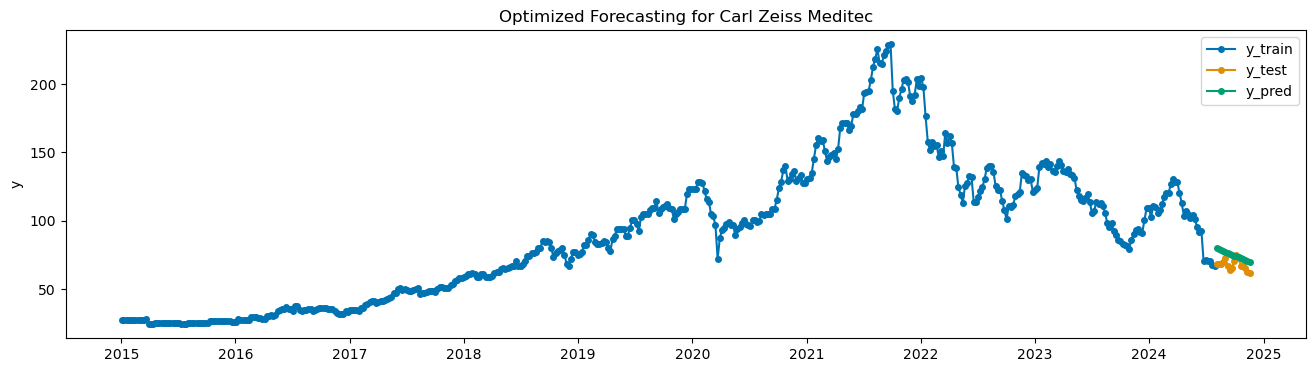

12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing
12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1 of 3136 for Lam Research Corporation...


12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2 of 3136 for Lam Research Corporation...


12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3 of 3136 for Lam Research Corporation...


12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 4 of 3136 for Lam Research Corporation...


12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 5 of 3136 for Lam Research Corporation...


12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 6 of 3136 for Lam Research Corporation...


12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 7 of 3136 for Lam Research Corporation...


12:08:45 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 8 of 3136 for Lam Research Corporation...


12:08:45 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 9 of 3136 for Lam Research Corporation...


12:08:45 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 10 of 3136 for Lam Research Corporation...


12:08:45 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 11 of 3136 for Lam Research Corporation...


12:08:46 - cmdstanpy - INFO - Chain [1] start processing
12:08:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 12 of 3136 for Lam Research Corporation...


12:08:46 - cmdstanpy - INFO - Chain [1] start processing
12:08:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 13 of 3136 for Lam Research Corporation...


12:08:46 - cmdstanpy - INFO - Chain [1] start processing
12:08:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 14 of 3136 for Lam Research Corporation...


12:08:46 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 15 of 3136 for Lam Research Corporation...


12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 16 of 3136 for Lam Research Corporation...


12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 17 of 3136 for Lam Research Corporation...


12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 18 of 3136 for Lam Research Corporation...


12:08:48 - cmdstanpy - INFO - Chain [1] start processing
12:08:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 19 of 3136 for Lam Research Corporation...


12:08:48 - cmdstanpy - INFO - Chain [1] start processing
12:08:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 20 of 3136 for Lam Research Corporation...
Processing combination 21 of 3136 for Lam Research Corporation...


12:08:48 - cmdstanpy - INFO - Chain [1] start processing
12:08:48 - cmdstanpy - INFO - Chain [1] done processing
12:08:48 - cmdstanpy - INFO - Chain [1] start processing
12:08:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 22 of 3136 for Lam Research Corporation...


12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 23 of 3136 for Lam Research Corporation...


12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 24 of 3136 for Lam Research Corporation...


12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 25 of 3136 for Lam Research Corporation...


12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 26 of 3136 for Lam Research Corporation...


12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 27 of 3136 for Lam Research Corporation...


12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 28 of 3136 for Lam Research Corporation...


12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 29 of 3136 for Lam Research Corporation...


12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 30 of 3136 for Lam Research Corporation...


12:08:51 - cmdstanpy - INFO - Chain [1] start processing
12:08:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 31 of 3136 for Lam Research Corporation...


12:08:51 - cmdstanpy - INFO - Chain [1] start processing
12:08:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 32 of 3136 for Lam Research Corporation...


12:08:51 - cmdstanpy - INFO - Chain [1] start processing
12:08:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 33 of 3136 for Lam Research Corporation...


12:08:51 - cmdstanpy - INFO - Chain [1] start processing
12:08:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 34 of 3136 for Lam Research Corporation...


12:08:52 - cmdstanpy - INFO - Chain [1] start processing
12:08:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 35 of 3136 for Lam Research Corporation...


12:08:52 - cmdstanpy - INFO - Chain [1] start processing
12:08:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 36 of 3136 for Lam Research Corporation...


12:08:52 - cmdstanpy - INFO - Chain [1] start processing
12:08:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 37 of 3136 for Lam Research Corporation...


12:08:52 - cmdstanpy - INFO - Chain [1] start processing
12:08:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 38 of 3136 for Lam Research Corporation...


12:08:53 - cmdstanpy - INFO - Chain [1] start processing
12:08:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 39 of 3136 for Lam Research Corporation...


12:08:53 - cmdstanpy - INFO - Chain [1] start processing
12:08:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 40 of 3136 for Lam Research Corporation...


12:08:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 41 of 3136 for Lam Research Corporation...


12:08:53 - cmdstanpy - INFO - Chain [1] done processing
12:08:53 - cmdstanpy - INFO - Chain [1] start processing
12:08:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 42 of 3136 for Lam Research Corporation...


12:08:54 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 43 of 3136 for Lam Research Corporation...


12:08:54 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 44 of 3136 for Lam Research Corporation...


12:08:54 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 45 of 3136 for Lam Research Corporation...


12:08:54 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 46 of 3136 for Lam Research Corporation...


12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 47 of 3136 for Lam Research Corporation...


12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 48 of 3136 for Lam Research Corporation...


12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 49 of 3136 for Lam Research Corporation...


12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 50 of 3136 for Lam Research Corporation...


12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 51 of 3136 for Lam Research Corporation...


12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 52 of 3136 for Lam Research Corporation...


12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 53 of 3136 for Lam Research Corporation...


12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 54 of 3136 for Lam Research Corporation...


12:08:57 - cmdstanpy - INFO - Chain [1] start processing
12:08:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 55 of 3136 for Lam Research Corporation...


12:08:57 - cmdstanpy - INFO - Chain [1] start processing
12:08:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 56 of 3136 for Lam Research Corporation...


12:08:57 - cmdstanpy - INFO - Chain [1] start processing
12:08:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 57 of 3136 for Lam Research Corporation...


12:08:57 - cmdstanpy - INFO - Chain [1] start processing
12:08:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 58 of 3136 for Lam Research Corporation...


12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 59 of 3136 for Lam Research Corporation...


12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 60 of 3136 for Lam Research Corporation...
Processing combination 61 of 3136 for Lam Research Corporation...


12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing
12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 62 of 3136 for Lam Research Corporation...


12:08:59 - cmdstanpy - INFO - Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 63 of 3136 for Lam Research Corporation...


12:08:59 - cmdstanpy - INFO - Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 64 of 3136 for Lam Research Corporation...
Processing combination 65 of 3136 for Lam Research Corporation...


12:08:59 - cmdstanpy - INFO - Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1] done processing
12:08:59 - cmdstanpy - INFO - Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 66 of 3136 for Lam Research Corporation...


12:09:00 - cmdstanpy - INFO - Chain [1] start processing
12:09:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 67 of 3136 for Lam Research Corporation...


12:09:00 - cmdstanpy - INFO - Chain [1] start processing
12:09:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 68 of 3136 for Lam Research Corporation...


12:09:00 - cmdstanpy - INFO - Chain [1] start processing
12:09:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 69 of 3136 for Lam Research Corporation...


12:09:00 - cmdstanpy - INFO - Chain [1] start processing
12:09:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 70 of 3136 for Lam Research Corporation...


12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 71 of 3136 for Lam Research Corporation...


12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 72 of 3136 for Lam Research Corporation...


12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 73 of 3136 for Lam Research Corporation...


12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 74 of 3136 for Lam Research Corporation...


12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 75 of 3136 for Lam Research Corporation...


12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 76 of 3136 for Lam Research Corporation...


12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 77 of 3136 for Lam Research Corporation...


12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 78 of 3136 for Lam Research Corporation...


12:09:03 - cmdstanpy - INFO - Chain [1] start processing
12:09:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 79 of 3136 for Lam Research Corporation...


12:09:03 - cmdstanpy - INFO - Chain [1] start processing
12:09:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 80 of 3136 for Lam Research Corporation...


12:09:03 - cmdstanpy - INFO - Chain [1] start processing
12:09:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 81 of 3136 for Lam Research Corporation...


12:09:03 - cmdstanpy - INFO - Chain [1] start processing
12:09:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 82 of 3136 for Lam Research Corporation...


12:09:04 - cmdstanpy - INFO - Chain [1] start processing
12:09:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 83 of 3136 for Lam Research Corporation...


12:09:04 - cmdstanpy - INFO - Chain [1] start processing
12:09:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 84 of 3136 for Lam Research Corporation...
Processing combination 85 of 3136 for Lam Research Corporation...


12:09:04 - cmdstanpy - INFO - Chain [1] start processing
12:09:04 - cmdstanpy - INFO - Chain [1] done processing
12:09:05 - cmdstanpy - INFO - Chain [1] start processing
12:09:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 86 of 3136 for Lam Research Corporation...


12:09:05 - cmdstanpy - INFO - Chain [1] start processing
12:09:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 87 of 3136 for Lam Research Corporation...


12:09:05 - cmdstanpy - INFO - Chain [1] start processing
12:09:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 88 of 3136 for Lam Research Corporation...


12:09:05 - cmdstanpy - INFO - Chain [1] start processing
12:09:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 89 of 3136 for Lam Research Corporation...


12:09:06 - cmdstanpy - INFO - Chain [1] start processing
12:09:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 90 of 3136 for Lam Research Corporation...


12:09:06 - cmdstanpy - INFO - Chain [1] start processing
12:09:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 91 of 3136 for Lam Research Corporation...


12:09:06 - cmdstanpy - INFO - Chain [1] start processing
12:09:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 92 of 3136 for Lam Research Corporation...


12:09:06 - cmdstanpy - INFO - Chain [1] start processing
12:09:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 93 of 3136 for Lam Research Corporation...


12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 94 of 3136 for Lam Research Corporation...


12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 95 of 3136 for Lam Research Corporation...


12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 96 of 3136 for Lam Research Corporation...


12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 97 of 3136 for Lam Research Corporation...


12:09:08 - cmdstanpy - INFO - Chain [1] start processing
12:09:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 98 of 3136 for Lam Research Corporation...


12:09:08 - cmdstanpy - INFO - Chain [1] start processing
12:09:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 99 of 3136 for Lam Research Corporation...


12:09:08 - cmdstanpy - INFO - Chain [1] start processing
12:09:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 100 of 3136 for Lam Research Corporation...
Processing combination 101 of 3136 for Lam Research Corporation...


12:09:08 - cmdstanpy - INFO - Chain [1] start processing
12:09:08 - cmdstanpy - INFO - Chain [1] done processing
12:09:09 - cmdstanpy - INFO - Chain [1] start processing
12:09:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 102 of 3136 for Lam Research Corporation...


12:09:09 - cmdstanpy - INFO - Chain [1] start processing
12:09:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 103 of 3136 for Lam Research Corporation...


12:09:09 - cmdstanpy - INFO - Chain [1] start processing
12:09:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 104 of 3136 for Lam Research Corporation...


12:09:09 - cmdstanpy - INFO - Chain [1] start processing
12:09:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 105 of 3136 for Lam Research Corporation...


12:09:10 - cmdstanpy - INFO - Chain [1] start processing
12:09:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 106 of 3136 for Lam Research Corporation...


12:09:10 - cmdstanpy - INFO - Chain [1] start processing
12:09:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 107 of 3136 for Lam Research Corporation...


12:09:10 - cmdstanpy - INFO - Chain [1] start processing
12:09:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 108 of 3136 for Lam Research Corporation...


12:09:10 - cmdstanpy - INFO - Chain [1] start processing
12:09:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 109 of 3136 for Lam Research Corporation...


12:09:11 - cmdstanpy - INFO - Chain [1] start processing
12:09:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 110 of 3136 for Lam Research Corporation...


12:09:11 - cmdstanpy - INFO - Chain [1] start processing
12:09:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 111 of 3136 for Lam Research Corporation...


12:09:11 - cmdstanpy - INFO - Chain [1] start processing
12:09:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 112 of 3136 for Lam Research Corporation...


12:09:11 - cmdstanpy - INFO - Chain [1] start processing
12:09:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 113 of 3136 for Lam Research Corporation...


12:09:12 - cmdstanpy - INFO - Chain [1] start processing
12:09:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 114 of 3136 for Lam Research Corporation...
Processing combination 115 of 3136 for Lam Research Corporation...


12:09:12 - cmdstanpy - INFO - Chain [1] start processing
12:09:12 - cmdstanpy - INFO - Chain [1] done processing
12:09:12 - cmdstanpy - INFO - Chain [1] start processing
12:09:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 116 of 3136 for Lam Research Corporation...
Processing combination 117 of 3136 for Lam Research Corporation...


12:09:12 - cmdstanpy - INFO - Chain [1] start processing
12:09:12 - cmdstanpy - INFO - Chain [1] done processing
12:09:13 - cmdstanpy - INFO - Chain [1] start processing
12:09:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 118 of 3136 for Lam Research Corporation...
Processing combination 119 of 3136 for Lam Research Corporation...


12:09:13 - cmdstanpy - INFO - Chain [1] start processing
12:09:13 - cmdstanpy - INFO - Chain [1] done processing
12:09:13 - cmdstanpy - INFO - Chain [1] start processing
12:09:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 120 of 3136 for Lam Research Corporation...
Processing combination 121 of 3136 for Lam Research Corporation...


12:09:13 - cmdstanpy - INFO - Chain [1] start processing
12:09:13 - cmdstanpy - INFO - Chain [1] done processing
12:09:13 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 122 of 3136 for Lam Research Corporation...


12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 123 of 3136 for Lam Research Corporation...


12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 124 of 3136 for Lam Research Corporation...
Processing combination 125 of 3136 for Lam Research Corporation...


12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing
12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 126 of 3136 for Lam Research Corporation...


12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 127 of 3136 for Lam Research Corporation...


12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 128 of 3136 for Lam Research Corporation...
Processing combination 129 of 3136 for Lam Research Corporation...


12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing
12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 130 of 3136 for Lam Research Corporation...


12:09:16 - cmdstanpy - INFO - Chain [1] start processing
12:09:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 131 of 3136 for Lam Research Corporation...


12:09:16 - cmdstanpy - INFO - Chain [1] start processing
12:09:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 132 of 3136 for Lam Research Corporation...
Processing combination 133 of 3136 for Lam Research Corporation...


12:09:16 - cmdstanpy - INFO - Chain [1] start processing
12:09:16 - cmdstanpy - INFO - Chain [1] done processing
12:09:16 - cmdstanpy - INFO - Chain [1] start processing
12:09:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 134 of 3136 for Lam Research Corporation...


12:09:16 - cmdstanpy - INFO - Chain [1] start processing
12:09:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 135 of 3136 for Lam Research Corporation...


12:09:17 - cmdstanpy - INFO - Chain [1] start processing
12:09:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 136 of 3136 for Lam Research Corporation...
Processing combination 137 of 3136 for Lam Research Corporation...


12:09:17 - cmdstanpy - INFO - Chain [1] start processing
12:09:17 - cmdstanpy - INFO - Chain [1] done processing
12:09:17 - cmdstanpy - INFO - Chain [1] start processing
12:09:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 138 of 3136 for Lam Research Corporation...
Processing combination 139 of 3136 for Lam Research Corporation...


12:09:17 - cmdstanpy - INFO - Chain [1] start processing
12:09:17 - cmdstanpy - INFO - Chain [1] done processing
12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 140 of 3136 for Lam Research Corporation...
Processing combination 141 of 3136 for Lam Research Corporation...


12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing
12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 142 of 3136 for Lam Research Corporation...


12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 143 of 3136 for Lam Research Corporation...


12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 144 of 3136 for Lam Research Corporation...
Processing combination 145 of 3136 for Lam Research Corporation...


12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 146 of 3136 for Lam Research Corporation...
Processing combination 147 of 3136 for Lam Research Corporation...


12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 148 of 3136 for Lam Research Corporation...
Processing combination 149 of 3136 for Lam Research Corporation...


12:09:20 - cmdstanpy - INFO - Chain [1] start processing
12:09:20 - cmdstanpy - INFO - Chain [1] done processing
12:09:20 - cmdstanpy - INFO - Chain [1] start processing
12:09:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 150 of 3136 for Lam Research Corporation...


12:09:20 - cmdstanpy - INFO - Chain [1] start processing
12:09:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 151 of 3136 for Lam Research Corporation...
Processing combination 152 of 3136 for Lam Research Corporation...


12:09:20 - cmdstanpy - INFO - Chain [1] start processing
12:09:20 - cmdstanpy - INFO - Chain [1] done processing
12:09:20 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 153 of 3136 for Lam Research Corporation...


12:09:21 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 154 of 3136 for Lam Research Corporation...
Processing combination 155 of 3136 for Lam Research Corporation...


12:09:21 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
12:09:21 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 156 of 3136 for Lam Research Corporation...
Processing combination 157 of 3136 for Lam Research Corporation...


12:09:21 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 158 of 3136 for Lam Research Corporation...


12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 159 of 3136 for Lam Research Corporation...


12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 160 of 3136 for Lam Research Corporation...
Processing combination 161 of 3136 for Lam Research Corporation...


12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1] done processing
12:09:23 - cmdstanpy - INFO - Chain [1] start processing
12:09:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 162 of 3136 for Lam Research Corporation...


12:09:23 - cmdstanpy - INFO - Chain [1] start processing
12:09:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 163 of 3136 for Lam Research Corporation...


12:09:23 - cmdstanpy - INFO - Chain [1] start processing
12:09:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 164 of 3136 for Lam Research Corporation...
Processing combination 165 of 3136 for Lam Research Corporation...


12:09:23 - cmdstanpy - INFO - Chain [1] start processing
12:09:23 - cmdstanpy - INFO - Chain [1] done processing
12:09:23 - cmdstanpy - INFO - Chain [1] start processing
12:09:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 166 of 3136 for Lam Research Corporation...
Processing combination 167 of 3136 for Lam Research Corporation...


12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 168 of 3136 for Lam Research Corporation...
Processing combination 169 of 3136 for Lam Research Corporation...


12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 170 of 3136 for Lam Research Corporation...
Processing combination 171 of 3136 for Lam Research Corporation...


12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing
12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 172 of 3136 for Lam Research Corporation...
Processing combination 173 of 3136 for Lam Research Corporation...


12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing
12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 174 of 3136 for Lam Research Corporation...


12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 175 of 3136 for Lam Research Corporation...


12:09:26 - cmdstanpy - INFO - Chain [1] start processing
12:09:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 176 of 3136 for Lam Research Corporation...
Processing combination 177 of 3136 for Lam Research Corporation...


12:09:26 - cmdstanpy - INFO - Chain [1] start processing
12:09:26 - cmdstanpy - INFO - Chain [1] done processing
12:09:26 - cmdstanpy - INFO - Chain [1] start processing
12:09:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 178 of 3136 for Lam Research Corporation...
Processing combination 179 of 3136 for Lam Research Corporation...


12:09:26 - cmdstanpy - INFO - Chain [1] start processing
12:09:26 - cmdstanpy - INFO - Chain [1] done processing
12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 180 of 3136 for Lam Research Corporation...
Processing combination 181 of 3136 for Lam Research Corporation...


12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing
12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 182 of 3136 for Lam Research Corporation...


12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 183 of 3136 for Lam Research Corporation...


12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 184 of 3136 for Lam Research Corporation...
Processing combination 185 of 3136 for Lam Research Corporation...


12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 186 of 3136 for Lam Research Corporation...


12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 187 of 3136 for Lam Research Corporation...


12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 188 of 3136 for Lam Research Corporation...
Processing combination 189 of 3136 for Lam Research Corporation...


12:09:29 - cmdstanpy - INFO - Chain [1] start processing
12:09:29 - cmdstanpy - INFO - Chain [1] done processing
12:09:29 - cmdstanpy - INFO - Chain [1] start processing
12:09:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 190 of 3136 for Lam Research Corporation...


12:09:29 - cmdstanpy - INFO - Chain [1] start processing
12:09:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 191 of 3136 for Lam Research Corporation...


12:09:29 - cmdstanpy - INFO - Chain [1] start processing
12:09:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 192 of 3136 for Lam Research Corporation...
Processing combination 193 of 3136 for Lam Research Corporation...


12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 194 of 3136 for Lam Research Corporation...


12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 195 of 3136 for Lam Research Corporation...


12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 196 of 3136 for Lam Research Corporation...


12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 197 of 3136 for Lam Research Corporation...


12:09:31 - cmdstanpy - INFO - Chain [1] start processing
12:09:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 198 of 3136 for Lam Research Corporation...


12:09:31 - cmdstanpy - INFO - Chain [1] start processing
12:09:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 199 of 3136 for Lam Research Corporation...


12:09:31 - cmdstanpy - INFO - Chain [1] start processing
12:09:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 200 of 3136 for Lam Research Corporation...


12:09:31 - cmdstanpy - INFO - Chain [1] start processing
12:09:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 201 of 3136 for Lam Research Corporation...


12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 202 of 3136 for Lam Research Corporation...


12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 203 of 3136 for Lam Research Corporation...


12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 204 of 3136 for Lam Research Corporation...


12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 205 of 3136 for Lam Research Corporation...


12:09:33 - cmdstanpy - INFO - Chain [1] start processing
12:09:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 206 of 3136 for Lam Research Corporation...


12:09:33 - cmdstanpy - INFO - Chain [1] start processing
12:09:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 207 of 3136 for Lam Research Corporation...


12:09:33 - cmdstanpy - INFO - Chain [1] start processing
12:09:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 208 of 3136 for Lam Research Corporation...
Processing combination 209 of 3136 for Lam Research Corporation...


12:09:33 - cmdstanpy - INFO - Chain [1] start processing
12:09:33 - cmdstanpy - INFO - Chain [1] done processing
12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 210 of 3136 for Lam Research Corporation...


12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 211 of 3136 for Lam Research Corporation...


12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 212 of 3136 for Lam Research Corporation...
Processing combination 213 of 3136 for Lam Research Corporation...


12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing
12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 214 of 3136 for Lam Research Corporation...


12:09:35 - cmdstanpy - INFO - Chain [1] start processing
12:09:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 215 of 3136 for Lam Research Corporation...


12:09:35 - cmdstanpy - INFO - Chain [1] start processing
12:09:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 216 of 3136 for Lam Research Corporation...


12:09:35 - cmdstanpy - INFO - Chain [1] start processing
12:09:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 217 of 3136 for Lam Research Corporation...


12:09:35 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 218 of 3136 for Lam Research Corporation...


12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 219 of 3136 for Lam Research Corporation...


12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 220 of 3136 for Lam Research Corporation...
Processing combination 221 of 3136 for Lam Research Corporation...


12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 222 of 3136 for Lam Research Corporation...


12:09:37 - cmdstanpy - INFO - Chain [1] start processing
12:09:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 223 of 3136 for Lam Research Corporation...


12:09:37 - cmdstanpy - INFO - Chain [1] start processing
12:09:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 224 of 3136 for Lam Research Corporation...
Processing combination 225 of 3136 for Lam Research Corporation...


12:09:37 - cmdstanpy - INFO - Chain [1] start processing
12:09:37 - cmdstanpy - INFO - Chain [1] done processing
12:09:37 - cmdstanpy - INFO - Chain [1] start processing
12:09:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 226 of 3136 for Lam Research Corporation...


12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 227 of 3136 for Lam Research Corporation...


12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 228 of 3136 for Lam Research Corporation...
Processing combination 229 of 3136 for Lam Research Corporation...


12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:38 - cmdstanpy - INFO - Chain [1] done processing
12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 230 of 3136 for Lam Research Corporation...


12:09:39 - cmdstanpy - INFO - Chain [1] start processing
12:09:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 231 of 3136 for Lam Research Corporation...


12:09:39 - cmdstanpy - INFO - Chain [1] start processing
12:09:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 232 of 3136 for Lam Research Corporation...


12:09:39 - cmdstanpy - INFO - Chain [1] start processing
12:09:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 233 of 3136 for Lam Research Corporation...


12:09:39 - cmdstanpy - INFO - Chain [1] start processing
12:09:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 234 of 3136 for Lam Research Corporation...


12:09:40 - cmdstanpy - INFO - Chain [1] start processing
12:09:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 235 of 3136 for Lam Research Corporation...


12:09:40 - cmdstanpy - INFO - Chain [1] start processing
12:09:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 236 of 3136 for Lam Research Corporation...
Processing combination 237 of 3136 for Lam Research Corporation...


12:09:40 - cmdstanpy - INFO - Chain [1] start processing
12:09:40 - cmdstanpy - INFO - Chain [1] done processing
12:09:40 - cmdstanpy - INFO - Chain [1] start processing
12:09:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 238 of 3136 for Lam Research Corporation...


12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 239 of 3136 for Lam Research Corporation...


12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 240 of 3136 for Lam Research Corporation...


12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 241 of 3136 for Lam Research Corporation...


12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 242 of 3136 for Lam Research Corporation...


12:09:42 - cmdstanpy - INFO - Chain [1] start processing
12:09:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 243 of 3136 for Lam Research Corporation...


12:09:42 - cmdstanpy - INFO - Chain [1] start processing
12:09:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 244 of 3136 for Lam Research Corporation...
Processing combination 245 of 3136 for Lam Research Corporation...


12:09:42 - cmdstanpy - INFO - Chain [1] start processing
12:09:42 - cmdstanpy - INFO - Chain [1] done processing
12:09:42 - cmdstanpy - INFO - Chain [1] start processing
12:09:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 246 of 3136 for Lam Research Corporation...


12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 247 of 3136 for Lam Research Corporation...


12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 248 of 3136 for Lam Research Corporation...
Processing combination 249 of 3136 for Lam Research Corporation...


12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 250 of 3136 for Lam Research Corporation...


12:09:44 - cmdstanpy - INFO - Chain [1] start processing
12:09:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 251 of 3136 for Lam Research Corporation...


12:09:44 - cmdstanpy - INFO - Chain [1] start processing
12:09:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 252 of 3136 for Lam Research Corporation...


12:09:44 - cmdstanpy - INFO - Chain [1] start processing
12:09:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 253 of 3136 for Lam Research Corporation...


12:09:44 - cmdstanpy - INFO - Chain [1] start processing
12:09:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 254 of 3136 for Lam Research Corporation...


12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 255 of 3136 for Lam Research Corporation...


12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 256 of 3136 for Lam Research Corporation...
Processing combination 257 of 3136 for Lam Research Corporation...


12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing
12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 258 of 3136 for Lam Research Corporation...


12:09:46 - cmdstanpy - INFO - Chain [1] start processing
12:09:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 259 of 3136 for Lam Research Corporation...


12:09:46 - cmdstanpy - INFO - Chain [1] start processing
12:09:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 260 of 3136 for Lam Research Corporation...


12:09:46 - cmdstanpy - INFO - Chain [1] start processing
12:09:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 261 of 3136 for Lam Research Corporation...


12:09:46 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 262 of 3136 for Lam Research Corporation...


12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 263 of 3136 for Lam Research Corporation...


12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 264 of 3136 for Lam Research Corporation...


12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 265 of 3136 for Lam Research Corporation...


12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 266 of 3136 for Lam Research Corporation...


12:09:48 - cmdstanpy - INFO - Chain [1] start processing
12:09:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 267 of 3136 for Lam Research Corporation...


12:09:48 - cmdstanpy - INFO - Chain [1] start processing
12:09:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 268 of 3136 for Lam Research Corporation...
Processing combination 269 of 3136 for Lam Research Corporation...


12:09:48 - cmdstanpy - INFO - Chain [1] start processing
12:09:48 - cmdstanpy - INFO - Chain [1] done processing
12:09:48 - cmdstanpy - INFO - Chain [1] start processing
12:09:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 270 of 3136 for Lam Research Corporation...


12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 271 of 3136 for Lam Research Corporation...


12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 272 of 3136 for Lam Research Corporation...


12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 273 of 3136 for Lam Research Corporation...


12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 274 of 3136 for Lam Research Corporation...


12:09:50 - cmdstanpy - INFO - Chain [1] start processing
12:09:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 275 of 3136 for Lam Research Corporation...


12:09:50 - cmdstanpy - INFO - Chain [1] start processing
12:09:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 276 of 3136 for Lam Research Corporation...


12:09:50 - cmdstanpy - INFO - Chain [1] start processing
12:09:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 277 of 3136 for Lam Research Corporation...


12:09:50 - cmdstanpy - INFO - Chain [1] start processing
12:09:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 278 of 3136 for Lam Research Corporation...


12:09:51 - cmdstanpy - INFO - Chain [1] start processing
12:09:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 279 of 3136 for Lam Research Corporation...


12:09:51 - cmdstanpy - INFO - Chain [1] start processing
12:09:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 280 of 3136 for Lam Research Corporation...


12:09:51 - cmdstanpy - INFO - Chain [1] start processing
12:09:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 281 of 3136 for Lam Research Corporation...


12:09:51 - cmdstanpy - INFO - Chain [1] start processing
12:09:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 282 of 3136 for Lam Research Corporation...


12:09:52 - cmdstanpy - INFO - Chain [1] start processing
12:09:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 283 of 3136 for Lam Research Corporation...


12:09:52 - cmdstanpy - INFO - Chain [1] start processing
12:09:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 284 of 3136 for Lam Research Corporation...
Processing combination 285 of 3136 for Lam Research Corporation...


12:09:52 - cmdstanpy - INFO - Chain [1] start processing
12:09:52 - cmdstanpy - INFO - Chain [1] done processing
12:09:52 - cmdstanpy - INFO - Chain [1] start processing
12:09:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 286 of 3136 for Lam Research Corporation...


12:09:53 - cmdstanpy - INFO - Chain [1] start processing
12:09:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 287 of 3136 for Lam Research Corporation...


12:09:53 - cmdstanpy - INFO - Chain [1] start processing
12:09:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 288 of 3136 for Lam Research Corporation...


12:09:53 - cmdstanpy - INFO - Chain [1] start processing
12:09:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 289 of 3136 for Lam Research Corporation...


12:09:53 - cmdstanpy - INFO - Chain [1] start processing
12:09:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 290 of 3136 for Lam Research Corporation...


12:09:54 - cmdstanpy - INFO - Chain [1] start processing
12:09:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 291 of 3136 for Lam Research Corporation...


12:09:54 - cmdstanpy - INFO - Chain [1] start processing
12:09:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 292 of 3136 for Lam Research Corporation...


12:09:54 - cmdstanpy - INFO - Chain [1] start processing
12:09:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 293 of 3136 for Lam Research Corporation...


12:09:54 - cmdstanpy - INFO - Chain [1] start processing
12:09:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 294 of 3136 for Lam Research Corporation...


12:09:55 - cmdstanpy - INFO - Chain [1] start processing
12:09:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 295 of 3136 for Lam Research Corporation...


12:09:55 - cmdstanpy - INFO - Chain [1] start processing
12:09:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 296 of 3136 for Lam Research Corporation...


12:09:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 297 of 3136 for Lam Research Corporation...


12:09:55 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 298 of 3136 for Lam Research Corporation...


12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 299 of 3136 for Lam Research Corporation...


12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 300 of 3136 for Lam Research Corporation...


12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 301 of 3136 for Lam Research Corporation...


12:09:57 - cmdstanpy - INFO - Chain [1] start processing
12:09:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 302 of 3136 for Lam Research Corporation...


12:09:57 - cmdstanpy - INFO - Chain [1] start processing
12:09:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 303 of 3136 for Lam Research Corporation...


12:09:57 - cmdstanpy - INFO - Chain [1] start processing
12:09:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 304 of 3136 for Lam Research Corporation...


12:09:57 - cmdstanpy - INFO - Chain [1] start processing
12:09:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 305 of 3136 for Lam Research Corporation...


12:09:58 - cmdstanpy - INFO - Chain [1] start processing
12:09:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 306 of 3136 for Lam Research Corporation...


12:09:58 - cmdstanpy - INFO - Chain [1] start processing
12:09:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 307 of 3136 for Lam Research Corporation...


12:09:58 - cmdstanpy - INFO - Chain [1] start processing
12:09:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 308 of 3136 for Lam Research Corporation...


12:09:58 - cmdstanpy - INFO - Chain [1] start processing
12:09:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 309 of 3136 for Lam Research Corporation...


12:09:59 - cmdstanpy - INFO - Chain [1] start processing
12:09:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 310 of 3136 for Lam Research Corporation...


12:09:59 - cmdstanpy - INFO - Chain [1] start processing
12:09:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 311 of 3136 for Lam Research Corporation...


12:09:59 - cmdstanpy - INFO - Chain [1] start processing
12:09:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 312 of 3136 for Lam Research Corporation...


12:09:59 - cmdstanpy - INFO - Chain [1] start processing
12:09:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 313 of 3136 for Lam Research Corporation...


12:10:00 - cmdstanpy - INFO - Chain [1] start processing
12:10:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 314 of 3136 for Lam Research Corporation...


12:10:00 - cmdstanpy - INFO - Chain [1] start processing
12:10:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 315 of 3136 for Lam Research Corporation...


12:10:00 - cmdstanpy - INFO - Chain [1] start processing
12:10:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 316 of 3136 for Lam Research Corporation...


12:10:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 317 of 3136 for Lam Research Corporation...


12:10:01 - cmdstanpy - INFO - Chain [1] done processing
12:10:01 - cmdstanpy - INFO - Chain [1] start processing
12:10:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 318 of 3136 for Lam Research Corporation...


12:10:01 - cmdstanpy - INFO - Chain [1] start processing
12:10:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 319 of 3136 for Lam Research Corporation...


12:10:01 - cmdstanpy - INFO - Chain [1] start processing
12:10:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 320 of 3136 for Lam Research Corporation...


12:10:02 - cmdstanpy - INFO - Chain [1] start processing
12:10:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 321 of 3136 for Lam Research Corporation...


12:10:02 - cmdstanpy - INFO - Chain [1] start processing
12:10:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 322 of 3136 for Lam Research Corporation...


12:10:02 - cmdstanpy - INFO - Chain [1] start processing
12:10:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 323 of 3136 for Lam Research Corporation...


12:10:02 - cmdstanpy - INFO - Chain [1] start processing
12:10:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 324 of 3136 for Lam Research Corporation...


12:10:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 325 of 3136 for Lam Research Corporation...


12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 326 of 3136 for Lam Research Corporation...


12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 327 of 3136 for Lam Research Corporation...


12:10:04 - cmdstanpy - INFO - Chain [1] start processing
12:10:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 328 of 3136 for Lam Research Corporation...


12:10:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 329 of 3136 for Lam Research Corporation...


12:10:04 - cmdstanpy - INFO - Chain [1] done processing
12:10:04 - cmdstanpy - INFO - Chain [1] start processing
12:10:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 330 of 3136 for Lam Research Corporation...


12:10:05 - cmdstanpy - INFO - Chain [1] start processing
12:10:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 331 of 3136 for Lam Research Corporation...


12:10:05 - cmdstanpy - INFO - Chain [1] start processing
12:10:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 332 of 3136 for Lam Research Corporation...


12:10:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 333 of 3136 for Lam Research Corporation...


12:10:05 - cmdstanpy - INFO - Chain [1] done processing
12:10:05 - cmdstanpy - INFO - Chain [1] start processing
12:10:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 334 of 3136 for Lam Research Corporation...


12:10:06 - cmdstanpy - INFO - Chain [1] start processing
12:10:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 335 of 3136 for Lam Research Corporation...


12:10:06 - cmdstanpy - INFO - Chain [1] start processing
12:10:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 336 of 3136 for Lam Research Corporation...


12:10:06 - cmdstanpy - INFO - Chain [1] start processing
12:10:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 337 of 3136 for Lam Research Corporation...


12:10:06 - cmdstanpy - INFO - Chain [1] start processing
12:10:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 338 of 3136 for Lam Research Corporation...


12:10:07 - cmdstanpy - INFO - Chain [1] start processing
12:10:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 339 of 3136 for Lam Research Corporation...


12:10:07 - cmdstanpy - INFO - Chain [1] start processing
12:10:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 340 of 3136 for Lam Research Corporation...


12:10:07 - cmdstanpy - INFO - Chain [1] start processing
12:10:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 341 of 3136 for Lam Research Corporation...


12:10:07 - cmdstanpy - INFO - Chain [1] start processing
12:10:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 342 of 3136 for Lam Research Corporation...


12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 343 of 3136 for Lam Research Corporation...


12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 344 of 3136 for Lam Research Corporation...
Processing combination 345 of 3136 for Lam Research Corporation...


12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 346 of 3136 for Lam Research Corporation...


12:10:09 - cmdstanpy - INFO - Chain [1] start processing
12:10:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 347 of 3136 for Lam Research Corporation...


12:10:09 - cmdstanpy - INFO - Chain [1] start processing
12:10:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 348 of 3136 for Lam Research Corporation...
Processing combination 349 of 3136 for Lam Research Corporation...


12:10:09 - cmdstanpy - INFO - Chain [1] start processing
12:10:09 - cmdstanpy - INFO - Chain [1] done processing
12:10:09 - cmdstanpy - INFO - Chain [1] start processing
12:10:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 350 of 3136 for Lam Research Corporation...


12:10:09 - cmdstanpy - INFO - Chain [1] start processing
12:10:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 351 of 3136 for Lam Research Corporation...


12:10:10 - cmdstanpy - INFO - Chain [1] start processing
12:10:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 352 of 3136 for Lam Research Corporation...
Processing combination 353 of 3136 for Lam Research Corporation...


12:10:10 - cmdstanpy - INFO - Chain [1] start processing
12:10:10 - cmdstanpy - INFO - Chain [1] done processing
12:10:10 - cmdstanpy - INFO - Chain [1] start processing
12:10:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 354 of 3136 for Lam Research Corporation...


12:10:10 - cmdstanpy - INFO - Chain [1] start processing
12:10:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 355 of 3136 for Lam Research Corporation...


12:10:11 - cmdstanpy - INFO - Chain [1] start processing
12:10:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 356 of 3136 for Lam Research Corporation...


12:10:11 - cmdstanpy - INFO - Chain [1] start processing
12:10:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 357 of 3136 for Lam Research Corporation...


12:10:11 - cmdstanpy - INFO - Chain [1] start processing
12:10:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 358 of 3136 for Lam Research Corporation...


12:10:11 - cmdstanpy - INFO - Chain [1] start processing
12:10:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 359 of 3136 for Lam Research Corporation...


12:10:12 - cmdstanpy - INFO - Chain [1] start processing
12:10:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 360 of 3136 for Lam Research Corporation...
Processing combination 361 of 3136 for Lam Research Corporation...


12:10:12 - cmdstanpy - INFO - Chain [1] start processing
12:10:12 - cmdstanpy - INFO - Chain [1] done processing
12:10:12 - cmdstanpy - INFO - Chain [1] start processing
12:10:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 362 of 3136 for Lam Research Corporation...


12:10:12 - cmdstanpy - INFO - Chain [1] start processing
12:10:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 363 of 3136 for Lam Research Corporation...


12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 364 of 3136 for Lam Research Corporation...
Processing combination 365 of 3136 for Lam Research Corporation...


12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing
12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 366 of 3136 for Lam Research Corporation...


12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 367 of 3136 for Lam Research Corporation...


12:10:14 - cmdstanpy - INFO - Chain [1] start processing
12:10:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 368 of 3136 for Lam Research Corporation...
Processing combination 369 of 3136 for Lam Research Corporation...


12:10:14 - cmdstanpy - INFO - Chain [1] start processing
12:10:14 - cmdstanpy - INFO - Chain [1] done processing
12:10:14 - cmdstanpy - INFO - Chain [1] start processing
12:10:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 370 of 3136 for Lam Research Corporation...


12:10:14 - cmdstanpy - INFO - Chain [1] start processing
12:10:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 371 of 3136 for Lam Research Corporation...


12:10:14 - cmdstanpy - INFO - Chain [1] start processing
12:10:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 372 of 3136 for Lam Research Corporation...
Processing combination 373 of 3136 for Lam Research Corporation...


12:10:15 - cmdstanpy - INFO - Chain [1] start processing
12:10:15 - cmdstanpy - INFO - Chain [1] done processing
12:10:15 - cmdstanpy - INFO - Chain [1] start processing
12:10:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 374 of 3136 for Lam Research Corporation...


12:10:15 - cmdstanpy - INFO - Chain [1] start processing
12:10:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 375 of 3136 for Lam Research Corporation...


12:10:15 - cmdstanpy - INFO - Chain [1] start processing
12:10:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 376 of 3136 for Lam Research Corporation...
Processing combination 377 of 3136 for Lam Research Corporation...


12:10:16 - cmdstanpy - INFO - Chain [1] start processing
12:10:16 - cmdstanpy - INFO - Chain [1] done processing
12:10:16 - cmdstanpy - INFO - Chain [1] start processing
12:10:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 378 of 3136 for Lam Research Corporation...


12:10:16 - cmdstanpy - INFO - Chain [1] start processing
12:10:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 379 of 3136 for Lam Research Corporation...


12:10:16 - cmdstanpy - INFO - Chain [1] start processing
12:10:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 380 of 3136 for Lam Research Corporation...
Processing combination 381 of 3136 for Lam Research Corporation...


12:10:17 - cmdstanpy - INFO - Chain [1] start processing
12:10:17 - cmdstanpy - INFO - Chain [1] done processing
12:10:17 - cmdstanpy - INFO - Chain [1] start processing
12:10:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 382 of 3136 for Lam Research Corporation...


12:10:17 - cmdstanpy - INFO - Chain [1] start processing
12:10:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 383 of 3136 for Lam Research Corporation...


12:10:17 - cmdstanpy - INFO - Chain [1] start processing
12:10:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 384 of 3136 for Lam Research Corporation...
Processing combination 385 of 3136 for Lam Research Corporation...


12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:18 - cmdstanpy - INFO - Chain [1] done processing
12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 386 of 3136 for Lam Research Corporation...


12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 387 of 3136 for Lam Research Corporation...


12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 388 of 3136 for Lam Research Corporation...
Processing combination 389 of 3136 for Lam Research Corporation...


12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:19 - cmdstanpy - INFO - Chain [1] done processing
12:10:19 - cmdstanpy - INFO - Chain [1] start processing
12:10:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 390 of 3136 for Lam Research Corporation...


12:10:19 - cmdstanpy - INFO - Chain [1] start processing
12:10:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 391 of 3136 for Lam Research Corporation...


12:10:19 - cmdstanpy - INFO - Chain [1] start processing
12:10:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 392 of 3136 for Lam Research Corporation...
Processing combination 393 of 3136 for Lam Research Corporation...


12:10:19 - cmdstanpy - INFO - Chain [1] start processing
12:10:19 - cmdstanpy - INFO - Chain [1] done processing
12:10:20 - cmdstanpy - INFO - Chain [1] start processing
12:10:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 394 of 3136 for Lam Research Corporation...
Processing combination 395 of 3136 for Lam Research Corporation...


12:10:20 - cmdstanpy - INFO - Chain [1] start processing
12:10:20 - cmdstanpy - INFO - Chain [1] done processing
12:10:20 - cmdstanpy - INFO - Chain [1] start processing
12:10:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 396 of 3136 for Lam Research Corporation...
Processing combination 397 of 3136 for Lam Research Corporation...


12:10:20 - cmdstanpy - INFO - Chain [1] start processing
12:10:20 - cmdstanpy - INFO - Chain [1] done processing
12:10:21 - cmdstanpy - INFO - Chain [1] start processing
12:10:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 398 of 3136 for Lam Research Corporation...


12:10:21 - cmdstanpy - INFO - Chain [1] start processing
12:10:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 399 of 3136 for Lam Research Corporation...


12:10:21 - cmdstanpy - INFO - Chain [1] start processing
12:10:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 400 of 3136 for Lam Research Corporation...
Processing combination 401 of 3136 for Lam Research Corporation...


12:10:21 - cmdstanpy - INFO - Chain [1] start processing
12:10:21 - cmdstanpy - INFO - Chain [1] done processing
12:10:22 - cmdstanpy - INFO - Chain [1] start processing
12:10:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 402 of 3136 for Lam Research Corporation...
Processing combination 403 of 3136 for Lam Research Corporation...


12:10:22 - cmdstanpy - INFO - Chain [1] start processing
12:10:22 - cmdstanpy - INFO - Chain [1] done processing
12:10:22 - cmdstanpy - INFO - Chain [1] start processing
12:10:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 404 of 3136 for Lam Research Corporation...
Processing combination 405 of 3136 for Lam Research Corporation...


12:10:22 - cmdstanpy - INFO - Chain [1] start processing
12:10:22 - cmdstanpy - INFO - Chain [1] done processing
12:10:22 - cmdstanpy - INFO - Chain [1] start processing
12:10:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 406 of 3136 for Lam Research Corporation...


12:10:23 - cmdstanpy - INFO - Chain [1] start processing
12:10:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 407 of 3136 for Lam Research Corporation...


12:10:23 - cmdstanpy - INFO - Chain [1] start processing
12:10:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 408 of 3136 for Lam Research Corporation...
Processing combination 409 of 3136 for Lam Research Corporation...


12:10:23 - cmdstanpy - INFO - Chain [1] start processing
12:10:23 - cmdstanpy - INFO - Chain [1] done processing
12:10:23 - cmdstanpy - INFO - Chain [1] start processing
12:10:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 410 of 3136 for Lam Research Corporation...


12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 411 of 3136 for Lam Research Corporation...


12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 412 of 3136 for Lam Research Corporation...
Processing combination 413 of 3136 for Lam Research Corporation...


12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing
12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 414 of 3136 for Lam Research Corporation...


12:10:25 - cmdstanpy - INFO - Chain [1] start processing
12:10:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 415 of 3136 for Lam Research Corporation...


12:10:25 - cmdstanpy - INFO - Chain [1] start processing
12:10:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 416 of 3136 for Lam Research Corporation...
Processing combination 417 of 3136 for Lam Research Corporation...


12:10:25 - cmdstanpy - INFO - Chain [1] start processing
12:10:25 - cmdstanpy - INFO - Chain [1] done processing
12:10:25 - cmdstanpy - INFO - Chain [1] start processing
12:10:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 418 of 3136 for Lam Research Corporation...


12:10:26 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 419 of 3136 for Lam Research Corporation...


12:10:26 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 420 of 3136 for Lam Research Corporation...
Processing combination 421 of 3136 for Lam Research Corporation...


12:10:26 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing
12:10:26 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 422 of 3136 for Lam Research Corporation...


12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 423 of 3136 for Lam Research Corporation...


12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 424 of 3136 for Lam Research Corporation...
Processing combination 425 of 3136 for Lam Research Corporation...


12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:27 - cmdstanpy - INFO - Chain [1] done processing
12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 426 of 3136 for Lam Research Corporation...


12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 427 of 3136 for Lam Research Corporation...


12:10:28 - cmdstanpy - INFO - Chain [1] start processing
12:10:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 428 of 3136 for Lam Research Corporation...
Processing combination 429 of 3136 for Lam Research Corporation...


12:10:28 - cmdstanpy - INFO - Chain [1] start processing
12:10:28 - cmdstanpy - INFO - Chain [1] done processing
12:10:28 - cmdstanpy - INFO - Chain [1] start processing
12:10:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 430 of 3136 for Lam Research Corporation...
Processing combination 431 of 3136 for Lam Research Corporation...


12:10:28 - cmdstanpy - INFO - Chain [1] start processing
12:10:28 - cmdstanpy - INFO - Chain [1] done processing
12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 432 of 3136 for Lam Research Corporation...
Processing combination 433 of 3136 for Lam Research Corporation...


12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing
12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 434 of 3136 for Lam Research Corporation...
Processing combination 435 of 3136 for Lam Research Corporation...


12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 436 of 3136 for Lam Research Corporation...
Processing combination 437 of 3136 for Lam Research Corporation...


12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 438 of 3136 for Lam Research Corporation...
Processing combination 439 of 3136 for Lam Research Corporation...


12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 440 of 3136 for Lam Research Corporation...
Processing combination 441 of 3136 for Lam Research Corporation...


12:10:31 - cmdstanpy - INFO - Chain [1] start processing
12:10:31 - cmdstanpy - INFO - Chain [1] done processing
12:10:31 - cmdstanpy - INFO - Chain [1] start processing
12:10:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 442 of 3136 for Lam Research Corporation...


12:10:31 - cmdstanpy - INFO - Chain [1] start processing
12:10:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 443 of 3136 for Lam Research Corporation...


12:10:31 - cmdstanpy - INFO - Chain [1] start processing
12:10:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 444 of 3136 for Lam Research Corporation...
Processing combination 445 of 3136 for Lam Research Corporation...


12:10:32 - cmdstanpy - INFO - Chain [1] start processing
12:10:32 - cmdstanpy - INFO - Chain [1] done processing
12:10:32 - cmdstanpy - INFO - Chain [1] start processing
12:10:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 446 of 3136 for Lam Research Corporation...


12:10:32 - cmdstanpy - INFO - Chain [1] start processing
12:10:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 447 of 3136 for Lam Research Corporation...


12:10:32 - cmdstanpy - INFO - Chain [1] start processing
12:10:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 448 of 3136 for Lam Research Corporation...
Processing combination 449 of 3136 for Lam Research Corporation...


12:10:33 - cmdstanpy - INFO - Chain [1] start processing
12:10:33 - cmdstanpy - INFO - Chain [1] done processing
12:10:33 - cmdstanpy - INFO - Chain [1] start processing
12:10:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 450 of 3136 for Lam Research Corporation...


12:10:33 - cmdstanpy - INFO - Chain [1] start processing
12:10:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 451 of 3136 for Lam Research Corporation...


12:10:33 - cmdstanpy - INFO - Chain [1] start processing
12:10:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 452 of 3136 for Lam Research Corporation...


12:10:34 - cmdstanpy - INFO - Chain [1] start processing
12:10:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 453 of 3136 for Lam Research Corporation...


12:10:34 - cmdstanpy - INFO - Chain [1] start processing
12:10:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 454 of 3136 for Lam Research Corporation...


12:10:34 - cmdstanpy - INFO - Chain [1] start processing
12:10:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 455 of 3136 for Lam Research Corporation...


12:10:34 - cmdstanpy - INFO - Chain [1] start processing
12:10:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 456 of 3136 for Lam Research Corporation...


12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 457 of 3136 for Lam Research Corporation...


12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 458 of 3136 for Lam Research Corporation...


12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 459 of 3136 for Lam Research Corporation...


12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 460 of 3136 for Lam Research Corporation...


12:10:36 - cmdstanpy - INFO - Chain [1] start processing
12:10:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 461 of 3136 for Lam Research Corporation...


12:10:36 - cmdstanpy - INFO - Chain [1] start processing
12:10:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 462 of 3136 for Lam Research Corporation...


12:10:36 - cmdstanpy - INFO - Chain [1] start processing
12:10:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 463 of 3136 for Lam Research Corporation...


12:10:36 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 464 of 3136 for Lam Research Corporation...


12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 465 of 3136 for Lam Research Corporation...


12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 466 of 3136 for Lam Research Corporation...


12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 467 of 3136 for Lam Research Corporation...


12:10:38 - cmdstanpy - INFO - Chain [1] start processing
12:10:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 468 of 3136 for Lam Research Corporation...
Processing combination 469 of 3136 for Lam Research Corporation...


12:10:38 - cmdstanpy - INFO - Chain [1] start processing
12:10:38 - cmdstanpy - INFO - Chain [1] done processing
12:10:38 - cmdstanpy - INFO - Chain [1] start processing
12:10:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 470 of 3136 for Lam Research Corporation...


12:10:38 - cmdstanpy - INFO - Chain [1] start processing
12:10:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 471 of 3136 for Lam Research Corporation...


12:10:39 - cmdstanpy - INFO - Chain [1] start processing
12:10:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 472 of 3136 for Lam Research Corporation...


12:10:39 - cmdstanpy - INFO - Chain [1] start processing
12:10:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 473 of 3136 for Lam Research Corporation...


12:10:39 - cmdstanpy - INFO - Chain [1] start processing
12:10:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 474 of 3136 for Lam Research Corporation...


12:10:39 - cmdstanpy - INFO - Chain [1] start processing
12:10:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 475 of 3136 for Lam Research Corporation...


12:10:40 - cmdstanpy - INFO - Chain [1] start processing
12:10:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 476 of 3136 for Lam Research Corporation...


12:10:40 - cmdstanpy - INFO - Chain [1] start processing
12:10:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 477 of 3136 for Lam Research Corporation...


12:10:40 - cmdstanpy - INFO - Chain [1] start processing
12:10:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 478 of 3136 for Lam Research Corporation...


12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 479 of 3136 for Lam Research Corporation...


12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 480 of 3136 for Lam Research Corporation...


12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 481 of 3136 for Lam Research Corporation...


12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 482 of 3136 for Lam Research Corporation...


12:10:42 - cmdstanpy - INFO - Chain [1] start processing
12:10:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 483 of 3136 for Lam Research Corporation...


12:10:42 - cmdstanpy - INFO - Chain [1] start processing
12:10:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 484 of 3136 for Lam Research Corporation...


12:10:42 - cmdstanpy - INFO - Chain [1] start processing
12:10:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 485 of 3136 for Lam Research Corporation...


12:10:42 - cmdstanpy - INFO - Chain [1] start processing
12:10:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 486 of 3136 for Lam Research Corporation...


12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 487 of 3136 for Lam Research Corporation...


12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 488 of 3136 for Lam Research Corporation...


12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 489 of 3136 for Lam Research Corporation...


12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 490 of 3136 for Lam Research Corporation...


12:10:44 - cmdstanpy - INFO - Chain [1] start processing
12:10:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 491 of 3136 for Lam Research Corporation...


12:10:44 - cmdstanpy - INFO - Chain [1] start processing
12:10:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 492 of 3136 for Lam Research Corporation...


12:10:44 - cmdstanpy - INFO - Chain [1] start processing
12:10:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 493 of 3136 for Lam Research Corporation...


12:10:45 - cmdstanpy - INFO - Chain [1] start processing
12:10:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 494 of 3136 for Lam Research Corporation...


12:10:45 - cmdstanpy - INFO - Chain [1] start processing
12:10:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 495 of 3136 for Lam Research Corporation...


12:10:45 - cmdstanpy - INFO - Chain [1] start processing
12:10:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 496 of 3136 for Lam Research Corporation...


12:10:45 - cmdstanpy - INFO - Chain [1] start processing
12:10:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 497 of 3136 for Lam Research Corporation...


12:10:46 - cmdstanpy - INFO - Chain [1] start processing
12:10:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 498 of 3136 for Lam Research Corporation...


12:10:46 - cmdstanpy - INFO - Chain [1] start processing
12:10:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 499 of 3136 for Lam Research Corporation...


12:10:46 - cmdstanpy - INFO - Chain [1] start processing
12:10:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 500 of 3136 for Lam Research Corporation...


12:10:46 - cmdstanpy - INFO - Chain [1] start processing
12:10:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 501 of 3136 for Lam Research Corporation...


12:10:47 - cmdstanpy - INFO - Chain [1] start processing
12:10:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 502 of 3136 for Lam Research Corporation...


12:10:47 - cmdstanpy - INFO - Chain [1] start processing
12:10:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 503 of 3136 for Lam Research Corporation...


12:10:47 - cmdstanpy - INFO - Chain [1] start processing
12:10:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 504 of 3136 for Lam Research Corporation...


12:10:47 - cmdstanpy - INFO - Chain [1] start processing
12:10:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 505 of 3136 for Lam Research Corporation...


12:10:48 - cmdstanpy - INFO - Chain [1] start processing
12:10:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 506 of 3136 for Lam Research Corporation...


12:10:48 - cmdstanpy - INFO - Chain [1] start processing
12:10:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 507 of 3136 for Lam Research Corporation...


12:10:48 - cmdstanpy - INFO - Chain [1] start processing
12:10:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 508 of 3136 for Lam Research Corporation...


12:10:48 - cmdstanpy - INFO - Chain [1] start processing
12:10:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 509 of 3136 for Lam Research Corporation...


12:10:49 - cmdstanpy - INFO - Chain [1] start processing
12:10:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 510 of 3136 for Lam Research Corporation...


12:10:49 - cmdstanpy - INFO - Chain [1] start processing
12:10:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 511 of 3136 for Lam Research Corporation...


12:10:49 - cmdstanpy - INFO - Chain [1] start processing
12:10:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 512 of 3136 for Lam Research Corporation...
Processing combination 513 of 3136 for Lam Research Corporation...


12:10:49 - cmdstanpy - INFO - Chain [1] start processing
12:10:49 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 514 of 3136 for Lam Research Corporation...


12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 515 of 3136 for Lam Research Corporation...


12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 516 of 3136 for Lam Research Corporation...
Processing combination 517 of 3136 for Lam Research Corporation...


12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:51 - cmdstanpy - INFO - Chain [1] start processing
12:10:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 518 of 3136 for Lam Research Corporation...


12:10:51 - cmdstanpy - INFO - Chain [1] start processing
12:10:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 519 of 3136 for Lam Research Corporation...


12:10:51 - cmdstanpy - INFO - Chain [1] start processing
12:10:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 520 of 3136 for Lam Research Corporation...
Processing combination 521 of 3136 for Lam Research Corporation...


12:10:51 - cmdstanpy - INFO - Chain [1] start processing
12:10:51 - cmdstanpy - INFO - Chain [1] done processing
12:10:52 - cmdstanpy - INFO - Chain [1] start processing
12:10:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 522 of 3136 for Lam Research Corporation...


12:10:52 - cmdstanpy - INFO - Chain [1] start processing
12:10:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 523 of 3136 for Lam Research Corporation...


12:10:52 - cmdstanpy - INFO - Chain [1] start processing
12:10:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 524 of 3136 for Lam Research Corporation...


12:10:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 525 of 3136 for Lam Research Corporation...


12:10:53 - cmdstanpy - INFO - Chain [1] done processing
12:10:53 - cmdstanpy - INFO - Chain [1] start processing
12:10:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 526 of 3136 for Lam Research Corporation...


12:10:53 - cmdstanpy - INFO - Chain [1] start processing
12:10:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 527 of 3136 for Lam Research Corporation...


12:10:53 - cmdstanpy - INFO - Chain [1] start processing
12:10:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 528 of 3136 for Lam Research Corporation...


12:10:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 529 of 3136 for Lam Research Corporation...


12:10:54 - cmdstanpy - INFO - Chain [1] done processing
12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 530 of 3136 for Lam Research Corporation...


12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 531 of 3136 for Lam Research Corporation...


12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 532 of 3136 for Lam Research Corporation...


12:10:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 533 of 3136 for Lam Research Corporation...


12:10:55 - cmdstanpy - INFO - Chain [1] done processing
12:10:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 534 of 3136 for Lam Research Corporation...


12:10:55 - cmdstanpy - INFO - Chain [1] done processing
12:10:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 535 of 3136 for Lam Research Corporation...


12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 536 of 3136 for Lam Research Corporation...


12:10:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 537 of 3136 for Lam Research Corporation...


12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 538 of 3136 for Lam Research Corporation...


12:10:57 - cmdstanpy - INFO - Chain [1] done processing
12:10:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 539 of 3136 for Lam Research Corporation...


12:10:57 - cmdstanpy - INFO - Chain [1] done processing
12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 540 of 3136 for Lam Research Corporation...


12:10:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 541 of 3136 for Lam Research Corporation...


12:10:58 - cmdstanpy - INFO - Chain [1] done processing
12:10:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 542 of 3136 for Lam Research Corporation...


12:10:58 - cmdstanpy - INFO - Chain [1] done processing
12:10:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 543 of 3136 for Lam Research Corporation...


12:10:58 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 544 of 3136 for Lam Research Corporation...


12:10:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 545 of 3136 for Lam Research Corporation...


12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 546 of 3136 for Lam Research Corporation...


12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:11:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 547 of 3136 for Lam Research Corporation...


12:11:00 - cmdstanpy - INFO - Chain [1] done processing
12:11:00 - cmdstanpy - INFO - Chain [1] start processing
12:11:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 548 of 3136 for Lam Research Corporation...


12:11:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 549 of 3136 for Lam Research Corporation...


12:11:01 - cmdstanpy - INFO - Chain [1] done processing
12:11:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 550 of 3136 for Lam Research Corporation...


12:11:01 - cmdstanpy - INFO - Chain [1] done processing
12:11:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 551 of 3136 for Lam Research Corporation...


12:11:01 - cmdstanpy - INFO - Chain [1] done processing
12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 552 of 3136 for Lam Research Corporation...


12:11:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 553 of 3136 for Lam Research Corporation...


12:11:02 - cmdstanpy - INFO - Chain [1] done processing
12:11:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 554 of 3136 for Lam Research Corporation...


12:11:02 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 555 of 3136 for Lam Research Corporation...


12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 556 of 3136 for Lam Research Corporation...


12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 557 of 3136 for Lam Research Corporation...


12:11:04 - cmdstanpy - INFO - Chain [1] done processing
12:11:04 - cmdstanpy - INFO - Chain [1] start processing
12:11:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 558 of 3136 for Lam Research Corporation...


12:11:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 559 of 3136 for Lam Research Corporation...


12:11:04 - cmdstanpy - INFO - Chain [1] done processing
12:11:05 - cmdstanpy - INFO - Chain [1] start processing
12:11:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 560 of 3136 for Lam Research Corporation...


12:11:05 - cmdstanpy - INFO - Chain [1] start processing
12:11:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 561 of 3136 for Lam Research Corporation...


12:11:05 - cmdstanpy - INFO - Chain [1] start processing
12:11:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 562 of 3136 for Lam Research Corporation...


12:11:05 - cmdstanpy - INFO - Chain [1] start processing
12:11:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 563 of 3136 for Lam Research Corporation...


12:11:06 - cmdstanpy - INFO - Chain [1] start processing
12:11:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 564 of 3136 for Lam Research Corporation...


12:11:06 - cmdstanpy - INFO - Chain [1] start processing
12:11:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 565 of 3136 for Lam Research Corporation...


12:11:06 - cmdstanpy - INFO - Chain [1] start processing
12:11:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 566 of 3136 for Lam Research Corporation...


12:11:06 - cmdstanpy - INFO - Chain [1] start processing
12:11:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 567 of 3136 for Lam Research Corporation...


12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 568 of 3136 for Lam Research Corporation...


12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 569 of 3136 for Lam Research Corporation...


12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 570 of 3136 for Lam Research Corporation...


12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 571 of 3136 for Lam Research Corporation...


12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 572 of 3136 for Lam Research Corporation...


12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 573 of 3136 for Lam Research Corporation...


12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 574 of 3136 for Lam Research Corporation...


12:11:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 575 of 3136 for Lam Research Corporation...


12:11:08 - cmdstanpy - INFO - Chain [1] done processing
12:11:09 - cmdstanpy - INFO - Chain [1] start processing
12:11:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 576 of 3136 for Lam Research Corporation...


12:11:09 - cmdstanpy - INFO - Chain [1] start processing
12:11:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 577 of 3136 for Lam Research Corporation...


12:11:09 - cmdstanpy - INFO - Chain [1] start processing
12:11:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 578 of 3136 for Lam Research Corporation...


12:11:09 - cmdstanpy - INFO - Chain [1] start processing
12:11:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 579 of 3136 for Lam Research Corporation...


12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 580 of 3136 for Lam Research Corporation...


12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 581 of 3136 for Lam Research Corporation...


12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 582 of 3136 for Lam Research Corporation...


12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 583 of 3136 for Lam Research Corporation...


12:11:11 - cmdstanpy - INFO - Chain [1] start processing
12:11:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 584 of 3136 for Lam Research Corporation...


12:11:11 - cmdstanpy - INFO - Chain [1] start processing
12:11:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 585 of 3136 for Lam Research Corporation...


12:11:11 - cmdstanpy - INFO - Chain [1] start processing
12:11:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 586 of 3136 for Lam Research Corporation...


12:11:12 - cmdstanpy - INFO - Chain [1] start processing
12:11:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 587 of 3136 for Lam Research Corporation...


12:11:12 - cmdstanpy - INFO - Chain [1] start processing
12:11:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 588 of 3136 for Lam Research Corporation...
Processing combination 589 of 3136 for Lam Research Corporation...


12:11:12 - cmdstanpy - INFO - Chain [1] start processing
12:11:12 - cmdstanpy - INFO - Chain [1] done processing
12:11:12 - cmdstanpy - INFO - Chain [1] start processing
12:11:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 590 of 3136 for Lam Research Corporation...


12:11:12 - cmdstanpy - INFO - Chain [1] start processing
12:11:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 591 of 3136 for Lam Research Corporation...


12:11:13 - cmdstanpy - INFO - Chain [1] start processing
12:11:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 592 of 3136 for Lam Research Corporation...
Processing combination 593 of 3136 for Lam Research Corporation...


12:11:13 - cmdstanpy - INFO - Chain [1] start processing
12:11:13 - cmdstanpy - INFO - Chain [1] done processing
12:11:13 - cmdstanpy - INFO - Chain [1] start processing
12:11:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 594 of 3136 for Lam Research Corporation...


12:11:13 - cmdstanpy - INFO - Chain [1] start processing
12:11:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 595 of 3136 for Lam Research Corporation...


12:11:14 - cmdstanpy - INFO - Chain [1] start processing
12:11:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 596 of 3136 for Lam Research Corporation...


12:11:14 - cmdstanpy - INFO - Chain [1] start processing
12:11:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 597 of 3136 for Lam Research Corporation...


12:11:14 - cmdstanpy - INFO - Chain [1] start processing
12:11:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 598 of 3136 for Lam Research Corporation...


12:11:14 - cmdstanpy - INFO - Chain [1] start processing
12:11:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 599 of 3136 for Lam Research Corporation...


12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 600 of 3136 for Lam Research Corporation...
Processing combination 601 of 3136 for Lam Research Corporation...


12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing
12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 602 of 3136 for Lam Research Corporation...


12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 603 of 3136 for Lam Research Corporation...


12:11:16 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 604 of 3136 for Lam Research Corporation...


12:11:16 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 605 of 3136 for Lam Research Corporation...


12:11:16 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 606 of 3136 for Lam Research Corporation...
Processing combination 607 of 3136 for Lam Research Corporation...


12:11:16 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing
12:11:16 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 608 of 3136 for Lam Research Corporation...
Processing combination 609 of 3136 for Lam Research Corporation...


12:11:17 - cmdstanpy - INFO - Chain [1] start processing
12:11:17 - cmdstanpy - INFO - Chain [1] done processing
12:11:17 - cmdstanpy - INFO - Chain [1] start processing
12:11:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 610 of 3136 for Lam Research Corporation...


12:11:17 - cmdstanpy - INFO - Chain [1] start processing
12:11:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 611 of 3136 for Lam Research Corporation...


12:11:17 - cmdstanpy - INFO - Chain [1] start processing
12:11:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 612 of 3136 for Lam Research Corporation...


12:11:18 - cmdstanpy - INFO - Chain [1] start processing
12:11:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 613 of 3136 for Lam Research Corporation...


12:11:18 - cmdstanpy - INFO - Chain [1] start processing
12:11:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 614 of 3136 for Lam Research Corporation...


12:11:18 - cmdstanpy - INFO - Chain [1] start processing
12:11:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 615 of 3136 for Lam Research Corporation...


12:11:18 - cmdstanpy - INFO - Chain [1] start processing
12:11:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 616 of 3136 for Lam Research Corporation...
Processing combination 617 of 3136 for Lam Research Corporation...


12:11:19 - cmdstanpy - INFO - Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing
12:11:19 - cmdstanpy - INFO - Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 618 of 3136 for Lam Research Corporation...
Processing combination 619 of 3136 for Lam Research Corporation...


12:11:19 - cmdstanpy - INFO - Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing
12:11:19 - cmdstanpy - INFO - Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 620 of 3136 for Lam Research Corporation...


12:11:19 - cmdstanpy - INFO - Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 621 of 3136 for Lam Research Corporation...


12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 622 of 3136 for Lam Research Corporation...


12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 623 of 3136 for Lam Research Corporation...


12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 624 of 3136 for Lam Research Corporation...
Processing combination 625 of 3136 for Lam Research Corporation...


12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing
12:11:21 - cmdstanpy - INFO - Chain [1] start processing
12:11:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 626 of 3136 for Lam Research Corporation...


12:11:21 - cmdstanpy - INFO - Chain [1] start processing
12:11:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 627 of 3136 for Lam Research Corporation...


12:11:21 - cmdstanpy - INFO - Chain [1] start processing
12:11:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 628 of 3136 for Lam Research Corporation...


12:11:21 - cmdstanpy - INFO - Chain [1] start processing
12:11:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 629 of 3136 for Lam Research Corporation...


12:11:22 - cmdstanpy - INFO - Chain [1] start processing
12:11:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 630 of 3136 for Lam Research Corporation...


12:11:22 - cmdstanpy - INFO - Chain [1] start processing
12:11:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 631 of 3136 for Lam Research Corporation...


12:11:22 - cmdstanpy - INFO - Chain [1] start processing
12:11:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 632 of 3136 for Lam Research Corporation...


12:11:22 - cmdstanpy - INFO - Chain [1] start processing
12:11:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 633 of 3136 for Lam Research Corporation...


12:11:23 - cmdstanpy - INFO - Chain [1] start processing
12:11:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 634 of 3136 for Lam Research Corporation...


12:11:23 - cmdstanpy - INFO - Chain [1] start processing
12:11:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 635 of 3136 for Lam Research Corporation...


12:11:23 - cmdstanpy - INFO - Chain [1] start processing
12:11:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 636 of 3136 for Lam Research Corporation...


12:11:23 - cmdstanpy - INFO - Chain [1] start processing
12:11:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 637 of 3136 for Lam Research Corporation...


12:11:23 - cmdstanpy - INFO - Chain [1] start processing
12:11:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 638 of 3136 for Lam Research Corporation...


12:11:24 - cmdstanpy - INFO - Chain [1] start processing
12:11:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 639 of 3136 for Lam Research Corporation...


12:11:24 - cmdstanpy - INFO - Chain [1] start processing
12:11:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 640 of 3136 for Lam Research Corporation...
Processing combination 641 of 3136 for Lam Research Corporation...


12:11:24 - cmdstanpy - INFO - Chain [1] start processing
12:11:24 - cmdstanpy - INFO - Chain [1] done processing
12:11:24 - cmdstanpy - INFO - Chain [1] start processing
12:11:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 642 of 3136 for Lam Research Corporation...
Processing combination 643 of 3136 for Lam Research Corporation...


12:11:25 - cmdstanpy - INFO - Chain [1] start processing
12:11:25 - cmdstanpy - INFO - Chain [1] done processing
12:11:25 - cmdstanpy - INFO - Chain [1] start processing
12:11:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 644 of 3136 for Lam Research Corporation...
Processing combination 645 of 3136 for Lam Research Corporation...


12:11:25 - cmdstanpy - INFO - Chain [1] start processing
12:11:25 - cmdstanpy - INFO - Chain [1] done processing
12:11:25 - cmdstanpy - INFO - Chain [1] start processing
12:11:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 646 of 3136 for Lam Research Corporation...


12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 647 of 3136 for Lam Research Corporation...


12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 648 of 3136 for Lam Research Corporation...
Processing combination 649 of 3136 for Lam Research Corporation...


12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing
12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 650 of 3136 for Lam Research Corporation...
Processing combination 651 of 3136 for Lam Research Corporation...


12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:27 - cmdstanpy - INFO - Chain [1] done processing
12:11:27 - cmdstanpy - INFO - Chain [1] start processing
12:11:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 652 of 3136 for Lam Research Corporation...


12:11:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 653 of 3136 for Lam Research Corporation...


12:11:27 - cmdstanpy - INFO - Chain [1] done processing
12:11:27 - cmdstanpy - INFO - Chain [1] start processing
12:11:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 654 of 3136 for Lam Research Corporation...


12:11:28 - cmdstanpy - INFO - Chain [1] start processing
12:11:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 655 of 3136 for Lam Research Corporation...


12:11:28 - cmdstanpy - INFO - Chain [1] start processing
12:11:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 656 of 3136 for Lam Research Corporation...
Processing combination 657 of 3136 for Lam Research Corporation...


12:11:28 - cmdstanpy - INFO - Chain [1] start processing
12:11:28 - cmdstanpy - INFO - Chain [1] done processing
12:11:28 - cmdstanpy - INFO - Chain [1] start processing
12:11:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 658 of 3136 for Lam Research Corporation...


12:11:29 - cmdstanpy - INFO - Chain [1] start processing
12:11:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 659 of 3136 for Lam Research Corporation...


12:11:29 - cmdstanpy - INFO - Chain [1] start processing
12:11:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 660 of 3136 for Lam Research Corporation...
Processing combination 661 of 3136 for Lam Research Corporation...


12:11:29 - cmdstanpy - INFO - Chain [1] start processing
12:11:29 - cmdstanpy - INFO - Chain [1] done processing
12:11:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 662 of 3136 for Lam Research Corporation...


12:11:30 - cmdstanpy - INFO - Chain [1] done processing
12:11:30 - cmdstanpy - INFO - Chain [1] start processing
12:11:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 663 of 3136 for Lam Research Corporation...
Processing combination 664 of 3136 for Lam Research Corporation...


12:11:30 - cmdstanpy - INFO - Chain [1] start processing
12:11:30 - cmdstanpy - INFO - Chain [1] done processing
12:11:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 665 of 3136 for Lam Research Corporation...


12:11:30 - cmdstanpy - INFO - Chain [1] done processing
12:11:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 666 of 3136 for Lam Research Corporation...


12:11:31 - cmdstanpy - INFO - Chain [1] done processing
12:11:31 - cmdstanpy - INFO - Chain [1] start processing
12:11:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 667 of 3136 for Lam Research Corporation...


12:11:31 - cmdstanpy - INFO - Chain [1] start processing
12:11:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 668 of 3136 for Lam Research Corporation...
Processing combination 669 of 3136 for Lam Research Corporation...


12:11:31 - cmdstanpy - INFO - Chain [1] start processing
12:11:31 - cmdstanpy - INFO - Chain [1] done processing
12:11:32 - cmdstanpy - INFO - Chain [1] start processing
12:11:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 670 of 3136 for Lam Research Corporation...


12:11:32 - cmdstanpy - INFO - Chain [1] start processing
12:11:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 671 of 3136 for Lam Research Corporation...


12:11:32 - cmdstanpy - INFO - Chain [1] start processing
12:11:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 672 of 3136 for Lam Research Corporation...


12:11:32 - cmdstanpy - INFO - Chain [1] start processing
12:11:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 673 of 3136 for Lam Research Corporation...


12:11:33 - cmdstanpy - INFO - Chain [1] start processing
12:11:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 674 of 3136 for Lam Research Corporation...


12:11:33 - cmdstanpy - INFO - Chain [1] start processing
12:11:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 675 of 3136 for Lam Research Corporation...


12:11:33 - cmdstanpy - INFO - Chain [1] start processing
12:11:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 676 of 3136 for Lam Research Corporation...


12:11:33 - cmdstanpy - INFO - Chain [1] start processing
12:11:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 677 of 3136 for Lam Research Corporation...


12:11:34 - cmdstanpy - INFO - Chain [1] start processing
12:11:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 678 of 3136 for Lam Research Corporation...


12:11:34 - cmdstanpy - INFO - Chain [1] start processing
12:11:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 679 of 3136 for Lam Research Corporation...


12:11:34 - cmdstanpy - INFO - Chain [1] start processing
12:11:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 680 of 3136 for Lam Research Corporation...
Processing combination 681 of 3136 for Lam Research Corporation...


12:11:34 - cmdstanpy - INFO - Chain [1] start processing
12:11:34 - cmdstanpy - INFO - Chain [1] done processing
12:11:35 - cmdstanpy - INFO - Chain [1] start processing
12:11:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 682 of 3136 for Lam Research Corporation...


12:11:35 - cmdstanpy - INFO - Chain [1] start processing
12:11:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 683 of 3136 for Lam Research Corporation...


12:11:35 - cmdstanpy - INFO - Chain [1] start processing
12:11:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 684 of 3136 for Lam Research Corporation...


12:11:35 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 685 of 3136 for Lam Research Corporation...


12:11:36 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 686 of 3136 for Lam Research Corporation...


12:11:36 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 687 of 3136 for Lam Research Corporation...


12:11:36 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 688 of 3136 for Lam Research Corporation...


12:11:37 - cmdstanpy - INFO - Chain [1] start processing
12:11:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 689 of 3136 for Lam Research Corporation...


12:11:37 - cmdstanpy - INFO - Chain [1] start processing
12:11:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 690 of 3136 for Lam Research Corporation...


12:11:37 - cmdstanpy - INFO - Chain [1] start processing
12:11:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 691 of 3136 for Lam Research Corporation...


12:11:37 - cmdstanpy - INFO - Chain [1] start processing
12:11:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 692 of 3136 for Lam Research Corporation...


12:11:38 - cmdstanpy - INFO - Chain [1] start processing
12:11:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 693 of 3136 for Lam Research Corporation...


12:11:38 - cmdstanpy - INFO - Chain [1] start processing
12:11:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 694 of 3136 for Lam Research Corporation...


12:11:38 - cmdstanpy - INFO - Chain [1] start processing
12:11:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 695 of 3136 for Lam Research Corporation...


12:11:38 - cmdstanpy - INFO - Chain [1] start processing
12:11:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 696 of 3136 for Lam Research Corporation...


12:11:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 697 of 3136 for Lam Research Corporation...


12:11:39 - cmdstanpy - INFO - Chain [1] done processing
12:11:39 - cmdstanpy - INFO - Chain [1] start processing
12:11:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 698 of 3136 for Lam Research Corporation...


12:11:39 - cmdstanpy - INFO - Chain [1] start processing
12:11:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 699 of 3136 for Lam Research Corporation...


12:11:39 - cmdstanpy - INFO - Chain [1] start processing
12:11:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 700 of 3136 for Lam Research Corporation...


12:11:40 - cmdstanpy - INFO - Chain [1] start processing
12:11:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 701 of 3136 for Lam Research Corporation...


12:11:40 - cmdstanpy - INFO - Chain [1] start processing
12:11:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 702 of 3136 for Lam Research Corporation...


12:11:40 - cmdstanpy - INFO - Chain [1] start processing
12:11:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 703 of 3136 for Lam Research Corporation...


12:11:40 - cmdstanpy - INFO - Chain [1] start processing
12:11:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 704 of 3136 for Lam Research Corporation...


12:11:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 705 of 3136 for Lam Research Corporation...


12:11:41 - cmdstanpy - INFO - Chain [1] done processing
12:11:41 - cmdstanpy - INFO - Chain [1] start processing
12:11:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 706 of 3136 for Lam Research Corporation...


12:11:41 - cmdstanpy - INFO - Chain [1] start processing
12:11:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 707 of 3136 for Lam Research Corporation...


12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 708 of 3136 for Lam Research Corporation...


12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 709 of 3136 for Lam Research Corporation...


12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 710 of 3136 for Lam Research Corporation...


12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 711 of 3136 for Lam Research Corporation...


12:11:43 - cmdstanpy - INFO - Chain [1] start processing
12:11:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 712 of 3136 for Lam Research Corporation...


12:11:43 - cmdstanpy - INFO - Chain [1] start processing
12:11:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 713 of 3136 for Lam Research Corporation...


12:11:43 - cmdstanpy - INFO - Chain [1] start processing
12:11:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 714 of 3136 for Lam Research Corporation...


12:11:43 - cmdstanpy - INFO - Chain [1] start processing
12:11:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 715 of 3136 for Lam Research Corporation...


12:11:44 - cmdstanpy - INFO - Chain [1] start processing
12:11:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 716 of 3136 for Lam Research Corporation...


12:11:44 - cmdstanpy - INFO - Chain [1] start processing
12:11:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 717 of 3136 for Lam Research Corporation...


12:11:44 - cmdstanpy - INFO - Chain [1] start processing
12:11:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 718 of 3136 for Lam Research Corporation...


12:11:44 - cmdstanpy - INFO - Chain [1] start processing
12:11:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 719 of 3136 for Lam Research Corporation...


12:11:45 - cmdstanpy - INFO - Chain [1] start processing
12:11:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 720 of 3136 for Lam Research Corporation...


12:11:45 - cmdstanpy - INFO - Chain [1] start processing
12:11:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 721 of 3136 for Lam Research Corporation...


12:11:45 - cmdstanpy - INFO - Chain [1] start processing
12:11:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 722 of 3136 for Lam Research Corporation...


12:11:45 - cmdstanpy - INFO - Chain [1] start processing
12:11:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 723 of 3136 for Lam Research Corporation...


12:11:46 - cmdstanpy - INFO - Chain [1] start processing
12:11:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 724 of 3136 for Lam Research Corporation...


12:11:46 - cmdstanpy - INFO - Chain [1] start processing
12:11:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 725 of 3136 for Lam Research Corporation...


12:11:46 - cmdstanpy - INFO - Chain [1] start processing
12:11:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 726 of 3136 for Lam Research Corporation...


12:11:46 - cmdstanpy - INFO - Chain [1] start processing
12:11:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 727 of 3136 for Lam Research Corporation...


12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 728 of 3136 for Lam Research Corporation...


12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 729 of 3136 for Lam Research Corporation...


12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 730 of 3136 for Lam Research Corporation...


12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 731 of 3136 for Lam Research Corporation...


12:11:48 - cmdstanpy - INFO - Chain [1] start processing
12:11:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 732 of 3136 for Lam Research Corporation...


12:11:48 - cmdstanpy - INFO - Chain [1] start processing
12:11:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 733 of 3136 for Lam Research Corporation...


12:11:48 - cmdstanpy - INFO - Chain [1] start processing
12:11:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 734 of 3136 for Lam Research Corporation...


12:11:48 - cmdstanpy - INFO - Chain [1] start processing
12:11:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 735 of 3136 for Lam Research Corporation...


12:11:49 - cmdstanpy - INFO - Chain [1] start processing
12:11:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 736 of 3136 for Lam Research Corporation...
Processing combination 737 of 3136 for Lam Research Corporation...


12:11:49 - cmdstanpy - INFO - Chain [1] start processing
12:11:49 - cmdstanpy - INFO - Chain [1] done processing
12:11:49 - cmdstanpy - INFO - Chain [1] start processing
12:11:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 738 of 3136 for Lam Research Corporation...


12:11:50 - cmdstanpy - INFO - Chain [1] start processing
12:11:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 739 of 3136 for Lam Research Corporation...


12:11:50 - cmdstanpy - INFO - Chain [1] start processing
12:11:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 740 of 3136 for Lam Research Corporation...


12:11:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 741 of 3136 for Lam Research Corporation...


12:11:50 - cmdstanpy - INFO - Chain [1] done processing
12:11:50 - cmdstanpy - INFO - Chain [1] start processing
12:11:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 742 of 3136 for Lam Research Corporation...


12:11:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 743 of 3136 for Lam Research Corporation...


12:11:51 - cmdstanpy - INFO - Chain [1] done processing
12:11:51 - cmdstanpy - INFO - Chain [1] start processing
12:11:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 744 of 3136 for Lam Research Corporation...
Processing combination 745 of 3136 for Lam Research Corporation...


12:11:51 - cmdstanpy - INFO - Chain [1] start processing
12:11:51 - cmdstanpy - INFO - Chain [1] done processing
12:11:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 746 of 3136 for Lam Research Corporation...


12:11:52 - cmdstanpy - INFO - Chain [1] done processing
12:11:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 747 of 3136 for Lam Research Corporation...


12:11:52 - cmdstanpy - INFO - Chain [1] done processing
12:11:52 - cmdstanpy - INFO - Chain [1] start processing
12:11:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 748 of 3136 for Lam Research Corporation...


12:11:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 749 of 3136 for Lam Research Corporation...


12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 750 of 3136 for Lam Research Corporation...


12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 751 of 3136 for Lam Research Corporation...


12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 752 of 3136 for Lam Research Corporation...


12:11:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 753 of 3136 for Lam Research Corporation...


12:11:54 - cmdstanpy - INFO - Chain [1] done processing
12:11:54 - cmdstanpy - INFO - Chain [1] start processing
12:11:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 754 of 3136 for Lam Research Corporation...


12:11:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 755 of 3136 for Lam Research Corporation...


12:11:55 - cmdstanpy - INFO - Chain [1] done processing
12:11:55 - cmdstanpy - INFO - Chain [1] start processing
12:11:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 756 of 3136 for Lam Research Corporation...


12:11:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 757 of 3136 for Lam Research Corporation...


12:11:56 - cmdstanpy - INFO - Chain [1] done processing
12:11:56 - cmdstanpy - INFO - Chain [1] start processing
12:11:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 758 of 3136 for Lam Research Corporation...


12:11:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 759 of 3136 for Lam Research Corporation...


12:11:56 - cmdstanpy - INFO - Chain [1] done processing
12:11:56 - cmdstanpy - INFO - Chain [1] start processing
12:11:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 760 of 3136 for Lam Research Corporation...


12:11:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 761 of 3136 for Lam Research Corporation...


12:11:57 - cmdstanpy - INFO - Chain [1] done processing
12:11:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 762 of 3136 for Lam Research Corporation...


12:11:57 - cmdstanpy - INFO - Chain [1] done processing
12:11:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 763 of 3136 for Lam Research Corporation...


12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 764 of 3136 for Lam Research Corporation...


12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 765 of 3136 for Lam Research Corporation...


12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 766 of 3136 for Lam Research Corporation...


12:11:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 767 of 3136 for Lam Research Corporation...


12:11:59 - cmdstanpy - INFO - Chain [1] done processing
12:11:59 - cmdstanpy - INFO - Chain [1] start processing
12:11:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 768 of 3136 for Lam Research Corporation...


12:11:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 769 of 3136 for Lam Research Corporation...


12:12:00 - cmdstanpy - INFO - Chain [1] done processing
12:12:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 770 of 3136 for Lam Research Corporation...


12:12:00 - cmdstanpy - INFO - Chain [1] done processing
12:12:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 771 of 3136 for Lam Research Corporation...


12:12:00 - cmdstanpy - INFO - Chain [1] done processing
12:12:01 - cmdstanpy - INFO - Chain [1] start processing
12:12:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 772 of 3136 for Lam Research Corporation...


12:12:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 773 of 3136 for Lam Research Corporation...


12:12:01 - cmdstanpy - INFO - Chain [1] done processing
12:12:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 774 of 3136 for Lam Research Corporation...


12:12:01 - cmdstanpy - INFO - Chain [1] done processing
12:12:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 775 of 3136 for Lam Research Corporation...


12:12:02 - cmdstanpy - INFO - Chain [1] done processing
12:12:02 - cmdstanpy - INFO - Chain [1] start processing
12:12:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 776 of 3136 for Lam Research Corporation...


12:12:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 777 of 3136 for Lam Research Corporation...


12:12:02 - cmdstanpy - INFO - Chain [1] done processing
12:12:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 778 of 3136 for Lam Research Corporation...


12:12:03 - cmdstanpy - INFO - Chain [1] done processing
12:12:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 779 of 3136 for Lam Research Corporation...


12:12:03 - cmdstanpy - INFO - Chain [1] done processing
12:12:03 - cmdstanpy - INFO - Chain [1] start processing
12:12:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 780 of 3136 for Lam Research Corporation...


12:12:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 781 of 3136 for Lam Research Corporation...


12:12:04 - cmdstanpy - INFO - Chain [1] done processing
12:12:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 782 of 3136 for Lam Research Corporation...


12:12:04 - cmdstanpy - INFO - Chain [1] done processing
12:12:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 783 of 3136 for Lam Research Corporation...


12:12:05 - cmdstanpy - INFO - Chain [1] done processing
12:12:05 - cmdstanpy - INFO - Chain [1] start processing
12:12:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 784 of 3136 for Lam Research Corporation...


12:12:05 - cmdstanpy - INFO - Chain [1] start processing
12:12:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 785 of 3136 for Lam Research Corporation...


12:12:05 - cmdstanpy - INFO - Chain [1] start processing
12:12:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 786 of 3136 for Lam Research Corporation...


12:12:06 - cmdstanpy - INFO - Chain [1] start processing
12:12:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 787 of 3136 for Lam Research Corporation...


12:12:06 - cmdstanpy - INFO - Chain [1] start processing
12:12:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 788 of 3136 for Lam Research Corporation...


12:12:06 - cmdstanpy - INFO - Chain [1] start processing
12:12:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 789 of 3136 for Lam Research Corporation...


12:12:06 - cmdstanpy - INFO - Chain [1] start processing
12:12:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 790 of 3136 for Lam Research Corporation...


12:12:07 - cmdstanpy - INFO - Chain [1] start processing
12:12:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 791 of 3136 for Lam Research Corporation...


12:12:07 - cmdstanpy - INFO - Chain [1] start processing
12:12:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 792 of 3136 for Lam Research Corporation...


12:12:07 - cmdstanpy - INFO - Chain [1] start processing
12:12:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 793 of 3136 for Lam Research Corporation...


12:12:07 - cmdstanpy - INFO - Chain [1] start processing
12:12:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 794 of 3136 for Lam Research Corporation...


12:12:08 - cmdstanpy - INFO - Chain [1] start processing
12:12:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 795 of 3136 for Lam Research Corporation...


12:12:08 - cmdstanpy - INFO - Chain [1] start processing
12:12:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 796 of 3136 for Lam Research Corporation...
Processing combination 797 of 3136 for Lam Research Corporation...


12:12:08 - cmdstanpy - INFO - Chain [1] start processing
12:12:08 - cmdstanpy - INFO - Chain [1] done processing
12:12:08 - cmdstanpy - INFO - Chain [1] start processing
12:12:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 798 of 3136 for Lam Research Corporation...


12:12:09 - cmdstanpy - INFO - Chain [1] start processing
12:12:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 799 of 3136 for Lam Research Corporation...


12:12:09 - cmdstanpy - INFO - Chain [1] start processing
12:12:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 800 of 3136 for Lam Research Corporation...


12:12:09 - cmdstanpy - INFO - Chain [1] start processing
12:12:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 801 of 3136 for Lam Research Corporation...


12:12:09 - cmdstanpy - INFO - Chain [1] start processing
12:12:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 802 of 3136 for Lam Research Corporation...


12:12:09 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 803 of 3136 for Lam Research Corporation...


12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 804 of 3136 for Lam Research Corporation...


12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 805 of 3136 for Lam Research Corporation...


12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 806 of 3136 for Lam Research Corporation...
Processing combination 807 of 3136 for Lam Research Corporation...


12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing
12:12:11 - cmdstanpy - INFO - Chain [1] start processing
12:12:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 808 of 3136 for Lam Research Corporation...


12:12:11 - cmdstanpy - INFO - Chain [1] start processing
12:12:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 809 of 3136 for Lam Research Corporation...


12:12:11 - cmdstanpy - INFO - Chain [1] start processing
12:12:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 810 of 3136 for Lam Research Corporation...


12:12:11 - cmdstanpy - INFO - Chain [1] start processing
12:12:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 811 of 3136 for Lam Research Corporation...


12:12:12 - cmdstanpy - INFO - Chain [1] start processing
12:12:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 812 of 3136 for Lam Research Corporation...


12:12:12 - cmdstanpy - INFO - Chain [1] start processing
12:12:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 813 of 3136 for Lam Research Corporation...


12:12:12 - cmdstanpy - INFO - Chain [1] start processing
12:12:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 814 of 3136 for Lam Research Corporation...


12:12:12 - cmdstanpy - INFO - Chain [1] start processing
12:12:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 815 of 3136 for Lam Research Corporation...


12:12:12 - cmdstanpy - INFO - Chain [1] start processing
12:12:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 816 of 3136 for Lam Research Corporation...
Processing combination 817 of 3136 for Lam Research Corporation...


12:12:13 - cmdstanpy - INFO - Chain [1] start processing
12:12:13 - cmdstanpy - INFO - Chain [1] done processing
12:12:13 - cmdstanpy - INFO - Chain [1] start processing
12:12:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 818 of 3136 for Lam Research Corporation...


12:12:13 - cmdstanpy - INFO - Chain [1] start processing
12:12:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 819 of 3136 for Lam Research Corporation...


12:12:13 - cmdstanpy - INFO - Chain [1] start processing
12:12:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 820 of 3136 for Lam Research Corporation...
Processing combination 821 of 3136 for Lam Research Corporation...


12:12:14 - cmdstanpy - INFO - Chain [1] start processing
12:12:14 - cmdstanpy - INFO - Chain [1] done processing
12:12:14 - cmdstanpy - INFO - Chain [1] start processing
12:12:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 822 of 3136 for Lam Research Corporation...


12:12:14 - cmdstanpy - INFO - Chain [1] start processing
12:12:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 823 of 3136 for Lam Research Corporation...


12:12:14 - cmdstanpy - INFO - Chain [1] start processing
12:12:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 824 of 3136 for Lam Research Corporation...


12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 825 of 3136 for Lam Research Corporation...


12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 826 of 3136 for Lam Research Corporation...
Processing combination 827 of 3136 for Lam Research Corporation...


12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing
12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 828 of 3136 for Lam Research Corporation...


12:12:16 - cmdstanpy - INFO - Chain [1] start processing
12:12:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 829 of 3136 for Lam Research Corporation...


12:12:16 - cmdstanpy - INFO - Chain [1] start processing
12:12:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 830 of 3136 for Lam Research Corporation...


12:12:16 - cmdstanpy - INFO - Chain [1] start processing
12:12:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 831 of 3136 for Lam Research Corporation...


12:12:16 - cmdstanpy - INFO - Chain [1] start processing
12:12:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 832 of 3136 for Lam Research Corporation...
Processing combination 833 of 3136 for Lam Research Corporation...


12:12:16 - cmdstanpy - INFO - Chain [1] start processing
12:12:17 - cmdstanpy - INFO - Chain [1] done processing
12:12:17 - cmdstanpy - INFO - Chain [1] start processing
12:12:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 834 of 3136 for Lam Research Corporation...


12:12:17 - cmdstanpy - INFO - Chain [1] start processing
12:12:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 835 of 3136 for Lam Research Corporation...


12:12:17 - cmdstanpy - INFO - Chain [1] start processing
12:12:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 836 of 3136 for Lam Research Corporation...
Processing combination 837 of 3136 for Lam Research Corporation...


12:12:17 - cmdstanpy - INFO - Chain [1] start processing
12:12:17 - cmdstanpy - INFO - Chain [1] done processing
12:12:18 - cmdstanpy - INFO - Chain [1] start processing
12:12:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 838 of 3136 for Lam Research Corporation...


12:12:18 - cmdstanpy - INFO - Chain [1] start processing
12:12:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 839 of 3136 for Lam Research Corporation...


12:12:18 - cmdstanpy - INFO - Chain [1] start processing
12:12:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 840 of 3136 for Lam Research Corporation...
Processing combination 841 of 3136 for Lam Research Corporation...


12:12:18 - cmdstanpy - INFO - Chain [1] start processing
12:12:18 - cmdstanpy - INFO - Chain [1] done processing
12:12:19 - cmdstanpy - INFO - Chain [1] start processing
12:12:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 842 of 3136 for Lam Research Corporation...
Processing combination 843 of 3136 for Lam Research Corporation...


12:12:19 - cmdstanpy - INFO - Chain [1] start processing
12:12:19 - cmdstanpy - INFO - Chain [1] done processing
12:12:19 - cmdstanpy - INFO - Chain [1] start processing
12:12:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 844 of 3136 for Lam Research Corporation...
Processing combination 845 of 3136 for Lam Research Corporation...


12:12:19 - cmdstanpy - INFO - Chain [1] start processing
12:12:19 - cmdstanpy - INFO - Chain [1] done processing
12:12:20 - cmdstanpy - INFO - Chain [1] start processing
12:12:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 846 of 3136 for Lam Research Corporation...


12:12:20 - cmdstanpy - INFO - Chain [1] start processing
12:12:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 847 of 3136 for Lam Research Corporation...


12:12:20 - cmdstanpy - INFO - Chain [1] start processing
12:12:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 848 of 3136 for Lam Research Corporation...
Processing combination 849 of 3136 for Lam Research Corporation...


12:12:20 - cmdstanpy - INFO - Chain [1] start processing
12:12:20 - cmdstanpy - INFO - Chain [1] done processing
12:12:20 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 850 of 3136 for Lam Research Corporation...


12:12:21 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 851 of 3136 for Lam Research Corporation...


12:12:21 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 852 of 3136 for Lam Research Corporation...
Processing combination 853 of 3136 for Lam Research Corporation...


12:12:21 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing
12:12:21 - cmdstanpy - INFO - Chain [1] start processing
12:12:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 854 of 3136 for Lam Research Corporation...


12:12:22 - cmdstanpy - INFO - Chain [1] start processing
12:12:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 855 of 3136 for Lam Research Corporation...


12:12:22 - cmdstanpy - INFO - Chain [1] start processing
12:12:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 856 of 3136 for Lam Research Corporation...
Processing combination 857 of 3136 for Lam Research Corporation...


12:12:22 - cmdstanpy - INFO - Chain [1] start processing
12:12:22 - cmdstanpy - INFO - Chain [1] done processing
12:12:23 - cmdstanpy - INFO - Chain [1] start processing
12:12:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 858 of 3136 for Lam Research Corporation...


12:12:23 - cmdstanpy - INFO - Chain [1] start processing
12:12:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 859 of 3136 for Lam Research Corporation...


12:12:23 - cmdstanpy - INFO - Chain [1] start processing
12:12:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 860 of 3136 for Lam Research Corporation...


12:12:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 861 of 3136 for Lam Research Corporation...


12:12:23 - cmdstanpy - INFO - Chain [1] done processing
12:12:24 - cmdstanpy - INFO - Chain [1] start processing
12:12:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 862 of 3136 for Lam Research Corporation...


12:12:24 - cmdstanpy - INFO - Chain [1] start processing
12:12:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 863 of 3136 for Lam Research Corporation...


12:12:24 - cmdstanpy - INFO - Chain [1] start processing
12:12:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 864 of 3136 for Lam Research Corporation...
Processing combination 865 of 3136 for Lam Research Corporation...


12:12:24 - cmdstanpy - INFO - Chain [1] start processing
12:12:24 - cmdstanpy - INFO - Chain [1] done processing
12:12:25 - cmdstanpy - INFO - Chain [1] start processing
12:12:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 866 of 3136 for Lam Research Corporation...


12:12:25 - cmdstanpy - INFO - Chain [1] start processing
12:12:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 867 of 3136 for Lam Research Corporation...


12:12:25 - cmdstanpy - INFO - Chain [1] start processing
12:12:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 868 of 3136 for Lam Research Corporation...


12:12:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 869 of 3136 for Lam Research Corporation...


12:12:25 - cmdstanpy - INFO - Chain [1] done processing
12:12:26 - cmdstanpy - INFO - Chain [1] start processing
12:12:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 870 of 3136 for Lam Research Corporation...


12:12:26 - cmdstanpy - INFO - Chain [1] start processing
12:12:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 871 of 3136 for Lam Research Corporation...


12:12:26 - cmdstanpy - INFO - Chain [1] start processing
12:12:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 872 of 3136 for Lam Research Corporation...


12:12:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 873 of 3136 for Lam Research Corporation...


12:12:27 - cmdstanpy - INFO - Chain [1] done processing
12:12:27 - cmdstanpy - INFO - Chain [1] start processing
12:12:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 874 of 3136 for Lam Research Corporation...


12:12:27 - cmdstanpy - INFO - Chain [1] start processing
12:12:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 875 of 3136 for Lam Research Corporation...


12:12:27 - cmdstanpy - INFO - Chain [1] start processing
12:12:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 876 of 3136 for Lam Research Corporation...
Processing combination 877 of 3136 for Lam Research Corporation...


12:12:27 - cmdstanpy - INFO - Chain [1] start processing
12:12:28 - cmdstanpy - INFO - Chain [1] done processing
12:12:28 - cmdstanpy - INFO - Chain [1] start processing
12:12:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 878 of 3136 for Lam Research Corporation...


12:12:28 - cmdstanpy - INFO - Chain [1] start processing
12:12:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 879 of 3136 for Lam Research Corporation...


12:12:28 - cmdstanpy - INFO - Chain [1] start processing
12:12:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 880 of 3136 for Lam Research Corporation...


12:12:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 881 of 3136 for Lam Research Corporation...


12:12:29 - cmdstanpy - INFO - Chain [1] done processing
12:12:29 - cmdstanpy - INFO - Chain [1] start processing
12:12:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 882 of 3136 for Lam Research Corporation...


12:12:29 - cmdstanpy - INFO - Chain [1] start processing
12:12:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 883 of 3136 for Lam Research Corporation...


12:12:30 - cmdstanpy - INFO - Chain [1] start processing
12:12:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 884 of 3136 for Lam Research Corporation...
Processing combination 885 of 3136 for Lam Research Corporation...


12:12:30 - cmdstanpy - INFO - Chain [1] start processing
12:12:30 - cmdstanpy - INFO - Chain [1] done processing
12:12:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 886 of 3136 for Lam Research Corporation...


12:12:30 - cmdstanpy - INFO - Chain [1] done processing
12:12:30 - cmdstanpy - INFO - Chain [1] start processing
12:12:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 887 of 3136 for Lam Research Corporation...


12:12:31 - cmdstanpy - INFO - Chain [1] start processing
12:12:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 888 of 3136 for Lam Research Corporation...
Processing combination 889 of 3136 for Lam Research Corporation...


12:12:31 - cmdstanpy - INFO - Chain [1] start processing
12:12:31 - cmdstanpy - INFO - Chain [1] done processing
12:12:31 - cmdstanpy - INFO - Chain [1] start processing
12:12:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 890 of 3136 for Lam Research Corporation...


12:12:32 - cmdstanpy - INFO - Chain [1] start processing
12:12:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 891 of 3136 for Lam Research Corporation...


12:12:32 - cmdstanpy - INFO - Chain [1] start processing
12:12:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 892 of 3136 for Lam Research Corporation...


12:12:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 893 of 3136 for Lam Research Corporation...


12:12:32 - cmdstanpy - INFO - Chain [1] done processing
12:12:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 894 of 3136 for Lam Research Corporation...


12:12:33 - cmdstanpy - INFO - Chain [1] done processing
12:12:33 - cmdstanpy - INFO - Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 895 of 3136 for Lam Research Corporation...


12:12:33 - cmdstanpy - INFO - Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 896 of 3136 for Lam Research Corporation...
Processing combination 897 of 3136 for Lam Research Corporation...


12:12:33 - cmdstanpy - INFO - Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing
12:12:33 - cmdstanpy - INFO - Chain [1] start processing
12:12:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 898 of 3136 for Lam Research Corporation...


12:12:34 - cmdstanpy - INFO - Chain [1] start processing
12:12:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 899 of 3136 for Lam Research Corporation...


12:12:34 - cmdstanpy - INFO - Chain [1] start processing
12:12:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 900 of 3136 for Lam Research Corporation...
Processing combination 901 of 3136 for Lam Research Corporation...


12:12:34 - cmdstanpy - INFO - Chain [1] start processing
12:12:34 - cmdstanpy - INFO - Chain [1] done processing
12:12:35 - cmdstanpy - INFO - Chain [1] start processing
12:12:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 902 of 3136 for Lam Research Corporation...


12:12:35 - cmdstanpy - INFO - Chain [1] start processing
12:12:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 903 of 3136 for Lam Research Corporation...


12:12:35 - cmdstanpy - INFO - Chain [1] start processing
12:12:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 904 of 3136 for Lam Research Corporation...


12:12:35 - cmdstanpy - INFO - Chain [1] start processing
12:12:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 905 of 3136 for Lam Research Corporation...


12:12:36 - cmdstanpy - INFO - Chain [1] start processing
12:12:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 906 of 3136 for Lam Research Corporation...


12:12:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 907 of 3136 for Lam Research Corporation...


12:12:36 - cmdstanpy - INFO - Chain [1] done processing
12:12:36 - cmdstanpy - INFO - Chain [1] start processing
12:12:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 908 of 3136 for Lam Research Corporation...


12:12:36 - cmdstanpy - INFO - Chain [1] start processing
12:12:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 909 of 3136 for Lam Research Corporation...


12:12:37 - cmdstanpy - INFO - Chain [1] start processing
12:12:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 910 of 3136 for Lam Research Corporation...


12:12:37 - cmdstanpy - INFO - Chain [1] start processing
12:12:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 911 of 3136 for Lam Research Corporation...


12:12:37 - cmdstanpy - INFO - Chain [1] start processing
12:12:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 912 of 3136 for Lam Research Corporation...


12:12:38 - cmdstanpy - INFO - Chain [1] start processing
12:12:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 913 of 3136 for Lam Research Corporation...


12:12:38 - cmdstanpy - INFO - Chain [1] start processing
12:12:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 914 of 3136 for Lam Research Corporation...


12:12:38 - cmdstanpy - INFO - Chain [1] start processing
12:12:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 915 of 3136 for Lam Research Corporation...


12:12:38 - cmdstanpy - INFO - Chain [1] start processing
12:12:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 916 of 3136 for Lam Research Corporation...


12:12:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 917 of 3136 for Lam Research Corporation...


12:12:39 - cmdstanpy - INFO - Chain [1] done processing
12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 918 of 3136 for Lam Research Corporation...


12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 919 of 3136 for Lam Research Corporation...


12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 920 of 3136 for Lam Research Corporation...


12:12:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 921 of 3136 for Lam Research Corporation...


12:12:40 - cmdstanpy - INFO - Chain [1] done processing
12:12:40 - cmdstanpy - INFO - Chain [1] start processing
12:12:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 922 of 3136 for Lam Research Corporation...


12:12:40 - cmdstanpy - INFO - Chain [1] start processing
12:12:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 923 of 3136 for Lam Research Corporation...


12:12:40 - cmdstanpy - INFO - Chain [1] start processing
12:12:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 924 of 3136 for Lam Research Corporation...


12:12:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 925 of 3136 for Lam Research Corporation...


12:12:41 - cmdstanpy - INFO - Chain [1] done processing
12:12:41 - cmdstanpy - INFO - Chain [1] start processing
12:12:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 926 of 3136 for Lam Research Corporation...


12:12:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 927 of 3136 for Lam Research Corporation...


12:12:41 - cmdstanpy - INFO - Chain [1] done processing
12:12:42 - cmdstanpy - INFO - Chain [1] start processing
12:12:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 928 of 3136 for Lam Research Corporation...


12:12:42 - cmdstanpy - INFO - Chain [1] start processing
12:12:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 929 of 3136 for Lam Research Corporation...


12:12:42 - cmdstanpy - INFO - Chain [1] start processing
12:12:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 930 of 3136 for Lam Research Corporation...


12:12:42 - cmdstanpy - INFO - Chain [1] start processing
12:12:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 931 of 3136 for Lam Research Corporation...


12:12:43 - cmdstanpy - INFO - Chain [1] start processing
12:12:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 932 of 3136 for Lam Research Corporation...


12:12:43 - cmdstanpy - INFO - Chain [1] start processing
12:12:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 933 of 3136 for Lam Research Corporation...


12:12:43 - cmdstanpy - INFO - Chain [1] start processing
12:12:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 934 of 3136 for Lam Research Corporation...


12:12:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 935 of 3136 for Lam Research Corporation...


12:12:44 - cmdstanpy - INFO - Chain [1] done processing
12:12:44 - cmdstanpy - INFO - Chain [1] start processing
12:12:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 936 of 3136 for Lam Research Corporation...


12:12:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 937 of 3136 for Lam Research Corporation...


12:12:44 - cmdstanpy - INFO - Chain [1] done processing
12:12:44 - cmdstanpy - INFO - Chain [1] start processing
12:12:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 938 of 3136 for Lam Research Corporation...


12:12:45 - cmdstanpy - INFO - Chain [1] start processing
12:12:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 939 of 3136 for Lam Research Corporation...


12:12:45 - cmdstanpy - INFO - Chain [1] start processing
12:12:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 940 of 3136 for Lam Research Corporation...


12:12:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 941 of 3136 for Lam Research Corporation...


12:12:45 - cmdstanpy - INFO - Chain [1] done processing
12:12:46 - cmdstanpy - INFO - Chain [1] start processing
12:12:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 942 of 3136 for Lam Research Corporation...


12:12:46 - cmdstanpy - INFO - Chain [1] start processing
12:12:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 943 of 3136 for Lam Research Corporation...


12:12:46 - cmdstanpy - INFO - Chain [1] start processing
12:12:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 944 of 3136 for Lam Research Corporation...


12:12:46 - cmdstanpy - INFO - Chain [1] start processing
12:12:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 945 of 3136 for Lam Research Corporation...


12:12:47 - cmdstanpy - INFO - Chain [1] start processing
12:12:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 946 of 3136 for Lam Research Corporation...


12:12:47 - cmdstanpy - INFO - Chain [1] start processing
12:12:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 947 of 3136 for Lam Research Corporation...


12:12:47 - cmdstanpy - INFO - Chain [1] start processing
12:12:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 948 of 3136 for Lam Research Corporation...


12:12:47 - cmdstanpy - INFO - Chain [1] start processing
12:12:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 949 of 3136 for Lam Research Corporation...


12:12:48 - cmdstanpy - INFO - Chain [1] start processing
12:12:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 950 of 3136 for Lam Research Corporation...


12:12:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 951 of 3136 for Lam Research Corporation...


12:12:48 - cmdstanpy - INFO - Chain [1] done processing
12:12:48 - cmdstanpy - INFO - Chain [1] start processing
12:12:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 952 of 3136 for Lam Research Corporation...


12:12:49 - cmdstanpy - INFO - Chain [1] start processing
12:12:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 953 of 3136 for Lam Research Corporation...


12:12:49 - cmdstanpy - INFO - Chain [1] start processing
12:12:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 954 of 3136 for Lam Research Corporation...


12:12:49 - cmdstanpy - INFO - Chain [1] start processing
12:12:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 955 of 3136 for Lam Research Corporation...


12:12:49 - cmdstanpy - INFO - Chain [1] start processing
12:12:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 956 of 3136 for Lam Research Corporation...


12:12:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 957 of 3136 for Lam Research Corporation...


12:12:50 - cmdstanpy - INFO - Chain [1] done processing
12:12:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 958 of 3136 for Lam Research Corporation...


12:12:50 - cmdstanpy - INFO - Chain [1] done processing
12:12:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 959 of 3136 for Lam Research Corporation...


12:12:50 - cmdstanpy - INFO - Chain [1] done processing
12:12:51 - cmdstanpy - INFO - Chain [1] start processing
12:12:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 960 of 3136 for Lam Research Corporation...


12:12:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 961 of 3136 for Lam Research Corporation...


12:12:51 - cmdstanpy - INFO - Chain [1] done processing
12:12:51 - cmdstanpy - INFO - Chain [1] start processing
12:12:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 962 of 3136 for Lam Research Corporation...


12:12:52 - cmdstanpy - INFO - Chain [1] start processing
12:12:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 963 of 3136 for Lam Research Corporation...


12:12:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 964 of 3136 for Lam Research Corporation...


12:12:52 - cmdstanpy - INFO - Chain [1] done processing
12:12:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 965 of 3136 for Lam Research Corporation...


12:12:52 - cmdstanpy - INFO - Chain [1] done processing
12:12:53 - cmdstanpy - INFO - Chain [1] start processing
12:12:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 966 of 3136 for Lam Research Corporation...


12:12:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 967 of 3136 for Lam Research Corporation...


12:12:53 - cmdstanpy - INFO - Chain [1] done processing
12:12:53 - cmdstanpy - INFO - Chain [1] start processing
12:12:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 968 of 3136 for Lam Research Corporation...


12:12:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 969 of 3136 for Lam Research Corporation...


12:12:54 - cmdstanpy - INFO - Chain [1] done processing
12:12:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 970 of 3136 for Lam Research Corporation...


12:12:54 - cmdstanpy - INFO - Chain [1] done processing
12:12:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 971 of 3136 for Lam Research Corporation...


12:12:54 - cmdstanpy - INFO - Chain [1] done processing
12:12:55 - cmdstanpy - INFO - Chain [1] start processing
12:12:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 972 of 3136 for Lam Research Corporation...


12:12:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 973 of 3136 for Lam Research Corporation...


12:12:55 - cmdstanpy - INFO - Chain [1] done processing
12:12:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 974 of 3136 for Lam Research Corporation...


12:12:55 - cmdstanpy - INFO - Chain [1] done processing
12:12:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 975 of 3136 for Lam Research Corporation...


12:12:56 - cmdstanpy - INFO - Chain [1] done processing
12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 976 of 3136 for Lam Research Corporation...


12:12:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 977 of 3136 for Lam Research Corporation...


12:12:57 - cmdstanpy - INFO - Chain [1] done processing
12:12:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 978 of 3136 for Lam Research Corporation...


12:12:57 - cmdstanpy - INFO - Chain [1] done processing
12:12:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 979 of 3136 for Lam Research Corporation...


12:12:57 - cmdstanpy - INFO - Chain [1] done processing
12:12:57 - cmdstanpy - INFO - Chain [1] start processing
12:12:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 980 of 3136 for Lam Research Corporation...


12:12:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 981 of 3136 for Lam Research Corporation...


12:12:58 - cmdstanpy - INFO - Chain [1] done processing
12:12:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 982 of 3136 for Lam Research Corporation...


12:12:58 - cmdstanpy - INFO - Chain [1] done processing
12:12:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 983 of 3136 for Lam Research Corporation...


12:12:59 - cmdstanpy - INFO - Chain [1] done processing
12:12:59 - cmdstanpy - INFO - Chain [1] start processing
12:12:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 984 of 3136 for Lam Research Corporation...


12:12:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 985 of 3136 for Lam Research Corporation...


12:12:59 - cmdstanpy - INFO - Chain [1] done processing
12:13:00 - cmdstanpy - INFO - Chain [1] start processing
12:13:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 986 of 3136 for Lam Research Corporation...


12:13:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 987 of 3136 for Lam Research Corporation...


12:13:00 - cmdstanpy - INFO - Chain [1] done processing
12:13:00 - cmdstanpy - INFO - Chain [1] start processing
12:13:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 988 of 3136 for Lam Research Corporation...


12:13:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 989 of 3136 for Lam Research Corporation...


12:13:01 - cmdstanpy - INFO - Chain [1] done processing
12:13:01 - cmdstanpy - INFO - Chain [1] start processing
12:13:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 990 of 3136 for Lam Research Corporation...


12:13:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 991 of 3136 for Lam Research Corporation...


12:13:02 - cmdstanpy - INFO - Chain [1] done processing
12:13:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 992 of 3136 for Lam Research Corporation...


12:13:02 - cmdstanpy - INFO - Chain [1] done processing
12:13:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 993 of 3136 for Lam Research Corporation...


12:13:02 - cmdstanpy - INFO - Chain [1] done processing
12:13:02 - cmdstanpy - INFO - Chain [1] start processing
12:13:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 994 of 3136 for Lam Research Corporation...


12:13:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 995 of 3136 for Lam Research Corporation...


12:13:03 - cmdstanpy - INFO - Chain [1] done processing
12:13:03 - cmdstanpy - INFO - Chain [1] start processing
12:13:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 996 of 3136 for Lam Research Corporation...


12:13:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 997 of 3136 for Lam Research Corporation...


12:13:04 - cmdstanpy - INFO - Chain [1] done processing
12:13:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 998 of 3136 for Lam Research Corporation...


12:13:04 - cmdstanpy - INFO - Chain [1] done processing
12:13:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 999 of 3136 for Lam Research Corporation...


12:13:04 - cmdstanpy - INFO - Chain [1] done processing
12:13:05 - cmdstanpy - INFO - Chain [1] start processing
12:13:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1000 of 3136 for Lam Research Corporation...


12:13:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1001 of 3136 for Lam Research Corporation...


12:13:05 - cmdstanpy - INFO - Chain [1] done processing
12:13:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1002 of 3136 for Lam Research Corporation...


12:13:05 - cmdstanpy - INFO - Chain [1] done processing
12:13:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1003 of 3136 for Lam Research Corporation...


12:13:06 - cmdstanpy - INFO - Chain [1] done processing
12:13:06 - cmdstanpy - INFO - Chain [1] start processing
12:13:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1004 of 3136 for Lam Research Corporation...


12:13:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1005 of 3136 for Lam Research Corporation...


12:13:06 - cmdstanpy - INFO - Chain [1] done processing
12:13:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1006 of 3136 for Lam Research Corporation...


12:13:07 - cmdstanpy - INFO - Chain [1] done processing
12:13:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1007 of 3136 for Lam Research Corporation...


12:13:07 - cmdstanpy - INFO - Chain [1] done processing
12:13:07 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1008 of 3136 for Lam Research Corporation...


12:13:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1009 of 3136 for Lam Research Corporation...


12:13:08 - cmdstanpy - INFO - Chain [1] done processing
12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1010 of 3136 for Lam Research Corporation...


12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1011 of 3136 for Lam Research Corporation...


12:13:09 - cmdstanpy - INFO - Chain [1] start processing
12:13:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1012 of 3136 for Lam Research Corporation...
Processing combination 1013 of 3136 for Lam Research Corporation...


12:13:09 - cmdstanpy - INFO - Chain [1] start processing
12:13:09 - cmdstanpy - INFO - Chain [1] done processing
12:13:09 - cmdstanpy - INFO - Chain [1] start processing
12:13:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1014 of 3136 for Lam Research Corporation...


12:13:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1015 of 3136 for Lam Research Corporation...


12:13:10 - cmdstanpy - INFO - Chain [1] done processing
12:13:10 - cmdstanpy - INFO - Chain [1] start processing
12:13:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1016 of 3136 for Lam Research Corporation...
Processing combination 1017 of 3136 for Lam Research Corporation...


12:13:10 - cmdstanpy - INFO - Chain [1] start processing
12:13:10 - cmdstanpy - INFO - Chain [1] done processing
12:13:10 - cmdstanpy - INFO - Chain [1] start processing
12:13:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1018 of 3136 for Lam Research Corporation...


12:13:10 - cmdstanpy - INFO - Chain [1] start processing
12:13:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1019 of 3136 for Lam Research Corporation...


12:13:11 - cmdstanpy - INFO - Chain [1] start processing
12:13:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1020 of 3136 for Lam Research Corporation...
Processing combination 1021 of 3136 for Lam Research Corporation...


12:13:11 - cmdstanpy - INFO - Chain [1] start processing
12:13:11 - cmdstanpy - INFO - Chain [1] done processing
12:13:11 - cmdstanpy - INFO - Chain [1] start processing
12:13:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1022 of 3136 for Lam Research Corporation...


12:13:11 - cmdstanpy - INFO - Chain [1] start processing
12:13:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1023 of 3136 for Lam Research Corporation...


12:13:12 - cmdstanpy - INFO - Chain [1] start processing
12:13:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1024 of 3136 for Lam Research Corporation...
Processing combination 1025 of 3136 for Lam Research Corporation...


12:13:12 - cmdstanpy - INFO - Chain [1] start processing
12:13:12 - cmdstanpy - INFO - Chain [1] done processing
12:13:12 - cmdstanpy - INFO - Chain [1] start processing
12:13:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1026 of 3136 for Lam Research Corporation...


12:13:12 - cmdstanpy - INFO - Chain [1] start processing
12:13:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1027 of 3136 for Lam Research Corporation...


12:13:13 - cmdstanpy - INFO - Chain [1] start processing
12:13:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1028 of 3136 for Lam Research Corporation...
Processing combination 1029 of 3136 for Lam Research Corporation...


12:13:13 - cmdstanpy - INFO - Chain [1] start processing
12:13:13 - cmdstanpy - INFO - Chain [1] done processing
12:13:13 - cmdstanpy - INFO - Chain [1] start processing
12:13:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1030 of 3136 for Lam Research Corporation...


12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1031 of 3136 for Lam Research Corporation...


12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1032 of 3136 for Lam Research Corporation...


12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1033 of 3136 for Lam Research Corporation...


12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1034 of 3136 for Lam Research Corporation...


12:13:15 - cmdstanpy - INFO - Chain [1] start processing
12:13:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1035 of 3136 for Lam Research Corporation...


12:13:15 - cmdstanpy - INFO - Chain [1] start processing
12:13:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1036 of 3136 for Lam Research Corporation...


12:13:15 - cmdstanpy - INFO - Chain [1] start processing
12:13:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1037 of 3136 for Lam Research Corporation...


12:13:15 - cmdstanpy - INFO - Chain [1] start processing
12:13:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1038 of 3136 for Lam Research Corporation...


12:13:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1039 of 3136 for Lam Research Corporation...


12:13:16 - cmdstanpy - INFO - Chain [1] done processing
12:13:16 - cmdstanpy - INFO - Chain [1] start processing
12:13:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1040 of 3136 for Lam Research Corporation...


12:13:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1041 of 3136 for Lam Research Corporation...


12:13:16 - cmdstanpy - INFO - Chain [1] done processing
12:13:17 - cmdstanpy - INFO - Chain [1] start processing
12:13:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1042 of 3136 for Lam Research Corporation...


12:13:17 - cmdstanpy - INFO - Chain [1] start processing
12:13:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1043 of 3136 for Lam Research Corporation...


12:13:17 - cmdstanpy - INFO - Chain [1] start processing
12:13:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1044 of 3136 for Lam Research Corporation...


12:13:17 - cmdstanpy - INFO - Chain [1] start processing
12:13:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1045 of 3136 for Lam Research Corporation...


12:13:18 - cmdstanpy - INFO - Chain [1] start processing
12:13:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1046 of 3136 for Lam Research Corporation...


12:13:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1047 of 3136 for Lam Research Corporation...


12:13:18 - cmdstanpy - INFO - Chain [1] done processing
12:13:18 - cmdstanpy - INFO - Chain [1] start processing
12:13:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1048 of 3136 for Lam Research Corporation...


12:13:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1049 of 3136 for Lam Research Corporation...


12:13:19 - cmdstanpy - INFO - Chain [1] done processing
12:13:19 - cmdstanpy - INFO - Chain [1] start processing
12:13:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1050 of 3136 for Lam Research Corporation...


12:13:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1051 of 3136 for Lam Research Corporation...


12:13:19 - cmdstanpy - INFO - Chain [1] done processing
12:13:19 - cmdstanpy - INFO - Chain [1] start processing
12:13:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1052 of 3136 for Lam Research Corporation...


12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1053 of 3136 for Lam Research Corporation...


12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1054 of 3136 for Lam Research Corporation...


12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1055 of 3136 for Lam Research Corporation...


12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1056 of 3136 for Lam Research Corporation...
Processing combination 1057 of 3136 for Lam Research Corporation...


12:13:21 - cmdstanpy - INFO - Chain [1] start processing
12:13:21 - cmdstanpy - INFO - Chain [1] done processing
12:13:21 - cmdstanpy - INFO - Chain [1] start processing
12:13:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1058 of 3136 for Lam Research Corporation...


12:13:21 - cmdstanpy - INFO - Chain [1] start processing
12:13:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1059 of 3136 for Lam Research Corporation...


12:13:21 - cmdstanpy - INFO - Chain [1] start processing
12:13:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1060 of 3136 for Lam Research Corporation...
Processing combination 1061 of 3136 for Lam Research Corporation...


12:13:22 - cmdstanpy - INFO - Chain [1] start processing
12:13:22 - cmdstanpy - INFO - Chain [1] done processing
12:13:22 - cmdstanpy - INFO - Chain [1] start processing
12:13:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1062 of 3136 for Lam Research Corporation...


12:13:22 - cmdstanpy - INFO - Chain [1] start processing
12:13:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1063 of 3136 for Lam Research Corporation...


12:13:22 - cmdstanpy - INFO - Chain [1] start processing
12:13:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1064 of 3136 for Lam Research Corporation...


12:13:23 - cmdstanpy - INFO - Chain [1] start processing
12:13:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1065 of 3136 for Lam Research Corporation...


12:13:23 - cmdstanpy - INFO - Chain [1] start processing
12:13:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1066 of 3136 for Lam Research Corporation...


12:13:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1067 of 3136 for Lam Research Corporation...


12:13:23 - cmdstanpy - INFO - Chain [1] done processing
12:13:23 - cmdstanpy - INFO - Chain [1] start processing
12:13:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1068 of 3136 for Lam Research Corporation...


12:13:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1069 of 3136 for Lam Research Corporation...


12:13:24 - cmdstanpy - INFO - Chain [1] done processing
12:13:24 - cmdstanpy - INFO - Chain [1] start processing
12:13:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1070 of 3136 for Lam Research Corporation...


12:13:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1071 of 3136 for Lam Research Corporation...


12:13:24 - cmdstanpy - INFO - Chain [1] done processing
12:13:25 - cmdstanpy - INFO - Chain [1] start processing
12:13:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1072 of 3136 for Lam Research Corporation...
Processing combination 1073 of 3136 for Lam Research Corporation...


12:13:25 - cmdstanpy - INFO - Chain [1] start processing
12:13:25 - cmdstanpy - INFO - Chain [1] done processing
12:13:25 - cmdstanpy - INFO - Chain [1] start processing
12:13:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1074 of 3136 for Lam Research Corporation...


12:13:25 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1075 of 3136 for Lam Research Corporation...


12:13:26 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1076 of 3136 for Lam Research Corporation...
Processing combination 1077 of 3136 for Lam Research Corporation...


12:13:26 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1] done processing
12:13:26 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1078 of 3136 for Lam Research Corporation...


12:13:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1079 of 3136 for Lam Research Corporation...


12:13:27 - cmdstanpy - INFO - Chain [1] done processing
12:13:27 - cmdstanpy - INFO - Chain [1] start processing
12:13:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1080 of 3136 for Lam Research Corporation...
Processing combination 1081 of 3136 for Lam Research Corporation...


12:13:27 - cmdstanpy - INFO - Chain [1] start processing
12:13:27 - cmdstanpy - INFO - Chain [1] done processing
12:13:27 - cmdstanpy - INFO - Chain [1] start processing
12:13:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1082 of 3136 for Lam Research Corporation...


12:13:28 - cmdstanpy - INFO - Chain [1] start processing
12:13:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1083 of 3136 for Lam Research Corporation...


12:13:28 - cmdstanpy - INFO - Chain [1] start processing
12:13:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1084 of 3136 for Lam Research Corporation...


12:13:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1085 of 3136 for Lam Research Corporation...


12:13:28 - cmdstanpy - INFO - Chain [1] done processing
12:13:28 - cmdstanpy - INFO - Chain [1] start processing
12:13:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1086 of 3136 for Lam Research Corporation...


12:13:29 - cmdstanpy - INFO - Chain [1] start processing
12:13:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1087 of 3136 for Lam Research Corporation...


12:13:29 - cmdstanpy - INFO - Chain [1] start processing
12:13:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1088 of 3136 for Lam Research Corporation...
Processing combination 1089 of 3136 for Lam Research Corporation...


12:13:29 - cmdstanpy - INFO - Chain [1] start processing
12:13:29 - cmdstanpy - INFO - Chain [1] done processing
12:13:30 - cmdstanpy - INFO - Chain [1] start processing
12:13:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1090 of 3136 for Lam Research Corporation...


12:13:30 - cmdstanpy - INFO - Chain [1] start processing
12:13:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1091 of 3136 for Lam Research Corporation...


12:13:30 - cmdstanpy - INFO - Chain [1] start processing
12:13:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1092 of 3136 for Lam Research Corporation...


12:13:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1093 of 3136 for Lam Research Corporation...


12:13:31 - cmdstanpy - INFO - Chain [1] done processing
12:13:31 - cmdstanpy - INFO - Chain [1] start processing
12:13:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1094 of 3136 for Lam Research Corporation...


12:13:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1095 of 3136 for Lam Research Corporation...


12:13:31 - cmdstanpy - INFO - Chain [1] done processing
12:13:31 - cmdstanpy - INFO - Chain [1] start processing
12:13:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1096 of 3136 for Lam Research Corporation...
Processing combination 1097 of 3136 for Lam Research Corporation...


12:13:32 - cmdstanpy - INFO - Chain [1] start processing
12:13:32 - cmdstanpy - INFO - Chain [1] done processing
12:13:32 - cmdstanpy - INFO - Chain [1] start processing
12:13:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1098 of 3136 for Lam Research Corporation...


12:13:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1099 of 3136 for Lam Research Corporation...


12:13:32 - cmdstanpy - INFO - Chain [1] done processing
12:13:33 - cmdstanpy - INFO - Chain [1] start processing
12:13:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1100 of 3136 for Lam Research Corporation...
Processing combination 1101 of 3136 for Lam Research Corporation...


12:13:33 - cmdstanpy - INFO - Chain [1] start processing
12:13:33 - cmdstanpy - INFO - Chain [1] done processing
12:13:33 - cmdstanpy - INFO - Chain [1] start processing
12:13:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1102 of 3136 for Lam Research Corporation...


12:13:33 - cmdstanpy - INFO - Chain [1] start processing
12:13:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1103 of 3136 for Lam Research Corporation...


12:13:34 - cmdstanpy - INFO - Chain [1] start processing
12:13:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1104 of 3136 for Lam Research Corporation...


12:13:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1105 of 3136 for Lam Research Corporation...


12:13:34 - cmdstanpy - INFO - Chain [1] done processing
12:13:34 - cmdstanpy - INFO - Chain [1] start processing
12:13:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1106 of 3136 for Lam Research Corporation...


12:13:35 - cmdstanpy - INFO - Chain [1] start processing
12:13:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1107 of 3136 for Lam Research Corporation...


12:13:35 - cmdstanpy - INFO - Chain [1] start processing
12:13:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1108 of 3136 for Lam Research Corporation...
Processing combination 1109 of 3136 for Lam Research Corporation...


12:13:35 - cmdstanpy - INFO - Chain [1] start processing
12:13:35 - cmdstanpy - INFO - Chain [1] done processing
12:13:36 - cmdstanpy - INFO - Chain [1] start processing
12:13:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1110 of 3136 for Lam Research Corporation...


12:13:36 - cmdstanpy - INFO - Chain [1] start processing
12:13:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1111 of 3136 for Lam Research Corporation...


12:13:36 - cmdstanpy - INFO - Chain [1] start processing
12:13:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1112 of 3136 for Lam Research Corporation...
Processing combination 1113 of 3136 for Lam Research Corporation...


12:13:36 - cmdstanpy - INFO - Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing
12:13:37 - cmdstanpy - INFO - Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1114 of 3136 for Lam Research Corporation...


12:13:37 - cmdstanpy - INFO - Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1115 of 3136 for Lam Research Corporation...


12:13:37 - cmdstanpy - INFO - Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1116 of 3136 for Lam Research Corporation...
Processing combination 1117 of 3136 for Lam Research Corporation...


12:13:37 - cmdstanpy - INFO - Chain [1] start processing
12:13:38 - cmdstanpy - INFO - Chain [1] done processing
12:13:38 - cmdstanpy - INFO - Chain [1] start processing
12:13:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1118 of 3136 for Lam Research Corporation...


12:13:38 - cmdstanpy - INFO - Chain [1] start processing
12:13:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1119 of 3136 for Lam Research Corporation...


12:13:38 - cmdstanpy - INFO - Chain [1] start processing
12:13:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1120 of 3136 for Lam Research Corporation...


12:13:39 - cmdstanpy - INFO - Chain [1] start processing
12:13:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1121 of 3136 for Lam Research Corporation...


12:13:39 - cmdstanpy - INFO - Chain [1] start processing
12:13:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1122 of 3136 for Lam Research Corporation...


12:13:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1123 of 3136 for Lam Research Corporation...


12:13:39 - cmdstanpy - INFO - Chain [1] done processing
12:13:40 - cmdstanpy - INFO - Chain [1] start processing
12:13:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1124 of 3136 for Lam Research Corporation...


12:13:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1125 of 3136 for Lam Research Corporation...


12:13:40 - cmdstanpy - INFO - Chain [1] done processing
12:13:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1126 of 3136 for Lam Research Corporation...


12:13:40 - cmdstanpy - INFO - Chain [1] done processing
12:13:41 - cmdstanpy - INFO - Chain [1] start processing
12:13:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1127 of 3136 for Lam Research Corporation...


12:13:41 - cmdstanpy - INFO - Chain [1] start processing
12:13:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1128 of 3136 for Lam Research Corporation...


12:13:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1129 of 3136 for Lam Research Corporation...


12:13:41 - cmdstanpy - INFO - Chain [1] done processing
12:13:42 - cmdstanpy - INFO - Chain [1] start processing
12:13:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1130 of 3136 for Lam Research Corporation...


12:13:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1131 of 3136 for Lam Research Corporation...


12:13:42 - cmdstanpy - INFO - Chain [1] done processing
12:13:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1132 of 3136 for Lam Research Corporation...


12:13:42 - cmdstanpy - INFO - Chain [1] done processing
12:13:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1133 of 3136 for Lam Research Corporation...


12:13:43 - cmdstanpy - INFO - Chain [1] done processing
12:13:43 - cmdstanpy - INFO - Chain [1] start processing
12:13:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1134 of 3136 for Lam Research Corporation...


12:13:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1135 of 3136 for Lam Research Corporation...


12:13:43 - cmdstanpy - INFO - Chain [1] done processing
12:13:43 - cmdstanpy - INFO - Chain [1] start processing
12:13:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1136 of 3136 for Lam Research Corporation...


12:13:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1137 of 3136 for Lam Research Corporation...


12:13:44 - cmdstanpy - INFO - Chain [1] done processing
12:13:44 - cmdstanpy - INFO - Chain [1] start processing
12:13:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1138 of 3136 for Lam Research Corporation...


12:13:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1139 of 3136 for Lam Research Corporation...


12:13:44 - cmdstanpy - INFO - Chain [1] done processing
12:13:45 - cmdstanpy - INFO - Chain [1] start processing
12:13:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1140 of 3136 for Lam Research Corporation...


12:13:45 - cmdstanpy - INFO - Chain [1] start processing
12:13:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1141 of 3136 for Lam Research Corporation...


12:13:45 - cmdstanpy - INFO - Chain [1] start processing
12:13:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1142 of 3136 for Lam Research Corporation...


12:13:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1143 of 3136 for Lam Research Corporation...


12:13:45 - cmdstanpy - INFO - Chain [1] done processing
12:13:46 - cmdstanpy - INFO - Chain [1] start processing
12:13:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1144 of 3136 for Lam Research Corporation...


12:13:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1145 of 3136 for Lam Research Corporation...


12:13:46 - cmdstanpy - INFO - Chain [1] done processing
12:13:46 - cmdstanpy - INFO - Chain [1] start processing
12:13:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1146 of 3136 for Lam Research Corporation...


12:13:47 - cmdstanpy - INFO - Chain [1] start processing
12:13:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1147 of 3136 for Lam Research Corporation...


12:13:47 - cmdstanpy - INFO - Chain [1] start processing
12:13:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1148 of 3136 for Lam Research Corporation...


12:13:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1149 of 3136 for Lam Research Corporation...


12:13:47 - cmdstanpy - INFO - Chain [1] done processing
12:13:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1150 of 3136 for Lam Research Corporation...


12:13:48 - cmdstanpy - INFO - Chain [1] done processing
12:13:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1151 of 3136 for Lam Research Corporation...


12:13:48 - cmdstanpy - INFO - Chain [1] done processing
12:13:48 - cmdstanpy - INFO - Chain [1] start processing
12:13:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1152 of 3136 for Lam Research Corporation...


12:13:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1153 of 3136 for Lam Research Corporation...


12:13:48 - cmdstanpy - INFO - Chain [1] done processing
12:13:49 - cmdstanpy - INFO - Chain [1] start processing
12:13:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1154 of 3136 for Lam Research Corporation...


12:13:49 - cmdstanpy - INFO - Chain [1] start processing
12:13:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1155 of 3136 for Lam Research Corporation...


12:13:49 - cmdstanpy - INFO - Chain [1] start processing
12:13:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1156 of 3136 for Lam Research Corporation...


12:13:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1157 of 3136 for Lam Research Corporation...


12:13:50 - cmdstanpy - INFO - Chain [1] done processing
12:13:50 - cmdstanpy - INFO - Chain [1] start processing
12:13:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1158 of 3136 for Lam Research Corporation...


12:13:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1159 of 3136 for Lam Research Corporation...


12:13:50 - cmdstanpy - INFO - Chain [1] done processing
12:13:51 - cmdstanpy - INFO - Chain [1] start processing
12:13:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1160 of 3136 for Lam Research Corporation...


12:13:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1161 of 3136 for Lam Research Corporation...


12:13:51 - cmdstanpy - INFO - Chain [1] done processing
12:13:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1162 of 3136 for Lam Research Corporation...


12:13:51 - cmdstanpy - INFO - Chain [1] done processing
12:13:51 - cmdstanpy - INFO - Chain [1] start processing
12:13:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1163 of 3136 for Lam Research Corporation...


12:13:52 - cmdstanpy - INFO - Chain [1] start processing
12:13:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1164 of 3136 for Lam Research Corporation...


12:13:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1165 of 3136 for Lam Research Corporation...


12:13:52 - cmdstanpy - INFO - Chain [1] done processing
12:13:52 - cmdstanpy - INFO - Chain [1] start processing
12:13:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1166 of 3136 for Lam Research Corporation...


12:13:53 - cmdstanpy - INFO - Chain [1] start processing
12:13:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1167 of 3136 for Lam Research Corporation...


12:13:53 - cmdstanpy - INFO - Chain [1] start processing
12:13:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1168 of 3136 for Lam Research Corporation...


12:13:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1169 of 3136 for Lam Research Corporation...


12:13:53 - cmdstanpy - INFO - Chain [1] done processing
12:13:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1170 of 3136 for Lam Research Corporation...


12:13:54 - cmdstanpy - INFO - Chain [1] done processing
12:13:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1171 of 3136 for Lam Research Corporation...


12:13:54 - cmdstanpy - INFO - Chain [1] done processing
12:13:54 - cmdstanpy - INFO - Chain [1] start processing
12:13:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1172 of 3136 for Lam Research Corporation...


12:13:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1173 of 3136 for Lam Research Corporation...


12:13:55 - cmdstanpy - INFO - Chain [1] done processing
12:13:55 - cmdstanpy - INFO - Chain [1] start processing
12:13:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1174 of 3136 for Lam Research Corporation...


12:13:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1175 of 3136 for Lam Research Corporation...


12:13:55 - cmdstanpy - INFO - Chain [1] done processing
12:13:55 - cmdstanpy - INFO - Chain [1] start processing
12:13:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1176 of 3136 for Lam Research Corporation...


12:13:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1177 of 3136 for Lam Research Corporation...


12:13:56 - cmdstanpy - INFO - Chain [1] done processing
12:13:56 - cmdstanpy - INFO - Chain [1] start processing
12:13:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1178 of 3136 for Lam Research Corporation...


12:13:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1179 of 3136 for Lam Research Corporation...


12:13:56 - cmdstanpy - INFO - Chain [1] done processing
12:13:57 - cmdstanpy - INFO - Chain [1] start processing
12:13:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1180 of 3136 for Lam Research Corporation...


12:13:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1181 of 3136 for Lam Research Corporation...


12:13:57 - cmdstanpy - INFO - Chain [1] done processing
12:13:57 - cmdstanpy - INFO - Chain [1] start processing
12:13:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1182 of 3136 for Lam Research Corporation...


12:13:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1183 of 3136 for Lam Research Corporation...


12:13:58 - cmdstanpy - INFO - Chain [1] done processing
12:13:58 - cmdstanpy - INFO - Chain [1] start processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1184 of 3136 for Lam Research Corporation...


12:13:58 - cmdstanpy - INFO - Chain [1] start processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1185 of 3136 for Lam Research Corporation...


12:13:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1186 of 3136 for Lam Research Corporation...


12:13:59 - cmdstanpy - INFO - Chain [1] done processing
12:13:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1187 of 3136 for Lam Research Corporation...


12:13:59 - cmdstanpy - INFO - Chain [1] done processing
12:13:59 - cmdstanpy - INFO - Chain [1] start processing
12:13:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1188 of 3136 for Lam Research Corporation...


12:14:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1189 of 3136 for Lam Research Corporation...


12:14:00 - cmdstanpy - INFO - Chain [1] done processing
12:14:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1190 of 3136 for Lam Research Corporation...


12:14:00 - cmdstanpy - INFO - Chain [1] done processing
12:14:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1191 of 3136 for Lam Research Corporation...


12:14:00 - cmdstanpy - INFO - Chain [1] done processing
12:14:01 - cmdstanpy - INFO - Chain [1] start processing
12:14:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1192 of 3136 for Lam Research Corporation...


12:14:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1193 of 3136 for Lam Research Corporation...


12:14:01 - cmdstanpy - INFO - Chain [1] done processing
12:14:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1194 of 3136 for Lam Research Corporation...


12:14:01 - cmdstanpy - INFO - Chain [1] done processing
12:14:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1195 of 3136 for Lam Research Corporation...


12:14:02 - cmdstanpy - INFO - Chain [1] done processing
12:14:02 - cmdstanpy - INFO - Chain [1] start processing
12:14:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1196 of 3136 for Lam Research Corporation...


12:14:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1197 of 3136 for Lam Research Corporation...


12:14:03 - cmdstanpy - INFO - Chain [1] done processing
12:14:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1198 of 3136 for Lam Research Corporation...


12:14:03 - cmdstanpy - INFO - Chain [1] done processing
12:14:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1199 of 3136 for Lam Research Corporation...


12:14:03 - cmdstanpy - INFO - Chain [1] done processing
12:14:03 - cmdstanpy - INFO - Chain [1] start processing
12:14:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1200 of 3136 for Lam Research Corporation...


12:14:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1201 of 3136 for Lam Research Corporation...


12:14:04 - cmdstanpy - INFO - Chain [1] done processing
12:14:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1202 of 3136 for Lam Research Corporation...


12:14:04 - cmdstanpy - INFO - Chain [1] done processing
12:14:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1203 of 3136 for Lam Research Corporation...


12:14:05 - cmdstanpy - INFO - Chain [1] done processing
12:14:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1204 of 3136 for Lam Research Corporation...


12:14:05 - cmdstanpy - INFO - Chain [1] done processing
12:14:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1205 of 3136 for Lam Research Corporation...


12:14:06 - cmdstanpy - INFO - Chain [1] done processing
12:14:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1206 of 3136 for Lam Research Corporation...


12:14:06 - cmdstanpy - INFO - Chain [1] done processing
12:14:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1207 of 3136 for Lam Research Corporation...


12:14:06 - cmdstanpy - INFO - Chain [1] done processing
12:14:06 - cmdstanpy - INFO - Chain [1] start processing
12:14:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1208 of 3136 for Lam Research Corporation...


12:14:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1209 of 3136 for Lam Research Corporation...


12:14:07 - cmdstanpy - INFO - Chain [1] done processing
12:14:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1210 of 3136 for Lam Research Corporation...


12:14:07 - cmdstanpy - INFO - Chain [1] done processing
12:14:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1211 of 3136 for Lam Research Corporation...


12:14:08 - cmdstanpy - INFO - Chain [1] done processing
12:14:08 - cmdstanpy - INFO - Chain [1] start processing
12:14:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1212 of 3136 for Lam Research Corporation...


12:14:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1213 of 3136 for Lam Research Corporation...


12:14:09 - cmdstanpy - INFO - Chain [1] done processing
12:14:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1214 of 3136 for Lam Research Corporation...


12:14:09 - cmdstanpy - INFO - Chain [1] done processing
12:14:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1215 of 3136 for Lam Research Corporation...


12:14:09 - cmdstanpy - INFO - Chain [1] done processing
12:14:09 - cmdstanpy - INFO - Chain [1] start processing
12:14:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1216 of 3136 for Lam Research Corporation...


12:14:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1217 of 3136 for Lam Research Corporation...


12:14:10 - cmdstanpy - INFO - Chain [1] done processing
12:14:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1218 of 3136 for Lam Research Corporation...


12:14:10 - cmdstanpy - INFO - Chain [1] done processing
12:14:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1219 of 3136 for Lam Research Corporation...


12:14:11 - cmdstanpy - INFO - Chain [1] done processing
12:14:11 - cmdstanpy - INFO - Chain [1] start processing
12:14:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1220 of 3136 for Lam Research Corporation...


12:14:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1221 of 3136 for Lam Research Corporation...


12:14:12 - cmdstanpy - INFO - Chain [1] done processing
12:14:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1222 of 3136 for Lam Research Corporation...


12:14:12 - cmdstanpy - INFO - Chain [1] done processing
12:14:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1223 of 3136 for Lam Research Corporation...


12:14:12 - cmdstanpy - INFO - Chain [1] done processing
12:14:12 - cmdstanpy - INFO - Chain [1] start processing
12:14:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1224 of 3136 for Lam Research Corporation...


12:14:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1225 of 3136 for Lam Research Corporation...


12:14:13 - cmdstanpy - INFO - Chain [1] done processing
12:14:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1226 of 3136 for Lam Research Corporation...


12:14:13 - cmdstanpy - INFO - Chain [1] done processing
12:14:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1227 of 3136 for Lam Research Corporation...


12:14:14 - cmdstanpy - INFO - Chain [1] done processing
12:14:14 - cmdstanpy - INFO - Chain [1] start processing
12:14:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1228 of 3136 for Lam Research Corporation...


12:14:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1229 of 3136 for Lam Research Corporation...


12:14:15 - cmdstanpy - INFO - Chain [1] done processing
12:14:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1230 of 3136 for Lam Research Corporation...


12:14:15 - cmdstanpy - INFO - Chain [1] done processing
12:14:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1231 of 3136 for Lam Research Corporation...


12:14:15 - cmdstanpy - INFO - Chain [1] done processing
12:14:15 - cmdstanpy - INFO - Chain [1] start processing
12:14:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1232 of 3136 for Lam Research Corporation...


12:14:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1233 of 3136 for Lam Research Corporation...


12:14:16 - cmdstanpy - INFO - Chain [1] done processing
12:14:16 - cmdstanpy - INFO - Chain [1] start processing
12:14:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1234 of 3136 for Lam Research Corporation...


12:14:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1235 of 3136 for Lam Research Corporation...


12:14:16 - cmdstanpy - INFO - Chain [1] done processing
12:14:17 - cmdstanpy - INFO - Chain [1] start processing
12:14:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1236 of 3136 for Lam Research Corporation...


12:14:17 - cmdstanpy - INFO - Chain [1] start processing
12:14:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1237 of 3136 for Lam Research Corporation...


12:14:17 - cmdstanpy - INFO - Chain [1] start processing
12:14:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1238 of 3136 for Lam Research Corporation...


12:14:17 - cmdstanpy - INFO - Chain [1] start processing
12:14:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1239 of 3136 for Lam Research Corporation...


12:14:18 - cmdstanpy - INFO - Chain [1] start processing
12:14:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1240 of 3136 for Lam Research Corporation...


12:14:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1241 of 3136 for Lam Research Corporation...


12:14:18 - cmdstanpy - INFO - Chain [1] done processing
12:14:18 - cmdstanpy - INFO - Chain [1] start processing
12:14:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1242 of 3136 for Lam Research Corporation...


12:14:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1243 of 3136 for Lam Research Corporation...


12:14:19 - cmdstanpy - INFO - Chain [1] done processing
12:14:19 - cmdstanpy - INFO - Chain [1] start processing
12:14:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1244 of 3136 for Lam Research Corporation...


12:14:19 - cmdstanpy - INFO - Chain [1] start processing
12:14:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1245 of 3136 for Lam Research Corporation...


12:14:19 - cmdstanpy - INFO - Chain [1] start processing
12:14:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1246 of 3136 for Lam Research Corporation...


12:14:20 - cmdstanpy - INFO - Chain [1] start processing
12:14:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1247 of 3136 for Lam Research Corporation...


12:14:20 - cmdstanpy - INFO - Chain [1] start processing
12:14:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1248 of 3136 for Lam Research Corporation...


12:14:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1249 of 3136 for Lam Research Corporation...


12:14:20 - cmdstanpy - INFO - Chain [1] done processing
12:14:20 - cmdstanpy - INFO - Chain [1] start processing
12:14:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1250 of 3136 for Lam Research Corporation...


12:14:21 - cmdstanpy - INFO - Chain [1] start processing
12:14:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1251 of 3136 for Lam Research Corporation...


12:14:21 - cmdstanpy - INFO - Chain [1] start processing
12:14:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1252 of 3136 for Lam Research Corporation...


12:14:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1253 of 3136 for Lam Research Corporation...


12:14:21 - cmdstanpy - INFO - Chain [1] done processing
12:14:21 - cmdstanpy - INFO - Chain [1] start processing
12:14:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1254 of 3136 for Lam Research Corporation...


12:14:22 - cmdstanpy - INFO - Chain [1] start processing
12:14:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1255 of 3136 for Lam Research Corporation...


12:14:22 - cmdstanpy - INFO - Chain [1] start processing
12:14:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1256 of 3136 for Lam Research Corporation...


12:14:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1257 of 3136 for Lam Research Corporation...


12:14:22 - cmdstanpy - INFO - Chain [1] done processing
12:14:23 - cmdstanpy - INFO - Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1258 of 3136 for Lam Research Corporation...


12:14:23 - cmdstanpy - INFO - Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1259 of 3136 for Lam Research Corporation...


12:14:23 - cmdstanpy - INFO - Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1260 of 3136 for Lam Research Corporation...


12:14:23 - cmdstanpy - INFO - Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1261 of 3136 for Lam Research Corporation...


12:14:24 - cmdstanpy - INFO - Chain [1] start processing
12:14:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1262 of 3136 for Lam Research Corporation...


12:14:24 - cmdstanpy - INFO - Chain [1] start processing
12:14:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1263 of 3136 for Lam Research Corporation...


12:14:24 - cmdstanpy - INFO - Chain [1] start processing
12:14:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1264 of 3136 for Lam Research Corporation...


12:14:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1265 of 3136 for Lam Research Corporation...


12:14:25 - cmdstanpy - INFO - Chain [1] done processing
12:14:25 - cmdstanpy - INFO - Chain [1] start processing
12:14:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1266 of 3136 for Lam Research Corporation...


12:14:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1267 of 3136 for Lam Research Corporation...


12:14:25 - cmdstanpy - INFO - Chain [1] done processing
12:14:25 - cmdstanpy - INFO - Chain [1] start processing
12:14:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1268 of 3136 for Lam Research Corporation...


12:14:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1269 of 3136 for Lam Research Corporation...


12:14:26 - cmdstanpy - INFO - Chain [1] done processing
12:14:26 - cmdstanpy - INFO - Chain [1] start processing
12:14:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1270 of 3136 for Lam Research Corporation...


12:14:26 - cmdstanpy - INFO - Chain [1] start processing
12:14:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1271 of 3136 for Lam Research Corporation...


12:14:26 - cmdstanpy - INFO - Chain [1] start processing
12:14:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1272 of 3136 for Lam Research Corporation...


12:14:27 - cmdstanpy - INFO - Chain [1] start processing
12:14:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1273 of 3136 for Lam Research Corporation...


12:14:27 - cmdstanpy - INFO - Chain [1] start processing
12:14:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1274 of 3136 for Lam Research Corporation...


12:14:27 - cmdstanpy - INFO - Chain [1] start processing
12:14:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1275 of 3136 for Lam Research Corporation...


12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1276 of 3136 for Lam Research Corporation...


12:14:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1277 of 3136 for Lam Research Corporation...


12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1278 of 3136 for Lam Research Corporation...


12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1279 of 3136 for Lam Research Corporation...


12:14:29 - cmdstanpy - INFO - Chain [1] start processing
12:14:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1280 of 3136 for Lam Research Corporation...


12:14:29 - cmdstanpy - INFO - Chain [1] start processing
12:14:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1281 of 3136 for Lam Research Corporation...


12:14:29 - cmdstanpy - INFO - Chain [1] start processing
12:14:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1282 of 3136 for Lam Research Corporation...


12:14:29 - cmdstanpy - INFO - Chain [1] start processing
12:14:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1283 of 3136 for Lam Research Corporation...


12:14:30 - cmdstanpy - INFO - Chain [1] start processing
12:14:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1284 of 3136 for Lam Research Corporation...


12:14:30 - cmdstanpy - INFO - Chain [1] start processing
12:14:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1285 of 3136 for Lam Research Corporation...


12:14:30 - cmdstanpy - INFO - Chain [1] start processing
12:14:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1286 of 3136 for Lam Research Corporation...


12:14:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1287 of 3136 for Lam Research Corporation...


12:14:31 - cmdstanpy - INFO - Chain [1] done processing
12:14:31 - cmdstanpy - INFO - Chain [1] start processing
12:14:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1288 of 3136 for Lam Research Corporation...


12:14:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1289 of 3136 for Lam Research Corporation...


12:14:31 - cmdstanpy - INFO - Chain [1] done processing
12:14:31 - cmdstanpy - INFO - Chain [1] start processing
12:14:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1290 of 3136 for Lam Research Corporation...


12:14:32 - cmdstanpy - INFO - Chain [1] start processing
12:14:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1291 of 3136 for Lam Research Corporation...


12:14:32 - cmdstanpy - INFO - Chain [1] start processing
12:14:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1292 of 3136 for Lam Research Corporation...


12:14:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1293 of 3136 for Lam Research Corporation...


12:14:32 - cmdstanpy - INFO - Chain [1] done processing
12:14:33 - cmdstanpy - INFO - Chain [1] start processing
12:14:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1294 of 3136 for Lam Research Corporation...


12:14:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1295 of 3136 for Lam Research Corporation...


12:14:33 - cmdstanpy - INFO - Chain [1] done processing
12:14:33 - cmdstanpy - INFO - Chain [1] start processing
12:14:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1296 of 3136 for Lam Research Corporation...


12:14:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1297 of 3136 for Lam Research Corporation...


12:14:34 - cmdstanpy - INFO - Chain [1] done processing
12:14:34 - cmdstanpy - INFO - Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1298 of 3136 for Lam Research Corporation...


12:14:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1299 of 3136 for Lam Research Corporation...


12:14:34 - cmdstanpy - INFO - Chain [1] done processing
12:14:34 - cmdstanpy - INFO - Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1300 of 3136 for Lam Research Corporation...


12:14:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1301 of 3136 for Lam Research Corporation...


12:14:35 - cmdstanpy - INFO - Chain [1] done processing
12:14:35 - cmdstanpy - INFO - Chain [1] start processing
12:14:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1302 of 3136 for Lam Research Corporation...


12:14:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1303 of 3136 for Lam Research Corporation...


12:14:35 - cmdstanpy - INFO - Chain [1] done processing
12:14:36 - cmdstanpy - INFO - Chain [1] start processing
12:14:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1304 of 3136 for Lam Research Corporation...


12:14:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1305 of 3136 for Lam Research Corporation...


12:14:36 - cmdstanpy - INFO - Chain [1] done processing
12:14:36 - cmdstanpy - INFO - Chain [1] start processing
12:14:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1306 of 3136 for Lam Research Corporation...


12:14:36 - cmdstanpy - INFO - Chain [1] start processing
12:14:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1307 of 3136 for Lam Research Corporation...


12:14:37 - cmdstanpy - INFO - Chain [1] start processing
12:14:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1308 of 3136 for Lam Research Corporation...
Processing combination 1309 of 3136 for Lam Research Corporation...


12:14:37 - cmdstanpy - INFO - Chain [1] start processing
12:14:37 - cmdstanpy - INFO - Chain [1] done processing
12:14:37 - cmdstanpy - INFO - Chain [1] start processing
12:14:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1310 of 3136 for Lam Research Corporation...


12:14:38 - cmdstanpy - INFO - Chain [1] start processing
12:14:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1311 of 3136 for Lam Research Corporation...


12:14:38 - cmdstanpy - INFO - Chain [1] start processing
12:14:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1312 of 3136 for Lam Research Corporation...


12:14:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1313 of 3136 for Lam Research Corporation...


12:14:38 - cmdstanpy - INFO - Chain [1] done processing
12:14:39 - cmdstanpy - INFO - Chain [1] start processing
12:14:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1314 of 3136 for Lam Research Corporation...


12:14:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1315 of 3136 for Lam Research Corporation...


12:14:39 - cmdstanpy - INFO - Chain [1] done processing
12:14:39 - cmdstanpy - INFO - Chain [1] start processing
12:14:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1316 of 3136 for Lam Research Corporation...


12:14:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1317 of 3136 for Lam Research Corporation...


12:14:40 - cmdstanpy - INFO - Chain [1] done processing
12:14:40 - cmdstanpy - INFO - Chain [1] start processing
12:14:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1318 of 3136 for Lam Research Corporation...


12:14:40 - cmdstanpy - INFO - Chain [1] start processing
12:14:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1319 of 3136 for Lam Research Corporation...


12:14:40 - cmdstanpy - INFO - Chain [1] start processing
12:14:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1320 of 3136 for Lam Research Corporation...


12:14:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1321 of 3136 for Lam Research Corporation...


12:14:41 - cmdstanpy - INFO - Chain [1] done processing
12:14:41 - cmdstanpy - INFO - Chain [1] start processing
12:14:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1322 of 3136 for Lam Research Corporation...


12:14:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1323 of 3136 for Lam Research Corporation...


12:14:41 - cmdstanpy - INFO - Chain [1] done processing
12:14:42 - cmdstanpy - INFO - Chain [1] start processing
12:14:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1324 of 3136 for Lam Research Corporation...


12:14:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1325 of 3136 for Lam Research Corporation...


12:14:42 - cmdstanpy - INFO - Chain [1] done processing
12:14:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1326 of 3136 for Lam Research Corporation...


12:14:42 - cmdstanpy - INFO - Chain [1] done processing
12:14:43 - cmdstanpy - INFO - Chain [1] start processing
12:14:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1327 of 3136 for Lam Research Corporation...


12:14:43 - cmdstanpy - INFO - Chain [1] start processing
12:14:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1328 of 3136 for Lam Research Corporation...


12:14:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1329 of 3136 for Lam Research Corporation...


12:14:43 - cmdstanpy - INFO - Chain [1] done processing
12:14:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1330 of 3136 for Lam Research Corporation...


12:14:44 - cmdstanpy - INFO - Chain [1] done processing
12:14:44 - cmdstanpy - INFO - Chain [1] start processing
12:14:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1331 of 3136 for Lam Research Corporation...


12:14:44 - cmdstanpy - INFO - Chain [1] start processing
12:14:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1332 of 3136 for Lam Research Corporation...


12:14:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1333 of 3136 for Lam Research Corporation...


12:14:44 - cmdstanpy - INFO - Chain [1] done processing
12:14:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1334 of 3136 for Lam Research Corporation...


12:14:45 - cmdstanpy - INFO - Chain [1] done processing
12:14:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1335 of 3136 for Lam Research Corporation...


12:14:45 - cmdstanpy - INFO - Chain [1] done processing
12:14:45 - cmdstanpy - INFO - Chain [1] start processing
12:14:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1336 of 3136 for Lam Research Corporation...


12:14:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1337 of 3136 for Lam Research Corporation...


12:14:46 - cmdstanpy - INFO - Chain [1] done processing
12:14:46 - cmdstanpy - INFO - Chain [1] start processing
12:14:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1338 of 3136 for Lam Research Corporation...


12:14:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1339 of 3136 for Lam Research Corporation...


12:14:46 - cmdstanpy - INFO - Chain [1] done processing
12:14:46 - cmdstanpy - INFO - Chain [1] start processing
12:14:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1340 of 3136 for Lam Research Corporation...


12:14:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1341 of 3136 for Lam Research Corporation...


12:14:47 - cmdstanpy - INFO - Chain [1] done processing
12:14:47 - cmdstanpy - INFO - Chain [1] start processing
12:14:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1342 of 3136 for Lam Research Corporation...


12:14:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1343 of 3136 for Lam Research Corporation...


12:14:47 - cmdstanpy - INFO - Chain [1] done processing
12:14:48 - cmdstanpy - INFO - Chain [1] start processing
12:14:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1344 of 3136 for Lam Research Corporation...


12:14:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1345 of 3136 for Lam Research Corporation...


12:14:48 - cmdstanpy - INFO - Chain [1] done processing
12:14:48 - cmdstanpy - INFO - Chain [1] start processing
12:14:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1346 of 3136 for Lam Research Corporation...


12:14:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1347 of 3136 for Lam Research Corporation...


12:14:49 - cmdstanpy - INFO - Chain [1] done processing
12:14:49 - cmdstanpy - INFO - Chain [1] start processing
12:14:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1348 of 3136 for Lam Research Corporation...


12:14:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1349 of 3136 for Lam Research Corporation...


12:14:49 - cmdstanpy - INFO - Chain [1] done processing
12:14:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1350 of 3136 for Lam Research Corporation...


12:14:50 - cmdstanpy - INFO - Chain [1] done processing
12:14:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1351 of 3136 for Lam Research Corporation...


12:14:50 - cmdstanpy - INFO - Chain [1] done processing
12:14:50 - cmdstanpy - INFO - Chain [1] start processing
12:14:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1352 of 3136 for Lam Research Corporation...


12:14:51 - cmdstanpy - INFO - Chain [1] start processing
12:14:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1353 of 3136 for Lam Research Corporation...


12:14:51 - cmdstanpy - INFO - Chain [1] start processing
12:14:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1354 of 3136 for Lam Research Corporation...


12:14:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1355 of 3136 for Lam Research Corporation...


12:14:51 - cmdstanpy - INFO - Chain [1] done processing
12:14:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1356 of 3136 for Lam Research Corporation...


12:14:52 - cmdstanpy - INFO - Chain [1] done processing
12:14:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1357 of 3136 for Lam Research Corporation...


12:14:52 - cmdstanpy - INFO - Chain [1] done processing
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1358 of 3136 for Lam Research Corporation...


12:14:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1359 of 3136 for Lam Research Corporation...


12:14:53 - cmdstanpy - INFO - Chain [1] done processing
12:14:53 - cmdstanpy - INFO - Chain [1] start processing
12:14:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1360 of 3136 for Lam Research Corporation...


12:14:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1361 of 3136 for Lam Research Corporation...


12:14:53 - cmdstanpy - INFO - Chain [1] done processing
12:14:54 - cmdstanpy - INFO - Chain [1] start processing
12:14:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1362 of 3136 for Lam Research Corporation...


12:14:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1363 of 3136 for Lam Research Corporation...


12:14:54 - cmdstanpy - INFO - Chain [1] done processing
12:14:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1364 of 3136 for Lam Research Corporation...


12:14:54 - cmdstanpy - INFO - Chain [1] done processing
12:14:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1365 of 3136 for Lam Research Corporation...


12:14:55 - cmdstanpy - INFO - Chain [1] done processing
12:14:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1366 of 3136 for Lam Research Corporation...


12:14:55 - cmdstanpy - INFO - Chain [1] done processing
12:14:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1367 of 3136 for Lam Research Corporation...


12:14:55 - cmdstanpy - INFO - Chain [1] done processing
12:14:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1368 of 3136 for Lam Research Corporation...


12:14:56 - cmdstanpy - INFO - Chain [1] done processing
12:14:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1369 of 3136 for Lam Research Corporation...


12:14:56 - cmdstanpy - INFO - Chain [1] done processing
12:14:56 - cmdstanpy - INFO - Chain [1] start processing
12:14:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1370 of 3136 for Lam Research Corporation...


12:14:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1371 of 3136 for Lam Research Corporation...


12:14:57 - cmdstanpy - INFO - Chain [1] done processing
12:14:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1372 of 3136 for Lam Research Corporation...


12:14:57 - cmdstanpy - INFO - Chain [1] done processing
12:14:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1373 of 3136 for Lam Research Corporation...


12:14:57 - cmdstanpy - INFO - Chain [1] done processing
12:14:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1374 of 3136 for Lam Research Corporation...


12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1375 of 3136 for Lam Research Corporation...


12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1376 of 3136 for Lam Research Corporation...


12:14:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1377 of 3136 for Lam Research Corporation...


12:14:59 - cmdstanpy - INFO - Chain [1] done processing
12:14:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1378 of 3136 for Lam Research Corporation...


12:14:59 - cmdstanpy - INFO - Chain [1] done processing
12:14:59 - cmdstanpy - INFO - Chain [1] start processing
12:15:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1379 of 3136 for Lam Research Corporation...


12:15:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1380 of 3136 for Lam Research Corporation...


12:15:00 - cmdstanpy - INFO - Chain [1] done processing
12:15:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1381 of 3136 for Lam Research Corporation...


12:15:00 - cmdstanpy - INFO - Chain [1] done processing
12:15:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1382 of 3136 for Lam Research Corporation...


12:15:01 - cmdstanpy - INFO - Chain [1] done processing
12:15:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1383 of 3136 for Lam Research Corporation...


12:15:01 - cmdstanpy - INFO - Chain [1] done processing
12:15:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1384 of 3136 for Lam Research Corporation...


12:15:02 - cmdstanpy - INFO - Chain [1] done processing
12:15:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1385 of 3136 for Lam Research Corporation...


12:15:02 - cmdstanpy - INFO - Chain [1] done processing
12:15:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1386 of 3136 for Lam Research Corporation...


12:15:02 - cmdstanpy - INFO - Chain [1] done processing
12:15:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1387 of 3136 for Lam Research Corporation...


12:15:03 - cmdstanpy - INFO - Chain [1] done processing
12:15:03 - cmdstanpy - INFO - Chain [1] start processing
12:15:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1388 of 3136 for Lam Research Corporation...


12:15:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1389 of 3136 for Lam Research Corporation...


12:15:03 - cmdstanpy - INFO - Chain [1] done processing
12:15:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1390 of 3136 for Lam Research Corporation...


12:15:04 - cmdstanpy - INFO - Chain [1] done processing
12:15:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1391 of 3136 for Lam Research Corporation...


12:15:04 - cmdstanpy - INFO - Chain [1] done processing
12:15:04 - cmdstanpy - INFO - Chain [1] start processing
12:15:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1392 of 3136 for Lam Research Corporation...


12:15:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1393 of 3136 for Lam Research Corporation...


12:15:05 - cmdstanpy - INFO - Chain [1] done processing
12:15:05 - cmdstanpy - INFO - Chain [1] start processing
12:15:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1394 of 3136 for Lam Research Corporation...


12:15:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1395 of 3136 for Lam Research Corporation...


12:15:05 - cmdstanpy - INFO - Chain [1] done processing
12:15:06 - cmdstanpy - INFO - Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1396 of 3136 for Lam Research Corporation...


12:15:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1397 of 3136 for Lam Research Corporation...


12:15:06 - cmdstanpy - INFO - Chain [1] done processing
12:15:06 - cmdstanpy - INFO - Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1398 of 3136 for Lam Research Corporation...


12:15:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1399 of 3136 for Lam Research Corporation...


12:15:07 - cmdstanpy - INFO - Chain [1] done processing
12:15:07 - cmdstanpy - INFO - Chain [1] start processing
12:15:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1400 of 3136 for Lam Research Corporation...


12:15:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1401 of 3136 for Lam Research Corporation...


12:15:07 - cmdstanpy - INFO - Chain [1] done processing
12:15:08 - cmdstanpy - INFO - Chain [1] start processing
12:15:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1402 of 3136 for Lam Research Corporation...


12:15:08 - cmdstanpy - INFO - Chain [1] start processing
12:15:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1403 of 3136 for Lam Research Corporation...


12:15:08 - cmdstanpy - INFO - Chain [1] start processing
12:15:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1404 of 3136 for Lam Research Corporation...


12:15:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1405 of 3136 for Lam Research Corporation...


12:15:09 - cmdstanpy - INFO - Chain [1] done processing
12:15:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1406 of 3136 for Lam Research Corporation...


12:15:09 - cmdstanpy - INFO - Chain [1] done processing
12:15:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1407 of 3136 for Lam Research Corporation...


12:15:09 - cmdstanpy - INFO - Chain [1] done processing
12:15:09 - cmdstanpy - INFO - Chain [1] start processing
12:15:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1408 of 3136 for Lam Research Corporation...


12:15:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1409 of 3136 for Lam Research Corporation...


12:15:10 - cmdstanpy - INFO - Chain [1] done processing
12:15:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1410 of 3136 for Lam Research Corporation...


12:15:10 - cmdstanpy - INFO - Chain [1] done processing
12:15:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1411 of 3136 for Lam Research Corporation...


12:15:11 - cmdstanpy - INFO - Chain [1] done processing
12:15:11 - cmdstanpy - INFO - Chain [1] start processing
12:15:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1412 of 3136 for Lam Research Corporation...


12:15:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1413 of 3136 for Lam Research Corporation...


12:15:11 - cmdstanpy - INFO - Chain [1] done processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1414 of 3136 for Lam Research Corporation...


12:15:12 - cmdstanpy - INFO - Chain [1] done processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1415 of 3136 for Lam Research Corporation...


12:15:12 - cmdstanpy - INFO - Chain [1] done processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1416 of 3136 for Lam Research Corporation...


12:15:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1417 of 3136 for Lam Research Corporation...


12:15:13 - cmdstanpy - INFO - Chain [1] done processing
12:15:13 - cmdstanpy - INFO - Chain [1] start processing
12:15:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1418 of 3136 for Lam Research Corporation...


12:15:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1419 of 3136 for Lam Research Corporation...


12:15:14 - cmdstanpy - INFO - Chain [1] done processing
12:15:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1420 of 3136 for Lam Research Corporation...


12:15:14 - cmdstanpy - INFO - Chain [1] done processing
12:15:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1421 of 3136 for Lam Research Corporation...


12:15:14 - cmdstanpy - INFO - Chain [1] done processing
12:15:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1422 of 3136 for Lam Research Corporation...


12:15:15 - cmdstanpy - INFO - Chain [1] done processing
12:15:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1423 of 3136 for Lam Research Corporation...


12:15:15 - cmdstanpy - INFO - Chain [1] done processing
12:15:15 - cmdstanpy - INFO - Chain [1] start processing
12:15:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1424 of 3136 for Lam Research Corporation...


12:15:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1425 of 3136 for Lam Research Corporation...


12:15:16 - cmdstanpy - INFO - Chain [1] done processing
12:15:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1426 of 3136 for Lam Research Corporation...


12:15:16 - cmdstanpy - INFO - Chain [1] done processing
12:15:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1427 of 3136 for Lam Research Corporation...


12:15:17 - cmdstanpy - INFO - Chain [1] done processing
12:15:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1428 of 3136 for Lam Research Corporation...


12:15:17 - cmdstanpy - INFO - Chain [1] done processing
12:15:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1429 of 3136 for Lam Research Corporation...


12:15:17 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1430 of 3136 for Lam Research Corporation...


12:15:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1431 of 3136 for Lam Research Corporation...


12:15:18 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1432 of 3136 for Lam Research Corporation...


12:15:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1433 of 3136 for Lam Research Corporation...


12:15:19 - cmdstanpy - INFO - Chain [1] done processing
12:15:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1434 of 3136 for Lam Research Corporation...


12:15:19 - cmdstanpy - INFO - Chain [1] done processing
12:15:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1435 of 3136 for Lam Research Corporation...


12:15:19 - cmdstanpy - INFO - Chain [1] done processing
12:15:20 - cmdstanpy - INFO - Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1436 of 3136 for Lam Research Corporation...


12:15:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1437 of 3136 for Lam Research Corporation...


12:15:20 - cmdstanpy - INFO - Chain [1] done processing
12:15:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1438 of 3136 for Lam Research Corporation...


12:15:21 - cmdstanpy - INFO - Chain [1] done processing
12:15:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1439 of 3136 for Lam Research Corporation...


12:15:21 - cmdstanpy - INFO - Chain [1] done processing
12:15:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1440 of 3136 for Lam Research Corporation...


12:15:21 - cmdstanpy - INFO - Chain [1] done processing
12:15:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1441 of 3136 for Lam Research Corporation...


12:15:22 - cmdstanpy - INFO - Chain [1] done processing
12:15:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1442 of 3136 for Lam Research Corporation...


12:15:22 - cmdstanpy - INFO - Chain [1] done processing
12:15:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1443 of 3136 for Lam Research Corporation...


12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1444 of 3136 for Lam Research Corporation...


12:15:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1445 of 3136 for Lam Research Corporation...


12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1446 of 3136 for Lam Research Corporation...


12:15:24 - cmdstanpy - INFO - Chain [1] done processing
12:15:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1447 of 3136 for Lam Research Corporation...


12:15:24 - cmdstanpy - INFO - Chain [1] done processing
12:15:24 - cmdstanpy - INFO - Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1448 of 3136 for Lam Research Corporation...


12:15:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1449 of 3136 for Lam Research Corporation...


12:15:25 - cmdstanpy - INFO - Chain [1] done processing
12:15:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1450 of 3136 for Lam Research Corporation...


12:15:25 - cmdstanpy - INFO - Chain [1] done processing
12:15:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1451 of 3136 for Lam Research Corporation...


12:15:26 - cmdstanpy - INFO - Chain [1] done processing
12:15:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1452 of 3136 for Lam Research Corporation...


12:15:26 - cmdstanpy - INFO - Chain [1] done processing
12:15:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1453 of 3136 for Lam Research Corporation...


12:15:26 - cmdstanpy - INFO - Chain [1] done processing
12:15:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1454 of 3136 for Lam Research Corporation...


12:15:27 - cmdstanpy - INFO - Chain [1] done processing
12:15:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1455 of 3136 for Lam Research Corporation...


12:15:27 - cmdstanpy - INFO - Chain [1] done processing
12:15:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1456 of 3136 for Lam Research Corporation...


12:15:28 - cmdstanpy - INFO - Chain [1] done processing
12:15:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1457 of 3136 for Lam Research Corporation...


12:15:28 - cmdstanpy - INFO - Chain [1] done processing
12:15:28 - cmdstanpy - INFO - Chain [1] start processing
12:15:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1458 of 3136 for Lam Research Corporation...


12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1459 of 3136 for Lam Research Corporation...


12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1460 of 3136 for Lam Research Corporation...


12:15:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1461 of 3136 for Lam Research Corporation...


12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1462 of 3136 for Lam Research Corporation...


12:15:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1463 of 3136 for Lam Research Corporation...


12:15:30 - cmdstanpy - INFO - Chain [1] done processing
12:15:30 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1464 of 3136 for Lam Research Corporation...


12:15:30 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1465 of 3136 for Lam Research Corporation...


12:15:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1466 of 3136 for Lam Research Corporation...


12:15:31 - cmdstanpy - INFO - Chain [1] done processing
12:15:31 - cmdstanpy - INFO - Chain [1] start processing
12:15:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1467 of 3136 for Lam Research Corporation...


12:15:31 - cmdstanpy - INFO - Chain [1] start processing
12:15:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1468 of 3136 for Lam Research Corporation...


12:15:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1469 of 3136 for Lam Research Corporation...


12:15:32 - cmdstanpy - INFO - Chain [1] done processing
12:15:32 - cmdstanpy - INFO - Chain [1] start processing
12:15:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1470 of 3136 for Lam Research Corporation...


12:15:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1471 of 3136 for Lam Research Corporation...


12:15:32 - cmdstanpy - INFO - Chain [1] done processing
12:15:32 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1472 of 3136 for Lam Research Corporation...


12:15:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1473 of 3136 for Lam Research Corporation...


12:15:33 - cmdstanpy - INFO - Chain [1] done processing
12:15:33 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1474 of 3136 for Lam Research Corporation...


12:15:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1475 of 3136 for Lam Research Corporation...


12:15:34 - cmdstanpy - INFO - Chain [1] done processing
12:15:34 - cmdstanpy - INFO - Chain [1] start processing
12:15:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1476 of 3136 for Lam Research Corporation...


12:15:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1477 of 3136 for Lam Research Corporation...


12:15:34 - cmdstanpy - INFO - Chain [1] done processing
12:15:34 - cmdstanpy - INFO - Chain [1] start processing
12:15:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1478 of 3136 for Lam Research Corporation...


12:15:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1479 of 3136 for Lam Research Corporation...


12:15:35 - cmdstanpy - INFO - Chain [1] done processing
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1480 of 3136 for Lam Research Corporation...


12:15:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1481 of 3136 for Lam Research Corporation...


12:15:35 - cmdstanpy - INFO - Chain [1] done processing
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1482 of 3136 for Lam Research Corporation...


12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1483 of 3136 for Lam Research Corporation...


12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1484 of 3136 for Lam Research Corporation...


12:15:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1485 of 3136 for Lam Research Corporation...


12:15:37 - cmdstanpy - INFO - Chain [1] done processing
12:15:37 - cmdstanpy - INFO - Chain [1] start processing
12:15:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1486 of 3136 for Lam Research Corporation...


12:15:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1487 of 3136 for Lam Research Corporation...


12:15:37 - cmdstanpy - INFO - Chain [1] done processing
12:15:37 - cmdstanpy - INFO - Chain [1] start processing
12:15:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1488 of 3136 for Lam Research Corporation...


12:15:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1489 of 3136 for Lam Research Corporation...


12:15:38 - cmdstanpy - INFO - Chain [1] done processing
12:15:38 - cmdstanpy - INFO - Chain [1] start processing
12:15:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1490 of 3136 for Lam Research Corporation...


12:15:38 - cmdstanpy - INFO - Chain [1] start processing
12:15:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1491 of 3136 for Lam Research Corporation...


12:15:39 - cmdstanpy - INFO - Chain [1] start processing
12:15:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1492 of 3136 for Lam Research Corporation...


12:15:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1493 of 3136 for Lam Research Corporation...


12:15:39 - cmdstanpy - INFO - Chain [1] done processing
12:15:39 - cmdstanpy - INFO - Chain [1] start processing
12:15:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1494 of 3136 for Lam Research Corporation...


12:15:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1495 of 3136 for Lam Research Corporation...


12:15:40 - cmdstanpy - INFO - Chain [1] done processing
12:15:40 - cmdstanpy - INFO - Chain [1] start processing
12:15:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1496 of 3136 for Lam Research Corporation...


12:15:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1497 of 3136 for Lam Research Corporation...


12:15:40 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1498 of 3136 for Lam Research Corporation...


12:15:41 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1499 of 3136 for Lam Research Corporation...


12:15:41 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
12:15:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1500 of 3136 for Lam Research Corporation...


12:15:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1501 of 3136 for Lam Research Corporation...


12:15:42 - cmdstanpy - INFO - Chain [1] done processing
12:15:42 - cmdstanpy - INFO - Chain [1] start processing
12:15:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1502 of 3136 for Lam Research Corporation...


12:15:42 - cmdstanpy - INFO - Chain [1] start processing
12:15:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1503 of 3136 for Lam Research Corporation...


12:15:42 - cmdstanpy - INFO - Chain [1] start processing
12:15:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1504 of 3136 for Lam Research Corporation...


12:15:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1505 of 3136 for Lam Research Corporation...


12:15:43 - cmdstanpy - INFO - Chain [1] done processing
12:15:43 - cmdstanpy - INFO - Chain [1] start processing
12:15:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1506 of 3136 for Lam Research Corporation...


12:15:43 - cmdstanpy - INFO - Chain [1] start processing
12:15:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1507 of 3136 for Lam Research Corporation...


12:15:44 - cmdstanpy - INFO - Chain [1] start processing
12:15:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1508 of 3136 for Lam Research Corporation...


12:15:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1509 of 3136 for Lam Research Corporation...


12:15:44 - cmdstanpy - INFO - Chain [1] done processing
12:15:44 - cmdstanpy - INFO - Chain [1] start processing
12:15:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1510 of 3136 for Lam Research Corporation...


12:15:44 - cmdstanpy - INFO - Chain [1] start processing
12:15:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1511 of 3136 for Lam Research Corporation...


12:15:45 - cmdstanpy - INFO - Chain [1] start processing
12:15:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1512 of 3136 for Lam Research Corporation...


12:15:45 - cmdstanpy - INFO - Chain [1] start processing
12:15:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1513 of 3136 for Lam Research Corporation...


12:15:45 - cmdstanpy - INFO - Chain [1] start processing
12:15:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1514 of 3136 for Lam Research Corporation...


12:15:46 - cmdstanpy - INFO - Chain [1] start processing
12:15:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1515 of 3136 for Lam Research Corporation...


12:15:46 - cmdstanpy - INFO - Chain [1] start processing
12:15:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1516 of 3136 for Lam Research Corporation...


12:15:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1517 of 3136 for Lam Research Corporation...


12:15:46 - cmdstanpy - INFO - Chain [1] done processing
12:15:46 - cmdstanpy - INFO - Chain [1] start processing
12:15:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1518 of 3136 for Lam Research Corporation...


12:15:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1519 of 3136 for Lam Research Corporation...


12:15:47 - cmdstanpy - INFO - Chain [1] done processing
12:15:47 - cmdstanpy - INFO - Chain [1] start processing
12:15:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1520 of 3136 for Lam Research Corporation...


12:15:47 - cmdstanpy - INFO - Chain [1] start processing
12:15:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1521 of 3136 for Lam Research Corporation...


12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1522 of 3136 for Lam Research Corporation...


12:15:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1523 of 3136 for Lam Research Corporation...


12:15:48 - cmdstanpy - INFO - Chain [1] done processing
12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1524 of 3136 for Lam Research Corporation...


12:15:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1525 of 3136 for Lam Research Corporation...


12:15:49 - cmdstanpy - INFO - Chain [1] done processing
12:15:49 - cmdstanpy - INFO - Chain [1] start processing
12:15:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1526 of 3136 for Lam Research Corporation...


12:15:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1527 of 3136 for Lam Research Corporation...


12:15:49 - cmdstanpy - INFO - Chain [1] done processing
12:15:49 - cmdstanpy - INFO - Chain [1] start processing
12:15:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1528 of 3136 for Lam Research Corporation...


12:15:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1529 of 3136 for Lam Research Corporation...


12:15:50 - cmdstanpy - INFO - Chain [1] done processing
12:15:50 - cmdstanpy - INFO - Chain [1] start processing
12:15:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1530 of 3136 for Lam Research Corporation...


12:15:50 - cmdstanpy - INFO - Chain [1] start processing
12:15:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1531 of 3136 for Lam Research Corporation...


12:15:51 - cmdstanpy - INFO - Chain [1] start processing
12:15:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1532 of 3136 for Lam Research Corporation...


12:15:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1533 of 3136 for Lam Research Corporation...


12:15:51 - cmdstanpy - INFO - Chain [1] done processing
12:15:51 - cmdstanpy - INFO - Chain [1] start processing
12:15:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1534 of 3136 for Lam Research Corporation...


12:15:52 - cmdstanpy - INFO - Chain [1] start processing
12:15:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1535 of 3136 for Lam Research Corporation...


12:15:52 - cmdstanpy - INFO - Chain [1] start processing
12:15:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1536 of 3136 for Lam Research Corporation...


12:15:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1537 of 3136 for Lam Research Corporation...


12:15:52 - cmdstanpy - INFO - Chain [1] done processing
12:15:52 - cmdstanpy - INFO - Chain [1] start processing
12:15:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1538 of 3136 for Lam Research Corporation...


12:15:53 - cmdstanpy - INFO - Chain [1] start processing
12:15:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1539 of 3136 for Lam Research Corporation...


12:15:53 - cmdstanpy - INFO - Chain [1] start processing
12:15:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1540 of 3136 for Lam Research Corporation...


12:15:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1541 of 3136 for Lam Research Corporation...


12:15:53 - cmdstanpy - INFO - Chain [1] done processing
12:15:54 - cmdstanpy - INFO - Chain [1] start processing
12:15:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1542 of 3136 for Lam Research Corporation...


12:15:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1543 of 3136 for Lam Research Corporation...


12:15:54 - cmdstanpy - INFO - Chain [1] done processing
12:15:54 - cmdstanpy - INFO - Chain [1] start processing
12:15:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1544 of 3136 for Lam Research Corporation...


12:15:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1545 of 3136 for Lam Research Corporation...


12:15:55 - cmdstanpy - INFO - Chain [1] done processing
12:15:55 - cmdstanpy - INFO - Chain [1] start processing
12:15:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1546 of 3136 for Lam Research Corporation...


12:15:55 - cmdstanpy - INFO - Chain [1] start processing
12:15:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1547 of 3136 for Lam Research Corporation...


12:15:56 - cmdstanpy - INFO - Chain [1] start processing
12:15:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1548 of 3136 for Lam Research Corporation...


12:15:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1549 of 3136 for Lam Research Corporation...


12:15:56 - cmdstanpy - INFO - Chain [1] done processing
12:15:56 - cmdstanpy - INFO - Chain [1] start processing
12:15:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1550 of 3136 for Lam Research Corporation...


12:15:57 - cmdstanpy - INFO - Chain [1] start processing
12:15:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1551 of 3136 for Lam Research Corporation...


12:15:57 - cmdstanpy - INFO - Chain [1] start processing
12:15:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1552 of 3136 for Lam Research Corporation...


12:15:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1553 of 3136 for Lam Research Corporation...


12:15:57 - cmdstanpy - INFO - Chain [1] done processing
12:15:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1554 of 3136 for Lam Research Corporation...


12:15:58 - cmdstanpy - INFO - Chain [1] done processing
12:15:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1555 of 3136 for Lam Research Corporation...


12:15:58 - cmdstanpy - INFO - Chain [1] done processing
12:15:58 - cmdstanpy - INFO - Chain [1] start processing
12:15:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1556 of 3136 for Lam Research Corporation...


12:15:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1557 of 3136 for Lam Research Corporation...


12:15:59 - cmdstanpy - INFO - Chain [1] done processing
12:15:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1558 of 3136 for Lam Research Corporation...


12:15:59 - cmdstanpy - INFO - Chain [1] done processing
12:15:59 - cmdstanpy - INFO - Chain [1] start processing
12:15:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1559 of 3136 for Lam Research Corporation...


12:15:59 - cmdstanpy - INFO - Chain [1] start processing
12:15:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1560 of 3136 for Lam Research Corporation...


12:16:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1561 of 3136 for Lam Research Corporation...


12:16:00 - cmdstanpy - INFO - Chain [1] done processing
12:16:00 - cmdstanpy - INFO - Chain [1] start processing
12:16:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1562 of 3136 for Lam Research Corporation...


12:16:00 - cmdstanpy - INFO - Chain [1] start processing
12:16:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1563 of 3136 for Lam Research Corporation...


12:16:01 - cmdstanpy - INFO - Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1564 of 3136 for Lam Research Corporation...


12:16:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1565 of 3136 for Lam Research Corporation...


12:16:01 - cmdstanpy - INFO - Chain [1] done processing
12:16:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1566 of 3136 for Lam Research Corporation...


12:16:01 - cmdstanpy - INFO - Chain [1] done processing
12:16:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1567 of 3136 for Lam Research Corporation...


12:16:02 - cmdstanpy - INFO - Chain [1] done processing
12:16:02 - cmdstanpy - INFO - Chain [1] start processing
12:16:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1568 of 3136 for Lam Research Corporation...


12:16:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1569 of 3136 for Lam Research Corporation...


12:16:02 - cmdstanpy - INFO - Chain [1] done processing
12:16:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1570 of 3136 for Lam Research Corporation...


12:16:03 - cmdstanpy - INFO - Chain [1] done processing
12:16:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1571 of 3136 for Lam Research Corporation...


12:16:03 - cmdstanpy - INFO - Chain [1] done processing
12:16:03 - cmdstanpy - INFO - Chain [1] start processing
12:16:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1572 of 3136 for Lam Research Corporation...


12:16:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1573 of 3136 for Lam Research Corporation...


12:16:04 - cmdstanpy - INFO - Chain [1] done processing
12:16:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1574 of 3136 for Lam Research Corporation...


12:16:04 - cmdstanpy - INFO - Chain [1] done processing
12:16:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1575 of 3136 for Lam Research Corporation...


12:16:04 - cmdstanpy - INFO - Chain [1] done processing
12:16:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1576 of 3136 for Lam Research Corporation...


12:16:05 - cmdstanpy - INFO - Chain [1] done processing
12:16:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1577 of 3136 for Lam Research Corporation...


12:16:05 - cmdstanpy - INFO - Chain [1] done processing
12:16:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1578 of 3136 for Lam Research Corporation...


12:16:05 - cmdstanpy - INFO - Chain [1] done processing
12:16:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1579 of 3136 for Lam Research Corporation...


12:16:06 - cmdstanpy - INFO - Chain [1] done processing
12:16:06 - cmdstanpy - INFO - Chain [1] start processing
12:16:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1580 of 3136 for Lam Research Corporation...


12:16:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1581 of 3136 for Lam Research Corporation...


12:16:06 - cmdstanpy - INFO - Chain [1] done processing
12:16:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1582 of 3136 for Lam Research Corporation...


12:16:07 - cmdstanpy - INFO - Chain [1] done processing
12:16:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1583 of 3136 for Lam Research Corporation...


12:16:07 - cmdstanpy - INFO - Chain [1] done processing
12:16:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1584 of 3136 for Lam Research Corporation...


12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1585 of 3136 for Lam Research Corporation...


12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1586 of 3136 for Lam Research Corporation...


12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1587 of 3136 for Lam Research Corporation...


12:16:09 - cmdstanpy - INFO - Chain [1] done processing
12:16:09 - cmdstanpy - INFO - Chain [1] start processing
12:16:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1588 of 3136 for Lam Research Corporation...


12:16:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1589 of 3136 for Lam Research Corporation...


12:16:09 - cmdstanpy - INFO - Chain [1] done processing
12:16:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1590 of 3136 for Lam Research Corporation...


12:16:09 - cmdstanpy - INFO - Chain [1] done processing
12:16:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1591 of 3136 for Lam Research Corporation...


12:16:10 - cmdstanpy - INFO - Chain [1] done processing
12:16:10 - cmdstanpy - INFO - Chain [1] start processing
12:16:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1592 of 3136 for Lam Research Corporation...


12:16:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1593 of 3136 for Lam Research Corporation...


12:16:11 - cmdstanpy - INFO - Chain [1] done processing
12:16:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1594 of 3136 for Lam Research Corporation...


12:16:11 - cmdstanpy - INFO - Chain [1] done processing
12:16:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1595 of 3136 for Lam Research Corporation...


12:16:11 - cmdstanpy - INFO - Chain [1] done processing
12:16:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1596 of 3136 for Lam Research Corporation...


12:16:12 - cmdstanpy - INFO - Chain [1] done processing
12:16:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1597 of 3136 for Lam Research Corporation...


12:16:12 - cmdstanpy - INFO - Chain [1] done processing
12:16:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1598 of 3136 for Lam Research Corporation...


12:16:12 - cmdstanpy - INFO - Chain [1] done processing
12:16:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1599 of 3136 for Lam Research Corporation...


12:16:13 - cmdstanpy - INFO - Chain [1] done processing
12:16:13 - cmdstanpy - INFO - Chain [1] start processing
12:16:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1600 of 3136 for Lam Research Corporation...


12:16:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1601 of 3136 for Lam Research Corporation...


12:16:13 - cmdstanpy - INFO - Chain [1] done processing
12:16:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1602 of 3136 for Lam Research Corporation...


12:16:14 - cmdstanpy - INFO - Chain [1] done processing
12:16:14 - cmdstanpy - INFO - Chain [1] start processing
12:16:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1603 of 3136 for Lam Research Corporation...


12:16:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1604 of 3136 for Lam Research Corporation...


12:16:14 - cmdstanpy - INFO - Chain [1] done processing
12:16:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1605 of 3136 for Lam Research Corporation...


12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1606 of 3136 for Lam Research Corporation...


12:16:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1607 of 3136 for Lam Research Corporation...


12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1608 of 3136 for Lam Research Corporation...


12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1609 of 3136 for Lam Research Corporation...


12:16:16 - cmdstanpy - INFO - Chain [1] done processing
12:16:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1610 of 3136 for Lam Research Corporation...


12:16:16 - cmdstanpy - INFO - Chain [1] done processing
12:16:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1611 of 3136 for Lam Research Corporation...


12:16:17 - cmdstanpy - INFO - Chain [1] done processing
12:16:17 - cmdstanpy - INFO - Chain [1] start processing
12:16:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1612 of 3136 for Lam Research Corporation...


12:16:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1613 of 3136 for Lam Research Corporation...


12:16:17 - cmdstanpy - INFO - Chain [1] done processing
12:16:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1614 of 3136 for Lam Research Corporation...


12:16:18 - cmdstanpy - INFO - Chain [1] done processing
12:16:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1615 of 3136 for Lam Research Corporation...


12:16:18 - cmdstanpy - INFO - Chain [1] done processing
12:16:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1616 of 3136 for Lam Research Corporation...


12:16:18 - cmdstanpy - INFO - Chain [1] done processing
12:16:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1617 of 3136 for Lam Research Corporation...


12:16:19 - cmdstanpy - INFO - Chain [1] done processing
12:16:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1618 of 3136 for Lam Research Corporation...


12:16:19 - cmdstanpy - INFO - Chain [1] done processing
12:16:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1619 of 3136 for Lam Research Corporation...


12:16:19 - cmdstanpy - INFO - Chain [1] done processing
12:16:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1620 of 3136 for Lam Research Corporation...


12:16:20 - cmdstanpy - INFO - Chain [1] done processing
12:16:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1621 of 3136 for Lam Research Corporation...


12:16:20 - cmdstanpy - INFO - Chain [1] done processing
12:16:20 - cmdstanpy - INFO - Chain [1] start processing
12:16:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1622 of 3136 for Lam Research Corporation...


12:16:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1623 of 3136 for Lam Research Corporation...


12:16:21 - cmdstanpy - INFO - Chain [1] done processing
12:16:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1624 of 3136 for Lam Research Corporation...


12:16:21 - cmdstanpy - INFO - Chain [1] done processing
12:16:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1625 of 3136 for Lam Research Corporation...


12:16:21 - cmdstanpy - INFO - Chain [1] done processing
12:16:21 - cmdstanpy - INFO - Chain [1] start processing
12:16:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1626 of 3136 for Lam Research Corporation...


12:16:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1627 of 3136 for Lam Research Corporation...


12:16:22 - cmdstanpy - INFO - Chain [1] done processing
12:16:22 - cmdstanpy - INFO - Chain [1] start processing
12:16:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1628 of 3136 for Lam Research Corporation...


12:16:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1629 of 3136 for Lam Research Corporation...


12:16:23 - cmdstanpy - INFO - Chain [1] done processing
12:16:23 - cmdstanpy - INFO - Chain [1] start processing
12:16:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1630 of 3136 for Lam Research Corporation...


12:16:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1631 of 3136 for Lam Research Corporation...


12:16:23 - cmdstanpy - INFO - Chain [1] done processing
12:16:23 - cmdstanpy - INFO - Chain [1] start processing
12:16:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1632 of 3136 for Lam Research Corporation...


12:16:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1633 of 3136 for Lam Research Corporation...


12:16:24 - cmdstanpy - INFO - Chain [1] done processing
12:16:24 - cmdstanpy - INFO - Chain [1] start processing
12:16:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1634 of 3136 for Lam Research Corporation...


12:16:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1635 of 3136 for Lam Research Corporation...


12:16:25 - cmdstanpy - INFO - Chain [1] done processing
12:16:25 - cmdstanpy - INFO - Chain [1] start processing
12:16:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1636 of 3136 for Lam Research Corporation...


12:16:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1637 of 3136 for Lam Research Corporation...


12:16:25 - cmdstanpy - INFO - Chain [1] done processing
12:16:26 - cmdstanpy - INFO - Chain [1] start processing
12:16:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1638 of 3136 for Lam Research Corporation...


12:16:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1639 of 3136 for Lam Research Corporation...


12:16:26 - cmdstanpy - INFO - Chain [1] done processing
12:16:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1640 of 3136 for Lam Research Corporation...


12:16:26 - cmdstanpy - INFO - Chain [1] done processing
12:16:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1641 of 3136 for Lam Research Corporation...


12:16:27 - cmdstanpy - INFO - Chain [1] done processing
12:16:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1642 of 3136 for Lam Research Corporation...


12:16:27 - cmdstanpy - INFO - Chain [1] done processing
12:16:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1643 of 3136 for Lam Research Corporation...


12:16:28 - cmdstanpy - INFO - Chain [1] done processing
12:16:28 - cmdstanpy - INFO - Chain [1] start processing
12:16:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1644 of 3136 for Lam Research Corporation...


12:16:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1645 of 3136 for Lam Research Corporation...


12:16:28 - cmdstanpy - INFO - Chain [1] done processing
12:16:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1646 of 3136 for Lam Research Corporation...


12:16:29 - cmdstanpy - INFO - Chain [1] done processing
12:16:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1647 of 3136 for Lam Research Corporation...


12:16:29 - cmdstanpy - INFO - Chain [1] done processing
12:16:29 - cmdstanpy - INFO - Chain [1] start processing
12:16:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1648 of 3136 for Lam Research Corporation...


12:16:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1649 of 3136 for Lam Research Corporation...


12:16:30 - cmdstanpy - INFO - Chain [1] done processing
12:16:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1650 of 3136 for Lam Research Corporation...


12:16:30 - cmdstanpy - INFO - Chain [1] done processing
12:16:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1651 of 3136 for Lam Research Corporation...


12:16:31 - cmdstanpy - INFO - Chain [1] done processing
12:16:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1652 of 3136 for Lam Research Corporation...


12:16:31 - cmdstanpy - INFO - Chain [1] done processing
12:16:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1653 of 3136 for Lam Research Corporation...


12:16:31 - cmdstanpy - INFO - Chain [1] done processing
12:16:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1654 of 3136 for Lam Research Corporation...


12:16:32 - cmdstanpy - INFO - Chain [1] done processing
12:16:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1655 of 3136 for Lam Research Corporation...


12:16:32 - cmdstanpy - INFO - Chain [1] done processing
12:16:32 - cmdstanpy - INFO - Chain [1] start processing
12:16:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1656 of 3136 for Lam Research Corporation...


12:16:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1657 of 3136 for Lam Research Corporation...


12:16:33 - cmdstanpy - INFO - Chain [1] done processing
12:16:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1658 of 3136 for Lam Research Corporation...


12:16:33 - cmdstanpy - INFO - Chain [1] done processing
12:16:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1659 of 3136 for Lam Research Corporation...


12:16:34 - cmdstanpy - INFO - Chain [1] done processing
12:16:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1660 of 3136 for Lam Research Corporation...


12:16:34 - cmdstanpy - INFO - Chain [1] done processing
12:16:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1661 of 3136 for Lam Research Corporation...


12:16:34 - cmdstanpy - INFO - Chain [1] done processing
12:16:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1662 of 3136 for Lam Research Corporation...


12:16:35 - cmdstanpy - INFO - Chain [1] done processing
12:16:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1663 of 3136 for Lam Research Corporation...


12:16:35 - cmdstanpy - INFO - Chain [1] done processing
12:16:35 - cmdstanpy - INFO - Chain [1] start processing
12:16:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1664 of 3136 for Lam Research Corporation...


12:16:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1665 of 3136 for Lam Research Corporation...


12:16:36 - cmdstanpy - INFO - Chain [1] done processing
12:16:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1666 of 3136 for Lam Research Corporation...


12:16:36 - cmdstanpy - INFO - Chain [1] done processing
12:16:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1667 of 3136 for Lam Research Corporation...


12:16:37 - cmdstanpy - INFO - Chain [1] done processing
12:16:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1668 of 3136 for Lam Research Corporation...


12:16:37 - cmdstanpy - INFO - Chain [1] done processing
12:16:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1669 of 3136 for Lam Research Corporation...


12:16:37 - cmdstanpy - INFO - Chain [1] done processing
12:16:38 - cmdstanpy - INFO - Chain [1] start processing
12:16:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1670 of 3136 for Lam Research Corporation...


12:16:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1671 of 3136 for Lam Research Corporation...


12:16:38 - cmdstanpy - INFO - Chain [1] done processing
12:16:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1672 of 3136 for Lam Research Corporation...


12:16:38 - cmdstanpy - INFO - Chain [1] done processing
12:16:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1673 of 3136 for Lam Research Corporation...


12:16:39 - cmdstanpy - INFO - Chain [1] done processing
12:16:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1674 of 3136 for Lam Research Corporation...


12:16:39 - cmdstanpy - INFO - Chain [1] done processing
12:16:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1675 of 3136 for Lam Research Corporation...


12:16:40 - cmdstanpy - INFO - Chain [1] done processing
12:16:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1676 of 3136 for Lam Research Corporation...


12:16:40 - cmdstanpy - INFO - Chain [1] done processing
12:16:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1677 of 3136 for Lam Research Corporation...


12:16:41 - cmdstanpy - INFO - Chain [1] done processing
12:16:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1678 of 3136 for Lam Research Corporation...


12:16:41 - cmdstanpy - INFO - Chain [1] done processing
12:16:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1679 of 3136 for Lam Research Corporation...


12:16:41 - cmdstanpy - INFO - Chain [1] done processing
12:16:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1680 of 3136 for Lam Research Corporation...


12:16:42 - cmdstanpy - INFO - Chain [1] done processing
12:16:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1681 of 3136 for Lam Research Corporation...


12:16:42 - cmdstanpy - INFO - Chain [1] done processing
12:16:42 - cmdstanpy - INFO - Chain [1] start processing
12:16:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1682 of 3136 for Lam Research Corporation...


12:16:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1683 of 3136 for Lam Research Corporation...


12:16:43 - cmdstanpy - INFO - Chain [1] done processing
12:16:43 - cmdstanpy - INFO - Chain [1] start processing
12:16:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1684 of 3136 for Lam Research Corporation...


12:16:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1685 of 3136 for Lam Research Corporation...


12:16:43 - cmdstanpy - INFO - Chain [1] done processing
12:16:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1686 of 3136 for Lam Research Corporation...


12:16:43 - cmdstanpy - INFO - Chain [1] done processing
12:16:44 - cmdstanpy - INFO - Chain [1] start processing
12:16:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1687 of 3136 for Lam Research Corporation...


12:16:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1688 of 3136 for Lam Research Corporation...


12:16:44 - cmdstanpy - INFO - Chain [1] done processing
12:16:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1689 of 3136 for Lam Research Corporation...


12:16:44 - cmdstanpy - INFO - Chain [1] done processing
12:16:45 - cmdstanpy - INFO - Chain [1] start processing
12:16:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1690 of 3136 for Lam Research Corporation...


12:16:45 - cmdstanpy - INFO - Chain [1] start processing
12:16:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1691 of 3136 for Lam Research Corporation...


12:16:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1692 of 3136 for Lam Research Corporation...


12:16:45 - cmdstanpy - INFO - Chain [1] done processing
12:16:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1693 of 3136 for Lam Research Corporation...


12:16:46 - cmdstanpy - INFO - Chain [1] done processing
12:16:46 - cmdstanpy - INFO - Chain [1] start processing
12:16:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1694 of 3136 for Lam Research Corporation...


12:16:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1695 of 3136 for Lam Research Corporation...


12:16:46 - cmdstanpy - INFO - Chain [1] done processing
12:16:46 - cmdstanpy - INFO - Chain [1] start processing
12:16:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1696 of 3136 for Lam Research Corporation...


12:16:47 - cmdstanpy - INFO - Chain [1] start processing
12:16:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1697 of 3136 for Lam Research Corporation...


12:16:47 - cmdstanpy - INFO - Chain [1] start processing
12:16:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1698 of 3136 for Lam Research Corporation...


12:16:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1699 of 3136 for Lam Research Corporation...


12:16:47 - cmdstanpy - INFO - Chain [1] done processing
12:16:48 - cmdstanpy - INFO - Chain [1] start processing
12:16:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1700 of 3136 for Lam Research Corporation...


12:16:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1701 of 3136 for Lam Research Corporation...


12:16:48 - cmdstanpy - INFO - Chain [1] done processing
12:16:48 - cmdstanpy - INFO - Chain [1] start processing
12:16:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1702 of 3136 for Lam Research Corporation...


12:16:49 - cmdstanpy - INFO - Chain [1] start processing
12:16:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1703 of 3136 for Lam Research Corporation...


12:16:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1704 of 3136 for Lam Research Corporation...


12:16:49 - cmdstanpy - INFO - Chain [1] done processing
12:16:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1705 of 3136 for Lam Research Corporation...


12:16:49 - cmdstanpy - INFO - Chain [1] done processing
12:16:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1706 of 3136 for Lam Research Corporation...


12:16:50 - cmdstanpy - INFO - Chain [1] done processing
12:16:50 - cmdstanpy - INFO - Chain [1] start processing
12:16:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1707 of 3136 for Lam Research Corporation...


12:16:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1708 of 3136 for Lam Research Corporation...


12:16:50 - cmdstanpy - INFO - Chain [1] done processing
12:16:50 - cmdstanpy - INFO - Chain [1] start processing
12:16:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1709 of 3136 for Lam Research Corporation...


12:16:51 - cmdstanpy - INFO - Chain [1] start processing
12:16:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1710 of 3136 for Lam Research Corporation...


12:16:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1711 of 3136 for Lam Research Corporation...


12:16:51 - cmdstanpy - INFO - Chain [1] done processing
12:16:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1712 of 3136 for Lam Research Corporation...


12:16:51 - cmdstanpy - INFO - Chain [1] done processing
12:16:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1713 of 3136 for Lam Research Corporation...


12:16:52 - cmdstanpy - INFO - Chain [1] done processing
12:16:52 - cmdstanpy - INFO - Chain [1] start processing
12:16:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1714 of 3136 for Lam Research Corporation...


12:16:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1715 of 3136 for Lam Research Corporation...


12:16:52 - cmdstanpy - INFO - Chain [1] done processing
12:16:52 - cmdstanpy - INFO - Chain [1] start processing
12:16:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1716 of 3136 for Lam Research Corporation...


12:16:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1717 of 3136 for Lam Research Corporation...


12:16:53 - cmdstanpy - INFO - Chain [1] done processing
12:16:53 - cmdstanpy - INFO - Chain [1] start processing
12:16:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1718 of 3136 for Lam Research Corporation...


12:16:53 - cmdstanpy - INFO - Chain [1] start processing
12:16:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1719 of 3136 for Lam Research Corporation...


12:16:54 - cmdstanpy - INFO - Chain [1] start processing
12:16:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1720 of 3136 for Lam Research Corporation...


12:16:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1721 of 3136 for Lam Research Corporation...


12:16:54 - cmdstanpy - INFO - Chain [1] done processing
12:16:54 - cmdstanpy - INFO - Chain [1] start processing
12:16:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1722 of 3136 for Lam Research Corporation...


12:16:55 - cmdstanpy - INFO - Chain [1] start processing
12:16:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1723 of 3136 for Lam Research Corporation...


12:16:55 - cmdstanpy - INFO - Chain [1] start processing
12:16:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1724 of 3136 for Lam Research Corporation...


12:16:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1725 of 3136 for Lam Research Corporation...


12:16:55 - cmdstanpy - INFO - Chain [1] done processing
12:16:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1726 of 3136 for Lam Research Corporation...


12:16:56 - cmdstanpy - INFO - Chain [1] done processing
12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1727 of 3136 for Lam Research Corporation...


12:16:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1728 of 3136 for Lam Research Corporation...


12:16:56 - cmdstanpy - INFO - Chain [1] done processing
12:16:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1729 of 3136 for Lam Research Corporation...


12:16:56 - cmdstanpy - INFO - Chain [1] done processing
12:16:57 - cmdstanpy - INFO - Chain [1] start processing
12:16:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1730 of 3136 for Lam Research Corporation...


12:16:57 - cmdstanpy - INFO - Chain [1] start processing
12:16:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1731 of 3136 for Lam Research Corporation...


12:16:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1732 of 3136 for Lam Research Corporation...


12:16:57 - cmdstanpy - INFO - Chain [1] done processing
12:16:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1733 of 3136 for Lam Research Corporation...


12:16:58 - cmdstanpy - INFO - Chain [1] done processing
12:16:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1734 of 3136 for Lam Research Corporation...


12:16:58 - cmdstanpy - INFO - Chain [1] done processing
12:16:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1735 of 3136 for Lam Research Corporation...


12:16:58 - cmdstanpy - INFO - Chain [1] done processing
12:16:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1736 of 3136 for Lam Research Corporation...


12:16:59 - cmdstanpy - INFO - Chain [1] done processing
12:16:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1737 of 3136 for Lam Research Corporation...


12:16:59 - cmdstanpy - INFO - Chain [1] done processing
12:16:59 - cmdstanpy - INFO - Chain [1] start processing
12:16:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1738 of 3136 for Lam Research Corporation...


12:16:59 - cmdstanpy - INFO - Chain [1] start processing
12:17:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1739 of 3136 for Lam Research Corporation...


12:17:00 - cmdstanpy - INFO - Chain [1] start processing
12:17:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1740 of 3136 for Lam Research Corporation...


12:17:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1741 of 3136 for Lam Research Corporation...


12:17:00 - cmdstanpy - INFO - Chain [1] done processing
12:17:00 - cmdstanpy - INFO - Chain [1] start processing
12:17:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1742 of 3136 for Lam Research Corporation...


12:17:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1743 of 3136 for Lam Research Corporation...


12:17:01 - cmdstanpy - INFO - Chain [1] done processing
12:17:01 - cmdstanpy - INFO - Chain [1] start processing
12:17:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1744 of 3136 for Lam Research Corporation...


12:17:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1745 of 3136 for Lam Research Corporation...


12:17:01 - cmdstanpy - INFO - Chain [1] done processing
12:17:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1746 of 3136 for Lam Research Corporation...


12:17:02 - cmdstanpy - INFO - Chain [1] done processing
12:17:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1747 of 3136 for Lam Research Corporation...


12:17:02 - cmdstanpy - INFO - Chain [1] done processing
12:17:02 - cmdstanpy - INFO - Chain [1] start processing
12:17:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1748 of 3136 for Lam Research Corporation...


12:17:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1749 of 3136 for Lam Research Corporation...


12:17:03 - cmdstanpy - INFO - Chain [1] done processing
12:17:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1750 of 3136 for Lam Research Corporation...


12:17:03 - cmdstanpy - INFO - Chain [1] done processing
12:17:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1751 of 3136 for Lam Research Corporation...


12:17:03 - cmdstanpy - INFO - Chain [1] done processing
12:17:03 - cmdstanpy - INFO - Chain [1] start processing
12:17:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1752 of 3136 for Lam Research Corporation...


12:17:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1753 of 3136 for Lam Research Corporation...


12:17:04 - cmdstanpy - INFO - Chain [1] done processing
12:17:04 - cmdstanpy - INFO - Chain [1] start processing
12:17:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1754 of 3136 for Lam Research Corporation...


12:17:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1755 of 3136 for Lam Research Corporation...


12:17:05 - cmdstanpy - INFO - Chain [1] done processing
12:17:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1756 of 3136 for Lam Research Corporation...


12:17:05 - cmdstanpy - INFO - Chain [1] done processing
12:17:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1757 of 3136 for Lam Research Corporation...


12:17:05 - cmdstanpy - INFO - Chain [1] done processing
12:17:05 - cmdstanpy - INFO - Chain [1] start processing
12:17:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1758 of 3136 for Lam Research Corporation...


12:17:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1759 of 3136 for Lam Research Corporation...


12:17:06 - cmdstanpy - INFO - Chain [1] done processing
12:17:06 - cmdstanpy - INFO - Chain [1] start processing
12:17:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1760 of 3136 for Lam Research Corporation...


12:17:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1761 of 3136 for Lam Research Corporation...


12:17:07 - cmdstanpy - INFO - Chain [1] done processing
12:17:07 - cmdstanpy - INFO - Chain [1] start processing
12:17:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1762 of 3136 for Lam Research Corporation...


12:17:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1763 of 3136 for Lam Research Corporation...


12:17:07 - cmdstanpy - INFO - Chain [1] done processing
12:17:07 - cmdstanpy - INFO - Chain [1] start processing
12:17:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1764 of 3136 for Lam Research Corporation...


12:17:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1765 of 3136 for Lam Research Corporation...


12:17:08 - cmdstanpy - INFO - Chain [1] done processing
12:17:08 - cmdstanpy - INFO - Chain [1] start processing
12:17:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1766 of 3136 for Lam Research Corporation...


12:17:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1767 of 3136 for Lam Research Corporation...


12:17:08 - cmdstanpy - INFO - Chain [1] done processing
12:17:09 - cmdstanpy - INFO - Chain [1] start processing
12:17:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1768 of 3136 for Lam Research Corporation...


12:17:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1769 of 3136 for Lam Research Corporation...


12:17:09 - cmdstanpy - INFO - Chain [1] done processing
12:17:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1770 of 3136 for Lam Research Corporation...


12:17:09 - cmdstanpy - INFO - Chain [1] done processing
12:17:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1771 of 3136 for Lam Research Corporation...


12:17:10 - cmdstanpy - INFO - Chain [1] done processing
12:17:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1772 of 3136 for Lam Research Corporation...


12:17:10 - cmdstanpy - INFO - Chain [1] done processing
12:17:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1773 of 3136 for Lam Research Corporation...


12:17:10 - cmdstanpy - INFO - Chain [1] done processing
12:17:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1774 of 3136 for Lam Research Corporation...


12:17:11 - cmdstanpy - INFO - Chain [1] done processing
12:17:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1775 of 3136 for Lam Research Corporation...


12:17:11 - cmdstanpy - INFO - Chain [1] done processing
12:17:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1776 of 3136 for Lam Research Corporation...


12:17:11 - cmdstanpy - INFO - Chain [1] done processing
12:17:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1777 of 3136 for Lam Research Corporation...


12:17:12 - cmdstanpy - INFO - Chain [1] done processing
12:17:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1778 of 3136 for Lam Research Corporation...


12:17:12 - cmdstanpy - INFO - Chain [1] done processing
12:17:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1779 of 3136 for Lam Research Corporation...


12:17:12 - cmdstanpy - INFO - Chain [1] done processing
12:17:13 - cmdstanpy - INFO - Chain [1] start processing
12:17:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1780 of 3136 for Lam Research Corporation...


12:17:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1781 of 3136 for Lam Research Corporation...


12:17:13 - cmdstanpy - INFO - Chain [1] done processing
12:17:13 - cmdstanpy - INFO - Chain [1] start processing
12:17:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1782 of 3136 for Lam Research Corporation...


12:17:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1783 of 3136 for Lam Research Corporation...


12:17:14 - cmdstanpy - INFO - Chain [1] done processing
12:17:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1784 of 3136 for Lam Research Corporation...


12:17:14 - cmdstanpy - INFO - Chain [1] done processing
12:17:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1785 of 3136 for Lam Research Corporation...


12:17:14 - cmdstanpy - INFO - Chain [1] done processing
12:17:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1786 of 3136 for Lam Research Corporation...


12:17:15 - cmdstanpy - INFO - Chain [1] done processing
12:17:15 - cmdstanpy - INFO - Chain [1] start processing
12:17:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1787 of 3136 for Lam Research Corporation...


12:17:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1788 of 3136 for Lam Research Corporation...


12:17:15 - cmdstanpy - INFO - Chain [1] done processing
12:17:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1789 of 3136 for Lam Research Corporation...


12:17:16 - cmdstanpy - INFO - Chain [1] done processing
12:17:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1790 of 3136 for Lam Research Corporation...


12:17:16 - cmdstanpy - INFO - Chain [1] done processing
12:17:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1791 of 3136 for Lam Research Corporation...


12:17:16 - cmdstanpy - INFO - Chain [1] done processing
12:17:17 - cmdstanpy - INFO - Chain [1] start processing
12:17:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1792 of 3136 for Lam Research Corporation...


12:17:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1793 of 3136 for Lam Research Corporation...


12:17:17 - cmdstanpy - INFO - Chain [1] done processing
12:17:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1794 of 3136 for Lam Research Corporation...


12:17:17 - cmdstanpy - INFO - Chain [1] done processing
12:17:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1795 of 3136 for Lam Research Corporation...


12:17:18 - cmdstanpy - INFO - Chain [1] done processing
12:17:18 - cmdstanpy - INFO - Chain [1] start processing
12:17:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1796 of 3136 for Lam Research Corporation...


12:17:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1797 of 3136 for Lam Research Corporation...


12:17:18 - cmdstanpy - INFO - Chain [1] done processing
12:17:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1798 of 3136 for Lam Research Corporation...


12:17:19 - cmdstanpy - INFO - Chain [1] done processing
12:17:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1799 of 3136 for Lam Research Corporation...


12:17:19 - cmdstanpy - INFO - Chain [1] done processing
12:17:19 - cmdstanpy - INFO - Chain [1] start processing
12:17:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1800 of 3136 for Lam Research Corporation...


12:17:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1801 of 3136 for Lam Research Corporation...


12:17:20 - cmdstanpy - INFO - Chain [1] done processing
12:17:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1802 of 3136 for Lam Research Corporation...


12:17:20 - cmdstanpy - INFO - Chain [1] done processing
12:17:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1803 of 3136 for Lam Research Corporation...


12:17:20 - cmdstanpy - INFO - Chain [1] done processing
12:17:21 - cmdstanpy - INFO - Chain [1] start processing
12:17:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1804 of 3136 for Lam Research Corporation...


12:17:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1805 of 3136 for Lam Research Corporation...


12:17:21 - cmdstanpy - INFO - Chain [1] done processing
12:17:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1806 of 3136 for Lam Research Corporation...


12:17:21 - cmdstanpy - INFO - Chain [1] done processing
12:17:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1807 of 3136 for Lam Research Corporation...


12:17:22 - cmdstanpy - INFO - Chain [1] done processing
12:17:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1808 of 3136 for Lam Research Corporation...


12:17:22 - cmdstanpy - INFO - Chain [1] done processing
12:17:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1809 of 3136 for Lam Research Corporation...


12:17:22 - cmdstanpy - INFO - Chain [1] done processing
12:17:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1810 of 3136 for Lam Research Corporation...


12:17:23 - cmdstanpy - INFO - Chain [1] done processing
12:17:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1811 of 3136 for Lam Research Corporation...


12:17:23 - cmdstanpy - INFO - Chain [1] done processing
12:17:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1812 of 3136 for Lam Research Corporation...


12:17:24 - cmdstanpy - INFO - Chain [1] done processing
12:17:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1813 of 3136 for Lam Research Corporation...


12:17:24 - cmdstanpy - INFO - Chain [1] done processing
12:17:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1814 of 3136 for Lam Research Corporation...


12:17:24 - cmdstanpy - INFO - Chain [1] done processing
12:17:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1815 of 3136 for Lam Research Corporation...


12:17:25 - cmdstanpy - INFO - Chain [1] done processing
12:17:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1816 of 3136 for Lam Research Corporation...


12:17:25 - cmdstanpy - INFO - Chain [1] done processing
12:17:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1817 of 3136 for Lam Research Corporation...


12:17:25 - cmdstanpy - INFO - Chain [1] done processing
12:17:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1818 of 3136 for Lam Research Corporation...


12:17:26 - cmdstanpy - INFO - Chain [1] done processing
12:17:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1819 of 3136 for Lam Research Corporation...


12:17:26 - cmdstanpy - INFO - Chain [1] done processing
12:17:26 - cmdstanpy - INFO - Chain [1] start processing
12:17:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1820 of 3136 for Lam Research Corporation...


12:17:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1821 of 3136 for Lam Research Corporation...


12:17:27 - cmdstanpy - INFO - Chain [1] done processing
12:17:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1822 of 3136 for Lam Research Corporation...


12:17:27 - cmdstanpy - INFO - Chain [1] done processing
12:17:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1823 of 3136 for Lam Research Corporation...


12:17:27 - cmdstanpy - INFO - Chain [1] done processing
12:17:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1824 of 3136 for Lam Research Corporation...


12:17:28 - cmdstanpy - INFO - Chain [1] done processing
12:17:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1825 of 3136 for Lam Research Corporation...


12:17:28 - cmdstanpy - INFO - Chain [1] done processing
12:17:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1826 of 3136 for Lam Research Corporation...


12:17:28 - cmdstanpy - INFO - Chain [1] done processing
12:17:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1827 of 3136 for Lam Research Corporation...


12:17:29 - cmdstanpy - INFO - Chain [1] done processing
12:17:29 - cmdstanpy - INFO - Chain [1] start processing
12:17:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1828 of 3136 for Lam Research Corporation...


12:17:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1829 of 3136 for Lam Research Corporation...


12:17:29 - cmdstanpy - INFO - Chain [1] done processing
12:17:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1830 of 3136 for Lam Research Corporation...


12:17:30 - cmdstanpy - INFO - Chain [1] done processing
12:17:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1831 of 3136 for Lam Research Corporation...


12:17:30 - cmdstanpy - INFO - Chain [1] done processing
12:17:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1832 of 3136 for Lam Research Corporation...


12:17:30 - cmdstanpy - INFO - Chain [1] done processing
12:17:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1833 of 3136 for Lam Research Corporation...


12:17:31 - cmdstanpy - INFO - Chain [1] done processing
12:17:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1834 of 3136 for Lam Research Corporation...


12:17:31 - cmdstanpy - INFO - Chain [1] done processing
12:17:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1835 of 3136 for Lam Research Corporation...


12:17:31 - cmdstanpy - INFO - Chain [1] done processing
12:17:32 - cmdstanpy - INFO - Chain [1] start processing
12:17:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1836 of 3136 for Lam Research Corporation...


12:17:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1837 of 3136 for Lam Research Corporation...


12:17:32 - cmdstanpy - INFO - Chain [1] done processing
12:17:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1838 of 3136 for Lam Research Corporation...


12:17:32 - cmdstanpy - INFO - Chain [1] done processing
12:17:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1839 of 3136 for Lam Research Corporation...


12:17:33 - cmdstanpy - INFO - Chain [1] done processing
12:17:33 - cmdstanpy - INFO - Chain [1] start processing
12:17:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1840 of 3136 for Lam Research Corporation...


12:17:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1841 of 3136 for Lam Research Corporation...


12:17:33 - cmdstanpy - INFO - Chain [1] done processing
12:17:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1842 of 3136 for Lam Research Corporation...


12:17:34 - cmdstanpy - INFO - Chain [1] done processing
12:17:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1843 of 3136 for Lam Research Corporation...


12:17:34 - cmdstanpy - INFO - Chain [1] done processing
12:17:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1844 of 3136 for Lam Research Corporation...


12:17:34 - cmdstanpy - INFO - Chain [1] done processing
12:17:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1845 of 3136 for Lam Research Corporation...


12:17:35 - cmdstanpy - INFO - Chain [1] done processing
12:17:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1846 of 3136 for Lam Research Corporation...


12:17:35 - cmdstanpy - INFO - Chain [1] done processing
12:17:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1847 of 3136 for Lam Research Corporation...


12:17:36 - cmdstanpy - INFO - Chain [1] done processing
12:17:36 - cmdstanpy - INFO - Chain [1] start processing
12:17:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1848 of 3136 for Lam Research Corporation...


12:17:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1849 of 3136 for Lam Research Corporation...


12:17:36 - cmdstanpy - INFO - Chain [1] done processing
12:17:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1850 of 3136 for Lam Research Corporation...


12:17:37 - cmdstanpy - INFO - Chain [1] done processing
12:17:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1851 of 3136 for Lam Research Corporation...


12:17:37 - cmdstanpy - INFO - Chain [1] done processing
12:17:37 - cmdstanpy - INFO - Chain [1] start processing
12:17:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1852 of 3136 for Lam Research Corporation...


12:17:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1853 of 3136 for Lam Research Corporation...


12:17:37 - cmdstanpy - INFO - Chain [1] done processing
12:17:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1854 of 3136 for Lam Research Corporation...


12:17:38 - cmdstanpy - INFO - Chain [1] done processing
12:17:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1855 of 3136 for Lam Research Corporation...


12:17:38 - cmdstanpy - INFO - Chain [1] done processing
12:17:38 - cmdstanpy - INFO - Chain [1] start processing
12:17:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1856 of 3136 for Lam Research Corporation...


12:17:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1857 of 3136 for Lam Research Corporation...


12:17:39 - cmdstanpy - INFO - Chain [1] done processing
12:17:39 - cmdstanpy - INFO - Chain [1] start processing
12:17:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1858 of 3136 for Lam Research Corporation...


12:17:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1859 of 3136 for Lam Research Corporation...


12:17:40 - cmdstanpy - INFO - Chain [1] done processing
12:17:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1860 of 3136 for Lam Research Corporation...


12:17:40 - cmdstanpy - INFO - Chain [1] done processing
12:17:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1861 of 3136 for Lam Research Corporation...


12:17:40 - cmdstanpy - INFO - Chain [1] done processing
12:17:40 - cmdstanpy - INFO - Chain [1] start processing
12:17:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1862 of 3136 for Lam Research Corporation...


12:17:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1863 of 3136 for Lam Research Corporation...


12:17:41 - cmdstanpy - INFO - Chain [1] done processing
12:17:41 - cmdstanpy - INFO - Chain [1] start processing
12:17:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1864 of 3136 for Lam Research Corporation...


12:17:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1865 of 3136 for Lam Research Corporation...


12:17:42 - cmdstanpy - INFO - Chain [1] done processing
12:17:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1866 of 3136 for Lam Research Corporation...


12:17:42 - cmdstanpy - INFO - Chain [1] done processing
12:17:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1867 of 3136 for Lam Research Corporation...


12:17:43 - cmdstanpy - INFO - Chain [1] done processing
12:17:43 - cmdstanpy - INFO - Chain [1] start processing
12:17:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1868 of 3136 for Lam Research Corporation...


12:17:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1869 of 3136 for Lam Research Corporation...


12:17:43 - cmdstanpy - INFO - Chain [1] done processing
12:17:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1870 of 3136 for Lam Research Corporation...


12:17:44 - cmdstanpy - INFO - Chain [1] done processing
12:17:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1871 of 3136 for Lam Research Corporation...


12:17:44 - cmdstanpy - INFO - Chain [1] done processing
12:17:44 - cmdstanpy - INFO - Chain [1] start processing
12:17:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1872 of 3136 for Lam Research Corporation...


12:17:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1873 of 3136 for Lam Research Corporation...


12:17:45 - cmdstanpy - INFO - Chain [1] done processing
12:17:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1874 of 3136 for Lam Research Corporation...


12:17:45 - cmdstanpy - INFO - Chain [1] done processing
12:17:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1875 of 3136 for Lam Research Corporation...


12:17:45 - cmdstanpy - INFO - Chain [1] done processing
12:17:46 - cmdstanpy - INFO - Chain [1] start processing
12:17:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1876 of 3136 for Lam Research Corporation...


12:17:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1877 of 3136 for Lam Research Corporation...


12:17:46 - cmdstanpy - INFO - Chain [1] done processing
12:17:46 - cmdstanpy - INFO - Chain [1] start processing
12:17:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1878 of 3136 for Lam Research Corporation...


12:17:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1879 of 3136 for Lam Research Corporation...


12:17:47 - cmdstanpy - INFO - Chain [1] done processing
12:17:47 - cmdstanpy - INFO - Chain [1] start processing
12:17:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1880 of 3136 for Lam Research Corporation...


12:17:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1881 of 3136 for Lam Research Corporation...


12:17:48 - cmdstanpy - INFO - Chain [1] done processing
12:17:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1882 of 3136 for Lam Research Corporation...


12:17:48 - cmdstanpy - INFO - Chain [1] done processing
12:17:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1883 of 3136 for Lam Research Corporation...


12:17:48 - cmdstanpy - INFO - Chain [1] done processing
12:17:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1884 of 3136 for Lam Research Corporation...


12:17:49 - cmdstanpy - INFO - Chain [1] done processing
12:17:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1885 of 3136 for Lam Research Corporation...


12:17:49 - cmdstanpy - INFO - Chain [1] done processing
12:17:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1886 of 3136 for Lam Research Corporation...


12:17:50 - cmdstanpy - INFO - Chain [1] done processing
12:17:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1887 of 3136 for Lam Research Corporation...


12:17:50 - cmdstanpy - INFO - Chain [1] done processing
12:17:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1888 of 3136 for Lam Research Corporation...


12:17:50 - cmdstanpy - INFO - Chain [1] done processing
12:17:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1889 of 3136 for Lam Research Corporation...


12:17:51 - cmdstanpy - INFO - Chain [1] done processing
12:17:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1890 of 3136 for Lam Research Corporation...


12:17:51 - cmdstanpy - INFO - Chain [1] done processing
12:17:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1891 of 3136 for Lam Research Corporation...


12:17:51 - cmdstanpy - INFO - Chain [1] done processing
12:17:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1892 of 3136 for Lam Research Corporation...


12:17:52 - cmdstanpy - INFO - Chain [1] done processing
12:17:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1893 of 3136 for Lam Research Corporation...


12:17:52 - cmdstanpy - INFO - Chain [1] done processing
12:17:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1894 of 3136 for Lam Research Corporation...


12:17:53 - cmdstanpy - INFO - Chain [1] done processing
12:17:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1895 of 3136 for Lam Research Corporation...


12:17:53 - cmdstanpy - INFO - Chain [1] done processing
12:17:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1896 of 3136 for Lam Research Corporation...


12:17:53 - cmdstanpy - INFO - Chain [1] done processing
12:17:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1897 of 3136 for Lam Research Corporation...


12:17:54 - cmdstanpy - INFO - Chain [1] done processing
12:17:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1898 of 3136 for Lam Research Corporation...


12:17:54 - cmdstanpy - INFO - Chain [1] done processing
12:17:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1899 of 3136 for Lam Research Corporation...


12:17:55 - cmdstanpy - INFO - Chain [1] done processing
12:17:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1900 of 3136 for Lam Research Corporation...


12:17:55 - cmdstanpy - INFO - Chain [1] done processing
12:17:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1901 of 3136 for Lam Research Corporation...


12:17:55 - cmdstanpy - INFO - Chain [1] done processing
12:17:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1902 of 3136 for Lam Research Corporation...


12:17:56 - cmdstanpy - INFO - Chain [1] done processing
12:17:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1903 of 3136 for Lam Research Corporation...


12:17:56 - cmdstanpy - INFO - Chain [1] done processing
12:17:56 - cmdstanpy - INFO - Chain [1] start processing
12:17:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1904 of 3136 for Lam Research Corporation...


12:17:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1905 of 3136 for Lam Research Corporation...


12:17:57 - cmdstanpy - INFO - Chain [1] done processing
12:17:57 - cmdstanpy - INFO - Chain [1] start processing
12:17:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1906 of 3136 for Lam Research Corporation...


12:17:57 - cmdstanpy - INFO - Chain [1] start processing
12:17:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1907 of 3136 for Lam Research Corporation...


12:17:58 - cmdstanpy - INFO - Chain [1] start processing
12:17:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1908 of 3136 for Lam Research Corporation...


12:17:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1909 of 3136 for Lam Research Corporation...


12:17:58 - cmdstanpy - INFO - Chain [1] done processing
12:17:58 - cmdstanpy - INFO - Chain [1] start processing
12:17:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1910 of 3136 for Lam Research Corporation...


12:17:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1911 of 3136 for Lam Research Corporation...


12:17:59 - cmdstanpy - INFO - Chain [1] done processing
12:17:59 - cmdstanpy - INFO - Chain [1] start processing
12:17:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1912 of 3136 for Lam Research Corporation...


12:17:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1913 of 3136 for Lam Research Corporation...


12:17:59 - cmdstanpy - INFO - Chain [1] done processing
12:17:59 - cmdstanpy - INFO - Chain [1] start processing
12:17:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1914 of 3136 for Lam Research Corporation...


12:18:00 - cmdstanpy - INFO - Chain [1] start processing
12:18:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1915 of 3136 for Lam Research Corporation...


12:18:00 - cmdstanpy - INFO - Chain [1] start processing
12:18:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1916 of 3136 for Lam Research Corporation...


12:18:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1917 of 3136 for Lam Research Corporation...


12:18:00 - cmdstanpy - INFO - Chain [1] done processing
12:18:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1918 of 3136 for Lam Research Corporation...


12:18:01 - cmdstanpy - INFO - Chain [1] done processing
12:18:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1919 of 3136 for Lam Research Corporation...


12:18:01 - cmdstanpy - INFO - Chain [1] done processing
12:18:01 - cmdstanpy - INFO - Chain [1] start processing
12:18:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1920 of 3136 for Lam Research Corporation...


12:18:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1921 of 3136 for Lam Research Corporation...


12:18:02 - cmdstanpy - INFO - Chain [1] done processing
12:18:02 - cmdstanpy - INFO - Chain [1] start processing
12:18:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1922 of 3136 for Lam Research Corporation...


12:18:02 - cmdstanpy - INFO - Chain [1] start processing
12:18:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1923 of 3136 for Lam Research Corporation...


12:18:02 - cmdstanpy - INFO - Chain [1] start processing
12:18:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1924 of 3136 for Lam Research Corporation...


12:18:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1925 of 3136 for Lam Research Corporation...


12:18:03 - cmdstanpy - INFO - Chain [1] done processing
12:18:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1926 of 3136 for Lam Research Corporation...


12:18:03 - cmdstanpy - INFO - Chain [1] done processing
12:18:03 - cmdstanpy - INFO - Chain [1] start processing
12:18:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1927 of 3136 for Lam Research Corporation...


12:18:03 - cmdstanpy - INFO - Chain [1] start processing
12:18:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1928 of 3136 for Lam Research Corporation...


12:18:04 - cmdstanpy - INFO - Chain [1] start processing
12:18:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1929 of 3136 for Lam Research Corporation...


12:18:04 - cmdstanpy - INFO - Chain [1] start processing
12:18:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1930 of 3136 for Lam Research Corporation...


12:18:04 - cmdstanpy - INFO - Chain [1] start processing
12:18:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1931 of 3136 for Lam Research Corporation...


12:18:05 - cmdstanpy - INFO - Chain [1] start processing
12:18:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1932 of 3136 for Lam Research Corporation...


12:18:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1933 of 3136 for Lam Research Corporation...


12:18:05 - cmdstanpy - INFO - Chain [1] done processing
12:18:05 - cmdstanpy - INFO - Chain [1] start processing
12:18:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1934 of 3136 for Lam Research Corporation...


12:18:06 - cmdstanpy - INFO - Chain [1] start processing
12:18:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1935 of 3136 for Lam Research Corporation...


12:18:06 - cmdstanpy - INFO - Chain [1] start processing
12:18:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1936 of 3136 for Lam Research Corporation...


12:18:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1937 of 3136 for Lam Research Corporation...


12:18:06 - cmdstanpy - INFO - Chain [1] done processing
12:18:06 - cmdstanpy - INFO - Chain [1] start processing
12:18:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1938 of 3136 for Lam Research Corporation...


12:18:07 - cmdstanpy - INFO - Chain [1] start processing
12:18:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1939 of 3136 for Lam Research Corporation...


12:18:07 - cmdstanpy - INFO - Chain [1] start processing
12:18:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1940 of 3136 for Lam Research Corporation...


12:18:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1941 of 3136 for Lam Research Corporation...


12:18:07 - cmdstanpy - INFO - Chain [1] done processing
12:18:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1942 of 3136 for Lam Research Corporation...


12:18:08 - cmdstanpy - INFO - Chain [1] done processing
12:18:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1943 of 3136 for Lam Research Corporation...


12:18:08 - cmdstanpy - INFO - Chain [1] done processing
12:18:08 - cmdstanpy - INFO - Chain [1] start processing
12:18:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1944 of 3136 for Lam Research Corporation...


12:18:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1945 of 3136 for Lam Research Corporation...


12:18:09 - cmdstanpy - INFO - Chain [1] done processing
12:18:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1946 of 3136 for Lam Research Corporation...


12:18:09 - cmdstanpy - INFO - Chain [1] done processing
12:18:09 - cmdstanpy - INFO - Chain [1] start processing
12:18:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1947 of 3136 for Lam Research Corporation...


12:18:09 - cmdstanpy - INFO - Chain [1] start processing
12:18:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1948 of 3136 for Lam Research Corporation...


12:18:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1949 of 3136 for Lam Research Corporation...


12:18:10 - cmdstanpy - INFO - Chain [1] done processing
12:18:10 - cmdstanpy - INFO - Chain [1] start processing
12:18:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1950 of 3136 for Lam Research Corporation...


12:18:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1951 of 3136 for Lam Research Corporation...


12:18:11 - cmdstanpy - INFO - Chain [1] done processing
12:18:11 - cmdstanpy - INFO - Chain [1] start processing
12:18:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1952 of 3136 for Lam Research Corporation...


12:18:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1953 of 3136 for Lam Research Corporation...


12:18:11 - cmdstanpy - INFO - Chain [1] done processing
12:18:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1954 of 3136 for Lam Research Corporation...


12:18:11 - cmdstanpy - INFO - Chain [1] done processing
12:18:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1955 of 3136 for Lam Research Corporation...


12:18:12 - cmdstanpy - INFO - Chain [1] done processing
12:18:12 - cmdstanpy - INFO - Chain [1] start processing
12:18:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1956 of 3136 for Lam Research Corporation...


12:18:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1957 of 3136 for Lam Research Corporation...


12:18:12 - cmdstanpy - INFO - Chain [1] done processing
12:18:13 - cmdstanpy - INFO - Chain [1] start processing
12:18:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1958 of 3136 for Lam Research Corporation...


12:18:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1959 of 3136 for Lam Research Corporation...


12:18:13 - cmdstanpy - INFO - Chain [1] done processing
12:18:13 - cmdstanpy - INFO - Chain [1] start processing
12:18:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1960 of 3136 for Lam Research Corporation...


12:18:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1961 of 3136 for Lam Research Corporation...


12:18:13 - cmdstanpy - INFO - Chain [1] done processing
12:18:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1962 of 3136 for Lam Research Corporation...


12:18:14 - cmdstanpy - INFO - Chain [1] done processing
12:18:14 - cmdstanpy - INFO - Chain [1] start processing
12:18:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1963 of 3136 for Lam Research Corporation...


12:18:14 - cmdstanpy - INFO - Chain [1] start processing
12:18:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1964 of 3136 for Lam Research Corporation...


12:18:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1965 of 3136 for Lam Research Corporation...


12:18:15 - cmdstanpy - INFO - Chain [1] done processing
12:18:15 - cmdstanpy - INFO - Chain [1] start processing
12:18:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1966 of 3136 for Lam Research Corporation...


12:18:15 - cmdstanpy - INFO - Chain [1] start processing
12:18:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1967 of 3136 for Lam Research Corporation...


12:18:15 - cmdstanpy - INFO - Chain [1] start processing
12:18:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1968 of 3136 for Lam Research Corporation...


12:18:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1969 of 3136 for Lam Research Corporation...


12:18:16 - cmdstanpy - INFO - Chain [1] done processing
12:18:16 - cmdstanpy - INFO - Chain [1] start processing
12:18:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1970 of 3136 for Lam Research Corporation...


12:18:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1971 of 3136 for Lam Research Corporation...


12:18:17 - cmdstanpy - INFO - Chain [1] done processing
12:18:17 - cmdstanpy - INFO - Chain [1] start processing
12:18:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1972 of 3136 for Lam Research Corporation...


12:18:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1973 of 3136 for Lam Research Corporation...


12:18:17 - cmdstanpy - INFO - Chain [1] done processing
12:18:17 - cmdstanpy - INFO - Chain [1] start processing
12:18:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1974 of 3136 for Lam Research Corporation...


12:18:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1975 of 3136 for Lam Research Corporation...


12:18:18 - cmdstanpy - INFO - Chain [1] done processing
12:18:18 - cmdstanpy - INFO - Chain [1] start processing
12:18:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1976 of 3136 for Lam Research Corporation...


12:18:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1977 of 3136 for Lam Research Corporation...


12:18:18 - cmdstanpy - INFO - Chain [1] done processing
12:18:18 - cmdstanpy - INFO - Chain [1] start processing
12:18:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1978 of 3136 for Lam Research Corporation...


12:18:19 - cmdstanpy - INFO - Chain [1] start processing
12:18:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1979 of 3136 for Lam Research Corporation...


12:18:19 - cmdstanpy - INFO - Chain [1] start processing
12:18:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1980 of 3136 for Lam Research Corporation...


12:18:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1981 of 3136 for Lam Research Corporation...


12:18:20 - cmdstanpy - INFO - Chain [1] done processing
12:18:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1982 of 3136 for Lam Research Corporation...


12:18:20 - cmdstanpy - INFO - Chain [1] done processing
12:18:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1983 of 3136 for Lam Research Corporation...


12:18:20 - cmdstanpy - INFO - Chain [1] done processing
12:18:20 - cmdstanpy - INFO - Chain [1] start processing
12:18:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1984 of 3136 for Lam Research Corporation...


12:18:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1985 of 3136 for Lam Research Corporation...


12:18:21 - cmdstanpy - INFO - Chain [1] done processing
12:18:21 - cmdstanpy - INFO - Chain [1] start processing
12:18:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1986 of 3136 for Lam Research Corporation...


12:18:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1987 of 3136 for Lam Research Corporation...


12:18:21 - cmdstanpy - INFO - Chain [1] done processing
12:18:21 - cmdstanpy - INFO - Chain [1] start processing
12:18:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1988 of 3136 for Lam Research Corporation...


12:18:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1989 of 3136 for Lam Research Corporation...


12:18:22 - cmdstanpy - INFO - Chain [1] done processing
12:18:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1990 of 3136 for Lam Research Corporation...


12:18:22 - cmdstanpy - INFO - Chain [1] done processing
12:18:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1991 of 3136 for Lam Research Corporation...


12:18:23 - cmdstanpy - INFO - Chain [1] done processing
12:18:23 - cmdstanpy - INFO - Chain [1] start processing
12:18:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1992 of 3136 for Lam Research Corporation...


12:18:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1993 of 3136 for Lam Research Corporation...


12:18:23 - cmdstanpy - INFO - Chain [1] done processing
12:18:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1994 of 3136 for Lam Research Corporation...


12:18:24 - cmdstanpy - INFO - Chain [1] done processing
12:18:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1995 of 3136 for Lam Research Corporation...


12:18:24 - cmdstanpy - INFO - Chain [1] done processing
12:18:24 - cmdstanpy - INFO - Chain [1] start processing
12:18:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1996 of 3136 for Lam Research Corporation...


12:18:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1997 of 3136 for Lam Research Corporation...


12:18:25 - cmdstanpy - INFO - Chain [1] done processing
12:18:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1998 of 3136 for Lam Research Corporation...


12:18:25 - cmdstanpy - INFO - Chain [1] done processing
12:18:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1999 of 3136 for Lam Research Corporation...


12:18:25 - cmdstanpy - INFO - Chain [1] done processing
12:18:25 - cmdstanpy - INFO - Chain [1] start processing
12:18:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2000 of 3136 for Lam Research Corporation...


12:18:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2001 of 3136 for Lam Research Corporation...


12:18:26 - cmdstanpy - INFO - Chain [1] done processing
12:18:26 - cmdstanpy - INFO - Chain [1] start processing
12:18:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2002 of 3136 for Lam Research Corporation...


12:18:26 - cmdstanpy - INFO - Chain [1] start processing
12:18:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2003 of 3136 for Lam Research Corporation...


12:18:27 - cmdstanpy - INFO - Chain [1] start processing
12:18:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2004 of 3136 for Lam Research Corporation...


12:18:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2005 of 3136 for Lam Research Corporation...


12:18:27 - cmdstanpy - INFO - Chain [1] done processing
12:18:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2006 of 3136 for Lam Research Corporation...


12:18:27 - cmdstanpy - INFO - Chain [1] done processing
12:18:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2007 of 3136 for Lam Research Corporation...


12:18:28 - cmdstanpy - INFO - Chain [1] done processing
12:18:28 - cmdstanpy - INFO - Chain [1] start processing
12:18:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2008 of 3136 for Lam Research Corporation...


12:18:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2009 of 3136 for Lam Research Corporation...


12:18:29 - cmdstanpy - INFO - Chain [1] done processing
12:18:29 - cmdstanpy - INFO - Chain [1] start processing
12:18:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2010 of 3136 for Lam Research Corporation...


12:18:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2011 of 3136 for Lam Research Corporation...


12:18:29 - cmdstanpy - INFO - Chain [1] done processing
12:18:29 - cmdstanpy - INFO - Chain [1] start processing
12:18:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2012 of 3136 for Lam Research Corporation...


12:18:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2013 of 3136 for Lam Research Corporation...


12:18:30 - cmdstanpy - INFO - Chain [1] done processing
12:18:30 - cmdstanpy - INFO - Chain [1] start processing
12:18:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2014 of 3136 for Lam Research Corporation...


12:18:30 - cmdstanpy - INFO - Chain [1] start processing
12:18:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2015 of 3136 for Lam Research Corporation...


12:18:31 - cmdstanpy - INFO - Chain [1] start processing
12:18:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2016 of 3136 for Lam Research Corporation...


12:18:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2017 of 3136 for Lam Research Corporation...


12:18:31 - cmdstanpy - INFO - Chain [1] done processing
12:18:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2018 of 3136 for Lam Research Corporation...


12:18:31 - cmdstanpy - INFO - Chain [1] done processing
12:18:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2019 of 3136 for Lam Research Corporation...


12:18:32 - cmdstanpy - INFO - Chain [1] done processing
12:18:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2020 of 3136 for Lam Research Corporation...


12:18:32 - cmdstanpy - INFO - Chain [1] done processing
12:18:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2021 of 3136 for Lam Research Corporation...


12:18:32 - cmdstanpy - INFO - Chain [1] done processing
12:18:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2022 of 3136 for Lam Research Corporation...


12:18:33 - cmdstanpy - INFO - Chain [1] done processing
12:18:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2023 of 3136 for Lam Research Corporation...


12:18:33 - cmdstanpy - INFO - Chain [1] done processing
12:18:33 - cmdstanpy - INFO - Chain [1] start processing
12:18:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2024 of 3136 for Lam Research Corporation...


12:18:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2025 of 3136 for Lam Research Corporation...


12:18:34 - cmdstanpy - INFO - Chain [1] done processing
12:18:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2026 of 3136 for Lam Research Corporation...


12:18:34 - cmdstanpy - INFO - Chain [1] done processing
12:18:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2027 of 3136 for Lam Research Corporation...


12:18:35 - cmdstanpy - INFO - Chain [1] done processing
12:18:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2028 of 3136 for Lam Research Corporation...


12:18:35 - cmdstanpy - INFO - Chain [1] done processing
12:18:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2029 of 3136 for Lam Research Corporation...


12:18:35 - cmdstanpy - INFO - Chain [1] done processing
12:18:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2030 of 3136 for Lam Research Corporation...


12:18:36 - cmdstanpy - INFO - Chain [1] done processing
12:18:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2031 of 3136 for Lam Research Corporation...


12:18:36 - cmdstanpy - INFO - Chain [1] done processing
12:18:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2032 of 3136 for Lam Research Corporation...


12:18:36 - cmdstanpy - INFO - Chain [1] done processing
12:18:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2033 of 3136 for Lam Research Corporation...


12:18:37 - cmdstanpy - INFO - Chain [1] done processing
12:18:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2034 of 3136 for Lam Research Corporation...


12:18:37 - cmdstanpy - INFO - Chain [1] done processing
12:18:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2035 of 3136 for Lam Research Corporation...


12:18:38 - cmdstanpy - INFO - Chain [1] done processing
12:18:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2036 of 3136 for Lam Research Corporation...


12:18:38 - cmdstanpy - INFO - Chain [1] done processing
12:18:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2037 of 3136 for Lam Research Corporation...


12:18:38 - cmdstanpy - INFO - Chain [1] done processing
12:18:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2038 of 3136 for Lam Research Corporation...


12:18:39 - cmdstanpy - INFO - Chain [1] done processing
12:18:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2039 of 3136 for Lam Research Corporation...


12:18:39 - cmdstanpy - INFO - Chain [1] done processing
12:18:39 - cmdstanpy - INFO - Chain [1] start processing
12:18:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2040 of 3136 for Lam Research Corporation...


12:18:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2041 of 3136 for Lam Research Corporation...


12:18:40 - cmdstanpy - INFO - Chain [1] done processing
12:18:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2042 of 3136 for Lam Research Corporation...


12:18:40 - cmdstanpy - INFO - Chain [1] done processing
12:18:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2043 of 3136 for Lam Research Corporation...


12:18:40 - cmdstanpy - INFO - Chain [1] done processing
12:18:41 - cmdstanpy - INFO - Chain [1] start processing
12:18:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2044 of 3136 for Lam Research Corporation...


12:18:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2045 of 3136 for Lam Research Corporation...


12:18:41 - cmdstanpy - INFO - Chain [1] done processing
12:18:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2046 of 3136 for Lam Research Corporation...


12:18:41 - cmdstanpy - INFO - Chain [1] done processing
12:18:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2047 of 3136 for Lam Research Corporation...


12:18:42 - cmdstanpy - INFO - Chain [1] done processing
12:18:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2048 of 3136 for Lam Research Corporation...


12:18:42 - cmdstanpy - INFO - Chain [1] done processing
12:18:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2049 of 3136 for Lam Research Corporation...


12:18:43 - cmdstanpy - INFO - Chain [1] done processing
12:18:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2050 of 3136 for Lam Research Corporation...


12:18:43 - cmdstanpy - INFO - Chain [1] done processing
12:18:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2051 of 3136 for Lam Research Corporation...


12:18:43 - cmdstanpy - INFO - Chain [1] done processing
12:18:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2052 of 3136 for Lam Research Corporation...


12:18:44 - cmdstanpy - INFO - Chain [1] done processing
12:18:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2053 of 3136 for Lam Research Corporation...


12:18:44 - cmdstanpy - INFO - Chain [1] done processing
12:18:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2054 of 3136 for Lam Research Corporation...


12:18:44 - cmdstanpy - INFO - Chain [1] done processing
12:18:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2055 of 3136 for Lam Research Corporation...


12:18:45 - cmdstanpy - INFO - Chain [1] done processing
12:18:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2056 of 3136 for Lam Research Corporation...


12:18:45 - cmdstanpy - INFO - Chain [1] done processing
12:18:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2057 of 3136 for Lam Research Corporation...


12:18:46 - cmdstanpy - INFO - Chain [1] done processing
12:18:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2058 of 3136 for Lam Research Corporation...


12:18:46 - cmdstanpy - INFO - Chain [1] done processing
12:18:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2059 of 3136 for Lam Research Corporation...


12:18:46 - cmdstanpy - INFO - Chain [1] done processing
12:18:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2060 of 3136 for Lam Research Corporation...


12:18:47 - cmdstanpy - INFO - Chain [1] done processing
12:18:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2061 of 3136 for Lam Research Corporation...


12:18:47 - cmdstanpy - INFO - Chain [1] done processing
12:18:47 - cmdstanpy - INFO - Chain [1] start processing
12:18:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2062 of 3136 for Lam Research Corporation...


12:18:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2063 of 3136 for Lam Research Corporation...


12:18:48 - cmdstanpy - INFO - Chain [1] done processing
12:18:48 - cmdstanpy - INFO - Chain [1] start processing
12:18:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2064 of 3136 for Lam Research Corporation...


12:18:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2065 of 3136 for Lam Research Corporation...


12:18:48 - cmdstanpy - INFO - Chain [1] done processing
12:18:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2066 of 3136 for Lam Research Corporation...


12:18:49 - cmdstanpy - INFO - Chain [1] done processing
12:18:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2067 of 3136 for Lam Research Corporation...


12:18:49 - cmdstanpy - INFO - Chain [1] done processing
12:18:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2068 of 3136 for Lam Research Corporation...


12:18:50 - cmdstanpy - INFO - Chain [1] done processing
12:18:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2069 of 3136 for Lam Research Corporation...


12:18:50 - cmdstanpy - INFO - Chain [1] done processing
12:18:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2070 of 3136 for Lam Research Corporation...


12:18:50 - cmdstanpy - INFO - Chain [1] done processing
12:18:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2071 of 3136 for Lam Research Corporation...


12:18:51 - cmdstanpy - INFO - Chain [1] done processing
12:18:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2072 of 3136 for Lam Research Corporation...


12:18:51 - cmdstanpy - INFO - Chain [1] done processing
12:18:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2073 of 3136 for Lam Research Corporation...


12:18:51 - cmdstanpy - INFO - Chain [1] done processing
12:18:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2074 of 3136 for Lam Research Corporation...


12:18:52 - cmdstanpy - INFO - Chain [1] done processing
12:18:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2075 of 3136 for Lam Research Corporation...


12:18:52 - cmdstanpy - INFO - Chain [1] done processing
12:18:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2076 of 3136 for Lam Research Corporation...


12:18:52 - cmdstanpy - INFO - Chain [1] done processing
12:18:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2077 of 3136 for Lam Research Corporation...


12:18:53 - cmdstanpy - INFO - Chain [1] done processing
12:18:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2078 of 3136 for Lam Research Corporation...


12:18:53 - cmdstanpy - INFO - Chain [1] done processing
12:18:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2079 of 3136 for Lam Research Corporation...


12:18:54 - cmdstanpy - INFO - Chain [1] done processing
12:18:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2080 of 3136 for Lam Research Corporation...


12:18:54 - cmdstanpy - INFO - Chain [1] done processing
12:18:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2081 of 3136 for Lam Research Corporation...


12:18:54 - cmdstanpy - INFO - Chain [1] done processing
12:18:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2082 of 3136 for Lam Research Corporation...


12:18:55 - cmdstanpy - INFO - Chain [1] done processing
12:18:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2083 of 3136 for Lam Research Corporation...


12:18:55 - cmdstanpy - INFO - Chain [1] done processing
12:18:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2084 of 3136 for Lam Research Corporation...


12:18:55 - cmdstanpy - INFO - Chain [1] done processing
12:18:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2085 of 3136 for Lam Research Corporation...


12:18:56 - cmdstanpy - INFO - Chain [1] done processing
12:18:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2086 of 3136 for Lam Research Corporation...


12:18:56 - cmdstanpy - INFO - Chain [1] done processing
12:18:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2087 of 3136 for Lam Research Corporation...


12:18:56 - cmdstanpy - INFO - Chain [1] done processing
12:18:57 - cmdstanpy - INFO - Chain [1] start processing
12:18:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2088 of 3136 for Lam Research Corporation...


12:18:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2089 of 3136 for Lam Research Corporation...


12:18:57 - cmdstanpy - INFO - Chain [1] done processing
12:18:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2090 of 3136 for Lam Research Corporation...


12:18:58 - cmdstanpy - INFO - Chain [1] done processing
12:18:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2091 of 3136 for Lam Research Corporation...


12:18:58 - cmdstanpy - INFO - Chain [1] done processing
12:18:58 - cmdstanpy - INFO - Chain [1] start processing
12:18:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2092 of 3136 for Lam Research Corporation...


12:18:58 - cmdstanpy - INFO - Chain [1] start processing
12:18:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2093 of 3136 for Lam Research Corporation...


12:18:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2094 of 3136 for Lam Research Corporation...


12:18:59 - cmdstanpy - INFO - Chain [1] done processing
12:18:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2095 of 3136 for Lam Research Corporation...


12:18:59 - cmdstanpy - INFO - Chain [1] done processing
12:18:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2096 of 3136 for Lam Research Corporation...


12:19:00 - cmdstanpy - INFO - Chain [1] done processing
12:19:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2097 of 3136 for Lam Research Corporation...


12:19:00 - cmdstanpy - INFO - Chain [1] done processing
12:19:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2098 of 3136 for Lam Research Corporation...


12:19:00 - cmdstanpy - INFO - Chain [1] done processing
12:19:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2099 of 3136 for Lam Research Corporation...


12:19:01 - cmdstanpy - INFO - Chain [1] done processing
12:19:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2100 of 3136 for Lam Research Corporation...


12:19:01 - cmdstanpy - INFO - Chain [1] done processing
12:19:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2101 of 3136 for Lam Research Corporation...


12:19:02 - cmdstanpy - INFO - Chain [1] done processing
12:19:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2102 of 3136 for Lam Research Corporation...


12:19:02 - cmdstanpy - INFO - Chain [1] done processing
12:19:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2103 of 3136 for Lam Research Corporation...


12:19:02 - cmdstanpy - INFO - Chain [1] done processing
12:19:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2104 of 3136 for Lam Research Corporation...


12:19:03 - cmdstanpy - INFO - Chain [1] done processing
12:19:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2105 of 3136 for Lam Research Corporation...


12:19:03 - cmdstanpy - INFO - Chain [1] done processing
12:19:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2106 of 3136 for Lam Research Corporation...


12:19:04 - cmdstanpy - INFO - Chain [1] done processing
12:19:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2107 of 3136 for Lam Research Corporation...


12:19:04 - cmdstanpy - INFO - Chain [1] done processing
12:19:04 - cmdstanpy - INFO - Chain [1] start processing
12:19:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2108 of 3136 for Lam Research Corporation...


12:19:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2109 of 3136 for Lam Research Corporation...


12:19:05 - cmdstanpy - INFO - Chain [1] done processing
12:19:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2110 of 3136 for Lam Research Corporation...


12:19:05 - cmdstanpy - INFO - Chain [1] done processing
12:19:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2111 of 3136 for Lam Research Corporation...


12:19:05 - cmdstanpy - INFO - Chain [1] done processing
12:19:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2112 of 3136 for Lam Research Corporation...


12:19:06 - cmdstanpy - INFO - Chain [1] done processing
12:19:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2113 of 3136 for Lam Research Corporation...


12:19:06 - cmdstanpy - INFO - Chain [1] done processing
12:19:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2114 of 3136 for Lam Research Corporation...


12:19:07 - cmdstanpy - INFO - Chain [1] done processing
12:19:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2115 of 3136 for Lam Research Corporation...


12:19:07 - cmdstanpy - INFO - Chain [1] done processing
12:19:07 - cmdstanpy - INFO - Chain [1] start processing
12:19:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2116 of 3136 for Lam Research Corporation...


12:19:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2117 of 3136 for Lam Research Corporation...


12:19:08 - cmdstanpy - INFO - Chain [1] done processing
12:19:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2118 of 3136 for Lam Research Corporation...


12:19:08 - cmdstanpy - INFO - Chain [1] done processing
12:19:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2119 of 3136 for Lam Research Corporation...


12:19:09 - cmdstanpy - INFO - Chain [1] done processing
12:19:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2120 of 3136 for Lam Research Corporation...


12:19:09 - cmdstanpy - INFO - Chain [1] done processing
12:19:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2121 of 3136 for Lam Research Corporation...


12:19:09 - cmdstanpy - INFO - Chain [1] done processing
12:19:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2122 of 3136 for Lam Research Corporation...


12:19:10 - cmdstanpy - INFO - Chain [1] done processing
12:19:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2123 of 3136 for Lam Research Corporation...


12:19:10 - cmdstanpy - INFO - Chain [1] done processing
12:19:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2124 of 3136 for Lam Research Corporation...


12:19:10 - cmdstanpy - INFO - Chain [1] done processing
12:19:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2125 of 3136 for Lam Research Corporation...


12:19:11 - cmdstanpy - INFO - Chain [1] done processing
12:19:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2126 of 3136 for Lam Research Corporation...


12:19:11 - cmdstanpy - INFO - Chain [1] done processing
12:19:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2127 of 3136 for Lam Research Corporation...


12:19:12 - cmdstanpy - INFO - Chain [1] done processing
12:19:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2128 of 3136 for Lam Research Corporation...


12:19:12 - cmdstanpy - INFO - Chain [1] done processing
12:19:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2129 of 3136 for Lam Research Corporation...


12:19:12 - cmdstanpy - INFO - Chain [1] done processing
12:19:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2130 of 3136 for Lam Research Corporation...


12:19:13 - cmdstanpy - INFO - Chain [1] done processing
12:19:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2131 of 3136 for Lam Research Corporation...


12:19:13 - cmdstanpy - INFO - Chain [1] done processing
12:19:13 - cmdstanpy - INFO - Chain [1] start processing
12:19:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2132 of 3136 for Lam Research Corporation...


12:19:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2133 of 3136 for Lam Research Corporation...


12:19:14 - cmdstanpy - INFO - Chain [1] done processing
12:19:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2134 of 3136 for Lam Research Corporation...


12:19:14 - cmdstanpy - INFO - Chain [1] done processing
12:19:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2135 of 3136 for Lam Research Corporation...


12:19:14 - cmdstanpy - INFO - Chain [1] done processing
12:19:15 - cmdstanpy - INFO - Chain [1] start processing
12:19:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2136 of 3136 for Lam Research Corporation...


12:19:15 - cmdstanpy - INFO - Chain [1] start processing
12:19:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2137 of 3136 for Lam Research Corporation...


12:19:15 - cmdstanpy - INFO - Chain [1] start processing
12:19:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2138 of 3136 for Lam Research Corporation...


12:19:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2139 of 3136 for Lam Research Corporation...


12:19:16 - cmdstanpy - INFO - Chain [1] done processing
12:19:16 - cmdstanpy - INFO - Chain [1] start processing
12:19:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2140 of 3136 for Lam Research Corporation...


12:19:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2141 of 3136 for Lam Research Corporation...


12:19:16 - cmdstanpy - INFO - Chain [1] done processing
12:19:16 - cmdstanpy - INFO - Chain [1] start processing
12:19:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2142 of 3136 for Lam Research Corporation...


12:19:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2143 of 3136 for Lam Research Corporation...


12:19:17 - cmdstanpy - INFO - Chain [1] done processing
12:19:17 - cmdstanpy - INFO - Chain [1] start processing
12:19:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2144 of 3136 for Lam Research Corporation...


12:19:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2145 of 3136 for Lam Research Corporation...


12:19:17 - cmdstanpy - INFO - Chain [1] done processing
12:19:18 - cmdstanpy - INFO - Chain [1] start processing
12:19:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2146 of 3136 for Lam Research Corporation...


12:19:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2147 of 3136 for Lam Research Corporation...


12:19:18 - cmdstanpy - INFO - Chain [1] done processing
12:19:18 - cmdstanpy - INFO - Chain [1] start processing
12:19:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2148 of 3136 for Lam Research Corporation...


12:19:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2149 of 3136 for Lam Research Corporation...


12:19:19 - cmdstanpy - INFO - Chain [1] done processing
12:19:19 - cmdstanpy - INFO - Chain [1] start processing
12:19:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2150 of 3136 for Lam Research Corporation...


12:19:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2151 of 3136 for Lam Research Corporation...


12:19:19 - cmdstanpy - INFO - Chain [1] done processing
12:19:19 - cmdstanpy - INFO - Chain [1] start processing
12:19:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2152 of 3136 for Lam Research Corporation...


12:19:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2153 of 3136 for Lam Research Corporation...


12:19:20 - cmdstanpy - INFO - Chain [1] done processing
12:19:20 - cmdstanpy - INFO - Chain [1] start processing
12:19:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2154 of 3136 for Lam Research Corporation...


12:19:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2155 of 3136 for Lam Research Corporation...


12:19:20 - cmdstanpy - INFO - Chain [1] done processing
12:19:21 - cmdstanpy - INFO - Chain [1] start processing
12:19:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2156 of 3136 for Lam Research Corporation...


12:19:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2157 of 3136 for Lam Research Corporation...


12:19:21 - cmdstanpy - INFO - Chain [1] done processing
12:19:21 - cmdstanpy - INFO - Chain [1] start processing
12:19:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2158 of 3136 for Lam Research Corporation...


12:19:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2159 of 3136 for Lam Research Corporation...


12:19:22 - cmdstanpy - INFO - Chain [1] done processing
12:19:22 - cmdstanpy - INFO - Chain [1] start processing
12:19:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2160 of 3136 for Lam Research Corporation...


12:19:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2161 of 3136 for Lam Research Corporation...


12:19:22 - cmdstanpy - INFO - Chain [1] done processing
12:19:22 - cmdstanpy - INFO - Chain [1] start processing
12:19:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2162 of 3136 for Lam Research Corporation...


12:19:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2163 of 3136 for Lam Research Corporation...


12:19:23 - cmdstanpy - INFO - Chain [1] done processing
12:19:23 - cmdstanpy - INFO - Chain [1] start processing
12:19:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2164 of 3136 for Lam Research Corporation...


12:19:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2165 of 3136 for Lam Research Corporation...


12:19:24 - cmdstanpy - INFO - Chain [1] done processing
12:19:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2166 of 3136 for Lam Research Corporation...


12:19:24 - cmdstanpy - INFO - Chain [1] done processing
12:19:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2167 of 3136 for Lam Research Corporation...


12:19:24 - cmdstanpy - INFO - Chain [1] done processing
12:19:24 - cmdstanpy - INFO - Chain [1] start processing
12:19:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2168 of 3136 for Lam Research Corporation...


12:19:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2169 of 3136 for Lam Research Corporation...


12:19:25 - cmdstanpy - INFO - Chain [1] done processing
12:19:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2170 of 3136 for Lam Research Corporation...


12:19:25 - cmdstanpy - INFO - Chain [1] done processing
12:19:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2171 of 3136 for Lam Research Corporation...


12:19:25 - cmdstanpy - INFO - Chain [1] done processing
12:19:26 - cmdstanpy - INFO - Chain [1] start processing
12:19:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2172 of 3136 for Lam Research Corporation...


12:19:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2173 of 3136 for Lam Research Corporation...


12:19:26 - cmdstanpy - INFO - Chain [1] done processing
12:19:26 - cmdstanpy - INFO - Chain [1] start processing
12:19:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2174 of 3136 for Lam Research Corporation...


12:19:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2175 of 3136 for Lam Research Corporation...


12:19:27 - cmdstanpy - INFO - Chain [1] done processing
12:19:27 - cmdstanpy - INFO - Chain [1] start processing
12:19:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2176 of 3136 for Lam Research Corporation...


12:19:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2177 of 3136 for Lam Research Corporation...


12:19:27 - cmdstanpy - INFO - Chain [1] done processing
12:19:27 - cmdstanpy - INFO - Chain [1] start processing
12:19:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2178 of 3136 for Lam Research Corporation...


12:19:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2179 of 3136 for Lam Research Corporation...


12:19:28 - cmdstanpy - INFO - Chain [1] done processing
12:19:28 - cmdstanpy - INFO - Chain [1] start processing
12:19:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2180 of 3136 for Lam Research Corporation...


12:19:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2181 of 3136 for Lam Research Corporation...


12:19:29 - cmdstanpy - INFO - Chain [1] done processing
12:19:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2182 of 3136 for Lam Research Corporation...


12:19:29 - cmdstanpy - INFO - Chain [1] done processing
12:19:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2183 of 3136 for Lam Research Corporation...


12:19:29 - cmdstanpy - INFO - Chain [1] done processing
12:19:29 - cmdstanpy - INFO - Chain [1] start processing
12:19:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2184 of 3136 for Lam Research Corporation...


12:19:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2185 of 3136 for Lam Research Corporation...


12:19:30 - cmdstanpy - INFO - Chain [1] done processing
12:19:30 - cmdstanpy - INFO - Chain [1] start processing
12:19:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2186 of 3136 for Lam Research Corporation...


12:19:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2187 of 3136 for Lam Research Corporation...


12:19:30 - cmdstanpy - INFO - Chain [1] done processing
12:19:31 - cmdstanpy - INFO - Chain [1] start processing
12:19:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2188 of 3136 for Lam Research Corporation...


12:19:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2189 of 3136 for Lam Research Corporation...


12:19:31 - cmdstanpy - INFO - Chain [1] done processing
12:19:31 - cmdstanpy - INFO - Chain [1] start processing
12:19:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2190 of 3136 for Lam Research Corporation...


12:19:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2191 of 3136 for Lam Research Corporation...


12:19:32 - cmdstanpy - INFO - Chain [1] done processing
12:19:32 - cmdstanpy - INFO - Chain [1] start processing
12:19:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2192 of 3136 for Lam Research Corporation...


12:19:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2193 of 3136 for Lam Research Corporation...


12:19:32 - cmdstanpy - INFO - Chain [1] done processing
12:19:33 - cmdstanpy - INFO - Chain [1] start processing
12:19:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2194 of 3136 for Lam Research Corporation...


12:19:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2195 of 3136 for Lam Research Corporation...


12:19:33 - cmdstanpy - INFO - Chain [1] done processing
12:19:33 - cmdstanpy - INFO - Chain [1] start processing
12:19:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2196 of 3136 for Lam Research Corporation...


12:19:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2197 of 3136 for Lam Research Corporation...


12:19:34 - cmdstanpy - INFO - Chain [1] done processing
12:19:34 - cmdstanpy - INFO - Chain [1] start processing
12:19:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2198 of 3136 for Lam Research Corporation...


12:19:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2199 of 3136 for Lam Research Corporation...


12:19:34 - cmdstanpy - INFO - Chain [1] done processing
12:19:34 - cmdstanpy - INFO - Chain [1] start processing
12:19:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2200 of 3136 for Lam Research Corporation...


12:19:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2201 of 3136 for Lam Research Corporation...


12:19:35 - cmdstanpy - INFO - Chain [1] done processing
12:19:35 - cmdstanpy - INFO - Chain [1] start processing
12:19:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2202 of 3136 for Lam Research Corporation...


12:19:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2203 of 3136 for Lam Research Corporation...


12:19:36 - cmdstanpy - INFO - Chain [1] done processing
12:19:36 - cmdstanpy - INFO - Chain [1] start processing
12:19:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2204 of 3136 for Lam Research Corporation...


12:19:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2205 of 3136 for Lam Research Corporation...


12:19:36 - cmdstanpy - INFO - Chain [1] done processing
12:19:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2206 of 3136 for Lam Research Corporation...


12:19:37 - cmdstanpy - INFO - Chain [1] done processing
12:19:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2207 of 3136 for Lam Research Corporation...


12:19:37 - cmdstanpy - INFO - Chain [1] done processing
12:19:37 - cmdstanpy - INFO - Chain [1] start processing
12:19:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2208 of 3136 for Lam Research Corporation...


12:19:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2209 of 3136 for Lam Research Corporation...


12:19:38 - cmdstanpy - INFO - Chain [1] done processing
12:19:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2210 of 3136 for Lam Research Corporation...


12:19:38 - cmdstanpy - INFO - Chain [1] done processing
12:19:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2211 of 3136 for Lam Research Corporation...


12:19:38 - cmdstanpy - INFO - Chain [1] done processing
12:19:38 - cmdstanpy - INFO - Chain [1] start processing
12:19:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2212 of 3136 for Lam Research Corporation...


12:19:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2213 of 3136 for Lam Research Corporation...


12:19:39 - cmdstanpy - INFO - Chain [1] done processing
12:19:39 - cmdstanpy - INFO - Chain [1] start processing
12:19:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2214 of 3136 for Lam Research Corporation...


12:19:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2215 of 3136 for Lam Research Corporation...


12:19:40 - cmdstanpy - INFO - Chain [1] done processing
12:19:40 - cmdstanpy - INFO - Chain [1] start processing
12:19:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2216 of 3136 for Lam Research Corporation...


12:19:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2217 of 3136 for Lam Research Corporation...


12:19:40 - cmdstanpy - INFO - Chain [1] done processing
12:19:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2218 of 3136 for Lam Research Corporation...


12:19:41 - cmdstanpy - INFO - Chain [1] done processing
12:19:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2219 of 3136 for Lam Research Corporation...


12:19:41 - cmdstanpy - INFO - Chain [1] done processing
12:19:41 - cmdstanpy - INFO - Chain [1] start processing
12:19:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2220 of 3136 for Lam Research Corporation...


12:19:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2221 of 3136 for Lam Research Corporation...


12:19:42 - cmdstanpy - INFO - Chain [1] done processing
12:19:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2222 of 3136 for Lam Research Corporation...


12:19:42 - cmdstanpy - INFO - Chain [1] done processing
12:19:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2223 of 3136 for Lam Research Corporation...


12:19:42 - cmdstanpy - INFO - Chain [1] done processing
12:19:43 - cmdstanpy - INFO - Chain [1] start processing
12:19:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2224 of 3136 for Lam Research Corporation...


12:19:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2225 of 3136 for Lam Research Corporation...


12:19:43 - cmdstanpy - INFO - Chain [1] done processing
12:19:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2226 of 3136 for Lam Research Corporation...


12:19:43 - cmdstanpy - INFO - Chain [1] done processing
12:19:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2227 of 3136 for Lam Research Corporation...


12:19:44 - cmdstanpy - INFO - Chain [1] done processing
12:19:44 - cmdstanpy - INFO - Chain [1] start processing
12:19:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2228 of 3136 for Lam Research Corporation...


12:19:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2229 of 3136 for Lam Research Corporation...


12:19:44 - cmdstanpy - INFO - Chain [1] done processing
12:19:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2230 of 3136 for Lam Research Corporation...


12:19:45 - cmdstanpy - INFO - Chain [1] done processing
12:19:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2231 of 3136 for Lam Research Corporation...


12:19:45 - cmdstanpy - INFO - Chain [1] done processing
12:19:45 - cmdstanpy - INFO - Chain [1] start processing
12:19:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2232 of 3136 for Lam Research Corporation...


12:19:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2233 of 3136 for Lam Research Corporation...


12:19:46 - cmdstanpy - INFO - Chain [1] done processing
12:19:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2234 of 3136 for Lam Research Corporation...


12:19:46 - cmdstanpy - INFO - Chain [1] done processing
12:19:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2235 of 3136 for Lam Research Corporation...


12:19:47 - cmdstanpy - INFO - Chain [1] done processing
12:19:47 - cmdstanpy - INFO - Chain [1] start processing
12:19:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2236 of 3136 for Lam Research Corporation...


12:19:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2237 of 3136 for Lam Research Corporation...


12:19:47 - cmdstanpy - INFO - Chain [1] done processing
12:19:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2238 of 3136 for Lam Research Corporation...


12:19:48 - cmdstanpy - INFO - Chain [1] done processing
12:19:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2239 of 3136 for Lam Research Corporation...


12:19:48 - cmdstanpy - INFO - Chain [1] done processing
12:19:48 - cmdstanpy - INFO - Chain [1] start processing
12:19:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2240 of 3136 for Lam Research Corporation...


12:19:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2241 of 3136 for Lam Research Corporation...


12:19:49 - cmdstanpy - INFO - Chain [1] done processing
12:19:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2242 of 3136 for Lam Research Corporation...


12:19:49 - cmdstanpy - INFO - Chain [1] done processing
12:19:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2243 of 3136 for Lam Research Corporation...


12:19:49 - cmdstanpy - INFO - Chain [1] done processing
12:19:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2244 of 3136 for Lam Research Corporation...


12:19:50 - cmdstanpy - INFO - Chain [1] done processing
12:19:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2245 of 3136 for Lam Research Corporation...


12:19:50 - cmdstanpy - INFO - Chain [1] done processing
12:19:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2246 of 3136 for Lam Research Corporation...


12:19:50 - cmdstanpy - INFO - Chain [1] done processing
12:19:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2247 of 3136 for Lam Research Corporation...


12:19:51 - cmdstanpy - INFO - Chain [1] done processing
12:19:51 - cmdstanpy - INFO - Chain [1] start processing
12:19:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2248 of 3136 for Lam Research Corporation...


12:19:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2249 of 3136 for Lam Research Corporation...


12:19:51 - cmdstanpy - INFO - Chain [1] done processing
12:19:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2250 of 3136 for Lam Research Corporation...


12:19:52 - cmdstanpy - INFO - Chain [1] done processing
12:19:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2251 of 3136 for Lam Research Corporation...


12:19:52 - cmdstanpy - INFO - Chain [1] done processing
12:19:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2252 of 3136 for Lam Research Corporation...


12:19:53 - cmdstanpy - INFO - Chain [1] done processing
12:19:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2253 of 3136 for Lam Research Corporation...


12:19:53 - cmdstanpy - INFO - Chain [1] done processing
12:19:53 - cmdstanpy - INFO - Chain [1] start processing
12:19:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2254 of 3136 for Lam Research Corporation...


12:19:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2255 of 3136 for Lam Research Corporation...


12:19:54 - cmdstanpy - INFO - Chain [1] done processing
12:19:54 - cmdstanpy - INFO - Chain [1] start processing
12:19:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2256 of 3136 for Lam Research Corporation...


12:19:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2257 of 3136 for Lam Research Corporation...


12:19:54 - cmdstanpy - INFO - Chain [1] done processing
12:19:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2258 of 3136 for Lam Research Corporation...


12:19:55 - cmdstanpy - INFO - Chain [1] done processing
12:19:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2259 of 3136 for Lam Research Corporation...


12:19:55 - cmdstanpy - INFO - Chain [1] done processing
12:19:55 - cmdstanpy - INFO - Chain [1] start processing
12:19:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2260 of 3136 for Lam Research Corporation...


12:19:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2261 of 3136 for Lam Research Corporation...


12:19:56 - cmdstanpy - INFO - Chain [1] done processing
12:19:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2262 of 3136 for Lam Research Corporation...


12:19:56 - cmdstanpy - INFO - Chain [1] done processing
12:19:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2263 of 3136 for Lam Research Corporation...


12:19:57 - cmdstanpy - INFO - Chain [1] done processing
12:19:57 - cmdstanpy - INFO - Chain [1] start processing
12:19:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2264 of 3136 for Lam Research Corporation...


12:19:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2265 of 3136 for Lam Research Corporation...


12:19:57 - cmdstanpy - INFO - Chain [1] done processing
12:19:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2266 of 3136 for Lam Research Corporation...


12:19:58 - cmdstanpy - INFO - Chain [1] done processing
12:19:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2267 of 3136 for Lam Research Corporation...


12:19:58 - cmdstanpy - INFO - Chain [1] done processing
12:19:58 - cmdstanpy - INFO - Chain [1] start processing
12:19:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2268 of 3136 for Lam Research Corporation...


12:19:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2269 of 3136 for Lam Research Corporation...


12:19:59 - cmdstanpy - INFO - Chain [1] done processing
12:19:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2270 of 3136 for Lam Research Corporation...


12:19:59 - cmdstanpy - INFO - Chain [1] done processing
12:19:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2271 of 3136 for Lam Research Corporation...


12:19:59 - cmdstanpy - INFO - Chain [1] done processing
12:20:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2272 of 3136 for Lam Research Corporation...


12:20:00 - cmdstanpy - INFO - Chain [1] done processing
12:20:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2273 of 3136 for Lam Research Corporation...


12:20:00 - cmdstanpy - INFO - Chain [1] done processing
12:20:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2274 of 3136 for Lam Research Corporation...


12:20:00 - cmdstanpy - INFO - Chain [1] done processing
12:20:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2275 of 3136 for Lam Research Corporation...


12:20:01 - cmdstanpy - INFO - Chain [1] done processing
12:20:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2276 of 3136 for Lam Research Corporation...


12:20:01 - cmdstanpy - INFO - Chain [1] done processing
12:20:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2277 of 3136 for Lam Research Corporation...


12:20:01 - cmdstanpy - INFO - Chain [1] done processing
12:20:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2278 of 3136 for Lam Research Corporation...


12:20:02 - cmdstanpy - INFO - Chain [1] done processing
12:20:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2279 of 3136 for Lam Research Corporation...


12:20:02 - cmdstanpy - INFO - Chain [1] done processing
12:20:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2280 of 3136 for Lam Research Corporation...


12:20:02 - cmdstanpy - INFO - Chain [1] done processing
12:20:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2281 of 3136 for Lam Research Corporation...


12:20:03 - cmdstanpy - INFO - Chain [1] done processing
12:20:03 - cmdstanpy - INFO - Chain [1] start processing
12:20:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2282 of 3136 for Lam Research Corporation...


12:20:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2283 of 3136 for Lam Research Corporation...


12:20:03 - cmdstanpy - INFO - Chain [1] done processing
12:20:04 - cmdstanpy - INFO - Chain [1] start processing
12:20:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2284 of 3136 for Lam Research Corporation...


12:20:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2285 of 3136 for Lam Research Corporation...


12:20:04 - cmdstanpy - INFO - Chain [1] done processing
12:20:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2286 of 3136 for Lam Research Corporation...


12:20:05 - cmdstanpy - INFO - Chain [1] done processing
12:20:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2287 of 3136 for Lam Research Corporation...


12:20:05 - cmdstanpy - INFO - Chain [1] done processing
12:20:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2288 of 3136 for Lam Research Corporation...


12:20:05 - cmdstanpy - INFO - Chain [1] done processing
12:20:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2289 of 3136 for Lam Research Corporation...


12:20:06 - cmdstanpy - INFO - Chain [1] done processing
12:20:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2290 of 3136 for Lam Research Corporation...


12:20:06 - cmdstanpy - INFO - Chain [1] done processing
12:20:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2291 of 3136 for Lam Research Corporation...


12:20:06 - cmdstanpy - INFO - Chain [1] done processing
12:20:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2292 of 3136 for Lam Research Corporation...


12:20:07 - cmdstanpy - INFO - Chain [1] done processing
12:20:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2293 of 3136 for Lam Research Corporation...


12:20:07 - cmdstanpy - INFO - Chain [1] done processing
12:20:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2294 of 3136 for Lam Research Corporation...


12:20:07 - cmdstanpy - INFO - Chain [1] done processing
12:20:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2295 of 3136 for Lam Research Corporation...


12:20:08 - cmdstanpy - INFO - Chain [1] done processing
12:20:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2296 of 3136 for Lam Research Corporation...


12:20:08 - cmdstanpy - INFO - Chain [1] done processing
12:20:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2297 of 3136 for Lam Research Corporation...


12:20:08 - cmdstanpy - INFO - Chain [1] done processing
12:20:09 - cmdstanpy - INFO - Chain [1] start processing
12:20:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2298 of 3136 for Lam Research Corporation...


12:20:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2299 of 3136 for Lam Research Corporation...


12:20:09 - cmdstanpy - INFO - Chain [1] done processing
12:20:09 - cmdstanpy - INFO - Chain [1] start processing
12:20:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2300 of 3136 for Lam Research Corporation...


12:20:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2301 of 3136 for Lam Research Corporation...


12:20:10 - cmdstanpy - INFO - Chain [1] done processing
12:20:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2302 of 3136 for Lam Research Corporation...


12:20:10 - cmdstanpy - INFO - Chain [1] done processing
12:20:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2303 of 3136 for Lam Research Corporation...


12:20:11 - cmdstanpy - INFO - Chain [1] done processing
12:20:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2304 of 3136 for Lam Research Corporation...


12:20:11 - cmdstanpy - INFO - Chain [1] done processing
12:20:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2305 of 3136 for Lam Research Corporation...


12:20:11 - cmdstanpy - INFO - Chain [1] done processing
12:20:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2306 of 3136 for Lam Research Corporation...


12:20:12 - cmdstanpy - INFO - Chain [1] done processing
12:20:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2307 of 3136 for Lam Research Corporation...


12:20:12 - cmdstanpy - INFO - Chain [1] done processing
12:20:12 - cmdstanpy - INFO - Chain [1] start processing
12:20:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2308 of 3136 for Lam Research Corporation...


12:20:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2309 of 3136 for Lam Research Corporation...


12:20:13 - cmdstanpy - INFO - Chain [1] done processing
12:20:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2310 of 3136 for Lam Research Corporation...


12:20:13 - cmdstanpy - INFO - Chain [1] done processing
12:20:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2311 of 3136 for Lam Research Corporation...


12:20:14 - cmdstanpy - INFO - Chain [1] done processing
12:20:14 - cmdstanpy - INFO - Chain [1] start processing
12:20:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2312 of 3136 for Lam Research Corporation...


12:20:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2313 of 3136 for Lam Research Corporation...


12:20:14 - cmdstanpy - INFO - Chain [1] done processing
12:20:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2314 of 3136 for Lam Research Corporation...


12:20:15 - cmdstanpy - INFO - Chain [1] done processing
12:20:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2315 of 3136 for Lam Research Corporation...


12:20:15 - cmdstanpy - INFO - Chain [1] done processing
12:20:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2316 of 3136 for Lam Research Corporation...


12:20:15 - cmdstanpy - INFO - Chain [1] done processing
12:20:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2317 of 3136 for Lam Research Corporation...


12:20:16 - cmdstanpy - INFO - Chain [1] done processing
12:20:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2318 of 3136 for Lam Research Corporation...


12:20:16 - cmdstanpy - INFO - Chain [1] done processing
12:20:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2319 of 3136 for Lam Research Corporation...


12:20:17 - cmdstanpy - INFO - Chain [1] done processing
12:20:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2320 of 3136 for Lam Research Corporation...


12:20:17 - cmdstanpy - INFO - Chain [1] done processing
12:20:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2321 of 3136 for Lam Research Corporation...


12:20:17 - cmdstanpy - INFO - Chain [1] done processing
12:20:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2322 of 3136 for Lam Research Corporation...


12:20:18 - cmdstanpy - INFO - Chain [1] done processing
12:20:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2323 of 3136 for Lam Research Corporation...


12:20:18 - cmdstanpy - INFO - Chain [1] done processing
12:20:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2324 of 3136 for Lam Research Corporation...


12:20:18 - cmdstanpy - INFO - Chain [1] done processing
12:20:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2325 of 3136 for Lam Research Corporation...


12:20:19 - cmdstanpy - INFO - Chain [1] done processing
12:20:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2326 of 3136 for Lam Research Corporation...


12:20:19 - cmdstanpy - INFO - Chain [1] done processing
12:20:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2327 of 3136 for Lam Research Corporation...


12:20:20 - cmdstanpy - INFO - Chain [1] done processing
12:20:20 - cmdstanpy - INFO - Chain [1] start processing
12:20:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2328 of 3136 for Lam Research Corporation...


12:20:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2329 of 3136 for Lam Research Corporation...


12:20:20 - cmdstanpy - INFO - Chain [1] done processing
12:20:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2330 of 3136 for Lam Research Corporation...


12:20:21 - cmdstanpy - INFO - Chain [1] done processing
12:20:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2331 of 3136 for Lam Research Corporation...


12:20:21 - cmdstanpy - INFO - Chain [1] done processing
12:20:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2332 of 3136 for Lam Research Corporation...


12:20:21 - cmdstanpy - INFO - Chain [1] done processing
12:20:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2333 of 3136 for Lam Research Corporation...


12:20:22 - cmdstanpy - INFO - Chain [1] done processing
12:20:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2334 of 3136 for Lam Research Corporation...


12:20:22 - cmdstanpy - INFO - Chain [1] done processing
12:20:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2335 of 3136 for Lam Research Corporation...


12:20:23 - cmdstanpy - INFO - Chain [1] done processing
12:20:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2336 of 3136 for Lam Research Corporation...


12:20:23 - cmdstanpy - INFO - Chain [1] done processing
12:20:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2337 of 3136 for Lam Research Corporation...


12:20:23 - cmdstanpy - INFO - Chain [1] done processing
12:20:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2338 of 3136 for Lam Research Corporation...


12:20:24 - cmdstanpy - INFO - Chain [1] done processing
12:20:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2339 of 3136 for Lam Research Corporation...


12:20:24 - cmdstanpy - INFO - Chain [1] done processing
12:20:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2340 of 3136 for Lam Research Corporation...


12:20:24 - cmdstanpy - INFO - Chain [1] done processing
12:20:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2341 of 3136 for Lam Research Corporation...


12:20:25 - cmdstanpy - INFO - Chain [1] done processing
12:20:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2342 of 3136 for Lam Research Corporation...


12:20:25 - cmdstanpy - INFO - Chain [1] done processing
12:20:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2343 of 3136 for Lam Research Corporation...


12:20:26 - cmdstanpy - INFO - Chain [1] done processing
12:20:26 - cmdstanpy - INFO - Chain [1] start processing
12:20:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2344 of 3136 for Lam Research Corporation...


12:20:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2345 of 3136 for Lam Research Corporation...


12:20:26 - cmdstanpy - INFO - Chain [1] done processing
12:20:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2346 of 3136 for Lam Research Corporation...


12:20:27 - cmdstanpy - INFO - Chain [1] done processing
12:20:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2347 of 3136 for Lam Research Corporation...


12:20:27 - cmdstanpy - INFO - Chain [1] done processing
12:20:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2348 of 3136 for Lam Research Corporation...


12:20:28 - cmdstanpy - INFO - Chain [1] done processing
12:20:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2349 of 3136 for Lam Research Corporation...


12:20:28 - cmdstanpy - INFO - Chain [1] done processing
12:20:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2350 of 3136 for Lam Research Corporation...


12:20:28 - cmdstanpy - INFO - Chain [1] done processing
12:20:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2351 of 3136 for Lam Research Corporation...


12:20:29 - cmdstanpy - INFO - Chain [1] done processing
12:20:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2352 of 3136 for Lam Research Corporation...


12:20:29 - cmdstanpy - INFO - Chain [1] done processing
12:20:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2353 of 3136 for Lam Research Corporation...


12:20:30 - cmdstanpy - INFO - Chain [1] done processing
12:20:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2354 of 3136 for Lam Research Corporation...


12:20:30 - cmdstanpy - INFO - Chain [1] done processing
12:20:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2355 of 3136 for Lam Research Corporation...


12:20:30 - cmdstanpy - INFO - Chain [1] done processing
12:20:30 - cmdstanpy - INFO - Chain [1] start processing
12:20:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2356 of 3136 for Lam Research Corporation...


12:20:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2357 of 3136 for Lam Research Corporation...


12:20:31 - cmdstanpy - INFO - Chain [1] done processing
12:20:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2358 of 3136 for Lam Research Corporation...


12:20:31 - cmdstanpy - INFO - Chain [1] done processing
12:20:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2359 of 3136 for Lam Research Corporation...


12:20:31 - cmdstanpy - INFO - Chain [1] done processing
12:20:32 - cmdstanpy - INFO - Chain [1] start processing
12:20:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2360 of 3136 for Lam Research Corporation...


12:20:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2361 of 3136 for Lam Research Corporation...


12:20:32 - cmdstanpy - INFO - Chain [1] done processing
12:20:32 - cmdstanpy - INFO - Chain [1] start processing
12:20:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2362 of 3136 for Lam Research Corporation...


12:20:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2363 of 3136 for Lam Research Corporation...


12:20:33 - cmdstanpy - INFO - Chain [1] done processing
12:20:33 - cmdstanpy - INFO - Chain [1] start processing
12:20:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2364 of 3136 for Lam Research Corporation...


12:20:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2365 of 3136 for Lam Research Corporation...


12:20:33 - cmdstanpy - INFO - Chain [1] done processing
12:20:33 - cmdstanpy - INFO - Chain [1] start processing
12:20:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2366 of 3136 for Lam Research Corporation...


12:20:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2367 of 3136 for Lam Research Corporation...


12:20:34 - cmdstanpy - INFO - Chain [1] done processing
12:20:34 - cmdstanpy - INFO - Chain [1] start processing
12:20:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2368 of 3136 for Lam Research Corporation...


12:20:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2369 of 3136 for Lam Research Corporation...


12:20:34 - cmdstanpy - INFO - Chain [1] done processing
12:20:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2370 of 3136 for Lam Research Corporation...


12:20:35 - cmdstanpy - INFO - Chain [1] done processing
12:20:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2371 of 3136 for Lam Research Corporation...


12:20:35 - cmdstanpy - INFO - Chain [1] done processing
12:20:35 - cmdstanpy - INFO - Chain [1] start processing
12:20:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2372 of 3136 for Lam Research Corporation...


12:20:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2373 of 3136 for Lam Research Corporation...


12:20:36 - cmdstanpy - INFO - Chain [1] done processing
12:20:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2374 of 3136 for Lam Research Corporation...


12:20:36 - cmdstanpy - INFO - Chain [1] done processing
12:20:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2375 of 3136 for Lam Research Corporation...


12:20:36 - cmdstanpy - INFO - Chain [1] done processing
12:20:36 - cmdstanpy - INFO - Chain [1] start processing
12:20:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2376 of 3136 for Lam Research Corporation...


12:20:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2377 of 3136 for Lam Research Corporation...


12:20:37 - cmdstanpy - INFO - Chain [1] done processing
12:20:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2378 of 3136 for Lam Research Corporation...


12:20:37 - cmdstanpy - INFO - Chain [1] done processing
12:20:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2379 of 3136 for Lam Research Corporation...


12:20:38 - cmdstanpy - INFO - Chain [1] done processing
12:20:38 - cmdstanpy - INFO - Chain [1] start processing
12:20:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2380 of 3136 for Lam Research Corporation...


12:20:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2381 of 3136 for Lam Research Corporation...


12:20:38 - cmdstanpy - INFO - Chain [1] done processing
12:20:38 - cmdstanpy - INFO - Chain [1] start processing
12:20:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2382 of 3136 for Lam Research Corporation...


12:20:39 - cmdstanpy - INFO - Chain [1] start processing
12:20:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2383 of 3136 for Lam Research Corporation...


12:20:39 - cmdstanpy - INFO - Chain [1] start processing
12:20:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2384 of 3136 for Lam Research Corporation...


12:20:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2385 of 3136 for Lam Research Corporation...


12:20:39 - cmdstanpy - INFO - Chain [1] done processing
12:20:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2386 of 3136 for Lam Research Corporation...


12:20:40 - cmdstanpy - INFO - Chain [1] done processing
12:20:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2387 of 3136 for Lam Research Corporation...


12:20:40 - cmdstanpy - INFO - Chain [1] done processing
12:20:40 - cmdstanpy - INFO - Chain [1] start processing
12:20:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2388 of 3136 for Lam Research Corporation...


12:20:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2389 of 3136 for Lam Research Corporation...


12:20:41 - cmdstanpy - INFO - Chain [1] done processing
12:20:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2390 of 3136 for Lam Research Corporation...


12:20:41 - cmdstanpy - INFO - Chain [1] done processing
12:20:41 - cmdstanpy - INFO - Chain [1] start processing
12:20:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2391 of 3136 for Lam Research Corporation...


12:20:41 - cmdstanpy - INFO - Chain [1] start processing
12:20:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2392 of 3136 for Lam Research Corporation...


12:20:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2393 of 3136 for Lam Research Corporation...


12:20:42 - cmdstanpy - INFO - Chain [1] done processing
12:20:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2394 of 3136 for Lam Research Corporation...


12:20:42 - cmdstanpy - INFO - Chain [1] done processing
12:20:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2395 of 3136 for Lam Research Corporation...


12:20:42 - cmdstanpy - INFO - Chain [1] done processing
12:20:43 - cmdstanpy - INFO - Chain [1] start processing
12:20:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2396 of 3136 for Lam Research Corporation...


12:20:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2397 of 3136 for Lam Research Corporation...


12:20:43 - cmdstanpy - INFO - Chain [1] done processing
12:20:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2398 of 3136 for Lam Research Corporation...


12:20:43 - cmdstanpy - INFO - Chain [1] done processing
12:20:44 - cmdstanpy - INFO - Chain [1] start processing
12:20:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2399 of 3136 for Lam Research Corporation...


12:20:44 - cmdstanpy - INFO - Chain [1] start processing
12:20:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2400 of 3136 for Lam Research Corporation...


12:20:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2401 of 3136 for Lam Research Corporation...


12:20:44 - cmdstanpy - INFO - Chain [1] done processing
12:20:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2402 of 3136 for Lam Research Corporation...


12:20:45 - cmdstanpy - INFO - Chain [1] done processing
12:20:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2403 of 3136 for Lam Research Corporation...


12:20:45 - cmdstanpy - INFO - Chain [1] done processing
12:20:45 - cmdstanpy - INFO - Chain [1] start processing
12:20:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2404 of 3136 for Lam Research Corporation...


12:20:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2405 of 3136 for Lam Research Corporation...


12:20:46 - cmdstanpy - INFO - Chain [1] done processing
12:20:46 - cmdstanpy - INFO - Chain [1] start processing
12:20:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2406 of 3136 for Lam Research Corporation...


12:20:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2407 of 3136 for Lam Research Corporation...


12:20:46 - cmdstanpy - INFO - Chain [1] done processing
12:20:46 - cmdstanpy - INFO - Chain [1] start processing
12:20:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2408 of 3136 for Lam Research Corporation...


12:20:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2409 of 3136 for Lam Research Corporation...


12:20:47 - cmdstanpy - INFO - Chain [1] done processing
12:20:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2410 of 3136 for Lam Research Corporation...


12:20:47 - cmdstanpy - INFO - Chain [1] done processing
12:20:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2411 of 3136 for Lam Research Corporation...


12:20:47 - cmdstanpy - INFO - Chain [1] done processing
12:20:48 - cmdstanpy - INFO - Chain [1] start processing
12:20:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2412 of 3136 for Lam Research Corporation...


12:20:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2413 of 3136 for Lam Research Corporation...


12:20:48 - cmdstanpy - INFO - Chain [1] done processing
12:20:48 - cmdstanpy - INFO - Chain [1] start processing
12:20:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2414 of 3136 for Lam Research Corporation...


12:20:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2415 of 3136 for Lam Research Corporation...


12:20:49 - cmdstanpy - INFO - Chain [1] done processing
12:20:49 - cmdstanpy - INFO - Chain [1] start processing
12:20:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2416 of 3136 for Lam Research Corporation...


12:20:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2417 of 3136 for Lam Research Corporation...


12:20:49 - cmdstanpy - INFO - Chain [1] done processing
12:20:50 - cmdstanpy - INFO - Chain [1] start processing
12:20:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2418 of 3136 for Lam Research Corporation...


12:20:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2419 of 3136 for Lam Research Corporation...


12:20:50 - cmdstanpy - INFO - Chain [1] done processing
12:20:50 - cmdstanpy - INFO - Chain [1] start processing
12:20:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2420 of 3136 for Lam Research Corporation...


12:20:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2421 of 3136 for Lam Research Corporation...


12:20:51 - cmdstanpy - INFO - Chain [1] done processing
12:20:51 - cmdstanpy - INFO - Chain [1] start processing
12:20:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2422 of 3136 for Lam Research Corporation...


12:20:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2423 of 3136 for Lam Research Corporation...


12:20:51 - cmdstanpy - INFO - Chain [1] done processing
12:20:51 - cmdstanpy - INFO - Chain [1] start processing
12:20:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2424 of 3136 for Lam Research Corporation...


12:20:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2425 of 3136 for Lam Research Corporation...


12:20:52 - cmdstanpy - INFO - Chain [1] done processing
12:20:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2426 of 3136 for Lam Research Corporation...


12:20:52 - cmdstanpy - INFO - Chain [1] done processing
12:20:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2427 of 3136 for Lam Research Corporation...


12:20:53 - cmdstanpy - INFO - Chain [1] done processing
12:20:53 - cmdstanpy - INFO - Chain [1] start processing
12:20:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2428 of 3136 for Lam Research Corporation...


12:20:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2429 of 3136 for Lam Research Corporation...


12:20:53 - cmdstanpy - INFO - Chain [1] done processing
12:20:53 - cmdstanpy - INFO - Chain [1] start processing
12:20:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2430 of 3136 for Lam Research Corporation...


12:20:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2431 of 3136 for Lam Research Corporation...


12:20:54 - cmdstanpy - INFO - Chain [1] done processing
12:20:54 - cmdstanpy - INFO - Chain [1] start processing
12:20:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2432 of 3136 for Lam Research Corporation...


12:20:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2433 of 3136 for Lam Research Corporation...


12:20:54 - cmdstanpy - INFO - Chain [1] done processing
12:20:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2434 of 3136 for Lam Research Corporation...


12:20:55 - cmdstanpy - INFO - Chain [1] done processing
12:20:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2435 of 3136 for Lam Research Corporation...


12:20:55 - cmdstanpy - INFO - Chain [1] done processing
12:20:55 - cmdstanpy - INFO - Chain [1] start processing
12:20:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2436 of 3136 for Lam Research Corporation...


12:20:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2437 of 3136 for Lam Research Corporation...


12:20:56 - cmdstanpy - INFO - Chain [1] done processing
12:20:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2438 of 3136 for Lam Research Corporation...


12:20:56 - cmdstanpy - INFO - Chain [1] done processing
12:20:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2439 of 3136 for Lam Research Corporation...


12:20:57 - cmdstanpy - INFO - Chain [1] done processing
12:20:57 - cmdstanpy - INFO - Chain [1] start processing
12:20:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2440 of 3136 for Lam Research Corporation...


12:20:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2441 of 3136 for Lam Research Corporation...


12:20:57 - cmdstanpy - INFO - Chain [1] done processing
12:20:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2442 of 3136 for Lam Research Corporation...


12:20:57 - cmdstanpy - INFO - Chain [1] done processing
12:20:58 - cmdstanpy - INFO - Chain [1] start processing
12:20:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2443 of 3136 for Lam Research Corporation...


12:20:58 - cmdstanpy - INFO - Chain [1] start processing
12:20:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2444 of 3136 for Lam Research Corporation...


12:20:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2445 of 3136 for Lam Research Corporation...


12:20:58 - cmdstanpy - INFO - Chain [1] done processing
12:20:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2446 of 3136 for Lam Research Corporation...


12:20:59 - cmdstanpy - INFO - Chain [1] done processing
12:20:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2447 of 3136 for Lam Research Corporation...


12:20:59 - cmdstanpy - INFO - Chain [1] done processing
12:20:59 - cmdstanpy - INFO - Chain [1] start processing
12:20:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2448 of 3136 for Lam Research Corporation...


12:21:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2449 of 3136 for Lam Research Corporation...


12:21:00 - cmdstanpy - INFO - Chain [1] done processing
12:21:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2450 of 3136 for Lam Research Corporation...


12:21:00 - cmdstanpy - INFO - Chain [1] done processing
12:21:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2451 of 3136 for Lam Research Corporation...


12:21:00 - cmdstanpy - INFO - Chain [1] done processing
12:21:01 - cmdstanpy - INFO - Chain [1] start processing
12:21:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2452 of 3136 for Lam Research Corporation...


12:21:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2453 of 3136 for Lam Research Corporation...


12:21:01 - cmdstanpy - INFO - Chain [1] done processing
12:21:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2454 of 3136 for Lam Research Corporation...


12:21:01 - cmdstanpy - INFO - Chain [1] done processing
12:21:02 - cmdstanpy - INFO - Chain [1] start processing
12:21:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2455 of 3136 for Lam Research Corporation...


12:21:02 - cmdstanpy - INFO - Chain [1] start processing
12:21:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2456 of 3136 for Lam Research Corporation...


12:21:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2457 of 3136 for Lam Research Corporation...


12:21:02 - cmdstanpy - INFO - Chain [1] done processing
12:21:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2458 of 3136 for Lam Research Corporation...


12:21:03 - cmdstanpy - INFO - Chain [1] done processing
12:21:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2459 of 3136 for Lam Research Corporation...


12:21:03 - cmdstanpy - INFO - Chain [1] done processing
12:21:03 - cmdstanpy - INFO - Chain [1] start processing
12:21:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2460 of 3136 for Lam Research Corporation...


12:21:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2461 of 3136 for Lam Research Corporation...


12:21:04 - cmdstanpy - INFO - Chain [1] done processing
12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2462 of 3136 for Lam Research Corporation...


12:21:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2463 of 3136 for Lam Research Corporation...


12:21:04 - cmdstanpy - INFO - Chain [1] done processing
12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2464 of 3136 for Lam Research Corporation...


12:21:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2465 of 3136 for Lam Research Corporation...


12:21:05 - cmdstanpy - INFO - Chain [1] done processing
12:21:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2466 of 3136 for Lam Research Corporation...


12:21:05 - cmdstanpy - INFO - Chain [1] done processing
12:21:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2467 of 3136 for Lam Research Corporation...


12:21:06 - cmdstanpy - INFO - Chain [1] done processing
12:21:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2468 of 3136 for Lam Research Corporation...


12:21:06 - cmdstanpy - INFO - Chain [1] done processing
12:21:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2469 of 3136 for Lam Research Corporation...


12:21:06 - cmdstanpy - INFO - Chain [1] done processing
12:21:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2470 of 3136 for Lam Research Corporation...


12:21:07 - cmdstanpy - INFO - Chain [1] done processing
12:21:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2471 of 3136 for Lam Research Corporation...


12:21:07 - cmdstanpy - INFO - Chain [1] done processing
12:21:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2472 of 3136 for Lam Research Corporation...


12:21:07 - cmdstanpy - INFO - Chain [1] done processing
12:21:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2473 of 3136 for Lam Research Corporation...


12:21:08 - cmdstanpy - INFO - Chain [1] done processing
12:21:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2474 of 3136 for Lam Research Corporation...


12:21:08 - cmdstanpy - INFO - Chain [1] done processing
12:21:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2475 of 3136 for Lam Research Corporation...


12:21:09 - cmdstanpy - INFO - Chain [1] done processing
12:21:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2476 of 3136 for Lam Research Corporation...


12:21:09 - cmdstanpy - INFO - Chain [1] done processing
12:21:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2477 of 3136 for Lam Research Corporation...


12:21:09 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2478 of 3136 for Lam Research Corporation...


12:21:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2479 of 3136 for Lam Research Corporation...


12:21:10 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2480 of 3136 for Lam Research Corporation...


12:21:10 - cmdstanpy - INFO - Chain [1] done processing
12:21:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2481 of 3136 for Lam Research Corporation...


12:21:11 - cmdstanpy - INFO - Chain [1] done processing
12:21:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2482 of 3136 for Lam Research Corporation...


12:21:11 - cmdstanpy - INFO - Chain [1] done processing
12:21:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2483 of 3136 for Lam Research Corporation...


12:21:11 - cmdstanpy - INFO - Chain [1] done processing
12:21:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2484 of 3136 for Lam Research Corporation...


12:21:12 - cmdstanpy - INFO - Chain [1] done processing
12:21:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2485 of 3136 for Lam Research Corporation...


12:21:12 - cmdstanpy - INFO - Chain [1] done processing
12:21:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2486 of 3136 for Lam Research Corporation...


12:21:13 - cmdstanpy - INFO - Chain [1] done processing
12:21:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2487 of 3136 for Lam Research Corporation...


12:21:13 - cmdstanpy - INFO - Chain [1] done processing
12:21:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2488 of 3136 for Lam Research Corporation...


12:21:13 - cmdstanpy - INFO - Chain [1] done processing
12:21:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2489 of 3136 for Lam Research Corporation...


12:21:14 - cmdstanpy - INFO - Chain [1] done processing
12:21:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2490 of 3136 for Lam Research Corporation...


12:21:14 - cmdstanpy - INFO - Chain [1] done processing
12:21:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2491 of 3136 for Lam Research Corporation...


12:21:14 - cmdstanpy - INFO - Chain [1] done processing
12:21:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2492 of 3136 for Lam Research Corporation...


12:21:15 - cmdstanpy - INFO - Chain [1] done processing
12:21:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2493 of 3136 for Lam Research Corporation...


12:21:15 - cmdstanpy - INFO - Chain [1] done processing
12:21:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2494 of 3136 for Lam Research Corporation...


12:21:15 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2495 of 3136 for Lam Research Corporation...


12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2496 of 3136 for Lam Research Corporation...


12:21:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2497 of 3136 for Lam Research Corporation...


12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2498 of 3136 for Lam Research Corporation...


12:21:17 - cmdstanpy - INFO - Chain [1] done processing
12:21:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2499 of 3136 for Lam Research Corporation...


12:21:17 - cmdstanpy - INFO - Chain [1] done processing
12:21:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2500 of 3136 for Lam Research Corporation...


12:21:18 - cmdstanpy - INFO - Chain [1] done processing
12:21:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2501 of 3136 for Lam Research Corporation...


12:21:18 - cmdstanpy - INFO - Chain [1] done processing
12:21:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2502 of 3136 for Lam Research Corporation...


12:21:18 - cmdstanpy - INFO - Chain [1] done processing
12:21:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2503 of 3136 for Lam Research Corporation...


12:21:19 - cmdstanpy - INFO - Chain [1] done processing
12:21:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2504 of 3136 for Lam Research Corporation...


12:21:19 - cmdstanpy - INFO - Chain [1] done processing
12:21:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2505 of 3136 for Lam Research Corporation...


12:21:19 - cmdstanpy - INFO - Chain [1] done processing
12:21:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2506 of 3136 for Lam Research Corporation...


12:21:20 - cmdstanpy - INFO - Chain [1] done processing
12:21:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2507 of 3136 for Lam Research Corporation...


12:21:20 - cmdstanpy - INFO - Chain [1] done processing
12:21:20 - cmdstanpy - INFO - Chain [1] start processing
12:21:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2508 of 3136 for Lam Research Corporation...


12:21:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2509 of 3136 for Lam Research Corporation...


12:21:21 - cmdstanpy - INFO - Chain [1] done processing
12:21:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2510 of 3136 for Lam Research Corporation...


12:21:21 - cmdstanpy - INFO - Chain [1] done processing
12:21:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2511 of 3136 for Lam Research Corporation...


12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2512 of 3136 for Lam Research Corporation...


12:21:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2513 of 3136 for Lam Research Corporation...


12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2514 of 3136 for Lam Research Corporation...


12:21:23 - cmdstanpy - INFO - Chain [1] done processing
12:21:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2515 of 3136 for Lam Research Corporation...


12:21:23 - cmdstanpy - INFO - Chain [1] done processing
12:21:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2516 of 3136 for Lam Research Corporation...


12:21:23 - cmdstanpy - INFO - Chain [1] done processing
12:21:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2517 of 3136 for Lam Research Corporation...


12:21:24 - cmdstanpy - INFO - Chain [1] done processing
12:21:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2518 of 3136 for Lam Research Corporation...


12:21:24 - cmdstanpy - INFO - Chain [1] done processing
12:21:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2519 of 3136 for Lam Research Corporation...


12:21:24 - cmdstanpy - INFO - Chain [1] done processing
12:21:25 - cmdstanpy - INFO - Chain [1] start processing
12:21:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2520 of 3136 for Lam Research Corporation...


12:21:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2521 of 3136 for Lam Research Corporation...


12:21:25 - cmdstanpy - INFO - Chain [1] done processing
12:21:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2522 of 3136 for Lam Research Corporation...


12:21:25 - cmdstanpy - INFO - Chain [1] done processing
12:21:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2523 of 3136 for Lam Research Corporation...


12:21:26 - cmdstanpy - INFO - Chain [1] done processing
12:21:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2524 of 3136 for Lam Research Corporation...


12:21:26 - cmdstanpy - INFO - Chain [1] done processing
12:21:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2525 of 3136 for Lam Research Corporation...


12:21:26 - cmdstanpy - INFO - Chain [1] done processing
12:21:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2526 of 3136 for Lam Research Corporation...


12:21:27 - cmdstanpy - INFO - Chain [1] done processing
12:21:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2527 of 3136 for Lam Research Corporation...


12:21:27 - cmdstanpy - INFO - Chain [1] done processing
12:21:27 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2528 of 3136 for Lam Research Corporation...


12:21:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2529 of 3136 for Lam Research Corporation...


12:21:28 - cmdstanpy - INFO - Chain [1] done processing
12:21:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2530 of 3136 for Lam Research Corporation...


12:21:28 - cmdstanpy - INFO - Chain [1] done processing
12:21:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2531 of 3136 for Lam Research Corporation...


12:21:29 - cmdstanpy - INFO - Chain [1] done processing
12:21:29 - cmdstanpy - INFO - Chain [1] start processing
12:21:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2532 of 3136 for Lam Research Corporation...


12:21:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2533 of 3136 for Lam Research Corporation...


12:21:29 - cmdstanpy - INFO - Chain [1] done processing
12:21:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2534 of 3136 for Lam Research Corporation...


12:21:30 - cmdstanpy - INFO - Chain [1] done processing
12:21:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2535 of 3136 for Lam Research Corporation...


12:21:30 - cmdstanpy - INFO - Chain [1] done processing
12:21:30 - cmdstanpy - INFO - Chain [1] start processing
12:21:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2536 of 3136 for Lam Research Corporation...


12:21:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2537 of 3136 for Lam Research Corporation...


12:21:31 - cmdstanpy - INFO - Chain [1] done processing
12:21:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2538 of 3136 for Lam Research Corporation...


12:21:31 - cmdstanpy - INFO - Chain [1] done processing
12:21:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2539 of 3136 for Lam Research Corporation...


12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2540 of 3136 for Lam Research Corporation...


12:21:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2541 of 3136 for Lam Research Corporation...


12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2542 of 3136 for Lam Research Corporation...


12:21:33 - cmdstanpy - INFO - Chain [1] done processing
12:21:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2543 of 3136 for Lam Research Corporation...


12:21:33 - cmdstanpy - INFO - Chain [1] done processing
12:21:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2544 of 3136 for Lam Research Corporation...


12:21:34 - cmdstanpy - INFO - Chain [1] done processing
12:21:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2545 of 3136 for Lam Research Corporation...


12:21:34 - cmdstanpy - INFO - Chain [1] done processing
12:21:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2546 of 3136 for Lam Research Corporation...


12:21:34 - cmdstanpy - INFO - Chain [1] done processing
12:21:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2547 of 3136 for Lam Research Corporation...


12:21:35 - cmdstanpy - INFO - Chain [1] done processing
12:21:35 - cmdstanpy - INFO - Chain [1] start processing
12:21:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2548 of 3136 for Lam Research Corporation...


12:21:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2549 of 3136 for Lam Research Corporation...


12:21:36 - cmdstanpy - INFO - Chain [1] done processing
12:21:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2550 of 3136 for Lam Research Corporation...


12:21:36 - cmdstanpy - INFO - Chain [1] done processing
12:21:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2551 of 3136 for Lam Research Corporation...


12:21:36 - cmdstanpy - INFO - Chain [1] done processing
12:21:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2552 of 3136 for Lam Research Corporation...


12:21:37 - cmdstanpy - INFO - Chain [1] done processing
12:21:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2553 of 3136 for Lam Research Corporation...


12:21:37 - cmdstanpy - INFO - Chain [1] done processing
12:21:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2554 of 3136 for Lam Research Corporation...


12:21:37 - cmdstanpy - INFO - Chain [1] done processing
12:21:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2555 of 3136 for Lam Research Corporation...


12:21:38 - cmdstanpy - INFO - Chain [1] done processing
12:21:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2556 of 3136 for Lam Research Corporation...


12:21:38 - cmdstanpy - INFO - Chain [1] done processing
12:21:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2557 of 3136 for Lam Research Corporation...


12:21:39 - cmdstanpy - INFO - Chain [1] done processing
12:21:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2558 of 3136 for Lam Research Corporation...


12:21:39 - cmdstanpy - INFO - Chain [1] done processing
12:21:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2559 of 3136 for Lam Research Corporation...


12:21:39 - cmdstanpy - INFO - Chain [1] done processing
12:21:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2560 of 3136 for Lam Research Corporation...


12:21:40 - cmdstanpy - INFO - Chain [1] done processing
12:21:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2561 of 3136 for Lam Research Corporation...


12:21:40 - cmdstanpy - INFO - Chain [1] done processing
12:21:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2562 of 3136 for Lam Research Corporation...


12:21:41 - cmdstanpy - INFO - Chain [1] done processing
12:21:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2563 of 3136 for Lam Research Corporation...


12:21:41 - cmdstanpy - INFO - Chain [1] done processing
12:21:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2564 of 3136 for Lam Research Corporation...


12:21:41 - cmdstanpy - INFO - Chain [1] done processing
12:21:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2565 of 3136 for Lam Research Corporation...


12:21:42 - cmdstanpy - INFO - Chain [1] done processing
12:21:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2566 of 3136 for Lam Research Corporation...


12:21:42 - cmdstanpy - INFO - Chain [1] done processing
12:21:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2567 of 3136 for Lam Research Corporation...


12:21:42 - cmdstanpy - INFO - Chain [1] done processing
12:21:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2568 of 3136 for Lam Research Corporation...


12:21:43 - cmdstanpy - INFO - Chain [1] done processing
12:21:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2569 of 3136 for Lam Research Corporation...


12:21:43 - cmdstanpy - INFO - Chain [1] done processing
12:21:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2570 of 3136 for Lam Research Corporation...


12:21:44 - cmdstanpy - INFO - Chain [1] done processing
12:21:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2571 of 3136 for Lam Research Corporation...


12:21:44 - cmdstanpy - INFO - Chain [1] done processing
12:21:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2572 of 3136 for Lam Research Corporation...


12:21:44 - cmdstanpy - INFO - Chain [1] done processing
12:21:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2573 of 3136 for Lam Research Corporation...


12:21:45 - cmdstanpy - INFO - Chain [1] done processing
12:21:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2574 of 3136 for Lam Research Corporation...


12:21:45 - cmdstanpy - INFO - Chain [1] done processing
12:21:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2575 of 3136 for Lam Research Corporation...


12:21:46 - cmdstanpy - INFO - Chain [1] done processing
12:21:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2576 of 3136 for Lam Research Corporation...


12:21:46 - cmdstanpy - INFO - Chain [1] done processing
12:21:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2577 of 3136 for Lam Research Corporation...


12:21:46 - cmdstanpy - INFO - Chain [1] done processing
12:21:47 - cmdstanpy - INFO - Chain [1] start processing
12:21:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2578 of 3136 for Lam Research Corporation...


12:21:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2579 of 3136 for Lam Research Corporation...


12:21:47 - cmdstanpy - INFO - Chain [1] done processing
12:21:47 - cmdstanpy - INFO - Chain [1] start processing
12:21:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2580 of 3136 for Lam Research Corporation...


12:21:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2581 of 3136 for Lam Research Corporation...


12:21:48 - cmdstanpy - INFO - Chain [1] done processing
12:21:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2582 of 3136 for Lam Research Corporation...


12:21:48 - cmdstanpy - INFO - Chain [1] done processing
12:21:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2583 of 3136 for Lam Research Corporation...


12:21:48 - cmdstanpy - INFO - Chain [1] done processing
12:21:48 - cmdstanpy - INFO - Chain [1] start processing
12:21:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2584 of 3136 for Lam Research Corporation...


12:21:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2585 of 3136 for Lam Research Corporation...


12:21:49 - cmdstanpy - INFO - Chain [1] done processing
12:21:49 - cmdstanpy - INFO - Chain [1] start processing
12:21:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2586 of 3136 for Lam Research Corporation...


12:21:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2587 of 3136 for Lam Research Corporation...


12:21:50 - cmdstanpy - INFO - Chain [1] done processing
12:21:50 - cmdstanpy - INFO - Chain [1] start processing
12:21:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2588 of 3136 for Lam Research Corporation...


12:21:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2589 of 3136 for Lam Research Corporation...


12:21:50 - cmdstanpy - INFO - Chain [1] done processing
12:21:50 - cmdstanpy - INFO - Chain [1] start processing
12:21:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2590 of 3136 for Lam Research Corporation...


12:21:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2591 of 3136 for Lam Research Corporation...


12:21:51 - cmdstanpy - INFO - Chain [1] done processing
12:21:51 - cmdstanpy - INFO - Chain [1] start processing
12:21:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2592 of 3136 for Lam Research Corporation...


12:21:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2593 of 3136 for Lam Research Corporation...


12:21:51 - cmdstanpy - INFO - Chain [1] done processing
12:21:52 - cmdstanpy - INFO - Chain [1] start processing
12:21:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2594 of 3136 for Lam Research Corporation...


12:21:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2595 of 3136 for Lam Research Corporation...


12:21:52 - cmdstanpy - INFO - Chain [1] done processing
12:21:52 - cmdstanpy - INFO - Chain [1] start processing
12:21:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2596 of 3136 for Lam Research Corporation...


12:21:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2597 of 3136 for Lam Research Corporation...


12:21:53 - cmdstanpy - INFO - Chain [1] done processing
12:21:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2598 of 3136 for Lam Research Corporation...


12:21:53 - cmdstanpy - INFO - Chain [1] done processing
12:21:53 - cmdstanpy - INFO - Chain [1] start processing
12:21:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2599 of 3136 for Lam Research Corporation...


12:21:53 - cmdstanpy - INFO - Chain [1] start processing
12:21:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2600 of 3136 for Lam Research Corporation...


12:21:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2601 of 3136 for Lam Research Corporation...


12:21:54 - cmdstanpy - INFO - Chain [1] done processing
12:21:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2602 of 3136 for Lam Research Corporation...


12:21:54 - cmdstanpy - INFO - Chain [1] done processing
12:21:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2603 of 3136 for Lam Research Corporation...


12:21:55 - cmdstanpy - INFO - Chain [1] done processing
12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2604 of 3136 for Lam Research Corporation...


12:21:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2605 of 3136 for Lam Research Corporation...


12:21:55 - cmdstanpy - INFO - Chain [1] done processing
12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2606 of 3136 for Lam Research Corporation...


12:21:56 - cmdstanpy - INFO - Chain [1] start processing
12:21:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2607 of 3136 for Lam Research Corporation...


12:21:56 - cmdstanpy - INFO - Chain [1] start processing
12:21:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2608 of 3136 for Lam Research Corporation...


12:21:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2609 of 3136 for Lam Research Corporation...


12:21:56 - cmdstanpy - INFO - Chain [1] done processing
12:21:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2610 of 3136 for Lam Research Corporation...


12:21:57 - cmdstanpy - INFO - Chain [1] done processing
12:21:57 - cmdstanpy - INFO - Chain [1] start processing
12:21:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2611 of 3136 for Lam Research Corporation...


12:21:57 - cmdstanpy - INFO - Chain [1] start processing
12:21:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2612 of 3136 for Lam Research Corporation...


12:21:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2613 of 3136 for Lam Research Corporation...


12:21:58 - cmdstanpy - INFO - Chain [1] done processing
12:21:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2614 of 3136 for Lam Research Corporation...


12:21:58 - cmdstanpy - INFO - Chain [1] done processing
12:21:58 - cmdstanpy - INFO - Chain [1] start processing
12:21:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2615 of 3136 for Lam Research Corporation...


12:21:58 - cmdstanpy - INFO - Chain [1] start processing
12:21:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2616 of 3136 for Lam Research Corporation...


12:21:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2617 of 3136 for Lam Research Corporation...


12:21:59 - cmdstanpy - INFO - Chain [1] done processing
12:21:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2618 of 3136 for Lam Research Corporation...


12:21:59 - cmdstanpy - INFO - Chain [1] done processing
12:21:59 - cmdstanpy - INFO - Chain [1] start processing
12:22:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2619 of 3136 for Lam Research Corporation...


12:22:00 - cmdstanpy - INFO - Chain [1] start processing
12:22:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2620 of 3136 for Lam Research Corporation...


12:22:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2621 of 3136 for Lam Research Corporation...


12:22:00 - cmdstanpy - INFO - Chain [1] done processing
12:22:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2622 of 3136 for Lam Research Corporation...


12:22:01 - cmdstanpy - INFO - Chain [1] done processing
12:22:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2623 of 3136 for Lam Research Corporation...


12:22:01 - cmdstanpy - INFO - Chain [1] done processing
12:22:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2624 of 3136 for Lam Research Corporation...


12:22:01 - cmdstanpy - INFO - Chain [1] done processing
12:22:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2625 of 3136 for Lam Research Corporation...


12:22:02 - cmdstanpy - INFO - Chain [1] done processing
12:22:02 - cmdstanpy - INFO - Chain [1] start processing
12:22:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2626 of 3136 for Lam Research Corporation...


12:22:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2627 of 3136 for Lam Research Corporation...


12:22:02 - cmdstanpy - INFO - Chain [1] done processing
12:22:02 - cmdstanpy - INFO - Chain [1] start processing
12:22:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2628 of 3136 for Lam Research Corporation...


12:22:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2629 of 3136 for Lam Research Corporation...


12:22:03 - cmdstanpy - INFO - Chain [1] done processing
12:22:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2630 of 3136 for Lam Research Corporation...


12:22:03 - cmdstanpy - INFO - Chain [1] done processing
12:22:03 - cmdstanpy - INFO - Chain [1] start processing
12:22:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2631 of 3136 for Lam Research Corporation...


12:22:04 - cmdstanpy - INFO - Chain [1] start processing
12:22:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2632 of 3136 for Lam Research Corporation...


12:22:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2633 of 3136 for Lam Research Corporation...


12:22:04 - cmdstanpy - INFO - Chain [1] done processing
12:22:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2634 of 3136 for Lam Research Corporation...


12:22:04 - cmdstanpy - INFO - Chain [1] done processing
12:22:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2635 of 3136 for Lam Research Corporation...


12:22:05 - cmdstanpy - INFO - Chain [1] done processing
12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2636 of 3136 for Lam Research Corporation...


12:22:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2637 of 3136 for Lam Research Corporation...


12:22:05 - cmdstanpy - INFO - Chain [1] done processing
12:22:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2638 of 3136 for Lam Research Corporation...


12:22:06 - cmdstanpy - INFO - Chain [1] done processing
12:22:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2639 of 3136 for Lam Research Corporation...


12:22:06 - cmdstanpy - INFO - Chain [1] done processing
12:22:06 - cmdstanpy - INFO - Chain [1] start processing
12:22:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2640 of 3136 for Lam Research Corporation...


12:22:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2641 of 3136 for Lam Research Corporation...


12:22:07 - cmdstanpy - INFO - Chain [1] done processing
12:22:07 - cmdstanpy - INFO - Chain [1] start processing
12:22:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2642 of 3136 for Lam Research Corporation...


12:22:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2643 of 3136 for Lam Research Corporation...


12:22:08 - cmdstanpy - INFO - Chain [1] done processing
12:22:08 - cmdstanpy - INFO - Chain [1] start processing
12:22:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2644 of 3136 for Lam Research Corporation...


12:22:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2645 of 3136 for Lam Research Corporation...


12:22:08 - cmdstanpy - INFO - Chain [1] done processing
12:22:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2646 of 3136 for Lam Research Corporation...


12:22:09 - cmdstanpy - INFO - Chain [1] done processing
12:22:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2647 of 3136 for Lam Research Corporation...


12:22:09 - cmdstanpy - INFO - Chain [1] done processing
12:22:09 - cmdstanpy - INFO - Chain [1] start processing
12:22:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2648 of 3136 for Lam Research Corporation...


12:22:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2649 of 3136 for Lam Research Corporation...


12:22:10 - cmdstanpy - INFO - Chain [1] done processing
12:22:10 - cmdstanpy - INFO - Chain [1] start processing
12:22:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2650 of 3136 for Lam Research Corporation...


12:22:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2651 of 3136 for Lam Research Corporation...


12:22:10 - cmdstanpy - INFO - Chain [1] done processing
12:22:10 - cmdstanpy - INFO - Chain [1] start processing
12:22:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2652 of 3136 for Lam Research Corporation...


12:22:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2653 of 3136 for Lam Research Corporation...


12:22:11 - cmdstanpy - INFO - Chain [1] done processing
12:22:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2654 of 3136 for Lam Research Corporation...


12:22:11 - cmdstanpy - INFO - Chain [1] done processing
12:22:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2655 of 3136 for Lam Research Corporation...


12:22:12 - cmdstanpy - INFO - Chain [1] done processing
12:22:12 - cmdstanpy - INFO - Chain [1] start processing
12:22:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2656 of 3136 for Lam Research Corporation...


12:22:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2657 of 3136 for Lam Research Corporation...


12:22:12 - cmdstanpy - INFO - Chain [1] done processing
12:22:12 - cmdstanpy - INFO - Chain [1] start processing
12:22:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2658 of 3136 for Lam Research Corporation...


12:22:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2659 of 3136 for Lam Research Corporation...


12:22:13 - cmdstanpy - INFO - Chain [1] done processing
12:22:13 - cmdstanpy - INFO - Chain [1] start processing
12:22:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2660 of 3136 for Lam Research Corporation...


12:22:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2661 of 3136 for Lam Research Corporation...


12:22:13 - cmdstanpy - INFO - Chain [1] done processing
12:22:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2662 of 3136 for Lam Research Corporation...


12:22:14 - cmdstanpy - INFO - Chain [1] done processing
12:22:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2663 of 3136 for Lam Research Corporation...


12:22:14 - cmdstanpy - INFO - Chain [1] done processing
12:22:14 - cmdstanpy - INFO - Chain [1] start processing
12:22:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2664 of 3136 for Lam Research Corporation...


12:22:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2665 of 3136 for Lam Research Corporation...


12:22:15 - cmdstanpy - INFO - Chain [1] done processing
12:22:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2666 of 3136 for Lam Research Corporation...


12:22:15 - cmdstanpy - INFO - Chain [1] done processing
12:22:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2667 of 3136 for Lam Research Corporation...


12:22:16 - cmdstanpy - INFO - Chain [1] done processing
12:22:16 - cmdstanpy - INFO - Chain [1] start processing
12:22:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2668 of 3136 for Lam Research Corporation...


12:22:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2669 of 3136 for Lam Research Corporation...


12:22:16 - cmdstanpy - INFO - Chain [1] done processing
12:22:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2670 of 3136 for Lam Research Corporation...


12:22:17 - cmdstanpy - INFO - Chain [1] done processing
12:22:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2671 of 3136 for Lam Research Corporation...


12:22:17 - cmdstanpy - INFO - Chain [1] done processing
12:22:17 - cmdstanpy - INFO - Chain [1] start processing
12:22:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2672 of 3136 for Lam Research Corporation...


12:22:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2673 of 3136 for Lam Research Corporation...


12:22:18 - cmdstanpy - INFO - Chain [1] done processing
12:22:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2674 of 3136 for Lam Research Corporation...


12:22:18 - cmdstanpy - INFO - Chain [1] done processing
12:22:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2675 of 3136 for Lam Research Corporation...


12:22:19 - cmdstanpy - INFO - Chain [1] done processing
12:22:19 - cmdstanpy - INFO - Chain [1] start processing
12:22:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2676 of 3136 for Lam Research Corporation...


12:22:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2677 of 3136 for Lam Research Corporation...


12:22:19 - cmdstanpy - INFO - Chain [1] done processing
12:22:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2678 of 3136 for Lam Research Corporation...


12:22:20 - cmdstanpy - INFO - Chain [1] done processing
12:22:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2679 of 3136 for Lam Research Corporation...


12:22:20 - cmdstanpy - INFO - Chain [1] done processing
12:22:20 - cmdstanpy - INFO - Chain [1] start processing
12:22:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2680 of 3136 for Lam Research Corporation...


12:22:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2681 of 3136 for Lam Research Corporation...


12:22:21 - cmdstanpy - INFO - Chain [1] done processing
12:22:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2682 of 3136 for Lam Research Corporation...


12:22:21 - cmdstanpy - INFO - Chain [1] done processing
12:22:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2683 of 3136 for Lam Research Corporation...


12:22:21 - cmdstanpy - INFO - Chain [1] done processing
12:22:21 - cmdstanpy - INFO - Chain [1] start processing
12:22:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2684 of 3136 for Lam Research Corporation...


12:22:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2685 of 3136 for Lam Research Corporation...


12:22:22 - cmdstanpy - INFO - Chain [1] done processing
12:22:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2686 of 3136 for Lam Research Corporation...


12:22:22 - cmdstanpy - INFO - Chain [1] done processing
12:22:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2687 of 3136 for Lam Research Corporation...


12:22:23 - cmdstanpy - INFO - Chain [1] done processing
12:22:23 - cmdstanpy - INFO - Chain [1] start processing
12:22:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2688 of 3136 for Lam Research Corporation...


12:22:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2689 of 3136 for Lam Research Corporation...


12:22:23 - cmdstanpy - INFO - Chain [1] done processing
12:22:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2690 of 3136 for Lam Research Corporation...


12:22:24 - cmdstanpy - INFO - Chain [1] done processing
12:22:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2691 of 3136 for Lam Research Corporation...


12:22:24 - cmdstanpy - INFO - Chain [1] done processing
12:22:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2692 of 3136 for Lam Research Corporation...


12:22:24 - cmdstanpy - INFO - Chain [1] done processing
12:22:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2693 of 3136 for Lam Research Corporation...


12:22:25 - cmdstanpy - INFO - Chain [1] done processing
12:22:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2694 of 3136 for Lam Research Corporation...


12:22:25 - cmdstanpy - INFO - Chain [1] done processing
12:22:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2695 of 3136 for Lam Research Corporation...


12:22:25 - cmdstanpy - INFO - Chain [1] done processing
12:22:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2696 of 3136 for Lam Research Corporation...


12:22:26 - cmdstanpy - INFO - Chain [1] done processing
12:22:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2697 of 3136 for Lam Research Corporation...


12:22:26 - cmdstanpy - INFO - Chain [1] done processing
12:22:26 - cmdstanpy - INFO - Chain [1] start processing
12:22:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2698 of 3136 for Lam Research Corporation...


12:22:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2699 of 3136 for Lam Research Corporation...


12:22:27 - cmdstanpy - INFO - Chain [1] done processing
12:22:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2700 of 3136 for Lam Research Corporation...


12:22:27 - cmdstanpy - INFO - Chain [1] done processing
12:22:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2701 of 3136 for Lam Research Corporation...


12:22:28 - cmdstanpy - INFO - Chain [1] done processing
12:22:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2702 of 3136 for Lam Research Corporation...


12:22:28 - cmdstanpy - INFO - Chain [1] done processing
12:22:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2703 of 3136 for Lam Research Corporation...


12:22:28 - cmdstanpy - INFO - Chain [1] done processing
12:22:29 - cmdstanpy - INFO - Chain [1] start processing
12:22:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2704 of 3136 for Lam Research Corporation...


12:22:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2705 of 3136 for Lam Research Corporation...


12:22:29 - cmdstanpy - INFO - Chain [1] done processing
12:22:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2706 of 3136 for Lam Research Corporation...


12:22:29 - cmdstanpy - INFO - Chain [1] done processing
12:22:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2707 of 3136 for Lam Research Corporation...


12:22:30 - cmdstanpy - INFO - Chain [1] done processing
12:22:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2708 of 3136 for Lam Research Corporation...


12:22:30 - cmdstanpy - INFO - Chain [1] done processing
12:22:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2709 of 3136 for Lam Research Corporation...


12:22:30 - cmdstanpy - INFO - Chain [1] done processing
12:22:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2710 of 3136 for Lam Research Corporation...


12:22:31 - cmdstanpy - INFO - Chain [1] done processing
12:22:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2711 of 3136 for Lam Research Corporation...


12:22:31 - cmdstanpy - INFO - Chain [1] done processing
12:22:31 - cmdstanpy - INFO - Chain [1] start processing
12:22:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2712 of 3136 for Lam Research Corporation...


12:22:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2713 of 3136 for Lam Research Corporation...


12:22:32 - cmdstanpy - INFO - Chain [1] done processing
12:22:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2714 of 3136 for Lam Research Corporation...


12:22:32 - cmdstanpy - INFO - Chain [1] done processing
12:22:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2715 of 3136 for Lam Research Corporation...


12:22:33 - cmdstanpy - INFO - Chain [1] done processing
12:22:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2716 of 3136 for Lam Research Corporation...


12:22:33 - cmdstanpy - INFO - Chain [1] done processing
12:22:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2717 of 3136 for Lam Research Corporation...


12:22:33 - cmdstanpy - INFO - Chain [1] done processing
12:22:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2718 of 3136 for Lam Research Corporation...


12:22:34 - cmdstanpy - INFO - Chain [1] done processing
12:22:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2719 of 3136 for Lam Research Corporation...


12:22:34 - cmdstanpy - INFO - Chain [1] done processing
12:22:34 - cmdstanpy - INFO - Chain [1] start processing
12:22:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2720 of 3136 for Lam Research Corporation...


12:22:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2721 of 3136 for Lam Research Corporation...


12:22:35 - cmdstanpy - INFO - Chain [1] done processing
12:22:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2722 of 3136 for Lam Research Corporation...


12:22:35 - cmdstanpy - INFO - Chain [1] done processing
12:22:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2723 of 3136 for Lam Research Corporation...


12:22:36 - cmdstanpy - INFO - Chain [1] done processing
12:22:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2724 of 3136 for Lam Research Corporation...


12:22:36 - cmdstanpy - INFO - Chain [1] done processing
12:22:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2725 of 3136 for Lam Research Corporation...


12:22:36 - cmdstanpy - INFO - Chain [1] done processing
12:22:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2726 of 3136 for Lam Research Corporation...


12:22:37 - cmdstanpy - INFO - Chain [1] done processing
12:22:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2727 of 3136 for Lam Research Corporation...


12:22:37 - cmdstanpy - INFO - Chain [1] done processing
12:22:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2728 of 3136 for Lam Research Corporation...


12:22:37 - cmdstanpy - INFO - Chain [1] done processing
12:22:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2729 of 3136 for Lam Research Corporation...


12:22:38 - cmdstanpy - INFO - Chain [1] done processing
12:22:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2730 of 3136 for Lam Research Corporation...


12:22:38 - cmdstanpy - INFO - Chain [1] done processing
12:22:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2731 of 3136 for Lam Research Corporation...


12:22:38 - cmdstanpy - INFO - Chain [1] done processing
12:22:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2732 of 3136 for Lam Research Corporation...


12:22:39 - cmdstanpy - INFO - Chain [1] done processing
12:22:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2733 of 3136 for Lam Research Corporation...


12:22:39 - cmdstanpy - INFO - Chain [1] done processing
12:22:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2734 of 3136 for Lam Research Corporation...


12:22:39 - cmdstanpy - INFO - Chain [1] done processing
12:22:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2735 of 3136 for Lam Research Corporation...


12:22:40 - cmdstanpy - INFO - Chain [1] done processing
12:22:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2736 of 3136 for Lam Research Corporation...


12:22:40 - cmdstanpy - INFO - Chain [1] done processing
12:22:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2737 of 3136 for Lam Research Corporation...


12:22:40 - cmdstanpy - INFO - Chain [1] done processing
12:22:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2738 of 3136 for Lam Research Corporation...


12:22:41 - cmdstanpy - INFO - Chain [1] done processing
12:22:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2739 of 3136 for Lam Research Corporation...


12:22:41 - cmdstanpy - INFO - Chain [1] done processing
12:22:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2740 of 3136 for Lam Research Corporation...


12:22:41 - cmdstanpy - INFO - Chain [1] done processing
12:22:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2741 of 3136 for Lam Research Corporation...


12:22:42 - cmdstanpy - INFO - Chain [1] done processing
12:22:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2742 of 3136 for Lam Research Corporation...


12:22:42 - cmdstanpy - INFO - Chain [1] done processing
12:22:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2743 of 3136 for Lam Research Corporation...


12:22:43 - cmdstanpy - INFO - Chain [1] done processing
12:22:43 - cmdstanpy - INFO - Chain [1] start processing
12:22:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2744 of 3136 for Lam Research Corporation...


12:22:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2745 of 3136 for Lam Research Corporation...


12:22:43 - cmdstanpy - INFO - Chain [1] done processing
12:22:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2746 of 3136 for Lam Research Corporation...


12:22:44 - cmdstanpy - INFO - Chain [1] done processing
12:22:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2747 of 3136 for Lam Research Corporation...


12:22:44 - cmdstanpy - INFO - Chain [1] done processing
12:22:44 - cmdstanpy - INFO - Chain [1] start processing
12:22:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2748 of 3136 for Lam Research Corporation...


12:22:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2749 of 3136 for Lam Research Corporation...


12:22:45 - cmdstanpy - INFO - Chain [1] done processing
12:22:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2750 of 3136 for Lam Research Corporation...


12:22:45 - cmdstanpy - INFO - Chain [1] done processing
12:22:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2751 of 3136 for Lam Research Corporation...


12:22:46 - cmdstanpy - INFO - Chain [1] done processing
12:22:46 - cmdstanpy - INFO - Chain [1] start processing
12:22:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2752 of 3136 for Lam Research Corporation...


12:22:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2753 of 3136 for Lam Research Corporation...


12:22:46 - cmdstanpy - INFO - Chain [1] done processing
12:22:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2754 of 3136 for Lam Research Corporation...


12:22:47 - cmdstanpy - INFO - Chain [1] done processing
12:22:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2755 of 3136 for Lam Research Corporation...


12:22:47 - cmdstanpy - INFO - Chain [1] done processing
12:22:47 - cmdstanpy - INFO - Chain [1] start processing
12:22:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2756 of 3136 for Lam Research Corporation...


12:22:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2757 of 3136 for Lam Research Corporation...


12:22:48 - cmdstanpy - INFO - Chain [1] done processing
12:22:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2758 of 3136 for Lam Research Corporation...


12:22:48 - cmdstanpy - INFO - Chain [1] done processing
12:22:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2759 of 3136 for Lam Research Corporation...


12:22:49 - cmdstanpy - INFO - Chain [1] done processing
12:22:49 - cmdstanpy - INFO - Chain [1] start processing
12:22:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2760 of 3136 for Lam Research Corporation...


12:22:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2761 of 3136 for Lam Research Corporation...


12:22:49 - cmdstanpy - INFO - Chain [1] done processing
12:22:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2762 of 3136 for Lam Research Corporation...


12:22:50 - cmdstanpy - INFO - Chain [1] done processing
12:22:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2763 of 3136 for Lam Research Corporation...


12:22:50 - cmdstanpy - INFO - Chain [1] done processing
12:22:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2764 of 3136 for Lam Research Corporation...


12:22:51 - cmdstanpy - INFO - Chain [1] done processing
12:22:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2765 of 3136 for Lam Research Corporation...


12:22:51 - cmdstanpy - INFO - Chain [1] done processing
12:22:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2766 of 3136 for Lam Research Corporation...


12:22:51 - cmdstanpy - INFO - Chain [1] done processing
12:22:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2767 of 3136 for Lam Research Corporation...


12:22:52 - cmdstanpy - INFO - Chain [1] done processing
12:22:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2768 of 3136 for Lam Research Corporation...


12:22:52 - cmdstanpy - INFO - Chain [1] done processing
12:22:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2769 of 3136 for Lam Research Corporation...


12:22:53 - cmdstanpy - INFO - Chain [1] done processing
12:22:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2770 of 3136 for Lam Research Corporation...


12:22:53 - cmdstanpy - INFO - Chain [1] done processing
12:22:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2771 of 3136 for Lam Research Corporation...


12:22:53 - cmdstanpy - INFO - Chain [1] done processing
12:22:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2772 of 3136 for Lam Research Corporation...


12:22:54 - cmdstanpy - INFO - Chain [1] done processing
12:22:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2773 of 3136 for Lam Research Corporation...


12:22:54 - cmdstanpy - INFO - Chain [1] done processing
12:22:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2774 of 3136 for Lam Research Corporation...


12:22:55 - cmdstanpy - INFO - Chain [1] done processing
12:22:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2775 of 3136 for Lam Research Corporation...


12:22:55 - cmdstanpy - INFO - Chain [1] done processing
12:22:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2776 of 3136 for Lam Research Corporation...


12:22:55 - cmdstanpy - INFO - Chain [1] done processing
12:22:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2777 of 3136 for Lam Research Corporation...


12:22:56 - cmdstanpy - INFO - Chain [1] done processing
12:22:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2778 of 3136 for Lam Research Corporation...


12:22:56 - cmdstanpy - INFO - Chain [1] done processing
12:22:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2779 of 3136 for Lam Research Corporation...


12:22:56 - cmdstanpy - INFO - Chain [1] done processing
12:22:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2780 of 3136 for Lam Research Corporation...


12:22:57 - cmdstanpy - INFO - Chain [1] done processing
12:22:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2781 of 3136 for Lam Research Corporation...


12:22:57 - cmdstanpy - INFO - Chain [1] done processing
12:22:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2782 of 3136 for Lam Research Corporation...


12:22:58 - cmdstanpy - INFO - Chain [1] done processing
12:22:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2783 of 3136 for Lam Research Corporation...


12:22:58 - cmdstanpy - INFO - Chain [1] done processing
12:22:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2784 of 3136 for Lam Research Corporation...


12:22:58 - cmdstanpy - INFO - Chain [1] done processing
12:22:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2785 of 3136 for Lam Research Corporation...


12:22:59 - cmdstanpy - INFO - Chain [1] done processing
12:22:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2786 of 3136 for Lam Research Corporation...


12:22:59 - cmdstanpy - INFO - Chain [1] done processing
12:22:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2787 of 3136 for Lam Research Corporation...


12:23:00 - cmdstanpy - INFO - Chain [1] done processing
12:23:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2788 of 3136 for Lam Research Corporation...


12:23:00 - cmdstanpy - INFO - Chain [1] done processing
12:23:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2789 of 3136 for Lam Research Corporation...


12:23:00 - cmdstanpy - INFO - Chain [1] done processing
12:23:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2790 of 3136 for Lam Research Corporation...


12:23:01 - cmdstanpy - INFO - Chain [1] done processing
12:23:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2791 of 3136 for Lam Research Corporation...


12:23:01 - cmdstanpy - INFO - Chain [1] done processing
12:23:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2792 of 3136 for Lam Research Corporation...


12:23:02 - cmdstanpy - INFO - Chain [1] done processing
12:23:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2793 of 3136 for Lam Research Corporation...


12:23:02 - cmdstanpy - INFO - Chain [1] done processing
12:23:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2794 of 3136 for Lam Research Corporation...


12:23:02 - cmdstanpy - INFO - Chain [1] done processing
12:23:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2795 of 3136 for Lam Research Corporation...


12:23:03 - cmdstanpy - INFO - Chain [1] done processing
12:23:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2796 of 3136 for Lam Research Corporation...


12:23:03 - cmdstanpy - INFO - Chain [1] done processing
12:23:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2797 of 3136 for Lam Research Corporation...


12:23:04 - cmdstanpy - INFO - Chain [1] done processing
12:23:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2798 of 3136 for Lam Research Corporation...


12:23:04 - cmdstanpy - INFO - Chain [1] done processing
12:23:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2799 of 3136 for Lam Research Corporation...


12:23:05 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2800 of 3136 for Lam Research Corporation...


12:23:05 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2801 of 3136 for Lam Research Corporation...


12:23:05 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2802 of 3136 for Lam Research Corporation...


12:23:06 - cmdstanpy - INFO - Chain [1] done processing
12:23:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2803 of 3136 for Lam Research Corporation...


12:23:06 - cmdstanpy - INFO - Chain [1] done processing
12:23:06 - cmdstanpy - INFO - Chain [1] start processing
12:23:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2804 of 3136 for Lam Research Corporation...


12:23:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2805 of 3136 for Lam Research Corporation...


12:23:06 - cmdstanpy - INFO - Chain [1] done processing
12:23:07 - cmdstanpy - INFO - Chain [1] start processing
12:23:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2806 of 3136 for Lam Research Corporation...


12:23:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2807 of 3136 for Lam Research Corporation...


12:23:07 - cmdstanpy - INFO - Chain [1] done processing
12:23:07 - cmdstanpy - INFO - Chain [1] start processing
12:23:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2808 of 3136 for Lam Research Corporation...


12:23:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2809 of 3136 for Lam Research Corporation...


12:23:08 - cmdstanpy - INFO - Chain [1] done processing
12:23:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2810 of 3136 for Lam Research Corporation...


12:23:08 - cmdstanpy - INFO - Chain [1] done processing
12:23:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2811 of 3136 for Lam Research Corporation...


12:23:08 - cmdstanpy - INFO - Chain [1] done processing
12:23:09 - cmdstanpy - INFO - Chain [1] start processing
12:23:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2812 of 3136 for Lam Research Corporation...


12:23:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2813 of 3136 for Lam Research Corporation...


12:23:09 - cmdstanpy - INFO - Chain [1] done processing
12:23:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2814 of 3136 for Lam Research Corporation...


12:23:09 - cmdstanpy - INFO - Chain [1] done processing
12:23:09 - cmdstanpy - INFO - Chain [1] start processing
12:23:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2815 of 3136 for Lam Research Corporation...


12:23:10 - cmdstanpy - INFO - Chain [1] start processing
12:23:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2816 of 3136 for Lam Research Corporation...


12:23:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2817 of 3136 for Lam Research Corporation...


12:23:10 - cmdstanpy - INFO - Chain [1] done processing
12:23:10 - cmdstanpy - INFO - Chain [1] start processing
12:23:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2818 of 3136 for Lam Research Corporation...


12:23:11 - cmdstanpy - INFO - Chain [1] start processing
12:23:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2819 of 3136 for Lam Research Corporation...


12:23:11 - cmdstanpy - INFO - Chain [1] start processing
12:23:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2820 of 3136 for Lam Research Corporation...


12:23:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2821 of 3136 for Lam Research Corporation...


12:23:11 - cmdstanpy - INFO - Chain [1] done processing
12:23:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2822 of 3136 for Lam Research Corporation...


12:23:12 - cmdstanpy - INFO - Chain [1] done processing
12:23:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2823 of 3136 for Lam Research Corporation...


12:23:12 - cmdstanpy - INFO - Chain [1] done processing
12:23:12 - cmdstanpy - INFO - Chain [1] start processing
12:23:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2824 of 3136 for Lam Research Corporation...


12:23:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2825 of 3136 for Lam Research Corporation...


12:23:13 - cmdstanpy - INFO - Chain [1] done processing
12:23:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2826 of 3136 for Lam Research Corporation...


12:23:13 - cmdstanpy - INFO - Chain [1] done processing
12:23:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2827 of 3136 for Lam Research Corporation...


12:23:13 - cmdstanpy - INFO - Chain [1] done processing
12:23:14 - cmdstanpy - INFO - Chain [1] start processing
12:23:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2828 of 3136 for Lam Research Corporation...


12:23:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2829 of 3136 for Lam Research Corporation...


12:23:14 - cmdstanpy - INFO - Chain [1] done processing
12:23:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2830 of 3136 for Lam Research Corporation...


12:23:14 - cmdstanpy - INFO - Chain [1] done processing
12:23:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2831 of 3136 for Lam Research Corporation...


12:23:15 - cmdstanpy - INFO - Chain [1] done processing
12:23:15 - cmdstanpy - INFO - Chain [1] start processing
12:23:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2832 of 3136 for Lam Research Corporation...


12:23:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2833 of 3136 for Lam Research Corporation...


12:23:15 - cmdstanpy - INFO - Chain [1] done processing
12:23:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2834 of 3136 for Lam Research Corporation...


12:23:16 - cmdstanpy - INFO - Chain [1] done processing
12:23:16 - cmdstanpy - INFO - Chain [1] start processing
12:23:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2835 of 3136 for Lam Research Corporation...


12:23:16 - cmdstanpy - INFO - Chain [1] start processing
12:23:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2836 of 3136 for Lam Research Corporation...


12:23:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2837 of 3136 for Lam Research Corporation...


12:23:17 - cmdstanpy - INFO - Chain [1] done processing
12:23:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2838 of 3136 for Lam Research Corporation...


12:23:17 - cmdstanpy - INFO - Chain [1] done processing
12:23:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2839 of 3136 for Lam Research Corporation...


12:23:17 - cmdstanpy - INFO - Chain [1] done processing
12:23:17 - cmdstanpy - INFO - Chain [1] start processing
12:23:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2840 of 3136 for Lam Research Corporation...


12:23:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2841 of 3136 for Lam Research Corporation...


12:23:18 - cmdstanpy - INFO - Chain [1] done processing
12:23:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2842 of 3136 for Lam Research Corporation...


12:23:18 - cmdstanpy - INFO - Chain [1] done processing
12:23:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2843 of 3136 for Lam Research Corporation...


12:23:19 - cmdstanpy - INFO - Chain [1] done processing
12:23:19 - cmdstanpy - INFO - Chain [1] start processing
12:23:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2844 of 3136 for Lam Research Corporation...


12:23:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2845 of 3136 for Lam Research Corporation...


12:23:19 - cmdstanpy - INFO - Chain [1] done processing
12:23:19 - cmdstanpy - INFO - Chain [1] start processing
12:23:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2846 of 3136 for Lam Research Corporation...


12:23:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2847 of 3136 for Lam Research Corporation...


12:23:20 - cmdstanpy - INFO - Chain [1] done processing
12:23:20 - cmdstanpy - INFO - Chain [1] start processing
12:23:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2848 of 3136 for Lam Research Corporation...


12:23:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2849 of 3136 for Lam Research Corporation...


12:23:20 - cmdstanpy - INFO - Chain [1] done processing
12:23:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2850 of 3136 for Lam Research Corporation...


12:23:21 - cmdstanpy - INFO - Chain [1] done processing
12:23:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2851 of 3136 for Lam Research Corporation...


12:23:21 - cmdstanpy - INFO - Chain [1] done processing
12:23:21 - cmdstanpy - INFO - Chain [1] start processing
12:23:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2852 of 3136 for Lam Research Corporation...


12:23:21 - cmdstanpy - INFO - Chain [1] start processing
12:23:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2853 of 3136 for Lam Research Corporation...


12:23:22 - cmdstanpy - INFO - Chain [1] start processing
12:23:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2854 of 3136 for Lam Research Corporation...


12:23:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2855 of 3136 for Lam Research Corporation...


12:23:22 - cmdstanpy - INFO - Chain [1] done processing
12:23:22 - cmdstanpy - INFO - Chain [1] start processing
12:23:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2856 of 3136 for Lam Research Corporation...


12:23:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2857 of 3136 for Lam Research Corporation...


12:23:23 - cmdstanpy - INFO - Chain [1] done processing
12:23:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2858 of 3136 for Lam Research Corporation...


12:23:23 - cmdstanpy - INFO - Chain [1] done processing
12:23:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2859 of 3136 for Lam Research Corporation...


12:23:24 - cmdstanpy - INFO - Chain [1] done processing
12:23:24 - cmdstanpy - INFO - Chain [1] start processing
12:23:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2860 of 3136 for Lam Research Corporation...


12:23:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2861 of 3136 for Lam Research Corporation...


12:23:24 - cmdstanpy - INFO - Chain [1] done processing
12:23:24 - cmdstanpy - INFO - Chain [1] start processing
12:23:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2862 of 3136 for Lam Research Corporation...


12:23:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2863 of 3136 for Lam Research Corporation...


12:23:25 - cmdstanpy - INFO - Chain [1] done processing
12:23:25 - cmdstanpy - INFO - Chain [1] start processing
12:23:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2864 of 3136 for Lam Research Corporation...


12:23:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2865 of 3136 for Lam Research Corporation...


12:23:26 - cmdstanpy - INFO - Chain [1] done processing
12:23:26 - cmdstanpy - INFO - Chain [1] start processing
12:23:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2866 of 3136 for Lam Research Corporation...


12:23:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2867 of 3136 for Lam Research Corporation...


12:23:26 - cmdstanpy - INFO - Chain [1] done processing
12:23:26 - cmdstanpy - INFO - Chain [1] start processing
12:23:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2868 of 3136 for Lam Research Corporation...


12:23:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2869 of 3136 for Lam Research Corporation...


12:23:27 - cmdstanpy - INFO - Chain [1] done processing
12:23:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2870 of 3136 for Lam Research Corporation...


12:23:27 - cmdstanpy - INFO - Chain [1] done processing
12:23:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2871 of 3136 for Lam Research Corporation...


12:23:28 - cmdstanpy - INFO - Chain [1] done processing
12:23:28 - cmdstanpy - INFO - Chain [1] start processing
12:23:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2872 of 3136 for Lam Research Corporation...


12:23:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2873 of 3136 for Lam Research Corporation...


12:23:28 - cmdstanpy - INFO - Chain [1] done processing
12:23:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2874 of 3136 for Lam Research Corporation...


12:23:29 - cmdstanpy - INFO - Chain [1] done processing
12:23:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2875 of 3136 for Lam Research Corporation...


12:23:29 - cmdstanpy - INFO - Chain [1] done processing
12:23:29 - cmdstanpy - INFO - Chain [1] start processing
12:23:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2876 of 3136 for Lam Research Corporation...


12:23:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2877 of 3136 for Lam Research Corporation...


12:23:30 - cmdstanpy - INFO - Chain [1] done processing
12:23:30 - cmdstanpy - INFO - Chain [1] start processing
12:23:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2878 of 3136 for Lam Research Corporation...


12:23:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2879 of 3136 for Lam Research Corporation...


12:23:30 - cmdstanpy - INFO - Chain [1] done processing
12:23:31 - cmdstanpy - INFO - Chain [1] start processing
12:23:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2880 of 3136 for Lam Research Corporation...


12:23:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2881 of 3136 for Lam Research Corporation...


12:23:31 - cmdstanpy - INFO - Chain [1] done processing
12:23:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2882 of 3136 for Lam Research Corporation...


12:23:31 - cmdstanpy - INFO - Chain [1] done processing
12:23:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2883 of 3136 for Lam Research Corporation...


12:23:32 - cmdstanpy - INFO - Chain [1] done processing
12:23:32 - cmdstanpy - INFO - Chain [1] start processing
12:23:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2884 of 3136 for Lam Research Corporation...


12:23:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2885 of 3136 for Lam Research Corporation...


12:23:33 - cmdstanpy - INFO - Chain [1] done processing
12:23:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2886 of 3136 for Lam Research Corporation...


12:23:33 - cmdstanpy - INFO - Chain [1] done processing
12:23:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2887 of 3136 for Lam Research Corporation...


12:23:33 - cmdstanpy - INFO - Chain [1] done processing
12:23:33 - cmdstanpy - INFO - Chain [1] start processing
12:23:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2888 of 3136 for Lam Research Corporation...


12:23:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2889 of 3136 for Lam Research Corporation...


12:23:34 - cmdstanpy - INFO - Chain [1] done processing
12:23:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2890 of 3136 for Lam Research Corporation...


12:23:34 - cmdstanpy - INFO - Chain [1] done processing
12:23:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2891 of 3136 for Lam Research Corporation...


12:23:35 - cmdstanpy - INFO - Chain [1] done processing
12:23:35 - cmdstanpy - INFO - Chain [1] start processing
12:23:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2892 of 3136 for Lam Research Corporation...


12:23:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2893 of 3136 for Lam Research Corporation...


12:23:35 - cmdstanpy - INFO - Chain [1] done processing
12:23:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2894 of 3136 for Lam Research Corporation...


12:23:36 - cmdstanpy - INFO - Chain [1] done processing
12:23:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2895 of 3136 for Lam Research Corporation...


12:23:36 - cmdstanpy - INFO - Chain [1] done processing
12:23:36 - cmdstanpy - INFO - Chain [1] start processing
12:23:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2896 of 3136 for Lam Research Corporation...


12:23:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2897 of 3136 for Lam Research Corporation...


12:23:37 - cmdstanpy - INFO - Chain [1] done processing
12:23:37 - cmdstanpy - INFO - Chain [1] start processing
12:23:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2898 of 3136 for Lam Research Corporation...


12:23:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2899 of 3136 for Lam Research Corporation...


12:23:37 - cmdstanpy - INFO - Chain [1] done processing
12:23:38 - cmdstanpy - INFO - Chain [1] start processing
12:23:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2900 of 3136 for Lam Research Corporation...


12:23:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2901 of 3136 for Lam Research Corporation...


12:23:38 - cmdstanpy - INFO - Chain [1] done processing
12:23:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2902 of 3136 for Lam Research Corporation...


12:23:38 - cmdstanpy - INFO - Chain [1] done processing
12:23:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2903 of 3136 for Lam Research Corporation...


12:23:39 - cmdstanpy - INFO - Chain [1] done processing
12:23:39 - cmdstanpy - INFO - Chain [1] start processing
12:23:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2904 of 3136 for Lam Research Corporation...


12:23:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2905 of 3136 for Lam Research Corporation...


12:23:40 - cmdstanpy - INFO - Chain [1] done processing
12:23:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2906 of 3136 for Lam Research Corporation...


12:23:40 - cmdstanpy - INFO - Chain [1] done processing
12:23:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2907 of 3136 for Lam Research Corporation...


12:23:40 - cmdstanpy - INFO - Chain [1] done processing
12:23:40 - cmdstanpy - INFO - Chain [1] start processing
12:23:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2908 of 3136 for Lam Research Corporation...


12:23:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2909 of 3136 for Lam Research Corporation...


12:23:41 - cmdstanpy - INFO - Chain [1] done processing
12:23:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2910 of 3136 for Lam Research Corporation...


12:23:41 - cmdstanpy - INFO - Chain [1] done processing
12:23:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2911 of 3136 for Lam Research Corporation...


12:23:42 - cmdstanpy - INFO - Chain [1] done processing
12:23:42 - cmdstanpy - INFO - Chain [1] start processing
12:23:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2912 of 3136 for Lam Research Corporation...


12:23:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2913 of 3136 for Lam Research Corporation...


12:23:42 - cmdstanpy - INFO - Chain [1] done processing
12:23:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2914 of 3136 for Lam Research Corporation...


12:23:43 - cmdstanpy - INFO - Chain [1] done processing
12:23:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2915 of 3136 for Lam Research Corporation...


12:23:43 - cmdstanpy - INFO - Chain [1] done processing
12:23:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2916 of 3136 for Lam Research Corporation...


12:23:43 - cmdstanpy - INFO - Chain [1] done processing
12:23:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2917 of 3136 for Lam Research Corporation...


12:23:44 - cmdstanpy - INFO - Chain [1] done processing
12:23:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2918 of 3136 for Lam Research Corporation...


12:23:44 - cmdstanpy - INFO - Chain [1] done processing
12:23:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2919 of 3136 for Lam Research Corporation...


12:23:44 - cmdstanpy - INFO - Chain [1] done processing
12:23:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2920 of 3136 for Lam Research Corporation...


12:23:45 - cmdstanpy - INFO - Chain [1] done processing
12:23:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2921 of 3136 for Lam Research Corporation...


12:23:45 - cmdstanpy - INFO - Chain [1] done processing
12:23:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2922 of 3136 for Lam Research Corporation...


12:23:45 - cmdstanpy - INFO - Chain [1] done processing
12:23:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2923 of 3136 for Lam Research Corporation...


12:23:46 - cmdstanpy - INFO - Chain [1] done processing
12:23:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2924 of 3136 for Lam Research Corporation...


12:23:46 - cmdstanpy - INFO - Chain [1] done processing
12:23:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2925 of 3136 for Lam Research Corporation...


12:23:47 - cmdstanpy - INFO - Chain [1] done processing
12:23:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2926 of 3136 for Lam Research Corporation...


12:23:47 - cmdstanpy - INFO - Chain [1] done processing
12:23:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2927 of 3136 for Lam Research Corporation...


12:23:47 - cmdstanpy - INFO - Chain [1] done processing
12:23:48 - cmdstanpy - INFO - Chain [1] start processing
12:23:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2928 of 3136 for Lam Research Corporation...


12:23:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2929 of 3136 for Lam Research Corporation...


12:23:48 - cmdstanpy - INFO - Chain [1] done processing
12:23:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2930 of 3136 for Lam Research Corporation...


12:23:48 - cmdstanpy - INFO - Chain [1] done processing
12:23:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2931 of 3136 for Lam Research Corporation...


12:23:49 - cmdstanpy - INFO - Chain [1] done processing
12:23:49 - cmdstanpy - INFO - Chain [1] start processing
12:23:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2932 of 3136 for Lam Research Corporation...


12:23:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2933 of 3136 for Lam Research Corporation...


12:23:50 - cmdstanpy - INFO - Chain [1] done processing
12:23:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2934 of 3136 for Lam Research Corporation...


12:23:50 - cmdstanpy - INFO - Chain [1] done processing
12:23:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2935 of 3136 for Lam Research Corporation...


12:23:50 - cmdstanpy - INFO - Chain [1] done processing
12:23:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2936 of 3136 for Lam Research Corporation...


12:23:51 - cmdstanpy - INFO - Chain [1] done processing
12:23:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2937 of 3136 for Lam Research Corporation...


12:23:51 - cmdstanpy - INFO - Chain [1] done processing
12:23:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2938 of 3136 for Lam Research Corporation...


12:23:51 - cmdstanpy - INFO - Chain [1] done processing
12:23:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2939 of 3136 for Lam Research Corporation...


12:23:52 - cmdstanpy - INFO - Chain [1] done processing
12:23:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2940 of 3136 for Lam Research Corporation...


12:23:52 - cmdstanpy - INFO - Chain [1] done processing
12:23:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2941 of 3136 for Lam Research Corporation...


12:23:52 - cmdstanpy - INFO - Chain [1] done processing
12:23:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2942 of 3136 for Lam Research Corporation...


12:23:53 - cmdstanpy - INFO - Chain [1] done processing
12:23:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2943 of 3136 for Lam Research Corporation...


12:23:53 - cmdstanpy - INFO - Chain [1] done processing
12:23:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2944 of 3136 for Lam Research Corporation...


12:23:53 - cmdstanpy - INFO - Chain [1] done processing
12:23:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2945 of 3136 for Lam Research Corporation...


12:23:54 - cmdstanpy - INFO - Chain [1] done processing
12:23:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2946 of 3136 for Lam Research Corporation...


12:23:54 - cmdstanpy - INFO - Chain [1] done processing
12:23:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2947 of 3136 for Lam Research Corporation...


12:23:55 - cmdstanpy - INFO - Chain [1] done processing
12:23:55 - cmdstanpy - INFO - Chain [1] start processing
12:23:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2948 of 3136 for Lam Research Corporation...


12:23:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2949 of 3136 for Lam Research Corporation...


12:23:55 - cmdstanpy - INFO - Chain [1] done processing
12:23:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2950 of 3136 for Lam Research Corporation...


12:23:56 - cmdstanpy - INFO - Chain [1] done processing
12:23:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2951 of 3136 for Lam Research Corporation...


12:23:56 - cmdstanpy - INFO - Chain [1] done processing
12:23:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2952 of 3136 for Lam Research Corporation...


12:23:56 - cmdstanpy - INFO - Chain [1] done processing
12:23:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2953 of 3136 for Lam Research Corporation...


12:23:57 - cmdstanpy - INFO - Chain [1] done processing
12:23:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2954 of 3136 for Lam Research Corporation...


12:23:57 - cmdstanpy - INFO - Chain [1] done processing
12:23:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2955 of 3136 for Lam Research Corporation...


12:23:58 - cmdstanpy - INFO - Chain [1] done processing
12:23:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2956 of 3136 for Lam Research Corporation...


12:23:58 - cmdstanpy - INFO - Chain [1] done processing
12:23:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2957 of 3136 for Lam Research Corporation...


12:23:58 - cmdstanpy - INFO - Chain [1] done processing
12:23:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2958 of 3136 for Lam Research Corporation...


12:23:59 - cmdstanpy - INFO - Chain [1] done processing
12:23:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2959 of 3136 for Lam Research Corporation...


12:23:59 - cmdstanpy - INFO - Chain [1] done processing
12:23:59 - cmdstanpy - INFO - Chain [1] start processing
12:23:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2960 of 3136 for Lam Research Corporation...


12:24:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2961 of 3136 for Lam Research Corporation...


12:24:00 - cmdstanpy - INFO - Chain [1] done processing
12:24:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2962 of 3136 for Lam Research Corporation...


12:24:00 - cmdstanpy - INFO - Chain [1] done processing
12:24:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2963 of 3136 for Lam Research Corporation...


12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2964 of 3136 for Lam Research Corporation...


12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2965 of 3136 for Lam Research Corporation...


12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2966 of 3136 for Lam Research Corporation...


12:24:02 - cmdstanpy - INFO - Chain [1] done processing
12:24:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2967 of 3136 for Lam Research Corporation...


12:24:02 - cmdstanpy - INFO - Chain [1] done processing
12:24:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2968 of 3136 for Lam Research Corporation...


12:24:02 - cmdstanpy - INFO - Chain [1] done processing
12:24:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2969 of 3136 for Lam Research Corporation...


12:24:03 - cmdstanpy - INFO - Chain [1] done processing
12:24:03 - cmdstanpy - INFO - Chain [1] start processing
12:24:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2970 of 3136 for Lam Research Corporation...


12:24:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2971 of 3136 for Lam Research Corporation...


12:24:04 - cmdstanpy - INFO - Chain [1] done processing
12:24:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2972 of 3136 for Lam Research Corporation...


12:24:04 - cmdstanpy - INFO - Chain [1] done processing
12:24:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2973 of 3136 for Lam Research Corporation...


12:24:04 - cmdstanpy - INFO - Chain [1] done processing
12:24:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2974 of 3136 for Lam Research Corporation...


12:24:05 - cmdstanpy - INFO - Chain [1] done processing
12:24:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2975 of 3136 for Lam Research Corporation...


12:24:05 - cmdstanpy - INFO - Chain [1] done processing
12:24:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2976 of 3136 for Lam Research Corporation...


12:24:05 - cmdstanpy - INFO - Chain [1] done processing
12:24:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2977 of 3136 for Lam Research Corporation...


12:24:06 - cmdstanpy - INFO - Chain [1] done processing
12:24:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2978 of 3136 for Lam Research Corporation...


12:24:06 - cmdstanpy - INFO - Chain [1] done processing
12:24:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2979 of 3136 for Lam Research Corporation...


12:24:07 - cmdstanpy - INFO - Chain [1] done processing
12:24:07 - cmdstanpy - INFO - Chain [1] start processing
12:24:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2980 of 3136 for Lam Research Corporation...


12:24:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2981 of 3136 for Lam Research Corporation...


12:24:07 - cmdstanpy - INFO - Chain [1] done processing
12:24:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2982 of 3136 for Lam Research Corporation...


12:24:08 - cmdstanpy - INFO - Chain [1] done processing
12:24:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2983 of 3136 for Lam Research Corporation...


12:24:08 - cmdstanpy - INFO - Chain [1] done processing
12:24:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2984 of 3136 for Lam Research Corporation...


12:24:08 - cmdstanpy - INFO - Chain [1] done processing
12:24:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2985 of 3136 for Lam Research Corporation...


12:24:09 - cmdstanpy - INFO - Chain [1] done processing
12:24:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2986 of 3136 for Lam Research Corporation...


12:24:09 - cmdstanpy - INFO - Chain [1] done processing
12:24:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2987 of 3136 for Lam Research Corporation...


12:24:10 - cmdstanpy - INFO - Chain [1] done processing
12:24:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2988 of 3136 for Lam Research Corporation...


12:24:10 - cmdstanpy - INFO - Chain [1] done processing
12:24:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2989 of 3136 for Lam Research Corporation...


12:24:10 - cmdstanpy - INFO - Chain [1] done processing
12:24:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2990 of 3136 for Lam Research Corporation...


12:24:11 - cmdstanpy - INFO - Chain [1] done processing
12:24:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2991 of 3136 for Lam Research Corporation...


12:24:11 - cmdstanpy - INFO - Chain [1] done processing
12:24:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2992 of 3136 for Lam Research Corporation...


12:24:12 - cmdstanpy - INFO - Chain [1] done processing
12:24:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2993 of 3136 for Lam Research Corporation...


12:24:12 - cmdstanpy - INFO - Chain [1] done processing
12:24:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2994 of 3136 for Lam Research Corporation...


12:24:12 - cmdstanpy - INFO - Chain [1] done processing
12:24:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2995 of 3136 for Lam Research Corporation...


12:24:13 - cmdstanpy - INFO - Chain [1] done processing
12:24:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2996 of 3136 for Lam Research Corporation...


12:24:13 - cmdstanpy - INFO - Chain [1] done processing
12:24:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2997 of 3136 for Lam Research Corporation...


12:24:13 - cmdstanpy - INFO - Chain [1] done processing
12:24:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2998 of 3136 for Lam Research Corporation...


12:24:14 - cmdstanpy - INFO - Chain [1] done processing
12:24:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2999 of 3136 for Lam Research Corporation...


12:24:14 - cmdstanpy - INFO - Chain [1] done processing
12:24:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3000 of 3136 for Lam Research Corporation...


12:24:15 - cmdstanpy - INFO - Chain [1] done processing
12:24:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3001 of 3136 for Lam Research Corporation...


12:24:15 - cmdstanpy - INFO - Chain [1] done processing
12:24:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3002 of 3136 for Lam Research Corporation...


12:24:15 - cmdstanpy - INFO - Chain [1] done processing
12:24:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3003 of 3136 for Lam Research Corporation...


12:24:16 - cmdstanpy - INFO - Chain [1] done processing
12:24:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3004 of 3136 for Lam Research Corporation...


12:24:16 - cmdstanpy - INFO - Chain [1] done processing
12:24:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3005 of 3136 for Lam Research Corporation...


12:24:17 - cmdstanpy - INFO - Chain [1] done processing
12:24:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3006 of 3136 for Lam Research Corporation...


12:24:17 - cmdstanpy - INFO - Chain [1] done processing
12:24:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3007 of 3136 for Lam Research Corporation...


12:24:17 - cmdstanpy - INFO - Chain [1] done processing
12:24:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3008 of 3136 for Lam Research Corporation...


12:24:18 - cmdstanpy - INFO - Chain [1] done processing
12:24:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3009 of 3136 for Lam Research Corporation...


12:24:18 - cmdstanpy - INFO - Chain [1] done processing
12:24:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3010 of 3136 for Lam Research Corporation...


12:24:19 - cmdstanpy - INFO - Chain [1] done processing
12:24:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3011 of 3136 for Lam Research Corporation...


12:24:19 - cmdstanpy - INFO - Chain [1] done processing
12:24:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3012 of 3136 for Lam Research Corporation...


12:24:19 - cmdstanpy - INFO - Chain [1] done processing
12:24:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3013 of 3136 for Lam Research Corporation...


12:24:20 - cmdstanpy - INFO - Chain [1] done processing
12:24:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3014 of 3136 for Lam Research Corporation...


12:24:20 - cmdstanpy - INFO - Chain [1] done processing
12:24:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3015 of 3136 for Lam Research Corporation...


12:24:21 - cmdstanpy - INFO - Chain [1] done processing
12:24:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3016 of 3136 for Lam Research Corporation...


12:24:21 - cmdstanpy - INFO - Chain [1] done processing
12:24:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3017 of 3136 for Lam Research Corporation...


12:24:21 - cmdstanpy - INFO - Chain [1] done processing
12:24:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3018 of 3136 for Lam Research Corporation...


12:24:22 - cmdstanpy - INFO - Chain [1] done processing
12:24:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3019 of 3136 for Lam Research Corporation...


12:24:22 - cmdstanpy - INFO - Chain [1] done processing
12:24:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3020 of 3136 for Lam Research Corporation...


12:24:23 - cmdstanpy - INFO - Chain [1] done processing
12:24:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3021 of 3136 for Lam Research Corporation...


12:24:23 - cmdstanpy - INFO - Chain [1] done processing
12:24:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3022 of 3136 for Lam Research Corporation...


12:24:23 - cmdstanpy - INFO - Chain [1] done processing
12:24:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3023 of 3136 for Lam Research Corporation...


12:24:24 - cmdstanpy - INFO - Chain [1] done processing
12:24:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3024 of 3136 for Lam Research Corporation...


12:24:24 - cmdstanpy - INFO - Chain [1] done processing
12:24:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3025 of 3136 for Lam Research Corporation...


12:24:25 - cmdstanpy - INFO - Chain [1] done processing
12:24:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3026 of 3136 for Lam Research Corporation...


12:24:25 - cmdstanpy - INFO - Chain [1] done processing
12:24:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3027 of 3136 for Lam Research Corporation...


12:24:25 - cmdstanpy - INFO - Chain [1] done processing
12:24:25 - cmdstanpy - INFO - Chain [1] start processing
12:24:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3028 of 3136 for Lam Research Corporation...


12:24:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3029 of 3136 for Lam Research Corporation...


12:24:26 - cmdstanpy - INFO - Chain [1] done processing
12:24:26 - cmdstanpy - INFO - Chain [1] start processing
12:24:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3030 of 3136 for Lam Research Corporation...


12:24:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3031 of 3136 for Lam Research Corporation...


12:24:26 - cmdstanpy - INFO - Chain [1] done processing
12:24:27 - cmdstanpy - INFO - Chain [1] start processing
12:24:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3032 of 3136 for Lam Research Corporation...


12:24:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3033 of 3136 for Lam Research Corporation...


12:24:27 - cmdstanpy - INFO - Chain [1] done processing
12:24:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3034 of 3136 for Lam Research Corporation...


12:24:27 - cmdstanpy - INFO - Chain [1] done processing
12:24:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3035 of 3136 for Lam Research Corporation...


12:24:28 - cmdstanpy - INFO - Chain [1] done processing
12:24:28 - cmdstanpy - INFO - Chain [1] start processing
12:24:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3036 of 3136 for Lam Research Corporation...


12:24:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3037 of 3136 for Lam Research Corporation...


12:24:28 - cmdstanpy - INFO - Chain [1] done processing
12:24:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3038 of 3136 for Lam Research Corporation...


12:24:29 - cmdstanpy - INFO - Chain [1] done processing
12:24:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3039 of 3136 for Lam Research Corporation...


12:24:29 - cmdstanpy - INFO - Chain [1] done processing
12:24:29 - cmdstanpy - INFO - Chain [1] start processing
12:24:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3040 of 3136 for Lam Research Corporation...


12:24:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3041 of 3136 for Lam Research Corporation...


12:24:30 - cmdstanpy - INFO - Chain [1] done processing
12:24:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3042 of 3136 for Lam Research Corporation...


12:24:30 - cmdstanpy - INFO - Chain [1] done processing
12:24:30 - cmdstanpy - INFO - Chain [1] start processing
12:24:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3043 of 3136 for Lam Research Corporation...


12:24:31 - cmdstanpy - INFO - Chain [1] start processing
12:24:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3044 of 3136 for Lam Research Corporation...


12:24:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3045 of 3136 for Lam Research Corporation...


12:24:31 - cmdstanpy - INFO - Chain [1] done processing
12:24:31 - cmdstanpy - INFO - Chain [1] start processing
12:24:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3046 of 3136 for Lam Research Corporation...


12:24:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3047 of 3136 for Lam Research Corporation...


12:24:32 - cmdstanpy - INFO - Chain [1] done processing
12:24:32 - cmdstanpy - INFO - Chain [1] start processing
12:24:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3048 of 3136 for Lam Research Corporation...


12:24:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3049 of 3136 for Lam Research Corporation...


12:24:32 - cmdstanpy - INFO - Chain [1] done processing
12:24:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3050 of 3136 for Lam Research Corporation...


12:24:33 - cmdstanpy - INFO - Chain [1] done processing
12:24:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3051 of 3136 for Lam Research Corporation...


12:24:33 - cmdstanpy - INFO - Chain [1] done processing
12:24:33 - cmdstanpy - INFO - Chain [1] start processing
12:24:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3052 of 3136 for Lam Research Corporation...


12:24:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3053 of 3136 for Lam Research Corporation...


12:24:34 - cmdstanpy - INFO - Chain [1] done processing
12:24:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3054 of 3136 for Lam Research Corporation...


12:24:34 - cmdstanpy - INFO - Chain [1] done processing
12:24:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3055 of 3136 for Lam Research Corporation...


12:24:34 - cmdstanpy - INFO - Chain [1] done processing
12:24:34 - cmdstanpy - INFO - Chain [1] start processing
12:24:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3056 of 3136 for Lam Research Corporation...


12:24:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3057 of 3136 for Lam Research Corporation...


12:24:35 - cmdstanpy - INFO - Chain [1] done processing
12:24:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3058 of 3136 for Lam Research Corporation...


12:24:35 - cmdstanpy - INFO - Chain [1] done processing
12:24:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3059 of 3136 for Lam Research Corporation...


12:24:36 - cmdstanpy - INFO - Chain [1] done processing
12:24:36 - cmdstanpy - INFO - Chain [1] start processing
12:24:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3060 of 3136 for Lam Research Corporation...


12:24:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3061 of 3136 for Lam Research Corporation...


12:24:36 - cmdstanpy - INFO - Chain [1] done processing
12:24:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3062 of 3136 for Lam Research Corporation...


12:24:36 - cmdstanpy - INFO - Chain [1] done processing
12:24:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3063 of 3136 for Lam Research Corporation...


12:24:37 - cmdstanpy - INFO - Chain [1] done processing
12:24:37 - cmdstanpy - INFO - Chain [1] start processing
12:24:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3064 of 3136 for Lam Research Corporation...


12:24:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3065 of 3136 for Lam Research Corporation...


12:24:37 - cmdstanpy - INFO - Chain [1] done processing
12:24:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3066 of 3136 for Lam Research Corporation...


12:24:38 - cmdstanpy - INFO - Chain [1] done processing
12:24:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3067 of 3136 for Lam Research Corporation...


12:24:38 - cmdstanpy - INFO - Chain [1] done processing
12:24:38 - cmdstanpy - INFO - Chain [1] start processing
12:24:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3068 of 3136 for Lam Research Corporation...


12:24:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3069 of 3136 for Lam Research Corporation...


12:24:39 - cmdstanpy - INFO - Chain [1] done processing
12:24:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3070 of 3136 for Lam Research Corporation...


12:24:39 - cmdstanpy - INFO - Chain [1] done processing
12:24:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3071 of 3136 for Lam Research Corporation...


12:24:39 - cmdstanpy - INFO - Chain [1] done processing
12:24:39 - cmdstanpy - INFO - Chain [1] start processing
12:24:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3072 of 3136 for Lam Research Corporation...


12:24:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3073 of 3136 for Lam Research Corporation...


12:24:40 - cmdstanpy - INFO - Chain [1] done processing
12:24:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3074 of 3136 for Lam Research Corporation...


12:24:40 - cmdstanpy - INFO - Chain [1] done processing
12:24:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3075 of 3136 for Lam Research Corporation...


12:24:41 - cmdstanpy - INFO - Chain [1] done processing
12:24:41 - cmdstanpy - INFO - Chain [1] start processing
12:24:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3076 of 3136 for Lam Research Corporation...


12:24:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3077 of 3136 for Lam Research Corporation...


12:24:41 - cmdstanpy - INFO - Chain [1] done processing
12:24:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3078 of 3136 for Lam Research Corporation...


12:24:41 - cmdstanpy - INFO - Chain [1] done processing
12:24:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3079 of 3136 for Lam Research Corporation...


12:24:42 - cmdstanpy - INFO - Chain [1] done processing
12:24:42 - cmdstanpy - INFO - Chain [1] start processing
12:24:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3080 of 3136 for Lam Research Corporation...


12:24:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3081 of 3136 for Lam Research Corporation...


12:24:42 - cmdstanpy - INFO - Chain [1] done processing
12:24:43 - cmdstanpy - INFO - Chain [1] start processing
12:24:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3082 of 3136 for Lam Research Corporation...


12:24:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3083 of 3136 for Lam Research Corporation...


12:24:43 - cmdstanpy - INFO - Chain [1] done processing
12:24:43 - cmdstanpy - INFO - Chain [1] start processing
12:24:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3084 of 3136 for Lam Research Corporation...


12:24:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3085 of 3136 for Lam Research Corporation...


12:24:44 - cmdstanpy - INFO - Chain [1] done processing
12:24:44 - cmdstanpy - INFO - Chain [1] start processing
12:24:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3086 of 3136 for Lam Research Corporation...


12:24:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3087 of 3136 for Lam Research Corporation...


12:24:44 - cmdstanpy - INFO - Chain [1] done processing
12:24:45 - cmdstanpy - INFO - Chain [1] start processing
12:24:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3088 of 3136 for Lam Research Corporation...


12:24:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3089 of 3136 for Lam Research Corporation...


12:24:45 - cmdstanpy - INFO - Chain [1] done processing
12:24:45 - cmdstanpy - INFO - Chain [1] start processing
12:24:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3090 of 3136 for Lam Research Corporation...


12:24:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3091 of 3136 for Lam Research Corporation...


12:24:46 - cmdstanpy - INFO - Chain [1] done processing
12:24:46 - cmdstanpy - INFO - Chain [1] start processing
12:24:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3092 of 3136 for Lam Research Corporation...


12:24:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3093 of 3136 for Lam Research Corporation...


12:24:46 - cmdstanpy - INFO - Chain [1] done processing
12:24:47 - cmdstanpy - INFO - Chain [1] start processing
12:24:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3094 of 3136 for Lam Research Corporation...


12:24:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3095 of 3136 for Lam Research Corporation...


12:24:47 - cmdstanpy - INFO - Chain [1] done processing
12:24:47 - cmdstanpy - INFO - Chain [1] start processing
12:24:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3096 of 3136 for Lam Research Corporation...


12:24:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3097 of 3136 for Lam Research Corporation...


12:24:48 - cmdstanpy - INFO - Chain [1] done processing
12:24:48 - cmdstanpy - INFO - Chain [1] start processing
12:24:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3098 of 3136 for Lam Research Corporation...


12:24:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3099 of 3136 for Lam Research Corporation...


12:24:48 - cmdstanpy - INFO - Chain [1] done processing
12:24:49 - cmdstanpy - INFO - Chain [1] start processing
12:24:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3100 of 3136 for Lam Research Corporation...


12:24:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3101 of 3136 for Lam Research Corporation...


12:24:49 - cmdstanpy - INFO - Chain [1] done processing
12:24:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3102 of 3136 for Lam Research Corporation...


12:24:49 - cmdstanpy - INFO - Chain [1] done processing
12:24:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3103 of 3136 for Lam Research Corporation...


12:24:50 - cmdstanpy - INFO - Chain [1] done processing
12:24:50 - cmdstanpy - INFO - Chain [1] start processing
12:24:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3104 of 3136 for Lam Research Corporation...


12:24:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3105 of 3136 for Lam Research Corporation...


12:24:50 - cmdstanpy - INFO - Chain [1] done processing
12:24:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3106 of 3136 for Lam Research Corporation...


12:24:51 - cmdstanpy - INFO - Chain [1] done processing
12:24:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3107 of 3136 for Lam Research Corporation...


12:24:51 - cmdstanpy - INFO - Chain [1] done processing
12:24:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3108 of 3136 for Lam Research Corporation...


12:24:51 - cmdstanpy - INFO - Chain [1] done processing
12:24:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3109 of 3136 for Lam Research Corporation...


12:24:52 - cmdstanpy - INFO - Chain [1] done processing
12:24:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3110 of 3136 for Lam Research Corporation...


12:24:52 - cmdstanpy - INFO - Chain [1] done processing
12:24:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3111 of 3136 for Lam Research Corporation...


12:24:53 - cmdstanpy - INFO - Chain [1] done processing
12:24:53 - cmdstanpy - INFO - Chain [1] start processing
12:24:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3112 of 3136 for Lam Research Corporation...


12:24:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3113 of 3136 for Lam Research Corporation...


12:24:53 - cmdstanpy - INFO - Chain [1] done processing
12:24:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3114 of 3136 for Lam Research Corporation...


12:24:54 - cmdstanpy - INFO - Chain [1] done processing
12:24:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3115 of 3136 for Lam Research Corporation...


12:24:54 - cmdstanpy - INFO - Chain [1] done processing
12:24:54 - cmdstanpy - INFO - Chain [1] start processing
12:24:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3116 of 3136 for Lam Research Corporation...


12:24:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3117 of 3136 for Lam Research Corporation...


12:24:55 - cmdstanpy - INFO - Chain [1] done processing
12:24:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3118 of 3136 for Lam Research Corporation...


12:24:55 - cmdstanpy - INFO - Chain [1] done processing
12:24:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3119 of 3136 for Lam Research Corporation...


12:24:55 - cmdstanpy - INFO - Chain [1] done processing
12:24:55 - cmdstanpy - INFO - Chain [1] start processing
12:24:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3120 of 3136 for Lam Research Corporation...


12:24:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3121 of 3136 for Lam Research Corporation...


12:24:56 - cmdstanpy - INFO - Chain [1] done processing
12:24:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3122 of 3136 for Lam Research Corporation...


12:24:56 - cmdstanpy - INFO - Chain [1] done processing
12:24:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3123 of 3136 for Lam Research Corporation...


12:24:57 - cmdstanpy - INFO - Chain [1] done processing
12:24:57 - cmdstanpy - INFO - Chain [1] start processing
12:24:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3124 of 3136 for Lam Research Corporation...


12:24:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3125 of 3136 for Lam Research Corporation...


12:24:57 - cmdstanpy - INFO - Chain [1] done processing
12:24:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3126 of 3136 for Lam Research Corporation...


12:24:58 - cmdstanpy - INFO - Chain [1] done processing
12:24:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3127 of 3136 for Lam Research Corporation...


12:24:58 - cmdstanpy - INFO - Chain [1] done processing
12:24:58 - cmdstanpy - INFO - Chain [1] start processing
12:24:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3128 of 3136 for Lam Research Corporation...


12:24:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3129 of 3136 for Lam Research Corporation...


12:24:59 - cmdstanpy - INFO - Chain [1] done processing
12:24:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3130 of 3136 for Lam Research Corporation...


12:24:59 - cmdstanpy - INFO - Chain [1] done processing
12:24:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3131 of 3136 for Lam Research Corporation...


12:25:00 - cmdstanpy - INFO - Chain [1] done processing
12:25:00 - cmdstanpy - INFO - Chain [1] start processing
12:25:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3132 of 3136 for Lam Research Corporation...


12:25:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3133 of 3136 for Lam Research Corporation...


12:25:00 - cmdstanpy - INFO - Chain [1] done processing
12:25:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3134 of 3136 for Lam Research Corporation...


12:25:01 - cmdstanpy - INFO - Chain [1] done processing
12:25:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3135 of 3136 for Lam Research Corporation...


12:25:01 - cmdstanpy - INFO - Chain [1] done processing
12:25:01 - cmdstanpy - INFO - Chain [1] start processing
12:25:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3136 of 3136 for Lam Research Corporation...
Best parameters for Lam Research Corporation: {'changepoint_prior_scale': 0.05, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05, 'weekly_seasonality': False, 'yearly_seasonality': True} with MAPE: 4.07


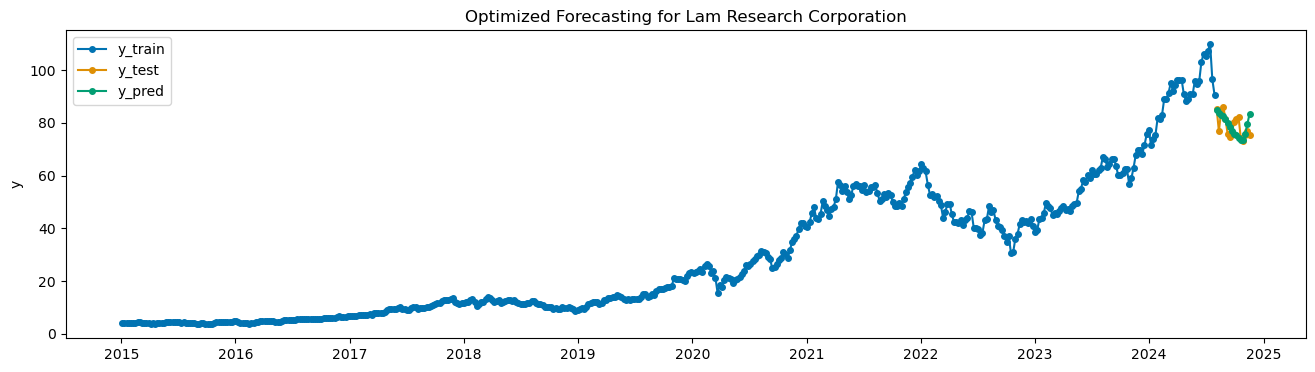

12:25:02 - cmdstanpy - INFO - Chain [1] start processing
12:25:02 - cmdstanpy - INFO - Chain [1] done processing
12:25:02 - cmdstanpy - INFO - Chain [1] start processing
12:25:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1 of 3136 for Tokyo Electron Limited...


12:25:02 - cmdstanpy - INFO - Chain [1] start processing
12:25:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2 of 3136 for Tokyo Electron Limited...


12:25:03 - cmdstanpy - INFO - Chain [1] start processing
12:25:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3 of 3136 for Tokyo Electron Limited...


12:25:03 - cmdstanpy - INFO - Chain [1] start processing
12:25:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 4 of 3136 for Tokyo Electron Limited...


12:25:03 - cmdstanpy - INFO - Chain [1] start processing
12:25:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 5 of 3136 for Tokyo Electron Limited...


12:25:03 - cmdstanpy - INFO - Chain [1] start processing
12:25:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 6 of 3136 for Tokyo Electron Limited...


12:25:04 - cmdstanpy - INFO - Chain [1] start processing
12:25:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 7 of 3136 for Tokyo Electron Limited...


12:25:04 - cmdstanpy - INFO - Chain [1] start processing
12:25:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 8 of 3136 for Tokyo Electron Limited...
Processing combination 9 of 3136 for Tokyo Electron Limited...


12:25:04 - cmdstanpy - INFO - Chain [1] start processing
12:25:04 - cmdstanpy - INFO - Chain [1] done processing
12:25:04 - cmdstanpy - INFO - Chain [1] start processing
12:25:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 10 of 3136 for Tokyo Electron Limited...


12:25:05 - cmdstanpy - INFO - Chain [1] start processing
12:25:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 11 of 3136 for Tokyo Electron Limited...


12:25:05 - cmdstanpy - INFO - Chain [1] start processing
12:25:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 12 of 3136 for Tokyo Electron Limited...
Processing combination 13 of 3136 for Tokyo Electron Limited...


12:25:05 - cmdstanpy - INFO - Chain [1] start processing
12:25:05 - cmdstanpy - INFO - Chain [1] done processing
12:25:05 - cmdstanpy - INFO - Chain [1] start processing
12:25:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 14 of 3136 for Tokyo Electron Limited...


12:25:06 - cmdstanpy - INFO - Chain [1] start processing
12:25:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 15 of 3136 for Tokyo Electron Limited...


12:25:06 - cmdstanpy - INFO - Chain [1] start processing
12:25:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 16 of 3136 for Tokyo Electron Limited...


12:25:06 - cmdstanpy - INFO - Chain [1] start processing
12:25:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 17 of 3136 for Tokyo Electron Limited...


12:25:06 - cmdstanpy - INFO - Chain [1] start processing
12:25:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 18 of 3136 for Tokyo Electron Limited...


12:25:07 - cmdstanpy - INFO - Chain [1] start processing
12:25:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 19 of 3136 for Tokyo Electron Limited...


12:25:07 - cmdstanpy - INFO - Chain [1] start processing
12:25:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 20 of 3136 for Tokyo Electron Limited...


12:25:07 - cmdstanpy - INFO - Chain [1] start processing
12:25:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 21 of 3136 for Tokyo Electron Limited...


12:25:07 - cmdstanpy - INFO - Chain [1] start processing
12:25:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 22 of 3136 for Tokyo Electron Limited...


12:25:08 - cmdstanpy - INFO - Chain [1] start processing
12:25:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 23 of 3136 for Tokyo Electron Limited...


12:25:08 - cmdstanpy - INFO - Chain [1] start processing
12:25:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 24 of 3136 for Tokyo Electron Limited...


12:25:08 - cmdstanpy - INFO - Chain [1] start processing
12:25:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 25 of 3136 for Tokyo Electron Limited...


12:25:08 - cmdstanpy - INFO - Chain [1] start processing
12:25:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 26 of 3136 for Tokyo Electron Limited...


12:25:09 - cmdstanpy - INFO - Chain [1] start processing
12:25:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 27 of 3136 for Tokyo Electron Limited...


12:25:09 - cmdstanpy - INFO - Chain [1] start processing
12:25:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 28 of 3136 for Tokyo Electron Limited...


12:25:09 - cmdstanpy - INFO - Chain [1] start processing
12:25:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 29 of 3136 for Tokyo Electron Limited...


12:25:09 - cmdstanpy - INFO - Chain [1] start processing
12:25:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 30 of 3136 for Tokyo Electron Limited...


12:25:10 - cmdstanpy - INFO - Chain [1] start processing
12:25:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 31 of 3136 for Tokyo Electron Limited...


12:25:10 - cmdstanpy - INFO - Chain [1] start processing
12:25:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 32 of 3136 for Tokyo Electron Limited...


12:25:10 - cmdstanpy - INFO - Chain [1] start processing
12:25:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 33 of 3136 for Tokyo Electron Limited...


12:25:10 - cmdstanpy - INFO - Chain [1] start processing
12:25:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 34 of 3136 for Tokyo Electron Limited...


12:25:11 - cmdstanpy - INFO - Chain [1] start processing
12:25:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 35 of 3136 for Tokyo Electron Limited...


12:25:11 - cmdstanpy - INFO - Chain [1] start processing
12:25:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 36 of 3136 for Tokyo Electron Limited...
Processing combination 37 of 3136 for Tokyo Electron Limited...


12:25:11 - cmdstanpy - INFO - Chain [1] start processing
12:25:11 - cmdstanpy - INFO - Chain [1] done processing
12:25:11 - cmdstanpy - INFO - Chain [1] start processing
12:25:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 38 of 3136 for Tokyo Electron Limited...


12:25:12 - cmdstanpy - INFO - Chain [1] start processing
12:25:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 39 of 3136 for Tokyo Electron Limited...


12:25:12 - cmdstanpy - INFO - Chain [1] start processing
12:25:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 40 of 3136 for Tokyo Electron Limited...


12:25:12 - cmdstanpy - INFO - Chain [1] start processing
12:25:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 41 of 3136 for Tokyo Electron Limited...


12:25:12 - cmdstanpy - INFO - Chain [1] start processing
12:25:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 42 of 3136 for Tokyo Electron Limited...


12:25:13 - cmdstanpy - INFO - Chain [1] start processing
12:25:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 43 of 3136 for Tokyo Electron Limited...


12:25:13 - cmdstanpy - INFO - Chain [1] start processing
12:25:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 44 of 3136 for Tokyo Electron Limited...


12:25:13 - cmdstanpy - INFO - Chain [1] start processing
12:25:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 45 of 3136 for Tokyo Electron Limited...


12:25:13 - cmdstanpy - INFO - Chain [1] start processing
12:25:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 46 of 3136 for Tokyo Electron Limited...


12:25:14 - cmdstanpy - INFO - Chain [1] start processing
12:25:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 47 of 3136 for Tokyo Electron Limited...


12:25:14 - cmdstanpy - INFO - Chain [1] start processing
12:25:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 48 of 3136 for Tokyo Electron Limited...


12:25:14 - cmdstanpy - INFO - Chain [1] start processing
12:25:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 49 of 3136 for Tokyo Electron Limited...


12:25:14 - cmdstanpy - INFO - Chain [1] start processing
12:25:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 50 of 3136 for Tokyo Electron Limited...


12:25:15 - cmdstanpy - INFO - Chain [1] start processing
12:25:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 51 of 3136 for Tokyo Electron Limited...


12:25:15 - cmdstanpy - INFO - Chain [1] start processing
12:25:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 52 of 3136 for Tokyo Electron Limited...


12:25:15 - cmdstanpy - INFO - Chain [1] start processing
12:25:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 53 of 3136 for Tokyo Electron Limited...


12:25:15 - cmdstanpy - INFO - Chain [1] start processing
12:25:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 54 of 3136 for Tokyo Electron Limited...


12:25:16 - cmdstanpy - INFO - Chain [1] start processing
12:25:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 55 of 3136 for Tokyo Electron Limited...


12:25:16 - cmdstanpy - INFO - Chain [1] start processing
12:25:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 56 of 3136 for Tokyo Electron Limited...


12:25:16 - cmdstanpy - INFO - Chain [1] start processing
12:25:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 57 of 3136 for Tokyo Electron Limited...


12:25:16 - cmdstanpy - INFO - Chain [1] start processing
12:25:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 58 of 3136 for Tokyo Electron Limited...


12:25:17 - cmdstanpy - INFO - Chain [1] start processing
12:25:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 59 of 3136 for Tokyo Electron Limited...


12:25:17 - cmdstanpy - INFO - Chain [1] start processing
12:25:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 60 of 3136 for Tokyo Electron Limited...


12:25:17 - cmdstanpy - INFO - Chain [1] start processing
12:25:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 61 of 3136 for Tokyo Electron Limited...


12:25:17 - cmdstanpy - INFO - Chain [1] start processing
12:25:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 62 of 3136 for Tokyo Electron Limited...


12:25:18 - cmdstanpy - INFO - Chain [1] start processing
12:25:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 63 of 3136 for Tokyo Electron Limited...


12:25:18 - cmdstanpy - INFO - Chain [1] start processing
12:25:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 64 of 3136 for Tokyo Electron Limited...


12:25:18 - cmdstanpy - INFO - Chain [1] start processing
12:25:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 65 of 3136 for Tokyo Electron Limited...


12:25:18 - cmdstanpy - INFO - Chain [1] start processing
12:25:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 66 of 3136 for Tokyo Electron Limited...


12:25:19 - cmdstanpy - INFO - Chain [1] start processing
12:25:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 67 of 3136 for Tokyo Electron Limited...


12:25:19 - cmdstanpy - INFO - Chain [1] start processing
12:25:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 68 of 3136 for Tokyo Electron Limited...


12:25:19 - cmdstanpy - INFO - Chain [1] start processing
12:25:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 69 of 3136 for Tokyo Electron Limited...


12:25:19 - cmdstanpy - INFO - Chain [1] start processing
12:25:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 70 of 3136 for Tokyo Electron Limited...


12:25:20 - cmdstanpy - INFO - Chain [1] start processing
12:25:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 71 of 3136 for Tokyo Electron Limited...


12:25:20 - cmdstanpy - INFO - Chain [1] start processing
12:25:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 72 of 3136 for Tokyo Electron Limited...


12:25:20 - cmdstanpy - INFO - Chain [1] start processing
12:25:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 73 of 3136 for Tokyo Electron Limited...


12:25:20 - cmdstanpy - INFO - Chain [1] start processing
12:25:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 74 of 3136 for Tokyo Electron Limited...


12:25:21 - cmdstanpy - INFO - Chain [1] start processing
12:25:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 75 of 3136 for Tokyo Electron Limited...


12:25:21 - cmdstanpy - INFO - Chain [1] start processing
12:25:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 76 of 3136 for Tokyo Electron Limited...
Processing combination 77 of 3136 for Tokyo Electron Limited...


12:25:21 - cmdstanpy - INFO - Chain [1] start processing
12:25:21 - cmdstanpy - INFO - Chain [1] done processing
12:25:21 - cmdstanpy - INFO - Chain [1] start processing
12:25:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 78 of 3136 for Tokyo Electron Limited...


12:25:22 - cmdstanpy - INFO - Chain [1] start processing
12:25:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 79 of 3136 for Tokyo Electron Limited...


12:25:22 - cmdstanpy - INFO - Chain [1] start processing
12:25:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 80 of 3136 for Tokyo Electron Limited...


12:25:22 - cmdstanpy - INFO - Chain [1] start processing
12:25:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 81 of 3136 for Tokyo Electron Limited...


12:25:22 - cmdstanpy - INFO - Chain [1] start processing
12:25:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 82 of 3136 for Tokyo Electron Limited...


12:25:23 - cmdstanpy - INFO - Chain [1] start processing
12:25:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 83 of 3136 for Tokyo Electron Limited...


12:25:23 - cmdstanpy - INFO - Chain [1] start processing
12:25:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 84 of 3136 for Tokyo Electron Limited...
Processing combination 85 of 3136 for Tokyo Electron Limited...


12:25:23 - cmdstanpy - INFO - Chain [1] start processing
12:25:23 - cmdstanpy - INFO - Chain [1] done processing
12:25:23 - cmdstanpy - INFO - Chain [1] start processing
12:25:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 86 of 3136 for Tokyo Electron Limited...


12:25:24 - cmdstanpy - INFO - Chain [1] start processing
12:25:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 87 of 3136 for Tokyo Electron Limited...


12:25:24 - cmdstanpy - INFO - Chain [1] start processing
12:25:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 88 of 3136 for Tokyo Electron Limited...


12:25:24 - cmdstanpy - INFO - Chain [1] start processing
12:25:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 89 of 3136 for Tokyo Electron Limited...


12:25:24 - cmdstanpy - INFO - Chain [1] start processing
12:25:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 90 of 3136 for Tokyo Electron Limited...


12:25:25 - cmdstanpy - INFO - Chain [1] start processing
12:25:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 91 of 3136 for Tokyo Electron Limited...


12:25:25 - cmdstanpy - INFO - Chain [1] start processing
12:25:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 92 of 3136 for Tokyo Electron Limited...


12:25:25 - cmdstanpy - INFO - Chain [1] start processing
12:25:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 93 of 3136 for Tokyo Electron Limited...


12:25:25 - cmdstanpy - INFO - Chain [1] start processing
12:25:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 94 of 3136 for Tokyo Electron Limited...


12:25:26 - cmdstanpy - INFO - Chain [1] start processing
12:25:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 95 of 3136 for Tokyo Electron Limited...


12:25:26 - cmdstanpy - INFO - Chain [1] start processing
12:25:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 96 of 3136 for Tokyo Electron Limited...


12:25:26 - cmdstanpy - INFO - Chain [1] start processing
12:25:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 97 of 3136 for Tokyo Electron Limited...


12:25:26 - cmdstanpy - INFO - Chain [1] start processing
12:25:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 98 of 3136 for Tokyo Electron Limited...


12:25:27 - cmdstanpy - INFO - Chain [1] start processing
12:25:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 99 of 3136 for Tokyo Electron Limited...


12:25:27 - cmdstanpy - INFO - Chain [1] start processing
12:25:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 100 of 3136 for Tokyo Electron Limited...


12:25:27 - cmdstanpy - INFO - Chain [1] start processing
12:25:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 101 of 3136 for Tokyo Electron Limited...


12:25:27 - cmdstanpy - INFO - Chain [1] start processing
12:25:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 102 of 3136 for Tokyo Electron Limited...


12:25:28 - cmdstanpy - INFO - Chain [1] start processing
12:25:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 103 of 3136 for Tokyo Electron Limited...


12:25:28 - cmdstanpy - INFO - Chain [1] start processing
12:25:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 104 of 3136 for Tokyo Electron Limited...
Processing combination 105 of 3136 for Tokyo Electron Limited...


12:25:28 - cmdstanpy - INFO - Chain [1] start processing
12:25:28 - cmdstanpy - INFO - Chain [1] done processing
12:25:28 - cmdstanpy - INFO - Chain [1] start processing
12:25:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 106 of 3136 for Tokyo Electron Limited...


12:25:29 - cmdstanpy - INFO - Chain [1] start processing
12:25:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 107 of 3136 for Tokyo Electron Limited...


12:25:29 - cmdstanpy - INFO - Chain [1] start processing
12:25:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 108 of 3136 for Tokyo Electron Limited...


12:25:29 - cmdstanpy - INFO - Chain [1] start processing
12:25:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 109 of 3136 for Tokyo Electron Limited...


12:25:29 - cmdstanpy - INFO - Chain [1] start processing
12:25:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 110 of 3136 for Tokyo Electron Limited...


12:25:30 - cmdstanpy - INFO - Chain [1] start processing
12:25:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 111 of 3136 for Tokyo Electron Limited...


12:25:30 - cmdstanpy - INFO - Chain [1] start processing
12:25:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 112 of 3136 for Tokyo Electron Limited...


12:25:30 - cmdstanpy - INFO - Chain [1] start processing
12:25:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 113 of 3136 for Tokyo Electron Limited...


12:25:30 - cmdstanpy - INFO - Chain [1] start processing
12:25:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 114 of 3136 for Tokyo Electron Limited...


12:25:31 - cmdstanpy - INFO - Chain [1] start processing
12:25:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 115 of 3136 for Tokyo Electron Limited...


12:25:31 - cmdstanpy - INFO - Chain [1] start processing
12:25:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 116 of 3136 for Tokyo Electron Limited...
Processing combination 117 of 3136 for Tokyo Electron Limited...


12:25:31 - cmdstanpy - INFO - Chain [1] start processing
12:25:31 - cmdstanpy - INFO - Chain [1] done processing
12:25:31 - cmdstanpy - INFO - Chain [1] start processing
12:25:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 118 of 3136 for Tokyo Electron Limited...


12:25:32 - cmdstanpy - INFO - Chain [1] start processing
12:25:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 119 of 3136 for Tokyo Electron Limited...


12:25:32 - cmdstanpy - INFO - Chain [1] start processing
12:25:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 120 of 3136 for Tokyo Electron Limited...
Processing combination 121 of 3136 for Tokyo Electron Limited...


12:25:32 - cmdstanpy - INFO - Chain [1] start processing
12:25:32 - cmdstanpy - INFO - Chain [1] done processing
12:25:32 - cmdstanpy - INFO - Chain [1] start processing
12:25:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 122 of 3136 for Tokyo Electron Limited...
Processing combination 123 of 3136 for Tokyo Electron Limited...


12:25:32 - cmdstanpy - INFO - Chain [1] start processing
12:25:33 - cmdstanpy - INFO - Chain [1] done processing
12:25:33 - cmdstanpy - INFO - Chain [1] start processing
12:25:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 124 of 3136 for Tokyo Electron Limited...
Processing combination 125 of 3136 for Tokyo Electron Limited...


12:25:33 - cmdstanpy - INFO - Chain [1] start processing
12:25:33 - cmdstanpy - INFO - Chain [1] done processing
12:25:33 - cmdstanpy - INFO - Chain [1] start processing
12:25:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 126 of 3136 for Tokyo Electron Limited...


12:25:33 - cmdstanpy - INFO - Chain [1] start processing
12:25:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 127 of 3136 for Tokyo Electron Limited...


12:25:34 - cmdstanpy - INFO - Chain [1] start processing
12:25:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 128 of 3136 for Tokyo Electron Limited...
Processing combination 129 of 3136 for Tokyo Electron Limited...


12:25:34 - cmdstanpy - INFO - Chain [1] start processing
12:25:34 - cmdstanpy - INFO - Chain [1] done processing
12:25:34 - cmdstanpy - INFO - Chain [1] start processing
12:25:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 130 of 3136 for Tokyo Electron Limited...


12:25:34 - cmdstanpy - INFO - Chain [1] start processing
12:25:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 131 of 3136 for Tokyo Electron Limited...


12:25:35 - cmdstanpy - INFO - Chain [1] start processing
12:25:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 132 of 3136 for Tokyo Electron Limited...
Processing combination 133 of 3136 for Tokyo Electron Limited...


12:25:35 - cmdstanpy - INFO - Chain [1] start processing
12:25:35 - cmdstanpy - INFO - Chain [1] done processing
12:25:35 - cmdstanpy - INFO - Chain [1] start processing
12:25:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 134 of 3136 for Tokyo Electron Limited...


12:25:35 - cmdstanpy - INFO - Chain [1] start processing
12:25:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 135 of 3136 for Tokyo Electron Limited...


12:25:35 - cmdstanpy - INFO - Chain [1] start processing
12:25:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 136 of 3136 for Tokyo Electron Limited...
Processing combination 137 of 3136 for Tokyo Electron Limited...


12:25:36 - cmdstanpy - INFO - Chain [1] start processing
12:25:36 - cmdstanpy - INFO - Chain [1] done processing
12:25:36 - cmdstanpy - INFO - Chain [1] start processing
12:25:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 138 of 3136 for Tokyo Electron Limited...


12:25:36 - cmdstanpy - INFO - Chain [1] start processing
12:25:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 139 of 3136 for Tokyo Electron Limited...


12:25:36 - cmdstanpy - INFO - Chain [1] start processing
12:25:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 140 of 3136 for Tokyo Electron Limited...
Processing combination 141 of 3136 for Tokyo Electron Limited...


12:25:37 - cmdstanpy - INFO - Chain [1] start processing
12:25:37 - cmdstanpy - INFO - Chain [1] done processing
12:25:37 - cmdstanpy - INFO - Chain [1] start processing
12:25:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 142 of 3136 for Tokyo Electron Limited...
Processing combination 143 of 3136 for Tokyo Electron Limited...


12:25:37 - cmdstanpy - INFO - Chain [1] start processing
12:25:37 - cmdstanpy - INFO - Chain [1] done processing
12:25:37 - cmdstanpy - INFO - Chain [1] start processing
12:25:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 144 of 3136 for Tokyo Electron Limited...


12:25:38 - cmdstanpy - INFO - Chain [1] start processing
12:25:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 145 of 3136 for Tokyo Electron Limited...


12:25:38 - cmdstanpy - INFO - Chain [1] start processing
12:25:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 146 of 3136 for Tokyo Electron Limited...


12:25:38 - cmdstanpy - INFO - Chain [1] start processing
12:25:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 147 of 3136 for Tokyo Electron Limited...


12:25:38 - cmdstanpy - INFO - Chain [1] start processing
12:25:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 148 of 3136 for Tokyo Electron Limited...


12:25:38 - cmdstanpy - INFO - Chain [1] start processing
12:25:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 149 of 3136 for Tokyo Electron Limited...


12:25:39 - cmdstanpy - INFO - Chain [1] start processing
12:25:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 150 of 3136 for Tokyo Electron Limited...


12:25:39 - cmdstanpy - INFO - Chain [1] start processing
12:25:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 151 of 3136 for Tokyo Electron Limited...


12:25:39 - cmdstanpy - INFO - Chain [1] start processing
12:25:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 152 of 3136 for Tokyo Electron Limited...


12:25:39 - cmdstanpy - INFO - Chain [1] start processing
12:25:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 153 of 3136 for Tokyo Electron Limited...


12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 154 of 3136 for Tokyo Electron Limited...


12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 155 of 3136 for Tokyo Electron Limited...


12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 156 of 3136 for Tokyo Electron Limited...
Processing combination 157 of 3136 for Tokyo Electron Limited...


12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:40 - cmdstanpy - INFO - Chain [1] done processing
12:25:41 - cmdstanpy - INFO - Chain [1] start processing
12:25:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 158 of 3136 for Tokyo Electron Limited...
Processing combination 159 of 3136 for Tokyo Electron Limited...


12:25:41 - cmdstanpy - INFO - Chain [1] start processing
12:25:41 - cmdstanpy - INFO - Chain [1] done processing
12:25:41 - cmdstanpy - INFO - Chain [1] start processing
12:25:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 160 of 3136 for Tokyo Electron Limited...
Processing combination 161 of 3136 for Tokyo Electron Limited...


12:25:41 - cmdstanpy - INFO - Chain [1] start processing
12:25:41 - cmdstanpy - INFO - Chain [1] done processing
12:25:41 - cmdstanpy - INFO - Chain [1] start processing
12:25:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 162 of 3136 for Tokyo Electron Limited...


12:25:42 - cmdstanpy - INFO - Chain [1] start processing
12:25:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 163 of 3136 for Tokyo Electron Limited...


12:25:42 - cmdstanpy - INFO - Chain [1] start processing
12:25:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 164 of 3136 for Tokyo Electron Limited...
Processing combination 165 of 3136 for Tokyo Electron Limited...


12:25:42 - cmdstanpy - INFO - Chain [1] start processing
12:25:42 - cmdstanpy - INFO - Chain [1] done processing
12:25:42 - cmdstanpy - INFO - Chain [1] start processing
12:25:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 166 of 3136 for Tokyo Electron Limited...
Processing combination 167 of 3136 for Tokyo Electron Limited...


12:25:43 - cmdstanpy - INFO - Chain [1] start processing
12:25:43 - cmdstanpy - INFO - Chain [1] done processing
12:25:43 - cmdstanpy - INFO - Chain [1] start processing
12:25:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 168 of 3136 for Tokyo Electron Limited...
Processing combination 169 of 3136 for Tokyo Electron Limited...


12:25:43 - cmdstanpy - INFO - Chain [1] start processing
12:25:43 - cmdstanpy - INFO - Chain [1] done processing
12:25:43 - cmdstanpy - INFO - Chain [1] start processing
12:25:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 170 of 3136 for Tokyo Electron Limited...


12:25:43 - cmdstanpy - INFO - Chain [1] start processing
12:25:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 171 of 3136 for Tokyo Electron Limited...


12:25:44 - cmdstanpy - INFO - Chain [1] start processing
12:25:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 172 of 3136 for Tokyo Electron Limited...
Processing combination 173 of 3136 for Tokyo Electron Limited...


12:25:44 - cmdstanpy - INFO - Chain [1] start processing
12:25:44 - cmdstanpy - INFO - Chain [1] done processing
12:25:44 - cmdstanpy - INFO - Chain [1] start processing
12:25:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 174 of 3136 for Tokyo Electron Limited...


12:25:44 - cmdstanpy - INFO - Chain [1] start processing
12:25:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 175 of 3136 for Tokyo Electron Limited...


12:25:45 - cmdstanpy - INFO - Chain [1] start processing
12:25:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 176 of 3136 for Tokyo Electron Limited...
Processing combination 177 of 3136 for Tokyo Electron Limited...


12:25:45 - cmdstanpy - INFO - Chain [1] start processing
12:25:45 - cmdstanpy - INFO - Chain [1] done processing
12:25:45 - cmdstanpy - INFO - Chain [1] start processing
12:25:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 178 of 3136 for Tokyo Electron Limited...
Processing combination 179 of 3136 for Tokyo Electron Limited...


12:25:45 - cmdstanpy - INFO - Chain [1] start processing
12:25:45 - cmdstanpy - INFO - Chain [1] done processing
12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 180 of 3136 for Tokyo Electron Limited...
Processing combination 181 of 3136 for Tokyo Electron Limited...


12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing
12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 182 of 3136 for Tokyo Electron Limited...


12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 183 of 3136 for Tokyo Electron Limited...


12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 184 of 3136 for Tokyo Electron Limited...
Processing combination 185 of 3136 for Tokyo Electron Limited...


12:25:47 - cmdstanpy - INFO - Chain [1] start processing
12:25:47 - cmdstanpy - INFO - Chain [1] done processing
12:25:47 - cmdstanpy - INFO - Chain [1] start processing
12:25:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 186 of 3136 for Tokyo Electron Limited...
Processing combination 187 of 3136 for Tokyo Electron Limited...


12:25:47 - cmdstanpy - INFO - Chain [1] start processing
12:25:47 - cmdstanpy - INFO - Chain [1] done processing
12:25:47 - cmdstanpy - INFO - Chain [1] start processing
12:25:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 188 of 3136 for Tokyo Electron Limited...
Processing combination 189 of 3136 for Tokyo Electron Limited...


12:25:48 - cmdstanpy - INFO - Chain [1] start processing
12:25:48 - cmdstanpy - INFO - Chain [1] done processing
12:25:48 - cmdstanpy - INFO - Chain [1] start processing
12:25:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 190 of 3136 for Tokyo Electron Limited...


12:25:48 - cmdstanpy - INFO - Chain [1] start processing
12:25:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 191 of 3136 for Tokyo Electron Limited...


12:25:48 - cmdstanpy - INFO - Chain [1] start processing
12:25:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 192 of 3136 for Tokyo Electron Limited...


12:25:49 - cmdstanpy - INFO - Chain [1] start processing
12:25:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 193 of 3136 for Tokyo Electron Limited...


12:25:49 - cmdstanpy - INFO - Chain [1] start processing
12:25:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 194 of 3136 for Tokyo Electron Limited...


12:25:49 - cmdstanpy - INFO - Chain [1] start processing
12:25:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 195 of 3136 for Tokyo Electron Limited...


12:25:49 - cmdstanpy - INFO - Chain [1] start processing
12:25:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 196 of 3136 for Tokyo Electron Limited...


12:25:49 - cmdstanpy - INFO - Chain [1] start processing
12:25:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 197 of 3136 for Tokyo Electron Limited...


12:25:50 - cmdstanpy - INFO - Chain [1] start processing
12:25:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 198 of 3136 for Tokyo Electron Limited...


12:25:50 - cmdstanpy - INFO - Chain [1] start processing
12:25:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 199 of 3136 for Tokyo Electron Limited...


12:25:50 - cmdstanpy - INFO - Chain [1] start processing
12:25:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 200 of 3136 for Tokyo Electron Limited...
Processing combination 201 of 3136 for Tokyo Electron Limited...


12:25:50 - cmdstanpy - INFO - Chain [1] start processing
12:25:50 - cmdstanpy - INFO - Chain [1] done processing
12:25:51 - cmdstanpy - INFO - Chain [1] start processing
12:25:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 202 of 3136 for Tokyo Electron Limited...


12:25:51 - cmdstanpy - INFO - Chain [1] start processing
12:25:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 203 of 3136 for Tokyo Electron Limited...


12:25:51 - cmdstanpy - INFO - Chain [1] start processing
12:25:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 204 of 3136 for Tokyo Electron Limited...


12:25:51 - cmdstanpy - INFO - Chain [1] start processing
12:25:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 205 of 3136 for Tokyo Electron Limited...


12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 206 of 3136 for Tokyo Electron Limited...


12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 207 of 3136 for Tokyo Electron Limited...


12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 208 of 3136 for Tokyo Electron Limited...
Processing combination 209 of 3136 for Tokyo Electron Limited...


12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing
12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 210 of 3136 for Tokyo Electron Limited...


12:25:53 - cmdstanpy - INFO - Chain [1] start processing
12:25:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 211 of 3136 for Tokyo Electron Limited...


12:25:53 - cmdstanpy - INFO - Chain [1] start processing
12:25:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 212 of 3136 for Tokyo Electron Limited...


12:25:53 - cmdstanpy - INFO - Chain [1] start processing
12:25:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 213 of 3136 for Tokyo Electron Limited...


12:25:53 - cmdstanpy - INFO - Chain [1] start processing
12:25:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 214 of 3136 for Tokyo Electron Limited...


12:25:54 - cmdstanpy - INFO - Chain [1] start processing
12:25:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 215 of 3136 for Tokyo Electron Limited...


12:25:54 - cmdstanpy - INFO - Chain [1] start processing
12:25:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 216 of 3136 for Tokyo Electron Limited...
Processing combination 217 of 3136 for Tokyo Electron Limited...


12:25:54 - cmdstanpy - INFO - Chain [1] start processing
12:25:54 - cmdstanpy - INFO - Chain [1] done processing
12:25:54 - cmdstanpy - INFO - Chain [1] start processing
12:25:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 218 of 3136 for Tokyo Electron Limited...


12:25:55 - cmdstanpy - INFO - Chain [1] start processing
12:25:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 219 of 3136 for Tokyo Electron Limited...


12:25:55 - cmdstanpy - INFO - Chain [1] start processing
12:25:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 220 of 3136 for Tokyo Electron Limited...
Processing combination 221 of 3136 for Tokyo Electron Limited...


12:25:55 - cmdstanpy - INFO - Chain [1] start processing
12:25:55 - cmdstanpy - INFO - Chain [1] done processing
12:25:55 - cmdstanpy - INFO - Chain [1] start processing
12:25:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 222 of 3136 for Tokyo Electron Limited...


12:25:56 - cmdstanpy - INFO - Chain [1] start processing
12:25:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 223 of 3136 for Tokyo Electron Limited...


12:25:56 - cmdstanpy - INFO - Chain [1] start processing
12:25:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 224 of 3136 for Tokyo Electron Limited...


12:25:56 - cmdstanpy - INFO - Chain [1] start processing
12:25:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 225 of 3136 for Tokyo Electron Limited...


12:25:56 - cmdstanpy - INFO - Chain [1] start processing
12:25:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 226 of 3136 for Tokyo Electron Limited...


12:25:57 - cmdstanpy - INFO - Chain [1] start processing
12:25:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 227 of 3136 for Tokyo Electron Limited...


12:25:57 - cmdstanpy - INFO - Chain [1] start processing
12:25:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 228 of 3136 for Tokyo Electron Limited...


12:25:57 - cmdstanpy - INFO - Chain [1] start processing
12:25:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 229 of 3136 for Tokyo Electron Limited...


12:25:57 - cmdstanpy - INFO - Chain [1] start processing
12:25:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 230 of 3136 for Tokyo Electron Limited...


12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 231 of 3136 for Tokyo Electron Limited...


12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 232 of 3136 for Tokyo Electron Limited...
Processing combination 233 of 3136 for Tokyo Electron Limited...


12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing
12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 234 of 3136 for Tokyo Electron Limited...


12:25:59 - cmdstanpy - INFO - Chain [1] start processing
12:25:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 235 of 3136 for Tokyo Electron Limited...


12:25:59 - cmdstanpy - INFO - Chain [1] start processing
12:25:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 236 of 3136 for Tokyo Electron Limited...


12:25:59 - cmdstanpy - INFO - Chain [1] start processing
12:25:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 237 of 3136 for Tokyo Electron Limited...


12:25:59 - cmdstanpy - INFO - Chain [1] start processing
12:25:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 238 of 3136 for Tokyo Electron Limited...


12:26:00 - cmdstanpy - INFO - Chain [1] start processing
12:26:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 239 of 3136 for Tokyo Electron Limited...


12:26:00 - cmdstanpy - INFO - Chain [1] start processing
12:26:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 240 of 3136 for Tokyo Electron Limited...


12:26:00 - cmdstanpy - INFO - Chain [1] start processing
12:26:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 241 of 3136 for Tokyo Electron Limited...


12:26:00 - cmdstanpy - INFO - Chain [1] start processing
12:26:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 242 of 3136 for Tokyo Electron Limited...


12:26:01 - cmdstanpy - INFO - Chain [1] start processing
12:26:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 243 of 3136 for Tokyo Electron Limited...


12:26:01 - cmdstanpy - INFO - Chain [1] start processing
12:26:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 244 of 3136 for Tokyo Electron Limited...


12:26:01 - cmdstanpy - INFO - Chain [1] start processing
12:26:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 245 of 3136 for Tokyo Electron Limited...


12:26:01 - cmdstanpy - INFO - Chain [1] start processing
12:26:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 246 of 3136 for Tokyo Electron Limited...


12:26:02 - cmdstanpy - INFO - Chain [1] start processing
12:26:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 247 of 3136 for Tokyo Electron Limited...


12:26:02 - cmdstanpy - INFO - Chain [1] start processing
12:26:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 248 of 3136 for Tokyo Electron Limited...
Processing combination 249 of 3136 for Tokyo Electron Limited...


12:26:02 - cmdstanpy - INFO - Chain [1] start processing
12:26:02 - cmdstanpy - INFO - Chain [1] done processing
12:26:02 - cmdstanpy - INFO - Chain [1] start processing
12:26:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 250 of 3136 for Tokyo Electron Limited...


12:26:03 - cmdstanpy - INFO - Chain [1] start processing
12:26:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 251 of 3136 for Tokyo Electron Limited...


12:26:03 - cmdstanpy - INFO - Chain [1] start processing
12:26:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 252 of 3136 for Tokyo Electron Limited...


12:26:03 - cmdstanpy - INFO - Chain [1] start processing
12:26:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 253 of 3136 for Tokyo Electron Limited...


12:26:03 - cmdstanpy - INFO - Chain [1] start processing
12:26:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 254 of 3136 for Tokyo Electron Limited...


12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 255 of 3136 for Tokyo Electron Limited...


12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 256 of 3136 for Tokyo Electron Limited...


12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 257 of 3136 for Tokyo Electron Limited...


12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 258 of 3136 for Tokyo Electron Limited...


12:26:05 - cmdstanpy - INFO - Chain [1] start processing
12:26:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 259 of 3136 for Tokyo Electron Limited...


12:26:05 - cmdstanpy - INFO - Chain [1] start processing
12:26:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 260 of 3136 for Tokyo Electron Limited...


12:26:05 - cmdstanpy - INFO - Chain [1] start processing
12:26:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 261 of 3136 for Tokyo Electron Limited...


12:26:05 - cmdstanpy - INFO - Chain [1] start processing
12:26:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 262 of 3136 for Tokyo Electron Limited...


12:26:06 - cmdstanpy - INFO - Chain [1] start processing
12:26:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 263 of 3136 for Tokyo Electron Limited...


12:26:06 - cmdstanpy - INFO - Chain [1] start processing
12:26:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 264 of 3136 for Tokyo Electron Limited...


12:26:06 - cmdstanpy - INFO - Chain [1] start processing
12:26:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 265 of 3136 for Tokyo Electron Limited...


12:26:06 - cmdstanpy - INFO - Chain [1] start processing
12:26:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 266 of 3136 for Tokyo Electron Limited...


12:26:07 - cmdstanpy - INFO - Chain [1] start processing
12:26:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 267 of 3136 for Tokyo Electron Limited...


12:26:07 - cmdstanpy - INFO - Chain [1] start processing
12:26:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 268 of 3136 for Tokyo Electron Limited...


12:26:07 - cmdstanpy - INFO - Chain [1] start processing
12:26:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 269 of 3136 for Tokyo Electron Limited...


12:26:08 - cmdstanpy - INFO - Chain [1] start processing
12:26:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 270 of 3136 for Tokyo Electron Limited...


12:26:08 - cmdstanpy - INFO - Chain [1] start processing
12:26:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 271 of 3136 for Tokyo Electron Limited...


12:26:08 - cmdstanpy - INFO - Chain [1] start processing
12:26:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 272 of 3136 for Tokyo Electron Limited...
Processing combination 273 of 3136 for Tokyo Electron Limited...


12:26:08 - cmdstanpy - INFO - Chain [1] start processing
12:26:08 - cmdstanpy - INFO - Chain [1] done processing
12:26:09 - cmdstanpy - INFO - Chain [1] start processing
12:26:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 274 of 3136 for Tokyo Electron Limited...


12:26:09 - cmdstanpy - INFO - Chain [1] start processing
12:26:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 275 of 3136 for Tokyo Electron Limited...


12:26:09 - cmdstanpy - INFO - Chain [1] start processing
12:26:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 276 of 3136 for Tokyo Electron Limited...


12:26:09 - cmdstanpy - INFO - Chain [1] start processing
12:26:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 277 of 3136 for Tokyo Electron Limited...


12:26:10 - cmdstanpy - INFO - Chain [1] start processing
12:26:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 278 of 3136 for Tokyo Electron Limited...


12:26:10 - cmdstanpy - INFO - Chain [1] start processing
12:26:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 279 of 3136 for Tokyo Electron Limited...


12:26:10 - cmdstanpy - INFO - Chain [1] start processing
12:26:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 280 of 3136 for Tokyo Electron Limited...
Processing combination 281 of 3136 for Tokyo Electron Limited...


12:26:10 - cmdstanpy - INFO - Chain [1] start processing
12:26:10 - cmdstanpy - INFO - Chain [1] done processing
12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 282 of 3136 for Tokyo Electron Limited...


12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 283 of 3136 for Tokyo Electron Limited...


12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 284 of 3136 for Tokyo Electron Limited...
Processing combination 285 of 3136 for Tokyo Electron Limited...


12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing
12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 286 of 3136 for Tokyo Electron Limited...


12:26:12 - cmdstanpy - INFO - Chain [1] start processing
12:26:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 287 of 3136 for Tokyo Electron Limited...


12:26:12 - cmdstanpy - INFO - Chain [1] start processing
12:26:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 288 of 3136 for Tokyo Electron Limited...


12:26:12 - cmdstanpy - INFO - Chain [1] start processing
12:26:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 289 of 3136 for Tokyo Electron Limited...


12:26:12 - cmdstanpy - INFO - Chain [1] start processing
12:26:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 290 of 3136 for Tokyo Electron Limited...


12:26:13 - cmdstanpy - INFO - Chain [1] start processing
12:26:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 291 of 3136 for Tokyo Electron Limited...


12:26:13 - cmdstanpy - INFO - Chain [1] start processing
12:26:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 292 of 3136 for Tokyo Electron Limited...
Processing combination 293 of 3136 for Tokyo Electron Limited...


12:26:13 - cmdstanpy - INFO - Chain [1] start processing
12:26:13 - cmdstanpy - INFO - Chain [1] done processing
12:26:13 - cmdstanpy - INFO - Chain [1] start processing
12:26:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 294 of 3136 for Tokyo Electron Limited...


12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 295 of 3136 for Tokyo Electron Limited...


12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 296 of 3136 for Tokyo Electron Limited...


12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 297 of 3136 for Tokyo Electron Limited...


12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 298 of 3136 for Tokyo Electron Limited...


12:26:15 - cmdstanpy - INFO - Chain [1] start processing
12:26:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 299 of 3136 for Tokyo Electron Limited...


12:26:15 - cmdstanpy - INFO - Chain [1] start processing
12:26:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 300 of 3136 for Tokyo Electron Limited...


12:26:15 - cmdstanpy - INFO - Chain [1] start processing
12:26:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 301 of 3136 for Tokyo Electron Limited...


12:26:15 - cmdstanpy - INFO - Chain [1] start processing
12:26:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 302 of 3136 for Tokyo Electron Limited...


12:26:16 - cmdstanpy - INFO - Chain [1] start processing
12:26:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 303 of 3136 for Tokyo Electron Limited...


12:26:16 - cmdstanpy - INFO - Chain [1] start processing
12:26:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 304 of 3136 for Tokyo Electron Limited...


12:26:16 - cmdstanpy - INFO - Chain [1] start processing
12:26:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 305 of 3136 for Tokyo Electron Limited...


12:26:16 - cmdstanpy - INFO - Chain [1] start processing
12:26:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 306 of 3136 for Tokyo Electron Limited...


12:26:17 - cmdstanpy - INFO - Chain [1] start processing
12:26:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 307 of 3136 for Tokyo Electron Limited...


12:26:17 - cmdstanpy - INFO - Chain [1] start processing
12:26:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 308 of 3136 for Tokyo Electron Limited...


12:26:17 - cmdstanpy - INFO - Chain [1] start processing
12:26:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 309 of 3136 for Tokyo Electron Limited...


12:26:17 - cmdstanpy - INFO - Chain [1] start processing
12:26:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 310 of 3136 for Tokyo Electron Limited...


12:26:18 - cmdstanpy - INFO - Chain [1] start processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 311 of 3136 for Tokyo Electron Limited...


12:26:18 - cmdstanpy - INFO - Chain [1] start processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 312 of 3136 for Tokyo Electron Limited...


12:26:18 - cmdstanpy - INFO - Chain [1] start processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 313 of 3136 for Tokyo Electron Limited...


12:26:18 - cmdstanpy - INFO - Chain [1] start processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 314 of 3136 for Tokyo Electron Limited...


12:26:19 - cmdstanpy - INFO - Chain [1] start processing
12:26:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 315 of 3136 for Tokyo Electron Limited...


12:26:19 - cmdstanpy - INFO - Chain [1] start processing
12:26:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 316 of 3136 for Tokyo Electron Limited...


12:26:19 - cmdstanpy - INFO - Chain [1] start processing
12:26:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 317 of 3136 for Tokyo Electron Limited...


12:26:19 - cmdstanpy - INFO - Chain [1] start processing
12:26:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 318 of 3136 for Tokyo Electron Limited...


12:26:20 - cmdstanpy - INFO - Chain [1] start processing
12:26:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 319 of 3136 for Tokyo Electron Limited...


12:26:20 - cmdstanpy - INFO - Chain [1] start processing
12:26:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 320 of 3136 for Tokyo Electron Limited...


12:26:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 321 of 3136 for Tokyo Electron Limited...


12:26:20 - cmdstanpy - INFO - Chain [1] done processing
12:26:21 - cmdstanpy - INFO - Chain [1] start processing
12:26:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 322 of 3136 for Tokyo Electron Limited...


12:26:21 - cmdstanpy - INFO - Chain [1] start processing
12:26:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 323 of 3136 for Tokyo Electron Limited...


12:26:21 - cmdstanpy - INFO - Chain [1] start processing
12:26:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 324 of 3136 for Tokyo Electron Limited...


12:26:21 - cmdstanpy - INFO - Chain [1] start processing
12:26:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 325 of 3136 for Tokyo Electron Limited...


12:26:22 - cmdstanpy - INFO - Chain [1] start processing
12:26:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 326 of 3136 for Tokyo Electron Limited...


12:26:22 - cmdstanpy - INFO - Chain [1] start processing
12:26:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 327 of 3136 for Tokyo Electron Limited...


12:26:22 - cmdstanpy - INFO - Chain [1] start processing
12:26:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 328 of 3136 for Tokyo Electron Limited...


12:26:22 - cmdstanpy - INFO - Chain [1] start processing
12:26:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 329 of 3136 for Tokyo Electron Limited...


12:26:23 - cmdstanpy - INFO - Chain [1] start processing
12:26:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 330 of 3136 for Tokyo Electron Limited...


12:26:23 - cmdstanpy - INFO - Chain [1] start processing
12:26:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 331 of 3136 for Tokyo Electron Limited...


12:26:23 - cmdstanpy - INFO - Chain [1] start processing
12:26:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 332 of 3136 for Tokyo Electron Limited...


12:26:23 - cmdstanpy - INFO - Chain [1] start processing
12:26:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 333 of 3136 for Tokyo Electron Limited...


12:26:24 - cmdstanpy - INFO - Chain [1] start processing
12:26:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 334 of 3136 for Tokyo Electron Limited...


12:26:24 - cmdstanpy - INFO - Chain [1] start processing
12:26:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 335 of 3136 for Tokyo Electron Limited...


12:26:24 - cmdstanpy - INFO - Chain [1] start processing
12:26:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 336 of 3136 for Tokyo Electron Limited...


12:26:24 - cmdstanpy - INFO - Chain [1] start processing
12:26:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 337 of 3136 for Tokyo Electron Limited...


12:26:25 - cmdstanpy - INFO - Chain [1] start processing
12:26:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 338 of 3136 for Tokyo Electron Limited...
Processing combination 339 of 3136 for Tokyo Electron Limited...


12:26:25 - cmdstanpy - INFO - Chain [1] start processing
12:26:25 - cmdstanpy - INFO - Chain [1] done processing
12:26:25 - cmdstanpy - INFO - Chain [1] start processing
12:26:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 340 of 3136 for Tokyo Electron Limited...
Processing combination 341 of 3136 for Tokyo Electron Limited...


12:26:25 - cmdstanpy - INFO - Chain [1] start processing
12:26:25 - cmdstanpy - INFO - Chain [1] done processing
12:26:25 - cmdstanpy - INFO - Chain [1] start processing
12:26:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 342 of 3136 for Tokyo Electron Limited...


12:26:26 - cmdstanpy - INFO - Chain [1] start processing
12:26:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 343 of 3136 for Tokyo Electron Limited...


12:26:26 - cmdstanpy - INFO - Chain [1] start processing
12:26:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 344 of 3136 for Tokyo Electron Limited...
Processing combination 345 of 3136 for Tokyo Electron Limited...


12:26:26 - cmdstanpy - INFO - Chain [1] start processing
12:26:26 - cmdstanpy - INFO - Chain [1] done processing
12:26:26 - cmdstanpy - INFO - Chain [1] start processing
12:26:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 346 of 3136 for Tokyo Electron Limited...


12:26:27 - cmdstanpy - INFO - Chain [1] start processing
12:26:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 347 of 3136 for Tokyo Electron Limited...


12:26:27 - cmdstanpy - INFO - Chain [1] start processing
12:26:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 348 of 3136 for Tokyo Electron Limited...
Processing combination 349 of 3136 for Tokyo Electron Limited...


12:26:27 - cmdstanpy - INFO - Chain [1] start processing
12:26:27 - cmdstanpy - INFO - Chain [1] done processing
12:26:27 - cmdstanpy - INFO - Chain [1] start processing
12:26:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 350 of 3136 for Tokyo Electron Limited...


12:26:28 - cmdstanpy - INFO - Chain [1] start processing
12:26:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 351 of 3136 for Tokyo Electron Limited...


12:26:28 - cmdstanpy - INFO - Chain [1] start processing
12:26:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 352 of 3136 for Tokyo Electron Limited...
Processing combination 353 of 3136 for Tokyo Electron Limited...


12:26:28 - cmdstanpy - INFO - Chain [1] start processing
12:26:28 - cmdstanpy - INFO - Chain [1] done processing
12:26:28 - cmdstanpy - INFO - Chain [1] start processing
12:26:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 354 of 3136 for Tokyo Electron Limited...


12:26:28 - cmdstanpy - INFO - Chain [1] start processing
12:26:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 355 of 3136 for Tokyo Electron Limited...


12:26:29 - cmdstanpy - INFO - Chain [1] start processing
12:26:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 356 of 3136 for Tokyo Electron Limited...
Processing combination 357 of 3136 for Tokyo Electron Limited...


12:26:29 - cmdstanpy - INFO - Chain [1] start processing
12:26:29 - cmdstanpy - INFO - Chain [1] done processing
12:26:29 - cmdstanpy - INFO - Chain [1] start processing
12:26:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 358 of 3136 for Tokyo Electron Limited...


12:26:29 - cmdstanpy - INFO - Chain [1] start processing
12:26:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 359 of 3136 for Tokyo Electron Limited...


12:26:30 - cmdstanpy - INFO - Chain [1] start processing
12:26:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 360 of 3136 for Tokyo Electron Limited...
Processing combination 361 of 3136 for Tokyo Electron Limited...


12:26:30 - cmdstanpy - INFO - Chain [1] start processing
12:26:30 - cmdstanpy - INFO - Chain [1] done processing
12:26:30 - cmdstanpy - INFO - Chain [1] start processing
12:26:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 362 of 3136 for Tokyo Electron Limited...
Processing combination 363 of 3136 for Tokyo Electron Limited...


12:26:30 - cmdstanpy - INFO - Chain [1] start processing
12:26:30 - cmdstanpy - INFO - Chain [1] done processing
12:26:31 - cmdstanpy - INFO - Chain [1] start processing
12:26:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 364 of 3136 for Tokyo Electron Limited...
Processing combination 365 of 3136 for Tokyo Electron Limited...


12:26:31 - cmdstanpy - INFO - Chain [1] start processing
12:26:31 - cmdstanpy - INFO - Chain [1] done processing
12:26:31 - cmdstanpy - INFO - Chain [1] start processing
12:26:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 366 of 3136 for Tokyo Electron Limited...
Processing combination 367 of 3136 for Tokyo Electron Limited...


12:26:31 - cmdstanpy - INFO - Chain [1] start processing
12:26:31 - cmdstanpy - INFO - Chain [1] done processing
12:26:31 - cmdstanpy - INFO - Chain [1] start processing
12:26:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 368 of 3136 for Tokyo Electron Limited...
Processing combination 369 of 3136 for Tokyo Electron Limited...


12:26:32 - cmdstanpy - INFO - Chain [1] start processing
12:26:32 - cmdstanpy - INFO - Chain [1] done processing
12:26:32 - cmdstanpy - INFO - Chain [1] start processing
12:26:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 370 of 3136 for Tokyo Electron Limited...


12:26:32 - cmdstanpy - INFO - Chain [1] start processing
12:26:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 371 of 3136 for Tokyo Electron Limited...


12:26:32 - cmdstanpy - INFO - Chain [1] start processing
12:26:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 372 of 3136 for Tokyo Electron Limited...
Processing combination 373 of 3136 for Tokyo Electron Limited...


12:26:33 - cmdstanpy - INFO - Chain [1] start processing
12:26:33 - cmdstanpy - INFO - Chain [1] done processing
12:26:33 - cmdstanpy - INFO - Chain [1] start processing
12:26:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 374 of 3136 for Tokyo Electron Limited...


12:26:33 - cmdstanpy - INFO - Chain [1] start processing
12:26:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 375 of 3136 for Tokyo Electron Limited...


12:26:33 - cmdstanpy - INFO - Chain [1] start processing
12:26:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 376 of 3136 for Tokyo Electron Limited...


12:26:34 - cmdstanpy - INFO - Chain [1] start processing
12:26:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 377 of 3136 for Tokyo Electron Limited...


12:26:34 - cmdstanpy - INFO - Chain [1] start processing
12:26:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 378 of 3136 for Tokyo Electron Limited...


12:26:34 - cmdstanpy - INFO - Chain [1] start processing
12:26:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 379 of 3136 for Tokyo Electron Limited...


12:26:34 - cmdstanpy - INFO - Chain [1] start processing
12:26:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 380 of 3136 for Tokyo Electron Limited...
Processing combination 381 of 3136 for Tokyo Electron Limited...


12:26:34 - cmdstanpy - INFO - Chain [1] start processing
12:26:34 - cmdstanpy - INFO - Chain [1] done processing
12:26:35 - cmdstanpy - INFO - Chain [1] start processing
12:26:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 382 of 3136 for Tokyo Electron Limited...
Processing combination 383 of 3136 for Tokyo Electron Limited...


12:26:35 - cmdstanpy - INFO - Chain [1] start processing
12:26:35 - cmdstanpy - INFO - Chain [1] done processing
12:26:35 - cmdstanpy - INFO - Chain [1] start processing
12:26:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 384 of 3136 for Tokyo Electron Limited...
Processing combination 385 of 3136 for Tokyo Electron Limited...


12:26:35 - cmdstanpy - INFO - Chain [1] start processing
12:26:35 - cmdstanpy - INFO - Chain [1] done processing
12:26:36 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 386 of 3136 for Tokyo Electron Limited...


12:26:36 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 387 of 3136 for Tokyo Electron Limited...


12:26:36 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 388 of 3136 for Tokyo Electron Limited...
Processing combination 389 of 3136 for Tokyo Electron Limited...


12:26:36 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing
12:26:36 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 390 of 3136 for Tokyo Electron Limited...


12:26:37 - cmdstanpy - INFO - Chain [1] start processing
12:26:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 391 of 3136 for Tokyo Electron Limited...


12:26:37 - cmdstanpy - INFO - Chain [1] start processing
12:26:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 392 of 3136 for Tokyo Electron Limited...
Processing combination 393 of 3136 for Tokyo Electron Limited...


12:26:37 - cmdstanpy - INFO - Chain [1] start processing
12:26:37 - cmdstanpy - INFO - Chain [1] done processing
12:26:37 - cmdstanpy - INFO - Chain [1] start processing
12:26:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 394 of 3136 for Tokyo Electron Limited...


12:26:38 - cmdstanpy - INFO - Chain [1] start processing
12:26:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 395 of 3136 for Tokyo Electron Limited...


12:26:38 - cmdstanpy - INFO - Chain [1] start processing
12:26:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 396 of 3136 for Tokyo Electron Limited...
Processing combination 397 of 3136 for Tokyo Electron Limited...


12:26:38 - cmdstanpy - INFO - Chain [1] start processing
12:26:38 - cmdstanpy - INFO - Chain [1] done processing
12:26:38 - cmdstanpy - INFO - Chain [1] start processing
12:26:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 398 of 3136 for Tokyo Electron Limited...


12:26:38 - cmdstanpy - INFO - Chain [1] start processing
12:26:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 399 of 3136 for Tokyo Electron Limited...


12:26:39 - cmdstanpy - INFO - Chain [1] start processing
12:26:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 400 of 3136 for Tokyo Electron Limited...
Processing combination 401 of 3136 for Tokyo Electron Limited...


12:26:39 - cmdstanpy - INFO - Chain [1] start processing
12:26:39 - cmdstanpy - INFO - Chain [1] done processing
12:26:39 - cmdstanpy - INFO - Chain [1] start processing
12:26:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 402 of 3136 for Tokyo Electron Limited...
Processing combination 403 of 3136 for Tokyo Electron Limited...


12:26:39 - cmdstanpy - INFO - Chain [1] start processing
12:26:39 - cmdstanpy - INFO - Chain [1] done processing
12:26:40 - cmdstanpy - INFO - Chain [1] start processing
12:26:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 404 of 3136 for Tokyo Electron Limited...
Processing combination 405 of 3136 for Tokyo Electron Limited...


12:26:40 - cmdstanpy - INFO - Chain [1] start processing
12:26:40 - cmdstanpy - INFO - Chain [1] done processing
12:26:40 - cmdstanpy - INFO - Chain [1] start processing
12:26:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 406 of 3136 for Tokyo Electron Limited...
Processing combination 407 of 3136 for Tokyo Electron Limited...


12:26:40 - cmdstanpy - INFO - Chain [1] start processing
12:26:40 - cmdstanpy - INFO - Chain [1] done processing
12:26:40 - cmdstanpy - INFO - Chain [1] start processing
12:26:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 408 of 3136 for Tokyo Electron Limited...
Processing combination 409 of 3136 for Tokyo Electron Limited...


12:26:41 - cmdstanpy - INFO - Chain [1] start processing
12:26:41 - cmdstanpy - INFO - Chain [1] done processing
12:26:41 - cmdstanpy - INFO - Chain [1] start processing
12:26:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 410 of 3136 for Tokyo Electron Limited...
Processing combination 411 of 3136 for Tokyo Electron Limited...


12:26:41 - cmdstanpy - INFO - Chain [1] start processing
12:26:41 - cmdstanpy - INFO - Chain [1] done processing
12:26:41 - cmdstanpy - INFO - Chain [1] start processing
12:26:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 412 of 3136 for Tokyo Electron Limited...
Processing combination 413 of 3136 for Tokyo Electron Limited...


12:26:42 - cmdstanpy - INFO - Chain [1] start processing
12:26:42 - cmdstanpy - INFO - Chain [1] done processing
12:26:42 - cmdstanpy - INFO - Chain [1] start processing
12:26:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 414 of 3136 for Tokyo Electron Limited...


12:26:42 - cmdstanpy - INFO - Chain [1] start processing
12:26:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 415 of 3136 for Tokyo Electron Limited...


12:26:42 - cmdstanpy - INFO - Chain [1] start processing
12:26:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 416 of 3136 for Tokyo Electron Limited...
Processing combination 417 of 3136 for Tokyo Electron Limited...


12:26:43 - cmdstanpy - INFO - Chain [1] start processing
12:26:43 - cmdstanpy - INFO - Chain [1] done processing
12:26:43 - cmdstanpy - INFO - Chain [1] start processing
12:26:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 418 of 3136 for Tokyo Electron Limited...


12:26:43 - cmdstanpy - INFO - Chain [1] start processing
12:26:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 419 of 3136 for Tokyo Electron Limited...


12:26:43 - cmdstanpy - INFO - Chain [1] start processing
12:26:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 420 of 3136 for Tokyo Electron Limited...
Processing combination 421 of 3136 for Tokyo Electron Limited...


12:26:43 - cmdstanpy - INFO - Chain [1] start processing
12:26:44 - cmdstanpy - INFO - Chain [1] done processing
12:26:44 - cmdstanpy - INFO - Chain [1] start processing
12:26:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 422 of 3136 for Tokyo Electron Limited...


12:26:44 - cmdstanpy - INFO - Chain [1] start processing
12:26:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 423 of 3136 for Tokyo Electron Limited...


12:26:44 - cmdstanpy - INFO - Chain [1] start processing
12:26:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 424 of 3136 for Tokyo Electron Limited...
Processing combination 425 of 3136 for Tokyo Electron Limited...


12:26:44 - cmdstanpy - INFO - Chain [1] start processing
12:26:44 - cmdstanpy - INFO - Chain [1] done processing
12:26:45 - cmdstanpy - INFO - Chain [1] start processing
12:26:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 426 of 3136 for Tokyo Electron Limited...


12:26:45 - cmdstanpy - INFO - Chain [1] start processing
12:26:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 427 of 3136 for Tokyo Electron Limited...


12:26:45 - cmdstanpy - INFO - Chain [1] start processing
12:26:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 428 of 3136 for Tokyo Electron Limited...
Processing combination 429 of 3136 for Tokyo Electron Limited...


12:26:45 - cmdstanpy - INFO - Chain [1] start processing
12:26:45 - cmdstanpy - INFO - Chain [1] done processing
12:26:46 - cmdstanpy - INFO - Chain [1] start processing
12:26:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 430 of 3136 for Tokyo Electron Limited...


12:26:46 - cmdstanpy - INFO - Chain [1] start processing
12:26:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 431 of 3136 for Tokyo Electron Limited...


12:26:46 - cmdstanpy - INFO - Chain [1] start processing
12:26:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 432 of 3136 for Tokyo Electron Limited...


12:26:46 - cmdstanpy - INFO - Chain [1] start processing
12:26:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 433 of 3136 for Tokyo Electron Limited...


12:26:47 - cmdstanpy - INFO - Chain [1] start processing
12:26:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 434 of 3136 for Tokyo Electron Limited...


12:26:47 - cmdstanpy - INFO - Chain [1] start processing
12:26:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 435 of 3136 for Tokyo Electron Limited...


12:26:47 - cmdstanpy - INFO - Chain [1] start processing
12:26:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 436 of 3136 for Tokyo Electron Limited...
Processing combination 437 of 3136 for Tokyo Electron Limited...


12:26:47 - cmdstanpy - INFO - Chain [1] start processing
12:26:47 - cmdstanpy - INFO - Chain [1] done processing
12:26:47 - cmdstanpy - INFO - Chain [1] start processing
12:26:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 438 of 3136 for Tokyo Electron Limited...


12:26:48 - cmdstanpy - INFO - Chain [1] start processing
12:26:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 439 of 3136 for Tokyo Electron Limited...


12:26:48 - cmdstanpy - INFO - Chain [1] start processing
12:26:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 440 of 3136 for Tokyo Electron Limited...


12:26:48 - cmdstanpy - INFO - Chain [1] start processing
12:26:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 441 of 3136 for Tokyo Electron Limited...


12:26:48 - cmdstanpy - INFO - Chain [1] start processing
12:26:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 442 of 3136 for Tokyo Electron Limited...


12:26:49 - cmdstanpy - INFO - Chain [1] start processing
12:26:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 443 of 3136 for Tokyo Electron Limited...


12:26:49 - cmdstanpy - INFO - Chain [1] start processing
12:26:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 444 of 3136 for Tokyo Electron Limited...
Processing combination 445 of 3136 for Tokyo Electron Limited...


12:26:49 - cmdstanpy - INFO - Chain [1] start processing
12:26:49 - cmdstanpy - INFO - Chain [1] done processing
12:26:49 - cmdstanpy - INFO - Chain [1] start processing
12:26:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 446 of 3136 for Tokyo Electron Limited...


12:26:50 - cmdstanpy - INFO - Chain [1] start processing
12:26:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 447 of 3136 for Tokyo Electron Limited...


12:26:50 - cmdstanpy - INFO - Chain [1] start processing
12:26:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 448 of 3136 for Tokyo Electron Limited...
Processing combination 449 of 3136 for Tokyo Electron Limited...


12:26:50 - cmdstanpy - INFO - Chain [1] start processing
12:26:50 - cmdstanpy - INFO - Chain [1] done processing
12:26:50 - cmdstanpy - INFO - Chain [1] start processing
12:26:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 450 of 3136 for Tokyo Electron Limited...


12:26:51 - cmdstanpy - INFO - Chain [1] start processing
12:26:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 451 of 3136 for Tokyo Electron Limited...


12:26:51 - cmdstanpy - INFO - Chain [1] start processing
12:26:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 452 of 3136 for Tokyo Electron Limited...


12:26:51 - cmdstanpy - INFO - Chain [1] start processing
12:26:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 453 of 3136 for Tokyo Electron Limited...


12:26:51 - cmdstanpy - INFO - Chain [1] start processing
12:26:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 454 of 3136 for Tokyo Electron Limited...


12:26:52 - cmdstanpy - INFO - Chain [1] start processing
12:26:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 455 of 3136 for Tokyo Electron Limited...


12:26:52 - cmdstanpy - INFO - Chain [1] start processing
12:26:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 456 of 3136 for Tokyo Electron Limited...


12:26:52 - cmdstanpy - INFO - Chain [1] start processing
12:26:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 457 of 3136 for Tokyo Electron Limited...


12:26:52 - cmdstanpy - INFO - Chain [1] start processing
12:26:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 458 of 3136 for Tokyo Electron Limited...


12:26:53 - cmdstanpy - INFO - Chain [1] start processing
12:26:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 459 of 3136 for Tokyo Electron Limited...


12:26:53 - cmdstanpy - INFO - Chain [1] start processing
12:26:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 460 of 3136 for Tokyo Electron Limited...


12:26:53 - cmdstanpy - INFO - Chain [1] start processing
12:26:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 461 of 3136 for Tokyo Electron Limited...


12:26:53 - cmdstanpy - INFO - Chain [1] start processing
12:26:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 462 of 3136 for Tokyo Electron Limited...


12:26:54 - cmdstanpy - INFO - Chain [1] start processing
12:26:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 463 of 3136 for Tokyo Electron Limited...


12:26:54 - cmdstanpy - INFO - Chain [1] start processing
12:26:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 464 of 3136 for Tokyo Electron Limited...


12:26:54 - cmdstanpy - INFO - Chain [1] start processing
12:26:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 465 of 3136 for Tokyo Electron Limited...


12:26:54 - cmdstanpy - INFO - Chain [1] start processing
12:26:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 466 of 3136 for Tokyo Electron Limited...


12:26:55 - cmdstanpy - INFO - Chain [1] start processing
12:26:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 467 of 3136 for Tokyo Electron Limited...


12:26:55 - cmdstanpy - INFO - Chain [1] start processing
12:26:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 468 of 3136 for Tokyo Electron Limited...


12:26:55 - cmdstanpy - INFO - Chain [1] start processing
12:26:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 469 of 3136 for Tokyo Electron Limited...


12:26:55 - cmdstanpy - INFO - Chain [1] start processing
12:26:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 470 of 3136 for Tokyo Electron Limited...


12:26:56 - cmdstanpy - INFO - Chain [1] start processing
12:26:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 471 of 3136 for Tokyo Electron Limited...


12:26:56 - cmdstanpy - INFO - Chain [1] start processing
12:26:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 472 of 3136 for Tokyo Electron Limited...
Processing combination 473 of 3136 for Tokyo Electron Limited...


12:26:56 - cmdstanpy - INFO - Chain [1] start processing
12:26:56 - cmdstanpy - INFO - Chain [1] done processing
12:26:57 - cmdstanpy - INFO - Chain [1] start processing
12:26:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 474 of 3136 for Tokyo Electron Limited...


12:26:57 - cmdstanpy - INFO - Chain [1] start processing
12:26:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 475 of 3136 for Tokyo Electron Limited...


12:26:57 - cmdstanpy - INFO - Chain [1] start processing
12:26:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 476 of 3136 for Tokyo Electron Limited...
Processing combination 477 of 3136 for Tokyo Electron Limited...


12:26:57 - cmdstanpy - INFO - Chain [1] start processing
12:26:57 - cmdstanpy - INFO - Chain [1] done processing
12:26:58 - cmdstanpy - INFO - Chain [1] start processing
12:26:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 478 of 3136 for Tokyo Electron Limited...


12:26:58 - cmdstanpy - INFO - Chain [1] start processing
12:26:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 479 of 3136 for Tokyo Electron Limited...


12:26:58 - cmdstanpy - INFO - Chain [1] start processing
12:26:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 480 of 3136 for Tokyo Electron Limited...


12:26:58 - cmdstanpy - INFO - Chain [1] start processing
12:26:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 481 of 3136 for Tokyo Electron Limited...


12:26:59 - cmdstanpy - INFO - Chain [1] start processing
12:26:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 482 of 3136 for Tokyo Electron Limited...


12:26:59 - cmdstanpy - INFO - Chain [1] start processing
12:26:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 483 of 3136 for Tokyo Electron Limited...


12:26:59 - cmdstanpy - INFO - Chain [1] start processing
12:26:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 484 of 3136 for Tokyo Electron Limited...


12:26:59 - cmdstanpy - INFO - Chain [1] start processing
12:26:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 485 of 3136 for Tokyo Electron Limited...


12:27:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 486 of 3136 for Tokyo Electron Limited...


12:27:00 - cmdstanpy - INFO - Chain [1] done processing
12:27:00 - cmdstanpy - INFO - Chain [1] start processing
12:27:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 487 of 3136 for Tokyo Electron Limited...


12:27:00 - cmdstanpy - INFO - Chain [1] start processing
12:27:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 488 of 3136 for Tokyo Electron Limited...


12:27:00 - cmdstanpy - INFO - Chain [1] start processing
12:27:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 489 of 3136 for Tokyo Electron Limited...


12:27:01 - cmdstanpy - INFO - Chain [1] start processing
12:27:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 490 of 3136 for Tokyo Electron Limited...


12:27:01 - cmdstanpy - INFO - Chain [1] start processing
12:27:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 491 of 3136 for Tokyo Electron Limited...


12:27:01 - cmdstanpy - INFO - Chain [1] start processing
12:27:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 492 of 3136 for Tokyo Electron Limited...


12:27:02 - cmdstanpy - INFO - Chain [1] start processing
12:27:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 493 of 3136 for Tokyo Electron Limited...


12:27:02 - cmdstanpy - INFO - Chain [1] start processing
12:27:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 494 of 3136 for Tokyo Electron Limited...


12:27:02 - cmdstanpy - INFO - Chain [1] start processing
12:27:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 495 of 3136 for Tokyo Electron Limited...


12:27:02 - cmdstanpy - INFO - Chain [1] start processing
12:27:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 496 of 3136 for Tokyo Electron Limited...


12:27:03 - cmdstanpy - INFO - Chain [1] start processing
12:27:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 497 of 3136 for Tokyo Electron Limited...


12:27:03 - cmdstanpy - INFO - Chain [1] start processing
12:27:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 498 of 3136 for Tokyo Electron Limited...


12:27:03 - cmdstanpy - INFO - Chain [1] start processing
12:27:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 499 of 3136 for Tokyo Electron Limited...


12:27:03 - cmdstanpy - INFO - Chain [1] start processing
12:27:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 500 of 3136 for Tokyo Electron Limited...


12:27:04 - cmdstanpy - INFO - Chain [1] start processing
12:27:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 501 of 3136 for Tokyo Electron Limited...


12:27:04 - cmdstanpy - INFO - Chain [1] start processing
12:27:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 502 of 3136 for Tokyo Electron Limited...


12:27:04 - cmdstanpy - INFO - Chain [1] start processing
12:27:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 503 of 3136 for Tokyo Electron Limited...


12:27:04 - cmdstanpy - INFO - Chain [1] start processing
12:27:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 504 of 3136 for Tokyo Electron Limited...


12:27:05 - cmdstanpy - INFO - Chain [1] start processing
12:27:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 505 of 3136 for Tokyo Electron Limited...


12:27:05 - cmdstanpy - INFO - Chain [1] start processing
12:27:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 506 of 3136 for Tokyo Electron Limited...


12:27:05 - cmdstanpy - INFO - Chain [1] start processing
12:27:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 507 of 3136 for Tokyo Electron Limited...


12:27:05 - cmdstanpy - INFO - Chain [1] start processing
12:27:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 508 of 3136 for Tokyo Electron Limited...


12:27:06 - cmdstanpy - INFO - Chain [1] start processing
12:27:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 509 of 3136 for Tokyo Electron Limited...


12:27:06 - cmdstanpy - INFO - Chain [1] start processing
12:27:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 510 of 3136 for Tokyo Electron Limited...


12:27:06 - cmdstanpy - INFO - Chain [1] start processing
12:27:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 511 of 3136 for Tokyo Electron Limited...


12:27:07 - cmdstanpy - INFO - Chain [1] start processing
12:27:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 512 of 3136 for Tokyo Electron Limited...


12:27:07 - cmdstanpy - INFO - Chain [1] start processing
12:27:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 513 of 3136 for Tokyo Electron Limited...


12:27:07 - cmdstanpy - INFO - Chain [1] start processing
12:27:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 514 of 3136 for Tokyo Electron Limited...


12:27:07 - cmdstanpy - INFO - Chain [1] start processing
12:27:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 515 of 3136 for Tokyo Electron Limited...


12:27:08 - cmdstanpy - INFO - Chain [1] start processing
12:27:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 516 of 3136 for Tokyo Electron Limited...


12:27:08 - cmdstanpy - INFO - Chain [1] start processing
12:27:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 517 of 3136 for Tokyo Electron Limited...


12:27:08 - cmdstanpy - INFO - Chain [1] start processing
12:27:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 518 of 3136 for Tokyo Electron Limited...


12:27:08 - cmdstanpy - INFO - Chain [1] start processing
12:27:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 519 of 3136 for Tokyo Electron Limited...


12:27:09 - cmdstanpy - INFO - Chain [1] start processing
12:27:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 520 of 3136 for Tokyo Electron Limited...


12:27:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 521 of 3136 for Tokyo Electron Limited...


12:27:09 - cmdstanpy - INFO - Chain [1] done processing
12:27:09 - cmdstanpy - INFO - Chain [1] start processing
12:27:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 522 of 3136 for Tokyo Electron Limited...


12:27:09 - cmdstanpy - INFO - Chain [1] start processing
12:27:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 523 of 3136 for Tokyo Electron Limited...


12:27:10 - cmdstanpy - INFO - Chain [1] start processing
12:27:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 524 of 3136 for Tokyo Electron Limited...


12:27:10 - cmdstanpy - INFO - Chain [1] start processing
12:27:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 525 of 3136 for Tokyo Electron Limited...


12:27:10 - cmdstanpy - INFO - Chain [1] start processing
12:27:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 526 of 3136 for Tokyo Electron Limited...


12:27:10 - cmdstanpy - INFO - Chain [1] start processing
12:27:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 527 of 3136 for Tokyo Electron Limited...


12:27:11 - cmdstanpy - INFO - Chain [1] start processing
12:27:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 528 of 3136 for Tokyo Electron Limited...


12:27:11 - cmdstanpy - INFO - Chain [1] start processing
12:27:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 529 of 3136 for Tokyo Electron Limited...


12:27:11 - cmdstanpy - INFO - Chain [1] start processing
12:27:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 530 of 3136 for Tokyo Electron Limited...


12:27:11 - cmdstanpy - INFO - Chain [1] start processing
12:27:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 531 of 3136 for Tokyo Electron Limited...


12:27:12 - cmdstanpy - INFO - Chain [1] start processing
12:27:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 532 of 3136 for Tokyo Electron Limited...


12:27:12 - cmdstanpy - INFO - Chain [1] start processing
12:27:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 533 of 3136 for Tokyo Electron Limited...


12:27:12 - cmdstanpy - INFO - Chain [1] start processing
12:27:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 534 of 3136 for Tokyo Electron Limited...


12:27:13 - cmdstanpy - INFO - Chain [1] start processing
12:27:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 535 of 3136 for Tokyo Electron Limited...


12:27:13 - cmdstanpy - INFO - Chain [1] start processing
12:27:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 536 of 3136 for Tokyo Electron Limited...


12:27:13 - cmdstanpy - INFO - Chain [1] start processing
12:27:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 537 of 3136 for Tokyo Electron Limited...


12:27:13 - cmdstanpy - INFO - Chain [1] start processing
12:27:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 538 of 3136 for Tokyo Electron Limited...


12:27:14 - cmdstanpy - INFO - Chain [1] start processing
12:27:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 539 of 3136 for Tokyo Electron Limited...


12:27:14 - cmdstanpy - INFO - Chain [1] start processing
12:27:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 540 of 3136 for Tokyo Electron Limited...


12:27:14 - cmdstanpy - INFO - Chain [1] start processing
12:27:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 541 of 3136 for Tokyo Electron Limited...


12:27:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 542 of 3136 for Tokyo Electron Limited...


12:27:14 - cmdstanpy - INFO - Chain [1] done processing
12:27:15 - cmdstanpy - INFO - Chain [1] start processing
12:27:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 543 of 3136 for Tokyo Electron Limited...


12:27:15 - cmdstanpy - INFO - Chain [1] start processing
12:27:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 544 of 3136 for Tokyo Electron Limited...


12:27:15 - cmdstanpy - INFO - Chain [1] start processing
12:27:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 545 of 3136 for Tokyo Electron Limited...


12:27:15 - cmdstanpy - INFO - Chain [1] start processing
12:27:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 546 of 3136 for Tokyo Electron Limited...


12:27:16 - cmdstanpy - INFO - Chain [1] start processing
12:27:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 547 of 3136 for Tokyo Electron Limited...


12:27:16 - cmdstanpy - INFO - Chain [1] start processing
12:27:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 548 of 3136 for Tokyo Electron Limited...


12:27:16 - cmdstanpy - INFO - Chain [1] start processing
12:27:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 549 of 3136 for Tokyo Electron Limited...


12:27:16 - cmdstanpy - INFO - Chain [1] start processing
12:27:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 550 of 3136 for Tokyo Electron Limited...


12:27:17 - cmdstanpy - INFO - Chain [1] start processing
12:27:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 551 of 3136 for Tokyo Electron Limited...


12:27:17 - cmdstanpy - INFO - Chain [1] start processing
12:27:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 552 of 3136 for Tokyo Electron Limited...


12:27:17 - cmdstanpy - INFO - Chain [1] start processing
12:27:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 553 of 3136 for Tokyo Electron Limited...


12:27:17 - cmdstanpy - INFO - Chain [1] start processing
12:27:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 554 of 3136 for Tokyo Electron Limited...


12:27:18 - cmdstanpy - INFO - Chain [1] start processing
12:27:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 555 of 3136 for Tokyo Electron Limited...


12:27:18 - cmdstanpy - INFO - Chain [1] start processing
12:27:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 556 of 3136 for Tokyo Electron Limited...


12:27:18 - cmdstanpy - INFO - Chain [1] start processing
12:27:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 557 of 3136 for Tokyo Electron Limited...


12:27:18 - cmdstanpy - INFO - Chain [1] start processing
12:27:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 558 of 3136 for Tokyo Electron Limited...


12:27:19 - cmdstanpy - INFO - Chain [1] start processing
12:27:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 559 of 3136 for Tokyo Electron Limited...


12:27:19 - cmdstanpy - INFO - Chain [1] start processing
12:27:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 560 of 3136 for Tokyo Electron Limited...


12:27:19 - cmdstanpy - INFO - Chain [1] start processing
12:27:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 561 of 3136 for Tokyo Electron Limited...


12:27:20 - cmdstanpy - INFO - Chain [1] start processing
12:27:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 562 of 3136 for Tokyo Electron Limited...


12:27:20 - cmdstanpy - INFO - Chain [1] start processing
12:27:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 563 of 3136 for Tokyo Electron Limited...


12:27:20 - cmdstanpy - INFO - Chain [1] start processing
12:27:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 564 of 3136 for Tokyo Electron Limited...


12:27:20 - cmdstanpy - INFO - Chain [1] start processing
12:27:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 565 of 3136 for Tokyo Electron Limited...


12:27:20 - cmdstanpy - INFO - Chain [1] start processing
12:27:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 566 of 3136 for Tokyo Electron Limited...
Processing combination 567 of 3136 for Tokyo Electron Limited...


12:27:21 - cmdstanpy - INFO - Chain [1] start processing
12:27:21 - cmdstanpy - INFO - Chain [1] done processing
12:27:21 - cmdstanpy - INFO - Chain [1] start processing
12:27:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 568 of 3136 for Tokyo Electron Limited...


12:27:21 - cmdstanpy - INFO - Chain [1] start processing
12:27:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 569 of 3136 for Tokyo Electron Limited...


12:27:21 - cmdstanpy - INFO - Chain [1] start processing
12:27:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 570 of 3136 for Tokyo Electron Limited...


12:27:22 - cmdstanpy - INFO - Chain [1] start processing
12:27:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 571 of 3136 for Tokyo Electron Limited...


12:27:22 - cmdstanpy - INFO - Chain [1] start processing
12:27:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 572 of 3136 for Tokyo Electron Limited...


12:27:22 - cmdstanpy - INFO - Chain [1] start processing
12:27:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 573 of 3136 for Tokyo Electron Limited...


12:27:22 - cmdstanpy - INFO - Chain [1] start processing
12:27:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 574 of 3136 for Tokyo Electron Limited...


12:27:23 - cmdstanpy - INFO - Chain [1] start processing
12:27:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 575 of 3136 for Tokyo Electron Limited...


12:27:23 - cmdstanpy - INFO - Chain [1] start processing
12:27:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 576 of 3136 for Tokyo Electron Limited...


12:27:23 - cmdstanpy - INFO - Chain [1] start processing
12:27:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 577 of 3136 for Tokyo Electron Limited...


12:27:23 - cmdstanpy - INFO - Chain [1] start processing
12:27:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 578 of 3136 for Tokyo Electron Limited...


12:27:24 - cmdstanpy - INFO - Chain [1] start processing
12:27:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 579 of 3136 for Tokyo Electron Limited...


12:27:24 - cmdstanpy - INFO - Chain [1] start processing
12:27:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 580 of 3136 for Tokyo Electron Limited...


12:27:24 - cmdstanpy - INFO - Chain [1] start processing
12:27:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 581 of 3136 for Tokyo Electron Limited...


12:27:24 - cmdstanpy - INFO - Chain [1] start processing
12:27:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 582 of 3136 for Tokyo Electron Limited...
Processing combination 583 of 3136 for Tokyo Electron Limited...


12:27:25 - cmdstanpy - INFO - Chain [1] start processing
12:27:25 - cmdstanpy - INFO - Chain [1] done processing
12:27:25 - cmdstanpy - INFO - Chain [1] start processing
12:27:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 584 of 3136 for Tokyo Electron Limited...


12:27:25 - cmdstanpy - INFO - Chain [1] start processing
12:27:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 585 of 3136 for Tokyo Electron Limited...


12:27:25 - cmdstanpy - INFO - Chain [1] start processing
12:27:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 586 of 3136 for Tokyo Electron Limited...


12:27:26 - cmdstanpy - INFO - Chain [1] start processing
12:27:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 587 of 3136 for Tokyo Electron Limited...


12:27:26 - cmdstanpy - INFO - Chain [1] start processing
12:27:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 588 of 3136 for Tokyo Electron Limited...


12:27:26 - cmdstanpy - INFO - Chain [1] start processing
12:27:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 589 of 3136 for Tokyo Electron Limited...


12:27:26 - cmdstanpy - INFO - Chain [1] start processing
12:27:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 590 of 3136 for Tokyo Electron Limited...


12:27:27 - cmdstanpy - INFO - Chain [1] start processing
12:27:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 591 of 3136 for Tokyo Electron Limited...


12:27:27 - cmdstanpy - INFO - Chain [1] start processing
12:27:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 592 of 3136 for Tokyo Electron Limited...


12:27:27 - cmdstanpy - INFO - Chain [1] start processing
12:27:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 593 of 3136 for Tokyo Electron Limited...


12:27:27 - cmdstanpy - INFO - Chain [1] start processing
12:27:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 594 of 3136 for Tokyo Electron Limited...


12:27:27 - cmdstanpy - INFO - Chain [1] start processing
12:27:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 595 of 3136 for Tokyo Electron Limited...


12:27:28 - cmdstanpy - INFO - Chain [1] start processing
12:27:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 596 of 3136 for Tokyo Electron Limited...


12:27:28 - cmdstanpy - INFO - Chain [1] start processing
12:27:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 597 of 3136 for Tokyo Electron Limited...


12:27:28 - cmdstanpy - INFO - Chain [1] start processing
12:27:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 598 of 3136 for Tokyo Electron Limited...


12:27:28 - cmdstanpy - INFO - Chain [1] start processing
12:27:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 599 of 3136 for Tokyo Electron Limited...


12:27:29 - cmdstanpy - INFO - Chain [1] start processing
12:27:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 600 of 3136 for Tokyo Electron Limited...


12:27:29 - cmdstanpy - INFO - Chain [1] start processing
12:27:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 601 of 3136 for Tokyo Electron Limited...


12:27:29 - cmdstanpy - INFO - Chain [1] start processing
12:27:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 602 of 3136 for Tokyo Electron Limited...


12:27:29 - cmdstanpy - INFO - Chain [1] start processing
12:27:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 603 of 3136 for Tokyo Electron Limited...


12:27:30 - cmdstanpy - INFO - Chain [1] start processing
12:27:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 604 of 3136 for Tokyo Electron Limited...


12:27:30 - cmdstanpy - INFO - Chain [1] start processing
12:27:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 605 of 3136 for Tokyo Electron Limited...


12:27:30 - cmdstanpy - INFO - Chain [1] start processing
12:27:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 606 of 3136 for Tokyo Electron Limited...


12:27:30 - cmdstanpy - INFO - Chain [1] start processing
12:27:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 607 of 3136 for Tokyo Electron Limited...


12:27:31 - cmdstanpy - INFO - Chain [1] start processing
12:27:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 608 of 3136 for Tokyo Electron Limited...


12:27:31 - cmdstanpy - INFO - Chain [1] start processing
12:27:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 609 of 3136 for Tokyo Electron Limited...


12:27:31 - cmdstanpy - INFO - Chain [1] start processing
12:27:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 610 of 3136 for Tokyo Electron Limited...


12:27:31 - cmdstanpy - INFO - Chain [1] start processing
12:27:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 611 of 3136 for Tokyo Electron Limited...


12:27:32 - cmdstanpy - INFO - Chain [1] start processing
12:27:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 612 of 3136 for Tokyo Electron Limited...


12:27:32 - cmdstanpy - INFO - Chain [1] start processing
12:27:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 613 of 3136 for Tokyo Electron Limited...


12:27:32 - cmdstanpy - INFO - Chain [1] start processing
12:27:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 614 of 3136 for Tokyo Electron Limited...


12:27:32 - cmdstanpy - INFO - Chain [1] start processing
12:27:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 615 of 3136 for Tokyo Electron Limited...


12:27:33 - cmdstanpy - INFO - Chain [1] start processing
12:27:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 616 of 3136 for Tokyo Electron Limited...


12:27:33 - cmdstanpy - INFO - Chain [1] start processing
12:27:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 617 of 3136 for Tokyo Electron Limited...


12:27:33 - cmdstanpy - INFO - Chain [1] start processing
12:27:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 618 of 3136 for Tokyo Electron Limited...
Processing combination 619 of 3136 for Tokyo Electron Limited...


12:27:33 - cmdstanpy - INFO - Chain [1] start processing
12:27:33 - cmdstanpy - INFO - Chain [1] done processing
12:27:34 - cmdstanpy - INFO - Chain [1] start processing
12:27:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 620 of 3136 for Tokyo Electron Limited...


12:27:34 - cmdstanpy - INFO - Chain [1] start processing
12:27:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 621 of 3136 for Tokyo Electron Limited...


12:27:34 - cmdstanpy - INFO - Chain [1] start processing
12:27:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 622 of 3136 for Tokyo Electron Limited...


12:27:34 - cmdstanpy - INFO - Chain [1] start processing
12:27:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 623 of 3136 for Tokyo Electron Limited...


12:27:35 - cmdstanpy - INFO - Chain [1] start processing
12:27:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 624 of 3136 for Tokyo Electron Limited...


12:27:35 - cmdstanpy - INFO - Chain [1] start processing
12:27:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 625 of 3136 for Tokyo Electron Limited...


12:27:35 - cmdstanpy - INFO - Chain [1] start processing
12:27:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 626 of 3136 for Tokyo Electron Limited...


12:27:35 - cmdstanpy - INFO - Chain [1] start processing
12:27:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 627 of 3136 for Tokyo Electron Limited...


12:27:36 - cmdstanpy - INFO - Chain [1] start processing
12:27:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 628 of 3136 for Tokyo Electron Limited...


12:27:36 - cmdstanpy - INFO - Chain [1] start processing
12:27:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 629 of 3136 for Tokyo Electron Limited...


12:27:36 - cmdstanpy - INFO - Chain [1] start processing
12:27:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 630 of 3136 for Tokyo Electron Limited...


12:27:36 - cmdstanpy - INFO - Chain [1] start processing
12:27:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 631 of 3136 for Tokyo Electron Limited...


12:27:37 - cmdstanpy - INFO - Chain [1] start processing
12:27:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 632 of 3136 for Tokyo Electron Limited...


12:27:37 - cmdstanpy - INFO - Chain [1] start processing
12:27:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 633 of 3136 for Tokyo Electron Limited...


12:27:37 - cmdstanpy - INFO - Chain [1] start processing
12:27:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 634 of 3136 for Tokyo Electron Limited...


12:27:37 - cmdstanpy - INFO - Chain [1] start processing
12:27:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 635 of 3136 for Tokyo Electron Limited...


12:27:38 - cmdstanpy - INFO - Chain [1] start processing
12:27:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 636 of 3136 for Tokyo Electron Limited...


12:27:38 - cmdstanpy - INFO - Chain [1] start processing
12:27:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 637 of 3136 for Tokyo Electron Limited...


12:27:38 - cmdstanpy - INFO - Chain [1] start processing
12:27:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 638 of 3136 for Tokyo Electron Limited...


12:27:38 - cmdstanpy - INFO - Chain [1] start processing
12:27:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 639 of 3136 for Tokyo Electron Limited...


12:27:39 - cmdstanpy - INFO - Chain [1] start processing
12:27:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 640 of 3136 for Tokyo Electron Limited...


12:27:39 - cmdstanpy - INFO - Chain [1] start processing
12:27:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 641 of 3136 for Tokyo Electron Limited...


12:27:39 - cmdstanpy - INFO - Chain [1] start processing
12:27:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 642 of 3136 for Tokyo Electron Limited...


12:27:39 - cmdstanpy - INFO - Chain [1] start processing
12:27:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 643 of 3136 for Tokyo Electron Limited...


12:27:40 - cmdstanpy - INFO - Chain [1] start processing
12:27:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 644 of 3136 for Tokyo Electron Limited...


12:27:40 - cmdstanpy - INFO - Chain [1] start processing
12:27:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 645 of 3136 for Tokyo Electron Limited...


12:27:40 - cmdstanpy - INFO - Chain [1] start processing
12:27:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 646 of 3136 for Tokyo Electron Limited...


12:27:40 - cmdstanpy - INFO - Chain [1] start processing
12:27:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 647 of 3136 for Tokyo Electron Limited...


12:27:41 - cmdstanpy - INFO - Chain [1] start processing
12:27:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 648 of 3136 for Tokyo Electron Limited...


12:27:41 - cmdstanpy - INFO - Chain [1] start processing
12:27:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 649 of 3136 for Tokyo Electron Limited...


12:27:41 - cmdstanpy - INFO - Chain [1] start processing
12:27:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 650 of 3136 for Tokyo Electron Limited...


12:27:41 - cmdstanpy - INFO - Chain [1] start processing
12:27:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 651 of 3136 for Tokyo Electron Limited...


12:27:42 - cmdstanpy - INFO - Chain [1] start processing
12:27:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 652 of 3136 for Tokyo Electron Limited...


12:27:42 - cmdstanpy - INFO - Chain [1] start processing
12:27:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 653 of 3136 for Tokyo Electron Limited...


12:27:42 - cmdstanpy - INFO - Chain [1] start processing
12:27:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 654 of 3136 for Tokyo Electron Limited...


12:27:42 - cmdstanpy - INFO - Chain [1] start processing
12:27:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 655 of 3136 for Tokyo Electron Limited...


12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 656 of 3136 for Tokyo Electron Limited...


12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 657 of 3136 for Tokyo Electron Limited...


12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 658 of 3136 for Tokyo Electron Limited...


12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 659 of 3136 for Tokyo Electron Limited...


12:27:44 - cmdstanpy - INFO - Chain [1] start processing
12:27:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 660 of 3136 for Tokyo Electron Limited...


12:27:44 - cmdstanpy - INFO - Chain [1] start processing
12:27:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 661 of 3136 for Tokyo Electron Limited...


12:27:44 - cmdstanpy - INFO - Chain [1] start processing
12:27:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 662 of 3136 for Tokyo Electron Limited...


12:27:44 - cmdstanpy - INFO - Chain [1] start processing
12:27:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 663 of 3136 for Tokyo Electron Limited...


12:27:45 - cmdstanpy - INFO - Chain [1] start processing
12:27:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 664 of 3136 for Tokyo Electron Limited...


12:27:45 - cmdstanpy - INFO - Chain [1] start processing
12:27:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 665 of 3136 for Tokyo Electron Limited...


12:27:45 - cmdstanpy - INFO - Chain [1] start processing
12:27:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 666 of 3136 for Tokyo Electron Limited...
Processing combination 667 of 3136 for Tokyo Electron Limited...


12:27:45 - cmdstanpy - INFO - Chain [1] start processing
12:27:45 - cmdstanpy - INFO - Chain [1] done processing
12:27:46 - cmdstanpy - INFO - Chain [1] start processing
12:27:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 668 of 3136 for Tokyo Electron Limited...


12:27:46 - cmdstanpy - INFO - Chain [1] start processing
12:27:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 669 of 3136 for Tokyo Electron Limited...


12:27:46 - cmdstanpy - INFO - Chain [1] start processing
12:27:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 670 of 3136 for Tokyo Electron Limited...


12:27:46 - cmdstanpy - INFO - Chain [1] start processing
12:27:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 671 of 3136 for Tokyo Electron Limited...


12:27:47 - cmdstanpy - INFO - Chain [1] start processing
12:27:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 672 of 3136 for Tokyo Electron Limited...


12:27:47 - cmdstanpy - INFO - Chain [1] start processing
12:27:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 673 of 3136 for Tokyo Electron Limited...


12:27:47 - cmdstanpy - INFO - Chain [1] start processing
12:27:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 674 of 3136 for Tokyo Electron Limited...


12:27:47 - cmdstanpy - INFO - Chain [1] start processing
12:27:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 675 of 3136 for Tokyo Electron Limited...


12:27:48 - cmdstanpy - INFO - Chain [1] start processing
12:27:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 676 of 3136 for Tokyo Electron Limited...


12:27:48 - cmdstanpy - INFO - Chain [1] start processing
12:27:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 677 of 3136 for Tokyo Electron Limited...


12:27:48 - cmdstanpy - INFO - Chain [1] start processing
12:27:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 678 of 3136 for Tokyo Electron Limited...


12:27:49 - cmdstanpy - INFO - Chain [1] start processing
12:27:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 679 of 3136 for Tokyo Electron Limited...


12:27:49 - cmdstanpy - INFO - Chain [1] start processing
12:27:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 680 of 3136 for Tokyo Electron Limited...


12:27:49 - cmdstanpy - INFO - Chain [1] start processing
12:27:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 681 of 3136 for Tokyo Electron Limited...


12:27:49 - cmdstanpy - INFO - Chain [1] start processing
12:27:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 682 of 3136 for Tokyo Electron Limited...


12:27:50 - cmdstanpy - INFO - Chain [1] start processing
12:27:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 683 of 3136 for Tokyo Electron Limited...


12:27:50 - cmdstanpy - INFO - Chain [1] start processing
12:27:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 684 of 3136 for Tokyo Electron Limited...


12:27:50 - cmdstanpy - INFO - Chain [1] start processing
12:27:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 685 of 3136 for Tokyo Electron Limited...


12:27:50 - cmdstanpy - INFO - Chain [1] start processing
12:27:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 686 of 3136 for Tokyo Electron Limited...


12:27:51 - cmdstanpy - INFO - Chain [1] start processing
12:27:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 687 of 3136 for Tokyo Electron Limited...


12:27:51 - cmdstanpy - INFO - Chain [1] start processing
12:27:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 688 of 3136 for Tokyo Electron Limited...


12:27:51 - cmdstanpy - INFO - Chain [1] start processing
12:27:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 689 of 3136 for Tokyo Electron Limited...


12:27:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 690 of 3136 for Tokyo Electron Limited...


12:27:52 - cmdstanpy - INFO - Chain [1] done processing
12:27:52 - cmdstanpy - INFO - Chain [1] start processing
12:27:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 691 of 3136 for Tokyo Electron Limited...


12:27:52 - cmdstanpy - INFO - Chain [1] start processing
12:27:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 692 of 3136 for Tokyo Electron Limited...


12:27:52 - cmdstanpy - INFO - Chain [1] start processing
12:27:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 693 of 3136 for Tokyo Electron Limited...


12:27:53 - cmdstanpy - INFO - Chain [1] start processing
12:27:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 694 of 3136 for Tokyo Electron Limited...


12:27:53 - cmdstanpy - INFO - Chain [1] start processing
12:27:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 695 of 3136 for Tokyo Electron Limited...


12:27:53 - cmdstanpy - INFO - Chain [1] start processing
12:27:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 696 of 3136 for Tokyo Electron Limited...
Processing combination 697 of 3136 for Tokyo Electron Limited...


12:27:53 - cmdstanpy - INFO - Chain [1] start processing
12:27:53 - cmdstanpy - INFO - Chain [1] done processing
12:27:54 - cmdstanpy - INFO - Chain [1] start processing
12:27:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 698 of 3136 for Tokyo Electron Limited...


12:27:54 - cmdstanpy - INFO - Chain [1] start processing
12:27:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 699 of 3136 for Tokyo Electron Limited...


12:27:54 - cmdstanpy - INFO - Chain [1] start processing
12:27:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 700 of 3136 for Tokyo Electron Limited...


12:27:54 - cmdstanpy - INFO - Chain [1] start processing
12:27:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 701 of 3136 for Tokyo Electron Limited...


12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 702 of 3136 for Tokyo Electron Limited...


12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 703 of 3136 for Tokyo Electron Limited...


12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 704 of 3136 for Tokyo Electron Limited...


12:27:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 705 of 3136 for Tokyo Electron Limited...


12:27:56 - cmdstanpy - INFO - Chain [1] done processing
12:27:56 - cmdstanpy - INFO - Chain [1] start processing
12:27:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 706 of 3136 for Tokyo Electron Limited...


12:27:56 - cmdstanpy - INFO - Chain [1] start processing
12:27:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 707 of 3136 for Tokyo Electron Limited...


12:27:56 - cmdstanpy - INFO - Chain [1] start processing
12:27:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 708 of 3136 for Tokyo Electron Limited...


12:27:56 - cmdstanpy - INFO - Chain [1] start processing
12:27:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 709 of 3136 for Tokyo Electron Limited...


12:27:57 - cmdstanpy - INFO - Chain [1] start processing
12:27:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 710 of 3136 for Tokyo Electron Limited...


12:27:57 - cmdstanpy - INFO - Chain [1] start processing
12:27:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 711 of 3136 for Tokyo Electron Limited...


12:27:57 - cmdstanpy - INFO - Chain [1] start processing
12:27:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 712 of 3136 for Tokyo Electron Limited...


12:27:58 - cmdstanpy - INFO - Chain [1] start processing
12:27:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 713 of 3136 for Tokyo Electron Limited...


12:27:58 - cmdstanpy - INFO - Chain [1] start processing
12:27:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 714 of 3136 for Tokyo Electron Limited...


12:27:58 - cmdstanpy - INFO - Chain [1] start processing
12:27:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 715 of 3136 for Tokyo Electron Limited...


12:27:58 - cmdstanpy - INFO - Chain [1] start processing
12:27:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 716 of 3136 for Tokyo Electron Limited...


12:27:59 - cmdstanpy - INFO - Chain [1] start processing
12:27:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 717 of 3136 for Tokyo Electron Limited...


12:27:59 - cmdstanpy - INFO - Chain [1] start processing
12:27:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 718 of 3136 for Tokyo Electron Limited...


12:27:59 - cmdstanpy - INFO - Chain [1] start processing
12:27:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 719 of 3136 for Tokyo Electron Limited...


12:27:59 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 720 of 3136 for Tokyo Electron Limited...


12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 721 of 3136 for Tokyo Electron Limited...


12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 722 of 3136 for Tokyo Electron Limited...


12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 723 of 3136 for Tokyo Electron Limited...


12:28:01 - cmdstanpy - INFO - Chain [1] start processing
12:28:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 724 of 3136 for Tokyo Electron Limited...


12:28:01 - cmdstanpy - INFO - Chain [1] start processing
12:28:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 725 of 3136 for Tokyo Electron Limited...


12:28:01 - cmdstanpy - INFO - Chain [1] start processing
12:28:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 726 of 3136 for Tokyo Electron Limited...


12:28:01 - cmdstanpy - INFO - Chain [1] start processing
12:28:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 727 of 3136 for Tokyo Electron Limited...


12:28:02 - cmdstanpy - INFO - Chain [1] start processing
12:28:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 728 of 3136 for Tokyo Electron Limited...


12:28:02 - cmdstanpy - INFO - Chain [1] start processing
12:28:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 729 of 3136 for Tokyo Electron Limited...


12:28:02 - cmdstanpy - INFO - Chain [1] start processing
12:28:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 730 of 3136 for Tokyo Electron Limited...


12:28:02 - cmdstanpy - INFO - Chain [1] start processing
12:28:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 731 of 3136 for Tokyo Electron Limited...


12:28:03 - cmdstanpy - INFO - Chain [1] start processing
12:28:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 732 of 3136 for Tokyo Electron Limited...


12:28:03 - cmdstanpy - INFO - Chain [1] start processing
12:28:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 733 of 3136 for Tokyo Electron Limited...


12:28:03 - cmdstanpy - INFO - Chain [1] start processing
12:28:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 734 of 3136 for Tokyo Electron Limited...


12:28:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 735 of 3136 for Tokyo Electron Limited...


12:28:04 - cmdstanpy - INFO - Chain [1] done processing
12:28:04 - cmdstanpy - INFO - Chain [1] start processing
12:28:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 736 of 3136 for Tokyo Electron Limited...


12:28:04 - cmdstanpy - INFO - Chain [1] start processing
12:28:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 737 of 3136 for Tokyo Electron Limited...


12:28:04 - cmdstanpy - INFO - Chain [1] start processing
12:28:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 738 of 3136 for Tokyo Electron Limited...


12:28:05 - cmdstanpy - INFO - Chain [1] start processing
12:28:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 739 of 3136 for Tokyo Electron Limited...


12:28:05 - cmdstanpy - INFO - Chain [1] start processing
12:28:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 740 of 3136 for Tokyo Electron Limited...


12:28:05 - cmdstanpy - INFO - Chain [1] start processing
12:28:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 741 of 3136 for Tokyo Electron Limited...


12:28:05 - cmdstanpy - INFO - Chain [1] start processing
12:28:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 742 of 3136 for Tokyo Electron Limited...


12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 743 of 3136 for Tokyo Electron Limited...


12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 744 of 3136 for Tokyo Electron Limited...


12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 745 of 3136 for Tokyo Electron Limited...


12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 746 of 3136 for Tokyo Electron Limited...


12:28:07 - cmdstanpy - INFO - Chain [1] start processing
12:28:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 747 of 3136 for Tokyo Electron Limited...


12:28:07 - cmdstanpy - INFO - Chain [1] start processing
12:28:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 748 of 3136 for Tokyo Electron Limited...


12:28:07 - cmdstanpy - INFO - Chain [1] start processing
12:28:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 749 of 3136 for Tokyo Electron Limited...


12:28:07 - cmdstanpy - INFO - Chain [1] start processing
12:28:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 750 of 3136 for Tokyo Electron Limited...


12:28:08 - cmdstanpy - INFO - Chain [1] start processing
12:28:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 751 of 3136 for Tokyo Electron Limited...


12:28:08 - cmdstanpy - INFO - Chain [1] start processing
12:28:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 752 of 3136 for Tokyo Electron Limited...


12:28:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 753 of 3136 for Tokyo Electron Limited...


12:28:08 - cmdstanpy - INFO - Chain [1] done processing
12:28:09 - cmdstanpy - INFO - Chain [1] start processing
12:28:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 754 of 3136 for Tokyo Electron Limited...


12:28:09 - cmdstanpy - INFO - Chain [1] start processing
12:28:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 755 of 3136 for Tokyo Electron Limited...


12:28:09 - cmdstanpy - INFO - Chain [1] start processing
12:28:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 756 of 3136 for Tokyo Electron Limited...
Processing combination 757 of 3136 for Tokyo Electron Limited...


12:28:09 - cmdstanpy - INFO - Chain [1] start processing
12:28:09 - cmdstanpy - INFO - Chain [1] done processing
12:28:10 - cmdstanpy - INFO - Chain [1] start processing
12:28:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 758 of 3136 for Tokyo Electron Limited...


12:28:10 - cmdstanpy - INFO - Chain [1] start processing
12:28:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 759 of 3136 for Tokyo Electron Limited...


12:28:10 - cmdstanpy - INFO - Chain [1] start processing
12:28:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 760 of 3136 for Tokyo Electron Limited...


12:28:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 761 of 3136 for Tokyo Electron Limited...


12:28:10 - cmdstanpy - INFO - Chain [1] done processing
12:28:11 - cmdstanpy - INFO - Chain [1] start processing
12:28:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 762 of 3136 for Tokyo Electron Limited...


12:28:11 - cmdstanpy - INFO - Chain [1] start processing
12:28:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 763 of 3136 for Tokyo Electron Limited...


12:28:11 - cmdstanpy - INFO - Chain [1] start processing
12:28:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 764 of 3136 for Tokyo Electron Limited...


12:28:11 - cmdstanpy - INFO - Chain [1] start processing
12:28:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 765 of 3136 for Tokyo Electron Limited...


12:28:12 - cmdstanpy - INFO - Chain [1] start processing
12:28:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 766 of 3136 for Tokyo Electron Limited...


12:28:12 - cmdstanpy - INFO - Chain [1] start processing
12:28:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 767 of 3136 for Tokyo Electron Limited...


12:28:12 - cmdstanpy - INFO - Chain [1] start processing
12:28:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 768 of 3136 for Tokyo Electron Limited...


12:28:12 - cmdstanpy - INFO - Chain [1] start processing
12:28:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 769 of 3136 for Tokyo Electron Limited...


12:28:13 - cmdstanpy - INFO - Chain [1] start processing
12:28:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 770 of 3136 for Tokyo Electron Limited...


12:28:13 - cmdstanpy - INFO - Chain [1] start processing
12:28:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 771 of 3136 for Tokyo Electron Limited...


12:28:13 - cmdstanpy - INFO - Chain [1] start processing
12:28:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 772 of 3136 for Tokyo Electron Limited...


12:28:13 - cmdstanpy - INFO - Chain [1] start processing
12:28:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 773 of 3136 for Tokyo Electron Limited...


12:28:14 - cmdstanpy - INFO - Chain [1] start processing
12:28:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 774 of 3136 for Tokyo Electron Limited...


12:28:14 - cmdstanpy - INFO - Chain [1] start processing
12:28:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 775 of 3136 for Tokyo Electron Limited...


12:28:14 - cmdstanpy - INFO - Chain [1] start processing
12:28:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 776 of 3136 for Tokyo Electron Limited...


12:28:15 - cmdstanpy - INFO - Chain [1] start processing
12:28:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 777 of 3136 for Tokyo Electron Limited...


12:28:15 - cmdstanpy - INFO - Chain [1] start processing
12:28:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 778 of 3136 for Tokyo Electron Limited...


12:28:15 - cmdstanpy - INFO - Chain [1] start processing
12:28:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 779 of 3136 for Tokyo Electron Limited...


12:28:15 - cmdstanpy - INFO - Chain [1] start processing
12:28:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 780 of 3136 for Tokyo Electron Limited...


12:28:16 - cmdstanpy - INFO - Chain [1] start processing
12:28:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 781 of 3136 for Tokyo Electron Limited...


12:28:16 - cmdstanpy - INFO - Chain [1] start processing
12:28:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 782 of 3136 for Tokyo Electron Limited...


12:28:16 - cmdstanpy - INFO - Chain [1] start processing
12:28:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 783 of 3136 for Tokyo Electron Limited...


12:28:16 - cmdstanpy - INFO - Chain [1] start processing
12:28:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 784 of 3136 for Tokyo Electron Limited...
Processing combination 785 of 3136 for Tokyo Electron Limited...


12:28:17 - cmdstanpy - INFO - Chain [1] start processing
12:28:17 - cmdstanpy - INFO - Chain [1] done processing
12:28:17 - cmdstanpy - INFO - Chain [1] start processing
12:28:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 786 of 3136 for Tokyo Electron Limited...


12:28:17 - cmdstanpy - INFO - Chain [1] start processing
12:28:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 787 of 3136 for Tokyo Electron Limited...


12:28:17 - cmdstanpy - INFO - Chain [1] start processing
12:28:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 788 of 3136 for Tokyo Electron Limited...


12:28:18 - cmdstanpy - INFO - Chain [1] start processing
12:28:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 789 of 3136 for Tokyo Electron Limited...


12:28:18 - cmdstanpy - INFO - Chain [1] start processing
12:28:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 790 of 3136 for Tokyo Electron Limited...


12:28:18 - cmdstanpy - INFO - Chain [1] start processing
12:28:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 791 of 3136 for Tokyo Electron Limited...


12:28:18 - cmdstanpy - INFO - Chain [1] start processing
12:28:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 792 of 3136 for Tokyo Electron Limited...
Processing combination 793 of 3136 for Tokyo Electron Limited...


12:28:19 - cmdstanpy - INFO - Chain [1] start processing
12:28:19 - cmdstanpy - INFO - Chain [1] done processing
12:28:19 - cmdstanpy - INFO - Chain [1] start processing
12:28:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 794 of 3136 for Tokyo Electron Limited...


12:28:19 - cmdstanpy - INFO - Chain [1] start processing
12:28:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 795 of 3136 for Tokyo Electron Limited...


12:28:19 - cmdstanpy - INFO - Chain [1] start processing
12:28:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 796 of 3136 for Tokyo Electron Limited...
Processing combination 797 of 3136 for Tokyo Electron Limited...


12:28:20 - cmdstanpy - INFO - Chain [1] start processing
12:28:20 - cmdstanpy - INFO - Chain [1] done processing
12:28:20 - cmdstanpy - INFO - Chain [1] start processing
12:28:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 798 of 3136 for Tokyo Electron Limited...


12:28:20 - cmdstanpy - INFO - Chain [1] start processing
12:28:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 799 of 3136 for Tokyo Electron Limited...


12:28:20 - cmdstanpy - INFO - Chain [1] start processing
12:28:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 800 of 3136 for Tokyo Electron Limited...


12:28:21 - cmdstanpy - INFO - Chain [1] start processing
12:28:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 801 of 3136 for Tokyo Electron Limited...


12:28:21 - cmdstanpy - INFO - Chain [1] start processing
12:28:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 802 of 3136 for Tokyo Electron Limited...


12:28:21 - cmdstanpy - INFO - Chain [1] start processing
12:28:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 803 of 3136 for Tokyo Electron Limited...


12:28:21 - cmdstanpy - INFO - Chain [1] start processing
12:28:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 804 of 3136 for Tokyo Electron Limited...


12:28:22 - cmdstanpy - INFO - Chain [1] start processing
12:28:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 805 of 3136 for Tokyo Electron Limited...


12:28:22 - cmdstanpy - INFO - Chain [1] start processing
12:28:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 806 of 3136 for Tokyo Electron Limited...


12:28:22 - cmdstanpy - INFO - Chain [1] start processing
12:28:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 807 of 3136 for Tokyo Electron Limited...


12:28:22 - cmdstanpy - INFO - Chain [1] start processing
12:28:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 808 of 3136 for Tokyo Electron Limited...


12:28:22 - cmdstanpy - INFO - Chain [1] start processing
12:28:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 809 of 3136 for Tokyo Electron Limited...


12:28:23 - cmdstanpy - INFO - Chain [1] start processing
12:28:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 810 of 3136 for Tokyo Electron Limited...


12:28:23 - cmdstanpy - INFO - Chain [1] start processing
12:28:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 811 of 3136 for Tokyo Electron Limited...


12:28:23 - cmdstanpy - INFO - Chain [1] start processing
12:28:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 812 of 3136 for Tokyo Electron Limited...
Processing combination 813 of 3136 for Tokyo Electron Limited...


12:28:23 - cmdstanpy - INFO - Chain [1] start processing
12:28:24 - cmdstanpy - INFO - Chain [1] done processing
12:28:24 - cmdstanpy - INFO - Chain [1] start processing
12:28:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 814 of 3136 for Tokyo Electron Limited...


12:28:24 - cmdstanpy - INFO - Chain [1] start processing
12:28:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 815 of 3136 for Tokyo Electron Limited...


12:28:24 - cmdstanpy - INFO - Chain [1] start processing
12:28:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 816 of 3136 for Tokyo Electron Limited...


12:28:24 - cmdstanpy - INFO - Chain [1] start processing
12:28:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 817 of 3136 for Tokyo Electron Limited...


12:28:25 - cmdstanpy - INFO - Chain [1] start processing
12:28:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 818 of 3136 for Tokyo Electron Limited...


12:28:25 - cmdstanpy - INFO - Chain [1] start processing
12:28:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 819 of 3136 for Tokyo Electron Limited...


12:28:25 - cmdstanpy - INFO - Chain [1] start processing
12:28:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 820 of 3136 for Tokyo Electron Limited...


12:28:25 - cmdstanpy - INFO - Chain [1] start processing
12:28:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 821 of 3136 for Tokyo Electron Limited...


12:28:26 - cmdstanpy - INFO - Chain [1] start processing
12:28:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 822 of 3136 for Tokyo Electron Limited...


12:28:26 - cmdstanpy - INFO - Chain [1] start processing
12:28:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 823 of 3136 for Tokyo Electron Limited...


12:28:26 - cmdstanpy - INFO - Chain [1] start processing
12:28:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 824 of 3136 for Tokyo Electron Limited...


12:28:26 - cmdstanpy - INFO - Chain [1] start processing
12:28:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 825 of 3136 for Tokyo Electron Limited...


12:28:27 - cmdstanpy - INFO - Chain [1] start processing
12:28:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 826 of 3136 for Tokyo Electron Limited...


12:28:27 - cmdstanpy - INFO - Chain [1] start processing
12:28:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 827 of 3136 for Tokyo Electron Limited...


12:28:27 - cmdstanpy - INFO - Chain [1] start processing
12:28:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 828 of 3136 for Tokyo Electron Limited...


12:28:27 - cmdstanpy - INFO - Chain [1] start processing
12:28:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 829 of 3136 for Tokyo Electron Limited...


12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 830 of 3136 for Tokyo Electron Limited...


12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 831 of 3136 for Tokyo Electron Limited...


12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 832 of 3136 for Tokyo Electron Limited...


12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 833 of 3136 for Tokyo Electron Limited...


12:28:29 - cmdstanpy - INFO - Chain [1] start processing
12:28:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 834 of 3136 for Tokyo Electron Limited...


12:28:29 - cmdstanpy - INFO - Chain [1] start processing
12:28:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 835 of 3136 for Tokyo Electron Limited...


12:28:29 - cmdstanpy - INFO - Chain [1] start processing
12:28:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 836 of 3136 for Tokyo Electron Limited...


12:28:29 - cmdstanpy - INFO - Chain [1] start processing
12:28:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 837 of 3136 for Tokyo Electron Limited...


12:28:30 - cmdstanpy - INFO - Chain [1] start processing
12:28:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 838 of 3136 for Tokyo Electron Limited...


12:28:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 839 of 3136 for Tokyo Electron Limited...


12:28:30 - cmdstanpy - INFO - Chain [1] done processing
12:28:30 - cmdstanpy - INFO - Chain [1] start processing
12:28:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 840 of 3136 for Tokyo Electron Limited...


12:28:30 - cmdstanpy - INFO - Chain [1] start processing
12:28:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 841 of 3136 for Tokyo Electron Limited...


12:28:31 - cmdstanpy - INFO - Chain [1] start processing
12:28:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 842 of 3136 for Tokyo Electron Limited...


12:28:31 - cmdstanpy - INFO - Chain [1] start processing
12:28:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 843 of 3136 for Tokyo Electron Limited...


12:28:31 - cmdstanpy - INFO - Chain [1] start processing
12:28:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 844 of 3136 for Tokyo Electron Limited...


12:28:31 - cmdstanpy - INFO - Chain [1] start processing
12:28:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 845 of 3136 for Tokyo Electron Limited...


12:28:32 - cmdstanpy - INFO - Chain [1] start processing
12:28:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 846 of 3136 for Tokyo Electron Limited...


12:28:32 - cmdstanpy - INFO - Chain [1] start processing
12:28:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 847 of 3136 for Tokyo Electron Limited...


12:28:32 - cmdstanpy - INFO - Chain [1] start processing
12:28:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 848 of 3136 for Tokyo Electron Limited...


12:28:32 - cmdstanpy - INFO - Chain [1] start processing
12:28:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 849 of 3136 for Tokyo Electron Limited...


12:28:33 - cmdstanpy - INFO - Chain [1] start processing
12:28:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 850 of 3136 for Tokyo Electron Limited...


12:28:33 - cmdstanpy - INFO - Chain [1] start processing
12:28:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 851 of 3136 for Tokyo Electron Limited...


12:28:33 - cmdstanpy - INFO - Chain [1] start processing
12:28:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 852 of 3136 for Tokyo Electron Limited...


12:28:33 - cmdstanpy - INFO - Chain [1] start processing
12:28:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 853 of 3136 for Tokyo Electron Limited...


12:28:34 - cmdstanpy - INFO - Chain [1] start processing
12:28:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 854 of 3136 for Tokyo Electron Limited...


12:28:34 - cmdstanpy - INFO - Chain [1] start processing
12:28:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 855 of 3136 for Tokyo Electron Limited...


12:28:34 - cmdstanpy - INFO - Chain [1] start processing
12:28:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 856 of 3136 for Tokyo Electron Limited...


12:28:34 - cmdstanpy - INFO - Chain [1] start processing
12:28:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 857 of 3136 for Tokyo Electron Limited...


12:28:35 - cmdstanpy - INFO - Chain [1] start processing
12:28:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 858 of 3136 for Tokyo Electron Limited...


12:28:35 - cmdstanpy - INFO - Chain [1] start processing
12:28:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 859 of 3136 for Tokyo Electron Limited...


12:28:35 - cmdstanpy - INFO - Chain [1] start processing
12:28:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 860 of 3136 for Tokyo Electron Limited...


12:28:35 - cmdstanpy - INFO - Chain [1] start processing
12:28:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 861 of 3136 for Tokyo Electron Limited...


12:28:36 - cmdstanpy - INFO - Chain [1] start processing
12:28:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 862 of 3136 for Tokyo Electron Limited...


12:28:36 - cmdstanpy - INFO - Chain [1] start processing
12:28:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 863 of 3136 for Tokyo Electron Limited...


12:28:36 - cmdstanpy - INFO - Chain [1] start processing
12:28:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 864 of 3136 for Tokyo Electron Limited...


12:28:36 - cmdstanpy - INFO - Chain [1] start processing
12:28:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 865 of 3136 for Tokyo Electron Limited...


12:28:37 - cmdstanpy - INFO - Chain [1] start processing
12:28:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 866 of 3136 for Tokyo Electron Limited...


12:28:37 - cmdstanpy - INFO - Chain [1] start processing
12:28:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 867 of 3136 for Tokyo Electron Limited...


12:28:37 - cmdstanpy - INFO - Chain [1] start processing
12:28:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 868 of 3136 for Tokyo Electron Limited...


12:28:37 - cmdstanpy - INFO - Chain [1] start processing
12:28:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 869 of 3136 for Tokyo Electron Limited...


12:28:38 - cmdstanpy - INFO - Chain [1] start processing
12:28:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 870 of 3136 for Tokyo Electron Limited...


12:28:38 - cmdstanpy - INFO - Chain [1] start processing
12:28:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 871 of 3136 for Tokyo Electron Limited...


12:28:38 - cmdstanpy - INFO - Chain [1] start processing
12:28:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 872 of 3136 for Tokyo Electron Limited...


12:28:38 - cmdstanpy - INFO - Chain [1] start processing
12:28:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 873 of 3136 for Tokyo Electron Limited...


12:28:39 - cmdstanpy - INFO - Chain [1] start processing
12:28:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 874 of 3136 for Tokyo Electron Limited...


12:28:39 - cmdstanpy - INFO - Chain [1] start processing
12:28:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 875 of 3136 for Tokyo Electron Limited...


12:28:39 - cmdstanpy - INFO - Chain [1] start processing
12:28:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 876 of 3136 for Tokyo Electron Limited...


12:28:39 - cmdstanpy - INFO - Chain [1] start processing
12:28:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 877 of 3136 for Tokyo Electron Limited...


12:28:40 - cmdstanpy - INFO - Chain [1] start processing
12:28:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 878 of 3136 for Tokyo Electron Limited...


12:28:40 - cmdstanpy - INFO - Chain [1] start processing
12:28:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 879 of 3136 for Tokyo Electron Limited...


12:28:40 - cmdstanpy - INFO - Chain [1] start processing
12:28:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 880 of 3136 for Tokyo Electron Limited...


12:28:40 - cmdstanpy - INFO - Chain [1] start processing
12:28:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 881 of 3136 for Tokyo Electron Limited...


12:28:41 - cmdstanpy - INFO - Chain [1] start processing
12:28:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 882 of 3136 for Tokyo Electron Limited...
Processing combination 883 of 3136 for Tokyo Electron Limited...


12:28:41 - cmdstanpy - INFO - Chain [1] start processing
12:28:41 - cmdstanpy - INFO - Chain [1] done processing
12:28:41 - cmdstanpy - INFO - Chain [1] start processing
12:28:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 884 of 3136 for Tokyo Electron Limited...


12:28:41 - cmdstanpy - INFO - Chain [1] start processing
12:28:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 885 of 3136 for Tokyo Electron Limited...


12:28:41 - cmdstanpy - INFO - Chain [1] start processing
12:28:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 886 of 3136 for Tokyo Electron Limited...
Processing combination 887 of 3136 for Tokyo Electron Limited...


12:28:42 - cmdstanpy - INFO - Chain [1] start processing
12:28:42 - cmdstanpy - INFO - Chain [1] done processing
12:28:42 - cmdstanpy - INFO - Chain [1] start processing
12:28:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 888 of 3136 for Tokyo Electron Limited...


12:28:42 - cmdstanpy - INFO - Chain [1] start processing
12:28:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 889 of 3136 for Tokyo Electron Limited...


12:28:42 - cmdstanpy - INFO - Chain [1] start processing
12:28:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 890 of 3136 for Tokyo Electron Limited...


12:28:43 - cmdstanpy - INFO - Chain [1] start processing
12:28:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 891 of 3136 for Tokyo Electron Limited...


12:28:43 - cmdstanpy - INFO - Chain [1] start processing
12:28:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 892 of 3136 for Tokyo Electron Limited...


12:28:43 - cmdstanpy - INFO - Chain [1] start processing
12:28:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 893 of 3136 for Tokyo Electron Limited...


12:28:43 - cmdstanpy - INFO - Chain [1] start processing
12:28:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 894 of 3136 for Tokyo Electron Limited...


12:28:44 - cmdstanpy - INFO - Chain [1] start processing
12:28:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 895 of 3136 for Tokyo Electron Limited...


12:28:44 - cmdstanpy - INFO - Chain [1] start processing
12:28:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 896 of 3136 for Tokyo Electron Limited...
Processing combination 897 of 3136 for Tokyo Electron Limited...


12:28:44 - cmdstanpy - INFO - Chain [1] start processing
12:28:44 - cmdstanpy - INFO - Chain [1] done processing
12:28:44 - cmdstanpy - INFO - Chain [1] start processing
12:28:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 898 of 3136 for Tokyo Electron Limited...


12:28:45 - cmdstanpy - INFO - Chain [1] start processing
12:28:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 899 of 3136 for Tokyo Electron Limited...


12:28:45 - cmdstanpy - INFO - Chain [1] start processing
12:28:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 900 of 3136 for Tokyo Electron Limited...


12:28:45 - cmdstanpy - INFO - Chain [1] start processing
12:28:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 901 of 3136 for Tokyo Electron Limited...


12:28:45 - cmdstanpy - INFO - Chain [1] start processing
12:28:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 902 of 3136 for Tokyo Electron Limited...


12:28:46 - cmdstanpy - INFO - Chain [1] start processing
12:28:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 903 of 3136 for Tokyo Electron Limited...


12:28:46 - cmdstanpy - INFO - Chain [1] start processing
12:28:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 904 of 3136 for Tokyo Electron Limited...


12:28:46 - cmdstanpy - INFO - Chain [1] start processing
12:28:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 905 of 3136 for Tokyo Electron Limited...


12:28:47 - cmdstanpy - INFO - Chain [1] start processing
12:28:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 906 of 3136 for Tokyo Electron Limited...


12:28:47 - cmdstanpy - INFO - Chain [1] start processing
12:28:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 907 of 3136 for Tokyo Electron Limited...


12:28:47 - cmdstanpy - INFO - Chain [1] start processing
12:28:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 908 of 3136 for Tokyo Electron Limited...


12:28:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 909 of 3136 for Tokyo Electron Limited...


12:28:47 - cmdstanpy - INFO - Chain [1] done processing
12:28:48 - cmdstanpy - INFO - Chain [1] start processing
12:28:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 910 of 3136 for Tokyo Electron Limited...


12:28:48 - cmdstanpy - INFO - Chain [1] start processing
12:28:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 911 of 3136 for Tokyo Electron Limited...


12:28:48 - cmdstanpy - INFO - Chain [1] start processing
12:28:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 912 of 3136 for Tokyo Electron Limited...


12:28:49 - cmdstanpy - INFO - Chain [1] start processing
12:28:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 913 of 3136 for Tokyo Electron Limited...


12:28:49 - cmdstanpy - INFO - Chain [1] start processing
12:28:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 914 of 3136 for Tokyo Electron Limited...


12:28:49 - cmdstanpy - INFO - Chain [1] start processing
12:28:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 915 of 3136 for Tokyo Electron Limited...


12:28:49 - cmdstanpy - INFO - Chain [1] start processing
12:28:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 916 of 3136 for Tokyo Electron Limited...


12:28:50 - cmdstanpy - INFO - Chain [1] start processing
12:28:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 917 of 3136 for Tokyo Electron Limited...


12:28:50 - cmdstanpy - INFO - Chain [1] start processing
12:28:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 918 of 3136 for Tokyo Electron Limited...


12:28:50 - cmdstanpy - INFO - Chain [1] start processing
12:28:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 919 of 3136 for Tokyo Electron Limited...


12:28:50 - cmdstanpy - INFO - Chain [1] start processing
12:28:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 920 of 3136 for Tokyo Electron Limited...


12:28:51 - cmdstanpy - INFO - Chain [1] start processing
12:28:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 921 of 3136 for Tokyo Electron Limited...


12:28:51 - cmdstanpy - INFO - Chain [1] start processing
12:28:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 922 of 3136 for Tokyo Electron Limited...


12:28:51 - cmdstanpy - INFO - Chain [1] start processing
12:28:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 923 of 3136 for Tokyo Electron Limited...


12:28:52 - cmdstanpy - INFO - Chain [1] start processing
12:28:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 924 of 3136 for Tokyo Electron Limited...


12:28:52 - cmdstanpy - INFO - Chain [1] start processing
12:28:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 925 of 3136 for Tokyo Electron Limited...


12:28:52 - cmdstanpy - INFO - Chain [1] start processing
12:28:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 926 of 3136 for Tokyo Electron Limited...


12:28:52 - cmdstanpy - INFO - Chain [1] start processing
12:28:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 927 of 3136 for Tokyo Electron Limited...


12:28:53 - cmdstanpy - INFO - Chain [1] start processing
12:28:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 928 of 3136 for Tokyo Electron Limited...


12:28:53 - cmdstanpy - INFO - Chain [1] start processing
12:28:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 929 of 3136 for Tokyo Electron Limited...


12:28:53 - cmdstanpy - INFO - Chain [1] start processing
12:28:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 930 of 3136 for Tokyo Electron Limited...


12:28:54 - cmdstanpy - INFO - Chain [1] start processing
12:28:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 931 of 3136 for Tokyo Electron Limited...


12:28:54 - cmdstanpy - INFO - Chain [1] start processing
12:28:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 932 of 3136 for Tokyo Electron Limited...


12:28:54 - cmdstanpy - INFO - Chain [1] start processing
12:28:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 933 of 3136 for Tokyo Electron Limited...


12:28:54 - cmdstanpy - INFO - Chain [1] start processing
12:28:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 934 of 3136 for Tokyo Electron Limited...


12:28:55 - cmdstanpy - INFO - Chain [1] start processing
12:28:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 935 of 3136 for Tokyo Electron Limited...


12:28:55 - cmdstanpy - INFO - Chain [1] start processing
12:28:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 936 of 3136 for Tokyo Electron Limited...


12:28:55 - cmdstanpy - INFO - Chain [1] start processing
12:28:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 937 of 3136 for Tokyo Electron Limited...


12:28:55 - cmdstanpy - INFO - Chain [1] start processing
12:28:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 938 of 3136 for Tokyo Electron Limited...


12:28:56 - cmdstanpy - INFO - Chain [1] start processing
12:28:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 939 of 3136 for Tokyo Electron Limited...


12:28:56 - cmdstanpy - INFO - Chain [1] start processing
12:28:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 940 of 3136 for Tokyo Electron Limited...


12:28:56 - cmdstanpy - INFO - Chain [1] start processing
12:28:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 941 of 3136 for Tokyo Electron Limited...


12:28:57 - cmdstanpy - INFO - Chain [1] start processing
12:28:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 942 of 3136 for Tokyo Electron Limited...


12:28:57 - cmdstanpy - INFO - Chain [1] start processing
12:28:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 943 of 3136 for Tokyo Electron Limited...


12:28:57 - cmdstanpy - INFO - Chain [1] start processing
12:28:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 944 of 3136 for Tokyo Electron Limited...


12:28:57 - cmdstanpy - INFO - Chain [1] start processing
12:28:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 945 of 3136 for Tokyo Electron Limited...


12:28:58 - cmdstanpy - INFO - Chain [1] start processing
12:28:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 946 of 3136 for Tokyo Electron Limited...


12:28:58 - cmdstanpy - INFO - Chain [1] start processing
12:28:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 947 of 3136 for Tokyo Electron Limited...


12:28:58 - cmdstanpy - INFO - Chain [1] start processing
12:28:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 948 of 3136 for Tokyo Electron Limited...


12:28:58 - cmdstanpy - INFO - Chain [1] start processing
12:28:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 949 of 3136 for Tokyo Electron Limited...


12:28:59 - cmdstanpy - INFO - Chain [1] start processing
12:28:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 950 of 3136 for Tokyo Electron Limited...


12:28:59 - cmdstanpy - INFO - Chain [1] start processing
12:28:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 951 of 3136 for Tokyo Electron Limited...


12:28:59 - cmdstanpy - INFO - Chain [1] start processing
12:28:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 952 of 3136 for Tokyo Electron Limited...


12:29:00 - cmdstanpy - INFO - Chain [1] start processing
12:29:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 953 of 3136 for Tokyo Electron Limited...


12:29:00 - cmdstanpy - INFO - Chain [1] start processing
12:29:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 954 of 3136 for Tokyo Electron Limited...


12:29:00 - cmdstanpy - INFO - Chain [1] start processing
12:29:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 955 of 3136 for Tokyo Electron Limited...


12:29:00 - cmdstanpy - INFO - Chain [1] start processing
12:29:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 956 of 3136 for Tokyo Electron Limited...


12:29:01 - cmdstanpy - INFO - Chain [1] start processing
12:29:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 957 of 3136 for Tokyo Electron Limited...


12:29:01 - cmdstanpy - INFO - Chain [1] start processing
12:29:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 958 of 3136 for Tokyo Electron Limited...


12:29:01 - cmdstanpy - INFO - Chain [1] start processing
12:29:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 959 of 3136 for Tokyo Electron Limited...


12:29:01 - cmdstanpy - INFO - Chain [1] start processing
12:29:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 960 of 3136 for Tokyo Electron Limited...


12:29:02 - cmdstanpy - INFO - Chain [1] start processing
12:29:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 961 of 3136 for Tokyo Electron Limited...


12:29:02 - cmdstanpy - INFO - Chain [1] start processing
12:29:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 962 of 3136 for Tokyo Electron Limited...


12:29:02 - cmdstanpy - INFO - Chain [1] start processing
12:29:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 963 of 3136 for Tokyo Electron Limited...


12:29:02 - cmdstanpy - INFO - Chain [1] start processing
12:29:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 964 of 3136 for Tokyo Electron Limited...


12:29:03 - cmdstanpy - INFO - Chain [1] start processing
12:29:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 965 of 3136 for Tokyo Electron Limited...


12:29:03 - cmdstanpy - INFO - Chain [1] start processing
12:29:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 966 of 3136 for Tokyo Electron Limited...


12:29:03 - cmdstanpy - INFO - Chain [1] start processing
12:29:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 967 of 3136 for Tokyo Electron Limited...


12:29:04 - cmdstanpy - INFO - Chain [1] start processing
12:29:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 968 of 3136 for Tokyo Electron Limited...
Processing combination 969 of 3136 for Tokyo Electron Limited...


12:29:04 - cmdstanpy - INFO - Chain [1] start processing
12:29:04 - cmdstanpy - INFO - Chain [1] done processing
12:29:04 - cmdstanpy - INFO - Chain [1] start processing
12:29:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 970 of 3136 for Tokyo Electron Limited...


12:29:04 - cmdstanpy - INFO - Chain [1] start processing
12:29:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 971 of 3136 for Tokyo Electron Limited...


12:29:05 - cmdstanpy - INFO - Chain [1] start processing
12:29:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 972 of 3136 for Tokyo Electron Limited...


12:29:05 - cmdstanpy - INFO - Chain [1] start processing
12:29:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 973 of 3136 for Tokyo Electron Limited...


12:29:05 - cmdstanpy - INFO - Chain [1] start processing
12:29:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 974 of 3136 for Tokyo Electron Limited...


12:29:05 - cmdstanpy - INFO - Chain [1] start processing
12:29:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 975 of 3136 for Tokyo Electron Limited...


12:29:06 - cmdstanpy - INFO - Chain [1] start processing
12:29:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 976 of 3136 for Tokyo Electron Limited...


12:29:06 - cmdstanpy - INFO - Chain [1] start processing
12:29:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 977 of 3136 for Tokyo Electron Limited...


12:29:06 - cmdstanpy - INFO - Chain [1] start processing
12:29:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 978 of 3136 for Tokyo Electron Limited...


12:29:06 - cmdstanpy - INFO - Chain [1] start processing
12:29:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 979 of 3136 for Tokyo Electron Limited...


12:29:07 - cmdstanpy - INFO - Chain [1] start processing
12:29:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 980 of 3136 for Tokyo Electron Limited...


12:29:07 - cmdstanpy - INFO - Chain [1] start processing
12:29:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 981 of 3136 for Tokyo Electron Limited...


12:29:07 - cmdstanpy - INFO - Chain [1] start processing
12:29:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 982 of 3136 for Tokyo Electron Limited...


12:29:08 - cmdstanpy - INFO - Chain [1] start processing
12:29:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 983 of 3136 for Tokyo Electron Limited...


12:29:08 - cmdstanpy - INFO - Chain [1] start processing
12:29:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 984 of 3136 for Tokyo Electron Limited...


12:29:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 985 of 3136 for Tokyo Electron Limited...


12:29:08 - cmdstanpy - INFO - Chain [1] done processing
12:29:08 - cmdstanpy - INFO - Chain [1] start processing
12:29:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 986 of 3136 for Tokyo Electron Limited...


12:29:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 987 of 3136 for Tokyo Electron Limited...


12:29:09 - cmdstanpy - INFO - Chain [1] done processing
12:29:09 - cmdstanpy - INFO - Chain [1] start processing
12:29:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 988 of 3136 for Tokyo Electron Limited...


12:29:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 989 of 3136 for Tokyo Electron Limited...


12:29:09 - cmdstanpy - INFO - Chain [1] done processing
12:29:10 - cmdstanpy - INFO - Chain [1] start processing
12:29:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 990 of 3136 for Tokyo Electron Limited...


12:29:10 - cmdstanpy - INFO - Chain [1] start processing
12:29:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 991 of 3136 for Tokyo Electron Limited...


12:29:10 - cmdstanpy - INFO - Chain [1] start processing
12:29:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 992 of 3136 for Tokyo Electron Limited...


12:29:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 993 of 3136 for Tokyo Electron Limited...


12:29:11 - cmdstanpy - INFO - Chain [1] done processing
12:29:11 - cmdstanpy - INFO - Chain [1] start processing
12:29:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 994 of 3136 for Tokyo Electron Limited...


12:29:11 - cmdstanpy - INFO - Chain [1] start processing
12:29:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 995 of 3136 for Tokyo Electron Limited...


12:29:12 - cmdstanpy - INFO - Chain [1] start processing
12:29:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 996 of 3136 for Tokyo Electron Limited...


12:29:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 997 of 3136 for Tokyo Electron Limited...


12:29:12 - cmdstanpy - INFO - Chain [1] done processing
12:29:12 - cmdstanpy - INFO - Chain [1] start processing
12:29:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 998 of 3136 for Tokyo Electron Limited...


12:29:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 999 of 3136 for Tokyo Electron Limited...


12:29:13 - cmdstanpy - INFO - Chain [1] done processing
12:29:13 - cmdstanpy - INFO - Chain [1] start processing
12:29:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1000 of 3136 for Tokyo Electron Limited...


12:29:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1001 of 3136 for Tokyo Electron Limited...


12:29:13 - cmdstanpy - INFO - Chain [1] done processing
12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1002 of 3136 for Tokyo Electron Limited...


12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1003 of 3136 for Tokyo Electron Limited...


12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1004 of 3136 for Tokyo Electron Limited...


12:29:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1005 of 3136 for Tokyo Electron Limited...


12:29:15 - cmdstanpy - INFO - Chain [1] done processing
12:29:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1006 of 3136 for Tokyo Electron Limited...


12:29:15 - cmdstanpy - INFO - Chain [1] done processing
12:29:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1007 of 3136 for Tokyo Electron Limited...


12:29:15 - cmdstanpy - INFO - Chain [1] done processing
12:29:16 - cmdstanpy - INFO - Chain [1] start processing
12:29:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1008 of 3136 for Tokyo Electron Limited...


12:29:16 - cmdstanpy - INFO - Chain [1] start processing
12:29:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1009 of 3136 for Tokyo Electron Limited...


12:29:16 - cmdstanpy - INFO - Chain [1] start processing
12:29:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1010 of 3136 for Tokyo Electron Limited...


12:29:16 - cmdstanpy - INFO - Chain [1] start processing
12:29:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1011 of 3136 for Tokyo Electron Limited...


12:29:17 - cmdstanpy - INFO - Chain [1] start processing
12:29:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1012 of 3136 for Tokyo Electron Limited...
Processing combination 1013 of 3136 for Tokyo Electron Limited...


12:29:17 - cmdstanpy - INFO - Chain [1] start processing
12:29:17 - cmdstanpy - INFO - Chain [1] done processing
12:29:17 - cmdstanpy - INFO - Chain [1] start processing
12:29:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1014 of 3136 for Tokyo Electron Limited...


12:29:17 - cmdstanpy - INFO - Chain [1] start processing
12:29:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1015 of 3136 for Tokyo Electron Limited...


12:29:18 - cmdstanpy - INFO - Chain [1] start processing
12:29:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1016 of 3136 for Tokyo Electron Limited...


12:29:18 - cmdstanpy - INFO - Chain [1] start processing
12:29:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1017 of 3136 for Tokyo Electron Limited...


12:29:18 - cmdstanpy - INFO - Chain [1] start processing
12:29:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1018 of 3136 for Tokyo Electron Limited...


12:29:18 - cmdstanpy - INFO - Chain [1] start processing
12:29:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1019 of 3136 for Tokyo Electron Limited...


12:29:19 - cmdstanpy - INFO - Chain [1] start processing
12:29:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1020 of 3136 for Tokyo Electron Limited...


12:29:19 - cmdstanpy - INFO - Chain [1] start processing
12:29:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1021 of 3136 for Tokyo Electron Limited...


12:29:19 - cmdstanpy - INFO - Chain [1] start processing
12:29:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1022 of 3136 for Tokyo Electron Limited...


12:29:19 - cmdstanpy - INFO - Chain [1] start processing
12:29:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1023 of 3136 for Tokyo Electron Limited...


12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1024 of 3136 for Tokyo Electron Limited...


12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1025 of 3136 for Tokyo Electron Limited...


12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1026 of 3136 for Tokyo Electron Limited...


12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1027 of 3136 for Tokyo Electron Limited...


12:29:21 - cmdstanpy - INFO - Chain [1] start processing
12:29:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1028 of 3136 for Tokyo Electron Limited...


12:29:21 - cmdstanpy - INFO - Chain [1] start processing
12:29:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1029 of 3136 for Tokyo Electron Limited...


12:29:21 - cmdstanpy - INFO - Chain [1] start processing
12:29:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1030 of 3136 for Tokyo Electron Limited...


12:29:21 - cmdstanpy - INFO - Chain [1] start processing
12:29:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1031 of 3136 for Tokyo Electron Limited...


12:29:22 - cmdstanpy - INFO - Chain [1] start processing
12:29:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1032 of 3136 for Tokyo Electron Limited...


12:29:22 - cmdstanpy - INFO - Chain [1] start processing
12:29:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1033 of 3136 for Tokyo Electron Limited...


12:29:22 - cmdstanpy - INFO - Chain [1] start processing
12:29:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1034 of 3136 for Tokyo Electron Limited...


12:29:22 - cmdstanpy - INFO - Chain [1] start processing
12:29:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1035 of 3136 for Tokyo Electron Limited...


12:29:23 - cmdstanpy - INFO - Chain [1] start processing
12:29:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1036 of 3136 for Tokyo Electron Limited...


12:29:23 - cmdstanpy - INFO - Chain [1] start processing
12:29:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1037 of 3136 for Tokyo Electron Limited...


12:29:23 - cmdstanpy - INFO - Chain [1] start processing
12:29:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1038 of 3136 for Tokyo Electron Limited...


12:29:23 - cmdstanpy - INFO - Chain [1] start processing
12:29:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1039 of 3136 for Tokyo Electron Limited...


12:29:24 - cmdstanpy - INFO - Chain [1] start processing
12:29:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1040 of 3136 for Tokyo Electron Limited...
Processing combination 1041 of 3136 for Tokyo Electron Limited...


12:29:24 - cmdstanpy - INFO - Chain [1] start processing
12:29:24 - cmdstanpy - INFO - Chain [1] done processing
12:29:24 - cmdstanpy - INFO - Chain [1] start processing
12:29:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1042 of 3136 for Tokyo Electron Limited...


12:29:24 - cmdstanpy - INFO - Chain [1] start processing
12:29:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1043 of 3136 for Tokyo Electron Limited...


12:29:25 - cmdstanpy - INFO - Chain [1] start processing
12:29:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1044 of 3136 for Tokyo Electron Limited...
Processing combination 1045 of 3136 for Tokyo Electron Limited...


12:29:25 - cmdstanpy - INFO - Chain [1] start processing
12:29:25 - cmdstanpy - INFO - Chain [1] done processing
12:29:25 - cmdstanpy - INFO - Chain [1] start processing
12:29:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1046 of 3136 for Tokyo Electron Limited...


12:29:25 - cmdstanpy - INFO - Chain [1] start processing
12:29:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1047 of 3136 for Tokyo Electron Limited...


12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1048 of 3136 for Tokyo Electron Limited...


12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1049 of 3136 for Tokyo Electron Limited...


12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1050 of 3136 for Tokyo Electron Limited...


12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1051 of 3136 for Tokyo Electron Limited...


12:29:27 - cmdstanpy - INFO - Chain [1] start processing
12:29:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1052 of 3136 for Tokyo Electron Limited...


12:29:27 - cmdstanpy - INFO - Chain [1] start processing
12:29:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1053 of 3136 for Tokyo Electron Limited...


12:29:27 - cmdstanpy - INFO - Chain [1] start processing
12:29:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1054 of 3136 for Tokyo Electron Limited...


12:29:27 - cmdstanpy - INFO - Chain [1] start processing
12:29:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1055 of 3136 for Tokyo Electron Limited...


12:29:28 - cmdstanpy - INFO - Chain [1] start processing
12:29:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1056 of 3136 for Tokyo Electron Limited...


12:29:28 - cmdstanpy - INFO - Chain [1] start processing
12:29:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1057 of 3136 for Tokyo Electron Limited...


12:29:28 - cmdstanpy - INFO - Chain [1] start processing
12:29:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1058 of 3136 for Tokyo Electron Limited...


12:29:28 - cmdstanpy - INFO - Chain [1] start processing
12:29:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1059 of 3136 for Tokyo Electron Limited...


12:29:29 - cmdstanpy - INFO - Chain [1] start processing
12:29:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1060 of 3136 for Tokyo Electron Limited...


12:29:29 - cmdstanpy - INFO - Chain [1] start processing
12:29:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1061 of 3136 for Tokyo Electron Limited...


12:29:29 - cmdstanpy - INFO - Chain [1] start processing
12:29:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1062 of 3136 for Tokyo Electron Limited...


12:29:29 - cmdstanpy - INFO - Chain [1] start processing
12:29:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1063 of 3136 for Tokyo Electron Limited...


12:29:30 - cmdstanpy - INFO - Chain [1] start processing
12:29:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1064 of 3136 for Tokyo Electron Limited...


12:29:30 - cmdstanpy - INFO - Chain [1] start processing
12:29:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1065 of 3136 for Tokyo Electron Limited...


12:29:30 - cmdstanpy - INFO - Chain [1] start processing
12:29:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1066 of 3136 for Tokyo Electron Limited...


12:29:30 - cmdstanpy - INFO - Chain [1] start processing
12:29:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1067 of 3136 for Tokyo Electron Limited...


12:29:31 - cmdstanpy - INFO - Chain [1] start processing
12:29:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1068 of 3136 for Tokyo Electron Limited...


12:29:31 - cmdstanpy - INFO - Chain [1] start processing
12:29:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1069 of 3136 for Tokyo Electron Limited...


12:29:31 - cmdstanpy - INFO - Chain [1] start processing
12:29:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1070 of 3136 for Tokyo Electron Limited...


12:29:31 - cmdstanpy - INFO - Chain [1] start processing
12:29:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1071 of 3136 for Tokyo Electron Limited...


12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1072 of 3136 for Tokyo Electron Limited...


12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1073 of 3136 for Tokyo Electron Limited...


12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1074 of 3136 for Tokyo Electron Limited...


12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1075 of 3136 for Tokyo Electron Limited...


12:29:33 - cmdstanpy - INFO - Chain [1] start processing
12:29:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1076 of 3136 for Tokyo Electron Limited...


12:29:33 - cmdstanpy - INFO - Chain [1] start processing
12:29:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1077 of 3136 for Tokyo Electron Limited...


12:29:33 - cmdstanpy - INFO - Chain [1] start processing
12:29:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1078 of 3136 for Tokyo Electron Limited...


12:29:33 - cmdstanpy - INFO - Chain [1] start processing
12:29:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1079 of 3136 for Tokyo Electron Limited...


12:29:34 - cmdstanpy - INFO - Chain [1] start processing
12:29:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1080 of 3136 for Tokyo Electron Limited...
Processing combination 1081 of 3136 for Tokyo Electron Limited...


12:29:34 - cmdstanpy - INFO - Chain [1] start processing
12:29:34 - cmdstanpy - INFO - Chain [1] done processing
12:29:34 - cmdstanpy - INFO - Chain [1] start processing
12:29:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1082 of 3136 for Tokyo Electron Limited...


12:29:34 - cmdstanpy - INFO - Chain [1] start processing
12:29:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1083 of 3136 for Tokyo Electron Limited...


12:29:35 - cmdstanpy - INFO - Chain [1] start processing
12:29:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1084 of 3136 for Tokyo Electron Limited...


12:29:35 - cmdstanpy - INFO - Chain [1] start processing
12:29:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1085 of 3136 for Tokyo Electron Limited...


12:29:35 - cmdstanpy - INFO - Chain [1] start processing
12:29:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1086 of 3136 for Tokyo Electron Limited...


12:29:35 - cmdstanpy - INFO - Chain [1] start processing
12:29:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1087 of 3136 for Tokyo Electron Limited...


12:29:36 - cmdstanpy - INFO - Chain [1] start processing
12:29:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1088 of 3136 for Tokyo Electron Limited...


12:29:36 - cmdstanpy - INFO - Chain [1] start processing
12:29:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1089 of 3136 for Tokyo Electron Limited...


12:29:36 - cmdstanpy - INFO - Chain [1] start processing
12:29:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1090 of 3136 for Tokyo Electron Limited...


12:29:36 - cmdstanpy - INFO - Chain [1] start processing
12:29:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1091 of 3136 for Tokyo Electron Limited...


12:29:37 - cmdstanpy - INFO - Chain [1] start processing
12:29:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1092 of 3136 for Tokyo Electron Limited...


12:29:37 - cmdstanpy - INFO - Chain [1] start processing
12:29:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1093 of 3136 for Tokyo Electron Limited...


12:29:37 - cmdstanpy - INFO - Chain [1] start processing
12:29:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1094 of 3136 for Tokyo Electron Limited...


12:29:37 - cmdstanpy - INFO - Chain [1] start processing
12:29:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1095 of 3136 for Tokyo Electron Limited...


12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1096 of 3136 for Tokyo Electron Limited...


12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1097 of 3136 for Tokyo Electron Limited...


12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1098 of 3136 for Tokyo Electron Limited...


12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1099 of 3136 for Tokyo Electron Limited...


12:29:39 - cmdstanpy - INFO - Chain [1] start processing
12:29:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1100 of 3136 for Tokyo Electron Limited...


12:29:39 - cmdstanpy - INFO - Chain [1] start processing
12:29:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1101 of 3136 for Tokyo Electron Limited...


12:29:39 - cmdstanpy - INFO - Chain [1] start processing
12:29:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1102 of 3136 for Tokyo Electron Limited...


12:29:39 - cmdstanpy - INFO - Chain [1] start processing
12:29:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1103 of 3136 for Tokyo Electron Limited...


12:29:40 - cmdstanpy - INFO - Chain [1] start processing
12:29:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1104 of 3136 for Tokyo Electron Limited...
Processing combination 1105 of 3136 for Tokyo Electron Limited...


12:29:40 - cmdstanpy - INFO - Chain [1] start processing
12:29:40 - cmdstanpy - INFO - Chain [1] done processing
12:29:40 - cmdstanpy - INFO - Chain [1] start processing
12:29:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1106 of 3136 for Tokyo Electron Limited...


12:29:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1107 of 3136 for Tokyo Electron Limited...


12:29:41 - cmdstanpy - INFO - Chain [1] done processing
12:29:41 - cmdstanpy - INFO - Chain [1] start processing
12:29:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1108 of 3136 for Tokyo Electron Limited...


12:29:41 - cmdstanpy - INFO - Chain [1] start processing
12:29:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1109 of 3136 for Tokyo Electron Limited...


12:29:41 - cmdstanpy - INFO - Chain [1] start processing
12:29:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1110 of 3136 for Tokyo Electron Limited...


12:29:41 - cmdstanpy - INFO - Chain [1] start processing
12:29:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1111 of 3136 for Tokyo Electron Limited...


12:29:42 - cmdstanpy - INFO - Chain [1] start processing
12:29:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1112 of 3136 for Tokyo Electron Limited...
Processing combination 1113 of 3136 for Tokyo Electron Limited...


12:29:42 - cmdstanpy - INFO - Chain [1] start processing
12:29:42 - cmdstanpy - INFO - Chain [1] done processing
12:29:42 - cmdstanpy - INFO - Chain [1] start processing
12:29:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1114 of 3136 for Tokyo Electron Limited...


12:29:42 - cmdstanpy - INFO - Chain [1] start processing
12:29:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1115 of 3136 for Tokyo Electron Limited...


12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1116 of 3136 for Tokyo Electron Limited...
Processing combination 1117 of 3136 for Tokyo Electron Limited...


12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing
12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1118 of 3136 for Tokyo Electron Limited...


12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1119 of 3136 for Tokyo Electron Limited...


12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1120 of 3136 for Tokyo Electron Limited...
Processing combination 1121 of 3136 for Tokyo Electron Limited...


12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing
12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1122 of 3136 for Tokyo Electron Limited...


12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1123 of 3136 for Tokyo Electron Limited...


12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1124 of 3136 for Tokyo Electron Limited...


12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1125 of 3136 for Tokyo Electron Limited...


12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1126 of 3136 for Tokyo Electron Limited...


12:29:46 - cmdstanpy - INFO - Chain [1] start processing
12:29:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1127 of 3136 for Tokyo Electron Limited...


12:29:46 - cmdstanpy - INFO - Chain [1] start processing
12:29:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1128 of 3136 for Tokyo Electron Limited...


12:29:46 - cmdstanpy - INFO - Chain [1] start processing
12:29:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1129 of 3136 for Tokyo Electron Limited...


12:29:46 - cmdstanpy - INFO - Chain [1] start processing
12:29:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1130 of 3136 for Tokyo Electron Limited...


12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1131 of 3136 for Tokyo Electron Limited...


12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1132 of 3136 for Tokyo Electron Limited...


12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1133 of 3136 for Tokyo Electron Limited...


12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1134 of 3136 for Tokyo Electron Limited...


12:29:48 - cmdstanpy - INFO - Chain [1] start processing
12:29:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1135 of 3136 for Tokyo Electron Limited...


12:29:48 - cmdstanpy - INFO - Chain [1] start processing
12:29:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1136 of 3136 for Tokyo Electron Limited...


12:29:48 - cmdstanpy - INFO - Chain [1] start processing
12:29:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1137 of 3136 for Tokyo Electron Limited...


12:29:48 - cmdstanpy - INFO - Chain [1] start processing
12:29:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1138 of 3136 for Tokyo Electron Limited...


12:29:49 - cmdstanpy - INFO - Chain [1] start processing
12:29:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1139 of 3136 for Tokyo Electron Limited...


12:29:49 - cmdstanpy - INFO - Chain [1] start processing
12:29:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1140 of 3136 for Tokyo Electron Limited...


12:29:49 - cmdstanpy - INFO - Chain [1] start processing
12:29:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1141 of 3136 for Tokyo Electron Limited...


12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1142 of 3136 for Tokyo Electron Limited...


12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1143 of 3136 for Tokyo Electron Limited...


12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1144 of 3136 for Tokyo Electron Limited...


12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1145 of 3136 for Tokyo Electron Limited...


12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1146 of 3136 for Tokyo Electron Limited...


12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1147 of 3136 for Tokyo Electron Limited...


12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1148 of 3136 for Tokyo Electron Limited...


12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1149 of 3136 for Tokyo Electron Limited...


12:29:52 - cmdstanpy - INFO - Chain [1] start processing
12:29:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1150 of 3136 for Tokyo Electron Limited...


12:29:52 - cmdstanpy - INFO - Chain [1] start processing
12:29:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1151 of 3136 for Tokyo Electron Limited...


12:29:52 - cmdstanpy - INFO - Chain [1] start processing
12:29:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1152 of 3136 for Tokyo Electron Limited...


12:29:52 - cmdstanpy - INFO - Chain [1] start processing
12:29:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1153 of 3136 for Tokyo Electron Limited...


12:29:53 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1154 of 3136 for Tokyo Electron Limited...


12:29:53 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1155 of 3136 for Tokyo Electron Limited...


12:29:53 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1156 of 3136 for Tokyo Electron Limited...


12:29:53 - cmdstanpy - INFO - Chain [1] start processing
12:29:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1157 of 3136 for Tokyo Electron Limited...


12:29:54 - cmdstanpy - INFO - Chain [1] start processing
12:29:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1158 of 3136 for Tokyo Electron Limited...


12:29:54 - cmdstanpy - INFO - Chain [1] start processing
12:29:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1159 of 3136 for Tokyo Electron Limited...


12:29:54 - cmdstanpy - INFO - Chain [1] start processing
12:29:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1160 of 3136 for Tokyo Electron Limited...


12:29:55 - cmdstanpy - INFO - Chain [1] start processing
12:29:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1161 of 3136 for Tokyo Electron Limited...


12:29:55 - cmdstanpy - INFO - Chain [1] start processing
12:29:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1162 of 3136 for Tokyo Electron Limited...


12:29:55 - cmdstanpy - INFO - Chain [1] start processing
12:29:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1163 of 3136 for Tokyo Electron Limited...


12:29:55 - cmdstanpy - INFO - Chain [1] start processing
12:29:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1164 of 3136 for Tokyo Electron Limited...


12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1165 of 3136 for Tokyo Electron Limited...


12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1166 of 3136 for Tokyo Electron Limited...


12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1167 of 3136 for Tokyo Electron Limited...


12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1168 of 3136 for Tokyo Electron Limited...


12:29:57 - cmdstanpy - INFO - Chain [1] start processing
12:29:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1169 of 3136 for Tokyo Electron Limited...


12:29:57 - cmdstanpy - INFO - Chain [1] start processing
12:29:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1170 of 3136 for Tokyo Electron Limited...


12:29:57 - cmdstanpy - INFO - Chain [1] start processing
12:29:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1171 of 3136 for Tokyo Electron Limited...


12:29:57 - cmdstanpy - INFO - Chain [1] start processing
12:29:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1172 of 3136 for Tokyo Electron Limited...


12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1173 of 3136 for Tokyo Electron Limited...


12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1174 of 3136 for Tokyo Electron Limited...


12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1175 of 3136 for Tokyo Electron Limited...


12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1176 of 3136 for Tokyo Electron Limited...


12:29:59 - cmdstanpy - INFO - Chain [1] start processing
12:29:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1177 of 3136 for Tokyo Electron Limited...


12:29:59 - cmdstanpy - INFO - Chain [1] start processing
12:29:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1178 of 3136 for Tokyo Electron Limited...


12:29:59 - cmdstanpy - INFO - Chain [1] start processing
12:29:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1179 of 3136 for Tokyo Electron Limited...


12:29:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1180 of 3136 for Tokyo Electron Limited...


12:30:00 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1181 of 3136 for Tokyo Electron Limited...


12:30:00 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1182 of 3136 for Tokyo Electron Limited...


12:30:00 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1183 of 3136 for Tokyo Electron Limited...


12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1184 of 3136 for Tokyo Electron Limited...


12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1185 of 3136 for Tokyo Electron Limited...


12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1186 of 3136 for Tokyo Electron Limited...


12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1187 of 3136 for Tokyo Electron Limited...


12:30:02 - cmdstanpy - INFO - Chain [1] start processing
12:30:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1188 of 3136 for Tokyo Electron Limited...
Processing combination 1189 of 3136 for Tokyo Electron Limited...


12:30:02 - cmdstanpy - INFO - Chain [1] start processing
12:30:02 - cmdstanpy - INFO - Chain [1] done processing
12:30:02 - cmdstanpy - INFO - Chain [1] start processing
12:30:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1190 of 3136 for Tokyo Electron Limited...


12:30:02 - cmdstanpy - INFO - Chain [1] start processing
12:30:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1191 of 3136 for Tokyo Electron Limited...


12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1192 of 3136 for Tokyo Electron Limited...


12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1193 of 3136 for Tokyo Electron Limited...


12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1194 of 3136 for Tokyo Electron Limited...


12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1195 of 3136 for Tokyo Electron Limited...


12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1196 of 3136 for Tokyo Electron Limited...


12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1197 of 3136 for Tokyo Electron Limited...


12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1198 of 3136 for Tokyo Electron Limited...


12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1199 of 3136 for Tokyo Electron Limited...


12:30:05 - cmdstanpy - INFO - Chain [1] start processing
12:30:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1200 of 3136 for Tokyo Electron Limited...


12:30:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1201 of 3136 for Tokyo Electron Limited...


12:30:05 - cmdstanpy - INFO - Chain [1] done processing
12:30:05 - cmdstanpy - INFO - Chain [1] start processing
12:30:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1202 of 3136 for Tokyo Electron Limited...


12:30:06 - cmdstanpy - INFO - Chain [1] start processing
12:30:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1203 of 3136 for Tokyo Electron Limited...


12:30:06 - cmdstanpy - INFO - Chain [1] start processing
12:30:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1204 of 3136 for Tokyo Electron Limited...


12:30:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1205 of 3136 for Tokyo Electron Limited...


12:30:06 - cmdstanpy - INFO - Chain [1] done processing
12:30:07 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1206 of 3136 for Tokyo Electron Limited...


12:30:07 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1207 of 3136 for Tokyo Electron Limited...


12:30:07 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1208 of 3136 for Tokyo Electron Limited...


12:30:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1209 of 3136 for Tokyo Electron Limited...


12:30:08 - cmdstanpy - INFO - Chain [1] done processing
12:30:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1210 of 3136 for Tokyo Electron Limited...


12:30:08 - cmdstanpy - INFO - Chain [1] done processing
12:30:08 - cmdstanpy - INFO - Chain [1] start processing
12:30:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1211 of 3136 for Tokyo Electron Limited...


12:30:08 - cmdstanpy - INFO - Chain [1] start processing
12:30:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1212 of 3136 for Tokyo Electron Limited...


12:30:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1213 of 3136 for Tokyo Electron Limited...


12:30:09 - cmdstanpy - INFO - Chain [1] done processing
12:30:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1214 of 3136 for Tokyo Electron Limited...


12:30:09 - cmdstanpy - INFO - Chain [1] done processing
12:30:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1215 of 3136 for Tokyo Electron Limited...


12:30:10 - cmdstanpy - INFO - Chain [1] done processing
12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1216 of 3136 for Tokyo Electron Limited...
Processing combination 1217 of 3136 for Tokyo Electron Limited...


12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing
12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1218 of 3136 for Tokyo Electron Limited...


12:30:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1219 of 3136 for Tokyo Electron Limited...


12:30:11 - cmdstanpy - INFO - Chain [1] done processing
12:30:11 - cmdstanpy - INFO - Chain [1] start processing
12:30:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1220 of 3136 for Tokyo Electron Limited...


12:30:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1221 of 3136 for Tokyo Electron Limited...


12:30:12 - cmdstanpy - INFO - Chain [1] done processing
12:30:12 - cmdstanpy - INFO - Chain [1] start processing
12:30:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1222 of 3136 for Tokyo Electron Limited...


12:30:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1223 of 3136 for Tokyo Electron Limited...


12:30:12 - cmdstanpy - INFO - Chain [1] done processing
12:30:12 - cmdstanpy - INFO - Chain [1] start processing
12:30:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1224 of 3136 for Tokyo Electron Limited...


12:30:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1225 of 3136 for Tokyo Electron Limited...


12:30:13 - cmdstanpy - INFO - Chain [1] done processing
12:30:13 - cmdstanpy - INFO - Chain [1] start processing
12:30:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1226 of 3136 for Tokyo Electron Limited...


12:30:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1227 of 3136 for Tokyo Electron Limited...


12:30:14 - cmdstanpy - INFO - Chain [1] done processing
12:30:14 - cmdstanpy - INFO - Chain [1] start processing
12:30:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1228 of 3136 for Tokyo Electron Limited...


12:30:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1229 of 3136 for Tokyo Electron Limited...


12:30:14 - cmdstanpy - INFO - Chain [1] done processing
12:30:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1230 of 3136 for Tokyo Electron Limited...


12:30:15 - cmdstanpy - INFO - Chain [1] done processing
12:30:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1231 of 3136 for Tokyo Electron Limited...


12:30:15 - cmdstanpy - INFO - Chain [1] done processing
12:30:15 - cmdstanpy - INFO - Chain [1] start processing
12:30:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1232 of 3136 for Tokyo Electron Limited...


12:30:16 - cmdstanpy - INFO - Chain [1] start processing
12:30:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1233 of 3136 for Tokyo Electron Limited...


12:30:16 - cmdstanpy - INFO - Chain [1] start processing
12:30:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1234 of 3136 for Tokyo Electron Limited...


12:30:16 - cmdstanpy - INFO - Chain [1] start processing
12:30:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1235 of 3136 for Tokyo Electron Limited...


12:30:16 - cmdstanpy - INFO - Chain [1] start processing
12:30:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1236 of 3136 for Tokyo Electron Limited...


12:30:16 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1237 of 3136 for Tokyo Electron Limited...


12:30:17 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1238 of 3136 for Tokyo Electron Limited...


12:30:17 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1239 of 3136 for Tokyo Electron Limited...


12:30:17 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1240 of 3136 for Tokyo Electron Limited...


12:30:17 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1241 of 3136 for Tokyo Electron Limited...


12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1242 of 3136 for Tokyo Electron Limited...
Processing combination 1243 of 3136 for Tokyo Electron Limited...


12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing
12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1244 of 3136 for Tokyo Electron Limited...


12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1245 of 3136 for Tokyo Electron Limited...


12:30:19 - cmdstanpy - INFO - Chain [1] start processing
12:30:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1246 of 3136 for Tokyo Electron Limited...


12:30:19 - cmdstanpy - INFO - Chain [1] start processing
12:30:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1247 of 3136 for Tokyo Electron Limited...


12:30:19 - cmdstanpy - INFO - Chain [1] start processing
12:30:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1248 of 3136 for Tokyo Electron Limited...


12:30:19 - cmdstanpy - INFO - Chain [1] start processing
12:30:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1249 of 3136 for Tokyo Electron Limited...


12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1250 of 3136 for Tokyo Electron Limited...
Processing combination 1251 of 3136 for Tokyo Electron Limited...


12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing
12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1252 of 3136 for Tokyo Electron Limited...


12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1253 of 3136 for Tokyo Electron Limited...


12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1254 of 3136 for Tokyo Electron Limited...


12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1255 of 3136 for Tokyo Electron Limited...


12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1256 of 3136 for Tokyo Electron Limited...


12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1257 of 3136 for Tokyo Electron Limited...


12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1258 of 3136 for Tokyo Electron Limited...
Processing combination 1259 of 3136 for Tokyo Electron Limited...


12:30:22 - cmdstanpy - INFO - Chain [1] start processing
12:30:22 - cmdstanpy - INFO - Chain [1] done processing
12:30:22 - cmdstanpy - INFO - Chain [1] start processing
12:30:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1260 of 3136 for Tokyo Electron Limited...


12:30:22 - cmdstanpy - INFO - Chain [1] start processing
12:30:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1261 of 3136 for Tokyo Electron Limited...


12:30:22 - cmdstanpy - INFO - Chain [1] start processing
12:30:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1262 of 3136 for Tokyo Electron Limited...


12:30:23 - cmdstanpy - INFO - Chain [1] start processing
12:30:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1263 of 3136 for Tokyo Electron Limited...


12:30:23 - cmdstanpy - INFO - Chain [1] start processing
12:30:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1264 of 3136 for Tokyo Electron Limited...


12:30:23 - cmdstanpy - INFO - Chain [1] start processing
12:30:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1265 of 3136 for Tokyo Electron Limited...


12:30:23 - cmdstanpy - INFO - Chain [1] start processing
12:30:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1266 of 3136 for Tokyo Electron Limited...


12:30:24 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1267 of 3136 for Tokyo Electron Limited...


12:30:24 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1268 of 3136 for Tokyo Electron Limited...


12:30:24 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1269 of 3136 for Tokyo Electron Limited...


12:30:24 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1270 of 3136 for Tokyo Electron Limited...


12:30:25 - cmdstanpy - INFO - Chain [1] start processing
12:30:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1271 of 3136 for Tokyo Electron Limited...


12:30:25 - cmdstanpy - INFO - Chain [1] start processing
12:30:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1272 of 3136 for Tokyo Electron Limited...


12:30:25 - cmdstanpy - INFO - Chain [1] start processing
12:30:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1273 of 3136 for Tokyo Electron Limited...


12:30:25 - cmdstanpy - INFO - Chain [1] start processing
12:30:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1274 of 3136 for Tokyo Electron Limited...


12:30:25 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1275 of 3136 for Tokyo Electron Limited...


12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1276 of 3136 for Tokyo Electron Limited...
Processing combination 1277 of 3136 for Tokyo Electron Limited...


12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing
12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1278 of 3136 for Tokyo Electron Limited...


12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1279 of 3136 for Tokyo Electron Limited...


12:30:27 - cmdstanpy - INFO - Chain [1] start processing
12:30:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1280 of 3136 for Tokyo Electron Limited...
Processing combination 1281 of 3136 for Tokyo Electron Limited...


12:30:27 - cmdstanpy - INFO - Chain [1] start processing
12:30:27 - cmdstanpy - INFO - Chain [1] done processing
12:30:27 - cmdstanpy - INFO - Chain [1] start processing
12:30:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1282 of 3136 for Tokyo Electron Limited...


12:30:27 - cmdstanpy - INFO - Chain [1] start processing
12:30:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1283 of 3136 for Tokyo Electron Limited...


12:30:28 - cmdstanpy - INFO - Chain [1] start processing
12:30:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1284 of 3136 for Tokyo Electron Limited...


12:30:28 - cmdstanpy - INFO - Chain [1] start processing
12:30:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1285 of 3136 for Tokyo Electron Limited...


12:30:28 - cmdstanpy - INFO - Chain [1] start processing
12:30:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1286 of 3136 for Tokyo Electron Limited...


12:30:28 - cmdstanpy - INFO - Chain [1] start processing
12:30:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1287 of 3136 for Tokyo Electron Limited...


12:30:29 - cmdstanpy - INFO - Chain [1] start processing
12:30:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1288 of 3136 for Tokyo Electron Limited...
Processing combination 1289 of 3136 for Tokyo Electron Limited...


12:30:29 - cmdstanpy - INFO - Chain [1] start processing
12:30:29 - cmdstanpy - INFO - Chain [1] done processing
12:30:29 - cmdstanpy - INFO - Chain [1] start processing
12:30:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1290 of 3136 for Tokyo Electron Limited...


12:30:29 - cmdstanpy - INFO - Chain [1] start processing
12:30:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1291 of 3136 for Tokyo Electron Limited...


12:30:30 - cmdstanpy - INFO - Chain [1] start processing
12:30:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1292 of 3136 for Tokyo Electron Limited...


12:30:30 - cmdstanpy - INFO - Chain [1] start processing
12:30:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1293 of 3136 for Tokyo Electron Limited...


12:30:30 - cmdstanpy - INFO - Chain [1] start processing
12:30:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1294 of 3136 for Tokyo Electron Limited...


12:30:30 - cmdstanpy - INFO - Chain [1] start processing
12:30:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1295 of 3136 for Tokyo Electron Limited...


12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1296 of 3136 for Tokyo Electron Limited...
Processing combination 1297 of 3136 for Tokyo Electron Limited...


12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing
12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1298 of 3136 for Tokyo Electron Limited...


12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1299 of 3136 for Tokyo Electron Limited...


12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1300 of 3136 for Tokyo Electron Limited...


12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1301 of 3136 for Tokyo Electron Limited...


12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1302 of 3136 for Tokyo Electron Limited...


12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1303 of 3136 for Tokyo Electron Limited...


12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1304 of 3136 for Tokyo Electron Limited...
Processing combination 1305 of 3136 for Tokyo Electron Limited...


12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing
12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1306 of 3136 for Tokyo Electron Limited...


12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1307 of 3136 for Tokyo Electron Limited...


12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1308 of 3136 for Tokyo Electron Limited...


12:30:34 - cmdstanpy - INFO - Chain [1] start processing
12:30:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1309 of 3136 for Tokyo Electron Limited...


12:30:34 - cmdstanpy - INFO - Chain [1] start processing
12:30:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1310 of 3136 for Tokyo Electron Limited...


12:30:34 - cmdstanpy - INFO - Chain [1] start processing
12:30:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1311 of 3136 for Tokyo Electron Limited...


12:30:34 - cmdstanpy - INFO - Chain [1] start processing
12:30:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1312 of 3136 for Tokyo Electron Limited...
Processing combination 1313 of 3136 for Tokyo Electron Limited...


12:30:35 - cmdstanpy - INFO - Chain [1] start processing
12:30:35 - cmdstanpy - INFO - Chain [1] done processing
12:30:35 - cmdstanpy - INFO - Chain [1] start processing
12:30:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1314 of 3136 for Tokyo Electron Limited...


12:30:35 - cmdstanpy - INFO - Chain [1] start processing
12:30:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1315 of 3136 for Tokyo Electron Limited...


12:30:35 - cmdstanpy - INFO - Chain [1] start processing
12:30:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1316 of 3136 for Tokyo Electron Limited...
Processing combination 1317 of 3136 for Tokyo Electron Limited...


12:30:36 - cmdstanpy - INFO - Chain [1] start processing
12:30:36 - cmdstanpy - INFO - Chain [1] done processing
12:30:36 - cmdstanpy - INFO - Chain [1] start processing
12:30:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1318 of 3136 for Tokyo Electron Limited...


12:30:36 - cmdstanpy - INFO - Chain [1] start processing
12:30:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1319 of 3136 for Tokyo Electron Limited...


12:30:36 - cmdstanpy - INFO - Chain [1] start processing
12:30:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1320 of 3136 for Tokyo Electron Limited...
Processing combination 1321 of 3136 for Tokyo Electron Limited...


12:30:37 - cmdstanpy - INFO - Chain [1] start processing
12:30:37 - cmdstanpy - INFO - Chain [1] done processing
12:30:37 - cmdstanpy - INFO - Chain [1] start processing
12:30:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1322 of 3136 for Tokyo Electron Limited...


12:30:37 - cmdstanpy - INFO - Chain [1] start processing
12:30:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1323 of 3136 for Tokyo Electron Limited...


12:30:37 - cmdstanpy - INFO - Chain [1] start processing
12:30:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1324 of 3136 for Tokyo Electron Limited...


12:30:38 - cmdstanpy - INFO - Chain [1] start processing
12:30:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1325 of 3136 for Tokyo Electron Limited...


12:30:38 - cmdstanpy - INFO - Chain [1] start processing
12:30:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1326 of 3136 for Tokyo Electron Limited...


12:30:38 - cmdstanpy - INFO - Chain [1] start processing
12:30:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1327 of 3136 for Tokyo Electron Limited...


12:30:39 - cmdstanpy - INFO - Chain [1] start processing
12:30:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1328 of 3136 for Tokyo Electron Limited...


12:30:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1329 of 3136 for Tokyo Electron Limited...


12:30:39 - cmdstanpy - INFO - Chain [1] done processing
12:30:39 - cmdstanpy - INFO - Chain [1] start processing
12:30:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1330 of 3136 for Tokyo Electron Limited...


12:30:39 - cmdstanpy - INFO - Chain [1] start processing
12:30:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1331 of 3136 for Tokyo Electron Limited...


12:30:40 - cmdstanpy - INFO - Chain [1] start processing
12:30:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1332 of 3136 for Tokyo Electron Limited...


12:30:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1333 of 3136 for Tokyo Electron Limited...


12:30:40 - cmdstanpy - INFO - Chain [1] done processing
12:30:40 - cmdstanpy - INFO - Chain [1] start processing
12:30:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1334 of 3136 for Tokyo Electron Limited...


12:30:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1335 of 3136 for Tokyo Electron Limited...


12:30:41 - cmdstanpy - INFO - Chain [1] done processing
12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1336 of 3136 for Tokyo Electron Limited...
Processing combination 1337 of 3136 for Tokyo Electron Limited...


12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:41 - cmdstanpy - INFO - Chain [1] done processing
12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1338 of 3136 for Tokyo Electron Limited...


12:30:42 - cmdstanpy - INFO - Chain [1] start processing
12:30:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1339 of 3136 for Tokyo Electron Limited...


12:30:42 - cmdstanpy - INFO - Chain [1] start processing
12:30:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1340 of 3136 for Tokyo Electron Limited...
Processing combination 1341 of 3136 for Tokyo Electron Limited...


12:30:42 - cmdstanpy - INFO - Chain [1] start processing
12:30:42 - cmdstanpy - INFO - Chain [1] done processing
12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1342 of 3136 for Tokyo Electron Limited...


12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1343 of 3136 for Tokyo Electron Limited...


12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1344 of 3136 for Tokyo Electron Limited...


12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1345 of 3136 for Tokyo Electron Limited...


12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1346 of 3136 for Tokyo Electron Limited...


12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1347 of 3136 for Tokyo Electron Limited...


12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1348 of 3136 for Tokyo Electron Limited...


12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1349 of 3136 for Tokyo Electron Limited...


12:30:45 - cmdstanpy - INFO - Chain [1] start processing
12:30:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1350 of 3136 for Tokyo Electron Limited...


12:30:45 - cmdstanpy - INFO - Chain [1] start processing
12:30:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1351 of 3136 for Tokyo Electron Limited...


12:30:45 - cmdstanpy - INFO - Chain [1] start processing
12:30:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1352 of 3136 for Tokyo Electron Limited...


12:30:46 - cmdstanpy - INFO - Chain [1] start processing
12:30:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1353 of 3136 for Tokyo Electron Limited...


12:30:46 - cmdstanpy - INFO - Chain [1] start processing
12:30:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1354 of 3136 for Tokyo Electron Limited...


12:30:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1355 of 3136 for Tokyo Electron Limited...


12:30:46 - cmdstanpy - INFO - Chain [1] done processing
12:30:46 - cmdstanpy - INFO - Chain [1] start processing
12:30:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1356 of 3136 for Tokyo Electron Limited...


12:30:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1357 of 3136 for Tokyo Electron Limited...


12:30:47 - cmdstanpy - INFO - Chain [1] done processing
12:30:47 - cmdstanpy - INFO - Chain [1] start processing
12:30:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1358 of 3136 for Tokyo Electron Limited...


12:30:47 - cmdstanpy - INFO - Chain [1] start processing
12:30:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1359 of 3136 for Tokyo Electron Limited...


12:30:48 - cmdstanpy - INFO - Chain [1] start processing
12:30:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1360 of 3136 for Tokyo Electron Limited...


12:30:48 - cmdstanpy - INFO - Chain [1] start processing
12:30:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1361 of 3136 for Tokyo Electron Limited...


12:30:48 - cmdstanpy - INFO - Chain [1] start processing
12:30:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1362 of 3136 for Tokyo Electron Limited...


12:30:48 - cmdstanpy - INFO - Chain [1] start processing
12:30:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1363 of 3136 for Tokyo Electron Limited...


12:30:49 - cmdstanpy - INFO - Chain [1] start processing
12:30:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1364 of 3136 for Tokyo Electron Limited...


12:30:49 - cmdstanpy - INFO - Chain [1] start processing
12:30:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1365 of 3136 for Tokyo Electron Limited...


12:30:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1366 of 3136 for Tokyo Electron Limited...


12:30:49 - cmdstanpy - INFO - Chain [1] done processing
12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1367 of 3136 for Tokyo Electron Limited...


12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1368 of 3136 for Tokyo Electron Limited...


12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1369 of 3136 for Tokyo Electron Limited...


12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1370 of 3136 for Tokyo Electron Limited...


12:30:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1371 of 3136 for Tokyo Electron Limited...


12:30:51 - cmdstanpy - INFO - Chain [1] done processing
12:30:51 - cmdstanpy - INFO - Chain [1] start processing
12:30:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1372 of 3136 for Tokyo Electron Limited...


12:30:51 - cmdstanpy - INFO - Chain [1] start processing
12:30:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1373 of 3136 for Tokyo Electron Limited...


12:30:51 - cmdstanpy - INFO - Chain [1] start processing
12:30:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1374 of 3136 for Tokyo Electron Limited...


12:30:52 - cmdstanpy - INFO - Chain [1] start processing
12:30:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1375 of 3136 for Tokyo Electron Limited...


12:30:52 - cmdstanpy - INFO - Chain [1] start processing
12:30:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1376 of 3136 for Tokyo Electron Limited...


12:30:52 - cmdstanpy - INFO - Chain [1] start processing
12:30:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1377 of 3136 for Tokyo Electron Limited...


12:30:53 - cmdstanpy - INFO - Chain [1] start processing
12:30:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1378 of 3136 for Tokyo Electron Limited...


12:30:53 - cmdstanpy - INFO - Chain [1] start processing
12:30:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1379 of 3136 for Tokyo Electron Limited...


12:30:53 - cmdstanpy - INFO - Chain [1] start processing
12:30:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1380 of 3136 for Tokyo Electron Limited...


12:30:53 - cmdstanpy - INFO - Chain [1] start processing
12:30:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1381 of 3136 for Tokyo Electron Limited...


12:30:54 - cmdstanpy - INFO - Chain [1] start processing
12:30:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1382 of 3136 for Tokyo Electron Limited...


12:30:54 - cmdstanpy - INFO - Chain [1] start processing
12:30:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1383 of 3136 for Tokyo Electron Limited...


12:30:54 - cmdstanpy - INFO - Chain [1] start processing
12:30:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1384 of 3136 for Tokyo Electron Limited...


12:30:54 - cmdstanpy - INFO - Chain [1] start processing
12:30:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1385 of 3136 for Tokyo Electron Limited...


12:30:55 - cmdstanpy - INFO - Chain [1] start processing
12:30:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1386 of 3136 for Tokyo Electron Limited...


12:30:55 - cmdstanpy - INFO - Chain [1] start processing
12:30:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1387 of 3136 for Tokyo Electron Limited...


12:30:55 - cmdstanpy - INFO - Chain [1] start processing
12:30:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1388 of 3136 for Tokyo Electron Limited...
Processing combination 1389 of 3136 for Tokyo Electron Limited...


12:30:55 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1390 of 3136 for Tokyo Electron Limited...


12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1391 of 3136 for Tokyo Electron Limited...


12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1392 of 3136 for Tokyo Electron Limited...
Processing combination 1393 of 3136 for Tokyo Electron Limited...


12:30:57 - cmdstanpy - INFO - Chain [1] start processing
12:30:57 - cmdstanpy - INFO - Chain [1] done processing
12:30:57 - cmdstanpy - INFO - Chain [1] start processing
12:30:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1394 of 3136 for Tokyo Electron Limited...


12:30:57 - cmdstanpy - INFO - Chain [1] start processing
12:30:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1395 of 3136 for Tokyo Electron Limited...


12:30:57 - cmdstanpy - INFO - Chain [1] start processing
12:30:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1396 of 3136 for Tokyo Electron Limited...


12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1397 of 3136 for Tokyo Electron Limited...


12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1398 of 3136 for Tokyo Electron Limited...


12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1399 of 3136 for Tokyo Electron Limited...


12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1400 of 3136 for Tokyo Electron Limited...


12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1401 of 3136 for Tokyo Electron Limited...


12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1402 of 3136 for Tokyo Electron Limited...


12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1403 of 3136 for Tokyo Electron Limited...


12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1404 of 3136 for Tokyo Electron Limited...


12:31:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1405 of 3136 for Tokyo Electron Limited...


12:31:00 - cmdstanpy - INFO - Chain [1] done processing
12:31:00 - cmdstanpy - INFO - Chain [1] start processing
12:31:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1406 of 3136 for Tokyo Electron Limited...


12:31:00 - cmdstanpy - INFO - Chain [1] start processing
12:31:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1407 of 3136 for Tokyo Electron Limited...


12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1408 of 3136 for Tokyo Electron Limited...
Processing combination 1409 of 3136 for Tokyo Electron Limited...


12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing
12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1410 of 3136 for Tokyo Electron Limited...


12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1411 of 3136 for Tokyo Electron Limited...


12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1412 of 3136 for Tokyo Electron Limited...


12:31:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1413 of 3136 for Tokyo Electron Limited...


12:31:02 - cmdstanpy - INFO - Chain [1] done processing
12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1414 of 3136 for Tokyo Electron Limited...


12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1415 of 3136 for Tokyo Electron Limited...


12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1416 of 3136 for Tokyo Electron Limited...


12:31:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1417 of 3136 for Tokyo Electron Limited...


12:31:03 - cmdstanpy - INFO - Chain [1] done processing
12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1418 of 3136 for Tokyo Electron Limited...


12:31:04 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1419 of 3136 for Tokyo Electron Limited...


12:31:04 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1420 of 3136 for Tokyo Electron Limited...


12:31:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1421 of 3136 for Tokyo Electron Limited...


12:31:04 - cmdstanpy - INFO - Chain [1] done processing
12:31:04 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1422 of 3136 for Tokyo Electron Limited...


12:31:05 - cmdstanpy - INFO - Chain [1] start processing
12:31:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1423 of 3136 for Tokyo Electron Limited...


12:31:05 - cmdstanpy - INFO - Chain [1] start processing
12:31:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1424 of 3136 for Tokyo Electron Limited...


12:31:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1425 of 3136 for Tokyo Electron Limited...


12:31:05 - cmdstanpy - INFO - Chain [1] done processing
12:31:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1426 of 3136 for Tokyo Electron Limited...


12:31:06 - cmdstanpy - INFO - Chain [1] done processing
12:31:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1427 of 3136 for Tokyo Electron Limited...


12:31:06 - cmdstanpy - INFO - Chain [1] done processing
12:31:06 - cmdstanpy - INFO - Chain [1] start processing
12:31:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1428 of 3136 for Tokyo Electron Limited...


12:31:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1429 of 3136 for Tokyo Electron Limited...


12:31:07 - cmdstanpy - INFO - Chain [1] done processing
12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1430 of 3136 for Tokyo Electron Limited...


12:31:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1431 of 3136 for Tokyo Electron Limited...


12:31:07 - cmdstanpy - INFO - Chain [1] done processing
12:31:08 - cmdstanpy - INFO - Chain [1] start processing
12:31:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1432 of 3136 for Tokyo Electron Limited...


12:31:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1433 of 3136 for Tokyo Electron Limited...


12:31:08 - cmdstanpy - INFO - Chain [1] done processing
12:31:08 - cmdstanpy - INFO - Chain [1] start processing
12:31:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1434 of 3136 for Tokyo Electron Limited...


12:31:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1435 of 3136 for Tokyo Electron Limited...


12:31:09 - cmdstanpy - INFO - Chain [1] done processing
12:31:09 - cmdstanpy - INFO - Chain [1] start processing
12:31:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1436 of 3136 for Tokyo Electron Limited...


12:31:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1437 of 3136 for Tokyo Electron Limited...


12:31:10 - cmdstanpy - INFO - Chain [1] done processing
12:31:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1438 of 3136 for Tokyo Electron Limited...


12:31:10 - cmdstanpy - INFO - Chain [1] done processing
12:31:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1439 of 3136 for Tokyo Electron Limited...


12:31:10 - cmdstanpy - INFO - Chain [1] done processing
12:31:10 - cmdstanpy - INFO - Chain [1] start processing
12:31:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1440 of 3136 for Tokyo Electron Limited...


12:31:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1441 of 3136 for Tokyo Electron Limited...


12:31:11 - cmdstanpy - INFO - Chain [1] done processing
12:31:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1442 of 3136 for Tokyo Electron Limited...


12:31:11 - cmdstanpy - INFO - Chain [1] done processing
12:31:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1443 of 3136 for Tokyo Electron Limited...


12:31:12 - cmdstanpy - INFO - Chain [1] done processing
12:31:12 - cmdstanpy - INFO - Chain [1] start processing
12:31:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1444 of 3136 for Tokyo Electron Limited...


12:31:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1445 of 3136 for Tokyo Electron Limited...


12:31:12 - cmdstanpy - INFO - Chain [1] done processing
12:31:13 - cmdstanpy - INFO - Chain [1] start processing
12:31:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1446 of 3136 for Tokyo Electron Limited...


12:31:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1447 of 3136 for Tokyo Electron Limited...


12:31:13 - cmdstanpy - INFO - Chain [1] done processing
12:31:13 - cmdstanpy - INFO - Chain [1] start processing
12:31:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1448 of 3136 for Tokyo Electron Limited...


12:31:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1449 of 3136 for Tokyo Electron Limited...


12:31:14 - cmdstanpy - INFO - Chain [1] done processing
12:31:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1450 of 3136 for Tokyo Electron Limited...


12:31:14 - cmdstanpy - INFO - Chain [1] done processing
12:31:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1451 of 3136 for Tokyo Electron Limited...


12:31:14 - cmdstanpy - INFO - Chain [1] done processing
12:31:15 - cmdstanpy - INFO - Chain [1] start processing
12:31:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1452 of 3136 for Tokyo Electron Limited...


12:31:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1453 of 3136 for Tokyo Electron Limited...


12:31:15 - cmdstanpy - INFO - Chain [1] done processing
12:31:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1454 of 3136 for Tokyo Electron Limited...


12:31:15 - cmdstanpy - INFO - Chain [1] done processing
12:31:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1455 of 3136 for Tokyo Electron Limited...


12:31:16 - cmdstanpy - INFO - Chain [1] done processing
12:31:16 - cmdstanpy - INFO - Chain [1] start processing
12:31:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1456 of 3136 for Tokyo Electron Limited...


12:31:16 - cmdstanpy - INFO - Chain [1] start processing
12:31:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1457 of 3136 for Tokyo Electron Limited...


12:31:17 - cmdstanpy - INFO - Chain [1] start processing
12:31:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1458 of 3136 for Tokyo Electron Limited...


12:31:17 - cmdstanpy - INFO - Chain [1] start processing
12:31:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1459 of 3136 for Tokyo Electron Limited...


12:31:17 - cmdstanpy - INFO - Chain [1] start processing
12:31:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1460 of 3136 for Tokyo Electron Limited...
Processing combination 1461 of 3136 for Tokyo Electron Limited...


12:31:17 - cmdstanpy - INFO - Chain [1] start processing
12:31:17 - cmdstanpy - INFO - Chain [1] done processing
12:31:17 - cmdstanpy - INFO - Chain [1] start processing
12:31:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1462 of 3136 for Tokyo Electron Limited...


12:31:18 - cmdstanpy - INFO - Chain [1] start processing
12:31:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1463 of 3136 for Tokyo Electron Limited...


12:31:18 - cmdstanpy - INFO - Chain [1] start processing
12:31:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1464 of 3136 for Tokyo Electron Limited...
Processing combination 1465 of 3136 for Tokyo Electron Limited...


12:31:18 - cmdstanpy - INFO - Chain [1] start processing
12:31:18 - cmdstanpy - INFO - Chain [1] done processing
12:31:18 - cmdstanpy - INFO - Chain [1] start processing
12:31:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1466 of 3136 for Tokyo Electron Limited...


12:31:19 - cmdstanpy - INFO - Chain [1] start processing
12:31:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1467 of 3136 for Tokyo Electron Limited...


12:31:19 - cmdstanpy - INFO - Chain [1] start processing
12:31:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1468 of 3136 for Tokyo Electron Limited...
Processing combination 1469 of 3136 for Tokyo Electron Limited...


12:31:19 - cmdstanpy - INFO - Chain [1] start processing
12:31:19 - cmdstanpy - INFO - Chain [1] done processing
12:31:19 - cmdstanpy - INFO - Chain [1] start processing
12:31:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1470 of 3136 for Tokyo Electron Limited...


12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1471 of 3136 for Tokyo Electron Limited...


12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1472 of 3136 for Tokyo Electron Limited...
Processing combination 1473 of 3136 for Tokyo Electron Limited...


12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1474 of 3136 for Tokyo Electron Limited...


12:31:21 - cmdstanpy - INFO - Chain [1] start processing
12:31:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1475 of 3136 for Tokyo Electron Limited...


12:31:21 - cmdstanpy - INFO - Chain [1] start processing
12:31:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1476 of 3136 for Tokyo Electron Limited...
Processing combination 1477 of 3136 for Tokyo Electron Limited...


12:31:21 - cmdstanpy - INFO - Chain [1] start processing
12:31:21 - cmdstanpy - INFO - Chain [1] done processing
12:31:21 - cmdstanpy - INFO - Chain [1] start processing
12:31:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1478 of 3136 for Tokyo Electron Limited...


12:31:22 - cmdstanpy - INFO - Chain [1] start processing
12:31:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1479 of 3136 for Tokyo Electron Limited...


12:31:22 - cmdstanpy - INFO - Chain [1] start processing
12:31:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1480 of 3136 for Tokyo Electron Limited...
Processing combination 1481 of 3136 for Tokyo Electron Limited...


12:31:22 - cmdstanpy - INFO - Chain [1] start processing
12:31:22 - cmdstanpy - INFO - Chain [1] done processing
12:31:22 - cmdstanpy - INFO - Chain [1] start processing
12:31:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1482 of 3136 for Tokyo Electron Limited...
Processing combination 1483 of 3136 for Tokyo Electron Limited...


12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:23 - cmdstanpy - INFO - Chain [1] done processing
12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1484 of 3136 for Tokyo Electron Limited...


12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1485 of 3136 for Tokyo Electron Limited...


12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1486 of 3136 for Tokyo Electron Limited...


12:31:24 - cmdstanpy - INFO - Chain [1] start processing
12:31:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1487 of 3136 for Tokyo Electron Limited...


12:31:24 - cmdstanpy - INFO - Chain [1] start processing
12:31:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1488 of 3136 for Tokyo Electron Limited...
Processing combination 1489 of 3136 for Tokyo Electron Limited...


12:31:24 - cmdstanpy - INFO - Chain [1] start processing
12:31:24 - cmdstanpy - INFO - Chain [1] done processing
12:31:24 - cmdstanpy - INFO - Chain [1] start processing
12:31:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1490 of 3136 for Tokyo Electron Limited...


12:31:25 - cmdstanpy - INFO - Chain [1] start processing
12:31:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1491 of 3136 for Tokyo Electron Limited...


12:31:25 - cmdstanpy - INFO - Chain [1] start processing
12:31:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1492 of 3136 for Tokyo Electron Limited...
Processing combination 1493 of 3136 for Tokyo Electron Limited...


12:31:25 - cmdstanpy - INFO - Chain [1] start processing
12:31:25 - cmdstanpy - INFO - Chain [1] done processing
12:31:25 - cmdstanpy - INFO - Chain [1] start processing
12:31:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1494 of 3136 for Tokyo Electron Limited...


12:31:25 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1495 of 3136 for Tokyo Electron Limited...


12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1496 of 3136 for Tokyo Electron Limited...


12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1497 of 3136 for Tokyo Electron Limited...


12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1498 of 3136 for Tokyo Electron Limited...


12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1499 of 3136 for Tokyo Electron Limited...


12:31:27 - cmdstanpy - INFO - Chain [1] start processing
12:31:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1500 of 3136 for Tokyo Electron Limited...
Processing combination 1501 of 3136 for Tokyo Electron Limited...


12:31:27 - cmdstanpy - INFO - Chain [1] start processing
12:31:27 - cmdstanpy - INFO - Chain [1] done processing
12:31:27 - cmdstanpy - INFO - Chain [1] start processing
12:31:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1502 of 3136 for Tokyo Electron Limited...


12:31:27 - cmdstanpy - INFO - Chain [1] start processing
12:31:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1503 of 3136 for Tokyo Electron Limited...


12:31:28 - cmdstanpy - INFO - Chain [1] start processing
12:31:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1504 of 3136 for Tokyo Electron Limited...
Processing combination 1505 of 3136 for Tokyo Electron Limited...


12:31:28 - cmdstanpy - INFO - Chain [1] start processing
12:31:28 - cmdstanpy - INFO - Chain [1] done processing
12:31:28 - cmdstanpy - INFO - Chain [1] start processing
12:31:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1506 of 3136 for Tokyo Electron Limited...


12:31:28 - cmdstanpy - INFO - Chain [1] start processing
12:31:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1507 of 3136 for Tokyo Electron Limited...


12:31:29 - cmdstanpy - INFO - Chain [1] start processing
12:31:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1508 of 3136 for Tokyo Electron Limited...
Processing combination 1509 of 3136 for Tokyo Electron Limited...


12:31:29 - cmdstanpy - INFO - Chain [1] start processing
12:31:29 - cmdstanpy - INFO - Chain [1] done processing
12:31:29 - cmdstanpy - INFO - Chain [1] start processing
12:31:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1510 of 3136 for Tokyo Electron Limited...


12:31:29 - cmdstanpy - INFO - Chain [1] start processing
12:31:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1511 of 3136 for Tokyo Electron Limited...


12:31:30 - cmdstanpy - INFO - Chain [1] start processing
12:31:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1512 of 3136 for Tokyo Electron Limited...
Processing combination 1513 of 3136 for Tokyo Electron Limited...


12:31:30 - cmdstanpy - INFO - Chain [1] start processing
12:31:30 - cmdstanpy - INFO - Chain [1] done processing
12:31:30 - cmdstanpy - INFO - Chain [1] start processing
12:31:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1514 of 3136 for Tokyo Electron Limited...


12:31:30 - cmdstanpy - INFO - Chain [1] start processing
12:31:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1515 of 3136 for Tokyo Electron Limited...


12:31:31 - cmdstanpy - INFO - Chain [1] start processing
12:31:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1516 of 3136 for Tokyo Electron Limited...
Processing combination 1517 of 3136 for Tokyo Electron Limited...


12:31:31 - cmdstanpy - INFO - Chain [1] start processing
12:31:31 - cmdstanpy - INFO - Chain [1] done processing
12:31:31 - cmdstanpy - INFO - Chain [1] start processing
12:31:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1518 of 3136 for Tokyo Electron Limited...


12:31:31 - cmdstanpy - INFO - Chain [1] start processing
12:31:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1519 of 3136 for Tokyo Electron Limited...


12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1520 of 3136 for Tokyo Electron Limited...


12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1521 of 3136 for Tokyo Electron Limited...


12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1522 of 3136 for Tokyo Electron Limited...


12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1523 of 3136 for Tokyo Electron Limited...


12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1524 of 3136 for Tokyo Electron Limited...
Processing combination 1525 of 3136 for Tokyo Electron Limited...


12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing
12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1526 of 3136 for Tokyo Electron Limited...


12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1527 of 3136 for Tokyo Electron Limited...


12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1528 of 3136 for Tokyo Electron Limited...
Processing combination 1529 of 3136 for Tokyo Electron Limited...


12:31:34 - cmdstanpy - INFO - Chain [1] start processing
12:31:34 - cmdstanpy - INFO - Chain [1] done processing
12:31:34 - cmdstanpy - INFO - Chain [1] start processing
12:31:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1530 of 3136 for Tokyo Electron Limited...
Processing combination 1531 of 3136 for Tokyo Electron Limited...


12:31:34 - cmdstanpy - INFO - Chain [1] start processing
12:31:34 - cmdstanpy - INFO - Chain [1] done processing
12:31:34 - cmdstanpy - INFO - Chain [1] start processing
12:31:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1532 of 3136 for Tokyo Electron Limited...
Processing combination 1533 of 3136 for Tokyo Electron Limited...


12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing
12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1534 of 3136 for Tokyo Electron Limited...


12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1535 of 3136 for Tokyo Electron Limited...


12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1536 of 3136 for Tokyo Electron Limited...
Processing combination 1537 of 3136 for Tokyo Electron Limited...


12:31:36 - cmdstanpy - INFO - Chain [1] start processing
12:31:36 - cmdstanpy - INFO - Chain [1] done processing
12:31:36 - cmdstanpy - INFO - Chain [1] start processing
12:31:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1538 of 3136 for Tokyo Electron Limited...


12:31:36 - cmdstanpy - INFO - Chain [1] start processing
12:31:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1539 of 3136 for Tokyo Electron Limited...


12:31:36 - cmdstanpy - INFO - Chain [1] start processing
12:31:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1540 of 3136 for Tokyo Electron Limited...


12:31:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1541 of 3136 for Tokyo Electron Limited...


12:31:37 - cmdstanpy - INFO - Chain [1] done processing
12:31:37 - cmdstanpy - INFO - Chain [1] start processing
12:31:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1542 of 3136 for Tokyo Electron Limited...


12:31:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1543 of 3136 for Tokyo Electron Limited...


12:31:37 - cmdstanpy - INFO - Chain [1] done processing
12:31:38 - cmdstanpy - INFO - Chain [1] start processing
12:31:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1544 of 3136 for Tokyo Electron Limited...
Processing combination 1545 of 3136 for Tokyo Electron Limited...


12:31:38 - cmdstanpy - INFO - Chain [1] start processing
12:31:38 - cmdstanpy - INFO - Chain [1] done processing
12:31:38 - cmdstanpy - INFO - Chain [1] start processing
12:31:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1546 of 3136 for Tokyo Electron Limited...


12:31:38 - cmdstanpy - INFO - Chain [1] start processing
12:31:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1547 of 3136 for Tokyo Electron Limited...


12:31:39 - cmdstanpy - INFO - Chain [1] start processing
12:31:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1548 of 3136 for Tokyo Electron Limited...
Processing combination 1549 of 3136 for Tokyo Electron Limited...


12:31:39 - cmdstanpy - INFO - Chain [1] start processing
12:31:39 - cmdstanpy - INFO - Chain [1] done processing
12:31:39 - cmdstanpy - INFO - Chain [1] start processing
12:31:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1550 of 3136 for Tokyo Electron Limited...


12:31:40 - cmdstanpy - INFO - Chain [1] start processing
12:31:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1551 of 3136 for Tokyo Electron Limited...


12:31:40 - cmdstanpy - INFO - Chain [1] start processing
12:31:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1552 of 3136 for Tokyo Electron Limited...
Processing combination 1553 of 3136 for Tokyo Electron Limited...


12:31:40 - cmdstanpy - INFO - Chain [1] start processing
12:31:40 - cmdstanpy - INFO - Chain [1] done processing
12:31:40 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1554 of 3136 for Tokyo Electron Limited...


12:31:41 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1555 of 3136 for Tokyo Electron Limited...


12:31:41 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1556 of 3136 for Tokyo Electron Limited...
Processing combination 1557 of 3136 for Tokyo Electron Limited...


12:31:41 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing
12:31:42 - cmdstanpy - INFO - Chain [1] start processing
12:31:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1558 of 3136 for Tokyo Electron Limited...


12:31:42 - cmdstanpy - INFO - Chain [1] start processing
12:31:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1559 of 3136 for Tokyo Electron Limited...


12:31:42 - cmdstanpy - INFO - Chain [1] start processing
12:31:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1560 of 3136 for Tokyo Electron Limited...


12:31:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1561 of 3136 for Tokyo Electron Limited...


12:31:43 - cmdstanpy - INFO - Chain [1] done processing
12:31:43 - cmdstanpy - INFO - Chain [1] start processing
12:31:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1562 of 3136 for Tokyo Electron Limited...


12:31:43 - cmdstanpy - INFO - Chain [1] start processing
12:31:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1563 of 3136 for Tokyo Electron Limited...


12:31:43 - cmdstanpy - INFO - Chain [1] start processing
12:31:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1564 of 3136 for Tokyo Electron Limited...
Processing combination 1565 of 3136 for Tokyo Electron Limited...


12:31:44 - cmdstanpy - INFO - Chain [1] start processing
12:31:44 - cmdstanpy - INFO - Chain [1] done processing
12:31:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1566 of 3136 for Tokyo Electron Limited...


12:31:44 - cmdstanpy - INFO - Chain [1] done processing
12:31:44 - cmdstanpy - INFO - Chain [1] start processing
12:31:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1567 of 3136 for Tokyo Electron Limited...


12:31:44 - cmdstanpy - INFO - Chain [1] start processing
12:31:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1568 of 3136 for Tokyo Electron Limited...
Processing combination 1569 of 3136 for Tokyo Electron Limited...


12:31:45 - cmdstanpy - INFO - Chain [1] start processing
12:31:45 - cmdstanpy - INFO - Chain [1] done processing
12:31:45 - cmdstanpy - INFO - Chain [1] start processing
12:31:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1570 of 3136 for Tokyo Electron Limited...


12:31:45 - cmdstanpy - INFO - Chain [1] start processing
12:31:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1571 of 3136 for Tokyo Electron Limited...


12:31:45 - cmdstanpy - INFO - Chain [1] start processing
12:31:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1572 of 3136 for Tokyo Electron Limited...


12:31:46 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1573 of 3136 for Tokyo Electron Limited...


12:31:46 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1574 of 3136 for Tokyo Electron Limited...


12:31:46 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1575 of 3136 for Tokyo Electron Limited...


12:31:47 - cmdstanpy - INFO - Chain [1] start processing
12:31:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1576 of 3136 for Tokyo Electron Limited...


12:31:47 - cmdstanpy - INFO - Chain [1] start processing
12:31:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1577 of 3136 for Tokyo Electron Limited...


12:31:47 - cmdstanpy - INFO - Chain [1] start processing
12:31:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1578 of 3136 for Tokyo Electron Limited...


12:31:47 - cmdstanpy - INFO - Chain [1] start processing
12:31:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1579 of 3136 for Tokyo Electron Limited...


12:31:48 - cmdstanpy - INFO - Chain [1] start processing
12:31:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1580 of 3136 for Tokyo Electron Limited...


12:31:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1581 of 3136 for Tokyo Electron Limited...


12:31:48 - cmdstanpy - INFO - Chain [1] done processing
12:31:48 - cmdstanpy - INFO - Chain [1] start processing
12:31:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1582 of 3136 for Tokyo Electron Limited...


12:31:48 - cmdstanpy - INFO - Chain [1] start processing
12:31:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1583 of 3136 for Tokyo Electron Limited...


12:31:49 - cmdstanpy - INFO - Chain [1] start processing
12:31:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1584 of 3136 for Tokyo Electron Limited...


12:31:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1585 of 3136 for Tokyo Electron Limited...


12:31:49 - cmdstanpy - INFO - Chain [1] done processing
12:31:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1586 of 3136 for Tokyo Electron Limited...


12:31:49 - cmdstanpy - INFO - Chain [1] done processing
12:31:50 - cmdstanpy - INFO - Chain [1] start processing
12:31:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1587 of 3136 for Tokyo Electron Limited...


12:31:50 - cmdstanpy - INFO - Chain [1] start processing
12:31:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1588 of 3136 for Tokyo Electron Limited...


12:31:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1589 of 3136 for Tokyo Electron Limited...


12:31:50 - cmdstanpy - INFO - Chain [1] done processing
12:31:50 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1590 of 3136 for Tokyo Electron Limited...


12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1591 of 3136 for Tokyo Electron Limited...


12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1592 of 3136 for Tokyo Electron Limited...


12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1593 of 3136 for Tokyo Electron Limited...


12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1594 of 3136 for Tokyo Electron Limited...


12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1595 of 3136 for Tokyo Electron Limited...


12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1596 of 3136 for Tokyo Electron Limited...


12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1597 of 3136 for Tokyo Electron Limited...


12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1598 of 3136 for Tokyo Electron Limited...


12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1599 of 3136 for Tokyo Electron Limited...


12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1600 of 3136 for Tokyo Electron Limited...


12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1601 of 3136 for Tokyo Electron Limited...


12:31:54 - cmdstanpy - INFO - Chain [1] start processing
12:31:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1602 of 3136 for Tokyo Electron Limited...


12:31:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1603 of 3136 for Tokyo Electron Limited...


12:31:54 - cmdstanpy - INFO - Chain [1] done processing
12:31:54 - cmdstanpy - INFO - Chain [1] start processing
12:31:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1604 of 3136 for Tokyo Electron Limited...


12:31:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1605 of 3136 for Tokyo Electron Limited...


12:31:55 - cmdstanpy - INFO - Chain [1] done processing
12:31:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1606 of 3136 for Tokyo Electron Limited...


12:31:55 - cmdstanpy - INFO - Chain [1] done processing
12:31:55 - cmdstanpy - INFO - Chain [1] start processing
12:31:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1607 of 3136 for Tokyo Electron Limited...


12:31:55 - cmdstanpy - INFO - Chain [1] start processing
12:31:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1608 of 3136 for Tokyo Electron Limited...


12:31:56 - cmdstanpy - INFO - Chain [1] start processing
12:31:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1609 of 3136 for Tokyo Electron Limited...


12:31:56 - cmdstanpy - INFO - Chain [1] start processing
12:31:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1610 of 3136 for Tokyo Electron Limited...


12:31:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1611 of 3136 for Tokyo Electron Limited...


12:31:56 - cmdstanpy - INFO - Chain [1] done processing
12:31:57 - cmdstanpy - INFO - Chain [1] start processing
12:31:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1612 of 3136 for Tokyo Electron Limited...


12:31:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1613 of 3136 for Tokyo Electron Limited...


12:31:57 - cmdstanpy - INFO - Chain [1] done processing
12:31:57 - cmdstanpy - INFO - Chain [1] start processing
12:31:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1614 of 3136 for Tokyo Electron Limited...


12:31:57 - cmdstanpy - INFO - Chain [1] start processing
12:31:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1615 of 3136 for Tokyo Electron Limited...


12:31:58 - cmdstanpy - INFO - Chain [1] start processing
12:31:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1616 of 3136 for Tokyo Electron Limited...


12:31:58 - cmdstanpy - INFO - Chain [1] start processing
12:31:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1617 of 3136 for Tokyo Electron Limited...


12:31:58 - cmdstanpy - INFO - Chain [1] start processing
12:31:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1618 of 3136 for Tokyo Electron Limited...


12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1619 of 3136 for Tokyo Electron Limited...


12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1620 of 3136 for Tokyo Electron Limited...


12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1621 of 3136 for Tokyo Electron Limited...


12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1622 of 3136 for Tokyo Electron Limited...


12:32:00 - cmdstanpy - INFO - Chain [1] start processing
12:32:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1623 of 3136 for Tokyo Electron Limited...


12:32:00 - cmdstanpy - INFO - Chain [1] start processing
12:32:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1624 of 3136 for Tokyo Electron Limited...


12:32:00 - cmdstanpy - INFO - Chain [1] start processing
12:32:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1625 of 3136 for Tokyo Electron Limited...


12:32:00 - cmdstanpy - INFO - Chain [1] start processing
12:32:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1626 of 3136 for Tokyo Electron Limited...


12:32:01 - cmdstanpy - INFO - Chain [1] start processing
12:32:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1627 of 3136 for Tokyo Electron Limited...


12:32:01 - cmdstanpy - INFO - Chain [1] start processing
12:32:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1628 of 3136 for Tokyo Electron Limited...


12:32:01 - cmdstanpy - INFO - Chain [1] start processing
12:32:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1629 of 3136 for Tokyo Electron Limited...


12:32:01 - cmdstanpy - INFO - Chain [1] start processing
12:32:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1630 of 3136 for Tokyo Electron Limited...


12:32:02 - cmdstanpy - INFO - Chain [1] start processing
12:32:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1631 of 3136 for Tokyo Electron Limited...


12:32:02 - cmdstanpy - INFO - Chain [1] start processing
12:32:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1632 of 3136 for Tokyo Electron Limited...


12:32:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1633 of 3136 for Tokyo Electron Limited...


12:32:02 - cmdstanpy - INFO - Chain [1] done processing
12:32:03 - cmdstanpy - INFO - Chain [1] start processing
12:32:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1634 of 3136 for Tokyo Electron Limited...


12:32:03 - cmdstanpy - INFO - Chain [1] start processing
12:32:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1635 of 3136 for Tokyo Electron Limited...


12:32:03 - cmdstanpy - INFO - Chain [1] start processing
12:32:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1636 of 3136 for Tokyo Electron Limited...


12:32:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1637 of 3136 for Tokyo Electron Limited...


12:32:04 - cmdstanpy - INFO - Chain [1] done processing
12:32:04 - cmdstanpy - INFO - Chain [1] start processing
12:32:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1638 of 3136 for Tokyo Electron Limited...


12:32:04 - cmdstanpy - INFO - Chain [1] start processing
12:32:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1639 of 3136 for Tokyo Electron Limited...


12:32:04 - cmdstanpy - INFO - Chain [1] start processing
12:32:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1640 of 3136 for Tokyo Electron Limited...


12:32:05 - cmdstanpy - INFO - Chain [1] start processing
12:32:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1641 of 3136 for Tokyo Electron Limited...


12:32:05 - cmdstanpy - INFO - Chain [1] start processing
12:32:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1642 of 3136 for Tokyo Electron Limited...


12:32:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1643 of 3136 for Tokyo Electron Limited...


12:32:05 - cmdstanpy - INFO - Chain [1] done processing
12:32:05 - cmdstanpy - INFO - Chain [1] start processing
12:32:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1644 of 3136 for Tokyo Electron Limited...


12:32:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1645 of 3136 for Tokyo Electron Limited...


12:32:06 - cmdstanpy - INFO - Chain [1] done processing
12:32:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1646 of 3136 for Tokyo Electron Limited...


12:32:06 - cmdstanpy - INFO - Chain [1] done processing
12:32:06 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1647 of 3136 for Tokyo Electron Limited...


12:32:07 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1648 of 3136 for Tokyo Electron Limited...


12:32:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1649 of 3136 for Tokyo Electron Limited...


12:32:07 - cmdstanpy - INFO - Chain [1] done processing
12:32:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1650 of 3136 for Tokyo Electron Limited...


12:32:08 - cmdstanpy - INFO - Chain [1] done processing
12:32:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1651 of 3136 for Tokyo Electron Limited...


12:32:08 - cmdstanpy - INFO - Chain [1] done processing
12:32:08 - cmdstanpy - INFO - Chain [1] start processing
12:32:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1652 of 3136 for Tokyo Electron Limited...


12:32:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1653 of 3136 for Tokyo Electron Limited...


12:32:09 - cmdstanpy - INFO - Chain [1] done processing
12:32:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1654 of 3136 for Tokyo Electron Limited...


12:32:09 - cmdstanpy - INFO - Chain [1] done processing
12:32:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1655 of 3136 for Tokyo Electron Limited...


12:32:09 - cmdstanpy - INFO - Chain [1] done processing
12:32:10 - cmdstanpy - INFO - Chain [1] start processing
12:32:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1656 of 3136 for Tokyo Electron Limited...


12:32:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1657 of 3136 for Tokyo Electron Limited...


12:32:10 - cmdstanpy - INFO - Chain [1] done processing
12:32:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1658 of 3136 for Tokyo Electron Limited...


12:32:10 - cmdstanpy - INFO - Chain [1] done processing
12:32:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1659 of 3136 for Tokyo Electron Limited...


12:32:11 - cmdstanpy - INFO - Chain [1] done processing
12:32:11 - cmdstanpy - INFO - Chain [1] start processing
12:32:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1660 of 3136 for Tokyo Electron Limited...


12:32:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1661 of 3136 for Tokyo Electron Limited...


12:32:11 - cmdstanpy - INFO - Chain [1] done processing
12:32:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1662 of 3136 for Tokyo Electron Limited...


12:32:12 - cmdstanpy - INFO - Chain [1] done processing
12:32:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1663 of 3136 for Tokyo Electron Limited...


12:32:12 - cmdstanpy - INFO - Chain [1] done processing
12:32:12 - cmdstanpy - INFO - Chain [1] start processing
12:32:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1664 of 3136 for Tokyo Electron Limited...


12:32:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1665 of 3136 for Tokyo Electron Limited...


12:32:13 - cmdstanpy - INFO - Chain [1] done processing
12:32:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1666 of 3136 for Tokyo Electron Limited...


12:32:13 - cmdstanpy - INFO - Chain [1] done processing
12:32:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1667 of 3136 for Tokyo Electron Limited...


12:32:14 - cmdstanpy - INFO - Chain [1] done processing
12:32:14 - cmdstanpy - INFO - Chain [1] start processing
12:32:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1668 of 3136 for Tokyo Electron Limited...


12:32:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1669 of 3136 for Tokyo Electron Limited...


12:32:14 - cmdstanpy - INFO - Chain [1] done processing
12:32:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1670 of 3136 for Tokyo Electron Limited...


12:32:15 - cmdstanpy - INFO - Chain [1] done processing
12:32:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1671 of 3136 for Tokyo Electron Limited...


12:32:15 - cmdstanpy - INFO - Chain [1] done processing
12:32:15 - cmdstanpy - INFO - Chain [1] start processing
12:32:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1672 of 3136 for Tokyo Electron Limited...


12:32:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1673 of 3136 for Tokyo Electron Limited...


12:32:16 - cmdstanpy - INFO - Chain [1] done processing
12:32:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1674 of 3136 for Tokyo Electron Limited...


12:32:16 - cmdstanpy - INFO - Chain [1] done processing
12:32:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1675 of 3136 for Tokyo Electron Limited...


12:32:16 - cmdstanpy - INFO - Chain [1] done processing
12:32:17 - cmdstanpy - INFO - Chain [1] start processing
12:32:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1676 of 3136 for Tokyo Electron Limited...


12:32:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1677 of 3136 for Tokyo Electron Limited...


12:32:17 - cmdstanpy - INFO - Chain [1] done processing
12:32:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1678 of 3136 for Tokyo Electron Limited...


12:32:17 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1679 of 3136 for Tokyo Electron Limited...


12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1680 of 3136 for Tokyo Electron Limited...


12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1681 of 3136 for Tokyo Electron Limited...


12:32:19 - cmdstanpy - INFO - Chain [1] start processing
12:32:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1682 of 3136 for Tokyo Electron Limited...


12:32:19 - cmdstanpy - INFO - Chain [1] start processing
12:32:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1683 of 3136 for Tokyo Electron Limited...


12:32:19 - cmdstanpy - INFO - Chain [1] start processing
12:32:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1684 of 3136 for Tokyo Electron Limited...


12:32:19 - cmdstanpy - INFO - Chain [1] start processing
12:32:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1685 of 3136 for Tokyo Electron Limited...


12:32:20 - cmdstanpy - INFO - Chain [1] start processing
12:32:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1686 of 3136 for Tokyo Electron Limited...


12:32:20 - cmdstanpy - INFO - Chain [1] start processing
12:32:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1687 of 3136 for Tokyo Electron Limited...


12:32:20 - cmdstanpy - INFO - Chain [1] start processing
12:32:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1688 of 3136 for Tokyo Electron Limited...


12:32:20 - cmdstanpy - INFO - Chain [1] start processing
12:32:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1689 of 3136 for Tokyo Electron Limited...


12:32:21 - cmdstanpy - INFO - Chain [1] start processing
12:32:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1690 of 3136 for Tokyo Electron Limited...


12:32:21 - cmdstanpy - INFO - Chain [1] start processing
12:32:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1691 of 3136 for Tokyo Electron Limited...


12:32:21 - cmdstanpy - INFO - Chain [1] start processing
12:32:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1692 of 3136 for Tokyo Electron Limited...


12:32:21 - cmdstanpy - INFO - Chain [1] start processing
12:32:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1693 of 3136 for Tokyo Electron Limited...


12:32:22 - cmdstanpy - INFO - Chain [1] start processing
12:32:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1694 of 3136 for Tokyo Electron Limited...


12:32:22 - cmdstanpy - INFO - Chain [1] start processing
12:32:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1695 of 3136 for Tokyo Electron Limited...


12:32:22 - cmdstanpy - INFO - Chain [1] start processing
12:32:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1696 of 3136 for Tokyo Electron Limited...


12:32:22 - cmdstanpy - INFO - Chain [1] start processing
12:32:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1697 of 3136 for Tokyo Electron Limited...


12:32:23 - cmdstanpy - INFO - Chain [1] start processing
12:32:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1698 of 3136 for Tokyo Electron Limited...


12:32:23 - cmdstanpy - INFO - Chain [1] start processing
12:32:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1699 of 3136 for Tokyo Electron Limited...


12:32:23 - cmdstanpy - INFO - Chain [1] start processing
12:32:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1700 of 3136 for Tokyo Electron Limited...


12:32:23 - cmdstanpy - INFO - Chain [1] start processing
12:32:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1701 of 3136 for Tokyo Electron Limited...


12:32:24 - cmdstanpy - INFO - Chain [1] start processing
12:32:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1702 of 3136 for Tokyo Electron Limited...


12:32:24 - cmdstanpy - INFO - Chain [1] start processing
12:32:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1703 of 3136 for Tokyo Electron Limited...


12:32:24 - cmdstanpy - INFO - Chain [1] start processing
12:32:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1704 of 3136 for Tokyo Electron Limited...


12:32:24 - cmdstanpy - INFO - Chain [1] start processing
12:32:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1705 of 3136 for Tokyo Electron Limited...


12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1706 of 3136 for Tokyo Electron Limited...


12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1707 of 3136 for Tokyo Electron Limited...


12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1708 of 3136 for Tokyo Electron Limited...


12:32:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1709 of 3136 for Tokyo Electron Limited...


12:32:25 - cmdstanpy - INFO - Chain [1] done processing
12:32:26 - cmdstanpy - INFO - Chain [1] start processing
12:32:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1710 of 3136 for Tokyo Electron Limited...


12:32:26 - cmdstanpy - INFO - Chain [1] start processing
12:32:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1711 of 3136 for Tokyo Electron Limited...


12:32:26 - cmdstanpy - INFO - Chain [1] start processing
12:32:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1712 of 3136 for Tokyo Electron Limited...


12:32:26 - cmdstanpy - INFO - Chain [1] start processing
12:32:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1713 of 3136 for Tokyo Electron Limited...


12:32:27 - cmdstanpy - INFO - Chain [1] start processing
12:32:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1714 of 3136 for Tokyo Electron Limited...


12:32:27 - cmdstanpy - INFO - Chain [1] start processing
12:32:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1715 of 3136 for Tokyo Electron Limited...


12:32:27 - cmdstanpy - INFO - Chain [1] start processing
12:32:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1716 of 3136 for Tokyo Electron Limited...


12:32:27 - cmdstanpy - INFO - Chain [1] start processing
12:32:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1717 of 3136 for Tokyo Electron Limited...


12:32:28 - cmdstanpy - INFO - Chain [1] start processing
12:32:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1718 of 3136 for Tokyo Electron Limited...


12:32:28 - cmdstanpy - INFO - Chain [1] start processing
12:32:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1719 of 3136 for Tokyo Electron Limited...


12:32:28 - cmdstanpy - INFO - Chain [1] start processing
12:32:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1720 of 3136 for Tokyo Electron Limited...
Processing combination 1721 of 3136 for Tokyo Electron Limited...


12:32:28 - cmdstanpy - INFO - Chain [1] start processing
12:32:28 - cmdstanpy - INFO - Chain [1] done processing
12:32:29 - cmdstanpy - INFO - Chain [1] start processing
12:32:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1722 of 3136 for Tokyo Electron Limited...


12:32:29 - cmdstanpy - INFO - Chain [1] start processing
12:32:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1723 of 3136 for Tokyo Electron Limited...


12:32:29 - cmdstanpy - INFO - Chain [1] start processing
12:32:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1724 of 3136 for Tokyo Electron Limited...


12:32:29 - cmdstanpy - INFO - Chain [1] start processing
12:32:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1725 of 3136 for Tokyo Electron Limited...


12:32:30 - cmdstanpy - INFO - Chain [1] start processing
12:32:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1726 of 3136 for Tokyo Electron Limited...


12:32:30 - cmdstanpy - INFO - Chain [1] start processing
12:32:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1727 of 3136 for Tokyo Electron Limited...


12:32:30 - cmdstanpy - INFO - Chain [1] start processing
12:32:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1728 of 3136 for Tokyo Electron Limited...


12:32:30 - cmdstanpy - INFO - Chain [1] start processing
12:32:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1729 of 3136 for Tokyo Electron Limited...


12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1730 of 3136 for Tokyo Electron Limited...


12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1731 of 3136 for Tokyo Electron Limited...


12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1732 of 3136 for Tokyo Electron Limited...


12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1733 of 3136 for Tokyo Electron Limited...


12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1734 of 3136 for Tokyo Electron Limited...


12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1735 of 3136 for Tokyo Electron Limited...


12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1736 of 3136 for Tokyo Electron Limited...


12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1737 of 3136 for Tokyo Electron Limited...


12:32:33 - cmdstanpy - INFO - Chain [1] start processing
12:32:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1738 of 3136 for Tokyo Electron Limited...


12:32:33 - cmdstanpy - INFO - Chain [1] start processing
12:32:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1739 of 3136 for Tokyo Electron Limited...


12:32:33 - cmdstanpy - INFO - Chain [1] start processing
12:32:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1740 of 3136 for Tokyo Electron Limited...


12:32:33 - cmdstanpy - INFO - Chain [1] start processing
12:32:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1741 of 3136 for Tokyo Electron Limited...


12:32:34 - cmdstanpy - INFO - Chain [1] start processing
12:32:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1742 of 3136 for Tokyo Electron Limited...


12:32:34 - cmdstanpy - INFO - Chain [1] start processing
12:32:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1743 of 3136 for Tokyo Electron Limited...


12:32:34 - cmdstanpy - INFO - Chain [1] start processing
12:32:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1744 of 3136 for Tokyo Electron Limited...


12:32:34 - cmdstanpy - INFO - Chain [1] start processing
12:32:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1745 of 3136 for Tokyo Electron Limited...


12:32:34 - cmdstanpy - INFO - Chain [1] start processing
12:32:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1746 of 3136 for Tokyo Electron Limited...


12:32:35 - cmdstanpy - INFO - Chain [1] start processing
12:32:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1747 of 3136 for Tokyo Electron Limited...


12:32:35 - cmdstanpy - INFO - Chain [1] start processing
12:32:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1748 of 3136 for Tokyo Electron Limited...
Processing combination 1749 of 3136 for Tokyo Electron Limited...


12:32:35 - cmdstanpy - INFO - Chain [1] start processing
12:32:35 - cmdstanpy - INFO - Chain [1] done processing
12:32:35 - cmdstanpy - INFO - Chain [1] start processing
12:32:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1750 of 3136 for Tokyo Electron Limited...


12:32:36 - cmdstanpy - INFO - Chain [1] start processing
12:32:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1751 of 3136 for Tokyo Electron Limited...


12:32:36 - cmdstanpy - INFO - Chain [1] start processing
12:32:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1752 of 3136 for Tokyo Electron Limited...
Processing combination 1753 of 3136 for Tokyo Electron Limited...


12:32:36 - cmdstanpy - INFO - Chain [1] start processing
12:32:36 - cmdstanpy - INFO - Chain [1] done processing
12:32:36 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1754 of 3136 for Tokyo Electron Limited...


12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1755 of 3136 for Tokyo Electron Limited...


12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1756 of 3136 for Tokyo Electron Limited...


12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1757 of 3136 for Tokyo Electron Limited...


12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1758 of 3136 for Tokyo Electron Limited...


12:32:38 - cmdstanpy - INFO - Chain [1] start processing
12:32:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1759 of 3136 for Tokyo Electron Limited...


12:32:38 - cmdstanpy - INFO - Chain [1] start processing
12:32:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1760 of 3136 for Tokyo Electron Limited...


12:32:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1761 of 3136 for Tokyo Electron Limited...


12:32:38 - cmdstanpy - INFO - Chain [1] done processing
12:32:39 - cmdstanpy - INFO - Chain [1] start processing
12:32:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1762 of 3136 for Tokyo Electron Limited...


12:32:39 - cmdstanpy - INFO - Chain [1] start processing
12:32:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1763 of 3136 for Tokyo Electron Limited...


12:32:39 - cmdstanpy - INFO - Chain [1] start processing
12:32:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1764 of 3136 for Tokyo Electron Limited...


12:32:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1765 of 3136 for Tokyo Electron Limited...


12:32:40 - cmdstanpy - INFO - Chain [1] done processing
12:32:40 - cmdstanpy - INFO - Chain [1] start processing
12:32:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1766 of 3136 for Tokyo Electron Limited...


12:32:40 - cmdstanpy - INFO - Chain [1] start processing
12:32:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1767 of 3136 for Tokyo Electron Limited...


12:32:40 - cmdstanpy - INFO - Chain [1] start processing
12:32:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1768 of 3136 for Tokyo Electron Limited...


12:32:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1769 of 3136 for Tokyo Electron Limited...


12:32:41 - cmdstanpy - INFO - Chain [1] done processing
12:32:41 - cmdstanpy - INFO - Chain [1] start processing
12:32:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1770 of 3136 for Tokyo Electron Limited...


12:32:41 - cmdstanpy - INFO - Chain [1] start processing
12:32:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1771 of 3136 for Tokyo Electron Limited...


12:32:41 - cmdstanpy - INFO - Chain [1] start processing
12:32:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1772 of 3136 for Tokyo Electron Limited...


12:32:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1773 of 3136 for Tokyo Electron Limited...


12:32:42 - cmdstanpy - INFO - Chain [1] done processing
12:32:42 - cmdstanpy - INFO - Chain [1] start processing
12:32:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1774 of 3136 for Tokyo Electron Limited...


12:32:42 - cmdstanpy - INFO - Chain [1] start processing
12:32:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1775 of 3136 for Tokyo Electron Limited...


12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1776 of 3136 for Tokyo Electron Limited...


12:32:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1777 of 3136 for Tokyo Electron Limited...


12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1778 of 3136 for Tokyo Electron Limited...


12:32:44 - cmdstanpy - INFO - Chain [1] start processing
12:32:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1779 of 3136 for Tokyo Electron Limited...


12:32:44 - cmdstanpy - INFO - Chain [1] start processing
12:32:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1780 of 3136 for Tokyo Electron Limited...


12:32:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1781 of 3136 for Tokyo Electron Limited...


12:32:44 - cmdstanpy - INFO - Chain [1] done processing
12:32:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1782 of 3136 for Tokyo Electron Limited...


12:32:44 - cmdstanpy - INFO - Chain [1] done processing
12:32:45 - cmdstanpy - INFO - Chain [1] start processing
12:32:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1783 of 3136 for Tokyo Electron Limited...


12:32:45 - cmdstanpy - INFO - Chain [1] start processing
12:32:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1784 of 3136 for Tokyo Electron Limited...


12:32:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1785 of 3136 for Tokyo Electron Limited...


12:32:45 - cmdstanpy - INFO - Chain [1] done processing
12:32:46 - cmdstanpy - INFO - Chain [1] start processing
12:32:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1786 of 3136 for Tokyo Electron Limited...


12:32:46 - cmdstanpy - INFO - Chain [1] start processing
12:32:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1787 of 3136 for Tokyo Electron Limited...


12:32:46 - cmdstanpy - INFO - Chain [1] start processing
12:32:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1788 of 3136 for Tokyo Electron Limited...


12:32:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1789 of 3136 for Tokyo Electron Limited...


12:32:47 - cmdstanpy - INFO - Chain [1] done processing
12:32:47 - cmdstanpy - INFO - Chain [1] start processing
12:32:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1790 of 3136 for Tokyo Electron Limited...


12:32:47 - cmdstanpy - INFO - Chain [1] start processing
12:32:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1791 of 3136 for Tokyo Electron Limited...


12:32:47 - cmdstanpy - INFO - Chain [1] start processing
12:32:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1792 of 3136 for Tokyo Electron Limited...


12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1793 of 3136 for Tokyo Electron Limited...


12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1794 of 3136 for Tokyo Electron Limited...


12:32:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1795 of 3136 for Tokyo Electron Limited...


12:32:48 - cmdstanpy - INFO - Chain [1] done processing
12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1796 of 3136 for Tokyo Electron Limited...


12:32:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1797 of 3136 for Tokyo Electron Limited...


12:32:49 - cmdstanpy - INFO - Chain [1] done processing
12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1798 of 3136 for Tokyo Electron Limited...


12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1799 of 3136 for Tokyo Electron Limited...


12:32:50 - cmdstanpy - INFO - Chain [1] start processing
12:32:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1800 of 3136 for Tokyo Electron Limited...


12:32:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1801 of 3136 for Tokyo Electron Limited...


12:32:50 - cmdstanpy - INFO - Chain [1] done processing
12:32:50 - cmdstanpy - INFO - Chain [1] start processing
12:32:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1802 of 3136 for Tokyo Electron Limited...


12:32:50 - cmdstanpy - INFO - Chain [1] start processing
12:32:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1803 of 3136 for Tokyo Electron Limited...


12:32:51 - cmdstanpy - INFO - Chain [1] start processing
12:32:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1804 of 3136 for Tokyo Electron Limited...


12:32:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1805 of 3136 for Tokyo Electron Limited...


12:32:51 - cmdstanpy - INFO - Chain [1] done processing
12:32:51 - cmdstanpy - INFO - Chain [1] start processing
12:32:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1806 of 3136 for Tokyo Electron Limited...


12:32:52 - cmdstanpy - INFO - Chain [1] start processing
12:32:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1807 of 3136 for Tokyo Electron Limited...


12:32:52 - cmdstanpy - INFO - Chain [1] start processing
12:32:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1808 of 3136 for Tokyo Electron Limited...


12:32:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1809 of 3136 for Tokyo Electron Limited...


12:32:52 - cmdstanpy - INFO - Chain [1] done processing
12:32:52 - cmdstanpy - INFO - Chain [1] start processing
12:32:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1810 of 3136 for Tokyo Electron Limited...


12:32:53 - cmdstanpy - INFO - Chain [1] start processing
12:32:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1811 of 3136 for Tokyo Electron Limited...


12:32:53 - cmdstanpy - INFO - Chain [1] start processing
12:32:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1812 of 3136 for Tokyo Electron Limited...


12:32:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1813 of 3136 for Tokyo Electron Limited...


12:32:53 - cmdstanpy - INFO - Chain [1] done processing
12:32:53 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1814 of 3136 for Tokyo Electron Limited...


12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1815 of 3136 for Tokyo Electron Limited...


12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1816 of 3136 for Tokyo Electron Limited...


12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1817 of 3136 for Tokyo Electron Limited...


12:32:55 - cmdstanpy - INFO - Chain [1] start processing
12:32:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1818 of 3136 for Tokyo Electron Limited...


12:32:55 - cmdstanpy - INFO - Chain [1] start processing
12:32:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1819 of 3136 for Tokyo Electron Limited...


12:32:55 - cmdstanpy - INFO - Chain [1] start processing
12:32:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1820 of 3136 for Tokyo Electron Limited...


12:32:55 - cmdstanpy - INFO - Chain [1] start processing
12:32:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1821 of 3136 for Tokyo Electron Limited...


12:32:56 - cmdstanpy - INFO - Chain [1] start processing
12:32:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1822 of 3136 for Tokyo Electron Limited...


12:32:56 - cmdstanpy - INFO - Chain [1] start processing
12:32:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1823 of 3136 for Tokyo Electron Limited...


12:32:56 - cmdstanpy - INFO - Chain [1] start processing
12:32:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1824 of 3136 for Tokyo Electron Limited...


12:32:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1825 of 3136 for Tokyo Electron Limited...


12:32:57 - cmdstanpy - INFO - Chain [1] done processing
12:32:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1826 of 3136 for Tokyo Electron Limited...


12:32:57 - cmdstanpy - INFO - Chain [1] done processing
12:32:57 - cmdstanpy - INFO - Chain [1] start processing
12:32:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1827 of 3136 for Tokyo Electron Limited...


12:32:57 - cmdstanpy - INFO - Chain [1] start processing
12:32:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1828 of 3136 for Tokyo Electron Limited...


12:32:58 - cmdstanpy - INFO - Chain [1] start processing
12:32:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1829 of 3136 for Tokyo Electron Limited...


12:32:58 - cmdstanpy - INFO - Chain [1] start processing
12:32:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1830 of 3136 for Tokyo Electron Limited...


12:32:58 - cmdstanpy - INFO - Chain [1] start processing
12:32:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1831 of 3136 for Tokyo Electron Limited...


12:32:59 - cmdstanpy - INFO - Chain [1] start processing
12:32:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1832 of 3136 for Tokyo Electron Limited...


12:32:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1833 of 3136 for Tokyo Electron Limited...


12:32:59 - cmdstanpy - INFO - Chain [1] done processing
12:32:59 - cmdstanpy - INFO - Chain [1] start processing
12:32:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1834 of 3136 for Tokyo Electron Limited...


12:32:59 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1835 of 3136 for Tokyo Electron Limited...


12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1836 of 3136 for Tokyo Electron Limited...


12:33:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1837 of 3136 for Tokyo Electron Limited...


12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1838 of 3136 for Tokyo Electron Limited...


12:33:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1839 of 3136 for Tokyo Electron Limited...


12:33:01 - cmdstanpy - INFO - Chain [1] done processing
12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1840 of 3136 for Tokyo Electron Limited...


12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1841 of 3136 for Tokyo Electron Limited...


12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1842 of 3136 for Tokyo Electron Limited...


12:33:02 - cmdstanpy - INFO - Chain [1] start processing
12:33:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1843 of 3136 for Tokyo Electron Limited...


12:33:02 - cmdstanpy - INFO - Chain [1] start processing
12:33:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1844 of 3136 for Tokyo Electron Limited...


12:33:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1845 of 3136 for Tokyo Electron Limited...


12:33:02 - cmdstanpy - INFO - Chain [1] done processing
12:33:03 - cmdstanpy - INFO - Chain [1] start processing
12:33:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1846 of 3136 for Tokyo Electron Limited...


12:33:03 - cmdstanpy - INFO - Chain [1] start processing
12:33:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1847 of 3136 for Tokyo Electron Limited...


12:33:03 - cmdstanpy - INFO - Chain [1] start processing
12:33:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1848 of 3136 for Tokyo Electron Limited...


12:33:03 - cmdstanpy - INFO - Chain [1] start processing
12:33:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1849 of 3136 for Tokyo Electron Limited...


12:33:04 - cmdstanpy - INFO - Chain [1] start processing
12:33:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1850 of 3136 for Tokyo Electron Limited...


12:33:04 - cmdstanpy - INFO - Chain [1] start processing
12:33:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1851 of 3136 for Tokyo Electron Limited...


12:33:04 - cmdstanpy - INFO - Chain [1] start processing
12:33:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1852 of 3136 for Tokyo Electron Limited...


12:33:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1853 of 3136 for Tokyo Electron Limited...


12:33:05 - cmdstanpy - INFO - Chain [1] done processing
12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1854 of 3136 for Tokyo Electron Limited...


12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1855 of 3136 for Tokyo Electron Limited...


12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1856 of 3136 for Tokyo Electron Limited...


12:33:06 - cmdstanpy - INFO - Chain [1] start processing
12:33:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1857 of 3136 for Tokyo Electron Limited...


12:33:06 - cmdstanpy - INFO - Chain [1] start processing
12:33:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1858 of 3136 for Tokyo Electron Limited...


12:33:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1859 of 3136 for Tokyo Electron Limited...


12:33:06 - cmdstanpy - INFO - Chain [1] done processing
12:33:07 - cmdstanpy - INFO - Chain [1] start processing
12:33:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1860 of 3136 for Tokyo Electron Limited...


12:33:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1861 of 3136 for Tokyo Electron Limited...


12:33:07 - cmdstanpy - INFO - Chain [1] done processing
12:33:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1862 of 3136 for Tokyo Electron Limited...


12:33:07 - cmdstanpy - INFO - Chain [1] done processing
12:33:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1863 of 3136 for Tokyo Electron Limited...


12:33:08 - cmdstanpy - INFO - Chain [1] done processing
12:33:08 - cmdstanpy - INFO - Chain [1] start processing
12:33:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1864 of 3136 for Tokyo Electron Limited...


12:33:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1865 of 3136 for Tokyo Electron Limited...


12:33:08 - cmdstanpy - INFO - Chain [1] done processing
12:33:09 - cmdstanpy - INFO - Chain [1] start processing
12:33:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1866 of 3136 for Tokyo Electron Limited...


12:33:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1867 of 3136 for Tokyo Electron Limited...


12:33:09 - cmdstanpy - INFO - Chain [1] done processing
12:33:09 - cmdstanpy - INFO - Chain [1] start processing
12:33:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1868 of 3136 for Tokyo Electron Limited...


12:33:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1869 of 3136 for Tokyo Electron Limited...


12:33:10 - cmdstanpy - INFO - Chain [1] done processing
12:33:10 - cmdstanpy - INFO - Chain [1] start processing
12:33:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1870 of 3136 for Tokyo Electron Limited...


12:33:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1871 of 3136 for Tokyo Electron Limited...


12:33:11 - cmdstanpy - INFO - Chain [1] done processing
12:33:11 - cmdstanpy - INFO - Chain [1] start processing
12:33:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1872 of 3136 for Tokyo Electron Limited...


12:33:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1873 of 3136 for Tokyo Electron Limited...


12:33:11 - cmdstanpy - INFO - Chain [1] done processing
12:33:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1874 of 3136 for Tokyo Electron Limited...


12:33:12 - cmdstanpy - INFO - Chain [1] done processing
12:33:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1875 of 3136 for Tokyo Electron Limited...


12:33:12 - cmdstanpy - INFO - Chain [1] done processing
12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1876 of 3136 for Tokyo Electron Limited...


12:33:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1877 of 3136 for Tokyo Electron Limited...


12:33:13 - cmdstanpy - INFO - Chain [1] done processing
12:33:13 - cmdstanpy - INFO - Chain [1] start processing
12:33:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1878 of 3136 for Tokyo Electron Limited...


12:33:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1879 of 3136 for Tokyo Electron Limited...


12:33:13 - cmdstanpy - INFO - Chain [1] done processing
12:33:14 - cmdstanpy - INFO - Chain [1] start processing
12:33:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1880 of 3136 for Tokyo Electron Limited...


12:33:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1881 of 3136 for Tokyo Electron Limited...


12:33:14 - cmdstanpy - INFO - Chain [1] done processing
12:33:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1882 of 3136 for Tokyo Electron Limited...


12:33:14 - cmdstanpy - INFO - Chain [1] done processing
12:33:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1883 of 3136 for Tokyo Electron Limited...


12:33:15 - cmdstanpy - INFO - Chain [1] done processing
12:33:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1884 of 3136 for Tokyo Electron Limited...


12:33:15 - cmdstanpy - INFO - Chain [1] done processing
12:33:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1885 of 3136 for Tokyo Electron Limited...


12:33:16 - cmdstanpy - INFO - Chain [1] done processing
12:33:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1886 of 3136 for Tokyo Electron Limited...


12:33:16 - cmdstanpy - INFO - Chain [1] done processing
12:33:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1887 of 3136 for Tokyo Electron Limited...


12:33:16 - cmdstanpy - INFO - Chain [1] done processing
12:33:17 - cmdstanpy - INFO - Chain [1] start processing
12:33:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1888 of 3136 for Tokyo Electron Limited...


12:33:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1889 of 3136 for Tokyo Electron Limited...


12:33:17 - cmdstanpy - INFO - Chain [1] done processing
12:33:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1890 of 3136 for Tokyo Electron Limited...


12:33:17 - cmdstanpy - INFO - Chain [1] done processing
12:33:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1891 of 3136 for Tokyo Electron Limited...


12:33:18 - cmdstanpy - INFO - Chain [1] done processing
12:33:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1892 of 3136 for Tokyo Electron Limited...


12:33:18 - cmdstanpy - INFO - Chain [1] done processing
12:33:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1893 of 3136 for Tokyo Electron Limited...


12:33:18 - cmdstanpy - INFO - Chain [1] done processing
12:33:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1894 of 3136 for Tokyo Electron Limited...


12:33:19 - cmdstanpy - INFO - Chain [1] done processing
12:33:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1895 of 3136 for Tokyo Electron Limited...


12:33:19 - cmdstanpy - INFO - Chain [1] done processing
12:33:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1896 of 3136 for Tokyo Electron Limited...


12:33:20 - cmdstanpy - INFO - Chain [1] done processing
12:33:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1897 of 3136 for Tokyo Electron Limited...


12:33:20 - cmdstanpy - INFO - Chain [1] done processing
12:33:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1898 of 3136 for Tokyo Electron Limited...


12:33:20 - cmdstanpy - INFO - Chain [1] done processing
12:33:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1899 of 3136 for Tokyo Electron Limited...


12:33:21 - cmdstanpy - INFO - Chain [1] done processing
12:33:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1900 of 3136 for Tokyo Electron Limited...


12:33:21 - cmdstanpy - INFO - Chain [1] done processing
12:33:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1901 of 3136 for Tokyo Electron Limited...


12:33:21 - cmdstanpy - INFO - Chain [1] done processing
12:33:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1902 of 3136 for Tokyo Electron Limited...


12:33:22 - cmdstanpy - INFO - Chain [1] done processing
12:33:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1903 of 3136 for Tokyo Electron Limited...


12:33:22 - cmdstanpy - INFO - Chain [1] done processing
12:33:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1904 of 3136 for Tokyo Electron Limited...


12:33:22 - cmdstanpy - INFO - Chain [1] done processing
12:33:23 - cmdstanpy - INFO - Chain [1] start processing
12:33:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1905 of 3136 for Tokyo Electron Limited...


12:33:23 - cmdstanpy - INFO - Chain [1] start processing
12:33:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1906 of 3136 for Tokyo Electron Limited...


12:33:23 - cmdstanpy - INFO - Chain [1] start processing
12:33:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1907 of 3136 for Tokyo Electron Limited...


12:33:23 - cmdstanpy - INFO - Chain [1] start processing
12:33:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1908 of 3136 for Tokyo Electron Limited...


12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1909 of 3136 for Tokyo Electron Limited...


12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1910 of 3136 for Tokyo Electron Limited...


12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1911 of 3136 for Tokyo Electron Limited...


12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1912 of 3136 for Tokyo Electron Limited...


12:33:25 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1913 of 3136 for Tokyo Electron Limited...


12:33:25 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1914 of 3136 for Tokyo Electron Limited...


12:33:25 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1915 of 3136 for Tokyo Electron Limited...


12:33:25 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1916 of 3136 for Tokyo Electron Limited...


12:33:26 - cmdstanpy - INFO - Chain [1] start processing
12:33:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1917 of 3136 for Tokyo Electron Limited...


12:33:26 - cmdstanpy - INFO - Chain [1] start processing
12:33:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1918 of 3136 for Tokyo Electron Limited...


12:33:26 - cmdstanpy - INFO - Chain [1] start processing
12:33:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1919 of 3136 for Tokyo Electron Limited...


12:33:26 - cmdstanpy - INFO - Chain [1] start processing
12:33:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1920 of 3136 for Tokyo Electron Limited...


12:33:27 - cmdstanpy - INFO - Chain [1] start processing
12:33:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1921 of 3136 for Tokyo Electron Limited...


12:33:27 - cmdstanpy - INFO - Chain [1] start processing
12:33:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1922 of 3136 for Tokyo Electron Limited...


12:33:27 - cmdstanpy - INFO - Chain [1] start processing
12:33:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1923 of 3136 for Tokyo Electron Limited...


12:33:27 - cmdstanpy - INFO - Chain [1] start processing
12:33:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1924 of 3136 for Tokyo Electron Limited...


12:33:28 - cmdstanpy - INFO - Chain [1] start processing
12:33:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1925 of 3136 for Tokyo Electron Limited...


12:33:28 - cmdstanpy - INFO - Chain [1] start processing
12:33:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1926 of 3136 for Tokyo Electron Limited...


12:33:28 - cmdstanpy - INFO - Chain [1] start processing
12:33:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1927 of 3136 for Tokyo Electron Limited...


12:33:28 - cmdstanpy - INFO - Chain [1] start processing
12:33:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1928 of 3136 for Tokyo Electron Limited...


12:33:29 - cmdstanpy - INFO - Chain [1] start processing
12:33:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1929 of 3136 for Tokyo Electron Limited...


12:33:29 - cmdstanpy - INFO - Chain [1] start processing
12:33:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1930 of 3136 for Tokyo Electron Limited...


12:33:29 - cmdstanpy - INFO - Chain [1] start processing
12:33:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1931 of 3136 for Tokyo Electron Limited...


12:33:29 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1932 of 3136 for Tokyo Electron Limited...


12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1933 of 3136 for Tokyo Electron Limited...


12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1934 of 3136 for Tokyo Electron Limited...


12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1935 of 3136 for Tokyo Electron Limited...


12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1936 of 3136 for Tokyo Electron Limited...


12:33:31 - cmdstanpy - INFO - Chain [1] start processing
12:33:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1937 of 3136 for Tokyo Electron Limited...


12:33:31 - cmdstanpy - INFO - Chain [1] start processing
12:33:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1938 of 3136 for Tokyo Electron Limited...


12:33:31 - cmdstanpy - INFO - Chain [1] start processing
12:33:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1939 of 3136 for Tokyo Electron Limited...


12:33:31 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1940 of 3136 for Tokyo Electron Limited...


12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1941 of 3136 for Tokyo Electron Limited...


12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1942 of 3136 for Tokyo Electron Limited...


12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1943 of 3136 for Tokyo Electron Limited...


12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1944 of 3136 for Tokyo Electron Limited...


12:33:33 - cmdstanpy - INFO - Chain [1] start processing
12:33:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1945 of 3136 for Tokyo Electron Limited...


12:33:33 - cmdstanpy - INFO - Chain [1] start processing
12:33:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1946 of 3136 for Tokyo Electron Limited...


12:33:33 - cmdstanpy - INFO - Chain [1] start processing
12:33:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1947 of 3136 for Tokyo Electron Limited...


12:33:33 - cmdstanpy - INFO - Chain [1] start processing
12:33:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1948 of 3136 for Tokyo Electron Limited...


12:33:34 - cmdstanpy - INFO - Chain [1] start processing
12:33:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1949 of 3136 for Tokyo Electron Limited...


12:33:34 - cmdstanpy - INFO - Chain [1] start processing
12:33:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1950 of 3136 for Tokyo Electron Limited...


12:33:34 - cmdstanpy - INFO - Chain [1] start processing
12:33:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1951 of 3136 for Tokyo Electron Limited...


12:33:34 - cmdstanpy - INFO - Chain [1] start processing
12:33:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1952 of 3136 for Tokyo Electron Limited...


12:33:35 - cmdstanpy - INFO - Chain [1] start processing
12:33:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1953 of 3136 for Tokyo Electron Limited...


12:33:35 - cmdstanpy - INFO - Chain [1] start processing
12:33:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1954 of 3136 for Tokyo Electron Limited...


12:33:35 - cmdstanpy - INFO - Chain [1] start processing
12:33:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1955 of 3136 for Tokyo Electron Limited...


12:33:35 - cmdstanpy - INFO - Chain [1] start processing
12:33:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1956 of 3136 for Tokyo Electron Limited...


12:33:36 - cmdstanpy - INFO - Chain [1] start processing
12:33:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1957 of 3136 for Tokyo Electron Limited...


12:33:36 - cmdstanpy - INFO - Chain [1] start processing
12:33:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1958 of 3136 for Tokyo Electron Limited...


12:33:36 - cmdstanpy - INFO - Chain [1] start processing
12:33:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1959 of 3136 for Tokyo Electron Limited...


12:33:37 - cmdstanpy - INFO - Chain [1] start processing
12:33:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1960 of 3136 for Tokyo Electron Limited...


12:33:37 - cmdstanpy - INFO - Chain [1] start processing
12:33:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1961 of 3136 for Tokyo Electron Limited...


12:33:37 - cmdstanpy - INFO - Chain [1] start processing
12:33:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1962 of 3136 for Tokyo Electron Limited...


12:33:37 - cmdstanpy - INFO - Chain [1] start processing
12:33:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1963 of 3136 for Tokyo Electron Limited...


12:33:37 - cmdstanpy - INFO - Chain [1] start processing
12:33:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1964 of 3136 for Tokyo Electron Limited...


12:33:38 - cmdstanpy - INFO - Chain [1] start processing
12:33:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1965 of 3136 for Tokyo Electron Limited...


12:33:38 - cmdstanpy - INFO - Chain [1] start processing
12:33:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1966 of 3136 for Tokyo Electron Limited...


12:33:38 - cmdstanpy - INFO - Chain [1] start processing
12:33:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1967 of 3136 for Tokyo Electron Limited...


12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1968 of 3136 for Tokyo Electron Limited...


12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1969 of 3136 for Tokyo Electron Limited...


12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1970 of 3136 for Tokyo Electron Limited...


12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1971 of 3136 for Tokyo Electron Limited...


12:33:40 - cmdstanpy - INFO - Chain [1] start processing
12:33:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1972 of 3136 for Tokyo Electron Limited...


12:33:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1973 of 3136 for Tokyo Electron Limited...


12:33:40 - cmdstanpy - INFO - Chain [1] done processing
12:33:40 - cmdstanpy - INFO - Chain [1] start processing
12:33:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1974 of 3136 for Tokyo Electron Limited...


12:33:40 - cmdstanpy - INFO - Chain [1] start processing
12:33:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1975 of 3136 for Tokyo Electron Limited...


12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1976 of 3136 for Tokyo Electron Limited...


12:33:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1977 of 3136 for Tokyo Electron Limited...


12:33:41 - cmdstanpy - INFO - Chain [1] done processing
12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1978 of 3136 for Tokyo Electron Limited...


12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1979 of 3136 for Tokyo Electron Limited...


12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1980 of 3136 for Tokyo Electron Limited...


12:33:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1981 of 3136 for Tokyo Electron Limited...


12:33:42 - cmdstanpy - INFO - Chain [1] done processing
12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1982 of 3136 for Tokyo Electron Limited...


12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1983 of 3136 for Tokyo Electron Limited...


12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1984 of 3136 for Tokyo Electron Limited...


12:33:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1985 of 3136 for Tokyo Electron Limited...


12:33:43 - cmdstanpy - INFO - Chain [1] done processing
12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1986 of 3136 for Tokyo Electron Limited...


12:33:44 - cmdstanpy - INFO - Chain [1] start processing
12:33:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1987 of 3136 for Tokyo Electron Limited...


12:33:44 - cmdstanpy - INFO - Chain [1] start processing
12:33:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1988 of 3136 for Tokyo Electron Limited...


12:33:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1989 of 3136 for Tokyo Electron Limited...


12:33:44 - cmdstanpy - INFO - Chain [1] done processing
12:33:45 - cmdstanpy - INFO - Chain [1] start processing
12:33:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1990 of 3136 for Tokyo Electron Limited...


12:33:45 - cmdstanpy - INFO - Chain [1] start processing
12:33:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1991 of 3136 for Tokyo Electron Limited...


12:33:45 - cmdstanpy - INFO - Chain [1] start processing
12:33:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1992 of 3136 for Tokyo Electron Limited...


12:33:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1993 of 3136 for Tokyo Electron Limited...


12:33:46 - cmdstanpy - INFO - Chain [1] done processing
12:33:46 - cmdstanpy - INFO - Chain [1] start processing
12:33:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1994 of 3136 for Tokyo Electron Limited...


12:33:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1995 of 3136 for Tokyo Electron Limited...


12:33:46 - cmdstanpy - INFO - Chain [1] done processing
12:33:46 - cmdstanpy - INFO - Chain [1] start processing
12:33:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1996 of 3136 for Tokyo Electron Limited...


12:33:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1997 of 3136 for Tokyo Electron Limited...


12:33:47 - cmdstanpy - INFO - Chain [1] done processing
12:33:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1998 of 3136 for Tokyo Electron Limited...


12:33:47 - cmdstanpy - INFO - Chain [1] done processing
12:33:47 - cmdstanpy - INFO - Chain [1] start processing
12:33:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1999 of 3136 for Tokyo Electron Limited...


12:33:47 - cmdstanpy - INFO - Chain [1] start processing
12:33:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2000 of 3136 for Tokyo Electron Limited...


12:33:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2001 of 3136 for Tokyo Electron Limited...


12:33:48 - cmdstanpy - INFO - Chain [1] done processing
12:33:48 - cmdstanpy - INFO - Chain [1] start processing
12:33:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2002 of 3136 for Tokyo Electron Limited...


12:33:48 - cmdstanpy - INFO - Chain [1] start processing
12:33:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2003 of 3136 for Tokyo Electron Limited...


12:33:49 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2004 of 3136 for Tokyo Electron Limited...


12:33:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2005 of 3136 for Tokyo Electron Limited...


12:33:49 - cmdstanpy - INFO - Chain [1] done processing
12:33:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2006 of 3136 for Tokyo Electron Limited...


12:33:49 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2007 of 3136 for Tokyo Electron Limited...


12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2008 of 3136 for Tokyo Electron Limited...


12:33:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2009 of 3136 for Tokyo Electron Limited...


12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2010 of 3136 for Tokyo Electron Limited...


12:33:51 - cmdstanpy - INFO - Chain [1] done processing
12:33:51 - cmdstanpy - INFO - Chain [1] start processing
12:33:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2011 of 3136 for Tokyo Electron Limited...


12:33:51 - cmdstanpy - INFO - Chain [1] start processing
12:33:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2012 of 3136 for Tokyo Electron Limited...


12:33:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2013 of 3136 for Tokyo Electron Limited...


12:33:51 - cmdstanpy - INFO - Chain [1] done processing
12:33:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2014 of 3136 for Tokyo Electron Limited...


12:33:52 - cmdstanpy - INFO - Chain [1] done processing
12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:33:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2015 of 3136 for Tokyo Electron Limited...


12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:33:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2016 of 3136 for Tokyo Electron Limited...


12:33:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2017 of 3136 for Tokyo Electron Limited...


12:33:53 - cmdstanpy - INFO - Chain [1] done processing
12:33:53 - cmdstanpy - INFO - Chain [1] start processing
12:33:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2018 of 3136 for Tokyo Electron Limited...


12:33:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2019 of 3136 for Tokyo Electron Limited...


12:33:53 - cmdstanpy - INFO - Chain [1] done processing
12:33:53 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2020 of 3136 for Tokyo Electron Limited...


12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2021 of 3136 for Tokyo Electron Limited...


12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2022 of 3136 for Tokyo Electron Limited...


12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2023 of 3136 for Tokyo Electron Limited...


12:33:55 - cmdstanpy - INFO - Chain [1] start processing
12:33:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2024 of 3136 for Tokyo Electron Limited...


12:33:55 - cmdstanpy - INFO - Chain [1] start processing
12:33:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2025 of 3136 for Tokyo Electron Limited...


12:33:55 - cmdstanpy - INFO - Chain [1] start processing
12:33:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2026 of 3136 for Tokyo Electron Limited...


12:33:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2027 of 3136 for Tokyo Electron Limited...


12:33:56 - cmdstanpy - INFO - Chain [1] done processing
12:33:56 - cmdstanpy - INFO - Chain [1] start processing
12:33:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2028 of 3136 for Tokyo Electron Limited...


12:33:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2029 of 3136 for Tokyo Electron Limited...


12:33:56 - cmdstanpy - INFO - Chain [1] done processing
12:33:56 - cmdstanpy - INFO - Chain [1] start processing
12:33:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2030 of 3136 for Tokyo Electron Limited...


12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2031 of 3136 for Tokyo Electron Limited...


12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2032 of 3136 for Tokyo Electron Limited...


12:33:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2033 of 3136 for Tokyo Electron Limited...


12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:58 - cmdstanpy - INFO - Chain [1] start processing
12:33:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2034 of 3136 for Tokyo Electron Limited...


12:33:58 - cmdstanpy - INFO - Chain [1] start processing
12:33:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2035 of 3136 for Tokyo Electron Limited...


12:33:58 - cmdstanpy - INFO - Chain [1] start processing
12:33:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2036 of 3136 for Tokyo Electron Limited...


12:33:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2037 of 3136 for Tokyo Electron Limited...


12:33:58 - cmdstanpy - INFO - Chain [1] done processing
12:33:59 - cmdstanpy - INFO - Chain [1] start processing
12:33:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2038 of 3136 for Tokyo Electron Limited...


12:33:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2039 of 3136 for Tokyo Electron Limited...


12:33:59 - cmdstanpy - INFO - Chain [1] done processing
12:33:59 - cmdstanpy - INFO - Chain [1] start processing
12:33:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2040 of 3136 for Tokyo Electron Limited...


12:34:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2041 of 3136 for Tokyo Electron Limited...


12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2042 of 3136 for Tokyo Electron Limited...


12:34:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2043 of 3136 for Tokyo Electron Limited...


12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2044 of 3136 for Tokyo Electron Limited...


12:34:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2045 of 3136 for Tokyo Electron Limited...


12:34:01 - cmdstanpy - INFO - Chain [1] done processing
12:34:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2046 of 3136 for Tokyo Electron Limited...


12:34:01 - cmdstanpy - INFO - Chain [1] done processing
12:34:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2047 of 3136 for Tokyo Electron Limited...


12:34:01 - cmdstanpy - INFO - Chain [1] done processing
12:34:02 - cmdstanpy - INFO - Chain [1] start processing
12:34:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2048 of 3136 for Tokyo Electron Limited...


12:34:02 - cmdstanpy - INFO - Chain [1] start processing
12:34:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2049 of 3136 for Tokyo Electron Limited...


12:34:02 - cmdstanpy - INFO - Chain [1] start processing
12:34:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2050 of 3136 for Tokyo Electron Limited...


12:34:02 - cmdstanpy - INFO - Chain [1] start processing
12:34:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2051 of 3136 for Tokyo Electron Limited...


12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2052 of 3136 for Tokyo Electron Limited...


12:34:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2053 of 3136 for Tokyo Electron Limited...


12:34:03 - cmdstanpy - INFO - Chain [1] done processing
12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2054 of 3136 for Tokyo Electron Limited...


12:34:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2055 of 3136 for Tokyo Electron Limited...


12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2056 of 3136 for Tokyo Electron Limited...


12:34:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2057 of 3136 for Tokyo Electron Limited...


12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:05 - cmdstanpy - INFO - Chain [1] start processing
12:34:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2058 of 3136 for Tokyo Electron Limited...


12:34:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2059 of 3136 for Tokyo Electron Limited...


12:34:05 - cmdstanpy - INFO - Chain [1] done processing
12:34:05 - cmdstanpy - INFO - Chain [1] start processing
12:34:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2060 of 3136 for Tokyo Electron Limited...


12:34:05 - cmdstanpy - INFO - Chain [1] start processing
12:34:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2061 of 3136 for Tokyo Electron Limited...


12:34:06 - cmdstanpy - INFO - Chain [1] start processing
12:34:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2062 of 3136 for Tokyo Electron Limited...


12:34:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2063 of 3136 for Tokyo Electron Limited...


12:34:06 - cmdstanpy - INFO - Chain [1] done processing
12:34:06 - cmdstanpy - INFO - Chain [1] start processing
12:34:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2064 of 3136 for Tokyo Electron Limited...


12:34:07 - cmdstanpy - INFO - Chain [1] start processing
12:34:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2065 of 3136 for Tokyo Electron Limited...


12:34:07 - cmdstanpy - INFO - Chain [1] start processing
12:34:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2066 of 3136 for Tokyo Electron Limited...


12:34:07 - cmdstanpy - INFO - Chain [1] start processing
12:34:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2067 of 3136 for Tokyo Electron Limited...


12:34:07 - cmdstanpy - INFO - Chain [1] start processing
12:34:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2068 of 3136 for Tokyo Electron Limited...


12:34:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2069 of 3136 for Tokyo Electron Limited...


12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2070 of 3136 for Tokyo Electron Limited...


12:34:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2071 of 3136 for Tokyo Electron Limited...


12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2072 of 3136 for Tokyo Electron Limited...


12:34:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2073 of 3136 for Tokyo Electron Limited...


12:34:09 - cmdstanpy - INFO - Chain [1] done processing
12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2074 of 3136 for Tokyo Electron Limited...


12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2075 of 3136 for Tokyo Electron Limited...


12:34:10 - cmdstanpy - INFO - Chain [1] start processing
12:34:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2076 of 3136 for Tokyo Electron Limited...


12:34:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2077 of 3136 for Tokyo Electron Limited...


12:34:10 - cmdstanpy - INFO - Chain [1] done processing
12:34:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2078 of 3136 for Tokyo Electron Limited...


12:34:10 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2079 of 3136 for Tokyo Electron Limited...


12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2080 of 3136 for Tokyo Electron Limited...


12:34:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2081 of 3136 for Tokyo Electron Limited...


12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2082 of 3136 for Tokyo Electron Limited...


12:34:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2083 of 3136 for Tokyo Electron Limited...


12:34:12 - cmdstanpy - INFO - Chain [1] done processing
12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2084 of 3136 for Tokyo Electron Limited...


12:34:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2085 of 3136 for Tokyo Electron Limited...


12:34:13 - cmdstanpy - INFO - Chain [1] done processing
12:34:13 - cmdstanpy - INFO - Chain [1] start processing
12:34:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2086 of 3136 for Tokyo Electron Limited...


12:34:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2087 of 3136 for Tokyo Electron Limited...


12:34:13 - cmdstanpy - INFO - Chain [1] done processing
12:34:14 - cmdstanpy - INFO - Chain [1] start processing
12:34:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2088 of 3136 for Tokyo Electron Limited...


12:34:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2089 of 3136 for Tokyo Electron Limited...


12:34:14 - cmdstanpy - INFO - Chain [1] done processing
12:34:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2090 of 3136 for Tokyo Electron Limited...


12:34:14 - cmdstanpy - INFO - Chain [1] done processing
12:34:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2091 of 3136 for Tokyo Electron Limited...


12:34:15 - cmdstanpy - INFO - Chain [1] done processing
12:34:15 - cmdstanpy - INFO - Chain [1] start processing
12:34:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2092 of 3136 for Tokyo Electron Limited...


12:34:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2093 of 3136 for Tokyo Electron Limited...


12:34:15 - cmdstanpy - INFO - Chain [1] done processing
12:34:16 - cmdstanpy - INFO - Chain [1] start processing
12:34:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2094 of 3136 for Tokyo Electron Limited...


12:34:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2095 of 3136 for Tokyo Electron Limited...


12:34:16 - cmdstanpy - INFO - Chain [1] done processing
12:34:16 - cmdstanpy - INFO - Chain [1] start processing
12:34:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2096 of 3136 for Tokyo Electron Limited...


12:34:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2097 of 3136 for Tokyo Electron Limited...


12:34:17 - cmdstanpy - INFO - Chain [1] done processing
12:34:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2098 of 3136 for Tokyo Electron Limited...


12:34:17 - cmdstanpy - INFO - Chain [1] done processing
12:34:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2099 of 3136 for Tokyo Electron Limited...


12:34:18 - cmdstanpy - INFO - Chain [1] done processing
12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2100 of 3136 for Tokyo Electron Limited...


12:34:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2101 of 3136 for Tokyo Electron Limited...


12:34:18 - cmdstanpy - INFO - Chain [1] done processing
12:34:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2102 of 3136 for Tokyo Electron Limited...


12:34:19 - cmdstanpy - INFO - Chain [1] done processing
12:34:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2103 of 3136 for Tokyo Electron Limited...


12:34:19 - cmdstanpy - INFO - Chain [1] done processing
12:34:19 - cmdstanpy - INFO - Chain [1] start processing
12:34:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2104 of 3136 for Tokyo Electron Limited...


12:34:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2105 of 3136 for Tokyo Electron Limited...


12:34:20 - cmdstanpy - INFO - Chain [1] done processing
12:34:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2106 of 3136 for Tokyo Electron Limited...


12:34:20 - cmdstanpy - INFO - Chain [1] done processing
12:34:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2107 of 3136 for Tokyo Electron Limited...


12:34:21 - cmdstanpy - INFO - Chain [1] done processing
12:34:21 - cmdstanpy - INFO - Chain [1] start processing
12:34:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2108 of 3136 for Tokyo Electron Limited...


12:34:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2109 of 3136 for Tokyo Electron Limited...


12:34:21 - cmdstanpy - INFO - Chain [1] done processing
12:34:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2110 of 3136 for Tokyo Electron Limited...


12:34:22 - cmdstanpy - INFO - Chain [1] done processing
12:34:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2111 of 3136 for Tokyo Electron Limited...


12:34:22 - cmdstanpy - INFO - Chain [1] done processing
12:34:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2112 of 3136 for Tokyo Electron Limited...


12:34:22 - cmdstanpy - INFO - Chain [1] done processing
12:34:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2113 of 3136 for Tokyo Electron Limited...


12:34:23 - cmdstanpy - INFO - Chain [1] done processing
12:34:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2114 of 3136 for Tokyo Electron Limited...


12:34:23 - cmdstanpy - INFO - Chain [1] done processing
12:34:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2115 of 3136 for Tokyo Electron Limited...


12:34:23 - cmdstanpy - INFO - Chain [1] done processing
12:34:24 - cmdstanpy - INFO - Chain [1] start processing
12:34:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2116 of 3136 for Tokyo Electron Limited...


12:34:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2117 of 3136 for Tokyo Electron Limited...


12:34:24 - cmdstanpy - INFO - Chain [1] done processing
12:34:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2118 of 3136 for Tokyo Electron Limited...


12:34:24 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2119 of 3136 for Tokyo Electron Limited...


12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2120 of 3136 for Tokyo Electron Limited...


12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2121 of 3136 for Tokyo Electron Limited...


12:34:26 - cmdstanpy - INFO - Chain [1] done processing
12:34:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2122 of 3136 for Tokyo Electron Limited...


12:34:26 - cmdstanpy - INFO - Chain [1] done processing
12:34:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2123 of 3136 for Tokyo Electron Limited...


12:34:26 - cmdstanpy - INFO - Chain [1] done processing
12:34:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2124 of 3136 for Tokyo Electron Limited...


12:34:27 - cmdstanpy - INFO - Chain [1] done processing
12:34:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2125 of 3136 for Tokyo Electron Limited...


12:34:27 - cmdstanpy - INFO - Chain [1] done processing
12:34:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2126 of 3136 for Tokyo Electron Limited...


12:34:27 - cmdstanpy - INFO - Chain [1] done processing
12:34:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2127 of 3136 for Tokyo Electron Limited...


12:34:28 - cmdstanpy - INFO - Chain [1] done processing
12:34:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2128 of 3136 for Tokyo Electron Limited...


12:34:28 - cmdstanpy - INFO - Chain [1] done processing
12:34:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2129 of 3136 for Tokyo Electron Limited...


12:34:28 - cmdstanpy - INFO - Chain [1] done processing
12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2130 of 3136 for Tokyo Electron Limited...


12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2131 of 3136 for Tokyo Electron Limited...


12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2132 of 3136 for Tokyo Electron Limited...


12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2133 of 3136 for Tokyo Electron Limited...


12:34:30 - cmdstanpy - INFO - Chain [1] start processing
12:34:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2134 of 3136 for Tokyo Electron Limited...


12:34:30 - cmdstanpy - INFO - Chain [1] start processing
12:34:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2135 of 3136 for Tokyo Electron Limited...


12:34:30 - cmdstanpy - INFO - Chain [1] start processing
12:34:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2136 of 3136 for Tokyo Electron Limited...


12:34:30 - cmdstanpy - INFO - Chain [1] start processing
12:34:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2137 of 3136 for Tokyo Electron Limited...


12:34:31 - cmdstanpy - INFO - Chain [1] start processing
12:34:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2138 of 3136 for Tokyo Electron Limited...


12:34:31 - cmdstanpy - INFO - Chain [1] start processing
12:34:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2139 of 3136 for Tokyo Electron Limited...


12:34:31 - cmdstanpy - INFO - Chain [1] start processing
12:34:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2140 of 3136 for Tokyo Electron Limited...


12:34:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2141 of 3136 for Tokyo Electron Limited...


12:34:32 - cmdstanpy - INFO - Chain [1] done processing
12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2142 of 3136 for Tokyo Electron Limited...


12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2143 of 3136 for Tokyo Electron Limited...


12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2144 of 3136 for Tokyo Electron Limited...


12:34:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2145 of 3136 for Tokyo Electron Limited...


12:34:33 - cmdstanpy - INFO - Chain [1] done processing
12:34:33 - cmdstanpy - INFO - Chain [1] start processing
12:34:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2146 of 3136 for Tokyo Electron Limited...


12:34:33 - cmdstanpy - INFO - Chain [1] start processing
12:34:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2147 of 3136 for Tokyo Electron Limited...


12:34:33 - cmdstanpy - INFO - Chain [1] start processing
12:34:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2148 of 3136 for Tokyo Electron Limited...


12:34:34 - cmdstanpy - INFO - Chain [1] start processing
12:34:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2149 of 3136 for Tokyo Electron Limited...


12:34:34 - cmdstanpy - INFO - Chain [1] start processing
12:34:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2150 of 3136 for Tokyo Electron Limited...


12:34:34 - cmdstanpy - INFO - Chain [1] start processing
12:34:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2151 of 3136 for Tokyo Electron Limited...


12:34:34 - cmdstanpy - INFO - Chain [1] start processing
12:34:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2152 of 3136 for Tokyo Electron Limited...


12:34:35 - cmdstanpy - INFO - Chain [1] start processing
12:34:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2153 of 3136 for Tokyo Electron Limited...


12:34:35 - cmdstanpy - INFO - Chain [1] start processing
12:34:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2154 of 3136 for Tokyo Electron Limited...


12:34:35 - cmdstanpy - INFO - Chain [1] start processing
12:34:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2155 of 3136 for Tokyo Electron Limited...


12:34:35 - cmdstanpy - INFO - Chain [1] start processing
12:34:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2156 of 3136 for Tokyo Electron Limited...
Processing combination 2157 of 3136 for Tokyo Electron Limited...


12:34:36 - cmdstanpy - INFO - Chain [1] start processing
12:34:36 - cmdstanpy - INFO - Chain [1] done processing
12:34:36 - cmdstanpy - INFO - Chain [1] start processing
12:34:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2158 of 3136 for Tokyo Electron Limited...


12:34:36 - cmdstanpy - INFO - Chain [1] start processing
12:34:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2159 of 3136 for Tokyo Electron Limited...


12:34:36 - cmdstanpy - INFO - Chain [1] start processing
12:34:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2160 of 3136 for Tokyo Electron Limited...


12:34:37 - cmdstanpy - INFO - Chain [1] start processing
12:34:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2161 of 3136 for Tokyo Electron Limited...


12:34:37 - cmdstanpy - INFO - Chain [1] start processing
12:34:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2162 of 3136 for Tokyo Electron Limited...


12:34:37 - cmdstanpy - INFO - Chain [1] start processing
12:34:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2163 of 3136 for Tokyo Electron Limited...


12:34:37 - cmdstanpy - INFO - Chain [1] start processing
12:34:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2164 of 3136 for Tokyo Electron Limited...


12:34:38 - cmdstanpy - INFO - Chain [1] start processing
12:34:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2165 of 3136 for Tokyo Electron Limited...


12:34:38 - cmdstanpy - INFO - Chain [1] start processing
12:34:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2166 of 3136 for Tokyo Electron Limited...


12:34:38 - cmdstanpy - INFO - Chain [1] start processing
12:34:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2167 of 3136 for Tokyo Electron Limited...


12:34:38 - cmdstanpy - INFO - Chain [1] start processing
12:34:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2168 of 3136 for Tokyo Electron Limited...


12:34:39 - cmdstanpy - INFO - Chain [1] start processing
12:34:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2169 of 3136 for Tokyo Electron Limited...


12:34:39 - cmdstanpy - INFO - Chain [1] start processing
12:34:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2170 of 3136 for Tokyo Electron Limited...


12:34:39 - cmdstanpy - INFO - Chain [1] start processing
12:34:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2171 of 3136 for Tokyo Electron Limited...


12:34:39 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2172 of 3136 for Tokyo Electron Limited...


12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2173 of 3136 for Tokyo Electron Limited...


12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2174 of 3136 for Tokyo Electron Limited...


12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2175 of 3136 for Tokyo Electron Limited...


12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2176 of 3136 for Tokyo Electron Limited...


12:34:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2177 of 3136 for Tokyo Electron Limited...


12:34:41 - cmdstanpy - INFO - Chain [1] done processing
12:34:41 - cmdstanpy - INFO - Chain [1] start processing
12:34:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2178 of 3136 for Tokyo Electron Limited...


12:34:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2179 of 3136 for Tokyo Electron Limited...


12:34:41 - cmdstanpy - INFO - Chain [1] done processing
12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2180 of 3136 for Tokyo Electron Limited...


12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2181 of 3136 for Tokyo Electron Limited...


12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2182 of 3136 for Tokyo Electron Limited...


12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2183 of 3136 for Tokyo Electron Limited...


12:34:43 - cmdstanpy - INFO - Chain [1] start processing
12:34:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2184 of 3136 for Tokyo Electron Limited...


12:34:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2185 of 3136 for Tokyo Electron Limited...


12:34:43 - cmdstanpy - INFO - Chain [1] done processing
12:34:43 - cmdstanpy - INFO - Chain [1] start processing
12:34:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2186 of 3136 for Tokyo Electron Limited...


12:34:43 - cmdstanpy - INFO - Chain [1] start processing
12:34:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2187 of 3136 for Tokyo Electron Limited...


12:34:44 - cmdstanpy - INFO - Chain [1] start processing
12:34:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2188 of 3136 for Tokyo Electron Limited...


12:34:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2189 of 3136 for Tokyo Electron Limited...


12:34:44 - cmdstanpy - INFO - Chain [1] done processing
12:34:44 - cmdstanpy - INFO - Chain [1] start processing
12:34:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2190 of 3136 for Tokyo Electron Limited...


12:34:44 - cmdstanpy - INFO - Chain [1] start processing
12:34:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2191 of 3136 for Tokyo Electron Limited...


12:34:45 - cmdstanpy - INFO - Chain [1] start processing
12:34:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2192 of 3136 for Tokyo Electron Limited...


12:34:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2193 of 3136 for Tokyo Electron Limited...


12:34:45 - cmdstanpy - INFO - Chain [1] done processing
12:34:45 - cmdstanpy - INFO - Chain [1] start processing
12:34:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2194 of 3136 for Tokyo Electron Limited...


12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2195 of 3136 for Tokyo Electron Limited...


12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2196 of 3136 for Tokyo Electron Limited...


12:34:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2197 of 3136 for Tokyo Electron Limited...


12:34:46 - cmdstanpy - INFO - Chain [1] done processing
12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2198 of 3136 for Tokyo Electron Limited...


12:34:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2199 of 3136 for Tokyo Electron Limited...


12:34:47 - cmdstanpy - INFO - Chain [1] done processing
12:34:47 - cmdstanpy - INFO - Chain [1] start processing
12:34:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2200 of 3136 for Tokyo Electron Limited...


12:34:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2201 of 3136 for Tokyo Electron Limited...


12:34:47 - cmdstanpy - INFO - Chain [1] done processing
12:34:47 - cmdstanpy - INFO - Chain [1] start processing
12:34:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2202 of 3136 for Tokyo Electron Limited...


12:34:48 - cmdstanpy - INFO - Chain [1] start processing
12:34:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2203 of 3136 for Tokyo Electron Limited...


12:34:48 - cmdstanpy - INFO - Chain [1] start processing
12:34:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2204 of 3136 for Tokyo Electron Limited...


12:34:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2205 of 3136 for Tokyo Electron Limited...


12:34:49 - cmdstanpy - INFO - Chain [1] done processing
12:34:49 - cmdstanpy - INFO - Chain [1] start processing
12:34:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2206 of 3136 for Tokyo Electron Limited...


12:34:49 - cmdstanpy - INFO - Chain [1] start processing
12:34:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2207 of 3136 for Tokyo Electron Limited...


12:34:49 - cmdstanpy - INFO - Chain [1] start processing
12:34:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2208 of 3136 for Tokyo Electron Limited...


12:34:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2209 of 3136 for Tokyo Electron Limited...


12:34:50 - cmdstanpy - INFO - Chain [1] done processing
12:34:50 - cmdstanpy - INFO - Chain [1] start processing
12:34:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2210 of 3136 for Tokyo Electron Limited...


12:34:50 - cmdstanpy - INFO - Chain [1] start processing
12:34:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2211 of 3136 for Tokyo Electron Limited...


12:34:50 - cmdstanpy - INFO - Chain [1] start processing
12:34:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2212 of 3136 for Tokyo Electron Limited...


12:34:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2213 of 3136 for Tokyo Electron Limited...


12:34:51 - cmdstanpy - INFO - Chain [1] done processing
12:34:51 - cmdstanpy - INFO - Chain [1] start processing
12:34:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2214 of 3136 for Tokyo Electron Limited...


12:34:51 - cmdstanpy - INFO - Chain [1] start processing
12:34:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2215 of 3136 for Tokyo Electron Limited...


12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2216 of 3136 for Tokyo Electron Limited...


12:34:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2217 of 3136 for Tokyo Electron Limited...


12:34:52 - cmdstanpy - INFO - Chain [1] done processing
12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2218 of 3136 for Tokyo Electron Limited...


12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2219 of 3136 for Tokyo Electron Limited...


12:34:53 - cmdstanpy - INFO - Chain [1] start processing
12:34:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2220 of 3136 for Tokyo Electron Limited...


12:34:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2221 of 3136 for Tokyo Electron Limited...


12:34:53 - cmdstanpy - INFO - Chain [1] done processing
12:34:53 - cmdstanpy - INFO - Chain [1] start processing
12:34:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2222 of 3136 for Tokyo Electron Limited...


12:34:54 - cmdstanpy - INFO - Chain [1] start processing
12:34:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2223 of 3136 for Tokyo Electron Limited...


12:34:54 - cmdstanpy - INFO - Chain [1] start processing
12:34:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2224 of 3136 for Tokyo Electron Limited...


12:34:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2225 of 3136 for Tokyo Electron Limited...


12:34:54 - cmdstanpy - INFO - Chain [1] done processing
12:34:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2226 of 3136 for Tokyo Electron Limited...


12:34:55 - cmdstanpy - INFO - Chain [1] done processing
12:34:55 - cmdstanpy - INFO - Chain [1] start processing
12:34:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2227 of 3136 for Tokyo Electron Limited...


12:34:55 - cmdstanpy - INFO - Chain [1] start processing
12:34:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2228 of 3136 for Tokyo Electron Limited...


12:34:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2229 of 3136 for Tokyo Electron Limited...


12:34:56 - cmdstanpy - INFO - Chain [1] done processing
12:34:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2230 of 3136 for Tokyo Electron Limited...


12:34:56 - cmdstanpy - INFO - Chain [1] done processing
12:34:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2231 of 3136 for Tokyo Electron Limited...


12:34:56 - cmdstanpy - INFO - Chain [1] done processing
12:34:56 - cmdstanpy - INFO - Chain [1] start processing
12:34:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2232 of 3136 for Tokyo Electron Limited...


12:34:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2233 of 3136 for Tokyo Electron Limited...


12:34:57 - cmdstanpy - INFO - Chain [1] done processing
12:34:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2234 of 3136 for Tokyo Electron Limited...


12:34:57 - cmdstanpy - INFO - Chain [1] done processing
12:34:57 - cmdstanpy - INFO - Chain [1] start processing
12:34:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2235 of 3136 for Tokyo Electron Limited...


12:34:58 - cmdstanpy - INFO - Chain [1] start processing
12:34:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2236 of 3136 for Tokyo Electron Limited...


12:34:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2237 of 3136 for Tokyo Electron Limited...


12:34:58 - cmdstanpy - INFO - Chain [1] done processing
12:34:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2238 of 3136 for Tokyo Electron Limited...


12:34:58 - cmdstanpy - INFO - Chain [1] done processing
12:34:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2239 of 3136 for Tokyo Electron Limited...


12:34:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2240 of 3136 for Tokyo Electron Limited...
Processing combination 2241 of 3136 for Tokyo Electron Limited...


12:34:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:59 - cmdstanpy - INFO - Chain [1] done processing
12:34:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2242 of 3136 for Tokyo Electron Limited...


12:34:59 - cmdstanpy - INFO - Chain [1] done processing
12:35:00 - cmdstanpy - INFO - Chain [1] start processing
12:35:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2243 of 3136 for Tokyo Electron Limited...


12:35:00 - cmdstanpy - INFO - Chain [1] start processing
12:35:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2244 of 3136 for Tokyo Electron Limited...


12:35:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2245 of 3136 for Tokyo Electron Limited...


12:35:00 - cmdstanpy - INFO - Chain [1] done processing
12:35:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2246 of 3136 for Tokyo Electron Limited...


12:35:01 - cmdstanpy - INFO - Chain [1] done processing
12:35:01 - cmdstanpy - INFO - Chain [1] start processing
12:35:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2247 of 3136 for Tokyo Electron Limited...


12:35:01 - cmdstanpy - INFO - Chain [1] start processing
12:35:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2248 of 3136 for Tokyo Electron Limited...


12:35:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2249 of 3136 for Tokyo Electron Limited...


12:35:02 - cmdstanpy - INFO - Chain [1] done processing
12:35:02 - cmdstanpy - INFO - Chain [1] start processing
12:35:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2250 of 3136 for Tokyo Electron Limited...


12:35:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2251 of 3136 for Tokyo Electron Limited...


12:35:02 - cmdstanpy - INFO - Chain [1] done processing
12:35:02 - cmdstanpy - INFO - Chain [1] start processing
12:35:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2252 of 3136 for Tokyo Electron Limited...


12:35:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2253 of 3136 for Tokyo Electron Limited...


12:35:03 - cmdstanpy - INFO - Chain [1] done processing
12:35:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2254 of 3136 for Tokyo Electron Limited...


12:35:03 - cmdstanpy - INFO - Chain [1] done processing
12:35:03 - cmdstanpy - INFO - Chain [1] start processing
12:35:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2255 of 3136 for Tokyo Electron Limited...


12:35:04 - cmdstanpy - INFO - Chain [1] start processing
12:35:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2256 of 3136 for Tokyo Electron Limited...


12:35:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2257 of 3136 for Tokyo Electron Limited...


12:35:04 - cmdstanpy - INFO - Chain [1] done processing
12:35:04 - cmdstanpy - INFO - Chain [1] start processing
12:35:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2258 of 3136 for Tokyo Electron Limited...


12:35:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2259 of 3136 for Tokyo Electron Limited...


12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2260 of 3136 for Tokyo Electron Limited...


12:35:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2261 of 3136 for Tokyo Electron Limited...


12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2262 of 3136 for Tokyo Electron Limited...


12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:06 - cmdstanpy - INFO - Chain [1] start processing
12:35:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2263 of 3136 for Tokyo Electron Limited...


12:35:06 - cmdstanpy - INFO - Chain [1] start processing
12:35:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2264 of 3136 for Tokyo Electron Limited...


12:35:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2265 of 3136 for Tokyo Electron Limited...


12:35:06 - cmdstanpy - INFO - Chain [1] done processing
12:35:07 - cmdstanpy - INFO - Chain [1] start processing
12:35:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2266 of 3136 for Tokyo Electron Limited...


12:35:07 - cmdstanpy - INFO - Chain [1] start processing
12:35:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2267 of 3136 for Tokyo Electron Limited...


12:35:07 - cmdstanpy - INFO - Chain [1] start processing
12:35:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2268 of 3136 for Tokyo Electron Limited...


12:35:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2269 of 3136 for Tokyo Electron Limited...


12:35:08 - cmdstanpy - INFO - Chain [1] done processing
12:35:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2270 of 3136 for Tokyo Electron Limited...


12:35:08 - cmdstanpy - INFO - Chain [1] done processing
12:35:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2271 of 3136 for Tokyo Electron Limited...


12:35:08 - cmdstanpy - INFO - Chain [1] done processing
12:35:08 - cmdstanpy - INFO - Chain [1] start processing
12:35:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2272 of 3136 for Tokyo Electron Limited...


12:35:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2273 of 3136 for Tokyo Electron Limited...


12:35:09 - cmdstanpy - INFO - Chain [1] done processing
12:35:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2274 of 3136 for Tokyo Electron Limited...


12:35:09 - cmdstanpy - INFO - Chain [1] done processing
12:35:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2275 of 3136 for Tokyo Electron Limited...


12:35:09 - cmdstanpy - INFO - Chain [1] done processing
12:35:10 - cmdstanpy - INFO - Chain [1] start processing
12:35:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2276 of 3136 for Tokyo Electron Limited...


12:35:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2277 of 3136 for Tokyo Electron Limited...


12:35:10 - cmdstanpy - INFO - Chain [1] done processing
12:35:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2278 of 3136 for Tokyo Electron Limited...


12:35:10 - cmdstanpy - INFO - Chain [1] done processing
12:35:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2279 of 3136 for Tokyo Electron Limited...


12:35:11 - cmdstanpy - INFO - Chain [1] done processing
12:35:11 - cmdstanpy - INFO - Chain [1] start processing
12:35:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2280 of 3136 for Tokyo Electron Limited...


12:35:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2281 of 3136 for Tokyo Electron Limited...


12:35:11 - cmdstanpy - INFO - Chain [1] done processing
12:35:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2282 of 3136 for Tokyo Electron Limited...


12:35:12 - cmdstanpy - INFO - Chain [1] done processing
12:35:12 - cmdstanpy - INFO - Chain [1] start processing
12:35:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2283 of 3136 for Tokyo Electron Limited...


12:35:12 - cmdstanpy - INFO - Chain [1] start processing
12:35:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2284 of 3136 for Tokyo Electron Limited...


12:35:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2285 of 3136 for Tokyo Electron Limited...


12:35:12 - cmdstanpy - INFO - Chain [1] done processing
12:35:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2286 of 3136 for Tokyo Electron Limited...


12:35:13 - cmdstanpy - INFO - Chain [1] done processing
12:35:13 - cmdstanpy - INFO - Chain [1] start processing
12:35:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2287 of 3136 for Tokyo Electron Limited...


12:35:13 - cmdstanpy - INFO - Chain [1] start processing
12:35:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2288 of 3136 for Tokyo Electron Limited...


12:35:14 - cmdstanpy - INFO - Chain [1] start processing
12:35:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2289 of 3136 for Tokyo Electron Limited...


12:35:14 - cmdstanpy - INFO - Chain [1] start processing
12:35:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2290 of 3136 for Tokyo Electron Limited...


12:35:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2291 of 3136 for Tokyo Electron Limited...


12:35:14 - cmdstanpy - INFO - Chain [1] done processing
12:35:14 - cmdstanpy - INFO - Chain [1] start processing
12:35:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2292 of 3136 for Tokyo Electron Limited...


12:35:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2293 of 3136 for Tokyo Electron Limited...


12:35:15 - cmdstanpy - INFO - Chain [1] done processing
12:35:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2294 of 3136 for Tokyo Electron Limited...


12:35:15 - cmdstanpy - INFO - Chain [1] done processing
12:35:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2295 of 3136 for Tokyo Electron Limited...


12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2296 of 3136 for Tokyo Electron Limited...


12:35:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2297 of 3136 for Tokyo Electron Limited...


12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2298 of 3136 for Tokyo Electron Limited...


12:35:17 - cmdstanpy - INFO - Chain [1] start processing
12:35:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2299 of 3136 for Tokyo Electron Limited...


12:35:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2300 of 3136 for Tokyo Electron Limited...


12:35:17 - cmdstanpy - INFO - Chain [1] done processing
12:35:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2301 of 3136 for Tokyo Electron Limited...


12:35:17 - cmdstanpy - INFO - Chain [1] done processing
12:35:18 - cmdstanpy - INFO - Chain [1] start processing
12:35:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2302 of 3136 for Tokyo Electron Limited...


12:35:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2303 of 3136 for Tokyo Electron Limited...


12:35:18 - cmdstanpy - INFO - Chain [1] done processing
12:35:18 - cmdstanpy - INFO - Chain [1] start processing
12:35:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2304 of 3136 for Tokyo Electron Limited...


12:35:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2305 of 3136 for Tokyo Electron Limited...


12:35:19 - cmdstanpy - INFO - Chain [1] done processing
12:35:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2306 of 3136 for Tokyo Electron Limited...


12:35:19 - cmdstanpy - INFO - Chain [1] done processing
12:35:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2307 of 3136 for Tokyo Electron Limited...


12:35:19 - cmdstanpy - INFO - Chain [1] done processing
12:35:19 - cmdstanpy - INFO - Chain [1] start processing
12:35:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2308 of 3136 for Tokyo Electron Limited...


12:35:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2309 of 3136 for Tokyo Electron Limited...


12:35:20 - cmdstanpy - INFO - Chain [1] done processing
12:35:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2310 of 3136 for Tokyo Electron Limited...


12:35:20 - cmdstanpy - INFO - Chain [1] done processing
12:35:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2311 of 3136 for Tokyo Electron Limited...


12:35:21 - cmdstanpy - INFO - Chain [1] done processing
12:35:21 - cmdstanpy - INFO - Chain [1] start processing
12:35:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2312 of 3136 for Tokyo Electron Limited...


12:35:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2313 of 3136 for Tokyo Electron Limited...


12:35:21 - cmdstanpy - INFO - Chain [1] done processing
12:35:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2314 of 3136 for Tokyo Electron Limited...


12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2315 of 3136 for Tokyo Electron Limited...


12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2316 of 3136 for Tokyo Electron Limited...


12:35:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2317 of 3136 for Tokyo Electron Limited...


12:35:23 - cmdstanpy - INFO - Chain [1] done processing
12:35:23 - cmdstanpy - INFO - Chain [1] start processing
12:35:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2318 of 3136 for Tokyo Electron Limited...


12:35:23 - cmdstanpy - INFO - Chain [1] start processing
12:35:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2319 of 3136 for Tokyo Electron Limited...


12:35:23 - cmdstanpy - INFO - Chain [1] start processing
12:35:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2320 of 3136 for Tokyo Electron Limited...


12:35:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2321 of 3136 for Tokyo Electron Limited...


12:35:24 - cmdstanpy - INFO - Chain [1] done processing
12:35:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2322 of 3136 for Tokyo Electron Limited...


12:35:24 - cmdstanpy - INFO - Chain [1] done processing
12:35:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2323 of 3136 for Tokyo Electron Limited...


12:35:25 - cmdstanpy - INFO - Chain [1] done processing
12:35:25 - cmdstanpy - INFO - Chain [1] start processing
12:35:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2324 of 3136 for Tokyo Electron Limited...


12:35:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2325 of 3136 for Tokyo Electron Limited...


12:35:25 - cmdstanpy - INFO - Chain [1] done processing
12:35:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2326 of 3136 for Tokyo Electron Limited...


12:35:26 - cmdstanpy - INFO - Chain [1] done processing
12:35:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2327 of 3136 for Tokyo Electron Limited...


12:35:26 - cmdstanpy - INFO - Chain [1] done processing
12:35:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2328 of 3136 for Tokyo Electron Limited...


12:35:26 - cmdstanpy - INFO - Chain [1] done processing
12:35:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2329 of 3136 for Tokyo Electron Limited...


12:35:27 - cmdstanpy - INFO - Chain [1] done processing
12:35:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2330 of 3136 for Tokyo Electron Limited...


12:35:27 - cmdstanpy - INFO - Chain [1] done processing
12:35:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2331 of 3136 for Tokyo Electron Limited...


12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2332 of 3136 for Tokyo Electron Limited...


12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2333 of 3136 for Tokyo Electron Limited...


12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2334 of 3136 for Tokyo Electron Limited...


12:35:29 - cmdstanpy - INFO - Chain [1] done processing
12:35:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2335 of 3136 for Tokyo Electron Limited...


12:35:29 - cmdstanpy - INFO - Chain [1] done processing
12:35:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2336 of 3136 for Tokyo Electron Limited...


12:35:30 - cmdstanpy - INFO - Chain [1] done processing
12:35:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2337 of 3136 for Tokyo Electron Limited...


12:35:30 - cmdstanpy - INFO - Chain [1] done processing
12:35:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2338 of 3136 for Tokyo Electron Limited...


12:35:30 - cmdstanpy - INFO - Chain [1] done processing
12:35:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2339 of 3136 for Tokyo Electron Limited...


12:35:31 - cmdstanpy - INFO - Chain [1] done processing
12:35:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2340 of 3136 for Tokyo Electron Limited...


12:35:31 - cmdstanpy - INFO - Chain [1] done processing
12:35:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2341 of 3136 for Tokyo Electron Limited...


12:35:31 - cmdstanpy - INFO - Chain [1] done processing
12:35:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2342 of 3136 for Tokyo Electron Limited...


12:35:32 - cmdstanpy - INFO - Chain [1] done processing
12:35:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2343 of 3136 for Tokyo Electron Limited...


12:35:32 - cmdstanpy - INFO - Chain [1] done processing
12:35:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2344 of 3136 for Tokyo Electron Limited...


12:35:32 - cmdstanpy - INFO - Chain [1] done processing
12:35:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2345 of 3136 for Tokyo Electron Limited...


12:35:33 - cmdstanpy - INFO - Chain [1] done processing
12:35:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2346 of 3136 for Tokyo Electron Limited...


12:35:33 - cmdstanpy - INFO - Chain [1] done processing
12:35:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2347 of 3136 for Tokyo Electron Limited...


12:35:34 - cmdstanpy - INFO - Chain [1] done processing
12:35:34 - cmdstanpy - INFO - Chain [1] start processing
12:35:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2348 of 3136 for Tokyo Electron Limited...


12:35:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2349 of 3136 for Tokyo Electron Limited...


12:35:34 - cmdstanpy - INFO - Chain [1] done processing
12:35:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2350 of 3136 for Tokyo Electron Limited...


12:35:35 - cmdstanpy - INFO - Chain [1] done processing
12:35:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2351 of 3136 for Tokyo Electron Limited...


12:35:35 - cmdstanpy - INFO - Chain [1] done processing
12:35:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2352 of 3136 for Tokyo Electron Limited...


12:35:35 - cmdstanpy - INFO - Chain [1] done processing
12:35:36 - cmdstanpy - INFO - Chain [1] start processing
12:35:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2353 of 3136 for Tokyo Electron Limited...


12:35:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2354 of 3136 for Tokyo Electron Limited...


12:35:36 - cmdstanpy - INFO - Chain [1] done processing
12:35:36 - cmdstanpy - INFO - Chain [1] start processing
12:35:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2355 of 3136 for Tokyo Electron Limited...


12:35:36 - cmdstanpy - INFO - Chain [1] start processing
12:35:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2356 of 3136 for Tokyo Electron Limited...
Processing combination 2357 of 3136 for Tokyo Electron Limited...


12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:37 - cmdstanpy - INFO - Chain [1] done processing
12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2358 of 3136 for Tokyo Electron Limited...


12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2359 of 3136 for Tokyo Electron Limited...


12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2360 of 3136 for Tokyo Electron Limited...


12:35:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2361 of 3136 for Tokyo Electron Limited...


12:35:38 - cmdstanpy - INFO - Chain [1] done processing
12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2362 of 3136 for Tokyo Electron Limited...


12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2363 of 3136 for Tokyo Electron Limited...


12:35:39 - cmdstanpy - INFO - Chain [1] start processing
12:35:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2364 of 3136 for Tokyo Electron Limited...


12:35:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2365 of 3136 for Tokyo Electron Limited...


12:35:39 - cmdstanpy - INFO - Chain [1] done processing
12:35:39 - cmdstanpy - INFO - Chain [1] start processing
12:35:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2366 of 3136 for Tokyo Electron Limited...


12:35:39 - cmdstanpy - INFO - Chain [1] start processing
12:35:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2367 of 3136 for Tokyo Electron Limited...


12:35:40 - cmdstanpy - INFO - Chain [1] start processing
12:35:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2368 of 3136 for Tokyo Electron Limited...


12:35:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2369 of 3136 for Tokyo Electron Limited...


12:35:40 - cmdstanpy - INFO - Chain [1] done processing
12:35:40 - cmdstanpy - INFO - Chain [1] start processing
12:35:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2370 of 3136 for Tokyo Electron Limited...


12:35:40 - cmdstanpy - INFO - Chain [1] start processing
12:35:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2371 of 3136 for Tokyo Electron Limited...


12:35:41 - cmdstanpy - INFO - Chain [1] start processing
12:35:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2372 of 3136 for Tokyo Electron Limited...


12:35:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2373 of 3136 for Tokyo Electron Limited...


12:35:41 - cmdstanpy - INFO - Chain [1] done processing
12:35:41 - cmdstanpy - INFO - Chain [1] start processing
12:35:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2374 of 3136 for Tokyo Electron Limited...


12:35:41 - cmdstanpy - INFO - Chain [1] start processing
12:35:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2375 of 3136 for Tokyo Electron Limited...


12:35:42 - cmdstanpy - INFO - Chain [1] start processing
12:35:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2376 of 3136 for Tokyo Electron Limited...


12:35:42 - cmdstanpy - INFO - Chain [1] start processing
12:35:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2377 of 3136 for Tokyo Electron Limited...


12:35:42 - cmdstanpy - INFO - Chain [1] start processing
12:35:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2378 of 3136 for Tokyo Electron Limited...


12:35:43 - cmdstanpy - INFO - Chain [1] start processing
12:35:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2379 of 3136 for Tokyo Electron Limited...


12:35:43 - cmdstanpy - INFO - Chain [1] start processing
12:35:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2380 of 3136 for Tokyo Electron Limited...
Processing combination 2381 of 3136 for Tokyo Electron Limited...


12:35:43 - cmdstanpy - INFO - Chain [1] start processing
12:35:43 - cmdstanpy - INFO - Chain [1] done processing
12:35:43 - cmdstanpy - INFO - Chain [1] start processing
12:35:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2382 of 3136 for Tokyo Electron Limited...


12:35:44 - cmdstanpy - INFO - Chain [1] start processing
12:35:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2383 of 3136 for Tokyo Electron Limited...


12:35:44 - cmdstanpy - INFO - Chain [1] start processing
12:35:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2384 of 3136 for Tokyo Electron Limited...
Processing combination 2385 of 3136 for Tokyo Electron Limited...


12:35:44 - cmdstanpy - INFO - Chain [1] start processing
12:35:44 - cmdstanpy - INFO - Chain [1] done processing
12:35:44 - cmdstanpy - INFO - Chain [1] start processing
12:35:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2386 of 3136 for Tokyo Electron Limited...


12:35:45 - cmdstanpy - INFO - Chain [1] start processing
12:35:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2387 of 3136 for Tokyo Electron Limited...


12:35:45 - cmdstanpy - INFO - Chain [1] start processing
12:35:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2388 of 3136 for Tokyo Electron Limited...


12:35:45 - cmdstanpy - INFO - Chain [1] start processing
12:35:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2389 of 3136 for Tokyo Electron Limited...


12:35:45 - cmdstanpy - INFO - Chain [1] start processing
12:35:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2390 of 3136 for Tokyo Electron Limited...


12:35:46 - cmdstanpy - INFO - Chain [1] start processing
12:35:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2391 of 3136 for Tokyo Electron Limited...


12:35:46 - cmdstanpy - INFO - Chain [1] start processing
12:35:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2392 of 3136 for Tokyo Electron Limited...
Processing combination 2393 of 3136 for Tokyo Electron Limited...


12:35:46 - cmdstanpy - INFO - Chain [1] start processing
12:35:46 - cmdstanpy - INFO - Chain [1] done processing
12:35:46 - cmdstanpy - INFO - Chain [1] start processing
12:35:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2394 of 3136 for Tokyo Electron Limited...


12:35:47 - cmdstanpy - INFO - Chain [1] start processing
12:35:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2395 of 3136 for Tokyo Electron Limited...


12:35:47 - cmdstanpy - INFO - Chain [1] start processing
12:35:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2396 of 3136 for Tokyo Electron Limited...
Processing combination 2397 of 3136 for Tokyo Electron Limited...


12:35:47 - cmdstanpy - INFO - Chain [1] start processing
12:35:47 - cmdstanpy - INFO - Chain [1] done processing
12:35:47 - cmdstanpy - INFO - Chain [1] start processing
12:35:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2398 of 3136 for Tokyo Electron Limited...


12:35:48 - cmdstanpy - INFO - Chain [1] start processing
12:35:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2399 of 3136 for Tokyo Electron Limited...


12:35:48 - cmdstanpy - INFO - Chain [1] start processing
12:35:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2400 of 3136 for Tokyo Electron Limited...
Processing combination 2401 of 3136 for Tokyo Electron Limited...


12:35:48 - cmdstanpy - INFO - Chain [1] start processing
12:35:48 - cmdstanpy - INFO - Chain [1] done processing
12:35:48 - cmdstanpy - INFO - Chain [1] start processing
12:35:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2402 of 3136 for Tokyo Electron Limited...


12:35:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2403 of 3136 for Tokyo Electron Limited...


12:35:49 - cmdstanpy - INFO - Chain [1] done processing
12:35:49 - cmdstanpy - INFO - Chain [1] start processing
12:35:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2404 of 3136 for Tokyo Electron Limited...
Processing combination 2405 of 3136 for Tokyo Electron Limited...


12:35:49 - cmdstanpy - INFO - Chain [1] start processing
12:35:49 - cmdstanpy - INFO - Chain [1] done processing
12:35:50 - cmdstanpy - INFO - Chain [1] start processing
12:35:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2406 of 3136 for Tokyo Electron Limited...


12:35:50 - cmdstanpy - INFO - Chain [1] start processing
12:35:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2407 of 3136 for Tokyo Electron Limited...


12:35:50 - cmdstanpy - INFO - Chain [1] start processing
12:35:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2408 of 3136 for Tokyo Electron Limited...


12:35:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2409 of 3136 for Tokyo Electron Limited...


12:35:50 - cmdstanpy - INFO - Chain [1] done processing
12:35:51 - cmdstanpy - INFO - Chain [1] start processing
12:35:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2410 of 3136 for Tokyo Electron Limited...


12:35:51 - cmdstanpy - INFO - Chain [1] start processing
12:35:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2411 of 3136 for Tokyo Electron Limited...


12:35:51 - cmdstanpy - INFO - Chain [1] start processing
12:35:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2412 of 3136 for Tokyo Electron Limited...


12:35:51 - cmdstanpy - INFO - Chain [1] start processing
12:35:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2413 of 3136 for Tokyo Electron Limited...


12:35:52 - cmdstanpy - INFO - Chain [1] start processing
12:35:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2414 of 3136 for Tokyo Electron Limited...


12:35:52 - cmdstanpy - INFO - Chain [1] start processing
12:35:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2415 of 3136 for Tokyo Electron Limited...


12:35:52 - cmdstanpy - INFO - Chain [1] start processing
12:35:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2416 of 3136 for Tokyo Electron Limited...
Processing combination 2417 of 3136 for Tokyo Electron Limited...


12:35:52 - cmdstanpy - INFO - Chain [1] start processing
12:35:53 - cmdstanpy - INFO - Chain [1] done processing
12:35:53 - cmdstanpy - INFO - Chain [1] start processing
12:35:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2418 of 3136 for Tokyo Electron Limited...


12:35:53 - cmdstanpy - INFO - Chain [1] start processing
12:35:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2419 of 3136 for Tokyo Electron Limited...


12:35:53 - cmdstanpy - INFO - Chain [1] start processing
12:35:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2420 of 3136 for Tokyo Electron Limited...


12:35:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2421 of 3136 for Tokyo Electron Limited...


12:35:54 - cmdstanpy - INFO - Chain [1] done processing
12:35:54 - cmdstanpy - INFO - Chain [1] start processing
12:35:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2422 of 3136 for Tokyo Electron Limited...


12:35:54 - cmdstanpy - INFO - Chain [1] start processing
12:35:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2423 of 3136 for Tokyo Electron Limited...


12:35:54 - cmdstanpy - INFO - Chain [1] start processing
12:35:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2424 of 3136 for Tokyo Electron Limited...


12:35:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2425 of 3136 for Tokyo Electron Limited...


12:35:55 - cmdstanpy - INFO - Chain [1] done processing
12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2426 of 3136 for Tokyo Electron Limited...


12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2427 of 3136 for Tokyo Electron Limited...


12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2428 of 3136 for Tokyo Electron Limited...


12:35:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2429 of 3136 for Tokyo Electron Limited...


12:35:56 - cmdstanpy - INFO - Chain [1] done processing
12:35:56 - cmdstanpy - INFO - Chain [1] start processing
12:35:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2430 of 3136 for Tokyo Electron Limited...


12:35:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2431 of 3136 for Tokyo Electron Limited...


12:35:57 - cmdstanpy - INFO - Chain [1] done processing
12:35:57 - cmdstanpy - INFO - Chain [1] start processing
12:35:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2432 of 3136 for Tokyo Electron Limited...


12:35:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2433 of 3136 for Tokyo Electron Limited...


12:35:57 - cmdstanpy - INFO - Chain [1] done processing
12:35:57 - cmdstanpy - INFO - Chain [1] start processing
12:35:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2434 of 3136 for Tokyo Electron Limited...


12:35:58 - cmdstanpy - INFO - Chain [1] start processing
12:35:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2435 of 3136 for Tokyo Electron Limited...


12:35:58 - cmdstanpy - INFO - Chain [1] start processing
12:35:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2436 of 3136 for Tokyo Electron Limited...


12:35:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2437 of 3136 for Tokyo Electron Limited...


12:35:58 - cmdstanpy - INFO - Chain [1] done processing
12:35:58 - cmdstanpy - INFO - Chain [1] start processing
12:35:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2438 of 3136 for Tokyo Electron Limited...


12:35:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2439 of 3136 for Tokyo Electron Limited...


12:35:59 - cmdstanpy - INFO - Chain [1] done processing
12:35:59 - cmdstanpy - INFO - Chain [1] start processing
12:35:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2440 of 3136 for Tokyo Electron Limited...


12:35:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2441 of 3136 for Tokyo Electron Limited...


12:35:59 - cmdstanpy - INFO - Chain [1] done processing
12:36:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2442 of 3136 for Tokyo Electron Limited...


12:36:00 - cmdstanpy - INFO - Chain [1] done processing
12:36:00 - cmdstanpy - INFO - Chain [1] start processing
12:36:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2443 of 3136 for Tokyo Electron Limited...


12:36:00 - cmdstanpy - INFO - Chain [1] start processing
12:36:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2444 of 3136 for Tokyo Electron Limited...


12:36:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2445 of 3136 for Tokyo Electron Limited...


12:36:01 - cmdstanpy - INFO - Chain [1] done processing
12:36:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2446 of 3136 for Tokyo Electron Limited...


12:36:01 - cmdstanpy - INFO - Chain [1] done processing
12:36:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2447 of 3136 for Tokyo Electron Limited...


12:36:01 - cmdstanpy - INFO - Chain [1] done processing
12:36:01 - cmdstanpy - INFO - Chain [1] start processing
12:36:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2448 of 3136 for Tokyo Electron Limited...
Processing combination 2449 of 3136 for Tokyo Electron Limited...


12:36:02 - cmdstanpy - INFO - Chain [1] start processing
12:36:02 - cmdstanpy - INFO - Chain [1] done processing
12:36:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2450 of 3136 for Tokyo Electron Limited...


12:36:02 - cmdstanpy - INFO - Chain [1] done processing
12:36:02 - cmdstanpy - INFO - Chain [1] start processing
12:36:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2451 of 3136 for Tokyo Electron Limited...


12:36:03 - cmdstanpy - INFO - Chain [1] start processing
12:36:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2452 of 3136 for Tokyo Electron Limited...


12:36:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2453 of 3136 for Tokyo Electron Limited...


12:36:03 - cmdstanpy - INFO - Chain [1] done processing
12:36:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2454 of 3136 for Tokyo Electron Limited...


12:36:03 - cmdstanpy - INFO - Chain [1] done processing
12:36:04 - cmdstanpy - INFO - Chain [1] start processing
12:36:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2455 of 3136 for Tokyo Electron Limited...


12:36:04 - cmdstanpy - INFO - Chain [1] start processing
12:36:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2456 of 3136 for Tokyo Electron Limited...


12:36:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2457 of 3136 for Tokyo Electron Limited...


12:36:04 - cmdstanpy - INFO - Chain [1] done processing
12:36:04 - cmdstanpy - INFO - Chain [1] start processing
12:36:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2458 of 3136 for Tokyo Electron Limited...


12:36:05 - cmdstanpy - INFO - Chain [1] start processing
12:36:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2459 of 3136 for Tokyo Electron Limited...


12:36:05 - cmdstanpy - INFO - Chain [1] start processing
12:36:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2460 of 3136 for Tokyo Electron Limited...


12:36:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2461 of 3136 for Tokyo Electron Limited...


12:36:05 - cmdstanpy - INFO - Chain [1] done processing
12:36:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2462 of 3136 for Tokyo Electron Limited...


12:36:06 - cmdstanpy - INFO - Chain [1] done processing
12:36:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2463 of 3136 for Tokyo Electron Limited...


12:36:06 - cmdstanpy - INFO - Chain [1] done processing
12:36:06 - cmdstanpy - INFO - Chain [1] start processing
12:36:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2464 of 3136 for Tokyo Electron Limited...


12:36:06 - cmdstanpy - INFO - Chain [1] start processing
12:36:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2465 of 3136 for Tokyo Electron Limited...


12:36:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2466 of 3136 for Tokyo Electron Limited...


12:36:07 - cmdstanpy - INFO - Chain [1] done processing
12:36:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2467 of 3136 for Tokyo Electron Limited...


12:36:07 - cmdstanpy - INFO - Chain [1] done processing
12:36:07 - cmdstanpy - INFO - Chain [1] start processing
12:36:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2468 of 3136 for Tokyo Electron Limited...


12:36:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2469 of 3136 for Tokyo Electron Limited...


12:36:08 - cmdstanpy - INFO - Chain [1] done processing
12:36:08 - cmdstanpy - INFO - Chain [1] start processing
12:36:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2470 of 3136 for Tokyo Electron Limited...


12:36:08 - cmdstanpy - INFO - Chain [1] start processing
12:36:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2471 of 3136 for Tokyo Electron Limited...


12:36:09 - cmdstanpy - INFO - Chain [1] start processing
12:36:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2472 of 3136 for Tokyo Electron Limited...


12:36:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2473 of 3136 for Tokyo Electron Limited...


12:36:09 - cmdstanpy - INFO - Chain [1] done processing
12:36:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2474 of 3136 for Tokyo Electron Limited...


12:36:09 - cmdstanpy - INFO - Chain [1] done processing
12:36:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2475 of 3136 for Tokyo Electron Limited...


12:36:10 - cmdstanpy - INFO - Chain [1] done processing
12:36:10 - cmdstanpy - INFO - Chain [1] start processing
12:36:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2476 of 3136 for Tokyo Electron Limited...


12:36:10 - cmdstanpy - INFO - Chain [1] start processing
12:36:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2477 of 3136 for Tokyo Electron Limited...


12:36:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2478 of 3136 for Tokyo Electron Limited...


12:36:11 - cmdstanpy - INFO - Chain [1] done processing
12:36:11 - cmdstanpy - INFO - Chain [1] start processing
12:36:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2479 of 3136 for Tokyo Electron Limited...


12:36:11 - cmdstanpy - INFO - Chain [1] start processing
12:36:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2480 of 3136 for Tokyo Electron Limited...


12:36:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2481 of 3136 for Tokyo Electron Limited...


12:36:11 - cmdstanpy - INFO - Chain [1] done processing
12:36:12 - cmdstanpy - INFO - Chain [1] start processing
12:36:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2482 of 3136 for Tokyo Electron Limited...


12:36:12 - cmdstanpy - INFO - Chain [1] start processing
12:36:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2483 of 3136 for Tokyo Electron Limited...


12:36:12 - cmdstanpy - INFO - Chain [1] start processing
12:36:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2484 of 3136 for Tokyo Electron Limited...


12:36:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2485 of 3136 for Tokyo Electron Limited...


12:36:13 - cmdstanpy - INFO - Chain [1] done processing
12:36:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2486 of 3136 for Tokyo Electron Limited...


12:36:13 - cmdstanpy - INFO - Chain [1] done processing
12:36:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2487 of 3136 for Tokyo Electron Limited...


12:36:13 - cmdstanpy - INFO - Chain [1] done processing
12:36:13 - cmdstanpy - INFO - Chain [1] start processing
12:36:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2488 of 3136 for Tokyo Electron Limited...


12:36:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2489 of 3136 for Tokyo Electron Limited...


12:36:14 - cmdstanpy - INFO - Chain [1] done processing
12:36:14 - cmdstanpy - INFO - Chain [1] start processing
12:36:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2490 of 3136 for Tokyo Electron Limited...


12:36:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2491 of 3136 for Tokyo Electron Limited...


12:36:14 - cmdstanpy - INFO - Chain [1] done processing
12:36:15 - cmdstanpy - INFO - Chain [1] start processing
12:36:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2492 of 3136 for Tokyo Electron Limited...


12:36:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2493 of 3136 for Tokyo Electron Limited...


12:36:15 - cmdstanpy - INFO - Chain [1] done processing
12:36:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2494 of 3136 for Tokyo Electron Limited...


12:36:15 - cmdstanpy - INFO - Chain [1] done processing
12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2495 of 3136 for Tokyo Electron Limited...


12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2496 of 3136 for Tokyo Electron Limited...


12:36:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2497 of 3136 for Tokyo Electron Limited...


12:36:16 - cmdstanpy - INFO - Chain [1] done processing
12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2498 of 3136 for Tokyo Electron Limited...


12:36:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2499 of 3136 for Tokyo Electron Limited...


12:36:17 - cmdstanpy - INFO - Chain [1] done processing
12:36:17 - cmdstanpy - INFO - Chain [1] start processing
12:36:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2500 of 3136 for Tokyo Electron Limited...


12:36:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2501 of 3136 for Tokyo Electron Limited...


12:36:18 - cmdstanpy - INFO - Chain [1] done processing
12:36:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2502 of 3136 for Tokyo Electron Limited...


12:36:18 - cmdstanpy - INFO - Chain [1] done processing
12:36:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2503 of 3136 for Tokyo Electron Limited...


12:36:18 - cmdstanpy - INFO - Chain [1] done processing
12:36:18 - cmdstanpy - INFO - Chain [1] start processing
12:36:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2504 of 3136 for Tokyo Electron Limited...


12:36:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2505 of 3136 for Tokyo Electron Limited...


12:36:19 - cmdstanpy - INFO - Chain [1] done processing
12:36:19 - cmdstanpy - INFO - Chain [1] start processing
12:36:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2506 of 3136 for Tokyo Electron Limited...


12:36:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2507 of 3136 for Tokyo Electron Limited...


12:36:19 - cmdstanpy - INFO - Chain [1] done processing
12:36:20 - cmdstanpy - INFO - Chain [1] start processing
12:36:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2508 of 3136 for Tokyo Electron Limited...


12:36:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2509 of 3136 for Tokyo Electron Limited...


12:36:20 - cmdstanpy - INFO - Chain [1] done processing
12:36:20 - cmdstanpy - INFO - Chain [1] start processing
12:36:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2510 of 3136 for Tokyo Electron Limited...


12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2511 of 3136 for Tokyo Electron Limited...


12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2512 of 3136 for Tokyo Electron Limited...


12:36:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2513 of 3136 for Tokyo Electron Limited...


12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2514 of 3136 for Tokyo Electron Limited...


12:36:22 - cmdstanpy - INFO - Chain [1] done processing
12:36:22 - cmdstanpy - INFO - Chain [1] start processing
12:36:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2515 of 3136 for Tokyo Electron Limited...


12:36:22 - cmdstanpy - INFO - Chain [1] start processing
12:36:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2516 of 3136 for Tokyo Electron Limited...


12:36:22 - cmdstanpy - INFO - Chain [1] start processing
12:36:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2517 of 3136 for Tokyo Electron Limited...


12:36:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2518 of 3136 for Tokyo Electron Limited...


12:36:23 - cmdstanpy - INFO - Chain [1] done processing
12:36:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2519 of 3136 for Tokyo Electron Limited...


12:36:23 - cmdstanpy - INFO - Chain [1] done processing
12:36:23 - cmdstanpy - INFO - Chain [1] start processing
12:36:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2520 of 3136 for Tokyo Electron Limited...


12:36:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2521 of 3136 for Tokyo Electron Limited...


12:36:24 - cmdstanpy - INFO - Chain [1] done processing
12:36:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2522 of 3136 for Tokyo Electron Limited...


12:36:24 - cmdstanpy - INFO - Chain [1] done processing
12:36:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2523 of 3136 for Tokyo Electron Limited...


12:36:24 - cmdstanpy - INFO - Chain [1] done processing
12:36:25 - cmdstanpy - INFO - Chain [1] start processing
12:36:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2524 of 3136 for Tokyo Electron Limited...


12:36:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2525 of 3136 for Tokyo Electron Limited...


12:36:25 - cmdstanpy - INFO - Chain [1] done processing
12:36:25 - cmdstanpy - INFO - Chain [1] start processing
12:36:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2526 of 3136 for Tokyo Electron Limited...


12:36:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2527 of 3136 for Tokyo Electron Limited...


12:36:26 - cmdstanpy - INFO - Chain [1] done processing
12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2528 of 3136 for Tokyo Electron Limited...


12:36:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2529 of 3136 for Tokyo Electron Limited...


12:36:26 - cmdstanpy - INFO - Chain [1] done processing
12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2530 of 3136 for Tokyo Electron Limited...


12:36:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2531 of 3136 for Tokyo Electron Limited...


12:36:27 - cmdstanpy - INFO - Chain [1] done processing
12:36:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2532 of 3136 for Tokyo Electron Limited...


12:36:27 - cmdstanpy - INFO - Chain [1] done processing
12:36:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2533 of 3136 for Tokyo Electron Limited...


12:36:28 - cmdstanpy - INFO - Chain [1] done processing
12:36:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2534 of 3136 for Tokyo Electron Limited...


12:36:28 - cmdstanpy - INFO - Chain [1] done processing
12:36:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2535 of 3136 for Tokyo Electron Limited...


12:36:28 - cmdstanpy - INFO - Chain [1] done processing
12:36:29 - cmdstanpy - INFO - Chain [1] start processing
12:36:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2536 of 3136 for Tokyo Electron Limited...


12:36:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2537 of 3136 for Tokyo Electron Limited...


12:36:29 - cmdstanpy - INFO - Chain [1] done processing
12:36:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2538 of 3136 for Tokyo Electron Limited...


12:36:29 - cmdstanpy - INFO - Chain [1] done processing
12:36:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2539 of 3136 for Tokyo Electron Limited...


12:36:30 - cmdstanpy - INFO - Chain [1] done processing
12:36:30 - cmdstanpy - INFO - Chain [1] start processing
12:36:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2540 of 3136 for Tokyo Electron Limited...


12:36:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2541 of 3136 for Tokyo Electron Limited...


12:36:31 - cmdstanpy - INFO - Chain [1] done processing
12:36:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2542 of 3136 for Tokyo Electron Limited...


12:36:31 - cmdstanpy - INFO - Chain [1] done processing
12:36:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2543 of 3136 for Tokyo Electron Limited...


12:36:31 - cmdstanpy - INFO - Chain [1] done processing
12:36:32 - cmdstanpy - INFO - Chain [1] start processing
12:36:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2544 of 3136 for Tokyo Electron Limited...


12:36:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2545 of 3136 for Tokyo Electron Limited...


12:36:32 - cmdstanpy - INFO - Chain [1] done processing
12:36:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2546 of 3136 for Tokyo Electron Limited...


12:36:32 - cmdstanpy - INFO - Chain [1] done processing
12:36:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2547 of 3136 for Tokyo Electron Limited...


12:36:33 - cmdstanpy - INFO - Chain [1] done processing
12:36:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2548 of 3136 for Tokyo Electron Limited...


12:36:33 - cmdstanpy - INFO - Chain [1] done processing
12:36:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2549 of 3136 for Tokyo Electron Limited...


12:36:33 - cmdstanpy - INFO - Chain [1] done processing
12:36:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2550 of 3136 for Tokyo Electron Limited...


12:36:34 - cmdstanpy - INFO - Chain [1] done processing
12:36:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2551 of 3136 for Tokyo Electron Limited...


12:36:34 - cmdstanpy - INFO - Chain [1] done processing
12:36:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2552 of 3136 for Tokyo Electron Limited...


12:36:35 - cmdstanpy - INFO - Chain [1] done processing
12:36:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2553 of 3136 for Tokyo Electron Limited...


12:36:35 - cmdstanpy - INFO - Chain [1] done processing
12:36:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2554 of 3136 for Tokyo Electron Limited...


12:36:35 - cmdstanpy - INFO - Chain [1] done processing
12:36:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2555 of 3136 for Tokyo Electron Limited...


12:36:36 - cmdstanpy - INFO - Chain [1] done processing
12:36:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2556 of 3136 for Tokyo Electron Limited...


12:36:36 - cmdstanpy - INFO - Chain [1] done processing
12:36:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2557 of 3136 for Tokyo Electron Limited...


12:36:36 - cmdstanpy - INFO - Chain [1] done processing
12:36:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2558 of 3136 for Tokyo Electron Limited...


12:36:37 - cmdstanpy - INFO - Chain [1] done processing
12:36:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2559 of 3136 for Tokyo Electron Limited...


12:36:37 - cmdstanpy - INFO - Chain [1] done processing
12:36:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2560 of 3136 for Tokyo Electron Limited...


12:36:38 - cmdstanpy - INFO - Chain [1] done processing
12:36:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2561 of 3136 for Tokyo Electron Limited...


12:36:38 - cmdstanpy - INFO - Chain [1] done processing
12:36:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2562 of 3136 for Tokyo Electron Limited...


12:36:38 - cmdstanpy - INFO - Chain [1] done processing
12:36:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2563 of 3136 for Tokyo Electron Limited...


12:36:39 - cmdstanpy - INFO - Chain [1] done processing
12:36:39 - cmdstanpy - INFO - Chain [1] start processing
12:36:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2564 of 3136 for Tokyo Electron Limited...


12:36:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2565 of 3136 for Tokyo Electron Limited...


12:36:39 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2566 of 3136 for Tokyo Electron Limited...


12:36:40 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2567 of 3136 for Tokyo Electron Limited...


12:36:40 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2568 of 3136 for Tokyo Electron Limited...


12:36:41 - cmdstanpy - INFO - Chain [1] done processing
12:36:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2569 of 3136 for Tokyo Electron Limited...


12:36:41 - cmdstanpy - INFO - Chain [1] done processing
12:36:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2570 of 3136 for Tokyo Electron Limited...


12:36:41 - cmdstanpy - INFO - Chain [1] done processing
12:36:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2571 of 3136 for Tokyo Electron Limited...


12:36:42 - cmdstanpy - INFO - Chain [1] done processing
12:36:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2572 of 3136 for Tokyo Electron Limited...


12:36:42 - cmdstanpy - INFO - Chain [1] done processing
12:36:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2573 of 3136 for Tokyo Electron Limited...


12:36:42 - cmdstanpy - INFO - Chain [1] done processing
12:36:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2574 of 3136 for Tokyo Electron Limited...


12:36:43 - cmdstanpy - INFO - Chain [1] done processing
12:36:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2575 of 3136 for Tokyo Electron Limited...


12:36:43 - cmdstanpy - INFO - Chain [1] done processing
12:36:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2576 of 3136 for Tokyo Electron Limited...


12:36:44 - cmdstanpy - INFO - Chain [1] done processing
12:36:44 - cmdstanpy - INFO - Chain [1] start processing
12:36:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2577 of 3136 for Tokyo Electron Limited...


12:36:44 - cmdstanpy - INFO - Chain [1] start processing
12:36:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2578 of 3136 for Tokyo Electron Limited...


12:36:44 - cmdstanpy - INFO - Chain [1] start processing
12:36:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2579 of 3136 for Tokyo Electron Limited...


12:36:45 - cmdstanpy - INFO - Chain [1] start processing
12:36:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2580 of 3136 for Tokyo Electron Limited...
Processing combination 2581 of 3136 for Tokyo Electron Limited...


12:36:45 - cmdstanpy - INFO - Chain [1] start processing
12:36:45 - cmdstanpy - INFO - Chain [1] done processing
12:36:45 - cmdstanpy - INFO - Chain [1] start processing
12:36:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2582 of 3136 for Tokyo Electron Limited...


12:36:45 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2583 of 3136 for Tokyo Electron Limited...


12:36:46 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2584 of 3136 for Tokyo Electron Limited...


12:36:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2585 of 3136 for Tokyo Electron Limited...


12:36:46 - cmdstanpy - INFO - Chain [1] done processing
12:36:46 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2586 of 3136 for Tokyo Electron Limited...


12:36:47 - cmdstanpy - INFO - Chain [1] start processing
12:36:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2587 of 3136 for Tokyo Electron Limited...


12:36:47 - cmdstanpy - INFO - Chain [1] start processing
12:36:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2588 of 3136 for Tokyo Electron Limited...


12:36:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2589 of 3136 for Tokyo Electron Limited...


12:36:47 - cmdstanpy - INFO - Chain [1] done processing
12:36:47 - cmdstanpy - INFO - Chain [1] start processing
12:36:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2590 of 3136 for Tokyo Electron Limited...


12:36:48 - cmdstanpy - INFO - Chain [1] start processing
12:36:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2591 of 3136 for Tokyo Electron Limited...


12:36:48 - cmdstanpy - INFO - Chain [1] start processing
12:36:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2592 of 3136 for Tokyo Electron Limited...


12:36:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2593 of 3136 for Tokyo Electron Limited...


12:36:48 - cmdstanpy - INFO - Chain [1] done processing
12:36:48 - cmdstanpy - INFO - Chain [1] start processing
12:36:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2594 of 3136 for Tokyo Electron Limited...


12:36:49 - cmdstanpy - INFO - Chain [1] start processing
12:36:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2595 of 3136 for Tokyo Electron Limited...


12:36:49 - cmdstanpy - INFO - Chain [1] start processing
12:36:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2596 of 3136 for Tokyo Electron Limited...


12:36:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2597 of 3136 for Tokyo Electron Limited...


12:36:49 - cmdstanpy - INFO - Chain [1] done processing
12:36:50 - cmdstanpy - INFO - Chain [1] start processing
12:36:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2598 of 3136 for Tokyo Electron Limited...


12:36:50 - cmdstanpy - INFO - Chain [1] start processing
12:36:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2599 of 3136 for Tokyo Electron Limited...


12:36:50 - cmdstanpy - INFO - Chain [1] start processing
12:36:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2600 of 3136 for Tokyo Electron Limited...


12:36:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2601 of 3136 for Tokyo Electron Limited...


12:36:50 - cmdstanpy - INFO - Chain [1] done processing
12:36:51 - cmdstanpy - INFO - Chain [1] start processing
12:36:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2602 of 3136 for Tokyo Electron Limited...


12:36:51 - cmdstanpy - INFO - Chain [1] start processing
12:36:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2603 of 3136 for Tokyo Electron Limited...


12:36:51 - cmdstanpy - INFO - Chain [1] start processing
12:36:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2604 of 3136 for Tokyo Electron Limited...


12:36:51 - cmdstanpy - INFO - Chain [1] start processing
12:36:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2605 of 3136 for Tokyo Electron Limited...


12:36:52 - cmdstanpy - INFO - Chain [1] start processing
12:36:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2606 of 3136 for Tokyo Electron Limited...


12:36:52 - cmdstanpy - INFO - Chain [1] start processing
12:36:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2607 of 3136 for Tokyo Electron Limited...


12:36:52 - cmdstanpy - INFO - Chain [1] start processing
12:36:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2608 of 3136 for Tokyo Electron Limited...


12:36:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2609 of 3136 for Tokyo Electron Limited...


12:36:53 - cmdstanpy - INFO - Chain [1] done processing
12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2610 of 3136 for Tokyo Electron Limited...


12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2611 of 3136 for Tokyo Electron Limited...


12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2612 of 3136 for Tokyo Electron Limited...
Processing combination 2613 of 3136 for Tokyo Electron Limited...


12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:54 - cmdstanpy - INFO - Chain [1] done processing
12:36:54 - cmdstanpy - INFO - Chain [1] start processing
12:36:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2614 of 3136 for Tokyo Electron Limited...


12:36:54 - cmdstanpy - INFO - Chain [1] start processing
12:36:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2615 of 3136 for Tokyo Electron Limited...


12:36:54 - cmdstanpy - INFO - Chain [1] start processing
12:36:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2616 of 3136 for Tokyo Electron Limited...


12:36:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2617 of 3136 for Tokyo Electron Limited...


12:36:55 - cmdstanpy - INFO - Chain [1] done processing
12:36:55 - cmdstanpy - INFO - Chain [1] start processing
12:36:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2618 of 3136 for Tokyo Electron Limited...


12:36:55 - cmdstanpy - INFO - Chain [1] start processing
12:36:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2619 of 3136 for Tokyo Electron Limited...


12:36:55 - cmdstanpy - INFO - Chain [1] start processing
12:36:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2620 of 3136 for Tokyo Electron Limited...


12:36:56 - cmdstanpy - INFO - Chain [1] start processing
12:36:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2621 of 3136 for Tokyo Electron Limited...


12:36:56 - cmdstanpy - INFO - Chain [1] start processing
12:36:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2622 of 3136 for Tokyo Electron Limited...


12:36:56 - cmdstanpy - INFO - Chain [1] start processing
12:36:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2623 of 3136 for Tokyo Electron Limited...


12:36:56 - cmdstanpy - INFO - Chain [1] start processing
12:36:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2624 of 3136 for Tokyo Electron Limited...


12:36:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2625 of 3136 for Tokyo Electron Limited...


12:36:57 - cmdstanpy - INFO - Chain [1] done processing
12:36:57 - cmdstanpy - INFO - Chain [1] start processing
12:36:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2626 of 3136 for Tokyo Electron Limited...


12:36:57 - cmdstanpy - INFO - Chain [1] start processing
12:36:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2627 of 3136 for Tokyo Electron Limited...


12:36:58 - cmdstanpy - INFO - Chain [1] start processing
12:36:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2628 of 3136 for Tokyo Electron Limited...


12:36:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2629 of 3136 for Tokyo Electron Limited...


12:36:58 - cmdstanpy - INFO - Chain [1] done processing
12:36:58 - cmdstanpy - INFO - Chain [1] start processing
12:36:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2630 of 3136 for Tokyo Electron Limited...


12:36:58 - cmdstanpy - INFO - Chain [1] start processing
12:36:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2631 of 3136 for Tokyo Electron Limited...


12:36:59 - cmdstanpy - INFO - Chain [1] start processing
12:36:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2632 of 3136 for Tokyo Electron Limited...


12:36:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2633 of 3136 for Tokyo Electron Limited...


12:36:59 - cmdstanpy - INFO - Chain [1] done processing
12:36:59 - cmdstanpy - INFO - Chain [1] start processing
12:36:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2634 of 3136 for Tokyo Electron Limited...


12:36:59 - cmdstanpy - INFO - Chain [1] start processing
12:37:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2635 of 3136 for Tokyo Electron Limited...


12:37:00 - cmdstanpy - INFO - Chain [1] start processing
12:37:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2636 of 3136 for Tokyo Electron Limited...


12:37:00 - cmdstanpy - INFO - Chain [1] start processing
12:37:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2637 of 3136 for Tokyo Electron Limited...


12:37:00 - cmdstanpy - INFO - Chain [1] start processing
12:37:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2638 of 3136 for Tokyo Electron Limited...


12:37:01 - cmdstanpy - INFO - Chain [1] start processing
12:37:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2639 of 3136 for Tokyo Electron Limited...


12:37:01 - cmdstanpy - INFO - Chain [1] start processing
12:37:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2640 of 3136 for Tokyo Electron Limited...


12:37:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2641 of 3136 for Tokyo Electron Limited...


12:37:01 - cmdstanpy - INFO - Chain [1] done processing
12:37:01 - cmdstanpy - INFO - Chain [1] start processing
12:37:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2642 of 3136 for Tokyo Electron Limited...


12:37:02 - cmdstanpy - INFO - Chain [1] start processing
12:37:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2643 of 3136 for Tokyo Electron Limited...


12:37:02 - cmdstanpy - INFO - Chain [1] start processing
12:37:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2644 of 3136 for Tokyo Electron Limited...


12:37:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2645 of 3136 for Tokyo Electron Limited...


12:37:02 - cmdstanpy - INFO - Chain [1] done processing
12:37:02 - cmdstanpy - INFO - Chain [1] start processing
12:37:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2646 of 3136 for Tokyo Electron Limited...


12:37:03 - cmdstanpy - INFO - Chain [1] start processing
12:37:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2647 of 3136 for Tokyo Electron Limited...


12:37:03 - cmdstanpy - INFO - Chain [1] start processing
12:37:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2648 of 3136 for Tokyo Electron Limited...


12:37:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2649 of 3136 for Tokyo Electron Limited...


12:37:03 - cmdstanpy - INFO - Chain [1] done processing
12:37:04 - cmdstanpy - INFO - Chain [1] start processing
12:37:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2650 of 3136 for Tokyo Electron Limited...


12:37:04 - cmdstanpy - INFO - Chain [1] start processing
12:37:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2651 of 3136 for Tokyo Electron Limited...


12:37:04 - cmdstanpy - INFO - Chain [1] start processing
12:37:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2652 of 3136 for Tokyo Electron Limited...


12:37:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2653 of 3136 for Tokyo Electron Limited...


12:37:05 - cmdstanpy - INFO - Chain [1] done processing
12:37:05 - cmdstanpy - INFO - Chain [1] start processing
12:37:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2654 of 3136 for Tokyo Electron Limited...


12:37:05 - cmdstanpy - INFO - Chain [1] start processing
12:37:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2655 of 3136 for Tokyo Electron Limited...


12:37:05 - cmdstanpy - INFO - Chain [1] start processing
12:37:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2656 of 3136 for Tokyo Electron Limited...


12:37:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2657 of 3136 for Tokyo Electron Limited...


12:37:06 - cmdstanpy - INFO - Chain [1] done processing
12:37:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2658 of 3136 for Tokyo Electron Limited...


12:37:06 - cmdstanpy - INFO - Chain [1] done processing
12:37:06 - cmdstanpy - INFO - Chain [1] start processing
12:37:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2659 of 3136 for Tokyo Electron Limited...


12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2660 of 3136 for Tokyo Electron Limited...


12:37:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2661 of 3136 for Tokyo Electron Limited...


12:37:07 - cmdstanpy - INFO - Chain [1] done processing
12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2662 of 3136 for Tokyo Electron Limited...


12:37:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2663 of 3136 for Tokyo Electron Limited...


12:37:08 - cmdstanpy - INFO - Chain [1] done processing
12:37:08 - cmdstanpy - INFO - Chain [1] start processing
12:37:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2664 of 3136 for Tokyo Electron Limited...


12:37:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2665 of 3136 for Tokyo Electron Limited...


12:37:08 - cmdstanpy - INFO - Chain [1] done processing
12:37:08 - cmdstanpy - INFO - Chain [1] start processing
12:37:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2666 of 3136 for Tokyo Electron Limited...


12:37:09 - cmdstanpy - INFO - Chain [1] start processing
12:37:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2667 of 3136 for Tokyo Electron Limited...


12:37:09 - cmdstanpy - INFO - Chain [1] start processing
12:37:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2668 of 3136 for Tokyo Electron Limited...


12:37:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2669 of 3136 for Tokyo Electron Limited...


12:37:09 - cmdstanpy - INFO - Chain [1] done processing
12:37:10 - cmdstanpy - INFO - Chain [1] start processing
12:37:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2670 of 3136 for Tokyo Electron Limited...


12:37:10 - cmdstanpy - INFO - Chain [1] start processing
12:37:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2671 of 3136 for Tokyo Electron Limited...


12:37:10 - cmdstanpy - INFO - Chain [1] start processing
12:37:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2672 of 3136 for Tokyo Electron Limited...


12:37:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2673 of 3136 for Tokyo Electron Limited...


12:37:11 - cmdstanpy - INFO - Chain [1] done processing
12:37:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2674 of 3136 for Tokyo Electron Limited...


12:37:11 - cmdstanpy - INFO - Chain [1] done processing
12:37:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2675 of 3136 for Tokyo Electron Limited...


12:37:11 - cmdstanpy - INFO - Chain [1] done processing
12:37:11 - cmdstanpy - INFO - Chain [1] start processing
12:37:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2676 of 3136 for Tokyo Electron Limited...


12:37:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2677 of 3136 for Tokyo Electron Limited...


12:37:12 - cmdstanpy - INFO - Chain [1] done processing
12:37:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2678 of 3136 for Tokyo Electron Limited...


12:37:12 - cmdstanpy - INFO - Chain [1] done processing
12:37:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2679 of 3136 for Tokyo Electron Limited...


12:37:12 - cmdstanpy - INFO - Chain [1] done processing
12:37:13 - cmdstanpy - INFO - Chain [1] start processing
12:37:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2680 of 3136 for Tokyo Electron Limited...


12:37:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2681 of 3136 for Tokyo Electron Limited...


12:37:13 - cmdstanpy - INFO - Chain [1] done processing
12:37:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2682 of 3136 for Tokyo Electron Limited...


12:37:13 - cmdstanpy - INFO - Chain [1] done processing
12:37:14 - cmdstanpy - INFO - Chain [1] start processing
12:37:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2683 of 3136 for Tokyo Electron Limited...


12:37:14 - cmdstanpy - INFO - Chain [1] start processing
12:37:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2684 of 3136 for Tokyo Electron Limited...


12:37:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2685 of 3136 for Tokyo Electron Limited...


12:37:14 - cmdstanpy - INFO - Chain [1] done processing
12:37:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2686 of 3136 for Tokyo Electron Limited...


12:37:15 - cmdstanpy - INFO - Chain [1] done processing
12:37:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2687 of 3136 for Tokyo Electron Limited...


12:37:15 - cmdstanpy - INFO - Chain [1] done processing
12:37:15 - cmdstanpy - INFO - Chain [1] start processing
12:37:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2688 of 3136 for Tokyo Electron Limited...


12:37:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2689 of 3136 for Tokyo Electron Limited...


12:37:16 - cmdstanpy - INFO - Chain [1] done processing
12:37:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2690 of 3136 for Tokyo Electron Limited...


12:37:16 - cmdstanpy - INFO - Chain [1] done processing
12:37:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2691 of 3136 for Tokyo Electron Limited...


12:37:16 - cmdstanpy - INFO - Chain [1] done processing
12:37:16 - cmdstanpy - INFO - Chain [1] start processing
12:37:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2692 of 3136 for Tokyo Electron Limited...


12:37:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2693 of 3136 for Tokyo Electron Limited...


12:37:17 - cmdstanpy - INFO - Chain [1] done processing
12:37:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2694 of 3136 for Tokyo Electron Limited...


12:37:17 - cmdstanpy - INFO - Chain [1] done processing
12:37:17 - cmdstanpy - INFO - Chain [1] start processing
12:37:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2695 of 3136 for Tokyo Electron Limited...


12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2696 of 3136 for Tokyo Electron Limited...


12:37:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2697 of 3136 for Tokyo Electron Limited...


12:37:18 - cmdstanpy - INFO - Chain [1] done processing
12:37:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2698 of 3136 for Tokyo Electron Limited...


12:37:18 - cmdstanpy - INFO - Chain [1] done processing
12:37:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2699 of 3136 for Tokyo Electron Limited...


12:37:19 - cmdstanpy - INFO - Chain [1] done processing
12:37:19 - cmdstanpy - INFO - Chain [1] start processing
12:37:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2700 of 3136 for Tokyo Electron Limited...


12:37:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2701 of 3136 for Tokyo Electron Limited...


12:37:19 - cmdstanpy - INFO - Chain [1] done processing
12:37:19 - cmdstanpy - INFO - Chain [1] start processing
12:37:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2702 of 3136 for Tokyo Electron Limited...


12:37:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2703 of 3136 for Tokyo Electron Limited...


12:37:20 - cmdstanpy - INFO - Chain [1] done processing
12:37:20 - cmdstanpy - INFO - Chain [1] start processing
12:37:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2704 of 3136 for Tokyo Electron Limited...


12:37:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2705 of 3136 for Tokyo Electron Limited...


12:37:21 - cmdstanpy - INFO - Chain [1] done processing
12:37:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2706 of 3136 for Tokyo Electron Limited...


12:37:21 - cmdstanpy - INFO - Chain [1] done processing
12:37:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2707 of 3136 for Tokyo Electron Limited...


12:37:21 - cmdstanpy - INFO - Chain [1] done processing
12:37:21 - cmdstanpy - INFO - Chain [1] start processing
12:37:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2708 of 3136 for Tokyo Electron Limited...


12:37:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2709 of 3136 for Tokyo Electron Limited...


12:37:22 - cmdstanpy - INFO - Chain [1] done processing
12:37:22 - cmdstanpy - INFO - Chain [1] start processing
12:37:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2710 of 3136 for Tokyo Electron Limited...


12:37:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2711 of 3136 for Tokyo Electron Limited...


12:37:22 - cmdstanpy - INFO - Chain [1] done processing
12:37:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2712 of 3136 for Tokyo Electron Limited...


12:37:23 - cmdstanpy - INFO - Chain [1] done processing
12:37:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2713 of 3136 for Tokyo Electron Limited...


12:37:23 - cmdstanpy - INFO - Chain [1] done processing
12:37:23 - cmdstanpy - INFO - Chain [1] start processing
12:37:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2714 of 3136 for Tokyo Electron Limited...


12:37:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2715 of 3136 for Tokyo Electron Limited...


12:37:24 - cmdstanpy - INFO - Chain [1] done processing
12:37:24 - cmdstanpy - INFO - Chain [1] start processing
12:37:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2716 of 3136 for Tokyo Electron Limited...


12:37:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2717 of 3136 for Tokyo Electron Limited...


12:37:24 - cmdstanpy - INFO - Chain [1] done processing
12:37:24 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2718 of 3136 for Tokyo Electron Limited...


12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2719 of 3136 for Tokyo Electron Limited...


12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2720 of 3136 for Tokyo Electron Limited...


12:37:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2721 of 3136 for Tokyo Electron Limited...


12:37:26 - cmdstanpy - INFO - Chain [1] done processing
12:37:26 - cmdstanpy - INFO - Chain [1] start processing
12:37:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2722 of 3136 for Tokyo Electron Limited...


12:37:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2723 of 3136 for Tokyo Electron Limited...


12:37:26 - cmdstanpy - INFO - Chain [1] done processing
12:37:26 - cmdstanpy - INFO - Chain [1] start processing
12:37:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2724 of 3136 for Tokyo Electron Limited...


12:37:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2725 of 3136 for Tokyo Electron Limited...


12:37:27 - cmdstanpy - INFO - Chain [1] done processing
12:37:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2726 of 3136 for Tokyo Electron Limited...


12:37:27 - cmdstanpy - INFO - Chain [1] done processing
12:37:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2727 of 3136 for Tokyo Electron Limited...


12:37:27 - cmdstanpy - INFO - Chain [1] done processing
12:37:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2728 of 3136 for Tokyo Electron Limited...


12:37:28 - cmdstanpy - INFO - Chain [1] done processing
12:37:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2729 of 3136 for Tokyo Electron Limited...


12:37:28 - cmdstanpy - INFO - Chain [1] done processing
12:37:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2730 of 3136 for Tokyo Electron Limited...


12:37:28 - cmdstanpy - INFO - Chain [1] done processing
12:37:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2731 of 3136 for Tokyo Electron Limited...


12:37:29 - cmdstanpy - INFO - Chain [1] done processing
12:37:29 - cmdstanpy - INFO - Chain [1] start processing
12:37:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2732 of 3136 for Tokyo Electron Limited...


12:37:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2733 of 3136 for Tokyo Electron Limited...


12:37:29 - cmdstanpy - INFO - Chain [1] done processing
12:37:30 - cmdstanpy - INFO - Chain [1] start processing
12:37:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2734 of 3136 for Tokyo Electron Limited...


12:37:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2735 of 3136 for Tokyo Electron Limited...


12:37:30 - cmdstanpy - INFO - Chain [1] done processing
12:37:30 - cmdstanpy - INFO - Chain [1] start processing
12:37:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2736 of 3136 for Tokyo Electron Limited...


12:37:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2737 of 3136 for Tokyo Electron Limited...


12:37:31 - cmdstanpy - INFO - Chain [1] done processing
12:37:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2738 of 3136 for Tokyo Electron Limited...


12:37:31 - cmdstanpy - INFO - Chain [1] done processing
12:37:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2739 of 3136 for Tokyo Electron Limited...


12:37:31 - cmdstanpy - INFO - Chain [1] done processing
12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2740 of 3136 for Tokyo Electron Limited...


12:37:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2741 of 3136 for Tokyo Electron Limited...


12:37:32 - cmdstanpy - INFO - Chain [1] done processing
12:37:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2742 of 3136 for Tokyo Electron Limited...


12:37:32 - cmdstanpy - INFO - Chain [1] done processing
12:37:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2743 of 3136 for Tokyo Electron Limited...


12:37:33 - cmdstanpy - INFO - Chain [1] done processing
12:37:33 - cmdstanpy - INFO - Chain [1] start processing
12:37:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2744 of 3136 for Tokyo Electron Limited...


12:37:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2745 of 3136 for Tokyo Electron Limited...


12:37:33 - cmdstanpy - INFO - Chain [1] done processing
12:37:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2746 of 3136 for Tokyo Electron Limited...


12:37:33 - cmdstanpy - INFO - Chain [1] done processing
12:37:34 - cmdstanpy - INFO - Chain [1] start processing
12:37:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2747 of 3136 for Tokyo Electron Limited...


12:37:34 - cmdstanpy - INFO - Chain [1] start processing
12:37:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2748 of 3136 for Tokyo Electron Limited...


12:37:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2749 of 3136 for Tokyo Electron Limited...


12:37:35 - cmdstanpy - INFO - Chain [1] done processing
12:37:35 - cmdstanpy - INFO - Chain [1] start processing
12:37:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2750 of 3136 for Tokyo Electron Limited...


12:37:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2751 of 3136 for Tokyo Electron Limited...


12:37:35 - cmdstanpy - INFO - Chain [1] done processing
12:37:35 - cmdstanpy - INFO - Chain [1] start processing
12:37:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2752 of 3136 for Tokyo Electron Limited...


12:37:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2753 of 3136 for Tokyo Electron Limited...


12:37:36 - cmdstanpy - INFO - Chain [1] done processing
12:37:36 - cmdstanpy - INFO - Chain [1] start processing
12:37:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2754 of 3136 for Tokyo Electron Limited...


12:37:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2755 of 3136 for Tokyo Electron Limited...


12:37:37 - cmdstanpy - INFO - Chain [1] done processing
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2756 of 3136 for Tokyo Electron Limited...


12:37:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2757 of 3136 for Tokyo Electron Limited...


12:37:37 - cmdstanpy - INFO - Chain [1] done processing
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2758 of 3136 for Tokyo Electron Limited...


12:37:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2759 of 3136 for Tokyo Electron Limited...


12:37:38 - cmdstanpy - INFO - Chain [1] done processing
12:37:38 - cmdstanpy - INFO - Chain [1] start processing
12:37:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2760 of 3136 for Tokyo Electron Limited...


12:37:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2761 of 3136 for Tokyo Electron Limited...


12:37:39 - cmdstanpy - INFO - Chain [1] done processing
12:37:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2762 of 3136 for Tokyo Electron Limited...


12:37:39 - cmdstanpy - INFO - Chain [1] done processing
12:37:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2763 of 3136 for Tokyo Electron Limited...


12:37:39 - cmdstanpy - INFO - Chain [1] done processing
12:37:40 - cmdstanpy - INFO - Chain [1] start processing
12:37:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2764 of 3136 for Tokyo Electron Limited...


12:37:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2765 of 3136 for Tokyo Electron Limited...


12:37:40 - cmdstanpy - INFO - Chain [1] done processing
12:37:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2766 of 3136 for Tokyo Electron Limited...


12:37:40 - cmdstanpy - INFO - Chain [1] done processing
12:37:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2767 of 3136 for Tokyo Electron Limited...


12:37:41 - cmdstanpy - INFO - Chain [1] done processing
12:37:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2768 of 3136 for Tokyo Electron Limited...


12:37:41 - cmdstanpy - INFO - Chain [1] done processing
12:37:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2769 of 3136 for Tokyo Electron Limited...


12:37:42 - cmdstanpy - INFO - Chain [1] done processing
12:37:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2770 of 3136 for Tokyo Electron Limited...


12:37:42 - cmdstanpy - INFO - Chain [1] done processing
12:37:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2771 of 3136 for Tokyo Electron Limited...


12:37:42 - cmdstanpy - INFO - Chain [1] done processing
12:37:43 - cmdstanpy - INFO - Chain [1] start processing
12:37:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2772 of 3136 for Tokyo Electron Limited...


12:37:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2773 of 3136 for Tokyo Electron Limited...


12:37:43 - cmdstanpy - INFO - Chain [1] done processing
12:37:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2774 of 3136 for Tokyo Electron Limited...


12:37:43 - cmdstanpy - INFO - Chain [1] done processing
12:37:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2775 of 3136 for Tokyo Electron Limited...


12:37:44 - cmdstanpy - INFO - Chain [1] done processing
12:37:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2776 of 3136 for Tokyo Electron Limited...


12:37:44 - cmdstanpy - INFO - Chain [1] done processing
12:37:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2777 of 3136 for Tokyo Electron Limited...


12:37:45 - cmdstanpy - INFO - Chain [1] done processing
12:37:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2778 of 3136 for Tokyo Electron Limited...


12:37:45 - cmdstanpy - INFO - Chain [1] done processing
12:37:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2779 of 3136 for Tokyo Electron Limited...


12:37:45 - cmdstanpy - INFO - Chain [1] done processing
12:37:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2780 of 3136 for Tokyo Electron Limited...


12:37:46 - cmdstanpy - INFO - Chain [1] done processing
12:37:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2781 of 3136 for Tokyo Electron Limited...


12:37:46 - cmdstanpy - INFO - Chain [1] done processing
12:37:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2782 of 3136 for Tokyo Electron Limited...


12:37:46 - cmdstanpy - INFO - Chain [1] done processing
12:37:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2783 of 3136 for Tokyo Electron Limited...


12:37:47 - cmdstanpy - INFO - Chain [1] done processing
12:37:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2784 of 3136 for Tokyo Electron Limited...


12:37:47 - cmdstanpy - INFO - Chain [1] done processing
12:37:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2785 of 3136 for Tokyo Electron Limited...


12:37:48 - cmdstanpy - INFO - Chain [1] done processing
12:37:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2786 of 3136 for Tokyo Electron Limited...


12:37:48 - cmdstanpy - INFO - Chain [1] done processing
12:37:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2787 of 3136 for Tokyo Electron Limited...


12:37:48 - cmdstanpy - INFO - Chain [1] done processing
12:37:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2788 of 3136 for Tokyo Electron Limited...


12:37:49 - cmdstanpy - INFO - Chain [1] done processing
12:37:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2789 of 3136 for Tokyo Electron Limited...


12:37:49 - cmdstanpy - INFO - Chain [1] done processing
12:37:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2790 of 3136 for Tokyo Electron Limited...


12:37:49 - cmdstanpy - INFO - Chain [1] done processing
12:37:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2791 of 3136 for Tokyo Electron Limited...


12:37:50 - cmdstanpy - INFO - Chain [1] done processing
12:37:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2792 of 3136 for Tokyo Electron Limited...


12:37:50 - cmdstanpy - INFO - Chain [1] done processing
12:37:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2793 of 3136 for Tokyo Electron Limited...


12:37:51 - cmdstanpy - INFO - Chain [1] done processing
12:37:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2794 of 3136 for Tokyo Electron Limited...


12:37:51 - cmdstanpy - INFO - Chain [1] done processing
12:37:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2795 of 3136 for Tokyo Electron Limited...


12:37:51 - cmdstanpy - INFO - Chain [1] done processing
12:37:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2796 of 3136 for Tokyo Electron Limited...


12:37:52 - cmdstanpy - INFO - Chain [1] done processing
12:37:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2797 of 3136 for Tokyo Electron Limited...


12:37:52 - cmdstanpy - INFO - Chain [1] done processing
12:37:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2798 of 3136 for Tokyo Electron Limited...


12:37:52 - cmdstanpy - INFO - Chain [1] done processing
12:37:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2799 of 3136 for Tokyo Electron Limited...


12:37:53 - cmdstanpy - INFO - Chain [1] done processing
12:37:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2800 of 3136 for Tokyo Electron Limited...


12:37:53 - cmdstanpy - INFO - Chain [1] done processing
12:37:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2801 of 3136 for Tokyo Electron Limited...


12:37:54 - cmdstanpy - INFO - Chain [1] done processing
12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2802 of 3136 for Tokyo Electron Limited...


12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2803 of 3136 for Tokyo Electron Limited...


12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2804 of 3136 for Tokyo Electron Limited...


12:37:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2805 of 3136 for Tokyo Electron Limited...


12:37:55 - cmdstanpy - INFO - Chain [1] done processing
12:37:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2806 of 3136 for Tokyo Electron Limited...


12:37:55 - cmdstanpy - INFO - Chain [1] done processing
12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:37:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2807 of 3136 for Tokyo Electron Limited...


12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:37:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2808 of 3136 for Tokyo Electron Limited...


12:37:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2809 of 3136 for Tokyo Electron Limited...


12:37:56 - cmdstanpy - INFO - Chain [1] done processing
12:37:56 - cmdstanpy - INFO - Chain [1] start processing
12:37:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2810 of 3136 for Tokyo Electron Limited...


12:37:56 - cmdstanpy - INFO - Chain [1] start processing
12:37:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2811 of 3136 for Tokyo Electron Limited...


12:37:56 - cmdstanpy - INFO - Chain [1] start processing
12:37:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2812 of 3136 for Tokyo Electron Limited...


12:37:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2813 of 3136 for Tokyo Electron Limited...


12:37:57 - cmdstanpy - INFO - Chain [1] done processing
12:37:57 - cmdstanpy - INFO - Chain [1] start processing
12:37:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2814 of 3136 for Tokyo Electron Limited...


12:37:57 - cmdstanpy - INFO - Chain [1] start processing
12:37:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2815 of 3136 for Tokyo Electron Limited...


12:37:58 - cmdstanpy - INFO - Chain [1] start processing
12:37:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2816 of 3136 for Tokyo Electron Limited...


12:37:58 - cmdstanpy - INFO - Chain [1] start processing
12:37:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2817 of 3136 for Tokyo Electron Limited...


12:37:58 - cmdstanpy - INFO - Chain [1] start processing
12:37:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2818 of 3136 for Tokyo Electron Limited...


12:37:58 - cmdstanpy - INFO - Chain [1] start processing
12:37:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2819 of 3136 for Tokyo Electron Limited...


12:37:59 - cmdstanpy - INFO - Chain [1] start processing
12:37:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2820 of 3136 for Tokyo Electron Limited...


12:37:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2821 of 3136 for Tokyo Electron Limited...


12:37:59 - cmdstanpy - INFO - Chain [1] done processing
12:37:59 - cmdstanpy - INFO - Chain [1] start processing
12:37:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2822 of 3136 for Tokyo Electron Limited...


12:37:59 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2823 of 3136 for Tokyo Electron Limited...


12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2824 of 3136 for Tokyo Electron Limited...


12:38:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2825 of 3136 for Tokyo Electron Limited...


12:38:00 - cmdstanpy - INFO - Chain [1] done processing
12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2826 of 3136 for Tokyo Electron Limited...


12:38:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2827 of 3136 for Tokyo Electron Limited...


12:38:01 - cmdstanpy - INFO - Chain [1] done processing
12:38:01 - cmdstanpy - INFO - Chain [1] start processing
12:38:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2828 of 3136 for Tokyo Electron Limited...


12:38:01 - cmdstanpy - INFO - Chain [1] start processing
12:38:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2829 of 3136 for Tokyo Electron Limited...


12:38:01 - cmdstanpy - INFO - Chain [1] start processing
12:38:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2830 of 3136 for Tokyo Electron Limited...


12:38:02 - cmdstanpy - INFO - Chain [1] start processing
12:38:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2831 of 3136 for Tokyo Electron Limited...


12:38:02 - cmdstanpy - INFO - Chain [1] start processing
12:38:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2832 of 3136 for Tokyo Electron Limited...


12:38:02 - cmdstanpy - INFO - Chain [1] start processing
12:38:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2833 of 3136 for Tokyo Electron Limited...


12:38:02 - cmdstanpy - INFO - Chain [1] start processing
12:38:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2834 of 3136 for Tokyo Electron Limited...


12:38:03 - cmdstanpy - INFO - Chain [1] start processing
12:38:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2835 of 3136 for Tokyo Electron Limited...


12:38:03 - cmdstanpy - INFO - Chain [1] start processing
12:38:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2836 of 3136 for Tokyo Electron Limited...


12:38:03 - cmdstanpy - INFO - Chain [1] start processing
12:38:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2837 of 3136 for Tokyo Electron Limited...


12:38:03 - cmdstanpy - INFO - Chain [1] start processing
12:38:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2838 of 3136 for Tokyo Electron Limited...


12:38:04 - cmdstanpy - INFO - Chain [1] start processing
12:38:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2839 of 3136 for Tokyo Electron Limited...


12:38:04 - cmdstanpy - INFO - Chain [1] start processing
12:38:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2840 of 3136 for Tokyo Electron Limited...


12:38:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2841 of 3136 for Tokyo Electron Limited...


12:38:04 - cmdstanpy - INFO - Chain [1] done processing
12:38:05 - cmdstanpy - INFO - Chain [1] start processing
12:38:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2842 of 3136 for Tokyo Electron Limited...


12:38:05 - cmdstanpy - INFO - Chain [1] start processing
12:38:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2843 of 3136 for Tokyo Electron Limited...


12:38:05 - cmdstanpy - INFO - Chain [1] start processing
12:38:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2844 of 3136 for Tokyo Electron Limited...


12:38:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2845 of 3136 for Tokyo Electron Limited...


12:38:05 - cmdstanpy - INFO - Chain [1] done processing
12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2846 of 3136 for Tokyo Electron Limited...


12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2847 of 3136 for Tokyo Electron Limited...


12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2848 of 3136 for Tokyo Electron Limited...


12:38:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2849 of 3136 for Tokyo Electron Limited...


12:38:07 - cmdstanpy - INFO - Chain [1] done processing
12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2850 of 3136 for Tokyo Electron Limited...


12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2851 of 3136 for Tokyo Electron Limited...


12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2852 of 3136 for Tokyo Electron Limited...


12:38:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2853 of 3136 for Tokyo Electron Limited...


12:38:08 - cmdstanpy - INFO - Chain [1] done processing
12:38:08 - cmdstanpy - INFO - Chain [1] start processing
12:38:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2854 of 3136 for Tokyo Electron Limited...


12:38:08 - cmdstanpy - INFO - Chain [1] start processing
12:38:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2855 of 3136 for Tokyo Electron Limited...


12:38:08 - cmdstanpy - INFO - Chain [1] start processing
12:38:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2856 of 3136 for Tokyo Electron Limited...


12:38:09 - cmdstanpy - INFO - Chain [1] start processing
12:38:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2857 of 3136 for Tokyo Electron Limited...


12:38:09 - cmdstanpy - INFO - Chain [1] start processing
12:38:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2858 of 3136 for Tokyo Electron Limited...


12:38:09 - cmdstanpy - INFO - Chain [1] start processing
12:38:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2859 of 3136 for Tokyo Electron Limited...


12:38:09 - cmdstanpy - INFO - Chain [1] start processing
12:38:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2860 of 3136 for Tokyo Electron Limited...


12:38:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2861 of 3136 for Tokyo Electron Limited...


12:38:10 - cmdstanpy - INFO - Chain [1] done processing
12:38:10 - cmdstanpy - INFO - Chain [1] start processing
12:38:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2862 of 3136 for Tokyo Electron Limited...


12:38:10 - cmdstanpy - INFO - Chain [1] start processing
12:38:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2863 of 3136 for Tokyo Electron Limited...


12:38:11 - cmdstanpy - INFO - Chain [1] start processing
12:38:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2864 of 3136 for Tokyo Electron Limited...


12:38:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2865 of 3136 for Tokyo Electron Limited...


12:38:11 - cmdstanpy - INFO - Chain [1] done processing
12:38:11 - cmdstanpy - INFO - Chain [1] start processing
12:38:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2866 of 3136 for Tokyo Electron Limited...


12:38:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2867 of 3136 for Tokyo Electron Limited...


12:38:12 - cmdstanpy - INFO - Chain [1] done processing
12:38:12 - cmdstanpy - INFO - Chain [1] start processing
12:38:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2868 of 3136 for Tokyo Electron Limited...


12:38:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2869 of 3136 for Tokyo Electron Limited...


12:38:12 - cmdstanpy - INFO - Chain [1] done processing
12:38:12 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2870 of 3136 for Tokyo Electron Limited...


12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2871 of 3136 for Tokyo Electron Limited...


12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2872 of 3136 for Tokyo Electron Limited...


12:38:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2873 of 3136 for Tokyo Electron Limited...


12:38:14 - cmdstanpy - INFO - Chain [1] done processing
12:38:14 - cmdstanpy - INFO - Chain [1] start processing
12:38:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2874 of 3136 for Tokyo Electron Limited...


12:38:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2875 of 3136 for Tokyo Electron Limited...


12:38:14 - cmdstanpy - INFO - Chain [1] done processing
12:38:14 - cmdstanpy - INFO - Chain [1] start processing
12:38:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2876 of 3136 for Tokyo Electron Limited...


12:38:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2877 of 3136 for Tokyo Electron Limited...


12:38:15 - cmdstanpy - INFO - Chain [1] done processing
12:38:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2878 of 3136 for Tokyo Electron Limited...


12:38:15 - cmdstanpy - INFO - Chain [1] done processing
12:38:15 - cmdstanpy - INFO - Chain [1] start processing
12:38:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2879 of 3136 for Tokyo Electron Limited...


12:38:16 - cmdstanpy - INFO - Chain [1] start processing
12:38:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2880 of 3136 for Tokyo Electron Limited...


12:38:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2881 of 3136 for Tokyo Electron Limited...


12:38:16 - cmdstanpy - INFO - Chain [1] done processing
12:38:16 - cmdstanpy - INFO - Chain [1] start processing
12:38:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2882 of 3136 for Tokyo Electron Limited...


12:38:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2883 of 3136 for Tokyo Electron Limited...


12:38:17 - cmdstanpy - INFO - Chain [1] done processing
12:38:17 - cmdstanpy - INFO - Chain [1] start processing
12:38:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2884 of 3136 for Tokyo Electron Limited...


12:38:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2885 of 3136 for Tokyo Electron Limited...


12:38:17 - cmdstanpy - INFO - Chain [1] done processing
12:38:17 - cmdstanpy - INFO - Chain [1] start processing
12:38:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2886 of 3136 for Tokyo Electron Limited...


12:38:18 - cmdstanpy - INFO - Chain [1] start processing
12:38:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2887 of 3136 for Tokyo Electron Limited...


12:38:18 - cmdstanpy - INFO - Chain [1] start processing
12:38:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2888 of 3136 for Tokyo Electron Limited...


12:38:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2889 of 3136 for Tokyo Electron Limited...


12:38:18 - cmdstanpy - INFO - Chain [1] done processing
12:38:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2890 of 3136 for Tokyo Electron Limited...


12:38:19 - cmdstanpy - INFO - Chain [1] done processing
12:38:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2891 of 3136 for Tokyo Electron Limited...


12:38:19 - cmdstanpy - INFO - Chain [1] done processing
12:38:19 - cmdstanpy - INFO - Chain [1] start processing
12:38:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2892 of 3136 for Tokyo Electron Limited...


12:38:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2893 of 3136 for Tokyo Electron Limited...


12:38:20 - cmdstanpy - INFO - Chain [1] done processing
12:38:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2894 of 3136 for Tokyo Electron Limited...


12:38:20 - cmdstanpy - INFO - Chain [1] done processing
12:38:20 - cmdstanpy - INFO - Chain [1] start processing
12:38:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2895 of 3136 for Tokyo Electron Limited...


12:38:20 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2896 of 3136 for Tokyo Electron Limited...


12:38:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2897 of 3136 for Tokyo Electron Limited...


12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2898 of 3136 for Tokyo Electron Limited...


12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2899 of 3136 for Tokyo Electron Limited...


12:38:22 - cmdstanpy - INFO - Chain [1] done processing
12:38:22 - cmdstanpy - INFO - Chain [1] start processing
12:38:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2900 of 3136 for Tokyo Electron Limited...


12:38:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2901 of 3136 for Tokyo Electron Limited...


12:38:22 - cmdstanpy - INFO - Chain [1] done processing
12:38:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2902 of 3136 for Tokyo Electron Limited...


12:38:23 - cmdstanpy - INFO - Chain [1] done processing
12:38:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2903 of 3136 for Tokyo Electron Limited...


12:38:23 - cmdstanpy - INFO - Chain [1] done processing
12:38:23 - cmdstanpy - INFO - Chain [1] start processing
12:38:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2904 of 3136 for Tokyo Electron Limited...


12:38:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2905 of 3136 for Tokyo Electron Limited...


12:38:23 - cmdstanpy - INFO - Chain [1] done processing
12:38:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2906 of 3136 for Tokyo Electron Limited...


12:38:24 - cmdstanpy - INFO - Chain [1] done processing
12:38:24 - cmdstanpy - INFO - Chain [1] start processing
12:38:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2907 of 3136 for Tokyo Electron Limited...


12:38:24 - cmdstanpy - INFO - Chain [1] start processing
12:38:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2908 of 3136 for Tokyo Electron Limited...


12:38:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2909 of 3136 for Tokyo Electron Limited...


12:38:25 - cmdstanpy - INFO - Chain [1] done processing
12:38:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2910 of 3136 for Tokyo Electron Limited...


12:38:25 - cmdstanpy - INFO - Chain [1] done processing
12:38:25 - cmdstanpy - INFO - Chain [1] start processing
12:38:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2911 of 3136 for Tokyo Electron Limited...


12:38:25 - cmdstanpy - INFO - Chain [1] start processing
12:38:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2912 of 3136 for Tokyo Electron Limited...


12:38:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2913 of 3136 for Tokyo Electron Limited...


12:38:26 - cmdstanpy - INFO - Chain [1] done processing
12:38:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2914 of 3136 for Tokyo Electron Limited...


12:38:26 - cmdstanpy - INFO - Chain [1] done processing
12:38:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2915 of 3136 for Tokyo Electron Limited...


12:38:27 - cmdstanpy - INFO - Chain [1] done processing
12:38:27 - cmdstanpy - INFO - Chain [1] start processing
12:38:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2916 of 3136 for Tokyo Electron Limited...


12:38:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2917 of 3136 for Tokyo Electron Limited...


12:38:27 - cmdstanpy - INFO - Chain [1] done processing
12:38:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2918 of 3136 for Tokyo Electron Limited...


12:38:28 - cmdstanpy - INFO - Chain [1] done processing
12:38:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2919 of 3136 for Tokyo Electron Limited...


12:38:28 - cmdstanpy - INFO - Chain [1] done processing
12:38:28 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2920 of 3136 for Tokyo Electron Limited...


12:38:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2921 of 3136 for Tokyo Electron Limited...


12:38:29 - cmdstanpy - INFO - Chain [1] done processing
12:38:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2922 of 3136 for Tokyo Electron Limited...


12:38:29 - cmdstanpy - INFO - Chain [1] done processing
12:38:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2923 of 3136 for Tokyo Electron Limited...


12:38:29 - cmdstanpy - INFO - Chain [1] done processing
12:38:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2924 of 3136 for Tokyo Electron Limited...


12:38:29 - cmdstanpy - INFO - Chain [1] done processing
12:38:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2925 of 3136 for Tokyo Electron Limited...


12:38:30 - cmdstanpy - INFO - Chain [1] done processing
12:38:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2926 of 3136 for Tokyo Electron Limited...


12:38:30 - cmdstanpy - INFO - Chain [1] done processing
12:38:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2927 of 3136 for Tokyo Electron Limited...


12:38:31 - cmdstanpy - INFO - Chain [1] done processing
12:38:31 - cmdstanpy - INFO - Chain [1] start processing
12:38:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2928 of 3136 for Tokyo Electron Limited...


12:38:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2929 of 3136 for Tokyo Electron Limited...


12:38:31 - cmdstanpy - INFO - Chain [1] done processing
12:38:31 - cmdstanpy - INFO - Chain [1] start processing
12:38:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2930 of 3136 for Tokyo Electron Limited...


12:38:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2931 of 3136 for Tokyo Electron Limited...


12:38:32 - cmdstanpy - INFO - Chain [1] done processing
12:38:32 - cmdstanpy - INFO - Chain [1] start processing
12:38:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2932 of 3136 for Tokyo Electron Limited...


12:38:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2933 of 3136 for Tokyo Electron Limited...


12:38:32 - cmdstanpy - INFO - Chain [1] done processing
12:38:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2934 of 3136 for Tokyo Electron Limited...


12:38:33 - cmdstanpy - INFO - Chain [1] done processing
12:38:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2935 of 3136 for Tokyo Electron Limited...


12:38:33 - cmdstanpy - INFO - Chain [1] done processing
12:38:33 - cmdstanpy - INFO - Chain [1] start processing
12:38:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2936 of 3136 for Tokyo Electron Limited...


12:38:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2937 of 3136 for Tokyo Electron Limited...


12:38:34 - cmdstanpy - INFO - Chain [1] done processing
12:38:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2938 of 3136 for Tokyo Electron Limited...


12:38:34 - cmdstanpy - INFO - Chain [1] done processing
12:38:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2939 of 3136 for Tokyo Electron Limited...


12:38:34 - cmdstanpy - INFO - Chain [1] done processing
12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2940 of 3136 for Tokyo Electron Limited...


12:38:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2941 of 3136 for Tokyo Electron Limited...


12:38:35 - cmdstanpy - INFO - Chain [1] done processing
12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2942 of 3136 for Tokyo Electron Limited...


12:38:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2943 of 3136 for Tokyo Electron Limited...


12:38:36 - cmdstanpy - INFO - Chain [1] done processing
12:38:36 - cmdstanpy - INFO - Chain [1] start processing
12:38:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2944 of 3136 for Tokyo Electron Limited...


12:38:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2945 of 3136 for Tokyo Electron Limited...


12:38:36 - cmdstanpy - INFO - Chain [1] done processing
12:38:36 - cmdstanpy - INFO - Chain [1] start processing
12:38:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2946 of 3136 for Tokyo Electron Limited...


12:38:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2947 of 3136 for Tokyo Electron Limited...


12:38:37 - cmdstanpy - INFO - Chain [1] done processing
12:38:37 - cmdstanpy - INFO - Chain [1] start processing
12:38:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2948 of 3136 for Tokyo Electron Limited...


12:38:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2949 of 3136 for Tokyo Electron Limited...


12:38:38 - cmdstanpy - INFO - Chain [1] done processing
12:38:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2950 of 3136 for Tokyo Electron Limited...


12:38:38 - cmdstanpy - INFO - Chain [1] done processing
12:38:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2951 of 3136 for Tokyo Electron Limited...


12:38:38 - cmdstanpy - INFO - Chain [1] done processing
12:38:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2952 of 3136 for Tokyo Electron Limited...


12:38:39 - cmdstanpy - INFO - Chain [1] done processing
12:38:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2953 of 3136 for Tokyo Electron Limited...


12:38:39 - cmdstanpy - INFO - Chain [1] done processing
12:38:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2954 of 3136 for Tokyo Electron Limited...


12:38:39 - cmdstanpy - INFO - Chain [1] done processing
12:38:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2955 of 3136 for Tokyo Electron Limited...


12:38:40 - cmdstanpy - INFO - Chain [1] done processing
12:38:40 - cmdstanpy - INFO - Chain [1] start processing
12:38:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2956 of 3136 for Tokyo Electron Limited...


12:38:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2957 of 3136 for Tokyo Electron Limited...


12:38:40 - cmdstanpy - INFO - Chain [1] done processing
12:38:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2958 of 3136 for Tokyo Electron Limited...


12:38:41 - cmdstanpy - INFO - Chain [1] done processing
12:38:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2959 of 3136 for Tokyo Electron Limited...


12:38:41 - cmdstanpy - INFO - Chain [1] done processing
12:38:41 - cmdstanpy - INFO - Chain [1] start processing
12:38:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2960 of 3136 for Tokyo Electron Limited...


12:38:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2961 of 3136 for Tokyo Electron Limited...


12:38:41 - cmdstanpy - INFO - Chain [1] done processing
12:38:42 - cmdstanpy - INFO - Chain [1] start processing
12:38:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2962 of 3136 for Tokyo Electron Limited...


12:38:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2963 of 3136 for Tokyo Electron Limited...


12:38:42 - cmdstanpy - INFO - Chain [1] done processing
12:38:42 - cmdstanpy - INFO - Chain [1] start processing
12:38:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2964 of 3136 for Tokyo Electron Limited...


12:38:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2965 of 3136 for Tokyo Electron Limited...


12:38:43 - cmdstanpy - INFO - Chain [1] done processing
12:38:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2966 of 3136 for Tokyo Electron Limited...


12:38:43 - cmdstanpy - INFO - Chain [1] done processing
12:38:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2967 of 3136 for Tokyo Electron Limited...


12:38:43 - cmdstanpy - INFO - Chain [1] done processing
12:38:44 - cmdstanpy - INFO - Chain [1] start processing
12:38:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2968 of 3136 for Tokyo Electron Limited...


12:38:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2969 of 3136 for Tokyo Electron Limited...


12:38:44 - cmdstanpy - INFO - Chain [1] done processing
12:38:44 - cmdstanpy - INFO - Chain [1] start processing
12:38:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2970 of 3136 for Tokyo Electron Limited...


12:38:45 - cmdstanpy - INFO - Chain [1] start processing
12:38:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2971 of 3136 for Tokyo Electron Limited...


12:38:45 - cmdstanpy - INFO - Chain [1] start processing
12:38:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2972 of 3136 for Tokyo Electron Limited...


12:38:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2973 of 3136 for Tokyo Electron Limited...


12:38:45 - cmdstanpy - INFO - Chain [1] done processing
12:38:45 - cmdstanpy - INFO - Chain [1] start processing
12:38:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2974 of 3136 for Tokyo Electron Limited...


12:38:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2975 of 3136 for Tokyo Electron Limited...


12:38:46 - cmdstanpy - INFO - Chain [1] done processing
12:38:46 - cmdstanpy - INFO - Chain [1] start processing
12:38:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2976 of 3136 for Tokyo Electron Limited...


12:38:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2977 of 3136 for Tokyo Electron Limited...


12:38:47 - cmdstanpy - INFO - Chain [1] done processing
12:38:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2978 of 3136 for Tokyo Electron Limited...


12:38:47 - cmdstanpy - INFO - Chain [1] done processing
12:38:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2979 of 3136 for Tokyo Electron Limited...


12:38:47 - cmdstanpy - INFO - Chain [1] done processing
12:38:47 - cmdstanpy - INFO - Chain [1] start processing
12:38:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2980 of 3136 for Tokyo Electron Limited...


12:38:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2981 of 3136 for Tokyo Electron Limited...


12:38:48 - cmdstanpy - INFO - Chain [1] done processing
12:38:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2982 of 3136 for Tokyo Electron Limited...


12:38:48 - cmdstanpy - INFO - Chain [1] done processing
12:38:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2983 of 3136 for Tokyo Electron Limited...


12:38:49 - cmdstanpy - INFO - Chain [1] done processing
12:38:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2984 of 3136 for Tokyo Electron Limited...


12:38:49 - cmdstanpy - INFO - Chain [1] done processing
12:38:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2985 of 3136 for Tokyo Electron Limited...


12:38:50 - cmdstanpy - INFO - Chain [1] done processing
12:38:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2986 of 3136 for Tokyo Electron Limited...


12:38:50 - cmdstanpy - INFO - Chain [1] done processing
12:38:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2987 of 3136 for Tokyo Electron Limited...


12:38:50 - cmdstanpy - INFO - Chain [1] done processing
12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2988 of 3136 for Tokyo Electron Limited...


12:38:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2989 of 3136 for Tokyo Electron Limited...


12:38:51 - cmdstanpy - INFO - Chain [1] done processing
12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2990 of 3136 for Tokyo Electron Limited...


12:38:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2991 of 3136 for Tokyo Electron Limited...


12:38:52 - cmdstanpy - INFO - Chain [1] done processing
12:38:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2992 of 3136 for Tokyo Electron Limited...


12:38:52 - cmdstanpy - INFO - Chain [1] done processing
12:38:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2993 of 3136 for Tokyo Electron Limited...


12:38:52 - cmdstanpy - INFO - Chain [1] done processing
12:38:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2994 of 3136 for Tokyo Electron Limited...


12:38:53 - cmdstanpy - INFO - Chain [1] done processing
12:38:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2995 of 3136 for Tokyo Electron Limited...


12:38:53 - cmdstanpy - INFO - Chain [1] done processing
12:38:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2996 of 3136 for Tokyo Electron Limited...


12:38:54 - cmdstanpy - INFO - Chain [1] done processing
12:38:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2997 of 3136 for Tokyo Electron Limited...


12:38:54 - cmdstanpy - INFO - Chain [1] done processing
12:38:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2998 of 3136 for Tokyo Electron Limited...


12:38:54 - cmdstanpy - INFO - Chain [1] done processing
12:38:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2999 of 3136 for Tokyo Electron Limited...


12:38:55 - cmdstanpy - INFO - Chain [1] done processing
12:38:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3000 of 3136 for Tokyo Electron Limited...


12:38:55 - cmdstanpy - INFO - Chain [1] done processing
12:38:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3001 of 3136 for Tokyo Electron Limited...


12:38:55 - cmdstanpy - INFO - Chain [1] done processing
12:38:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3002 of 3136 for Tokyo Electron Limited...


12:38:56 - cmdstanpy - INFO - Chain [1] done processing
12:38:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3003 of 3136 for Tokyo Electron Limited...


12:38:56 - cmdstanpy - INFO - Chain [1] done processing
12:38:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3004 of 3136 for Tokyo Electron Limited...


12:38:57 - cmdstanpy - INFO - Chain [1] done processing
12:38:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3005 of 3136 for Tokyo Electron Limited...


12:38:57 - cmdstanpy - INFO - Chain [1] done processing
12:38:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3006 of 3136 for Tokyo Electron Limited...


12:38:57 - cmdstanpy - INFO - Chain [1] done processing
12:38:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3007 of 3136 for Tokyo Electron Limited...


12:38:58 - cmdstanpy - INFO - Chain [1] done processing
12:38:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3008 of 3136 for Tokyo Electron Limited...


12:38:58 - cmdstanpy - INFO - Chain [1] done processing
12:38:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3009 of 3136 for Tokyo Electron Limited...


12:38:59 - cmdstanpy - INFO - Chain [1] done processing
12:38:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3010 of 3136 for Tokyo Electron Limited...


12:38:59 - cmdstanpy - INFO - Chain [1] done processing
12:38:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3011 of 3136 for Tokyo Electron Limited...


12:38:59 - cmdstanpy - INFO - Chain [1] done processing
12:39:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3012 of 3136 for Tokyo Electron Limited...


12:39:00 - cmdstanpy - INFO - Chain [1] done processing
12:39:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3013 of 3136 for Tokyo Electron Limited...


12:39:00 - cmdstanpy - INFO - Chain [1] done processing
12:39:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3014 of 3136 for Tokyo Electron Limited...


12:39:01 - cmdstanpy - INFO - Chain [1] done processing
12:39:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3015 of 3136 for Tokyo Electron Limited...


12:39:01 - cmdstanpy - INFO - Chain [1] done processing
12:39:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3016 of 3136 for Tokyo Electron Limited...


12:39:01 - cmdstanpy - INFO - Chain [1] done processing
12:39:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3017 of 3136 for Tokyo Electron Limited...


12:39:02 - cmdstanpy - INFO - Chain [1] done processing
12:39:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3018 of 3136 for Tokyo Electron Limited...


12:39:02 - cmdstanpy - INFO - Chain [1] done processing
12:39:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3019 of 3136 for Tokyo Electron Limited...


12:39:03 - cmdstanpy - INFO - Chain [1] done processing
12:39:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3020 of 3136 for Tokyo Electron Limited...


12:39:03 - cmdstanpy - INFO - Chain [1] done processing
12:39:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3021 of 3136 for Tokyo Electron Limited...


12:39:03 - cmdstanpy - INFO - Chain [1] done processing
12:39:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3022 of 3136 for Tokyo Electron Limited...


12:39:04 - cmdstanpy - INFO - Chain [1] done processing
12:39:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3023 of 3136 for Tokyo Electron Limited...


12:39:04 - cmdstanpy - INFO - Chain [1] done processing
12:39:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3024 of 3136 for Tokyo Electron Limited...


12:39:04 - cmdstanpy - INFO - Chain [1] done processing
12:39:05 - cmdstanpy - INFO - Chain [1] start processing
12:39:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3025 of 3136 for Tokyo Electron Limited...


12:39:05 - cmdstanpy - INFO - Chain [1] start processing
12:39:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3026 of 3136 for Tokyo Electron Limited...


12:39:05 - cmdstanpy - INFO - Chain [1] start processing
12:39:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3027 of 3136 for Tokyo Electron Limited...


12:39:05 - cmdstanpy - INFO - Chain [1] start processing
12:39:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3028 of 3136 for Tokyo Electron Limited...


12:39:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3029 of 3136 for Tokyo Electron Limited...


12:39:06 - cmdstanpy - INFO - Chain [1] done processing
12:39:06 - cmdstanpy - INFO - Chain [1] start processing
12:39:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3030 of 3136 for Tokyo Electron Limited...


12:39:06 - cmdstanpy - INFO - Chain [1] start processing
12:39:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3031 of 3136 for Tokyo Electron Limited...


12:39:07 - cmdstanpy - INFO - Chain [1] start processing
12:39:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3032 of 3136 for Tokyo Electron Limited...


12:39:07 - cmdstanpy - INFO - Chain [1] start processing
12:39:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3033 of 3136 for Tokyo Electron Limited...


12:39:07 - cmdstanpy - INFO - Chain [1] start processing
12:39:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3034 of 3136 for Tokyo Electron Limited...


12:39:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3035 of 3136 for Tokyo Electron Limited...


12:39:08 - cmdstanpy - INFO - Chain [1] done processing
12:39:08 - cmdstanpy - INFO - Chain [1] start processing
12:39:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3036 of 3136 for Tokyo Electron Limited...


12:39:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3037 of 3136 for Tokyo Electron Limited...


12:39:08 - cmdstanpy - INFO - Chain [1] done processing
12:39:08 - cmdstanpy - INFO - Chain [1] start processing
12:39:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3038 of 3136 for Tokyo Electron Limited...


12:39:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3039 of 3136 for Tokyo Electron Limited...


12:39:09 - cmdstanpy - INFO - Chain [1] done processing
12:39:09 - cmdstanpy - INFO - Chain [1] start processing
12:39:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3040 of 3136 for Tokyo Electron Limited...


12:39:09 - cmdstanpy - INFO - Chain [1] start processing
12:39:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3041 of 3136 for Tokyo Electron Limited...


12:39:09 - cmdstanpy - INFO - Chain [1] start processing
12:39:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3042 of 3136 for Tokyo Electron Limited...


12:39:10 - cmdstanpy - INFO - Chain [1] start processing
12:39:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3043 of 3136 for Tokyo Electron Limited...


12:39:10 - cmdstanpy - INFO - Chain [1] start processing
12:39:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3044 of 3136 for Tokyo Electron Limited...


12:39:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3045 of 3136 for Tokyo Electron Limited...


12:39:10 - cmdstanpy - INFO - Chain [1] done processing
12:39:11 - cmdstanpy - INFO - Chain [1] start processing
12:39:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3046 of 3136 for Tokyo Electron Limited...


12:39:11 - cmdstanpy - INFO - Chain [1] start processing
12:39:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3047 of 3136 for Tokyo Electron Limited...


12:39:11 - cmdstanpy - INFO - Chain [1] start processing
12:39:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3048 of 3136 for Tokyo Electron Limited...


12:39:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3049 of 3136 for Tokyo Electron Limited...


12:39:12 - cmdstanpy - INFO - Chain [1] done processing
12:39:12 - cmdstanpy - INFO - Chain [1] start processing
12:39:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3050 of 3136 for Tokyo Electron Limited...


12:39:12 - cmdstanpy - INFO - Chain [1] start processing
12:39:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3051 of 3136 for Tokyo Electron Limited...


12:39:12 - cmdstanpy - INFO - Chain [1] start processing
12:39:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3052 of 3136 for Tokyo Electron Limited...


12:39:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3053 of 3136 for Tokyo Electron Limited...


12:39:13 - cmdstanpy - INFO - Chain [1] done processing
12:39:13 - cmdstanpy - INFO - Chain [1] start processing
12:39:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3054 of 3136 for Tokyo Electron Limited...


12:39:13 - cmdstanpy - INFO - Chain [1] start processing
12:39:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3055 of 3136 for Tokyo Electron Limited...


12:39:13 - cmdstanpy - INFO - Chain [1] start processing
12:39:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3056 of 3136 for Tokyo Electron Limited...


12:39:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3057 of 3136 for Tokyo Electron Limited...


12:39:14 - cmdstanpy - INFO - Chain [1] done processing
12:39:14 - cmdstanpy - INFO - Chain [1] start processing
12:39:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3058 of 3136 for Tokyo Electron Limited...


12:39:14 - cmdstanpy - INFO - Chain [1] start processing
12:39:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3059 of 3136 for Tokyo Electron Limited...


12:39:15 - cmdstanpy - INFO - Chain [1] start processing
12:39:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3060 of 3136 for Tokyo Electron Limited...


12:39:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3061 of 3136 for Tokyo Electron Limited...


12:39:15 - cmdstanpy - INFO - Chain [1] done processing
12:39:15 - cmdstanpy - INFO - Chain [1] start processing
12:39:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3062 of 3136 for Tokyo Electron Limited...


12:39:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3063 of 3136 for Tokyo Electron Limited...


12:39:15 - cmdstanpy - INFO - Chain [1] done processing
12:39:16 - cmdstanpy - INFO - Chain [1] start processing
12:39:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3064 of 3136 for Tokyo Electron Limited...


12:39:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3065 of 3136 for Tokyo Electron Limited...


12:39:16 - cmdstanpy - INFO - Chain [1] done processing
12:39:16 - cmdstanpy - INFO - Chain [1] start processing
12:39:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3066 of 3136 for Tokyo Electron Limited...


12:39:16 - cmdstanpy - INFO - Chain [1] start processing
12:39:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3067 of 3136 for Tokyo Electron Limited...


12:39:17 - cmdstanpy - INFO - Chain [1] start processing
12:39:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3068 of 3136 for Tokyo Electron Limited...


12:39:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3069 of 3136 for Tokyo Electron Limited...


12:39:17 - cmdstanpy - INFO - Chain [1] done processing
12:39:17 - cmdstanpy - INFO - Chain [1] start processing
12:39:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3070 of 3136 for Tokyo Electron Limited...


12:39:18 - cmdstanpy - INFO - Chain [1] start processing
12:39:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3071 of 3136 for Tokyo Electron Limited...


12:39:18 - cmdstanpy - INFO - Chain [1] start processing
12:39:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3072 of 3136 for Tokyo Electron Limited...


12:39:18 - cmdstanpy - INFO - Chain [1] start processing
12:39:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3073 of 3136 for Tokyo Electron Limited...


12:39:18 - cmdstanpy - INFO - Chain [1] start processing
12:39:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3074 of 3136 for Tokyo Electron Limited...


12:39:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3075 of 3136 for Tokyo Electron Limited...


12:39:19 - cmdstanpy - INFO - Chain [1] done processing
12:39:19 - cmdstanpy - INFO - Chain [1] start processing
12:39:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3076 of 3136 for Tokyo Electron Limited...


12:39:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3077 of 3136 for Tokyo Electron Limited...


12:39:19 - cmdstanpy - INFO - Chain [1] done processing
12:39:20 - cmdstanpy - INFO - Chain [1] start processing
12:39:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3078 of 3136 for Tokyo Electron Limited...


12:39:20 - cmdstanpy - INFO - Chain [1] start processing
12:39:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3079 of 3136 for Tokyo Electron Limited...


12:39:20 - cmdstanpy - INFO - Chain [1] start processing
12:39:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3080 of 3136 for Tokyo Electron Limited...


12:39:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3081 of 3136 for Tokyo Electron Limited...


12:39:21 - cmdstanpy - INFO - Chain [1] done processing
12:39:21 - cmdstanpy - INFO - Chain [1] start processing
12:39:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3082 of 3136 for Tokyo Electron Limited...


12:39:21 - cmdstanpy - INFO - Chain [1] start processing
12:39:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3083 of 3136 for Tokyo Electron Limited...


12:39:21 - cmdstanpy - INFO - Chain [1] start processing
12:39:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3084 of 3136 for Tokyo Electron Limited...


12:39:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3085 of 3136 for Tokyo Electron Limited...


12:39:22 - cmdstanpy - INFO - Chain [1] done processing
12:39:22 - cmdstanpy - INFO - Chain [1] start processing
12:39:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3086 of 3136 for Tokyo Electron Limited...


12:39:22 - cmdstanpy - INFO - Chain [1] start processing
12:39:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3087 of 3136 for Tokyo Electron Limited...


12:39:22 - cmdstanpy - INFO - Chain [1] start processing
12:39:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3088 of 3136 for Tokyo Electron Limited...


12:39:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3089 of 3136 for Tokyo Electron Limited...


12:39:23 - cmdstanpy - INFO - Chain [1] done processing
12:39:23 - cmdstanpy - INFO - Chain [1] start processing
12:39:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3090 of 3136 for Tokyo Electron Limited...


12:39:23 - cmdstanpy - INFO - Chain [1] start processing
12:39:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3091 of 3136 for Tokyo Electron Limited...


12:39:24 - cmdstanpy - INFO - Chain [1] start processing
12:39:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3092 of 3136 for Tokyo Electron Limited...


12:39:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3093 of 3136 for Tokyo Electron Limited...


12:39:24 - cmdstanpy - INFO - Chain [1] done processing
12:39:24 - cmdstanpy - INFO - Chain [1] start processing
12:39:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3094 of 3136 for Tokyo Electron Limited...


12:39:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3095 of 3136 for Tokyo Electron Limited...


12:39:25 - cmdstanpy - INFO - Chain [1] done processing
12:39:25 - cmdstanpy - INFO - Chain [1] start processing
12:39:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3096 of 3136 for Tokyo Electron Limited...


12:39:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3097 of 3136 for Tokyo Electron Limited...


12:39:26 - cmdstanpy - INFO - Chain [1] done processing
12:39:26 - cmdstanpy - INFO - Chain [1] start processing
12:39:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3098 of 3136 for Tokyo Electron Limited...


12:39:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3099 of 3136 for Tokyo Electron Limited...


12:39:26 - cmdstanpy - INFO - Chain [1] done processing
12:39:26 - cmdstanpy - INFO - Chain [1] start processing
12:39:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3100 of 3136 for Tokyo Electron Limited...


12:39:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3101 of 3136 for Tokyo Electron Limited...


12:39:27 - cmdstanpy - INFO - Chain [1] done processing
12:39:27 - cmdstanpy - INFO - Chain [1] start processing
12:39:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3102 of 3136 for Tokyo Electron Limited...


12:39:27 - cmdstanpy - INFO - Chain [1] start processing
12:39:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3103 of 3136 for Tokyo Electron Limited...


12:39:28 - cmdstanpy - INFO - Chain [1] start processing
12:39:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3104 of 3136 for Tokyo Electron Limited...


12:39:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3105 of 3136 for Tokyo Electron Limited...


12:39:28 - cmdstanpy - INFO - Chain [1] done processing
12:39:28 - cmdstanpy - INFO - Chain [1] start processing
12:39:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3106 of 3136 for Tokyo Electron Limited...


12:39:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3107 of 3136 for Tokyo Electron Limited...


12:39:29 - cmdstanpy - INFO - Chain [1] done processing
12:39:29 - cmdstanpy - INFO - Chain [1] start processing
12:39:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3108 of 3136 for Tokyo Electron Limited...


12:39:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3109 of 3136 for Tokyo Electron Limited...


12:39:29 - cmdstanpy - INFO - Chain [1] done processing
12:39:29 - cmdstanpy - INFO - Chain [1] start processing
12:39:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3110 of 3136 for Tokyo Electron Limited...


12:39:30 - cmdstanpy - INFO - Chain [1] start processing
12:39:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3111 of 3136 for Tokyo Electron Limited...


12:39:30 - cmdstanpy - INFO - Chain [1] start processing
12:39:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3112 of 3136 for Tokyo Electron Limited...


12:39:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3113 of 3136 for Tokyo Electron Limited...


12:39:30 - cmdstanpy - INFO - Chain [1] done processing
12:39:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3114 of 3136 for Tokyo Electron Limited...


12:39:31 - cmdstanpy - INFO - Chain [1] done processing
12:39:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3115 of 3136 for Tokyo Electron Limited...


12:39:31 - cmdstanpy - INFO - Chain [1] done processing
12:39:31 - cmdstanpy - INFO - Chain [1] start processing
12:39:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3116 of 3136 for Tokyo Electron Limited...


12:39:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3117 of 3136 for Tokyo Electron Limited...


12:39:32 - cmdstanpy - INFO - Chain [1] done processing
12:39:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3118 of 3136 for Tokyo Electron Limited...


12:39:32 - cmdstanpy - INFO - Chain [1] done processing
12:39:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3119 of 3136 for Tokyo Electron Limited...


12:39:33 - cmdstanpy - INFO - Chain [1] done processing
12:39:33 - cmdstanpy - INFO - Chain [1] start processing
12:39:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3120 of 3136 for Tokyo Electron Limited...


12:39:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3121 of 3136 for Tokyo Electron Limited...


12:39:33 - cmdstanpy - INFO - Chain [1] done processing
12:39:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3122 of 3136 for Tokyo Electron Limited...


12:39:33 - cmdstanpy - INFO - Chain [1] done processing
12:39:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3123 of 3136 for Tokyo Electron Limited...


12:39:34 - cmdstanpy - INFO - Chain [1] done processing
12:39:34 - cmdstanpy - INFO - Chain [1] start processing
12:39:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3124 of 3136 for Tokyo Electron Limited...


12:39:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3125 of 3136 for Tokyo Electron Limited...


12:39:35 - cmdstanpy - INFO - Chain [1] done processing
12:39:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3126 of 3136 for Tokyo Electron Limited...


12:39:35 - cmdstanpy - INFO - Chain [1] done processing
12:39:35 - cmdstanpy - INFO - Chain [1] start processing
12:39:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3127 of 3136 for Tokyo Electron Limited...


12:39:35 - cmdstanpy - INFO - Chain [1] start processing
12:39:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3128 of 3136 for Tokyo Electron Limited...


12:39:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3129 of 3136 for Tokyo Electron Limited...


12:39:36 - cmdstanpy - INFO - Chain [1] done processing
12:39:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3130 of 3136 for Tokyo Electron Limited...


12:39:36 - cmdstanpy - INFO - Chain [1] done processing
12:39:36 - cmdstanpy - INFO - Chain [1] start processing
12:39:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3131 of 3136 for Tokyo Electron Limited...


12:39:37 - cmdstanpy - INFO - Chain [1] start processing
12:39:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3132 of 3136 for Tokyo Electron Limited...


12:39:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3133 of 3136 for Tokyo Electron Limited...


12:39:37 - cmdstanpy - INFO - Chain [1] done processing
12:39:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3134 of 3136 for Tokyo Electron Limited...


12:39:37 - cmdstanpy - INFO - Chain [1] done processing
12:39:38 - cmdstanpy - INFO - Chain [1] start processing
12:39:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3135 of 3136 for Tokyo Electron Limited...


12:39:38 - cmdstanpy - INFO - Chain [1] start processing
12:39:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3136 of 3136 for Tokyo Electron Limited...
Best parameters for Tokyo Electron Limited: {'changepoint_prior_scale': 0.07, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03, 'weekly_seasonality': True, 'yearly_seasonality': True} with MAPE: 7.31


12:39:38 - cmdstanpy - INFO - Chain [1] start processing
12:39:39 - cmdstanpy - INFO - Chain [1] done processing
12:39:39 - cmdstanpy - INFO - Chain [1] start processing
12:39:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:39 - cmdstanpy - INFO - Chain [1] start processing
12:39:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:39 - cmdstanpy - INFO - Chain [1] start processing
12:39:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:40 - cmdstanpy - INFO - Chain [1] start processing
12:39:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 4 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 5 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:40 - cmdstanpy - INFO - Chain [1] start processing
12:39:40 - cmdstanpy - INFO - Chain [1] done processing
12:39:40 - cmdstanpy - INFO - Chain [1] start processing
12:39:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 6 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:40 - cmdstanpy - INFO - Chain [1] start processing
12:39:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 7 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:41 - cmdstanpy - INFO - Chain [1] start processing
12:39:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 8 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:41 - cmdstanpy - INFO - Chain [1] start processing
12:39:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 9 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:41 - cmdstanpy - INFO - Chain [1] start processing
12:39:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 10 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:41 - cmdstanpy - INFO - Chain [1] start processing
12:39:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 11 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:42 - cmdstanpy - INFO - Chain [1] start processing
12:39:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 12 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:42 - cmdstanpy - INFO - Chain [1] start processing
12:39:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 13 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:42 - cmdstanpy - INFO - Chain [1] start processing
12:39:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 14 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:42 - cmdstanpy - INFO - Chain [1] start processing
12:39:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 15 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:42 - cmdstanpy - INFO - Chain [1] start processing
12:39:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 16 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:43 - cmdstanpy - INFO - Chain [1] start processing
12:39:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 17 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:43 - cmdstanpy - INFO - Chain [1] start processing
12:39:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 18 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:43 - cmdstanpy - INFO - Chain [1] start processing
12:39:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 19 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:44 - cmdstanpy - INFO - Chain [1] start processing
12:39:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 20 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:44 - cmdstanpy - INFO - Chain [1] start processing
12:39:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 21 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:44 - cmdstanpy - INFO - Chain [1] start processing
12:39:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 22 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:44 - cmdstanpy - INFO - Chain [1] start processing
12:39:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 23 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:45 - cmdstanpy - INFO - Chain [1] start processing
12:39:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 24 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:45 - cmdstanpy - INFO - Chain [1] start processing
12:39:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 25 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:45 - cmdstanpy - INFO - Chain [1] start processing
12:39:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 26 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:45 - cmdstanpy - INFO - Chain [1] start processing
12:39:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 27 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:46 - cmdstanpy - INFO - Chain [1] start processing
12:39:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 28 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 29 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:46 - cmdstanpy - INFO - Chain [1] start processing
12:39:46 - cmdstanpy - INFO - Chain [1] done processing
12:39:46 - cmdstanpy - INFO - Chain [1] start processing
12:39:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 30 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 31 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:46 - cmdstanpy - INFO - Chain [1] start processing
12:39:46 - cmdstanpy - INFO - Chain [1] done processing
12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 32 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 33 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 34 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 35 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:48 - cmdstanpy - INFO - Chain [1] start processing
12:39:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 36 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:48 - cmdstanpy - INFO - Chain [1] start processing
12:39:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 37 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:48 - cmdstanpy - INFO - Chain [1] start processing
12:39:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 38 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:48 - cmdstanpy - INFO - Chain [1] start processing
12:39:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 39 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:49 - cmdstanpy - INFO - Chain [1] start processing
12:39:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 40 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:49 - cmdstanpy - INFO - Chain [1] start processing
12:39:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 41 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:49 - cmdstanpy - INFO - Chain [1] start processing
12:39:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 42 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:49 - cmdstanpy - INFO - Chain [1] start processing
12:39:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 43 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:50 - cmdstanpy - INFO - Chain [1] start processing
12:39:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 44 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 45 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:50 - cmdstanpy - INFO - Chain [1] start processing
12:39:50 - cmdstanpy - INFO - Chain [1] done processing
12:39:50 - cmdstanpy - INFO - Chain [1] start processing
12:39:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 46 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:50 - cmdstanpy - INFO - Chain [1] start processing
12:39:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 47 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:51 - cmdstanpy - INFO - Chain [1] start processing
12:39:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 48 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:51 - cmdstanpy - INFO - Chain [1] start processing
12:39:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 49 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:51 - cmdstanpy - INFO - Chain [1] start processing
12:39:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 50 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:51 - cmdstanpy - INFO - Chain [1] start processing
12:39:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 51 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:52 - cmdstanpy - INFO - Chain [1] start processing
12:39:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 52 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:52 - cmdstanpy - INFO - Chain [1] start processing
12:39:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 53 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:52 - cmdstanpy - INFO - Chain [1] start processing
12:39:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 54 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:52 - cmdstanpy - INFO - Chain [1] start processing
12:39:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 55 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 56 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 57 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 58 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 59 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:54 - cmdstanpy - INFO - Chain [1] start processing
12:39:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 60 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:54 - cmdstanpy - INFO - Chain [1] start processing
12:39:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 61 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:54 - cmdstanpy - INFO - Chain [1] start processing
12:39:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 62 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:54 - cmdstanpy - INFO - Chain [1] start processing
12:39:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 63 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:55 - cmdstanpy - INFO - Chain [1] start processing
12:39:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 64 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:55 - cmdstanpy - INFO - Chain [1] start processing
12:39:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 65 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:55 - cmdstanpy - INFO - Chain [1] start processing
12:39:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 66 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:55 - cmdstanpy - INFO - Chain [1] start processing
12:39:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 67 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:56 - cmdstanpy - INFO - Chain [1] start processing
12:39:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 68 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:56 - cmdstanpy - INFO - Chain [1] start processing
12:39:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 69 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:56 - cmdstanpy - INFO - Chain [1] start processing
12:39:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 70 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:56 - cmdstanpy - INFO - Chain [1] start processing
12:39:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 71 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:57 - cmdstanpy - INFO - Chain [1] start processing
12:39:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 72 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:57 - cmdstanpy - INFO - Chain [1] start processing
12:39:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 73 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:57 - cmdstanpy - INFO - Chain [1] start processing
12:39:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 74 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:57 - cmdstanpy - INFO - Chain [1] start processing
12:39:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 75 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:58 - cmdstanpy - INFO - Chain [1] start processing
12:39:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 76 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:58 - cmdstanpy - INFO - Chain [1] start processing
12:39:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 77 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:58 - cmdstanpy - INFO - Chain [1] start processing
12:39:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 78 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:58 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 79 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 80 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 81 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 82 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:40:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 83 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:00 - cmdstanpy - INFO - Chain [1] start processing
12:40:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 84 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:00 - cmdstanpy - INFO - Chain [1] start processing
12:40:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 85 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:00 - cmdstanpy - INFO - Chain [1] start processing
12:40:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 86 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 87 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 88 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 89 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 90 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:02 - cmdstanpy - INFO - Chain [1] start processing
12:40:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 91 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:02 - cmdstanpy - INFO - Chain [1] start processing
12:40:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 92 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 93 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:02 - cmdstanpy - INFO - Chain [1] done processing
12:40:02 - cmdstanpy - INFO - Chain [1] start processing
12:40:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 94 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:03 - cmdstanpy - INFO - Chain [1] start processing
12:40:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 95 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:03 - cmdstanpy - INFO - Chain [1] start processing
12:40:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 96 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:03 - cmdstanpy - INFO - Chain [1] start processing
12:40:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 97 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:03 - cmdstanpy - INFO - Chain [1] start processing
12:40:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 98 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:04 - cmdstanpy - INFO - Chain [1] start processing
12:40:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 99 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:04 - cmdstanpy - INFO - Chain [1] start processing
12:40:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 100 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:04 - cmdstanpy - INFO - Chain [1] start processing
12:40:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 101 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:04 - cmdstanpy - INFO - Chain [1] start processing
12:40:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 102 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 103 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:05 - cmdstanpy - INFO - Chain [1] done processing
12:40:05 - cmdstanpy - INFO - Chain [1] start processing
12:40:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 104 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 105 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:05 - cmdstanpy - INFO - Chain [1] done processing
12:40:06 - cmdstanpy - INFO - Chain [1] start processing
12:40:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 106 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:06 - cmdstanpy - INFO - Chain [1] start processing
12:40:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 107 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:06 - cmdstanpy - INFO - Chain [1] start processing
12:40:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 108 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 109 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:06 - cmdstanpy - INFO - Chain [1] done processing
12:40:07 - cmdstanpy - INFO - Chain [1] start processing
12:40:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 110 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:07 - cmdstanpy - INFO - Chain [1] start processing
12:40:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 111 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:07 - cmdstanpy - INFO - Chain [1] start processing
12:40:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 112 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:07 - cmdstanpy - INFO - Chain [1] start processing
12:40:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 113 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:08 - cmdstanpy - INFO - Chain [1] start processing
12:40:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 114 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:08 - cmdstanpy - INFO - Chain [1] start processing
12:40:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 115 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:08 - cmdstanpy - INFO - Chain [1] start processing
12:40:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 116 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 117 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:08 - cmdstanpy - INFO - Chain [1] start processing
12:40:08 - cmdstanpy - INFO - Chain [1] done processing
12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 118 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 119 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 120 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 121 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing
12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 122 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 123 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 124 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 125 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing
12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 126 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 127 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:11 - cmdstanpy - INFO - Chain [1] start processing
12:40:11 - cmdstanpy - INFO - Chain [1] done processing
12:40:11 - cmdstanpy - INFO - Chain [1] start processing
12:40:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 128 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 129 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:11 - cmdstanpy - INFO - Chain [1] start processing
12:40:11 - cmdstanpy - INFO - Chain [1] done processing
12:40:11 - cmdstanpy - INFO - Chain [1] start processing
12:40:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 130 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:12 - cmdstanpy - INFO - Chain [1] start processing
12:40:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 131 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:12 - cmdstanpy - INFO - Chain [1] start processing
12:40:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 132 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 133 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:12 - cmdstanpy - INFO - Chain [1] start processing
12:40:12 - cmdstanpy - INFO - Chain [1] done processing
12:40:12 - cmdstanpy - INFO - Chain [1] start processing
12:40:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 134 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:12 - cmdstanpy - INFO - Chain [1] start processing
12:40:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 135 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:13 - cmdstanpy - INFO - Chain [1] start processing
12:40:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 136 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 137 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:13 - cmdstanpy - INFO - Chain [1] start processing
12:40:13 - cmdstanpy - INFO - Chain [1] done processing
12:40:13 - cmdstanpy - INFO - Chain [1] start processing
12:40:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 138 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 139 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:13 - cmdstanpy - INFO - Chain [1] start processing
12:40:13 - cmdstanpy - INFO - Chain [1] done processing
12:40:14 - cmdstanpy - INFO - Chain [1] start processing
12:40:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 140 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 141 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:14 - cmdstanpy - INFO - Chain [1] start processing
12:40:14 - cmdstanpy - INFO - Chain [1] done processing
12:40:14 - cmdstanpy - INFO - Chain [1] start processing
12:40:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 142 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:14 - cmdstanpy - INFO - Chain [1] start processing
12:40:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 143 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:15 - cmdstanpy - INFO - Chain [1] start processing
12:40:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 144 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 145 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:15 - cmdstanpy - INFO - Chain [1] start processing
12:40:15 - cmdstanpy - INFO - Chain [1] done processing
12:40:15 - cmdstanpy - INFO - Chain [1] start processing
12:40:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 146 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:15 - cmdstanpy - INFO - Chain [1] start processing
12:40:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 147 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:15 - cmdstanpy - INFO - Chain [1] start processing
12:40:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 148 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 149 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:16 - cmdstanpy - INFO - Chain [1] start processing
12:40:16 - cmdstanpy - INFO - Chain [1] done processing
12:40:16 - cmdstanpy - INFO - Chain [1] start processing
12:40:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 150 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:16 - cmdstanpy - INFO - Chain [1] start processing
12:40:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 151 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:16 - cmdstanpy - INFO - Chain [1] start processing
12:40:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 152 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 153 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing
12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 154 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 155 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 156 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 157 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing
12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 158 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 159 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 160 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 161 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing
12:40:19 - cmdstanpy - INFO - Chain [1] start processing
12:40:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 162 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:19 - cmdstanpy - INFO - Chain [1] start processing
12:40:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 163 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:19 - cmdstanpy - INFO - Chain [1] start processing
12:40:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 164 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 165 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:19 - cmdstanpy - INFO - Chain [1] start processing
12:40:19 - cmdstanpy - INFO - Chain [1] done processing
12:40:20 - cmdstanpy - INFO - Chain [1] start processing
12:40:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 166 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:20 - cmdstanpy - INFO - Chain [1] start processing
12:40:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 167 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:20 - cmdstanpy - INFO - Chain [1] start processing
12:40:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 168 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 169 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:20 - cmdstanpy - INFO - Chain [1] start processing
12:40:20 - cmdstanpy - INFO - Chain [1] done processing
12:40:20 - cmdstanpy - INFO - Chain [1] start processing
12:40:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 170 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:21 - cmdstanpy - INFO - Chain [1] start processing
12:40:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 171 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:21 - cmdstanpy - INFO - Chain [1] start processing
12:40:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 172 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 173 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:21 - cmdstanpy - INFO - Chain [1] start processing
12:40:21 - cmdstanpy - INFO - Chain [1] done processing
12:40:21 - cmdstanpy - INFO - Chain [1] start processing
12:40:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 174 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:22 - cmdstanpy - INFO - Chain [1] start processing
12:40:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 175 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:22 - cmdstanpy - INFO - Chain [1] start processing
12:40:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 176 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 177 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:22 - cmdstanpy - INFO - Chain [1] start processing
12:40:22 - cmdstanpy - INFO - Chain [1] done processing
12:40:22 - cmdstanpy - INFO - Chain [1] start processing
12:40:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 178 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 179 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:22 - cmdstanpy - INFO - Chain [1] start processing
12:40:22 - cmdstanpy - INFO - Chain [1] done processing
12:40:23 - cmdstanpy - INFO - Chain [1] start processing
12:40:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 180 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 181 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:23 - cmdstanpy - INFO - Chain [1] start processing
12:40:23 - cmdstanpy - INFO - Chain [1] done processing
12:40:23 - cmdstanpy - INFO - Chain [1] start processing
12:40:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 182 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:23 - cmdstanpy - INFO - Chain [1] start processing
12:40:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 183 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:24 - cmdstanpy - INFO - Chain [1] start processing
12:40:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 184 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 185 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:24 - cmdstanpy - INFO - Chain [1] start processing
12:40:24 - cmdstanpy - INFO - Chain [1] done processing
12:40:24 - cmdstanpy - INFO - Chain [1] start processing
12:40:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 186 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:24 - cmdstanpy - INFO - Chain [1] start processing
12:40:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 187 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:25 - cmdstanpy - INFO - Chain [1] start processing
12:40:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 188 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 189 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:25 - cmdstanpy - INFO - Chain [1] start processing
12:40:25 - cmdstanpy - INFO - Chain [1] done processing
12:40:25 - cmdstanpy - INFO - Chain [1] start processing
12:40:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 190 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:25 - cmdstanpy - INFO - Chain [1] start processing
12:40:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 191 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:25 - cmdstanpy - INFO - Chain [1] start processing
12:40:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 192 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 193 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:26 - cmdstanpy - INFO - Chain [1] start processing
12:40:26 - cmdstanpy - INFO - Chain [1] done processing
12:40:26 - cmdstanpy - INFO - Chain [1] start processing
12:40:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 194 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:26 - cmdstanpy - INFO - Chain [1] start processing
12:40:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 195 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:26 - cmdstanpy - INFO - Chain [1] start processing
12:40:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 196 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 197 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:27 - cmdstanpy - INFO - Chain [1] start processing
12:40:27 - cmdstanpy - INFO - Chain [1] done processing
12:40:27 - cmdstanpy - INFO - Chain [1] start processing
12:40:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 198 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:27 - cmdstanpy - INFO - Chain [1] start processing
12:40:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 199 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:27 - cmdstanpy - INFO - Chain [1] start processing
12:40:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 200 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 201 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:28 - cmdstanpy - INFO - Chain [1] done processing
12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 202 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 203 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 204 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 205 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:29 - cmdstanpy - INFO - Chain [1] start processing
12:40:29 - cmdstanpy - INFO - Chain [1] done processing
12:40:29 - cmdstanpy - INFO - Chain [1] start processing
12:40:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 206 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:29 - cmdstanpy - INFO - Chain [1] start processing
12:40:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 207 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:29 - cmdstanpy - INFO - Chain [1] start processing
12:40:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 208 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 209 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing
12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 210 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 211 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 212 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 213 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:31 - cmdstanpy - INFO - Chain [1] start processing
12:40:31 - cmdstanpy - INFO - Chain [1] done processing
12:40:31 - cmdstanpy - INFO - Chain [1] start processing
12:40:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 214 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:31 - cmdstanpy - INFO - Chain [1] start processing
12:40:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 215 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:31 - cmdstanpy - INFO - Chain [1] start processing
12:40:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 216 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:32 - cmdstanpy - INFO - Chain [1] start processing
12:40:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 217 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:32 - cmdstanpy - INFO - Chain [1] start processing
12:40:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 218 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:32 - cmdstanpy - INFO - Chain [1] start processing
12:40:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 219 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:32 - cmdstanpy - INFO - Chain [1] start processing
12:40:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 220 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:33 - cmdstanpy - INFO - Chain [1] start processing
12:40:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 221 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:33 - cmdstanpy - INFO - Chain [1] start processing
12:40:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 222 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:33 - cmdstanpy - INFO - Chain [1] start processing
12:40:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 223 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:34 - cmdstanpy - INFO - Chain [1] start processing
12:40:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 224 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:34 - cmdstanpy - INFO - Chain [1] start processing
12:40:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 225 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:34 - cmdstanpy - INFO - Chain [1] start processing
12:40:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 226 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 227 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:35 - cmdstanpy - INFO - Chain [1] done processing
12:40:35 - cmdstanpy - INFO - Chain [1] start processing
12:40:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 228 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:35 - cmdstanpy - INFO - Chain [1] start processing
12:40:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 229 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:35 - cmdstanpy - INFO - Chain [1] start processing
12:40:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 230 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 231 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 232 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 233 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 234 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:37 - cmdstanpy - INFO - Chain [1] start processing
12:40:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 235 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:37 - cmdstanpy - INFO - Chain [1] start processing
12:40:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 236 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:37 - cmdstanpy - INFO - Chain [1] start processing
12:40:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 237 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:37 - cmdstanpy - INFO - Chain [1] start processing
12:40:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 238 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:38 - cmdstanpy - INFO - Chain [1] start processing
12:40:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 239 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:38 - cmdstanpy - INFO - Chain [1] start processing
12:40:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 240 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:38 - cmdstanpy - INFO - Chain [1] start processing
12:40:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 241 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:38 - cmdstanpy - INFO - Chain [1] start processing
12:40:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 242 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:39 - cmdstanpy - INFO - Chain [1] start processing
12:40:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 243 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:39 - cmdstanpy - INFO - Chain [1] start processing
12:40:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 244 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:39 - cmdstanpy - INFO - Chain [1] start processing
12:40:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 245 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:40 - cmdstanpy - INFO - Chain [1] start processing
12:40:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 246 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:40 - cmdstanpy - INFO - Chain [1] start processing
12:40:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 247 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:40 - cmdstanpy - INFO - Chain [1] start processing
12:40:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 248 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 249 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:41 - cmdstanpy - INFO - Chain [1] done processing
12:40:41 - cmdstanpy - INFO - Chain [1] start processing
12:40:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 250 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 251 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:41 - cmdstanpy - INFO - Chain [1] done processing
12:40:41 - cmdstanpy - INFO - Chain [1] start processing
12:40:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 252 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:42 - cmdstanpy - INFO - Chain [1] start processing
12:40:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 253 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:42 - cmdstanpy - INFO - Chain [1] start processing
12:40:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 254 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:42 - cmdstanpy - INFO - Chain [1] start processing
12:40:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 255 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:42 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 256 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 257 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 258 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 259 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:44 - cmdstanpy - INFO - Chain [1] start processing
12:40:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 260 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 261 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:44 - cmdstanpy - INFO - Chain [1] start processing
12:40:44 - cmdstanpy - INFO - Chain [1] done processing
12:40:44 - cmdstanpy - INFO - Chain [1] start processing
12:40:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 262 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:44 - cmdstanpy - INFO - Chain [1] start processing
12:40:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 263 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:45 - cmdstanpy - INFO - Chain [1] start processing
12:40:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 264 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:45 - cmdstanpy - INFO - Chain [1] start processing
12:40:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 265 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:45 - cmdstanpy - INFO - Chain [1] start processing
12:40:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 266 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:46 - cmdstanpy - INFO - Chain [1] start processing
12:40:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 267 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:46 - cmdstanpy - INFO - Chain [1] start processing
12:40:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 268 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 269 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:46 - cmdstanpy - INFO - Chain [1] done processing
12:40:46 - cmdstanpy - INFO - Chain [1] start processing
12:40:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 270 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:47 - cmdstanpy - INFO - Chain [1] start processing
12:40:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 271 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:47 - cmdstanpy - INFO - Chain [1] start processing
12:40:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 272 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:47 - cmdstanpy - INFO - Chain [1] start processing
12:40:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 273 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:48 - cmdstanpy - INFO - Chain [1] start processing
12:40:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 274 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:48 - cmdstanpy - INFO - Chain [1] start processing
12:40:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 275 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:48 - cmdstanpy - INFO - Chain [1] start processing
12:40:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 276 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:48 - cmdstanpy - INFO - Chain [1] start processing
12:40:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 277 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:49 - cmdstanpy - INFO - Chain [1] start processing
12:40:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 278 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:49 - cmdstanpy - INFO - Chain [1] start processing
12:40:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 279 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:49 - cmdstanpy - INFO - Chain [1] start processing
12:40:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 280 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 281 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:50 - cmdstanpy - INFO - Chain [1] done processing
12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 282 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 283 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 284 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:51 - cmdstanpy - INFO - Chain [1] start processing
12:40:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 285 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:51 - cmdstanpy - INFO - Chain [1] start processing
12:40:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 286 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:51 - cmdstanpy - INFO - Chain [1] start processing
12:40:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 287 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:52 - cmdstanpy - INFO - Chain [1] start processing
12:40:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 288 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:52 - cmdstanpy - INFO - Chain [1] start processing
12:40:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 289 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:52 - cmdstanpy - INFO - Chain [1] start processing
12:40:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 290 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 291 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:53 - cmdstanpy - INFO - Chain [1] done processing
12:40:53 - cmdstanpy - INFO - Chain [1] start processing
12:40:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 292 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 293 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:53 - cmdstanpy - INFO - Chain [1] done processing
12:40:53 - cmdstanpy - INFO - Chain [1] start processing
12:40:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 294 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:54 - cmdstanpy - INFO - Chain [1] start processing
12:40:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 295 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:54 - cmdstanpy - INFO - Chain [1] start processing
12:40:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 296 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 297 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:54 - cmdstanpy - INFO - Chain [1] done processing
12:40:55 - cmdstanpy - INFO - Chain [1] start processing
12:40:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 298 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:55 - cmdstanpy - INFO - Chain [1] start processing
12:40:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 299 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:55 - cmdstanpy - INFO - Chain [1] start processing
12:40:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 300 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 301 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:55 - cmdstanpy - INFO - Chain [1] done processing
12:40:56 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 302 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 303 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:56 - cmdstanpy - INFO - Chain [1] done processing
12:40:56 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 304 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:57 - cmdstanpy - INFO - Chain [1] start processing
12:40:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 305 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 306 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:57 - cmdstanpy - INFO - Chain [1] done processing
12:40:57 - cmdstanpy - INFO - Chain [1] start processing
12:40:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 307 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:58 - cmdstanpy - INFO - Chain [1] start processing
12:40:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 308 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 309 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:58 - cmdstanpy - INFO - Chain [1] done processing
12:40:58 - cmdstanpy - INFO - Chain [1] start processing
12:40:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 310 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:58 - cmdstanpy - INFO - Chain [1] start processing
12:40:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 311 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:59 - cmdstanpy - INFO - Chain [1] start processing
12:40:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 312 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 313 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:40:59 - cmdstanpy - INFO - Chain [1] done processing
12:40:59 - cmdstanpy - INFO - Chain [1] start processing
12:40:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 314 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:00 - cmdstanpy - INFO - Chain [1] start processing
12:41:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 315 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:00 - cmdstanpy - INFO - Chain [1] start processing
12:41:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 316 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:00 - cmdstanpy - INFO - Chain [1] start processing
12:41:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 317 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:00 - cmdstanpy - INFO - Chain [1] start processing
12:41:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 318 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:01 - cmdstanpy - INFO - Chain [1] start processing
12:41:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 319 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:01 - cmdstanpy - INFO - Chain [1] start processing
12:41:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 320 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 321 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:01 - cmdstanpy - INFO - Chain [1] done processing
12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 322 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 323 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 324 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 325 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:02 - cmdstanpy - INFO - Chain [1] done processing
12:41:03 - cmdstanpy - INFO - Chain [1] start processing
12:41:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 326 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:03 - cmdstanpy - INFO - Chain [1] start processing
12:41:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 327 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:03 - cmdstanpy - INFO - Chain [1] start processing
12:41:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 328 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 329 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:04 - cmdstanpy - INFO - Chain [1] done processing
12:41:04 - cmdstanpy - INFO - Chain [1] start processing
12:41:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 330 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:04 - cmdstanpy - INFO - Chain [1] start processing
12:41:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 331 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:04 - cmdstanpy - INFO - Chain [1] start processing
12:41:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 332 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 333 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:05 - cmdstanpy - INFO - Chain [1] done processing
12:41:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 334 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:05 - cmdstanpy - INFO - Chain [1] done processing
12:41:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 335 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:05 - cmdstanpy - INFO - Chain [1] done processing
12:41:06 - cmdstanpy - INFO - Chain [1] start processing
12:41:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 336 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:06 - cmdstanpy - INFO - Chain [1] start processing
12:41:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 337 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:06 - cmdstanpy - INFO - Chain [1] start processing
12:41:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 338 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:06 - cmdstanpy - INFO - Chain [1] start processing
12:41:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 339 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:07 - cmdstanpy - INFO - Chain [1] start processing
12:41:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 340 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 341 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:07 - cmdstanpy - INFO - Chain [1] start processing
12:41:07 - cmdstanpy - INFO - Chain [1] done processing
12:41:07 - cmdstanpy - INFO - Chain [1] start processing
12:41:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 342 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:07 - cmdstanpy - INFO - Chain [1] start processing
12:41:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 343 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 344 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 345 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 346 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 347 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:09 - cmdstanpy - INFO - Chain [1] start processing
12:41:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 348 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:09 - cmdstanpy - INFO - Chain [1] start processing
12:41:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 349 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:09 - cmdstanpy - INFO - Chain [1] start processing
12:41:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 350 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 351 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:09 - cmdstanpy - INFO - Chain [1] start processing
12:41:09 - cmdstanpy - INFO - Chain [1] done processing
12:41:09 - cmdstanpy - INFO - Chain [1] start processing
12:41:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 352 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:10 - cmdstanpy - INFO - Chain [1] start processing
12:41:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 353 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:10 - cmdstanpy - INFO - Chain [1] start processing
12:41:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 354 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:10 - cmdstanpy - INFO - Chain [1] start processing
12:41:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 355 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:10 - cmdstanpy - INFO - Chain [1] start processing
12:41:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 356 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 357 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:11 - cmdstanpy - INFO - Chain [1] start processing
12:41:11 - cmdstanpy - INFO - Chain [1] done processing
12:41:11 - cmdstanpy - INFO - Chain [1] start processing
12:41:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 358 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:11 - cmdstanpy - INFO - Chain [1] start processing
12:41:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 359 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:11 - cmdstanpy - INFO - Chain [1] start processing
12:41:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 360 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:12 - cmdstanpy - INFO - Chain [1] start processing
12:41:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 361 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:12 - cmdstanpy - INFO - Chain [1] start processing
12:41:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 362 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:12 - cmdstanpy - INFO - Chain [1] start processing
12:41:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 363 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:12 - cmdstanpy - INFO - Chain [1] start processing
12:41:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 364 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 365 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing
12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 366 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 367 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 368 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:14 - cmdstanpy - INFO - Chain [1] start processing
12:41:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 369 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:14 - cmdstanpy - INFO - Chain [1] start processing
12:41:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 370 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:14 - cmdstanpy - INFO - Chain [1] start processing
12:41:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 371 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:14 - cmdstanpy - INFO - Chain [1] start processing
12:41:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 372 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:15 - cmdstanpy - INFO - Chain [1] start processing
12:41:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 373 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:15 - cmdstanpy - INFO - Chain [1] start processing
12:41:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 374 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:15 - cmdstanpy - INFO - Chain [1] start processing
12:41:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 375 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:15 - cmdstanpy - INFO - Chain [1] start processing
12:41:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 376 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:16 - cmdstanpy - INFO - Chain [1] start processing
12:41:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 377 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:16 - cmdstanpy - INFO - Chain [1] start processing
12:41:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 378 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:16 - cmdstanpy - INFO - Chain [1] start processing
12:41:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 379 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:16 - cmdstanpy - INFO - Chain [1] start processing
12:41:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 380 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:17 - cmdstanpy - INFO - Chain [1] start processing
12:41:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 381 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:17 - cmdstanpy - INFO - Chain [1] start processing
12:41:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 382 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:17 - cmdstanpy - INFO - Chain [1] start processing
12:41:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 383 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:17 - cmdstanpy - INFO - Chain [1] start processing
12:41:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 384 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:18 - cmdstanpy - INFO - Chain [1] start processing
12:41:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 385 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:18 - cmdstanpy - INFO - Chain [1] start processing
12:41:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 386 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:18 - cmdstanpy - INFO - Chain [1] start processing
12:41:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 387 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 388 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 389 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 390 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 391 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:20 - cmdstanpy - INFO - Chain [1] start processing
12:41:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 392 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 393 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:20 - cmdstanpy - INFO - Chain [1] start processing
12:41:20 - cmdstanpy - INFO - Chain [1] done processing
12:41:20 - cmdstanpy - INFO - Chain [1] start processing
12:41:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 394 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:20 - cmdstanpy - INFO - Chain [1] start processing
12:41:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 395 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:21 - cmdstanpy - INFO - Chain [1] start processing
12:41:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 396 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:21 - cmdstanpy - INFO - Chain [1] start processing
12:41:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 397 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:21 - cmdstanpy - INFO - Chain [1] start processing
12:41:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 398 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:21 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 399 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 400 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 401 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 402 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 403 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:23 - cmdstanpy - INFO - Chain [1] start processing
12:41:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 404 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:23 - cmdstanpy - INFO - Chain [1] start processing
12:41:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 405 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:23 - cmdstanpy - INFO - Chain [1] start processing
12:41:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 406 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:23 - cmdstanpy - INFO - Chain [1] start processing
12:41:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 407 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:24 - cmdstanpy - INFO - Chain [1] start processing
12:41:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 408 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:24 - cmdstanpy - INFO - Chain [1] start processing
12:41:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 409 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:24 - cmdstanpy - INFO - Chain [1] start processing
12:41:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 410 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:25 - cmdstanpy - INFO - Chain [1] start processing
12:41:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 411 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:25 - cmdstanpy - INFO - Chain [1] start processing
12:41:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 412 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 413 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:25 - cmdstanpy - INFO - Chain [1] done processing
12:41:25 - cmdstanpy - INFO - Chain [1] start processing
12:41:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 414 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:26 - cmdstanpy - INFO - Chain [1] start processing
12:41:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 415 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:26 - cmdstanpy - INFO - Chain [1] start processing
12:41:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 416 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 417 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:26 - cmdstanpy - INFO - Chain [1] start processing
12:41:26 - cmdstanpy - INFO - Chain [1] done processing
12:41:26 - cmdstanpy - INFO - Chain [1] start processing
12:41:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 418 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:26 - cmdstanpy - INFO - Chain [1] start processing
12:41:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 419 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:27 - cmdstanpy - INFO - Chain [1] start processing
12:41:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 420 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 421 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:27 - cmdstanpy - INFO - Chain [1] done processing
12:41:27 - cmdstanpy - INFO - Chain [1] start processing
12:41:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 422 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:28 - cmdstanpy - INFO - Chain [1] start processing
12:41:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 423 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:28 - cmdstanpy - INFO - Chain [1] start processing
12:41:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 424 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:28 - cmdstanpy - INFO - Chain [1] start processing
12:41:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 425 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:28 - cmdstanpy - INFO - Chain [1] start processing
12:41:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 426 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:29 - cmdstanpy - INFO - Chain [1] start processing
12:41:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 427 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:29 - cmdstanpy - INFO - Chain [1] start processing
12:41:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 428 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 429 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:29 - cmdstanpy - INFO - Chain [1] done processing
12:41:29 - cmdstanpy - INFO - Chain [1] start processing
12:41:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 430 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:30 - cmdstanpy - INFO - Chain [1] start processing
12:41:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 431 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:30 - cmdstanpy - INFO - Chain [1] start processing
12:41:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 432 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:30 - cmdstanpy - INFO - Chain [1] start processing
12:41:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 433 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:30 - cmdstanpy - INFO - Chain [1] start processing
12:41:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 434 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 435 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 436 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 437 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 438 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:32 - cmdstanpy - INFO - Chain [1] start processing
12:41:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 439 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:32 - cmdstanpy - INFO - Chain [1] start processing
12:41:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 440 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:32 - cmdstanpy - INFO - Chain [1] start processing
12:41:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 441 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:32 - cmdstanpy - INFO - Chain [1] start processing
12:41:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 442 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:33 - cmdstanpy - INFO - Chain [1] start processing
12:41:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 443 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:33 - cmdstanpy - INFO - Chain [1] start processing
12:41:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 444 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:33 - cmdstanpy - INFO - Chain [1] start processing
12:41:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 445 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:33 - cmdstanpy - INFO - Chain [1] start processing
12:41:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 446 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:34 - cmdstanpy - INFO - Chain [1] start processing
12:41:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 447 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:34 - cmdstanpy - INFO - Chain [1] start processing
12:41:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 448 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:34 - cmdstanpy - INFO - Chain [1] start processing
12:41:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 449 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:34 - cmdstanpy - INFO - Chain [1] start processing
12:41:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 450 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:35 - cmdstanpy - INFO - Chain [1] start processing
12:41:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 451 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:35 - cmdstanpy - INFO - Chain [1] start processing
12:41:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 452 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:35 - cmdstanpy - INFO - Chain [1] start processing
12:41:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 453 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:35 - cmdstanpy - INFO - Chain [1] start processing
12:41:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 454 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:36 - cmdstanpy - INFO - Chain [1] start processing
12:41:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 455 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:36 - cmdstanpy - INFO - Chain [1] start processing
12:41:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 456 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:36 - cmdstanpy - INFO - Chain [1] start processing
12:41:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 457 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:37 - cmdstanpy - INFO - Chain [1] start processing
12:41:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 458 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:37 - cmdstanpy - INFO - Chain [1] start processing
12:41:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 459 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:37 - cmdstanpy - INFO - Chain [1] start processing
12:41:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 460 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 461 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:37 - cmdstanpy - INFO - Chain [1] done processing
12:41:38 - cmdstanpy - INFO - Chain [1] start processing
12:41:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 462 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:38 - cmdstanpy - INFO - Chain [1] start processing
12:41:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 463 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:38 - cmdstanpy - INFO - Chain [1] start processing
12:41:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 464 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:38 - cmdstanpy - INFO - Chain [1] start processing
12:41:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 465 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:39 - cmdstanpy - INFO - Chain [1] start processing
12:41:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 466 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:39 - cmdstanpy - INFO - Chain [1] start processing
12:41:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 467 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:39 - cmdstanpy - INFO - Chain [1] start processing
12:41:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 468 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:40 - cmdstanpy - INFO - Chain [1] start processing
12:41:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 469 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:40 - cmdstanpy - INFO - Chain [1] start processing
12:41:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 470 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:40 - cmdstanpy - INFO - Chain [1] start processing
12:41:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 471 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:40 - cmdstanpy - INFO - Chain [1] start processing
12:41:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 472 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 473 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:41 - cmdstanpy - INFO - Chain [1] done processing
12:41:41 - cmdstanpy - INFO - Chain [1] start processing
12:41:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 474 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:41 - cmdstanpy - INFO - Chain [1] start processing
12:41:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 475 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:41 - cmdstanpy - INFO - Chain [1] start processing
12:41:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 476 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 477 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:42 - cmdstanpy - INFO - Chain [1] done processing
12:41:42 - cmdstanpy - INFO - Chain [1] start processing
12:41:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 478 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:42 - cmdstanpy - INFO - Chain [1] start processing
12:41:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 479 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:42 - cmdstanpy - INFO - Chain [1] start processing
12:41:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 480 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:43 - cmdstanpy - INFO - Chain [1] start processing
12:41:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 481 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:43 - cmdstanpy - INFO - Chain [1] start processing
12:41:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 482 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:43 - cmdstanpy - INFO - Chain [1] start processing
12:41:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 483 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:44 - cmdstanpy - INFO - Chain [1] start processing
12:41:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 484 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:44 - cmdstanpy - INFO - Chain [1] start processing
12:41:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 485 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:44 - cmdstanpy - INFO - Chain [1] start processing
12:41:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 486 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:44 - cmdstanpy - INFO - Chain [1] start processing
12:41:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 487 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:45 - cmdstanpy - INFO - Chain [1] start processing
12:41:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 488 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:45 - cmdstanpy - INFO - Chain [1] start processing
12:41:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 489 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:45 - cmdstanpy - INFO - Chain [1] start processing
12:41:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 490 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:46 - cmdstanpy - INFO - Chain [1] start processing
12:41:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 491 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:46 - cmdstanpy - INFO - Chain [1] start processing
12:41:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 492 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:46 - cmdstanpy - INFO - Chain [1] start processing
12:41:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 493 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:46 - cmdstanpy - INFO - Chain [1] start processing
12:41:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 494 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:47 - cmdstanpy - INFO - Chain [1] start processing
12:41:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 495 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:47 - cmdstanpy - INFO - Chain [1] start processing
12:41:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 496 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 497 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:47 - cmdstanpy - INFO - Chain [1] done processing
12:41:47 - cmdstanpy - INFO - Chain [1] start processing
12:41:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 498 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:48 - cmdstanpy - INFO - Chain [1] start processing
12:41:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 499 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:48 - cmdstanpy - INFO - Chain [1] start processing
12:41:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 500 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:48 - cmdstanpy - INFO - Chain [1] start processing
12:41:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 501 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:49 - cmdstanpy - INFO - Chain [1] start processing
12:41:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 502 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:49 - cmdstanpy - INFO - Chain [1] start processing
12:41:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 503 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:49 - cmdstanpy - INFO - Chain [1] start processing
12:41:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 504 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 505 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:50 - cmdstanpy - INFO - Chain [1] done processing
12:41:50 - cmdstanpy - INFO - Chain [1] start processing
12:41:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 506 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:50 - cmdstanpy - INFO - Chain [1] start processing
12:41:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 507 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:50 - cmdstanpy - INFO - Chain [1] start processing
12:41:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 508 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 509 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:51 - cmdstanpy - INFO - Chain [1] done processing
12:41:51 - cmdstanpy - INFO - Chain [1] start processing
12:41:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 510 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:51 - cmdstanpy - INFO - Chain [1] start processing
12:41:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 511 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:51 - cmdstanpy - INFO - Chain [1] start processing
12:41:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 512 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 513 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:52 - cmdstanpy - INFO - Chain [1] done processing
12:41:52 - cmdstanpy - INFO - Chain [1] start processing
12:41:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 514 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 515 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:52 - cmdstanpy - INFO - Chain [1] done processing
12:41:53 - cmdstanpy - INFO - Chain [1] start processing
12:41:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 516 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 517 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:53 - cmdstanpy - INFO - Chain [1] done processing
12:41:53 - cmdstanpy - INFO - Chain [1] start processing
12:41:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 518 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:53 - cmdstanpy - INFO - Chain [1] start processing
12:41:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 519 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 520 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 521 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 522 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 523 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:55 - cmdstanpy - INFO - Chain [1] start processing
12:41:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 524 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:55 - cmdstanpy - INFO - Chain [1] start processing
12:41:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 525 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:55 - cmdstanpy - INFO - Chain [1] start processing
12:41:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 526 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:56 - cmdstanpy - INFO - Chain [1] start processing
12:41:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 527 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:56 - cmdstanpy - INFO - Chain [1] start processing
12:41:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 528 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 529 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:56 - cmdstanpy - INFO - Chain [1] done processing
12:41:56 - cmdstanpy - INFO - Chain [1] start processing
12:41:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 530 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:57 - cmdstanpy - INFO - Chain [1] start processing
12:41:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 531 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:57 - cmdstanpy - INFO - Chain [1] start processing
12:41:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 532 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 533 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:57 - cmdstanpy - INFO - Chain [1] done processing
12:41:57 - cmdstanpy - INFO - Chain [1] start processing
12:41:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 534 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:58 - cmdstanpy - INFO - Chain [1] start processing
12:41:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 535 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:58 - cmdstanpy - INFO - Chain [1] start processing
12:41:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 536 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 537 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:58 - cmdstanpy - INFO - Chain [1] done processing
12:41:59 - cmdstanpy - INFO - Chain [1] start processing
12:41:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 538 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 539 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:41:59 - cmdstanpy - INFO - Chain [1] done processing
12:41:59 - cmdstanpy - INFO - Chain [1] start processing
12:41:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 540 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 541 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:00 - cmdstanpy - INFO - Chain [1] done processing
12:42:00 - cmdstanpy - INFO - Chain [1] start processing
12:42:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 542 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 543 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:00 - cmdstanpy - INFO - Chain [1] done processing
12:42:00 - cmdstanpy - INFO - Chain [1] start processing
12:42:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 544 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 545 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:01 - cmdstanpy - INFO - Chain [1] done processing
12:42:01 - cmdstanpy - INFO - Chain [1] start processing
12:42:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 546 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 547 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:01 - cmdstanpy - INFO - Chain [1] done processing
12:42:02 - cmdstanpy - INFO - Chain [1] start processing
12:42:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 548 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 549 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:02 - cmdstanpy - INFO - Chain [1] done processing
12:42:02 - cmdstanpy - INFO - Chain [1] start processing
12:42:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 550 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 551 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:03 - cmdstanpy - INFO - Chain [1] done processing
12:42:03 - cmdstanpy - INFO - Chain [1] start processing
12:42:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 552 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 553 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:03 - cmdstanpy - INFO - Chain [1] done processing
12:42:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 554 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:04 - cmdstanpy - INFO - Chain [1] done processing
12:42:04 - cmdstanpy - INFO - Chain [1] start processing
12:42:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 555 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:04 - cmdstanpy - INFO - Chain [1] start processing
12:42:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 556 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 557 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:05 - cmdstanpy - INFO - Chain [1] done processing
12:42:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 558 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:05 - cmdstanpy - INFO - Chain [1] done processing
12:42:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 559 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:05 - cmdstanpy - INFO - Chain [1] done processing
12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 560 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 561 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 562 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 563 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:07 - cmdstanpy - INFO - Chain [1] start processing
12:42:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 564 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 565 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:07 - cmdstanpy - INFO - Chain [1] start processing
12:42:07 - cmdstanpy - INFO - Chain [1] done processing
12:42:07 - cmdstanpy - INFO - Chain [1] start processing
12:42:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 566 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:07 - cmdstanpy - INFO - Chain [1] start processing
12:42:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 567 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:08 - cmdstanpy - INFO - Chain [1] start processing
12:42:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 568 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 569 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:08 - cmdstanpy - INFO - Chain [1] start processing
12:42:08 - cmdstanpy - INFO - Chain [1] done processing
12:42:08 - cmdstanpy - INFO - Chain [1] start processing
12:42:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 570 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:08 - cmdstanpy - INFO - Chain [1] start processing
12:42:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 571 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:08 - cmdstanpy - INFO - Chain [1] start processing
12:42:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 572 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 573 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:09 - cmdstanpy - INFO - Chain [1] start processing
12:42:09 - cmdstanpy - INFO - Chain [1] done processing
12:42:09 - cmdstanpy - INFO - Chain [1] start processing
12:42:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 574 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:09 - cmdstanpy - INFO - Chain [1] start processing
12:42:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 575 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:09 - cmdstanpy - INFO - Chain [1] start processing
12:42:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 576 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 577 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:10 - cmdstanpy - INFO - Chain [1] start processing
12:42:10 - cmdstanpy - INFO - Chain [1] done processing
12:42:10 - cmdstanpy - INFO - Chain [1] start processing
12:42:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 578 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:10 - cmdstanpy - INFO - Chain [1] start processing
12:42:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 579 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:10 - cmdstanpy - INFO - Chain [1] start processing
12:42:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 580 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 581 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:11 - cmdstanpy - INFO - Chain [1] start processing
12:42:11 - cmdstanpy - INFO - Chain [1] done processing
12:42:11 - cmdstanpy - INFO - Chain [1] start processing
12:42:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 582 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:11 - cmdstanpy - INFO - Chain [1] start processing
12:42:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 583 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:11 - cmdstanpy - INFO - Chain [1] start processing
12:42:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 584 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 585 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing
12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 586 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 587 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 588 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 589 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:13 - cmdstanpy - INFO - Chain [1] done processing
12:42:13 - cmdstanpy - INFO - Chain [1] start processing
12:42:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 590 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:13 - cmdstanpy - INFO - Chain [1] start processing
12:42:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 591 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:13 - cmdstanpy - INFO - Chain [1] start processing
12:42:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 592 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:13 - cmdstanpy - INFO - Chain [1] start processing
12:42:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 593 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:14 - cmdstanpy - INFO - Chain [1] start processing
12:42:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 594 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:14 - cmdstanpy - INFO - Chain [1] start processing
12:42:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 595 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:14 - cmdstanpy - INFO - Chain [1] start processing
12:42:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 596 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 597 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:14 - cmdstanpy - INFO - Chain [1] start processing
12:42:14 - cmdstanpy - INFO - Chain [1] done processing
12:42:15 - cmdstanpy - INFO - Chain [1] start processing
12:42:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 598 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:15 - cmdstanpy - INFO - Chain [1] start processing
12:42:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 599 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:15 - cmdstanpy - INFO - Chain [1] start processing
12:42:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 600 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 601 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:15 - cmdstanpy - INFO - Chain [1] start processing
12:42:15 - cmdstanpy - INFO - Chain [1] done processing
12:42:16 - cmdstanpy - INFO - Chain [1] start processing
12:42:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 602 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 603 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:16 - cmdstanpy - INFO - Chain [1] start processing
12:42:16 - cmdstanpy - INFO - Chain [1] done processing
12:42:16 - cmdstanpy - INFO - Chain [1] start processing
12:42:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 604 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 605 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:16 - cmdstanpy - INFO - Chain [1] start processing
12:42:16 - cmdstanpy - INFO - Chain [1] done processing
12:42:16 - cmdstanpy - INFO - Chain [1] start processing
12:42:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 606 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:17 - cmdstanpy - INFO - Chain [1] start processing
12:42:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 607 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:17 - cmdstanpy - INFO - Chain [1] start processing
12:42:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 608 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:17 - cmdstanpy - INFO - Chain [1] start processing
12:42:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 609 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:17 - cmdstanpy - INFO - Chain [1] start processing
12:42:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 610 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 611 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 612 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 613 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing
12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 614 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:19 - cmdstanpy - INFO - Chain [1] start processing
12:42:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 615 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:19 - cmdstanpy - INFO - Chain [1] start processing
12:42:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 616 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:19 - cmdstanpy - INFO - Chain [1] start processing
12:42:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 617 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:19 - cmdstanpy - INFO - Chain [1] start processing
12:42:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 618 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:20 - cmdstanpy - INFO - Chain [1] start processing
12:42:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 619 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:20 - cmdstanpy - INFO - Chain [1] start processing
12:42:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 620 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 621 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:20 - cmdstanpy - INFO - Chain [1] start processing
12:42:20 - cmdstanpy - INFO - Chain [1] done processing
12:42:20 - cmdstanpy - INFO - Chain [1] start processing
12:42:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 622 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 623 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:21 - cmdstanpy - INFO - Chain [1] start processing
12:42:21 - cmdstanpy - INFO - Chain [1] done processing
12:42:21 - cmdstanpy - INFO - Chain [1] start processing
12:42:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 624 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 625 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:21 - cmdstanpy - INFO - Chain [1] start processing
12:42:21 - cmdstanpy - INFO - Chain [1] done processing
12:42:21 - cmdstanpy - INFO - Chain [1] start processing
12:42:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 626 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:21 - cmdstanpy - INFO - Chain [1] start processing
12:42:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 627 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:22 - cmdstanpy - INFO - Chain [1] start processing
12:42:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 628 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:22 - cmdstanpy - INFO - Chain [1] start processing
12:42:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 629 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:22 - cmdstanpy - INFO - Chain [1] start processing
12:42:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 630 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:22 - cmdstanpy - INFO - Chain [1] start processing
12:42:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 631 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:23 - cmdstanpy - INFO - Chain [1] start processing
12:42:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 632 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 633 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:23 - cmdstanpy - INFO - Chain [1] start processing
12:42:23 - cmdstanpy - INFO - Chain [1] done processing
12:42:23 - cmdstanpy - INFO - Chain [1] start processing
12:42:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 634 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:23 - cmdstanpy - INFO - Chain [1] start processing
12:42:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 635 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:24 - cmdstanpy - INFO - Chain [1] start processing
12:42:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 636 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 637 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:24 - cmdstanpy - INFO - Chain [1] start processing
12:42:24 - cmdstanpy - INFO - Chain [1] done processing
12:42:24 - cmdstanpy - INFO - Chain [1] start processing
12:42:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 638 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:24 - cmdstanpy - INFO - Chain [1] start processing
12:42:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 639 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:25 - cmdstanpy - INFO - Chain [1] start processing
12:42:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 640 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:25 - cmdstanpy - INFO - Chain [1] start processing
12:42:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 641 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:25 - cmdstanpy - INFO - Chain [1] start processing
12:42:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 642 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 643 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:25 - cmdstanpy - INFO - Chain [1] start processing
12:42:25 - cmdstanpy - INFO - Chain [1] done processing
12:42:26 - cmdstanpy - INFO - Chain [1] start processing
12:42:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 644 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:26 - cmdstanpy - INFO - Chain [1] start processing
12:42:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 645 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:26 - cmdstanpy - INFO - Chain [1] start processing
12:42:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 646 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:26 - cmdstanpy - INFO - Chain [1] start processing
12:42:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 647 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:27 - cmdstanpy - INFO - Chain [1] start processing
12:42:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 648 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:27 - cmdstanpy - INFO - Chain [1] start processing
12:42:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 649 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:27 - cmdstanpy - INFO - Chain [1] start processing
12:42:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 650 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:27 - cmdstanpy - INFO - Chain [1] start processing
12:42:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 651 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:28 - cmdstanpy - INFO - Chain [1] start processing
12:42:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 652 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 653 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:28 - cmdstanpy - INFO - Chain [1] start processing
12:42:28 - cmdstanpy - INFO - Chain [1] done processing
12:42:28 - cmdstanpy - INFO - Chain [1] start processing
12:42:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 654 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 655 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:28 - cmdstanpy - INFO - Chain [1] start processing
12:42:28 - cmdstanpy - INFO - Chain [1] done processing
12:42:29 - cmdstanpy - INFO - Chain [1] start processing
12:42:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 656 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 657 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:29 - cmdstanpy - INFO - Chain [1] start processing
12:42:29 - cmdstanpy - INFO - Chain [1] done processing
12:42:29 - cmdstanpy - INFO - Chain [1] start processing
12:42:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 658 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:29 - cmdstanpy - INFO - Chain [1] start processing
12:42:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 659 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:30 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 660 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:30 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 661 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:30 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 662 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:30 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 663 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:31 - cmdstanpy - INFO - Chain [1] start processing
12:42:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 664 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 665 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:31 - cmdstanpy - INFO - Chain [1] done processing
12:42:31 - cmdstanpy - INFO - Chain [1] start processing
12:42:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 666 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:31 - cmdstanpy - INFO - Chain [1] start processing
12:42:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 667 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:32 - cmdstanpy - INFO - Chain [1] start processing
12:42:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 668 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 669 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:32 - cmdstanpy - INFO - Chain [1] done processing
12:42:32 - cmdstanpy - INFO - Chain [1] start processing
12:42:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 670 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:33 - cmdstanpy - INFO - Chain [1] start processing
12:42:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 671 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:33 - cmdstanpy - INFO - Chain [1] start processing
12:42:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 672 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 673 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:33 - cmdstanpy - INFO - Chain [1] done processing
12:42:33 - cmdstanpy - INFO - Chain [1] start processing
12:42:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 674 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:34 - cmdstanpy - INFO - Chain [1] start processing
12:42:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 675 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:34 - cmdstanpy - INFO - Chain [1] start processing
12:42:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 676 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 677 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:34 - cmdstanpy - INFO - Chain [1] done processing
12:42:34 - cmdstanpy - INFO - Chain [1] start processing
12:42:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 678 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 679 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 680 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 681 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 682 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:36 - cmdstanpy - INFO - Chain [1] start processing
12:42:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 683 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:36 - cmdstanpy - INFO - Chain [1] start processing
12:42:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 684 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:36 - cmdstanpy - INFO - Chain [1] start processing
12:42:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 685 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:37 - cmdstanpy - INFO - Chain [1] start processing
12:42:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 686 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:37 - cmdstanpy - INFO - Chain [1] start processing
12:42:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 687 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:37 - cmdstanpy - INFO - Chain [1] start processing
12:42:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 688 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:37 - cmdstanpy - INFO - Chain [1] start processing
12:42:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 689 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:38 - cmdstanpy - INFO - Chain [1] start processing
12:42:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 690 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:38 - cmdstanpy - INFO - Chain [1] start processing
12:42:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 691 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:38 - cmdstanpy - INFO - Chain [1] start processing
12:42:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 692 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:38 - cmdstanpy - INFO - Chain [1] start processing
12:42:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 693 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:39 - cmdstanpy - INFO - Chain [1] start processing
12:42:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 694 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:39 - cmdstanpy - INFO - Chain [1] start processing
12:42:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 695 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:39 - cmdstanpy - INFO - Chain [1] start processing
12:42:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 696 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:40 - cmdstanpy - INFO - Chain [1] start processing
12:42:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 697 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:40 - cmdstanpy - INFO - Chain [1] start processing
12:42:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 698 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:40 - cmdstanpy - INFO - Chain [1] start processing
12:42:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 699 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:40 - cmdstanpy - INFO - Chain [1] start processing
12:42:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 700 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 701 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:41 - cmdstanpy - INFO - Chain [1] done processing
12:42:41 - cmdstanpy - INFO - Chain [1] start processing
12:42:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 702 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:41 - cmdstanpy - INFO - Chain [1] start processing
12:42:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 703 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:41 - cmdstanpy - INFO - Chain [1] start processing
12:42:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 704 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:42 - cmdstanpy - INFO - Chain [1] start processing
12:42:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 705 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:42 - cmdstanpy - INFO - Chain [1] start processing
12:42:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 706 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:42 - cmdstanpy - INFO - Chain [1] start processing
12:42:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 707 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:43 - cmdstanpy - INFO - Chain [1] start processing
12:42:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 708 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:43 - cmdstanpy - INFO - Chain [1] start processing
12:42:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 709 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:43 - cmdstanpy - INFO - Chain [1] start processing
12:42:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 710 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:43 - cmdstanpy - INFO - Chain [1] start processing
12:42:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 711 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:44 - cmdstanpy - INFO - Chain [1] start processing
12:42:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 712 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:44 - cmdstanpy - INFO - Chain [1] start processing
12:42:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 713 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:44 - cmdstanpy - INFO - Chain [1] start processing
12:42:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 714 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:44 - cmdstanpy - INFO - Chain [1] start processing
12:42:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 715 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:45 - cmdstanpy - INFO - Chain [1] start processing
12:42:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 716 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:45 - cmdstanpy - INFO - Chain [1] start processing
12:42:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 717 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:45 - cmdstanpy - INFO - Chain [1] start processing
12:42:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 718 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:46 - cmdstanpy - INFO - Chain [1] start processing
12:42:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 719 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:46 - cmdstanpy - INFO - Chain [1] start processing
12:42:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 720 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:46 - cmdstanpy - INFO - Chain [1] start processing
12:42:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 721 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:46 - cmdstanpy - INFO - Chain [1] start processing
12:42:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 722 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:47 - cmdstanpy - INFO - Chain [1] start processing
12:42:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 723 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:47 - cmdstanpy - INFO - Chain [1] start processing
12:42:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 724 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:47 - cmdstanpy - INFO - Chain [1] start processing
12:42:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 725 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:47 - cmdstanpy - INFO - Chain [1] start processing
12:42:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 726 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:48 - cmdstanpy - INFO - Chain [1] start processing
12:42:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 727 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:48 - cmdstanpy - INFO - Chain [1] start processing
12:42:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 728 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:48 - cmdstanpy - INFO - Chain [1] start processing
12:42:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 729 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:49 - cmdstanpy - INFO - Chain [1] start processing
12:42:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 730 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:49 - cmdstanpy - INFO - Chain [1] start processing
12:42:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 731 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:49 - cmdstanpy - INFO - Chain [1] start processing
12:42:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 732 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:49 - cmdstanpy - INFO - Chain [1] start processing
12:42:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 733 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:50 - cmdstanpy - INFO - Chain [1] start processing
12:42:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 734 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:50 - cmdstanpy - INFO - Chain [1] start processing
12:42:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 735 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:50 - cmdstanpy - INFO - Chain [1] start processing
12:42:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 736 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:51 - cmdstanpy - INFO - Chain [1] start processing
12:42:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 737 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:51 - cmdstanpy - INFO - Chain [1] start processing
12:42:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 738 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:51 - cmdstanpy - INFO - Chain [1] start processing
12:42:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 739 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:51 - cmdstanpy - INFO - Chain [1] start processing
12:42:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 740 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:52 - cmdstanpy - INFO - Chain [1] start processing
12:42:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 741 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:52 - cmdstanpy - INFO - Chain [1] start processing
12:42:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 742 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:52 - cmdstanpy - INFO - Chain [1] start processing
12:42:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 743 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:52 - cmdstanpy - INFO - Chain [1] start processing
12:42:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 744 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 745 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:53 - cmdstanpy - INFO - Chain [1] done processing
12:42:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 746 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:53 - cmdstanpy - INFO - Chain [1] done processing
12:42:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 747 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:54 - cmdstanpy - INFO - Chain [1] done processing
12:42:54 - cmdstanpy - INFO - Chain [1] start processing
12:42:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 748 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 749 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:54 - cmdstanpy - INFO - Chain [1] done processing
12:42:54 - cmdstanpy - INFO - Chain [1] start processing
12:42:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 750 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 751 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:55 - cmdstanpy - INFO - Chain [1] done processing
12:42:55 - cmdstanpy - INFO - Chain [1] start processing
12:42:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 752 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 753 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:55 - cmdstanpy - INFO - Chain [1] done processing
12:42:56 - cmdstanpy - INFO - Chain [1] start processing
12:42:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 754 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:56 - cmdstanpy - INFO - Chain [1] start processing
12:42:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 755 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:56 - cmdstanpy - INFO - Chain [1] start processing
12:42:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 756 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 757 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:57 - cmdstanpy - INFO - Chain [1] done processing
12:42:57 - cmdstanpy - INFO - Chain [1] start processing
12:42:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 758 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:57 - cmdstanpy - INFO - Chain [1] start processing
12:42:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 759 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:57 - cmdstanpy - INFO - Chain [1] start processing
12:42:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 760 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 761 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:58 - cmdstanpy - INFO - Chain [1] done processing
12:42:58 - cmdstanpy - INFO - Chain [1] start processing
12:42:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 762 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:58 - cmdstanpy - INFO - Chain [1] start processing
12:42:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 763 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:58 - cmdstanpy - INFO - Chain [1] start processing
12:42:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 764 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 765 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:59 - cmdstanpy - INFO - Chain [1] done processing
12:42:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 766 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:42:59 - cmdstanpy - INFO - Chain [1] done processing
12:42:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 767 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:00 - cmdstanpy - INFO - Chain [1] done processing
12:43:00 - cmdstanpy - INFO - Chain [1] start processing
12:43:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 768 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 769 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:00 - cmdstanpy - INFO - Chain [1] done processing
12:43:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 770 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:01 - cmdstanpy - INFO - Chain [1] done processing
12:43:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 771 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:01 - cmdstanpy - INFO - Chain [1] done processing
12:43:01 - cmdstanpy - INFO - Chain [1] start processing
12:43:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 772 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 773 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:02 - cmdstanpy - INFO - Chain [1] done processing
12:43:02 - cmdstanpy - INFO - Chain [1] start processing
12:43:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 774 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 775 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:02 - cmdstanpy - INFO - Chain [1] done processing
12:43:02 - cmdstanpy - INFO - Chain [1] start processing
12:43:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 776 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 777 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:03 - cmdstanpy - INFO - Chain [1] done processing
12:43:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 778 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:03 - cmdstanpy - INFO - Chain [1] done processing
12:43:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 779 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:04 - cmdstanpy - INFO - Chain [1] done processing
12:43:04 - cmdstanpy - INFO - Chain [1] start processing
12:43:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 780 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 781 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:04 - cmdstanpy - INFO - Chain [1] done processing
12:43:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 782 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:05 - cmdstanpy - INFO - Chain [1] done processing
12:43:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 783 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:05 - cmdstanpy - INFO - Chain [1] done processing
12:43:05 - cmdstanpy - INFO - Chain [1] start processing
12:43:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 784 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:06 - cmdstanpy - INFO - Chain [1] start processing
12:43:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 785 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:06 - cmdstanpy - INFO - Chain [1] start processing
12:43:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 786 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:06 - cmdstanpy - INFO - Chain [1] start processing
12:43:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 787 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:06 - cmdstanpy - INFO - Chain [1] start processing
12:43:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 788 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:07 - cmdstanpy - INFO - Chain [1] start processing
12:43:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 789 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:07 - cmdstanpy - INFO - Chain [1] start processing
12:43:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 790 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 791 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:07 - cmdstanpy - INFO - Chain [1] start processing
12:43:07 - cmdstanpy - INFO - Chain [1] done processing
12:43:07 - cmdstanpy - INFO - Chain [1] start processing
12:43:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 792 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 793 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:08 - cmdstanpy - INFO - Chain [1] start processing
12:43:08 - cmdstanpy - INFO - Chain [1] done processing
12:43:08 - cmdstanpy - INFO - Chain [1] start processing
12:43:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 794 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:08 - cmdstanpy - INFO - Chain [1] start processing
12:43:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 795 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:08 - cmdstanpy - INFO - Chain [1] start processing
12:43:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 796 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 797 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:09 - cmdstanpy - INFO - Chain [1] start processing
12:43:09 - cmdstanpy - INFO - Chain [1] done processing
12:43:09 - cmdstanpy - INFO - Chain [1] start processing
12:43:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 798 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:09 - cmdstanpy - INFO - Chain [1] start processing
12:43:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 799 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:09 - cmdstanpy - INFO - Chain [1] start processing
12:43:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 800 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 801 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:10 - cmdstanpy - INFO - Chain [1] start processing
12:43:10 - cmdstanpy - INFO - Chain [1] done processing
12:43:10 - cmdstanpy - INFO - Chain [1] start processing
12:43:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 802 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:10 - cmdstanpy - INFO - Chain [1] start processing
12:43:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 803 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:10 - cmdstanpy - INFO - Chain [1] start processing
12:43:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 804 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 805 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:11 - cmdstanpy - INFO - Chain [1] start processing
12:43:11 - cmdstanpy - INFO - Chain [1] done processing
12:43:11 - cmdstanpy - INFO - Chain [1] start processing
12:43:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 806 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:11 - cmdstanpy - INFO - Chain [1] start processing
12:43:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 807 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:11 - cmdstanpy - INFO - Chain [1] start processing
12:43:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 808 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 809 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:12 - cmdstanpy - INFO - Chain [1] start processing
12:43:12 - cmdstanpy - INFO - Chain [1] done processing
12:43:12 - cmdstanpy - INFO - Chain [1] start processing
12:43:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 810 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:12 - cmdstanpy - INFO - Chain [1] start processing
12:43:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 811 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:12 - cmdstanpy - INFO - Chain [1] start processing
12:43:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 812 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 813 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:12 - cmdstanpy - INFO - Chain [1] start processing
12:43:13 - cmdstanpy - INFO - Chain [1] done processing
12:43:13 - cmdstanpy - INFO - Chain [1] start processing
12:43:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 814 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:13 - cmdstanpy - INFO - Chain [1] start processing
12:43:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 815 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:13 - cmdstanpy - INFO - Chain [1] start processing
12:43:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 816 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 817 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:13 - cmdstanpy - INFO - Chain [1] start processing
12:43:14 - cmdstanpy - INFO - Chain [1] done processing
12:43:14 - cmdstanpy - INFO - Chain [1] start processing
12:43:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 818 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:14 - cmdstanpy - INFO - Chain [1] start processing
12:43:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 819 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:14 - cmdstanpy - INFO - Chain [1] start processing
12:43:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 820 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 821 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:14 - cmdstanpy - INFO - Chain [1] start processing
12:43:14 - cmdstanpy - INFO - Chain [1] done processing
12:43:15 - cmdstanpy - INFO - Chain [1] start processing
12:43:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 822 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:15 - cmdstanpy - INFO - Chain [1] start processing
12:43:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 823 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:15 - cmdstanpy - INFO - Chain [1] start processing
12:43:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 824 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 825 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:15 - cmdstanpy - INFO - Chain [1] start processing
12:43:15 - cmdstanpy - INFO - Chain [1] done processing
12:43:16 - cmdstanpy - INFO - Chain [1] start processing
12:43:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 826 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:16 - cmdstanpy - INFO - Chain [1] start processing
12:43:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 827 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:16 - cmdstanpy - INFO - Chain [1] start processing
12:43:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 828 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 829 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:16 - cmdstanpy - INFO - Chain [1] start processing
12:43:16 - cmdstanpy - INFO - Chain [1] done processing
12:43:17 - cmdstanpy - INFO - Chain [1] start processing
12:43:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 830 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:17 - cmdstanpy - INFO - Chain [1] start processing
12:43:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 831 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:17 - cmdstanpy - INFO - Chain [1] start processing
12:43:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 832 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 833 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:17 - cmdstanpy - INFO - Chain [1] start processing
12:43:17 - cmdstanpy - INFO - Chain [1] done processing
12:43:18 - cmdstanpy - INFO - Chain [1] start processing
12:43:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 834 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:18 - cmdstanpy - INFO - Chain [1] start processing
12:43:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 835 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:18 - cmdstanpy - INFO - Chain [1] start processing
12:43:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 836 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 837 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:18 - cmdstanpy - INFO - Chain [1] start processing
12:43:18 - cmdstanpy - INFO - Chain [1] done processing
12:43:19 - cmdstanpy - INFO - Chain [1] start processing
12:43:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 838 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:19 - cmdstanpy - INFO - Chain [1] start processing
12:43:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 839 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:19 - cmdstanpy - INFO - Chain [1] start processing
12:43:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 840 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:19 - cmdstanpy - INFO - Chain [1] start processing
12:43:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 841 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:20 - cmdstanpy - INFO - Chain [1] start processing
12:43:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 842 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:20 - cmdstanpy - INFO - Chain [1] start processing
12:43:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 843 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:20 - cmdstanpy - INFO - Chain [1] start processing
12:43:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 844 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:20 - cmdstanpy - INFO - Chain [1] start processing
12:43:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 845 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:21 - cmdstanpy - INFO - Chain [1] start processing
12:43:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 846 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:21 - cmdstanpy - INFO - Chain [1] start processing
12:43:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 847 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:21 - cmdstanpy - INFO - Chain [1] start processing
12:43:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 848 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 849 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:21 - cmdstanpy - INFO - Chain [1] start processing
12:43:22 - cmdstanpy - INFO - Chain [1] done processing
12:43:22 - cmdstanpy - INFO - Chain [1] start processing
12:43:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 850 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:22 - cmdstanpy - INFO - Chain [1] start processing
12:43:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 851 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:22 - cmdstanpy - INFO - Chain [1] start processing
12:43:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 852 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 853 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:22 - cmdstanpy - INFO - Chain [1] start processing
12:43:23 - cmdstanpy - INFO - Chain [1] done processing
12:43:23 - cmdstanpy - INFO - Chain [1] start processing
12:43:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 854 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:23 - cmdstanpy - INFO - Chain [1] start processing
12:43:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 855 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:23 - cmdstanpy - INFO - Chain [1] start processing
12:43:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 856 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:24 - cmdstanpy - INFO - Chain [1] start processing
12:43:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 857 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:24 - cmdstanpy - INFO - Chain [1] start processing
12:43:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 858 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:24 - cmdstanpy - INFO - Chain [1] start processing
12:43:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 859 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:24 - cmdstanpy - INFO - Chain [1] start processing
12:43:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 860 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:25 - cmdstanpy - INFO - Chain [1] start processing
12:43:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 861 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:25 - cmdstanpy - INFO - Chain [1] start processing
12:43:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 862 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:25 - cmdstanpy - INFO - Chain [1] start processing
12:43:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 863 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:25 - cmdstanpy - INFO - Chain [1] start processing
12:43:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 864 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 865 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:26 - cmdstanpy - INFO - Chain [1] done processing
12:43:26 - cmdstanpy - INFO - Chain [1] start processing
12:43:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 866 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:26 - cmdstanpy - INFO - Chain [1] start processing
12:43:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 867 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:26 - cmdstanpy - INFO - Chain [1] start processing
12:43:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 868 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:27 - cmdstanpy - INFO - Chain [1] start processing
12:43:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 869 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:27 - cmdstanpy - INFO - Chain [1] start processing
12:43:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 870 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:27 - cmdstanpy - INFO - Chain [1] start processing
12:43:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 871 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:27 - cmdstanpy - INFO - Chain [1] start processing
12:43:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 872 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 873 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:28 - cmdstanpy - INFO - Chain [1] done processing
12:43:28 - cmdstanpy - INFO - Chain [1] start processing
12:43:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 874 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:28 - cmdstanpy - INFO - Chain [1] start processing
12:43:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 875 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:29 - cmdstanpy - INFO - Chain [1] start processing
12:43:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 876 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 877 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:29 - cmdstanpy - INFO - Chain [1] done processing
12:43:29 - cmdstanpy - INFO - Chain [1] start processing
12:43:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 878 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:30 - cmdstanpy - INFO - Chain [1] start processing
12:43:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 879 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:30 - cmdstanpy - INFO - Chain [1] start processing
12:43:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 880 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:30 - cmdstanpy - INFO - Chain [1] start processing
12:43:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 881 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:30 - cmdstanpy - INFO - Chain [1] start processing
12:43:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 882 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:31 - cmdstanpy - INFO - Chain [1] start processing
12:43:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 883 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:31 - cmdstanpy - INFO - Chain [1] start processing
12:43:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 884 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 885 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:31 - cmdstanpy - INFO - Chain [1] done processing
12:43:31 - cmdstanpy - INFO - Chain [1] start processing
12:43:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 886 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:32 - cmdstanpy - INFO - Chain [1] start processing
12:43:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 887 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:32 - cmdstanpy - INFO - Chain [1] start processing
12:43:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 888 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 889 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:32 - cmdstanpy - INFO - Chain [1] done processing
12:43:33 - cmdstanpy - INFO - Chain [1] start processing
12:43:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 890 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:33 - cmdstanpy - INFO - Chain [1] start processing
12:43:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 891 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:33 - cmdstanpy - INFO - Chain [1] start processing
12:43:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 892 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 893 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:33 - cmdstanpy - INFO - Chain [1] start processing
12:43:34 - cmdstanpy - INFO - Chain [1] done processing
12:43:34 - cmdstanpy - INFO - Chain [1] start processing
12:43:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 894 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:34 - cmdstanpy - INFO - Chain [1] start processing
12:43:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 895 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:34 - cmdstanpy - INFO - Chain [1] start processing
12:43:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 896 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 897 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:35 - cmdstanpy - INFO - Chain [1] start processing
12:43:35 - cmdstanpy - INFO - Chain [1] done processing
12:43:35 - cmdstanpy - INFO - Chain [1] start processing
12:43:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 898 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 899 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:35 - cmdstanpy - INFO - Chain [1] done processing
12:43:35 - cmdstanpy - INFO - Chain [1] start processing
12:43:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 900 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:36 - cmdstanpy - INFO - Chain [1] start processing
12:43:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 901 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:36 - cmdstanpy - INFO - Chain [1] start processing
12:43:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 902 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:36 - cmdstanpy - INFO - Chain [1] start processing
12:43:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 903 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:36 - cmdstanpy - INFO - Chain [1] start processing
12:43:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 904 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:37 - cmdstanpy - INFO - Chain [1] start processing
12:43:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 905 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:37 - cmdstanpy - INFO - Chain [1] start processing
12:43:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 906 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:37 - cmdstanpy - INFO - Chain [1] start processing
12:43:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 907 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:38 - cmdstanpy - INFO - Chain [1] start processing
12:43:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 908 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:38 - cmdstanpy - INFO - Chain [1] start processing
12:43:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 909 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:38 - cmdstanpy - INFO - Chain [1] start processing
12:43:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 910 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 911 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:38 - cmdstanpy - INFO - Chain [1] done processing
12:43:39 - cmdstanpy - INFO - Chain [1] start processing
12:43:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 912 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 913 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:39 - cmdstanpy - INFO - Chain [1] done processing
12:43:39 - cmdstanpy - INFO - Chain [1] start processing
12:43:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 914 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:39 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 915 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 916 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 917 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 918 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:41 - cmdstanpy - INFO - Chain [1] start processing
12:43:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 919 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:41 - cmdstanpy - INFO - Chain [1] start processing
12:43:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 920 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:41 - cmdstanpy - INFO - Chain [1] start processing
12:43:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 921 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:41 - cmdstanpy - INFO - Chain [1] start processing
12:43:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 922 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:42 - cmdstanpy - INFO - Chain [1] start processing
12:43:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 923 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:42 - cmdstanpy - INFO - Chain [1] start processing
12:43:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 924 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:42 - cmdstanpy - INFO - Chain [1] start processing
12:43:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 925 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:42 - cmdstanpy - INFO - Chain [1] start processing
12:43:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 926 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:43 - cmdstanpy - INFO - Chain [1] start processing
12:43:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 927 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:43 - cmdstanpy - INFO - Chain [1] start processing
12:43:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 928 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 929 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:43 - cmdstanpy - INFO - Chain [1] done processing
12:43:44 - cmdstanpy - INFO - Chain [1] start processing
12:43:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 930 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:44 - cmdstanpy - INFO - Chain [1] start processing
12:43:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 931 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:44 - cmdstanpy - INFO - Chain [1] start processing
12:43:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 932 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:44 - cmdstanpy - INFO - Chain [1] start processing
12:43:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 933 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:45 - cmdstanpy - INFO - Chain [1] start processing
12:43:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 934 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:45 - cmdstanpy - INFO - Chain [1] start processing
12:43:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 935 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:45 - cmdstanpy - INFO - Chain [1] start processing
12:43:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 936 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:45 - cmdstanpy - INFO - Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 937 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 938 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 939 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 940 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:47 - cmdstanpy - INFO - Chain [1] start processing
12:43:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 941 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:47 - cmdstanpy - INFO - Chain [1] start processing
12:43:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 942 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:47 - cmdstanpy - INFO - Chain [1] start processing
12:43:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 943 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:47 - cmdstanpy - INFO - Chain [1] start processing
12:43:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 944 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:48 - cmdstanpy - INFO - Chain [1] start processing
12:43:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 945 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:48 - cmdstanpy - INFO - Chain [1] start processing
12:43:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 946 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:48 - cmdstanpy - INFO - Chain [1] start processing
12:43:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 947 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:48 - cmdstanpy - INFO - Chain [1] start processing
12:43:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 948 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 949 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:49 - cmdstanpy - INFO - Chain [1] done processing
12:43:49 - cmdstanpy - INFO - Chain [1] start processing
12:43:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 950 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:49 - cmdstanpy - INFO - Chain [1] start processing
12:43:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 951 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:50 - cmdstanpy - INFO - Chain [1] start processing
12:43:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 952 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:50 - cmdstanpy - INFO - Chain [1] start processing
12:43:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 953 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:50 - cmdstanpy - INFO - Chain [1] start processing
12:43:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 954 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:50 - cmdstanpy - INFO - Chain [1] start processing
12:43:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 955 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:51 - cmdstanpy - INFO - Chain [1] start processing
12:43:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 956 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 957 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:51 - cmdstanpy - INFO - Chain [1] done processing
12:43:51 - cmdstanpy - INFO - Chain [1] start processing
12:43:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 958 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:52 - cmdstanpy - INFO - Chain [1] start processing
12:43:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 959 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:52 - cmdstanpy - INFO - Chain [1] start processing
12:43:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 960 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 961 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:52 - cmdstanpy - INFO - Chain [1] done processing
12:43:52 - cmdstanpy - INFO - Chain [1] start processing
12:43:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 962 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:53 - cmdstanpy - INFO - Chain [1] start processing
12:43:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 963 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:53 - cmdstanpy - INFO - Chain [1] start processing
12:43:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 964 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:53 - cmdstanpy - INFO - Chain [1] start processing
12:43:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 965 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:53 - cmdstanpy - INFO - Chain [1] start processing
12:43:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 966 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:54 - cmdstanpy - INFO - Chain [1] start processing
12:43:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 967 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:54 - cmdstanpy - INFO - Chain [1] start processing
12:43:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 968 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:54 - cmdstanpy - INFO - Chain [1] start processing
12:43:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 969 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:55 - cmdstanpy - INFO - Chain [1] start processing
12:43:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 970 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:55 - cmdstanpy - INFO - Chain [1] start processing
12:43:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 971 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:55 - cmdstanpy - INFO - Chain [1] start processing
12:43:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 972 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 973 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:56 - cmdstanpy - INFO - Chain [1] done processing
12:43:56 - cmdstanpy - INFO - Chain [1] start processing
12:43:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 974 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 975 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:56 - cmdstanpy - INFO - Chain [1] done processing
12:43:56 - cmdstanpy - INFO - Chain [1] start processing
12:43:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 976 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 977 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:57 - cmdstanpy - INFO - Chain [1] done processing
12:43:57 - cmdstanpy - INFO - Chain [1] start processing
12:43:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 978 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 979 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:57 - cmdstanpy - INFO - Chain [1] done processing
12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 980 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 981 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:58 - cmdstanpy - INFO - Chain [1] done processing
12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 982 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 983 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:59 - cmdstanpy - INFO - Chain [1] done processing
12:43:59 - cmdstanpy - INFO - Chain [1] start processing
12:43:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 984 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 985 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:43:59 - cmdstanpy - INFO - Chain [1] done processing
12:43:59 - cmdstanpy - INFO - Chain [1] start processing
12:44:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 986 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 987 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:00 - cmdstanpy - INFO - Chain [1] done processing
12:44:00 - cmdstanpy - INFO - Chain [1] start processing
12:44:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 988 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 989 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:01 - cmdstanpy - INFO - Chain [1] done processing
12:44:01 - cmdstanpy - INFO - Chain [1] start processing
12:44:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 990 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 991 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:01 - cmdstanpy - INFO - Chain [1] done processing
12:44:01 - cmdstanpy - INFO - Chain [1] start processing
12:44:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 992 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 993 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:02 - cmdstanpy - INFO - Chain [1] done processing
12:44:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 994 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:02 - cmdstanpy - INFO - Chain [1] done processing
12:44:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 995 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:03 - cmdstanpy - INFO - Chain [1] done processing
12:44:03 - cmdstanpy - INFO - Chain [1] start processing
12:44:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 996 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 997 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:03 - cmdstanpy - INFO - Chain [1] done processing
12:44:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 998 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:04 - cmdstanpy - INFO - Chain [1] done processing
12:44:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 999 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:04 - cmdstanpy - INFO - Chain [1] done processing
12:44:04 - cmdstanpy - INFO - Chain [1] start processing
12:44:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1000 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1001 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:05 - cmdstanpy - INFO - Chain [1] done processing
12:44:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1002 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:05 - cmdstanpy - INFO - Chain [1] done processing
12:44:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1003 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:05 - cmdstanpy - INFO - Chain [1] done processing
12:44:06 - cmdstanpy - INFO - Chain [1] start processing
12:44:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1004 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1005 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:06 - cmdstanpy - INFO - Chain [1] done processing
12:44:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1006 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:06 - cmdstanpy - INFO - Chain [1] done processing
12:44:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1007 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:07 - cmdstanpy - INFO - Chain [1] done processing
12:44:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1008 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:07 - cmdstanpy - INFO - Chain [1] done processing
12:44:07 - cmdstanpy - INFO - Chain [1] start processing
12:44:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1009 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:08 - cmdstanpy - INFO - Chain [1] start processing
12:44:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1010 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:08 - cmdstanpy - INFO - Chain [1] start processing
12:44:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1011 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:08 - cmdstanpy - INFO - Chain [1] start processing
12:44:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1012 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:08 - cmdstanpy - INFO - Chain [1] start processing
12:44:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1013 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1014 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1015 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1016 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1017 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:10 - cmdstanpy - INFO - Chain [1] start processing
12:44:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1018 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:10 - cmdstanpy - INFO - Chain [1] start processing
12:44:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1019 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:10 - cmdstanpy - INFO - Chain [1] start processing
12:44:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1020 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:10 - cmdstanpy - INFO - Chain [1] start processing
12:44:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1021 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:11 - cmdstanpy - INFO - Chain [1] start processing
12:44:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1022 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:11 - cmdstanpy - INFO - Chain [1] start processing
12:44:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1023 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:11 - cmdstanpy - INFO - Chain [1] start processing
12:44:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1024 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:11 - cmdstanpy - INFO - Chain [1] start processing
12:44:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1025 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:12 - cmdstanpy - INFO - Chain [1] start processing
12:44:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1026 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:12 - cmdstanpy - INFO - Chain [1] start processing
12:44:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1027 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:12 - cmdstanpy - INFO - Chain [1] start processing
12:44:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1028 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:12 - cmdstanpy - INFO - Chain [1] start processing
12:44:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1029 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:13 - cmdstanpy - INFO - Chain [1] start processing
12:44:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1030 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:13 - cmdstanpy - INFO - Chain [1] start processing
12:44:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1031 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:13 - cmdstanpy - INFO - Chain [1] start processing
12:44:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1032 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:14 - cmdstanpy - INFO - Chain [1] start processing
12:44:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1033 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:14 - cmdstanpy - INFO - Chain [1] start processing
12:44:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1034 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:14 - cmdstanpy - INFO - Chain [1] start processing
12:44:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1035 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:14 - cmdstanpy - INFO - Chain [1] start processing
12:44:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1036 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1037 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:15 - cmdstanpy - INFO - Chain [1] done processing
12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1038 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1039 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1040 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:16 - cmdstanpy - INFO - Chain [1] start processing
12:44:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1041 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:16 - cmdstanpy - INFO - Chain [1] start processing
12:44:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1042 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:16 - cmdstanpy - INFO - Chain [1] start processing
12:44:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1043 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:16 - cmdstanpy - INFO - Chain [1] start processing
12:44:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1044 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:17 - cmdstanpy - INFO - Chain [1] start processing
12:44:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1045 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:17 - cmdstanpy - INFO - Chain [1] start processing
12:44:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1046 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:17 - cmdstanpy - INFO - Chain [1] start processing
12:44:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1047 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:17 - cmdstanpy - INFO - Chain [1] start processing
12:44:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1048 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:18 - cmdstanpy - INFO - Chain [1] start processing
12:44:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1049 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:18 - cmdstanpy - INFO - Chain [1] start processing
12:44:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1050 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:18 - cmdstanpy - INFO - Chain [1] start processing
12:44:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1051 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:18 - cmdstanpy - INFO - Chain [1] start processing
12:44:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1052 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:19 - cmdstanpy - INFO - Chain [1] start processing
12:44:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1053 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:19 - cmdstanpy - INFO - Chain [1] start processing
12:44:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1054 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:19 - cmdstanpy - INFO - Chain [1] start processing
12:44:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1055 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:19 - cmdstanpy - INFO - Chain [1] start processing
12:44:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1056 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 1057 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:20 - cmdstanpy - INFO - Chain [1] start processing
12:44:20 - cmdstanpy - INFO - Chain [1] done processing
12:44:20 - cmdstanpy - INFO - Chain [1] start processing
12:44:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1058 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:20 - cmdstanpy - INFO - Chain [1] start processing
12:44:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1059 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:20 - cmdstanpy - INFO - Chain [1] start processing
12:44:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1060 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:21 - cmdstanpy - INFO - Chain [1] start processing
12:44:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1061 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:21 - cmdstanpy - INFO - Chain [1] start processing
12:44:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1062 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:21 - cmdstanpy - INFO - Chain [1] start processing
12:44:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1063 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:21 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1064 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1065 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1066 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1067 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1068 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:23 - cmdstanpy - INFO - Chain [1] start processing
12:44:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1069 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:23 - cmdstanpy - INFO - Chain [1] start processing
12:44:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1070 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:23 - cmdstanpy - INFO - Chain [1] start processing
12:44:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1071 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:24 - cmdstanpy - INFO - Chain [1] start processing
12:44:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1072 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:24 - cmdstanpy - INFO - Chain [1] start processing
12:44:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1073 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:24 - cmdstanpy - INFO - Chain [1] start processing
12:44:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1074 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:24 - cmdstanpy - INFO - Chain [1] start processing
12:44:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1075 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:25 - cmdstanpy - INFO - Chain [1] start processing
12:44:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1076 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:25 - cmdstanpy - INFO - Chain [1] start processing
12:44:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1077 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:25 - cmdstanpy - INFO - Chain [1] start processing
12:44:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1078 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:25 - cmdstanpy - INFO - Chain [1] start processing
12:44:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1079 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:26 - cmdstanpy - INFO - Chain [1] start processing
12:44:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1080 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 1081 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:26 - cmdstanpy - INFO - Chain [1] start processing
12:44:26 - cmdstanpy - INFO - Chain [1] done processing
12:44:26 - cmdstanpy - INFO - Chain [1] start processing
12:44:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1082 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:26 - cmdstanpy - INFO - Chain [1] start processing
12:44:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1083 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:27 - cmdstanpy - INFO - Chain [1] start processing
12:44:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1084 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:27 - cmdstanpy - INFO - Chain [1] start processing
12:44:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1085 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:27 - cmdstanpy - INFO - Chain [1] start processing
12:44:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1086 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:27 - cmdstanpy - INFO - Chain [1] start processing
12:44:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1087 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:28 - cmdstanpy - INFO - Chain [1] start processing
12:44:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1088 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:28 - cmdstanpy - INFO - Chain [1] start processing
12:44:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1089 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:28 - cmdstanpy - INFO - Chain [1] start processing
12:44:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1090 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:28 - cmdstanpy - INFO - Chain [1] start processing
12:44:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1091 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:29 - cmdstanpy - INFO - Chain [1] start processing
12:44:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1092 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 1093 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:29 - cmdstanpy - INFO - Chain [1] start processing
12:44:29 - cmdstanpy - INFO - Chain [1] done processing
12:44:29 - cmdstanpy - INFO - Chain [1] start processing
12:44:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1094 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:29 - cmdstanpy - INFO - Chain [1] start processing
12:44:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1095 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:30 - cmdstanpy - INFO - Chain [1] start processing
12:44:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1096 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:30 - cmdstanpy - INFO - Chain [1] start processing
12:44:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1097 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:30 - cmdstanpy - INFO - Chain [1] start processing
12:44:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1098 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:31 - cmdstanpy - INFO - Chain [1] start processing
12:44:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1099 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:31 - cmdstanpy - INFO - Chain [1] start processing
12:44:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1100 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1101 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:31 - cmdstanpy - INFO - Chain [1] done processing
12:44:31 - cmdstanpy - INFO - Chain [1] start processing
12:44:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1102 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:32 - cmdstanpy - INFO - Chain [1] start processing
12:44:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1103 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:32 - cmdstanpy - INFO - Chain [1] start processing
12:44:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1104 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 1105 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:32 - cmdstanpy - INFO - Chain [1] start processing
12:44:32 - cmdstanpy - INFO - Chain [1] done processing
12:44:33 - cmdstanpy - INFO - Chain [1] start processing
12:44:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1106 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:33 - cmdstanpy - INFO - Chain [1] start processing
12:44:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1107 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:33 - cmdstanpy - INFO - Chain [1] start processing
12:44:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1108 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1109 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:34 - cmdstanpy - INFO - Chain [1] done processing
12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1110 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1111 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1112 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1113 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:35 - cmdstanpy - INFO - Chain [1] done processing
12:44:35 - cmdstanpy - INFO - Chain [1] start processing
12:44:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1114 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:35 - cmdstanpy - INFO - Chain [1] start processing
12:44:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1115 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:36 - cmdstanpy - INFO - Chain [1] start processing
12:44:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1116 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:36 - cmdstanpy - INFO - Chain [1] start processing
12:44:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1117 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:36 - cmdstanpy - INFO - Chain [1] start processing
12:44:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1118 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:36 - cmdstanpy - INFO - Chain [1] start processing
12:44:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1119 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:37 - cmdstanpy - INFO - Chain [1] start processing
12:44:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1120 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1121 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:37 - cmdstanpy - INFO - Chain [1] done processing
12:44:37 - cmdstanpy - INFO - Chain [1] start processing
12:44:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1122 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:37 - cmdstanpy - INFO - Chain [1] start processing
12:44:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1123 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:38 - cmdstanpy - INFO - Chain [1] start processing
12:44:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1124 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1125 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:38 - cmdstanpy - INFO - Chain [1] done processing
12:44:38 - cmdstanpy - INFO - Chain [1] start processing
12:44:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1126 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1127 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:39 - cmdstanpy - INFO - Chain [1] done processing
12:44:39 - cmdstanpy - INFO - Chain [1] start processing
12:44:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1128 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1129 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:39 - cmdstanpy - INFO - Chain [1] done processing
12:44:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1130 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:40 - cmdstanpy - INFO - Chain [1] done processing
12:44:40 - cmdstanpy - INFO - Chain [1] start processing
12:44:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1131 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:40 - cmdstanpy - INFO - Chain [1] start processing
12:44:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1132 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1133 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:40 - cmdstanpy - INFO - Chain [1] done processing
12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1134 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1135 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1136 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1137 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:42 - cmdstanpy - INFO - Chain [1] done processing
12:44:42 - cmdstanpy - INFO - Chain [1] start processing
12:44:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1138 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:42 - cmdstanpy - INFO - Chain [1] start processing
12:44:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1139 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:42 - cmdstanpy - INFO - Chain [1] start processing
12:44:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1140 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:43 - cmdstanpy - INFO - Chain [1] start processing
12:44:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1141 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:43 - cmdstanpy - INFO - Chain [1] start processing
12:44:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1142 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1143 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:43 - cmdstanpy - INFO - Chain [1] done processing
12:44:44 - cmdstanpy - INFO - Chain [1] start processing
12:44:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1144 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:44 - cmdstanpy - INFO - Chain [1] start processing
12:44:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1145 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:44 - cmdstanpy - INFO - Chain [1] start processing
12:44:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1146 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1147 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:45 - cmdstanpy - INFO - Chain [1] done processing
12:44:45 - cmdstanpy - INFO - Chain [1] start processing
12:44:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1148 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1149 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:45 - cmdstanpy - INFO - Chain [1] done processing
12:44:45 - cmdstanpy - INFO - Chain [1] start processing
12:44:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1150 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:46 - cmdstanpy - INFO - Chain [1] start processing
12:44:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1151 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:46 - cmdstanpy - INFO - Chain [1] start processing
12:44:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1152 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1153 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:46 - cmdstanpy - INFO - Chain [1] done processing
12:44:47 - cmdstanpy - INFO - Chain [1] start processing
12:44:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1154 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1155 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:47 - cmdstanpy - INFO - Chain [1] done processing
12:44:47 - cmdstanpy - INFO - Chain [1] start processing
12:44:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1156 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1157 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:48 - cmdstanpy - INFO - Chain [1] done processing
12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1158 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1159 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1160 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:49 - cmdstanpy - INFO - Chain [1] start processing
12:44:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1161 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:49 - cmdstanpy - INFO - Chain [1] start processing
12:44:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1162 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:49 - cmdstanpy - INFO - Chain [1] start processing
12:44:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1163 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:49 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1164 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1165 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:50 - cmdstanpy - INFO - Chain [1] done processing
12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1166 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1167 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:51 - cmdstanpy - INFO - Chain [1] start processing
12:44:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1168 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1169 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:51 - cmdstanpy - INFO - Chain [1] done processing
12:44:51 - cmdstanpy - INFO - Chain [1] start processing
12:44:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1170 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:52 - cmdstanpy - INFO - Chain [1] start processing
12:44:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1171 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:52 - cmdstanpy - INFO - Chain [1] start processing
12:44:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1172 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1173 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:52 - cmdstanpy - INFO - Chain [1] done processing
12:44:52 - cmdstanpy - INFO - Chain [1] start processing
12:44:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1174 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:53 - cmdstanpy - INFO - Chain [1] start processing
12:44:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1175 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:53 - cmdstanpy - INFO - Chain [1] start processing
12:44:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1176 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1177 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:53 - cmdstanpy - INFO - Chain [1] done processing
12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1178 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1179 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1180 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1181 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:55 - cmdstanpy - INFO - Chain [1] done processing
12:44:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1182 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:55 - cmdstanpy - INFO - Chain [1] done processing
12:44:55 - cmdstanpy - INFO - Chain [1] start processing
12:44:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1183 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:55 - cmdstanpy - INFO - Chain [1] start processing
12:44:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1184 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1185 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:56 - cmdstanpy - INFO - Chain [1] done processing
12:44:56 - cmdstanpy - INFO - Chain [1] start processing
12:44:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1186 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1187 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:56 - cmdstanpy - INFO - Chain [1] done processing
12:44:56 - cmdstanpy - INFO - Chain [1] start processing
12:44:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1188 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1189 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:57 - cmdstanpy - INFO - Chain [1] done processing
12:44:57 - cmdstanpy - INFO - Chain [1] start processing
12:44:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1190 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:57 - cmdstanpy - INFO - Chain [1] start processing
12:44:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1191 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:58 - cmdstanpy - INFO - Chain [1] start processing
12:44:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1192 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:58 - cmdstanpy - INFO - Chain [1] start processing
12:44:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1193 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:58 - cmdstanpy - INFO - Chain [1] start processing
12:44:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1194 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1195 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:59 - cmdstanpy - INFO - Chain [1] done processing
12:44:59 - cmdstanpy - INFO - Chain [1] start processing
12:44:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1196 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1197 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:44:59 - cmdstanpy - INFO - Chain [1] done processing
12:44:59 - cmdstanpy - INFO - Chain [1] start processing
12:44:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1198 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1199 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:00 - cmdstanpy - INFO - Chain [1] done processing
12:45:00 - cmdstanpy - INFO - Chain [1] start processing
12:45:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1200 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1201 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:00 - cmdstanpy - INFO - Chain [1] done processing
12:45:01 - cmdstanpy - INFO - Chain [1] start processing
12:45:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1202 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1203 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:01 - cmdstanpy - INFO - Chain [1] done processing
12:45:01 - cmdstanpy - INFO - Chain [1] start processing
12:45:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1204 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1205 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:02 - cmdstanpy - INFO - Chain [1] done processing
12:45:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1206 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:02 - cmdstanpy - INFO - Chain [1] done processing
12:45:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1207 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:02 - cmdstanpy - INFO - Chain [1] done processing
12:45:02 - cmdstanpy - INFO - Chain [1] start processing
12:45:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1208 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1209 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:03 - cmdstanpy - INFO - Chain [1] done processing
12:45:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1210 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:03 - cmdstanpy - INFO - Chain [1] done processing
12:45:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1211 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:04 - cmdstanpy - INFO - Chain [1] done processing
12:45:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1212 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:04 - cmdstanpy - INFO - Chain [1] done processing
12:45:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1213 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:04 - cmdstanpy - INFO - Chain [1] done processing
12:45:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1214 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:05 - cmdstanpy - INFO - Chain [1] done processing
12:45:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1215 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:05 - cmdstanpy - INFO - Chain [1] done processing
12:45:05 - cmdstanpy - INFO - Chain [1] start processing
12:45:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1216 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1217 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:06 - cmdstanpy - INFO - Chain [1] done processing
12:45:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1218 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:06 - cmdstanpy - INFO - Chain [1] done processing
12:45:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1219 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:06 - cmdstanpy - INFO - Chain [1] done processing
12:45:07 - cmdstanpy - INFO - Chain [1] start processing
12:45:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1220 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1221 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:07 - cmdstanpy - INFO - Chain [1] done processing
12:45:07 - cmdstanpy - INFO - Chain [1] start processing
12:45:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1222 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1223 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:08 - cmdstanpy - INFO - Chain [1] done processing
12:45:08 - cmdstanpy - INFO - Chain [1] start processing
12:45:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1224 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1225 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:08 - cmdstanpy - INFO - Chain [1] done processing
12:45:09 - cmdstanpy - INFO - Chain [1] start processing
12:45:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1226 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1227 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:09 - cmdstanpy - INFO - Chain [1] done processing
12:45:09 - cmdstanpy - INFO - Chain [1] start processing
12:45:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1228 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1229 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:10 - cmdstanpy - INFO - Chain [1] done processing
12:45:10 - cmdstanpy - INFO - Chain [1] start processing
12:45:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1230 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1231 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:10 - cmdstanpy - INFO - Chain [1] done processing
12:45:11 - cmdstanpy - INFO - Chain [1] start processing
12:45:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1232 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1233 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:11 - cmdstanpy - INFO - Chain [1] done processing
12:45:11 - cmdstanpy - INFO - Chain [1] start processing
12:45:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1234 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1235 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:12 - cmdstanpy - INFO - Chain [1] done processing
12:45:12 - cmdstanpy - INFO - Chain [1] start processing
12:45:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1236 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:12 - cmdstanpy - INFO - Chain [1] start processing
12:45:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1237 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:12 - cmdstanpy - INFO - Chain [1] start processing
12:45:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1238 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:13 - cmdstanpy - INFO - Chain [1] start processing
12:45:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1239 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:13 - cmdstanpy - INFO - Chain [1] start processing
12:45:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1240 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:13 - cmdstanpy - INFO - Chain [1] start processing
12:45:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1241 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:13 - cmdstanpy - INFO - Chain [1] start processing
12:45:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1242 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:14 - cmdstanpy - INFO - Chain [1] start processing
12:45:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1243 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:14 - cmdstanpy - INFO - Chain [1] start processing
12:45:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1244 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 1245 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:14 - cmdstanpy - INFO - Chain [1] start processing
12:45:14 - cmdstanpy - INFO - Chain [1] done processing
12:45:14 - cmdstanpy - INFO - Chain [1] start processing
12:45:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1246 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:15 - cmdstanpy - INFO - Chain [1] start processing
12:45:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1247 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:15 - cmdstanpy - INFO - Chain [1] start processing
12:45:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1248 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1249 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:15 - cmdstanpy - INFO - Chain [1] done processing
12:45:15 - cmdstanpy - INFO - Chain [1] start processing
12:45:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1250 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:16 - cmdstanpy - INFO - Chain [1] start processing
12:45:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1251 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:16 - cmdstanpy - INFO - Chain [1] start processing
12:45:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1252 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:16 - cmdstanpy - INFO - Chain [1] start processing
12:45:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1253 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:16 - cmdstanpy - INFO - Chain [1] start processing
12:45:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1254 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:17 - cmdstanpy - INFO - Chain [1] start processing
12:45:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1255 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:17 - cmdstanpy - INFO - Chain [1] start processing
12:45:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1256 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1257 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:17 - cmdstanpy - INFO - Chain [1] done processing
12:45:17 - cmdstanpy - INFO - Chain [1] start processing
12:45:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1258 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:18 - cmdstanpy - INFO - Chain [1] start processing
12:45:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1259 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:18 - cmdstanpy - INFO - Chain [1] start processing
12:45:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1260 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:18 - cmdstanpy - INFO - Chain [1] start processing
12:45:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1261 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:18 - cmdstanpy - INFO - Chain [1] start processing
12:45:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1262 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:19 - cmdstanpy - INFO - Chain [1] start processing
12:45:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1263 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:19 - cmdstanpy - INFO - Chain [1] start processing
12:45:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1264 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1265 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:19 - cmdstanpy - INFO - Chain [1] done processing
12:45:19 - cmdstanpy - INFO - Chain [1] start processing
12:45:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1266 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1267 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:20 - cmdstanpy - INFO - Chain [1] done processing
12:45:20 - cmdstanpy - INFO - Chain [1] start processing
12:45:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1268 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1269 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:20 - cmdstanpy - INFO - Chain [1] done processing
12:45:20 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1270 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1271 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1272 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1273 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:21 - cmdstanpy - INFO - Chain [1] done processing
12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1274 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:22 - cmdstanpy - INFO - Chain [1] start processing
12:45:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1275 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:22 - cmdstanpy - INFO - Chain [1] start processing
12:45:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1276 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1277 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:22 - cmdstanpy - INFO - Chain [1] done processing
12:45:22 - cmdstanpy - INFO - Chain [1] start processing
12:45:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1278 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:23 - cmdstanpy - INFO - Chain [1] start processing
12:45:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1279 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:23 - cmdstanpy - INFO - Chain [1] start processing
12:45:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1280 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:23 - cmdstanpy - INFO - Chain [1] start processing
12:45:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1281 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:24 - cmdstanpy - INFO - Chain [1] start processing
12:45:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1282 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:24 - cmdstanpy - INFO - Chain [1] start processing
12:45:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1283 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:24 - cmdstanpy - INFO - Chain [1] start processing
12:45:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1284 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:24 - cmdstanpy - INFO - Chain [1] start processing
12:45:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1285 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:25 - cmdstanpy - INFO - Chain [1] start processing
12:45:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1286 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:25 - cmdstanpy - INFO - Chain [1] start processing
12:45:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1287 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:25 - cmdstanpy - INFO - Chain [1] start processing
12:45:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1288 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:25 - cmdstanpy - INFO - Chain [1] start processing
12:45:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1289 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:25 - cmdstanpy - INFO - Chain [1] start processing
12:45:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1290 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:26 - cmdstanpy - INFO - Chain [1] start processing
12:45:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1291 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:26 - cmdstanpy - INFO - Chain [1] start processing
12:45:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1292 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:26 - cmdstanpy - INFO - Chain [1] start processing
12:45:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1293 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1294 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1295 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1296 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1297 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1298 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1299 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1300 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 1301 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing
12:45:29 - cmdstanpy - INFO - Chain [1] start processing
12:45:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1302 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:29 - cmdstanpy - INFO - Chain [1] start processing
12:45:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1303 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:29 - cmdstanpy - INFO - Chain [1] start processing
12:45:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1304 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1305 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:29 - cmdstanpy - INFO - Chain [1] done processing
12:45:30 - cmdstanpy - INFO - Chain [1] start processing
12:45:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1306 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:30 - cmdstanpy - INFO - Chain [1] start processing
12:45:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1307 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:30 - cmdstanpy - INFO - Chain [1] start processing
12:45:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1308 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1309 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:30 - cmdstanpy - INFO - Chain [1] done processing
12:45:31 - cmdstanpy - INFO - Chain [1] start processing
12:45:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1310 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:31 - cmdstanpy - INFO - Chain [1] start processing
12:45:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1311 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:31 - cmdstanpy - INFO - Chain [1] start processing
12:45:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1312 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1313 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:31 - cmdstanpy - INFO - Chain [1] done processing
12:45:32 - cmdstanpy - INFO - Chain [1] start processing
12:45:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1314 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:32 - cmdstanpy - INFO - Chain [1] start processing
12:45:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1315 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:32 - cmdstanpy - INFO - Chain [1] start processing
12:45:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1316 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1317 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:33 - cmdstanpy - INFO - Chain [1] done processing
12:45:33 - cmdstanpy - INFO - Chain [1] start processing
12:45:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1318 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:33 - cmdstanpy - INFO - Chain [1] start processing
12:45:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1319 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:33 - cmdstanpy - INFO - Chain [1] start processing
12:45:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1320 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1321 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:34 - cmdstanpy - INFO - Chain [1] done processing
12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1322 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1323 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1324 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1325 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:35 - cmdstanpy - INFO - Chain [1] done processing
12:45:35 - cmdstanpy - INFO - Chain [1] start processing
12:45:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1326 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:35 - cmdstanpy - INFO - Chain [1] start processing
12:45:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1327 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:35 - cmdstanpy - INFO - Chain [1] start processing
12:45:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1328 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1329 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:36 - cmdstanpy - INFO - Chain [1] done processing
12:45:36 - cmdstanpy - INFO - Chain [1] start processing
12:45:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1330 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:36 - cmdstanpy - INFO - Chain [1] start processing
12:45:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1331 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:37 - cmdstanpy - INFO - Chain [1] start processing
12:45:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1332 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1333 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:37 - cmdstanpy - INFO - Chain [1] done processing
12:45:37 - cmdstanpy - INFO - Chain [1] start processing
12:45:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1334 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:38 - cmdstanpy - INFO - Chain [1] start processing
12:45:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1335 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:38 - cmdstanpy - INFO - Chain [1] start processing
12:45:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1336 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1337 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:38 - cmdstanpy - INFO - Chain [1] done processing
12:45:38 - cmdstanpy - INFO - Chain [1] start processing
12:45:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1338 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:39 - cmdstanpy - INFO - Chain [1] start processing
12:45:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1339 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:39 - cmdstanpy - INFO - Chain [1] start processing
12:45:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1340 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1341 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:39 - cmdstanpy - INFO - Chain [1] done processing
12:45:40 - cmdstanpy - INFO - Chain [1] start processing
12:45:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1342 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:40 - cmdstanpy - INFO - Chain [1] start processing
12:45:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1343 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:40 - cmdstanpy - INFO - Chain [1] start processing
12:45:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1344 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1345 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:41 - cmdstanpy - INFO - Chain [1] done processing
12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1346 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1347 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1348 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:42 - cmdstanpy - INFO - Chain [1] start processing
12:45:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1349 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:42 - cmdstanpy - INFO - Chain [1] start processing
12:45:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1350 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:42 - cmdstanpy - INFO - Chain [1] start processing
12:45:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1351 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:42 - cmdstanpy - INFO - Chain [1] start processing
12:45:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1352 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:43 - cmdstanpy - INFO - Chain [1] start processing
12:45:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1353 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:43 - cmdstanpy - INFO - Chain [1] start processing
12:45:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1354 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:43 - cmdstanpy - INFO - Chain [1] start processing
12:45:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1355 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:44 - cmdstanpy - INFO - Chain [1] start processing
12:45:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1356 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:44 - cmdstanpy - INFO - Chain [1] start processing
12:45:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1357 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:44 - cmdstanpy - INFO - Chain [1] start processing
12:45:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1358 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1359 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:44 - cmdstanpy - INFO - Chain [1] done processing
12:45:45 - cmdstanpy - INFO - Chain [1] start processing
12:45:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1360 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1361 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:45 - cmdstanpy - INFO - Chain [1] done processing
12:45:45 - cmdstanpy - INFO - Chain [1] start processing
12:45:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1362 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1363 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1364 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1365 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1366 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:47 - cmdstanpy - INFO - Chain [1] start processing
12:45:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1367 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:47 - cmdstanpy - INFO - Chain [1] start processing
12:45:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1368 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1369 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:47 - cmdstanpy - INFO - Chain [1] done processing
12:45:47 - cmdstanpy - INFO - Chain [1] start processing
12:45:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1370 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:48 - cmdstanpy - INFO - Chain [1] start processing
12:45:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1371 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:48 - cmdstanpy - INFO - Chain [1] start processing
12:45:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1372 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:48 - cmdstanpy - INFO - Chain [1] start processing
12:45:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1373 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1374 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:49 - cmdstanpy - INFO - Chain [1] done processing
12:45:49 - cmdstanpy - INFO - Chain [1] start processing
12:45:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1375 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:49 - cmdstanpy - INFO - Chain [1] start processing
12:45:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1376 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:49 - cmdstanpy - INFO - Chain [1] start processing
12:45:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1377 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1378 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:50 - cmdstanpy - INFO - Chain [1] done processing
12:45:50 - cmdstanpy - INFO - Chain [1] start processing
12:45:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1379 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:50 - cmdstanpy - INFO - Chain [1] start processing
12:45:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1380 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1381 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1382 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:51 - cmdstanpy - INFO - Chain [1] done processing
12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1383 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1384 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1385 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:52 - cmdstanpy - INFO - Chain [1] done processing
12:45:52 - cmdstanpy - INFO - Chain [1] start processing
12:45:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1386 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:52 - cmdstanpy - INFO - Chain [1] start processing
12:45:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1387 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:53 - cmdstanpy - INFO - Chain [1] start processing
12:45:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1388 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:53 - cmdstanpy - INFO - Chain [1] start processing
12:45:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1389 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:53 - cmdstanpy - INFO - Chain [1] start processing
12:45:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1390 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:53 - cmdstanpy - INFO - Chain [1] start processing
12:45:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1391 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:54 - cmdstanpy - INFO - Chain [1] start processing
12:45:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1392 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:54 - cmdstanpy - INFO - Chain [1] start processing
12:45:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1393 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:54 - cmdstanpy - INFO - Chain [1] start processing
12:45:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1394 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:54 - cmdstanpy - INFO - Chain [1] start processing
12:45:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1395 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:55 - cmdstanpy - INFO - Chain [1] start processing
12:45:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1396 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:55 - cmdstanpy - INFO - Chain [1] start processing
12:45:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1397 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:55 - cmdstanpy - INFO - Chain [1] start processing
12:45:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1398 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:56 - cmdstanpy - INFO - Chain [1] start processing
12:45:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1399 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:56 - cmdstanpy - INFO - Chain [1] start processing
12:45:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1400 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1401 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:56 - cmdstanpy - INFO - Chain [1] done processing
12:45:56 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1402 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1403 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1404 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1405 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:58 - cmdstanpy - INFO - Chain [1] start processing
12:45:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1406 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:58 - cmdstanpy - INFO - Chain [1] start processing
12:45:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1407 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:58 - cmdstanpy - INFO - Chain [1] start processing
12:45:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1408 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1409 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:58 - cmdstanpy - INFO - Chain [1] done processing
12:45:59 - cmdstanpy - INFO - Chain [1] start processing
12:45:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1410 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1411 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:45:59 - cmdstanpy - INFO - Chain [1] done processing
12:45:59 - cmdstanpy - INFO - Chain [1] start processing
12:45:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1412 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1413 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:00 - cmdstanpy - INFO - Chain [1] done processing
12:46:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1414 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:00 - cmdstanpy - INFO - Chain [1] done processing
12:46:00 - cmdstanpy - INFO - Chain [1] start processing
12:46:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1415 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:01 - cmdstanpy - INFO - Chain [1] start processing
12:46:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1416 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1417 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:01 - cmdstanpy - INFO - Chain [1] done processing
12:46:01 - cmdstanpy - INFO - Chain [1] start processing
12:46:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1418 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:02 - cmdstanpy - INFO - Chain [1] start processing
12:46:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1419 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:02 - cmdstanpy - INFO - Chain [1] start processing
12:46:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1420 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1421 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:03 - cmdstanpy - INFO - Chain [1] done processing
12:46:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1422 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:03 - cmdstanpy - INFO - Chain [1] done processing
12:46:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1423 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:03 - cmdstanpy - INFO - Chain [1] done processing
12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1424 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1425 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:04 - cmdstanpy - INFO - Chain [1] done processing
12:46:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1426 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:04 - cmdstanpy - INFO - Chain [1] done processing
12:46:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1427 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:05 - cmdstanpy - INFO - Chain [1] done processing
12:46:05 - cmdstanpy - INFO - Chain [1] start processing
12:46:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1428 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1429 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:05 - cmdstanpy - INFO - Chain [1] done processing
12:46:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1430 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:06 - cmdstanpy - INFO - Chain [1] done processing
12:46:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1431 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:06 - cmdstanpy - INFO - Chain [1] done processing
12:46:06 - cmdstanpy - INFO - Chain [1] start processing
12:46:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1432 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1433 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:07 - cmdstanpy - INFO - Chain [1] done processing
12:46:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1434 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:07 - cmdstanpy - INFO - Chain [1] done processing
12:46:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1435 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:08 - cmdstanpy - INFO - Chain [1] done processing
12:46:08 - cmdstanpy - INFO - Chain [1] start processing
12:46:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1436 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1437 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:08 - cmdstanpy - INFO - Chain [1] done processing
12:46:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1438 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:09 - cmdstanpy - INFO - Chain [1] done processing
12:46:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1439 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:09 - cmdstanpy - INFO - Chain [1] done processing
12:46:09 - cmdstanpy - INFO - Chain [1] start processing
12:46:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1440 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1441 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:10 - cmdstanpy - INFO - Chain [1] done processing
12:46:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1442 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:10 - cmdstanpy - INFO - Chain [1] done processing
12:46:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1443 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:11 - cmdstanpy - INFO - Chain [1] done processing
12:46:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1444 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:11 - cmdstanpy - INFO - Chain [1] done processing
12:46:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1445 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:11 - cmdstanpy - INFO - Chain [1] done processing
12:46:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1446 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:12 - cmdstanpy - INFO - Chain [1] done processing
12:46:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1447 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:12 - cmdstanpy - INFO - Chain [1] done processing
12:46:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1448 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:12 - cmdstanpy - INFO - Chain [1] done processing
12:46:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1449 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:13 - cmdstanpy - INFO - Chain [1] done processing
12:46:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1450 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:13 - cmdstanpy - INFO - Chain [1] done processing
12:46:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1451 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:13 - cmdstanpy - INFO - Chain [1] done processing
12:46:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1452 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:14 - cmdstanpy - INFO - Chain [1] done processing
12:46:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1453 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:14 - cmdstanpy - INFO - Chain [1] done processing
12:46:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1454 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:14 - cmdstanpy - INFO - Chain [1] done processing
12:46:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1455 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:15 - cmdstanpy - INFO - Chain [1] done processing
12:46:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1456 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:15 - cmdstanpy - INFO - Chain [1] done processing
12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1457 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1458 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:16 - cmdstanpy - INFO - Chain [1] done processing
12:46:16 - cmdstanpy - INFO - Chain [1] start processing
12:46:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1459 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:16 - cmdstanpy - INFO - Chain [1] start processing
12:46:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1460 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:17 - cmdstanpy - INFO - Chain [1] start processing
12:46:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1461 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:17 - cmdstanpy - INFO - Chain [1] start processing
12:46:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1462 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:17 - cmdstanpy - INFO - Chain [1] start processing
12:46:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1463 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:17 - cmdstanpy - INFO - Chain [1] start processing
12:46:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1464 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:18 - cmdstanpy - INFO - Chain [1] start processing
12:46:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1465 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1466 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:18 - cmdstanpy - INFO - Chain [1] done processing
12:46:18 - cmdstanpy - INFO - Chain [1] start processing
12:46:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1467 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:18 - cmdstanpy - INFO - Chain [1] start processing
12:46:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1468 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:19 - cmdstanpy - INFO - Chain [1] start processing
12:46:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1469 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:19 - cmdstanpy - INFO - Chain [1] start processing
12:46:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1470 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:19 - cmdstanpy - INFO - Chain [1] start processing
12:46:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1471 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:20 - cmdstanpy - INFO - Chain [1] start processing
12:46:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1472 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:20 - cmdstanpy - INFO - Chain [1] start processing
12:46:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1473 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1474 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:20 - cmdstanpy - INFO - Chain [1] done processing
12:46:20 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1475 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:21 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1476 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:21 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1477 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:21 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1478 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:22 - cmdstanpy - INFO - Chain [1] start processing
12:46:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1479 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:22 - cmdstanpy - INFO - Chain [1] start processing
12:46:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1480 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:22 - cmdstanpy - INFO - Chain [1] start processing
12:46:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1481 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1482 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:23 - cmdstanpy - INFO - Chain [1] done processing
12:46:23 - cmdstanpy - INFO - Chain [1] start processing
12:46:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1483 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:23 - cmdstanpy - INFO - Chain [1] start processing
12:46:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1484 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:23 - cmdstanpy - INFO - Chain [1] start processing
12:46:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1485 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:24 - cmdstanpy - INFO - Chain [1] start processing
12:46:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1486 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:24 - cmdstanpy - INFO - Chain [1] start processing
12:46:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1487 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:24 - cmdstanpy - INFO - Chain [1] start processing
12:46:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1488 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1489 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:24 - cmdstanpy - INFO - Chain [1] done processing
12:46:25 - cmdstanpy - INFO - Chain [1] start processing
12:46:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1490 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:25 - cmdstanpy - INFO - Chain [1] start processing
12:46:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1491 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:25 - cmdstanpy - INFO - Chain [1] start processing
12:46:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1492 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:26 - cmdstanpy - INFO - Chain [1] start processing
12:46:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1493 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:26 - cmdstanpy - INFO - Chain [1] start processing
12:46:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1494 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:26 - cmdstanpy - INFO - Chain [1] start processing
12:46:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1495 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:26 - cmdstanpy - INFO - Chain [1] start processing
12:46:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1496 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:27 - cmdstanpy - INFO - Chain [1] start processing
12:46:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1497 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1498 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:27 - cmdstanpy - INFO - Chain [1] done processing
12:46:27 - cmdstanpy - INFO - Chain [1] start processing
12:46:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1499 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1500 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1501 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1502 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1503 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:29 - cmdstanpy - INFO - Chain [1] start processing
12:46:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1504 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:29 - cmdstanpy - INFO - Chain [1] start processing
12:46:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1505 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:29 - cmdstanpy - INFO - Chain [1] start processing
12:46:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1506 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:29 - cmdstanpy - INFO - Chain [1] start processing
12:46:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1507 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:30 - cmdstanpy - INFO - Chain [1] start processing
12:46:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1508 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:30 - cmdstanpy - INFO - Chain [1] start processing
12:46:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1509 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:30 - cmdstanpy - INFO - Chain [1] start processing
12:46:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1510 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:31 - cmdstanpy - INFO - Chain [1] start processing
12:46:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1511 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:31 - cmdstanpy - INFO - Chain [1] start processing
12:46:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1512 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:31 - cmdstanpy - INFO - Chain [1] start processing
12:46:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1513 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1514 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:31 - cmdstanpy - INFO - Chain [1] done processing
12:46:32 - cmdstanpy - INFO - Chain [1] start processing
12:46:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1515 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:32 - cmdstanpy - INFO - Chain [1] start processing
12:46:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1516 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1517 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:32 - cmdstanpy - INFO - Chain [1] done processing
12:46:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1518 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:32 - cmdstanpy - INFO - Chain [1] done processing
12:46:33 - cmdstanpy - INFO - Chain [1] start processing
12:46:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1519 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:33 - cmdstanpy - INFO - Chain [1] start processing
12:46:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1520 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1521 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:33 - cmdstanpy - INFO - Chain [1] done processing
12:46:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1522 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:34 - cmdstanpy - INFO - Chain [1] done processing
12:46:34 - cmdstanpy - INFO - Chain [1] start processing
12:46:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1523 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:34 - cmdstanpy - INFO - Chain [1] start processing
12:46:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1524 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:34 - cmdstanpy - INFO - Chain [1] start processing
12:46:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1525 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1526 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:35 - cmdstanpy - INFO - Chain [1] done processing
12:46:35 - cmdstanpy - INFO - Chain [1] start processing
12:46:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1527 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:35 - cmdstanpy - INFO - Chain [1] start processing
12:46:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1528 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1529 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:35 - cmdstanpy - INFO - Chain [1] done processing
12:46:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1530 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:36 - cmdstanpy - INFO - Chain [1] done processing
12:46:36 - cmdstanpy - INFO - Chain [1] start processing
12:46:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1531 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:36 - cmdstanpy - INFO - Chain [1] start processing
12:46:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1532 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1533 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:37 - cmdstanpy - INFO - Chain [1] done processing
12:46:37 - cmdstanpy - INFO - Chain [1] start processing
12:46:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1534 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:37 - cmdstanpy - INFO - Chain [1] start processing
12:46:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1535 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:37 - cmdstanpy - INFO - Chain [1] start processing
12:46:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1536 of 3136 for Taiwan Semiconductor Manufacturing Company...
Processing combination 1537 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:38 - cmdstanpy - INFO - Chain [1] start processing
12:46:38 - cmdstanpy - INFO - Chain [1] done processing
12:46:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1538 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:38 - cmdstanpy - INFO - Chain [1] done processing
12:46:38 - cmdstanpy - INFO - Chain [1] start processing
12:46:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1539 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:38 - cmdstanpy - INFO - Chain [1] start processing
12:46:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1540 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1541 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:39 - cmdstanpy - INFO - Chain [1] done processing
12:46:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1542 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:39 - cmdstanpy - INFO - Chain [1] done processing
12:46:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1543 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:40 - cmdstanpy - INFO - Chain [1] done processing
12:46:40 - cmdstanpy - INFO - Chain [1] start processing
12:46:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1544 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1545 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:40 - cmdstanpy - INFO - Chain [1] done processing
12:46:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1546 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:40 - cmdstanpy - INFO - Chain [1] done processing
12:46:41 - cmdstanpy - INFO - Chain [1] start processing
12:46:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1547 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:41 - cmdstanpy - INFO - Chain [1] start processing
12:46:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1548 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1549 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:41 - cmdstanpy - INFO - Chain [1] done processing
12:46:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1550 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:42 - cmdstanpy - INFO - Chain [1] done processing
12:46:42 - cmdstanpy - INFO - Chain [1] start processing
12:46:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1551 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:42 - cmdstanpy - INFO - Chain [1] start processing
12:46:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1552 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1553 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:43 - cmdstanpy - INFO - Chain [1] done processing
12:46:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1554 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:43 - cmdstanpy - INFO - Chain [1] done processing
12:46:43 - cmdstanpy - INFO - Chain [1] start processing
12:46:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1555 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:43 - cmdstanpy - INFO - Chain [1] start processing
12:46:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1556 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1557 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:44 - cmdstanpy - INFO - Chain [1] done processing
12:46:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1558 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:44 - cmdstanpy - INFO - Chain [1] done processing
12:46:44 - cmdstanpy - INFO - Chain [1] start processing
12:46:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1559 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:45 - cmdstanpy - INFO - Chain [1] start processing
12:46:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1560 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1561 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:45 - cmdstanpy - INFO - Chain [1] done processing
12:46:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1562 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:45 - cmdstanpy - INFO - Chain [1] done processing
12:46:45 - cmdstanpy - INFO - Chain [1] start processing
12:46:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1563 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:46 - cmdstanpy - INFO - Chain [1] start processing
12:46:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1564 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1565 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:46 - cmdstanpy - INFO - Chain [1] done processing
12:46:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1566 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:47 - cmdstanpy - INFO - Chain [1] done processing
12:46:47 - cmdstanpy - INFO - Chain [1] start processing
12:46:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1567 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:47 - cmdstanpy - INFO - Chain [1] start processing
12:46:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1568 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1569 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:47 - cmdstanpy - INFO - Chain [1] done processing
12:46:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1570 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:48 - cmdstanpy - INFO - Chain [1] done processing
12:46:48 - cmdstanpy - INFO - Chain [1] start processing
12:46:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1571 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:48 - cmdstanpy - INFO - Chain [1] start processing
12:46:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1572 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1573 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:49 - cmdstanpy - INFO - Chain [1] done processing
12:46:49 - cmdstanpy - INFO - Chain [1] start processing
12:46:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1574 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1575 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:49 - cmdstanpy - INFO - Chain [1] done processing
12:46:49 - cmdstanpy - INFO - Chain [1] start processing
12:46:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1576 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1577 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:50 - cmdstanpy - INFO - Chain [1] done processing
12:46:50 - cmdstanpy - INFO - Chain [1] start processing
12:46:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1578 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1579 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:50 - cmdstanpy - INFO - Chain [1] done processing
12:46:51 - cmdstanpy - INFO - Chain [1] start processing
12:46:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1580 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1581 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:51 - cmdstanpy - INFO - Chain [1] done processing
12:46:51 - cmdstanpy - INFO - Chain [1] start processing
12:46:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1582 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1583 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:52 - cmdstanpy - INFO - Chain [1] done processing
12:46:52 - cmdstanpy - INFO - Chain [1] start processing
12:46:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1584 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:52 - cmdstanpy - INFO - Chain [1] start processing
12:46:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1585 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:52 - cmdstanpy - INFO - Chain [1] start processing
12:46:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1586 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1587 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:53 - cmdstanpy - INFO - Chain [1] done processing
12:46:53 - cmdstanpy - INFO - Chain [1] start processing
12:46:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1588 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1589 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:53 - cmdstanpy - INFO - Chain [1] done processing
12:46:54 - cmdstanpy - INFO - Chain [1] start processing
12:46:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1590 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1591 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:54 - cmdstanpy - INFO - Chain [1] done processing
12:46:54 - cmdstanpy - INFO - Chain [1] start processing
12:46:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1592 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1593 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:55 - cmdstanpy - INFO - Chain [1] done processing
12:46:55 - cmdstanpy - INFO - Chain [1] start processing
12:46:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1594 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1595 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:55 - cmdstanpy - INFO - Chain [1] done processing
12:46:55 - cmdstanpy - INFO - Chain [1] start processing
12:46:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1596 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:56 - cmdstanpy - INFO - Chain [1] start processing
12:46:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1597 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:56 - cmdstanpy - INFO - Chain [1] start processing
12:46:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1598 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:56 - cmdstanpy - INFO - Chain [1] start processing
12:46:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1599 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:57 - cmdstanpy - INFO - Chain [1] start processing
12:46:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1600 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1601 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:57 - cmdstanpy - INFO - Chain [1] done processing
12:46:57 - cmdstanpy - INFO - Chain [1] start processing
12:46:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1602 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:57 - cmdstanpy - INFO - Chain [1] start processing
12:46:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1603 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:58 - cmdstanpy - INFO - Chain [1] start processing
12:46:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1604 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1605 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:58 - cmdstanpy - INFO - Chain [1] done processing
12:46:58 - cmdstanpy - INFO - Chain [1] start processing
12:46:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1606 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1607 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:59 - cmdstanpy - INFO - Chain [1] done processing
12:46:59 - cmdstanpy - INFO - Chain [1] start processing
12:46:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1608 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1609 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:46:59 - cmdstanpy - INFO - Chain [1] done processing
12:46:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1610 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:00 - cmdstanpy - INFO - Chain [1] done processing
12:47:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1611 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:00 - cmdstanpy - INFO - Chain [1] done processing
12:47:00 - cmdstanpy - INFO - Chain [1] start processing
12:47:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1612 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1613 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:00 - cmdstanpy - INFO - Chain [1] done processing
12:47:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1614 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:01 - cmdstanpy - INFO - Chain [1] done processing
12:47:01 - cmdstanpy - INFO - Chain [1] start processing
12:47:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1615 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:01 - cmdstanpy - INFO - Chain [1] start processing
12:47:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1616 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1617 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:02 - cmdstanpy - INFO - Chain [1] done processing
12:47:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1618 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:02 - cmdstanpy - INFO - Chain [1] done processing
12:47:02 - cmdstanpy - INFO - Chain [1] start processing
12:47:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1619 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:02 - cmdstanpy - INFO - Chain [1] start processing
12:47:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1620 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1621 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:03 - cmdstanpy - INFO - Chain [1] done processing
12:47:03 - cmdstanpy - INFO - Chain [1] start processing
12:47:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1622 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1623 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:03 - cmdstanpy - INFO - Chain [1] done processing
12:47:04 - cmdstanpy - INFO - Chain [1] start processing
12:47:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1624 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:04 - cmdstanpy - INFO - Chain [1] start processing
12:47:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1625 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:04 - cmdstanpy - INFO - Chain [1] start processing
12:47:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1626 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:05 - cmdstanpy - INFO - Chain [1] start processing
12:47:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1627 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:05 - cmdstanpy - INFO - Chain [1] start processing
12:47:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1628 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1629 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:05 - cmdstanpy - INFO - Chain [1] done processing
12:47:05 - cmdstanpy - INFO - Chain [1] start processing
12:47:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1630 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:06 - cmdstanpy - INFO - Chain [1] start processing
12:47:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1631 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:06 - cmdstanpy - INFO - Chain [1] start processing
12:47:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1632 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1633 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:06 - cmdstanpy - INFO - Chain [1] done processing
12:47:07 - cmdstanpy - INFO - Chain [1] start processing
12:47:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1634 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:07 - cmdstanpy - INFO - Chain [1] start processing
12:47:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1635 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:07 - cmdstanpy - INFO - Chain [1] start processing
12:47:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1636 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1637 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:08 - cmdstanpy - INFO - Chain [1] done processing
12:47:08 - cmdstanpy - INFO - Chain [1] start processing
12:47:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1638 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1639 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:08 - cmdstanpy - INFO - Chain [1] done processing
12:47:08 - cmdstanpy - INFO - Chain [1] start processing
12:47:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1640 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1641 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:09 - cmdstanpy - INFO - Chain [1] done processing
12:47:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1642 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:09 - cmdstanpy - INFO - Chain [1] done processing
12:47:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1643 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:10 - cmdstanpy - INFO - Chain [1] done processing
12:47:10 - cmdstanpy - INFO - Chain [1] start processing
12:47:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1644 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1645 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:10 - cmdstanpy - INFO - Chain [1] done processing
12:47:10 - cmdstanpy - INFO - Chain [1] start processing
12:47:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1646 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1647 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:11 - cmdstanpy - INFO - Chain [1] done processing
12:47:11 - cmdstanpy - INFO - Chain [1] start processing
12:47:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1648 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1649 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:12 - cmdstanpy - INFO - Chain [1] done processing
12:47:12 - cmdstanpy - INFO - Chain [1] start processing
12:47:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1650 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1651 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:12 - cmdstanpy - INFO - Chain [1] done processing
12:47:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1652 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:13 - cmdstanpy - INFO - Chain [1] done processing
12:47:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1653 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:13 - cmdstanpy - INFO - Chain [1] done processing
12:47:13 - cmdstanpy - INFO - Chain [1] start processing
12:47:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1654 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1655 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:14 - cmdstanpy - INFO - Chain [1] done processing
12:47:14 - cmdstanpy - INFO - Chain [1] start processing
12:47:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1656 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1657 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:14 - cmdstanpy - INFO - Chain [1] done processing
12:47:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1658 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:15 - cmdstanpy - INFO - Chain [1] done processing
12:47:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1659 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:15 - cmdstanpy - INFO - Chain [1] done processing
12:47:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1660 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:15 - cmdstanpy - INFO - Chain [1] done processing
12:47:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1661 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:16 - cmdstanpy - INFO - Chain [1] done processing
12:47:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1662 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:16 - cmdstanpy - INFO - Chain [1] done processing
12:47:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1663 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:16 - cmdstanpy - INFO - Chain [1] done processing
12:47:17 - cmdstanpy - INFO - Chain [1] start processing
12:47:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1664 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1665 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:17 - cmdstanpy - INFO - Chain [1] done processing
12:47:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1666 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:18 - cmdstanpy - INFO - Chain [1] done processing
12:47:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1667 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:18 - cmdstanpy - INFO - Chain [1] done processing
12:47:18 - cmdstanpy - INFO - Chain [1] start processing
12:47:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1668 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1669 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:19 - cmdstanpy - INFO - Chain [1] done processing
12:47:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1670 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:19 - cmdstanpy - INFO - Chain [1] done processing
12:47:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1671 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:19 - cmdstanpy - INFO - Chain [1] done processing
12:47:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1672 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:20 - cmdstanpy - INFO - Chain [1] done processing
12:47:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1673 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:20 - cmdstanpy - INFO - Chain [1] done processing
12:47:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1674 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:20 - cmdstanpy - INFO - Chain [1] done processing
12:47:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1675 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:21 - cmdstanpy - INFO - Chain [1] done processing
12:47:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1676 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:21 - cmdstanpy - INFO - Chain [1] done processing
12:47:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1677 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:21 - cmdstanpy - INFO - Chain [1] done processing
12:47:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1678 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:22 - cmdstanpy - INFO - Chain [1] done processing
12:47:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1679 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:22 - cmdstanpy - INFO - Chain [1] done processing
12:47:22 - cmdstanpy - INFO - Chain [1] start processing
12:47:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1680 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:23 - cmdstanpy - INFO - Chain [1] start processing
12:47:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1681 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:23 - cmdstanpy - INFO - Chain [1] start processing
12:47:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1682 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:23 - cmdstanpy - INFO - Chain [1] start processing
12:47:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1683 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:23 - cmdstanpy - INFO - Chain [1] start processing
12:47:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1684 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:24 - cmdstanpy - INFO - Chain [1] start processing
12:47:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1685 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:24 - cmdstanpy - INFO - Chain [1] start processing
12:47:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1686 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:24 - cmdstanpy - INFO - Chain [1] start processing
12:47:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1687 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:24 - cmdstanpy - INFO - Chain [1] start processing
12:47:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1688 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1689 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:25 - cmdstanpy - INFO - Chain [1] done processing
12:47:25 - cmdstanpy - INFO - Chain [1] start processing
12:47:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1690 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:25 - cmdstanpy - INFO - Chain [1] start processing
12:47:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1691 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1692 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1693 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1694 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1695 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:27 - cmdstanpy - INFO - Chain [1] start processing
12:47:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1696 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1697 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:27 - cmdstanpy - INFO - Chain [1] done processing
12:47:27 - cmdstanpy - INFO - Chain [1] start processing
12:47:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1698 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:27 - cmdstanpy - INFO - Chain [1] start processing
12:47:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1699 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:28 - cmdstanpy - INFO - Chain [1] start processing
12:47:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1700 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1701 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:28 - cmdstanpy - INFO - Chain [1] done processing
12:47:28 - cmdstanpy - INFO - Chain [1] start processing
12:47:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1702 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:28 - cmdstanpy - INFO - Chain [1] start processing
12:47:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1703 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:29 - cmdstanpy - INFO - Chain [1] start processing
12:47:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1704 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1705 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:29 - cmdstanpy - INFO - Chain [1] done processing
12:47:29 - cmdstanpy - INFO - Chain [1] start processing
12:47:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1706 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:30 - cmdstanpy - INFO - Chain [1] start processing
12:47:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1707 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:30 - cmdstanpy - INFO - Chain [1] start processing
12:47:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1708 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1709 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:30 - cmdstanpy - INFO - Chain [1] done processing
12:47:30 - cmdstanpy - INFO - Chain [1] start processing
12:47:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1710 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:31 - cmdstanpy - INFO - Chain [1] start processing
12:47:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1711 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:31 - cmdstanpy - INFO - Chain [1] start processing
12:47:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1712 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1713 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:31 - cmdstanpy - INFO - Chain [1] done processing
12:47:31 - cmdstanpy - INFO - Chain [1] start processing
12:47:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1714 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1715 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1716 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1717 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1718 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:33 - cmdstanpy - INFO - Chain [1] start processing
12:47:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1719 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:33 - cmdstanpy - INFO - Chain [1] start processing
12:47:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1720 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:33 - cmdstanpy - INFO - Chain [1] start processing
12:47:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1721 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:33 - cmdstanpy - INFO - Chain [1] start processing
12:47:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1722 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:34 - cmdstanpy - INFO - Chain [1] start processing
12:47:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1723 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:34 - cmdstanpy - INFO - Chain [1] start processing
12:47:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1724 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:34 - cmdstanpy - INFO - Chain [1] start processing
12:47:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1725 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:34 - cmdstanpy - INFO - Chain [1] start processing
12:47:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1726 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:35 - cmdstanpy - INFO - Chain [1] start processing
12:47:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1727 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:35 - cmdstanpy - INFO - Chain [1] start processing
12:47:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1728 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:35 - cmdstanpy - INFO - Chain [1] start processing
12:47:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1729 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:35 - cmdstanpy - INFO - Chain [1] start processing
12:47:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1730 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:36 - cmdstanpy - INFO - Chain [1] start processing
12:47:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1731 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:36 - cmdstanpy - INFO - Chain [1] start processing
12:47:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1732 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:36 - cmdstanpy - INFO - Chain [1] start processing
12:47:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1733 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:37 - cmdstanpy - INFO - Chain [1] start processing
12:47:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1734 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:37 - cmdstanpy - INFO - Chain [1] start processing
12:47:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1735 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:37 - cmdstanpy - INFO - Chain [1] start processing
12:47:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1736 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:37 - cmdstanpy - INFO - Chain [1] start processing
12:47:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1737 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:38 - cmdstanpy - INFO - Chain [1] start processing
12:47:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1738 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:38 - cmdstanpy - INFO - Chain [1] start processing
12:47:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1739 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:38 - cmdstanpy - INFO - Chain [1] start processing
12:47:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1740 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:38 - cmdstanpy - INFO - Chain [1] start processing
12:47:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1741 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:39 - cmdstanpy - INFO - Chain [1] start processing
12:47:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1742 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:39 - cmdstanpy - INFO - Chain [1] start processing
12:47:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1743 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:39 - cmdstanpy - INFO - Chain [1] start processing
12:47:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1744 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:39 - cmdstanpy - INFO - Chain [1] start processing
12:47:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1745 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:40 - cmdstanpy - INFO - Chain [1] start processing
12:47:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1746 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:40 - cmdstanpy - INFO - Chain [1] start processing
12:47:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1747 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:40 - cmdstanpy - INFO - Chain [1] start processing
12:47:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1748 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:41 - cmdstanpy - INFO - Chain [1] start processing
12:47:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1749 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:41 - cmdstanpy - INFO - Chain [1] start processing
12:47:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1750 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1751 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:41 - cmdstanpy - INFO - Chain [1] done processing
12:47:41 - cmdstanpy - INFO - Chain [1] start processing
12:47:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1752 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1753 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:42 - cmdstanpy - INFO - Chain [1] done processing
12:47:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1754 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:42 - cmdstanpy - INFO - Chain [1] done processing
12:47:42 - cmdstanpy - INFO - Chain [1] start processing
12:47:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1755 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:43 - cmdstanpy - INFO - Chain [1] start processing
12:47:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1756 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1757 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:43 - cmdstanpy - INFO - Chain [1] done processing
12:47:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1758 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:43 - cmdstanpy - INFO - Chain [1] done processing
12:47:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1759 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:44 - cmdstanpy - INFO - Chain [1] done processing
12:47:44 - cmdstanpy - INFO - Chain [1] start processing
12:47:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1760 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1761 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:44 - cmdstanpy - INFO - Chain [1] done processing
12:47:44 - cmdstanpy - INFO - Chain [1] start processing
12:47:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1762 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:45 - cmdstanpy - INFO - Chain [1] start processing
12:47:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1763 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:45 - cmdstanpy - INFO - Chain [1] start processing
12:47:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1764 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1765 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:45 - cmdstanpy - INFO - Chain [1] done processing
12:47:46 - cmdstanpy - INFO - Chain [1] start processing
12:47:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1766 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:46 - cmdstanpy - INFO - Chain [1] start processing
12:47:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1767 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:46 - cmdstanpy - INFO - Chain [1] start processing
12:47:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1768 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1769 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:47 - cmdstanpy - INFO - Chain [1] done processing
12:47:47 - cmdstanpy - INFO - Chain [1] start processing
12:47:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1770 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:47 - cmdstanpy - INFO - Chain [1] start processing
12:47:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1771 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:47 - cmdstanpy - INFO - Chain [1] start processing
12:47:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1772 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1773 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:48 - cmdstanpy - INFO - Chain [1] done processing
12:47:48 - cmdstanpy - INFO - Chain [1] start processing
12:47:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1774 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1775 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:48 - cmdstanpy - INFO - Chain [1] done processing
12:47:48 - cmdstanpy - INFO - Chain [1] start processing
12:47:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1776 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1777 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:49 - cmdstanpy - INFO - Chain [1] done processing
12:47:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1778 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:49 - cmdstanpy - INFO - Chain [1] done processing
12:47:49 - cmdstanpy - INFO - Chain [1] start processing
12:47:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1779 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:50 - cmdstanpy - INFO - Chain [1] start processing
12:47:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1780 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1781 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:50 - cmdstanpy - INFO - Chain [1] done processing
12:47:50 - cmdstanpy - INFO - Chain [1] start processing
12:47:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1782 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:51 - cmdstanpy - INFO - Chain [1] start processing
12:47:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1783 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:51 - cmdstanpy - INFO - Chain [1] start processing
12:47:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1784 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1785 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:51 - cmdstanpy - INFO - Chain [1] done processing
12:47:51 - cmdstanpy - INFO - Chain [1] start processing
12:47:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1786 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:52 - cmdstanpy - INFO - Chain [1] start processing
12:47:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1787 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:52 - cmdstanpy - INFO - Chain [1] start processing
12:47:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1788 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1789 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:52 - cmdstanpy - INFO - Chain [1] done processing
12:47:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1790 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:53 - cmdstanpy - INFO - Chain [1] done processing
12:47:53 - cmdstanpy - INFO - Chain [1] start processing
12:47:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1791 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:53 - cmdstanpy - INFO - Chain [1] start processing
12:47:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1792 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1793 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:54 - cmdstanpy - INFO - Chain [1] done processing
12:47:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1794 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:54 - cmdstanpy - INFO - Chain [1] done processing
12:47:54 - cmdstanpy - INFO - Chain [1] start processing
12:47:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1795 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:54 - cmdstanpy - INFO - Chain [1] start processing
12:47:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1796 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1797 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:55 - cmdstanpy - INFO - Chain [1] done processing
12:47:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1798 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:55 - cmdstanpy - INFO - Chain [1] done processing
12:47:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1799 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:55 - cmdstanpy - INFO - Chain [1] done processing
12:47:56 - cmdstanpy - INFO - Chain [1] start processing
12:47:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1800 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1801 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:56 - cmdstanpy - INFO - Chain [1] done processing
12:47:56 - cmdstanpy - INFO - Chain [1] start processing
12:47:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1802 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1803 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:57 - cmdstanpy - INFO - Chain [1] done processing
12:47:57 - cmdstanpy - INFO - Chain [1] start processing
12:47:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1804 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1805 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:57 - cmdstanpy - INFO - Chain [1] done processing
12:47:57 - cmdstanpy - INFO - Chain [1] start processing
12:47:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1806 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1807 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:58 - cmdstanpy - INFO - Chain [1] done processing
12:47:58 - cmdstanpy - INFO - Chain [1] start processing
12:47:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1808 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1809 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:58 - cmdstanpy - INFO - Chain [1] done processing
12:47:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1810 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:59 - cmdstanpy - INFO - Chain [1] done processing
12:47:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1811 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:59 - cmdstanpy - INFO - Chain [1] done processing
12:47:59 - cmdstanpy - INFO - Chain [1] start processing
12:47:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1812 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:47:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1813 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:00 - cmdstanpy - INFO - Chain [1] done processing
12:48:00 - cmdstanpy - INFO - Chain [1] start processing
12:48:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1814 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:00 - cmdstanpy - INFO - Chain [1] start processing
12:48:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1815 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1816 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:01 - cmdstanpy - INFO - Chain [1] done processing
12:48:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1817 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:01 - cmdstanpy - INFO - Chain [1] done processing
12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1818 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1819 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:01 - cmdstanpy - INFO - Chain [1] done processing
12:48:02 - cmdstanpy - INFO - Chain [1] start processing
12:48:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1820 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1821 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:02 - cmdstanpy - INFO - Chain [1] done processing
12:48:02 - cmdstanpy - INFO - Chain [1] start processing
12:48:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1822 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:03 - cmdstanpy - INFO - Chain [1] start processing
12:48:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1823 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:03 - cmdstanpy - INFO - Chain [1] start processing
12:48:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1824 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:03 - cmdstanpy - INFO - Chain [1] start processing
12:48:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1825 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:03 - cmdstanpy - INFO - Chain [1] start processing
12:48:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1826 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1827 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:04 - cmdstanpy - INFO - Chain [1] done processing
12:48:04 - cmdstanpy - INFO - Chain [1] start processing
12:48:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1828 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1829 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:04 - cmdstanpy - INFO - Chain [1] done processing
12:48:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1830 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:05 - cmdstanpy - INFO - Chain [1] done processing
12:48:05 - cmdstanpy - INFO - Chain [1] start processing
12:48:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1831 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:05 - cmdstanpy - INFO - Chain [1] start processing
12:48:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1832 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1833 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:06 - cmdstanpy - INFO - Chain [1] done processing
12:48:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1834 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:06 - cmdstanpy - INFO - Chain [1] done processing
12:48:06 - cmdstanpy - INFO - Chain [1] start processing
12:48:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1835 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:06 - cmdstanpy - INFO - Chain [1] start processing
12:48:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1836 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1837 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:07 - cmdstanpy - INFO - Chain [1] done processing
12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1838 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1839 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:08 - cmdstanpy - INFO - Chain [1] start processing
12:48:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1840 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1841 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:08 - cmdstanpy - INFO - Chain [1] done processing
12:48:08 - cmdstanpy - INFO - Chain [1] start processing
12:48:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1842 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1843 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:09 - cmdstanpy - INFO - Chain [1] done processing
12:48:09 - cmdstanpy - INFO - Chain [1] start processing
12:48:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1844 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1845 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:09 - cmdstanpy - INFO - Chain [1] done processing
12:48:09 - cmdstanpy - INFO - Chain [1] start processing
12:48:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1846 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:10 - cmdstanpy - INFO - Chain [1] start processing
12:48:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1847 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:10 - cmdstanpy - INFO - Chain [1] start processing
12:48:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1848 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1849 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:10 - cmdstanpy - INFO - Chain [1] done processing
12:48:10 - cmdstanpy - INFO - Chain [1] start processing
12:48:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1850 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:11 - cmdstanpy - INFO - Chain [1] start processing
12:48:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1851 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:11 - cmdstanpy - INFO - Chain [1] start processing
12:48:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1852 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1853 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:11 - cmdstanpy - INFO - Chain [1] done processing
12:48:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1854 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:12 - cmdstanpy - INFO - Chain [1] done processing
12:48:12 - cmdstanpy - INFO - Chain [1] start processing
12:48:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1855 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:12 - cmdstanpy - INFO - Chain [1] start processing
12:48:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1856 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1857 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:13 - cmdstanpy - INFO - Chain [1] done processing
12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1858 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1859 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1860 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1861 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:14 - cmdstanpy - INFO - Chain [1] done processing
12:48:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1862 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:14 - cmdstanpy - INFO - Chain [1] done processing
12:48:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1863 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:15 - cmdstanpy - INFO - Chain [1] done processing
12:48:15 - cmdstanpy - INFO - Chain [1] start processing
12:48:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1864 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1865 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:15 - cmdstanpy - INFO - Chain [1] done processing
12:48:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1866 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:16 - cmdstanpy - INFO - Chain [1] done processing
12:48:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1867 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:16 - cmdstanpy - INFO - Chain [1] done processing
12:48:16 - cmdstanpy - INFO - Chain [1] start processing
12:48:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1868 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1869 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:17 - cmdstanpy - INFO - Chain [1] done processing
12:48:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1870 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:17 - cmdstanpy - INFO - Chain [1] done processing
12:48:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1871 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:17 - cmdstanpy - INFO - Chain [1] done processing
12:48:18 - cmdstanpy - INFO - Chain [1] start processing
12:48:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1872 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1873 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:18 - cmdstanpy - INFO - Chain [1] done processing
12:48:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1874 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:18 - cmdstanpy - INFO - Chain [1] done processing
12:48:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1875 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:19 - cmdstanpy - INFO - Chain [1] done processing
12:48:19 - cmdstanpy - INFO - Chain [1] start processing
12:48:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1876 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1877 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:19 - cmdstanpy - INFO - Chain [1] done processing
12:48:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1878 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:20 - cmdstanpy - INFO - Chain [1] done processing
12:48:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1879 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:20 - cmdstanpy - INFO - Chain [1] done processing
12:48:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1880 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:21 - cmdstanpy - INFO - Chain [1] done processing
12:48:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1881 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:21 - cmdstanpy - INFO - Chain [1] done processing
12:48:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1882 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:21 - cmdstanpy - INFO - Chain [1] done processing
12:48:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1883 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:22 - cmdstanpy - INFO - Chain [1] done processing
12:48:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1884 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:22 - cmdstanpy - INFO - Chain [1] done processing
12:48:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1885 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:22 - cmdstanpy - INFO - Chain [1] done processing
12:48:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1886 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:23 - cmdstanpy - INFO - Chain [1] done processing
12:48:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1887 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:23 - cmdstanpy - INFO - Chain [1] done processing
12:48:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1888 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:23 - cmdstanpy - INFO - Chain [1] done processing
12:48:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1889 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:24 - cmdstanpy - INFO - Chain [1] done processing
12:48:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1890 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:24 - cmdstanpy - INFO - Chain [1] done processing
12:48:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1891 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:25 - cmdstanpy - INFO - Chain [1] done processing
12:48:25 - cmdstanpy - INFO - Chain [1] start processing
12:48:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1892 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1893 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:25 - cmdstanpy - INFO - Chain [1] done processing
12:48:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1894 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:26 - cmdstanpy - INFO - Chain [1] done processing
12:48:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1895 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:26 - cmdstanpy - INFO - Chain [1] done processing
12:48:26 - cmdstanpy - INFO - Chain [1] start processing
12:48:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1896 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1897 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:27 - cmdstanpy - INFO - Chain [1] done processing
12:48:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1898 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:27 - cmdstanpy - INFO - Chain [1] done processing
12:48:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1899 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:27 - cmdstanpy - INFO - Chain [1] done processing
12:48:28 - cmdstanpy - INFO - Chain [1] start processing
12:48:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1900 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1901 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:28 - cmdstanpy - INFO - Chain [1] done processing
12:48:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1902 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:29 - cmdstanpy - INFO - Chain [1] done processing
12:48:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1903 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:29 - cmdstanpy - INFO - Chain [1] done processing
12:48:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1904 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:29 - cmdstanpy - INFO - Chain [1] done processing
12:48:29 - cmdstanpy - INFO - Chain [1] start processing
12:48:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1905 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:30 - cmdstanpy - INFO - Chain [1] start processing
12:48:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1906 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:30 - cmdstanpy - INFO - Chain [1] start processing
12:48:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1907 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:30 - cmdstanpy - INFO - Chain [1] start processing
12:48:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1908 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1909 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:31 - cmdstanpy - INFO - Chain [1] done processing
12:48:31 - cmdstanpy - INFO - Chain [1] start processing
12:48:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1910 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:31 - cmdstanpy - INFO - Chain [1] start processing
12:48:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1911 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:31 - cmdstanpy - INFO - Chain [1] start processing
12:48:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1912 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1913 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:32 - cmdstanpy - INFO - Chain [1] done processing
12:48:32 - cmdstanpy - INFO - Chain [1] start processing
12:48:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1914 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:32 - cmdstanpy - INFO - Chain [1] start processing
12:48:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1915 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:32 - cmdstanpy - INFO - Chain [1] start processing
12:48:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1916 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1917 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1918 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1919 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1920 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:34 - cmdstanpy - INFO - Chain [1] start processing
12:48:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1921 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:34 - cmdstanpy - INFO - Chain [1] start processing
12:48:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1922 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:34 - cmdstanpy - INFO - Chain [1] start processing
12:48:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1923 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:34 - cmdstanpy - INFO - Chain [1] start processing
12:48:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1924 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:35 - cmdstanpy - INFO - Chain [1] start processing
12:48:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1925 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:35 - cmdstanpy - INFO - Chain [1] start processing
12:48:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1926 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:35 - cmdstanpy - INFO - Chain [1] start processing
12:48:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1927 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:36 - cmdstanpy - INFO - Chain [1] start processing
12:48:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1928 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1929 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:36 - cmdstanpy - INFO - Chain [1] done processing
12:48:36 - cmdstanpy - INFO - Chain [1] start processing
12:48:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1930 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:36 - cmdstanpy - INFO - Chain [1] start processing
12:48:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1931 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:37 - cmdstanpy - INFO - Chain [1] start processing
12:48:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1932 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:37 - cmdstanpy - INFO - Chain [1] start processing
12:48:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1933 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:37 - cmdstanpy - INFO - Chain [1] start processing
12:48:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1934 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:37 - cmdstanpy - INFO - Chain [1] start processing
12:48:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1935 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:38 - cmdstanpy - INFO - Chain [1] start processing
12:48:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1936 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:38 - cmdstanpy - INFO - Chain [1] start processing
12:48:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1937 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:38 - cmdstanpy - INFO - Chain [1] start processing
12:48:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1938 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:38 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1939 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1940 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1941 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1942 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:40 - cmdstanpy - INFO - Chain [1] start processing
12:48:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1943 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:40 - cmdstanpy - INFO - Chain [1] start processing
12:48:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1944 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:40 - cmdstanpy - INFO - Chain [1] start processing
12:48:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1945 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:40 - cmdstanpy - INFO - Chain [1] start processing
12:48:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1946 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:41 - cmdstanpy - INFO - Chain [1] start processing
12:48:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1947 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:41 - cmdstanpy - INFO - Chain [1] start processing
12:48:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1948 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:41 - cmdstanpy - INFO - Chain [1] start processing
12:48:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1949 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:41 - cmdstanpy - INFO - Chain [1] start processing
12:48:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1950 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:42 - cmdstanpy - INFO - Chain [1] start processing
12:48:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1951 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:42 - cmdstanpy - INFO - Chain [1] start processing
12:48:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1952 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:42 - cmdstanpy - INFO - Chain [1] start processing
12:48:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1953 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:42 - cmdstanpy - INFO - Chain [1] start processing
12:48:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1954 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:43 - cmdstanpy - INFO - Chain [1] start processing
12:48:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1955 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:43 - cmdstanpy - INFO - Chain [1] start processing
12:48:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1956 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1957 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:43 - cmdstanpy - INFO - Chain [1] done processing
12:48:43 - cmdstanpy - INFO - Chain [1] start processing
12:48:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1958 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1959 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:44 - cmdstanpy - INFO - Chain [1] done processing
12:48:44 - cmdstanpy - INFO - Chain [1] start processing
12:48:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1960 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:44 - cmdstanpy - INFO - Chain [1] start processing
12:48:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1961 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:45 - cmdstanpy - INFO - Chain [1] start processing
12:48:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1962 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:45 - cmdstanpy - INFO - Chain [1] start processing
12:48:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1963 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:45 - cmdstanpy - INFO - Chain [1] start processing
12:48:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1964 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:45 - cmdstanpy - INFO - Chain [1] start processing
12:48:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1965 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1966 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1967 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1968 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1969 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:46 - cmdstanpy - INFO - Chain [1] done processing
12:48:47 - cmdstanpy - INFO - Chain [1] start processing
12:48:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1970 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:47 - cmdstanpy - INFO - Chain [1] start processing
12:48:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1971 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:47 - cmdstanpy - INFO - Chain [1] start processing
12:48:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1972 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1973 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:48 - cmdstanpy - INFO - Chain [1] done processing
12:48:48 - cmdstanpy - INFO - Chain [1] start processing
12:48:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1974 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:48 - cmdstanpy - INFO - Chain [1] start processing
12:48:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1975 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:48 - cmdstanpy - INFO - Chain [1] start processing
12:48:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1976 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1977 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:49 - cmdstanpy - INFO - Chain [1] done processing
12:48:49 - cmdstanpy - INFO - Chain [1] start processing
12:48:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1978 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:49 - cmdstanpy - INFO - Chain [1] start processing
12:48:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1979 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:49 - cmdstanpy - INFO - Chain [1] start processing
12:48:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1980 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1981 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:50 - cmdstanpy - INFO - Chain [1] done processing
12:48:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1982 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:50 - cmdstanpy - INFO - Chain [1] done processing
12:48:50 - cmdstanpy - INFO - Chain [1] start processing
12:48:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1983 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:51 - cmdstanpy - INFO - Chain [1] start processing
12:48:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1984 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1985 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:51 - cmdstanpy - INFO - Chain [1] done processing
12:48:51 - cmdstanpy - INFO - Chain [1] start processing
12:48:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1986 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:52 - cmdstanpy - INFO - Chain [1] start processing
12:48:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1987 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:52 - cmdstanpy - INFO - Chain [1] start processing
12:48:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1988 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1989 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:52 - cmdstanpy - INFO - Chain [1] done processing
12:48:52 - cmdstanpy - INFO - Chain [1] start processing
12:48:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1990 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1991 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:53 - cmdstanpy - INFO - Chain [1] done processing
12:48:53 - cmdstanpy - INFO - Chain [1] start processing
12:48:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1992 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1993 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:54 - cmdstanpy - INFO - Chain [1] done processing
12:48:54 - cmdstanpy - INFO - Chain [1] start processing
12:48:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1994 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1995 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:54 - cmdstanpy - INFO - Chain [1] done processing
12:48:54 - cmdstanpy - INFO - Chain [1] start processing
12:48:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1996 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1997 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:55 - cmdstanpy - INFO - Chain [1] done processing
12:48:55 - cmdstanpy - INFO - Chain [1] start processing
12:48:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1998 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:55 - cmdstanpy - INFO - Chain [1] start processing
12:48:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1999 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:55 - cmdstanpy - INFO - Chain [1] start processing
12:48:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2000 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2001 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:56 - cmdstanpy - INFO - Chain [1] done processing
12:48:56 - cmdstanpy - INFO - Chain [1] start processing
12:48:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2002 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2003 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:57 - cmdstanpy - INFO - Chain [1] done processing
12:48:57 - cmdstanpy - INFO - Chain [1] start processing
12:48:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2004 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2005 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:57 - cmdstanpy - INFO - Chain [1] done processing
12:48:57 - cmdstanpy - INFO - Chain [1] start processing
12:48:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2006 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2007 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:58 - cmdstanpy - INFO - Chain [1] done processing
12:48:58 - cmdstanpy - INFO - Chain [1] start processing
12:48:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2008 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2009 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:58 - cmdstanpy - INFO - Chain [1] done processing
12:48:58 - cmdstanpy - INFO - Chain [1] start processing
12:48:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2010 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:59 - cmdstanpy - INFO - Chain [1] start processing
12:48:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2011 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:59 - cmdstanpy - INFO - Chain [1] start processing
12:48:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2012 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2013 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:48:59 - cmdstanpy - INFO - Chain [1] done processing
12:49:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2014 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:00 - cmdstanpy - INFO - Chain [1] done processing
12:49:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2015 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:00 - cmdstanpy - INFO - Chain [1] done processing
12:49:00 - cmdstanpy - INFO - Chain [1] start processing
12:49:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2016 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2017 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:01 - cmdstanpy - INFO - Chain [1] done processing
12:49:01 - cmdstanpy - INFO - Chain [1] start processing
12:49:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2018 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:01 - cmdstanpy - INFO - Chain [1] start processing
12:49:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2019 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:01 - cmdstanpy - INFO - Chain [1] start processing
12:49:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2020 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2021 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:02 - cmdstanpy - INFO - Chain [1] done processing
12:49:02 - cmdstanpy - INFO - Chain [1] start processing
12:49:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2022 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2023 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:02 - cmdstanpy - INFO - Chain [1] done processing
12:49:03 - cmdstanpy - INFO - Chain [1] start processing
12:49:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2024 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2025 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:03 - cmdstanpy - INFO - Chain [1] done processing
12:49:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2026 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:03 - cmdstanpy - INFO - Chain [1] done processing
12:49:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2027 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:04 - cmdstanpy - INFO - Chain [1] done processing
12:49:04 - cmdstanpy - INFO - Chain [1] start processing
12:49:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2028 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2029 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:04 - cmdstanpy - INFO - Chain [1] done processing
12:49:04 - cmdstanpy - INFO - Chain [1] start processing
12:49:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2030 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2031 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:05 - cmdstanpy - INFO - Chain [1] done processing
12:49:05 - cmdstanpy - INFO - Chain [1] start processing
12:49:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2032 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2033 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:06 - cmdstanpy - INFO - Chain [1] done processing
12:49:06 - cmdstanpy - INFO - Chain [1] start processing
12:49:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2034 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2035 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:06 - cmdstanpy - INFO - Chain [1] done processing
12:49:06 - cmdstanpy - INFO - Chain [1] start processing
12:49:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2036 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:07 - cmdstanpy - INFO - Chain [1] start processing
12:49:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2037 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:07 - cmdstanpy - INFO - Chain [1] start processing
12:49:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2038 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2039 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:07 - cmdstanpy - INFO - Chain [1] done processing
12:49:08 - cmdstanpy - INFO - Chain [1] start processing
12:49:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2040 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2041 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:08 - cmdstanpy - INFO - Chain [1] done processing
12:49:08 - cmdstanpy - INFO - Chain [1] start processing
12:49:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2042 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2043 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:09 - cmdstanpy - INFO - Chain [1] done processing
12:49:09 - cmdstanpy - INFO - Chain [1] start processing
12:49:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2044 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2045 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:09 - cmdstanpy - INFO - Chain [1] done processing
12:49:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2046 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:10 - cmdstanpy - INFO - Chain [1] done processing
12:49:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2047 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:10 - cmdstanpy - INFO - Chain [1] done processing
12:49:10 - cmdstanpy - INFO - Chain [1] start processing
12:49:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2048 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2049 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:10 - cmdstanpy - INFO - Chain [1] done processing
12:49:11 - cmdstanpy - INFO - Chain [1] start processing
12:49:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2050 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:11 - cmdstanpy - INFO - Chain [1] start processing
12:49:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2051 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:11 - cmdstanpy - INFO - Chain [1] start processing
12:49:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2052 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2053 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:12 - cmdstanpy - INFO - Chain [1] done processing
12:49:12 - cmdstanpy - INFO - Chain [1] start processing
12:49:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2054 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2055 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:12 - cmdstanpy - INFO - Chain [1] done processing
12:49:12 - cmdstanpy - INFO - Chain [1] start processing
12:49:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2056 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2057 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:13 - cmdstanpy - INFO - Chain [1] done processing
12:49:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2058 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:13 - cmdstanpy - INFO - Chain [1] done processing
12:49:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2059 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:13 - cmdstanpy - INFO - Chain [1] done processing
12:49:14 - cmdstanpy - INFO - Chain [1] start processing
12:49:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2060 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2061 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:14 - cmdstanpy - INFO - Chain [1] done processing
12:49:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2062 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:14 - cmdstanpy - INFO - Chain [1] done processing
12:49:15 - cmdstanpy - INFO - Chain [1] start processing
12:49:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2063 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:15 - cmdstanpy - INFO - Chain [1] start processing
12:49:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2064 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2065 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:15 - cmdstanpy - INFO - Chain [1] done processing
12:49:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2066 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:16 - cmdstanpy - INFO - Chain [1] done processing
12:49:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2067 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:16 - cmdstanpy - INFO - Chain [1] done processing
12:49:16 - cmdstanpy - INFO - Chain [1] start processing
12:49:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2068 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2069 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:17 - cmdstanpy - INFO - Chain [1] done processing
12:49:17 - cmdstanpy - INFO - Chain [1] start processing
12:49:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2070 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2071 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:17 - cmdstanpy - INFO - Chain [1] done processing
12:49:17 - cmdstanpy - INFO - Chain [1] start processing
12:49:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2072 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2073 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:18 - cmdstanpy - INFO - Chain [1] done processing
12:49:18 - cmdstanpy - INFO - Chain [1] start processing
12:49:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2074 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2075 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:18 - cmdstanpy - INFO - Chain [1] done processing
12:49:18 - cmdstanpy - INFO - Chain [1] start processing
12:49:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2076 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2077 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:19 - cmdstanpy - INFO - Chain [1] done processing
12:49:19 - cmdstanpy - INFO - Chain [1] start processing
12:49:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2078 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2079 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:20 - cmdstanpy - INFO - Chain [1] done processing
12:49:20 - cmdstanpy - INFO - Chain [1] start processing
12:49:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2080 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2081 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:20 - cmdstanpy - INFO - Chain [1] done processing
12:49:20 - cmdstanpy - INFO - Chain [1] start processing
12:49:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2082 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2083 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:21 - cmdstanpy - INFO - Chain [1] done processing
12:49:21 - cmdstanpy - INFO - Chain [1] start processing
12:49:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2084 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2085 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:22 - cmdstanpy - INFO - Chain [1] done processing
12:49:22 - cmdstanpy - INFO - Chain [1] start processing
12:49:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2086 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2087 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:22 - cmdstanpy - INFO - Chain [1] done processing
12:49:23 - cmdstanpy - INFO - Chain [1] start processing
12:49:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2088 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2089 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:23 - cmdstanpy - INFO - Chain [1] done processing
12:49:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2090 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:23 - cmdstanpy - INFO - Chain [1] done processing
12:49:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2091 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:24 - cmdstanpy - INFO - Chain [1] done processing
12:49:24 - cmdstanpy - INFO - Chain [1] start processing
12:49:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2092 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2093 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:24 - cmdstanpy - INFO - Chain [1] done processing
12:49:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2094 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:25 - cmdstanpy - INFO - Chain [1] done processing
12:49:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2095 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:25 - cmdstanpy - INFO - Chain [1] done processing
12:49:25 - cmdstanpy - INFO - Chain [1] start processing
12:49:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2096 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2097 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:26 - cmdstanpy - INFO - Chain [1] done processing
12:49:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2098 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:26 - cmdstanpy - INFO - Chain [1] done processing
12:49:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2099 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:27 - cmdstanpy - INFO - Chain [1] done processing
12:49:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2100 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:27 - cmdstanpy - INFO - Chain [1] done processing
12:49:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2101 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:27 - cmdstanpy - INFO - Chain [1] done processing
12:49:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2102 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:28 - cmdstanpy - INFO - Chain [1] done processing
12:49:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2103 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:28 - cmdstanpy - INFO - Chain [1] done processing
12:49:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2104 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:28 - cmdstanpy - INFO - Chain [1] done processing
12:49:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2105 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2106 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2107 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:30 - cmdstanpy - INFO - Chain [1] done processing
12:49:30 - cmdstanpy - INFO - Chain [1] start processing
12:49:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2108 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2109 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:30 - cmdstanpy - INFO - Chain [1] done processing
12:49:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2110 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:31 - cmdstanpy - INFO - Chain [1] done processing
12:49:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2111 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:31 - cmdstanpy - INFO - Chain [1] done processing
12:49:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2112 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:31 - cmdstanpy - INFO - Chain [1] done processing
12:49:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2113 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:32 - cmdstanpy - INFO - Chain [1] done processing
12:49:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2114 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:32 - cmdstanpy - INFO - Chain [1] done processing
12:49:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2115 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:33 - cmdstanpy - INFO - Chain [1] done processing
12:49:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2116 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:33 - cmdstanpy - INFO - Chain [1] done processing
12:49:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2117 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:33 - cmdstanpy - INFO - Chain [1] done processing
12:49:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2118 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:34 - cmdstanpy - INFO - Chain [1] done processing
12:49:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2119 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:34 - cmdstanpy - INFO - Chain [1] done processing
12:49:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2120 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:35 - cmdstanpy - INFO - Chain [1] done processing
12:49:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2121 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:35 - cmdstanpy - INFO - Chain [1] done processing
12:49:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2122 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:35 - cmdstanpy - INFO - Chain [1] done processing
12:49:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2123 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:36 - cmdstanpy - INFO - Chain [1] done processing
12:49:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2124 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:36 - cmdstanpy - INFO - Chain [1] done processing
12:49:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2125 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:37 - cmdstanpy - INFO - Chain [1] done processing
12:49:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2126 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:37 - cmdstanpy - INFO - Chain [1] done processing
12:49:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2127 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:37 - cmdstanpy - INFO - Chain [1] done processing
12:49:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2128 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:38 - cmdstanpy - INFO - Chain [1] done processing
12:49:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2129 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:38 - cmdstanpy - INFO - Chain [1] done processing
12:49:38 - cmdstanpy - INFO - Chain [1] start processing
12:49:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2130 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:39 - cmdstanpy - INFO - Chain [1] start processing
12:49:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2131 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:39 - cmdstanpy - INFO - Chain [1] start processing
12:49:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2132 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2133 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:39 - cmdstanpy - INFO - Chain [1] done processing
12:49:39 - cmdstanpy - INFO - Chain [1] start processing
12:49:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2134 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:40 - cmdstanpy - INFO - Chain [1] start processing
12:49:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2135 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:40 - cmdstanpy - INFO - Chain [1] start processing
12:49:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2136 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2137 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:40 - cmdstanpy - INFO - Chain [1] done processing
12:49:40 - cmdstanpy - INFO - Chain [1] start processing
12:49:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2138 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:41 - cmdstanpy - INFO - Chain [1] start processing
12:49:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2139 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:41 - cmdstanpy - INFO - Chain [1] start processing
12:49:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2140 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:41 - cmdstanpy - INFO - Chain [1] start processing
12:49:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2141 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:42 - cmdstanpy - INFO - Chain [1] start processing
12:49:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2142 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:42 - cmdstanpy - INFO - Chain [1] start processing
12:49:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2143 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:42 - cmdstanpy - INFO - Chain [1] start processing
12:49:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2144 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:42 - cmdstanpy - INFO - Chain [1] start processing
12:49:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2145 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:43 - cmdstanpy - INFO - Chain [1] start processing
12:49:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2146 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:43 - cmdstanpy - INFO - Chain [1] start processing
12:49:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2147 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:43 - cmdstanpy - INFO - Chain [1] start processing
12:49:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2148 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2149 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:44 - cmdstanpy - INFO - Chain [1] done processing
12:49:44 - cmdstanpy - INFO - Chain [1] start processing
12:49:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2150 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:44 - cmdstanpy - INFO - Chain [1] start processing
12:49:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2151 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:44 - cmdstanpy - INFO - Chain [1] start processing
12:49:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2152 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2153 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:45 - cmdstanpy - INFO - Chain [1] done processing
12:49:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2154 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:45 - cmdstanpy - INFO - Chain [1] done processing
12:49:45 - cmdstanpy - INFO - Chain [1] start processing
12:49:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2155 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:45 - cmdstanpy - INFO - Chain [1] start processing
12:49:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2156 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2157 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:46 - cmdstanpy - INFO - Chain [1] done processing
12:49:46 - cmdstanpy - INFO - Chain [1] start processing
12:49:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2158 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2159 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:46 - cmdstanpy - INFO - Chain [1] done processing
12:49:47 - cmdstanpy - INFO - Chain [1] start processing
12:49:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2160 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2161 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:47 - cmdstanpy - INFO - Chain [1] done processing
12:49:47 - cmdstanpy - INFO - Chain [1] start processing
12:49:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2162 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2163 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:48 - cmdstanpy - INFO - Chain [1] done processing
12:49:48 - cmdstanpy - INFO - Chain [1] start processing
12:49:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2164 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2165 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:48 - cmdstanpy - INFO - Chain [1] done processing
12:49:48 - cmdstanpy - INFO - Chain [1] start processing
12:49:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2166 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2167 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:49 - cmdstanpy - INFO - Chain [1] done processing
12:49:49 - cmdstanpy - INFO - Chain [1] start processing
12:49:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2168 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:49 - cmdstanpy - INFO - Chain [1] start processing
12:49:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2169 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:50 - cmdstanpy - INFO - Chain [1] start processing
12:49:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2170 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:50 - cmdstanpy - INFO - Chain [1] start processing
12:49:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2171 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:50 - cmdstanpy - INFO - Chain [1] start processing
12:49:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2172 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:50 - cmdstanpy - INFO - Chain [1] start processing
12:49:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2173 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:51 - cmdstanpy - INFO - Chain [1] start processing
12:49:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2174 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2175 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:51 - cmdstanpy - INFO - Chain [1] done processing
12:49:51 - cmdstanpy - INFO - Chain [1] start processing
12:49:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2176 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2177 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:52 - cmdstanpy - INFO - Chain [1] done processing
12:49:52 - cmdstanpy - INFO - Chain [1] start processing
12:49:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2178 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:52 - cmdstanpy - INFO - Chain [1] start processing
12:49:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2179 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:52 - cmdstanpy - INFO - Chain [1] start processing
12:49:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2180 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2181 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:53 - cmdstanpy - INFO - Chain [1] done processing
12:49:53 - cmdstanpy - INFO - Chain [1] start processing
12:49:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2182 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:53 - cmdstanpy - INFO - Chain [1] start processing
12:49:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2183 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:53 - cmdstanpy - INFO - Chain [1] start processing
12:49:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2184 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2185 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:54 - cmdstanpy - INFO - Chain [1] done processing
12:49:54 - cmdstanpy - INFO - Chain [1] start processing
12:49:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2186 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:54 - cmdstanpy - INFO - Chain [1] start processing
12:49:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2187 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:55 - cmdstanpy - INFO - Chain [1] start processing
12:49:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2188 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2189 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:55 - cmdstanpy - INFO - Chain [1] done processing
12:49:55 - cmdstanpy - INFO - Chain [1] start processing
12:49:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2190 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:56 - cmdstanpy - INFO - Chain [1] start processing
12:49:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2191 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:56 - cmdstanpy - INFO - Chain [1] start processing
12:49:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2192 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2193 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:56 - cmdstanpy - INFO - Chain [1] done processing
12:49:56 - cmdstanpy - INFO - Chain [1] start processing
12:49:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2194 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:57 - cmdstanpy - INFO - Chain [1] start processing
12:49:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2195 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:57 - cmdstanpy - INFO - Chain [1] start processing
12:49:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2196 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2197 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:57 - cmdstanpy - INFO - Chain [1] done processing
12:49:58 - cmdstanpy - INFO - Chain [1] start processing
12:49:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2198 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2199 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:58 - cmdstanpy - INFO - Chain [1] done processing
12:49:58 - cmdstanpy - INFO - Chain [1] start processing
12:49:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2200 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2201 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:59 - cmdstanpy - INFO - Chain [1] done processing
12:49:59 - cmdstanpy - INFO - Chain [1] start processing
12:49:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2202 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:59 - cmdstanpy - INFO - Chain [1] start processing
12:49:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2203 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:49:59 - cmdstanpy - INFO - Chain [1] start processing
12:49:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2204 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2205 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:00 - cmdstanpy - INFO - Chain [1] done processing
12:50:00 - cmdstanpy - INFO - Chain [1] start processing
12:50:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2206 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:00 - cmdstanpy - INFO - Chain [1] start processing
12:50:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2207 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:01 - cmdstanpy - INFO - Chain [1] start processing
12:50:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2208 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2209 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:01 - cmdstanpy - INFO - Chain [1] done processing
12:50:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2210 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:01 - cmdstanpy - INFO - Chain [1] done processing
12:50:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2211 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:02 - cmdstanpy - INFO - Chain [1] done processing
12:50:02 - cmdstanpy - INFO - Chain [1] start processing
12:50:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2212 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2213 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:02 - cmdstanpy - INFO - Chain [1] done processing
12:50:03 - cmdstanpy - INFO - Chain [1] start processing
12:50:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2214 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:03 - cmdstanpy - INFO - Chain [1] start processing
12:50:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2215 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:03 - cmdstanpy - INFO - Chain [1] start processing
12:50:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2216 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2217 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:04 - cmdstanpy - INFO - Chain [1] done processing
12:50:04 - cmdstanpy - INFO - Chain [1] start processing
12:50:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2218 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2219 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:04 - cmdstanpy - INFO - Chain [1] done processing
12:50:04 - cmdstanpy - INFO - Chain [1] start processing
12:50:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2220 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2221 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:05 - cmdstanpy - INFO - Chain [1] done processing
12:50:05 - cmdstanpy - INFO - Chain [1] start processing
12:50:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2222 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2223 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:05 - cmdstanpy - INFO - Chain [1] done processing
12:50:06 - cmdstanpy - INFO - Chain [1] start processing
12:50:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2224 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2225 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:06 - cmdstanpy - INFO - Chain [1] done processing
12:50:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2226 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:06 - cmdstanpy - INFO - Chain [1] done processing
12:50:07 - cmdstanpy - INFO - Chain [1] start processing
12:50:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2227 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:07 - cmdstanpy - INFO - Chain [1] start processing
12:50:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2228 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2229 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:07 - cmdstanpy - INFO - Chain [1] done processing
12:50:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2230 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:08 - cmdstanpy - INFO - Chain [1] done processing
12:50:08 - cmdstanpy - INFO - Chain [1] start processing
12:50:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2231 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:08 - cmdstanpy - INFO - Chain [1] start processing
12:50:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2232 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2233 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:09 - cmdstanpy - INFO - Chain [1] done processing
12:50:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2234 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:09 - cmdstanpy - INFO - Chain [1] done processing
12:50:09 - cmdstanpy - INFO - Chain [1] start processing
12:50:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2235 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:09 - cmdstanpy - INFO - Chain [1] start processing
12:50:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2236 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2237 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:10 - cmdstanpy - INFO - Chain [1] done processing
12:50:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2238 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:10 - cmdstanpy - INFO - Chain [1] done processing
12:50:10 - cmdstanpy - INFO - Chain [1] start processing
12:50:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2239 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:11 - cmdstanpy - INFO - Chain [1] start processing
12:50:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2240 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2241 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:11 - cmdstanpy - INFO - Chain [1] done processing
12:50:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2242 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:11 - cmdstanpy - INFO - Chain [1] done processing
12:50:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2243 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:12 - cmdstanpy - INFO - Chain [1] done processing
12:50:12 - cmdstanpy - INFO - Chain [1] start processing
12:50:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2244 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2245 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:12 - cmdstanpy - INFO - Chain [1] done processing
12:50:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2246 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:13 - cmdstanpy - INFO - Chain [1] done processing
12:50:13 - cmdstanpy - INFO - Chain [1] start processing
12:50:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2247 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:13 - cmdstanpy - INFO - Chain [1] start processing
12:50:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2248 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2249 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:14 - cmdstanpy - INFO - Chain [1] done processing
12:50:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2250 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:14 - cmdstanpy - INFO - Chain [1] done processing
12:50:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2251 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:14 - cmdstanpy - INFO - Chain [1] done processing
12:50:15 - cmdstanpy - INFO - Chain [1] start processing
12:50:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2252 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2253 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:15 - cmdstanpy - INFO - Chain [1] done processing
12:50:15 - cmdstanpy - INFO - Chain [1] start processing
12:50:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2254 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:15 - cmdstanpy - INFO - Chain [1] start processing
12:50:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2255 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:16 - cmdstanpy - INFO - Chain [1] start processing
12:50:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2256 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2257 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:16 - cmdstanpy - INFO - Chain [1] done processing
12:50:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2258 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:16 - cmdstanpy - INFO - Chain [1] done processing
12:50:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2259 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:17 - cmdstanpy - INFO - Chain [1] done processing
12:50:17 - cmdstanpy - INFO - Chain [1] start processing
12:50:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2260 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2261 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:17 - cmdstanpy - INFO - Chain [1] done processing
12:50:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2262 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:18 - cmdstanpy - INFO - Chain [1] done processing
12:50:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2263 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:18 - cmdstanpy - INFO - Chain [1] done processing
12:50:18 - cmdstanpy - INFO - Chain [1] start processing
12:50:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2264 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2265 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:19 - cmdstanpy - INFO - Chain [1] done processing
12:50:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2266 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:19 - cmdstanpy - INFO - Chain [1] done processing
12:50:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2267 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:19 - cmdstanpy - INFO - Chain [1] done processing
12:50:19 - cmdstanpy - INFO - Chain [1] start processing
12:50:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2268 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2269 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:20 - cmdstanpy - INFO - Chain [1] done processing
12:50:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2270 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:20 - cmdstanpy - INFO - Chain [1] done processing
12:50:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2271 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:21 - cmdstanpy - INFO - Chain [1] done processing
12:50:21 - cmdstanpy - INFO - Chain [1] start processing
12:50:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2272 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2273 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:21 - cmdstanpy - INFO - Chain [1] done processing
12:50:21 - cmdstanpy - INFO - Chain [1] start processing
12:50:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2274 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2275 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:22 - cmdstanpy - INFO - Chain [1] done processing
12:50:22 - cmdstanpy - INFO - Chain [1] start processing
12:50:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2276 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2277 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:22 - cmdstanpy - INFO - Chain [1] done processing
12:50:23 - cmdstanpy - INFO - Chain [1] start processing
12:50:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2278 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2279 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:23 - cmdstanpy - INFO - Chain [1] done processing
12:50:23 - cmdstanpy - INFO - Chain [1] start processing
12:50:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2280 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2281 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:24 - cmdstanpy - INFO - Chain [1] done processing
12:50:24 - cmdstanpy - INFO - Chain [1] start processing
12:50:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2282 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2283 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:24 - cmdstanpy - INFO - Chain [1] done processing
12:50:24 - cmdstanpy - INFO - Chain [1] start processing
12:50:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2284 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2285 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:25 - cmdstanpy - INFO - Chain [1] done processing
12:50:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2286 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:25 - cmdstanpy - INFO - Chain [1] done processing
12:50:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2287 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:25 - cmdstanpy - INFO - Chain [1] done processing
12:50:26 - cmdstanpy - INFO - Chain [1] start processing
12:50:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2288 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2289 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:26 - cmdstanpy - INFO - Chain [1] done processing
12:50:26 - cmdstanpy - INFO - Chain [1] start processing
12:50:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2290 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:27 - cmdstanpy - INFO - Chain [1] start processing
12:50:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2291 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:27 - cmdstanpy - INFO - Chain [1] start processing
12:50:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2292 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2293 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:27 - cmdstanpy - INFO - Chain [1] done processing
12:50:27 - cmdstanpy - INFO - Chain [1] start processing
12:50:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2294 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2295 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:28 - cmdstanpy - INFO - Chain [1] done processing
12:50:28 - cmdstanpy - INFO - Chain [1] start processing
12:50:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2296 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2297 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:28 - cmdstanpy - INFO - Chain [1] done processing
12:50:29 - cmdstanpy - INFO - Chain [1] start processing
12:50:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2298 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2299 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:29 - cmdstanpy - INFO - Chain [1] done processing
12:50:29 - cmdstanpy - INFO - Chain [1] start processing
12:50:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2300 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2301 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:30 - cmdstanpy - INFO - Chain [1] done processing
12:50:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2302 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:30 - cmdstanpy - INFO - Chain [1] done processing
12:50:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2303 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:30 - cmdstanpy - INFO - Chain [1] done processing
12:50:31 - cmdstanpy - INFO - Chain [1] start processing
12:50:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2304 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2305 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:31 - cmdstanpy - INFO - Chain [1] done processing
12:50:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2306 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:31 - cmdstanpy - INFO - Chain [1] done processing
12:50:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2307 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:32 - cmdstanpy - INFO - Chain [1] done processing
12:50:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2308 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:32 - cmdstanpy - INFO - Chain [1] done processing
12:50:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2309 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:33 - cmdstanpy - INFO - Chain [1] done processing
12:50:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2310 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:33 - cmdstanpy - INFO - Chain [1] done processing
12:50:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2311 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:33 - cmdstanpy - INFO - Chain [1] done processing
12:50:34 - cmdstanpy - INFO - Chain [1] start processing
12:50:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2312 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2313 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:34 - cmdstanpy - INFO - Chain [1] done processing
12:50:34 - cmdstanpy - INFO - Chain [1] start processing
12:50:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2314 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2315 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:35 - cmdstanpy - INFO - Chain [1] done processing
12:50:35 - cmdstanpy - INFO - Chain [1] start processing
12:50:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2316 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2317 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:35 - cmdstanpy - INFO - Chain [1] done processing
12:50:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2318 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:36 - cmdstanpy - INFO - Chain [1] done processing
12:50:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2319 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:36 - cmdstanpy - INFO - Chain [1] done processing
12:50:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2320 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:36 - cmdstanpy - INFO - Chain [1] done processing
12:50:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2321 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:37 - cmdstanpy - INFO - Chain [1] done processing
12:50:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2322 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:37 - cmdstanpy - INFO - Chain [1] done processing
12:50:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2323 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:38 - cmdstanpy - INFO - Chain [1] done processing
12:50:38 - cmdstanpy - INFO - Chain [1] start processing
12:50:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2324 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2325 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:38 - cmdstanpy - INFO - Chain [1] done processing
12:50:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2326 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:39 - cmdstanpy - INFO - Chain [1] done processing
12:50:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2327 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:39 - cmdstanpy - INFO - Chain [1] done processing
12:50:39 - cmdstanpy - INFO - Chain [1] start processing
12:50:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2328 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2329 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:40 - cmdstanpy - INFO - Chain [1] done processing
12:50:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2330 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:40 - cmdstanpy - INFO - Chain [1] done processing
12:50:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2331 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:40 - cmdstanpy - INFO - Chain [1] done processing
12:50:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2332 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:41 - cmdstanpy - INFO - Chain [1] done processing
12:50:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2333 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:41 - cmdstanpy - INFO - Chain [1] done processing
12:50:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2334 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:41 - cmdstanpy - INFO - Chain [1] done processing
12:50:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2335 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:42 - cmdstanpy - INFO - Chain [1] done processing
12:50:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2336 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:42 - cmdstanpy - INFO - Chain [1] done processing
12:50:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2337 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:43 - cmdstanpy - INFO - Chain [1] done processing
12:50:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2338 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:43 - cmdstanpy - INFO - Chain [1] done processing
12:50:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2339 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:43 - cmdstanpy - INFO - Chain [1] done processing
12:50:44 - cmdstanpy - INFO - Chain [1] start processing
12:50:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2340 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2341 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:44 - cmdstanpy - INFO - Chain [1] done processing
12:50:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2342 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:44 - cmdstanpy - INFO - Chain [1] done processing
12:50:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2343 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:45 - cmdstanpy - INFO - Chain [1] done processing
12:50:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2344 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:45 - cmdstanpy - INFO - Chain [1] done processing
12:50:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2345 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:46 - cmdstanpy - INFO - Chain [1] done processing
12:50:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2346 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:46 - cmdstanpy - INFO - Chain [1] done processing
12:50:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2347 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:46 - cmdstanpy - INFO - Chain [1] done processing
12:50:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2348 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:47 - cmdstanpy - INFO - Chain [1] done processing
12:50:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2349 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:47 - cmdstanpy - INFO - Chain [1] done processing
12:50:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2350 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:48 - cmdstanpy - INFO - Chain [1] done processing
12:50:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2351 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:48 - cmdstanpy - INFO - Chain [1] done processing
12:50:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2352 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:48 - cmdstanpy - INFO - Chain [1] done processing
12:50:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2353 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:49 - cmdstanpy - INFO - Chain [1] done processing
12:50:49 - cmdstanpy - INFO - Chain [1] start processing
12:50:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2354 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:49 - cmdstanpy - INFO - Chain [1] start processing
12:50:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2355 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:50 - cmdstanpy - INFO - Chain [1] start processing
12:50:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2356 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:50 - cmdstanpy - INFO - Chain [1] start processing
12:50:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2357 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:50 - cmdstanpy - INFO - Chain [1] start processing
12:50:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2358 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:50 - cmdstanpy - INFO - Chain [1] start processing
12:50:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2359 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:51 - cmdstanpy - INFO - Chain [1] start processing
12:50:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2360 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2361 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:51 - cmdstanpy - INFO - Chain [1] done processing
12:50:51 - cmdstanpy - INFO - Chain [1] start processing
12:50:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2362 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:52 - cmdstanpy - INFO - Chain [1] start processing
12:50:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2363 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:52 - cmdstanpy - INFO - Chain [1] start processing
12:50:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2364 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2365 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:52 - cmdstanpy - INFO - Chain [1] done processing
12:50:52 - cmdstanpy - INFO - Chain [1] start processing
12:50:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2366 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:53 - cmdstanpy - INFO - Chain [1] start processing
12:50:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2367 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:53 - cmdstanpy - INFO - Chain [1] start processing
12:50:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2368 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2369 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:53 - cmdstanpy - INFO - Chain [1] done processing
12:50:54 - cmdstanpy - INFO - Chain [1] start processing
12:50:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2370 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:54 - cmdstanpy - INFO - Chain [1] start processing
12:50:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2371 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:54 - cmdstanpy - INFO - Chain [1] start processing
12:50:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2372 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2373 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:55 - cmdstanpy - INFO - Chain [1] done processing
12:50:55 - cmdstanpy - INFO - Chain [1] start processing
12:50:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2374 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:55 - cmdstanpy - INFO - Chain [1] start processing
12:50:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2375 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:55 - cmdstanpy - INFO - Chain [1] start processing
12:50:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2376 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:56 - cmdstanpy - INFO - Chain [1] start processing
12:50:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2377 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:56 - cmdstanpy - INFO - Chain [1] start processing
12:50:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2378 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:56 - cmdstanpy - INFO - Chain [1] start processing
12:50:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2379 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:57 - cmdstanpy - INFO - Chain [1] start processing
12:50:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2380 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2381 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:57 - cmdstanpy - INFO - Chain [1] done processing
12:50:57 - cmdstanpy - INFO - Chain [1] start processing
12:50:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2382 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:57 - cmdstanpy - INFO - Chain [1] start processing
12:50:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2383 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:58 - cmdstanpy - INFO - Chain [1] start processing
12:50:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2384 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2385 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:58 - cmdstanpy - INFO - Chain [1] done processing
12:50:58 - cmdstanpy - INFO - Chain [1] start processing
12:50:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2386 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:59 - cmdstanpy - INFO - Chain [1] start processing
12:50:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2387 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:59 - cmdstanpy - INFO - Chain [1] start processing
12:50:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2388 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2389 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:50:59 - cmdstanpy - INFO - Chain [1] done processing
12:50:59 - cmdstanpy - INFO - Chain [1] start processing
12:50:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2390 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:00 - cmdstanpy - INFO - Chain [1] start processing
12:51:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2391 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:00 - cmdstanpy - INFO - Chain [1] start processing
12:51:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2392 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2393 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:00 - cmdstanpy - INFO - Chain [1] done processing
12:51:00 - cmdstanpy - INFO - Chain [1] start processing
12:51:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2394 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:01 - cmdstanpy - INFO - Chain [1] start processing
12:51:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2395 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:01 - cmdstanpy - INFO - Chain [1] start processing
12:51:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2396 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2397 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:01 - cmdstanpy - INFO - Chain [1] done processing
12:51:02 - cmdstanpy - INFO - Chain [1] start processing
12:51:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2398 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:02 - cmdstanpy - INFO - Chain [1] start processing
12:51:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2399 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:02 - cmdstanpy - INFO - Chain [1] start processing
12:51:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2400 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:02 - cmdstanpy - INFO - Chain [1] start processing
12:51:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2401 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:03 - cmdstanpy - INFO - Chain [1] start processing
12:51:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2402 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:03 - cmdstanpy - INFO - Chain [1] start processing
12:51:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2403 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:03 - cmdstanpy - INFO - Chain [1] start processing
12:51:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2404 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2405 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:04 - cmdstanpy - INFO - Chain [1] done processing
12:51:04 - cmdstanpy - INFO - Chain [1] start processing
12:51:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2406 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2407 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:04 - cmdstanpy - INFO - Chain [1] done processing
12:51:04 - cmdstanpy - INFO - Chain [1] start processing
12:51:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2408 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:05 - cmdstanpy - INFO - Chain [1] start processing
12:51:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2409 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:05 - cmdstanpy - INFO - Chain [1] start processing
12:51:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2410 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:05 - cmdstanpy - INFO - Chain [1] start processing
12:51:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2411 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:05 - cmdstanpy - INFO - Chain [1] start processing
12:51:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2412 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2413 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:06 - cmdstanpy - INFO - Chain [1] done processing
12:51:06 - cmdstanpy - INFO - Chain [1] start processing
12:51:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2414 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2415 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:06 - cmdstanpy - INFO - Chain [1] done processing
12:51:07 - cmdstanpy - INFO - Chain [1] start processing
12:51:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2416 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2417 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:07 - cmdstanpy - INFO - Chain [1] done processing
12:51:07 - cmdstanpy - INFO - Chain [1] start processing
12:51:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2418 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2419 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:08 - cmdstanpy - INFO - Chain [1] done processing
12:51:08 - cmdstanpy - INFO - Chain [1] start processing
12:51:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2420 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2421 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:08 - cmdstanpy - INFO - Chain [1] done processing
12:51:09 - cmdstanpy - INFO - Chain [1] start processing
12:51:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2422 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2423 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:09 - cmdstanpy - INFO - Chain [1] done processing
12:51:09 - cmdstanpy - INFO - Chain [1] start processing
12:51:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2424 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2425 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:10 - cmdstanpy - INFO - Chain [1] done processing
12:51:10 - cmdstanpy - INFO - Chain [1] start processing
12:51:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2426 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2427 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:10 - cmdstanpy - INFO - Chain [1] done processing
12:51:10 - cmdstanpy - INFO - Chain [1] start processing
12:51:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2428 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2429 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:11 - cmdstanpy - INFO - Chain [1] done processing
12:51:11 - cmdstanpy - INFO - Chain [1] start processing
12:51:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2430 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:12 - cmdstanpy - INFO - Chain [1] start processing
12:51:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2431 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:12 - cmdstanpy - INFO - Chain [1] start processing
12:51:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2432 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2433 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:12 - cmdstanpy - INFO - Chain [1] done processing
12:51:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2434 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:13 - cmdstanpy - INFO - Chain [1] done processing
12:51:13 - cmdstanpy - INFO - Chain [1] start processing
12:51:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2435 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:13 - cmdstanpy - INFO - Chain [1] start processing
12:51:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2436 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2437 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:14 - cmdstanpy - INFO - Chain [1] done processing
12:51:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2438 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:14 - cmdstanpy - INFO - Chain [1] done processing
12:51:14 - cmdstanpy - INFO - Chain [1] start processing
12:51:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2439 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:14 - cmdstanpy - INFO - Chain [1] start processing
12:51:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2440 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2441 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:15 - cmdstanpy - INFO - Chain [1] done processing
12:51:15 - cmdstanpy - INFO - Chain [1] start processing
12:51:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2442 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:15 - cmdstanpy - INFO - Chain [1] start processing
12:51:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2443 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:16 - cmdstanpy - INFO - Chain [1] start processing
12:51:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2444 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2445 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:16 - cmdstanpy - INFO - Chain [1] done processing
12:51:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2446 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:16 - cmdstanpy - INFO - Chain [1] done processing
12:51:16 - cmdstanpy - INFO - Chain [1] start processing
12:51:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2447 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:17 - cmdstanpy - INFO - Chain [1] start processing
12:51:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2448 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2449 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:17 - cmdstanpy - INFO - Chain [1] done processing
12:51:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2450 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:18 - cmdstanpy - INFO - Chain [1] done processing
12:51:18 - cmdstanpy - INFO - Chain [1] start processing
12:51:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2451 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:18 - cmdstanpy - INFO - Chain [1] start processing
12:51:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2452 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2453 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:19 - cmdstanpy - INFO - Chain [1] done processing
12:51:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2454 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:19 - cmdstanpy - INFO - Chain [1] done processing
12:51:19 - cmdstanpy - INFO - Chain [1] start processing
12:51:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2455 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:19 - cmdstanpy - INFO - Chain [1] start processing
12:51:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2456 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2457 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:20 - cmdstanpy - INFO - Chain [1] done processing
12:51:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2458 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:20 - cmdstanpy - INFO - Chain [1] done processing
12:51:20 - cmdstanpy - INFO - Chain [1] start processing
12:51:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2459 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:21 - cmdstanpy - INFO - Chain [1] start processing
12:51:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2460 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2461 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:21 - cmdstanpy - INFO - Chain [1] done processing
12:51:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2462 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:21 - cmdstanpy - INFO - Chain [1] done processing
12:51:22 - cmdstanpy - INFO - Chain [1] start processing
12:51:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2463 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:22 - cmdstanpy - INFO - Chain [1] start processing
12:51:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2464 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2465 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:22 - cmdstanpy - INFO - Chain [1] done processing
12:51:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2466 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:23 - cmdstanpy - INFO - Chain [1] done processing
12:51:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2467 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:23 - cmdstanpy - INFO - Chain [1] done processing
12:51:23 - cmdstanpy - INFO - Chain [1] start processing
12:51:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2468 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2469 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:24 - cmdstanpy - INFO - Chain [1] done processing
12:51:24 - cmdstanpy - INFO - Chain [1] start processing
12:51:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2470 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2471 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:25 - cmdstanpy - INFO - Chain [1] done processing
12:51:25 - cmdstanpy - INFO - Chain [1] start processing
12:51:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2472 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2473 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:25 - cmdstanpy - INFO - Chain [1] done processing
12:51:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2474 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:26 - cmdstanpy - INFO - Chain [1] done processing
12:51:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2475 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:26 - cmdstanpy - INFO - Chain [1] done processing
12:51:26 - cmdstanpy - INFO - Chain [1] start processing
12:51:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2476 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2477 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:26 - cmdstanpy - INFO - Chain [1] done processing
12:51:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2478 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:27 - cmdstanpy - INFO - Chain [1] done processing
12:51:27 - cmdstanpy - INFO - Chain [1] start processing
12:51:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2479 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2480 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:27 - cmdstanpy - INFO - Chain [1] done processing
12:51:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2481 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:28 - cmdstanpy - INFO - Chain [1] done processing
12:51:28 - cmdstanpy - INFO - Chain [1] start processing
12:51:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2482 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2483 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:28 - cmdstanpy - INFO - Chain [1] done processing
12:51:29 - cmdstanpy - INFO - Chain [1] start processing
12:51:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2484 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2485 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:29 - cmdstanpy - INFO - Chain [1] done processing
12:51:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2486 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:29 - cmdstanpy - INFO - Chain [1] done processing
12:51:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2487 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:30 - cmdstanpy - INFO - Chain [1] done processing
12:51:30 - cmdstanpy - INFO - Chain [1] start processing
12:51:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2488 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2489 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:30 - cmdstanpy - INFO - Chain [1] done processing
12:51:31 - cmdstanpy - INFO - Chain [1] start processing
12:51:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2490 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2491 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:31 - cmdstanpy - INFO - Chain [1] done processing
12:51:31 - cmdstanpy - INFO - Chain [1] start processing
12:51:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2492 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2493 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:32 - cmdstanpy - INFO - Chain [1] done processing
12:51:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2494 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:32 - cmdstanpy - INFO - Chain [1] done processing
12:51:32 - cmdstanpy - INFO - Chain [1] start processing
12:51:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2495 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:32 - cmdstanpy - INFO - Chain [1] start processing
12:51:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2496 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2497 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:33 - cmdstanpy - INFO - Chain [1] done processing
12:51:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2498 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:33 - cmdstanpy - INFO - Chain [1] done processing
12:51:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2499 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:34 - cmdstanpy - INFO - Chain [1] done processing
12:51:34 - cmdstanpy - INFO - Chain [1] start processing
12:51:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2500 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2501 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:34 - cmdstanpy - INFO - Chain [1] done processing
12:51:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2502 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:35 - cmdstanpy - INFO - Chain [1] done processing
12:51:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2503 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:35 - cmdstanpy - INFO - Chain [1] done processing
12:51:35 - cmdstanpy - INFO - Chain [1] start processing
12:51:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2504 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2505 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:36 - cmdstanpy - INFO - Chain [1] done processing
12:51:36 - cmdstanpy - INFO - Chain [1] start processing
12:51:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2506 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2507 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:36 - cmdstanpy - INFO - Chain [1] done processing
12:51:36 - cmdstanpy - INFO - Chain [1] start processing
12:51:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2508 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2509 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:37 - cmdstanpy - INFO - Chain [1] done processing
12:51:37 - cmdstanpy - INFO - Chain [1] start processing
12:51:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2510 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2511 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:37 - cmdstanpy - INFO - Chain [1] done processing
12:51:38 - cmdstanpy - INFO - Chain [1] start processing
12:51:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2512 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2513 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:38 - cmdstanpy - INFO - Chain [1] done processing
12:51:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2514 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:38 - cmdstanpy - INFO - Chain [1] done processing
12:51:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2515 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:39 - cmdstanpy - INFO - Chain [1] done processing
12:51:39 - cmdstanpy - INFO - Chain [1] start processing
12:51:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2516 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2517 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:39 - cmdstanpy - INFO - Chain [1] done processing
12:51:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2518 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:40 - cmdstanpy - INFO - Chain [1] done processing
12:51:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2519 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:40 - cmdstanpy - INFO - Chain [1] done processing
12:51:40 - cmdstanpy - INFO - Chain [1] start processing
12:51:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2520 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2521 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:41 - cmdstanpy - INFO - Chain [1] done processing
12:51:41 - cmdstanpy - INFO - Chain [1] start processing
12:51:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2522 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2523 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:41 - cmdstanpy - INFO - Chain [1] done processing
12:51:41 - cmdstanpy - INFO - Chain [1] start processing
12:51:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2524 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2525 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:42 - cmdstanpy - INFO - Chain [1] done processing
12:51:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2526 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:42 - cmdstanpy - INFO - Chain [1] done processing
12:51:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2527 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:43 - cmdstanpy - INFO - Chain [1] done processing
12:51:43 - cmdstanpy - INFO - Chain [1] start processing
12:51:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2528 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2529 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:43 - cmdstanpy - INFO - Chain [1] done processing
12:51:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2530 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:44 - cmdstanpy - INFO - Chain [1] done processing
12:51:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2531 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:44 - cmdstanpy - INFO - Chain [1] done processing
12:51:44 - cmdstanpy - INFO - Chain [1] start processing
12:51:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2532 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2533 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:45 - cmdstanpy - INFO - Chain [1] done processing
12:51:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2534 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:45 - cmdstanpy - INFO - Chain [1] done processing
12:51:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2535 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:46 - cmdstanpy - INFO - Chain [1] done processing
12:51:46 - cmdstanpy - INFO - Chain [1] start processing
12:51:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2536 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2537 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:46 - cmdstanpy - INFO - Chain [1] done processing
12:51:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2538 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:47 - cmdstanpy - INFO - Chain [1] done processing
12:51:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2539 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:47 - cmdstanpy - INFO - Chain [1] done processing
12:51:47 - cmdstanpy - INFO - Chain [1] start processing
12:51:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2540 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2541 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:48 - cmdstanpy - INFO - Chain [1] done processing
12:51:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2542 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:48 - cmdstanpy - INFO - Chain [1] done processing
12:51:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2543 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:48 - cmdstanpy - INFO - Chain [1] done processing
12:51:49 - cmdstanpy - INFO - Chain [1] start processing
12:51:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2544 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2545 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:49 - cmdstanpy - INFO - Chain [1] done processing
12:51:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2546 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:49 - cmdstanpy - INFO - Chain [1] done processing
12:51:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2547 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:50 - cmdstanpy - INFO - Chain [1] done processing
12:51:50 - cmdstanpy - INFO - Chain [1] start processing
12:51:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2548 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2549 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:50 - cmdstanpy - INFO - Chain [1] done processing
12:51:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2550 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:51 - cmdstanpy - INFO - Chain [1] done processing
12:51:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2551 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:51 - cmdstanpy - INFO - Chain [1] done processing
12:51:51 - cmdstanpy - INFO - Chain [1] start processing
12:51:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2552 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2553 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:52 - cmdstanpy - INFO - Chain [1] done processing
12:51:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2554 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:52 - cmdstanpy - INFO - Chain [1] done processing
12:51:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2555 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:53 - cmdstanpy - INFO - Chain [1] done processing
12:51:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2556 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:53 - cmdstanpy - INFO - Chain [1] done processing
12:51:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2557 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:54 - cmdstanpy - INFO - Chain [1] done processing
12:51:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2558 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:54 - cmdstanpy - INFO - Chain [1] done processing
12:51:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2559 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:54 - cmdstanpy - INFO - Chain [1] done processing
12:51:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2560 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:55 - cmdstanpy - INFO - Chain [1] done processing
12:51:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2561 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:55 - cmdstanpy - INFO - Chain [1] done processing
12:51:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2562 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:56 - cmdstanpy - INFO - Chain [1] done processing
12:51:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2563 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:56 - cmdstanpy - INFO - Chain [1] done processing
12:51:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2564 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:56 - cmdstanpy - INFO - Chain [1] done processing
12:51:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2565 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:57 - cmdstanpy - INFO - Chain [1] done processing
12:51:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2566 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:57 - cmdstanpy - INFO - Chain [1] done processing
12:51:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2567 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:58 - cmdstanpy - INFO - Chain [1] done processing
12:51:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2568 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:58 - cmdstanpy - INFO - Chain [1] done processing
12:51:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2569 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:58 - cmdstanpy - INFO - Chain [1] done processing
12:51:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2570 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:59 - cmdstanpy - INFO - Chain [1] done processing
12:51:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2571 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:51:59 - cmdstanpy - INFO - Chain [1] done processing
12:51:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2572 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:00 - cmdstanpy - INFO - Chain [1] done processing
12:52:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2573 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:00 - cmdstanpy - INFO - Chain [1] done processing
12:52:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2574 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:00 - cmdstanpy - INFO - Chain [1] done processing
12:52:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2575 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:01 - cmdstanpy - INFO - Chain [1] done processing
12:52:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2576 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:01 - cmdstanpy - INFO - Chain [1] done processing
12:52:01 - cmdstanpy - INFO - Chain [1] start processing
12:52:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2577 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:02 - cmdstanpy - INFO - Chain [1] start processing
12:52:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2578 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:02 - cmdstanpy - INFO - Chain [1] start processing
12:52:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2579 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:02 - cmdstanpy - INFO - Chain [1] start processing
12:52:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2580 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2581 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:03 - cmdstanpy - INFO - Chain [1] done processing
12:52:03 - cmdstanpy - INFO - Chain [1] start processing
12:52:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2582 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:03 - cmdstanpy - INFO - Chain [1] start processing
12:52:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2583 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:03 - cmdstanpy - INFO - Chain [1] start processing
12:52:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2584 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2585 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:04 - cmdstanpy - INFO - Chain [1] done processing
12:52:04 - cmdstanpy - INFO - Chain [1] start processing
12:52:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2586 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:04 - cmdstanpy - INFO - Chain [1] start processing
12:52:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2587 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:05 - cmdstanpy - INFO - Chain [1] start processing
12:52:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2588 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2589 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:05 - cmdstanpy - INFO - Chain [1] done processing
12:52:05 - cmdstanpy - INFO - Chain [1] start processing
12:52:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2590 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:05 - cmdstanpy - INFO - Chain [1] start processing
12:52:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2591 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:06 - cmdstanpy - INFO - Chain [1] start processing
12:52:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2592 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:06 - cmdstanpy - INFO - Chain [1] start processing
12:52:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2593 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:06 - cmdstanpy - INFO - Chain [1] start processing
12:52:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2594 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:07 - cmdstanpy - INFO - Chain [1] start processing
12:52:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2595 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:07 - cmdstanpy - INFO - Chain [1] start processing
12:52:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2596 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2597 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:07 - cmdstanpy - INFO - Chain [1] done processing
12:52:07 - cmdstanpy - INFO - Chain [1] start processing
12:52:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2598 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:08 - cmdstanpy - INFO - Chain [1] start processing
12:52:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2599 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:08 - cmdstanpy - INFO - Chain [1] start processing
12:52:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2600 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2601 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:08 - cmdstanpy - INFO - Chain [1] done processing
12:52:09 - cmdstanpy - INFO - Chain [1] start processing
12:52:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2602 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2603 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:09 - cmdstanpy - INFO - Chain [1] done processing
12:52:09 - cmdstanpy - INFO - Chain [1] start processing
12:52:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2604 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2605 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:10 - cmdstanpy - INFO - Chain [1] done processing
12:52:10 - cmdstanpy - INFO - Chain [1] start processing
12:52:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2606 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2607 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:10 - cmdstanpy - INFO - Chain [1] done processing
12:52:10 - cmdstanpy - INFO - Chain [1] start processing
12:52:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2608 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2609 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:11 - cmdstanpy - INFO - Chain [1] done processing
12:52:11 - cmdstanpy - INFO - Chain [1] start processing
12:52:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2610 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:11 - cmdstanpy - INFO - Chain [1] start processing
12:52:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2611 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:12 - cmdstanpy - INFO - Chain [1] start processing
12:52:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2612 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2613 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:12 - cmdstanpy - INFO - Chain [1] done processing
12:52:12 - cmdstanpy - INFO - Chain [1] start processing
12:52:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2614 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2615 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:13 - cmdstanpy - INFO - Chain [1] done processing
12:52:13 - cmdstanpy - INFO - Chain [1] start processing
12:52:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2616 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2617 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:13 - cmdstanpy - INFO - Chain [1] done processing
12:52:14 - cmdstanpy - INFO - Chain [1] start processing
12:52:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2618 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:14 - cmdstanpy - INFO - Chain [1] start processing
12:52:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2619 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:14 - cmdstanpy - INFO - Chain [1] start processing
12:52:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2620 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:14 - cmdstanpy - INFO - Chain [1] start processing
12:52:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2621 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:15 - cmdstanpy - INFO - Chain [1] start processing
12:52:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2622 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:15 - cmdstanpy - INFO - Chain [1] start processing
12:52:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2623 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:15 - cmdstanpy - INFO - Chain [1] start processing
12:52:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2624 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2625 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:16 - cmdstanpy - INFO - Chain [1] done processing
12:52:16 - cmdstanpy - INFO - Chain [1] start processing
12:52:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2626 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2627 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:16 - cmdstanpy - INFO - Chain [1] done processing
12:52:16 - cmdstanpy - INFO - Chain [1] start processing
12:52:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2628 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2629 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:17 - cmdstanpy - INFO - Chain [1] done processing
12:52:17 - cmdstanpy - INFO - Chain [1] start processing
12:52:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2630 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2631 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:18 - cmdstanpy - INFO - Chain [1] done processing
12:52:18 - cmdstanpy - INFO - Chain [1] start processing
12:52:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2632 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2633 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:18 - cmdstanpy - INFO - Chain [1] done processing
12:52:18 - cmdstanpy - INFO - Chain [1] start processing
12:52:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2634 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2635 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:19 - cmdstanpy - INFO - Chain [1] done processing
12:52:19 - cmdstanpy - INFO - Chain [1] start processing
12:52:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2636 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2637 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:19 - cmdstanpy - INFO - Chain [1] done processing
12:52:20 - cmdstanpy - INFO - Chain [1] start processing
12:52:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2638 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2639 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:20 - cmdstanpy - INFO - Chain [1] done processing
12:52:20 - cmdstanpy - INFO - Chain [1] start processing
12:52:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2640 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2641 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:21 - cmdstanpy - INFO - Chain [1] done processing
12:52:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2642 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:21 - cmdstanpy - INFO - Chain [1] done processing
12:52:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2643 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:22 - cmdstanpy - INFO - Chain [1] done processing
12:52:22 - cmdstanpy - INFO - Chain [1] start processing
12:52:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2644 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2645 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:22 - cmdstanpy - INFO - Chain [1] done processing
12:52:22 - cmdstanpy - INFO - Chain [1] start processing
12:52:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2646 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2647 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:23 - cmdstanpy - INFO - Chain [1] done processing
12:52:23 - cmdstanpy - INFO - Chain [1] start processing
12:52:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2648 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2649 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:24 - cmdstanpy - INFO - Chain [1] done processing
12:52:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2650 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:24 - cmdstanpy - INFO - Chain [1] done processing
12:52:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2651 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:24 - cmdstanpy - INFO - Chain [1] done processing
12:52:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2652 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:25 - cmdstanpy - INFO - Chain [1] done processing
12:52:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2653 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:25 - cmdstanpy - INFO - Chain [1] done processing
12:52:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2654 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:25 - cmdstanpy - INFO - Chain [1] done processing
12:52:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2655 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:26 - cmdstanpy - INFO - Chain [1] done processing
12:52:26 - cmdstanpy - INFO - Chain [1] start processing
12:52:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2656 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2657 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:26 - cmdstanpy - INFO - Chain [1] done processing
12:52:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2658 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:27 - cmdstanpy - INFO - Chain [1] done processing
12:52:27 - cmdstanpy - INFO - Chain [1] start processing
12:52:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2659 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:27 - cmdstanpy - INFO - Chain [1] start processing
12:52:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2660 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2661 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:28 - cmdstanpy - INFO - Chain [1] done processing
12:52:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2662 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:28 - cmdstanpy - INFO - Chain [1] done processing
12:52:28 - cmdstanpy - INFO - Chain [1] start processing
12:52:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2663 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:28 - cmdstanpy - INFO - Chain [1] start processing
12:52:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2664 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2665 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:29 - cmdstanpy - INFO - Chain [1] done processing
12:52:29 - cmdstanpy - INFO - Chain [1] start processing
12:52:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2666 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2667 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:30 - cmdstanpy - INFO - Chain [1] done processing
12:52:30 - cmdstanpy - INFO - Chain [1] start processing
12:52:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2668 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2669 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:30 - cmdstanpy - INFO - Chain [1] done processing
12:52:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2670 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:31 - cmdstanpy - INFO - Chain [1] done processing
12:52:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2671 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:31 - cmdstanpy - INFO - Chain [1] done processing
12:52:31 - cmdstanpy - INFO - Chain [1] start processing
12:52:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2672 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2673 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:31 - cmdstanpy - INFO - Chain [1] done processing
12:52:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2674 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:32 - cmdstanpy - INFO - Chain [1] done processing
12:52:32 - cmdstanpy - INFO - Chain [1] start processing
12:52:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2675 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:32 - cmdstanpy - INFO - Chain [1] start processing
12:52:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2676 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2677 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:33 - cmdstanpy - INFO - Chain [1] done processing
12:52:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2678 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:33 - cmdstanpy - INFO - Chain [1] done processing
12:52:33 - cmdstanpy - INFO - Chain [1] start processing
12:52:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2679 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:34 - cmdstanpy - INFO - Chain [1] start processing
12:52:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2680 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2681 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:34 - cmdstanpy - INFO - Chain [1] done processing
12:52:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2682 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:34 - cmdstanpy - INFO - Chain [1] done processing
12:52:35 - cmdstanpy - INFO - Chain [1] start processing
12:52:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2683 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:35 - cmdstanpy - INFO - Chain [1] start processing
12:52:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2684 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2685 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:35 - cmdstanpy - INFO - Chain [1] done processing
12:52:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2686 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:36 - cmdstanpy - INFO - Chain [1] done processing
12:52:36 - cmdstanpy - INFO - Chain [1] start processing
12:52:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2687 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:36 - cmdstanpy - INFO - Chain [1] start processing
12:52:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2688 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2689 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:36 - cmdstanpy - INFO - Chain [1] done processing
12:52:37 - cmdstanpy - INFO - Chain [1] start processing
12:52:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2690 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2691 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:37 - cmdstanpy - INFO - Chain [1] done processing
12:52:37 - cmdstanpy - INFO - Chain [1] start processing
12:52:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2692 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2693 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:38 - cmdstanpy - INFO - Chain [1] done processing
12:52:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2694 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:38 - cmdstanpy - INFO - Chain [1] done processing
12:52:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2695 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:38 - cmdstanpy - INFO - Chain [1] done processing
12:52:39 - cmdstanpy - INFO - Chain [1] start processing
12:52:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2696 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2697 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:39 - cmdstanpy - INFO - Chain [1] done processing
12:52:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2698 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:39 - cmdstanpy - INFO - Chain [1] done processing
12:52:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2699 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:40 - cmdstanpy - INFO - Chain [1] done processing
12:52:40 - cmdstanpy - INFO - Chain [1] start processing
12:52:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2700 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2701 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:40 - cmdstanpy - INFO - Chain [1] done processing
12:52:40 - cmdstanpy - INFO - Chain [1] start processing
12:52:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2702 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:41 - cmdstanpy - INFO - Chain [1] start processing
12:52:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2703 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:41 - cmdstanpy - INFO - Chain [1] start processing
12:52:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2704 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2705 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:41 - cmdstanpy - INFO - Chain [1] done processing
12:52:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2706 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:42 - cmdstanpy - INFO - Chain [1] done processing
12:52:42 - cmdstanpy - INFO - Chain [1] start processing
12:52:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2707 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:42 - cmdstanpy - INFO - Chain [1] start processing
12:52:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2708 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2709 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:43 - cmdstanpy - INFO - Chain [1] done processing
12:52:43 - cmdstanpy - INFO - Chain [1] start processing
12:52:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2710 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2711 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:43 - cmdstanpy - INFO - Chain [1] done processing
12:52:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2712 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:44 - cmdstanpy - INFO - Chain [1] done processing
12:52:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2713 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:44 - cmdstanpy - INFO - Chain [1] done processing
12:52:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2714 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:44 - cmdstanpy - INFO - Chain [1] done processing
12:52:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2715 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:45 - cmdstanpy - INFO - Chain [1] done processing
12:52:45 - cmdstanpy - INFO - Chain [1] start processing
12:52:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2716 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2717 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:45 - cmdstanpy - INFO - Chain [1] done processing
12:52:45 - cmdstanpy - INFO - Chain [1] start processing
12:52:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2718 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2719 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:46 - cmdstanpy - INFO - Chain [1] done processing
12:52:46 - cmdstanpy - INFO - Chain [1] start processing
12:52:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2720 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2721 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:46 - cmdstanpy - INFO - Chain [1] done processing
12:52:47 - cmdstanpy - INFO - Chain [1] start processing
12:52:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2722 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2723 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:47 - cmdstanpy - INFO - Chain [1] done processing
12:52:47 - cmdstanpy - INFO - Chain [1] start processing
12:52:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2724 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2725 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:48 - cmdstanpy - INFO - Chain [1] done processing
12:52:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2726 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:48 - cmdstanpy - INFO - Chain [1] done processing
12:52:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2727 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:48 - cmdstanpy - INFO - Chain [1] done processing
12:52:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2728 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:49 - cmdstanpy - INFO - Chain [1] done processing
12:52:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2729 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:49 - cmdstanpy - INFO - Chain [1] done processing
12:52:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2730 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:49 - cmdstanpy - INFO - Chain [1] done processing
12:52:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2731 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:50 - cmdstanpy - INFO - Chain [1] done processing
12:52:50 - cmdstanpy - INFO - Chain [1] start processing
12:52:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2732 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2733 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:50 - cmdstanpy - INFO - Chain [1] done processing
12:52:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2734 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:51 - cmdstanpy - INFO - Chain [1] done processing
12:52:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2735 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:51 - cmdstanpy - INFO - Chain [1] done processing
12:52:51 - cmdstanpy - INFO - Chain [1] start processing
12:52:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2736 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2737 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:52 - cmdstanpy - INFO - Chain [1] done processing
12:52:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2738 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:52 - cmdstanpy - INFO - Chain [1] done processing
12:52:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2739 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:52 - cmdstanpy - INFO - Chain [1] done processing
12:52:52 - cmdstanpy - INFO - Chain [1] start processing
12:52:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2740 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2741 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:53 - cmdstanpy - INFO - Chain [1] done processing
12:52:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2742 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:53 - cmdstanpy - INFO - Chain [1] done processing
12:52:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2743 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:54 - cmdstanpy - INFO - Chain [1] done processing
12:52:54 - cmdstanpy - INFO - Chain [1] start processing
12:52:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2744 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2745 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:54 - cmdstanpy - INFO - Chain [1] done processing
12:52:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2746 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:55 - cmdstanpy - INFO - Chain [1] done processing
12:52:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2747 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:55 - cmdstanpy - INFO - Chain [1] done processing
12:52:55 - cmdstanpy - INFO - Chain [1] start processing
12:52:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2748 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2749 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:56 - cmdstanpy - INFO - Chain [1] done processing
12:52:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2750 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:56 - cmdstanpy - INFO - Chain [1] done processing
12:52:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2751 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:56 - cmdstanpy - INFO - Chain [1] done processing
12:52:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2752 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:57 - cmdstanpy - INFO - Chain [1] done processing
12:52:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2753 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:57 - cmdstanpy - INFO - Chain [1] done processing
12:52:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2754 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:57 - cmdstanpy - INFO - Chain [1] done processing
12:52:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2755 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:58 - cmdstanpy - INFO - Chain [1] done processing
12:52:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2756 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:58 - cmdstanpy - INFO - Chain [1] done processing
12:52:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2757 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:59 - cmdstanpy - INFO - Chain [1] done processing
12:52:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2758 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:59 - cmdstanpy - INFO - Chain [1] done processing
12:52:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2759 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:52:59 - cmdstanpy - INFO - Chain [1] done processing
12:53:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2760 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:00 - cmdstanpy - INFO - Chain [1] done processing
12:53:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2761 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:00 - cmdstanpy - INFO - Chain [1] done processing
12:53:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2762 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:00 - cmdstanpy - INFO - Chain [1] done processing
12:53:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2763 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:01 - cmdstanpy - INFO - Chain [1] done processing
12:53:01 - cmdstanpy - INFO - Chain [1] start processing
12:53:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2764 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2765 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:01 - cmdstanpy - INFO - Chain [1] done processing
12:53:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2766 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:02 - cmdstanpy - INFO - Chain [1] done processing
12:53:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2767 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:02 - cmdstanpy - INFO - Chain [1] done processing
12:53:02 - cmdstanpy - INFO - Chain [1] start processing
12:53:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2768 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2769 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:03 - cmdstanpy - INFO - Chain [1] done processing
12:53:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2770 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:03 - cmdstanpy - INFO - Chain [1] done processing
12:53:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2771 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:03 - cmdstanpy - INFO - Chain [1] done processing
12:53:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2772 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:04 - cmdstanpy - INFO - Chain [1] done processing
12:53:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2773 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:04 - cmdstanpy - INFO - Chain [1] done processing
12:53:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2774 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:05 - cmdstanpy - INFO - Chain [1] done processing
12:53:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2775 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:05 - cmdstanpy - INFO - Chain [1] done processing
12:53:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2776 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:05 - cmdstanpy - INFO - Chain [1] done processing
12:53:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2777 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:06 - cmdstanpy - INFO - Chain [1] done processing
12:53:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2778 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:06 - cmdstanpy - INFO - Chain [1] done processing
12:53:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2779 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:06 - cmdstanpy - INFO - Chain [1] done processing
12:53:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2780 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:07 - cmdstanpy - INFO - Chain [1] done processing
12:53:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2781 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:07 - cmdstanpy - INFO - Chain [1] done processing
12:53:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2782 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:08 - cmdstanpy - INFO - Chain [1] done processing
12:53:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2783 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:08 - cmdstanpy - INFO - Chain [1] done processing
12:53:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2784 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:08 - cmdstanpy - INFO - Chain [1] done processing
12:53:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2785 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:09 - cmdstanpy - INFO - Chain [1] done processing
12:53:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2786 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:09 - cmdstanpy - INFO - Chain [1] done processing
12:53:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2787 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:09 - cmdstanpy - INFO - Chain [1] done processing
12:53:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2788 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:10 - cmdstanpy - INFO - Chain [1] done processing
12:53:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2789 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:10 - cmdstanpy - INFO - Chain [1] done processing
12:53:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2790 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:11 - cmdstanpy - INFO - Chain [1] done processing
12:53:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2791 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:11 - cmdstanpy - INFO - Chain [1] done processing
12:53:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2792 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:11 - cmdstanpy - INFO - Chain [1] done processing
12:53:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2793 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:12 - cmdstanpy - INFO - Chain [1] done processing
12:53:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2794 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:12 - cmdstanpy - INFO - Chain [1] done processing
12:53:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2795 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:13 - cmdstanpy - INFO - Chain [1] done processing
12:53:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2796 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:13 - cmdstanpy - INFO - Chain [1] done processing
12:53:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2797 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:13 - cmdstanpy - INFO - Chain [1] done processing
12:53:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2798 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:14 - cmdstanpy - INFO - Chain [1] done processing
12:53:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2799 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:14 - cmdstanpy - INFO - Chain [1] done processing
12:53:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2800 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:15 - cmdstanpy - INFO - Chain [1] done processing
12:53:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2801 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:15 - cmdstanpy - INFO - Chain [1] done processing
12:53:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2802 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:15 - cmdstanpy - INFO - Chain [1] done processing
12:53:15 - cmdstanpy - INFO - Chain [1] start processing
12:53:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2803 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:16 - cmdstanpy - INFO - Chain [1] start processing
12:53:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2804 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2805 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:16 - cmdstanpy - INFO - Chain [1] done processing
12:53:16 - cmdstanpy - INFO - Chain [1] start processing
12:53:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2806 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:17 - cmdstanpy - INFO - Chain [1] start processing
12:53:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2807 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:17 - cmdstanpy - INFO - Chain [1] start processing
12:53:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2808 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:17 - cmdstanpy - INFO - Chain [1] start processing
12:53:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2809 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:17 - cmdstanpy - INFO - Chain [1] start processing
12:53:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2810 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2811 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:18 - cmdstanpy - INFO - Chain [1] done processing
12:53:18 - cmdstanpy - INFO - Chain [1] start processing
12:53:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2812 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:18 - cmdstanpy - INFO - Chain [1] start processing
12:53:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2813 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:19 - cmdstanpy - INFO - Chain [1] start processing
12:53:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2814 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:19 - cmdstanpy - INFO - Chain [1] start processing
12:53:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2815 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:19 - cmdstanpy - INFO - Chain [1] start processing
12:53:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2816 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2817 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:20 - cmdstanpy - INFO - Chain [1] done processing
12:53:20 - cmdstanpy - INFO - Chain [1] start processing
12:53:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2818 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:20 - cmdstanpy - INFO - Chain [1] start processing
12:53:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2819 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:20 - cmdstanpy - INFO - Chain [1] start processing
12:53:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2820 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2821 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:21 - cmdstanpy - INFO - Chain [1] done processing
12:53:21 - cmdstanpy - INFO - Chain [1] start processing
12:53:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2822 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:21 - cmdstanpy - INFO - Chain [1] start processing
12:53:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2823 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2824 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2825 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:22 - cmdstanpy - INFO - Chain [1] done processing
12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2826 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2827 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:23 - cmdstanpy - INFO - Chain [1] start processing
12:53:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2828 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2829 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:23 - cmdstanpy - INFO - Chain [1] done processing
12:53:23 - cmdstanpy - INFO - Chain [1] start processing
12:53:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2830 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:24 - cmdstanpy - INFO - Chain [1] start processing
12:53:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2831 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:24 - cmdstanpy - INFO - Chain [1] start processing
12:53:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2832 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2833 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:24 - cmdstanpy - INFO - Chain [1] done processing
12:53:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2834 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:25 - cmdstanpy - INFO - Chain [1] done processing
12:53:25 - cmdstanpy - INFO - Chain [1] start processing
12:53:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2835 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:25 - cmdstanpy - INFO - Chain [1] start processing
12:53:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2836 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2837 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:25 - cmdstanpy - INFO - Chain [1] done processing
12:53:26 - cmdstanpy - INFO - Chain [1] start processing
12:53:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2838 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:26 - cmdstanpy - INFO - Chain [1] start processing
12:53:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2839 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:26 - cmdstanpy - INFO - Chain [1] start processing
12:53:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2840 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2841 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:27 - cmdstanpy - INFO - Chain [1] done processing
12:53:27 - cmdstanpy - INFO - Chain [1] start processing
12:53:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2842 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:27 - cmdstanpy - INFO - Chain [1] start processing
12:53:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2843 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:27 - cmdstanpy - INFO - Chain [1] start processing
12:53:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2844 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2845 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:28 - cmdstanpy - INFO - Chain [1] done processing
12:53:28 - cmdstanpy - INFO - Chain [1] start processing
12:53:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2846 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2847 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:28 - cmdstanpy - INFO - Chain [1] done processing
12:53:28 - cmdstanpy - INFO - Chain [1] start processing
12:53:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2848 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2849 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:29 - cmdstanpy - INFO - Chain [1] done processing
12:53:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2850 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:29 - cmdstanpy - INFO - Chain [1] done processing
12:53:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2851 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:29 - cmdstanpy - INFO - Chain [1] done processing
12:53:30 - cmdstanpy - INFO - Chain [1] start processing
12:53:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2852 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2853 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:30 - cmdstanpy - INFO - Chain [1] done processing
12:53:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2854 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:30 - cmdstanpy - INFO - Chain [1] done processing
12:53:31 - cmdstanpy - INFO - Chain [1] start processing
12:53:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2855 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:31 - cmdstanpy - INFO - Chain [1] start processing
12:53:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2856 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2857 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:31 - cmdstanpy - INFO - Chain [1] done processing
12:53:31 - cmdstanpy - INFO - Chain [1] start processing
12:53:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2858 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:32 - cmdstanpy - INFO - Chain [1] start processing
12:53:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2859 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:32 - cmdstanpy - INFO - Chain [1] start processing
12:53:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2860 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2861 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:32 - cmdstanpy - INFO - Chain [1] done processing
12:53:33 - cmdstanpy - INFO - Chain [1] start processing
12:53:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2862 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2863 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:33 - cmdstanpy - INFO - Chain [1] done processing
12:53:33 - cmdstanpy - INFO - Chain [1] start processing
12:53:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2864 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2865 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:34 - cmdstanpy - INFO - Chain [1] done processing
12:53:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2866 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:34 - cmdstanpy - INFO - Chain [1] done processing
12:53:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2867 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:34 - cmdstanpy - INFO - Chain [1] done processing
12:53:35 - cmdstanpy - INFO - Chain [1] start processing
12:53:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2868 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2869 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:35 - cmdstanpy - INFO - Chain [1] done processing
12:53:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2870 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:35 - cmdstanpy - INFO - Chain [1] done processing
12:53:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2871 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:36 - cmdstanpy - INFO - Chain [1] done processing
12:53:36 - cmdstanpy - INFO - Chain [1] start processing
12:53:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2872 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2873 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:36 - cmdstanpy - INFO - Chain [1] done processing
12:53:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2874 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:37 - cmdstanpy - INFO - Chain [1] done processing
12:53:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2875 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:37 - cmdstanpy - INFO - Chain [1] done processing
12:53:37 - cmdstanpy - INFO - Chain [1] start processing
12:53:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2876 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2877 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:38 - cmdstanpy - INFO - Chain [1] done processing
12:53:38 - cmdstanpy - INFO - Chain [1] start processing
12:53:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2878 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2879 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:38 - cmdstanpy - INFO - Chain [1] done processing
12:53:39 - cmdstanpy - INFO - Chain [1] start processing
12:53:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2880 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2881 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:39 - cmdstanpy - INFO - Chain [1] done processing
12:53:39 - cmdstanpy - INFO - Chain [1] start processing
12:53:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2882 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2883 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:40 - cmdstanpy - INFO - Chain [1] done processing
12:53:40 - cmdstanpy - INFO - Chain [1] start processing
12:53:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2884 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2885 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:40 - cmdstanpy - INFO - Chain [1] done processing
12:53:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2886 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:41 - cmdstanpy - INFO - Chain [1] done processing
12:53:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2887 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:41 - cmdstanpy - INFO - Chain [1] done processing
12:53:41 - cmdstanpy - INFO - Chain [1] start processing
12:53:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2888 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2889 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:42 - cmdstanpy - INFO - Chain [1] done processing
12:53:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2890 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:42 - cmdstanpy - INFO - Chain [1] done processing
12:53:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2891 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:42 - cmdstanpy - INFO - Chain [1] done processing
12:53:42 - cmdstanpy - INFO - Chain [1] start processing
12:53:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2892 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2893 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:43 - cmdstanpy - INFO - Chain [1] done processing
12:53:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2894 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:43 - cmdstanpy - INFO - Chain [1] done processing
12:53:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2895 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:44 - cmdstanpy - INFO - Chain [1] done processing
12:53:44 - cmdstanpy - INFO - Chain [1] start processing
12:53:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2896 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2897 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:44 - cmdstanpy - INFO - Chain [1] done processing
12:53:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2898 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:45 - cmdstanpy - INFO - Chain [1] done processing
12:53:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2899 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:45 - cmdstanpy - INFO - Chain [1] done processing
12:53:45 - cmdstanpy - INFO - Chain [1] start processing
12:53:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2900 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2901 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:46 - cmdstanpy - INFO - Chain [1] done processing
12:53:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2902 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:46 - cmdstanpy - INFO - Chain [1] done processing
12:53:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2903 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:46 - cmdstanpy - INFO - Chain [1] done processing
12:53:47 - cmdstanpy - INFO - Chain [1] start processing
12:53:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2904 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2905 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:47 - cmdstanpy - INFO - Chain [1] done processing
12:53:47 - cmdstanpy - INFO - Chain [1] start processing
12:53:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2906 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2907 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:48 - cmdstanpy - INFO - Chain [1] done processing
12:53:48 - cmdstanpy - INFO - Chain [1] start processing
12:53:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2908 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2909 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:48 - cmdstanpy - INFO - Chain [1] done processing
12:53:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2910 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:49 - cmdstanpy - INFO - Chain [1] done processing
12:53:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2911 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:49 - cmdstanpy - INFO - Chain [1] done processing
12:53:49 - cmdstanpy - INFO - Chain [1] start processing
12:53:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2912 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2913 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:50 - cmdstanpy - INFO - Chain [1] done processing
12:53:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2914 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:50 - cmdstanpy - INFO - Chain [1] done processing
12:53:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2915 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:50 - cmdstanpy - INFO - Chain [1] done processing
12:53:51 - cmdstanpy - INFO - Chain [1] start processing
12:53:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2916 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2917 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:51 - cmdstanpy - INFO - Chain [1] done processing
12:53:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2918 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:51 - cmdstanpy - INFO - Chain [1] done processing
12:53:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2919 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:52 - cmdstanpy - INFO - Chain [1] done processing
12:53:52 - cmdstanpy - INFO - Chain [1] start processing
12:53:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2920 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2921 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:53 - cmdstanpy - INFO - Chain [1] done processing
12:53:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2922 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:53 - cmdstanpy - INFO - Chain [1] done processing
12:53:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2923 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:53 - cmdstanpy - INFO - Chain [1] done processing
12:53:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2924 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:53 - cmdstanpy - INFO - Chain [1] done processing
12:53:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2925 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:54 - cmdstanpy - INFO - Chain [1] done processing
12:53:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2926 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:54 - cmdstanpy - INFO - Chain [1] done processing
12:53:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2927 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:55 - cmdstanpy - INFO - Chain [1] done processing
12:53:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2928 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:55 - cmdstanpy - INFO - Chain [1] done processing
12:53:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2929 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:55 - cmdstanpy - INFO - Chain [1] done processing
12:53:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2930 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:56 - cmdstanpy - INFO - Chain [1] done processing
12:53:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2931 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:56 - cmdstanpy - INFO - Chain [1] done processing
12:53:56 - cmdstanpy - INFO - Chain [1] start processing
12:53:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2932 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2933 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:56 - cmdstanpy - INFO - Chain [1] done processing
12:53:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2934 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:57 - cmdstanpy - INFO - Chain [1] done processing
12:53:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2935 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:57 - cmdstanpy - INFO - Chain [1] done processing
12:53:57 - cmdstanpy - INFO - Chain [1] start processing
12:53:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2936 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2937 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:58 - cmdstanpy - INFO - Chain [1] done processing
12:53:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2938 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:58 - cmdstanpy - INFO - Chain [1] done processing
12:53:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2939 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:58 - cmdstanpy - INFO - Chain [1] done processing
12:53:59 - cmdstanpy - INFO - Chain [1] start processing
12:53:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2940 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2941 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:59 - cmdstanpy - INFO - Chain [1] done processing
12:53:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2942 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:53:59 - cmdstanpy - INFO - Chain [1] done processing
12:54:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2943 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:00 - cmdstanpy - INFO - Chain [1] done processing
12:54:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2944 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:00 - cmdstanpy - INFO - Chain [1] done processing
12:54:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2945 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:00 - cmdstanpy - INFO - Chain [1] done processing
12:54:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2946 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:01 - cmdstanpy - INFO - Chain [1] done processing
12:54:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2947 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:01 - cmdstanpy - INFO - Chain [1] done processing
12:54:01 - cmdstanpy - INFO - Chain [1] start processing
12:54:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2948 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2949 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:02 - cmdstanpy - INFO - Chain [1] done processing
12:54:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2950 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:02 - cmdstanpy - INFO - Chain [1] done processing
12:54:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2951 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:02 - cmdstanpy - INFO - Chain [1] done processing
12:54:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2952 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:03 - cmdstanpy - INFO - Chain [1] done processing
12:54:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2953 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:03 - cmdstanpy - INFO - Chain [1] done processing
12:54:03 - cmdstanpy - INFO - Chain [1] start processing
12:54:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2954 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2955 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:04 - cmdstanpy - INFO - Chain [1] done processing
12:54:04 - cmdstanpy - INFO - Chain [1] start processing
12:54:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2956 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2957 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:04 - cmdstanpy - INFO - Chain [1] done processing
12:54:04 - cmdstanpy - INFO - Chain [1] start processing
12:54:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2958 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2959 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:05 - cmdstanpy - INFO - Chain [1] done processing
12:54:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2960 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:05 - cmdstanpy - INFO - Chain [1] done processing
12:54:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2961 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:06 - cmdstanpy - INFO - Chain [1] done processing
12:54:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2962 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:06 - cmdstanpy - INFO - Chain [1] done processing
12:54:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2963 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:06 - cmdstanpy - INFO - Chain [1] done processing
12:54:06 - cmdstanpy - INFO - Chain [1] start processing
12:54:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2964 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:07 - cmdstanpy - INFO - Chain [1] start processing
12:54:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2965 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2966 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:07 - cmdstanpy - INFO - Chain [1] done processing
12:54:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2967 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:07 - cmdstanpy - INFO - Chain [1] done processing
12:54:08 - cmdstanpy - INFO - Chain [1] start processing
12:54:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2968 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2969 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:08 - cmdstanpy - INFO - Chain [1] done processing
12:54:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2970 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:08 - cmdstanpy - INFO - Chain [1] done processing
12:54:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2971 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:09 - cmdstanpy - INFO - Chain [1] done processing
12:54:09 - cmdstanpy - INFO - Chain [1] start processing
12:54:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2972 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2973 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:09 - cmdstanpy - INFO - Chain [1] done processing
12:54:10 - cmdstanpy - INFO - Chain [1] start processing
12:54:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2974 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2975 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:10 - cmdstanpy - INFO - Chain [1] done processing
12:54:10 - cmdstanpy - INFO - Chain [1] start processing
12:54:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2976 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2977 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:11 - cmdstanpy - INFO - Chain [1] done processing
12:54:11 - cmdstanpy - INFO - Chain [1] start processing
12:54:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2978 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2979 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:11 - cmdstanpy - INFO - Chain [1] done processing
12:54:12 - cmdstanpy - INFO - Chain [1] start processing
12:54:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2980 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2981 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:12 - cmdstanpy - INFO - Chain [1] done processing
12:54:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2982 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:12 - cmdstanpy - INFO - Chain [1] done processing
12:54:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2983 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:13 - cmdstanpy - INFO - Chain [1] done processing
12:54:13 - cmdstanpy - INFO - Chain [1] start processing
12:54:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2984 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2985 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:14 - cmdstanpy - INFO - Chain [1] done processing
12:54:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2986 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:14 - cmdstanpy - INFO - Chain [1] done processing
12:54:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2987 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:14 - cmdstanpy - INFO - Chain [1] done processing
12:54:14 - cmdstanpy - INFO - Chain [1] start processing
12:54:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2988 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2989 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:15 - cmdstanpy - INFO - Chain [1] done processing
12:54:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2990 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:15 - cmdstanpy - INFO - Chain [1] done processing
12:54:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2991 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:16 - cmdstanpy - INFO - Chain [1] done processing
12:54:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2992 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:16 - cmdstanpy - INFO - Chain [1] done processing
12:54:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2993 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:16 - cmdstanpy - INFO - Chain [1] done processing
12:54:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2994 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:17 - cmdstanpy - INFO - Chain [1] done processing
12:54:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2995 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:17 - cmdstanpy - INFO - Chain [1] done processing
12:54:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2996 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:17 - cmdstanpy - INFO - Chain [1] done processing
12:54:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2997 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:18 - cmdstanpy - INFO - Chain [1] done processing
12:54:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2998 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:18 - cmdstanpy - INFO - Chain [1] done processing
12:54:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2999 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:19 - cmdstanpy - INFO - Chain [1] done processing
12:54:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3000 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:19 - cmdstanpy - INFO - Chain [1] done processing
12:54:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3001 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:19 - cmdstanpy - INFO - Chain [1] done processing
12:54:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3002 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:20 - cmdstanpy - INFO - Chain [1] done processing
12:54:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3003 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:20 - cmdstanpy - INFO - Chain [1] done processing
12:54:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3004 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:20 - cmdstanpy - INFO - Chain [1] done processing
12:54:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3005 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:21 - cmdstanpy - INFO - Chain [1] done processing
12:54:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3006 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:21 - cmdstanpy - INFO - Chain [1] done processing
12:54:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3007 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:22 - cmdstanpy - INFO - Chain [1] done processing
12:54:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3008 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:22 - cmdstanpy - INFO - Chain [1] done processing
12:54:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3009 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:23 - cmdstanpy - INFO - Chain [1] done processing
12:54:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3010 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:23 - cmdstanpy - INFO - Chain [1] done processing
12:54:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3011 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:23 - cmdstanpy - INFO - Chain [1] done processing
12:54:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3012 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:24 - cmdstanpy - INFO - Chain [1] done processing
12:54:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3013 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:24 - cmdstanpy - INFO - Chain [1] done processing
12:54:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3014 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:24 - cmdstanpy - INFO - Chain [1] done processing
12:54:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3015 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:25 - cmdstanpy - INFO - Chain [1] done processing
12:54:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3016 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:25 - cmdstanpy - INFO - Chain [1] done processing
12:54:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3017 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:26 - cmdstanpy - INFO - Chain [1] done processing
12:54:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3018 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:26 - cmdstanpy - INFO - Chain [1] done processing
12:54:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3019 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:26 - cmdstanpy - INFO - Chain [1] done processing
12:54:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3020 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:27 - cmdstanpy - INFO - Chain [1] done processing
12:54:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3021 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:27 - cmdstanpy - INFO - Chain [1] done processing
12:54:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3022 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:28 - cmdstanpy - INFO - Chain [1] done processing
12:54:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3023 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:28 - cmdstanpy - INFO - Chain [1] done processing
12:54:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3024 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:28 - cmdstanpy - INFO - Chain [1] done processing
12:54:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3025 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:29 - cmdstanpy - INFO - Chain [1] done processing
12:54:29 - cmdstanpy - INFO - Chain [1] start processing
12:54:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3026 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:29 - cmdstanpy - INFO - Chain [1] start processing
12:54:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3027 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:29 - cmdstanpy - INFO - Chain [1] start processing
12:54:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3028 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:30 - cmdstanpy - INFO - Chain [1] start processing
12:54:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3029 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:30 - cmdstanpy - INFO - Chain [1] start processing
12:54:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3030 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3031 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:30 - cmdstanpy - INFO - Chain [1] done processing
12:54:31 - cmdstanpy - INFO - Chain [1] start processing
12:54:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3032 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3033 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:31 - cmdstanpy - INFO - Chain [1] done processing
12:54:31 - cmdstanpy - INFO - Chain [1] start processing
12:54:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3034 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:31 - cmdstanpy - INFO - Chain [1] start processing
12:54:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3035 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:32 - cmdstanpy - INFO - Chain [1] start processing
12:54:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3036 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3037 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:32 - cmdstanpy - INFO - Chain [1] done processing
12:54:32 - cmdstanpy - INFO - Chain [1] start processing
12:54:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3038 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:33 - cmdstanpy - INFO - Chain [1] start processing
12:54:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3039 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:33 - cmdstanpy - INFO - Chain [1] start processing
12:54:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3040 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3041 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:33 - cmdstanpy - INFO - Chain [1] done processing
12:54:33 - cmdstanpy - INFO - Chain [1] start processing
12:54:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3042 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:34 - cmdstanpy - INFO - Chain [1] start processing
12:54:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3043 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:34 - cmdstanpy - INFO - Chain [1] start processing
12:54:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3044 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3045 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:34 - cmdstanpy - INFO - Chain [1] done processing
12:54:34 - cmdstanpy - INFO - Chain [1] start processing
12:54:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3046 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3047 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:35 - cmdstanpy - INFO - Chain [1] done processing
12:54:35 - cmdstanpy - INFO - Chain [1] start processing
12:54:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3048 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3049 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:35 - cmdstanpy - INFO - Chain [1] done processing
12:54:36 - cmdstanpy - INFO - Chain [1] start processing
12:54:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3050 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3051 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:36 - cmdstanpy - INFO - Chain [1] done processing
12:54:36 - cmdstanpy - INFO - Chain [1] start processing
12:54:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3052 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3053 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:37 - cmdstanpy - INFO - Chain [1] done processing
12:54:37 - cmdstanpy - INFO - Chain [1] start processing
12:54:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3054 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:37 - cmdstanpy - INFO - Chain [1] start processing
12:54:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3055 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:37 - cmdstanpy - INFO - Chain [1] start processing
12:54:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3056 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3057 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:38 - cmdstanpy - INFO - Chain [1] done processing
12:54:38 - cmdstanpy - INFO - Chain [1] start processing
12:54:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3058 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3059 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:38 - cmdstanpy - INFO - Chain [1] done processing
12:54:38 - cmdstanpy - INFO - Chain [1] start processing
12:54:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3060 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3061 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:39 - cmdstanpy - INFO - Chain [1] done processing
12:54:39 - cmdstanpy - INFO - Chain [1] start processing
12:54:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3062 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:39 - cmdstanpy - INFO - Chain [1] start processing
12:54:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3063 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:40 - cmdstanpy - INFO - Chain [1] start processing
12:54:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3064 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3065 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:40 - cmdstanpy - INFO - Chain [1] done processing
12:54:40 - cmdstanpy - INFO - Chain [1] start processing
12:54:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3066 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3067 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:41 - cmdstanpy - INFO - Chain [1] done processing
12:54:41 - cmdstanpy - INFO - Chain [1] start processing
12:54:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3068 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:41 - cmdstanpy - INFO - Chain [1] start processing
12:54:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3069 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3070 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:41 - cmdstanpy - INFO - Chain [1] done processing
12:54:42 - cmdstanpy - INFO - Chain [1] start processing
12:54:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3071 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:42 - cmdstanpy - INFO - Chain [1] start processing
12:54:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3072 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3073 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:42 - cmdstanpy - INFO - Chain [1] done processing
12:54:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3074 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:43 - cmdstanpy - INFO - Chain [1] done processing
12:54:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3075 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:43 - cmdstanpy - INFO - Chain [1] done processing
12:54:43 - cmdstanpy - INFO - Chain [1] start processing
12:54:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3076 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3077 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:43 - cmdstanpy - INFO - Chain [1] done processing
12:54:44 - cmdstanpy - INFO - Chain [1] start processing
12:54:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3078 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:44 - cmdstanpy - INFO - Chain [1] start processing
12:54:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3079 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:44 - cmdstanpy - INFO - Chain [1] start processing
12:54:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3080 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3081 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:45 - cmdstanpy - INFO - Chain [1] done processing
12:54:45 - cmdstanpy - INFO - Chain [1] start processing
12:54:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3082 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3083 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:45 - cmdstanpy - INFO - Chain [1] done processing
12:54:45 - cmdstanpy - INFO - Chain [1] start processing
12:54:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3084 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3085 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:46 - cmdstanpy - INFO - Chain [1] done processing
12:54:46 - cmdstanpy - INFO - Chain [1] start processing
12:54:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3086 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3087 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:47 - cmdstanpy - INFO - Chain [1] done processing
12:54:47 - cmdstanpy - INFO - Chain [1] start processing
12:54:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3088 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3089 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:47 - cmdstanpy - INFO - Chain [1] done processing
12:54:47 - cmdstanpy - INFO - Chain [1] start processing
12:54:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3090 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3091 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:48 - cmdstanpy - INFO - Chain [1] done processing
12:54:48 - cmdstanpy - INFO - Chain [1] start processing
12:54:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3092 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3093 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:48 - cmdstanpy - INFO - Chain [1] done processing
12:54:49 - cmdstanpy - INFO - Chain [1] start processing
12:54:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3094 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3095 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:49 - cmdstanpy - INFO - Chain [1] done processing
12:54:49 - cmdstanpy - INFO - Chain [1] start processing
12:54:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3096 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3097 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:50 - cmdstanpy - INFO - Chain [1] done processing
12:54:50 - cmdstanpy - INFO - Chain [1] start processing
12:54:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3098 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3099 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:50 - cmdstanpy - INFO - Chain [1] done processing
12:54:50 - cmdstanpy - INFO - Chain [1] start processing
12:54:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3100 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3101 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:51 - cmdstanpy - INFO - Chain [1] done processing
12:54:51 - cmdstanpy - INFO - Chain [1] start processing
12:54:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3102 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3103 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:52 - cmdstanpy - INFO - Chain [1] done processing
12:54:52 - cmdstanpy - INFO - Chain [1] start processing
12:54:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3104 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3105 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:52 - cmdstanpy - INFO - Chain [1] done processing
12:54:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3106 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:53 - cmdstanpy - INFO - Chain [1] done processing
12:54:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3107 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:53 - cmdstanpy - INFO - Chain [1] done processing
12:54:53 - cmdstanpy - INFO - Chain [1] start processing
12:54:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3108 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3109 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:53 - cmdstanpy - INFO - Chain [1] done processing
12:54:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3110 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:54 - cmdstanpy - INFO - Chain [1] done processing
12:54:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3111 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:54 - cmdstanpy - INFO - Chain [1] done processing
12:54:54 - cmdstanpy - INFO - Chain [1] start processing
12:54:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3112 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3113 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:55 - cmdstanpy - INFO - Chain [1] done processing
12:54:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3114 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:55 - cmdstanpy - INFO - Chain [1] done processing
12:54:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3115 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:55 - cmdstanpy - INFO - Chain [1] done processing
12:54:56 - cmdstanpy - INFO - Chain [1] start processing
12:54:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3116 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3117 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:56 - cmdstanpy - INFO - Chain [1] done processing
12:54:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3118 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:56 - cmdstanpy - INFO - Chain [1] done processing
12:54:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3119 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:57 - cmdstanpy - INFO - Chain [1] done processing
12:54:57 - cmdstanpy - INFO - Chain [1] start processing
12:54:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3120 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3121 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:57 - cmdstanpy - INFO - Chain [1] done processing
12:54:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3122 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:58 - cmdstanpy - INFO - Chain [1] done processing
12:54:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3123 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:58 - cmdstanpy - INFO - Chain [1] done processing
12:54:58 - cmdstanpy - INFO - Chain [1] start processing
12:54:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3124 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3125 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:59 - cmdstanpy - INFO - Chain [1] done processing
12:54:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3126 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:59 - cmdstanpy - INFO - Chain [1] done processing
12:54:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3127 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:54:59 - cmdstanpy - INFO - Chain [1] done processing
12:55:00 - cmdstanpy - INFO - Chain [1] start processing
12:55:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3128 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:55:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3129 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:55:00 - cmdstanpy - INFO - Chain [1] done processing
12:55:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3130 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:55:00 - cmdstanpy - INFO - Chain [1] done processing
12:55:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3131 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:55:01 - cmdstanpy - INFO - Chain [1] done processing
12:55:01 - cmdstanpy - INFO - Chain [1] start processing
12:55:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3132 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:55:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3133 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:55:01 - cmdstanpy - INFO - Chain [1] done processing
12:55:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3134 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:55:02 - cmdstanpy - INFO - Chain [1] done processing
12:55:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3135 of 3136 for Taiwan Semiconductor Manufacturing Company...


12:55:02 - cmdstanpy - INFO - Chain [1] done processing
12:55:02 - cmdstanpy - INFO - Chain [1] start processing
12:55:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3136 of 3136 for Taiwan Semiconductor Manufacturing Company...
Best parameters for Taiwan Semiconductor Manufacturing Company: {'changepoint_prior_scale': 0.14, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.13, 'weekly_seasonality': True, 'yearly_seasonality': False} with MAPE: 22.53


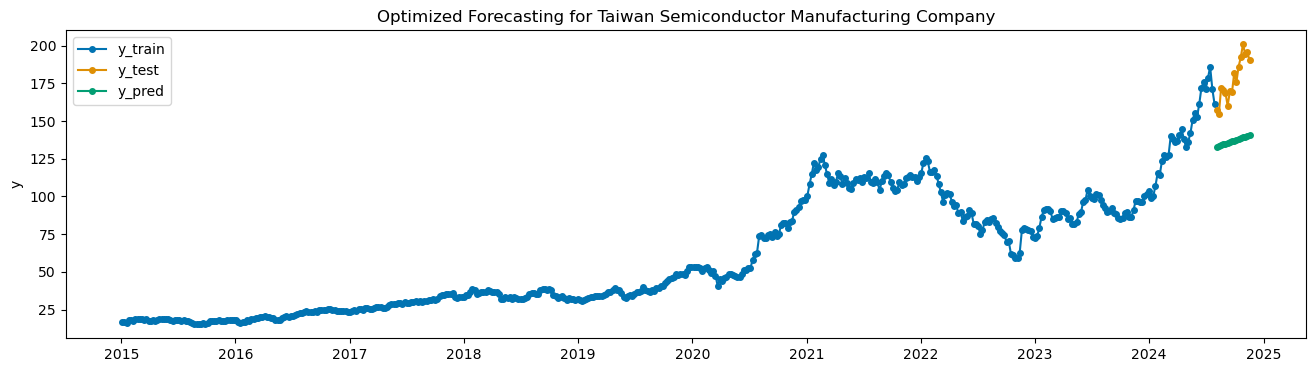

12:55:03 - cmdstanpy - INFO - Chain [1] start processing
12:55:03 - cmdstanpy - INFO - Chain [1] done processing
12:55:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1 of 3136 for Samsung Electronics...


12:55:03 - cmdstanpy - INFO - Chain [1] done processing
12:55:03 - cmdstanpy - INFO - Chain [1] start processing
12:55:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2 of 3136 for Samsung Electronics...


12:55:04 - cmdstanpy - INFO - Chain [1] start processing
12:55:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3 of 3136 for Samsung Electronics...


12:55:04 - cmdstanpy - INFO - Chain [1] start processing
12:55:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 4 of 3136 for Samsung Electronics...
Processing combination 5 of 3136 for Samsung Electronics...


12:55:04 - cmdstanpy - INFO - Chain [1] start processing
12:55:04 - cmdstanpy - INFO - Chain [1] done processing
12:55:04 - cmdstanpy - INFO - Chain [1] start processing
12:55:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 6 of 3136 for Samsung Electronics...


12:55:05 - cmdstanpy - INFO - Chain [1] start processing
12:55:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 7 of 3136 for Samsung Electronics...


12:55:05 - cmdstanpy - INFO - Chain [1] start processing
12:55:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 8 of 3136 for Samsung Electronics...


12:55:05 - cmdstanpy - INFO - Chain [1] start processing
12:55:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 9 of 3136 for Samsung Electronics...


12:55:05 - cmdstanpy - INFO - Chain [1] start processing
12:55:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 10 of 3136 for Samsung Electronics...


12:55:06 - cmdstanpy - INFO - Chain [1] start processing
12:55:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 11 of 3136 for Samsung Electronics...


12:55:06 - cmdstanpy - INFO - Chain [1] start processing
12:55:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 12 of 3136 for Samsung Electronics...


12:55:06 - cmdstanpy - INFO - Chain [1] start processing
12:55:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 13 of 3136 for Samsung Electronics...


12:55:07 - cmdstanpy - INFO - Chain [1] start processing
12:55:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 14 of 3136 for Samsung Electronics...


12:55:07 - cmdstanpy - INFO - Chain [1] start processing
12:55:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 15 of 3136 for Samsung Electronics...


12:55:07 - cmdstanpy - INFO - Chain [1] start processing
12:55:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 16 of 3136 for Samsung Electronics...


12:55:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 17 of 3136 for Samsung Electronics...


12:55:07 - cmdstanpy - INFO - Chain [1] done processing
12:55:08 - cmdstanpy - INFO - Chain [1] start processing
12:55:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 18 of 3136 for Samsung Electronics...


12:55:08 - cmdstanpy - INFO - Chain [1] start processing
12:55:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 19 of 3136 for Samsung Electronics...


12:55:08 - cmdstanpy - INFO - Chain [1] start processing
12:55:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 20 of 3136 for Samsung Electronics...
Processing combination 21 of 3136 for Samsung Electronics...


12:55:08 - cmdstanpy - INFO - Chain [1] start processing
12:55:08 - cmdstanpy - INFO - Chain [1] done processing
12:55:09 - cmdstanpy - INFO - Chain [1] start processing
12:55:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 22 of 3136 for Samsung Electronics...


12:55:09 - cmdstanpy - INFO - Chain [1] start processing
12:55:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 23 of 3136 for Samsung Electronics...


12:55:09 - cmdstanpy - INFO - Chain [1] start processing
12:55:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 24 of 3136 for Samsung Electronics...


12:55:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 25 of 3136 for Samsung Electronics...


12:55:09 - cmdstanpy - INFO - Chain [1] done processing
12:55:10 - cmdstanpy - INFO - Chain [1] start processing
12:55:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 26 of 3136 for Samsung Electronics...


12:55:10 - cmdstanpy - INFO - Chain [1] start processing
12:55:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 27 of 3136 for Samsung Electronics...


12:55:10 - cmdstanpy - INFO - Chain [1] start processing
12:55:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 28 of 3136 for Samsung Electronics...


12:55:10 - cmdstanpy - INFO - Chain [1] start processing
12:55:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 29 of 3136 for Samsung Electronics...


12:55:11 - cmdstanpy - INFO - Chain [1] start processing
12:55:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 30 of 3136 for Samsung Electronics...


12:55:11 - cmdstanpy - INFO - Chain [1] start processing
12:55:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 31 of 3136 for Samsung Electronics...


12:55:11 - cmdstanpy - INFO - Chain [1] start processing
12:55:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 32 of 3136 for Samsung Electronics...
Processing combination 33 of 3136 for Samsung Electronics...


12:55:11 - cmdstanpy - INFO - Chain [1] start processing
12:55:11 - cmdstanpy - INFO - Chain [1] done processing
12:55:12 - cmdstanpy - INFO - Chain [1] start processing
12:55:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 34 of 3136 for Samsung Electronics...


12:55:12 - cmdstanpy - INFO - Chain [1] start processing
12:55:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 35 of 3136 for Samsung Electronics...


12:55:12 - cmdstanpy - INFO - Chain [1] start processing
12:55:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 36 of 3136 for Samsung Electronics...
Processing combination 37 of 3136 for Samsung Electronics...


12:55:12 - cmdstanpy - INFO - Chain [1] start processing
12:55:12 - cmdstanpy - INFO - Chain [1] done processing
12:55:13 - cmdstanpy - INFO - Chain [1] start processing
12:55:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 38 of 3136 for Samsung Electronics...


12:55:13 - cmdstanpy - INFO - Chain [1] start processing
12:55:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 39 of 3136 for Samsung Electronics...


12:55:13 - cmdstanpy - INFO - Chain [1] start processing
12:55:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 40 of 3136 for Samsung Electronics...


12:55:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 41 of 3136 for Samsung Electronics...


12:55:13 - cmdstanpy - INFO - Chain [1] done processing
12:55:14 - cmdstanpy - INFO - Chain [1] start processing
12:55:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 42 of 3136 for Samsung Electronics...


12:55:14 - cmdstanpy - INFO - Chain [1] start processing
12:55:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 43 of 3136 for Samsung Electronics...


12:55:14 - cmdstanpy - INFO - Chain [1] start processing
12:55:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 44 of 3136 for Samsung Electronics...


12:55:14 - cmdstanpy - INFO - Chain [1] start processing
12:55:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 45 of 3136 for Samsung Electronics...


12:55:15 - cmdstanpy - INFO - Chain [1] start processing
12:55:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 46 of 3136 for Samsung Electronics...


12:55:15 - cmdstanpy - INFO - Chain [1] start processing
12:55:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 47 of 3136 for Samsung Electronics...


12:55:15 - cmdstanpy - INFO - Chain [1] start processing
12:55:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 48 of 3136 for Samsung Electronics...
Processing combination 49 of 3136 for Samsung Electronics...


12:55:15 - cmdstanpy - INFO - Chain [1] start processing
12:55:15 - cmdstanpy - INFO - Chain [1] done processing
12:55:16 - cmdstanpy - INFO - Chain [1] start processing
12:55:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 50 of 3136 for Samsung Electronics...


12:55:16 - cmdstanpy - INFO - Chain [1] start processing
12:55:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 51 of 3136 for Samsung Electronics...


12:55:16 - cmdstanpy - INFO - Chain [1] start processing
12:55:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 52 of 3136 for Samsung Electronics...


12:55:16 - cmdstanpy - INFO - Chain [1] start processing
12:55:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 53 of 3136 for Samsung Electronics...


12:55:17 - cmdstanpy - INFO - Chain [1] start processing
12:55:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 54 of 3136 for Samsung Electronics...


12:55:17 - cmdstanpy - INFO - Chain [1] start processing
12:55:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 55 of 3136 for Samsung Electronics...


12:55:17 - cmdstanpy - INFO - Chain [1] start processing
12:55:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 56 of 3136 for Samsung Electronics...


12:55:17 - cmdstanpy - INFO - Chain [1] start processing
12:55:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 57 of 3136 for Samsung Electronics...


12:55:18 - cmdstanpy - INFO - Chain [1] start processing
12:55:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 58 of 3136 for Samsung Electronics...


12:55:18 - cmdstanpy - INFO - Chain [1] start processing
12:55:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 59 of 3136 for Samsung Electronics...


12:55:18 - cmdstanpy - INFO - Chain [1] start processing
12:55:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 60 of 3136 for Samsung Electronics...
Processing combination 61 of 3136 for Samsung Electronics...


12:55:18 - cmdstanpy - INFO - Chain [1] start processing
12:55:19 - cmdstanpy - INFO - Chain [1] done processing
12:55:19 - cmdstanpy - INFO - Chain [1] start processing
12:55:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 62 of 3136 for Samsung Electronics...


12:55:19 - cmdstanpy - INFO - Chain [1] start processing
12:55:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 63 of 3136 for Samsung Electronics...


12:55:19 - cmdstanpy - INFO - Chain [1] start processing
12:55:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 64 of 3136 for Samsung Electronics...
Processing combination 65 of 3136 for Samsung Electronics...


12:55:19 - cmdstanpy - INFO - Chain [1] start processing
12:55:19 - cmdstanpy - INFO - Chain [1] done processing
12:55:20 - cmdstanpy - INFO - Chain [1] start processing
12:55:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 66 of 3136 for Samsung Electronics...
Processing combination 67 of 3136 for Samsung Electronics...


12:55:20 - cmdstanpy - INFO - Chain [1] start processing
12:55:20 - cmdstanpy - INFO - Chain [1] done processing
12:55:20 - cmdstanpy - INFO - Chain [1] start processing
12:55:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 68 of 3136 for Samsung Electronics...


12:55:20 - cmdstanpy - INFO - Chain [1] start processing
12:55:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 69 of 3136 for Samsung Electronics...


12:55:21 - cmdstanpy - INFO - Chain [1] start processing
12:55:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 70 of 3136 for Samsung Electronics...


12:55:21 - cmdstanpy - INFO - Chain [1] start processing
12:55:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 71 of 3136 for Samsung Electronics...


12:55:21 - cmdstanpy - INFO - Chain [1] start processing
12:55:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 72 of 3136 for Samsung Electronics...
Processing combination 73 of 3136 for Samsung Electronics...


12:55:21 - cmdstanpy - INFO - Chain [1] start processing
12:55:22 - cmdstanpy - INFO - Chain [1] done processing
12:55:22 - cmdstanpy - INFO - Chain [1] start processing
12:55:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 74 of 3136 for Samsung Electronics...


12:55:22 - cmdstanpy - INFO - Chain [1] start processing
12:55:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 75 of 3136 for Samsung Electronics...


12:55:22 - cmdstanpy - INFO - Chain [1] start processing
12:55:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 76 of 3136 for Samsung Electronics...


12:55:22 - cmdstanpy - INFO - Chain [1] start processing
12:55:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 77 of 3136 for Samsung Electronics...


12:55:23 - cmdstanpy - INFO - Chain [1] start processing
12:55:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 78 of 3136 for Samsung Electronics...


12:55:23 - cmdstanpy - INFO - Chain [1] start processing
12:55:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 79 of 3136 for Samsung Electronics...


12:55:23 - cmdstanpy - INFO - Chain [1] start processing
12:55:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 80 of 3136 for Samsung Electronics...
Processing combination 81 of 3136 for Samsung Electronics...


12:55:23 - cmdstanpy - INFO - Chain [1] start processing
12:55:23 - cmdstanpy - INFO - Chain [1] done processing
12:55:24 - cmdstanpy - INFO - Chain [1] start processing
12:55:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 82 of 3136 for Samsung Electronics...


12:55:24 - cmdstanpy - INFO - Chain [1] start processing
12:55:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 83 of 3136 for Samsung Electronics...


12:55:24 - cmdstanpy - INFO - Chain [1] start processing
12:55:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 84 of 3136 for Samsung Electronics...
Processing combination 85 of 3136 for Samsung Electronics...


12:55:24 - cmdstanpy - INFO - Chain [1] start processing
12:55:25 - cmdstanpy - INFO - Chain [1] done processing
12:55:25 - cmdstanpy - INFO - Chain [1] start processing
12:55:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 86 of 3136 for Samsung Electronics...


12:55:25 - cmdstanpy - INFO - Chain [1] start processing
12:55:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 87 of 3136 for Samsung Electronics...


12:55:25 - cmdstanpy - INFO - Chain [1] start processing
12:55:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 88 of 3136 for Samsung Electronics...


12:55:25 - cmdstanpy - INFO - Chain [1] start processing
12:55:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 89 of 3136 for Samsung Electronics...


12:55:26 - cmdstanpy - INFO - Chain [1] start processing
12:55:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 90 of 3136 for Samsung Electronics...


12:55:26 - cmdstanpy - INFO - Chain [1] start processing
12:55:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 91 of 3136 for Samsung Electronics...


12:55:26 - cmdstanpy - INFO - Chain [1] start processing
12:55:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 92 of 3136 for Samsung Electronics...


12:55:26 - cmdstanpy - INFO - Chain [1] start processing
12:55:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 93 of 3136 for Samsung Electronics...


12:55:27 - cmdstanpy - INFO - Chain [1] start processing
12:55:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 94 of 3136 for Samsung Electronics...


12:55:27 - cmdstanpy - INFO - Chain [1] start processing
12:55:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 95 of 3136 for Samsung Electronics...


12:55:27 - cmdstanpy - INFO - Chain [1] start processing
12:55:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 96 of 3136 for Samsung Electronics...


12:55:27 - cmdstanpy - INFO - Chain [1] start processing
12:55:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 97 of 3136 for Samsung Electronics...


12:55:28 - cmdstanpy - INFO - Chain [1] start processing
12:55:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 98 of 3136 for Samsung Electronics...


12:55:28 - cmdstanpy - INFO - Chain [1] start processing
12:55:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 99 of 3136 for Samsung Electronics...


12:55:28 - cmdstanpy - INFO - Chain [1] start processing
12:55:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 100 of 3136 for Samsung Electronics...


12:55:28 - cmdstanpy - INFO - Chain [1] start processing
12:55:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 101 of 3136 for Samsung Electronics...


12:55:29 - cmdstanpy - INFO - Chain [1] start processing
12:55:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 102 of 3136 for Samsung Electronics...


12:55:29 - cmdstanpy - INFO - Chain [1] start processing
12:55:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 103 of 3136 for Samsung Electronics...


12:55:29 - cmdstanpy - INFO - Chain [1] start processing
12:55:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 104 of 3136 for Samsung Electronics...


12:55:30 - cmdstanpy - INFO - Chain [1] start processing
12:55:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 105 of 3136 for Samsung Electronics...


12:55:30 - cmdstanpy - INFO - Chain [1] start processing
12:55:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 106 of 3136 for Samsung Electronics...


12:55:30 - cmdstanpy - INFO - Chain [1] start processing
12:55:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 107 of 3136 for Samsung Electronics...


12:55:30 - cmdstanpy - INFO - Chain [1] start processing
12:55:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 108 of 3136 for Samsung Electronics...
Processing combination 109 of 3136 for Samsung Electronics...


12:55:30 - cmdstanpy - INFO - Chain [1] start processing
12:55:31 - cmdstanpy - INFO - Chain [1] done processing
12:55:31 - cmdstanpy - INFO - Chain [1] start processing
12:55:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 110 of 3136 for Samsung Electronics...


12:55:31 - cmdstanpy - INFO - Chain [1] start processing
12:55:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 111 of 3136 for Samsung Electronics...


12:55:31 - cmdstanpy - INFO - Chain [1] start processing
12:55:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 112 of 3136 for Samsung Electronics...


12:55:31 - cmdstanpy - INFO - Chain [1] start processing
12:55:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 113 of 3136 for Samsung Electronics...


12:55:32 - cmdstanpy - INFO - Chain [1] start processing
12:55:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 114 of 3136 for Samsung Electronics...


12:55:32 - cmdstanpy - INFO - Chain [1] start processing
12:55:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 115 of 3136 for Samsung Electronics...


12:55:32 - cmdstanpy - INFO - Chain [1] start processing
12:55:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 116 of 3136 for Samsung Electronics...
Processing combination 117 of 3136 for Samsung Electronics...


12:55:32 - cmdstanpy - INFO - Chain [1] start processing
12:55:32 - cmdstanpy - INFO - Chain [1] done processing
12:55:33 - cmdstanpy - INFO - Chain [1] start processing
12:55:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 118 of 3136 for Samsung Electronics...
Processing combination 119 of 3136 for Samsung Electronics...


12:55:33 - cmdstanpy - INFO - Chain [1] start processing
12:55:33 - cmdstanpy - INFO - Chain [1] done processing
12:55:33 - cmdstanpy - INFO - Chain [1] start processing
12:55:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 120 of 3136 for Samsung Electronics...
Processing combination 121 of 3136 for Samsung Electronics...


12:55:33 - cmdstanpy - INFO - Chain [1] start processing
12:55:33 - cmdstanpy - INFO - Chain [1] done processing
12:55:34 - cmdstanpy - INFO - Chain [1] start processing
12:55:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 122 of 3136 for Samsung Electronics...


12:55:34 - cmdstanpy - INFO - Chain [1] start processing
12:55:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 123 of 3136 for Samsung Electronics...


12:55:34 - cmdstanpy - INFO - Chain [1] start processing
12:55:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 124 of 3136 for Samsung Electronics...
Processing combination 125 of 3136 for Samsung Electronics...


12:55:34 - cmdstanpy - INFO - Chain [1] start processing
12:55:34 - cmdstanpy - INFO - Chain [1] done processing
12:55:34 - cmdstanpy - INFO - Chain [1] start processing
12:55:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 126 of 3136 for Samsung Electronics...
Processing combination 127 of 3136 for Samsung Electronics...


12:55:35 - cmdstanpy - INFO - Chain [1] start processing
12:55:35 - cmdstanpy - INFO - Chain [1] done processing
12:55:35 - cmdstanpy - INFO - Chain [1] start processing
12:55:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 128 of 3136 for Samsung Electronics...
Processing combination 129 of 3136 for Samsung Electronics...


12:55:35 - cmdstanpy - INFO - Chain [1] start processing
12:55:35 - cmdstanpy - INFO - Chain [1] done processing
12:55:35 - cmdstanpy - INFO - Chain [1] start processing
12:55:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 130 of 3136 for Samsung Electronics...
Processing combination 131 of 3136 for Samsung Electronics...


12:55:36 - cmdstanpy - INFO - Chain [1] start processing
12:55:36 - cmdstanpy - INFO - Chain [1] done processing
12:55:36 - cmdstanpy - INFO - Chain [1] start processing
12:55:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 132 of 3136 for Samsung Electronics...
Processing combination 133 of 3136 for Samsung Electronics...


12:55:36 - cmdstanpy - INFO - Chain [1] start processing
12:55:36 - cmdstanpy - INFO - Chain [1] done processing
12:55:36 - cmdstanpy - INFO - Chain [1] start processing
12:55:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 134 of 3136 for Samsung Electronics...


12:55:36 - cmdstanpy - INFO - Chain [1] start processing
12:55:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 135 of 3136 for Samsung Electronics...


12:55:37 - cmdstanpy - INFO - Chain [1] start processing
12:55:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 136 of 3136 for Samsung Electronics...
Processing combination 137 of 3136 for Samsung Electronics...


12:55:37 - cmdstanpy - INFO - Chain [1] start processing
12:55:37 - cmdstanpy - INFO - Chain [1] done processing
12:55:37 - cmdstanpy - INFO - Chain [1] start processing
12:55:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 138 of 3136 for Samsung Electronics...
Processing combination 139 of 3136 for Samsung Electronics...


12:55:37 - cmdstanpy - INFO - Chain [1] start processing
12:55:37 - cmdstanpy - INFO - Chain [1] done processing
12:55:38 - cmdstanpy - INFO - Chain [1] start processing
12:55:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 140 of 3136 for Samsung Electronics...
Processing combination 141 of 3136 for Samsung Electronics...


12:55:38 - cmdstanpy - INFO - Chain [1] start processing
12:55:38 - cmdstanpy - INFO - Chain [1] done processing
12:55:38 - cmdstanpy - INFO - Chain [1] start processing
12:55:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 142 of 3136 for Samsung Electronics...


12:55:38 - cmdstanpy - INFO - Chain [1] start processing
12:55:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 143 of 3136 for Samsung Electronics...


12:55:38 - cmdstanpy - INFO - Chain [1] start processing
12:55:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 144 of 3136 for Samsung Electronics...
Processing combination 145 of 3136 for Samsung Electronics...


12:55:39 - cmdstanpy - INFO - Chain [1] start processing
12:55:39 - cmdstanpy - INFO - Chain [1] done processing
12:55:39 - cmdstanpy - INFO - Chain [1] start processing
12:55:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 146 of 3136 for Samsung Electronics...


12:55:39 - cmdstanpy - INFO - Chain [1] start processing
12:55:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 147 of 3136 for Samsung Electronics...


12:55:39 - cmdstanpy - INFO - Chain [1] start processing
12:55:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 148 of 3136 for Samsung Electronics...
Processing combination 149 of 3136 for Samsung Electronics...


12:55:40 - cmdstanpy - INFO - Chain [1] start processing
12:55:40 - cmdstanpy - INFO - Chain [1] done processing
12:55:40 - cmdstanpy - INFO - Chain [1] start processing
12:55:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 150 of 3136 for Samsung Electronics...
Processing combination 151 of 3136 for Samsung Electronics...


12:55:40 - cmdstanpy - INFO - Chain [1] start processing
12:55:40 - cmdstanpy - INFO - Chain [1] done processing
12:55:40 - cmdstanpy - INFO - Chain [1] start processing
12:55:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 152 of 3136 for Samsung Electronics...
Processing combination 153 of 3136 for Samsung Electronics...


12:55:40 - cmdstanpy - INFO - Chain [1] start processing
12:55:41 - cmdstanpy - INFO - Chain [1] done processing
12:55:41 - cmdstanpy - INFO - Chain [1] start processing
12:55:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 154 of 3136 for Samsung Electronics...


12:55:41 - cmdstanpy - INFO - Chain [1] start processing
12:55:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 155 of 3136 for Samsung Electronics...


12:55:41 - cmdstanpy - INFO - Chain [1] start processing
12:55:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 156 of 3136 for Samsung Electronics...
Processing combination 157 of 3136 for Samsung Electronics...


12:55:41 - cmdstanpy - INFO - Chain [1] start processing
12:55:41 - cmdstanpy - INFO - Chain [1] done processing
12:55:42 - cmdstanpy - INFO - Chain [1] start processing
12:55:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 158 of 3136 for Samsung Electronics...


12:55:42 - cmdstanpy - INFO - Chain [1] start processing
12:55:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 159 of 3136 for Samsung Electronics...


12:55:42 - cmdstanpy - INFO - Chain [1] start processing
12:55:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 160 of 3136 for Samsung Electronics...
Processing combination 161 of 3136 for Samsung Electronics...


12:55:42 - cmdstanpy - INFO - Chain [1] start processing
12:55:42 - cmdstanpy - INFO - Chain [1] done processing
12:55:43 - cmdstanpy - INFO - Chain [1] start processing
12:55:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 162 of 3136 for Samsung Electronics...


12:55:43 - cmdstanpy - INFO - Chain [1] start processing
12:55:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 163 of 3136 for Samsung Electronics...


12:55:43 - cmdstanpy - INFO - Chain [1] start processing
12:55:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 164 of 3136 for Samsung Electronics...
Processing combination 165 of 3136 for Samsung Electronics...


12:55:43 - cmdstanpy - INFO - Chain [1] start processing
12:55:43 - cmdstanpy - INFO - Chain [1] done processing
12:55:43 - cmdstanpy - INFO - Chain [1] start processing
12:55:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 166 of 3136 for Samsung Electronics...


12:55:44 - cmdstanpy - INFO - Chain [1] start processing
12:55:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 167 of 3136 for Samsung Electronics...
Processing combination 168 of 3136 for Samsung Electronics...


12:55:44 - cmdstanpy - INFO - Chain [1] start processing
12:55:44 - cmdstanpy - INFO - Chain [1] done processing
12:55:44 - cmdstanpy - INFO - Chain [1] start processing
12:55:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 169 of 3136 for Samsung Electronics...


12:55:44 - cmdstanpy - INFO - Chain [1] start processing
12:55:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 170 of 3136 for Samsung Electronics...
Processing combination 171 of 3136 for Samsung Electronics...


12:55:45 - cmdstanpy - INFO - Chain [1] start processing
12:55:45 - cmdstanpy - INFO - Chain [1] done processing
12:55:45 - cmdstanpy - INFO - Chain [1] start processing
12:55:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 172 of 3136 for Samsung Electronics...
Processing combination 173 of 3136 for Samsung Electronics...


12:55:45 - cmdstanpy - INFO - Chain [1] start processing
12:55:45 - cmdstanpy - INFO - Chain [1] done processing
12:55:45 - cmdstanpy - INFO - Chain [1] start processing
12:55:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 174 of 3136 for Samsung Electronics...
Processing combination 175 of 3136 for Samsung Electronics...


12:55:45 - cmdstanpy - INFO - Chain [1] start processing
12:55:45 - cmdstanpy - INFO - Chain [1] done processing
12:55:46 - cmdstanpy - INFO - Chain [1] start processing
12:55:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 176 of 3136 for Samsung Electronics...
Processing combination 177 of 3136 for Samsung Electronics...


12:55:46 - cmdstanpy - INFO - Chain [1] start processing
12:55:46 - cmdstanpy - INFO - Chain [1] done processing
12:55:46 - cmdstanpy - INFO - Chain [1] start processing
12:55:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 178 of 3136 for Samsung Electronics...


12:55:46 - cmdstanpy - INFO - Chain [1] start processing
12:55:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 179 of 3136 for Samsung Electronics...


12:55:47 - cmdstanpy - INFO - Chain [1] start processing
12:55:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 180 of 3136 for Samsung Electronics...
Processing combination 181 of 3136 for Samsung Electronics...


12:55:47 - cmdstanpy - INFO - Chain [1] start processing
12:55:47 - cmdstanpy - INFO - Chain [1] done processing
12:55:47 - cmdstanpy - INFO - Chain [1] start processing
12:55:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 182 of 3136 for Samsung Electronics...
Processing combination 183 of 3136 for Samsung Electronics...


12:55:47 - cmdstanpy - INFO - Chain [1] start processing
12:55:47 - cmdstanpy - INFO - Chain [1] done processing
12:55:47 - cmdstanpy - INFO - Chain [1] start processing
12:55:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 184 of 3136 for Samsung Electronics...
Processing combination 185 of 3136 for Samsung Electronics...


12:55:48 - cmdstanpy - INFO - Chain [1] start processing
12:55:48 - cmdstanpy - INFO - Chain [1] done processing
12:55:48 - cmdstanpy - INFO - Chain [1] start processing
12:55:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 186 of 3136 for Samsung Electronics...
Processing combination 187 of 3136 for Samsung Electronics...


12:55:48 - cmdstanpy - INFO - Chain [1] start processing
12:55:48 - cmdstanpy - INFO - Chain [1] done processing
12:55:48 - cmdstanpy - INFO - Chain [1] start processing
12:55:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 188 of 3136 for Samsung Electronics...
Processing combination 189 of 3136 for Samsung Electronics...


12:55:49 - cmdstanpy - INFO - Chain [1] start processing
12:55:49 - cmdstanpy - INFO - Chain [1] done processing
12:55:49 - cmdstanpy - INFO - Chain [1] start processing
12:55:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 190 of 3136 for Samsung Electronics...


12:55:49 - cmdstanpy - INFO - Chain [1] start processing
12:55:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 191 of 3136 for Samsung Electronics...


12:55:49 - cmdstanpy - INFO - Chain [1] start processing
12:55:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 192 of 3136 for Samsung Electronics...
Processing combination 193 of 3136 for Samsung Electronics...


12:55:49 - cmdstanpy - INFO - Chain [1] start processing
12:55:50 - cmdstanpy - INFO - Chain [1] done processing
12:55:50 - cmdstanpy - INFO - Chain [1] start processing
12:55:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 194 of 3136 for Samsung Electronics...


12:55:50 - cmdstanpy - INFO - Chain [1] start processing
12:55:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 195 of 3136 for Samsung Electronics...


12:55:50 - cmdstanpy - INFO - Chain [1] start processing
12:55:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 196 of 3136 for Samsung Electronics...
Processing combination 197 of 3136 for Samsung Electronics...


12:55:50 - cmdstanpy - INFO - Chain [1] start processing
12:55:50 - cmdstanpy - INFO - Chain [1] done processing
12:55:51 - cmdstanpy - INFO - Chain [1] start processing
12:55:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 198 of 3136 for Samsung Electronics...
Processing combination 199 of 3136 for Samsung Electronics...


12:55:51 - cmdstanpy - INFO - Chain [1] start processing
12:55:51 - cmdstanpy - INFO - Chain [1] done processing
12:55:51 - cmdstanpy - INFO - Chain [1] start processing
12:55:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 200 of 3136 for Samsung Electronics...
Processing combination 201 of 3136 for Samsung Electronics...


12:55:51 - cmdstanpy - INFO - Chain [1] start processing
12:55:51 - cmdstanpy - INFO - Chain [1] done processing
12:55:52 - cmdstanpy - INFO - Chain [1] start processing
12:55:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 202 of 3136 for Samsung Electronics...
Processing combination 203 of 3136 for Samsung Electronics...


12:55:52 - cmdstanpy - INFO - Chain [1] start processing
12:55:52 - cmdstanpy - INFO - Chain [1] done processing
12:55:52 - cmdstanpy - INFO - Chain [1] start processing
12:55:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 204 of 3136 for Samsung Electronics...
Processing combination 205 of 3136 for Samsung Electronics...


12:55:52 - cmdstanpy - INFO - Chain [1] start processing
12:55:52 - cmdstanpy - INFO - Chain [1] done processing
12:55:52 - cmdstanpy - INFO - Chain [1] start processing
12:55:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 206 of 3136 for Samsung Electronics...
Processing combination 207 of 3136 for Samsung Electronics...


12:55:53 - cmdstanpy - INFO - Chain [1] start processing
12:55:53 - cmdstanpy - INFO - Chain [1] done processing
12:55:53 - cmdstanpy - INFO - Chain [1] start processing
12:55:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 208 of 3136 for Samsung Electronics...
Processing combination 209 of 3136 for Samsung Electronics...


12:55:53 - cmdstanpy - INFO - Chain [1] start processing
12:55:53 - cmdstanpy - INFO - Chain [1] done processing
12:55:53 - cmdstanpy - INFO - Chain [1] start processing
12:55:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 210 of 3136 for Samsung Electronics...


12:55:54 - cmdstanpy - INFO - Chain [1] start processing
12:55:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 211 of 3136 for Samsung Electronics...


12:55:54 - cmdstanpy - INFO - Chain [1] start processing
12:55:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 212 of 3136 for Samsung Electronics...
Processing combination 213 of 3136 for Samsung Electronics...


12:55:54 - cmdstanpy - INFO - Chain [1] start processing
12:55:54 - cmdstanpy - INFO - Chain [1] done processing
12:55:54 - cmdstanpy - INFO - Chain [1] start processing
12:55:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 214 of 3136 for Samsung Electronics...
Processing combination 215 of 3136 for Samsung Electronics...


12:55:54 - cmdstanpy - INFO - Chain [1] start processing
12:55:54 - cmdstanpy - INFO - Chain [1] done processing
12:55:55 - cmdstanpy - INFO - Chain [1] start processing
12:55:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 216 of 3136 for Samsung Electronics...
Processing combination 217 of 3136 for Samsung Electronics...


12:55:55 - cmdstanpy - INFO - Chain [1] start processing
12:55:55 - cmdstanpy - INFO - Chain [1] done processing
12:55:55 - cmdstanpy - INFO - Chain [1] start processing
12:55:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 218 of 3136 for Samsung Electronics...
Processing combination 219 of 3136 for Samsung Electronics...


12:55:55 - cmdstanpy - INFO - Chain [1] start processing
12:55:55 - cmdstanpy - INFO - Chain [1] done processing
12:55:56 - cmdstanpy - INFO - Chain [1] start processing
12:55:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 220 of 3136 for Samsung Electronics...
Processing combination 221 of 3136 for Samsung Electronics...


12:55:56 - cmdstanpy - INFO - Chain [1] start processing
12:55:56 - cmdstanpy - INFO - Chain [1] done processing
12:55:56 - cmdstanpy - INFO - Chain [1] start processing
12:55:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 222 of 3136 for Samsung Electronics...
Processing combination 223 of 3136 for Samsung Electronics...


12:55:56 - cmdstanpy - INFO - Chain [1] start processing
12:55:56 - cmdstanpy - INFO - Chain [1] done processing
12:55:56 - cmdstanpy - INFO - Chain [1] start processing
12:55:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 224 of 3136 for Samsung Electronics...
Processing combination 225 of 3136 for Samsung Electronics...


12:55:57 - cmdstanpy - INFO - Chain [1] start processing
12:55:57 - cmdstanpy - INFO - Chain [1] done processing
12:55:57 - cmdstanpy - INFO - Chain [1] start processing
12:55:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 226 of 3136 for Samsung Electronics...


12:55:57 - cmdstanpy - INFO - Chain [1] start processing
12:55:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 227 of 3136 for Samsung Electronics...


12:55:57 - cmdstanpy - INFO - Chain [1] start processing
12:55:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 228 of 3136 for Samsung Electronics...


12:55:58 - cmdstanpy - INFO - Chain [1] start processing
12:55:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 229 of 3136 for Samsung Electronics...


12:55:58 - cmdstanpy - INFO - Chain [1] start processing
12:55:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 230 of 3136 for Samsung Electronics...


12:55:58 - cmdstanpy - INFO - Chain [1] start processing
12:55:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 231 of 3136 for Samsung Electronics...


12:55:58 - cmdstanpy - INFO - Chain [1] start processing
12:55:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 232 of 3136 for Samsung Electronics...


12:55:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 233 of 3136 for Samsung Electronics...


12:55:59 - cmdstanpy - INFO - Chain [1] done processing
12:55:59 - cmdstanpy - INFO - Chain [1] start processing
12:55:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 234 of 3136 for Samsung Electronics...


12:55:59 - cmdstanpy - INFO - Chain [1] start processing
12:55:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 235 of 3136 for Samsung Electronics...


12:56:00 - cmdstanpy - INFO - Chain [1] start processing
12:56:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 236 of 3136 for Samsung Electronics...
Processing combination 237 of 3136 for Samsung Electronics...


12:56:00 - cmdstanpy - INFO - Chain [1] start processing
12:56:00 - cmdstanpy - INFO - Chain [1] done processing
12:56:00 - cmdstanpy - INFO - Chain [1] start processing
12:56:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 238 of 3136 for Samsung Electronics...


12:56:00 - cmdstanpy - INFO - Chain [1] start processing
12:56:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 239 of 3136 for Samsung Electronics...


12:56:01 - cmdstanpy - INFO - Chain [1] start processing
12:56:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 240 of 3136 for Samsung Electronics...


12:56:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 241 of 3136 for Samsung Electronics...


12:56:01 - cmdstanpy - INFO - Chain [1] done processing
12:56:01 - cmdstanpy - INFO - Chain [1] start processing
12:56:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 242 of 3136 for Samsung Electronics...


12:56:01 - cmdstanpy - INFO - Chain [1] start processing
12:56:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 243 of 3136 for Samsung Electronics...


12:56:02 - cmdstanpy - INFO - Chain [1] start processing
12:56:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 244 of 3136 for Samsung Electronics...


12:56:02 - cmdstanpy - INFO - Chain [1] start processing
12:56:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 245 of 3136 for Samsung Electronics...


12:56:02 - cmdstanpy - INFO - Chain [1] start processing
12:56:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 246 of 3136 for Samsung Electronics...


12:56:03 - cmdstanpy - INFO - Chain [1] start processing
12:56:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 247 of 3136 for Samsung Electronics...


12:56:03 - cmdstanpy - INFO - Chain [1] start processing
12:56:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 248 of 3136 for Samsung Electronics...


12:56:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 249 of 3136 for Samsung Electronics...


12:56:03 - cmdstanpy - INFO - Chain [1] done processing
12:56:03 - cmdstanpy - INFO - Chain [1] start processing
12:56:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 250 of 3136 for Samsung Electronics...


12:56:04 - cmdstanpy - INFO - Chain [1] start processing
12:56:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 251 of 3136 for Samsung Electronics...


12:56:04 - cmdstanpy - INFO - Chain [1] start processing
12:56:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 252 of 3136 for Samsung Electronics...


12:56:04 - cmdstanpy - INFO - Chain [1] start processing
12:56:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 253 of 3136 for Samsung Electronics...


12:56:04 - cmdstanpy - INFO - Chain [1] start processing
12:56:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 254 of 3136 for Samsung Electronics...


12:56:05 - cmdstanpy - INFO - Chain [1] start processing
12:56:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 255 of 3136 for Samsung Electronics...


12:56:05 - cmdstanpy - INFO - Chain [1] start processing
12:56:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 256 of 3136 for Samsung Electronics...


12:56:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 257 of 3136 for Samsung Electronics...


12:56:05 - cmdstanpy - INFO - Chain [1] done processing
12:56:05 - cmdstanpy - INFO - Chain [1] start processing
12:56:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 258 of 3136 for Samsung Electronics...


12:56:06 - cmdstanpy - INFO - Chain [1] start processing
12:56:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 259 of 3136 for Samsung Electronics...


12:56:06 - cmdstanpy - INFO - Chain [1] start processing
12:56:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 260 of 3136 for Samsung Electronics...


12:56:06 - cmdstanpy - INFO - Chain [1] start processing
12:56:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 261 of 3136 for Samsung Electronics...


12:56:06 - cmdstanpy - INFO - Chain [1] start processing
12:56:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 262 of 3136 for Samsung Electronics...


12:56:07 - cmdstanpy - INFO - Chain [1] start processing
12:56:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 263 of 3136 for Samsung Electronics...


12:56:07 - cmdstanpy - INFO - Chain [1] start processing
12:56:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 264 of 3136 for Samsung Electronics...


12:56:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 265 of 3136 for Samsung Electronics...


12:56:07 - cmdstanpy - INFO - Chain [1] done processing
12:56:08 - cmdstanpy - INFO - Chain [1] start processing
12:56:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 266 of 3136 for Samsung Electronics...


12:56:08 - cmdstanpy - INFO - Chain [1] start processing
12:56:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 267 of 3136 for Samsung Electronics...


12:56:08 - cmdstanpy - INFO - Chain [1] start processing
12:56:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 268 of 3136 for Samsung Electronics...


12:56:08 - cmdstanpy - INFO - Chain [1] start processing
12:56:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 269 of 3136 for Samsung Electronics...


12:56:09 - cmdstanpy - INFO - Chain [1] start processing
12:56:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 270 of 3136 for Samsung Electronics...


12:56:09 - cmdstanpy - INFO - Chain [1] start processing
12:56:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 271 of 3136 for Samsung Electronics...


12:56:09 - cmdstanpy - INFO - Chain [1] start processing
12:56:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 272 of 3136 for Samsung Electronics...


12:56:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 273 of 3136 for Samsung Electronics...


12:56:09 - cmdstanpy - INFO - Chain [1] done processing
12:56:10 - cmdstanpy - INFO - Chain [1] start processing
12:56:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 274 of 3136 for Samsung Electronics...


12:56:10 - cmdstanpy - INFO - Chain [1] start processing
12:56:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 275 of 3136 for Samsung Electronics...


12:56:10 - cmdstanpy - INFO - Chain [1] start processing
12:56:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 276 of 3136 for Samsung Electronics...
Processing combination 277 of 3136 for Samsung Electronics...


12:56:10 - cmdstanpy - INFO - Chain [1] start processing
12:56:10 - cmdstanpy - INFO - Chain [1] done processing
12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 278 of 3136 for Samsung Electronics...


12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 279 of 3136 for Samsung Electronics...


12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 280 of 3136 for Samsung Electronics...


12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 281 of 3136 for Samsung Electronics...


12:56:12 - cmdstanpy - INFO - Chain [1] start processing
12:56:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 282 of 3136 for Samsung Electronics...


12:56:12 - cmdstanpy - INFO - Chain [1] start processing
12:56:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 283 of 3136 for Samsung Electronics...


12:56:12 - cmdstanpy - INFO - Chain [1] start processing
12:56:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 284 of 3136 for Samsung Electronics...
Processing combination 285 of 3136 for Samsung Electronics...


12:56:12 - cmdstanpy - INFO - Chain [1] start processing
12:56:13 - cmdstanpy - INFO - Chain [1] done processing
12:56:13 - cmdstanpy - INFO - Chain [1] start processing
12:56:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 286 of 3136 for Samsung Electronics...


12:56:13 - cmdstanpy - INFO - Chain [1] start processing
12:56:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 287 of 3136 for Samsung Electronics...


12:56:13 - cmdstanpy - INFO - Chain [1] start processing
12:56:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 288 of 3136 for Samsung Electronics...


12:56:14 - cmdstanpy - INFO - Chain [1] start processing
12:56:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 289 of 3136 for Samsung Electronics...


12:56:14 - cmdstanpy - INFO - Chain [1] start processing
12:56:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 290 of 3136 for Samsung Electronics...


12:56:14 - cmdstanpy - INFO - Chain [1] start processing
12:56:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 291 of 3136 for Samsung Electronics...


12:56:14 - cmdstanpy - INFO - Chain [1] start processing
12:56:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 292 of 3136 for Samsung Electronics...


12:56:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 293 of 3136 for Samsung Electronics...


12:56:15 - cmdstanpy - INFO - Chain [1] done processing
12:56:15 - cmdstanpy - INFO - Chain [1] start processing
12:56:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 294 of 3136 for Samsung Electronics...


12:56:15 - cmdstanpy - INFO - Chain [1] start processing
12:56:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 295 of 3136 for Samsung Electronics...


12:56:15 - cmdstanpy - INFO - Chain [1] start processing
12:56:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 296 of 3136 for Samsung Electronics...


12:56:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 297 of 3136 for Samsung Electronics...


12:56:16 - cmdstanpy - INFO - Chain [1] done processing
12:56:16 - cmdstanpy - INFO - Chain [1] start processing
12:56:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 298 of 3136 for Samsung Electronics...


12:56:16 - cmdstanpy - INFO - Chain [1] start processing
12:56:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 299 of 3136 for Samsung Electronics...


12:56:16 - cmdstanpy - INFO - Chain [1] start processing
12:56:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 300 of 3136 for Samsung Electronics...


12:56:17 - cmdstanpy - INFO - Chain [1] start processing
12:56:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 301 of 3136 for Samsung Electronics...


12:56:17 - cmdstanpy - INFO - Chain [1] start processing
12:56:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 302 of 3136 for Samsung Electronics...


12:56:17 - cmdstanpy - INFO - Chain [1] start processing
12:56:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 303 of 3136 for Samsung Electronics...


12:56:17 - cmdstanpy - INFO - Chain [1] start processing
12:56:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 304 of 3136 for Samsung Electronics...


12:56:18 - cmdstanpy - INFO - Chain [1] start processing
12:56:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 305 of 3136 for Samsung Electronics...


12:56:18 - cmdstanpy - INFO - Chain [1] start processing
12:56:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 306 of 3136 for Samsung Electronics...


12:56:18 - cmdstanpy - INFO - Chain [1] start processing
12:56:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 307 of 3136 for Samsung Electronics...


12:56:18 - cmdstanpy - INFO - Chain [1] start processing
12:56:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 308 of 3136 for Samsung Electronics...
Processing combination 309 of 3136 for Samsung Electronics...


12:56:19 - cmdstanpy - INFO - Chain [1] start processing
12:56:19 - cmdstanpy - INFO - Chain [1] done processing
12:56:19 - cmdstanpy - INFO - Chain [1] start processing
12:56:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 310 of 3136 for Samsung Electronics...


12:56:19 - cmdstanpy - INFO - Chain [1] start processing
12:56:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 311 of 3136 for Samsung Electronics...


12:56:20 - cmdstanpy - INFO - Chain [1] start processing
12:56:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 312 of 3136 for Samsung Electronics...


12:56:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 313 of 3136 for Samsung Electronics...


12:56:20 - cmdstanpy - INFO - Chain [1] done processing
12:56:20 - cmdstanpy - INFO - Chain [1] start processing
12:56:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 314 of 3136 for Samsung Electronics...


12:56:20 - cmdstanpy - INFO - Chain [1] start processing
12:56:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 315 of 3136 for Samsung Electronics...


12:56:21 - cmdstanpy - INFO - Chain [1] start processing
12:56:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 316 of 3136 for Samsung Electronics...


12:56:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 317 of 3136 for Samsung Electronics...


12:56:21 - cmdstanpy - INFO - Chain [1] done processing
12:56:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 318 of 3136 for Samsung Electronics...


12:56:22 - cmdstanpy - INFO - Chain [1] done processing
12:56:22 - cmdstanpy - INFO - Chain [1] start processing
12:56:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 319 of 3136 for Samsung Electronics...


12:56:22 - cmdstanpy - INFO - Chain [1] start processing
12:56:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 320 of 3136 for Samsung Electronics...


12:56:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 321 of 3136 for Samsung Electronics...


12:56:22 - cmdstanpy - INFO - Chain [1] done processing
12:56:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 322 of 3136 for Samsung Electronics...


12:56:23 - cmdstanpy - INFO - Chain [1] done processing
12:56:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 323 of 3136 for Samsung Electronics...


12:56:23 - cmdstanpy - INFO - Chain [1] done processing
12:56:23 - cmdstanpy - INFO - Chain [1] start processing
12:56:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 324 of 3136 for Samsung Electronics...


12:56:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 325 of 3136 for Samsung Electronics...


12:56:24 - cmdstanpy - INFO - Chain [1] done processing
12:56:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 326 of 3136 for Samsung Electronics...


12:56:24 - cmdstanpy - INFO - Chain [1] done processing
12:56:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 327 of 3136 for Samsung Electronics...


12:56:24 - cmdstanpy - INFO - Chain [1] done processing
12:56:25 - cmdstanpy - INFO - Chain [1] start processing
12:56:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 328 of 3136 for Samsung Electronics...


12:56:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 329 of 3136 for Samsung Electronics...


12:56:25 - cmdstanpy - INFO - Chain [1] done processing
12:56:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 330 of 3136 for Samsung Electronics...


12:56:25 - cmdstanpy - INFO - Chain [1] done processing
12:56:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 331 of 3136 for Samsung Electronics...


12:56:26 - cmdstanpy - INFO - Chain [1] done processing
12:56:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 332 of 3136 for Samsung Electronics...


12:56:26 - cmdstanpy - INFO - Chain [1] done processing
12:56:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 333 of 3136 for Samsung Electronics...


12:56:26 - cmdstanpy - INFO - Chain [1] done processing
12:56:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 334 of 3136 for Samsung Electronics...


12:56:27 - cmdstanpy - INFO - Chain [1] done processing
12:56:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 335 of 3136 for Samsung Electronics...


12:56:27 - cmdstanpy - INFO - Chain [1] done processing
12:56:27 - cmdstanpy - INFO - Chain [1] start processing
12:56:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 336 of 3136 for Samsung Electronics...


12:56:28 - cmdstanpy - INFO - Chain [1] start processing
12:56:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 337 of 3136 for Samsung Electronics...


12:56:28 - cmdstanpy - INFO - Chain [1] start processing
12:56:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 338 of 3136 for Samsung Electronics...


12:56:28 - cmdstanpy - INFO - Chain [1] start processing
12:56:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 339 of 3136 for Samsung Electronics...


12:56:28 - cmdstanpy - INFO - Chain [1] start processing
12:56:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 340 of 3136 for Samsung Electronics...


12:56:28 - cmdstanpy - INFO - Chain [1] start processing
12:56:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 341 of 3136 for Samsung Electronics...


12:56:29 - cmdstanpy - INFO - Chain [1] start processing
12:56:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 342 of 3136 for Samsung Electronics...


12:56:29 - cmdstanpy - INFO - Chain [1] start processing
12:56:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 343 of 3136 for Samsung Electronics...


12:56:29 - cmdstanpy - INFO - Chain [1] start processing
12:56:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 344 of 3136 for Samsung Electronics...


12:56:29 - cmdstanpy - INFO - Chain [1] start processing
12:56:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 345 of 3136 for Samsung Electronics...


12:56:30 - cmdstanpy - INFO - Chain [1] start processing
12:56:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 346 of 3136 for Samsung Electronics...


12:56:30 - cmdstanpy - INFO - Chain [1] start processing
12:56:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 347 of 3136 for Samsung Electronics...


12:56:30 - cmdstanpy - INFO - Chain [1] start processing
12:56:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 348 of 3136 for Samsung Electronics...


12:56:30 - cmdstanpy - INFO - Chain [1] start processing
12:56:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 349 of 3136 for Samsung Electronics...


12:56:31 - cmdstanpy - INFO - Chain [1] start processing
12:56:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 350 of 3136 for Samsung Electronics...


12:56:31 - cmdstanpy - INFO - Chain [1] start processing
12:56:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 351 of 3136 for Samsung Electronics...


12:56:31 - cmdstanpy - INFO - Chain [1] start processing
12:56:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 352 of 3136 for Samsung Electronics...


12:56:31 - cmdstanpy - INFO - Chain [1] start processing
12:56:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 353 of 3136 for Samsung Electronics...


12:56:32 - cmdstanpy - INFO - Chain [1] start processing
12:56:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 354 of 3136 for Samsung Electronics...


12:56:32 - cmdstanpy - INFO - Chain [1] start processing
12:56:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 355 of 3136 for Samsung Electronics...


12:56:32 - cmdstanpy - INFO - Chain [1] start processing
12:56:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 356 of 3136 for Samsung Electronics...


12:56:32 - cmdstanpy - INFO - Chain [1] start processing
12:56:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 357 of 3136 for Samsung Electronics...


12:56:33 - cmdstanpy - INFO - Chain [1] start processing
12:56:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 358 of 3136 for Samsung Electronics...


12:56:33 - cmdstanpy - INFO - Chain [1] start processing
12:56:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 359 of 3136 for Samsung Electronics...


12:56:33 - cmdstanpy - INFO - Chain [1] start processing
12:56:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 360 of 3136 for Samsung Electronics...
Processing combination 361 of 3136 for Samsung Electronics...


12:56:33 - cmdstanpy - INFO - Chain [1] start processing
12:56:33 - cmdstanpy - INFO - Chain [1] done processing
12:56:33 - cmdstanpy - INFO - Chain [1] start processing
12:56:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 362 of 3136 for Samsung Electronics...


12:56:34 - cmdstanpy - INFO - Chain [1] start processing
12:56:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 363 of 3136 for Samsung Electronics...


12:56:34 - cmdstanpy - INFO - Chain [1] start processing
12:56:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 364 of 3136 for Samsung Electronics...


12:56:34 - cmdstanpy - INFO - Chain [1] start processing
12:56:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 365 of 3136 for Samsung Electronics...


12:56:34 - cmdstanpy - INFO - Chain [1] start processing
12:56:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 366 of 3136 for Samsung Electronics...


12:56:35 - cmdstanpy - INFO - Chain [1] start processing
12:56:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 367 of 3136 for Samsung Electronics...


12:56:35 - cmdstanpy - INFO - Chain [1] start processing
12:56:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 368 of 3136 for Samsung Electronics...
Processing combination 369 of 3136 for Samsung Electronics...


12:56:35 - cmdstanpy - INFO - Chain [1] start processing
12:56:35 - cmdstanpy - INFO - Chain [1] done processing
12:56:35 - cmdstanpy - INFO - Chain [1] start processing
12:56:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 370 of 3136 for Samsung Electronics...


12:56:36 - cmdstanpy - INFO - Chain [1] start processing
12:56:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 371 of 3136 for Samsung Electronics...


12:56:36 - cmdstanpy - INFO - Chain [1] start processing
12:56:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 372 of 3136 for Samsung Electronics...


12:56:36 - cmdstanpy - INFO - Chain [1] start processing
12:56:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 373 of 3136 for Samsung Electronics...


12:56:36 - cmdstanpy - INFO - Chain [1] start processing
12:56:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 374 of 3136 for Samsung Electronics...
Processing combination 375 of 3136 for Samsung Electronics...


12:56:37 - cmdstanpy - INFO - Chain [1] start processing
12:56:37 - cmdstanpy - INFO - Chain [1] done processing
12:56:37 - cmdstanpy - INFO - Chain [1] start processing
12:56:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 376 of 3136 for Samsung Electronics...
Processing combination 377 of 3136 for Samsung Electronics...


12:56:37 - cmdstanpy - INFO - Chain [1] start processing
12:56:37 - cmdstanpy - INFO - Chain [1] done processing
12:56:37 - cmdstanpy - INFO - Chain [1] start processing
12:56:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 378 of 3136 for Samsung Electronics...


12:56:37 - cmdstanpy - INFO - Chain [1] start processing
12:56:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 379 of 3136 for Samsung Electronics...


12:56:38 - cmdstanpy - INFO - Chain [1] start processing
12:56:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 380 of 3136 for Samsung Electronics...


12:56:38 - cmdstanpy - INFO - Chain [1] start processing
12:56:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 381 of 3136 for Samsung Electronics...


12:56:38 - cmdstanpy - INFO - Chain [1] start processing
12:56:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 382 of 3136 for Samsung Electronics...


12:56:38 - cmdstanpy - INFO - Chain [1] start processing
12:56:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 383 of 3136 for Samsung Electronics...


12:56:39 - cmdstanpy - INFO - Chain [1] start processing
12:56:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 384 of 3136 for Samsung Electronics...


12:56:39 - cmdstanpy - INFO - Chain [1] start processing
12:56:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 385 of 3136 for Samsung Electronics...


12:56:39 - cmdstanpy - INFO - Chain [1] start processing
12:56:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 386 of 3136 for Samsung Electronics...


12:56:39 - cmdstanpy - INFO - Chain [1] start processing
12:56:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 387 of 3136 for Samsung Electronics...


12:56:40 - cmdstanpy - INFO - Chain [1] start processing
12:56:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 388 of 3136 for Samsung Electronics...


12:56:40 - cmdstanpy - INFO - Chain [1] start processing
12:56:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 389 of 3136 for Samsung Electronics...


12:56:40 - cmdstanpy - INFO - Chain [1] start processing
12:56:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 390 of 3136 for Samsung Electronics...
Processing combination 391 of 3136 for Samsung Electronics...


12:56:40 - cmdstanpy - INFO - Chain [1] start processing
12:56:40 - cmdstanpy - INFO - Chain [1] done processing
12:56:41 - cmdstanpy - INFO - Chain [1] start processing
12:56:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 392 of 3136 for Samsung Electronics...
Processing combination 393 of 3136 for Samsung Electronics...


12:56:41 - cmdstanpy - INFO - Chain [1] start processing
12:56:41 - cmdstanpy - INFO - Chain [1] done processing
12:56:41 - cmdstanpy - INFO - Chain [1] start processing
12:56:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 394 of 3136 for Samsung Electronics...


12:56:41 - cmdstanpy - INFO - Chain [1] start processing
12:56:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 395 of 3136 for Samsung Electronics...


12:56:42 - cmdstanpy - INFO - Chain [1] start processing
12:56:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 396 of 3136 for Samsung Electronics...


12:56:42 - cmdstanpy - INFO - Chain [1] start processing
12:56:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 397 of 3136 for Samsung Electronics...


12:56:42 - cmdstanpy - INFO - Chain [1] start processing
12:56:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 398 of 3136 for Samsung Electronics...


12:56:42 - cmdstanpy - INFO - Chain [1] start processing
12:56:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 399 of 3136 for Samsung Electronics...


12:56:42 - cmdstanpy - INFO - Chain [1] start processing
12:56:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 400 of 3136 for Samsung Electronics...


12:56:43 - cmdstanpy - INFO - Chain [1] start processing
12:56:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 401 of 3136 for Samsung Electronics...


12:56:43 - cmdstanpy - INFO - Chain [1] start processing
12:56:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 402 of 3136 for Samsung Electronics...


12:56:43 - cmdstanpy - INFO - Chain [1] start processing
12:56:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 403 of 3136 for Samsung Electronics...


12:56:43 - cmdstanpy - INFO - Chain [1] start processing
12:56:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 404 of 3136 for Samsung Electronics...


12:56:44 - cmdstanpy - INFO - Chain [1] start processing
12:56:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 405 of 3136 for Samsung Electronics...


12:56:44 - cmdstanpy - INFO - Chain [1] start processing
12:56:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 406 of 3136 for Samsung Electronics...


12:56:44 - cmdstanpy - INFO - Chain [1] start processing
12:56:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 407 of 3136 for Samsung Electronics...


12:56:44 - cmdstanpy - INFO - Chain [1] start processing
12:56:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 408 of 3136 for Samsung Electronics...


12:56:45 - cmdstanpy - INFO - Chain [1] start processing
12:56:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 409 of 3136 for Samsung Electronics...


12:56:45 - cmdstanpy - INFO - Chain [1] start processing
12:56:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 410 of 3136 for Samsung Electronics...


12:56:45 - cmdstanpy - INFO - Chain [1] start processing
12:56:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 411 of 3136 for Samsung Electronics...


12:56:45 - cmdstanpy - INFO - Chain [1] start processing
12:56:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 412 of 3136 for Samsung Electronics...
Processing combination 413 of 3136 for Samsung Electronics...


12:56:46 - cmdstanpy - INFO - Chain [1] start processing
12:56:46 - cmdstanpy - INFO - Chain [1] done processing
12:56:46 - cmdstanpy - INFO - Chain [1] start processing
12:56:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 414 of 3136 for Samsung Electronics...


12:56:46 - cmdstanpy - INFO - Chain [1] start processing
12:56:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 415 of 3136 for Samsung Electronics...


12:56:46 - cmdstanpy - INFO - Chain [1] start processing
12:56:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 416 of 3136 for Samsung Electronics...


12:56:47 - cmdstanpy - INFO - Chain [1] start processing
12:56:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 417 of 3136 for Samsung Electronics...


12:56:47 - cmdstanpy - INFO - Chain [1] start processing
12:56:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 418 of 3136 for Samsung Electronics...


12:56:47 - cmdstanpy - INFO - Chain [1] start processing
12:56:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 419 of 3136 for Samsung Electronics...


12:56:47 - cmdstanpy - INFO - Chain [1] start processing
12:56:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 420 of 3136 for Samsung Electronics...
Processing combination 421 of 3136 for Samsung Electronics...


12:56:48 - cmdstanpy - INFO - Chain [1] start processing
12:56:48 - cmdstanpy - INFO - Chain [1] done processing
12:56:48 - cmdstanpy - INFO - Chain [1] start processing
12:56:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 422 of 3136 for Samsung Electronics...


12:56:48 - cmdstanpy - INFO - Chain [1] start processing
12:56:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 423 of 3136 for Samsung Electronics...


12:56:48 - cmdstanpy - INFO - Chain [1] start processing
12:56:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 424 of 3136 for Samsung Electronics...


12:56:48 - cmdstanpy - INFO - Chain [1] start processing
12:56:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 425 of 3136 for Samsung Electronics...


12:56:49 - cmdstanpy - INFO - Chain [1] start processing
12:56:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 426 of 3136 for Samsung Electronics...


12:56:49 - cmdstanpy - INFO - Chain [1] start processing
12:56:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 427 of 3136 for Samsung Electronics...


12:56:49 - cmdstanpy - INFO - Chain [1] start processing
12:56:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 428 of 3136 for Samsung Electronics...


12:56:49 - cmdstanpy - INFO - Chain [1] start processing
12:56:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 429 of 3136 for Samsung Electronics...


12:56:50 - cmdstanpy - INFO - Chain [1] start processing
12:56:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 430 of 3136 for Samsung Electronics...


12:56:50 - cmdstanpy - INFO - Chain [1] start processing
12:56:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 431 of 3136 for Samsung Electronics...


12:56:50 - cmdstanpy - INFO - Chain [1] start processing
12:56:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 432 of 3136 for Samsung Electronics...
Processing combination 433 of 3136 for Samsung Electronics...


12:56:50 - cmdstanpy - INFO - Chain [1] start processing
12:56:50 - cmdstanpy - INFO - Chain [1] done processing
12:56:51 - cmdstanpy - INFO - Chain [1] start processing
12:56:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 434 of 3136 for Samsung Electronics...


12:56:51 - cmdstanpy - INFO - Chain [1] start processing
12:56:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 435 of 3136 for Samsung Electronics...


12:56:51 - cmdstanpy - INFO - Chain [1] start processing
12:56:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 436 of 3136 for Samsung Electronics...


12:56:51 - cmdstanpy - INFO - Chain [1] start processing
12:56:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 437 of 3136 for Samsung Electronics...


12:56:52 - cmdstanpy - INFO - Chain [1] start processing
12:56:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 438 of 3136 for Samsung Electronics...


12:56:52 - cmdstanpy - INFO - Chain [1] start processing
12:56:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 439 of 3136 for Samsung Electronics...


12:56:52 - cmdstanpy - INFO - Chain [1] start processing
12:56:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 440 of 3136 for Samsung Electronics...


12:56:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 441 of 3136 for Samsung Electronics...


12:56:53 - cmdstanpy - INFO - Chain [1] done processing
12:56:53 - cmdstanpy - INFO - Chain [1] start processing
12:56:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 442 of 3136 for Samsung Electronics...


12:56:53 - cmdstanpy - INFO - Chain [1] start processing
12:56:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 443 of 3136 for Samsung Electronics...


12:56:53 - cmdstanpy - INFO - Chain [1] start processing
12:56:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 444 of 3136 for Samsung Electronics...
Processing combination 445 of 3136 for Samsung Electronics...


12:56:53 - cmdstanpy - INFO - Chain [1] start processing
12:56:54 - cmdstanpy - INFO - Chain [1] done processing
12:56:54 - cmdstanpy - INFO - Chain [1] start processing
12:56:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 446 of 3136 for Samsung Electronics...


12:56:54 - cmdstanpy - INFO - Chain [1] start processing
12:56:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 447 of 3136 for Samsung Electronics...


12:56:54 - cmdstanpy - INFO - Chain [1] start processing
12:56:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 448 of 3136 for Samsung Electronics...


12:56:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 449 of 3136 for Samsung Electronics...


12:56:55 - cmdstanpy - INFO - Chain [1] done processing
12:56:55 - cmdstanpy - INFO - Chain [1] start processing
12:56:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 450 of 3136 for Samsung Electronics...


12:56:55 - cmdstanpy - INFO - Chain [1] start processing
12:56:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 451 of 3136 for Samsung Electronics...


12:56:55 - cmdstanpy - INFO - Chain [1] start processing
12:56:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 452 of 3136 for Samsung Electronics...


12:56:56 - cmdstanpy - INFO - Chain [1] start processing
12:56:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 453 of 3136 for Samsung Electronics...


12:56:56 - cmdstanpy - INFO - Chain [1] start processing
12:56:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 454 of 3136 for Samsung Electronics...


12:56:56 - cmdstanpy - INFO - Chain [1] start processing
12:56:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 455 of 3136 for Samsung Electronics...


12:56:56 - cmdstanpy - INFO - Chain [1] start processing
12:56:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 456 of 3136 for Samsung Electronics...


12:56:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 457 of 3136 for Samsung Electronics...


12:56:57 - cmdstanpy - INFO - Chain [1] done processing
12:56:57 - cmdstanpy - INFO - Chain [1] start processing
12:56:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 458 of 3136 for Samsung Electronics...


12:56:57 - cmdstanpy - INFO - Chain [1] start processing
12:56:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 459 of 3136 for Samsung Electronics...


12:56:58 - cmdstanpy - INFO - Chain [1] start processing
12:56:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 460 of 3136 for Samsung Electronics...


12:56:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 461 of 3136 for Samsung Electronics...


12:56:58 - cmdstanpy - INFO - Chain [1] done processing
12:56:58 - cmdstanpy - INFO - Chain [1] start processing
12:56:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 462 of 3136 for Samsung Electronics...


12:56:58 - cmdstanpy - INFO - Chain [1] start processing
12:56:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 463 of 3136 for Samsung Electronics...


12:56:59 - cmdstanpy - INFO - Chain [1] start processing
12:56:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 464 of 3136 for Samsung Electronics...


12:56:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 465 of 3136 for Samsung Electronics...


12:56:59 - cmdstanpy - INFO - Chain [1] done processing
12:56:59 - cmdstanpy - INFO - Chain [1] start processing
12:56:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 466 of 3136 for Samsung Electronics...


12:56:59 - cmdstanpy - INFO - Chain [1] start processing
12:56:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 467 of 3136 for Samsung Electronics...


12:57:00 - cmdstanpy - INFO - Chain [1] start processing
12:57:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 468 of 3136 for Samsung Electronics...


12:57:00 - cmdstanpy - INFO - Chain [1] start processing
12:57:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 469 of 3136 for Samsung Electronics...


12:57:00 - cmdstanpy - INFO - Chain [1] start processing
12:57:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 470 of 3136 for Samsung Electronics...


12:57:01 - cmdstanpy - INFO - Chain [1] start processing
12:57:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 471 of 3136 for Samsung Electronics...


12:57:01 - cmdstanpy - INFO - Chain [1] start processing
12:57:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 472 of 3136 for Samsung Electronics...
Processing combination 473 of 3136 for Samsung Electronics...


12:57:01 - cmdstanpy - INFO - Chain [1] start processing
12:57:01 - cmdstanpy - INFO - Chain [1] done processing
12:57:01 - cmdstanpy - INFO - Chain [1] start processing
12:57:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 474 of 3136 for Samsung Electronics...


12:57:02 - cmdstanpy - INFO - Chain [1] start processing
12:57:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 475 of 3136 for Samsung Electronics...


12:57:02 - cmdstanpy - INFO - Chain [1] start processing
12:57:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 476 of 3136 for Samsung Electronics...


12:57:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 477 of 3136 for Samsung Electronics...


12:57:02 - cmdstanpy - INFO - Chain [1] done processing
12:57:02 - cmdstanpy - INFO - Chain [1] start processing
12:57:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 478 of 3136 for Samsung Electronics...


12:57:03 - cmdstanpy - INFO - Chain [1] start processing
12:57:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 479 of 3136 for Samsung Electronics...


12:57:03 - cmdstanpy - INFO - Chain [1] start processing
12:57:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 480 of 3136 for Samsung Electronics...


12:57:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 481 of 3136 for Samsung Electronics...


12:57:03 - cmdstanpy - INFO - Chain [1] done processing
12:57:03 - cmdstanpy - INFO - Chain [1] start processing
12:57:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 482 of 3136 for Samsung Electronics...


12:57:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 483 of 3136 for Samsung Electronics...


12:57:04 - cmdstanpy - INFO - Chain [1] done processing
12:57:04 - cmdstanpy - INFO - Chain [1] start processing
12:57:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 484 of 3136 for Samsung Electronics...


12:57:04 - cmdstanpy - INFO - Chain [1] start processing
12:57:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 485 of 3136 for Samsung Electronics...


12:57:05 - cmdstanpy - INFO - Chain [1] start processing
12:57:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 486 of 3136 for Samsung Electronics...


12:57:05 - cmdstanpy - INFO - Chain [1] start processing
12:57:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 487 of 3136 for Samsung Electronics...


12:57:05 - cmdstanpy - INFO - Chain [1] start processing
12:57:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 488 of 3136 for Samsung Electronics...


12:57:05 - cmdstanpy - INFO - Chain [1] start processing
12:57:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 489 of 3136 for Samsung Electronics...


12:57:06 - cmdstanpy - INFO - Chain [1] start processing
12:57:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 490 of 3136 for Samsung Electronics...


12:57:06 - cmdstanpy - INFO - Chain [1] start processing
12:57:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 491 of 3136 for Samsung Electronics...


12:57:06 - cmdstanpy - INFO - Chain [1] start processing
12:57:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 492 of 3136 for Samsung Electronics...


12:57:06 - cmdstanpy - INFO - Chain [1] start processing
12:57:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 493 of 3136 for Samsung Electronics...


12:57:07 - cmdstanpy - INFO - Chain [1] start processing
12:57:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 494 of 3136 for Samsung Electronics...


12:57:07 - cmdstanpy - INFO - Chain [1] start processing
12:57:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 495 of 3136 for Samsung Electronics...


12:57:07 - cmdstanpy - INFO - Chain [1] start processing
12:57:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 496 of 3136 for Samsung Electronics...


12:57:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 497 of 3136 for Samsung Electronics...


12:57:08 - cmdstanpy - INFO - Chain [1] done processing
12:57:08 - cmdstanpy - INFO - Chain [1] start processing
12:57:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 498 of 3136 for Samsung Electronics...


12:57:08 - cmdstanpy - INFO - Chain [1] start processing
12:57:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 499 of 3136 for Samsung Electronics...


12:57:08 - cmdstanpy - INFO - Chain [1] start processing
12:57:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 500 of 3136 for Samsung Electronics...
Processing combination 501 of 3136 for Samsung Electronics...


12:57:08 - cmdstanpy - INFO - Chain [1] start processing
12:57:09 - cmdstanpy - INFO - Chain [1] done processing
12:57:09 - cmdstanpy - INFO - Chain [1] start processing
12:57:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 502 of 3136 for Samsung Electronics...


12:57:09 - cmdstanpy - INFO - Chain [1] start processing
12:57:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 503 of 3136 for Samsung Electronics...


12:57:09 - cmdstanpy - INFO - Chain [1] start processing
12:57:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 504 of 3136 for Samsung Electronics...
Processing combination 505 of 3136 for Samsung Electronics...


12:57:10 - cmdstanpy - INFO - Chain [1] start processing
12:57:10 - cmdstanpy - INFO - Chain [1] done processing
12:57:10 - cmdstanpy - INFO - Chain [1] start processing
12:57:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 506 of 3136 for Samsung Electronics...


12:57:10 - cmdstanpy - INFO - Chain [1] start processing
12:57:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 507 of 3136 for Samsung Electronics...


12:57:10 - cmdstanpy - INFO - Chain [1] start processing
12:57:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 508 of 3136 for Samsung Electronics...


12:57:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 509 of 3136 for Samsung Electronics...


12:57:11 - cmdstanpy - INFO - Chain [1] done processing
12:57:11 - cmdstanpy - INFO - Chain [1] start processing
12:57:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 510 of 3136 for Samsung Electronics...


12:57:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 511 of 3136 for Samsung Electronics...


12:57:11 - cmdstanpy - INFO - Chain [1] done processing
12:57:11 - cmdstanpy - INFO - Chain [1] start processing
12:57:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 512 of 3136 for Samsung Electronics...


12:57:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 513 of 3136 for Samsung Electronics...


12:57:12 - cmdstanpy - INFO - Chain [1] done processing
12:57:12 - cmdstanpy - INFO - Chain [1] start processing
12:57:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 514 of 3136 for Samsung Electronics...


12:57:12 - cmdstanpy - INFO - Chain [1] start processing
12:57:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 515 of 3136 for Samsung Electronics...


12:57:12 - cmdstanpy - INFO - Chain [1] start processing
12:57:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 516 of 3136 for Samsung Electronics...


12:57:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 517 of 3136 for Samsung Electronics...


12:57:13 - cmdstanpy - INFO - Chain [1] done processing
12:57:13 - cmdstanpy - INFO - Chain [1] start processing
12:57:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 518 of 3136 for Samsung Electronics...


12:57:13 - cmdstanpy - INFO - Chain [1] start processing
12:57:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 519 of 3136 for Samsung Electronics...


12:57:14 - cmdstanpy - INFO - Chain [1] start processing
12:57:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 520 of 3136 for Samsung Electronics...


12:57:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 521 of 3136 for Samsung Electronics...


12:57:14 - cmdstanpy - INFO - Chain [1] done processing
12:57:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 522 of 3136 for Samsung Electronics...


12:57:14 - cmdstanpy - INFO - Chain [1] done processing
12:57:15 - cmdstanpy - INFO - Chain [1] start processing
12:57:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 523 of 3136 for Samsung Electronics...


12:57:15 - cmdstanpy - INFO - Chain [1] start processing
12:57:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 524 of 3136 for Samsung Electronics...


12:57:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 525 of 3136 for Samsung Electronics...


12:57:15 - cmdstanpy - INFO - Chain [1] done processing
12:57:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 526 of 3136 for Samsung Electronics...


12:57:16 - cmdstanpy - INFO - Chain [1] done processing
12:57:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 527 of 3136 for Samsung Electronics...


12:57:16 - cmdstanpy - INFO - Chain [1] done processing
12:57:16 - cmdstanpy - INFO - Chain [1] start processing
12:57:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 528 of 3136 for Samsung Electronics...


12:57:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 529 of 3136 for Samsung Electronics...


12:57:17 - cmdstanpy - INFO - Chain [1] done processing
12:57:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 530 of 3136 for Samsung Electronics...


12:57:17 - cmdstanpy - INFO - Chain [1] done processing
12:57:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 531 of 3136 for Samsung Electronics...


12:57:17 - cmdstanpy - INFO - Chain [1] done processing
12:57:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 532 of 3136 for Samsung Electronics...


12:57:18 - cmdstanpy - INFO - Chain [1] done processing
12:57:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 533 of 3136 for Samsung Electronics...


12:57:18 - cmdstanpy - INFO - Chain [1] done processing
12:57:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 534 of 3136 for Samsung Electronics...


12:57:18 - cmdstanpy - INFO - Chain [1] done processing
12:57:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 535 of 3136 for Samsung Electronics...


12:57:19 - cmdstanpy - INFO - Chain [1] done processing
12:57:19 - cmdstanpy - INFO - Chain [1] start processing
12:57:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 536 of 3136 for Samsung Electronics...


12:57:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 537 of 3136 for Samsung Electronics...


12:57:19 - cmdstanpy - INFO - Chain [1] done processing
12:57:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 538 of 3136 for Samsung Electronics...


12:57:20 - cmdstanpy - INFO - Chain [1] done processing
12:57:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 539 of 3136 for Samsung Electronics...


12:57:20 - cmdstanpy - INFO - Chain [1] done processing
12:57:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 540 of 3136 for Samsung Electronics...


12:57:20 - cmdstanpy - INFO - Chain [1] done processing
12:57:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 541 of 3136 for Samsung Electronics...


12:57:21 - cmdstanpy - INFO - Chain [1] done processing
12:57:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 542 of 3136 for Samsung Electronics...


12:57:21 - cmdstanpy - INFO - Chain [1] done processing
12:57:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 543 of 3136 for Samsung Electronics...


12:57:21 - cmdstanpy - INFO - Chain [1] done processing
12:57:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 544 of 3136 for Samsung Electronics...


12:57:21 - cmdstanpy - INFO - Chain [1] done processing
12:57:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 545 of 3136 for Samsung Electronics...


12:57:22 - cmdstanpy - INFO - Chain [1] done processing
12:57:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 546 of 3136 for Samsung Electronics...


12:57:22 - cmdstanpy - INFO - Chain [1] done processing
12:57:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 547 of 3136 for Samsung Electronics...


12:57:23 - cmdstanpy - INFO - Chain [1] done processing
12:57:23 - cmdstanpy - INFO - Chain [1] start processing
12:57:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 548 of 3136 for Samsung Electronics...


12:57:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 549 of 3136 for Samsung Electronics...


12:57:23 - cmdstanpy - INFO - Chain [1] done processing
12:57:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 550 of 3136 for Samsung Electronics...


12:57:24 - cmdstanpy - INFO - Chain [1] done processing
12:57:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 551 of 3136 for Samsung Electronics...


12:57:24 - cmdstanpy - INFO - Chain [1] done processing
12:57:24 - cmdstanpy - INFO - Chain [1] start processing
12:57:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 552 of 3136 for Samsung Electronics...


12:57:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 553 of 3136 for Samsung Electronics...


12:57:25 - cmdstanpy - INFO - Chain [1] done processing
12:57:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 554 of 3136 for Samsung Electronics...


12:57:25 - cmdstanpy - INFO - Chain [1] done processing
12:57:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 555 of 3136 for Samsung Electronics...


12:57:25 - cmdstanpy - INFO - Chain [1] done processing
12:57:25 - cmdstanpy - INFO - Chain [1] start processing
12:57:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 556 of 3136 for Samsung Electronics...


12:57:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 557 of 3136 for Samsung Electronics...


12:57:26 - cmdstanpy - INFO - Chain [1] done processing
12:57:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 558 of 3136 for Samsung Electronics...


12:57:26 - cmdstanpy - INFO - Chain [1] done processing
12:57:27 - cmdstanpy - INFO - Chain [1] start processing
12:57:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 559 of 3136 for Samsung Electronics...


12:57:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 560 of 3136 for Samsung Electronics...


12:57:27 - cmdstanpy - INFO - Chain [1] done processing
12:57:27 - cmdstanpy - INFO - Chain [1] start processing
12:57:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 561 of 3136 for Samsung Electronics...


12:57:27 - cmdstanpy - INFO - Chain [1] start processing
12:57:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 562 of 3136 for Samsung Electronics...


12:57:28 - cmdstanpy - INFO - Chain [1] start processing
12:57:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 563 of 3136 for Samsung Electronics...


12:57:28 - cmdstanpy - INFO - Chain [1] start processing
12:57:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 564 of 3136 for Samsung Electronics...
Processing combination 565 of 3136 for Samsung Electronics...


12:57:28 - cmdstanpy - INFO - Chain [1] start processing
12:57:28 - cmdstanpy - INFO - Chain [1] done processing
12:57:28 - cmdstanpy - INFO - Chain [1] start processing
12:57:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 566 of 3136 for Samsung Electronics...


12:57:29 - cmdstanpy - INFO - Chain [1] start processing
12:57:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 567 of 3136 for Samsung Electronics...


12:57:29 - cmdstanpy - INFO - Chain [1] start processing
12:57:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 568 of 3136 for Samsung Electronics...
Processing combination 569 of 3136 for Samsung Electronics...


12:57:29 - cmdstanpy - INFO - Chain [1] start processing
12:57:29 - cmdstanpy - INFO - Chain [1] done processing
12:57:29 - cmdstanpy - INFO - Chain [1] start processing
12:57:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 570 of 3136 for Samsung Electronics...


12:57:30 - cmdstanpy - INFO - Chain [1] start processing
12:57:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 571 of 3136 for Samsung Electronics...


12:57:30 - cmdstanpy - INFO - Chain [1] start processing
12:57:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 572 of 3136 for Samsung Electronics...


12:57:30 - cmdstanpy - INFO - Chain [1] start processing
12:57:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 573 of 3136 for Samsung Electronics...


12:57:30 - cmdstanpy - INFO - Chain [1] start processing
12:57:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 574 of 3136 for Samsung Electronics...


12:57:31 - cmdstanpy - INFO - Chain [1] start processing
12:57:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 575 of 3136 for Samsung Electronics...


12:57:31 - cmdstanpy - INFO - Chain [1] start processing
12:57:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 576 of 3136 for Samsung Electronics...
Processing combination 577 of 3136 for Samsung Electronics...


12:57:31 - cmdstanpy - INFO - Chain [1] start processing
12:57:31 - cmdstanpy - INFO - Chain [1] done processing
12:57:31 - cmdstanpy - INFO - Chain [1] start processing
12:57:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 578 of 3136 for Samsung Electronics...


12:57:31 - cmdstanpy - INFO - Chain [1] start processing
12:57:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 579 of 3136 for Samsung Electronics...


12:57:32 - cmdstanpy - INFO - Chain [1] start processing
12:57:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 580 of 3136 for Samsung Electronics...
Processing combination 581 of 3136 for Samsung Electronics...


12:57:32 - cmdstanpy - INFO - Chain [1] start processing
12:57:32 - cmdstanpy - INFO - Chain [1] done processing
12:57:32 - cmdstanpy - INFO - Chain [1] start processing
12:57:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 582 of 3136 for Samsung Electronics...


12:57:32 - cmdstanpy - INFO - Chain [1] start processing
12:57:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 583 of 3136 for Samsung Electronics...


12:57:33 - cmdstanpy - INFO - Chain [1] start processing
12:57:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 584 of 3136 for Samsung Electronics...
Processing combination 585 of 3136 for Samsung Electronics...


12:57:33 - cmdstanpy - INFO - Chain [1] start processing
12:57:33 - cmdstanpy - INFO - Chain [1] done processing
12:57:33 - cmdstanpy - INFO - Chain [1] start processing
12:57:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 586 of 3136 for Samsung Electronics...


12:57:33 - cmdstanpy - INFO - Chain [1] start processing
12:57:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 587 of 3136 for Samsung Electronics...


12:57:34 - cmdstanpy - INFO - Chain [1] start processing
12:57:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 588 of 3136 for Samsung Electronics...
Processing combination 589 of 3136 for Samsung Electronics...


12:57:34 - cmdstanpy - INFO - Chain [1] start processing
12:57:34 - cmdstanpy - INFO - Chain [1] done processing
12:57:34 - cmdstanpy - INFO - Chain [1] start processing
12:57:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 590 of 3136 for Samsung Electronics...


12:57:34 - cmdstanpy - INFO - Chain [1] start processing
12:57:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 591 of 3136 for Samsung Electronics...


12:57:35 - cmdstanpy - INFO - Chain [1] start processing
12:57:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 592 of 3136 for Samsung Electronics...


12:57:35 - cmdstanpy - INFO - Chain [1] start processing
12:57:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 593 of 3136 for Samsung Electronics...


12:57:35 - cmdstanpy - INFO - Chain [1] start processing
12:57:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 594 of 3136 for Samsung Electronics...


12:57:35 - cmdstanpy - INFO - Chain [1] start processing
12:57:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 595 of 3136 for Samsung Electronics...


12:57:35 - cmdstanpy - INFO - Chain [1] start processing
12:57:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 596 of 3136 for Samsung Electronics...
Processing combination 597 of 3136 for Samsung Electronics...


12:57:36 - cmdstanpy - INFO - Chain [1] start processing
12:57:36 - cmdstanpy - INFO - Chain [1] done processing
12:57:36 - cmdstanpy - INFO - Chain [1] start processing
12:57:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 598 of 3136 for Samsung Electronics...


12:57:36 - cmdstanpy - INFO - Chain [1] start processing
12:57:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 599 of 3136 for Samsung Electronics...


12:57:36 - cmdstanpy - INFO - Chain [1] start processing
12:57:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 600 of 3136 for Samsung Electronics...
Processing combination 601 of 3136 for Samsung Electronics...


12:57:37 - cmdstanpy - INFO - Chain [1] start processing
12:57:37 - cmdstanpy - INFO - Chain [1] done processing
12:57:37 - cmdstanpy - INFO - Chain [1] start processing
12:57:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 602 of 3136 for Samsung Electronics...
Processing combination 603 of 3136 for Samsung Electronics...


12:57:37 - cmdstanpy - INFO - Chain [1] start processing
12:57:37 - cmdstanpy - INFO - Chain [1] done processing
12:57:37 - cmdstanpy - INFO - Chain [1] start processing
12:57:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 604 of 3136 for Samsung Electronics...


12:57:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 605 of 3136 for Samsung Electronics...


12:57:38 - cmdstanpy - INFO - Chain [1] done processing
12:57:38 - cmdstanpy - INFO - Chain [1] start processing
12:57:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 606 of 3136 for Samsung Electronics...


12:57:38 - cmdstanpy - INFO - Chain [1] start processing
12:57:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 607 of 3136 for Samsung Electronics...


12:57:38 - cmdstanpy - INFO - Chain [1] start processing
12:57:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 608 of 3136 for Samsung Electronics...
Processing combination 609 of 3136 for Samsung Electronics...


12:57:39 - cmdstanpy - INFO - Chain [1] start processing
12:57:39 - cmdstanpy - INFO - Chain [1] done processing
12:57:39 - cmdstanpy - INFO - Chain [1] start processing
12:57:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 610 of 3136 for Samsung Electronics...


12:57:39 - cmdstanpy - INFO - Chain [1] start processing
12:57:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 611 of 3136 for Samsung Electronics...


12:57:39 - cmdstanpy - INFO - Chain [1] start processing
12:57:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 612 of 3136 for Samsung Electronics...
Processing combination 613 of 3136 for Samsung Electronics...


12:57:40 - cmdstanpy - INFO - Chain [1] start processing
12:57:40 - cmdstanpy - INFO - Chain [1] done processing
12:57:40 - cmdstanpy - INFO - Chain [1] start processing
12:57:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 614 of 3136 for Samsung Electronics...


12:57:40 - cmdstanpy - INFO - Chain [1] start processing
12:57:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 615 of 3136 for Samsung Electronics...


12:57:40 - cmdstanpy - INFO - Chain [1] start processing
12:57:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 616 of 3136 for Samsung Electronics...
Processing combination 617 of 3136 for Samsung Electronics...


12:57:40 - cmdstanpy - INFO - Chain [1] start processing
12:57:40 - cmdstanpy - INFO - Chain [1] done processing
12:57:41 - cmdstanpy - INFO - Chain [1] start processing
12:57:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 618 of 3136 for Samsung Electronics...


12:57:41 - cmdstanpy - INFO - Chain [1] start processing
12:57:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 619 of 3136 for Samsung Electronics...


12:57:41 - cmdstanpy - INFO - Chain [1] start processing
12:57:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 620 of 3136 for Samsung Electronics...


12:57:41 - cmdstanpy - INFO - Chain [1] start processing
12:57:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 621 of 3136 for Samsung Electronics...


12:57:42 - cmdstanpy - INFO - Chain [1] start processing
12:57:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 622 of 3136 for Samsung Electronics...


12:57:42 - cmdstanpy - INFO - Chain [1] start processing
12:57:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 623 of 3136 for Samsung Electronics...


12:57:42 - cmdstanpy - INFO - Chain [1] start processing
12:57:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 624 of 3136 for Samsung Electronics...
Processing combination 625 of 3136 for Samsung Electronics...


12:57:42 - cmdstanpy - INFO - Chain [1] start processing
12:57:42 - cmdstanpy - INFO - Chain [1] done processing
12:57:43 - cmdstanpy - INFO - Chain [1] start processing
12:57:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 626 of 3136 for Samsung Electronics...


12:57:43 - cmdstanpy - INFO - Chain [1] start processing
12:57:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 627 of 3136 for Samsung Electronics...


12:57:43 - cmdstanpy - INFO - Chain [1] start processing
12:57:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 628 of 3136 for Samsung Electronics...
Processing combination 629 of 3136 for Samsung Electronics...


12:57:43 - cmdstanpy - INFO - Chain [1] start processing
12:57:43 - cmdstanpy - INFO - Chain [1] done processing
12:57:43 - cmdstanpy - INFO - Chain [1] start processing
12:57:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 630 of 3136 for Samsung Electronics...
Processing combination 631 of 3136 for Samsung Electronics...


12:57:44 - cmdstanpy - INFO - Chain [1] start processing
12:57:44 - cmdstanpy - INFO - Chain [1] done processing
12:57:44 - cmdstanpy - INFO - Chain [1] start processing
12:57:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 632 of 3136 for Samsung Electronics...
Processing combination 633 of 3136 for Samsung Electronics...


12:57:44 - cmdstanpy - INFO - Chain [1] start processing
12:57:44 - cmdstanpy - INFO - Chain [1] done processing
12:57:44 - cmdstanpy - INFO - Chain [1] start processing
12:57:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 634 of 3136 for Samsung Electronics...


12:57:45 - cmdstanpy - INFO - Chain [1] start processing
12:57:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 635 of 3136 for Samsung Electronics...


12:57:45 - cmdstanpy - INFO - Chain [1] start processing
12:57:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 636 of 3136 for Samsung Electronics...
Processing combination 637 of 3136 for Samsung Electronics...


12:57:45 - cmdstanpy - INFO - Chain [1] start processing
12:57:45 - cmdstanpy - INFO - Chain [1] done processing
12:57:45 - cmdstanpy - INFO - Chain [1] start processing
12:57:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 638 of 3136 for Samsung Electronics...


12:57:46 - cmdstanpy - INFO - Chain [1] start processing
12:57:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 639 of 3136 for Samsung Electronics...


12:57:46 - cmdstanpy - INFO - Chain [1] start processing
12:57:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 640 of 3136 for Samsung Electronics...


12:57:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 641 of 3136 for Samsung Electronics...


12:57:46 - cmdstanpy - INFO - Chain [1] done processing
12:57:46 - cmdstanpy - INFO - Chain [1] start processing
12:57:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 642 of 3136 for Samsung Electronics...


12:57:47 - cmdstanpy - INFO - Chain [1] start processing
12:57:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 643 of 3136 for Samsung Electronics...


12:57:47 - cmdstanpy - INFO - Chain [1] start processing
12:57:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 644 of 3136 for Samsung Electronics...


12:57:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 645 of 3136 for Samsung Electronics...


12:57:47 - cmdstanpy - INFO - Chain [1] done processing
12:57:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 646 of 3136 for Samsung Electronics...


12:57:48 - cmdstanpy - INFO - Chain [1] done processing
12:57:48 - cmdstanpy - INFO - Chain [1] start processing
12:57:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 647 of 3136 for Samsung Electronics...


12:57:48 - cmdstanpy - INFO - Chain [1] start processing
12:57:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 648 of 3136 for Samsung Electronics...
Processing combination 649 of 3136 for Samsung Electronics...


12:57:48 - cmdstanpy - INFO - Chain [1] start processing
12:57:48 - cmdstanpy - INFO - Chain [1] done processing
12:57:49 - cmdstanpy - INFO - Chain [1] start processing
12:57:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 650 of 3136 for Samsung Electronics...


12:57:49 - cmdstanpy - INFO - Chain [1] start processing
12:57:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 651 of 3136 for Samsung Electronics...


12:57:49 - cmdstanpy - INFO - Chain [1] start processing
12:57:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 652 of 3136 for Samsung Electronics...
Processing combination 653 of 3136 for Samsung Electronics...


12:57:49 - cmdstanpy - INFO - Chain [1] start processing
12:57:50 - cmdstanpy - INFO - Chain [1] done processing
12:57:50 - cmdstanpy - INFO - Chain [1] start processing
12:57:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 654 of 3136 for Samsung Electronics...


12:57:50 - cmdstanpy - INFO - Chain [1] start processing
12:57:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 655 of 3136 for Samsung Electronics...


12:57:50 - cmdstanpy - INFO - Chain [1] start processing
12:57:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 656 of 3136 for Samsung Electronics...
Processing combination 657 of 3136 for Samsung Electronics...


12:57:50 - cmdstanpy - INFO - Chain [1] start processing
12:57:51 - cmdstanpy - INFO - Chain [1] done processing
12:57:51 - cmdstanpy - INFO - Chain [1] start processing
12:57:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 658 of 3136 for Samsung Electronics...


12:57:51 - cmdstanpy - INFO - Chain [1] start processing
12:57:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 659 of 3136 for Samsung Electronics...


12:57:51 - cmdstanpy - INFO - Chain [1] start processing
12:57:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 660 of 3136 for Samsung Electronics...
Processing combination 661 of 3136 for Samsung Electronics...


12:57:52 - cmdstanpy - INFO - Chain [1] start processing
12:57:52 - cmdstanpy - INFO - Chain [1] done processing
12:57:52 - cmdstanpy - INFO - Chain [1] start processing
12:57:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 662 of 3136 for Samsung Electronics...


12:57:52 - cmdstanpy - INFO - Chain [1] start processing
12:57:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 663 of 3136 for Samsung Electronics...


12:57:52 - cmdstanpy - INFO - Chain [1] start processing
12:57:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 664 of 3136 for Samsung Electronics...
Processing combination 665 of 3136 for Samsung Electronics...


12:57:53 - cmdstanpy - INFO - Chain [1] start processing
12:57:53 - cmdstanpy - INFO - Chain [1] done processing
12:57:53 - cmdstanpy - INFO - Chain [1] start processing
12:57:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 666 of 3136 for Samsung Electronics...


12:57:53 - cmdstanpy - INFO - Chain [1] start processing
12:57:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 667 of 3136 for Samsung Electronics...


12:57:54 - cmdstanpy - INFO - Chain [1] start processing
12:57:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 668 of 3136 for Samsung Electronics...


12:57:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 669 of 3136 for Samsung Electronics...


12:57:54 - cmdstanpy - INFO - Chain [1] done processing
12:57:54 - cmdstanpy - INFO - Chain [1] start processing
12:57:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 670 of 3136 for Samsung Electronics...


12:57:54 - cmdstanpy - INFO - Chain [1] start processing
12:57:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 671 of 3136 for Samsung Electronics...


12:57:55 - cmdstanpy - INFO - Chain [1] start processing
12:57:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 672 of 3136 for Samsung Electronics...


12:57:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 673 of 3136 for Samsung Electronics...


12:57:55 - cmdstanpy - INFO - Chain [1] done processing
12:57:55 - cmdstanpy - INFO - Chain [1] start processing
12:57:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 674 of 3136 for Samsung Electronics...


12:57:55 - cmdstanpy - INFO - Chain [1] start processing
12:57:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 675 of 3136 for Samsung Electronics...


12:57:56 - cmdstanpy - INFO - Chain [1] start processing
12:57:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 676 of 3136 for Samsung Electronics...


12:57:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 677 of 3136 for Samsung Electronics...


12:57:56 - cmdstanpy - INFO - Chain [1] done processing
12:57:56 - cmdstanpy - INFO - Chain [1] start processing
12:57:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 678 of 3136 for Samsung Electronics...


12:57:57 - cmdstanpy - INFO - Chain [1] start processing
12:57:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 679 of 3136 for Samsung Electronics...


12:57:57 - cmdstanpy - INFO - Chain [1] start processing
12:57:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 680 of 3136 for Samsung Electronics...


12:57:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 681 of 3136 for Samsung Electronics...


12:57:57 - cmdstanpy - INFO - Chain [1] done processing
12:57:57 - cmdstanpy - INFO - Chain [1] start processing
12:57:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 682 of 3136 for Samsung Electronics...


12:57:58 - cmdstanpy - INFO - Chain [1] start processing
12:57:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 683 of 3136 for Samsung Electronics...


12:57:58 - cmdstanpy - INFO - Chain [1] start processing
12:57:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 684 of 3136 for Samsung Electronics...


12:57:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 685 of 3136 for Samsung Electronics...


12:57:58 - cmdstanpy - INFO - Chain [1] done processing
12:57:59 - cmdstanpy - INFO - Chain [1] start processing
12:57:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 686 of 3136 for Samsung Electronics...


12:57:59 - cmdstanpy - INFO - Chain [1] start processing
12:57:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 687 of 3136 for Samsung Electronics...


12:57:59 - cmdstanpy - INFO - Chain [1] start processing
12:57:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 688 of 3136 for Samsung Electronics...


12:57:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 689 of 3136 for Samsung Electronics...


12:58:00 - cmdstanpy - INFO - Chain [1] done processing
12:58:00 - cmdstanpy - INFO - Chain [1] start processing
12:58:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 690 of 3136 for Samsung Electronics...


12:58:00 - cmdstanpy - INFO - Chain [1] start processing
12:58:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 691 of 3136 for Samsung Electronics...


12:58:00 - cmdstanpy - INFO - Chain [1] start processing
12:58:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 692 of 3136 for Samsung Electronics...


12:58:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 693 of 3136 for Samsung Electronics...


12:58:01 - cmdstanpy - INFO - Chain [1] done processing
12:58:01 - cmdstanpy - INFO - Chain [1] start processing
12:58:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 694 of 3136 for Samsung Electronics...


12:58:01 - cmdstanpy - INFO - Chain [1] start processing
12:58:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 695 of 3136 for Samsung Electronics...


12:58:01 - cmdstanpy - INFO - Chain [1] start processing
12:58:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 696 of 3136 for Samsung Electronics...


12:58:02 - cmdstanpy - INFO - Chain [1] start processing
12:58:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 697 of 3136 for Samsung Electronics...


12:58:02 - cmdstanpy - INFO - Chain [1] start processing
12:58:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 698 of 3136 for Samsung Electronics...


12:58:02 - cmdstanpy - INFO - Chain [1] start processing
12:58:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 699 of 3136 for Samsung Electronics...


12:58:02 - cmdstanpy - INFO - Chain [1] start processing
12:58:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 700 of 3136 for Samsung Electronics...


12:58:03 - cmdstanpy - INFO - Chain [1] start processing
12:58:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 701 of 3136 for Samsung Electronics...


12:58:03 - cmdstanpy - INFO - Chain [1] start processing
12:58:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 702 of 3136 for Samsung Electronics...


12:58:03 - cmdstanpy - INFO - Chain [1] start processing
12:58:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 703 of 3136 for Samsung Electronics...


12:58:04 - cmdstanpy - INFO - Chain [1] start processing
12:58:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 704 of 3136 for Samsung Electronics...


12:58:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 705 of 3136 for Samsung Electronics...


12:58:04 - cmdstanpy - INFO - Chain [1] done processing
12:58:04 - cmdstanpy - INFO - Chain [1] start processing
12:58:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 706 of 3136 for Samsung Electronics...


12:58:04 - cmdstanpy - INFO - Chain [1] start processing
12:58:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 707 of 3136 for Samsung Electronics...


12:58:05 - cmdstanpy - INFO - Chain [1] start processing
12:58:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 708 of 3136 for Samsung Electronics...


12:58:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 709 of 3136 for Samsung Electronics...


12:58:05 - cmdstanpy - INFO - Chain [1] done processing
12:58:05 - cmdstanpy - INFO - Chain [1] start processing
12:58:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 710 of 3136 for Samsung Electronics...


12:58:05 - cmdstanpy - INFO - Chain [1] start processing
12:58:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 711 of 3136 for Samsung Electronics...


12:58:06 - cmdstanpy - INFO - Chain [1] start processing
12:58:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 712 of 3136 for Samsung Electronics...


12:58:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 713 of 3136 for Samsung Electronics...


12:58:06 - cmdstanpy - INFO - Chain [1] done processing
12:58:06 - cmdstanpy - INFO - Chain [1] start processing
12:58:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 714 of 3136 for Samsung Electronics...


12:58:07 - cmdstanpy - INFO - Chain [1] start processing
12:58:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 715 of 3136 for Samsung Electronics...


12:58:07 - cmdstanpy - INFO - Chain [1] start processing
12:58:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 716 of 3136 for Samsung Electronics...


12:58:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 717 of 3136 for Samsung Electronics...


12:58:07 - cmdstanpy - INFO - Chain [1] done processing
12:58:07 - cmdstanpy - INFO - Chain [1] start processing
12:58:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 718 of 3136 for Samsung Electronics...


12:58:08 - cmdstanpy - INFO - Chain [1] start processing
12:58:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 719 of 3136 for Samsung Electronics...


12:58:08 - cmdstanpy - INFO - Chain [1] start processing
12:58:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 720 of 3136 for Samsung Electronics...


12:58:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 721 of 3136 for Samsung Electronics...


12:58:08 - cmdstanpy - INFO - Chain [1] done processing
12:58:08 - cmdstanpy - INFO - Chain [1] start processing
12:58:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 722 of 3136 for Samsung Electronics...


12:58:09 - cmdstanpy - INFO - Chain [1] start processing
12:58:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 723 of 3136 for Samsung Electronics...


12:58:09 - cmdstanpy - INFO - Chain [1] start processing
12:58:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 724 of 3136 for Samsung Electronics...


12:58:09 - cmdstanpy - INFO - Chain [1] start processing
12:58:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 725 of 3136 for Samsung Electronics...


12:58:09 - cmdstanpy - INFO - Chain [1] start processing
12:58:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 726 of 3136 for Samsung Electronics...


12:58:10 - cmdstanpy - INFO - Chain [1] start processing
12:58:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 727 of 3136 for Samsung Electronics...


12:58:10 - cmdstanpy - INFO - Chain [1] start processing
12:58:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 728 of 3136 for Samsung Electronics...


12:58:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 729 of 3136 for Samsung Electronics...


12:58:10 - cmdstanpy - INFO - Chain [1] done processing
12:58:11 - cmdstanpy - INFO - Chain [1] start processing
12:58:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 730 of 3136 for Samsung Electronics...


12:58:11 - cmdstanpy - INFO - Chain [1] start processing
12:58:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 731 of 3136 for Samsung Electronics...


12:58:11 - cmdstanpy - INFO - Chain [1] start processing
12:58:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 732 of 3136 for Samsung Electronics...


12:58:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 733 of 3136 for Samsung Electronics...


12:58:12 - cmdstanpy - INFO - Chain [1] done processing
12:58:12 - cmdstanpy - INFO - Chain [1] start processing
12:58:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 734 of 3136 for Samsung Electronics...


12:58:12 - cmdstanpy - INFO - Chain [1] start processing
12:58:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 735 of 3136 for Samsung Electronics...


12:58:12 - cmdstanpy - INFO - Chain [1] start processing
12:58:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 736 of 3136 for Samsung Electronics...


12:58:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 737 of 3136 for Samsung Electronics...


12:58:13 - cmdstanpy - INFO - Chain [1] done processing
12:58:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 738 of 3136 for Samsung Electronics...


12:58:13 - cmdstanpy - INFO - Chain [1] done processing
12:58:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 739 of 3136 for Samsung Electronics...


12:58:13 - cmdstanpy - INFO - Chain [1] done processing
12:58:14 - cmdstanpy - INFO - Chain [1] start processing
12:58:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 740 of 3136 for Samsung Electronics...


12:58:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 741 of 3136 for Samsung Electronics...


12:58:14 - cmdstanpy - INFO - Chain [1] done processing
12:58:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 742 of 3136 for Samsung Electronics...


12:58:14 - cmdstanpy - INFO - Chain [1] done processing
12:58:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 743 of 3136 for Samsung Electronics...


12:58:15 - cmdstanpy - INFO - Chain [1] done processing
12:58:15 - cmdstanpy - INFO - Chain [1] start processing
12:58:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 744 of 3136 for Samsung Electronics...


12:58:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 745 of 3136 for Samsung Electronics...


12:58:15 - cmdstanpy - INFO - Chain [1] done processing
12:58:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 746 of 3136 for Samsung Electronics...


12:58:16 - cmdstanpy - INFO - Chain [1] done processing
12:58:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 747 of 3136 for Samsung Electronics...


12:58:16 - cmdstanpy - INFO - Chain [1] done processing
12:58:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 748 of 3136 for Samsung Electronics...


12:58:16 - cmdstanpy - INFO - Chain [1] done processing
12:58:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 749 of 3136 for Samsung Electronics...


12:58:17 - cmdstanpy - INFO - Chain [1] done processing
12:58:17 - cmdstanpy - INFO - Chain [1] start processing
12:58:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 750 of 3136 for Samsung Electronics...


12:58:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 751 of 3136 for Samsung Electronics...


12:58:17 - cmdstanpy - INFO - Chain [1] done processing
12:58:18 - cmdstanpy - INFO - Chain [1] start processing
12:58:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 752 of 3136 for Samsung Electronics...


12:58:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 753 of 3136 for Samsung Electronics...


12:58:18 - cmdstanpy - INFO - Chain [1] done processing
12:58:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 754 of 3136 for Samsung Electronics...


12:58:18 - cmdstanpy - INFO - Chain [1] done processing
12:58:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 755 of 3136 for Samsung Electronics...


12:58:19 - cmdstanpy - INFO - Chain [1] done processing
12:58:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 756 of 3136 for Samsung Electronics...


12:58:19 - cmdstanpy - INFO - Chain [1] done processing
12:58:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 757 of 3136 for Samsung Electronics...


12:58:19 - cmdstanpy - INFO - Chain [1] done processing
12:58:20 - cmdstanpy - INFO - Chain [1] start processing
12:58:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 758 of 3136 for Samsung Electronics...


12:58:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 759 of 3136 for Samsung Electronics...


12:58:20 - cmdstanpy - INFO - Chain [1] done processing
12:58:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 760 of 3136 for Samsung Electronics...


12:58:20 - cmdstanpy - INFO - Chain [1] done processing
12:58:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 761 of 3136 for Samsung Electronics...


12:58:21 - cmdstanpy - INFO - Chain [1] done processing
12:58:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 762 of 3136 for Samsung Electronics...


12:58:21 - cmdstanpy - INFO - Chain [1] done processing
12:58:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 763 of 3136 for Samsung Electronics...


12:58:22 - cmdstanpy - INFO - Chain [1] done processing
12:58:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 764 of 3136 for Samsung Electronics...


12:58:22 - cmdstanpy - INFO - Chain [1] done processing
12:58:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 765 of 3136 for Samsung Electronics...


12:58:22 - cmdstanpy - INFO - Chain [1] done processing
12:58:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 766 of 3136 for Samsung Electronics...


12:58:22 - cmdstanpy - INFO - Chain [1] done processing
12:58:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 767 of 3136 for Samsung Electronics...


12:58:23 - cmdstanpy - INFO - Chain [1] done processing
12:58:23 - cmdstanpy - INFO - Chain [1] start processing
12:58:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 768 of 3136 for Samsung Electronics...


12:58:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 769 of 3136 for Samsung Electronics...


12:58:24 - cmdstanpy - INFO - Chain [1] done processing
12:58:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 770 of 3136 for Samsung Electronics...


12:58:24 - cmdstanpy - INFO - Chain [1] done processing
12:58:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 771 of 3136 for Samsung Electronics...


12:58:24 - cmdstanpy - INFO - Chain [1] done processing
12:58:24 - cmdstanpy - INFO - Chain [1] start processing
12:58:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 772 of 3136 for Samsung Electronics...


12:58:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 773 of 3136 for Samsung Electronics...


12:58:25 - cmdstanpy - INFO - Chain [1] done processing
12:58:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 774 of 3136 for Samsung Electronics...


12:58:25 - cmdstanpy - INFO - Chain [1] done processing
12:58:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 775 of 3136 for Samsung Electronics...


12:58:26 - cmdstanpy - INFO - Chain [1] done processing
12:58:26 - cmdstanpy - INFO - Chain [1] start processing
12:58:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 776 of 3136 for Samsung Electronics...


12:58:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 777 of 3136 for Samsung Electronics...


12:58:26 - cmdstanpy - INFO - Chain [1] done processing
12:58:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 778 of 3136 for Samsung Electronics...


12:58:27 - cmdstanpy - INFO - Chain [1] done processing
12:58:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 779 of 3136 for Samsung Electronics...


12:58:27 - cmdstanpy - INFO - Chain [1] done processing
12:58:27 - cmdstanpy - INFO - Chain [1] start processing
12:58:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 780 of 3136 for Samsung Electronics...


12:58:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 781 of 3136 for Samsung Electronics...


12:58:28 - cmdstanpy - INFO - Chain [1] done processing
12:58:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 782 of 3136 for Samsung Electronics...


12:58:28 - cmdstanpy - INFO - Chain [1] done processing
12:58:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 783 of 3136 for Samsung Electronics...


12:58:28 - cmdstanpy - INFO - Chain [1] done processing
12:58:29 - cmdstanpy - INFO - Chain [1] start processing
12:58:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 784 of 3136 for Samsung Electronics...


12:58:29 - cmdstanpy - INFO - Chain [1] start processing
12:58:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 785 of 3136 for Samsung Electronics...


12:58:29 - cmdstanpy - INFO - Chain [1] start processing
12:58:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 786 of 3136 for Samsung Electronics...


12:58:29 - cmdstanpy - INFO - Chain [1] start processing
12:58:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 787 of 3136 for Samsung Electronics...


12:58:30 - cmdstanpy - INFO - Chain [1] start processing
12:58:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 788 of 3136 for Samsung Electronics...


12:58:30 - cmdstanpy - INFO - Chain [1] start processing
12:58:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 789 of 3136 for Samsung Electronics...


12:58:30 - cmdstanpy - INFO - Chain [1] start processing
12:58:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 790 of 3136 for Samsung Electronics...


12:58:31 - cmdstanpy - INFO - Chain [1] start processing
12:58:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 791 of 3136 for Samsung Electronics...


12:58:31 - cmdstanpy - INFO - Chain [1] start processing
12:58:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 792 of 3136 for Samsung Electronics...


12:58:31 - cmdstanpy - INFO - Chain [1] start processing
12:58:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 793 of 3136 for Samsung Electronics...


12:58:31 - cmdstanpy - INFO - Chain [1] start processing
12:58:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 794 of 3136 for Samsung Electronics...


12:58:32 - cmdstanpy - INFO - Chain [1] start processing
12:58:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 795 of 3136 for Samsung Electronics...


12:58:32 - cmdstanpy - INFO - Chain [1] start processing
12:58:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 796 of 3136 for Samsung Electronics...


12:58:32 - cmdstanpy - INFO - Chain [1] start processing
12:58:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 797 of 3136 for Samsung Electronics...


12:58:32 - cmdstanpy - INFO - Chain [1] start processing
12:58:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 798 of 3136 for Samsung Electronics...
Processing combination 799 of 3136 for Samsung Electronics...


12:58:33 - cmdstanpy - INFO - Chain [1] start processing
12:58:33 - cmdstanpy - INFO - Chain [1] done processing
12:58:33 - cmdstanpy - INFO - Chain [1] start processing
12:58:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 800 of 3136 for Samsung Electronics...


12:58:33 - cmdstanpy - INFO - Chain [1] start processing
12:58:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 801 of 3136 for Samsung Electronics...


12:58:33 - cmdstanpy - INFO - Chain [1] start processing
12:58:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 802 of 3136 for Samsung Electronics...


12:58:34 - cmdstanpy - INFO - Chain [1] start processing
12:58:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 803 of 3136 for Samsung Electronics...


12:58:34 - cmdstanpy - INFO - Chain [1] start processing
12:58:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 804 of 3136 for Samsung Electronics...


12:58:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 805 of 3136 for Samsung Electronics...


12:58:34 - cmdstanpy - INFO - Chain [1] done processing
12:58:34 - cmdstanpy - INFO - Chain [1] start processing
12:58:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 806 of 3136 for Samsung Electronics...


12:58:35 - cmdstanpy - INFO - Chain [1] start processing
12:58:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 807 of 3136 for Samsung Electronics...


12:58:35 - cmdstanpy - INFO - Chain [1] start processing
12:58:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 808 of 3136 for Samsung Electronics...


12:58:35 - cmdstanpy - INFO - Chain [1] start processing
12:58:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 809 of 3136 for Samsung Electronics...


12:58:35 - cmdstanpy - INFO - Chain [1] start processing
12:58:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 810 of 3136 for Samsung Electronics...


12:58:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 811 of 3136 for Samsung Electronics...


12:58:36 - cmdstanpy - INFO - Chain [1] done processing
12:58:36 - cmdstanpy - INFO - Chain [1] start processing
12:58:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 812 of 3136 for Samsung Electronics...


12:58:36 - cmdstanpy - INFO - Chain [1] start processing
12:58:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 813 of 3136 for Samsung Electronics...


12:58:36 - cmdstanpy - INFO - Chain [1] start processing
12:58:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 814 of 3136 for Samsung Electronics...


12:58:37 - cmdstanpy - INFO - Chain [1] start processing
12:58:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 815 of 3136 for Samsung Electronics...


12:58:37 - cmdstanpy - INFO - Chain [1] start processing
12:58:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 816 of 3136 for Samsung Electronics...


12:58:37 - cmdstanpy - INFO - Chain [1] start processing
12:58:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 817 of 3136 for Samsung Electronics...


12:58:37 - cmdstanpy - INFO - Chain [1] start processing
12:58:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 818 of 3136 for Samsung Electronics...


12:58:38 - cmdstanpy - INFO - Chain [1] start processing
12:58:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 819 of 3136 for Samsung Electronics...


12:58:38 - cmdstanpy - INFO - Chain [1] start processing
12:58:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 820 of 3136 for Samsung Electronics...


12:58:38 - cmdstanpy - INFO - Chain [1] start processing
12:58:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 821 of 3136 for Samsung Electronics...


12:58:38 - cmdstanpy - INFO - Chain [1] start processing
12:58:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 822 of 3136 for Samsung Electronics...
Processing combination 823 of 3136 for Samsung Electronics...


12:58:39 - cmdstanpy - INFO - Chain [1] start processing
12:58:39 - cmdstanpy - INFO - Chain [1] done processing
12:58:39 - cmdstanpy - INFO - Chain [1] start processing
12:58:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 824 of 3136 for Samsung Electronics...


12:58:39 - cmdstanpy - INFO - Chain [1] start processing
12:58:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 825 of 3136 for Samsung Electronics...


12:58:39 - cmdstanpy - INFO - Chain [1] start processing
12:58:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 826 of 3136 for Samsung Electronics...


12:58:40 - cmdstanpy - INFO - Chain [1] start processing
12:58:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 827 of 3136 for Samsung Electronics...


12:58:40 - cmdstanpy - INFO - Chain [1] start processing
12:58:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 828 of 3136 for Samsung Electronics...


12:58:40 - cmdstanpy - INFO - Chain [1] start processing
12:58:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 829 of 3136 for Samsung Electronics...


12:58:40 - cmdstanpy - INFO - Chain [1] start processing
12:58:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 830 of 3136 for Samsung Electronics...


12:58:41 - cmdstanpy - INFO - Chain [1] start processing
12:58:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 831 of 3136 for Samsung Electronics...


12:58:41 - cmdstanpy - INFO - Chain [1] start processing
12:58:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 832 of 3136 for Samsung Electronics...


12:58:41 - cmdstanpy - INFO - Chain [1] start processing
12:58:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 833 of 3136 for Samsung Electronics...


12:58:41 - cmdstanpy - INFO - Chain [1] start processing
12:58:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 834 of 3136 for Samsung Electronics...


12:58:41 - cmdstanpy - INFO - Chain [1] start processing
12:58:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 835 of 3136 for Samsung Electronics...


12:58:42 - cmdstanpy - INFO - Chain [1] start processing
12:58:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 836 of 3136 for Samsung Electronics...


12:58:42 - cmdstanpy - INFO - Chain [1] start processing
12:58:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 837 of 3136 for Samsung Electronics...


12:58:42 - cmdstanpy - INFO - Chain [1] start processing
12:58:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 838 of 3136 for Samsung Electronics...


12:58:43 - cmdstanpy - INFO - Chain [1] start processing
12:58:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 839 of 3136 for Samsung Electronics...


12:58:43 - cmdstanpy - INFO - Chain [1] start processing
12:58:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 840 of 3136 for Samsung Electronics...


12:58:43 - cmdstanpy - INFO - Chain [1] start processing
12:58:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 841 of 3136 for Samsung Electronics...


12:58:43 - cmdstanpy - INFO - Chain [1] start processing
12:58:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 842 of 3136 for Samsung Electronics...


12:58:44 - cmdstanpy - INFO - Chain [1] start processing
12:58:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 843 of 3136 for Samsung Electronics...


12:58:44 - cmdstanpy - INFO - Chain [1] start processing
12:58:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 844 of 3136 for Samsung Electronics...


12:58:44 - cmdstanpy - INFO - Chain [1] start processing
12:58:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 845 of 3136 for Samsung Electronics...


12:58:44 - cmdstanpy - INFO - Chain [1] start processing
12:58:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 846 of 3136 for Samsung Electronics...
Processing combination 847 of 3136 for Samsung Electronics...


12:58:45 - cmdstanpy - INFO - Chain [1] start processing
12:58:45 - cmdstanpy - INFO - Chain [1] done processing
12:58:45 - cmdstanpy - INFO - Chain [1] start processing
12:58:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 848 of 3136 for Samsung Electronics...


12:58:45 - cmdstanpy - INFO - Chain [1] start processing
12:58:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 849 of 3136 for Samsung Electronics...


12:58:45 - cmdstanpy - INFO - Chain [1] start processing
12:58:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 850 of 3136 for Samsung Electronics...


12:58:46 - cmdstanpy - INFO - Chain [1] start processing
12:58:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 851 of 3136 for Samsung Electronics...


12:58:46 - cmdstanpy - INFO - Chain [1] start processing
12:58:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 852 of 3136 for Samsung Electronics...


12:58:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 853 of 3136 for Samsung Electronics...


12:58:46 - cmdstanpy - INFO - Chain [1] done processing
12:58:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 854 of 3136 for Samsung Electronics...


12:58:46 - cmdstanpy - INFO - Chain [1] done processing
12:58:47 - cmdstanpy - INFO - Chain [1] start processing
12:58:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 855 of 3136 for Samsung Electronics...


12:58:47 - cmdstanpy - INFO - Chain [1] start processing
12:58:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 856 of 3136 for Samsung Electronics...


12:58:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 857 of 3136 for Samsung Electronics...


12:58:47 - cmdstanpy - INFO - Chain [1] done processing
12:58:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 858 of 3136 for Samsung Electronics...


12:58:48 - cmdstanpy - INFO - Chain [1] done processing
12:58:48 - cmdstanpy - INFO - Chain [1] start processing
12:58:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 859 of 3136 for Samsung Electronics...


12:58:48 - cmdstanpy - INFO - Chain [1] start processing
12:58:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 860 of 3136 for Samsung Electronics...


12:58:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 861 of 3136 for Samsung Electronics...


12:58:48 - cmdstanpy - INFO - Chain [1] done processing
12:58:49 - cmdstanpy - INFO - Chain [1] start processing
12:58:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 862 of 3136 for Samsung Electronics...


12:58:49 - cmdstanpy - INFO - Chain [1] start processing
12:58:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 863 of 3136 for Samsung Electronics...


12:58:49 - cmdstanpy - INFO - Chain [1] start processing
12:58:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 864 of 3136 for Samsung Electronics...
Processing combination 865 of 3136 for Samsung Electronics...


12:58:49 - cmdstanpy - INFO - Chain [1] start processing
12:58:50 - cmdstanpy - INFO - Chain [1] done processing
12:58:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 866 of 3136 for Samsung Electronics...


12:58:50 - cmdstanpy - INFO - Chain [1] done processing
12:58:50 - cmdstanpy - INFO - Chain [1] start processing
12:58:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 867 of 3136 for Samsung Electronics...


12:58:50 - cmdstanpy - INFO - Chain [1] start processing
12:58:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 868 of 3136 for Samsung Electronics...


12:58:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 869 of 3136 for Samsung Electronics...


12:58:51 - cmdstanpy - INFO - Chain [1] done processing
12:58:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 870 of 3136 for Samsung Electronics...


12:58:51 - cmdstanpy - INFO - Chain [1] done processing
12:58:51 - cmdstanpy - INFO - Chain [1] start processing
12:58:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 871 of 3136 for Samsung Electronics...


12:58:51 - cmdstanpy - INFO - Chain [1] start processing
12:58:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 872 of 3136 for Samsung Electronics...


12:58:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 873 of 3136 for Samsung Electronics...


12:58:52 - cmdstanpy - INFO - Chain [1] done processing
12:58:52 - cmdstanpy - INFO - Chain [1] start processing
12:58:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 874 of 3136 for Samsung Electronics...


12:58:52 - cmdstanpy - INFO - Chain [1] start processing
12:58:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 875 of 3136 for Samsung Electronics...


12:58:53 - cmdstanpy - INFO - Chain [1] start processing
12:58:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 876 of 3136 for Samsung Electronics...


12:58:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 877 of 3136 for Samsung Electronics...


12:58:53 - cmdstanpy - INFO - Chain [1] done processing
12:58:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 878 of 3136 for Samsung Electronics...


12:58:53 - cmdstanpy - INFO - Chain [1] done processing
12:58:54 - cmdstanpy - INFO - Chain [1] start processing
12:58:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 879 of 3136 for Samsung Electronics...


12:58:54 - cmdstanpy - INFO - Chain [1] start processing
12:58:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 880 of 3136 for Samsung Electronics...


12:58:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 881 of 3136 for Samsung Electronics...


12:58:54 - cmdstanpy - INFO - Chain [1] done processing
12:58:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 882 of 3136 for Samsung Electronics...


12:58:55 - cmdstanpy - INFO - Chain [1] done processing
12:58:55 - cmdstanpy - INFO - Chain [1] start processing
12:58:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 883 of 3136 for Samsung Electronics...


12:58:55 - cmdstanpy - INFO - Chain [1] start processing
12:58:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 884 of 3136 for Samsung Electronics...


12:58:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 885 of 3136 for Samsung Electronics...


12:58:55 - cmdstanpy - INFO - Chain [1] done processing
12:58:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 886 of 3136 for Samsung Electronics...


12:58:56 - cmdstanpy - INFO - Chain [1] done processing
12:58:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 887 of 3136 for Samsung Electronics...


12:58:56 - cmdstanpy - INFO - Chain [1] done processing
12:58:56 - cmdstanpy - INFO - Chain [1] start processing
12:58:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 888 of 3136 for Samsung Electronics...


12:58:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 889 of 3136 for Samsung Electronics...


12:58:57 - cmdstanpy - INFO - Chain [1] done processing
12:58:57 - cmdstanpy - INFO - Chain [1] start processing
12:58:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 890 of 3136 for Samsung Electronics...


12:58:57 - cmdstanpy - INFO - Chain [1] start processing
12:58:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 891 of 3136 for Samsung Electronics...


12:58:57 - cmdstanpy - INFO - Chain [1] start processing
12:58:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 892 of 3136 for Samsung Electronics...


12:58:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 893 of 3136 for Samsung Electronics...


12:58:58 - cmdstanpy - INFO - Chain [1] done processing
12:58:58 - cmdstanpy - INFO - Chain [1] start processing
12:58:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 894 of 3136 for Samsung Electronics...


12:58:58 - cmdstanpy - INFO - Chain [1] start processing
12:58:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 895 of 3136 for Samsung Electronics...


12:58:58 - cmdstanpy - INFO - Chain [1] start processing
12:58:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 896 of 3136 for Samsung Electronics...


12:58:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 897 of 3136 for Samsung Electronics...


12:58:59 - cmdstanpy - INFO - Chain [1] done processing
12:58:59 - cmdstanpy - INFO - Chain [1] start processing
12:58:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 898 of 3136 for Samsung Electronics...


12:58:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 899 of 3136 for Samsung Electronics...


12:58:59 - cmdstanpy - INFO - Chain [1] done processing
12:59:00 - cmdstanpy - INFO - Chain [1] start processing
12:59:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 900 of 3136 for Samsung Electronics...


12:59:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 901 of 3136 for Samsung Electronics...


12:59:00 - cmdstanpy - INFO - Chain [1] done processing
12:59:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 902 of 3136 for Samsung Electronics...


12:59:00 - cmdstanpy - INFO - Chain [1] done processing
12:59:00 - cmdstanpy - INFO - Chain [1] start processing
12:59:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 903 of 3136 for Samsung Electronics...


12:59:01 - cmdstanpy - INFO - Chain [1] start processing
12:59:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 904 of 3136 for Samsung Electronics...


12:59:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 905 of 3136 for Samsung Electronics...


12:59:01 - cmdstanpy - INFO - Chain [1] done processing
12:59:01 - cmdstanpy - INFO - Chain [1] start processing
12:59:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 906 of 3136 for Samsung Electronics...


12:59:02 - cmdstanpy - INFO - Chain [1] start processing
12:59:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 907 of 3136 for Samsung Electronics...


12:59:02 - cmdstanpy - INFO - Chain [1] start processing
12:59:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 908 of 3136 for Samsung Electronics...


12:59:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 909 of 3136 for Samsung Electronics...


12:59:02 - cmdstanpy - INFO - Chain [1] done processing
12:59:03 - cmdstanpy - INFO - Chain [1] start processing
12:59:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 910 of 3136 for Samsung Electronics...


12:59:03 - cmdstanpy - INFO - Chain [1] start processing
12:59:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 911 of 3136 for Samsung Electronics...


12:59:03 - cmdstanpy - INFO - Chain [1] start processing
12:59:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 912 of 3136 for Samsung Electronics...


12:59:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 913 of 3136 for Samsung Electronics...


12:59:03 - cmdstanpy - INFO - Chain [1] done processing
12:59:04 - cmdstanpy - INFO - Chain [1] start processing
12:59:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 914 of 3136 for Samsung Electronics...


12:59:04 - cmdstanpy - INFO - Chain [1] start processing
12:59:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 915 of 3136 for Samsung Electronics...


12:59:04 - cmdstanpy - INFO - Chain [1] start processing
12:59:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 916 of 3136 for Samsung Electronics...


12:59:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 917 of 3136 for Samsung Electronics...


12:59:05 - cmdstanpy - INFO - Chain [1] done processing
12:59:05 - cmdstanpy - INFO - Chain [1] start processing
12:59:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 918 of 3136 for Samsung Electronics...


12:59:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 919 of 3136 for Samsung Electronics...


12:59:05 - cmdstanpy - INFO - Chain [1] done processing
12:59:05 - cmdstanpy - INFO - Chain [1] start processing
12:59:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 920 of 3136 for Samsung Electronics...


12:59:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 921 of 3136 for Samsung Electronics...


12:59:06 - cmdstanpy - INFO - Chain [1] done processing
12:59:06 - cmdstanpy - INFO - Chain [1] start processing
12:59:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 922 of 3136 for Samsung Electronics...


12:59:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 923 of 3136 for Samsung Electronics...


12:59:06 - cmdstanpy - INFO - Chain [1] done processing
12:59:06 - cmdstanpy - INFO - Chain [1] start processing
12:59:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 924 of 3136 for Samsung Electronics...


12:59:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 925 of 3136 for Samsung Electronics...


12:59:07 - cmdstanpy - INFO - Chain [1] done processing
12:59:07 - cmdstanpy - INFO - Chain [1] start processing
12:59:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 926 of 3136 for Samsung Electronics...


12:59:07 - cmdstanpy - INFO - Chain [1] start processing
12:59:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 927 of 3136 for Samsung Electronics...


12:59:08 - cmdstanpy - INFO - Chain [1] start processing
12:59:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 928 of 3136 for Samsung Electronics...


12:59:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 929 of 3136 for Samsung Electronics...


12:59:08 - cmdstanpy - INFO - Chain [1] done processing
12:59:08 - cmdstanpy - INFO - Chain [1] start processing
12:59:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 930 of 3136 for Samsung Electronics...


12:59:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 931 of 3136 for Samsung Electronics...


12:59:09 - cmdstanpy - INFO - Chain [1] done processing
12:59:09 - cmdstanpy - INFO - Chain [1] start processing
12:59:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 932 of 3136 for Samsung Electronics...


12:59:09 - cmdstanpy - INFO - Chain [1] start processing
12:59:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 933 of 3136 for Samsung Electronics...


12:59:09 - cmdstanpy - INFO - Chain [1] start processing
12:59:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 934 of 3136 for Samsung Electronics...


12:59:10 - cmdstanpy - INFO - Chain [1] start processing
12:59:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 935 of 3136 for Samsung Electronics...


12:59:10 - cmdstanpy - INFO - Chain [1] start processing
12:59:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 936 of 3136 for Samsung Electronics...


12:59:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 937 of 3136 for Samsung Electronics...


12:59:10 - cmdstanpy - INFO - Chain [1] done processing
12:59:10 - cmdstanpy - INFO - Chain [1] start processing
12:59:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 938 of 3136 for Samsung Electronics...


12:59:11 - cmdstanpy - INFO - Chain [1] start processing
12:59:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 939 of 3136 for Samsung Electronics...


12:59:11 - cmdstanpy - INFO - Chain [1] start processing
12:59:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 940 of 3136 for Samsung Electronics...


12:59:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 941 of 3136 for Samsung Electronics...


12:59:11 - cmdstanpy - INFO - Chain [1] done processing
12:59:12 - cmdstanpy - INFO - Chain [1] start processing
12:59:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 942 of 3136 for Samsung Electronics...


12:59:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 943 of 3136 for Samsung Electronics...


12:59:12 - cmdstanpy - INFO - Chain [1] done processing
12:59:12 - cmdstanpy - INFO - Chain [1] start processing
12:59:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 944 of 3136 for Samsung Electronics...


12:59:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 945 of 3136 for Samsung Electronics...


12:59:13 - cmdstanpy - INFO - Chain [1] done processing
12:59:13 - cmdstanpy - INFO - Chain [1] start processing
12:59:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 946 of 3136 for Samsung Electronics...


12:59:13 - cmdstanpy - INFO - Chain [1] start processing
12:59:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 947 of 3136 for Samsung Electronics...


12:59:13 - cmdstanpy - INFO - Chain [1] start processing
12:59:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 948 of 3136 for Samsung Electronics...


12:59:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 949 of 3136 for Samsung Electronics...


12:59:14 - cmdstanpy - INFO - Chain [1] done processing
12:59:14 - cmdstanpy - INFO - Chain [1] start processing
12:59:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 950 of 3136 for Samsung Electronics...


12:59:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 951 of 3136 for Samsung Electronics...


12:59:14 - cmdstanpy - INFO - Chain [1] done processing
12:59:14 - cmdstanpy - INFO - Chain [1] start processing
12:59:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 952 of 3136 for Samsung Electronics...


12:59:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 953 of 3136 for Samsung Electronics...


12:59:15 - cmdstanpy - INFO - Chain [1] done processing
12:59:15 - cmdstanpy - INFO - Chain [1] start processing
12:59:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 954 of 3136 for Samsung Electronics...


12:59:15 - cmdstanpy - INFO - Chain [1] start processing
12:59:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 955 of 3136 for Samsung Electronics...


12:59:16 - cmdstanpy - INFO - Chain [1] start processing
12:59:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 956 of 3136 for Samsung Electronics...


12:59:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 957 of 3136 for Samsung Electronics...


12:59:16 - cmdstanpy - INFO - Chain [1] done processing
12:59:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 958 of 3136 for Samsung Electronics...


12:59:16 - cmdstanpy - INFO - Chain [1] done processing
12:59:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 959 of 3136 for Samsung Electronics...


12:59:17 - cmdstanpy - INFO - Chain [1] done processing
12:59:17 - cmdstanpy - INFO - Chain [1] start processing
12:59:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 960 of 3136 for Samsung Electronics...


12:59:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 961 of 3136 for Samsung Electronics...


12:59:17 - cmdstanpy - INFO - Chain [1] done processing
12:59:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 962 of 3136 for Samsung Electronics...


12:59:18 - cmdstanpy - INFO - Chain [1] done processing
12:59:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 963 of 3136 for Samsung Electronics...


12:59:18 - cmdstanpy - INFO - Chain [1] done processing
12:59:18 - cmdstanpy - INFO - Chain [1] start processing
12:59:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 964 of 3136 for Samsung Electronics...


12:59:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 965 of 3136 for Samsung Electronics...


12:59:19 - cmdstanpy - INFO - Chain [1] done processing
12:59:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 966 of 3136 for Samsung Electronics...


12:59:19 - cmdstanpy - INFO - Chain [1] done processing
12:59:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 967 of 3136 for Samsung Electronics...


12:59:19 - cmdstanpy - INFO - Chain [1] done processing
12:59:20 - cmdstanpy - INFO - Chain [1] start processing
12:59:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 968 of 3136 for Samsung Electronics...


12:59:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 969 of 3136 for Samsung Electronics...


12:59:20 - cmdstanpy - INFO - Chain [1] done processing
12:59:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 970 of 3136 for Samsung Electronics...


12:59:20 - cmdstanpy - INFO - Chain [1] done processing
12:59:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 971 of 3136 for Samsung Electronics...


12:59:21 - cmdstanpy - INFO - Chain [1] done processing
12:59:21 - cmdstanpy - INFO - Chain [1] start processing
12:59:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 972 of 3136 for Samsung Electronics...


12:59:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 973 of 3136 for Samsung Electronics...


12:59:21 - cmdstanpy - INFO - Chain [1] done processing
12:59:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 974 of 3136 for Samsung Electronics...


12:59:22 - cmdstanpy - INFO - Chain [1] done processing
12:59:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 975 of 3136 for Samsung Electronics...


12:59:22 - cmdstanpy - INFO - Chain [1] done processing
12:59:22 - cmdstanpy - INFO - Chain [1] start processing
12:59:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 976 of 3136 for Samsung Electronics...


12:59:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 977 of 3136 for Samsung Electronics...


12:59:23 - cmdstanpy - INFO - Chain [1] done processing
12:59:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 978 of 3136 for Samsung Electronics...


12:59:23 - cmdstanpy - INFO - Chain [1] done processing
12:59:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 979 of 3136 for Samsung Electronics...


12:59:23 - cmdstanpy - INFO - Chain [1] done processing
12:59:24 - cmdstanpy - INFO - Chain [1] start processing
12:59:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 980 of 3136 for Samsung Electronics...


12:59:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 981 of 3136 for Samsung Electronics...


12:59:24 - cmdstanpy - INFO - Chain [1] done processing
12:59:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 982 of 3136 for Samsung Electronics...


12:59:24 - cmdstanpy - INFO - Chain [1] done processing
12:59:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 983 of 3136 for Samsung Electronics...


12:59:25 - cmdstanpy - INFO - Chain [1] done processing
12:59:25 - cmdstanpy - INFO - Chain [1] start processing
12:59:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 984 of 3136 for Samsung Electronics...


12:59:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 985 of 3136 for Samsung Electronics...


12:59:25 - cmdstanpy - INFO - Chain [1] done processing
12:59:26 - cmdstanpy - INFO - Chain [1] start processing
12:59:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 986 of 3136 for Samsung Electronics...


12:59:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 987 of 3136 for Samsung Electronics...


12:59:26 - cmdstanpy - INFO - Chain [1] done processing
12:59:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 988 of 3136 for Samsung Electronics...


12:59:26 - cmdstanpy - INFO - Chain [1] done processing
12:59:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 989 of 3136 for Samsung Electronics...


12:59:27 - cmdstanpy - INFO - Chain [1] done processing
12:59:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 990 of 3136 for Samsung Electronics...


12:59:27 - cmdstanpy - INFO - Chain [1] done processing
12:59:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 991 of 3136 for Samsung Electronics...


12:59:28 - cmdstanpy - INFO - Chain [1] done processing
12:59:28 - cmdstanpy - INFO - Chain [1] start processing
12:59:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 992 of 3136 for Samsung Electronics...


12:59:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 993 of 3136 for Samsung Electronics...


12:59:28 - cmdstanpy - INFO - Chain [1] done processing
12:59:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 994 of 3136 for Samsung Electronics...


12:59:29 - cmdstanpy - INFO - Chain [1] done processing
12:59:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 995 of 3136 for Samsung Electronics...


12:59:29 - cmdstanpy - INFO - Chain [1] done processing
12:59:29 - cmdstanpy - INFO - Chain [1] start processing
12:59:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 996 of 3136 for Samsung Electronics...


12:59:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 997 of 3136 for Samsung Electronics...


12:59:30 - cmdstanpy - INFO - Chain [1] done processing
12:59:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 998 of 3136 for Samsung Electronics...


12:59:30 - cmdstanpy - INFO - Chain [1] done processing
12:59:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 999 of 3136 for Samsung Electronics...


12:59:30 - cmdstanpy - INFO - Chain [1] done processing
12:59:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1000 of 3136 for Samsung Electronics...


12:59:31 - cmdstanpy - INFO - Chain [1] done processing
12:59:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1001 of 3136 for Samsung Electronics...


12:59:31 - cmdstanpy - INFO - Chain [1] done processing
12:59:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1002 of 3136 for Samsung Electronics...


12:59:32 - cmdstanpy - INFO - Chain [1] done processing
12:59:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1003 of 3136 for Samsung Electronics...


12:59:32 - cmdstanpy - INFO - Chain [1] done processing
12:59:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1004 of 3136 for Samsung Electronics...


12:59:32 - cmdstanpy - INFO - Chain [1] done processing
12:59:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1005 of 3136 for Samsung Electronics...


12:59:33 - cmdstanpy - INFO - Chain [1] done processing
12:59:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1006 of 3136 for Samsung Electronics...


12:59:33 - cmdstanpy - INFO - Chain [1] done processing
12:59:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1007 of 3136 for Samsung Electronics...


12:59:34 - cmdstanpy - INFO - Chain [1] done processing
12:59:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1008 of 3136 for Samsung Electronics...


12:59:34 - cmdstanpy - INFO - Chain [1] done processing
12:59:34 - cmdstanpy - INFO - Chain [1] start processing
12:59:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1009 of 3136 for Samsung Electronics...


12:59:34 - cmdstanpy - INFO - Chain [1] start processing
12:59:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1010 of 3136 for Samsung Electronics...


12:59:35 - cmdstanpy - INFO - Chain [1] start processing
12:59:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1011 of 3136 for Samsung Electronics...


12:59:35 - cmdstanpy - INFO - Chain [1] start processing
12:59:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1012 of 3136 for Samsung Electronics...


12:59:35 - cmdstanpy - INFO - Chain [1] start processing
12:59:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1013 of 3136 for Samsung Electronics...


12:59:35 - cmdstanpy - INFO - Chain [1] start processing
12:59:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1014 of 3136 for Samsung Electronics...
Processing combination 1015 of 3136 for Samsung Electronics...


12:59:36 - cmdstanpy - INFO - Chain [1] start processing
12:59:36 - cmdstanpy - INFO - Chain [1] done processing
12:59:36 - cmdstanpy - INFO - Chain [1] start processing
12:59:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1016 of 3136 for Samsung Electronics...


12:59:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1017 of 3136 for Samsung Electronics...


12:59:36 - cmdstanpy - INFO - Chain [1] done processing
12:59:36 - cmdstanpy - INFO - Chain [1] start processing
12:59:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1018 of 3136 for Samsung Electronics...


12:59:37 - cmdstanpy - INFO - Chain [1] start processing
12:59:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1019 of 3136 for Samsung Electronics...


12:59:37 - cmdstanpy - INFO - Chain [1] start processing
12:59:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1020 of 3136 for Samsung Electronics...


12:59:37 - cmdstanpy - INFO - Chain [1] start processing
12:59:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1021 of 3136 for Samsung Electronics...


12:59:37 - cmdstanpy - INFO - Chain [1] start processing
12:59:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1022 of 3136 for Samsung Electronics...


12:59:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1023 of 3136 for Samsung Electronics...


12:59:38 - cmdstanpy - INFO - Chain [1] done processing
12:59:38 - cmdstanpy - INFO - Chain [1] start processing
12:59:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1024 of 3136 for Samsung Electronics...


12:59:38 - cmdstanpy - INFO - Chain [1] start processing
12:59:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1025 of 3136 for Samsung Electronics...


12:59:39 - cmdstanpy - INFO - Chain [1] start processing
12:59:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1026 of 3136 for Samsung Electronics...


12:59:39 - cmdstanpy - INFO - Chain [1] start processing
12:59:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1027 of 3136 for Samsung Electronics...


12:59:39 - cmdstanpy - INFO - Chain [1] start processing
12:59:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1028 of 3136 for Samsung Electronics...


12:59:39 - cmdstanpy - INFO - Chain [1] start processing
12:59:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1029 of 3136 for Samsung Electronics...


12:59:40 - cmdstanpy - INFO - Chain [1] start processing
12:59:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1030 of 3136 for Samsung Electronics...
Processing combination 1031 of 3136 for Samsung Electronics...


12:59:40 - cmdstanpy - INFO - Chain [1] start processing
12:59:40 - cmdstanpy - INFO - Chain [1] done processing
12:59:40 - cmdstanpy - INFO - Chain [1] start processing
12:59:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1032 of 3136 for Samsung Electronics...


12:59:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1033 of 3136 for Samsung Electronics...


12:59:40 - cmdstanpy - INFO - Chain [1] done processing
12:59:41 - cmdstanpy - INFO - Chain [1] start processing
12:59:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1034 of 3136 for Samsung Electronics...


12:59:41 - cmdstanpy - INFO - Chain [1] start processing
12:59:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1035 of 3136 for Samsung Electronics...


12:59:41 - cmdstanpy - INFO - Chain [1] start processing
12:59:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1036 of 3136 for Samsung Electronics...


12:59:41 - cmdstanpy - INFO - Chain [1] start processing
12:59:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1037 of 3136 for Samsung Electronics...


12:59:42 - cmdstanpy - INFO - Chain [1] start processing
12:59:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1038 of 3136 for Samsung Electronics...


12:59:42 - cmdstanpy - INFO - Chain [1] start processing
12:59:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1039 of 3136 for Samsung Electronics...


12:59:42 - cmdstanpy - INFO - Chain [1] start processing
12:59:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1040 of 3136 for Samsung Electronics...


12:59:42 - cmdstanpy - INFO - Chain [1] start processing
12:59:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1041 of 3136 for Samsung Electronics...


12:59:43 - cmdstanpy - INFO - Chain [1] start processing
12:59:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1042 of 3136 for Samsung Electronics...


12:59:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1043 of 3136 for Samsung Electronics...


12:59:43 - cmdstanpy - INFO - Chain [1] done processing
12:59:43 - cmdstanpy - INFO - Chain [1] start processing
12:59:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1044 of 3136 for Samsung Electronics...


12:59:43 - cmdstanpy - INFO - Chain [1] start processing
12:59:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1045 of 3136 for Samsung Electronics...


12:59:44 - cmdstanpy - INFO - Chain [1] start processing
12:59:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1046 of 3136 for Samsung Electronics...
Processing combination 1047 of 3136 for Samsung Electronics...


12:59:44 - cmdstanpy - INFO - Chain [1] start processing
12:59:44 - cmdstanpy - INFO - Chain [1] done processing
12:59:44 - cmdstanpy - INFO - Chain [1] start processing
12:59:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1048 of 3136 for Samsung Electronics...
Processing combination 1049 of 3136 for Samsung Electronics...


12:59:44 - cmdstanpy - INFO - Chain [1] start processing
12:59:45 - cmdstanpy - INFO - Chain [1] done processing
12:59:45 - cmdstanpy - INFO - Chain [1] start processing
12:59:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1050 of 3136 for Samsung Electronics...


12:59:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1051 of 3136 for Samsung Electronics...


12:59:45 - cmdstanpy - INFO - Chain [1] done processing
12:59:45 - cmdstanpy - INFO - Chain [1] start processing
12:59:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1052 of 3136 for Samsung Electronics...
Processing combination 1053 of 3136 for Samsung Electronics...


12:59:45 - cmdstanpy - INFO - Chain [1] start processing
12:59:46 - cmdstanpy - INFO - Chain [1] done processing
12:59:46 - cmdstanpy - INFO - Chain [1] start processing
12:59:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1054 of 3136 for Samsung Electronics...


12:59:46 - cmdstanpy - INFO - Chain [1] start processing
12:59:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1055 of 3136 for Samsung Electronics...


12:59:46 - cmdstanpy - INFO - Chain [1] start processing
12:59:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1056 of 3136 for Samsung Electronics...


12:59:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1057 of 3136 for Samsung Electronics...


12:59:47 - cmdstanpy - INFO - Chain [1] done processing
12:59:47 - cmdstanpy - INFO - Chain [1] start processing
12:59:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1058 of 3136 for Samsung Electronics...


12:59:47 - cmdstanpy - INFO - Chain [1] start processing
12:59:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1059 of 3136 for Samsung Electronics...


12:59:47 - cmdstanpy - INFO - Chain [1] start processing
12:59:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1060 of 3136 for Samsung Electronics...
Processing combination 1061 of 3136 for Samsung Electronics...


12:59:48 - cmdstanpy - INFO - Chain [1] start processing
12:59:48 - cmdstanpy - INFO - Chain [1] done processing
12:59:48 - cmdstanpy - INFO - Chain [1] start processing
12:59:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1062 of 3136 for Samsung Electronics...


12:59:48 - cmdstanpy - INFO - Chain [1] start processing
12:59:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1063 of 3136 for Samsung Electronics...


12:59:48 - cmdstanpy - INFO - Chain [1] start processing
12:59:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1064 of 3136 for Samsung Electronics...


12:59:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1065 of 3136 for Samsung Electronics...


12:59:49 - cmdstanpy - INFO - Chain [1] done processing
12:59:49 - cmdstanpy - INFO - Chain [1] start processing
12:59:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1066 of 3136 for Samsung Electronics...


12:59:49 - cmdstanpy - INFO - Chain [1] start processing
12:59:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1067 of 3136 for Samsung Electronics...


12:59:49 - cmdstanpy - INFO - Chain [1] start processing
12:59:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1068 of 3136 for Samsung Electronics...


12:59:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1069 of 3136 for Samsung Electronics...


12:59:50 - cmdstanpy - INFO - Chain [1] done processing
12:59:50 - cmdstanpy - INFO - Chain [1] start processing
12:59:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1070 of 3136 for Samsung Electronics...


12:59:50 - cmdstanpy - INFO - Chain [1] start processing
12:59:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1071 of 3136 for Samsung Electronics...


12:59:51 - cmdstanpy - INFO - Chain [1] start processing
12:59:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1072 of 3136 for Samsung Electronics...


12:59:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1073 of 3136 for Samsung Electronics...


12:59:51 - cmdstanpy - INFO - Chain [1] done processing
12:59:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1074 of 3136 for Samsung Electronics...


12:59:51 - cmdstanpy - INFO - Chain [1] done processing
12:59:51 - cmdstanpy - INFO - Chain [1] start processing
12:59:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1075 of 3136 for Samsung Electronics...


12:59:52 - cmdstanpy - INFO - Chain [1] start processing
12:59:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1076 of 3136 for Samsung Electronics...
Processing combination 1077 of 3136 for Samsung Electronics...


12:59:52 - cmdstanpy - INFO - Chain [1] start processing
12:59:52 - cmdstanpy - INFO - Chain [1] done processing
12:59:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1078 of 3136 for Samsung Electronics...


12:59:52 - cmdstanpy - INFO - Chain [1] done processing
12:59:53 - cmdstanpy - INFO - Chain [1] start processing
12:59:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1079 of 3136 for Samsung Electronics...


12:59:53 - cmdstanpy - INFO - Chain [1] start processing
12:59:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1080 of 3136 for Samsung Electronics...


12:59:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1081 of 3136 for Samsung Electronics...


12:59:53 - cmdstanpy - INFO - Chain [1] done processing
12:59:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1082 of 3136 for Samsung Electronics...


12:59:53 - cmdstanpy - INFO - Chain [1] done processing
12:59:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1083 of 3136 for Samsung Electronics...


12:59:54 - cmdstanpy - INFO - Chain [1] done processing
12:59:54 - cmdstanpy - INFO - Chain [1] start processing
12:59:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1084 of 3136 for Samsung Electronics...


12:59:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1085 of 3136 for Samsung Electronics...


12:59:54 - cmdstanpy - INFO - Chain [1] done processing
12:59:55 - cmdstanpy - INFO - Chain [1] start processing
12:59:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1086 of 3136 for Samsung Electronics...


12:59:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1087 of 3136 for Samsung Electronics...


12:59:55 - cmdstanpy - INFO - Chain [1] done processing
12:59:55 - cmdstanpy - INFO - Chain [1] start processing
12:59:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1088 of 3136 for Samsung Electronics...


12:59:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1089 of 3136 for Samsung Electronics...


12:59:56 - cmdstanpy - INFO - Chain [1] done processing
12:59:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1090 of 3136 for Samsung Electronics...


12:59:56 - cmdstanpy - INFO - Chain [1] done processing
12:59:56 - cmdstanpy - INFO - Chain [1] start processing
12:59:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1091 of 3136 for Samsung Electronics...


12:59:56 - cmdstanpy - INFO - Chain [1] start processing
12:59:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1092 of 3136 for Samsung Electronics...


12:59:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1093 of 3136 for Samsung Electronics...


12:59:57 - cmdstanpy - INFO - Chain [1] done processing
12:59:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1094 of 3136 for Samsung Electronics...


12:59:57 - cmdstanpy - INFO - Chain [1] done processing
12:59:57 - cmdstanpy - INFO - Chain [1] start processing
12:59:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1095 of 3136 for Samsung Electronics...


12:59:57 - cmdstanpy - INFO - Chain [1] start processing
12:59:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1096 of 3136 for Samsung Electronics...


12:59:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1097 of 3136 for Samsung Electronics...


12:59:58 - cmdstanpy - INFO - Chain [1] done processing
12:59:58 - cmdstanpy - INFO - Chain [1] start processing
12:59:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1098 of 3136 for Samsung Electronics...


12:59:58 - cmdstanpy - INFO - Chain [1] start processing
12:59:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1099 of 3136 for Samsung Electronics...


12:59:59 - cmdstanpy - INFO - Chain [1] start processing
12:59:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1100 of 3136 for Samsung Electronics...


12:59:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1101 of 3136 for Samsung Electronics...


12:59:59 - cmdstanpy - INFO - Chain [1] done processing
12:59:59 - cmdstanpy - INFO - Chain [1] start processing
12:59:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1102 of 3136 for Samsung Electronics...


12:59:59 - cmdstanpy - INFO - Chain [1] start processing
13:00:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1103 of 3136 for Samsung Electronics...


13:00:00 - cmdstanpy - INFO - Chain [1] start processing
13:00:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1104 of 3136 for Samsung Electronics...


13:00:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1105 of 3136 for Samsung Electronics...


13:00:00 - cmdstanpy - INFO - Chain [1] done processing
13:00:00 - cmdstanpy - INFO - Chain [1] start processing
13:00:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1106 of 3136 for Samsung Electronics...


13:00:01 - cmdstanpy - INFO - Chain [1] start processing
13:00:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1107 of 3136 for Samsung Electronics...


13:00:01 - cmdstanpy - INFO - Chain [1] start processing
13:00:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1108 of 3136 for Samsung Electronics...


13:00:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1109 of 3136 for Samsung Electronics...


13:00:01 - cmdstanpy - INFO - Chain [1] done processing
13:00:01 - cmdstanpy - INFO - Chain [1] start processing
13:00:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1110 of 3136 for Samsung Electronics...


13:00:02 - cmdstanpy - INFO - Chain [1] start processing
13:00:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1111 of 3136 for Samsung Electronics...


13:00:02 - cmdstanpy - INFO - Chain [1] start processing
13:00:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1112 of 3136 for Samsung Electronics...


13:00:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1113 of 3136 for Samsung Electronics...


13:00:02 - cmdstanpy - INFO - Chain [1] done processing
13:00:03 - cmdstanpy - INFO - Chain [1] start processing
13:00:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1114 of 3136 for Samsung Electronics...


13:00:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1115 of 3136 for Samsung Electronics...


13:00:03 - cmdstanpy - INFO - Chain [1] done processing
13:00:03 - cmdstanpy - INFO - Chain [1] start processing
13:00:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1116 of 3136 for Samsung Electronics...


13:00:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1117 of 3136 for Samsung Electronics...


13:00:04 - cmdstanpy - INFO - Chain [1] done processing
13:00:04 - cmdstanpy - INFO - Chain [1] start processing
13:00:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1118 of 3136 for Samsung Electronics...


13:00:04 - cmdstanpy - INFO - Chain [1] start processing
13:00:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1119 of 3136 for Samsung Electronics...


13:00:04 - cmdstanpy - INFO - Chain [1] start processing
13:00:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1120 of 3136 for Samsung Electronics...


13:00:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1121 of 3136 for Samsung Electronics...


13:00:05 - cmdstanpy - INFO - Chain [1] done processing
13:00:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1122 of 3136 for Samsung Electronics...


13:00:05 - cmdstanpy - INFO - Chain [1] done processing
13:00:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1123 of 3136 for Samsung Electronics...


13:00:05 - cmdstanpy - INFO - Chain [1] done processing
13:00:06 - cmdstanpy - INFO - Chain [1] start processing
13:00:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1124 of 3136 for Samsung Electronics...


13:00:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1125 of 3136 for Samsung Electronics...


13:00:06 - cmdstanpy - INFO - Chain [1] done processing
13:00:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1126 of 3136 for Samsung Electronics...


13:00:06 - cmdstanpy - INFO - Chain [1] done processing
13:00:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1127 of 3136 for Samsung Electronics...


13:00:07 - cmdstanpy - INFO - Chain [1] done processing
13:00:07 - cmdstanpy - INFO - Chain [1] start processing
13:00:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1128 of 3136 for Samsung Electronics...


13:00:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1129 of 3136 for Samsung Electronics...


13:00:07 - cmdstanpy - INFO - Chain [1] done processing
13:00:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1130 of 3136 for Samsung Electronics...


13:00:08 - cmdstanpy - INFO - Chain [1] done processing
13:00:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1131 of 3136 for Samsung Electronics...


13:00:08 - cmdstanpy - INFO - Chain [1] done processing
13:00:08 - cmdstanpy - INFO - Chain [1] start processing
13:00:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1132 of 3136 for Samsung Electronics...


13:00:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1133 of 3136 for Samsung Electronics...


13:00:09 - cmdstanpy - INFO - Chain [1] done processing
13:00:09 - cmdstanpy - INFO - Chain [1] start processing
13:00:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1134 of 3136 for Samsung Electronics...


13:00:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1135 of 3136 for Samsung Electronics...


13:00:09 - cmdstanpy - INFO - Chain [1] done processing
13:00:09 - cmdstanpy - INFO - Chain [1] start processing
13:00:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1136 of 3136 for Samsung Electronics...


13:00:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1137 of 3136 for Samsung Electronics...


13:00:10 - cmdstanpy - INFO - Chain [1] done processing
13:00:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1138 of 3136 for Samsung Electronics...


13:00:10 - cmdstanpy - INFO - Chain [1] done processing
13:00:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1139 of 3136 for Samsung Electronics...


13:00:11 - cmdstanpy - INFO - Chain [1] done processing
13:00:11 - cmdstanpy - INFO - Chain [1] start processing
13:00:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1140 of 3136 for Samsung Electronics...


13:00:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1141 of 3136 for Samsung Electronics...


13:00:11 - cmdstanpy - INFO - Chain [1] done processing
13:00:11 - cmdstanpy - INFO - Chain [1] start processing
13:00:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1142 of 3136 for Samsung Electronics...


13:00:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1143 of 3136 for Samsung Electronics...


13:00:12 - cmdstanpy - INFO - Chain [1] done processing
13:00:12 - cmdstanpy - INFO - Chain [1] start processing
13:00:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1144 of 3136 for Samsung Electronics...


13:00:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1145 of 3136 for Samsung Electronics...


13:00:13 - cmdstanpy - INFO - Chain [1] done processing
13:00:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1146 of 3136 for Samsung Electronics...


13:00:13 - cmdstanpy - INFO - Chain [1] done processing
13:00:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1147 of 3136 for Samsung Electronics...


13:00:13 - cmdstanpy - INFO - Chain [1] done processing
13:00:13 - cmdstanpy - INFO - Chain [1] start processing
13:00:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1148 of 3136 for Samsung Electronics...


13:00:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1149 of 3136 for Samsung Electronics...


13:00:14 - cmdstanpy - INFO - Chain [1] done processing
13:00:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1150 of 3136 for Samsung Electronics...


13:00:14 - cmdstanpy - INFO - Chain [1] done processing
13:00:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1151 of 3136 for Samsung Electronics...


13:00:15 - cmdstanpy - INFO - Chain [1] done processing
13:00:15 - cmdstanpy - INFO - Chain [1] start processing
13:00:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1152 of 3136 for Samsung Electronics...


13:00:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1153 of 3136 for Samsung Electronics...


13:00:15 - cmdstanpy - INFO - Chain [1] done processing
13:00:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1154 of 3136 for Samsung Electronics...


13:00:16 - cmdstanpy - INFO - Chain [1] done processing
13:00:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1155 of 3136 for Samsung Electronics...


13:00:16 - cmdstanpy - INFO - Chain [1] done processing
13:00:16 - cmdstanpy - INFO - Chain [1] start processing
13:00:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1156 of 3136 for Samsung Electronics...


13:00:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1157 of 3136 for Samsung Electronics...


13:00:17 - cmdstanpy - INFO - Chain [1] done processing
13:00:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1158 of 3136 for Samsung Electronics...


13:00:17 - cmdstanpy - INFO - Chain [1] done processing
13:00:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1159 of 3136 for Samsung Electronics...


13:00:17 - cmdstanpy - INFO - Chain [1] done processing
13:00:17 - cmdstanpy - INFO - Chain [1] start processing
13:00:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1160 of 3136 for Samsung Electronics...


13:00:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1161 of 3136 for Samsung Electronics...


13:00:18 - cmdstanpy - INFO - Chain [1] done processing
13:00:18 - cmdstanpy - INFO - Chain [1] start processing
13:00:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1162 of 3136 for Samsung Electronics...


13:00:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1163 of 3136 for Samsung Electronics...


13:00:19 - cmdstanpy - INFO - Chain [1] done processing
13:00:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1164 of 3136 for Samsung Electronics...


13:00:19 - cmdstanpy - INFO - Chain [1] done processing
13:00:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1165 of 3136 for Samsung Electronics...


13:00:19 - cmdstanpy - INFO - Chain [1] done processing
13:00:20 - cmdstanpy - INFO - Chain [1] start processing
13:00:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1166 of 3136 for Samsung Electronics...


13:00:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1167 of 3136 for Samsung Electronics...


13:00:20 - cmdstanpy - INFO - Chain [1] done processing
13:00:20 - cmdstanpy - INFO - Chain [1] start processing
13:00:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1168 of 3136 for Samsung Electronics...


13:00:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1169 of 3136 for Samsung Electronics...


13:00:21 - cmdstanpy - INFO - Chain [1] done processing
13:00:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1170 of 3136 for Samsung Electronics...


13:00:21 - cmdstanpy - INFO - Chain [1] done processing
13:00:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1171 of 3136 for Samsung Electronics...


13:00:21 - cmdstanpy - INFO - Chain [1] done processing
13:00:22 - cmdstanpy - INFO - Chain [1] start processing
13:00:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1172 of 3136 for Samsung Electronics...


13:00:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1173 of 3136 for Samsung Electronics...


13:00:22 - cmdstanpy - INFO - Chain [1] done processing
13:00:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1174 of 3136 for Samsung Electronics...


13:00:22 - cmdstanpy - INFO - Chain [1] done processing
13:00:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1175 of 3136 for Samsung Electronics...


13:00:23 - cmdstanpy - INFO - Chain [1] done processing
13:00:23 - cmdstanpy - INFO - Chain [1] start processing
13:00:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1176 of 3136 for Samsung Electronics...


13:00:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1177 of 3136 for Samsung Electronics...


13:00:23 - cmdstanpy - INFO - Chain [1] done processing
13:00:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1178 of 3136 for Samsung Electronics...


13:00:24 - cmdstanpy - INFO - Chain [1] done processing
13:00:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1179 of 3136 for Samsung Electronics...


13:00:24 - cmdstanpy - INFO - Chain [1] done processing
13:00:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1180 of 3136 for Samsung Electronics...


13:00:24 - cmdstanpy - INFO - Chain [1] done processing
13:00:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1181 of 3136 for Samsung Electronics...


13:00:25 - cmdstanpy - INFO - Chain [1] done processing
13:00:25 - cmdstanpy - INFO - Chain [1] start processing
13:00:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1182 of 3136 for Samsung Electronics...


13:00:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1183 of 3136 for Samsung Electronics...


13:00:25 - cmdstanpy - INFO - Chain [1] done processing
13:00:26 - cmdstanpy - INFO - Chain [1] start processing
13:00:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1184 of 3136 for Samsung Electronics...


13:00:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1185 of 3136 for Samsung Electronics...


13:00:26 - cmdstanpy - INFO - Chain [1] done processing
13:00:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1186 of 3136 for Samsung Electronics...


13:00:26 - cmdstanpy - INFO - Chain [1] done processing
13:00:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1187 of 3136 for Samsung Electronics...


13:00:27 - cmdstanpy - INFO - Chain [1] done processing
13:00:27 - cmdstanpy - INFO - Chain [1] start processing
13:00:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1188 of 3136 for Samsung Electronics...


13:00:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1189 of 3136 for Samsung Electronics...


13:00:27 - cmdstanpy - INFO - Chain [1] done processing
13:00:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1190 of 3136 for Samsung Electronics...


13:00:28 - cmdstanpy - INFO - Chain [1] done processing
13:00:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1191 of 3136 for Samsung Electronics...


13:00:28 - cmdstanpy - INFO - Chain [1] done processing
13:00:28 - cmdstanpy - INFO - Chain [1] start processing
13:00:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1192 of 3136 for Samsung Electronics...


13:00:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1193 of 3136 for Samsung Electronics...


13:00:29 - cmdstanpy - INFO - Chain [1] done processing
13:00:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1194 of 3136 for Samsung Electronics...


13:00:29 - cmdstanpy - INFO - Chain [1] done processing
13:00:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1195 of 3136 for Samsung Electronics...


13:00:29 - cmdstanpy - INFO - Chain [1] done processing
13:00:29 - cmdstanpy - INFO - Chain [1] start processing
13:00:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1196 of 3136 for Samsung Electronics...


13:00:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1197 of 3136 for Samsung Electronics...


13:00:30 - cmdstanpy - INFO - Chain [1] done processing
13:00:30 - cmdstanpy - INFO - Chain [1] start processing
13:00:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1198 of 3136 for Samsung Electronics...


13:00:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1199 of 3136 for Samsung Electronics...


13:00:31 - cmdstanpy - INFO - Chain [1] done processing
13:00:31 - cmdstanpy - INFO - Chain [1] start processing
13:00:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1200 of 3136 for Samsung Electronics...


13:00:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1201 of 3136 for Samsung Electronics...


13:00:31 - cmdstanpy - INFO - Chain [1] done processing
13:00:32 - cmdstanpy - INFO - Chain [1] start processing
13:00:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1202 of 3136 for Samsung Electronics...


13:00:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1203 of 3136 for Samsung Electronics...


13:00:32 - cmdstanpy - INFO - Chain [1] done processing
13:00:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1204 of 3136 for Samsung Electronics...


13:00:32 - cmdstanpy - INFO - Chain [1] done processing
13:00:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1205 of 3136 for Samsung Electronics...


13:00:33 - cmdstanpy - INFO - Chain [1] done processing
13:00:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1206 of 3136 for Samsung Electronics...


13:00:33 - cmdstanpy - INFO - Chain [1] done processing
13:00:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1207 of 3136 for Samsung Electronics...


13:00:33 - cmdstanpy - INFO - Chain [1] done processing
13:00:34 - cmdstanpy - INFO - Chain [1] start processing
13:00:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1208 of 3136 for Samsung Electronics...


13:00:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1209 of 3136 for Samsung Electronics...


13:00:34 - cmdstanpy - INFO - Chain [1] done processing
13:00:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1210 of 3136 for Samsung Electronics...


13:00:34 - cmdstanpy - INFO - Chain [1] done processing
13:00:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1211 of 3136 for Samsung Electronics...


13:00:35 - cmdstanpy - INFO - Chain [1] done processing
13:00:35 - cmdstanpy - INFO - Chain [1] start processing
13:00:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1212 of 3136 for Samsung Electronics...


13:00:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1213 of 3136 for Samsung Electronics...


13:00:36 - cmdstanpy - INFO - Chain [1] done processing
13:00:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1214 of 3136 for Samsung Electronics...


13:00:36 - cmdstanpy - INFO - Chain [1] done processing
13:00:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1215 of 3136 for Samsung Electronics...


13:00:36 - cmdstanpy - INFO - Chain [1] done processing
13:00:37 - cmdstanpy - INFO - Chain [1] start processing
13:00:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1216 of 3136 for Samsung Electronics...


13:00:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1217 of 3136 for Samsung Electronics...


13:00:37 - cmdstanpy - INFO - Chain [1] done processing
13:00:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1218 of 3136 for Samsung Electronics...


13:00:38 - cmdstanpy - INFO - Chain [1] done processing
13:00:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1219 of 3136 for Samsung Electronics...


13:00:38 - cmdstanpy - INFO - Chain [1] done processing
13:00:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1220 of 3136 for Samsung Electronics...


13:00:38 - cmdstanpy - INFO - Chain [1] done processing
13:00:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1221 of 3136 for Samsung Electronics...


13:00:39 - cmdstanpy - INFO - Chain [1] done processing
13:00:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1222 of 3136 for Samsung Electronics...


13:00:39 - cmdstanpy - INFO - Chain [1] done processing
13:00:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1223 of 3136 for Samsung Electronics...


13:00:40 - cmdstanpy - INFO - Chain [1] done processing
13:00:40 - cmdstanpy - INFO - Chain [1] start processing
13:00:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1224 of 3136 for Samsung Electronics...


13:00:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1225 of 3136 for Samsung Electronics...


13:00:40 - cmdstanpy - INFO - Chain [1] done processing
13:00:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1226 of 3136 for Samsung Electronics...


13:00:41 - cmdstanpy - INFO - Chain [1] done processing
13:00:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1227 of 3136 for Samsung Electronics...


13:00:41 - cmdstanpy - INFO - Chain [1] done processing
13:00:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1228 of 3136 for Samsung Electronics...


13:00:42 - cmdstanpy - INFO - Chain [1] done processing
13:00:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1229 of 3136 for Samsung Electronics...


13:00:42 - cmdstanpy - INFO - Chain [1] done processing
13:00:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1230 of 3136 for Samsung Electronics...


13:00:43 - cmdstanpy - INFO - Chain [1] done processing
13:00:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1231 of 3136 for Samsung Electronics...


13:00:43 - cmdstanpy - INFO - Chain [1] done processing
13:00:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1232 of 3136 for Samsung Electronics...


13:00:43 - cmdstanpy - INFO - Chain [1] done processing
13:00:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1233 of 3136 for Samsung Electronics...


13:00:44 - cmdstanpy - INFO - Chain [1] done processing
13:00:44 - cmdstanpy - INFO - Chain [1] start processing
13:00:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1234 of 3136 for Samsung Electronics...


13:00:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1235 of 3136 for Samsung Electronics...


13:00:44 - cmdstanpy - INFO - Chain [1] done processing
13:00:45 - cmdstanpy - INFO - Chain [1] start processing
13:00:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1236 of 3136 for Samsung Electronics...


13:00:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1237 of 3136 for Samsung Electronics...


13:00:45 - cmdstanpy - INFO - Chain [1] done processing
13:00:45 - cmdstanpy - INFO - Chain [1] start processing
13:00:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1238 of 3136 for Samsung Electronics...


13:00:45 - cmdstanpy - INFO - Chain [1] start processing
13:00:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1239 of 3136 for Samsung Electronics...


13:00:46 - cmdstanpy - INFO - Chain [1] start processing
13:00:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1240 of 3136 for Samsung Electronics...


13:00:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1241 of 3136 for Samsung Electronics...


13:00:46 - cmdstanpy - INFO - Chain [1] done processing
13:00:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1242 of 3136 for Samsung Electronics...


13:00:46 - cmdstanpy - INFO - Chain [1] done processing
13:00:47 - cmdstanpy - INFO - Chain [1] start processing
13:00:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1243 of 3136 for Samsung Electronics...


13:00:47 - cmdstanpy - INFO - Chain [1] start processing
13:00:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1244 of 3136 for Samsung Electronics...


13:00:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1245 of 3136 for Samsung Electronics...


13:00:47 - cmdstanpy - INFO - Chain [1] done processing
13:00:47 - cmdstanpy - INFO - Chain [1] start processing
13:00:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1246 of 3136 for Samsung Electronics...


13:00:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1247 of 3136 for Samsung Electronics...


13:00:48 - cmdstanpy - INFO - Chain [1] done processing
13:00:48 - cmdstanpy - INFO - Chain [1] start processing
13:00:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1248 of 3136 for Samsung Electronics...


13:00:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1249 of 3136 for Samsung Electronics...


13:00:48 - cmdstanpy - INFO - Chain [1] done processing
13:00:49 - cmdstanpy - INFO - Chain [1] start processing
13:00:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1250 of 3136 for Samsung Electronics...


13:00:49 - cmdstanpy - INFO - Chain [1] start processing
13:00:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1251 of 3136 for Samsung Electronics...


13:00:49 - cmdstanpy - INFO - Chain [1] start processing
13:00:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1252 of 3136 for Samsung Electronics...


13:00:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1253 of 3136 for Samsung Electronics...


13:00:50 - cmdstanpy - INFO - Chain [1] done processing
13:00:50 - cmdstanpy - INFO - Chain [1] start processing
13:00:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1254 of 3136 for Samsung Electronics...


13:00:50 - cmdstanpy - INFO - Chain [1] start processing
13:00:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1255 of 3136 for Samsung Electronics...


13:00:50 - cmdstanpy - INFO - Chain [1] start processing
13:00:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1256 of 3136 for Samsung Electronics...


13:00:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1257 of 3136 for Samsung Electronics...


13:00:51 - cmdstanpy - INFO - Chain [1] done processing
13:00:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1258 of 3136 for Samsung Electronics...


13:00:51 - cmdstanpy - INFO - Chain [1] done processing
13:00:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1259 of 3136 for Samsung Electronics...


13:00:51 - cmdstanpy - INFO - Chain [1] done processing
13:00:52 - cmdstanpy - INFO - Chain [1] start processing
13:00:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1260 of 3136 for Samsung Electronics...


13:00:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1261 of 3136 for Samsung Electronics...


13:00:52 - cmdstanpy - INFO - Chain [1] done processing
13:00:52 - cmdstanpy - INFO - Chain [1] start processing
13:00:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1262 of 3136 for Samsung Electronics...


13:00:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1263 of 3136 for Samsung Electronics...


13:00:53 - cmdstanpy - INFO - Chain [1] done processing
13:00:53 - cmdstanpy - INFO - Chain [1] start processing
13:00:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1264 of 3136 for Samsung Electronics...


13:00:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1265 of 3136 for Samsung Electronics...


13:00:53 - cmdstanpy - INFO - Chain [1] done processing
13:00:53 - cmdstanpy - INFO - Chain [1] start processing
13:00:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1266 of 3136 for Samsung Electronics...


13:00:54 - cmdstanpy - INFO - Chain [1] start processing
13:00:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1267 of 3136 for Samsung Electronics...


13:00:54 - cmdstanpy - INFO - Chain [1] start processing
13:00:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1268 of 3136 for Samsung Electronics...


13:00:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1269 of 3136 for Samsung Electronics...


13:00:54 - cmdstanpy - INFO - Chain [1] done processing
13:00:54 - cmdstanpy - INFO - Chain [1] start processing
13:00:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1270 of 3136 for Samsung Electronics...


13:00:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1271 of 3136 for Samsung Electronics...


13:00:55 - cmdstanpy - INFO - Chain [1] done processing
13:00:55 - cmdstanpy - INFO - Chain [1] start processing
13:00:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1272 of 3136 for Samsung Electronics...


13:00:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1273 of 3136 for Samsung Electronics...


13:00:55 - cmdstanpy - INFO - Chain [1] done processing
13:00:56 - cmdstanpy - INFO - Chain [1] start processing
13:00:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1274 of 3136 for Samsung Electronics...


13:00:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1275 of 3136 for Samsung Electronics...


13:00:56 - cmdstanpy - INFO - Chain [1] done processing
13:00:56 - cmdstanpy - INFO - Chain [1] start processing
13:00:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1276 of 3136 for Samsung Electronics...


13:00:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1277 of 3136 for Samsung Electronics...


13:00:57 - cmdstanpy - INFO - Chain [1] done processing
13:00:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1278 of 3136 for Samsung Electronics...


13:00:57 - cmdstanpy - INFO - Chain [1] done processing
13:00:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1279 of 3136 for Samsung Electronics...


13:00:57 - cmdstanpy - INFO - Chain [1] done processing
13:00:58 - cmdstanpy - INFO - Chain [1] start processing
13:00:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1280 of 3136 for Samsung Electronics...


13:00:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1281 of 3136 for Samsung Electronics...


13:00:58 - cmdstanpy - INFO - Chain [1] done processing
13:00:58 - cmdstanpy - INFO - Chain [1] start processing
13:00:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1282 of 3136 for Samsung Electronics...


13:00:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1283 of 3136 for Samsung Electronics...


13:00:59 - cmdstanpy - INFO - Chain [1] done processing
13:00:59 - cmdstanpy - INFO - Chain [1] start processing
13:00:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1284 of 3136 for Samsung Electronics...


13:00:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1285 of 3136 for Samsung Electronics...


13:00:59 - cmdstanpy - INFO - Chain [1] done processing
13:00:59 - cmdstanpy - INFO - Chain [1] start processing
13:01:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1286 of 3136 for Samsung Electronics...


13:01:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1287 of 3136 for Samsung Electronics...


13:01:00 - cmdstanpy - INFO - Chain [1] done processing
13:01:00 - cmdstanpy - INFO - Chain [1] start processing
13:01:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1288 of 3136 for Samsung Electronics...


13:01:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1289 of 3136 for Samsung Electronics...


13:01:01 - cmdstanpy - INFO - Chain [1] done processing
13:01:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1290 of 3136 for Samsung Electronics...


13:01:01 - cmdstanpy - INFO - Chain [1] done processing
13:01:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1291 of 3136 for Samsung Electronics...


13:01:01 - cmdstanpy - INFO - Chain [1] done processing
13:01:01 - cmdstanpy - INFO - Chain [1] start processing
13:01:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1292 of 3136 for Samsung Electronics...


13:01:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1293 of 3136 for Samsung Electronics...


13:01:02 - cmdstanpy - INFO - Chain [1] done processing
13:01:02 - cmdstanpy - INFO - Chain [1] start processing
13:01:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1294 of 3136 for Samsung Electronics...


13:01:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1295 of 3136 for Samsung Electronics...


13:01:02 - cmdstanpy - INFO - Chain [1] done processing
13:01:03 - cmdstanpy - INFO - Chain [1] start processing
13:01:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1296 of 3136 for Samsung Electronics...


13:01:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1297 of 3136 for Samsung Electronics...


13:01:03 - cmdstanpy - INFO - Chain [1] done processing
13:01:03 - cmdstanpy - INFO - Chain [1] start processing
13:01:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1298 of 3136 for Samsung Electronics...


13:01:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1299 of 3136 for Samsung Electronics...


13:01:04 - cmdstanpy - INFO - Chain [1] done processing
13:01:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1300 of 3136 for Samsung Electronics...


13:01:04 - cmdstanpy - INFO - Chain [1] done processing
13:01:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1301 of 3136 for Samsung Electronics...


13:01:04 - cmdstanpy - INFO - Chain [1] done processing
13:01:04 - cmdstanpy - INFO - Chain [1] start processing
13:01:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1302 of 3136 for Samsung Electronics...


13:01:05 - cmdstanpy - INFO - Chain [1] start processing
13:01:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1303 of 3136 for Samsung Electronics...


13:01:05 - cmdstanpy - INFO - Chain [1] start processing
13:01:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1304 of 3136 for Samsung Electronics...


13:01:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1305 of 3136 for Samsung Electronics...


13:01:05 - cmdstanpy - INFO - Chain [1] done processing
13:01:06 - cmdstanpy - INFO - Chain [1] start processing
13:01:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1306 of 3136 for Samsung Electronics...


13:01:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1307 of 3136 for Samsung Electronics...


13:01:06 - cmdstanpy - INFO - Chain [1] done processing
13:01:06 - cmdstanpy - INFO - Chain [1] start processing
13:01:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1308 of 3136 for Samsung Electronics...


13:01:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1309 of 3136 for Samsung Electronics...


13:01:07 - cmdstanpy - INFO - Chain [1] done processing
13:01:07 - cmdstanpy - INFO - Chain [1] start processing
13:01:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1310 of 3136 for Samsung Electronics...


13:01:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1311 of 3136 for Samsung Electronics...


13:01:07 - cmdstanpy - INFO - Chain [1] done processing
13:01:07 - cmdstanpy - INFO - Chain [1] start processing
13:01:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1312 of 3136 for Samsung Electronics...


13:01:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1313 of 3136 for Samsung Electronics...


13:01:08 - cmdstanpy - INFO - Chain [1] done processing
13:01:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1314 of 3136 for Samsung Electronics...


13:01:08 - cmdstanpy - INFO - Chain [1] done processing
13:01:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1315 of 3136 for Samsung Electronics...


13:01:08 - cmdstanpy - INFO - Chain [1] done processing
13:01:09 - cmdstanpy - INFO - Chain [1] start processing
13:01:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1316 of 3136 for Samsung Electronics...


13:01:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1317 of 3136 for Samsung Electronics...


13:01:09 - cmdstanpy - INFO - Chain [1] done processing
13:01:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1318 of 3136 for Samsung Electronics...


13:01:09 - cmdstanpy - INFO - Chain [1] done processing
13:01:09 - cmdstanpy - INFO - Chain [1] start processing
13:01:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1319 of 3136 for Samsung Electronics...


13:01:10 - cmdstanpy - INFO - Chain [1] start processing
13:01:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1320 of 3136 for Samsung Electronics...


13:01:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1321 of 3136 for Samsung Electronics...


13:01:10 - cmdstanpy - INFO - Chain [1] done processing
13:01:10 - cmdstanpy - INFO - Chain [1] start processing
13:01:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1322 of 3136 for Samsung Electronics...


13:01:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1323 of 3136 for Samsung Electronics...


13:01:11 - cmdstanpy - INFO - Chain [1] done processing
13:01:11 - cmdstanpy - INFO - Chain [1] start processing
13:01:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1324 of 3136 for Samsung Electronics...


13:01:11 - cmdstanpy - INFO - Chain [1] start processing
13:01:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1325 of 3136 for Samsung Electronics...


13:01:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1326 of 3136 for Samsung Electronics...


13:01:12 - cmdstanpy - INFO - Chain [1] done processing
13:01:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1327 of 3136 for Samsung Electronics...


13:01:12 - cmdstanpy - INFO - Chain [1] done processing
13:01:12 - cmdstanpy - INFO - Chain [1] start processing
13:01:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1328 of 3136 for Samsung Electronics...


13:01:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1329 of 3136 for Samsung Electronics...


13:01:13 - cmdstanpy - INFO - Chain [1] done processing
13:01:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1330 of 3136 for Samsung Electronics...


13:01:13 - cmdstanpy - INFO - Chain [1] done processing
13:01:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1331 of 3136 for Samsung Electronics...


13:01:13 - cmdstanpy - INFO - Chain [1] done processing
13:01:13 - cmdstanpy - INFO - Chain [1] start processing
13:01:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1332 of 3136 for Samsung Electronics...


13:01:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1333 of 3136 for Samsung Electronics...


13:01:14 - cmdstanpy - INFO - Chain [1] done processing
13:01:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1334 of 3136 for Samsung Electronics...


13:01:14 - cmdstanpy - INFO - Chain [1] done processing
13:01:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1335 of 3136 for Samsung Electronics...


13:01:14 - cmdstanpy - INFO - Chain [1] done processing
13:01:15 - cmdstanpy - INFO - Chain [1] start processing
13:01:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1336 of 3136 for Samsung Electronics...


13:01:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1337 of 3136 for Samsung Electronics...


13:01:15 - cmdstanpy - INFO - Chain [1] done processing
13:01:15 - cmdstanpy - INFO - Chain [1] start processing
13:01:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1338 of 3136 for Samsung Electronics...


13:01:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1339 of 3136 for Samsung Electronics...


13:01:16 - cmdstanpy - INFO - Chain [1] done processing
13:01:16 - cmdstanpy - INFO - Chain [1] start processing
13:01:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1340 of 3136 for Samsung Electronics...


13:01:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1341 of 3136 for Samsung Electronics...


13:01:16 - cmdstanpy - INFO - Chain [1] done processing
13:01:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1342 of 3136 for Samsung Electronics...


13:01:17 - cmdstanpy - INFO - Chain [1] done processing
13:01:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1343 of 3136 for Samsung Electronics...


13:01:17 - cmdstanpy - INFO - Chain [1] done processing
13:01:17 - cmdstanpy - INFO - Chain [1] start processing
13:01:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1344 of 3136 for Samsung Electronics...


13:01:18 - cmdstanpy - INFO - Chain [1] start processing
13:01:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1345 of 3136 for Samsung Electronics...


13:01:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1346 of 3136 for Samsung Electronics...


13:01:18 - cmdstanpy - INFO - Chain [1] done processing
13:01:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1347 of 3136 for Samsung Electronics...


13:01:18 - cmdstanpy - INFO - Chain [1] done processing
13:01:18 - cmdstanpy - INFO - Chain [1] start processing
13:01:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1348 of 3136 for Samsung Electronics...


13:01:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1349 of 3136 for Samsung Electronics...


13:01:19 - cmdstanpy - INFO - Chain [1] done processing
13:01:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1350 of 3136 for Samsung Electronics...


13:01:19 - cmdstanpy - INFO - Chain [1] done processing
13:01:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1351 of 3136 for Samsung Electronics...


13:01:20 - cmdstanpy - INFO - Chain [1] done processing
13:01:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1352 of 3136 for Samsung Electronics...


13:01:20 - cmdstanpy - INFO - Chain [1] done processing
13:01:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1353 of 3136 for Samsung Electronics...


13:01:20 - cmdstanpy - INFO - Chain [1] done processing
13:01:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1354 of 3136 for Samsung Electronics...


13:01:21 - cmdstanpy - INFO - Chain [1] done processing
13:01:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1355 of 3136 for Samsung Electronics...


13:01:21 - cmdstanpy - INFO - Chain [1] done processing
13:01:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1356 of 3136 for Samsung Electronics...


13:01:21 - cmdstanpy - INFO - Chain [1] done processing
13:01:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1357 of 3136 for Samsung Electronics...


13:01:22 - cmdstanpy - INFO - Chain [1] done processing
13:01:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1358 of 3136 for Samsung Electronics...


13:01:22 - cmdstanpy - INFO - Chain [1] done processing
13:01:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1359 of 3136 for Samsung Electronics...


13:01:23 - cmdstanpy - INFO - Chain [1] done processing
13:01:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1360 of 3136 for Samsung Electronics...


13:01:23 - cmdstanpy - INFO - Chain [1] done processing
13:01:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1361 of 3136 for Samsung Electronics...


13:01:23 - cmdstanpy - INFO - Chain [1] done processing
13:01:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1362 of 3136 for Samsung Electronics...


13:01:24 - cmdstanpy - INFO - Chain [1] done processing
13:01:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1363 of 3136 for Samsung Electronics...


13:01:24 - cmdstanpy - INFO - Chain [1] done processing
13:01:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1364 of 3136 for Samsung Electronics...


13:01:25 - cmdstanpy - INFO - Chain [1] done processing
13:01:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1365 of 3136 for Samsung Electronics...


13:01:25 - cmdstanpy - INFO - Chain [1] done processing
13:01:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1366 of 3136 for Samsung Electronics...


13:01:25 - cmdstanpy - INFO - Chain [1] done processing
13:01:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1367 of 3136 for Samsung Electronics...


13:01:26 - cmdstanpy - INFO - Chain [1] done processing
13:01:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1368 of 3136 for Samsung Electronics...


13:01:26 - cmdstanpy - INFO - Chain [1] done processing
13:01:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1369 of 3136 for Samsung Electronics...


13:01:26 - cmdstanpy - INFO - Chain [1] done processing
13:01:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1370 of 3136 for Samsung Electronics...


13:01:27 - cmdstanpy - INFO - Chain [1] done processing
13:01:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1371 of 3136 for Samsung Electronics...


13:01:27 - cmdstanpy - INFO - Chain [1] done processing
13:01:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1372 of 3136 for Samsung Electronics...


13:01:28 - cmdstanpy - INFO - Chain [1] done processing
13:01:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1373 of 3136 for Samsung Electronics...


13:01:28 - cmdstanpy - INFO - Chain [1] done processing
13:01:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1374 of 3136 for Samsung Electronics...


13:01:28 - cmdstanpy - INFO - Chain [1] done processing
13:01:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1375 of 3136 for Samsung Electronics...


13:01:29 - cmdstanpy - INFO - Chain [1] done processing
13:01:29 - cmdstanpy - INFO - Chain [1] start processing
13:01:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1376 of 3136 for Samsung Electronics...


13:01:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1377 of 3136 for Samsung Electronics...


13:01:29 - cmdstanpy - INFO - Chain [1] done processing
13:01:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1378 of 3136 for Samsung Electronics...


13:01:30 - cmdstanpy - INFO - Chain [1] done processing
13:01:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1379 of 3136 for Samsung Electronics...


13:01:30 - cmdstanpy - INFO - Chain [1] done processing
13:01:30 - cmdstanpy - INFO - Chain [1] start processing
13:01:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1380 of 3136 for Samsung Electronics...


13:01:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1381 of 3136 for Samsung Electronics...


13:01:31 - cmdstanpy - INFO - Chain [1] done processing
13:01:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1382 of 3136 for Samsung Electronics...


13:01:31 - cmdstanpy - INFO - Chain [1] done processing
13:01:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1383 of 3136 for Samsung Electronics...


13:01:31 - cmdstanpy - INFO - Chain [1] done processing
13:01:32 - cmdstanpy - INFO - Chain [1] start processing
13:01:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1384 of 3136 for Samsung Electronics...


13:01:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1385 of 3136 for Samsung Electronics...


13:01:32 - cmdstanpy - INFO - Chain [1] done processing
13:01:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1386 of 3136 for Samsung Electronics...


13:01:32 - cmdstanpy - INFO - Chain [1] done processing
13:01:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1387 of 3136 for Samsung Electronics...


13:01:33 - cmdstanpy - INFO - Chain [1] done processing
13:01:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1388 of 3136 for Samsung Electronics...


13:01:33 - cmdstanpy - INFO - Chain [1] done processing
13:01:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1389 of 3136 for Samsung Electronics...


13:01:34 - cmdstanpy - INFO - Chain [1] done processing
13:01:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1390 of 3136 for Samsung Electronics...


13:01:34 - cmdstanpy - INFO - Chain [1] done processing
13:01:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1391 of 3136 for Samsung Electronics...


13:01:34 - cmdstanpy - INFO - Chain [1] done processing
13:01:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1392 of 3136 for Samsung Electronics...


13:01:35 - cmdstanpy - INFO - Chain [1] done processing
13:01:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1393 of 3136 for Samsung Electronics...


13:01:35 - cmdstanpy - INFO - Chain [1] done processing
13:01:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1394 of 3136 for Samsung Electronics...


13:01:35 - cmdstanpy - INFO - Chain [1] done processing
13:01:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1395 of 3136 for Samsung Electronics...


13:01:36 - cmdstanpy - INFO - Chain [1] done processing
13:01:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1396 of 3136 for Samsung Electronics...


13:01:36 - cmdstanpy - INFO - Chain [1] done processing
13:01:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1397 of 3136 for Samsung Electronics...


13:01:37 - cmdstanpy - INFO - Chain [1] done processing
13:01:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1398 of 3136 for Samsung Electronics...


13:01:37 - cmdstanpy - INFO - Chain [1] done processing
13:01:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1399 of 3136 for Samsung Electronics...


13:01:37 - cmdstanpy - INFO - Chain [1] done processing
13:01:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1400 of 3136 for Samsung Electronics...


13:01:38 - cmdstanpy - INFO - Chain [1] done processing
13:01:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1401 of 3136 for Samsung Electronics...


13:01:38 - cmdstanpy - INFO - Chain [1] done processing
13:01:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1402 of 3136 for Samsung Electronics...


13:01:38 - cmdstanpy - INFO - Chain [1] done processing
13:01:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1403 of 3136 for Samsung Electronics...


13:01:39 - cmdstanpy - INFO - Chain [1] done processing
13:01:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1404 of 3136 for Samsung Electronics...


13:01:39 - cmdstanpy - INFO - Chain [1] done processing
13:01:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1405 of 3136 for Samsung Electronics...


13:01:39 - cmdstanpy - INFO - Chain [1] done processing
13:01:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1406 of 3136 for Samsung Electronics...


13:01:40 - cmdstanpy - INFO - Chain [1] done processing
13:01:40 - cmdstanpy - INFO - Chain [1] start processing
13:01:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1407 of 3136 for Samsung Electronics...


13:01:40 - cmdstanpy - INFO - Chain [1] start processing
13:01:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1408 of 3136 for Samsung Electronics...


13:01:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1409 of 3136 for Samsung Electronics...


13:01:41 - cmdstanpy - INFO - Chain [1] done processing
13:01:41 - cmdstanpy - INFO - Chain [1] start processing
13:01:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1410 of 3136 for Samsung Electronics...


13:01:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1411 of 3136 for Samsung Electronics...


13:01:41 - cmdstanpy - INFO - Chain [1] done processing
13:01:41 - cmdstanpy - INFO - Chain [1] start processing
13:01:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1412 of 3136 for Samsung Electronics...


13:01:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1413 of 3136 for Samsung Electronics...


13:01:42 - cmdstanpy - INFO - Chain [1] done processing
13:01:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1414 of 3136 for Samsung Electronics...


13:01:42 - cmdstanpy - INFO - Chain [1] done processing
13:01:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1415 of 3136 for Samsung Electronics...


13:01:43 - cmdstanpy - INFO - Chain [1] done processing
13:01:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1416 of 3136 for Samsung Electronics...


13:01:43 - cmdstanpy - INFO - Chain [1] done processing
13:01:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1417 of 3136 for Samsung Electronics...


13:01:43 - cmdstanpy - INFO - Chain [1] done processing
13:01:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1418 of 3136 for Samsung Electronics...


13:01:44 - cmdstanpy - INFO - Chain [1] done processing
13:01:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1419 of 3136 for Samsung Electronics...


13:01:44 - cmdstanpy - INFO - Chain [1] done processing
13:01:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1420 of 3136 for Samsung Electronics...


13:01:44 - cmdstanpy - INFO - Chain [1] done processing
13:01:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1421 of 3136 for Samsung Electronics...


13:01:45 - cmdstanpy - INFO - Chain [1] done processing
13:01:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1422 of 3136 for Samsung Electronics...


13:01:45 - cmdstanpy - INFO - Chain [1] done processing
13:01:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1423 of 3136 for Samsung Electronics...


13:01:45 - cmdstanpy - INFO - Chain [1] done processing
13:01:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1424 of 3136 for Samsung Electronics...


13:01:46 - cmdstanpy - INFO - Chain [1] done processing
13:01:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1425 of 3136 for Samsung Electronics...


13:01:46 - cmdstanpy - INFO - Chain [1] done processing
13:01:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1426 of 3136 for Samsung Electronics...


13:01:47 - cmdstanpy - INFO - Chain [1] done processing
13:01:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1427 of 3136 for Samsung Electronics...


13:01:47 - cmdstanpy - INFO - Chain [1] done processing
13:01:47 - cmdstanpy - INFO - Chain [1] start processing
13:01:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1428 of 3136 for Samsung Electronics...


13:01:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1429 of 3136 for Samsung Electronics...


13:01:48 - cmdstanpy - INFO - Chain [1] done processing
13:01:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1430 of 3136 for Samsung Electronics...


13:01:48 - cmdstanpy - INFO - Chain [1] done processing
13:01:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1431 of 3136 for Samsung Electronics...


13:01:48 - cmdstanpy - INFO - Chain [1] done processing
13:01:49 - cmdstanpy - INFO - Chain [1] start processing
13:01:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1432 of 3136 for Samsung Electronics...


13:01:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1433 of 3136 for Samsung Electronics...


13:01:49 - cmdstanpy - INFO - Chain [1] done processing
13:01:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1434 of 3136 for Samsung Electronics...


13:01:50 - cmdstanpy - INFO - Chain [1] done processing
13:01:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1435 of 3136 for Samsung Electronics...


13:01:50 - cmdstanpy - INFO - Chain [1] done processing
13:01:50 - cmdstanpy - INFO - Chain [1] start processing
13:01:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1436 of 3136 for Samsung Electronics...


13:01:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1437 of 3136 for Samsung Electronics...


13:01:51 - cmdstanpy - INFO - Chain [1] done processing
13:01:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1438 of 3136 for Samsung Electronics...


13:01:51 - cmdstanpy - INFO - Chain [1] done processing
13:01:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1439 of 3136 for Samsung Electronics...


13:01:52 - cmdstanpy - INFO - Chain [1] done processing
13:01:52 - cmdstanpy - INFO - Chain [1] start processing
13:01:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1440 of 3136 for Samsung Electronics...


13:01:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1441 of 3136 for Samsung Electronics...


13:01:52 - cmdstanpy - INFO - Chain [1] done processing
13:01:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1442 of 3136 for Samsung Electronics...


13:01:53 - cmdstanpy - INFO - Chain [1] done processing
13:01:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1443 of 3136 for Samsung Electronics...


13:01:53 - cmdstanpy - INFO - Chain [1] done processing
13:01:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1444 of 3136 for Samsung Electronics...


13:01:54 - cmdstanpy - INFO - Chain [1] done processing
13:01:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1445 of 3136 for Samsung Electronics...


13:01:54 - cmdstanpy - INFO - Chain [1] done processing
13:01:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1446 of 3136 for Samsung Electronics...


13:01:54 - cmdstanpy - INFO - Chain [1] done processing
13:01:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1447 of 3136 for Samsung Electronics...


13:01:55 - cmdstanpy - INFO - Chain [1] done processing
13:01:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1448 of 3136 for Samsung Electronics...


13:01:55 - cmdstanpy - INFO - Chain [1] done processing
13:01:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1449 of 3136 for Samsung Electronics...


13:01:56 - cmdstanpy - INFO - Chain [1] done processing
13:01:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1450 of 3136 for Samsung Electronics...


13:01:56 - cmdstanpy - INFO - Chain [1] done processing
13:01:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1451 of 3136 for Samsung Electronics...


13:01:57 - cmdstanpy - INFO - Chain [1] done processing
13:01:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1452 of 3136 for Samsung Electronics...


13:01:57 - cmdstanpy - INFO - Chain [1] done processing
13:01:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1453 of 3136 for Samsung Electronics...


13:01:57 - cmdstanpy - INFO - Chain [1] done processing
13:01:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1454 of 3136 for Samsung Electronics...


13:01:58 - cmdstanpy - INFO - Chain [1] done processing
13:01:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1455 of 3136 for Samsung Electronics...


13:01:58 - cmdstanpy - INFO - Chain [1] done processing
13:01:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1456 of 3136 for Samsung Electronics...


13:01:59 - cmdstanpy - INFO - Chain [1] done processing
13:01:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1457 of 3136 for Samsung Electronics...


13:01:59 - cmdstanpy - INFO - Chain [1] done processing
13:01:59 - cmdstanpy - INFO - Chain [1] start processing
13:01:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1458 of 3136 for Samsung Electronics...


13:01:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1459 of 3136 for Samsung Electronics...


13:02:00 - cmdstanpy - INFO - Chain [1] done processing
13:02:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1460 of 3136 for Samsung Electronics...


13:02:00 - cmdstanpy - INFO - Chain [1] done processing
13:02:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1461 of 3136 for Samsung Electronics...


13:02:00 - cmdstanpy - INFO - Chain [1] done processing
13:02:00 - cmdstanpy - INFO - Chain [1] start processing
13:02:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1462 of 3136 for Samsung Electronics...


13:02:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1463 of 3136 for Samsung Electronics...


13:02:01 - cmdstanpy - INFO - Chain [1] done processing
13:02:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1464 of 3136 for Samsung Electronics...


13:02:01 - cmdstanpy - INFO - Chain [1] done processing
13:02:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1465 of 3136 for Samsung Electronics...


13:02:01 - cmdstanpy - INFO - Chain [1] done processing
13:02:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1466 of 3136 for Samsung Electronics...


13:02:02 - cmdstanpy - INFO - Chain [1] done processing
13:02:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1467 of 3136 for Samsung Electronics...


13:02:02 - cmdstanpy - INFO - Chain [1] done processing
13:02:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1468 of 3136 for Samsung Electronics...


13:02:02 - cmdstanpy - INFO - Chain [1] done processing
13:02:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1469 of 3136 for Samsung Electronics...


13:02:03 - cmdstanpy - INFO - Chain [1] done processing
13:02:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1470 of 3136 for Samsung Electronics...


13:02:03 - cmdstanpy - INFO - Chain [1] done processing
13:02:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1471 of 3136 for Samsung Electronics...


13:02:03 - cmdstanpy - INFO - Chain [1] done processing
13:02:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1472 of 3136 for Samsung Electronics...


13:02:04 - cmdstanpy - INFO - Chain [1] done processing
13:02:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1473 of 3136 for Samsung Electronics...


13:02:04 - cmdstanpy - INFO - Chain [1] done processing
13:02:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1474 of 3136 for Samsung Electronics...


13:02:04 - cmdstanpy - INFO - Chain [1] done processing
13:02:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1475 of 3136 for Samsung Electronics...


13:02:05 - cmdstanpy - INFO - Chain [1] done processing
13:02:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1476 of 3136 for Samsung Electronics...


13:02:05 - cmdstanpy - INFO - Chain [1] done processing
13:02:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1477 of 3136 for Samsung Electronics...


13:02:05 - cmdstanpy - INFO - Chain [1] done processing
13:02:06 - cmdstanpy - INFO - Chain [1] start processing
13:02:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1478 of 3136 for Samsung Electronics...


13:02:06 - cmdstanpy - INFO - Chain [1] start processing
13:02:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1479 of 3136 for Samsung Electronics...


13:02:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1480 of 3136 for Samsung Electronics...


13:02:06 - cmdstanpy - INFO - Chain [1] done processing
13:02:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1481 of 3136 for Samsung Electronics...


13:02:06 - cmdstanpy - INFO - Chain [1] done processing
13:02:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1482 of 3136 for Samsung Electronics...


13:02:07 - cmdstanpy - INFO - Chain [1] done processing
13:02:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1483 of 3136 for Samsung Electronics...


13:02:07 - cmdstanpy - INFO - Chain [1] done processing
13:02:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1484 of 3136 for Samsung Electronics...


13:02:07 - cmdstanpy - INFO - Chain [1] done processing
13:02:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1485 of 3136 for Samsung Electronics...


13:02:08 - cmdstanpy - INFO - Chain [1] done processing
13:02:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1486 of 3136 for Samsung Electronics...


13:02:08 - cmdstanpy - INFO - Chain [1] done processing
13:02:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1487 of 3136 for Samsung Electronics...


13:02:08 - cmdstanpy - INFO - Chain [1] done processing
13:02:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1488 of 3136 for Samsung Electronics...


13:02:09 - cmdstanpy - INFO - Chain [1] done processing
13:02:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1489 of 3136 for Samsung Electronics...


13:02:09 - cmdstanpy - INFO - Chain [1] done processing
13:02:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1490 of 3136 for Samsung Electronics...


13:02:09 - cmdstanpy - INFO - Chain [1] done processing
13:02:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1491 of 3136 for Samsung Electronics...


13:02:10 - cmdstanpy - INFO - Chain [1] done processing
13:02:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1492 of 3136 for Samsung Electronics...


13:02:10 - cmdstanpy - INFO - Chain [1] done processing
13:02:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1493 of 3136 for Samsung Electronics...


13:02:10 - cmdstanpy - INFO - Chain [1] done processing
13:02:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1494 of 3136 for Samsung Electronics...


13:02:11 - cmdstanpy - INFO - Chain [1] done processing
13:02:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1495 of 3136 for Samsung Electronics...


13:02:11 - cmdstanpy - INFO - Chain [1] done processing
13:02:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1496 of 3136 for Samsung Electronics...


13:02:11 - cmdstanpy - INFO - Chain [1] done processing
13:02:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1497 of 3136 for Samsung Electronics...


13:02:12 - cmdstanpy - INFO - Chain [1] done processing
13:02:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1498 of 3136 for Samsung Electronics...


13:02:12 - cmdstanpy - INFO - Chain [1] done processing
13:02:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1499 of 3136 for Samsung Electronics...


13:02:12 - cmdstanpy - INFO - Chain [1] done processing
13:02:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1500 of 3136 for Samsung Electronics...


13:02:13 - cmdstanpy - INFO - Chain [1] done processing
13:02:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1501 of 3136 for Samsung Electronics...


13:02:13 - cmdstanpy - INFO - Chain [1] done processing
13:02:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1502 of 3136 for Samsung Electronics...


13:02:13 - cmdstanpy - INFO - Chain [1] done processing
13:02:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1503 of 3136 for Samsung Electronics...


13:02:14 - cmdstanpy - INFO - Chain [1] done processing
13:02:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1504 of 3136 for Samsung Electronics...


13:02:14 - cmdstanpy - INFO - Chain [1] done processing
13:02:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1505 of 3136 for Samsung Electronics...


13:02:14 - cmdstanpy - INFO - Chain [1] done processing
13:02:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1506 of 3136 for Samsung Electronics...


13:02:14 - cmdstanpy - INFO - Chain [1] done processing
13:02:15 - cmdstanpy - INFO - Chain [1] start processing
13:02:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1507 of 3136 for Samsung Electronics...


13:02:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1508 of 3136 for Samsung Electronics...


13:02:15 - cmdstanpy - INFO - Chain [1] done processing
13:02:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1509 of 3136 for Samsung Electronics...


13:02:15 - cmdstanpy - INFO - Chain [1] done processing
13:02:16 - cmdstanpy - INFO - Chain [1] start processing
13:02:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1510 of 3136 for Samsung Electronics...


13:02:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1511 of 3136 for Samsung Electronics...


13:02:16 - cmdstanpy - INFO - Chain [1] done processing
13:02:16 - cmdstanpy - INFO - Chain [1] start processing
13:02:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1512 of 3136 for Samsung Electronics...


13:02:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1513 of 3136 for Samsung Electronics...


13:02:17 - cmdstanpy - INFO - Chain [1] done processing
13:02:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1514 of 3136 for Samsung Electronics...


13:02:17 - cmdstanpy - INFO - Chain [1] done processing
13:02:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1515 of 3136 for Samsung Electronics...


13:02:17 - cmdstanpy - INFO - Chain [1] done processing
13:02:18 - cmdstanpy - INFO - Chain [1] start processing
13:02:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1516 of 3136 for Samsung Electronics...


13:02:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1517 of 3136 for Samsung Electronics...


13:02:18 - cmdstanpy - INFO - Chain [1] done processing
13:02:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1518 of 3136 for Samsung Electronics...


13:02:18 - cmdstanpy - INFO - Chain [1] done processing
13:02:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1519 of 3136 for Samsung Electronics...


13:02:19 - cmdstanpy - INFO - Chain [1] done processing
13:02:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1520 of 3136 for Samsung Electronics...


13:02:19 - cmdstanpy - INFO - Chain [1] done processing
13:02:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1521 of 3136 for Samsung Electronics...


13:02:19 - cmdstanpy - INFO - Chain [1] done processing
13:02:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1522 of 3136 for Samsung Electronics...


13:02:20 - cmdstanpy - INFO - Chain [1] done processing
13:02:20 - cmdstanpy - INFO - Chain [1] start processing
13:02:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1523 of 3136 for Samsung Electronics...


13:02:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1524 of 3136 for Samsung Electronics...


13:02:20 - cmdstanpy - INFO - Chain [1] done processing
13:02:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1525 of 3136 for Samsung Electronics...


13:02:20 - cmdstanpy - INFO - Chain [1] done processing
13:02:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1526 of 3136 for Samsung Electronics...


13:02:21 - cmdstanpy - INFO - Chain [1] done processing
13:02:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1527 of 3136 for Samsung Electronics...


13:02:21 - cmdstanpy - INFO - Chain [1] done processing
13:02:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1528 of 3136 for Samsung Electronics...


13:02:21 - cmdstanpy - INFO - Chain [1] done processing
13:02:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1529 of 3136 for Samsung Electronics...


13:02:22 - cmdstanpy - INFO - Chain [1] done processing
13:02:22 - cmdstanpy - INFO - Chain [1] start processing
13:02:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1530 of 3136 for Samsung Electronics...


13:02:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1531 of 3136 for Samsung Electronics...


13:02:22 - cmdstanpy - INFO - Chain [1] done processing
13:02:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1532 of 3136 for Samsung Electronics...


13:02:23 - cmdstanpy - INFO - Chain [1] done processing
13:02:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1533 of 3136 for Samsung Electronics...


13:02:23 - cmdstanpy - INFO - Chain [1] done processing
13:02:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1534 of 3136 for Samsung Electronics...


13:02:23 - cmdstanpy - INFO - Chain [1] done processing
13:02:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1535 of 3136 for Samsung Electronics...


13:02:24 - cmdstanpy - INFO - Chain [1] done processing
13:02:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1536 of 3136 for Samsung Electronics...


13:02:24 - cmdstanpy - INFO - Chain [1] done processing
13:02:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1537 of 3136 for Samsung Electronics...


13:02:24 - cmdstanpy - INFO - Chain [1] done processing
13:02:24 - cmdstanpy - INFO - Chain [1] start processing
13:02:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1538 of 3136 for Samsung Electronics...


13:02:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1539 of 3136 for Samsung Electronics...


13:02:25 - cmdstanpy - INFO - Chain [1] done processing
13:02:25 - cmdstanpy - INFO - Chain [1] start processing
13:02:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1540 of 3136 for Samsung Electronics...


13:02:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1541 of 3136 for Samsung Electronics...


13:02:26 - cmdstanpy - INFO - Chain [1] done processing
13:02:26 - cmdstanpy - INFO - Chain [1] start processing
13:02:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1542 of 3136 for Samsung Electronics...


13:02:26 - cmdstanpy - INFO - Chain [1] start processing
13:02:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1543 of 3136 for Samsung Electronics...


13:02:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1544 of 3136 for Samsung Electronics...


13:02:26 - cmdstanpy - INFO - Chain [1] done processing
13:02:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1545 of 3136 for Samsung Electronics...


13:02:27 - cmdstanpy - INFO - Chain [1] done processing
13:02:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1546 of 3136 for Samsung Electronics...


13:02:27 - cmdstanpy - INFO - Chain [1] done processing
13:02:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1547 of 3136 for Samsung Electronics...


13:02:27 - cmdstanpy - INFO - Chain [1] done processing
13:02:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1548 of 3136 for Samsung Electronics...


13:02:28 - cmdstanpy - INFO - Chain [1] done processing
13:02:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1549 of 3136 for Samsung Electronics...


13:02:28 - cmdstanpy - INFO - Chain [1] done processing
13:02:28 - cmdstanpy - INFO - Chain [1] start processing
13:02:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1550 of 3136 for Samsung Electronics...


13:02:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1551 of 3136 for Samsung Electronics...


13:02:29 - cmdstanpy - INFO - Chain [1] done processing
13:02:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1552 of 3136 for Samsung Electronics...


13:02:29 - cmdstanpy - INFO - Chain [1] done processing
13:02:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1553 of 3136 for Samsung Electronics...


13:02:29 - cmdstanpy - INFO - Chain [1] done processing
13:02:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1554 of 3136 for Samsung Electronics...


13:02:30 - cmdstanpy - INFO - Chain [1] done processing
13:02:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1555 of 3136 for Samsung Electronics...


13:02:30 - cmdstanpy - INFO - Chain [1] done processing
13:02:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1556 of 3136 for Samsung Electronics...


13:02:30 - cmdstanpy - INFO - Chain [1] done processing
13:02:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1557 of 3136 for Samsung Electronics...


13:02:31 - cmdstanpy - INFO - Chain [1] done processing
13:02:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1558 of 3136 for Samsung Electronics...


13:02:31 - cmdstanpy - INFO - Chain [1] done processing
13:02:31 - cmdstanpy - INFO - Chain [1] start processing
13:02:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1559 of 3136 for Samsung Electronics...


13:02:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1560 of 3136 for Samsung Electronics...


13:02:32 - cmdstanpy - INFO - Chain [1] done processing
13:02:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1561 of 3136 for Samsung Electronics...


13:02:32 - cmdstanpy - INFO - Chain [1] done processing
13:02:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1562 of 3136 for Samsung Electronics...


13:02:33 - cmdstanpy - INFO - Chain [1] done processing
13:02:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1563 of 3136 for Samsung Electronics...


13:02:33 - cmdstanpy - INFO - Chain [1] done processing
13:02:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1564 of 3136 for Samsung Electronics...


13:02:33 - cmdstanpy - INFO - Chain [1] done processing
13:02:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1565 of 3136 for Samsung Electronics...


13:02:34 - cmdstanpy - INFO - Chain [1] done processing
13:02:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1566 of 3136 for Samsung Electronics...


13:02:34 - cmdstanpy - INFO - Chain [1] done processing
13:02:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1567 of 3136 for Samsung Electronics...


13:02:34 - cmdstanpy - INFO - Chain [1] done processing
13:02:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1568 of 3136 for Samsung Electronics...


13:02:35 - cmdstanpy - INFO - Chain [1] done processing
13:02:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1569 of 3136 for Samsung Electronics...


13:02:35 - cmdstanpy - INFO - Chain [1] done processing
13:02:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1570 of 3136 for Samsung Electronics...


13:02:35 - cmdstanpy - INFO - Chain [1] done processing
13:02:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1571 of 3136 for Samsung Electronics...


13:02:36 - cmdstanpy - INFO - Chain [1] done processing
13:02:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1572 of 3136 for Samsung Electronics...


13:02:36 - cmdstanpy - INFO - Chain [1] done processing
13:02:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1573 of 3136 for Samsung Electronics...


13:02:36 - cmdstanpy - INFO - Chain [1] done processing
13:02:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1574 of 3136 for Samsung Electronics...


13:02:37 - cmdstanpy - INFO - Chain [1] done processing
13:02:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1575 of 3136 for Samsung Electronics...


13:02:37 - cmdstanpy - INFO - Chain [1] done processing
13:02:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1576 of 3136 for Samsung Electronics...


13:02:38 - cmdstanpy - INFO - Chain [1] done processing
13:02:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1577 of 3136 for Samsung Electronics...


13:02:38 - cmdstanpy - INFO - Chain [1] done processing
13:02:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1578 of 3136 for Samsung Electronics...


13:02:38 - cmdstanpy - INFO - Chain [1] done processing
13:02:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1579 of 3136 for Samsung Electronics...


13:02:39 - cmdstanpy - INFO - Chain [1] done processing
13:02:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1580 of 3136 for Samsung Electronics...


13:02:39 - cmdstanpy - INFO - Chain [1] done processing
13:02:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1581 of 3136 for Samsung Electronics...


13:02:39 - cmdstanpy - INFO - Chain [1] done processing
13:02:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1582 of 3136 for Samsung Electronics...


13:02:40 - cmdstanpy - INFO - Chain [1] done processing
13:02:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1583 of 3136 for Samsung Electronics...


13:02:40 - cmdstanpy - INFO - Chain [1] done processing
13:02:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1584 of 3136 for Samsung Electronics...


13:02:41 - cmdstanpy - INFO - Chain [1] done processing
13:02:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1585 of 3136 for Samsung Electronics...


13:02:41 - cmdstanpy - INFO - Chain [1] done processing
13:02:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1586 of 3136 for Samsung Electronics...


13:02:41 - cmdstanpy - INFO - Chain [1] done processing
13:02:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1587 of 3136 for Samsung Electronics...


13:02:42 - cmdstanpy - INFO - Chain [1] done processing
13:02:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1588 of 3136 for Samsung Electronics...


13:02:42 - cmdstanpy - INFO - Chain [1] done processing
13:02:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1589 of 3136 for Samsung Electronics...


13:02:43 - cmdstanpy - INFO - Chain [1] done processing
13:02:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1590 of 3136 for Samsung Electronics...


13:02:43 - cmdstanpy - INFO - Chain [1] done processing
13:02:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1591 of 3136 for Samsung Electronics...


13:02:43 - cmdstanpy - INFO - Chain [1] done processing
13:02:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1592 of 3136 for Samsung Electronics...


13:02:44 - cmdstanpy - INFO - Chain [1] done processing
13:02:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1593 of 3136 for Samsung Electronics...


13:02:44 - cmdstanpy - INFO - Chain [1] done processing
13:02:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1594 of 3136 for Samsung Electronics...


13:02:44 - cmdstanpy - INFO - Chain [1] done processing
13:02:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1595 of 3136 for Samsung Electronics...


13:02:45 - cmdstanpy - INFO - Chain [1] done processing
13:02:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1596 of 3136 for Samsung Electronics...


13:02:45 - cmdstanpy - INFO - Chain [1] done processing
13:02:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1597 of 3136 for Samsung Electronics...


13:02:45 - cmdstanpy - INFO - Chain [1] done processing
13:02:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1598 of 3136 for Samsung Electronics...


13:02:46 - cmdstanpy - INFO - Chain [1] done processing
13:02:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1599 of 3136 for Samsung Electronics...


13:02:46 - cmdstanpy - INFO - Chain [1] done processing
13:02:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1600 of 3136 for Samsung Electronics...


13:02:46 - cmdstanpy - INFO - Chain [1] done processing
13:02:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1601 of 3136 for Samsung Electronics...


13:02:47 - cmdstanpy - INFO - Chain [1] done processing
13:02:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1602 of 3136 for Samsung Electronics...


13:02:47 - cmdstanpy - INFO - Chain [1] done processing
13:02:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1603 of 3136 for Samsung Electronics...


13:02:48 - cmdstanpy - INFO - Chain [1] done processing
13:02:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1604 of 3136 for Samsung Electronics...


13:02:48 - cmdstanpy - INFO - Chain [1] done processing
13:02:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1605 of 3136 for Samsung Electronics...


13:02:48 - cmdstanpy - INFO - Chain [1] done processing
13:02:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1606 of 3136 for Samsung Electronics...


13:02:49 - cmdstanpy - INFO - Chain [1] done processing
13:02:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1607 of 3136 for Samsung Electronics...


13:02:49 - cmdstanpy - INFO - Chain [1] done processing
13:02:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1608 of 3136 for Samsung Electronics...


13:02:49 - cmdstanpy - INFO - Chain [1] done processing
13:02:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1609 of 3136 for Samsung Electronics...


13:02:50 - cmdstanpy - INFO - Chain [1] done processing
13:02:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1610 of 3136 for Samsung Electronics...


13:02:50 - cmdstanpy - INFO - Chain [1] done processing
13:02:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1611 of 3136 for Samsung Electronics...


13:02:50 - cmdstanpy - INFO - Chain [1] done processing
13:02:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1612 of 3136 for Samsung Electronics...


13:02:51 - cmdstanpy - INFO - Chain [1] done processing
13:02:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1613 of 3136 for Samsung Electronics...


13:02:51 - cmdstanpy - INFO - Chain [1] done processing
13:02:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1614 of 3136 for Samsung Electronics...


13:02:52 - cmdstanpy - INFO - Chain [1] done processing
13:02:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1615 of 3136 for Samsung Electronics...


13:02:52 - cmdstanpy - INFO - Chain [1] done processing
13:02:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1616 of 3136 for Samsung Electronics...


13:02:52 - cmdstanpy - INFO - Chain [1] done processing
13:02:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1617 of 3136 for Samsung Electronics...


13:02:53 - cmdstanpy - INFO - Chain [1] done processing
13:02:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1618 of 3136 for Samsung Electronics...


13:02:53 - cmdstanpy - INFO - Chain [1] done processing
13:02:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1619 of 3136 for Samsung Electronics...


13:02:53 - cmdstanpy - INFO - Chain [1] done processing
13:02:54 - cmdstanpy - INFO - Chain [1] start processing
13:02:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1620 of 3136 for Samsung Electronics...


13:02:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1621 of 3136 for Samsung Electronics...


13:02:54 - cmdstanpy - INFO - Chain [1] done processing
13:02:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1622 of 3136 for Samsung Electronics...


13:02:54 - cmdstanpy - INFO - Chain [1] done processing
13:02:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1623 of 3136 for Samsung Electronics...


13:02:55 - cmdstanpy - INFO - Chain [1] done processing
13:02:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1624 of 3136 for Samsung Electronics...


13:02:55 - cmdstanpy - INFO - Chain [1] done processing
13:02:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1625 of 3136 for Samsung Electronics...


13:02:56 - cmdstanpy - INFO - Chain [1] done processing
13:02:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1626 of 3136 for Samsung Electronics...


13:02:56 - cmdstanpy - INFO - Chain [1] done processing
13:02:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1627 of 3136 for Samsung Electronics...


13:02:56 - cmdstanpy - INFO - Chain [1] done processing
13:02:56 - cmdstanpy - INFO - Chain [1] start processing
13:02:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1628 of 3136 for Samsung Electronics...


13:02:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1629 of 3136 for Samsung Electronics...


13:02:57 - cmdstanpy - INFO - Chain [1] done processing
13:02:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1630 of 3136 for Samsung Electronics...


13:02:57 - cmdstanpy - INFO - Chain [1] done processing
13:02:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1631 of 3136 for Samsung Electronics...


13:02:58 - cmdstanpy - INFO - Chain [1] done processing
13:02:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1632 of 3136 for Samsung Electronics...


13:02:58 - cmdstanpy - INFO - Chain [1] done processing
13:02:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1633 of 3136 for Samsung Electronics...


13:02:58 - cmdstanpy - INFO - Chain [1] done processing
13:02:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1634 of 3136 for Samsung Electronics...


13:02:59 - cmdstanpy - INFO - Chain [1] done processing
13:02:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1635 of 3136 for Samsung Electronics...


13:02:59 - cmdstanpy - INFO - Chain [1] done processing
13:02:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1636 of 3136 for Samsung Electronics...


13:02:59 - cmdstanpy - INFO - Chain [1] done processing
13:03:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1637 of 3136 for Samsung Electronics...


13:03:00 - cmdstanpy - INFO - Chain [1] done processing
13:03:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1638 of 3136 for Samsung Electronics...


13:03:00 - cmdstanpy - INFO - Chain [1] done processing
13:03:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1639 of 3136 for Samsung Electronics...


13:03:00 - cmdstanpy - INFO - Chain [1] done processing
13:03:01 - cmdstanpy - INFO - Chain [1] start processing
13:03:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1640 of 3136 for Samsung Electronics...


13:03:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1641 of 3136 for Samsung Electronics...


13:03:01 - cmdstanpy - INFO - Chain [1] done processing
13:03:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1642 of 3136 for Samsung Electronics...


13:03:02 - cmdstanpy - INFO - Chain [1] done processing
13:03:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1643 of 3136 for Samsung Electronics...


13:03:02 - cmdstanpy - INFO - Chain [1] done processing
13:03:02 - cmdstanpy - INFO - Chain [1] start processing
13:03:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1644 of 3136 for Samsung Electronics...


13:03:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1645 of 3136 for Samsung Electronics...


13:03:03 - cmdstanpy - INFO - Chain [1] done processing
13:03:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1646 of 3136 for Samsung Electronics...


13:03:03 - cmdstanpy - INFO - Chain [1] done processing
13:03:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1647 of 3136 for Samsung Electronics...


13:03:03 - cmdstanpy - INFO - Chain [1] done processing
13:03:04 - cmdstanpy - INFO - Chain [1] start processing
13:03:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1648 of 3136 for Samsung Electronics...


13:03:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1649 of 3136 for Samsung Electronics...


13:03:04 - cmdstanpy - INFO - Chain [1] done processing
13:03:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1650 of 3136 for Samsung Electronics...


13:03:05 - cmdstanpy - INFO - Chain [1] done processing
13:03:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1651 of 3136 for Samsung Electronics...


13:03:05 - cmdstanpy - INFO - Chain [1] done processing
13:03:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1652 of 3136 for Samsung Electronics...


13:03:05 - cmdstanpy - INFO - Chain [1] done processing
13:03:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1653 of 3136 for Samsung Electronics...


13:03:06 - cmdstanpy - INFO - Chain [1] done processing
13:03:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1654 of 3136 for Samsung Electronics...


13:03:06 - cmdstanpy - INFO - Chain [1] done processing
13:03:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1655 of 3136 for Samsung Electronics...


13:03:07 - cmdstanpy - INFO - Chain [1] done processing
13:03:07 - cmdstanpy - INFO - Chain [1] start processing
13:03:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1656 of 3136 for Samsung Electronics...


13:03:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1657 of 3136 for Samsung Electronics...


13:03:07 - cmdstanpy - INFO - Chain [1] done processing
13:03:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1658 of 3136 for Samsung Electronics...


13:03:08 - cmdstanpy - INFO - Chain [1] done processing
13:03:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1659 of 3136 for Samsung Electronics...


13:03:08 - cmdstanpy - INFO - Chain [1] done processing
13:03:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1660 of 3136 for Samsung Electronics...


13:03:08 - cmdstanpy - INFO - Chain [1] done processing
13:03:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1661 of 3136 for Samsung Electronics...


13:03:09 - cmdstanpy - INFO - Chain [1] done processing
13:03:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1662 of 3136 for Samsung Electronics...


13:03:09 - cmdstanpy - INFO - Chain [1] done processing
13:03:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1663 of 3136 for Samsung Electronics...


13:03:10 - cmdstanpy - INFO - Chain [1] done processing
13:03:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1664 of 3136 for Samsung Electronics...


13:03:10 - cmdstanpy - INFO - Chain [1] done processing
13:03:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1665 of 3136 for Samsung Electronics...


13:03:11 - cmdstanpy - INFO - Chain [1] done processing
13:03:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1666 of 3136 for Samsung Electronics...


13:03:11 - cmdstanpy - INFO - Chain [1] done processing
13:03:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1667 of 3136 for Samsung Electronics...


13:03:11 - cmdstanpy - INFO - Chain [1] done processing
13:03:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1668 of 3136 for Samsung Electronics...


13:03:12 - cmdstanpy - INFO - Chain [1] done processing
13:03:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1669 of 3136 for Samsung Electronics...


13:03:12 - cmdstanpy - INFO - Chain [1] done processing
13:03:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1670 of 3136 for Samsung Electronics...


13:03:13 - cmdstanpy - INFO - Chain [1] done processing
13:03:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1671 of 3136 for Samsung Electronics...


13:03:13 - cmdstanpy - INFO - Chain [1] done processing
13:03:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1672 of 3136 for Samsung Electronics...


13:03:13 - cmdstanpy - INFO - Chain [1] done processing
13:03:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1673 of 3136 for Samsung Electronics...


13:03:14 - cmdstanpy - INFO - Chain [1] done processing
13:03:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1674 of 3136 for Samsung Electronics...


13:03:14 - cmdstanpy - INFO - Chain [1] done processing
13:03:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1675 of 3136 for Samsung Electronics...


13:03:15 - cmdstanpy - INFO - Chain [1] done processing
13:03:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1676 of 3136 for Samsung Electronics...


13:03:15 - cmdstanpy - INFO - Chain [1] done processing
13:03:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1677 of 3136 for Samsung Electronics...


13:03:15 - cmdstanpy - INFO - Chain [1] done processing
13:03:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1678 of 3136 for Samsung Electronics...


13:03:16 - cmdstanpy - INFO - Chain [1] done processing
13:03:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1679 of 3136 for Samsung Electronics...


13:03:16 - cmdstanpy - INFO - Chain [1] done processing
13:03:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1680 of 3136 for Samsung Electronics...


13:03:17 - cmdstanpy - INFO - Chain [1] done processing
13:03:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1681 of 3136 for Samsung Electronics...


13:03:17 - cmdstanpy - INFO - Chain [1] done processing
13:03:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1682 of 3136 for Samsung Electronics...


13:03:17 - cmdstanpy - INFO - Chain [1] done processing
13:03:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1683 of 3136 for Samsung Electronics...


13:03:18 - cmdstanpy - INFO - Chain [1] done processing
13:03:18 - cmdstanpy - INFO - Chain [1] start processing
13:03:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1684 of 3136 for Samsung Electronics...


13:03:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1685 of 3136 for Samsung Electronics...


13:03:18 - cmdstanpy - INFO - Chain [1] done processing
13:03:18 - cmdstanpy - INFO - Chain [1] start processing
13:03:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1686 of 3136 for Samsung Electronics...


13:03:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1687 of 3136 for Samsung Electronics...


13:03:19 - cmdstanpy - INFO - Chain [1] done processing
13:03:19 - cmdstanpy - INFO - Chain [1] start processing
13:03:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1688 of 3136 for Samsung Electronics...


13:03:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1689 of 3136 for Samsung Electronics...


13:03:20 - cmdstanpy - INFO - Chain [1] done processing
13:03:20 - cmdstanpy - INFO - Chain [1] start processing
13:03:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1690 of 3136 for Samsung Electronics...


13:03:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1691 of 3136 for Samsung Electronics...


13:03:20 - cmdstanpy - INFO - Chain [1] done processing
13:03:20 - cmdstanpy - INFO - Chain [1] start processing
13:03:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1692 of 3136 for Samsung Electronics...


13:03:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1693 of 3136 for Samsung Electronics...


13:03:21 - cmdstanpy - INFO - Chain [1] done processing
13:03:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1694 of 3136 for Samsung Electronics...


13:03:21 - cmdstanpy - INFO - Chain [1] done processing
13:03:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1695 of 3136 for Samsung Electronics...


13:03:21 - cmdstanpy - INFO - Chain [1] done processing
13:03:22 - cmdstanpy - INFO - Chain [1] start processing
13:03:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1696 of 3136 for Samsung Electronics...


13:03:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1697 of 3136 for Samsung Electronics...


13:03:22 - cmdstanpy - INFO - Chain [1] done processing
13:03:22 - cmdstanpy - INFO - Chain [1] start processing
13:03:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1698 of 3136 for Samsung Electronics...


13:03:22 - cmdstanpy - INFO - Chain [1] start processing
13:03:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1699 of 3136 for Samsung Electronics...


13:03:23 - cmdstanpy - INFO - Chain [1] start processing
13:03:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1700 of 3136 for Samsung Electronics...


13:03:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1701 of 3136 for Samsung Electronics...


13:03:23 - cmdstanpy - INFO - Chain [1] done processing
13:03:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1702 of 3136 for Samsung Electronics...


13:03:23 - cmdstanpy - INFO - Chain [1] done processing
13:03:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1703 of 3136 for Samsung Electronics...


13:03:24 - cmdstanpy - INFO - Chain [1] done processing
13:03:24 - cmdstanpy - INFO - Chain [1] start processing
13:03:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1704 of 3136 for Samsung Electronics...


13:03:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1705 of 3136 for Samsung Electronics...


13:03:24 - cmdstanpy - INFO - Chain [1] done processing
13:03:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1706 of 3136 for Samsung Electronics...


13:03:25 - cmdstanpy - INFO - Chain [1] done processing
13:03:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1707 of 3136 for Samsung Electronics...


13:03:25 - cmdstanpy - INFO - Chain [1] done processing
13:03:25 - cmdstanpy - INFO - Chain [1] start processing
13:03:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1708 of 3136 for Samsung Electronics...


13:03:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1709 of 3136 for Samsung Electronics...


13:03:26 - cmdstanpy - INFO - Chain [1] done processing
13:03:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1710 of 3136 for Samsung Electronics...


13:03:26 - cmdstanpy - INFO - Chain [1] done processing
13:03:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1711 of 3136 for Samsung Electronics...


13:03:26 - cmdstanpy - INFO - Chain [1] done processing
13:03:26 - cmdstanpy - INFO - Chain [1] start processing
13:03:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1712 of 3136 for Samsung Electronics...


13:03:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1713 of 3136 for Samsung Electronics...


13:03:27 - cmdstanpy - INFO - Chain [1] done processing
13:03:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1714 of 3136 for Samsung Electronics...


13:03:27 - cmdstanpy - INFO - Chain [1] done processing
13:03:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1715 of 3136 for Samsung Electronics...


13:03:27 - cmdstanpy - INFO - Chain [1] done processing
13:03:28 - cmdstanpy - INFO - Chain [1] start processing
13:03:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1716 of 3136 for Samsung Electronics...


13:03:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1717 of 3136 for Samsung Electronics...


13:03:28 - cmdstanpy - INFO - Chain [1] done processing
13:03:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1718 of 3136 for Samsung Electronics...


13:03:28 - cmdstanpy - INFO - Chain [1] done processing
13:03:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1719 of 3136 for Samsung Electronics...


13:03:29 - cmdstanpy - INFO - Chain [1] done processing
13:03:29 - cmdstanpy - INFO - Chain [1] start processing
13:03:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1720 of 3136 for Samsung Electronics...


13:03:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1721 of 3136 for Samsung Electronics...


13:03:29 - cmdstanpy - INFO - Chain [1] done processing
13:03:29 - cmdstanpy - INFO - Chain [1] start processing
13:03:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1722 of 3136 for Samsung Electronics...


13:03:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1723 of 3136 for Samsung Electronics...


13:03:30 - cmdstanpy - INFO - Chain [1] done processing
13:03:30 - cmdstanpy - INFO - Chain [1] start processing
13:03:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1724 of 3136 for Samsung Electronics...


13:03:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1725 of 3136 for Samsung Electronics...


13:03:30 - cmdstanpy - INFO - Chain [1] done processing
13:03:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1726 of 3136 for Samsung Electronics...


13:03:31 - cmdstanpy - INFO - Chain [1] done processing
13:03:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1727 of 3136 for Samsung Electronics...


13:03:31 - cmdstanpy - INFO - Chain [1] done processing
13:03:31 - cmdstanpy - INFO - Chain [1] start processing
13:03:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1728 of 3136 for Samsung Electronics...


13:03:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1729 of 3136 for Samsung Electronics...


13:03:32 - cmdstanpy - INFO - Chain [1] done processing
13:03:32 - cmdstanpy - INFO - Chain [1] start processing
13:03:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1730 of 3136 for Samsung Electronics...


13:03:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1731 of 3136 for Samsung Electronics...


13:03:32 - cmdstanpy - INFO - Chain [1] done processing
13:03:32 - cmdstanpy - INFO - Chain [1] start processing
13:03:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1732 of 3136 for Samsung Electronics...


13:03:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1733 of 3136 for Samsung Electronics...


13:03:33 - cmdstanpy - INFO - Chain [1] done processing
13:03:33 - cmdstanpy - INFO - Chain [1] start processing
13:03:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1734 of 3136 for Samsung Electronics...


13:03:33 - cmdstanpy - INFO - Chain [1] start processing
13:03:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1735 of 3136 for Samsung Electronics...


13:03:34 - cmdstanpy - INFO - Chain [1] start processing
13:03:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1736 of 3136 for Samsung Electronics...


13:03:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1737 of 3136 for Samsung Electronics...


13:03:34 - cmdstanpy - INFO - Chain [1] done processing
13:03:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1738 of 3136 for Samsung Electronics...


13:03:34 - cmdstanpy - INFO - Chain [1] done processing
13:03:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1739 of 3136 for Samsung Electronics...


13:03:35 - cmdstanpy - INFO - Chain [1] done processing
13:03:35 - cmdstanpy - INFO - Chain [1] start processing
13:03:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1740 of 3136 for Samsung Electronics...


13:03:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1741 of 3136 for Samsung Electronics...


13:03:35 - cmdstanpy - INFO - Chain [1] done processing
13:03:35 - cmdstanpy - INFO - Chain [1] start processing
13:03:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1742 of 3136 for Samsung Electronics...


13:03:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1743 of 3136 for Samsung Electronics...


13:03:36 - cmdstanpy - INFO - Chain [1] done processing
13:03:36 - cmdstanpy - INFO - Chain [1] start processing
13:03:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1744 of 3136 for Samsung Electronics...


13:03:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1745 of 3136 for Samsung Electronics...


13:03:36 - cmdstanpy - INFO - Chain [1] done processing
13:03:37 - cmdstanpy - INFO - Chain [1] start processing
13:03:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1746 of 3136 for Samsung Electronics...


13:03:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1747 of 3136 for Samsung Electronics...


13:03:37 - cmdstanpy - INFO - Chain [1] done processing
13:03:37 - cmdstanpy - INFO - Chain [1] start processing
13:03:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1748 of 3136 for Samsung Electronics...


13:03:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1749 of 3136 for Samsung Electronics...


13:03:38 - cmdstanpy - INFO - Chain [1] done processing
13:03:38 - cmdstanpy - INFO - Chain [1] start processing
13:03:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1750 of 3136 for Samsung Electronics...


13:03:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1751 of 3136 for Samsung Electronics...


13:03:38 - cmdstanpy - INFO - Chain [1] done processing
13:03:38 - cmdstanpy - INFO - Chain [1] start processing
13:03:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1752 of 3136 for Samsung Electronics...


13:03:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1753 of 3136 for Samsung Electronics...


13:03:39 - cmdstanpy - INFO - Chain [1] done processing
13:03:39 - cmdstanpy - INFO - Chain [1] start processing
13:03:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1754 of 3136 for Samsung Electronics...


13:03:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1755 of 3136 for Samsung Electronics...


13:03:39 - cmdstanpy - INFO - Chain [1] done processing
13:03:40 - cmdstanpy - INFO - Chain [1] start processing
13:03:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1756 of 3136 for Samsung Electronics...


13:03:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1757 of 3136 for Samsung Electronics...


13:03:40 - cmdstanpy - INFO - Chain [1] done processing
13:03:40 - cmdstanpy - INFO - Chain [1] start processing
13:03:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1758 of 3136 for Samsung Electronics...


13:03:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1759 of 3136 for Samsung Electronics...


13:03:41 - cmdstanpy - INFO - Chain [1] done processing
13:03:41 - cmdstanpy - INFO - Chain [1] start processing
13:03:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1760 of 3136 for Samsung Electronics...


13:03:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1761 of 3136 for Samsung Electronics...


13:03:41 - cmdstanpy - INFO - Chain [1] done processing
13:03:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1762 of 3136 for Samsung Electronics...


13:03:42 - cmdstanpy - INFO - Chain [1] done processing
13:03:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1763 of 3136 for Samsung Electronics...


13:03:42 - cmdstanpy - INFO - Chain [1] done processing
13:03:42 - cmdstanpy - INFO - Chain [1] start processing
13:03:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1764 of 3136 for Samsung Electronics...


13:03:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1765 of 3136 for Samsung Electronics...


13:03:42 - cmdstanpy - INFO - Chain [1] done processing
13:03:43 - cmdstanpy - INFO - Chain [1] start processing
13:03:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1766 of 3136 for Samsung Electronics...


13:03:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1767 of 3136 for Samsung Electronics...


13:03:43 - cmdstanpy - INFO - Chain [1] done processing
13:03:43 - cmdstanpy - INFO - Chain [1] start processing
13:03:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1768 of 3136 for Samsung Electronics...


13:03:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1769 of 3136 for Samsung Electronics...


13:03:44 - cmdstanpy - INFO - Chain [1] done processing
13:03:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1770 of 3136 for Samsung Electronics...


13:03:44 - cmdstanpy - INFO - Chain [1] done processing
13:03:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1771 of 3136 for Samsung Electronics...


13:03:44 - cmdstanpy - INFO - Chain [1] done processing
13:03:44 - cmdstanpy - INFO - Chain [1] start processing
13:03:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1772 of 3136 for Samsung Electronics...


13:03:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1773 of 3136 for Samsung Electronics...


13:03:45 - cmdstanpy - INFO - Chain [1] done processing
13:03:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1774 of 3136 for Samsung Electronics...


13:03:45 - cmdstanpy - INFO - Chain [1] done processing
13:03:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1775 of 3136 for Samsung Electronics...


13:03:46 - cmdstanpy - INFO - Chain [1] done processing
13:03:46 - cmdstanpy - INFO - Chain [1] start processing
13:03:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1776 of 3136 for Samsung Electronics...


13:03:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1777 of 3136 for Samsung Electronics...


13:03:46 - cmdstanpy - INFO - Chain [1] done processing
13:03:46 - cmdstanpy - INFO - Chain [1] start processing
13:03:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1778 of 3136 for Samsung Electronics...


13:03:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1779 of 3136 for Samsung Electronics...


13:03:47 - cmdstanpy - INFO - Chain [1] done processing
13:03:47 - cmdstanpy - INFO - Chain [1] start processing
13:03:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1780 of 3136 for Samsung Electronics...


13:03:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1781 of 3136 for Samsung Electronics...


13:03:48 - cmdstanpy - INFO - Chain [1] done processing
13:03:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1782 of 3136 for Samsung Electronics...


13:03:48 - cmdstanpy - INFO - Chain [1] done processing
13:03:48 - cmdstanpy - INFO - Chain [1] start processing
13:03:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1783 of 3136 for Samsung Electronics...


13:03:48 - cmdstanpy - INFO - Chain [1] start processing
13:03:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1784 of 3136 for Samsung Electronics...


13:03:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1785 of 3136 for Samsung Electronics...


13:03:49 - cmdstanpy - INFO - Chain [1] done processing
13:03:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1786 of 3136 for Samsung Electronics...


13:03:49 - cmdstanpy - INFO - Chain [1] done processing
13:03:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1787 of 3136 for Samsung Electronics...


13:03:49 - cmdstanpy - INFO - Chain [1] done processing
13:03:50 - cmdstanpy - INFO - Chain [1] start processing
13:03:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1788 of 3136 for Samsung Electronics...


13:03:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1789 of 3136 for Samsung Electronics...


13:03:50 - cmdstanpy - INFO - Chain [1] done processing
13:03:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1790 of 3136 for Samsung Electronics...


13:03:51 - cmdstanpy - INFO - Chain [1] done processing
13:03:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1791 of 3136 for Samsung Electronics...


13:03:51 - cmdstanpy - INFO - Chain [1] done processing
13:03:51 - cmdstanpy - INFO - Chain [1] start processing
13:03:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1792 of 3136 for Samsung Electronics...


13:03:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1793 of 3136 for Samsung Electronics...


13:03:52 - cmdstanpy - INFO - Chain [1] done processing
13:03:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1794 of 3136 for Samsung Electronics...


13:03:52 - cmdstanpy - INFO - Chain [1] done processing
13:03:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1795 of 3136 for Samsung Electronics...


13:03:52 - cmdstanpy - INFO - Chain [1] done processing
13:03:53 - cmdstanpy - INFO - Chain [1] start processing
13:03:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1796 of 3136 for Samsung Electronics...


13:03:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1797 of 3136 for Samsung Electronics...


13:03:53 - cmdstanpy - INFO - Chain [1] done processing
13:03:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1798 of 3136 for Samsung Electronics...


13:03:54 - cmdstanpy - INFO - Chain [1] done processing
13:03:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1799 of 3136 for Samsung Electronics...


13:03:54 - cmdstanpy - INFO - Chain [1] done processing
13:03:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1800 of 3136 for Samsung Electronics...


13:03:54 - cmdstanpy - INFO - Chain [1] done processing
13:03:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1801 of 3136 for Samsung Electronics...


13:03:55 - cmdstanpy - INFO - Chain [1] done processing
13:03:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1802 of 3136 for Samsung Electronics...


13:03:55 - cmdstanpy - INFO - Chain [1] done processing
13:03:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1803 of 3136 for Samsung Electronics...


13:03:55 - cmdstanpy - INFO - Chain [1] done processing
13:03:56 - cmdstanpy - INFO - Chain [1] start processing
13:03:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1804 of 3136 for Samsung Electronics...


13:03:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1805 of 3136 for Samsung Electronics...


13:03:56 - cmdstanpy - INFO - Chain [1] done processing
13:03:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1806 of 3136 for Samsung Electronics...


13:03:56 - cmdstanpy - INFO - Chain [1] done processing
13:03:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1807 of 3136 for Samsung Electronics...


13:03:57 - cmdstanpy - INFO - Chain [1] done processing
13:03:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1808 of 3136 for Samsung Electronics...


13:03:57 - cmdstanpy - INFO - Chain [1] done processing
13:03:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1809 of 3136 for Samsung Electronics...


13:03:57 - cmdstanpy - INFO - Chain [1] done processing
13:03:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1810 of 3136 for Samsung Electronics...


13:03:58 - cmdstanpy - INFO - Chain [1] done processing
13:03:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1811 of 3136 for Samsung Electronics...


13:03:58 - cmdstanpy - INFO - Chain [1] done processing
13:03:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1812 of 3136 for Samsung Electronics...


13:03:59 - cmdstanpy - INFO - Chain [1] done processing
13:03:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1813 of 3136 for Samsung Electronics...


13:03:59 - cmdstanpy - INFO - Chain [1] done processing
13:03:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1814 of 3136 for Samsung Electronics...


13:03:59 - cmdstanpy - INFO - Chain [1] done processing
13:04:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1815 of 3136 for Samsung Electronics...


13:04:00 - cmdstanpy - INFO - Chain [1] done processing
13:04:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1816 of 3136 for Samsung Electronics...


13:04:00 - cmdstanpy - INFO - Chain [1] done processing
13:04:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1817 of 3136 for Samsung Electronics...


13:04:00 - cmdstanpy - INFO - Chain [1] done processing
13:04:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1818 of 3136 for Samsung Electronics...


13:04:01 - cmdstanpy - INFO - Chain [1] done processing
13:04:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1819 of 3136 for Samsung Electronics...


13:04:01 - cmdstanpy - INFO - Chain [1] done processing
13:04:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1820 of 3136 for Samsung Electronics...


13:04:01 - cmdstanpy - INFO - Chain [1] done processing
13:04:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1821 of 3136 for Samsung Electronics...


13:04:02 - cmdstanpy - INFO - Chain [1] done processing
13:04:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1822 of 3136 for Samsung Electronics...


13:04:02 - cmdstanpy - INFO - Chain [1] done processing
13:04:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1823 of 3136 for Samsung Electronics...


13:04:02 - cmdstanpy - INFO - Chain [1] done processing
13:04:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1824 of 3136 for Samsung Electronics...


13:04:03 - cmdstanpy - INFO - Chain [1] done processing
13:04:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1825 of 3136 for Samsung Electronics...


13:04:03 - cmdstanpy - INFO - Chain [1] done processing
13:04:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1826 of 3136 for Samsung Electronics...


13:04:04 - cmdstanpy - INFO - Chain [1] done processing
13:04:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1827 of 3136 for Samsung Electronics...


13:04:04 - cmdstanpy - INFO - Chain [1] done processing
13:04:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1828 of 3136 for Samsung Electronics...


13:04:04 - cmdstanpy - INFO - Chain [1] done processing
13:04:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1829 of 3136 for Samsung Electronics...


13:04:05 - cmdstanpy - INFO - Chain [1] done processing
13:04:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1830 of 3136 for Samsung Electronics...


13:04:05 - cmdstanpy - INFO - Chain [1] done processing
13:04:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1831 of 3136 for Samsung Electronics...


13:04:05 - cmdstanpy - INFO - Chain [1] done processing
13:04:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1832 of 3136 for Samsung Electronics...


13:04:06 - cmdstanpy - INFO - Chain [1] done processing
13:04:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1833 of 3136 for Samsung Electronics...


13:04:06 - cmdstanpy - INFO - Chain [1] done processing
13:04:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1834 of 3136 for Samsung Electronics...


13:04:06 - cmdstanpy - INFO - Chain [1] done processing
13:04:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1835 of 3136 for Samsung Electronics...


13:04:07 - cmdstanpy - INFO - Chain [1] done processing
13:04:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1836 of 3136 for Samsung Electronics...


13:04:07 - cmdstanpy - INFO - Chain [1] done processing
13:04:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1837 of 3136 for Samsung Electronics...


13:04:08 - cmdstanpy - INFO - Chain [1] done processing
13:04:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1838 of 3136 for Samsung Electronics...


13:04:08 - cmdstanpy - INFO - Chain [1] done processing
13:04:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1839 of 3136 for Samsung Electronics...


13:04:08 - cmdstanpy - INFO - Chain [1] done processing
13:04:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1840 of 3136 for Samsung Electronics...


13:04:09 - cmdstanpy - INFO - Chain [1] done processing
13:04:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1841 of 3136 for Samsung Electronics...


13:04:09 - cmdstanpy - INFO - Chain [1] done processing
13:04:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1842 of 3136 for Samsung Electronics...


13:04:09 - cmdstanpy - INFO - Chain [1] done processing
13:04:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1843 of 3136 for Samsung Electronics...


13:04:10 - cmdstanpy - INFO - Chain [1] done processing
13:04:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1844 of 3136 for Samsung Electronics...


13:04:10 - cmdstanpy - INFO - Chain [1] done processing
13:04:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1845 of 3136 for Samsung Electronics...


13:04:10 - cmdstanpy - INFO - Chain [1] done processing
13:04:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1846 of 3136 for Samsung Electronics...


13:04:11 - cmdstanpy - INFO - Chain [1] done processing
13:04:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1847 of 3136 for Samsung Electronics...


13:04:11 - cmdstanpy - INFO - Chain [1] done processing
13:04:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1848 of 3136 for Samsung Electronics...


13:04:11 - cmdstanpy - INFO - Chain [1] done processing
13:04:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1849 of 3136 for Samsung Electronics...


13:04:12 - cmdstanpy - INFO - Chain [1] done processing
13:04:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1850 of 3136 for Samsung Electronics...


13:04:12 - cmdstanpy - INFO - Chain [1] done processing
13:04:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1851 of 3136 for Samsung Electronics...


13:04:12 - cmdstanpy - INFO - Chain [1] done processing
13:04:13 - cmdstanpy - INFO - Chain [1] start processing
13:04:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1852 of 3136 for Samsung Electronics...


13:04:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1853 of 3136 for Samsung Electronics...


13:04:13 - cmdstanpy - INFO - Chain [1] done processing
13:04:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1854 of 3136 for Samsung Electronics...


13:04:13 - cmdstanpy - INFO - Chain [1] done processing
13:04:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1855 of 3136 for Samsung Electronics...


13:04:14 - cmdstanpy - INFO - Chain [1] done processing
13:04:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1856 of 3136 for Samsung Electronics...


13:04:14 - cmdstanpy - INFO - Chain [1] done processing
13:04:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1857 of 3136 for Samsung Electronics...


13:04:14 - cmdstanpy - INFO - Chain [1] done processing
13:04:15 - cmdstanpy - INFO - Chain [1] start processing
13:04:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1858 of 3136 for Samsung Electronics...


13:04:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1859 of 3136 for Samsung Electronics...


13:04:15 - cmdstanpy - INFO - Chain [1] done processing
13:04:15 - cmdstanpy - INFO - Chain [1] start processing
13:04:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1860 of 3136 for Samsung Electronics...


13:04:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1861 of 3136 for Samsung Electronics...


13:04:16 - cmdstanpy - INFO - Chain [1] done processing
13:04:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1862 of 3136 for Samsung Electronics...


13:04:16 - cmdstanpy - INFO - Chain [1] done processing
13:04:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1863 of 3136 for Samsung Electronics...


13:04:16 - cmdstanpy - INFO - Chain [1] done processing
13:04:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1864 of 3136 for Samsung Electronics...


13:04:17 - cmdstanpy - INFO - Chain [1] done processing
13:04:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1865 of 3136 for Samsung Electronics...


13:04:17 - cmdstanpy - INFO - Chain [1] done processing
13:04:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1866 of 3136 for Samsung Electronics...


13:04:18 - cmdstanpy - INFO - Chain [1] done processing
13:04:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1867 of 3136 for Samsung Electronics...


13:04:18 - cmdstanpy - INFO - Chain [1] done processing
13:04:18 - cmdstanpy - INFO - Chain [1] start processing
13:04:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1868 of 3136 for Samsung Electronics...


13:04:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1869 of 3136 for Samsung Electronics...


13:04:19 - cmdstanpy - INFO - Chain [1] done processing
13:04:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1870 of 3136 for Samsung Electronics...


13:04:19 - cmdstanpy - INFO - Chain [1] done processing
13:04:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1871 of 3136 for Samsung Electronics...


13:04:19 - cmdstanpy - INFO - Chain [1] done processing
13:04:20 - cmdstanpy - INFO - Chain [1] start processing
13:04:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1872 of 3136 for Samsung Electronics...


13:04:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1873 of 3136 for Samsung Electronics...


13:04:20 - cmdstanpy - INFO - Chain [1] done processing
13:04:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1874 of 3136 for Samsung Electronics...


13:04:21 - cmdstanpy - INFO - Chain [1] done processing
13:04:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1875 of 3136 for Samsung Electronics...


13:04:21 - cmdstanpy - INFO - Chain [1] done processing
13:04:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1876 of 3136 for Samsung Electronics...


13:04:21 - cmdstanpy - INFO - Chain [1] done processing
13:04:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1877 of 3136 for Samsung Electronics...


13:04:22 - cmdstanpy - INFO - Chain [1] done processing
13:04:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1878 of 3136 for Samsung Electronics...


13:04:22 - cmdstanpy - INFO - Chain [1] done processing
13:04:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1879 of 3136 for Samsung Electronics...


13:04:23 - cmdstanpy - INFO - Chain [1] done processing
13:04:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1880 of 3136 for Samsung Electronics...


13:04:23 - cmdstanpy - INFO - Chain [1] done processing
13:04:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1881 of 3136 for Samsung Electronics...


13:04:24 - cmdstanpy - INFO - Chain [1] done processing
13:04:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1882 of 3136 for Samsung Electronics...


13:04:24 - cmdstanpy - INFO - Chain [1] done processing
13:04:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1883 of 3136 for Samsung Electronics...


13:04:24 - cmdstanpy - INFO - Chain [1] done processing
13:04:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1884 of 3136 for Samsung Electronics...


13:04:25 - cmdstanpy - INFO - Chain [1] done processing
13:04:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1885 of 3136 for Samsung Electronics...


13:04:25 - cmdstanpy - INFO - Chain [1] done processing
13:04:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1886 of 3136 for Samsung Electronics...


13:04:26 - cmdstanpy - INFO - Chain [1] done processing
13:04:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1887 of 3136 for Samsung Electronics...


13:04:26 - cmdstanpy - INFO - Chain [1] done processing
13:04:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1888 of 3136 for Samsung Electronics...


13:04:26 - cmdstanpy - INFO - Chain [1] done processing
13:04:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1889 of 3136 for Samsung Electronics...


13:04:27 - cmdstanpy - INFO - Chain [1] done processing
13:04:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1890 of 3136 for Samsung Electronics...


13:04:27 - cmdstanpy - INFO - Chain [1] done processing
13:04:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1891 of 3136 for Samsung Electronics...


13:04:28 - cmdstanpy - INFO - Chain [1] done processing
13:04:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1892 of 3136 for Samsung Electronics...


13:04:28 - cmdstanpy - INFO - Chain [1] done processing
13:04:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1893 of 3136 for Samsung Electronics...


13:04:29 - cmdstanpy - INFO - Chain [1] done processing
13:04:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1894 of 3136 for Samsung Electronics...


13:04:29 - cmdstanpy - INFO - Chain [1] done processing
13:04:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1895 of 3136 for Samsung Electronics...


13:04:29 - cmdstanpy - INFO - Chain [1] done processing
13:04:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1896 of 3136 for Samsung Electronics...


13:04:30 - cmdstanpy - INFO - Chain [1] done processing
13:04:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1897 of 3136 for Samsung Electronics...


13:04:30 - cmdstanpy - INFO - Chain [1] done processing
13:04:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1898 of 3136 for Samsung Electronics...


13:04:31 - cmdstanpy - INFO - Chain [1] done processing
13:04:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1899 of 3136 for Samsung Electronics...


13:04:31 - cmdstanpy - INFO - Chain [1] done processing
13:04:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1900 of 3136 for Samsung Electronics...


13:04:32 - cmdstanpy - INFO - Chain [1] done processing
13:04:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1901 of 3136 for Samsung Electronics...


13:04:32 - cmdstanpy - INFO - Chain [1] done processing
13:04:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1902 of 3136 for Samsung Electronics...


13:04:32 - cmdstanpy - INFO - Chain [1] done processing
13:04:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1903 of 3136 for Samsung Electronics...


13:04:33 - cmdstanpy - INFO - Chain [1] done processing
13:04:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1904 of 3136 for Samsung Electronics...


13:04:33 - cmdstanpy - INFO - Chain [1] done processing
13:04:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1905 of 3136 for Samsung Electronics...


13:04:34 - cmdstanpy - INFO - Chain [1] done processing
13:04:34 - cmdstanpy - INFO - Chain [1] start processing
13:04:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1906 of 3136 for Samsung Electronics...


13:04:34 - cmdstanpy - INFO - Chain [1] start processing
13:04:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1907 of 3136 for Samsung Electronics...


13:04:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1908 of 3136 for Samsung Electronics...


13:04:34 - cmdstanpy - INFO - Chain [1] done processing
13:04:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1909 of 3136 for Samsung Electronics...


13:04:35 - cmdstanpy - INFO - Chain [1] done processing
13:04:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1910 of 3136 for Samsung Electronics...


13:04:35 - cmdstanpy - INFO - Chain [1] done processing
13:04:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1911 of 3136 for Samsung Electronics...


13:04:35 - cmdstanpy - INFO - Chain [1] done processing
13:04:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1912 of 3136 for Samsung Electronics...


13:04:36 - cmdstanpy - INFO - Chain [1] done processing
13:04:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1913 of 3136 for Samsung Electronics...


13:04:36 - cmdstanpy - INFO - Chain [1] done processing
13:04:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1914 of 3136 for Samsung Electronics...


13:04:36 - cmdstanpy - INFO - Chain [1] done processing
13:04:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1915 of 3136 for Samsung Electronics...


13:04:37 - cmdstanpy - INFO - Chain [1] done processing
13:04:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1916 of 3136 for Samsung Electronics...


13:04:37 - cmdstanpy - INFO - Chain [1] done processing
13:04:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1917 of 3136 for Samsung Electronics...


13:04:37 - cmdstanpy - INFO - Chain [1] done processing
13:04:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1918 of 3136 for Samsung Electronics...


13:04:38 - cmdstanpy - INFO - Chain [1] done processing
13:04:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1919 of 3136 for Samsung Electronics...


13:04:38 - cmdstanpy - INFO - Chain [1] done processing
13:04:38 - cmdstanpy - INFO - Chain [1] start processing
13:04:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1920 of 3136 for Samsung Electronics...


13:04:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1921 of 3136 for Samsung Electronics...


13:04:39 - cmdstanpy - INFO - Chain [1] done processing
13:04:39 - cmdstanpy - INFO - Chain [1] start processing
13:04:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1922 of 3136 for Samsung Electronics...


13:04:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1923 of 3136 for Samsung Electronics...


13:04:39 - cmdstanpy - INFO - Chain [1] done processing
13:04:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1924 of 3136 for Samsung Electronics...


13:04:39 - cmdstanpy - INFO - Chain [1] done processing
13:04:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1925 of 3136 for Samsung Electronics...


13:04:40 - cmdstanpy - INFO - Chain [1] done processing
13:04:40 - cmdstanpy - INFO - Chain [1] start processing
13:04:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1926 of 3136 for Samsung Electronics...


13:04:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1927 of 3136 for Samsung Electronics...


13:04:40 - cmdstanpy - INFO - Chain [1] done processing
13:04:41 - cmdstanpy - INFO - Chain [1] start processing
13:04:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1928 of 3136 for Samsung Electronics...


13:04:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1929 of 3136 for Samsung Electronics...


13:04:41 - cmdstanpy - INFO - Chain [1] done processing
13:04:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1930 of 3136 for Samsung Electronics...


13:04:41 - cmdstanpy - INFO - Chain [1] done processing
13:04:42 - cmdstanpy - INFO - Chain [1] start processing
13:04:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1931 of 3136 for Samsung Electronics...


13:04:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1932 of 3136 for Samsung Electronics...


13:04:42 - cmdstanpy - INFO - Chain [1] done processing
13:04:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1933 of 3136 for Samsung Electronics...


13:04:42 - cmdstanpy - INFO - Chain [1] done processing
13:04:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1934 of 3136 for Samsung Electronics...


13:04:43 - cmdstanpy - INFO - Chain [1] done processing
13:04:43 - cmdstanpy - INFO - Chain [1] start processing
13:04:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1935 of 3136 for Samsung Electronics...


13:04:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1936 of 3136 for Samsung Electronics...


13:04:43 - cmdstanpy - INFO - Chain [1] done processing
13:04:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1937 of 3136 for Samsung Electronics...


13:04:44 - cmdstanpy - INFO - Chain [1] done processing
13:04:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1938 of 3136 for Samsung Electronics...


13:04:44 - cmdstanpy - INFO - Chain [1] done processing
13:04:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1939 of 3136 for Samsung Electronics...


13:04:44 - cmdstanpy - INFO - Chain [1] done processing
13:04:44 - cmdstanpy - INFO - Chain [1] start processing
13:04:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1940 of 3136 for Samsung Electronics...


13:04:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1941 of 3136 for Samsung Electronics...


13:04:45 - cmdstanpy - INFO - Chain [1] done processing
13:04:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1942 of 3136 for Samsung Electronics...


13:04:45 - cmdstanpy - INFO - Chain [1] done processing
13:04:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1943 of 3136 for Samsung Electronics...


13:04:46 - cmdstanpy - INFO - Chain [1] done processing
13:04:46 - cmdstanpy - INFO - Chain [1] start processing
13:04:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1944 of 3136 for Samsung Electronics...


13:04:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1945 of 3136 for Samsung Electronics...


13:04:46 - cmdstanpy - INFO - Chain [1] done processing
13:04:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1946 of 3136 for Samsung Electronics...


13:04:47 - cmdstanpy - INFO - Chain [1] done processing
13:04:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1947 of 3136 for Samsung Electronics...


13:04:47 - cmdstanpy - INFO - Chain [1] done processing
13:04:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1948 of 3136 for Samsung Electronics...


13:04:47 - cmdstanpy - INFO - Chain [1] done processing
13:04:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1949 of 3136 for Samsung Electronics...


13:04:48 - cmdstanpy - INFO - Chain [1] done processing
13:04:48 - cmdstanpy - INFO - Chain [1] start processing
13:04:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1950 of 3136 for Samsung Electronics...


13:04:48 - cmdstanpy - INFO - Chain [1] start processing
13:04:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1951 of 3136 for Samsung Electronics...


13:04:48 - cmdstanpy - INFO - Chain [1] start processing
13:04:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1952 of 3136 for Samsung Electronics...


13:04:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1953 of 3136 for Samsung Electronics...


13:04:49 - cmdstanpy - INFO - Chain [1] done processing
13:04:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1954 of 3136 for Samsung Electronics...


13:04:49 - cmdstanpy - INFO - Chain [1] done processing
13:04:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1955 of 3136 for Samsung Electronics...


13:04:49 - cmdstanpy - INFO - Chain [1] done processing
13:04:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1956 of 3136 for Samsung Electronics...


13:04:50 - cmdstanpy - INFO - Chain [1] done processing
13:04:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1957 of 3136 for Samsung Electronics...


13:04:50 - cmdstanpy - INFO - Chain [1] done processing
13:04:50 - cmdstanpy - INFO - Chain [1] start processing
13:04:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1958 of 3136 for Samsung Electronics...


13:04:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1959 of 3136 for Samsung Electronics...


13:04:51 - cmdstanpy - INFO - Chain [1] done processing
13:04:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1960 of 3136 for Samsung Electronics...


13:04:51 - cmdstanpy - INFO - Chain [1] done processing
13:04:51 - cmdstanpy - INFO - Chain [1] start processing
13:04:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1961 of 3136 for Samsung Electronics...


13:04:51 - cmdstanpy - INFO - Chain [1] start processing
13:04:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1962 of 3136 for Samsung Electronics...


13:04:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1963 of 3136 for Samsung Electronics...


13:04:52 - cmdstanpy - INFO - Chain [1] done processing
13:04:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1964 of 3136 for Samsung Electronics...


13:04:52 - cmdstanpy - INFO - Chain [1] done processing
13:04:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1965 of 3136 for Samsung Electronics...


13:04:52 - cmdstanpy - INFO - Chain [1] done processing
13:04:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1966 of 3136 for Samsung Electronics...


13:04:53 - cmdstanpy - INFO - Chain [1] done processing
13:04:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1967 of 3136 for Samsung Electronics...


13:04:53 - cmdstanpy - INFO - Chain [1] done processing
13:04:53 - cmdstanpy - INFO - Chain [1] start processing
13:04:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1968 of 3136 for Samsung Electronics...


13:04:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1969 of 3136 for Samsung Electronics...


13:04:54 - cmdstanpy - INFO - Chain [1] done processing
13:04:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1970 of 3136 for Samsung Electronics...


13:04:54 - cmdstanpy - INFO - Chain [1] done processing
13:04:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1971 of 3136 for Samsung Electronics...


13:04:54 - cmdstanpy - INFO - Chain [1] done processing
13:04:55 - cmdstanpy - INFO - Chain [1] start processing
13:04:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1972 of 3136 for Samsung Electronics...


13:04:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1973 of 3136 for Samsung Electronics...


13:04:55 - cmdstanpy - INFO - Chain [1] done processing
13:04:55 - cmdstanpy - INFO - Chain [1] start processing
13:04:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1974 of 3136 for Samsung Electronics...


13:04:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1975 of 3136 for Samsung Electronics...


13:04:56 - cmdstanpy - INFO - Chain [1] done processing
13:04:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1976 of 3136 for Samsung Electronics...


13:04:56 - cmdstanpy - INFO - Chain [1] done processing
13:04:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1977 of 3136 for Samsung Electronics...


13:04:56 - cmdstanpy - INFO - Chain [1] done processing
13:04:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1978 of 3136 for Samsung Electronics...


13:04:57 - cmdstanpy - INFO - Chain [1] done processing
13:04:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1979 of 3136 for Samsung Electronics...


13:04:57 - cmdstanpy - INFO - Chain [1] done processing
13:04:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1980 of 3136 for Samsung Electronics...


13:04:57 - cmdstanpy - INFO - Chain [1] done processing
13:04:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1981 of 3136 for Samsung Electronics...


13:04:58 - cmdstanpy - INFO - Chain [1] done processing
13:04:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1982 of 3136 for Samsung Electronics...


13:04:58 - cmdstanpy - INFO - Chain [1] done processing
13:04:58 - cmdstanpy - INFO - Chain [1] start processing
13:04:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1983 of 3136 for Samsung Electronics...


13:04:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1984 of 3136 for Samsung Electronics...


13:04:59 - cmdstanpy - INFO - Chain [1] done processing
13:04:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1985 of 3136 for Samsung Electronics...


13:04:59 - cmdstanpy - INFO - Chain [1] done processing
13:04:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1986 of 3136 for Samsung Electronics...


13:04:59 - cmdstanpy - INFO - Chain [1] done processing
13:04:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1987 of 3136 for Samsung Electronics...


13:05:00 - cmdstanpy - INFO - Chain [1] done processing
13:05:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1988 of 3136 for Samsung Electronics...


13:05:00 - cmdstanpy - INFO - Chain [1] done processing
13:05:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1989 of 3136 for Samsung Electronics...


13:05:00 - cmdstanpy - INFO - Chain [1] done processing
13:05:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1990 of 3136 for Samsung Electronics...


13:05:01 - cmdstanpy - INFO - Chain [1] done processing
13:05:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1991 of 3136 for Samsung Electronics...


13:05:01 - cmdstanpy - INFO - Chain [1] done processing
13:05:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1992 of 3136 for Samsung Electronics...


13:05:01 - cmdstanpy - INFO - Chain [1] done processing
13:05:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1993 of 3136 for Samsung Electronics...


13:05:02 - cmdstanpy - INFO - Chain [1] done processing
13:05:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1994 of 3136 for Samsung Electronics...


13:05:02 - cmdstanpy - INFO - Chain [1] done processing
13:05:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1995 of 3136 for Samsung Electronics...


13:05:02 - cmdstanpy - INFO - Chain [1] done processing
13:05:03 - cmdstanpy - INFO - Chain [1] start processing
13:05:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1996 of 3136 for Samsung Electronics...


13:05:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1997 of 3136 for Samsung Electronics...


13:05:03 - cmdstanpy - INFO - Chain [1] done processing
13:05:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1998 of 3136 for Samsung Electronics...


13:05:03 - cmdstanpy - INFO - Chain [1] done processing
13:05:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1999 of 3136 for Samsung Electronics...


13:05:04 - cmdstanpy - INFO - Chain [1] done processing
13:05:04 - cmdstanpy - INFO - Chain [1] start processing
13:05:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2000 of 3136 for Samsung Electronics...


13:05:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2001 of 3136 for Samsung Electronics...


13:05:05 - cmdstanpy - INFO - Chain [1] done processing
13:05:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2002 of 3136 for Samsung Electronics...


13:05:05 - cmdstanpy - INFO - Chain [1] done processing
13:05:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2003 of 3136 for Samsung Electronics...


13:05:05 - cmdstanpy - INFO - Chain [1] done processing
13:05:05 - cmdstanpy - INFO - Chain [1] start processing
13:05:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2004 of 3136 for Samsung Electronics...


13:05:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2005 of 3136 for Samsung Electronics...


13:05:06 - cmdstanpy - INFO - Chain [1] done processing
13:05:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2006 of 3136 for Samsung Electronics...


13:05:06 - cmdstanpy - INFO - Chain [1] done processing
13:05:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2007 of 3136 for Samsung Electronics...


13:05:07 - cmdstanpy - INFO - Chain [1] done processing
13:05:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2008 of 3136 for Samsung Electronics...


13:05:07 - cmdstanpy - INFO - Chain [1] done processing
13:05:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2009 of 3136 for Samsung Electronics...


13:05:07 - cmdstanpy - INFO - Chain [1] done processing
13:05:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2010 of 3136 for Samsung Electronics...


13:05:09 - cmdstanpy - INFO - Chain [1] done processing
13:05:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2011 of 3136 for Samsung Electronics...


13:05:09 - cmdstanpy - INFO - Chain [1] done processing
13:05:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2012 of 3136 for Samsung Electronics...


13:05:10 - cmdstanpy - INFO - Chain [1] done processing
13:05:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2013 of 3136 for Samsung Electronics...


13:05:10 - cmdstanpy - INFO - Chain [1] done processing
13:05:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2014 of 3136 for Samsung Electronics...


13:05:10 - cmdstanpy - INFO - Chain [1] done processing
13:05:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2015 of 3136 for Samsung Electronics...


13:05:11 - cmdstanpy - INFO - Chain [1] done processing
13:05:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2016 of 3136 for Samsung Electronics...


13:05:11 - cmdstanpy - INFO - Chain [1] done processing
13:05:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2017 of 3136 for Samsung Electronics...


13:05:12 - cmdstanpy - INFO - Chain [1] done processing
13:05:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2018 of 3136 for Samsung Electronics...


13:05:12 - cmdstanpy - INFO - Chain [1] done processing
13:05:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2019 of 3136 for Samsung Electronics...


13:05:12 - cmdstanpy - INFO - Chain [1] done processing
13:05:13 - cmdstanpy - INFO - Chain [1] start processing
13:05:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2020 of 3136 for Samsung Electronics...


13:05:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2021 of 3136 for Samsung Electronics...


13:05:13 - cmdstanpy - INFO - Chain [1] done processing
13:05:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2022 of 3136 for Samsung Electronics...


13:05:14 - cmdstanpy - INFO - Chain [1] done processing
13:05:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2023 of 3136 for Samsung Electronics...


13:05:14 - cmdstanpy - INFO - Chain [1] done processing
13:05:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2024 of 3136 for Samsung Electronics...


13:05:14 - cmdstanpy - INFO - Chain [1] done processing
13:05:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2025 of 3136 for Samsung Electronics...


13:05:15 - cmdstanpy - INFO - Chain [1] done processing
13:05:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2026 of 3136 for Samsung Electronics...


13:05:15 - cmdstanpy - INFO - Chain [1] done processing
13:05:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2027 of 3136 for Samsung Electronics...


13:05:16 - cmdstanpy - INFO - Chain [1] done processing
13:05:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2028 of 3136 for Samsung Electronics...


13:05:16 - cmdstanpy - INFO - Chain [1] done processing
13:05:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2029 of 3136 for Samsung Electronics...


13:05:16 - cmdstanpy - INFO - Chain [1] done processing
13:05:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2030 of 3136 for Samsung Electronics...


13:05:17 - cmdstanpy - INFO - Chain [1] done processing
13:05:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2031 of 3136 for Samsung Electronics...


13:05:17 - cmdstanpy - INFO - Chain [1] done processing
13:05:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2032 of 3136 for Samsung Electronics...


13:05:18 - cmdstanpy - INFO - Chain [1] done processing
13:05:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2033 of 3136 for Samsung Electronics...


13:05:18 - cmdstanpy - INFO - Chain [1] done processing
13:05:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2034 of 3136 for Samsung Electronics...


13:05:19 - cmdstanpy - INFO - Chain [1] done processing
13:05:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2035 of 3136 for Samsung Electronics...


13:05:19 - cmdstanpy - INFO - Chain [1] done processing
13:05:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2036 of 3136 for Samsung Electronics...


13:05:19 - cmdstanpy - INFO - Chain [1] done processing
13:05:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2037 of 3136 for Samsung Electronics...


13:05:20 - cmdstanpy - INFO - Chain [1] done processing
13:05:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2038 of 3136 for Samsung Electronics...


13:05:20 - cmdstanpy - INFO - Chain [1] done processing
13:05:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2039 of 3136 for Samsung Electronics...


13:05:20 - cmdstanpy - INFO - Chain [1] done processing
13:05:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2040 of 3136 for Samsung Electronics...


13:05:21 - cmdstanpy - INFO - Chain [1] done processing
13:05:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2041 of 3136 for Samsung Electronics...


13:05:21 - cmdstanpy - INFO - Chain [1] done processing
13:05:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2042 of 3136 for Samsung Electronics...


13:05:22 - cmdstanpy - INFO - Chain [1] done processing
13:05:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2043 of 3136 for Samsung Electronics...


13:05:22 - cmdstanpy - INFO - Chain [1] done processing
13:05:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2044 of 3136 for Samsung Electronics...


13:05:22 - cmdstanpy - INFO - Chain [1] done processing
13:05:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2045 of 3136 for Samsung Electronics...


13:05:23 - cmdstanpy - INFO - Chain [1] done processing
13:05:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2046 of 3136 for Samsung Electronics...


13:05:23 - cmdstanpy - INFO - Chain [1] done processing
13:05:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2047 of 3136 for Samsung Electronics...


13:05:23 - cmdstanpy - INFO - Chain [1] done processing
13:05:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2048 of 3136 for Samsung Electronics...


13:05:24 - cmdstanpy - INFO - Chain [1] done processing
13:05:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2049 of 3136 for Samsung Electronics...


13:05:24 - cmdstanpy - INFO - Chain [1] done processing
13:05:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2050 of 3136 for Samsung Electronics...


13:05:24 - cmdstanpy - INFO - Chain [1] done processing
13:05:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2051 of 3136 for Samsung Electronics...


13:05:25 - cmdstanpy - INFO - Chain [1] done processing
13:05:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2052 of 3136 for Samsung Electronics...


13:05:25 - cmdstanpy - INFO - Chain [1] done processing
13:05:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2053 of 3136 for Samsung Electronics...


13:05:26 - cmdstanpy - INFO - Chain [1] done processing
13:05:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2054 of 3136 for Samsung Electronics...


13:05:26 - cmdstanpy - INFO - Chain [1] done processing
13:05:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2055 of 3136 for Samsung Electronics...


13:05:26 - cmdstanpy - INFO - Chain [1] done processing
13:05:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2056 of 3136 for Samsung Electronics...


13:05:27 - cmdstanpy - INFO - Chain [1] done processing
13:05:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2057 of 3136 for Samsung Electronics...


13:05:27 - cmdstanpy - INFO - Chain [1] done processing
13:05:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2058 of 3136 for Samsung Electronics...


13:05:27 - cmdstanpy - INFO - Chain [1] done processing
13:05:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2059 of 3136 for Samsung Electronics...


13:05:28 - cmdstanpy - INFO - Chain [1] done processing
13:05:28 - cmdstanpy - INFO - Chain [1] start processing
13:05:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2060 of 3136 for Samsung Electronics...


13:05:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2061 of 3136 for Samsung Electronics...


13:05:28 - cmdstanpy - INFO - Chain [1] done processing
13:05:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2062 of 3136 for Samsung Electronics...


13:05:29 - cmdstanpy - INFO - Chain [1] done processing
13:05:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2063 of 3136 for Samsung Electronics...


13:05:29 - cmdstanpy - INFO - Chain [1] done processing
13:05:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2064 of 3136 for Samsung Electronics...


13:05:29 - cmdstanpy - INFO - Chain [1] done processing
13:05:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2065 of 3136 for Samsung Electronics...


13:05:30 - cmdstanpy - INFO - Chain [1] done processing
13:05:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2066 of 3136 for Samsung Electronics...


13:05:30 - cmdstanpy - INFO - Chain [1] done processing
13:05:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2067 of 3136 for Samsung Electronics...


13:05:31 - cmdstanpy - INFO - Chain [1] done processing
13:05:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2068 of 3136 for Samsung Electronics...


13:05:31 - cmdstanpy - INFO - Chain [1] done processing
13:05:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2069 of 3136 for Samsung Electronics...


13:05:31 - cmdstanpy - INFO - Chain [1] done processing
13:05:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2070 of 3136 for Samsung Electronics...


13:05:32 - cmdstanpy - INFO - Chain [1] done processing
13:05:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2071 of 3136 for Samsung Electronics...


13:05:32 - cmdstanpy - INFO - Chain [1] done processing
13:05:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2072 of 3136 for Samsung Electronics...


13:05:33 - cmdstanpy - INFO - Chain [1] done processing
13:05:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2073 of 3136 for Samsung Electronics...


13:05:33 - cmdstanpy - INFO - Chain [1] done processing
13:05:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2074 of 3136 for Samsung Electronics...


13:05:33 - cmdstanpy - INFO - Chain [1] done processing
13:05:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2075 of 3136 for Samsung Electronics...


13:05:34 - cmdstanpy - INFO - Chain [1] done processing
13:05:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2076 of 3136 for Samsung Electronics...


13:05:34 - cmdstanpy - INFO - Chain [1] done processing
13:05:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2077 of 3136 for Samsung Electronics...


13:05:34 - cmdstanpy - INFO - Chain [1] done processing
13:05:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2078 of 3136 for Samsung Electronics...


13:05:35 - cmdstanpy - INFO - Chain [1] done processing
13:05:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2079 of 3136 for Samsung Electronics...


13:05:35 - cmdstanpy - INFO - Chain [1] done processing
13:05:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2080 of 3136 for Samsung Electronics...


13:05:35 - cmdstanpy - INFO - Chain [1] done processing
13:05:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2081 of 3136 for Samsung Electronics...


13:05:36 - cmdstanpy - INFO - Chain [1] done processing
13:05:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2082 of 3136 for Samsung Electronics...


13:05:36 - cmdstanpy - INFO - Chain [1] done processing
13:05:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2083 of 3136 for Samsung Electronics...


13:05:36 - cmdstanpy - INFO - Chain [1] done processing
13:05:37 - cmdstanpy - INFO - Chain [1] start processing
13:05:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2084 of 3136 for Samsung Electronics...


13:05:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2085 of 3136 for Samsung Electronics...


13:05:37 - cmdstanpy - INFO - Chain [1] done processing
13:05:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2086 of 3136 for Samsung Electronics...


13:05:37 - cmdstanpy - INFO - Chain [1] done processing
13:05:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2087 of 3136 for Samsung Electronics...


13:05:38 - cmdstanpy - INFO - Chain [1] done processing
13:05:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2088 of 3136 for Samsung Electronics...


13:05:38 - cmdstanpy - INFO - Chain [1] done processing
13:05:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2089 of 3136 for Samsung Electronics...


13:05:38 - cmdstanpy - INFO - Chain [1] done processing
13:05:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2090 of 3136 for Samsung Electronics...


13:05:39 - cmdstanpy - INFO - Chain [1] done processing
13:05:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2091 of 3136 for Samsung Electronics...


13:05:39 - cmdstanpy - INFO - Chain [1] done processing
13:05:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2092 of 3136 for Samsung Electronics...


13:05:39 - cmdstanpy - INFO - Chain [1] done processing
13:05:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2093 of 3136 for Samsung Electronics...


13:05:40 - cmdstanpy - INFO - Chain [1] done processing
13:05:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2094 of 3136 for Samsung Electronics...


13:05:40 - cmdstanpy - INFO - Chain [1] done processing
13:05:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2095 of 3136 for Samsung Electronics...


13:05:41 - cmdstanpy - INFO - Chain [1] done processing
13:05:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2096 of 3136 for Samsung Electronics...


13:05:41 - cmdstanpy - INFO - Chain [1] done processing
13:05:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2097 of 3136 for Samsung Electronics...


13:05:42 - cmdstanpy - INFO - Chain [1] done processing
13:05:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2098 of 3136 for Samsung Electronics...


13:05:42 - cmdstanpy - INFO - Chain [1] done processing
13:05:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2099 of 3136 for Samsung Electronics...


13:05:42 - cmdstanpy - INFO - Chain [1] done processing
13:05:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2100 of 3136 for Samsung Electronics...


13:05:43 - cmdstanpy - INFO - Chain [1] done processing
13:05:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2101 of 3136 for Samsung Electronics...


13:05:43 - cmdstanpy - INFO - Chain [1] done processing
13:05:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2102 of 3136 for Samsung Electronics...


13:05:44 - cmdstanpy - INFO - Chain [1] done processing
13:05:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2103 of 3136 for Samsung Electronics...


13:05:44 - cmdstanpy - INFO - Chain [1] done processing
13:05:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2104 of 3136 for Samsung Electronics...


13:05:44 - cmdstanpy - INFO - Chain [1] done processing
13:05:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2105 of 3136 for Samsung Electronics...


13:05:45 - cmdstanpy - INFO - Chain [1] done processing
13:05:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2106 of 3136 for Samsung Electronics...


13:05:45 - cmdstanpy - INFO - Chain [1] done processing
13:05:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2107 of 3136 for Samsung Electronics...


13:05:46 - cmdstanpy - INFO - Chain [1] done processing
13:05:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2108 of 3136 for Samsung Electronics...


13:05:46 - cmdstanpy - INFO - Chain [1] done processing
13:05:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2109 of 3136 for Samsung Electronics...


13:05:46 - cmdstanpy - INFO - Chain [1] done processing
13:05:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2110 of 3136 for Samsung Electronics...


13:05:47 - cmdstanpy - INFO - Chain [1] done processing
13:05:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2111 of 3136 for Samsung Electronics...


13:05:47 - cmdstanpy - INFO - Chain [1] done processing
13:05:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2112 of 3136 for Samsung Electronics...


13:05:48 - cmdstanpy - INFO - Chain [1] done processing
13:05:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2113 of 3136 for Samsung Electronics...


13:05:48 - cmdstanpy - INFO - Chain [1] done processing
13:05:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2114 of 3136 for Samsung Electronics...


13:05:49 - cmdstanpy - INFO - Chain [1] done processing
13:05:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2115 of 3136 for Samsung Electronics...


13:05:49 - cmdstanpy - INFO - Chain [1] done processing
13:05:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2116 of 3136 for Samsung Electronics...


13:05:50 - cmdstanpy - INFO - Chain [1] done processing
13:05:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2117 of 3136 for Samsung Electronics...


13:05:50 - cmdstanpy - INFO - Chain [1] done processing
13:05:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2118 of 3136 for Samsung Electronics...


13:05:50 - cmdstanpy - INFO - Chain [1] done processing
13:05:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2119 of 3136 for Samsung Electronics...


13:05:51 - cmdstanpy - INFO - Chain [1] done processing
13:05:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2120 of 3136 for Samsung Electronics...


13:05:51 - cmdstanpy - INFO - Chain [1] done processing
13:05:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2121 of 3136 for Samsung Electronics...


13:05:52 - cmdstanpy - INFO - Chain [1] done processing
13:05:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2122 of 3136 for Samsung Electronics...


13:05:52 - cmdstanpy - INFO - Chain [1] done processing
13:05:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2123 of 3136 for Samsung Electronics...


13:05:53 - cmdstanpy - INFO - Chain [1] done processing
13:05:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2124 of 3136 for Samsung Electronics...


13:05:53 - cmdstanpy - INFO - Chain [1] done processing
13:05:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2125 of 3136 for Samsung Electronics...


13:05:53 - cmdstanpy - INFO - Chain [1] done processing
13:05:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2126 of 3136 for Samsung Electronics...


13:05:54 - cmdstanpy - INFO - Chain [1] done processing
13:05:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2127 of 3136 for Samsung Electronics...


13:05:54 - cmdstanpy - INFO - Chain [1] done processing
13:05:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2128 of 3136 for Samsung Electronics...


13:05:55 - cmdstanpy - INFO - Chain [1] done processing
13:05:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2129 of 3136 for Samsung Electronics...


13:05:55 - cmdstanpy - INFO - Chain [1] done processing
13:05:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2130 of 3136 for Samsung Electronics...


13:05:55 - cmdstanpy - INFO - Chain [1] done processing
13:05:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2131 of 3136 for Samsung Electronics...


13:05:56 - cmdstanpy - INFO - Chain [1] done processing
13:05:56 - cmdstanpy - INFO - Chain [1] start processing
13:05:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2132 of 3136 for Samsung Electronics...


13:05:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2133 of 3136 for Samsung Electronics...


13:05:56 - cmdstanpy - INFO - Chain [1] done processing
13:05:56 - cmdstanpy - INFO - Chain [1] start processing
13:05:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2134 of 3136 for Samsung Electronics...


13:05:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2135 of 3136 for Samsung Electronics...


13:05:57 - cmdstanpy - INFO - Chain [1] done processing
13:05:57 - cmdstanpy - INFO - Chain [1] start processing
13:05:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2136 of 3136 for Samsung Electronics...


13:05:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2137 of 3136 for Samsung Electronics...


13:05:58 - cmdstanpy - INFO - Chain [1] done processing
13:05:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2138 of 3136 for Samsung Electronics...


13:05:58 - cmdstanpy - INFO - Chain [1] done processing
13:05:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2139 of 3136 for Samsung Electronics...


13:05:58 - cmdstanpy - INFO - Chain [1] done processing
13:05:58 - cmdstanpy - INFO - Chain [1] start processing
13:05:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2140 of 3136 for Samsung Electronics...


13:05:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2141 of 3136 for Samsung Electronics...


13:05:59 - cmdstanpy - INFO - Chain [1] done processing
13:05:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2142 of 3136 for Samsung Electronics...


13:05:59 - cmdstanpy - INFO - Chain [1] done processing
13:05:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2143 of 3136 for Samsung Electronics...


13:06:00 - cmdstanpy - INFO - Chain [1] done processing
13:06:00 - cmdstanpy - INFO - Chain [1] start processing
13:06:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2144 of 3136 for Samsung Electronics...


13:06:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2145 of 3136 for Samsung Electronics...


13:06:00 - cmdstanpy - INFO - Chain [1] done processing
13:06:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2146 of 3136 for Samsung Electronics...


13:06:01 - cmdstanpy - INFO - Chain [1] done processing
13:06:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2147 of 3136 for Samsung Electronics...


13:06:01 - cmdstanpy - INFO - Chain [1] done processing
13:06:01 - cmdstanpy - INFO - Chain [1] start processing
13:06:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2148 of 3136 for Samsung Electronics...


13:06:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2149 of 3136 for Samsung Electronics...


13:06:02 - cmdstanpy - INFO - Chain [1] done processing
13:06:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2150 of 3136 for Samsung Electronics...


13:06:02 - cmdstanpy - INFO - Chain [1] done processing
13:06:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2151 of 3136 for Samsung Electronics...


13:06:02 - cmdstanpy - INFO - Chain [1] done processing
13:06:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2152 of 3136 for Samsung Electronics...


13:06:03 - cmdstanpy - INFO - Chain [1] done processing
13:06:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2153 of 3136 for Samsung Electronics...


13:06:03 - cmdstanpy - INFO - Chain [1] done processing
13:06:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2154 of 3136 for Samsung Electronics...


13:06:03 - cmdstanpy - INFO - Chain [1] done processing
13:06:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2155 of 3136 for Samsung Electronics...


13:06:04 - cmdstanpy - INFO - Chain [1] done processing
13:06:04 - cmdstanpy - INFO - Chain [1] start processing
13:06:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2156 of 3136 for Samsung Electronics...


13:06:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2157 of 3136 for Samsung Electronics...


13:06:04 - cmdstanpy - INFO - Chain [1] done processing
13:06:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2158 of 3136 for Samsung Electronics...


13:06:05 - cmdstanpy - INFO - Chain [1] done processing
13:06:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2159 of 3136 for Samsung Electronics...


13:06:05 - cmdstanpy - INFO - Chain [1] done processing
13:06:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2160 of 3136 for Samsung Electronics...


13:06:05 - cmdstanpy - INFO - Chain [1] done processing
13:06:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2161 of 3136 for Samsung Electronics...


13:06:06 - cmdstanpy - INFO - Chain [1] done processing
13:06:06 - cmdstanpy - INFO - Chain [1] start processing
13:06:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2162 of 3136 for Samsung Electronics...


13:06:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2163 of 3136 for Samsung Electronics...


13:06:06 - cmdstanpy - INFO - Chain [1] done processing
13:06:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2164 of 3136 for Samsung Electronics...


13:06:07 - cmdstanpy - INFO - Chain [1] done processing
13:06:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2165 of 3136 for Samsung Electronics...


13:06:07 - cmdstanpy - INFO - Chain [1] done processing
13:06:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2166 of 3136 for Samsung Electronics...


13:06:07 - cmdstanpy - INFO - Chain [1] done processing
13:06:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2167 of 3136 for Samsung Electronics...


13:06:08 - cmdstanpy - INFO - Chain [1] done processing
13:06:08 - cmdstanpy - INFO - Chain [1] start processing
13:06:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2168 of 3136 for Samsung Electronics...


13:06:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2169 of 3136 for Samsung Electronics...


13:06:08 - cmdstanpy - INFO - Chain [1] done processing
13:06:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2170 of 3136 for Samsung Electronics...


13:06:09 - cmdstanpy - INFO - Chain [1] done processing
13:06:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2171 of 3136 for Samsung Electronics...


13:06:09 - cmdstanpy - INFO - Chain [1] done processing
13:06:09 - cmdstanpy - INFO - Chain [1] start processing
13:06:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2172 of 3136 for Samsung Electronics...


13:06:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2173 of 3136 for Samsung Electronics...


13:06:10 - cmdstanpy - INFO - Chain [1] done processing
13:06:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2174 of 3136 for Samsung Electronics...


13:06:10 - cmdstanpy - INFO - Chain [1] done processing
13:06:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2175 of 3136 for Samsung Electronics...


13:06:10 - cmdstanpy - INFO - Chain [1] done processing
13:06:10 - cmdstanpy - INFO - Chain [1] start processing
13:06:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2176 of 3136 for Samsung Electronics...


13:06:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2177 of 3136 for Samsung Electronics...


13:06:11 - cmdstanpy - INFO - Chain [1] done processing
13:06:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2178 of 3136 for Samsung Electronics...


13:06:11 - cmdstanpy - INFO - Chain [1] done processing
13:06:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2179 of 3136 for Samsung Electronics...


13:06:11 - cmdstanpy - INFO - Chain [1] done processing
13:06:12 - cmdstanpy - INFO - Chain [1] start processing
13:06:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2180 of 3136 for Samsung Electronics...


13:06:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2181 of 3136 for Samsung Electronics...


13:06:12 - cmdstanpy - INFO - Chain [1] done processing
13:06:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2182 of 3136 for Samsung Electronics...


13:06:13 - cmdstanpy - INFO - Chain [1] done processing
13:06:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2183 of 3136 for Samsung Electronics...


13:06:13 - cmdstanpy - INFO - Chain [1] done processing
13:06:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2184 of 3136 for Samsung Electronics...


13:06:13 - cmdstanpy - INFO - Chain [1] done processing
13:06:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2185 of 3136 for Samsung Electronics...


13:06:14 - cmdstanpy - INFO - Chain [1] done processing
13:06:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2186 of 3136 for Samsung Electronics...


13:06:14 - cmdstanpy - INFO - Chain [1] done processing
13:06:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2187 of 3136 for Samsung Electronics...


13:06:14 - cmdstanpy - INFO - Chain [1] done processing
13:06:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2188 of 3136 for Samsung Electronics...


13:06:15 - cmdstanpy - INFO - Chain [1] done processing
13:06:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2189 of 3136 for Samsung Electronics...


13:06:15 - cmdstanpy - INFO - Chain [1] done processing
13:06:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2190 of 3136 for Samsung Electronics...


13:06:15 - cmdstanpy - INFO - Chain [1] done processing
13:06:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2191 of 3136 for Samsung Electronics...


13:06:16 - cmdstanpy - INFO - Chain [1] done processing
13:06:16 - cmdstanpy - INFO - Chain [1] start processing
13:06:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2192 of 3136 for Samsung Electronics...


13:06:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2193 of 3136 for Samsung Electronics...


13:06:16 - cmdstanpy - INFO - Chain [1] done processing
13:06:16 - cmdstanpy - INFO - Chain [1] start processing
13:06:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2194 of 3136 for Samsung Electronics...


13:06:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2195 of 3136 for Samsung Electronics...


13:06:17 - cmdstanpy - INFO - Chain [1] done processing
13:06:17 - cmdstanpy - INFO - Chain [1] start processing
13:06:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2196 of 3136 for Samsung Electronics...


13:06:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2197 of 3136 for Samsung Electronics...


13:06:17 - cmdstanpy - INFO - Chain [1] done processing
13:06:18 - cmdstanpy - INFO - Chain [1] start processing
13:06:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2198 of 3136 for Samsung Electronics...


13:06:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2199 of 3136 for Samsung Electronics...


13:06:18 - cmdstanpy - INFO - Chain [1] done processing
13:06:18 - cmdstanpy - INFO - Chain [1] start processing
13:06:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2200 of 3136 for Samsung Electronics...


13:06:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2201 of 3136 for Samsung Electronics...


13:06:19 - cmdstanpy - INFO - Chain [1] done processing
13:06:19 - cmdstanpy - INFO - Chain [1] start processing
13:06:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2202 of 3136 for Samsung Electronics...


13:06:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2203 of 3136 for Samsung Electronics...


13:06:19 - cmdstanpy - INFO - Chain [1] done processing
13:06:20 - cmdstanpy - INFO - Chain [1] start processing
13:06:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2204 of 3136 for Samsung Electronics...


13:06:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2205 of 3136 for Samsung Electronics...


13:06:20 - cmdstanpy - INFO - Chain [1] done processing
13:06:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2206 of 3136 for Samsung Electronics...


13:06:20 - cmdstanpy - INFO - Chain [1] done processing
13:06:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2207 of 3136 for Samsung Electronics...


13:06:21 - cmdstanpy - INFO - Chain [1] done processing
13:06:21 - cmdstanpy - INFO - Chain [1] start processing
13:06:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2208 of 3136 for Samsung Electronics...


13:06:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2209 of 3136 for Samsung Electronics...


13:06:22 - cmdstanpy - INFO - Chain [1] done processing
13:06:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2210 of 3136 for Samsung Electronics...


13:06:22 - cmdstanpy - INFO - Chain [1] done processing
13:06:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2211 of 3136 for Samsung Electronics...


13:06:22 - cmdstanpy - INFO - Chain [1] done processing
13:06:22 - cmdstanpy - INFO - Chain [1] start processing
13:06:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2212 of 3136 for Samsung Electronics...


13:06:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2213 of 3136 for Samsung Electronics...


13:06:23 - cmdstanpy - INFO - Chain [1] done processing
13:06:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2214 of 3136 for Samsung Electronics...


13:06:23 - cmdstanpy - INFO - Chain [1] done processing
13:06:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2215 of 3136 for Samsung Electronics...


13:06:24 - cmdstanpy - INFO - Chain [1] done processing
13:06:24 - cmdstanpy - INFO - Chain [1] start processing
13:06:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2216 of 3136 for Samsung Electronics...


13:06:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2217 of 3136 for Samsung Electronics...


13:06:24 - cmdstanpy - INFO - Chain [1] done processing
13:06:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2218 of 3136 for Samsung Electronics...


13:06:25 - cmdstanpy - INFO - Chain [1] done processing
13:06:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2219 of 3136 for Samsung Electronics...


13:06:25 - cmdstanpy - INFO - Chain [1] done processing
13:06:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2220 of 3136 for Samsung Electronics...


13:06:25 - cmdstanpy - INFO - Chain [1] done processing
13:06:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2221 of 3136 for Samsung Electronics...


13:06:26 - cmdstanpy - INFO - Chain [1] done processing
13:06:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2222 of 3136 for Samsung Electronics...


13:06:26 - cmdstanpy - INFO - Chain [1] done processing
13:06:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2223 of 3136 for Samsung Electronics...


13:06:27 - cmdstanpy - INFO - Chain [1] done processing
13:06:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2224 of 3136 for Samsung Electronics...


13:06:27 - cmdstanpy - INFO - Chain [1] done processing
13:06:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2225 of 3136 for Samsung Electronics...


13:06:27 - cmdstanpy - INFO - Chain [1] done processing
13:06:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2226 of 3136 for Samsung Electronics...


13:06:28 - cmdstanpy - INFO - Chain [1] done processing
13:06:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2227 of 3136 for Samsung Electronics...


13:06:28 - cmdstanpy - INFO - Chain [1] done processing
13:06:28 - cmdstanpy - INFO - Chain [1] start processing
13:06:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2228 of 3136 for Samsung Electronics...


13:06:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2229 of 3136 for Samsung Electronics...


13:06:29 - cmdstanpy - INFO - Chain [1] done processing
13:06:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2230 of 3136 for Samsung Electronics...


13:06:29 - cmdstanpy - INFO - Chain [1] done processing
13:06:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2231 of 3136 for Samsung Electronics...


13:06:29 - cmdstanpy - INFO - Chain [1] done processing
13:06:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2232 of 3136 for Samsung Electronics...


13:06:30 - cmdstanpy - INFO - Chain [1] done processing
13:06:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2233 of 3136 for Samsung Electronics...


13:06:30 - cmdstanpy - INFO - Chain [1] done processing
13:06:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2234 of 3136 for Samsung Electronics...


13:06:31 - cmdstanpy - INFO - Chain [1] done processing
13:06:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2235 of 3136 for Samsung Electronics...


13:06:31 - cmdstanpy - INFO - Chain [1] done processing
13:06:31 - cmdstanpy - INFO - Chain [1] start processing
13:06:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2236 of 3136 for Samsung Electronics...


13:06:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2237 of 3136 for Samsung Electronics...


13:06:32 - cmdstanpy - INFO - Chain [1] done processing
13:06:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2238 of 3136 for Samsung Electronics...


13:06:32 - cmdstanpy - INFO - Chain [1] done processing
13:06:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2239 of 3136 for Samsung Electronics...


13:06:32 - cmdstanpy - INFO - Chain [1] done processing
13:06:33 - cmdstanpy - INFO - Chain [1] start processing
13:06:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2240 of 3136 for Samsung Electronics...


13:06:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2241 of 3136 for Samsung Electronics...


13:06:33 - cmdstanpy - INFO - Chain [1] done processing
13:06:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2242 of 3136 for Samsung Electronics...


13:06:33 - cmdstanpy - INFO - Chain [1] done processing
13:06:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2243 of 3136 for Samsung Electronics...


13:06:34 - cmdstanpy - INFO - Chain [1] done processing
13:06:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2244 of 3136 for Samsung Electronics...


13:06:34 - cmdstanpy - INFO - Chain [1] done processing
13:06:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2245 of 3136 for Samsung Electronics...


13:06:35 - cmdstanpy - INFO - Chain [1] done processing
13:06:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2246 of 3136 for Samsung Electronics...


13:06:35 - cmdstanpy - INFO - Chain [1] done processing
13:06:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2247 of 3136 for Samsung Electronics...


13:06:35 - cmdstanpy - INFO - Chain [1] done processing
13:06:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2248 of 3136 for Samsung Electronics...


13:06:36 - cmdstanpy - INFO - Chain [1] done processing
13:06:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2249 of 3136 for Samsung Electronics...


13:06:36 - cmdstanpy - INFO - Chain [1] done processing
13:06:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2250 of 3136 for Samsung Electronics...


13:06:36 - cmdstanpy - INFO - Chain [1] done processing
13:06:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2251 of 3136 for Samsung Electronics...


13:06:37 - cmdstanpy - INFO - Chain [1] done processing
13:06:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2252 of 3136 for Samsung Electronics...


13:06:37 - cmdstanpy - INFO - Chain [1] done processing
13:06:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2253 of 3136 for Samsung Electronics...


13:06:38 - cmdstanpy - INFO - Chain [1] done processing
13:06:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2254 of 3136 for Samsung Electronics...


13:06:38 - cmdstanpy - INFO - Chain [1] done processing
13:06:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2255 of 3136 for Samsung Electronics...


13:06:38 - cmdstanpy - INFO - Chain [1] done processing
13:06:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2256 of 3136 for Samsung Electronics...


13:06:39 - cmdstanpy - INFO - Chain [1] done processing
13:06:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2257 of 3136 for Samsung Electronics...


13:06:39 - cmdstanpy - INFO - Chain [1] done processing
13:06:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2258 of 3136 for Samsung Electronics...


13:06:39 - cmdstanpy - INFO - Chain [1] done processing
13:06:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2259 of 3136 for Samsung Electronics...


13:06:40 - cmdstanpy - INFO - Chain [1] done processing
13:06:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2260 of 3136 for Samsung Electronics...


13:06:40 - cmdstanpy - INFO - Chain [1] done processing
13:06:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2261 of 3136 for Samsung Electronics...


13:06:40 - cmdstanpy - INFO - Chain [1] done processing
13:06:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2262 of 3136 for Samsung Electronics...


13:06:41 - cmdstanpy - INFO - Chain [1] done processing
13:06:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2263 of 3136 for Samsung Electronics...


13:06:41 - cmdstanpy - INFO - Chain [1] done processing
13:06:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2264 of 3136 for Samsung Electronics...


13:06:41 - cmdstanpy - INFO - Chain [1] done processing
13:06:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2265 of 3136 for Samsung Electronics...


13:06:42 - cmdstanpy - INFO - Chain [1] done processing
13:06:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2266 of 3136 for Samsung Electronics...


13:06:42 - cmdstanpy - INFO - Chain [1] done processing
13:06:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2267 of 3136 for Samsung Electronics...


13:06:43 - cmdstanpy - INFO - Chain [1] done processing
13:06:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2268 of 3136 for Samsung Electronics...


13:06:43 - cmdstanpy - INFO - Chain [1] done processing
13:06:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2269 of 3136 for Samsung Electronics...


13:06:43 - cmdstanpy - INFO - Chain [1] done processing
13:06:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2270 of 3136 for Samsung Electronics...


13:06:44 - cmdstanpy - INFO - Chain [1] done processing
13:06:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2271 of 3136 for Samsung Electronics...


13:06:44 - cmdstanpy - INFO - Chain [1] done processing
13:06:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2272 of 3136 for Samsung Electronics...


13:06:44 - cmdstanpy - INFO - Chain [1] done processing
13:06:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2273 of 3136 for Samsung Electronics...


13:06:45 - cmdstanpy - INFO - Chain [1] done processing
13:06:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2274 of 3136 for Samsung Electronics...


13:06:45 - cmdstanpy - INFO - Chain [1] done processing
13:06:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2275 of 3136 for Samsung Electronics...


13:06:46 - cmdstanpy - INFO - Chain [1] done processing
13:06:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2276 of 3136 for Samsung Electronics...


13:06:46 - cmdstanpy - INFO - Chain [1] done processing
13:06:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2277 of 3136 for Samsung Electronics...


13:06:46 - cmdstanpy - INFO - Chain [1] done processing
13:06:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2278 of 3136 for Samsung Electronics...


13:06:47 - cmdstanpy - INFO - Chain [1] done processing
13:06:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2279 of 3136 for Samsung Electronics...


13:06:47 - cmdstanpy - INFO - Chain [1] done processing
13:06:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2280 of 3136 for Samsung Electronics...


13:06:47 - cmdstanpy - INFO - Chain [1] done processing
13:06:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2281 of 3136 for Samsung Electronics...


13:06:48 - cmdstanpy - INFO - Chain [1] done processing
13:06:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2282 of 3136 for Samsung Electronics...


13:06:48 - cmdstanpy - INFO - Chain [1] done processing
13:06:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2283 of 3136 for Samsung Electronics...


13:06:49 - cmdstanpy - INFO - Chain [1] done processing
13:06:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2284 of 3136 for Samsung Electronics...


13:06:49 - cmdstanpy - INFO - Chain [1] done processing
13:06:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2285 of 3136 for Samsung Electronics...


13:06:49 - cmdstanpy - INFO - Chain [1] done processing
13:06:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2286 of 3136 for Samsung Electronics...


13:06:50 - cmdstanpy - INFO - Chain [1] done processing
13:06:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2287 of 3136 for Samsung Electronics...


13:06:50 - cmdstanpy - INFO - Chain [1] done processing
13:06:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2288 of 3136 for Samsung Electronics...


13:06:50 - cmdstanpy - INFO - Chain [1] done processing
13:06:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2289 of 3136 for Samsung Electronics...


13:06:51 - cmdstanpy - INFO - Chain [1] done processing
13:06:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2290 of 3136 for Samsung Electronics...


13:06:51 - cmdstanpy - INFO - Chain [1] done processing
13:06:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2291 of 3136 for Samsung Electronics...


13:06:52 - cmdstanpy - INFO - Chain [1] done processing
13:06:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2292 of 3136 for Samsung Electronics...


13:06:52 - cmdstanpy - INFO - Chain [1] done processing
13:06:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2293 of 3136 for Samsung Electronics...


13:06:52 - cmdstanpy - INFO - Chain [1] done processing
13:06:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2294 of 3136 for Samsung Electronics...


13:06:53 - cmdstanpy - INFO - Chain [1] done processing
13:06:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2295 of 3136 for Samsung Electronics...


13:06:53 - cmdstanpy - INFO - Chain [1] done processing
13:06:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2296 of 3136 for Samsung Electronics...


13:06:53 - cmdstanpy - INFO - Chain [1] done processing
13:06:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2297 of 3136 for Samsung Electronics...


13:06:54 - cmdstanpy - INFO - Chain [1] done processing
13:06:54 - cmdstanpy - INFO - Chain [1] start processing
13:06:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2298 of 3136 for Samsung Electronics...


13:06:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2299 of 3136 for Samsung Electronics...


13:06:54 - cmdstanpy - INFO - Chain [1] done processing
13:06:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2300 of 3136 for Samsung Electronics...


13:06:55 - cmdstanpy - INFO - Chain [1] done processing
13:06:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2301 of 3136 for Samsung Electronics...


13:06:55 - cmdstanpy - INFO - Chain [1] done processing
13:06:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2302 of 3136 for Samsung Electronics...


13:06:55 - cmdstanpy - INFO - Chain [1] done processing
13:06:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2303 of 3136 for Samsung Electronics...


13:06:56 - cmdstanpy - INFO - Chain [1] done processing
13:06:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2304 of 3136 for Samsung Electronics...


13:06:56 - cmdstanpy - INFO - Chain [1] done processing
13:06:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2305 of 3136 for Samsung Electronics...


13:06:57 - cmdstanpy - INFO - Chain [1] done processing
13:06:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2306 of 3136 for Samsung Electronics...


13:06:57 - cmdstanpy - INFO - Chain [1] done processing
13:06:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2307 of 3136 for Samsung Electronics...


13:06:57 - cmdstanpy - INFO - Chain [1] done processing
13:06:57 - cmdstanpy - INFO - Chain [1] start processing
13:06:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2308 of 3136 for Samsung Electronics...


13:06:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2309 of 3136 for Samsung Electronics...


13:06:58 - cmdstanpy - INFO - Chain [1] done processing
13:06:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2310 of 3136 for Samsung Electronics...


13:06:58 - cmdstanpy - INFO - Chain [1] done processing
13:06:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2311 of 3136 for Samsung Electronics...


13:06:59 - cmdstanpy - INFO - Chain [1] done processing
13:06:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2312 of 3136 for Samsung Electronics...


13:06:59 - cmdstanpy - INFO - Chain [1] done processing
13:06:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2313 of 3136 for Samsung Electronics...


13:07:00 - cmdstanpy - INFO - Chain [1] done processing
13:07:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2314 of 3136 for Samsung Electronics...


13:07:00 - cmdstanpy - INFO - Chain [1] done processing
13:07:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2315 of 3136 for Samsung Electronics...


13:07:00 - cmdstanpy - INFO - Chain [1] done processing
13:07:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2316 of 3136 for Samsung Electronics...


13:07:01 - cmdstanpy - INFO - Chain [1] done processing
13:07:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2317 of 3136 for Samsung Electronics...


13:07:01 - cmdstanpy - INFO - Chain [1] done processing
13:07:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2318 of 3136 for Samsung Electronics...


13:07:02 - cmdstanpy - INFO - Chain [1] done processing
13:07:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2319 of 3136 for Samsung Electronics...


13:07:02 - cmdstanpy - INFO - Chain [1] done processing
13:07:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2320 of 3136 for Samsung Electronics...


13:07:03 - cmdstanpy - INFO - Chain [1] done processing
13:07:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2321 of 3136 for Samsung Electronics...


13:07:03 - cmdstanpy - INFO - Chain [1] done processing
13:07:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2322 of 3136 for Samsung Electronics...


13:07:03 - cmdstanpy - INFO - Chain [1] done processing
13:07:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2323 of 3136 for Samsung Electronics...


13:07:04 - cmdstanpy - INFO - Chain [1] done processing
13:07:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2324 of 3136 for Samsung Electronics...


13:07:04 - cmdstanpy - INFO - Chain [1] done processing
13:07:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2325 of 3136 for Samsung Electronics...


13:07:05 - cmdstanpy - INFO - Chain [1] done processing
13:07:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2326 of 3136 for Samsung Electronics...


13:07:05 - cmdstanpy - INFO - Chain [1] done processing
13:07:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2327 of 3136 for Samsung Electronics...


13:07:06 - cmdstanpy - INFO - Chain [1] done processing
13:07:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2328 of 3136 for Samsung Electronics...


13:07:06 - cmdstanpy - INFO - Chain [1] done processing
13:07:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2329 of 3136 for Samsung Electronics...


13:07:06 - cmdstanpy - INFO - Chain [1] done processing
13:07:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2330 of 3136 for Samsung Electronics...


13:07:07 - cmdstanpy - INFO - Chain [1] done processing
13:07:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2331 of 3136 for Samsung Electronics...


13:07:07 - cmdstanpy - INFO - Chain [1] done processing
13:07:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2332 of 3136 for Samsung Electronics...


13:07:08 - cmdstanpy - INFO - Chain [1] done processing
13:07:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2333 of 3136 for Samsung Electronics...


13:07:08 - cmdstanpy - INFO - Chain [1] done processing
13:07:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2334 of 3136 for Samsung Electronics...


13:07:09 - cmdstanpy - INFO - Chain [1] done processing
13:07:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2335 of 3136 for Samsung Electronics...


13:07:09 - cmdstanpy - INFO - Chain [1] done processing
13:07:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2336 of 3136 for Samsung Electronics...


13:07:09 - cmdstanpy - INFO - Chain [1] done processing
13:07:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2337 of 3136 for Samsung Electronics...


13:07:10 - cmdstanpy - INFO - Chain [1] done processing
13:07:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2338 of 3136 for Samsung Electronics...


13:07:10 - cmdstanpy - INFO - Chain [1] done processing
13:07:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2339 of 3136 for Samsung Electronics...


13:07:11 - cmdstanpy - INFO - Chain [1] done processing
13:07:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2340 of 3136 for Samsung Electronics...


13:07:11 - cmdstanpy - INFO - Chain [1] done processing
13:07:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2341 of 3136 for Samsung Electronics...


13:07:12 - cmdstanpy - INFO - Chain [1] done processing
13:07:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2342 of 3136 for Samsung Electronics...


13:07:12 - cmdstanpy - INFO - Chain [1] done processing
13:07:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2343 of 3136 for Samsung Electronics...


13:07:13 - cmdstanpy - INFO - Chain [1] done processing
13:07:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2344 of 3136 for Samsung Electronics...


13:07:13 - cmdstanpy - INFO - Chain [1] done processing
13:07:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2345 of 3136 for Samsung Electronics...


13:07:13 - cmdstanpy - INFO - Chain [1] done processing
13:07:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2346 of 3136 for Samsung Electronics...


13:07:14 - cmdstanpy - INFO - Chain [1] done processing
13:07:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2347 of 3136 for Samsung Electronics...


13:07:14 - cmdstanpy - INFO - Chain [1] done processing
13:07:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2348 of 3136 for Samsung Electronics...


13:07:15 - cmdstanpy - INFO - Chain [1] done processing
13:07:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2349 of 3136 for Samsung Electronics...


13:07:15 - cmdstanpy - INFO - Chain [1] done processing
13:07:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2350 of 3136 for Samsung Electronics...


13:07:15 - cmdstanpy - INFO - Chain [1] done processing
13:07:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2351 of 3136 for Samsung Electronics...


13:07:16 - cmdstanpy - INFO - Chain [1] done processing
13:07:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2352 of 3136 for Samsung Electronics...


13:07:16 - cmdstanpy - INFO - Chain [1] done processing
13:07:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2353 of 3136 for Samsung Electronics...


13:07:17 - cmdstanpy - INFO - Chain [1] done processing
13:07:17 - cmdstanpy - INFO - Chain [1] start processing
13:07:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2354 of 3136 for Samsung Electronics...


13:07:17 - cmdstanpy - INFO - Chain [1] start processing
13:07:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2355 of 3136 for Samsung Electronics...


13:07:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2356 of 3136 for Samsung Electronics...


13:07:17 - cmdstanpy - INFO - Chain [1] done processing
13:07:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2357 of 3136 for Samsung Electronics...


13:07:18 - cmdstanpy - INFO - Chain [1] done processing
13:07:18 - cmdstanpy - INFO - Chain [1] start processing
13:07:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2358 of 3136 for Samsung Electronics...


13:07:18 - cmdstanpy - INFO - Chain [1] start processing
13:07:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2359 of 3136 for Samsung Electronics...


13:07:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2360 of 3136 for Samsung Electronics...


13:07:19 - cmdstanpy - INFO - Chain [1] done processing
13:07:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2361 of 3136 for Samsung Electronics...


13:07:19 - cmdstanpy - INFO - Chain [1] done processing
13:07:19 - cmdstanpy - INFO - Chain [1] start processing
13:07:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2362 of 3136 for Samsung Electronics...


13:07:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2363 of 3136 for Samsung Electronics...


13:07:20 - cmdstanpy - INFO - Chain [1] done processing
13:07:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2364 of 3136 for Samsung Electronics...


13:07:20 - cmdstanpy - INFO - Chain [1] done processing
13:07:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2365 of 3136 for Samsung Electronics...


13:07:20 - cmdstanpy - INFO - Chain [1] done processing
13:07:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2366 of 3136 for Samsung Electronics...


13:07:21 - cmdstanpy - INFO - Chain [1] done processing
13:07:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2367 of 3136 for Samsung Electronics...


13:07:21 - cmdstanpy - INFO - Chain [1] done processing
13:07:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2368 of 3136 for Samsung Electronics...


13:07:21 - cmdstanpy - INFO - Chain [1] done processing
13:07:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2369 of 3136 for Samsung Electronics...


13:07:22 - cmdstanpy - INFO - Chain [1] done processing
13:07:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2370 of 3136 for Samsung Electronics...


13:07:22 - cmdstanpy - INFO - Chain [1] done processing
13:07:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2371 of 3136 for Samsung Electronics...


13:07:22 - cmdstanpy - INFO - Chain [1] done processing
13:07:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2372 of 3136 for Samsung Electronics...


13:07:23 - cmdstanpy - INFO - Chain [1] done processing
13:07:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2373 of 3136 for Samsung Electronics...


13:07:23 - cmdstanpy - INFO - Chain [1] done processing
13:07:23 - cmdstanpy - INFO - Chain [1] start processing
13:07:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2374 of 3136 for Samsung Electronics...


13:07:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2375 of 3136 for Samsung Electronics...


13:07:23 - cmdstanpy - INFO - Chain [1] done processing
13:07:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2376 of 3136 for Samsung Electronics...


13:07:24 - cmdstanpy - INFO - Chain [1] done processing
13:07:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2377 of 3136 for Samsung Electronics...


13:07:24 - cmdstanpy - INFO - Chain [1] done processing
13:07:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2378 of 3136 for Samsung Electronics...


13:07:24 - cmdstanpy - INFO - Chain [1] done processing
13:07:25 - cmdstanpy - INFO - Chain [1] start processing
13:07:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2379 of 3136 for Samsung Electronics...


13:07:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2380 of 3136 for Samsung Electronics...


13:07:25 - cmdstanpy - INFO - Chain [1] done processing
13:07:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2381 of 3136 for Samsung Electronics...


13:07:25 - cmdstanpy - INFO - Chain [1] done processing
13:07:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2382 of 3136 for Samsung Electronics...


13:07:26 - cmdstanpy - INFO - Chain [1] done processing
13:07:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2383 of 3136 for Samsung Electronics...


13:07:26 - cmdstanpy - INFO - Chain [1] done processing
13:07:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2384 of 3136 for Samsung Electronics...


13:07:26 - cmdstanpy - INFO - Chain [1] done processing
13:07:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2385 of 3136 for Samsung Electronics...


13:07:27 - cmdstanpy - INFO - Chain [1] done processing
13:07:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2386 of 3136 for Samsung Electronics...


13:07:27 - cmdstanpy - INFO - Chain [1] done processing
13:07:27 - cmdstanpy - INFO - Chain [1] start processing
13:07:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2387 of 3136 for Samsung Electronics...


13:07:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2388 of 3136 for Samsung Electronics...


13:07:28 - cmdstanpy - INFO - Chain [1] done processing
13:07:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2389 of 3136 for Samsung Electronics...


13:07:28 - cmdstanpy - INFO - Chain [1] done processing
13:07:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2390 of 3136 for Samsung Electronics...


13:07:28 - cmdstanpy - INFO - Chain [1] done processing
13:07:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2391 of 3136 for Samsung Electronics...


13:07:29 - cmdstanpy - INFO - Chain [1] done processing
13:07:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2392 of 3136 for Samsung Electronics...


13:07:29 - cmdstanpy - INFO - Chain [1] done processing
13:07:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2393 of 3136 for Samsung Electronics...


13:07:29 - cmdstanpy - INFO - Chain [1] done processing
13:07:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2394 of 3136 for Samsung Electronics...


13:07:30 - cmdstanpy - INFO - Chain [1] done processing
13:07:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2395 of 3136 for Samsung Electronics...


13:07:30 - cmdstanpy - INFO - Chain [1] done processing
13:07:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2396 of 3136 for Samsung Electronics...


13:07:30 - cmdstanpy - INFO - Chain [1] done processing
13:07:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2397 of 3136 for Samsung Electronics...


13:07:31 - cmdstanpy - INFO - Chain [1] done processing
13:07:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2398 of 3136 for Samsung Electronics...


13:07:31 - cmdstanpy - INFO - Chain [1] done processing
13:07:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2399 of 3136 for Samsung Electronics...


13:07:31 - cmdstanpy - INFO - Chain [1] done processing
13:07:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2400 of 3136 for Samsung Electronics...


13:07:32 - cmdstanpy - INFO - Chain [1] done processing
13:07:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2401 of 3136 for Samsung Electronics...


13:07:32 - cmdstanpy - INFO - Chain [1] done processing
13:07:32 - cmdstanpy - INFO - Chain [1] start processing
13:07:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2402 of 3136 for Samsung Electronics...


13:07:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2403 of 3136 for Samsung Electronics...


13:07:32 - cmdstanpy - INFO - Chain [1] done processing
13:07:33 - cmdstanpy - INFO - Chain [1] start processing
13:07:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2404 of 3136 for Samsung Electronics...


13:07:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2405 of 3136 for Samsung Electronics...


13:07:33 - cmdstanpy - INFO - Chain [1] done processing
13:07:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2406 of 3136 for Samsung Electronics...


13:07:33 - cmdstanpy - INFO - Chain [1] done processing
13:07:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2407 of 3136 for Samsung Electronics...


13:07:34 - cmdstanpy - INFO - Chain [1] done processing
13:07:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2408 of 3136 for Samsung Electronics...


13:07:34 - cmdstanpy - INFO - Chain [1] done processing
13:07:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2409 of 3136 for Samsung Electronics...


13:07:34 - cmdstanpy - INFO - Chain [1] done processing
13:07:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2410 of 3136 for Samsung Electronics...


13:07:35 - cmdstanpy - INFO - Chain [1] done processing
13:07:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2411 of 3136 for Samsung Electronics...


13:07:35 - cmdstanpy - INFO - Chain [1] done processing
13:07:35 - cmdstanpy - INFO - Chain [1] start processing
13:07:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2412 of 3136 for Samsung Electronics...


13:07:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2413 of 3136 for Samsung Electronics...


13:07:36 - cmdstanpy - INFO - Chain [1] done processing
13:07:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2414 of 3136 for Samsung Electronics...


13:07:36 - cmdstanpy - INFO - Chain [1] done processing
13:07:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2415 of 3136 for Samsung Electronics...


13:07:36 - cmdstanpy - INFO - Chain [1] done processing
13:07:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2416 of 3136 for Samsung Electronics...


13:07:37 - cmdstanpy - INFO - Chain [1] done processing
13:07:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2417 of 3136 for Samsung Electronics...


13:07:37 - cmdstanpy - INFO - Chain [1] done processing
13:07:37 - cmdstanpy - INFO - Chain [1] start processing
13:07:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2418 of 3136 for Samsung Electronics...


13:07:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2419 of 3136 for Samsung Electronics...


13:07:38 - cmdstanpy - INFO - Chain [1] done processing
13:07:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2420 of 3136 for Samsung Electronics...


13:07:38 - cmdstanpy - INFO - Chain [1] done processing
13:07:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2421 of 3136 for Samsung Electronics...


13:07:38 - cmdstanpy - INFO - Chain [1] done processing
13:07:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2422 of 3136 for Samsung Electronics...


13:07:39 - cmdstanpy - INFO - Chain [1] done processing
13:07:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2423 of 3136 for Samsung Electronics...


13:07:39 - cmdstanpy - INFO - Chain [1] done processing
13:07:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2424 of 3136 for Samsung Electronics...


13:07:39 - cmdstanpy - INFO - Chain [1] done processing
13:07:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2425 of 3136 for Samsung Electronics...


13:07:40 - cmdstanpy - INFO - Chain [1] done processing
13:07:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2426 of 3136 for Samsung Electronics...


13:07:40 - cmdstanpy - INFO - Chain [1] done processing
13:07:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2427 of 3136 for Samsung Electronics...


13:07:40 - cmdstanpy - INFO - Chain [1] done processing
13:07:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2428 of 3136 for Samsung Electronics...


13:07:41 - cmdstanpy - INFO - Chain [1] done processing
13:07:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2429 of 3136 for Samsung Electronics...


13:07:41 - cmdstanpy - INFO - Chain [1] done processing
13:07:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2430 of 3136 for Samsung Electronics...


13:07:41 - cmdstanpy - INFO - Chain [1] done processing
13:07:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2431 of 3136 for Samsung Electronics...


13:07:42 - cmdstanpy - INFO - Chain [1] done processing
13:07:42 - cmdstanpy - INFO - Chain [1] start processing
13:07:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2432 of 3136 for Samsung Electronics...


13:07:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2433 of 3136 for Samsung Electronics...


13:07:42 - cmdstanpy - INFO - Chain [1] done processing
13:07:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2434 of 3136 for Samsung Electronics...


13:07:43 - cmdstanpy - INFO - Chain [1] done processing
13:07:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2435 of 3136 for Samsung Electronics...


13:07:43 - cmdstanpy - INFO - Chain [1] done processing
13:07:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2436 of 3136 for Samsung Electronics...


13:07:43 - cmdstanpy - INFO - Chain [1] done processing
13:07:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2437 of 3136 for Samsung Electronics...


13:07:44 - cmdstanpy - INFO - Chain [1] done processing
13:07:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2438 of 3136 for Samsung Electronics...


13:07:44 - cmdstanpy - INFO - Chain [1] done processing
13:07:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2439 of 3136 for Samsung Electronics...


13:07:45 - cmdstanpy - INFO - Chain [1] done processing
13:07:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2440 of 3136 for Samsung Electronics...


13:07:45 - cmdstanpy - INFO - Chain [1] done processing
13:07:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2441 of 3136 for Samsung Electronics...


13:07:45 - cmdstanpy - INFO - Chain [1] done processing
13:07:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2442 of 3136 for Samsung Electronics...


13:07:46 - cmdstanpy - INFO - Chain [1] done processing
13:07:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2443 of 3136 for Samsung Electronics...


13:07:46 - cmdstanpy - INFO - Chain [1] done processing
13:07:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2444 of 3136 for Samsung Electronics...


13:07:46 - cmdstanpy - INFO - Chain [1] done processing
13:07:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2445 of 3136 for Samsung Electronics...


13:07:47 - cmdstanpy - INFO - Chain [1] done processing
13:07:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2446 of 3136 for Samsung Electronics...


13:07:47 - cmdstanpy - INFO - Chain [1] done processing
13:07:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2447 of 3136 for Samsung Electronics...


13:07:48 - cmdstanpy - INFO - Chain [1] done processing
13:07:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2448 of 3136 for Samsung Electronics...


13:07:48 - cmdstanpy - INFO - Chain [1] done processing
13:07:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2449 of 3136 for Samsung Electronics...


13:07:48 - cmdstanpy - INFO - Chain [1] done processing
13:07:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2450 of 3136 for Samsung Electronics...


13:07:49 - cmdstanpy - INFO - Chain [1] done processing
13:07:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2451 of 3136 for Samsung Electronics...


13:07:49 - cmdstanpy - INFO - Chain [1] done processing
13:07:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2452 of 3136 for Samsung Electronics...


13:07:49 - cmdstanpy - INFO - Chain [1] done processing
13:07:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2453 of 3136 for Samsung Electronics...


13:07:50 - cmdstanpy - INFO - Chain [1] done processing
13:07:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2454 of 3136 for Samsung Electronics...


13:07:50 - cmdstanpy - INFO - Chain [1] done processing
13:07:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2455 of 3136 for Samsung Electronics...


13:07:50 - cmdstanpy - INFO - Chain [1] done processing
13:07:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2456 of 3136 for Samsung Electronics...


13:07:51 - cmdstanpy - INFO - Chain [1] done processing
13:07:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2457 of 3136 for Samsung Electronics...


13:07:51 - cmdstanpy - INFO - Chain [1] done processing
13:07:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2458 of 3136 for Samsung Electronics...


13:07:52 - cmdstanpy - INFO - Chain [1] done processing
13:07:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2459 of 3136 for Samsung Electronics...


13:07:52 - cmdstanpy - INFO - Chain [1] done processing
13:07:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2460 of 3136 for Samsung Electronics...


13:07:52 - cmdstanpy - INFO - Chain [1] done processing
13:07:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2461 of 3136 for Samsung Electronics...


13:07:53 - cmdstanpy - INFO - Chain [1] done processing
13:07:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2462 of 3136 for Samsung Electronics...


13:07:53 - cmdstanpy - INFO - Chain [1] done processing
13:07:53 - cmdstanpy - INFO - Chain [1] start processing
13:07:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2463 of 3136 for Samsung Electronics...


13:07:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2464 of 3136 for Samsung Electronics...


13:07:54 - cmdstanpy - INFO - Chain [1] done processing
13:07:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2465 of 3136 for Samsung Electronics...


13:07:54 - cmdstanpy - INFO - Chain [1] done processing
13:07:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2466 of 3136 for Samsung Electronics...


13:07:54 - cmdstanpy - INFO - Chain [1] done processing
13:07:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2467 of 3136 for Samsung Electronics...


13:07:55 - cmdstanpy - INFO - Chain [1] done processing
13:07:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2468 of 3136 for Samsung Electronics...


13:07:55 - cmdstanpy - INFO - Chain [1] done processing
13:07:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2469 of 3136 for Samsung Electronics...


13:07:55 - cmdstanpy - INFO - Chain [1] done processing
13:07:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2470 of 3136 for Samsung Electronics...


13:07:56 - cmdstanpy - INFO - Chain [1] done processing
13:07:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2471 of 3136 for Samsung Electronics...


13:07:56 - cmdstanpy - INFO - Chain [1] done processing
13:07:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2472 of 3136 for Samsung Electronics...


13:07:56 - cmdstanpy - INFO - Chain [1] done processing
13:07:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2473 of 3136 for Samsung Electronics...


13:07:57 - cmdstanpy - INFO - Chain [1] done processing
13:07:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2474 of 3136 for Samsung Electronics...


13:07:57 - cmdstanpy - INFO - Chain [1] done processing
13:07:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2475 of 3136 for Samsung Electronics...


13:07:58 - cmdstanpy - INFO - Chain [1] done processing
13:07:58 - cmdstanpy - INFO - Chain [1] start processing
13:07:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2476 of 3136 for Samsung Electronics...


13:07:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2477 of 3136 for Samsung Electronics...


13:07:58 - cmdstanpy - INFO - Chain [1] done processing
13:07:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2478 of 3136 for Samsung Electronics...


13:07:59 - cmdstanpy - INFO - Chain [1] done processing
13:07:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2479 of 3136 for Samsung Electronics...


13:07:59 - cmdstanpy - INFO - Chain [1] done processing
13:07:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2480 of 3136 for Samsung Electronics...


13:07:59 - cmdstanpy - INFO - Chain [1] done processing
13:07:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2481 of 3136 for Samsung Electronics...


13:08:00 - cmdstanpy - INFO - Chain [1] done processing
13:08:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2482 of 3136 for Samsung Electronics...


13:08:00 - cmdstanpy - INFO - Chain [1] done processing
13:08:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2483 of 3136 for Samsung Electronics...


13:08:00 - cmdstanpy - INFO - Chain [1] done processing
13:08:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2484 of 3136 for Samsung Electronics...


13:08:01 - cmdstanpy - INFO - Chain [1] done processing
13:08:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2485 of 3136 for Samsung Electronics...


13:08:01 - cmdstanpy - INFO - Chain [1] done processing
13:08:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2486 of 3136 for Samsung Electronics...


13:08:02 - cmdstanpy - INFO - Chain [1] done processing
13:08:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2487 of 3136 for Samsung Electronics...


13:08:02 - cmdstanpy - INFO - Chain [1] done processing
13:08:02 - cmdstanpy - INFO - Chain [1] start processing
13:08:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2488 of 3136 for Samsung Electronics...


13:08:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2489 of 3136 for Samsung Electronics...


13:08:03 - cmdstanpy - INFO - Chain [1] done processing
13:08:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2490 of 3136 for Samsung Electronics...


13:08:03 - cmdstanpy - INFO - Chain [1] done processing
13:08:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2491 of 3136 for Samsung Electronics...


13:08:03 - cmdstanpy - INFO - Chain [1] done processing
13:08:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2492 of 3136 for Samsung Electronics...


13:08:04 - cmdstanpy - INFO - Chain [1] done processing
13:08:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2493 of 3136 for Samsung Electronics...


13:08:04 - cmdstanpy - INFO - Chain [1] done processing
13:08:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2494 of 3136 for Samsung Electronics...


13:08:04 - cmdstanpy - INFO - Chain [1] done processing
13:08:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2495 of 3136 for Samsung Electronics...


13:08:05 - cmdstanpy - INFO - Chain [1] done processing
13:08:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2496 of 3136 for Samsung Electronics...


13:08:05 - cmdstanpy - INFO - Chain [1] done processing
13:08:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2497 of 3136 for Samsung Electronics...


13:08:06 - cmdstanpy - INFO - Chain [1] done processing
13:08:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2498 of 3136 for Samsung Electronics...


13:08:06 - cmdstanpy - INFO - Chain [1] done processing
13:08:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2499 of 3136 for Samsung Electronics...


13:08:06 - cmdstanpy - INFO - Chain [1] done processing
13:08:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2500 of 3136 for Samsung Electronics...


13:08:07 - cmdstanpy - INFO - Chain [1] done processing
13:08:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2501 of 3136 for Samsung Electronics...


13:08:07 - cmdstanpy - INFO - Chain [1] done processing
13:08:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2502 of 3136 for Samsung Electronics...


13:08:07 - cmdstanpy - INFO - Chain [1] done processing
13:08:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2503 of 3136 for Samsung Electronics...


13:08:08 - cmdstanpy - INFO - Chain [1] done processing
13:08:08 - cmdstanpy - INFO - Chain [1] start processing
13:08:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2504 of 3136 for Samsung Electronics...


13:08:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2505 of 3136 for Samsung Electronics...


13:08:08 - cmdstanpy - INFO - Chain [1] done processing
13:08:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2506 of 3136 for Samsung Electronics...


13:08:09 - cmdstanpy - INFO - Chain [1] done processing
13:08:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2507 of 3136 for Samsung Electronics...


13:08:09 - cmdstanpy - INFO - Chain [1] done processing
13:08:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2508 of 3136 for Samsung Electronics...


13:08:09 - cmdstanpy - INFO - Chain [1] done processing
13:08:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2509 of 3136 for Samsung Electronics...


13:08:10 - cmdstanpy - INFO - Chain [1] done processing
13:08:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2510 of 3136 for Samsung Electronics...


13:08:10 - cmdstanpy - INFO - Chain [1] done processing
13:08:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2511 of 3136 for Samsung Electronics...


13:08:11 - cmdstanpy - INFO - Chain [1] done processing
13:08:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2512 of 3136 for Samsung Electronics...


13:08:11 - cmdstanpy - INFO - Chain [1] done processing
13:08:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2513 of 3136 for Samsung Electronics...


13:08:11 - cmdstanpy - INFO - Chain [1] done processing
13:08:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2514 of 3136 for Samsung Electronics...


13:08:12 - cmdstanpy - INFO - Chain [1] done processing
13:08:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2515 of 3136 for Samsung Electronics...


13:08:12 - cmdstanpy - INFO - Chain [1] done processing
13:08:12 - cmdstanpy - INFO - Chain [1] start processing
13:08:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2516 of 3136 for Samsung Electronics...


13:08:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2517 of 3136 for Samsung Electronics...


13:08:13 - cmdstanpy - INFO - Chain [1] done processing
13:08:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2518 of 3136 for Samsung Electronics...


13:08:13 - cmdstanpy - INFO - Chain [1] done processing
13:08:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2519 of 3136 for Samsung Electronics...


13:08:14 - cmdstanpy - INFO - Chain [1] done processing
13:08:14 - cmdstanpy - INFO - Chain [1] start processing
13:08:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2520 of 3136 for Samsung Electronics...


13:08:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2521 of 3136 for Samsung Electronics...


13:08:14 - cmdstanpy - INFO - Chain [1] done processing
13:08:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2522 of 3136 for Samsung Electronics...


13:08:15 - cmdstanpy - INFO - Chain [1] done processing
13:08:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2523 of 3136 for Samsung Electronics...


13:08:15 - cmdstanpy - INFO - Chain [1] done processing
13:08:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2524 of 3136 for Samsung Electronics...


13:08:15 - cmdstanpy - INFO - Chain [1] done processing
13:08:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2525 of 3136 for Samsung Electronics...


13:08:16 - cmdstanpy - INFO - Chain [1] done processing
13:08:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2526 of 3136 for Samsung Electronics...


13:08:16 - cmdstanpy - INFO - Chain [1] done processing
13:08:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2527 of 3136 for Samsung Electronics...


13:08:16 - cmdstanpy - INFO - Chain [1] done processing
13:08:17 - cmdstanpy - INFO - Chain [1] start processing
13:08:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2528 of 3136 for Samsung Electronics...


13:08:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2529 of 3136 for Samsung Electronics...


13:08:17 - cmdstanpy - INFO - Chain [1] done processing
13:08:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2530 of 3136 for Samsung Electronics...


13:08:17 - cmdstanpy - INFO - Chain [1] done processing
13:08:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2531 of 3136 for Samsung Electronics...


13:08:18 - cmdstanpy - INFO - Chain [1] done processing
13:08:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2532 of 3136 for Samsung Electronics...


13:08:18 - cmdstanpy - INFO - Chain [1] done processing
13:08:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2533 of 3136 for Samsung Electronics...


13:08:19 - cmdstanpy - INFO - Chain [1] done processing
13:08:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2534 of 3136 for Samsung Electronics...


13:08:19 - cmdstanpy - INFO - Chain [1] done processing
13:08:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2535 of 3136 for Samsung Electronics...


13:08:19 - cmdstanpy - INFO - Chain [1] done processing
13:08:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2536 of 3136 for Samsung Electronics...


13:08:20 - cmdstanpy - INFO - Chain [1] done processing
13:08:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2537 of 3136 for Samsung Electronics...


13:08:20 - cmdstanpy - INFO - Chain [1] done processing
13:08:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2538 of 3136 for Samsung Electronics...


13:08:21 - cmdstanpy - INFO - Chain [1] done processing
13:08:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2539 of 3136 for Samsung Electronics...


13:08:21 - cmdstanpy - INFO - Chain [1] done processing
13:08:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2540 of 3136 for Samsung Electronics...


13:08:22 - cmdstanpy - INFO - Chain [1] done processing
13:08:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2541 of 3136 for Samsung Electronics...


13:08:22 - cmdstanpy - INFO - Chain [1] done processing
13:08:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2542 of 3136 for Samsung Electronics...


13:08:22 - cmdstanpy - INFO - Chain [1] done processing
13:08:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2543 of 3136 for Samsung Electronics...


13:08:23 - cmdstanpy - INFO - Chain [1] done processing
13:08:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2544 of 3136 for Samsung Electronics...


13:08:23 - cmdstanpy - INFO - Chain [1] done processing
13:08:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2545 of 3136 for Samsung Electronics...


13:08:24 - cmdstanpy - INFO - Chain [1] done processing
13:08:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2546 of 3136 for Samsung Electronics...


13:08:24 - cmdstanpy - INFO - Chain [1] done processing
13:08:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2547 of 3136 for Samsung Electronics...


13:08:25 - cmdstanpy - INFO - Chain [1] done processing
13:08:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2548 of 3136 for Samsung Electronics...


13:08:25 - cmdstanpy - INFO - Chain [1] done processing
13:08:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2549 of 3136 for Samsung Electronics...


13:08:26 - cmdstanpy - INFO - Chain [1] done processing
13:08:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2550 of 3136 for Samsung Electronics...


13:08:26 - cmdstanpy - INFO - Chain [1] done processing
13:08:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2551 of 3136 for Samsung Electronics...


13:08:26 - cmdstanpy - INFO - Chain [1] done processing
13:08:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2552 of 3136 for Samsung Electronics...


13:08:27 - cmdstanpy - INFO - Chain [1] done processing
13:08:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2553 of 3136 for Samsung Electronics...


13:08:27 - cmdstanpy - INFO - Chain [1] done processing
13:08:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2554 of 3136 for Samsung Electronics...


13:08:28 - cmdstanpy - INFO - Chain [1] done processing
13:08:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2555 of 3136 for Samsung Electronics...


13:08:28 - cmdstanpy - INFO - Chain [1] done processing
13:08:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2556 of 3136 for Samsung Electronics...


13:08:29 - cmdstanpy - INFO - Chain [1] done processing
13:08:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2557 of 3136 for Samsung Electronics...


13:08:29 - cmdstanpy - INFO - Chain [1] done processing
13:08:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2558 of 3136 for Samsung Electronics...


13:08:29 - cmdstanpy - INFO - Chain [1] done processing
13:08:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2559 of 3136 for Samsung Electronics...


13:08:30 - cmdstanpy - INFO - Chain [1] done processing
13:08:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2560 of 3136 for Samsung Electronics...


13:08:30 - cmdstanpy - INFO - Chain [1] done processing
13:08:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2561 of 3136 for Samsung Electronics...


13:08:31 - cmdstanpy - INFO - Chain [1] done processing
13:08:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2562 of 3136 for Samsung Electronics...


13:08:31 - cmdstanpy - INFO - Chain [1] done processing
13:08:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2563 of 3136 for Samsung Electronics...


13:08:32 - cmdstanpy - INFO - Chain [1] done processing
13:08:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2564 of 3136 for Samsung Electronics...


13:08:32 - cmdstanpy - INFO - Chain [1] done processing
13:08:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2565 of 3136 for Samsung Electronics...


13:08:32 - cmdstanpy - INFO - Chain [1] done processing
13:08:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2566 of 3136 for Samsung Electronics...


13:08:33 - cmdstanpy - INFO - Chain [1] done processing
13:08:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2567 of 3136 for Samsung Electronics...


13:08:33 - cmdstanpy - INFO - Chain [1] done processing
13:08:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2568 of 3136 for Samsung Electronics...


13:08:33 - cmdstanpy - INFO - Chain [1] done processing
13:08:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2569 of 3136 for Samsung Electronics...


13:08:34 - cmdstanpy - INFO - Chain [1] done processing
13:08:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2570 of 3136 for Samsung Electronics...


13:08:34 - cmdstanpy - INFO - Chain [1] done processing
13:08:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2571 of 3136 for Samsung Electronics...


13:08:35 - cmdstanpy - INFO - Chain [1] done processing
13:08:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2572 of 3136 for Samsung Electronics...


13:08:35 - cmdstanpy - INFO - Chain [1] done processing
13:08:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2573 of 3136 for Samsung Electronics...


13:08:36 - cmdstanpy - INFO - Chain [1] done processing
13:08:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2574 of 3136 for Samsung Electronics...


13:08:36 - cmdstanpy - INFO - Chain [1] done processing
13:08:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2575 of 3136 for Samsung Electronics...


13:08:37 - cmdstanpy - INFO - Chain [1] done processing
13:08:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2576 of 3136 for Samsung Electronics...


13:08:37 - cmdstanpy - INFO - Chain [1] done processing
13:08:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2577 of 3136 for Samsung Electronics...


13:08:37 - cmdstanpy - INFO - Chain [1] done processing
13:08:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2578 of 3136 for Samsung Electronics...


13:08:38 - cmdstanpy - INFO - Chain [1] done processing
13:08:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2579 of 3136 for Samsung Electronics...


13:08:38 - cmdstanpy - INFO - Chain [1] done processing
13:08:38 - cmdstanpy - INFO - Chain [1] start processing
13:08:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2580 of 3136 for Samsung Electronics...


13:08:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2581 of 3136 for Samsung Electronics...


13:08:38 - cmdstanpy - INFO - Chain [1] done processing
13:08:39 - cmdstanpy - INFO - Chain [1] start processing
13:08:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2582 of 3136 for Samsung Electronics...


13:08:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2583 of 3136 for Samsung Electronics...


13:08:39 - cmdstanpy - INFO - Chain [1] done processing
13:08:39 - cmdstanpy - INFO - Chain [1] start processing
13:08:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2584 of 3136 for Samsung Electronics...


13:08:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2585 of 3136 for Samsung Electronics...


13:08:40 - cmdstanpy - INFO - Chain [1] done processing
13:08:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2586 of 3136 for Samsung Electronics...


13:08:40 - cmdstanpy - INFO - Chain [1] done processing
13:08:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2587 of 3136 for Samsung Electronics...


13:08:40 - cmdstanpy - INFO - Chain [1] done processing
13:08:40 - cmdstanpy - INFO - Chain [1] start processing
13:08:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2588 of 3136 for Samsung Electronics...


13:08:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2589 of 3136 for Samsung Electronics...


13:08:41 - cmdstanpy - INFO - Chain [1] done processing
13:08:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2590 of 3136 for Samsung Electronics...


13:08:41 - cmdstanpy - INFO - Chain [1] done processing
13:08:41 - cmdstanpy - INFO - Chain [1] start processing
13:08:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2591 of 3136 for Samsung Electronics...


13:08:42 - cmdstanpy - INFO - Chain [1] start processing
13:08:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2592 of 3136 for Samsung Electronics...


13:08:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2593 of 3136 for Samsung Electronics...


13:08:42 - cmdstanpy - INFO - Chain [1] done processing
13:08:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2594 of 3136 for Samsung Electronics...


13:08:42 - cmdstanpy - INFO - Chain [1] done processing
13:08:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2595 of 3136 for Samsung Electronics...


13:08:43 - cmdstanpy - INFO - Chain [1] done processing
13:08:43 - cmdstanpy - INFO - Chain [1] start processing
13:08:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2596 of 3136 for Samsung Electronics...


13:08:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2597 of 3136 for Samsung Electronics...


13:08:43 - cmdstanpy - INFO - Chain [1] done processing
13:08:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2598 of 3136 for Samsung Electronics...


13:08:44 - cmdstanpy - INFO - Chain [1] done processing
13:08:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2599 of 3136 for Samsung Electronics...


13:08:44 - cmdstanpy - INFO - Chain [1] done processing
13:08:44 - cmdstanpy - INFO - Chain [1] start processing
13:08:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2600 of 3136 for Samsung Electronics...


13:08:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2601 of 3136 for Samsung Electronics...


13:08:45 - cmdstanpy - INFO - Chain [1] done processing
13:08:45 - cmdstanpy - INFO - Chain [1] start processing
13:08:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2602 of 3136 for Samsung Electronics...


13:08:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2603 of 3136 for Samsung Electronics...


13:08:45 - cmdstanpy - INFO - Chain [1] done processing
13:08:45 - cmdstanpy - INFO - Chain [1] start processing
13:08:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2604 of 3136 for Samsung Electronics...


13:08:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2605 of 3136 for Samsung Electronics...


13:08:46 - cmdstanpy - INFO - Chain [1] done processing
13:08:46 - cmdstanpy - INFO - Chain [1] start processing
13:08:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2606 of 3136 for Samsung Electronics...


13:08:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2607 of 3136 for Samsung Electronics...


13:08:46 - cmdstanpy - INFO - Chain [1] done processing
13:08:47 - cmdstanpy - INFO - Chain [1] start processing
13:08:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2608 of 3136 for Samsung Electronics...


13:08:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2609 of 3136 for Samsung Electronics...


13:08:47 - cmdstanpy - INFO - Chain [1] done processing
13:08:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2610 of 3136 for Samsung Electronics...


13:08:47 - cmdstanpy - INFO - Chain [1] done processing
13:08:48 - cmdstanpy - INFO - Chain [1] start processing
13:08:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2611 of 3136 for Samsung Electronics...


13:08:48 - cmdstanpy - INFO - Chain [1] start processing
13:08:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2612 of 3136 for Samsung Electronics...


13:08:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2613 of 3136 for Samsung Electronics...


13:08:48 - cmdstanpy - INFO - Chain [1] done processing
13:08:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2614 of 3136 for Samsung Electronics...


13:08:49 - cmdstanpy - INFO - Chain [1] done processing
13:08:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2615 of 3136 for Samsung Electronics...


13:08:49 - cmdstanpy - INFO - Chain [1] done processing
13:08:49 - cmdstanpy - INFO - Chain [1] start processing
13:08:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2616 of 3136 for Samsung Electronics...


13:08:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2617 of 3136 for Samsung Electronics...


13:08:50 - cmdstanpy - INFO - Chain [1] done processing
13:08:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2618 of 3136 for Samsung Electronics...


13:08:50 - cmdstanpy - INFO - Chain [1] done processing
13:08:50 - cmdstanpy - INFO - Chain [1] start processing
13:08:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2619 of 3136 for Samsung Electronics...


13:08:50 - cmdstanpy - INFO - Chain [1] start processing
13:08:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2620 of 3136 for Samsung Electronics...


13:08:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2621 of 3136 for Samsung Electronics...


13:08:51 - cmdstanpy - INFO - Chain [1] done processing
13:08:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2622 of 3136 for Samsung Electronics...


13:08:51 - cmdstanpy - INFO - Chain [1] done processing
13:08:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2623 of 3136 for Samsung Electronics...


13:08:51 - cmdstanpy - INFO - Chain [1] done processing
13:08:52 - cmdstanpy - INFO - Chain [1] start processing
13:08:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2624 of 3136 for Samsung Electronics...


13:08:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2625 of 3136 for Samsung Electronics...


13:08:52 - cmdstanpy - INFO - Chain [1] done processing
13:08:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2626 of 3136 for Samsung Electronics...


13:08:52 - cmdstanpy - INFO - Chain [1] done processing
13:08:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2627 of 3136 for Samsung Electronics...


13:08:53 - cmdstanpy - INFO - Chain [1] done processing
13:08:53 - cmdstanpy - INFO - Chain [1] start processing
13:08:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2628 of 3136 for Samsung Electronics...


13:08:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2629 of 3136 for Samsung Electronics...


13:08:53 - cmdstanpy - INFO - Chain [1] done processing
13:08:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2630 of 3136 for Samsung Electronics...


13:08:54 - cmdstanpy - INFO - Chain [1] done processing
13:08:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2631 of 3136 for Samsung Electronics...


13:08:54 - cmdstanpy - INFO - Chain [1] done processing
13:08:54 - cmdstanpy - INFO - Chain [1] start processing
13:08:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2632 of 3136 for Samsung Electronics...


13:08:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2633 of 3136 for Samsung Electronics...


13:08:54 - cmdstanpy - INFO - Chain [1] done processing
13:08:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2634 of 3136 for Samsung Electronics...


13:08:55 - cmdstanpy - INFO - Chain [1] done processing
13:08:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2635 of 3136 for Samsung Electronics...


13:08:55 - cmdstanpy - INFO - Chain [1] done processing
13:08:55 - cmdstanpy - INFO - Chain [1] start processing
13:08:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2636 of 3136 for Samsung Electronics...


13:08:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2637 of 3136 for Samsung Electronics...


13:08:56 - cmdstanpy - INFO - Chain [1] done processing
13:08:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2638 of 3136 for Samsung Electronics...


13:08:56 - cmdstanpy - INFO - Chain [1] done processing
13:08:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2639 of 3136 for Samsung Electronics...


13:08:56 - cmdstanpy - INFO - Chain [1] done processing
13:08:57 - cmdstanpy - INFO - Chain [1] start processing
13:08:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2640 of 3136 for Samsung Electronics...


13:08:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2641 of 3136 for Samsung Electronics...


13:08:57 - cmdstanpy - INFO - Chain [1] done processing
13:08:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2642 of 3136 for Samsung Electronics...


13:08:57 - cmdstanpy - INFO - Chain [1] done processing
13:08:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2643 of 3136 for Samsung Electronics...


13:08:58 - cmdstanpy - INFO - Chain [1] done processing
13:08:58 - cmdstanpy - INFO - Chain [1] start processing
13:08:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2644 of 3136 for Samsung Electronics...


13:08:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2645 of 3136 for Samsung Electronics...


13:08:58 - cmdstanpy - INFO - Chain [1] done processing
13:08:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2646 of 3136 for Samsung Electronics...


13:08:59 - cmdstanpy - INFO - Chain [1] done processing
13:08:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2647 of 3136 for Samsung Electronics...


13:08:59 - cmdstanpy - INFO - Chain [1] done processing
13:08:59 - cmdstanpy - INFO - Chain [1] start processing
13:08:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2648 of 3136 for Samsung Electronics...


13:08:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2649 of 3136 for Samsung Electronics...


13:08:59 - cmdstanpy - INFO - Chain [1] done processing
13:09:00 - cmdstanpy - INFO - Chain [1] start processing
13:09:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2650 of 3136 for Samsung Electronics...


13:09:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2651 of 3136 for Samsung Electronics...


13:09:00 - cmdstanpy - INFO - Chain [1] done processing
13:09:00 - cmdstanpy - INFO - Chain [1] start processing
13:09:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2652 of 3136 for Samsung Electronics...


13:09:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2653 of 3136 for Samsung Electronics...


13:09:01 - cmdstanpy - INFO - Chain [1] done processing
13:09:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2654 of 3136 for Samsung Electronics...


13:09:01 - cmdstanpy - INFO - Chain [1] done processing
13:09:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2655 of 3136 for Samsung Electronics...


13:09:01 - cmdstanpy - INFO - Chain [1] done processing
13:09:02 - cmdstanpy - INFO - Chain [1] start processing
13:09:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2656 of 3136 for Samsung Electronics...


13:09:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2657 of 3136 for Samsung Electronics...


13:09:02 - cmdstanpy - INFO - Chain [1] done processing
13:09:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2658 of 3136 for Samsung Electronics...


13:09:03 - cmdstanpy - INFO - Chain [1] done processing
13:09:03 - cmdstanpy - INFO - Chain [1] start processing
13:09:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2659 of 3136 for Samsung Electronics...


13:09:03 - cmdstanpy - INFO - Chain [1] start processing
13:09:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2660 of 3136 for Samsung Electronics...


13:09:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2661 of 3136 for Samsung Electronics...


13:09:04 - cmdstanpy - INFO - Chain [1] done processing
13:09:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2662 of 3136 for Samsung Electronics...


13:09:04 - cmdstanpy - INFO - Chain [1] done processing
13:09:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2663 of 3136 for Samsung Electronics...


13:09:04 - cmdstanpy - INFO - Chain [1] done processing
13:09:04 - cmdstanpy - INFO - Chain [1] start processing
13:09:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2664 of 3136 for Samsung Electronics...


13:09:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2665 of 3136 for Samsung Electronics...


13:09:05 - cmdstanpy - INFO - Chain [1] done processing
13:09:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2666 of 3136 for Samsung Electronics...


13:09:05 - cmdstanpy - INFO - Chain [1] done processing
13:09:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2667 of 3136 for Samsung Electronics...


13:09:06 - cmdstanpy - INFO - Chain [1] done processing
13:09:06 - cmdstanpy - INFO - Chain [1] start processing
13:09:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2668 of 3136 for Samsung Electronics...


13:09:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2669 of 3136 for Samsung Electronics...


13:09:06 - cmdstanpy - INFO - Chain [1] done processing
13:09:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2670 of 3136 for Samsung Electronics...


13:09:07 - cmdstanpy - INFO - Chain [1] done processing
13:09:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2671 of 3136 for Samsung Electronics...


13:09:07 - cmdstanpy - INFO - Chain [1] done processing
13:09:07 - cmdstanpy - INFO - Chain [1] start processing
13:09:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2672 of 3136 for Samsung Electronics...


13:09:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2673 of 3136 for Samsung Electronics...


13:09:08 - cmdstanpy - INFO - Chain [1] done processing
13:09:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2674 of 3136 for Samsung Electronics...


13:09:08 - cmdstanpy - INFO - Chain [1] done processing
13:09:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2675 of 3136 for Samsung Electronics...


13:09:09 - cmdstanpy - INFO - Chain [1] done processing
13:09:09 - cmdstanpy - INFO - Chain [1] start processing
13:09:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2676 of 3136 for Samsung Electronics...


13:09:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2677 of 3136 for Samsung Electronics...


13:09:09 - cmdstanpy - INFO - Chain [1] done processing
13:09:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2678 of 3136 for Samsung Electronics...


13:09:10 - cmdstanpy - INFO - Chain [1] done processing
13:09:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2679 of 3136 for Samsung Electronics...


13:09:10 - cmdstanpy - INFO - Chain [1] done processing
13:09:10 - cmdstanpy - INFO - Chain [1] start processing
13:09:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2680 of 3136 for Samsung Electronics...


13:09:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2681 of 3136 for Samsung Electronics...


13:09:11 - cmdstanpy - INFO - Chain [1] done processing
13:09:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2682 of 3136 for Samsung Electronics...


13:09:11 - cmdstanpy - INFO - Chain [1] done processing
13:09:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2683 of 3136 for Samsung Electronics...


13:09:11 - cmdstanpy - INFO - Chain [1] done processing
13:09:12 - cmdstanpy - INFO - Chain [1] start processing
13:09:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2684 of 3136 for Samsung Electronics...


13:09:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2685 of 3136 for Samsung Electronics...


13:09:12 - cmdstanpy - INFO - Chain [1] done processing
13:09:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2686 of 3136 for Samsung Electronics...


13:09:12 - cmdstanpy - INFO - Chain [1] done processing
13:09:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2687 of 3136 for Samsung Electronics...


13:09:13 - cmdstanpy - INFO - Chain [1] done processing
13:09:13 - cmdstanpy - INFO - Chain [1] start processing
13:09:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2688 of 3136 for Samsung Electronics...


13:09:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2689 of 3136 for Samsung Electronics...


13:09:14 - cmdstanpy - INFO - Chain [1] done processing
13:09:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2690 of 3136 for Samsung Electronics...


13:09:14 - cmdstanpy - INFO - Chain [1] done processing
13:09:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2691 of 3136 for Samsung Electronics...


13:09:14 - cmdstanpy - INFO - Chain [1] done processing
13:09:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2692 of 3136 for Samsung Electronics...


13:09:15 - cmdstanpy - INFO - Chain [1] done processing
13:09:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2693 of 3136 for Samsung Electronics...


13:09:15 - cmdstanpy - INFO - Chain [1] done processing
13:09:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2694 of 3136 for Samsung Electronics...


13:09:15 - cmdstanpy - INFO - Chain [1] done processing
13:09:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2695 of 3136 for Samsung Electronics...


13:09:16 - cmdstanpy - INFO - Chain [1] done processing
13:09:16 - cmdstanpy - INFO - Chain [1] start processing
13:09:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2696 of 3136 for Samsung Electronics...


13:09:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2697 of 3136 for Samsung Electronics...


13:09:16 - cmdstanpy - INFO - Chain [1] done processing
13:09:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2698 of 3136 for Samsung Electronics...


13:09:17 - cmdstanpy - INFO - Chain [1] done processing
13:09:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2699 of 3136 for Samsung Electronics...


13:09:17 - cmdstanpy - INFO - Chain [1] done processing
13:09:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2700 of 3136 for Samsung Electronics...


13:09:17 - cmdstanpy - INFO - Chain [1] done processing
13:09:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2701 of 3136 for Samsung Electronics...


13:09:18 - cmdstanpy - INFO - Chain [1] done processing
13:09:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2702 of 3136 for Samsung Electronics...


13:09:18 - cmdstanpy - INFO - Chain [1] done processing
13:09:18 - cmdstanpy - INFO - Chain [1] start processing
13:09:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2703 of 3136 for Samsung Electronics...


13:09:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2704 of 3136 for Samsung Electronics...


13:09:19 - cmdstanpy - INFO - Chain [1] done processing
13:09:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2705 of 3136 for Samsung Electronics...


13:09:19 - cmdstanpy - INFO - Chain [1] done processing
13:09:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2706 of 3136 for Samsung Electronics...


13:09:20 - cmdstanpy - INFO - Chain [1] done processing
13:09:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2707 of 3136 for Samsung Electronics...


13:09:20 - cmdstanpy - INFO - Chain [1] done processing
13:09:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2708 of 3136 for Samsung Electronics...


13:09:20 - cmdstanpy - INFO - Chain [1] done processing
13:09:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2709 of 3136 for Samsung Electronics...


13:09:21 - cmdstanpy - INFO - Chain [1] done processing
13:09:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2710 of 3136 for Samsung Electronics...


13:09:21 - cmdstanpy - INFO - Chain [1] done processing
13:09:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2711 of 3136 for Samsung Electronics...


13:09:22 - cmdstanpy - INFO - Chain [1] done processing
13:09:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2712 of 3136 for Samsung Electronics...


13:09:22 - cmdstanpy - INFO - Chain [1] done processing
13:09:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2713 of 3136 for Samsung Electronics...


13:09:22 - cmdstanpy - INFO - Chain [1] done processing
13:09:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2714 of 3136 for Samsung Electronics...


13:09:23 - cmdstanpy - INFO - Chain [1] done processing
13:09:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2715 of 3136 for Samsung Electronics...


13:09:23 - cmdstanpy - INFO - Chain [1] done processing
13:09:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2716 of 3136 for Samsung Electronics...


13:09:23 - cmdstanpy - INFO - Chain [1] done processing
13:09:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2717 of 3136 for Samsung Electronics...


13:09:24 - cmdstanpy - INFO - Chain [1] done processing
13:09:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2718 of 3136 for Samsung Electronics...


13:09:24 - cmdstanpy - INFO - Chain [1] done processing
13:09:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2719 of 3136 for Samsung Electronics...


13:09:25 - cmdstanpy - INFO - Chain [1] done processing
13:09:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2720 of 3136 for Samsung Electronics...


13:09:25 - cmdstanpy - INFO - Chain [1] done processing
13:09:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2721 of 3136 for Samsung Electronics...


13:09:25 - cmdstanpy - INFO - Chain [1] done processing
13:09:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2722 of 3136 for Samsung Electronics...


13:09:26 - cmdstanpy - INFO - Chain [1] done processing
13:09:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2723 of 3136 for Samsung Electronics...


13:09:26 - cmdstanpy - INFO - Chain [1] done processing
13:09:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2724 of 3136 for Samsung Electronics...


13:09:26 - cmdstanpy - INFO - Chain [1] done processing
13:09:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2725 of 3136 for Samsung Electronics...


13:09:27 - cmdstanpy - INFO - Chain [1] done processing
13:09:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2726 of 3136 for Samsung Electronics...


13:09:27 - cmdstanpy - INFO - Chain [1] done processing
13:09:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2727 of 3136 for Samsung Electronics...


13:09:28 - cmdstanpy - INFO - Chain [1] done processing
13:09:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2728 of 3136 for Samsung Electronics...


13:09:28 - cmdstanpy - INFO - Chain [1] done processing
13:09:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2729 of 3136 for Samsung Electronics...


13:09:28 - cmdstanpy - INFO - Chain [1] done processing
13:09:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2730 of 3136 for Samsung Electronics...


13:09:29 - cmdstanpy - INFO - Chain [1] done processing
13:09:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2731 of 3136 for Samsung Electronics...


13:09:29 - cmdstanpy - INFO - Chain [1] done processing
13:09:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2732 of 3136 for Samsung Electronics...


13:09:29 - cmdstanpy - INFO - Chain [1] done processing
13:09:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2733 of 3136 for Samsung Electronics...


13:09:30 - cmdstanpy - INFO - Chain [1] done processing
13:09:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2734 of 3136 for Samsung Electronics...


13:09:30 - cmdstanpy - INFO - Chain [1] done processing
13:09:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2735 of 3136 for Samsung Electronics...


13:09:30 - cmdstanpy - INFO - Chain [1] done processing
13:09:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2736 of 3136 for Samsung Electronics...


13:09:31 - cmdstanpy - INFO - Chain [1] done processing
13:09:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2737 of 3136 for Samsung Electronics...


13:09:31 - cmdstanpy - INFO - Chain [1] done processing
13:09:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2738 of 3136 for Samsung Electronics...


13:09:32 - cmdstanpy - INFO - Chain [1] done processing
13:09:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2739 of 3136 for Samsung Electronics...


13:09:32 - cmdstanpy - INFO - Chain [1] done processing
13:09:32 - cmdstanpy - INFO - Chain [1] start processing
13:09:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2740 of 3136 for Samsung Electronics...


13:09:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2741 of 3136 for Samsung Electronics...


13:09:33 - cmdstanpy - INFO - Chain [1] done processing
13:09:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2742 of 3136 for Samsung Electronics...


13:09:33 - cmdstanpy - INFO - Chain [1] done processing
13:09:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2743 of 3136 for Samsung Electronics...


13:09:33 - cmdstanpy - INFO - Chain [1] done processing
13:09:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2744 of 3136 for Samsung Electronics...


13:09:34 - cmdstanpy - INFO - Chain [1] done processing
13:09:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2745 of 3136 for Samsung Electronics...


13:09:34 - cmdstanpy - INFO - Chain [1] done processing
13:09:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2746 of 3136 for Samsung Electronics...


13:09:34 - cmdstanpy - INFO - Chain [1] done processing
13:09:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2747 of 3136 for Samsung Electronics...


13:09:35 - cmdstanpy - INFO - Chain [1] done processing
13:09:35 - cmdstanpy - INFO - Chain [1] start processing
13:09:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2748 of 3136 for Samsung Electronics...


13:09:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2749 of 3136 for Samsung Electronics...


13:09:35 - cmdstanpy - INFO - Chain [1] done processing
13:09:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2750 of 3136 for Samsung Electronics...


13:09:36 - cmdstanpy - INFO - Chain [1] done processing
13:09:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2751 of 3136 for Samsung Electronics...


13:09:36 - cmdstanpy - INFO - Chain [1] done processing
13:09:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2752 of 3136 for Samsung Electronics...


13:09:37 - cmdstanpy - INFO - Chain [1] done processing
13:09:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2753 of 3136 for Samsung Electronics...


13:09:37 - cmdstanpy - INFO - Chain [1] done processing
13:09:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2754 of 3136 for Samsung Electronics...


13:09:37 - cmdstanpy - INFO - Chain [1] done processing
13:09:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2755 of 3136 for Samsung Electronics...


13:09:38 - cmdstanpy - INFO - Chain [1] done processing
13:09:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2756 of 3136 for Samsung Electronics...


13:09:38 - cmdstanpy - INFO - Chain [1] done processing
13:09:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2757 of 3136 for Samsung Electronics...


13:09:39 - cmdstanpy - INFO - Chain [1] done processing
13:09:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2758 of 3136 for Samsung Electronics...


13:09:39 - cmdstanpy - INFO - Chain [1] done processing
13:09:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2759 of 3136 for Samsung Electronics...


13:09:39 - cmdstanpy - INFO - Chain [1] done processing
13:09:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2760 of 3136 for Samsung Electronics...


13:09:40 - cmdstanpy - INFO - Chain [1] done processing
13:09:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2761 of 3136 for Samsung Electronics...


13:09:40 - cmdstanpy - INFO - Chain [1] done processing
13:09:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2762 of 3136 for Samsung Electronics...


13:09:41 - cmdstanpy - INFO - Chain [1] done processing
13:09:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2763 of 3136 for Samsung Electronics...


13:09:41 - cmdstanpy - INFO - Chain [1] done processing
13:09:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2764 of 3136 for Samsung Electronics...


13:09:41 - cmdstanpy - INFO - Chain [1] done processing
13:09:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2765 of 3136 for Samsung Electronics...


13:09:42 - cmdstanpy - INFO - Chain [1] done processing
13:09:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2766 of 3136 for Samsung Electronics...


13:09:42 - cmdstanpy - INFO - Chain [1] done processing
13:09:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2767 of 3136 for Samsung Electronics...


13:09:43 - cmdstanpy - INFO - Chain [1] done processing
13:09:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2768 of 3136 for Samsung Electronics...


13:09:43 - cmdstanpy - INFO - Chain [1] done processing
13:09:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2769 of 3136 for Samsung Electronics...


13:09:44 - cmdstanpy - INFO - Chain [1] done processing
13:09:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2770 of 3136 for Samsung Electronics...


13:09:44 - cmdstanpy - INFO - Chain [1] done processing
13:09:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2771 of 3136 for Samsung Electronics...


13:09:44 - cmdstanpy - INFO - Chain [1] done processing
13:09:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2772 of 3136 for Samsung Electronics...


13:09:45 - cmdstanpy - INFO - Chain [1] done processing
13:09:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2773 of 3136 for Samsung Electronics...


13:09:45 - cmdstanpy - INFO - Chain [1] done processing
13:09:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2774 of 3136 for Samsung Electronics...


13:09:46 - cmdstanpy - INFO - Chain [1] done processing
13:09:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2775 of 3136 for Samsung Electronics...


13:09:46 - cmdstanpy - INFO - Chain [1] done processing
13:09:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2776 of 3136 for Samsung Electronics...


13:09:47 - cmdstanpy - INFO - Chain [1] done processing
13:09:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2777 of 3136 for Samsung Electronics...


13:09:47 - cmdstanpy - INFO - Chain [1] done processing
13:09:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2778 of 3136 for Samsung Electronics...


13:09:48 - cmdstanpy - INFO - Chain [1] done processing
13:09:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2779 of 3136 for Samsung Electronics...


13:09:48 - cmdstanpy - INFO - Chain [1] done processing
13:09:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2780 of 3136 for Samsung Electronics...


13:09:48 - cmdstanpy - INFO - Chain [1] done processing
13:09:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2781 of 3136 for Samsung Electronics...


13:09:49 - cmdstanpy - INFO - Chain [1] done processing
13:09:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2782 of 3136 for Samsung Electronics...


13:09:49 - cmdstanpy - INFO - Chain [1] done processing
13:09:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2783 of 3136 for Samsung Electronics...


13:09:50 - cmdstanpy - INFO - Chain [1] done processing
13:09:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2784 of 3136 for Samsung Electronics...


13:09:50 - cmdstanpy - INFO - Chain [1] done processing
13:09:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2785 of 3136 for Samsung Electronics...


13:09:51 - cmdstanpy - INFO - Chain [1] done processing
13:09:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2786 of 3136 for Samsung Electronics...


13:09:51 - cmdstanpy - INFO - Chain [1] done processing
13:09:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2787 of 3136 for Samsung Electronics...


13:09:51 - cmdstanpy - INFO - Chain [1] done processing
13:09:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2788 of 3136 for Samsung Electronics...


13:09:52 - cmdstanpy - INFO - Chain [1] done processing
13:09:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2789 of 3136 for Samsung Electronics...


13:09:52 - cmdstanpy - INFO - Chain [1] done processing
13:09:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2790 of 3136 for Samsung Electronics...


13:09:53 - cmdstanpy - INFO - Chain [1] done processing
13:09:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2791 of 3136 for Samsung Electronics...


13:09:53 - cmdstanpy - INFO - Chain [1] done processing
13:09:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2792 of 3136 for Samsung Electronics...


13:09:53 - cmdstanpy - INFO - Chain [1] done processing
13:09:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2793 of 3136 for Samsung Electronics...


13:09:54 - cmdstanpy - INFO - Chain [1] done processing
13:09:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2794 of 3136 for Samsung Electronics...


13:09:54 - cmdstanpy - INFO - Chain [1] done processing
13:09:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2795 of 3136 for Samsung Electronics...


13:09:55 - cmdstanpy - INFO - Chain [1] done processing
13:09:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2796 of 3136 for Samsung Electronics...


13:09:55 - cmdstanpy - INFO - Chain [1] done processing
13:09:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2797 of 3136 for Samsung Electronics...


13:09:56 - cmdstanpy - INFO - Chain [1] done processing
13:09:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2798 of 3136 for Samsung Electronics...


13:09:56 - cmdstanpy - INFO - Chain [1] done processing
13:09:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2799 of 3136 for Samsung Electronics...


13:09:56 - cmdstanpy - INFO - Chain [1] done processing
13:09:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2800 of 3136 for Samsung Electronics...


13:09:57 - cmdstanpy - INFO - Chain [1] done processing
13:09:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2801 of 3136 for Samsung Electronics...


13:09:57 - cmdstanpy - INFO - Chain [1] done processing
13:09:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2802 of 3136 for Samsung Electronics...


13:09:57 - cmdstanpy - INFO - Chain [1] done processing
13:09:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2803 of 3136 for Samsung Electronics...


13:09:58 - cmdstanpy - INFO - Chain [1] done processing
13:09:58 - cmdstanpy - INFO - Chain [1] start processing
13:09:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2804 of 3136 for Samsung Electronics...


13:09:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2805 of 3136 for Samsung Electronics...


13:09:58 - cmdstanpy - INFO - Chain [1] done processing
13:09:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2806 of 3136 for Samsung Electronics...


13:09:59 - cmdstanpy - INFO - Chain [1] done processing
13:09:59 - cmdstanpy - INFO - Chain [1] start processing
13:09:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2807 of 3136 for Samsung Electronics...


13:09:59 - cmdstanpy - INFO - Chain [1] start processing
13:09:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2808 of 3136 for Samsung Electronics...


13:10:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2809 of 3136 for Samsung Electronics...


13:10:00 - cmdstanpy - INFO - Chain [1] done processing
13:10:00 - cmdstanpy - INFO - Chain [1] start processing
13:10:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2810 of 3136 for Samsung Electronics...


13:10:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2811 of 3136 for Samsung Electronics...


13:10:00 - cmdstanpy - INFO - Chain [1] done processing
13:10:00 - cmdstanpy - INFO - Chain [1] start processing
13:10:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2812 of 3136 for Samsung Electronics...


13:10:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2813 of 3136 for Samsung Electronics...


13:10:01 - cmdstanpy - INFO - Chain [1] done processing
13:10:01 - cmdstanpy - INFO - Chain [1] start processing
13:10:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2814 of 3136 for Samsung Electronics...


13:10:01 - cmdstanpy - INFO - Chain [1] start processing
13:10:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2815 of 3136 for Samsung Electronics...


13:10:02 - cmdstanpy - INFO - Chain [1] start processing
13:10:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2816 of 3136 for Samsung Electronics...


13:10:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2817 of 3136 for Samsung Electronics...


13:10:02 - cmdstanpy - INFO - Chain [1] done processing
13:10:02 - cmdstanpy - INFO - Chain [1] start processing
13:10:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2818 of 3136 for Samsung Electronics...


13:10:03 - cmdstanpy - INFO - Chain [1] start processing
13:10:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2819 of 3136 for Samsung Electronics...


13:10:03 - cmdstanpy - INFO - Chain [1] start processing
13:10:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2820 of 3136 for Samsung Electronics...


13:10:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2821 of 3136 for Samsung Electronics...


13:10:03 - cmdstanpy - INFO - Chain [1] done processing
13:10:03 - cmdstanpy - INFO - Chain [1] start processing
13:10:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2822 of 3136 for Samsung Electronics...


13:10:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2823 of 3136 for Samsung Electronics...


13:10:04 - cmdstanpy - INFO - Chain [1] done processing
13:10:04 - cmdstanpy - INFO - Chain [1] start processing
13:10:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2824 of 3136 for Samsung Electronics...


13:10:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2825 of 3136 for Samsung Electronics...


13:10:05 - cmdstanpy - INFO - Chain [1] done processing
13:10:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2826 of 3136 for Samsung Electronics...


13:10:05 - cmdstanpy - INFO - Chain [1] done processing
13:10:05 - cmdstanpy - INFO - Chain [1] start processing
13:10:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2827 of 3136 for Samsung Electronics...


13:10:05 - cmdstanpy - INFO - Chain [1] start processing
13:10:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2828 of 3136 for Samsung Electronics...


13:10:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2829 of 3136 for Samsung Electronics...


13:10:06 - cmdstanpy - INFO - Chain [1] done processing
13:10:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2830 of 3136 for Samsung Electronics...


13:10:06 - cmdstanpy - INFO - Chain [1] done processing
13:10:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2831 of 3136 for Samsung Electronics...


13:10:06 - cmdstanpy - INFO - Chain [1] done processing
13:10:07 - cmdstanpy - INFO - Chain [1] start processing
13:10:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2832 of 3136 for Samsung Electronics...


13:10:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2833 of 3136 for Samsung Electronics...


13:10:07 - cmdstanpy - INFO - Chain [1] done processing
13:10:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2834 of 3136 for Samsung Electronics...


13:10:07 - cmdstanpy - INFO - Chain [1] done processing
13:10:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2835 of 3136 for Samsung Electronics...


13:10:08 - cmdstanpy - INFO - Chain [1] done processing
13:10:08 - cmdstanpy - INFO - Chain [1] start processing
13:10:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2836 of 3136 for Samsung Electronics...


13:10:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2837 of 3136 for Samsung Electronics...


13:10:08 - cmdstanpy - INFO - Chain [1] done processing
13:10:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2838 of 3136 for Samsung Electronics...


13:10:09 - cmdstanpy - INFO - Chain [1] done processing
13:10:09 - cmdstanpy - INFO - Chain [1] start processing
13:10:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2839 of 3136 for Samsung Electronics...


13:10:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2840 of 3136 for Samsung Electronics...


13:10:09 - cmdstanpy - INFO - Chain [1] done processing
13:10:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2841 of 3136 for Samsung Electronics...


13:10:10 - cmdstanpy - INFO - Chain [1] done processing
13:10:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2842 of 3136 for Samsung Electronics...


13:10:10 - cmdstanpy - INFO - Chain [1] done processing
13:10:10 - cmdstanpy - INFO - Chain [1] start processing
13:10:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2843 of 3136 for Samsung Electronics...


13:10:10 - cmdstanpy - INFO - Chain [1] start processing
13:10:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2844 of 3136 for Samsung Electronics...


13:10:11 - cmdstanpy - INFO - Chain [1] start processing
13:10:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2845 of 3136 for Samsung Electronics...


13:10:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2846 of 3136 for Samsung Electronics...


13:10:11 - cmdstanpy - INFO - Chain [1] done processing
13:10:11 - cmdstanpy - INFO - Chain [1] start processing
13:10:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2847 of 3136 for Samsung Electronics...


13:10:11 - cmdstanpy - INFO - Chain [1] start processing
13:10:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2848 of 3136 for Samsung Electronics...


13:10:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2849 of 3136 for Samsung Electronics...


13:10:12 - cmdstanpy - INFO - Chain [1] done processing
13:10:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2850 of 3136 for Samsung Electronics...


13:10:12 - cmdstanpy - INFO - Chain [1] done processing
13:10:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2851 of 3136 for Samsung Electronics...


13:10:13 - cmdstanpy - INFO - Chain [1] done processing
13:10:13 - cmdstanpy - INFO - Chain [1] start processing
13:10:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2852 of 3136 for Samsung Electronics...


13:10:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2853 of 3136 for Samsung Electronics...


13:10:13 - cmdstanpy - INFO - Chain [1] done processing
13:10:13 - cmdstanpy - INFO - Chain [1] start processing
13:10:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2854 of 3136 for Samsung Electronics...


13:10:14 - cmdstanpy - INFO - Chain [1] start processing
13:10:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2855 of 3136 for Samsung Electronics...


13:10:14 - cmdstanpy - INFO - Chain [1] start processing
13:10:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2856 of 3136 for Samsung Electronics...


13:10:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2857 of 3136 for Samsung Electronics...


13:10:14 - cmdstanpy - INFO - Chain [1] done processing
13:10:14 - cmdstanpy - INFO - Chain [1] start processing
13:10:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2858 of 3136 for Samsung Electronics...


13:10:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2859 of 3136 for Samsung Electronics...


13:10:15 - cmdstanpy - INFO - Chain [1] done processing
13:10:15 - cmdstanpy - INFO - Chain [1] start processing
13:10:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2860 of 3136 for Samsung Electronics...


13:10:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2861 of 3136 for Samsung Electronics...


13:10:16 - cmdstanpy - INFO - Chain [1] done processing
13:10:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2862 of 3136 for Samsung Electronics...


13:10:16 - cmdstanpy - INFO - Chain [1] done processing
13:10:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2863 of 3136 for Samsung Electronics...


13:10:16 - cmdstanpy - INFO - Chain [1] done processing
13:10:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2864 of 3136 for Samsung Electronics...


13:10:17 - cmdstanpy - INFO - Chain [1] done processing
13:10:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2865 of 3136 for Samsung Electronics...


13:10:17 - cmdstanpy - INFO - Chain [1] done processing
13:10:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2866 of 3136 for Samsung Electronics...


13:10:17 - cmdstanpy - INFO - Chain [1] done processing
13:10:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2867 of 3136 for Samsung Electronics...


13:10:18 - cmdstanpy - INFO - Chain [1] done processing
13:10:18 - cmdstanpy - INFO - Chain [1] start processing
13:10:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2868 of 3136 for Samsung Electronics...


13:10:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2869 of 3136 for Samsung Electronics...


13:10:18 - cmdstanpy - INFO - Chain [1] done processing
13:10:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2870 of 3136 for Samsung Electronics...


13:10:19 - cmdstanpy - INFO - Chain [1] done processing
13:10:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2871 of 3136 for Samsung Electronics...


13:10:19 - cmdstanpy - INFO - Chain [1] done processing
13:10:19 - cmdstanpy - INFO - Chain [1] start processing
13:10:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2872 of 3136 for Samsung Electronics...


13:10:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2873 of 3136 for Samsung Electronics...


13:10:20 - cmdstanpy - INFO - Chain [1] done processing
13:10:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2874 of 3136 for Samsung Electronics...


13:10:20 - cmdstanpy - INFO - Chain [1] done processing
13:10:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2875 of 3136 for Samsung Electronics...


13:10:20 - cmdstanpy - INFO - Chain [1] done processing
13:10:20 - cmdstanpy - INFO - Chain [1] start processing
13:10:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2876 of 3136 for Samsung Electronics...


13:10:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2877 of 3136 for Samsung Electronics...


13:10:21 - cmdstanpy - INFO - Chain [1] done processing
13:10:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2878 of 3136 for Samsung Electronics...


13:10:22 - cmdstanpy - INFO - Chain [1] done processing
13:10:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2879 of 3136 for Samsung Electronics...


13:10:22 - cmdstanpy - INFO - Chain [1] done processing
13:10:22 - cmdstanpy - INFO - Chain [1] start processing
13:10:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2880 of 3136 for Samsung Electronics...


13:10:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2881 of 3136 for Samsung Electronics...


13:10:23 - cmdstanpy - INFO - Chain [1] done processing
13:10:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2882 of 3136 for Samsung Electronics...


13:10:23 - cmdstanpy - INFO - Chain [1] done processing
13:10:23 - cmdstanpy - INFO - Chain [1] start processing
13:10:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2883 of 3136 for Samsung Electronics...


13:10:23 - cmdstanpy - INFO - Chain [1] start processing
13:10:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2884 of 3136 for Samsung Electronics...


13:10:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2885 of 3136 for Samsung Electronics...


13:10:24 - cmdstanpy - INFO - Chain [1] done processing
13:10:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2886 of 3136 for Samsung Electronics...


13:10:24 - cmdstanpy - INFO - Chain [1] done processing
13:10:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2887 of 3136 for Samsung Electronics...


13:10:25 - cmdstanpy - INFO - Chain [1] done processing
13:10:25 - cmdstanpy - INFO - Chain [1] start processing
13:10:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2888 of 3136 for Samsung Electronics...


13:10:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2889 of 3136 for Samsung Electronics...


13:10:25 - cmdstanpy - INFO - Chain [1] done processing
13:10:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2890 of 3136 for Samsung Electronics...


13:10:26 - cmdstanpy - INFO - Chain [1] done processing
13:10:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2891 of 3136 for Samsung Electronics...


13:10:26 - cmdstanpy - INFO - Chain [1] done processing
13:10:26 - cmdstanpy - INFO - Chain [1] start processing
13:10:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2892 of 3136 for Samsung Electronics...


13:10:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2893 of 3136 for Samsung Electronics...


13:10:27 - cmdstanpy - INFO - Chain [1] done processing
13:10:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2894 of 3136 for Samsung Electronics...


13:10:27 - cmdstanpy - INFO - Chain [1] done processing
13:10:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2895 of 3136 for Samsung Electronics...


13:10:28 - cmdstanpy - INFO - Chain [1] done processing
13:10:28 - cmdstanpy - INFO - Chain [1] start processing
13:10:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2896 of 3136 for Samsung Electronics...


13:10:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2897 of 3136 for Samsung Electronics...


13:10:28 - cmdstanpy - INFO - Chain [1] done processing
13:10:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2898 of 3136 for Samsung Electronics...


13:10:29 - cmdstanpy - INFO - Chain [1] done processing
13:10:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2899 of 3136 for Samsung Electronics...


13:10:29 - cmdstanpy - INFO - Chain [1] done processing
13:10:29 - cmdstanpy - INFO - Chain [1] start processing
13:10:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2900 of 3136 for Samsung Electronics...


13:10:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2901 of 3136 for Samsung Electronics...


13:10:30 - cmdstanpy - INFO - Chain [1] done processing
13:10:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2902 of 3136 for Samsung Electronics...


13:10:30 - cmdstanpy - INFO - Chain [1] done processing
13:10:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2903 of 3136 for Samsung Electronics...


13:10:31 - cmdstanpy - INFO - Chain [1] done processing
13:10:31 - cmdstanpy - INFO - Chain [1] start processing
13:10:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2904 of 3136 for Samsung Electronics...


13:10:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2905 of 3136 for Samsung Electronics...


13:10:31 - cmdstanpy - INFO - Chain [1] done processing
13:10:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2906 of 3136 for Samsung Electronics...


13:10:32 - cmdstanpy - INFO - Chain [1] done processing
13:10:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2907 of 3136 for Samsung Electronics...


13:10:32 - cmdstanpy - INFO - Chain [1] done processing
13:10:32 - cmdstanpy - INFO - Chain [1] start processing
13:10:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2908 of 3136 for Samsung Electronics...


13:10:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2909 of 3136 for Samsung Electronics...


13:10:33 - cmdstanpy - INFO - Chain [1] done processing
13:10:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2910 of 3136 for Samsung Electronics...


13:10:33 - cmdstanpy - INFO - Chain [1] done processing
13:10:33 - cmdstanpy - INFO - Chain [1] start processing
13:10:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2911 of 3136 for Samsung Electronics...


13:10:33 - cmdstanpy - INFO - Chain [1] start processing
13:10:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2912 of 3136 for Samsung Electronics...


13:10:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2913 of 3136 for Samsung Electronics...


13:10:34 - cmdstanpy - INFO - Chain [1] done processing
13:10:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2914 of 3136 for Samsung Electronics...


13:10:34 - cmdstanpy - INFO - Chain [1] done processing
13:10:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2915 of 3136 for Samsung Electronics...


13:10:35 - cmdstanpy - INFO - Chain [1] done processing
13:10:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2916 of 3136 for Samsung Electronics...


13:10:35 - cmdstanpy - INFO - Chain [1] done processing
13:10:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2917 of 3136 for Samsung Electronics...


13:10:35 - cmdstanpy - INFO - Chain [1] done processing
13:10:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2918 of 3136 for Samsung Electronics...


13:10:36 - cmdstanpy - INFO - Chain [1] done processing
13:10:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2919 of 3136 for Samsung Electronics...


13:10:36 - cmdstanpy - INFO - Chain [1] done processing
13:10:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2920 of 3136 for Samsung Electronics...


13:10:37 - cmdstanpy - INFO - Chain [1] done processing
13:10:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2921 of 3136 for Samsung Electronics...


13:10:37 - cmdstanpy - INFO - Chain [1] done processing
13:10:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2922 of 3136 for Samsung Electronics...


13:10:37 - cmdstanpy - INFO - Chain [1] done processing
13:10:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2923 of 3136 for Samsung Electronics...


13:10:38 - cmdstanpy - INFO - Chain [1] done processing
13:10:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2924 of 3136 for Samsung Electronics...


13:10:38 - cmdstanpy - INFO - Chain [1] done processing
13:10:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2925 of 3136 for Samsung Electronics...


13:10:38 - cmdstanpy - INFO - Chain [1] done processing
13:10:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2926 of 3136 for Samsung Electronics...


13:10:39 - cmdstanpy - INFO - Chain [1] done processing
13:10:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2927 of 3136 for Samsung Electronics...


13:10:39 - cmdstanpy - INFO - Chain [1] done processing
13:10:39 - cmdstanpy - INFO - Chain [1] start processing
13:10:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2928 of 3136 for Samsung Electronics...


13:10:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2929 of 3136 for Samsung Electronics...


13:10:40 - cmdstanpy - INFO - Chain [1] done processing
13:10:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2930 of 3136 for Samsung Electronics...


13:10:40 - cmdstanpy - INFO - Chain [1] done processing
13:10:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2931 of 3136 for Samsung Electronics...


13:10:41 - cmdstanpy - INFO - Chain [1] done processing
13:10:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2932 of 3136 for Samsung Electronics...


13:10:41 - cmdstanpy - INFO - Chain [1] done processing
13:10:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2933 of 3136 for Samsung Electronics...


13:10:41 - cmdstanpy - INFO - Chain [1] done processing
13:10:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2934 of 3136 for Samsung Electronics...


13:10:42 - cmdstanpy - INFO - Chain [1] done processing
13:10:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2935 of 3136 for Samsung Electronics...


13:10:42 - cmdstanpy - INFO - Chain [1] done processing
13:10:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2936 of 3136 for Samsung Electronics...


13:10:42 - cmdstanpy - INFO - Chain [1] done processing
13:10:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2937 of 3136 for Samsung Electronics...


13:10:43 - cmdstanpy - INFO - Chain [1] done processing
13:10:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2938 of 3136 for Samsung Electronics...


13:10:43 - cmdstanpy - INFO - Chain [1] done processing
13:10:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2939 of 3136 for Samsung Electronics...


13:10:43 - cmdstanpy - INFO - Chain [1] done processing
13:10:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2940 of 3136 for Samsung Electronics...


13:10:44 - cmdstanpy - INFO - Chain [1] done processing
13:10:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2941 of 3136 for Samsung Electronics...


13:10:44 - cmdstanpy - INFO - Chain [1] done processing
13:10:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2942 of 3136 for Samsung Electronics...


13:10:45 - cmdstanpy - INFO - Chain [1] done processing
13:10:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2943 of 3136 for Samsung Electronics...


13:10:45 - cmdstanpy - INFO - Chain [1] done processing
13:10:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2944 of 3136 for Samsung Electronics...


13:10:45 - cmdstanpy - INFO - Chain [1] done processing
13:10:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2945 of 3136 for Samsung Electronics...


13:10:46 - cmdstanpy - INFO - Chain [1] done processing
13:10:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2946 of 3136 for Samsung Electronics...


13:10:46 - cmdstanpy - INFO - Chain [1] done processing
13:10:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2947 of 3136 for Samsung Electronics...


13:10:47 - cmdstanpy - INFO - Chain [1] done processing
13:10:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2948 of 3136 for Samsung Electronics...


13:10:47 - cmdstanpy - INFO - Chain [1] done processing
13:10:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2949 of 3136 for Samsung Electronics...


13:10:47 - cmdstanpy - INFO - Chain [1] done processing
13:10:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2950 of 3136 for Samsung Electronics...


13:10:48 - cmdstanpy - INFO - Chain [1] done processing
13:10:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2951 of 3136 for Samsung Electronics...


13:10:48 - cmdstanpy - INFO - Chain [1] done processing
13:10:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2952 of 3136 for Samsung Electronics...


13:10:48 - cmdstanpy - INFO - Chain [1] done processing
13:10:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2953 of 3136 for Samsung Electronics...


13:10:49 - cmdstanpy - INFO - Chain [1] done processing
13:10:49 - cmdstanpy - INFO - Chain [1] start processing
13:10:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2954 of 3136 for Samsung Electronics...


13:10:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2955 of 3136 for Samsung Electronics...


13:10:49 - cmdstanpy - INFO - Chain [1] done processing
13:10:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2956 of 3136 for Samsung Electronics...


13:10:50 - cmdstanpy - INFO - Chain [1] done processing
13:10:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2957 of 3136 for Samsung Electronics...


13:10:50 - cmdstanpy - INFO - Chain [1] done processing
13:10:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2958 of 3136 for Samsung Electronics...


13:10:50 - cmdstanpy - INFO - Chain [1] done processing
13:10:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2959 of 3136 for Samsung Electronics...


13:10:51 - cmdstanpy - INFO - Chain [1] done processing
13:10:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2960 of 3136 for Samsung Electronics...


13:10:51 - cmdstanpy - INFO - Chain [1] done processing
13:10:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2961 of 3136 for Samsung Electronics...


13:10:52 - cmdstanpy - INFO - Chain [1] done processing
13:10:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2962 of 3136 for Samsung Electronics...


13:10:52 - cmdstanpy - INFO - Chain [1] done processing
13:10:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2963 of 3136 for Samsung Electronics...


13:10:52 - cmdstanpy - INFO - Chain [1] done processing
13:10:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2964 of 3136 for Samsung Electronics...


13:10:53 - cmdstanpy - INFO - Chain [1] done processing
13:10:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2965 of 3136 for Samsung Electronics...


13:10:53 - cmdstanpy - INFO - Chain [1] done processing
13:10:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2966 of 3136 for Samsung Electronics...


13:10:53 - cmdstanpy - INFO - Chain [1] done processing
13:10:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2967 of 3136 for Samsung Electronics...


13:10:54 - cmdstanpy - INFO - Chain [1] done processing
13:10:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2968 of 3136 for Samsung Electronics...


13:10:54 - cmdstanpy - INFO - Chain [1] done processing
13:10:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2969 of 3136 for Samsung Electronics...


13:10:55 - cmdstanpy - INFO - Chain [1] done processing
13:10:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2970 of 3136 for Samsung Electronics...


13:10:55 - cmdstanpy - INFO - Chain [1] done processing
13:10:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2971 of 3136 for Samsung Electronics...


13:10:55 - cmdstanpy - INFO - Chain [1] done processing
13:10:56 - cmdstanpy - INFO - Chain [1] start processing
13:10:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2972 of 3136 for Samsung Electronics...


13:10:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2973 of 3136 for Samsung Electronics...


13:10:56 - cmdstanpy - INFO - Chain [1] done processing
13:10:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2974 of 3136 for Samsung Electronics...


13:10:56 - cmdstanpy - INFO - Chain [1] done processing
13:10:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2975 of 3136 for Samsung Electronics...


13:10:57 - cmdstanpy - INFO - Chain [1] done processing
13:10:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2976 of 3136 for Samsung Electronics...


13:10:57 - cmdstanpy - INFO - Chain [1] done processing
13:10:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2977 of 3136 for Samsung Electronics...


13:10:58 - cmdstanpy - INFO - Chain [1] done processing
13:10:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2978 of 3136 for Samsung Electronics...


13:10:58 - cmdstanpy - INFO - Chain [1] done processing
13:10:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2979 of 3136 for Samsung Electronics...


13:10:58 - cmdstanpy - INFO - Chain [1] done processing
13:10:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2980 of 3136 for Samsung Electronics...


13:10:59 - cmdstanpy - INFO - Chain [1] done processing
13:10:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2981 of 3136 for Samsung Electronics...


13:10:59 - cmdstanpy - INFO - Chain [1] done processing
13:10:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2982 of 3136 for Samsung Electronics...


13:11:00 - cmdstanpy - INFO - Chain [1] done processing
13:11:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2983 of 3136 for Samsung Electronics...


13:11:00 - cmdstanpy - INFO - Chain [1] done processing
13:11:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2984 of 3136 for Samsung Electronics...


13:11:00 - cmdstanpy - INFO - Chain [1] done processing
13:11:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2985 of 3136 for Samsung Electronics...


13:11:01 - cmdstanpy - INFO - Chain [1] done processing
13:11:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2986 of 3136 for Samsung Electronics...


13:11:01 - cmdstanpy - INFO - Chain [1] done processing
13:11:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2987 of 3136 for Samsung Electronics...


13:11:02 - cmdstanpy - INFO - Chain [1] done processing
13:11:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2988 of 3136 for Samsung Electronics...


13:11:02 - cmdstanpy - INFO - Chain [1] done processing
13:11:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2989 of 3136 for Samsung Electronics...


13:11:03 - cmdstanpy - INFO - Chain [1] done processing
13:11:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2990 of 3136 for Samsung Electronics...


13:11:03 - cmdstanpy - INFO - Chain [1] done processing
13:11:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2991 of 3136 for Samsung Electronics...


13:11:04 - cmdstanpy - INFO - Chain [1] done processing
13:11:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2992 of 3136 for Samsung Electronics...


13:11:04 - cmdstanpy - INFO - Chain [1] done processing
13:11:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2993 of 3136 for Samsung Electronics...


13:11:04 - cmdstanpy - INFO - Chain [1] done processing
13:11:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2994 of 3136 for Samsung Electronics...


13:11:05 - cmdstanpy - INFO - Chain [1] done processing
13:11:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2995 of 3136 for Samsung Electronics...


13:11:05 - cmdstanpy - INFO - Chain [1] done processing
13:11:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2996 of 3136 for Samsung Electronics...


13:11:06 - cmdstanpy - INFO - Chain [1] done processing
13:11:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2997 of 3136 for Samsung Electronics...


13:11:06 - cmdstanpy - INFO - Chain [1] done processing
13:11:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2998 of 3136 for Samsung Electronics...


13:11:07 - cmdstanpy - INFO - Chain [1] done processing
13:11:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2999 of 3136 for Samsung Electronics...


13:11:07 - cmdstanpy - INFO - Chain [1] done processing
13:11:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3000 of 3136 for Samsung Electronics...


13:11:07 - cmdstanpy - INFO - Chain [1] done processing
13:11:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3001 of 3136 for Samsung Electronics...


13:11:08 - cmdstanpy - INFO - Chain [1] done processing
13:11:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3002 of 3136 for Samsung Electronics...


13:11:08 - cmdstanpy - INFO - Chain [1] done processing
13:11:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3003 of 3136 for Samsung Electronics...


13:11:09 - cmdstanpy - INFO - Chain [1] done processing
13:11:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3004 of 3136 for Samsung Electronics...


13:11:09 - cmdstanpy - INFO - Chain [1] done processing
13:11:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3005 of 3136 for Samsung Electronics...


13:11:09 - cmdstanpy - INFO - Chain [1] done processing
13:11:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3006 of 3136 for Samsung Electronics...


13:11:10 - cmdstanpy - INFO - Chain [1] done processing
13:11:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3007 of 3136 for Samsung Electronics...


13:11:10 - cmdstanpy - INFO - Chain [1] done processing
13:11:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3008 of 3136 for Samsung Electronics...


13:11:11 - cmdstanpy - INFO - Chain [1] done processing
13:11:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3009 of 3136 for Samsung Electronics...


13:11:11 - cmdstanpy - INFO - Chain [1] done processing
13:11:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3010 of 3136 for Samsung Electronics...


13:11:12 - cmdstanpy - INFO - Chain [1] done processing
13:11:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3011 of 3136 for Samsung Electronics...


13:11:12 - cmdstanpy - INFO - Chain [1] done processing
13:11:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3012 of 3136 for Samsung Electronics...


13:11:12 - cmdstanpy - INFO - Chain [1] done processing
13:11:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3013 of 3136 for Samsung Electronics...


13:11:13 - cmdstanpy - INFO - Chain [1] done processing
13:11:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3014 of 3136 for Samsung Electronics...


13:11:13 - cmdstanpy - INFO - Chain [1] done processing
13:11:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3015 of 3136 for Samsung Electronics...


13:11:14 - cmdstanpy - INFO - Chain [1] done processing
13:11:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3016 of 3136 for Samsung Electronics...


13:11:14 - cmdstanpy - INFO - Chain [1] done processing
13:11:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3017 of 3136 for Samsung Electronics...


13:11:15 - cmdstanpy - INFO - Chain [1] done processing
13:11:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3018 of 3136 for Samsung Electronics...


13:11:15 - cmdstanpy - INFO - Chain [1] done processing
13:11:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3019 of 3136 for Samsung Electronics...


13:11:16 - cmdstanpy - INFO - Chain [1] done processing
13:11:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3020 of 3136 for Samsung Electronics...


13:11:16 - cmdstanpy - INFO - Chain [1] done processing
13:11:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3021 of 3136 for Samsung Electronics...


13:11:17 - cmdstanpy - INFO - Chain [1] done processing
13:11:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3022 of 3136 for Samsung Electronics...


13:11:17 - cmdstanpy - INFO - Chain [1] done processing
13:11:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3023 of 3136 for Samsung Electronics...


13:11:17 - cmdstanpy - INFO - Chain [1] done processing
13:11:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3024 of 3136 for Samsung Electronics...


13:11:18 - cmdstanpy - INFO - Chain [1] done processing
13:11:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3025 of 3136 for Samsung Electronics...


13:11:18 - cmdstanpy - INFO - Chain [1] done processing
13:11:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3026 of 3136 for Samsung Electronics...


13:11:18 - cmdstanpy - INFO - Chain [1] done processing
13:11:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3027 of 3136 for Samsung Electronics...


13:11:19 - cmdstanpy - INFO - Chain [1] done processing
13:11:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3028 of 3136 for Samsung Electronics...


13:11:19 - cmdstanpy - INFO - Chain [1] done processing
13:11:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3029 of 3136 for Samsung Electronics...


13:11:19 - cmdstanpy - INFO - Chain [1] done processing
13:11:20 - cmdstanpy - INFO - Chain [1] start processing
13:11:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3030 of 3136 for Samsung Electronics...


13:11:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3031 of 3136 for Samsung Electronics...


13:11:20 - cmdstanpy - INFO - Chain [1] done processing
13:11:20 - cmdstanpy - INFO - Chain [1] start processing
13:11:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3032 of 3136 for Samsung Electronics...


13:11:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3033 of 3136 for Samsung Electronics...


13:11:21 - cmdstanpy - INFO - Chain [1] done processing
13:11:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3034 of 3136 for Samsung Electronics...


13:11:21 - cmdstanpy - INFO - Chain [1] done processing
13:11:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3035 of 3136 for Samsung Electronics...


13:11:21 - cmdstanpy - INFO - Chain [1] done processing
13:11:22 - cmdstanpy - INFO - Chain [1] start processing
13:11:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3036 of 3136 for Samsung Electronics...


13:11:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3037 of 3136 for Samsung Electronics...


13:11:22 - cmdstanpy - INFO - Chain [1] done processing
13:11:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3038 of 3136 for Samsung Electronics...


13:11:22 - cmdstanpy - INFO - Chain [1] done processing
13:11:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3039 of 3136 for Samsung Electronics...


13:11:23 - cmdstanpy - INFO - Chain [1] done processing
13:11:23 - cmdstanpy - INFO - Chain [1] start processing
13:11:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3040 of 3136 for Samsung Electronics...


13:11:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3041 of 3136 for Samsung Electronics...


13:11:23 - cmdstanpy - INFO - Chain [1] done processing
13:11:24 - cmdstanpy - INFO - Chain [1] start processing
13:11:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3042 of 3136 for Samsung Electronics...


13:11:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3043 of 3136 for Samsung Electronics...


13:11:24 - cmdstanpy - INFO - Chain [1] done processing
13:11:24 - cmdstanpy - INFO - Chain [1] start processing
13:11:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3044 of 3136 for Samsung Electronics...


13:11:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3045 of 3136 for Samsung Electronics...


13:11:25 - cmdstanpy - INFO - Chain [1] done processing
13:11:25 - cmdstanpy - INFO - Chain [1] start processing
13:11:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3046 of 3136 for Samsung Electronics...


13:11:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3047 of 3136 for Samsung Electronics...


13:11:26 - cmdstanpy - INFO - Chain [1] done processing
13:11:26 - cmdstanpy - INFO - Chain [1] start processing
13:11:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3048 of 3136 for Samsung Electronics...


13:11:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3049 of 3136 for Samsung Electronics...


13:11:26 - cmdstanpy - INFO - Chain [1] done processing
13:11:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3050 of 3136 for Samsung Electronics...


13:11:27 - cmdstanpy - INFO - Chain [1] done processing
13:11:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3051 of 3136 for Samsung Electronics...


13:11:27 - cmdstanpy - INFO - Chain [1] done processing
13:11:27 - cmdstanpy - INFO - Chain [1] start processing
13:11:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3052 of 3136 for Samsung Electronics...


13:11:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3053 of 3136 for Samsung Electronics...


13:11:28 - cmdstanpy - INFO - Chain [1] done processing
13:11:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3054 of 3136 for Samsung Electronics...


13:11:28 - cmdstanpy - INFO - Chain [1] done processing
13:11:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3055 of 3136 for Samsung Electronics...


13:11:28 - cmdstanpy - INFO - Chain [1] done processing
13:11:29 - cmdstanpy - INFO - Chain [1] start processing
13:11:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3056 of 3136 for Samsung Electronics...


13:11:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3057 of 3136 for Samsung Electronics...


13:11:29 - cmdstanpy - INFO - Chain [1] done processing
13:11:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3058 of 3136 for Samsung Electronics...


13:11:29 - cmdstanpy - INFO - Chain [1] done processing
13:11:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3059 of 3136 for Samsung Electronics...


13:11:30 - cmdstanpy - INFO - Chain [1] done processing
13:11:30 - cmdstanpy - INFO - Chain [1] start processing
13:11:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3060 of 3136 for Samsung Electronics...


13:11:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3061 of 3136 for Samsung Electronics...


13:11:30 - cmdstanpy - INFO - Chain [1] done processing
13:11:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3062 of 3136 for Samsung Electronics...


13:11:31 - cmdstanpy - INFO - Chain [1] done processing
13:11:31 - cmdstanpy - INFO - Chain [1] start processing
13:11:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3063 of 3136 for Samsung Electronics...


13:11:31 - cmdstanpy - INFO - Chain [1] start processing
13:11:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3064 of 3136 for Samsung Electronics...


13:11:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3065 of 3136 for Samsung Electronics...


13:11:32 - cmdstanpy - INFO - Chain [1] done processing
13:11:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3066 of 3136 for Samsung Electronics...


13:11:32 - cmdstanpy - INFO - Chain [1] done processing
13:11:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3067 of 3136 for Samsung Electronics...


13:11:33 - cmdstanpy - INFO - Chain [1] done processing
13:11:33 - cmdstanpy - INFO - Chain [1] start processing
13:11:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3068 of 3136 for Samsung Electronics...


13:11:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3069 of 3136 for Samsung Electronics...


13:11:33 - cmdstanpy - INFO - Chain [1] done processing
13:11:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3070 of 3136 for Samsung Electronics...


13:11:34 - cmdstanpy - INFO - Chain [1] done processing
13:11:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3071 of 3136 for Samsung Electronics...


13:11:34 - cmdstanpy - INFO - Chain [1] done processing
13:11:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3072 of 3136 for Samsung Electronics...


13:11:34 - cmdstanpy - INFO - Chain [1] done processing
13:11:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3073 of 3136 for Samsung Electronics...


13:11:35 - cmdstanpy - INFO - Chain [1] done processing
13:11:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3074 of 3136 for Samsung Electronics...


13:11:35 - cmdstanpy - INFO - Chain [1] done processing
13:11:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3075 of 3136 for Samsung Electronics...


13:11:35 - cmdstanpy - INFO - Chain [1] done processing
13:11:35 - cmdstanpy - INFO - Chain [1] start processing
13:11:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3076 of 3136 for Samsung Electronics...


13:11:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3077 of 3136 for Samsung Electronics...


13:11:36 - cmdstanpy - INFO - Chain [1] done processing
13:11:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3078 of 3136 for Samsung Electronics...


13:11:36 - cmdstanpy - INFO - Chain [1] done processing
13:11:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3079 of 3136 for Samsung Electronics...


13:11:36 - cmdstanpy - INFO - Chain [1] done processing
13:11:37 - cmdstanpy - INFO - Chain [1] start processing
13:11:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3080 of 3136 for Samsung Electronics...


13:11:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3081 of 3136 for Samsung Electronics...


13:11:37 - cmdstanpy - INFO - Chain [1] done processing
13:11:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3082 of 3136 for Samsung Electronics...


13:11:37 - cmdstanpy - INFO - Chain [1] done processing
13:11:38 - cmdstanpy - INFO - Chain [1] start processing
13:11:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3083 of 3136 for Samsung Electronics...


13:11:38 - cmdstanpy - INFO - Chain [1] start processing
13:11:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3084 of 3136 for Samsung Electronics...


13:11:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3085 of 3136 for Samsung Electronics...


13:11:38 - cmdstanpy - INFO - Chain [1] done processing
13:11:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3086 of 3136 for Samsung Electronics...


13:11:39 - cmdstanpy - INFO - Chain [1] done processing
13:11:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3087 of 3136 for Samsung Electronics...


13:11:39 - cmdstanpy - INFO - Chain [1] done processing
13:11:39 - cmdstanpy - INFO - Chain [1] start processing
13:11:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3088 of 3136 for Samsung Electronics...


13:11:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3089 of 3136 for Samsung Electronics...


13:11:40 - cmdstanpy - INFO - Chain [1] done processing
13:11:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3090 of 3136 for Samsung Electronics...


13:11:40 - cmdstanpy - INFO - Chain [1] done processing
13:11:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3091 of 3136 for Samsung Electronics...


13:11:40 - cmdstanpy - INFO - Chain [1] done processing
13:11:41 - cmdstanpy - INFO - Chain [1] start processing
13:11:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3092 of 3136 for Samsung Electronics...


13:11:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3093 of 3136 for Samsung Electronics...


13:11:41 - cmdstanpy - INFO - Chain [1] done processing
13:11:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3094 of 3136 for Samsung Electronics...


13:11:41 - cmdstanpy - INFO - Chain [1] done processing
13:11:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3095 of 3136 for Samsung Electronics...


13:11:42 - cmdstanpy - INFO - Chain [1] done processing
13:11:42 - cmdstanpy - INFO - Chain [1] start processing
13:11:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3096 of 3136 for Samsung Electronics...


13:11:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3097 of 3136 for Samsung Electronics...


13:11:43 - cmdstanpy - INFO - Chain [1] done processing
13:11:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3098 of 3136 for Samsung Electronics...


13:11:43 - cmdstanpy - INFO - Chain [1] done processing
13:11:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3099 of 3136 for Samsung Electronics...


13:11:43 - cmdstanpy - INFO - Chain [1] done processing
13:11:44 - cmdstanpy - INFO - Chain [1] start processing
13:11:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3100 of 3136 for Samsung Electronics...


13:11:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3101 of 3136 for Samsung Electronics...


13:11:44 - cmdstanpy - INFO - Chain [1] done processing
13:11:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3102 of 3136 for Samsung Electronics...


13:11:44 - cmdstanpy - INFO - Chain [1] done processing
13:11:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3103 of 3136 for Samsung Electronics...


13:11:45 - cmdstanpy - INFO - Chain [1] done processing
13:11:45 - cmdstanpy - INFO - Chain [1] start processing
13:11:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3104 of 3136 for Samsung Electronics...


13:11:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3105 of 3136 for Samsung Electronics...


13:11:46 - cmdstanpy - INFO - Chain [1] done processing
13:11:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3106 of 3136 for Samsung Electronics...


13:11:46 - cmdstanpy - INFO - Chain [1] done processing
13:11:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3107 of 3136 for Samsung Electronics...


13:11:46 - cmdstanpy - INFO - Chain [1] done processing
13:11:46 - cmdstanpy - INFO - Chain [1] start processing
13:11:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3108 of 3136 for Samsung Electronics...


13:11:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3109 of 3136 for Samsung Electronics...


13:11:47 - cmdstanpy - INFO - Chain [1] done processing
13:11:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3110 of 3136 for Samsung Electronics...


13:11:47 - cmdstanpy - INFO - Chain [1] done processing
13:11:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3111 of 3136 for Samsung Electronics...


13:11:48 - cmdstanpy - INFO - Chain [1] done processing
13:11:48 - cmdstanpy - INFO - Chain [1] start processing
13:11:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3112 of 3136 for Samsung Electronics...


13:11:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3113 of 3136 for Samsung Electronics...


13:11:49 - cmdstanpy - INFO - Chain [1] done processing
13:11:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3114 of 3136 for Samsung Electronics...


13:11:49 - cmdstanpy - INFO - Chain [1] done processing
13:11:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3115 of 3136 for Samsung Electronics...


13:11:49 - cmdstanpy - INFO - Chain [1] done processing
13:11:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3116 of 3136 for Samsung Electronics...


13:11:50 - cmdstanpy - INFO - Chain [1] done processing
13:11:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3117 of 3136 for Samsung Electronics...


13:11:50 - cmdstanpy - INFO - Chain [1] done processing
13:11:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3118 of 3136 for Samsung Electronics...


13:11:51 - cmdstanpy - INFO - Chain [1] done processing
13:11:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3119 of 3136 for Samsung Electronics...


13:11:51 - cmdstanpy - INFO - Chain [1] done processing
13:11:51 - cmdstanpy - INFO - Chain [1] start processing
13:11:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3120 of 3136 for Samsung Electronics...


13:11:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3121 of 3136 for Samsung Electronics...


13:11:52 - cmdstanpy - INFO - Chain [1] done processing
13:11:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3122 of 3136 for Samsung Electronics...


13:11:52 - cmdstanpy - INFO - Chain [1] done processing
13:11:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3123 of 3136 for Samsung Electronics...


13:11:53 - cmdstanpy - INFO - Chain [1] done processing
13:11:53 - cmdstanpy - INFO - Chain [1] start processing
13:11:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3124 of 3136 for Samsung Electronics...


13:11:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3125 of 3136 for Samsung Electronics...


13:11:53 - cmdstanpy - INFO - Chain [1] done processing
13:11:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3126 of 3136 for Samsung Electronics...


13:11:54 - cmdstanpy - INFO - Chain [1] done processing
13:11:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3127 of 3136 for Samsung Electronics...


13:11:54 - cmdstanpy - INFO - Chain [1] done processing
13:11:54 - cmdstanpy - INFO - Chain [1] start processing
13:11:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3128 of 3136 for Samsung Electronics...


13:11:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3129 of 3136 for Samsung Electronics...


13:11:55 - cmdstanpy - INFO - Chain [1] done processing
13:11:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3130 of 3136 for Samsung Electronics...


13:11:55 - cmdstanpy - INFO - Chain [1] done processing
13:11:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3131 of 3136 for Samsung Electronics...


13:11:56 - cmdstanpy - INFO - Chain [1] done processing
13:11:56 - cmdstanpy - INFO - Chain [1] start processing
13:11:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3132 of 3136 for Samsung Electronics...


13:11:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3133 of 3136 for Samsung Electronics...


13:11:56 - cmdstanpy - INFO - Chain [1] done processing
13:11:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3134 of 3136 for Samsung Electronics...


13:11:57 - cmdstanpy - INFO - Chain [1] done processing
13:11:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3135 of 3136 for Samsung Electronics...


13:11:57 - cmdstanpy - INFO - Chain [1] done processing
13:11:57 - cmdstanpy - INFO - Chain [1] start processing
13:11:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3136 of 3136 for Samsung Electronics...
Best parameters for Samsung Electronics: {'changepoint_prior_scale': 0.02, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.12, 'weekly_seasonality': True, 'yearly_seasonality': True} with MAPE: 12.22


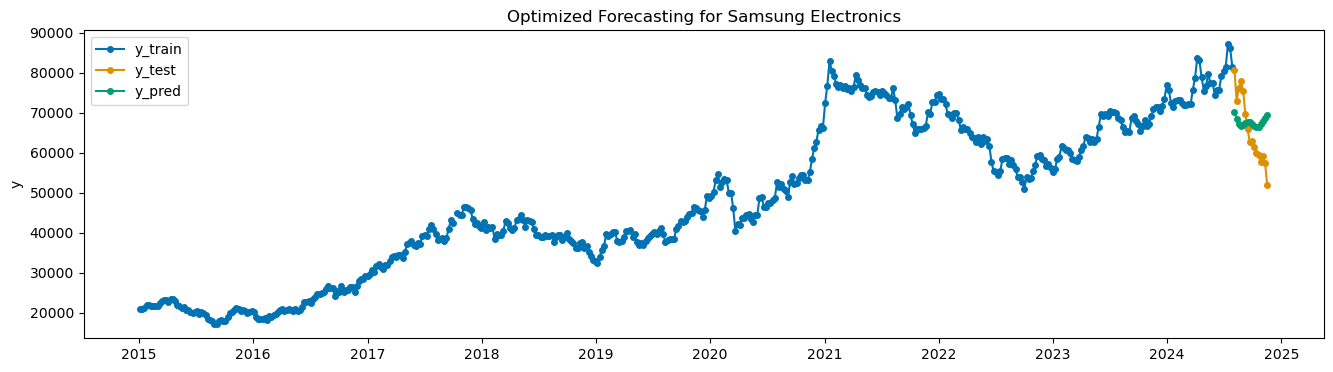

13:11:58 - cmdstanpy - INFO - Chain [1] start processing
13:11:58 - cmdstanpy - INFO - Chain [1] done processing
13:11:58 - cmdstanpy - INFO - Chain [1] start processing
13:11:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1 of 3136 for Intel Corporation...


13:11:59 - cmdstanpy - INFO - Chain [1] start processing
13:11:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2 of 3136 for Intel Corporation...


13:11:59 - cmdstanpy - INFO - Chain [1] start processing
13:11:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3 of 3136 for Intel Corporation...


13:11:59 - cmdstanpy - INFO - Chain [1] start processing
13:11:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 4 of 3136 for Intel Corporation...


13:11:59 - cmdstanpy - INFO - Chain [1] start processing
13:11:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 5 of 3136 for Intel Corporation...


13:12:00 - cmdstanpy - INFO - Chain [1] start processing
13:12:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 6 of 3136 for Intel Corporation...


13:12:00 - cmdstanpy - INFO - Chain [1] start processing
13:12:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 7 of 3136 for Intel Corporation...


13:12:00 - cmdstanpy - INFO - Chain [1] start processing
13:12:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 8 of 3136 for Intel Corporation...


13:12:00 - cmdstanpy - INFO - Chain [1] start processing
13:12:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 9 of 3136 for Intel Corporation...


13:12:01 - cmdstanpy - INFO - Chain [1] start processing
13:12:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 10 of 3136 for Intel Corporation...


13:12:01 - cmdstanpy - INFO - Chain [1] start processing
13:12:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 11 of 3136 for Intel Corporation...


13:12:01 - cmdstanpy - INFO - Chain [1] start processing
13:12:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 12 of 3136 for Intel Corporation...


13:12:01 - cmdstanpy - INFO - Chain [1] start processing
13:12:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 13 of 3136 for Intel Corporation...


13:12:02 - cmdstanpy - INFO - Chain [1] start processing
13:12:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 14 of 3136 for Intel Corporation...


13:12:02 - cmdstanpy - INFO - Chain [1] start processing
13:12:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 15 of 3136 for Intel Corporation...


13:12:02 - cmdstanpy - INFO - Chain [1] start processing
13:12:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 16 of 3136 for Intel Corporation...


13:12:02 - cmdstanpy - INFO - Chain [1] start processing
13:12:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 17 of 3136 for Intel Corporation...


13:12:03 - cmdstanpy - INFO - Chain [1] start processing
13:12:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 18 of 3136 for Intel Corporation...


13:12:03 - cmdstanpy - INFO - Chain [1] start processing
13:12:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 19 of 3136 for Intel Corporation...


13:12:03 - cmdstanpy - INFO - Chain [1] start processing
13:12:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 20 of 3136 for Intel Corporation...


13:12:03 - cmdstanpy - INFO - Chain [1] start processing
13:12:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 21 of 3136 for Intel Corporation...


13:12:04 - cmdstanpy - INFO - Chain [1] start processing
13:12:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 22 of 3136 for Intel Corporation...


13:12:04 - cmdstanpy - INFO - Chain [1] start processing
13:12:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 23 of 3136 for Intel Corporation...


13:12:04 - cmdstanpy - INFO - Chain [1] start processing
13:12:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 24 of 3136 for Intel Corporation...


13:12:04 - cmdstanpy - INFO - Chain [1] start processing
13:12:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 25 of 3136 for Intel Corporation...


13:12:05 - cmdstanpy - INFO - Chain [1] start processing
13:12:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 26 of 3136 for Intel Corporation...


13:12:05 - cmdstanpy - INFO - Chain [1] start processing
13:12:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 27 of 3136 for Intel Corporation...


13:12:05 - cmdstanpy - INFO - Chain [1] start processing
13:12:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 28 of 3136 for Intel Corporation...


13:12:06 - cmdstanpy - INFO - Chain [1] start processing
13:12:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 29 of 3136 for Intel Corporation...


13:12:06 - cmdstanpy - INFO - Chain [1] start processing
13:12:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 30 of 3136 for Intel Corporation...


13:12:06 - cmdstanpy - INFO - Chain [1] start processing
13:12:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 31 of 3136 for Intel Corporation...


13:12:06 - cmdstanpy - INFO - Chain [1] start processing
13:12:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 32 of 3136 for Intel Corporation...


13:12:07 - cmdstanpy - INFO - Chain [1] start processing
13:12:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 33 of 3136 for Intel Corporation...


13:12:07 - cmdstanpy - INFO - Chain [1] start processing
13:12:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 34 of 3136 for Intel Corporation...


13:12:07 - cmdstanpy - INFO - Chain [1] start processing
13:12:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 35 of 3136 for Intel Corporation...


13:12:07 - cmdstanpy - INFO - Chain [1] start processing
13:12:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 36 of 3136 for Intel Corporation...


13:12:08 - cmdstanpy - INFO - Chain [1] start processing
13:12:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 37 of 3136 for Intel Corporation...


13:12:08 - cmdstanpy - INFO - Chain [1] start processing
13:12:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 38 of 3136 for Intel Corporation...


13:12:08 - cmdstanpy - INFO - Chain [1] start processing
13:12:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 39 of 3136 for Intel Corporation...


13:12:08 - cmdstanpy - INFO - Chain [1] start processing
13:12:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 40 of 3136 for Intel Corporation...


13:12:09 - cmdstanpy - INFO - Chain [1] start processing
13:12:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 41 of 3136 for Intel Corporation...


13:12:09 - cmdstanpy - INFO - Chain [1] start processing
13:12:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 42 of 3136 for Intel Corporation...


13:12:09 - cmdstanpy - INFO - Chain [1] start processing
13:12:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 43 of 3136 for Intel Corporation...


13:12:09 - cmdstanpy - INFO - Chain [1] start processing
13:12:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 44 of 3136 for Intel Corporation...
Processing combination 45 of 3136 for Intel Corporation...


13:12:10 - cmdstanpy - INFO - Chain [1] start processing
13:12:10 - cmdstanpy - INFO - Chain [1] done processing
13:12:10 - cmdstanpy - INFO - Chain [1] start processing
13:12:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 46 of 3136 for Intel Corporation...


13:12:10 - cmdstanpy - INFO - Chain [1] start processing
13:12:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 47 of 3136 for Intel Corporation...


13:12:10 - cmdstanpy - INFO - Chain [1] start processing
13:12:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 48 of 3136 for Intel Corporation...


13:12:11 - cmdstanpy - INFO - Chain [1] start processing
13:12:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 49 of 3136 for Intel Corporation...


13:12:11 - cmdstanpy - INFO - Chain [1] start processing
13:12:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 50 of 3136 for Intel Corporation...


13:12:11 - cmdstanpy - INFO - Chain [1] start processing
13:12:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 51 of 3136 for Intel Corporation...


13:12:11 - cmdstanpy - INFO - Chain [1] start processing
13:12:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 52 of 3136 for Intel Corporation...


13:12:12 - cmdstanpy - INFO - Chain [1] start processing
13:12:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 53 of 3136 for Intel Corporation...


13:12:12 - cmdstanpy - INFO - Chain [1] start processing
13:12:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 54 of 3136 for Intel Corporation...


13:12:12 - cmdstanpy - INFO - Chain [1] start processing
13:12:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 55 of 3136 for Intel Corporation...


13:12:13 - cmdstanpy - INFO - Chain [1] start processing
13:12:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 56 of 3136 for Intel Corporation...


13:12:13 - cmdstanpy - INFO - Chain [1] start processing
13:12:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 57 of 3136 for Intel Corporation...


13:12:13 - cmdstanpy - INFO - Chain [1] start processing
13:12:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 58 of 3136 for Intel Corporation...


13:12:13 - cmdstanpy - INFO - Chain [1] start processing
13:12:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 59 of 3136 for Intel Corporation...


13:12:14 - cmdstanpy - INFO - Chain [1] start processing
13:12:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 60 of 3136 for Intel Corporation...


13:12:14 - cmdstanpy - INFO - Chain [1] start processing
13:12:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 61 of 3136 for Intel Corporation...


13:12:14 - cmdstanpy - INFO - Chain [1] start processing
13:12:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 62 of 3136 for Intel Corporation...


13:12:14 - cmdstanpy - INFO - Chain [1] start processing
13:12:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 63 of 3136 for Intel Corporation...


13:12:15 - cmdstanpy - INFO - Chain [1] start processing
13:12:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 64 of 3136 for Intel Corporation...


13:12:15 - cmdstanpy - INFO - Chain [1] start processing
13:12:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 65 of 3136 for Intel Corporation...


13:12:15 - cmdstanpy - INFO - Chain [1] start processing
13:12:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 66 of 3136 for Intel Corporation...


13:12:15 - cmdstanpy - INFO - Chain [1] start processing
13:12:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 67 of 3136 for Intel Corporation...


13:12:16 - cmdstanpy - INFO - Chain [1] start processing
13:12:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 68 of 3136 for Intel Corporation...


13:12:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 69 of 3136 for Intel Corporation...


13:12:16 - cmdstanpy - INFO - Chain [1] done processing
13:12:16 - cmdstanpy - INFO - Chain [1] start processing
13:12:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 70 of 3136 for Intel Corporation...


13:12:17 - cmdstanpy - INFO - Chain [1] start processing
13:12:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 71 of 3136 for Intel Corporation...


13:12:17 - cmdstanpy - INFO - Chain [1] start processing
13:12:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 72 of 3136 for Intel Corporation...


13:12:17 - cmdstanpy - INFO - Chain [1] start processing
13:12:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 73 of 3136 for Intel Corporation...


13:12:17 - cmdstanpy - INFO - Chain [1] start processing
13:12:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 74 of 3136 for Intel Corporation...


13:12:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 75 of 3136 for Intel Corporation...


13:12:18 - cmdstanpy - INFO - Chain [1] done processing
13:12:18 - cmdstanpy - INFO - Chain [1] start processing
13:12:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 76 of 3136 for Intel Corporation...


13:12:18 - cmdstanpy - INFO - Chain [1] start processing
13:12:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 77 of 3136 for Intel Corporation...


13:12:19 - cmdstanpy - INFO - Chain [1] start processing
13:12:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 78 of 3136 for Intel Corporation...


13:12:19 - cmdstanpy - INFO - Chain [1] start processing
13:12:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 79 of 3136 for Intel Corporation...


13:12:19 - cmdstanpy - INFO - Chain [1] start processing
13:12:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 80 of 3136 for Intel Corporation...


13:12:19 - cmdstanpy - INFO - Chain [1] start processing
13:12:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 81 of 3136 for Intel Corporation...


13:12:20 - cmdstanpy - INFO - Chain [1] start processing
13:12:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 82 of 3136 for Intel Corporation...


13:12:20 - cmdstanpy - INFO - Chain [1] start processing
13:12:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 83 of 3136 for Intel Corporation...


13:12:20 - cmdstanpy - INFO - Chain [1] start processing
13:12:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 84 of 3136 for Intel Corporation...


13:12:21 - cmdstanpy - INFO - Chain [1] start processing
13:12:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 85 of 3136 for Intel Corporation...


13:12:21 - cmdstanpy - INFO - Chain [1] start processing
13:12:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 86 of 3136 for Intel Corporation...


13:12:21 - cmdstanpy - INFO - Chain [1] start processing
13:12:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 87 of 3136 for Intel Corporation...


13:12:21 - cmdstanpy - INFO - Chain [1] start processing
13:12:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 88 of 3136 for Intel Corporation...


13:12:22 - cmdstanpy - INFO - Chain [1] start processing
13:12:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 89 of 3136 for Intel Corporation...


13:12:22 - cmdstanpy - INFO - Chain [1] start processing
13:12:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 90 of 3136 for Intel Corporation...


13:12:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 91 of 3136 for Intel Corporation...


13:12:22 - cmdstanpy - INFO - Chain [1] done processing
13:12:23 - cmdstanpy - INFO - Chain [1] start processing
13:12:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 92 of 3136 for Intel Corporation...


13:12:23 - cmdstanpy - INFO - Chain [1] start processing
13:12:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 93 of 3136 for Intel Corporation...


13:12:23 - cmdstanpy - INFO - Chain [1] start processing
13:12:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 94 of 3136 for Intel Corporation...


13:12:23 - cmdstanpy - INFO - Chain [1] start processing
13:12:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 95 of 3136 for Intel Corporation...


13:12:24 - cmdstanpy - INFO - Chain [1] start processing
13:12:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 96 of 3136 for Intel Corporation...


13:12:24 - cmdstanpy - INFO - Chain [1] start processing
13:12:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 97 of 3136 for Intel Corporation...


13:12:24 - cmdstanpy - INFO - Chain [1] start processing
13:12:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 98 of 3136 for Intel Corporation...


13:12:24 - cmdstanpy - INFO - Chain [1] start processing
13:12:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 99 of 3136 for Intel Corporation...


13:12:25 - cmdstanpy - INFO - Chain [1] start processing
13:12:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 100 of 3136 for Intel Corporation...


13:12:25 - cmdstanpy - INFO - Chain [1] start processing
13:12:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 101 of 3136 for Intel Corporation...


13:12:25 - cmdstanpy - INFO - Chain [1] start processing
13:12:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 102 of 3136 for Intel Corporation...


13:12:25 - cmdstanpy - INFO - Chain [1] start processing
13:12:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 103 of 3136 for Intel Corporation...


13:12:26 - cmdstanpy - INFO - Chain [1] start processing
13:12:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 104 of 3136 for Intel Corporation...


13:12:26 - cmdstanpy - INFO - Chain [1] start processing
13:12:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 105 of 3136 for Intel Corporation...


13:12:26 - cmdstanpy - INFO - Chain [1] start processing
13:12:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 106 of 3136 for Intel Corporation...


13:12:26 - cmdstanpy - INFO - Chain [1] start processing
13:12:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 107 of 3136 for Intel Corporation...


13:12:27 - cmdstanpy - INFO - Chain [1] start processing
13:12:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 108 of 3136 for Intel Corporation...


13:12:27 - cmdstanpy - INFO - Chain [1] start processing
13:12:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 109 of 3136 for Intel Corporation...


13:12:27 - cmdstanpy - INFO - Chain [1] start processing
13:12:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 110 of 3136 for Intel Corporation...


13:12:28 - cmdstanpy - INFO - Chain [1] start processing
13:12:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 111 of 3136 for Intel Corporation...


13:12:28 - cmdstanpy - INFO - Chain [1] start processing
13:12:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 112 of 3136 for Intel Corporation...


13:12:28 - cmdstanpy - INFO - Chain [1] start processing
13:12:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 113 of 3136 for Intel Corporation...


13:12:28 - cmdstanpy - INFO - Chain [1] start processing
13:12:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 114 of 3136 for Intel Corporation...


13:12:29 - cmdstanpy - INFO - Chain [1] start processing
13:12:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 115 of 3136 for Intel Corporation...


13:12:29 - cmdstanpy - INFO - Chain [1] start processing
13:12:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 116 of 3136 for Intel Corporation...


13:12:29 - cmdstanpy - INFO - Chain [1] start processing
13:12:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 117 of 3136 for Intel Corporation...


13:12:29 - cmdstanpy - INFO - Chain [1] start processing
13:12:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 118 of 3136 for Intel Corporation...


13:12:30 - cmdstanpy - INFO - Chain [1] start processing
13:12:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 119 of 3136 for Intel Corporation...


13:12:30 - cmdstanpy - INFO - Chain [1] start processing
13:12:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 120 of 3136 for Intel Corporation...


13:12:30 - cmdstanpy - INFO - Chain [1] start processing
13:12:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 121 of 3136 for Intel Corporation...


13:12:30 - cmdstanpy - INFO - Chain [1] start processing
13:12:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 122 of 3136 for Intel Corporation...
Processing combination 123 of 3136 for Intel Corporation...


13:12:30 - cmdstanpy - INFO - Chain [1] start processing
13:12:30 - cmdstanpy - INFO - Chain [1] done processing
13:12:31 - cmdstanpy - INFO - Chain [1] start processing
13:12:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 124 of 3136 for Intel Corporation...
Processing combination 125 of 3136 for Intel Corporation...


13:12:31 - cmdstanpy - INFO - Chain [1] start processing
13:12:31 - cmdstanpy - INFO - Chain [1] done processing
13:12:31 - cmdstanpy - INFO - Chain [1] start processing
13:12:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 126 of 3136 for Intel Corporation...


13:12:31 - cmdstanpy - INFO - Chain [1] start processing
13:12:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 127 of 3136 for Intel Corporation...


13:12:32 - cmdstanpy - INFO - Chain [1] start processing
13:12:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 128 of 3136 for Intel Corporation...
Processing combination 129 of 3136 for Intel Corporation...


13:12:32 - cmdstanpy - INFO - Chain [1] start processing
13:12:32 - cmdstanpy - INFO - Chain [1] done processing
13:12:32 - cmdstanpy - INFO - Chain [1] start processing
13:12:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 130 of 3136 for Intel Corporation...


13:12:32 - cmdstanpy - INFO - Chain [1] start processing
13:12:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 131 of 3136 for Intel Corporation...


13:12:32 - cmdstanpy - INFO - Chain [1] start processing
13:12:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 132 of 3136 for Intel Corporation...


13:12:33 - cmdstanpy - INFO - Chain [1] start processing
13:12:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 133 of 3136 for Intel Corporation...


13:12:33 - cmdstanpy - INFO - Chain [1] start processing
13:12:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 134 of 3136 for Intel Corporation...


13:12:33 - cmdstanpy - INFO - Chain [1] start processing
13:12:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 135 of 3136 for Intel Corporation...


13:12:33 - cmdstanpy - INFO - Chain [1] start processing
13:12:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 136 of 3136 for Intel Corporation...
Processing combination 137 of 3136 for Intel Corporation...


13:12:34 - cmdstanpy - INFO - Chain [1] start processing
13:12:34 - cmdstanpy - INFO - Chain [1] done processing
13:12:34 - cmdstanpy - INFO - Chain [1] start processing
13:12:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 138 of 3136 for Intel Corporation...


13:12:34 - cmdstanpy - INFO - Chain [1] start processing
13:12:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 139 of 3136 for Intel Corporation...


13:12:34 - cmdstanpy - INFO - Chain [1] start processing
13:12:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 140 of 3136 for Intel Corporation...
Processing combination 141 of 3136 for Intel Corporation...


13:12:35 - cmdstanpy - INFO - Chain [1] start processing
13:12:35 - cmdstanpy - INFO - Chain [1] done processing
13:12:35 - cmdstanpy - INFO - Chain [1] start processing
13:12:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 142 of 3136 for Intel Corporation...
Processing combination 143 of 3136 for Intel Corporation...


13:12:35 - cmdstanpy - INFO - Chain [1] start processing
13:12:35 - cmdstanpy - INFO - Chain [1] done processing
13:12:35 - cmdstanpy - INFO - Chain [1] start processing
13:12:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 144 of 3136 for Intel Corporation...
Processing combination 145 of 3136 for Intel Corporation...


13:12:36 - cmdstanpy - INFO - Chain [1] start processing
13:12:36 - cmdstanpy - INFO - Chain [1] done processing
13:12:36 - cmdstanpy - INFO - Chain [1] start processing
13:12:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 146 of 3136 for Intel Corporation...


13:12:36 - cmdstanpy - INFO - Chain [1] start processing
13:12:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 147 of 3136 for Intel Corporation...


13:12:36 - cmdstanpy - INFO - Chain [1] start processing
13:12:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 148 of 3136 for Intel Corporation...


13:12:36 - cmdstanpy - INFO - Chain [1] start processing
13:12:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 149 of 3136 for Intel Corporation...


13:12:37 - cmdstanpy - INFO - Chain [1] start processing
13:12:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 150 of 3136 for Intel Corporation...
Processing combination 151 of 3136 for Intel Corporation...


13:12:37 - cmdstanpy - INFO - Chain [1] start processing
13:12:37 - cmdstanpy - INFO - Chain [1] done processing
13:12:37 - cmdstanpy - INFO - Chain [1] start processing
13:12:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 152 of 3136 for Intel Corporation...
Processing combination 153 of 3136 for Intel Corporation...


13:12:37 - cmdstanpy - INFO - Chain [1] start processing
13:12:37 - cmdstanpy - INFO - Chain [1] done processing
13:12:38 - cmdstanpy - INFO - Chain [1] start processing
13:12:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 154 of 3136 for Intel Corporation...


13:12:38 - cmdstanpy - INFO - Chain [1] start processing
13:12:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 155 of 3136 for Intel Corporation...


13:12:38 - cmdstanpy - INFO - Chain [1] start processing
13:12:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 156 of 3136 for Intel Corporation...
Processing combination 157 of 3136 for Intel Corporation...


13:12:38 - cmdstanpy - INFO - Chain [1] start processing
13:12:38 - cmdstanpy - INFO - Chain [1] done processing
13:12:39 - cmdstanpy - INFO - Chain [1] start processing
13:12:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 158 of 3136 for Intel Corporation...
Processing combination 159 of 3136 for Intel Corporation...


13:12:39 - cmdstanpy - INFO - Chain [1] start processing
13:12:39 - cmdstanpy - INFO - Chain [1] done processing
13:12:39 - cmdstanpy - INFO - Chain [1] start processing
13:12:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 160 of 3136 for Intel Corporation...


13:12:39 - cmdstanpy - INFO - Chain [1] start processing
13:12:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 161 of 3136 for Intel Corporation...


13:12:39 - cmdstanpy - INFO - Chain [1] start processing
13:12:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 162 of 3136 for Intel Corporation...
Processing combination 163 of 3136 for Intel Corporation...


13:12:40 - cmdstanpy - INFO - Chain [1] start processing
13:12:40 - cmdstanpy - INFO - Chain [1] done processing
13:12:40 - cmdstanpy - INFO - Chain [1] start processing
13:12:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 164 of 3136 for Intel Corporation...
Processing combination 165 of 3136 for Intel Corporation...


13:12:40 - cmdstanpy - INFO - Chain [1] start processing
13:12:40 - cmdstanpy - INFO - Chain [1] done processing
13:12:40 - cmdstanpy - INFO - Chain [1] start processing
13:12:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 166 of 3136 for Intel Corporation...


13:12:41 - cmdstanpy - INFO - Chain [1] start processing
13:12:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 167 of 3136 for Intel Corporation...


13:12:41 - cmdstanpy - INFO - Chain [1] start processing
13:12:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 168 of 3136 for Intel Corporation...


13:12:41 - cmdstanpy - INFO - Chain [1] start processing
13:12:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 169 of 3136 for Intel Corporation...


13:12:41 - cmdstanpy - INFO - Chain [1] start processing
13:12:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 170 of 3136 for Intel Corporation...


13:12:41 - cmdstanpy - INFO - Chain [1] start processing
13:12:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 171 of 3136 for Intel Corporation...


13:12:42 - cmdstanpy - INFO - Chain [1] start processing
13:12:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 172 of 3136 for Intel Corporation...


13:12:42 - cmdstanpy - INFO - Chain [1] start processing
13:12:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 173 of 3136 for Intel Corporation...


13:12:42 - cmdstanpy - INFO - Chain [1] start processing
13:12:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 174 of 3136 for Intel Corporation...
Processing combination 175 of 3136 for Intel Corporation...


13:12:42 - cmdstanpy - INFO - Chain [1] start processing
13:12:42 - cmdstanpy - INFO - Chain [1] done processing
13:12:43 - cmdstanpy - INFO - Chain [1] start processing
13:12:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 176 of 3136 for Intel Corporation...
Processing combination 177 of 3136 for Intel Corporation...


13:12:43 - cmdstanpy - INFO - Chain [1] start processing
13:12:43 - cmdstanpy - INFO - Chain [1] done processing
13:12:43 - cmdstanpy - INFO - Chain [1] start processing
13:12:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 178 of 3136 for Intel Corporation...


13:12:43 - cmdstanpy - INFO - Chain [1] start processing
13:12:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 179 of 3136 for Intel Corporation...


13:12:44 - cmdstanpy - INFO - Chain [1] start processing
13:12:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 180 of 3136 for Intel Corporation...


13:12:44 - cmdstanpy - INFO - Chain [1] start processing
13:12:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 181 of 3136 for Intel Corporation...


13:12:44 - cmdstanpy - INFO - Chain [1] start processing
13:12:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 182 of 3136 for Intel Corporation...


13:12:44 - cmdstanpy - INFO - Chain [1] start processing
13:12:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 183 of 3136 for Intel Corporation...


13:12:44 - cmdstanpy - INFO - Chain [1] start processing
13:12:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 184 of 3136 for Intel Corporation...


13:12:45 - cmdstanpy - INFO - Chain [1] start processing
13:12:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 185 of 3136 for Intel Corporation...


13:12:45 - cmdstanpy - INFO - Chain [1] start processing
13:12:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 186 of 3136 for Intel Corporation...


13:12:45 - cmdstanpy - INFO - Chain [1] start processing
13:12:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 187 of 3136 for Intel Corporation...


13:12:45 - cmdstanpy - INFO - Chain [1] start processing
13:12:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 188 of 3136 for Intel Corporation...


13:12:46 - cmdstanpy - INFO - Chain [1] start processing
13:12:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 189 of 3136 for Intel Corporation...


13:12:46 - cmdstanpy - INFO - Chain [1] start processing
13:12:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 190 of 3136 for Intel Corporation...


13:12:46 - cmdstanpy - INFO - Chain [1] start processing
13:12:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 191 of 3136 for Intel Corporation...


13:12:46 - cmdstanpy - INFO - Chain [1] start processing
13:12:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 192 of 3136 for Intel Corporation...
Processing combination 193 of 3136 for Intel Corporation...


13:12:47 - cmdstanpy - INFO - Chain [1] start processing
13:12:47 - cmdstanpy - INFO - Chain [1] done processing
13:12:47 - cmdstanpy - INFO - Chain [1] start processing
13:12:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 194 of 3136 for Intel Corporation...


13:12:47 - cmdstanpy - INFO - Chain [1] start processing
13:12:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 195 of 3136 for Intel Corporation...


13:12:47 - cmdstanpy - INFO - Chain [1] start processing
13:12:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 196 of 3136 for Intel Corporation...


13:12:48 - cmdstanpy - INFO - Chain [1] start processing
13:12:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 197 of 3136 for Intel Corporation...


13:12:48 - cmdstanpy - INFO - Chain [1] start processing
13:12:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 198 of 3136 for Intel Corporation...


13:12:48 - cmdstanpy - INFO - Chain [1] start processing
13:12:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 199 of 3136 for Intel Corporation...


13:12:48 - cmdstanpy - INFO - Chain [1] start processing
13:12:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 200 of 3136 for Intel Corporation...


13:12:49 - cmdstanpy - INFO - Chain [1] start processing
13:12:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 201 of 3136 for Intel Corporation...


13:12:49 - cmdstanpy - INFO - Chain [1] start processing
13:12:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 202 of 3136 for Intel Corporation...


13:12:49 - cmdstanpy - INFO - Chain [1] start processing
13:12:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 203 of 3136 for Intel Corporation...


13:12:49 - cmdstanpy - INFO - Chain [1] start processing
13:12:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 204 of 3136 for Intel Corporation...
Processing combination 205 of 3136 for Intel Corporation...


13:12:49 - cmdstanpy - INFO - Chain [1] start processing
13:12:50 - cmdstanpy - INFO - Chain [1] done processing
13:12:50 - cmdstanpy - INFO - Chain [1] start processing
13:12:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 206 of 3136 for Intel Corporation...


13:12:50 - cmdstanpy - INFO - Chain [1] start processing
13:12:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 207 of 3136 for Intel Corporation...


13:12:50 - cmdstanpy - INFO - Chain [1] start processing
13:12:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 208 of 3136 for Intel Corporation...
Processing combination 209 of 3136 for Intel Corporation...


13:12:50 - cmdstanpy - INFO - Chain [1] start processing
13:12:50 - cmdstanpy - INFO - Chain [1] done processing
13:12:51 - cmdstanpy - INFO - Chain [1] start processing
13:12:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 210 of 3136 for Intel Corporation...


13:12:51 - cmdstanpy - INFO - Chain [1] start processing
13:12:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 211 of 3136 for Intel Corporation...


13:12:51 - cmdstanpy - INFO - Chain [1] start processing
13:12:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 212 of 3136 for Intel Corporation...


13:12:51 - cmdstanpy - INFO - Chain [1] start processing
13:12:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 213 of 3136 for Intel Corporation...


13:12:52 - cmdstanpy - INFO - Chain [1] start processing
13:12:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 214 of 3136 for Intel Corporation...


13:12:52 - cmdstanpy - INFO - Chain [1] start processing
13:12:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 215 of 3136 for Intel Corporation...


13:12:52 - cmdstanpy - INFO - Chain [1] start processing
13:12:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 216 of 3136 for Intel Corporation...
Processing combination 217 of 3136 for Intel Corporation...


13:12:52 - cmdstanpy - INFO - Chain [1] start processing
13:12:52 - cmdstanpy - INFO - Chain [1] done processing
13:12:53 - cmdstanpy - INFO - Chain [1] start processing
13:12:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 218 of 3136 for Intel Corporation...


13:12:53 - cmdstanpy - INFO - Chain [1] start processing
13:12:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 219 of 3136 for Intel Corporation...


13:12:53 - cmdstanpy - INFO - Chain [1] start processing
13:12:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 220 of 3136 for Intel Corporation...
Processing combination 221 of 3136 for Intel Corporation...


13:12:53 - cmdstanpy - INFO - Chain [1] start processing
13:12:53 - cmdstanpy - INFO - Chain [1] done processing
13:12:53 - cmdstanpy - INFO - Chain [1] start processing
13:12:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 222 of 3136 for Intel Corporation...


13:12:54 - cmdstanpy - INFO - Chain [1] start processing
13:12:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 223 of 3136 for Intel Corporation...


13:12:54 - cmdstanpy - INFO - Chain [1] start processing
13:12:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 224 of 3136 for Intel Corporation...
Processing combination 225 of 3136 for Intel Corporation...


13:12:54 - cmdstanpy - INFO - Chain [1] start processing
13:12:54 - cmdstanpy - INFO - Chain [1] done processing
13:12:54 - cmdstanpy - INFO - Chain [1] start processing
13:12:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 226 of 3136 for Intel Corporation...


13:12:55 - cmdstanpy - INFO - Chain [1] start processing
13:12:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 227 of 3136 for Intel Corporation...


13:12:55 - cmdstanpy - INFO - Chain [1] start processing
13:12:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 228 of 3136 for Intel Corporation...


13:12:55 - cmdstanpy - INFO - Chain [1] start processing
13:12:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 229 of 3136 for Intel Corporation...


13:12:55 - cmdstanpy - INFO - Chain [1] start processing
13:12:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 230 of 3136 for Intel Corporation...


13:12:56 - cmdstanpy - INFO - Chain [1] start processing
13:12:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 231 of 3136 for Intel Corporation...


13:12:56 - cmdstanpy - INFO - Chain [1] start processing
13:12:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 232 of 3136 for Intel Corporation...


13:12:56 - cmdstanpy - INFO - Chain [1] start processing
13:12:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 233 of 3136 for Intel Corporation...


13:12:57 - cmdstanpy - INFO - Chain [1] start processing
13:12:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 234 of 3136 for Intel Corporation...


13:12:57 - cmdstanpy - INFO - Chain [1] start processing
13:12:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 235 of 3136 for Intel Corporation...


13:12:57 - cmdstanpy - INFO - Chain [1] start processing
13:12:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 236 of 3136 for Intel Corporation...


13:12:57 - cmdstanpy - INFO - Chain [1] start processing
13:12:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 237 of 3136 for Intel Corporation...


13:12:58 - cmdstanpy - INFO - Chain [1] start processing
13:12:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 238 of 3136 for Intel Corporation...


13:12:58 - cmdstanpy - INFO - Chain [1] start processing
13:12:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 239 of 3136 for Intel Corporation...


13:12:58 - cmdstanpy - INFO - Chain [1] start processing
13:12:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 240 of 3136 for Intel Corporation...


13:12:58 - cmdstanpy - INFO - Chain [1] start processing
13:12:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 241 of 3136 for Intel Corporation...


13:12:59 - cmdstanpy - INFO - Chain [1] start processing
13:12:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 242 of 3136 for Intel Corporation...


13:12:59 - cmdstanpy - INFO - Chain [1] start processing
13:12:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 243 of 3136 for Intel Corporation...


13:12:59 - cmdstanpy - INFO - Chain [1] start processing
13:12:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 244 of 3136 for Intel Corporation...


13:12:59 - cmdstanpy - INFO - Chain [1] start processing
13:12:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 245 of 3136 for Intel Corporation...


13:13:00 - cmdstanpy - INFO - Chain [1] start processing
13:13:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 246 of 3136 for Intel Corporation...


13:13:00 - cmdstanpy - INFO - Chain [1] start processing
13:13:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 247 of 3136 for Intel Corporation...


13:13:00 - cmdstanpy - INFO - Chain [1] start processing
13:13:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 248 of 3136 for Intel Corporation...


13:13:00 - cmdstanpy - INFO - Chain [1] start processing
13:13:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 249 of 3136 for Intel Corporation...


13:13:01 - cmdstanpy - INFO - Chain [1] start processing
13:13:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 250 of 3136 for Intel Corporation...


13:13:01 - cmdstanpy - INFO - Chain [1] start processing
13:13:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 251 of 3136 for Intel Corporation...


13:13:01 - cmdstanpy - INFO - Chain [1] start processing
13:13:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 252 of 3136 for Intel Corporation...


13:13:01 - cmdstanpy - INFO - Chain [1] start processing
13:13:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 253 of 3136 for Intel Corporation...


13:13:02 - cmdstanpy - INFO - Chain [1] start processing
13:13:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 254 of 3136 for Intel Corporation...


13:13:02 - cmdstanpy - INFO - Chain [1] start processing
13:13:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 255 of 3136 for Intel Corporation...


13:13:02 - cmdstanpy - INFO - Chain [1] start processing
13:13:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 256 of 3136 for Intel Corporation...


13:13:02 - cmdstanpy - INFO - Chain [1] start processing
13:13:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 257 of 3136 for Intel Corporation...


13:13:03 - cmdstanpy - INFO - Chain [1] start processing
13:13:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 258 of 3136 for Intel Corporation...


13:13:03 - cmdstanpy - INFO - Chain [1] start processing
13:13:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 259 of 3136 for Intel Corporation...


13:13:03 - cmdstanpy - INFO - Chain [1] start processing
13:13:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 260 of 3136 for Intel Corporation...


13:13:04 - cmdstanpy - INFO - Chain [1] start processing
13:13:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 261 of 3136 for Intel Corporation...


13:13:04 - cmdstanpy - INFO - Chain [1] start processing
13:13:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 262 of 3136 for Intel Corporation...


13:13:04 - cmdstanpy - INFO - Chain [1] start processing
13:13:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 263 of 3136 for Intel Corporation...


13:13:04 - cmdstanpy - INFO - Chain [1] start processing
13:13:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 264 of 3136 for Intel Corporation...


13:13:05 - cmdstanpy - INFO - Chain [1] start processing
13:13:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 265 of 3136 for Intel Corporation...


13:13:05 - cmdstanpy - INFO - Chain [1] start processing
13:13:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 266 of 3136 for Intel Corporation...


13:13:05 - cmdstanpy - INFO - Chain [1] start processing
13:13:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 267 of 3136 for Intel Corporation...


13:13:05 - cmdstanpy - INFO - Chain [1] start processing
13:13:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 268 of 3136 for Intel Corporation...


13:13:06 - cmdstanpy - INFO - Chain [1] start processing
13:13:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 269 of 3136 for Intel Corporation...


13:13:06 - cmdstanpy - INFO - Chain [1] start processing
13:13:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 270 of 3136 for Intel Corporation...


13:13:06 - cmdstanpy - INFO - Chain [1] start processing
13:13:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 271 of 3136 for Intel Corporation...


13:13:06 - cmdstanpy - INFO - Chain [1] start processing
13:13:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 272 of 3136 for Intel Corporation...


13:13:07 - cmdstanpy - INFO - Chain [1] start processing
13:13:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 273 of 3136 for Intel Corporation...


13:13:07 - cmdstanpy - INFO - Chain [1] start processing
13:13:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 274 of 3136 for Intel Corporation...


13:13:07 - cmdstanpy - INFO - Chain [1] start processing
13:13:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 275 of 3136 for Intel Corporation...


13:13:07 - cmdstanpy - INFO - Chain [1] start processing
13:13:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 276 of 3136 for Intel Corporation...


13:13:08 - cmdstanpy - INFO - Chain [1] start processing
13:13:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 277 of 3136 for Intel Corporation...


13:13:08 - cmdstanpy - INFO - Chain [1] start processing
13:13:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 278 of 3136 for Intel Corporation...


13:13:08 - cmdstanpy - INFO - Chain [1] start processing
13:13:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 279 of 3136 for Intel Corporation...


13:13:08 - cmdstanpy - INFO - Chain [1] start processing
13:13:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 280 of 3136 for Intel Corporation...


13:13:09 - cmdstanpy - INFO - Chain [1] start processing
13:13:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 281 of 3136 for Intel Corporation...


13:13:09 - cmdstanpy - INFO - Chain [1] start processing
13:13:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 282 of 3136 for Intel Corporation...


13:13:09 - cmdstanpy - INFO - Chain [1] start processing
13:13:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 283 of 3136 for Intel Corporation...


13:13:09 - cmdstanpy - INFO - Chain [1] start processing
13:13:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 284 of 3136 for Intel Corporation...


13:13:10 - cmdstanpy - INFO - Chain [1] start processing
13:13:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 285 of 3136 for Intel Corporation...


13:13:10 - cmdstanpy - INFO - Chain [1] start processing
13:13:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 286 of 3136 for Intel Corporation...


13:13:10 - cmdstanpy - INFO - Chain [1] start processing
13:13:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 287 of 3136 for Intel Corporation...


13:13:11 - cmdstanpy - INFO - Chain [1] start processing
13:13:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 288 of 3136 for Intel Corporation...


13:13:11 - cmdstanpy - INFO - Chain [1] start processing
13:13:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 289 of 3136 for Intel Corporation...


13:13:11 - cmdstanpy - INFO - Chain [1] start processing
13:13:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 290 of 3136 for Intel Corporation...


13:13:11 - cmdstanpy - INFO - Chain [1] start processing
13:13:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 291 of 3136 for Intel Corporation...


13:13:12 - cmdstanpy - INFO - Chain [1] start processing
13:13:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 292 of 3136 for Intel Corporation...


13:13:12 - cmdstanpy - INFO - Chain [1] start processing
13:13:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 293 of 3136 for Intel Corporation...


13:13:12 - cmdstanpy - INFO - Chain [1] start processing
13:13:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 294 of 3136 for Intel Corporation...


13:13:12 - cmdstanpy - INFO - Chain [1] start processing
13:13:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 295 of 3136 for Intel Corporation...


13:13:13 - cmdstanpy - INFO - Chain [1] start processing
13:13:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 296 of 3136 for Intel Corporation...


13:13:13 - cmdstanpy - INFO - Chain [1] start processing
13:13:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 297 of 3136 for Intel Corporation...


13:13:13 - cmdstanpy - INFO - Chain [1] start processing
13:13:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 298 of 3136 for Intel Corporation...


13:13:13 - cmdstanpy - INFO - Chain [1] start processing
13:13:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 299 of 3136 for Intel Corporation...


13:13:14 - cmdstanpy - INFO - Chain [1] start processing
13:13:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 300 of 3136 for Intel Corporation...


13:13:14 - cmdstanpy - INFO - Chain [1] start processing
13:13:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 301 of 3136 for Intel Corporation...


13:13:14 - cmdstanpy - INFO - Chain [1] start processing
13:13:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 302 of 3136 for Intel Corporation...


13:13:14 - cmdstanpy - INFO - Chain [1] start processing
13:13:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 303 of 3136 for Intel Corporation...


13:13:15 - cmdstanpy - INFO - Chain [1] start processing
13:13:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 304 of 3136 for Intel Corporation...


13:13:15 - cmdstanpy - INFO - Chain [1] start processing
13:13:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 305 of 3136 for Intel Corporation...


13:13:15 - cmdstanpy - INFO - Chain [1] start processing
13:13:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 306 of 3136 for Intel Corporation...


13:13:15 - cmdstanpy - INFO - Chain [1] start processing
13:13:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 307 of 3136 for Intel Corporation...


13:13:16 - cmdstanpy - INFO - Chain [1] start processing
13:13:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 308 of 3136 for Intel Corporation...
Processing combination 309 of 3136 for Intel Corporation...


13:13:16 - cmdstanpy - INFO - Chain [1] start processing
13:13:16 - cmdstanpy - INFO - Chain [1] done processing
13:13:16 - cmdstanpy - INFO - Chain [1] start processing
13:13:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 310 of 3136 for Intel Corporation...


13:13:16 - cmdstanpy - INFO - Chain [1] start processing
13:13:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 311 of 3136 for Intel Corporation...


13:13:17 - cmdstanpy - INFO - Chain [1] start processing
13:13:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 312 of 3136 for Intel Corporation...


13:13:17 - cmdstanpy - INFO - Chain [1] start processing
13:13:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 313 of 3136 for Intel Corporation...


13:13:17 - cmdstanpy - INFO - Chain [1] start processing
13:13:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 314 of 3136 for Intel Corporation...


13:13:18 - cmdstanpy - INFO - Chain [1] start processing
13:13:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 315 of 3136 for Intel Corporation...


13:13:18 - cmdstanpy - INFO - Chain [1] start processing
13:13:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 316 of 3136 for Intel Corporation...


13:13:18 - cmdstanpy - INFO - Chain [1] start processing
13:13:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 317 of 3136 for Intel Corporation...


13:13:18 - cmdstanpy - INFO - Chain [1] start processing
13:13:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 318 of 3136 for Intel Corporation...


13:13:19 - cmdstanpy - INFO - Chain [1] start processing
13:13:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 319 of 3136 for Intel Corporation...


13:13:19 - cmdstanpy - INFO - Chain [1] start processing
13:13:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 320 of 3136 for Intel Corporation...


13:13:19 - cmdstanpy - INFO - Chain [1] start processing
13:13:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 321 of 3136 for Intel Corporation...


13:13:19 - cmdstanpy - INFO - Chain [1] start processing
13:13:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 322 of 3136 for Intel Corporation...


13:13:20 - cmdstanpy - INFO - Chain [1] start processing
13:13:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 323 of 3136 for Intel Corporation...


13:13:20 - cmdstanpy - INFO - Chain [1] start processing
13:13:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 324 of 3136 for Intel Corporation...


13:13:20 - cmdstanpy - INFO - Chain [1] start processing
13:13:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 325 of 3136 for Intel Corporation...


13:13:21 - cmdstanpy - INFO - Chain [1] start processing
13:13:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 326 of 3136 for Intel Corporation...


13:13:21 - cmdstanpy - INFO - Chain [1] start processing
13:13:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 327 of 3136 for Intel Corporation...


13:13:21 - cmdstanpy - INFO - Chain [1] start processing
13:13:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 328 of 3136 for Intel Corporation...


13:13:21 - cmdstanpy - INFO - Chain [1] start processing
13:13:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 329 of 3136 for Intel Corporation...


13:13:22 - cmdstanpy - INFO - Chain [1] start processing
13:13:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 330 of 3136 for Intel Corporation...


13:13:22 - cmdstanpy - INFO - Chain [1] start processing
13:13:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 331 of 3136 for Intel Corporation...


13:13:22 - cmdstanpy - INFO - Chain [1] start processing
13:13:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 332 of 3136 for Intel Corporation...


13:13:22 - cmdstanpy - INFO - Chain [1] start processing
13:13:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 333 of 3136 for Intel Corporation...


13:13:23 - cmdstanpy - INFO - Chain [1] start processing
13:13:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 334 of 3136 for Intel Corporation...


13:13:23 - cmdstanpy - INFO - Chain [1] start processing
13:13:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 335 of 3136 for Intel Corporation...


13:13:23 - cmdstanpy - INFO - Chain [1] start processing
13:13:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 336 of 3136 for Intel Corporation...


13:13:23 - cmdstanpy - INFO - Chain [1] start processing
13:13:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 337 of 3136 for Intel Corporation...


13:13:24 - cmdstanpy - INFO - Chain [1] start processing
13:13:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 338 of 3136 for Intel Corporation...


13:13:24 - cmdstanpy - INFO - Chain [1] start processing
13:13:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 339 of 3136 for Intel Corporation...


13:13:24 - cmdstanpy - INFO - Chain [1] start processing
13:13:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 340 of 3136 for Intel Corporation...


13:13:24 - cmdstanpy - INFO - Chain [1] start processing
13:13:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 341 of 3136 for Intel Corporation...


13:13:25 - cmdstanpy - INFO - Chain [1] start processing
13:13:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 342 of 3136 for Intel Corporation...


13:13:25 - cmdstanpy - INFO - Chain [1] start processing
13:13:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 343 of 3136 for Intel Corporation...


13:13:25 - cmdstanpy - INFO - Chain [1] start processing
13:13:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 344 of 3136 for Intel Corporation...


13:13:25 - cmdstanpy - INFO - Chain [1] start processing
13:13:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 345 of 3136 for Intel Corporation...


13:13:26 - cmdstanpy - INFO - Chain [1] start processing
13:13:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 346 of 3136 for Intel Corporation...


13:13:26 - cmdstanpy - INFO - Chain [1] start processing
13:13:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 347 of 3136 for Intel Corporation...


13:13:26 - cmdstanpy - INFO - Chain [1] start processing
13:13:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 348 of 3136 for Intel Corporation...


13:13:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 349 of 3136 for Intel Corporation...


13:13:27 - cmdstanpy - INFO - Chain [1] done processing
13:13:27 - cmdstanpy - INFO - Chain [1] start processing
13:13:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 350 of 3136 for Intel Corporation...


13:13:27 - cmdstanpy - INFO - Chain [1] start processing
13:13:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 351 of 3136 for Intel Corporation...


13:13:27 - cmdstanpy - INFO - Chain [1] start processing
13:13:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 352 of 3136 for Intel Corporation...


13:13:27 - cmdstanpy - INFO - Chain [1] start processing
13:13:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 353 of 3136 for Intel Corporation...


13:13:28 - cmdstanpy - INFO - Chain [1] start processing
13:13:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 354 of 3136 for Intel Corporation...


13:13:28 - cmdstanpy - INFO - Chain [1] start processing
13:13:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 355 of 3136 for Intel Corporation...


13:13:28 - cmdstanpy - INFO - Chain [1] start processing
13:13:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 356 of 3136 for Intel Corporation...


13:13:28 - cmdstanpy - INFO - Chain [1] start processing
13:13:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 357 of 3136 for Intel Corporation...


13:13:29 - cmdstanpy - INFO - Chain [1] start processing
13:13:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 358 of 3136 for Intel Corporation...


13:13:29 - cmdstanpy - INFO - Chain [1] start processing
13:13:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 359 of 3136 for Intel Corporation...


13:13:29 - cmdstanpy - INFO - Chain [1] start processing
13:13:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 360 of 3136 for Intel Corporation...


13:13:29 - cmdstanpy - INFO - Chain [1] start processing
13:13:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 361 of 3136 for Intel Corporation...


13:13:30 - cmdstanpy - INFO - Chain [1] start processing
13:13:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 362 of 3136 for Intel Corporation...


13:13:30 - cmdstanpy - INFO - Chain [1] start processing
13:13:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 363 of 3136 for Intel Corporation...


13:13:30 - cmdstanpy - INFO - Chain [1] start processing
13:13:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 364 of 3136 for Intel Corporation...


13:13:30 - cmdstanpy - INFO - Chain [1] start processing
13:13:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 365 of 3136 for Intel Corporation...


13:13:31 - cmdstanpy - INFO - Chain [1] start processing
13:13:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 366 of 3136 for Intel Corporation...


13:13:31 - cmdstanpy - INFO - Chain [1] start processing
13:13:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 367 of 3136 for Intel Corporation...


13:13:31 - cmdstanpy - INFO - Chain [1] start processing
13:13:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 368 of 3136 for Intel Corporation...


13:13:31 - cmdstanpy - INFO - Chain [1] start processing
13:13:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 369 of 3136 for Intel Corporation...


13:13:32 - cmdstanpy - INFO - Chain [1] start processing
13:13:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 370 of 3136 for Intel Corporation...


13:13:32 - cmdstanpy - INFO - Chain [1] start processing
13:13:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 371 of 3136 for Intel Corporation...


13:13:32 - cmdstanpy - INFO - Chain [1] start processing
13:13:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 372 of 3136 for Intel Corporation...


13:13:32 - cmdstanpy - INFO - Chain [1] start processing
13:13:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 373 of 3136 for Intel Corporation...


13:13:32 - cmdstanpy - INFO - Chain [1] start processing
13:13:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 374 of 3136 for Intel Corporation...


13:13:33 - cmdstanpy - INFO - Chain [1] start processing
13:13:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 375 of 3136 for Intel Corporation...


13:13:33 - cmdstanpy - INFO - Chain [1] start processing
13:13:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 376 of 3136 for Intel Corporation...
Processing combination 377 of 3136 for Intel Corporation...


13:13:33 - cmdstanpy - INFO - Chain [1] start processing
13:13:33 - cmdstanpy - INFO - Chain [1] done processing
13:13:33 - cmdstanpy - INFO - Chain [1] start processing
13:13:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 378 of 3136 for Intel Corporation...


13:13:34 - cmdstanpy - INFO - Chain [1] start processing
13:13:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 379 of 3136 for Intel Corporation...


13:13:34 - cmdstanpy - INFO - Chain [1] start processing
13:13:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 380 of 3136 for Intel Corporation...


13:13:34 - cmdstanpy - INFO - Chain [1] start processing
13:13:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 381 of 3136 for Intel Corporation...


13:13:34 - cmdstanpy - INFO - Chain [1] start processing
13:13:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 382 of 3136 for Intel Corporation...


13:13:35 - cmdstanpy - INFO - Chain [1] start processing
13:13:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 383 of 3136 for Intel Corporation...


13:13:35 - cmdstanpy - INFO - Chain [1] start processing
13:13:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 384 of 3136 for Intel Corporation...


13:13:35 - cmdstanpy - INFO - Chain [1] start processing
13:13:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 385 of 3136 for Intel Corporation...


13:13:35 - cmdstanpy - INFO - Chain [1] start processing
13:13:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 386 of 3136 for Intel Corporation...


13:13:36 - cmdstanpy - INFO - Chain [1] start processing
13:13:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 387 of 3136 for Intel Corporation...


13:13:36 - cmdstanpy - INFO - Chain [1] start processing
13:13:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 388 of 3136 for Intel Corporation...
Processing combination 389 of 3136 for Intel Corporation...


13:13:36 - cmdstanpy - INFO - Chain [1] start processing
13:13:36 - cmdstanpy - INFO - Chain [1] done processing
13:13:36 - cmdstanpy - INFO - Chain [1] start processing
13:13:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 390 of 3136 for Intel Corporation...


13:13:37 - cmdstanpy - INFO - Chain [1] start processing
13:13:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 391 of 3136 for Intel Corporation...


13:13:37 - cmdstanpy - INFO - Chain [1] start processing
13:13:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 392 of 3136 for Intel Corporation...


13:13:37 - cmdstanpy - INFO - Chain [1] start processing
13:13:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 393 of 3136 for Intel Corporation...


13:13:37 - cmdstanpy - INFO - Chain [1] start processing
13:13:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 394 of 3136 for Intel Corporation...


13:13:38 - cmdstanpy - INFO - Chain [1] start processing
13:13:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 395 of 3136 for Intel Corporation...


13:13:38 - cmdstanpy - INFO - Chain [1] start processing
13:13:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 396 of 3136 for Intel Corporation...


13:13:38 - cmdstanpy - INFO - Chain [1] start processing
13:13:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 397 of 3136 for Intel Corporation...


13:13:38 - cmdstanpy - INFO - Chain [1] start processing
13:13:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 398 of 3136 for Intel Corporation...


13:13:39 - cmdstanpy - INFO - Chain [1] start processing
13:13:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 399 of 3136 for Intel Corporation...


13:13:39 - cmdstanpy - INFO - Chain [1] start processing
13:13:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 400 of 3136 for Intel Corporation...


13:13:39 - cmdstanpy - INFO - Chain [1] start processing
13:13:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 401 of 3136 for Intel Corporation...


13:13:39 - cmdstanpy - INFO - Chain [1] start processing
13:13:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 402 of 3136 for Intel Corporation...
Processing combination 403 of 3136 for Intel Corporation...


13:13:39 - cmdstanpy - INFO - Chain [1] start processing
13:13:39 - cmdstanpy - INFO - Chain [1] done processing
13:13:40 - cmdstanpy - INFO - Chain [1] start processing
13:13:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 404 of 3136 for Intel Corporation...


13:13:40 - cmdstanpy - INFO - Chain [1] start processing
13:13:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 405 of 3136 for Intel Corporation...


13:13:40 - cmdstanpy - INFO - Chain [1] start processing
13:13:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 406 of 3136 for Intel Corporation...


13:13:40 - cmdstanpy - INFO - Chain [1] start processing
13:13:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 407 of 3136 for Intel Corporation...


13:13:41 - cmdstanpy - INFO - Chain [1] start processing
13:13:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 408 of 3136 for Intel Corporation...


13:13:41 - cmdstanpy - INFO - Chain [1] start processing
13:13:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 409 of 3136 for Intel Corporation...


13:13:41 - cmdstanpy - INFO - Chain [1] start processing
13:13:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 410 of 3136 for Intel Corporation...
Processing combination 411 of 3136 for Intel Corporation...


13:13:41 - cmdstanpy - INFO - Chain [1] start processing
13:13:41 - cmdstanpy - INFO - Chain [1] done processing
13:13:42 - cmdstanpy - INFO - Chain [1] start processing
13:13:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 412 of 3136 for Intel Corporation...


13:13:42 - cmdstanpy - INFO - Chain [1] start processing
13:13:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 413 of 3136 for Intel Corporation...


13:13:42 - cmdstanpy - INFO - Chain [1] start processing
13:13:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 414 of 3136 for Intel Corporation...


13:13:42 - cmdstanpy - INFO - Chain [1] start processing
13:13:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 415 of 3136 for Intel Corporation...


13:13:43 - cmdstanpy - INFO - Chain [1] start processing
13:13:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 416 of 3136 for Intel Corporation...


13:13:43 - cmdstanpy - INFO - Chain [1] start processing
13:13:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 417 of 3136 for Intel Corporation...


13:13:43 - cmdstanpy - INFO - Chain [1] start processing
13:13:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 418 of 3136 for Intel Corporation...


13:13:43 - cmdstanpy - INFO - Chain [1] start processing
13:13:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 419 of 3136 for Intel Corporation...


13:13:44 - cmdstanpy - INFO - Chain [1] start processing
13:13:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 420 of 3136 for Intel Corporation...


13:13:44 - cmdstanpy - INFO - Chain [1] start processing
13:13:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 421 of 3136 for Intel Corporation...


13:13:44 - cmdstanpy - INFO - Chain [1] start processing
13:13:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 422 of 3136 for Intel Corporation...
Processing combination 423 of 3136 for Intel Corporation...


13:13:44 - cmdstanpy - INFO - Chain [1] start processing
13:13:44 - cmdstanpy - INFO - Chain [1] done processing
13:13:45 - cmdstanpy - INFO - Chain [1] start processing
13:13:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 424 of 3136 for Intel Corporation...
Processing combination 425 of 3136 for Intel Corporation...


13:13:45 - cmdstanpy - INFO - Chain [1] start processing
13:13:45 - cmdstanpy - INFO - Chain [1] done processing
13:13:45 - cmdstanpy - INFO - Chain [1] start processing
13:13:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 426 of 3136 for Intel Corporation...
Processing combination 427 of 3136 for Intel Corporation...


13:13:45 - cmdstanpy - INFO - Chain [1] start processing
13:13:45 - cmdstanpy - INFO - Chain [1] done processing
13:13:45 - cmdstanpy - INFO - Chain [1] start processing
13:13:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 428 of 3136 for Intel Corporation...


13:13:46 - cmdstanpy - INFO - Chain [1] start processing
13:13:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 429 of 3136 for Intel Corporation...


13:13:46 - cmdstanpy - INFO - Chain [1] start processing
13:13:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 430 of 3136 for Intel Corporation...


13:13:46 - cmdstanpy - INFO - Chain [1] start processing
13:13:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 431 of 3136 for Intel Corporation...


13:13:46 - cmdstanpy - INFO - Chain [1] start processing
13:13:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 432 of 3136 for Intel Corporation...


13:13:47 - cmdstanpy - INFO - Chain [1] start processing
13:13:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 433 of 3136 for Intel Corporation...


13:13:47 - cmdstanpy - INFO - Chain [1] start processing
13:13:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 434 of 3136 for Intel Corporation...


13:13:47 - cmdstanpy - INFO - Chain [1] start processing
13:13:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 435 of 3136 for Intel Corporation...


13:13:47 - cmdstanpy - INFO - Chain [1] start processing
13:13:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 436 of 3136 for Intel Corporation...
Processing combination 437 of 3136 for Intel Corporation...


13:13:48 - cmdstanpy - INFO - Chain [1] start processing
13:13:48 - cmdstanpy - INFO - Chain [1] done processing
13:13:48 - cmdstanpy - INFO - Chain [1] start processing
13:13:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 438 of 3136 for Intel Corporation...


13:13:48 - cmdstanpy - INFO - Chain [1] start processing
13:13:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 439 of 3136 for Intel Corporation...


13:13:48 - cmdstanpy - INFO - Chain [1] start processing
13:13:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 440 of 3136 for Intel Corporation...
Processing combination 441 of 3136 for Intel Corporation...


13:13:49 - cmdstanpy - INFO - Chain [1] start processing
13:13:49 - cmdstanpy - INFO - Chain [1] done processing
13:13:49 - cmdstanpy - INFO - Chain [1] start processing
13:13:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 442 of 3136 for Intel Corporation...


13:13:49 - cmdstanpy - INFO - Chain [1] start processing
13:13:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 443 of 3136 for Intel Corporation...


13:13:49 - cmdstanpy - INFO - Chain [1] start processing
13:13:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 444 of 3136 for Intel Corporation...


13:13:50 - cmdstanpy - INFO - Chain [1] start processing
13:13:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 445 of 3136 for Intel Corporation...


13:13:50 - cmdstanpy - INFO - Chain [1] start processing
13:13:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 446 of 3136 for Intel Corporation...


13:13:50 - cmdstanpy - INFO - Chain [1] start processing
13:13:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 447 of 3136 for Intel Corporation...


13:13:50 - cmdstanpy - INFO - Chain [1] start processing
13:13:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 448 of 3136 for Intel Corporation...


13:13:50 - cmdstanpy - INFO - Chain [1] start processing
13:13:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 449 of 3136 for Intel Corporation...


13:13:51 - cmdstanpy - INFO - Chain [1] start processing
13:13:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 450 of 3136 for Intel Corporation...


13:13:51 - cmdstanpy - INFO - Chain [1] start processing
13:13:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 451 of 3136 for Intel Corporation...


13:13:51 - cmdstanpy - INFO - Chain [1] start processing
13:13:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 452 of 3136 for Intel Corporation...
Processing combination 453 of 3136 for Intel Corporation...


13:13:51 - cmdstanpy - INFO - Chain [1] start processing
13:13:52 - cmdstanpy - INFO - Chain [1] done processing
13:13:52 - cmdstanpy - INFO - Chain [1] start processing
13:13:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 454 of 3136 for Intel Corporation...


13:13:52 - cmdstanpy - INFO - Chain [1] start processing
13:13:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 455 of 3136 for Intel Corporation...


13:13:52 - cmdstanpy - INFO - Chain [1] start processing
13:13:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 456 of 3136 for Intel Corporation...
Processing combination 457 of 3136 for Intel Corporation...


13:13:52 - cmdstanpy - INFO - Chain [1] start processing
13:13:53 - cmdstanpy - INFO - Chain [1] done processing
13:13:53 - cmdstanpy - INFO - Chain [1] start processing
13:13:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 458 of 3136 for Intel Corporation...


13:13:53 - cmdstanpy - INFO - Chain [1] start processing
13:13:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 459 of 3136 for Intel Corporation...


13:13:53 - cmdstanpy - INFO - Chain [1] start processing
13:13:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 460 of 3136 for Intel Corporation...


13:13:53 - cmdstanpy - INFO - Chain [1] start processing
13:13:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 461 of 3136 for Intel Corporation...


13:13:54 - cmdstanpy - INFO - Chain [1] start processing
13:13:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 462 of 3136 for Intel Corporation...


13:13:54 - cmdstanpy - INFO - Chain [1] start processing
13:13:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 463 of 3136 for Intel Corporation...


13:13:54 - cmdstanpy - INFO - Chain [1] start processing
13:13:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 464 of 3136 for Intel Corporation...
Processing combination 465 of 3136 for Intel Corporation...


13:13:54 - cmdstanpy - INFO - Chain [1] start processing
13:13:55 - cmdstanpy - INFO - Chain [1] done processing
13:13:55 - cmdstanpy - INFO - Chain [1] start processing
13:13:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 466 of 3136 for Intel Corporation...


13:13:55 - cmdstanpy - INFO - Chain [1] start processing
13:13:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 467 of 3136 for Intel Corporation...


13:13:55 - cmdstanpy - INFO - Chain [1] start processing
13:13:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 468 of 3136 for Intel Corporation...


13:13:55 - cmdstanpy - INFO - Chain [1] start processing
13:13:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 469 of 3136 for Intel Corporation...


13:13:56 - cmdstanpy - INFO - Chain [1] start processing
13:13:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 470 of 3136 for Intel Corporation...


13:13:56 - cmdstanpy - INFO - Chain [1] start processing
13:13:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 471 of 3136 for Intel Corporation...


13:13:56 - cmdstanpy - INFO - Chain [1] start processing
13:13:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 472 of 3136 for Intel Corporation...


13:13:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 473 of 3136 for Intel Corporation...


13:13:57 - cmdstanpy - INFO - Chain [1] done processing
13:13:57 - cmdstanpy - INFO - Chain [1] start processing
13:13:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 474 of 3136 for Intel Corporation...


13:13:57 - cmdstanpy - INFO - Chain [1] start processing
13:13:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 475 of 3136 for Intel Corporation...


13:13:57 - cmdstanpy - INFO - Chain [1] start processing
13:13:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 476 of 3136 for Intel Corporation...


13:13:58 - cmdstanpy - INFO - Chain [1] start processing
13:13:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 477 of 3136 for Intel Corporation...


13:13:58 - cmdstanpy - INFO - Chain [1] start processing
13:13:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 478 of 3136 for Intel Corporation...


13:13:58 - cmdstanpy - INFO - Chain [1] start processing
13:13:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 479 of 3136 for Intel Corporation...


13:13:58 - cmdstanpy - INFO - Chain [1] start processing
13:13:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 480 of 3136 for Intel Corporation...


13:13:59 - cmdstanpy - INFO - Chain [1] start processing
13:13:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 481 of 3136 for Intel Corporation...


13:13:59 - cmdstanpy - INFO - Chain [1] start processing
13:13:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 482 of 3136 for Intel Corporation...


13:13:59 - cmdstanpy - INFO - Chain [1] start processing
13:13:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 483 of 3136 for Intel Corporation...


13:13:59 - cmdstanpy - INFO - Chain [1] start processing
13:13:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 484 of 3136 for Intel Corporation...


13:14:00 - cmdstanpy - INFO - Chain [1] start processing
13:14:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 485 of 3136 for Intel Corporation...


13:14:00 - cmdstanpy - INFO - Chain [1] start processing
13:14:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 486 of 3136 for Intel Corporation...


13:14:00 - cmdstanpy - INFO - Chain [1] start processing
13:14:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 487 of 3136 for Intel Corporation...


13:14:01 - cmdstanpy - INFO - Chain [1] start processing
13:14:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 488 of 3136 for Intel Corporation...


13:14:01 - cmdstanpy - INFO - Chain [1] start processing
13:14:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 489 of 3136 for Intel Corporation...


13:14:01 - cmdstanpy - INFO - Chain [1] start processing
13:14:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 490 of 3136 for Intel Corporation...


13:14:01 - cmdstanpy - INFO - Chain [1] start processing
13:14:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 491 of 3136 for Intel Corporation...


13:14:02 - cmdstanpy - INFO - Chain [1] start processing
13:14:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 492 of 3136 for Intel Corporation...


13:14:02 - cmdstanpy - INFO - Chain [1] start processing
13:14:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 493 of 3136 for Intel Corporation...


13:14:02 - cmdstanpy - INFO - Chain [1] start processing
13:14:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 494 of 3136 for Intel Corporation...


13:14:02 - cmdstanpy - INFO - Chain [1] start processing
13:14:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 495 of 3136 for Intel Corporation...


13:14:03 - cmdstanpy - INFO - Chain [1] start processing
13:14:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 496 of 3136 for Intel Corporation...


13:14:03 - cmdstanpy - INFO - Chain [1] start processing
13:14:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 497 of 3136 for Intel Corporation...


13:14:03 - cmdstanpy - INFO - Chain [1] start processing
13:14:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 498 of 3136 for Intel Corporation...


13:14:03 - cmdstanpy - INFO - Chain [1] start processing
13:14:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 499 of 3136 for Intel Corporation...


13:14:04 - cmdstanpy - INFO - Chain [1] start processing
13:14:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 500 of 3136 for Intel Corporation...


13:14:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 501 of 3136 for Intel Corporation...


13:14:04 - cmdstanpy - INFO - Chain [1] done processing
13:14:04 - cmdstanpy - INFO - Chain [1] start processing
13:14:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 502 of 3136 for Intel Corporation...


13:14:05 - cmdstanpy - INFO - Chain [1] start processing
13:14:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 503 of 3136 for Intel Corporation...


13:14:05 - cmdstanpy - INFO - Chain [1] start processing
13:14:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 504 of 3136 for Intel Corporation...


13:14:05 - cmdstanpy - INFO - Chain [1] start processing
13:14:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 505 of 3136 for Intel Corporation...


13:14:05 - cmdstanpy - INFO - Chain [1] start processing
13:14:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 506 of 3136 for Intel Corporation...


13:14:06 - cmdstanpy - INFO - Chain [1] start processing
13:14:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 507 of 3136 for Intel Corporation...


13:14:06 - cmdstanpy - INFO - Chain [1] start processing
13:14:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 508 of 3136 for Intel Corporation...


13:14:06 - cmdstanpy - INFO - Chain [1] start processing
13:14:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 509 of 3136 for Intel Corporation...


13:14:06 - cmdstanpy - INFO - Chain [1] start processing
13:14:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 510 of 3136 for Intel Corporation...


13:14:07 - cmdstanpy - INFO - Chain [1] start processing
13:14:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 511 of 3136 for Intel Corporation...


13:14:07 - cmdstanpy - INFO - Chain [1] start processing
13:14:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 512 of 3136 for Intel Corporation...


13:14:07 - cmdstanpy - INFO - Chain [1] start processing
13:14:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 513 of 3136 for Intel Corporation...


13:14:07 - cmdstanpy - INFO - Chain [1] start processing
13:14:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 514 of 3136 for Intel Corporation...


13:14:08 - cmdstanpy - INFO - Chain [1] start processing
13:14:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 515 of 3136 for Intel Corporation...


13:14:08 - cmdstanpy - INFO - Chain [1] start processing
13:14:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 516 of 3136 for Intel Corporation...


13:14:08 - cmdstanpy - INFO - Chain [1] start processing
13:14:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 517 of 3136 for Intel Corporation...


13:14:09 - cmdstanpy - INFO - Chain [1] start processing
13:14:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 518 of 3136 for Intel Corporation...


13:14:09 - cmdstanpy - INFO - Chain [1] start processing
13:14:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 519 of 3136 for Intel Corporation...


13:14:09 - cmdstanpy - INFO - Chain [1] start processing
13:14:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 520 of 3136 for Intel Corporation...


13:14:09 - cmdstanpy - INFO - Chain [1] start processing
13:14:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 521 of 3136 for Intel Corporation...


13:14:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 522 of 3136 for Intel Corporation...


13:14:10 - cmdstanpy - INFO - Chain [1] done processing
13:14:10 - cmdstanpy - INFO - Chain [1] start processing
13:14:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 523 of 3136 for Intel Corporation...


13:14:10 - cmdstanpy - INFO - Chain [1] start processing
13:14:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 524 of 3136 for Intel Corporation...
Processing combination 525 of 3136 for Intel Corporation...


13:14:10 - cmdstanpy - INFO - Chain [1] start processing
13:14:11 - cmdstanpy - INFO - Chain [1] done processing
13:14:11 - cmdstanpy - INFO - Chain [1] start processing
13:14:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 526 of 3136 for Intel Corporation...


13:14:11 - cmdstanpy - INFO - Chain [1] start processing
13:14:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 527 of 3136 for Intel Corporation...


13:14:11 - cmdstanpy - INFO - Chain [1] start processing
13:14:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 528 of 3136 for Intel Corporation...


13:14:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 529 of 3136 for Intel Corporation...


13:14:12 - cmdstanpy - INFO - Chain [1] done processing
13:14:12 - cmdstanpy - INFO - Chain [1] start processing
13:14:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 530 of 3136 for Intel Corporation...


13:14:12 - cmdstanpy - INFO - Chain [1] start processing
13:14:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 531 of 3136 for Intel Corporation...


13:14:12 - cmdstanpy - INFO - Chain [1] start processing
13:14:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 532 of 3136 for Intel Corporation...


13:14:13 - cmdstanpy - INFO - Chain [1] start processing
13:14:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 533 of 3136 for Intel Corporation...


13:14:13 - cmdstanpy - INFO - Chain [1] start processing
13:14:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 534 of 3136 for Intel Corporation...


13:14:13 - cmdstanpy - INFO - Chain [1] start processing
13:14:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 535 of 3136 for Intel Corporation...


13:14:14 - cmdstanpy - INFO - Chain [1] start processing
13:14:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 536 of 3136 for Intel Corporation...


13:14:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 537 of 3136 for Intel Corporation...


13:14:14 - cmdstanpy - INFO - Chain [1] done processing
13:14:14 - cmdstanpy - INFO - Chain [1] start processing
13:14:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 538 of 3136 for Intel Corporation...


13:14:14 - cmdstanpy - INFO - Chain [1] start processing
13:14:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 539 of 3136 for Intel Corporation...


13:14:15 - cmdstanpy - INFO - Chain [1] start processing
13:14:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 540 of 3136 for Intel Corporation...


13:14:15 - cmdstanpy - INFO - Chain [1] start processing
13:14:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 541 of 3136 for Intel Corporation...


13:14:15 - cmdstanpy - INFO - Chain [1] start processing
13:14:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 542 of 3136 for Intel Corporation...


13:14:16 - cmdstanpy - INFO - Chain [1] start processing
13:14:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 543 of 3136 for Intel Corporation...


13:14:16 - cmdstanpy - INFO - Chain [1] start processing
13:14:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 544 of 3136 for Intel Corporation...


13:14:16 - cmdstanpy - INFO - Chain [1] start processing
13:14:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 545 of 3136 for Intel Corporation...


13:14:16 - cmdstanpy - INFO - Chain [1] start processing
13:14:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 546 of 3136 for Intel Corporation...


13:14:17 - cmdstanpy - INFO - Chain [1] start processing
13:14:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 547 of 3136 for Intel Corporation...


13:14:17 - cmdstanpy - INFO - Chain [1] start processing
13:14:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 548 of 3136 for Intel Corporation...


13:14:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 549 of 3136 for Intel Corporation...


13:14:17 - cmdstanpy - INFO - Chain [1] done processing
13:14:18 - cmdstanpy - INFO - Chain [1] start processing
13:14:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 550 of 3136 for Intel Corporation...


13:14:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 551 of 3136 for Intel Corporation...


13:14:18 - cmdstanpy - INFO - Chain [1] done processing
13:14:18 - cmdstanpy - INFO - Chain [1] start processing
13:14:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 552 of 3136 for Intel Corporation...


13:14:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 553 of 3136 for Intel Corporation...


13:14:18 - cmdstanpy - INFO - Chain [1] done processing
13:14:19 - cmdstanpy - INFO - Chain [1] start processing
13:14:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 554 of 3136 for Intel Corporation...


13:14:19 - cmdstanpy - INFO - Chain [1] start processing
13:14:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 555 of 3136 for Intel Corporation...


13:14:19 - cmdstanpy - INFO - Chain [1] start processing
13:14:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 556 of 3136 for Intel Corporation...


13:14:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 557 of 3136 for Intel Corporation...


13:14:20 - cmdstanpy - INFO - Chain [1] done processing
13:14:20 - cmdstanpy - INFO - Chain [1] start processing
13:14:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 558 of 3136 for Intel Corporation...


13:14:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 559 of 3136 for Intel Corporation...


13:14:20 - cmdstanpy - INFO - Chain [1] done processing
13:14:20 - cmdstanpy - INFO - Chain [1] start processing
13:14:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 560 of 3136 for Intel Corporation...


13:14:21 - cmdstanpy - INFO - Chain [1] start processing
13:14:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 561 of 3136 for Intel Corporation...


13:14:21 - cmdstanpy - INFO - Chain [1] start processing
13:14:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 562 of 3136 for Intel Corporation...
Processing combination 563 of 3136 for Intel Corporation...


13:14:21 - cmdstanpy - INFO - Chain [1] start processing
13:14:21 - cmdstanpy - INFO - Chain [1] done processing
13:14:21 - cmdstanpy - INFO - Chain [1] start processing
13:14:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 564 of 3136 for Intel Corporation...
Processing combination 565 of 3136 for Intel Corporation...


13:14:22 - cmdstanpy - INFO - Chain [1] start processing
13:14:22 - cmdstanpy - INFO - Chain [1] done processing
13:14:22 - cmdstanpy - INFO - Chain [1] start processing
13:14:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 566 of 3136 for Intel Corporation...


13:14:22 - cmdstanpy - INFO - Chain [1] start processing
13:14:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 567 of 3136 for Intel Corporation...


13:14:22 - cmdstanpy - INFO - Chain [1] start processing
13:14:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 568 of 3136 for Intel Corporation...
Processing combination 569 of 3136 for Intel Corporation...


13:14:22 - cmdstanpy - INFO - Chain [1] start processing
13:14:23 - cmdstanpy - INFO - Chain [1] done processing
13:14:23 - cmdstanpy - INFO - Chain [1] start processing
13:14:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 570 of 3136 for Intel Corporation...


13:14:23 - cmdstanpy - INFO - Chain [1] start processing
13:14:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 571 of 3136 for Intel Corporation...


13:14:23 - cmdstanpy - INFO - Chain [1] start processing
13:14:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 572 of 3136 for Intel Corporation...
Processing combination 573 of 3136 for Intel Corporation...


13:14:23 - cmdstanpy - INFO - Chain [1] start processing
13:14:23 - cmdstanpy - INFO - Chain [1] done processing
13:14:24 - cmdstanpy - INFO - Chain [1] start processing
13:14:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 574 of 3136 for Intel Corporation...
Processing combination 575 of 3136 for Intel Corporation...


13:14:24 - cmdstanpy - INFO - Chain [1] start processing
13:14:24 - cmdstanpy - INFO - Chain [1] done processing
13:14:24 - cmdstanpy - INFO - Chain [1] start processing
13:14:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 576 of 3136 for Intel Corporation...
Processing combination 577 of 3136 for Intel Corporation...


13:14:24 - cmdstanpy - INFO - Chain [1] start processing
13:14:24 - cmdstanpy - INFO - Chain [1] done processing
13:14:25 - cmdstanpy - INFO - Chain [1] start processing
13:14:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 578 of 3136 for Intel Corporation...


13:14:25 - cmdstanpy - INFO - Chain [1] start processing
13:14:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 579 of 3136 for Intel Corporation...


13:14:25 - cmdstanpy - INFO - Chain [1] start processing
13:14:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 580 of 3136 for Intel Corporation...
Processing combination 581 of 3136 for Intel Corporation...


13:14:25 - cmdstanpy - INFO - Chain [1] start processing
13:14:25 - cmdstanpy - INFO - Chain [1] done processing
13:14:26 - cmdstanpy - INFO - Chain [1] start processing
13:14:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 582 of 3136 for Intel Corporation...


13:14:26 - cmdstanpy - INFO - Chain [1] start processing
13:14:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 583 of 3136 for Intel Corporation...


13:14:26 - cmdstanpy - INFO - Chain [1] start processing
13:14:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 584 of 3136 for Intel Corporation...


13:14:26 - cmdstanpy - INFO - Chain [1] start processing
13:14:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 585 of 3136 for Intel Corporation...


13:14:26 - cmdstanpy - INFO - Chain [1] start processing
13:14:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 586 of 3136 for Intel Corporation...


13:14:27 - cmdstanpy - INFO - Chain [1] start processing
13:14:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 587 of 3136 for Intel Corporation...


13:14:27 - cmdstanpy - INFO - Chain [1] start processing
13:14:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 588 of 3136 for Intel Corporation...
Processing combination 589 of 3136 for Intel Corporation...


13:14:27 - cmdstanpy - INFO - Chain [1] start processing
13:14:27 - cmdstanpy - INFO - Chain [1] done processing
13:14:27 - cmdstanpy - INFO - Chain [1] start processing
13:14:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 590 of 3136 for Intel Corporation...


13:14:28 - cmdstanpy - INFO - Chain [1] start processing
13:14:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 591 of 3136 for Intel Corporation...


13:14:28 - cmdstanpy - INFO - Chain [1] start processing
13:14:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 592 of 3136 for Intel Corporation...
Processing combination 593 of 3136 for Intel Corporation...


13:14:28 - cmdstanpy - INFO - Chain [1] start processing
13:14:28 - cmdstanpy - INFO - Chain [1] done processing
13:14:28 - cmdstanpy - INFO - Chain [1] start processing
13:14:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 594 of 3136 for Intel Corporation...


13:14:29 - cmdstanpy - INFO - Chain [1] start processing
13:14:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 595 of 3136 for Intel Corporation...


13:14:29 - cmdstanpy - INFO - Chain [1] start processing
13:14:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 596 of 3136 for Intel Corporation...


13:14:29 - cmdstanpy - INFO - Chain [1] start processing
13:14:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 597 of 3136 for Intel Corporation...


13:14:29 - cmdstanpy - INFO - Chain [1] start processing
13:14:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 598 of 3136 for Intel Corporation...


13:14:30 - cmdstanpy - INFO - Chain [1] start processing
13:14:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 599 of 3136 for Intel Corporation...


13:14:30 - cmdstanpy - INFO - Chain [1] start processing
13:14:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 600 of 3136 for Intel Corporation...


13:14:30 - cmdstanpy - INFO - Chain [1] start processing
13:14:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 601 of 3136 for Intel Corporation...


13:14:30 - cmdstanpy - INFO - Chain [1] start processing
13:14:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 602 of 3136 for Intel Corporation...


13:14:31 - cmdstanpy - INFO - Chain [1] start processing
13:14:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 603 of 3136 for Intel Corporation...


13:14:31 - cmdstanpy - INFO - Chain [1] start processing
13:14:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 604 of 3136 for Intel Corporation...
Processing combination 605 of 3136 for Intel Corporation...


13:14:31 - cmdstanpy - INFO - Chain [1] start processing
13:14:31 - cmdstanpy - INFO - Chain [1] done processing
13:14:31 - cmdstanpy - INFO - Chain [1] start processing
13:14:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 606 of 3136 for Intel Corporation...


13:14:32 - cmdstanpy - INFO - Chain [1] start processing
13:14:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 607 of 3136 for Intel Corporation...


13:14:32 - cmdstanpy - INFO - Chain [1] start processing
13:14:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 608 of 3136 for Intel Corporation...
Processing combination 609 of 3136 for Intel Corporation...


13:14:32 - cmdstanpy - INFO - Chain [1] start processing
13:14:32 - cmdstanpy - INFO - Chain [1] done processing
13:14:32 - cmdstanpy - INFO - Chain [1] start processing
13:14:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 610 of 3136 for Intel Corporation...
Processing combination 611 of 3136 for Intel Corporation...


13:14:32 - cmdstanpy - INFO - Chain [1] start processing
13:14:33 - cmdstanpy - INFO - Chain [1] done processing
13:14:33 - cmdstanpy - INFO - Chain [1] start processing
13:14:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 612 of 3136 for Intel Corporation...


13:14:33 - cmdstanpy - INFO - Chain [1] start processing
13:14:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 613 of 3136 for Intel Corporation...


13:14:33 - cmdstanpy - INFO - Chain [1] start processing
13:14:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 614 of 3136 for Intel Corporation...


13:14:33 - cmdstanpy - INFO - Chain [1] start processing
13:14:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 615 of 3136 for Intel Corporation...


13:14:34 - cmdstanpy - INFO - Chain [1] start processing
13:14:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 616 of 3136 for Intel Corporation...
Processing combination 617 of 3136 for Intel Corporation...


13:14:34 - cmdstanpy - INFO - Chain [1] start processing
13:14:34 - cmdstanpy - INFO - Chain [1] done processing
13:14:34 - cmdstanpy - INFO - Chain [1] start processing
13:14:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 618 of 3136 for Intel Corporation...


13:14:34 - cmdstanpy - INFO - Chain [1] start processing
13:14:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 619 of 3136 for Intel Corporation...


13:14:35 - cmdstanpy - INFO - Chain [1] start processing
13:14:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 620 of 3136 for Intel Corporation...
Processing combination 621 of 3136 for Intel Corporation...


13:14:35 - cmdstanpy - INFO - Chain [1] start processing
13:14:35 - cmdstanpy - INFO - Chain [1] done processing
13:14:35 - cmdstanpy - INFO - Chain [1] start processing
13:14:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 622 of 3136 for Intel Corporation...


13:14:35 - cmdstanpy - INFO - Chain [1] start processing
13:14:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 623 of 3136 for Intel Corporation...


13:14:36 - cmdstanpy - INFO - Chain [1] start processing
13:14:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 624 of 3136 for Intel Corporation...


13:14:36 - cmdstanpy - INFO - Chain [1] start processing
13:14:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 625 of 3136 for Intel Corporation...


13:14:36 - cmdstanpy - INFO - Chain [1] start processing
13:14:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 626 of 3136 for Intel Corporation...


13:14:36 - cmdstanpy - INFO - Chain [1] start processing
13:14:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 627 of 3136 for Intel Corporation...


13:14:37 - cmdstanpy - INFO - Chain [1] start processing
13:14:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 628 of 3136 for Intel Corporation...
Processing combination 629 of 3136 for Intel Corporation...


13:14:37 - cmdstanpy - INFO - Chain [1] start processing
13:14:37 - cmdstanpy - INFO - Chain [1] done processing
13:14:37 - cmdstanpy - INFO - Chain [1] start processing
13:14:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 630 of 3136 for Intel Corporation...


13:14:37 - cmdstanpy - INFO - Chain [1] start processing
13:14:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 631 of 3136 for Intel Corporation...


13:14:38 - cmdstanpy - INFO - Chain [1] start processing
13:14:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 632 of 3136 for Intel Corporation...


13:14:38 - cmdstanpy - INFO - Chain [1] start processing
13:14:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 633 of 3136 for Intel Corporation...


13:14:38 - cmdstanpy - INFO - Chain [1] start processing
13:14:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 634 of 3136 for Intel Corporation...


13:14:38 - cmdstanpy - INFO - Chain [1] start processing
13:14:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 635 of 3136 for Intel Corporation...


13:14:39 - cmdstanpy - INFO - Chain [1] start processing
13:14:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 636 of 3136 for Intel Corporation...
Processing combination 637 of 3136 for Intel Corporation...


13:14:39 - cmdstanpy - INFO - Chain [1] start processing
13:14:39 - cmdstanpy - INFO - Chain [1] done processing
13:14:39 - cmdstanpy - INFO - Chain [1] start processing
13:14:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 638 of 3136 for Intel Corporation...


13:14:39 - cmdstanpy - INFO - Chain [1] start processing
13:14:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 639 of 3136 for Intel Corporation...


13:14:39 - cmdstanpy - INFO - Chain [1] start processing
13:14:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 640 of 3136 for Intel Corporation...
Processing combination 641 of 3136 for Intel Corporation...


13:14:40 - cmdstanpy - INFO - Chain [1] start processing
13:14:40 - cmdstanpy - INFO - Chain [1] done processing
13:14:40 - cmdstanpy - INFO - Chain [1] start processing
13:14:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 642 of 3136 for Intel Corporation...


13:14:40 - cmdstanpy - INFO - Chain [1] start processing
13:14:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 643 of 3136 for Intel Corporation...


13:14:40 - cmdstanpy - INFO - Chain [1] start processing
13:14:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 644 of 3136 for Intel Corporation...
Processing combination 645 of 3136 for Intel Corporation...


13:14:41 - cmdstanpy - INFO - Chain [1] start processing
13:14:41 - cmdstanpy - INFO - Chain [1] done processing
13:14:41 - cmdstanpy - INFO - Chain [1] start processing
13:14:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 646 of 3136 for Intel Corporation...


13:14:41 - cmdstanpy - INFO - Chain [1] start processing
13:14:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 647 of 3136 for Intel Corporation...


13:14:41 - cmdstanpy - INFO - Chain [1] start processing
13:14:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 648 of 3136 for Intel Corporation...
Processing combination 649 of 3136 for Intel Corporation...


13:14:42 - cmdstanpy - INFO - Chain [1] start processing
13:14:42 - cmdstanpy - INFO - Chain [1] done processing
13:14:42 - cmdstanpy - INFO - Chain [1] start processing
13:14:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 650 of 3136 for Intel Corporation...


13:14:42 - cmdstanpy - INFO - Chain [1] start processing
13:14:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 651 of 3136 for Intel Corporation...


13:14:42 - cmdstanpy - INFO - Chain [1] start processing
13:14:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 652 of 3136 for Intel Corporation...


13:14:43 - cmdstanpy - INFO - Chain [1] start processing
13:14:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 653 of 3136 for Intel Corporation...


13:14:43 - cmdstanpy - INFO - Chain [1] start processing
13:14:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 654 of 3136 for Intel Corporation...


13:14:43 - cmdstanpy - INFO - Chain [1] start processing
13:14:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 655 of 3136 for Intel Corporation...


13:14:43 - cmdstanpy - INFO - Chain [1] start processing
13:14:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 656 of 3136 for Intel Corporation...
Processing combination 657 of 3136 for Intel Corporation...


13:14:44 - cmdstanpy - INFO - Chain [1] start processing
13:14:44 - cmdstanpy - INFO - Chain [1] done processing
13:14:44 - cmdstanpy - INFO - Chain [1] start processing
13:14:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 658 of 3136 for Intel Corporation...


13:14:44 - cmdstanpy - INFO - Chain [1] start processing
13:14:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 659 of 3136 for Intel Corporation...


13:14:44 - cmdstanpy - INFO - Chain [1] start processing
13:14:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 660 of 3136 for Intel Corporation...
Processing combination 661 of 3136 for Intel Corporation...


13:14:45 - cmdstanpy - INFO - Chain [1] start processing
13:14:45 - cmdstanpy - INFO - Chain [1] done processing
13:14:45 - cmdstanpy - INFO - Chain [1] start processing
13:14:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 662 of 3136 for Intel Corporation...


13:14:45 - cmdstanpy - INFO - Chain [1] start processing
13:14:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 663 of 3136 for Intel Corporation...


13:14:45 - cmdstanpy - INFO - Chain [1] start processing
13:14:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 664 of 3136 for Intel Corporation...


13:14:46 - cmdstanpy - INFO - Chain [1] start processing
13:14:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 665 of 3136 for Intel Corporation...


13:14:46 - cmdstanpy - INFO - Chain [1] start processing
13:14:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 666 of 3136 for Intel Corporation...


13:14:46 - cmdstanpy - INFO - Chain [1] start processing
13:14:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 667 of 3136 for Intel Corporation...


13:14:46 - cmdstanpy - INFO - Chain [1] start processing
13:14:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 668 of 3136 for Intel Corporation...
Processing combination 669 of 3136 for Intel Corporation...


13:14:47 - cmdstanpy - INFO - Chain [1] start processing
13:14:47 - cmdstanpy - INFO - Chain [1] done processing
13:14:47 - cmdstanpy - INFO - Chain [1] start processing
13:14:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 670 of 3136 for Intel Corporation...


13:14:47 - cmdstanpy - INFO - Chain [1] start processing
13:14:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 671 of 3136 for Intel Corporation...


13:14:47 - cmdstanpy - INFO - Chain [1] start processing
13:14:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 672 of 3136 for Intel Corporation...
Processing combination 673 of 3136 for Intel Corporation...


13:14:48 - cmdstanpy - INFO - Chain [1] start processing
13:14:48 - cmdstanpy - INFO - Chain [1] done processing
13:14:48 - cmdstanpy - INFO - Chain [1] start processing
13:14:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 674 of 3136 for Intel Corporation...


13:14:48 - cmdstanpy - INFO - Chain [1] start processing
13:14:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 675 of 3136 for Intel Corporation...


13:14:48 - cmdstanpy - INFO - Chain [1] start processing
13:14:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 676 of 3136 for Intel Corporation...


13:14:49 - cmdstanpy - INFO - Chain [1] start processing
13:14:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 677 of 3136 for Intel Corporation...


13:14:49 - cmdstanpy - INFO - Chain [1] start processing
13:14:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 678 of 3136 for Intel Corporation...


13:14:49 - cmdstanpy - INFO - Chain [1] start processing
13:14:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 679 of 3136 for Intel Corporation...


13:14:49 - cmdstanpy - INFO - Chain [1] start processing
13:14:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 680 of 3136 for Intel Corporation...


13:14:50 - cmdstanpy - INFO - Chain [1] start processing
13:14:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 681 of 3136 for Intel Corporation...


13:14:50 - cmdstanpy - INFO - Chain [1] start processing
13:14:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 682 of 3136 for Intel Corporation...


13:14:50 - cmdstanpy - INFO - Chain [1] start processing
13:14:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 683 of 3136 for Intel Corporation...


13:14:50 - cmdstanpy - INFO - Chain [1] start processing
13:14:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 684 of 3136 for Intel Corporation...


13:14:51 - cmdstanpy - INFO - Chain [1] start processing
13:14:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 685 of 3136 for Intel Corporation...


13:14:51 - cmdstanpy - INFO - Chain [1] start processing
13:14:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 686 of 3136 for Intel Corporation...


13:14:51 - cmdstanpy - INFO - Chain [1] start processing
13:14:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 687 of 3136 for Intel Corporation...


13:14:52 - cmdstanpy - INFO - Chain [1] start processing
13:14:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 688 of 3136 for Intel Corporation...


13:14:52 - cmdstanpy - INFO - Chain [1] start processing
13:14:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 689 of 3136 for Intel Corporation...


13:14:52 - cmdstanpy - INFO - Chain [1] start processing
13:14:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 690 of 3136 for Intel Corporation...


13:14:52 - cmdstanpy - INFO - Chain [1] start processing
13:14:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 691 of 3136 for Intel Corporation...


13:14:53 - cmdstanpy - INFO - Chain [1] start processing
13:14:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 692 of 3136 for Intel Corporation...


13:14:53 - cmdstanpy - INFO - Chain [1] start processing
13:14:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 693 of 3136 for Intel Corporation...


13:14:53 - cmdstanpy - INFO - Chain [1] start processing
13:14:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 694 of 3136 for Intel Corporation...


13:14:53 - cmdstanpy - INFO - Chain [1] start processing
13:14:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 695 of 3136 for Intel Corporation...


13:14:54 - cmdstanpy - INFO - Chain [1] start processing
13:14:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 696 of 3136 for Intel Corporation...


13:14:54 - cmdstanpy - INFO - Chain [1] start processing
13:14:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 697 of 3136 for Intel Corporation...


13:14:54 - cmdstanpy - INFO - Chain [1] start processing
13:14:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 698 of 3136 for Intel Corporation...


13:14:54 - cmdstanpy - INFO - Chain [1] start processing
13:14:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 699 of 3136 for Intel Corporation...


13:14:55 - cmdstanpy - INFO - Chain [1] start processing
13:14:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 700 of 3136 for Intel Corporation...


13:14:55 - cmdstanpy - INFO - Chain [1] start processing
13:14:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 701 of 3136 for Intel Corporation...


13:14:55 - cmdstanpy - INFO - Chain [1] start processing
13:14:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 702 of 3136 for Intel Corporation...


13:14:56 - cmdstanpy - INFO - Chain [1] start processing
13:14:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 703 of 3136 for Intel Corporation...


13:14:56 - cmdstanpy - INFO - Chain [1] start processing
13:14:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 704 of 3136 for Intel Corporation...


13:14:56 - cmdstanpy - INFO - Chain [1] start processing
13:14:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 705 of 3136 for Intel Corporation...


13:14:56 - cmdstanpy - INFO - Chain [1] start processing
13:14:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 706 of 3136 for Intel Corporation...


13:14:57 - cmdstanpy - INFO - Chain [1] start processing
13:14:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 707 of 3136 for Intel Corporation...


13:14:57 - cmdstanpy - INFO - Chain [1] start processing
13:14:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 708 of 3136 for Intel Corporation...


13:14:57 - cmdstanpy - INFO - Chain [1] start processing
13:14:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 709 of 3136 for Intel Corporation...


13:14:57 - cmdstanpy - INFO - Chain [1] start processing
13:14:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 710 of 3136 for Intel Corporation...


13:14:58 - cmdstanpy - INFO - Chain [1] start processing
13:14:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 711 of 3136 for Intel Corporation...


13:14:58 - cmdstanpy - INFO - Chain [1] start processing
13:14:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 712 of 3136 for Intel Corporation...


13:14:58 - cmdstanpy - INFO - Chain [1] start processing
13:14:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 713 of 3136 for Intel Corporation...


13:14:58 - cmdstanpy - INFO - Chain [1] start processing
13:14:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 714 of 3136 for Intel Corporation...


13:14:59 - cmdstanpy - INFO - Chain [1] start processing
13:14:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 715 of 3136 for Intel Corporation...


13:14:59 - cmdstanpy - INFO - Chain [1] start processing
13:14:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 716 of 3136 for Intel Corporation...


13:14:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 717 of 3136 for Intel Corporation...


13:14:59 - cmdstanpy - INFO - Chain [1] done processing
13:15:00 - cmdstanpy - INFO - Chain [1] start processing
13:15:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 718 of 3136 for Intel Corporation...


13:15:00 - cmdstanpy - INFO - Chain [1] start processing
13:15:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 719 of 3136 for Intel Corporation...


13:15:00 - cmdstanpy - INFO - Chain [1] start processing
13:15:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 720 of 3136 for Intel Corporation...


13:15:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 721 of 3136 for Intel Corporation...


13:15:00 - cmdstanpy - INFO - Chain [1] done processing
13:15:01 - cmdstanpy - INFO - Chain [1] start processing
13:15:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 722 of 3136 for Intel Corporation...


13:15:01 - cmdstanpy - INFO - Chain [1] start processing
13:15:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 723 of 3136 for Intel Corporation...


13:15:01 - cmdstanpy - INFO - Chain [1] start processing
13:15:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 724 of 3136 for Intel Corporation...
Processing combination 725 of 3136 for Intel Corporation...


13:15:01 - cmdstanpy - INFO - Chain [1] start processing
13:15:02 - cmdstanpy - INFO - Chain [1] done processing
13:15:02 - cmdstanpy - INFO - Chain [1] start processing
13:15:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 726 of 3136 for Intel Corporation...


13:15:02 - cmdstanpy - INFO - Chain [1] start processing
13:15:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 727 of 3136 for Intel Corporation...


13:15:02 - cmdstanpy - INFO - Chain [1] start processing
13:15:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 728 of 3136 for Intel Corporation...


13:15:03 - cmdstanpy - INFO - Chain [1] start processing
13:15:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 729 of 3136 for Intel Corporation...


13:15:03 - cmdstanpy - INFO - Chain [1] start processing
13:15:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 730 of 3136 for Intel Corporation...


13:15:03 - cmdstanpy - INFO - Chain [1] start processing
13:15:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 731 of 3136 for Intel Corporation...


13:15:03 - cmdstanpy - INFO - Chain [1] start processing
13:15:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 732 of 3136 for Intel Corporation...


13:15:04 - cmdstanpy - INFO - Chain [1] start processing
13:15:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 733 of 3136 for Intel Corporation...


13:15:04 - cmdstanpy - INFO - Chain [1] start processing
13:15:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 734 of 3136 for Intel Corporation...


13:15:04 - cmdstanpy - INFO - Chain [1] start processing
13:15:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 735 of 3136 for Intel Corporation...


13:15:04 - cmdstanpy - INFO - Chain [1] start processing
13:15:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 736 of 3136 for Intel Corporation...


13:15:05 - cmdstanpy - INFO - Chain [1] start processing
13:15:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 737 of 3136 for Intel Corporation...


13:15:05 - cmdstanpy - INFO - Chain [1] start processing
13:15:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 738 of 3136 for Intel Corporation...


13:15:05 - cmdstanpy - INFO - Chain [1] start processing
13:15:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 739 of 3136 for Intel Corporation...


13:15:05 - cmdstanpy - INFO - Chain [1] start processing
13:15:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 740 of 3136 for Intel Corporation...


13:15:06 - cmdstanpy - INFO - Chain [1] start processing
13:15:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 741 of 3136 for Intel Corporation...


13:15:06 - cmdstanpy - INFO - Chain [1] start processing
13:15:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 742 of 3136 for Intel Corporation...


13:15:06 - cmdstanpy - INFO - Chain [1] start processing
13:15:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 743 of 3136 for Intel Corporation...


13:15:07 - cmdstanpy - INFO - Chain [1] start processing
13:15:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 744 of 3136 for Intel Corporation...


13:15:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 745 of 3136 for Intel Corporation...


13:15:07 - cmdstanpy - INFO - Chain [1] done processing
13:15:07 - cmdstanpy - INFO - Chain [1] start processing
13:15:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 746 of 3136 for Intel Corporation...


13:15:07 - cmdstanpy - INFO - Chain [1] start processing
13:15:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 747 of 3136 for Intel Corporation...


13:15:08 - cmdstanpy - INFO - Chain [1] start processing
13:15:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 748 of 3136 for Intel Corporation...


13:15:08 - cmdstanpy - INFO - Chain [1] start processing
13:15:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 749 of 3136 for Intel Corporation...


13:15:08 - cmdstanpy - INFO - Chain [1] start processing
13:15:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 750 of 3136 for Intel Corporation...


13:15:08 - cmdstanpy - INFO - Chain [1] start processing
13:15:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 751 of 3136 for Intel Corporation...


13:15:09 - cmdstanpy - INFO - Chain [1] start processing
13:15:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 752 of 3136 for Intel Corporation...


13:15:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 753 of 3136 for Intel Corporation...


13:15:09 - cmdstanpy - INFO - Chain [1] done processing
13:15:09 - cmdstanpy - INFO - Chain [1] start processing
13:15:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 754 of 3136 for Intel Corporation...


13:15:10 - cmdstanpy - INFO - Chain [1] start processing
13:15:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 755 of 3136 for Intel Corporation...


13:15:10 - cmdstanpy - INFO - Chain [1] start processing
13:15:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 756 of 3136 for Intel Corporation...


13:15:10 - cmdstanpy - INFO - Chain [1] start processing
13:15:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 757 of 3136 for Intel Corporation...


13:15:10 - cmdstanpy - INFO - Chain [1] start processing
13:15:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 758 of 3136 for Intel Corporation...


13:15:11 - cmdstanpy - INFO - Chain [1] start processing
13:15:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 759 of 3136 for Intel Corporation...


13:15:11 - cmdstanpy - INFO - Chain [1] start processing
13:15:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 760 of 3136 for Intel Corporation...


13:15:11 - cmdstanpy - INFO - Chain [1] start processing
13:15:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 761 of 3136 for Intel Corporation...


13:15:12 - cmdstanpy - INFO - Chain [1] start processing
13:15:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 762 of 3136 for Intel Corporation...


13:15:12 - cmdstanpy - INFO - Chain [1] start processing
13:15:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 763 of 3136 for Intel Corporation...


13:15:12 - cmdstanpy - INFO - Chain [1] start processing
13:15:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 764 of 3136 for Intel Corporation...


13:15:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 765 of 3136 for Intel Corporation...


13:15:12 - cmdstanpy - INFO - Chain [1] done processing
13:15:13 - cmdstanpy - INFO - Chain [1] start processing
13:15:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 766 of 3136 for Intel Corporation...


13:15:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 767 of 3136 for Intel Corporation...


13:15:13 - cmdstanpy - INFO - Chain [1] done processing
13:15:13 - cmdstanpy - INFO - Chain [1] start processing
13:15:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 768 of 3136 for Intel Corporation...


13:15:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 769 of 3136 for Intel Corporation...


13:15:14 - cmdstanpy - INFO - Chain [1] done processing
13:15:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 770 of 3136 for Intel Corporation...


13:15:14 - cmdstanpy - INFO - Chain [1] done processing
13:15:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 771 of 3136 for Intel Corporation...


13:15:14 - cmdstanpy - INFO - Chain [1] done processing
13:15:14 - cmdstanpy - INFO - Chain [1] start processing
13:15:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 772 of 3136 for Intel Corporation...


13:15:15 - cmdstanpy - INFO - Chain [1] start processing
13:15:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 773 of 3136 for Intel Corporation...


13:15:15 - cmdstanpy - INFO - Chain [1] start processing
13:15:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 774 of 3136 for Intel Corporation...


13:15:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 775 of 3136 for Intel Corporation...


13:15:15 - cmdstanpy - INFO - Chain [1] done processing
13:15:16 - cmdstanpy - INFO - Chain [1] start processing
13:15:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 776 of 3136 for Intel Corporation...


13:15:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 777 of 3136 for Intel Corporation...


13:15:16 - cmdstanpy - INFO - Chain [1] done processing
13:15:16 - cmdstanpy - INFO - Chain [1] start processing
13:15:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 778 of 3136 for Intel Corporation...


13:15:16 - cmdstanpy - INFO - Chain [1] start processing
13:15:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 779 of 3136 for Intel Corporation...


13:15:17 - cmdstanpy - INFO - Chain [1] start processing
13:15:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 780 of 3136 for Intel Corporation...


13:15:17 - cmdstanpy - INFO - Chain [1] start processing
13:15:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 781 of 3136 for Intel Corporation...


13:15:17 - cmdstanpy - INFO - Chain [1] start processing
13:15:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 782 of 3136 for Intel Corporation...


13:15:18 - cmdstanpy - INFO - Chain [1] start processing
13:15:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 783 of 3136 for Intel Corporation...


13:15:18 - cmdstanpy - INFO - Chain [1] start processing
13:15:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 784 of 3136 for Intel Corporation...


13:15:18 - cmdstanpy - INFO - Chain [1] start processing
13:15:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 785 of 3136 for Intel Corporation...


13:15:18 - cmdstanpy - INFO - Chain [1] start processing
13:15:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 786 of 3136 for Intel Corporation...


13:15:19 - cmdstanpy - INFO - Chain [1] start processing
13:15:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 787 of 3136 for Intel Corporation...


13:15:19 - cmdstanpy - INFO - Chain [1] start processing
13:15:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 788 of 3136 for Intel Corporation...


13:15:19 - cmdstanpy - INFO - Chain [1] start processing
13:15:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 789 of 3136 for Intel Corporation...


13:15:19 - cmdstanpy - INFO - Chain [1] start processing
13:15:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 790 of 3136 for Intel Corporation...


13:15:20 - cmdstanpy - INFO - Chain [1] start processing
13:15:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 791 of 3136 for Intel Corporation...


13:15:20 - cmdstanpy - INFO - Chain [1] start processing
13:15:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 792 of 3136 for Intel Corporation...


13:15:20 - cmdstanpy - INFO - Chain [1] start processing
13:15:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 793 of 3136 for Intel Corporation...


13:15:20 - cmdstanpy - INFO - Chain [1] start processing
13:15:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 794 of 3136 for Intel Corporation...


13:15:21 - cmdstanpy - INFO - Chain [1] start processing
13:15:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 795 of 3136 for Intel Corporation...


13:15:21 - cmdstanpy - INFO - Chain [1] start processing
13:15:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 796 of 3136 for Intel Corporation...


13:15:21 - cmdstanpy - INFO - Chain [1] start processing
13:15:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 797 of 3136 for Intel Corporation...


13:15:21 - cmdstanpy - INFO - Chain [1] start processing
13:15:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 798 of 3136 for Intel Corporation...


13:15:22 - cmdstanpy - INFO - Chain [1] start processing
13:15:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 799 of 3136 for Intel Corporation...


13:15:22 - cmdstanpy - INFO - Chain [1] start processing
13:15:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 800 of 3136 for Intel Corporation...


13:15:22 - cmdstanpy - INFO - Chain [1] start processing
13:15:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 801 of 3136 for Intel Corporation...


13:15:22 - cmdstanpy - INFO - Chain [1] start processing
13:15:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 802 of 3136 for Intel Corporation...


13:15:22 - cmdstanpy - INFO - Chain [1] start processing
13:15:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 803 of 3136 for Intel Corporation...


13:15:23 - cmdstanpy - INFO - Chain [1] start processing
13:15:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 804 of 3136 for Intel Corporation...
Processing combination 805 of 3136 for Intel Corporation...


13:15:23 - cmdstanpy - INFO - Chain [1] start processing
13:15:23 - cmdstanpy - INFO - Chain [1] done processing
13:15:23 - cmdstanpy - INFO - Chain [1] start processing
13:15:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 806 of 3136 for Intel Corporation...


13:15:23 - cmdstanpy - INFO - Chain [1] start processing
13:15:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 807 of 3136 for Intel Corporation...


13:15:24 - cmdstanpy - INFO - Chain [1] start processing
13:15:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 808 of 3136 for Intel Corporation...


13:15:24 - cmdstanpy - INFO - Chain [1] start processing
13:15:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 809 of 3136 for Intel Corporation...


13:15:24 - cmdstanpy - INFO - Chain [1] start processing
13:15:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 810 of 3136 for Intel Corporation...


13:15:24 - cmdstanpy - INFO - Chain [1] start processing
13:15:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 811 of 3136 for Intel Corporation...


13:15:25 - cmdstanpy - INFO - Chain [1] start processing
13:15:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 812 of 3136 for Intel Corporation...


13:15:25 - cmdstanpy - INFO - Chain [1] start processing
13:15:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 813 of 3136 for Intel Corporation...


13:15:25 - cmdstanpy - INFO - Chain [1] start processing
13:15:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 814 of 3136 for Intel Corporation...


13:15:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 815 of 3136 for Intel Corporation...


13:15:25 - cmdstanpy - INFO - Chain [1] done processing
13:15:26 - cmdstanpy - INFO - Chain [1] start processing
13:15:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 816 of 3136 for Intel Corporation...


13:15:26 - cmdstanpy - INFO - Chain [1] start processing
13:15:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 817 of 3136 for Intel Corporation...


13:15:26 - cmdstanpy - INFO - Chain [1] start processing
13:15:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 818 of 3136 for Intel Corporation...


13:15:26 - cmdstanpy - INFO - Chain [1] start processing
13:15:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 819 of 3136 for Intel Corporation...


13:15:27 - cmdstanpy - INFO - Chain [1] start processing
13:15:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 820 of 3136 for Intel Corporation...


13:15:27 - cmdstanpy - INFO - Chain [1] start processing
13:15:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 821 of 3136 for Intel Corporation...


13:15:27 - cmdstanpy - INFO - Chain [1] start processing
13:15:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 822 of 3136 for Intel Corporation...


13:15:27 - cmdstanpy - INFO - Chain [1] start processing
13:15:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 823 of 3136 for Intel Corporation...


13:15:28 - cmdstanpy - INFO - Chain [1] start processing
13:15:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 824 of 3136 for Intel Corporation...


13:15:28 - cmdstanpy - INFO - Chain [1] start processing
13:15:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 825 of 3136 for Intel Corporation...


13:15:28 - cmdstanpy - INFO - Chain [1] start processing
13:15:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 826 of 3136 for Intel Corporation...


13:15:28 - cmdstanpy - INFO - Chain [1] start processing
13:15:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 827 of 3136 for Intel Corporation...


13:15:29 - cmdstanpy - INFO - Chain [1] start processing
13:15:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 828 of 3136 for Intel Corporation...


13:15:29 - cmdstanpy - INFO - Chain [1] start processing
13:15:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 829 of 3136 for Intel Corporation...


13:15:29 - cmdstanpy - INFO - Chain [1] start processing
13:15:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 830 of 3136 for Intel Corporation...


13:15:29 - cmdstanpy - INFO - Chain [1] start processing
13:15:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 831 of 3136 for Intel Corporation...


13:15:30 - cmdstanpy - INFO - Chain [1] start processing
13:15:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 832 of 3136 for Intel Corporation...


13:15:30 - cmdstanpy - INFO - Chain [1] start processing
13:15:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 833 of 3136 for Intel Corporation...


13:15:30 - cmdstanpy - INFO - Chain [1] start processing
13:15:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 834 of 3136 for Intel Corporation...


13:15:30 - cmdstanpy - INFO - Chain [1] start processing
13:15:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 835 of 3136 for Intel Corporation...


13:15:31 - cmdstanpy - INFO - Chain [1] start processing
13:15:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 836 of 3136 for Intel Corporation...


13:15:31 - cmdstanpy - INFO - Chain [1] start processing
13:15:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 837 of 3136 for Intel Corporation...


13:15:31 - cmdstanpy - INFO - Chain [1] start processing
13:15:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 838 of 3136 for Intel Corporation...


13:15:31 - cmdstanpy - INFO - Chain [1] start processing
13:15:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 839 of 3136 for Intel Corporation...


13:15:32 - cmdstanpy - INFO - Chain [1] start processing
13:15:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 840 of 3136 for Intel Corporation...


13:15:32 - cmdstanpy - INFO - Chain [1] start processing
13:15:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 841 of 3136 for Intel Corporation...


13:15:32 - cmdstanpy - INFO - Chain [1] start processing
13:15:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 842 of 3136 for Intel Corporation...


13:15:32 - cmdstanpy - INFO - Chain [1] start processing
13:15:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 843 of 3136 for Intel Corporation...


13:15:33 - cmdstanpy - INFO - Chain [1] start processing
13:15:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 844 of 3136 for Intel Corporation...


13:15:33 - cmdstanpy - INFO - Chain [1] start processing
13:15:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 845 of 3136 for Intel Corporation...


13:15:33 - cmdstanpy - INFO - Chain [1] start processing
13:15:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 846 of 3136 for Intel Corporation...


13:15:33 - cmdstanpy - INFO - Chain [1] start processing
13:15:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 847 of 3136 for Intel Corporation...


13:15:34 - cmdstanpy - INFO - Chain [1] start processing
13:15:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 848 of 3136 for Intel Corporation...


13:15:34 - cmdstanpy - INFO - Chain [1] start processing
13:15:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 849 of 3136 for Intel Corporation...


13:15:34 - cmdstanpy - INFO - Chain [1] start processing
13:15:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 850 of 3136 for Intel Corporation...


13:15:34 - cmdstanpy - INFO - Chain [1] start processing
13:15:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 851 of 3136 for Intel Corporation...


13:15:35 - cmdstanpy - INFO - Chain [1] start processing
13:15:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 852 of 3136 for Intel Corporation...
Processing combination 853 of 3136 for Intel Corporation...


13:15:35 - cmdstanpy - INFO - Chain [1] start processing
13:15:35 - cmdstanpy - INFO - Chain [1] done processing
13:15:35 - cmdstanpy - INFO - Chain [1] start processing
13:15:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 854 of 3136 for Intel Corporation...


13:15:35 - cmdstanpy - INFO - Chain [1] start processing
13:15:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 855 of 3136 for Intel Corporation...


13:15:36 - cmdstanpy - INFO - Chain [1] start processing
13:15:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 856 of 3136 for Intel Corporation...


13:15:36 - cmdstanpy - INFO - Chain [1] start processing
13:15:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 857 of 3136 for Intel Corporation...


13:15:36 - cmdstanpy - INFO - Chain [1] start processing
13:15:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 858 of 3136 for Intel Corporation...


13:15:36 - cmdstanpy - INFO - Chain [1] start processing
13:15:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 859 of 3136 for Intel Corporation...


13:15:37 - cmdstanpy - INFO - Chain [1] start processing
13:15:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 860 of 3136 for Intel Corporation...


13:15:37 - cmdstanpy - INFO - Chain [1] start processing
13:15:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 861 of 3136 for Intel Corporation...


13:15:37 - cmdstanpy - INFO - Chain [1] start processing
13:15:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 862 of 3136 for Intel Corporation...


13:15:37 - cmdstanpy - INFO - Chain [1] start processing
13:15:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 863 of 3136 for Intel Corporation...


13:15:38 - cmdstanpy - INFO - Chain [1] start processing
13:15:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 864 of 3136 for Intel Corporation...


13:15:38 - cmdstanpy - INFO - Chain [1] start processing
13:15:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 865 of 3136 for Intel Corporation...


13:15:38 - cmdstanpy - INFO - Chain [1] start processing
13:15:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 866 of 3136 for Intel Corporation...


13:15:38 - cmdstanpy - INFO - Chain [1] start processing
13:15:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 867 of 3136 for Intel Corporation...


13:15:39 - cmdstanpy - INFO - Chain [1] start processing
13:15:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 868 of 3136 for Intel Corporation...


13:15:39 - cmdstanpy - INFO - Chain [1] start processing
13:15:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 869 of 3136 for Intel Corporation...


13:15:39 - cmdstanpy - INFO - Chain [1] start processing
13:15:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 870 of 3136 for Intel Corporation...


13:15:39 - cmdstanpy - INFO - Chain [1] start processing
13:15:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 871 of 3136 for Intel Corporation...


13:15:40 - cmdstanpy - INFO - Chain [1] start processing
13:15:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 872 of 3136 for Intel Corporation...


13:15:40 - cmdstanpy - INFO - Chain [1] start processing
13:15:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 873 of 3136 for Intel Corporation...


13:15:40 - cmdstanpy - INFO - Chain [1] start processing
13:15:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 874 of 3136 for Intel Corporation...


13:15:40 - cmdstanpy - INFO - Chain [1] start processing
13:15:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 875 of 3136 for Intel Corporation...


13:15:41 - cmdstanpy - INFO - Chain [1] start processing
13:15:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 876 of 3136 for Intel Corporation...


13:15:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 877 of 3136 for Intel Corporation...


13:15:41 - cmdstanpy - INFO - Chain [1] done processing
13:15:41 - cmdstanpy - INFO - Chain [1] start processing
13:15:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 878 of 3136 for Intel Corporation...


13:15:41 - cmdstanpy - INFO - Chain [1] start processing
13:15:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 879 of 3136 for Intel Corporation...


13:15:42 - cmdstanpy - INFO - Chain [1] start processing
13:15:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 880 of 3136 for Intel Corporation...


13:15:42 - cmdstanpy - INFO - Chain [1] start processing
13:15:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 881 of 3136 for Intel Corporation...


13:15:42 - cmdstanpy - INFO - Chain [1] start processing
13:15:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 882 of 3136 for Intel Corporation...


13:15:42 - cmdstanpy - INFO - Chain [1] start processing
13:15:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 883 of 3136 for Intel Corporation...


13:15:43 - cmdstanpy - INFO - Chain [1] start processing
13:15:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 884 of 3136 for Intel Corporation...


13:15:43 - cmdstanpy - INFO - Chain [1] start processing
13:15:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 885 of 3136 for Intel Corporation...


13:15:43 - cmdstanpy - INFO - Chain [1] start processing
13:15:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 886 of 3136 for Intel Corporation...


13:15:43 - cmdstanpy - INFO - Chain [1] start processing
13:15:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 887 of 3136 for Intel Corporation...


13:15:44 - cmdstanpy - INFO - Chain [1] start processing
13:15:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 888 of 3136 for Intel Corporation...


13:15:44 - cmdstanpy - INFO - Chain [1] start processing
13:15:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 889 of 3136 for Intel Corporation...


13:15:44 - cmdstanpy - INFO - Chain [1] start processing
13:15:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 890 of 3136 for Intel Corporation...


13:15:44 - cmdstanpy - INFO - Chain [1] start processing
13:15:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 891 of 3136 for Intel Corporation...


13:15:45 - cmdstanpy - INFO - Chain [1] start processing
13:15:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 892 of 3136 for Intel Corporation...


13:15:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 893 of 3136 for Intel Corporation...


13:15:45 - cmdstanpy - INFO - Chain [1] done processing
13:15:45 - cmdstanpy - INFO - Chain [1] start processing
13:15:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 894 of 3136 for Intel Corporation...


13:15:45 - cmdstanpy - INFO - Chain [1] start processing
13:15:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 895 of 3136 for Intel Corporation...


13:15:46 - cmdstanpy - INFO - Chain [1] start processing
13:15:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 896 of 3136 for Intel Corporation...


13:15:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 897 of 3136 for Intel Corporation...


13:15:46 - cmdstanpy - INFO - Chain [1] done processing
13:15:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 898 of 3136 for Intel Corporation...


13:15:46 - cmdstanpy - INFO - Chain [1] done processing
13:15:47 - cmdstanpy - INFO - Chain [1] start processing
13:15:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 899 of 3136 for Intel Corporation...


13:15:47 - cmdstanpy - INFO - Chain [1] start processing
13:15:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 900 of 3136 for Intel Corporation...


13:15:47 - cmdstanpy - INFO - Chain [1] start processing
13:15:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 901 of 3136 for Intel Corporation...


13:15:47 - cmdstanpy - INFO - Chain [1] start processing
13:15:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 902 of 3136 for Intel Corporation...


13:15:48 - cmdstanpy - INFO - Chain [1] start processing
13:15:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 903 of 3136 for Intel Corporation...


13:15:48 - cmdstanpy - INFO - Chain [1] start processing
13:15:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 904 of 3136 for Intel Corporation...


13:15:48 - cmdstanpy - INFO - Chain [1] start processing
13:15:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 905 of 3136 for Intel Corporation...


13:15:48 - cmdstanpy - INFO - Chain [1] start processing
13:15:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 906 of 3136 for Intel Corporation...


13:15:49 - cmdstanpy - INFO - Chain [1] start processing
13:15:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 907 of 3136 for Intel Corporation...


13:15:49 - cmdstanpy - INFO - Chain [1] start processing
13:15:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 908 of 3136 for Intel Corporation...


13:15:49 - cmdstanpy - INFO - Chain [1] start processing
13:15:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 909 of 3136 for Intel Corporation...


13:15:49 - cmdstanpy - INFO - Chain [1] start processing
13:15:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 910 of 3136 for Intel Corporation...


13:15:50 - cmdstanpy - INFO - Chain [1] start processing
13:15:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 911 of 3136 for Intel Corporation...


13:15:50 - cmdstanpy - INFO - Chain [1] start processing
13:15:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 912 of 3136 for Intel Corporation...


13:15:50 - cmdstanpy - INFO - Chain [1] start processing
13:15:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 913 of 3136 for Intel Corporation...


13:15:51 - cmdstanpy - INFO - Chain [1] start processing
13:15:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 914 of 3136 for Intel Corporation...


13:15:51 - cmdstanpy - INFO - Chain [1] start processing
13:15:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 915 of 3136 for Intel Corporation...


13:15:51 - cmdstanpy - INFO - Chain [1] start processing
13:15:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 916 of 3136 for Intel Corporation...


13:15:51 - cmdstanpy - INFO - Chain [1] start processing
13:15:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 917 of 3136 for Intel Corporation...


13:15:52 - cmdstanpy - INFO - Chain [1] start processing
13:15:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 918 of 3136 for Intel Corporation...


13:15:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 919 of 3136 for Intel Corporation...


13:15:52 - cmdstanpy - INFO - Chain [1] done processing
13:15:52 - cmdstanpy - INFO - Chain [1] start processing
13:15:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 920 of 3136 for Intel Corporation...


13:15:52 - cmdstanpy - INFO - Chain [1] start processing
13:15:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 921 of 3136 for Intel Corporation...


13:15:53 - cmdstanpy - INFO - Chain [1] start processing
13:15:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 922 of 3136 for Intel Corporation...


13:15:53 - cmdstanpy - INFO - Chain [1] start processing
13:15:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 923 of 3136 for Intel Corporation...


13:15:53 - cmdstanpy - INFO - Chain [1] start processing
13:15:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 924 of 3136 for Intel Corporation...


13:15:54 - cmdstanpy - INFO - Chain [1] start processing
13:15:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 925 of 3136 for Intel Corporation...


13:15:54 - cmdstanpy - INFO - Chain [1] start processing
13:15:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 926 of 3136 for Intel Corporation...


13:15:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 927 of 3136 for Intel Corporation...


13:15:54 - cmdstanpy - INFO - Chain [1] done processing
13:15:54 - cmdstanpy - INFO - Chain [1] start processing
13:15:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 928 of 3136 for Intel Corporation...


13:15:55 - cmdstanpy - INFO - Chain [1] start processing
13:15:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 929 of 3136 for Intel Corporation...


13:15:55 - cmdstanpy - INFO - Chain [1] start processing
13:15:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 930 of 3136 for Intel Corporation...


13:15:55 - cmdstanpy - INFO - Chain [1] start processing
13:15:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 931 of 3136 for Intel Corporation...


13:15:56 - cmdstanpy - INFO - Chain [1] start processing
13:15:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 932 of 3136 for Intel Corporation...


13:15:56 - cmdstanpy - INFO - Chain [1] start processing
13:15:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 933 of 3136 for Intel Corporation...


13:15:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 934 of 3136 for Intel Corporation...


13:15:56 - cmdstanpy - INFO - Chain [1] done processing
13:15:56 - cmdstanpy - INFO - Chain [1] start processing
13:15:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 935 of 3136 for Intel Corporation...


13:15:57 - cmdstanpy - INFO - Chain [1] start processing
13:15:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 936 of 3136 for Intel Corporation...


13:15:57 - cmdstanpy - INFO - Chain [1] start processing
13:15:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 937 of 3136 for Intel Corporation...


13:15:57 - cmdstanpy - INFO - Chain [1] start processing
13:15:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 938 of 3136 for Intel Corporation...


13:15:58 - cmdstanpy - INFO - Chain [1] start processing
13:15:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 939 of 3136 for Intel Corporation...


13:15:58 - cmdstanpy - INFO - Chain [1] start processing
13:15:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 940 of 3136 for Intel Corporation...


13:15:58 - cmdstanpy - INFO - Chain [1] start processing
13:15:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 941 of 3136 for Intel Corporation...


13:15:58 - cmdstanpy - INFO - Chain [1] start processing
13:15:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 942 of 3136 for Intel Corporation...


13:15:59 - cmdstanpy - INFO - Chain [1] start processing
13:15:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 943 of 3136 for Intel Corporation...


13:15:59 - cmdstanpy - INFO - Chain [1] start processing
13:15:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 944 of 3136 for Intel Corporation...


13:15:59 - cmdstanpy - INFO - Chain [1] start processing
13:15:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 945 of 3136 for Intel Corporation...


13:15:59 - cmdstanpy - INFO - Chain [1] start processing
13:15:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 946 of 3136 for Intel Corporation...


13:16:00 - cmdstanpy - INFO - Chain [1] start processing
13:16:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 947 of 3136 for Intel Corporation...


13:16:00 - cmdstanpy - INFO - Chain [1] start processing
13:16:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 948 of 3136 for Intel Corporation...


13:16:00 - cmdstanpy - INFO - Chain [1] start processing
13:16:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 949 of 3136 for Intel Corporation...


13:16:00 - cmdstanpy - INFO - Chain [1] start processing
13:16:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 950 of 3136 for Intel Corporation...


13:16:01 - cmdstanpy - INFO - Chain [1] start processing
13:16:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 951 of 3136 for Intel Corporation...


13:16:01 - cmdstanpy - INFO - Chain [1] start processing
13:16:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 952 of 3136 for Intel Corporation...


13:16:01 - cmdstanpy - INFO - Chain [1] start processing
13:16:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 953 of 3136 for Intel Corporation...


13:16:01 - cmdstanpy - INFO - Chain [1] start processing
13:16:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 954 of 3136 for Intel Corporation...


13:16:02 - cmdstanpy - INFO - Chain [1] start processing
13:16:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 955 of 3136 for Intel Corporation...


13:16:02 - cmdstanpy - INFO - Chain [1] start processing
13:16:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 956 of 3136 for Intel Corporation...


13:16:02 - cmdstanpy - INFO - Chain [1] start processing
13:16:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 957 of 3136 for Intel Corporation...


13:16:03 - cmdstanpy - INFO - Chain [1] start processing
13:16:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 958 of 3136 for Intel Corporation...


13:16:03 - cmdstanpy - INFO - Chain [1] start processing
13:16:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 959 of 3136 for Intel Corporation...


13:16:03 - cmdstanpy - INFO - Chain [1] start processing
13:16:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 960 of 3136 for Intel Corporation...


13:16:03 - cmdstanpy - INFO - Chain [1] start processing
13:16:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 961 of 3136 for Intel Corporation...


13:16:04 - cmdstanpy - INFO - Chain [1] start processing
13:16:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 962 of 3136 for Intel Corporation...


13:16:04 - cmdstanpy - INFO - Chain [1] start processing
13:16:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 963 of 3136 for Intel Corporation...


13:16:04 - cmdstanpy - INFO - Chain [1] start processing
13:16:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 964 of 3136 for Intel Corporation...


13:16:04 - cmdstanpy - INFO - Chain [1] start processing
13:16:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 965 of 3136 for Intel Corporation...


13:16:05 - cmdstanpy - INFO - Chain [1] start processing
13:16:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 966 of 3136 for Intel Corporation...


13:16:05 - cmdstanpy - INFO - Chain [1] start processing
13:16:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 967 of 3136 for Intel Corporation...


13:16:05 - cmdstanpy - INFO - Chain [1] start processing
13:16:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 968 of 3136 for Intel Corporation...


13:16:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 969 of 3136 for Intel Corporation...


13:16:06 - cmdstanpy - INFO - Chain [1] done processing
13:16:06 - cmdstanpy - INFO - Chain [1] start processing
13:16:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 970 of 3136 for Intel Corporation...


13:16:06 - cmdstanpy - INFO - Chain [1] start processing
13:16:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 971 of 3136 for Intel Corporation...


13:16:06 - cmdstanpy - INFO - Chain [1] start processing
13:16:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 972 of 3136 for Intel Corporation...


13:16:07 - cmdstanpy - INFO - Chain [1] start processing
13:16:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 973 of 3136 for Intel Corporation...


13:16:07 - cmdstanpy - INFO - Chain [1] start processing
13:16:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 974 of 3136 for Intel Corporation...


13:16:07 - cmdstanpy - INFO - Chain [1] start processing
13:16:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 975 of 3136 for Intel Corporation...


13:16:07 - cmdstanpy - INFO - Chain [1] start processing
13:16:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 976 of 3136 for Intel Corporation...


13:16:08 - cmdstanpy - INFO - Chain [1] start processing
13:16:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 977 of 3136 for Intel Corporation...


13:16:08 - cmdstanpy - INFO - Chain [1] start processing
13:16:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 978 of 3136 for Intel Corporation...


13:16:08 - cmdstanpy - INFO - Chain [1] start processing
13:16:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 979 of 3136 for Intel Corporation...


13:16:08 - cmdstanpy - INFO - Chain [1] start processing
13:16:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 980 of 3136 for Intel Corporation...


13:16:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 981 of 3136 for Intel Corporation...


13:16:09 - cmdstanpy - INFO - Chain [1] done processing
13:16:09 - cmdstanpy - INFO - Chain [1] start processing
13:16:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 982 of 3136 for Intel Corporation...


13:16:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 983 of 3136 for Intel Corporation...


13:16:09 - cmdstanpy - INFO - Chain [1] done processing
13:16:10 - cmdstanpy - INFO - Chain [1] start processing
13:16:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 984 of 3136 for Intel Corporation...


13:16:10 - cmdstanpy - INFO - Chain [1] start processing
13:16:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 985 of 3136 for Intel Corporation...


13:16:10 - cmdstanpy - INFO - Chain [1] start processing
13:16:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 986 of 3136 for Intel Corporation...


13:16:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 987 of 3136 for Intel Corporation...


13:16:10 - cmdstanpy - INFO - Chain [1] done processing
13:16:11 - cmdstanpy - INFO - Chain [1] start processing
13:16:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 988 of 3136 for Intel Corporation...


13:16:11 - cmdstanpy - INFO - Chain [1] start processing
13:16:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 989 of 3136 for Intel Corporation...


13:16:11 - cmdstanpy - INFO - Chain [1] start processing
13:16:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 990 of 3136 for Intel Corporation...


13:16:11 - cmdstanpy - INFO - Chain [1] start processing
13:16:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 991 of 3136 for Intel Corporation...


13:16:12 - cmdstanpy - INFO - Chain [1] start processing
13:16:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 992 of 3136 for Intel Corporation...


13:16:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 993 of 3136 for Intel Corporation...


13:16:12 - cmdstanpy - INFO - Chain [1] done processing
13:16:12 - cmdstanpy - INFO - Chain [1] start processing
13:16:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 994 of 3136 for Intel Corporation...


13:16:13 - cmdstanpy - INFO - Chain [1] start processing
13:16:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 995 of 3136 for Intel Corporation...


13:16:13 - cmdstanpy - INFO - Chain [1] start processing
13:16:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 996 of 3136 for Intel Corporation...


13:16:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 997 of 3136 for Intel Corporation...


13:16:13 - cmdstanpy - INFO - Chain [1] done processing
13:16:13 - cmdstanpy - INFO - Chain [1] start processing
13:16:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 998 of 3136 for Intel Corporation...


13:16:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 999 of 3136 for Intel Corporation...


13:16:14 - cmdstanpy - INFO - Chain [1] done processing
13:16:14 - cmdstanpy - INFO - Chain [1] start processing
13:16:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1000 of 3136 for Intel Corporation...


13:16:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1001 of 3136 for Intel Corporation...


13:16:14 - cmdstanpy - INFO - Chain [1] done processing
13:16:15 - cmdstanpy - INFO - Chain [1] start processing
13:16:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1002 of 3136 for Intel Corporation...


13:16:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1003 of 3136 for Intel Corporation...


13:16:15 - cmdstanpy - INFO - Chain [1] done processing
13:16:15 - cmdstanpy - INFO - Chain [1] start processing
13:16:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1004 of 3136 for Intel Corporation...


13:16:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1005 of 3136 for Intel Corporation...


13:16:16 - cmdstanpy - INFO - Chain [1] done processing
13:16:16 - cmdstanpy - INFO - Chain [1] start processing
13:16:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1006 of 3136 for Intel Corporation...


13:16:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1007 of 3136 for Intel Corporation...


13:16:16 - cmdstanpy - INFO - Chain [1] done processing
13:16:16 - cmdstanpy - INFO - Chain [1] start processing
13:16:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1008 of 3136 for Intel Corporation...


13:16:17 - cmdstanpy - INFO - Chain [1] start processing
13:16:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1009 of 3136 for Intel Corporation...


13:16:17 - cmdstanpy - INFO - Chain [1] start processing
13:16:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1010 of 3136 for Intel Corporation...


13:16:17 - cmdstanpy - INFO - Chain [1] start processing
13:16:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1011 of 3136 for Intel Corporation...


13:16:17 - cmdstanpy - INFO - Chain [1] start processing
13:16:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1012 of 3136 for Intel Corporation...


13:16:18 - cmdstanpy - INFO - Chain [1] start processing
13:16:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1013 of 3136 for Intel Corporation...


13:16:18 - cmdstanpy - INFO - Chain [1] start processing
13:16:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1014 of 3136 for Intel Corporation...


13:16:18 - cmdstanpy - INFO - Chain [1] start processing
13:16:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1015 of 3136 for Intel Corporation...


13:16:18 - cmdstanpy - INFO - Chain [1] start processing
13:16:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1016 of 3136 for Intel Corporation...


13:16:19 - cmdstanpy - INFO - Chain [1] start processing
13:16:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1017 of 3136 for Intel Corporation...


13:16:19 - cmdstanpy - INFO - Chain [1] start processing
13:16:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1018 of 3136 for Intel Corporation...


13:16:19 - cmdstanpy - INFO - Chain [1] start processing
13:16:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1019 of 3136 for Intel Corporation...


13:16:19 - cmdstanpy - INFO - Chain [1] start processing
13:16:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1020 of 3136 for Intel Corporation...


13:16:20 - cmdstanpy - INFO - Chain [1] start processing
13:16:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1021 of 3136 for Intel Corporation...


13:16:20 - cmdstanpy - INFO - Chain [1] start processing
13:16:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1022 of 3136 for Intel Corporation...


13:16:20 - cmdstanpy - INFO - Chain [1] start processing
13:16:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1023 of 3136 for Intel Corporation...


13:16:20 - cmdstanpy - INFO - Chain [1] start processing
13:16:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1024 of 3136 for Intel Corporation...


13:16:21 - cmdstanpy - INFO - Chain [1] start processing
13:16:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1025 of 3136 for Intel Corporation...


13:16:21 - cmdstanpy - INFO - Chain [1] start processing
13:16:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1026 of 3136 for Intel Corporation...


13:16:21 - cmdstanpy - INFO - Chain [1] start processing
13:16:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1027 of 3136 for Intel Corporation...


13:16:21 - cmdstanpy - INFO - Chain [1] start processing
13:16:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1028 of 3136 for Intel Corporation...


13:16:21 - cmdstanpy - INFO - Chain [1] start processing
13:16:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1029 of 3136 for Intel Corporation...


13:16:22 - cmdstanpy - INFO - Chain [1] start processing
13:16:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1030 of 3136 for Intel Corporation...


13:16:22 - cmdstanpy - INFO - Chain [1] start processing
13:16:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1031 of 3136 for Intel Corporation...


13:16:22 - cmdstanpy - INFO - Chain [1] start processing
13:16:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1032 of 3136 for Intel Corporation...


13:16:22 - cmdstanpy - INFO - Chain [1] start processing
13:16:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1033 of 3136 for Intel Corporation...


13:16:23 - cmdstanpy - INFO - Chain [1] start processing
13:16:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1034 of 3136 for Intel Corporation...
Processing combination 1035 of 3136 for Intel Corporation...


13:16:23 - cmdstanpy - INFO - Chain [1] start processing
13:16:23 - cmdstanpy - INFO - Chain [1] done processing
13:16:23 - cmdstanpy - INFO - Chain [1] start processing
13:16:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1036 of 3136 for Intel Corporation...


13:16:23 - cmdstanpy - INFO - Chain [1] start processing
13:16:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1037 of 3136 for Intel Corporation...


13:16:24 - cmdstanpy - INFO - Chain [1] start processing
13:16:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1038 of 3136 for Intel Corporation...


13:16:24 - cmdstanpy - INFO - Chain [1] start processing
13:16:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1039 of 3136 for Intel Corporation...


13:16:24 - cmdstanpy - INFO - Chain [1] start processing
13:16:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1040 of 3136 for Intel Corporation...


13:16:24 - cmdstanpy - INFO - Chain [1] start processing
13:16:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1041 of 3136 for Intel Corporation...


13:16:25 - cmdstanpy - INFO - Chain [1] start processing
13:16:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1042 of 3136 for Intel Corporation...


13:16:25 - cmdstanpy - INFO - Chain [1] start processing
13:16:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1043 of 3136 for Intel Corporation...


13:16:25 - cmdstanpy - INFO - Chain [1] start processing
13:16:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1044 of 3136 for Intel Corporation...


13:16:25 - cmdstanpy - INFO - Chain [1] start processing
13:16:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1045 of 3136 for Intel Corporation...


13:16:26 - cmdstanpy - INFO - Chain [1] start processing
13:16:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1046 of 3136 for Intel Corporation...
Processing combination 1047 of 3136 for Intel Corporation...


13:16:26 - cmdstanpy - INFO - Chain [1] start processing
13:16:26 - cmdstanpy - INFO - Chain [1] done processing
13:16:26 - cmdstanpy - INFO - Chain [1] start processing
13:16:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1048 of 3136 for Intel Corporation...


13:16:26 - cmdstanpy - INFO - Chain [1] start processing
13:16:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1049 of 3136 for Intel Corporation...


13:16:27 - cmdstanpy - INFO - Chain [1] start processing
13:16:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1050 of 3136 for Intel Corporation...


13:16:27 - cmdstanpy - INFO - Chain [1] start processing
13:16:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1051 of 3136 for Intel Corporation...


13:16:27 - cmdstanpy - INFO - Chain [1] start processing
13:16:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1052 of 3136 for Intel Corporation...


13:16:27 - cmdstanpy - INFO - Chain [1] start processing
13:16:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1053 of 3136 for Intel Corporation...


13:16:27 - cmdstanpy - INFO - Chain [1] start processing
13:16:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1054 of 3136 for Intel Corporation...


13:16:28 - cmdstanpy - INFO - Chain [1] start processing
13:16:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1055 of 3136 for Intel Corporation...


13:16:28 - cmdstanpy - INFO - Chain [1] start processing
13:16:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1056 of 3136 for Intel Corporation...
Processing combination 1057 of 3136 for Intel Corporation...


13:16:28 - cmdstanpy - INFO - Chain [1] start processing
13:16:28 - cmdstanpy - INFO - Chain [1] done processing
13:16:28 - cmdstanpy - INFO - Chain [1] start processing
13:16:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1058 of 3136 for Intel Corporation...
Processing combination 1059 of 3136 for Intel Corporation...


13:16:29 - cmdstanpy - INFO - Chain [1] start processing
13:16:29 - cmdstanpy - INFO - Chain [1] done processing
13:16:29 - cmdstanpy - INFO - Chain [1] start processing
13:16:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1060 of 3136 for Intel Corporation...


13:16:29 - cmdstanpy - INFO - Chain [1] start processing
13:16:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1061 of 3136 for Intel Corporation...


13:16:29 - cmdstanpy - INFO - Chain [1] start processing
13:16:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1062 of 3136 for Intel Corporation...


13:16:30 - cmdstanpy - INFO - Chain [1] start processing
13:16:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1063 of 3136 for Intel Corporation...


13:16:30 - cmdstanpy - INFO - Chain [1] start processing
13:16:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1064 of 3136 for Intel Corporation...


13:16:30 - cmdstanpy - INFO - Chain [1] start processing
13:16:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1065 of 3136 for Intel Corporation...


13:16:30 - cmdstanpy - INFO - Chain [1] start processing
13:16:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1066 of 3136 for Intel Corporation...


13:16:31 - cmdstanpy - INFO - Chain [1] start processing
13:16:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1067 of 3136 for Intel Corporation...


13:16:31 - cmdstanpy - INFO - Chain [1] start processing
13:16:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1068 of 3136 for Intel Corporation...
Processing combination 1069 of 3136 for Intel Corporation...


13:16:31 - cmdstanpy - INFO - Chain [1] start processing
13:16:31 - cmdstanpy - INFO - Chain [1] done processing
13:16:31 - cmdstanpy - INFO - Chain [1] start processing
13:16:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1070 of 3136 for Intel Corporation...
Processing combination 1071 of 3136 for Intel Corporation...


13:16:32 - cmdstanpy - INFO - Chain [1] start processing
13:16:32 - cmdstanpy - INFO - Chain [1] done processing
13:16:32 - cmdstanpy - INFO - Chain [1] start processing
13:16:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1072 of 3136 for Intel Corporation...


13:16:32 - cmdstanpy - INFO - Chain [1] start processing
13:16:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1073 of 3136 for Intel Corporation...


13:16:32 - cmdstanpy - INFO - Chain [1] start processing
13:16:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1074 of 3136 for Intel Corporation...


13:16:33 - cmdstanpy - INFO - Chain [1] start processing
13:16:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1075 of 3136 for Intel Corporation...


13:16:33 - cmdstanpy - INFO - Chain [1] start processing
13:16:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1076 of 3136 for Intel Corporation...
Processing combination 1077 of 3136 for Intel Corporation...


13:16:33 - cmdstanpy - INFO - Chain [1] start processing
13:16:33 - cmdstanpy - INFO - Chain [1] done processing
13:16:33 - cmdstanpy - INFO - Chain [1] start processing
13:16:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1078 of 3136 for Intel Corporation...
Processing combination 1079 of 3136 for Intel Corporation...


13:16:33 - cmdstanpy - INFO - Chain [1] start processing
13:16:33 - cmdstanpy - INFO - Chain [1] done processing
13:16:34 - cmdstanpy - INFO - Chain [1] start processing
13:16:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1080 of 3136 for Intel Corporation...


13:16:34 - cmdstanpy - INFO - Chain [1] start processing
13:16:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1081 of 3136 for Intel Corporation...


13:16:34 - cmdstanpy - INFO - Chain [1] start processing
13:16:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1082 of 3136 for Intel Corporation...


13:16:34 - cmdstanpy - INFO - Chain [1] start processing
13:16:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1083 of 3136 for Intel Corporation...


13:16:35 - cmdstanpy - INFO - Chain [1] start processing
13:16:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1084 of 3136 for Intel Corporation...


13:16:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1085 of 3136 for Intel Corporation...


13:16:35 - cmdstanpy - INFO - Chain [1] done processing
13:16:35 - cmdstanpy - INFO - Chain [1] start processing
13:16:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1086 of 3136 for Intel Corporation...


13:16:36 - cmdstanpy - INFO - Chain [1] start processing
13:16:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1087 of 3136 for Intel Corporation...


13:16:36 - cmdstanpy - INFO - Chain [1] start processing
13:16:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1088 of 3136 for Intel Corporation...


13:16:36 - cmdstanpy - INFO - Chain [1] start processing
13:16:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1089 of 3136 for Intel Corporation...


13:16:36 - cmdstanpy - INFO - Chain [1] start processing
13:16:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1090 of 3136 for Intel Corporation...


13:16:36 - cmdstanpy - INFO - Chain [1] start processing
13:16:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1091 of 3136 for Intel Corporation...


13:16:37 - cmdstanpy - INFO - Chain [1] start processing
13:16:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1092 of 3136 for Intel Corporation...


13:16:37 - cmdstanpy - INFO - Chain [1] start processing
13:16:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1093 of 3136 for Intel Corporation...


13:16:37 - cmdstanpy - INFO - Chain [1] start processing
13:16:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1094 of 3136 for Intel Corporation...


13:16:38 - cmdstanpy - INFO - Chain [1] start processing
13:16:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1095 of 3136 for Intel Corporation...


13:16:38 - cmdstanpy - INFO - Chain [1] start processing
13:16:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1096 of 3136 for Intel Corporation...


13:16:38 - cmdstanpy - INFO - Chain [1] start processing
13:16:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1097 of 3136 for Intel Corporation...


13:16:38 - cmdstanpy - INFO - Chain [1] start processing
13:16:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1098 of 3136 for Intel Corporation...


13:16:39 - cmdstanpy - INFO - Chain [1] start processing
13:16:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1099 of 3136 for Intel Corporation...


13:16:39 - cmdstanpy - INFO - Chain [1] start processing
13:16:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1100 of 3136 for Intel Corporation...


13:16:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1101 of 3136 for Intel Corporation...


13:16:39 - cmdstanpy - INFO - Chain [1] done processing
13:16:39 - cmdstanpy - INFO - Chain [1] start processing
13:16:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1102 of 3136 for Intel Corporation...


13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1103 of 3136 for Intel Corporation...


13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1104 of 3136 for Intel Corporation...


13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1105 of 3136 for Intel Corporation...


13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1106 of 3136 for Intel Corporation...


13:16:41 - cmdstanpy - INFO - Chain [1] start processing
13:16:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1107 of 3136 for Intel Corporation...


13:16:41 - cmdstanpy - INFO - Chain [1] start processing
13:16:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1108 of 3136 for Intel Corporation...


13:16:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1109 of 3136 for Intel Corporation...


13:16:41 - cmdstanpy - INFO - Chain [1] done processing
13:16:42 - cmdstanpy - INFO - Chain [1] start processing
13:16:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1110 of 3136 for Intel Corporation...


13:16:42 - cmdstanpy - INFO - Chain [1] start processing
13:16:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1111 of 3136 for Intel Corporation...


13:16:42 - cmdstanpy - INFO - Chain [1] start processing
13:16:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1112 of 3136 for Intel Corporation...


13:16:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1113 of 3136 for Intel Corporation...


13:16:42 - cmdstanpy - INFO - Chain [1] done processing
13:16:43 - cmdstanpy - INFO - Chain [1] start processing
13:16:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1114 of 3136 for Intel Corporation...


13:16:43 - cmdstanpy - INFO - Chain [1] start processing
13:16:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1115 of 3136 for Intel Corporation...


13:16:43 - cmdstanpy - INFO - Chain [1] start processing
13:16:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1116 of 3136 for Intel Corporation...


13:16:43 - cmdstanpy - INFO - Chain [1] start processing
13:16:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1117 of 3136 for Intel Corporation...


13:16:44 - cmdstanpy - INFO - Chain [1] start processing
13:16:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1118 of 3136 for Intel Corporation...


13:16:44 - cmdstanpy - INFO - Chain [1] start processing
13:16:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1119 of 3136 for Intel Corporation...


13:16:44 - cmdstanpy - INFO - Chain [1] start processing
13:16:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1120 of 3136 for Intel Corporation...


13:16:44 - cmdstanpy - INFO - Chain [1] start processing
13:16:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1121 of 3136 for Intel Corporation...


13:16:45 - cmdstanpy - INFO - Chain [1] start processing
13:16:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1122 of 3136 for Intel Corporation...


13:16:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1123 of 3136 for Intel Corporation...


13:16:45 - cmdstanpy - INFO - Chain [1] done processing
13:16:45 - cmdstanpy - INFO - Chain [1] start processing
13:16:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1124 of 3136 for Intel Corporation...


13:16:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1125 of 3136 for Intel Corporation...


13:16:46 - cmdstanpy - INFO - Chain [1] done processing
13:16:46 - cmdstanpy - INFO - Chain [1] start processing
13:16:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1126 of 3136 for Intel Corporation...


13:16:46 - cmdstanpy - INFO - Chain [1] start processing
13:16:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1127 of 3136 for Intel Corporation...


13:16:47 - cmdstanpy - INFO - Chain [1] start processing
13:16:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1128 of 3136 for Intel Corporation...


13:16:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1129 of 3136 for Intel Corporation...


13:16:47 - cmdstanpy - INFO - Chain [1] done processing
13:16:47 - cmdstanpy - INFO - Chain [1] start processing
13:16:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1130 of 3136 for Intel Corporation...


13:16:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1131 of 3136 for Intel Corporation...


13:16:48 - cmdstanpy - INFO - Chain [1] done processing
13:16:48 - cmdstanpy - INFO - Chain [1] start processing
13:16:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1132 of 3136 for Intel Corporation...


13:16:48 - cmdstanpy - INFO - Chain [1] start processing
13:16:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1133 of 3136 for Intel Corporation...


13:16:49 - cmdstanpy - INFO - Chain [1] start processing
13:16:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1134 of 3136 for Intel Corporation...


13:16:49 - cmdstanpy - INFO - Chain [1] start processing
13:16:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1135 of 3136 for Intel Corporation...


13:16:49 - cmdstanpy - INFO - Chain [1] start processing
13:16:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1136 of 3136 for Intel Corporation...


13:16:49 - cmdstanpy - INFO - Chain [1] start processing
13:16:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1137 of 3136 for Intel Corporation...


13:16:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1138 of 3136 for Intel Corporation...


13:16:50 - cmdstanpy - INFO - Chain [1] done processing
13:16:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1139 of 3136 for Intel Corporation...


13:16:50 - cmdstanpy - INFO - Chain [1] done processing
13:16:50 - cmdstanpy - INFO - Chain [1] start processing
13:16:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1140 of 3136 for Intel Corporation...


13:16:51 - cmdstanpy - INFO - Chain [1] start processing
13:16:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1141 of 3136 for Intel Corporation...


13:16:51 - cmdstanpy - INFO - Chain [1] start processing
13:16:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1142 of 3136 for Intel Corporation...


13:16:51 - cmdstanpy - INFO - Chain [1] start processing
13:16:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1143 of 3136 for Intel Corporation...


13:16:51 - cmdstanpy - INFO - Chain [1] start processing
13:16:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1144 of 3136 for Intel Corporation...


13:16:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1145 of 3136 for Intel Corporation...


13:16:52 - cmdstanpy - INFO - Chain [1] done processing
13:16:52 - cmdstanpy - INFO - Chain [1] start processing
13:16:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1146 of 3136 for Intel Corporation...


13:16:52 - cmdstanpy - INFO - Chain [1] start processing
13:16:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1147 of 3136 for Intel Corporation...


13:16:52 - cmdstanpy - INFO - Chain [1] start processing
13:16:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1148 of 3136 for Intel Corporation...


13:16:53 - cmdstanpy - INFO - Chain [1] start processing
13:16:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1149 of 3136 for Intel Corporation...


13:16:53 - cmdstanpy - INFO - Chain [1] start processing
13:16:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1150 of 3136 for Intel Corporation...


13:16:53 - cmdstanpy - INFO - Chain [1] start processing
13:16:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1151 of 3136 for Intel Corporation...


13:16:54 - cmdstanpy - INFO - Chain [1] start processing
13:16:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1152 of 3136 for Intel Corporation...


13:16:54 - cmdstanpy - INFO - Chain [1] start processing
13:16:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1153 of 3136 for Intel Corporation...


13:16:54 - cmdstanpy - INFO - Chain [1] start processing
13:16:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1154 of 3136 for Intel Corporation...


13:16:54 - cmdstanpy - INFO - Chain [1] start processing
13:16:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1155 of 3136 for Intel Corporation...


13:16:55 - cmdstanpy - INFO - Chain [1] start processing
13:16:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1156 of 3136 for Intel Corporation...


13:16:55 - cmdstanpy - INFO - Chain [1] start processing
13:16:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1157 of 3136 for Intel Corporation...


13:16:55 - cmdstanpy - INFO - Chain [1] start processing
13:16:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1158 of 3136 for Intel Corporation...


13:16:56 - cmdstanpy - INFO - Chain [1] start processing
13:16:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1159 of 3136 for Intel Corporation...


13:16:56 - cmdstanpy - INFO - Chain [1] start processing
13:16:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1160 of 3136 for Intel Corporation...


13:16:56 - cmdstanpy - INFO - Chain [1] start processing
13:16:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1161 of 3136 for Intel Corporation...


13:16:56 - cmdstanpy - INFO - Chain [1] start processing
13:16:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1162 of 3136 for Intel Corporation...


13:16:57 - cmdstanpy - INFO - Chain [1] start processing
13:16:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1163 of 3136 for Intel Corporation...


13:16:57 - cmdstanpy - INFO - Chain [1] start processing
13:16:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1164 of 3136 for Intel Corporation...


13:16:57 - cmdstanpy - INFO - Chain [1] start processing
13:16:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1165 of 3136 for Intel Corporation...


13:16:57 - cmdstanpy - INFO - Chain [1] start processing
13:16:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1166 of 3136 for Intel Corporation...


13:16:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1167 of 3136 for Intel Corporation...


13:16:58 - cmdstanpy - INFO - Chain [1] done processing
13:16:58 - cmdstanpy - INFO - Chain [1] start processing
13:16:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1168 of 3136 for Intel Corporation...


13:16:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1169 of 3136 for Intel Corporation...


13:16:58 - cmdstanpy - INFO - Chain [1] done processing
13:16:59 - cmdstanpy - INFO - Chain [1] start processing
13:16:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1170 of 3136 for Intel Corporation...


13:16:59 - cmdstanpy - INFO - Chain [1] start processing
13:16:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1171 of 3136 for Intel Corporation...


13:16:59 - cmdstanpy - INFO - Chain [1] start processing
13:16:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1172 of 3136 for Intel Corporation...


13:16:59 - cmdstanpy - INFO - Chain [1] start processing
13:16:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1173 of 3136 for Intel Corporation...


13:17:00 - cmdstanpy - INFO - Chain [1] start processing
13:17:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1174 of 3136 for Intel Corporation...


13:17:00 - cmdstanpy - INFO - Chain [1] start processing
13:17:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1175 of 3136 for Intel Corporation...


13:17:00 - cmdstanpy - INFO - Chain [1] start processing
13:17:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1176 of 3136 for Intel Corporation...


13:17:00 - cmdstanpy - INFO - Chain [1] start processing
13:17:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1177 of 3136 for Intel Corporation...


13:17:01 - cmdstanpy - INFO - Chain [1] start processing
13:17:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1178 of 3136 for Intel Corporation...


13:17:01 - cmdstanpy - INFO - Chain [1] start processing
13:17:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1179 of 3136 for Intel Corporation...


13:17:01 - cmdstanpy - INFO - Chain [1] start processing
13:17:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1180 of 3136 for Intel Corporation...


13:17:02 - cmdstanpy - INFO - Chain [1] start processing
13:17:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1181 of 3136 for Intel Corporation...


13:17:02 - cmdstanpy - INFO - Chain [1] start processing
13:17:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1182 of 3136 for Intel Corporation...


13:17:02 - cmdstanpy - INFO - Chain [1] start processing
13:17:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1183 of 3136 for Intel Corporation...


13:17:02 - cmdstanpy - INFO - Chain [1] start processing
13:17:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1184 of 3136 for Intel Corporation...


13:17:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1185 of 3136 for Intel Corporation...


13:17:03 - cmdstanpy - INFO - Chain [1] done processing
13:17:03 - cmdstanpy - INFO - Chain [1] start processing
13:17:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1186 of 3136 for Intel Corporation...


13:17:03 - cmdstanpy - INFO - Chain [1] start processing
13:17:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1187 of 3136 for Intel Corporation...


13:17:04 - cmdstanpy - INFO - Chain [1] start processing
13:17:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1188 of 3136 for Intel Corporation...


13:17:04 - cmdstanpy - INFO - Chain [1] start processing
13:17:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1189 of 3136 for Intel Corporation...


13:17:04 - cmdstanpy - INFO - Chain [1] start processing
13:17:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1190 of 3136 for Intel Corporation...


13:17:04 - cmdstanpy - INFO - Chain [1] start processing
13:17:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1191 of 3136 for Intel Corporation...


13:17:05 - cmdstanpy - INFO - Chain [1] start processing
13:17:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1192 of 3136 for Intel Corporation...


13:17:05 - cmdstanpy - INFO - Chain [1] start processing
13:17:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1193 of 3136 for Intel Corporation...


13:17:05 - cmdstanpy - INFO - Chain [1] start processing
13:17:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1194 of 3136 for Intel Corporation...


13:17:06 - cmdstanpy - INFO - Chain [1] start processing
13:17:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1195 of 3136 for Intel Corporation...


13:17:06 - cmdstanpy - INFO - Chain [1] start processing
13:17:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1196 of 3136 for Intel Corporation...


13:17:06 - cmdstanpy - INFO - Chain [1] start processing
13:17:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1197 of 3136 for Intel Corporation...


13:17:07 - cmdstanpy - INFO - Chain [1] start processing
13:17:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1198 of 3136 for Intel Corporation...


13:17:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1199 of 3136 for Intel Corporation...


13:17:07 - cmdstanpy - INFO - Chain [1] done processing
13:17:07 - cmdstanpy - INFO - Chain [1] start processing
13:17:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1200 of 3136 for Intel Corporation...


13:17:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1201 of 3136 for Intel Corporation...


13:17:07 - cmdstanpy - INFO - Chain [1] done processing
13:17:08 - cmdstanpy - INFO - Chain [1] start processing
13:17:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1202 of 3136 for Intel Corporation...


13:17:08 - cmdstanpy - INFO - Chain [1] start processing
13:17:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1203 of 3136 for Intel Corporation...


13:17:08 - cmdstanpy - INFO - Chain [1] start processing
13:17:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1204 of 3136 for Intel Corporation...


13:17:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1205 of 3136 for Intel Corporation...


13:17:09 - cmdstanpy - INFO - Chain [1] done processing
13:17:09 - cmdstanpy - INFO - Chain [1] start processing
13:17:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1206 of 3136 for Intel Corporation...


13:17:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1207 of 3136 for Intel Corporation...


13:17:09 - cmdstanpy - INFO - Chain [1] done processing
13:17:09 - cmdstanpy - INFO - Chain [1] start processing
13:17:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1208 of 3136 for Intel Corporation...


13:17:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1209 of 3136 for Intel Corporation...


13:17:10 - cmdstanpy - INFO - Chain [1] done processing
13:17:10 - cmdstanpy - INFO - Chain [1] start processing
13:17:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1210 of 3136 for Intel Corporation...


13:17:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1211 of 3136 for Intel Corporation...


13:17:11 - cmdstanpy - INFO - Chain [1] done processing
13:17:11 - cmdstanpy - INFO - Chain [1] start processing
13:17:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1212 of 3136 for Intel Corporation...


13:17:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1213 of 3136 for Intel Corporation...


13:17:11 - cmdstanpy - INFO - Chain [1] done processing
13:17:11 - cmdstanpy - INFO - Chain [1] start processing
13:17:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1214 of 3136 for Intel Corporation...


13:17:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1215 of 3136 for Intel Corporation...


13:17:12 - cmdstanpy - INFO - Chain [1] done processing
13:17:12 - cmdstanpy - INFO - Chain [1] start processing
13:17:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1216 of 3136 for Intel Corporation...


13:17:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1217 of 3136 for Intel Corporation...


13:17:12 - cmdstanpy - INFO - Chain [1] done processing
13:17:13 - cmdstanpy - INFO - Chain [1] start processing
13:17:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1218 of 3136 for Intel Corporation...


13:17:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1219 of 3136 for Intel Corporation...


13:17:13 - cmdstanpy - INFO - Chain [1] done processing
13:17:13 - cmdstanpy - INFO - Chain [1] start processing
13:17:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1220 of 3136 for Intel Corporation...


13:17:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1221 of 3136 for Intel Corporation...


13:17:14 - cmdstanpy - INFO - Chain [1] done processing
13:17:14 - cmdstanpy - INFO - Chain [1] start processing
13:17:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1222 of 3136 for Intel Corporation...


13:17:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1223 of 3136 for Intel Corporation...


13:17:14 - cmdstanpy - INFO - Chain [1] done processing
13:17:14 - cmdstanpy - INFO - Chain [1] start processing
13:17:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1224 of 3136 for Intel Corporation...


13:17:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1225 of 3136 for Intel Corporation...


13:17:15 - cmdstanpy - INFO - Chain [1] done processing
13:17:15 - cmdstanpy - INFO - Chain [1] start processing
13:17:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1226 of 3136 for Intel Corporation...


13:17:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1227 of 3136 for Intel Corporation...


13:17:15 - cmdstanpy - INFO - Chain [1] done processing
13:17:16 - cmdstanpy - INFO - Chain [1] start processing
13:17:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1228 of 3136 for Intel Corporation...


13:17:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1229 of 3136 for Intel Corporation...


13:17:16 - cmdstanpy - INFO - Chain [1] done processing
13:17:16 - cmdstanpy - INFO - Chain [1] start processing
13:17:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1230 of 3136 for Intel Corporation...


13:17:16 - cmdstanpy - INFO - Chain [1] start processing
13:17:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1231 of 3136 for Intel Corporation...


13:17:17 - cmdstanpy - INFO - Chain [1] start processing
13:17:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1232 of 3136 for Intel Corporation...


13:17:17 - cmdstanpy - INFO - Chain [1] start processing
13:17:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1233 of 3136 for Intel Corporation...


13:17:17 - cmdstanpy - INFO - Chain [1] start processing
13:17:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1234 of 3136 for Intel Corporation...


13:17:18 - cmdstanpy - INFO - Chain [1] start processing
13:17:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1235 of 3136 for Intel Corporation...


13:17:18 - cmdstanpy - INFO - Chain [1] start processing
13:17:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1236 of 3136 for Intel Corporation...
Processing combination 1237 of 3136 for Intel Corporation...


13:17:18 - cmdstanpy - INFO - Chain [1] start processing
13:17:18 - cmdstanpy - INFO - Chain [1] done processing
13:17:18 - cmdstanpy - INFO - Chain [1] start processing
13:17:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1238 of 3136 for Intel Corporation...


13:17:19 - cmdstanpy - INFO - Chain [1] start processing
13:17:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1239 of 3136 for Intel Corporation...


13:17:19 - cmdstanpy - INFO - Chain [1] start processing
13:17:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1240 of 3136 for Intel Corporation...
Processing combination 1241 of 3136 for Intel Corporation...


13:17:19 - cmdstanpy - INFO - Chain [1] start processing
13:17:19 - cmdstanpy - INFO - Chain [1] done processing
13:17:19 - cmdstanpy - INFO - Chain [1] start processing
13:17:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1242 of 3136 for Intel Corporation...


13:17:20 - cmdstanpy - INFO - Chain [1] start processing
13:17:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1243 of 3136 for Intel Corporation...


13:17:20 - cmdstanpy - INFO - Chain [1] start processing
13:17:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1244 of 3136 for Intel Corporation...
Processing combination 1245 of 3136 for Intel Corporation...


13:17:20 - cmdstanpy - INFO - Chain [1] start processing
13:17:20 - cmdstanpy - INFO - Chain [1] done processing
13:17:20 - cmdstanpy - INFO - Chain [1] start processing
13:17:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1246 of 3136 for Intel Corporation...


13:17:21 - cmdstanpy - INFO - Chain [1] start processing
13:17:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1247 of 3136 for Intel Corporation...


13:17:21 - cmdstanpy - INFO - Chain [1] start processing
13:17:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1248 of 3136 for Intel Corporation...


13:17:21 - cmdstanpy - INFO - Chain [1] start processing
13:17:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1249 of 3136 for Intel Corporation...


13:17:21 - cmdstanpy - INFO - Chain [1] start processing
13:17:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1250 of 3136 for Intel Corporation...


13:17:22 - cmdstanpy - INFO - Chain [1] start processing
13:17:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1251 of 3136 for Intel Corporation...


13:17:22 - cmdstanpy - INFO - Chain [1] start processing
13:17:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1252 of 3136 for Intel Corporation...


13:17:22 - cmdstanpy - INFO - Chain [1] start processing
13:17:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1253 of 3136 for Intel Corporation...


13:17:22 - cmdstanpy - INFO - Chain [1] start processing
13:17:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1254 of 3136 for Intel Corporation...


13:17:23 - cmdstanpy - INFO - Chain [1] start processing
13:17:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1255 of 3136 for Intel Corporation...


13:17:23 - cmdstanpy - INFO - Chain [1] start processing
13:17:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1256 of 3136 for Intel Corporation...
Processing combination 1257 of 3136 for Intel Corporation...


13:17:23 - cmdstanpy - INFO - Chain [1] start processing
13:17:23 - cmdstanpy - INFO - Chain [1] done processing
13:17:23 - cmdstanpy - INFO - Chain [1] start processing
13:17:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1258 of 3136 for Intel Corporation...


13:17:23 - cmdstanpy - INFO - Chain [1] start processing
13:17:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1259 of 3136 for Intel Corporation...


13:17:24 - cmdstanpy - INFO - Chain [1] start processing
13:17:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1260 of 3136 for Intel Corporation...
Processing combination 1261 of 3136 for Intel Corporation...


13:17:24 - cmdstanpy - INFO - Chain [1] start processing
13:17:24 - cmdstanpy - INFO - Chain [1] done processing
13:17:24 - cmdstanpy - INFO - Chain [1] start processing
13:17:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1262 of 3136 for Intel Corporation...


13:17:24 - cmdstanpy - INFO - Chain [1] start processing
13:17:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1263 of 3136 for Intel Corporation...


13:17:25 - cmdstanpy - INFO - Chain [1] start processing
13:17:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1264 of 3136 for Intel Corporation...


13:17:25 - cmdstanpy - INFO - Chain [1] start processing
13:17:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1265 of 3136 for Intel Corporation...


13:17:25 - cmdstanpy - INFO - Chain [1] start processing
13:17:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1266 of 3136 for Intel Corporation...


13:17:25 - cmdstanpy - INFO - Chain [1] start processing
13:17:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1267 of 3136 for Intel Corporation...


13:17:26 - cmdstanpy - INFO - Chain [1] start processing
13:17:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1268 of 3136 for Intel Corporation...


13:17:26 - cmdstanpy - INFO - Chain [1] start processing
13:17:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1269 of 3136 for Intel Corporation...


13:17:26 - cmdstanpy - INFO - Chain [1] start processing
13:17:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1270 of 3136 for Intel Corporation...


13:17:26 - cmdstanpy - INFO - Chain [1] start processing
13:17:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1271 of 3136 for Intel Corporation...


13:17:27 - cmdstanpy - INFO - Chain [1] start processing
13:17:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1272 of 3136 for Intel Corporation...


13:17:27 - cmdstanpy - INFO - Chain [1] start processing
13:17:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1273 of 3136 for Intel Corporation...


13:17:27 - cmdstanpy - INFO - Chain [1] start processing
13:17:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1274 of 3136 for Intel Corporation...


13:17:27 - cmdstanpy - INFO - Chain [1] start processing
13:17:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1275 of 3136 for Intel Corporation...


13:17:28 - cmdstanpy - INFO - Chain [1] start processing
13:17:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1276 of 3136 for Intel Corporation...


13:17:28 - cmdstanpy - INFO - Chain [1] start processing
13:17:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1277 of 3136 for Intel Corporation...


13:17:28 - cmdstanpy - INFO - Chain [1] start processing
13:17:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1278 of 3136 for Intel Corporation...


13:17:28 - cmdstanpy - INFO - Chain [1] start processing
13:17:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1279 of 3136 for Intel Corporation...


13:17:29 - cmdstanpy - INFO - Chain [1] start processing
13:17:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1280 of 3136 for Intel Corporation...
Processing combination 1281 of 3136 for Intel Corporation...


13:17:29 - cmdstanpy - INFO - Chain [1] start processing
13:17:29 - cmdstanpy - INFO - Chain [1] done processing
13:17:29 - cmdstanpy - INFO - Chain [1] start processing
13:17:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1282 of 3136 for Intel Corporation...


13:17:29 - cmdstanpy - INFO - Chain [1] start processing
13:17:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1283 of 3136 for Intel Corporation...


13:17:30 - cmdstanpy - INFO - Chain [1] start processing
13:17:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1284 of 3136 for Intel Corporation...
Processing combination 1285 of 3136 for Intel Corporation...


13:17:30 - cmdstanpy - INFO - Chain [1] start processing
13:17:30 - cmdstanpy - INFO - Chain [1] done processing
13:17:30 - cmdstanpy - INFO - Chain [1] start processing
13:17:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1286 of 3136 for Intel Corporation...


13:17:30 - cmdstanpy - INFO - Chain [1] start processing
13:17:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1287 of 3136 for Intel Corporation...


13:17:31 - cmdstanpy - INFO - Chain [1] start processing
13:17:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1288 of 3136 for Intel Corporation...


13:17:31 - cmdstanpy - INFO - Chain [1] start processing
13:17:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1289 of 3136 for Intel Corporation...


13:17:31 - cmdstanpy - INFO - Chain [1] start processing
13:17:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1290 of 3136 for Intel Corporation...


13:17:31 - cmdstanpy - INFO - Chain [1] start processing
13:17:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1291 of 3136 for Intel Corporation...


13:17:32 - cmdstanpy - INFO - Chain [1] start processing
13:17:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1292 of 3136 for Intel Corporation...


13:17:32 - cmdstanpy - INFO - Chain [1] start processing
13:17:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1293 of 3136 for Intel Corporation...


13:17:32 - cmdstanpy - INFO - Chain [1] start processing
13:17:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1294 of 3136 for Intel Corporation...


13:17:32 - cmdstanpy - INFO - Chain [1] start processing
13:17:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1295 of 3136 for Intel Corporation...


13:17:33 - cmdstanpy - INFO - Chain [1] start processing
13:17:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1296 of 3136 for Intel Corporation...
Processing combination 1297 of 3136 for Intel Corporation...


13:17:33 - cmdstanpy - INFO - Chain [1] start processing
13:17:33 - cmdstanpy - INFO - Chain [1] done processing
13:17:33 - cmdstanpy - INFO - Chain [1] start processing
13:17:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1298 of 3136 for Intel Corporation...


13:17:33 - cmdstanpy - INFO - Chain [1] start processing
13:17:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1299 of 3136 for Intel Corporation...


13:17:34 - cmdstanpy - INFO - Chain [1] start processing
13:17:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1300 of 3136 for Intel Corporation...
Processing combination 1301 of 3136 for Intel Corporation...


13:17:34 - cmdstanpy - INFO - Chain [1] start processing
13:17:34 - cmdstanpy - INFO - Chain [1] done processing
13:17:34 - cmdstanpy - INFO - Chain [1] start processing
13:17:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1302 of 3136 for Intel Corporation...


13:17:34 - cmdstanpy - INFO - Chain [1] start processing
13:17:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1303 of 3136 for Intel Corporation...


13:17:35 - cmdstanpy - INFO - Chain [1] start processing
13:17:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1304 of 3136 for Intel Corporation...
Processing combination 1305 of 3136 for Intel Corporation...


13:17:35 - cmdstanpy - INFO - Chain [1] start processing
13:17:35 - cmdstanpy - INFO - Chain [1] done processing
13:17:35 - cmdstanpy - INFO - Chain [1] start processing
13:17:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1306 of 3136 for Intel Corporation...


13:17:35 - cmdstanpy - INFO - Chain [1] start processing
13:17:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1307 of 3136 for Intel Corporation...


13:17:36 - cmdstanpy - INFO - Chain [1] start processing
13:17:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1308 of 3136 for Intel Corporation...
Processing combination 1309 of 3136 for Intel Corporation...


13:17:36 - cmdstanpy - INFO - Chain [1] start processing
13:17:36 - cmdstanpy - INFO - Chain [1] done processing
13:17:36 - cmdstanpy - INFO - Chain [1] start processing
13:17:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1310 of 3136 for Intel Corporation...


13:17:36 - cmdstanpy - INFO - Chain [1] start processing
13:17:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1311 of 3136 for Intel Corporation...


13:17:37 - cmdstanpy - INFO - Chain [1] start processing
13:17:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1312 of 3136 for Intel Corporation...
Processing combination 1313 of 3136 for Intel Corporation...


13:17:37 - cmdstanpy - INFO - Chain [1] start processing
13:17:37 - cmdstanpy - INFO - Chain [1] done processing
13:17:37 - cmdstanpy - INFO - Chain [1] start processing
13:17:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1314 of 3136 for Intel Corporation...


13:17:37 - cmdstanpy - INFO - Chain [1] start processing
13:17:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1315 of 3136 for Intel Corporation...


13:17:38 - cmdstanpy - INFO - Chain [1] start processing
13:17:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1316 of 3136 for Intel Corporation...
Processing combination 1317 of 3136 for Intel Corporation...


13:17:38 - cmdstanpy - INFO - Chain [1] start processing
13:17:38 - cmdstanpy - INFO - Chain [1] done processing
13:17:38 - cmdstanpy - INFO - Chain [1] start processing
13:17:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1318 of 3136 for Intel Corporation...


13:17:38 - cmdstanpy - INFO - Chain [1] start processing
13:17:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1319 of 3136 for Intel Corporation...


13:17:39 - cmdstanpy - INFO - Chain [1] start processing
13:17:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1320 of 3136 for Intel Corporation...
Processing combination 1321 of 3136 for Intel Corporation...


13:17:39 - cmdstanpy - INFO - Chain [1] start processing
13:17:39 - cmdstanpy - INFO - Chain [1] done processing
13:17:39 - cmdstanpy - INFO - Chain [1] start processing
13:17:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1322 of 3136 for Intel Corporation...


13:17:39 - cmdstanpy - INFO - Chain [1] start processing
13:17:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1323 of 3136 for Intel Corporation...


13:17:39 - cmdstanpy - INFO - Chain [1] start processing
13:17:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1324 of 3136 for Intel Corporation...
Processing combination 1325 of 3136 for Intel Corporation...


13:17:40 - cmdstanpy - INFO - Chain [1] start processing
13:17:40 - cmdstanpy - INFO - Chain [1] done processing
13:17:40 - cmdstanpy - INFO - Chain [1] start processing
13:17:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1326 of 3136 for Intel Corporation...


13:17:40 - cmdstanpy - INFO - Chain [1] start processing
13:17:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1327 of 3136 for Intel Corporation...


13:17:40 - cmdstanpy - INFO - Chain [1] start processing
13:17:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1328 of 3136 for Intel Corporation...
Processing combination 1329 of 3136 for Intel Corporation...


13:17:41 - cmdstanpy - INFO - Chain [1] start processing
13:17:41 - cmdstanpy - INFO - Chain [1] done processing
13:17:41 - cmdstanpy - INFO - Chain [1] start processing
13:17:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1330 of 3136 for Intel Corporation...


13:17:41 - cmdstanpy - INFO - Chain [1] start processing
13:17:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1331 of 3136 for Intel Corporation...


13:17:42 - cmdstanpy - INFO - Chain [1] start processing
13:17:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1332 of 3136 for Intel Corporation...
Processing combination 1333 of 3136 for Intel Corporation...


13:17:42 - cmdstanpy - INFO - Chain [1] start processing
13:17:42 - cmdstanpy - INFO - Chain [1] done processing
13:17:42 - cmdstanpy - INFO - Chain [1] start processing
13:17:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1334 of 3136 for Intel Corporation...


13:17:42 - cmdstanpy - INFO - Chain [1] start processing
13:17:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1335 of 3136 for Intel Corporation...


13:17:43 - cmdstanpy - INFO - Chain [1] start processing
13:17:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1336 of 3136 for Intel Corporation...
Processing combination 1337 of 3136 for Intel Corporation...


13:17:43 - cmdstanpy - INFO - Chain [1] start processing
13:17:43 - cmdstanpy - INFO - Chain [1] done processing
13:17:43 - cmdstanpy - INFO - Chain [1] start processing
13:17:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1338 of 3136 for Intel Corporation...


13:17:43 - cmdstanpy - INFO - Chain [1] start processing
13:17:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1339 of 3136 for Intel Corporation...


13:17:44 - cmdstanpy - INFO - Chain [1] start processing
13:17:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1340 of 3136 for Intel Corporation...
Processing combination 1341 of 3136 for Intel Corporation...


13:17:44 - cmdstanpy - INFO - Chain [1] start processing
13:17:44 - cmdstanpy - INFO - Chain [1] done processing
13:17:44 - cmdstanpy - INFO - Chain [1] start processing
13:17:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1342 of 3136 for Intel Corporation...


13:17:44 - cmdstanpy - INFO - Chain [1] start processing
13:17:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1343 of 3136 for Intel Corporation...


13:17:45 - cmdstanpy - INFO - Chain [1] start processing
13:17:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1344 of 3136 for Intel Corporation...
Processing combination 1345 of 3136 for Intel Corporation...


13:17:45 - cmdstanpy - INFO - Chain [1] start processing
13:17:45 - cmdstanpy - INFO - Chain [1] done processing
13:17:45 - cmdstanpy - INFO - Chain [1] start processing
13:17:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1346 of 3136 for Intel Corporation...


13:17:45 - cmdstanpy - INFO - Chain [1] start processing
13:17:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1347 of 3136 for Intel Corporation...


13:17:46 - cmdstanpy - INFO - Chain [1] start processing
13:17:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1348 of 3136 for Intel Corporation...


13:17:46 - cmdstanpy - INFO - Chain [1] start processing
13:17:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1349 of 3136 for Intel Corporation...


13:17:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1350 of 3136 for Intel Corporation...


13:17:46 - cmdstanpy - INFO - Chain [1] done processing
13:17:47 - cmdstanpy - INFO - Chain [1] start processing
13:17:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1351 of 3136 for Intel Corporation...


13:17:47 - cmdstanpy - INFO - Chain [1] start processing
13:17:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1352 of 3136 for Intel Corporation...


13:17:47 - cmdstanpy - INFO - Chain [1] start processing
13:17:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1353 of 3136 for Intel Corporation...


13:17:47 - cmdstanpy - INFO - Chain [1] start processing
13:17:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1354 of 3136 for Intel Corporation...


13:17:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1355 of 3136 for Intel Corporation...


13:17:48 - cmdstanpy - INFO - Chain [1] done processing
13:17:48 - cmdstanpy - INFO - Chain [1] start processing
13:17:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1356 of 3136 for Intel Corporation...


13:17:48 - cmdstanpy - INFO - Chain [1] start processing
13:17:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1357 of 3136 for Intel Corporation...


13:17:48 - cmdstanpy - INFO - Chain [1] start processing
13:17:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1358 of 3136 for Intel Corporation...


13:17:49 - cmdstanpy - INFO - Chain [1] start processing
13:17:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1359 of 3136 for Intel Corporation...


13:17:49 - cmdstanpy - INFO - Chain [1] start processing
13:17:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1360 of 3136 for Intel Corporation...


13:17:49 - cmdstanpy - INFO - Chain [1] start processing
13:17:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1361 of 3136 for Intel Corporation...


13:17:50 - cmdstanpy - INFO - Chain [1] start processing
13:17:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1362 of 3136 for Intel Corporation...


13:17:50 - cmdstanpy - INFO - Chain [1] start processing
13:17:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1363 of 3136 for Intel Corporation...


13:17:50 - cmdstanpy - INFO - Chain [1] start processing
13:17:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1364 of 3136 for Intel Corporation...


13:17:50 - cmdstanpy - INFO - Chain [1] start processing
13:17:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1365 of 3136 for Intel Corporation...


13:17:51 - cmdstanpy - INFO - Chain [1] start processing
13:17:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1366 of 3136 for Intel Corporation...


13:17:51 - cmdstanpy - INFO - Chain [1] start processing
13:17:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1367 of 3136 for Intel Corporation...


13:17:51 - cmdstanpy - INFO - Chain [1] start processing
13:17:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1368 of 3136 for Intel Corporation...


13:17:52 - cmdstanpy - INFO - Chain [1] start processing
13:17:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1369 of 3136 for Intel Corporation...


13:17:52 - cmdstanpy - INFO - Chain [1] start processing
13:17:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1370 of 3136 for Intel Corporation...


13:17:52 - cmdstanpy - INFO - Chain [1] start processing
13:17:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1371 of 3136 for Intel Corporation...


13:17:52 - cmdstanpy - INFO - Chain [1] start processing
13:17:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1372 of 3136 for Intel Corporation...


13:17:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1373 of 3136 for Intel Corporation...


13:17:53 - cmdstanpy - INFO - Chain [1] done processing
13:17:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1374 of 3136 for Intel Corporation...


13:17:53 - cmdstanpy - INFO - Chain [1] done processing
13:17:53 - cmdstanpy - INFO - Chain [1] start processing
13:17:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1375 of 3136 for Intel Corporation...


13:17:53 - cmdstanpy - INFO - Chain [1] start processing
13:17:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1376 of 3136 for Intel Corporation...


13:17:54 - cmdstanpy - INFO - Chain [1] start processing
13:17:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1377 of 3136 for Intel Corporation...


13:17:54 - cmdstanpy - INFO - Chain [1] start processing
13:17:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1378 of 3136 for Intel Corporation...


13:17:54 - cmdstanpy - INFO - Chain [1] start processing
13:17:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1379 of 3136 for Intel Corporation...


13:17:55 - cmdstanpy - INFO - Chain [1] start processing
13:17:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1380 of 3136 for Intel Corporation...


13:17:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1381 of 3136 for Intel Corporation...


13:17:55 - cmdstanpy - INFO - Chain [1] done processing
13:17:55 - cmdstanpy - INFO - Chain [1] start processing
13:17:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1382 of 3136 for Intel Corporation...


13:17:55 - cmdstanpy - INFO - Chain [1] start processing
13:17:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1383 of 3136 for Intel Corporation...


13:17:56 - cmdstanpy - INFO - Chain [1] start processing
13:17:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1384 of 3136 for Intel Corporation...


13:17:56 - cmdstanpy - INFO - Chain [1] start processing
13:17:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1385 of 3136 for Intel Corporation...


13:17:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1386 of 3136 for Intel Corporation...


13:17:56 - cmdstanpy - INFO - Chain [1] done processing
13:17:57 - cmdstanpy - INFO - Chain [1] start processing
13:17:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1387 of 3136 for Intel Corporation...


13:17:57 - cmdstanpy - INFO - Chain [1] start processing
13:17:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1388 of 3136 for Intel Corporation...


13:17:57 - cmdstanpy - INFO - Chain [1] start processing
13:17:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1389 of 3136 for Intel Corporation...


13:17:57 - cmdstanpy - INFO - Chain [1] start processing
13:17:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1390 of 3136 for Intel Corporation...


13:17:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1391 of 3136 for Intel Corporation...


13:17:58 - cmdstanpy - INFO - Chain [1] done processing
13:17:58 - cmdstanpy - INFO - Chain [1] start processing
13:17:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1392 of 3136 for Intel Corporation...


13:17:58 - cmdstanpy - INFO - Chain [1] start processing
13:17:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1393 of 3136 for Intel Corporation...


13:17:58 - cmdstanpy - INFO - Chain [1] start processing
13:17:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1394 of 3136 for Intel Corporation...


13:17:59 - cmdstanpy - INFO - Chain [1] start processing
13:17:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1395 of 3136 for Intel Corporation...


13:17:59 - cmdstanpy - INFO - Chain [1] start processing
13:17:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1396 of 3136 for Intel Corporation...


13:17:59 - cmdstanpy - INFO - Chain [1] start processing
13:17:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1397 of 3136 for Intel Corporation...


13:18:00 - cmdstanpy - INFO - Chain [1] start processing
13:18:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1398 of 3136 for Intel Corporation...


13:18:00 - cmdstanpy - INFO - Chain [1] start processing
13:18:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1399 of 3136 for Intel Corporation...


13:18:00 - cmdstanpy - INFO - Chain [1] start processing
13:18:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1400 of 3136 for Intel Corporation...


13:18:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1401 of 3136 for Intel Corporation...


13:18:00 - cmdstanpy - INFO - Chain [1] done processing
13:18:01 - cmdstanpy - INFO - Chain [1] start processing
13:18:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1402 of 3136 for Intel Corporation...


13:18:01 - cmdstanpy - INFO - Chain [1] start processing
13:18:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1403 of 3136 for Intel Corporation...


13:18:01 - cmdstanpy - INFO - Chain [1] start processing
13:18:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1404 of 3136 for Intel Corporation...


13:18:01 - cmdstanpy - INFO - Chain [1] start processing
13:18:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1405 of 3136 for Intel Corporation...


13:18:02 - cmdstanpy - INFO - Chain [1] start processing
13:18:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1406 of 3136 for Intel Corporation...


13:18:02 - cmdstanpy - INFO - Chain [1] start processing
13:18:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1407 of 3136 for Intel Corporation...


13:18:02 - cmdstanpy - INFO - Chain [1] start processing
13:18:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1408 of 3136 for Intel Corporation...


13:18:03 - cmdstanpy - INFO - Chain [1] start processing
13:18:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1409 of 3136 for Intel Corporation...


13:18:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1410 of 3136 for Intel Corporation...


13:18:03 - cmdstanpy - INFO - Chain [1] done processing
13:18:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1411 of 3136 for Intel Corporation...


13:18:03 - cmdstanpy - INFO - Chain [1] done processing
13:18:03 - cmdstanpy - INFO - Chain [1] start processing
13:18:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1412 of 3136 for Intel Corporation...


13:18:04 - cmdstanpy - INFO - Chain [1] start processing
13:18:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1413 of 3136 for Intel Corporation...


13:18:04 - cmdstanpy - INFO - Chain [1] start processing
13:18:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1414 of 3136 for Intel Corporation...


13:18:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1415 of 3136 for Intel Corporation...


13:18:04 - cmdstanpy - INFO - Chain [1] done processing
13:18:05 - cmdstanpy - INFO - Chain [1] start processing
13:18:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1416 of 3136 for Intel Corporation...


13:18:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1417 of 3136 for Intel Corporation...


13:18:05 - cmdstanpy - INFO - Chain [1] done processing
13:18:05 - cmdstanpy - INFO - Chain [1] start processing
13:18:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1418 of 3136 for Intel Corporation...


13:18:05 - cmdstanpy - INFO - Chain [1] start processing
13:18:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1419 of 3136 for Intel Corporation...


13:18:06 - cmdstanpy - INFO - Chain [1] start processing
13:18:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1420 of 3136 for Intel Corporation...


13:18:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1421 of 3136 for Intel Corporation...


13:18:06 - cmdstanpy - INFO - Chain [1] done processing
13:18:06 - cmdstanpy - INFO - Chain [1] start processing
13:18:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1422 of 3136 for Intel Corporation...


13:18:07 - cmdstanpy - INFO - Chain [1] start processing
13:18:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1423 of 3136 for Intel Corporation...


13:18:07 - cmdstanpy - INFO - Chain [1] start processing
13:18:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1424 of 3136 for Intel Corporation...


13:18:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1425 of 3136 for Intel Corporation...


13:18:07 - cmdstanpy - INFO - Chain [1] done processing
13:18:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1426 of 3136 for Intel Corporation...


13:18:07 - cmdstanpy - INFO - Chain [1] done processing
13:18:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1427 of 3136 for Intel Corporation...


13:18:08 - cmdstanpy - INFO - Chain [1] done processing
13:18:08 - cmdstanpy - INFO - Chain [1] start processing
13:18:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1428 of 3136 for Intel Corporation...


13:18:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1429 of 3136 for Intel Corporation...


13:18:08 - cmdstanpy - INFO - Chain [1] done processing
13:18:09 - cmdstanpy - INFO - Chain [1] start processing
13:18:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1430 of 3136 for Intel Corporation...


13:18:09 - cmdstanpy - INFO - Chain [1] start processing
13:18:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1431 of 3136 for Intel Corporation...


13:18:09 - cmdstanpy - INFO - Chain [1] start processing
13:18:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1432 of 3136 for Intel Corporation...


13:18:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1433 of 3136 for Intel Corporation...


13:18:10 - cmdstanpy - INFO - Chain [1] done processing
13:18:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1434 of 3136 for Intel Corporation...


13:18:10 - cmdstanpy - INFO - Chain [1] done processing
13:18:10 - cmdstanpy - INFO - Chain [1] start processing
13:18:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1435 of 3136 for Intel Corporation...


13:18:10 - cmdstanpy - INFO - Chain [1] start processing
13:18:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1436 of 3136 for Intel Corporation...


13:18:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1437 of 3136 for Intel Corporation...


13:18:11 - cmdstanpy - INFO - Chain [1] done processing
13:18:11 - cmdstanpy - INFO - Chain [1] start processing
13:18:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1438 of 3136 for Intel Corporation...


13:18:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1439 of 3136 for Intel Corporation...


13:18:11 - cmdstanpy - INFO - Chain [1] done processing
13:18:12 - cmdstanpy - INFO - Chain [1] start processing
13:18:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1440 of 3136 for Intel Corporation...


13:18:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1441 of 3136 for Intel Corporation...


13:18:12 - cmdstanpy - INFO - Chain [1] done processing
13:18:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1442 of 3136 for Intel Corporation...


13:18:12 - cmdstanpy - INFO - Chain [1] done processing
13:18:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1443 of 3136 for Intel Corporation...


13:18:13 - cmdstanpy - INFO - Chain [1] done processing
13:18:13 - cmdstanpy - INFO - Chain [1] start processing
13:18:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1444 of 3136 for Intel Corporation...


13:18:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1445 of 3136 for Intel Corporation...


13:18:13 - cmdstanpy - INFO - Chain [1] done processing
13:18:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1446 of 3136 for Intel Corporation...


13:18:13 - cmdstanpy - INFO - Chain [1] done processing
13:18:14 - cmdstanpy - INFO - Chain [1] start processing
13:18:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1447 of 3136 for Intel Corporation...


13:18:14 - cmdstanpy - INFO - Chain [1] start processing
13:18:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1448 of 3136 for Intel Corporation...


13:18:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1449 of 3136 for Intel Corporation...


13:18:14 - cmdstanpy - INFO - Chain [1] done processing
13:18:15 - cmdstanpy - INFO - Chain [1] start processing
13:18:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1450 of 3136 for Intel Corporation...


13:18:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1451 of 3136 for Intel Corporation...


13:18:15 - cmdstanpy - INFO - Chain [1] done processing
13:18:15 - cmdstanpy - INFO - Chain [1] start processing
13:18:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1452 of 3136 for Intel Corporation...


13:18:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1453 of 3136 for Intel Corporation...


13:18:16 - cmdstanpy - INFO - Chain [1] done processing
13:18:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1454 of 3136 for Intel Corporation...


13:18:16 - cmdstanpy - INFO - Chain [1] done processing
13:18:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1455 of 3136 for Intel Corporation...


13:18:16 - cmdstanpy - INFO - Chain [1] done processing
13:18:16 - cmdstanpy - INFO - Chain [1] start processing
13:18:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1456 of 3136 for Intel Corporation...


13:18:17 - cmdstanpy - INFO - Chain [1] start processing
13:18:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1457 of 3136 for Intel Corporation...


13:18:17 - cmdstanpy - INFO - Chain [1] start processing
13:18:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1458 of 3136 for Intel Corporation...


13:18:17 - cmdstanpy - INFO - Chain [1] start processing
13:18:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1459 of 3136 for Intel Corporation...


13:18:17 - cmdstanpy - INFO - Chain [1] start processing
13:18:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1460 of 3136 for Intel Corporation...


13:18:18 - cmdstanpy - INFO - Chain [1] start processing
13:18:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1461 of 3136 for Intel Corporation...


13:18:18 - cmdstanpy - INFO - Chain [1] start processing
13:18:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1462 of 3136 for Intel Corporation...


13:18:18 - cmdstanpy - INFO - Chain [1] start processing
13:18:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1463 of 3136 for Intel Corporation...


13:18:18 - cmdstanpy - INFO - Chain [1] start processing
13:18:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1464 of 3136 for Intel Corporation...


13:18:19 - cmdstanpy - INFO - Chain [1] start processing
13:18:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1465 of 3136 for Intel Corporation...


13:18:19 - cmdstanpy - INFO - Chain [1] start processing
13:18:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1466 of 3136 for Intel Corporation...


13:18:19 - cmdstanpy - INFO - Chain [1] start processing
13:18:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1467 of 3136 for Intel Corporation...


13:18:20 - cmdstanpy - INFO - Chain [1] start processing
13:18:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1468 of 3136 for Intel Corporation...


13:18:20 - cmdstanpy - INFO - Chain [1] start processing
13:18:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1469 of 3136 for Intel Corporation...


13:18:20 - cmdstanpy - INFO - Chain [1] start processing
13:18:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1470 of 3136 for Intel Corporation...


13:18:20 - cmdstanpy - INFO - Chain [1] start processing
13:18:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1471 of 3136 for Intel Corporation...


13:18:21 - cmdstanpy - INFO - Chain [1] start processing
13:18:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1472 of 3136 for Intel Corporation...


13:18:21 - cmdstanpy - INFO - Chain [1] start processing
13:18:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1473 of 3136 for Intel Corporation...


13:18:21 - cmdstanpy - INFO - Chain [1] start processing
13:18:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1474 of 3136 for Intel Corporation...


13:18:21 - cmdstanpy - INFO - Chain [1] start processing
13:18:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1475 of 3136 for Intel Corporation...


13:18:22 - cmdstanpy - INFO - Chain [1] start processing
13:18:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1476 of 3136 for Intel Corporation...


13:18:22 - cmdstanpy - INFO - Chain [1] start processing
13:18:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1477 of 3136 for Intel Corporation...


13:18:22 - cmdstanpy - INFO - Chain [1] start processing
13:18:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1478 of 3136 for Intel Corporation...


13:18:22 - cmdstanpy - INFO - Chain [1] start processing
13:18:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1479 of 3136 for Intel Corporation...


13:18:23 - cmdstanpy - INFO - Chain [1] start processing
13:18:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1480 of 3136 for Intel Corporation...


13:18:23 - cmdstanpy - INFO - Chain [1] start processing
13:18:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1481 of 3136 for Intel Corporation...


13:18:23 - cmdstanpy - INFO - Chain [1] start processing
13:18:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1482 of 3136 for Intel Corporation...


13:18:23 - cmdstanpy - INFO - Chain [1] start processing
13:18:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1483 of 3136 for Intel Corporation...


13:18:24 - cmdstanpy - INFO - Chain [1] start processing
13:18:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1484 of 3136 for Intel Corporation...


13:18:24 - cmdstanpy - INFO - Chain [1] start processing
13:18:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1485 of 3136 for Intel Corporation...


13:18:24 - cmdstanpy - INFO - Chain [1] start processing
13:18:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1486 of 3136 for Intel Corporation...


13:18:24 - cmdstanpy - INFO - Chain [1] start processing
13:18:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1487 of 3136 for Intel Corporation...


13:18:25 - cmdstanpy - INFO - Chain [1] start processing
13:18:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1488 of 3136 for Intel Corporation...


13:18:25 - cmdstanpy - INFO - Chain [1] start processing
13:18:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1489 of 3136 for Intel Corporation...


13:18:25 - cmdstanpy - INFO - Chain [1] start processing
13:18:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1490 of 3136 for Intel Corporation...


13:18:25 - cmdstanpy - INFO - Chain [1] start processing
13:18:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1491 of 3136 for Intel Corporation...


13:18:26 - cmdstanpy - INFO - Chain [1] start processing
13:18:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1492 of 3136 for Intel Corporation...


13:18:26 - cmdstanpy - INFO - Chain [1] start processing
13:18:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1493 of 3136 for Intel Corporation...


13:18:26 - cmdstanpy - INFO - Chain [1] start processing
13:18:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1494 of 3136 for Intel Corporation...


13:18:27 - cmdstanpy - INFO - Chain [1] start processing
13:18:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1495 of 3136 for Intel Corporation...


13:18:27 - cmdstanpy - INFO - Chain [1] start processing
13:18:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1496 of 3136 for Intel Corporation...


13:18:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1497 of 3136 for Intel Corporation...


13:18:27 - cmdstanpy - INFO - Chain [1] done processing
13:18:27 - cmdstanpy - INFO - Chain [1] start processing
13:18:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1498 of 3136 for Intel Corporation...


13:18:28 - cmdstanpy - INFO - Chain [1] start processing
13:18:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1499 of 3136 for Intel Corporation...


13:18:28 - cmdstanpy - INFO - Chain [1] start processing
13:18:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1500 of 3136 for Intel Corporation...


13:18:28 - cmdstanpy - INFO - Chain [1] start processing
13:18:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1501 of 3136 for Intel Corporation...


13:18:28 - cmdstanpy - INFO - Chain [1] start processing
13:18:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1502 of 3136 for Intel Corporation...


13:18:29 - cmdstanpy - INFO - Chain [1] start processing
13:18:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1503 of 3136 for Intel Corporation...


13:18:29 - cmdstanpy - INFO - Chain [1] start processing
13:18:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1504 of 3136 for Intel Corporation...


13:18:29 - cmdstanpy - INFO - Chain [1] start processing
13:18:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1505 of 3136 for Intel Corporation...


13:18:29 - cmdstanpy - INFO - Chain [1] start processing
13:18:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1506 of 3136 for Intel Corporation...


13:18:30 - cmdstanpy - INFO - Chain [1] start processing
13:18:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1507 of 3136 for Intel Corporation...


13:18:30 - cmdstanpy - INFO - Chain [1] start processing
13:18:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1508 of 3136 for Intel Corporation...


13:18:30 - cmdstanpy - INFO - Chain [1] start processing
13:18:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1509 of 3136 for Intel Corporation...


13:18:30 - cmdstanpy - INFO - Chain [1] start processing
13:18:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1510 of 3136 for Intel Corporation...


13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1511 of 3136 for Intel Corporation...


13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1512 of 3136 for Intel Corporation...


13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1513 of 3136 for Intel Corporation...


13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1514 of 3136 for Intel Corporation...


13:18:32 - cmdstanpy - INFO - Chain [1] start processing
13:18:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1515 of 3136 for Intel Corporation...


13:18:32 - cmdstanpy - INFO - Chain [1] start processing
13:18:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1516 of 3136 for Intel Corporation...


13:18:32 - cmdstanpy - INFO - Chain [1] start processing
13:18:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1517 of 3136 for Intel Corporation...


13:18:32 - cmdstanpy - INFO - Chain [1] start processing
13:18:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1518 of 3136 for Intel Corporation...


13:18:33 - cmdstanpy - INFO - Chain [1] start processing
13:18:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1519 of 3136 for Intel Corporation...


13:18:33 - cmdstanpy - INFO - Chain [1] start processing
13:18:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1520 of 3136 for Intel Corporation...


13:18:33 - cmdstanpy - INFO - Chain [1] start processing
13:18:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1521 of 3136 for Intel Corporation...


13:18:33 - cmdstanpy - INFO - Chain [1] start processing
13:18:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1522 of 3136 for Intel Corporation...


13:18:34 - cmdstanpy - INFO - Chain [1] start processing
13:18:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1523 of 3136 for Intel Corporation...


13:18:34 - cmdstanpy - INFO - Chain [1] start processing
13:18:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1524 of 3136 for Intel Corporation...


13:18:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1525 of 3136 for Intel Corporation...


13:18:34 - cmdstanpy - INFO - Chain [1] done processing
13:18:35 - cmdstanpy - INFO - Chain [1] start processing
13:18:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1526 of 3136 for Intel Corporation...


13:18:35 - cmdstanpy - INFO - Chain [1] start processing
13:18:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1527 of 3136 for Intel Corporation...


13:18:35 - cmdstanpy - INFO - Chain [1] start processing
13:18:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1528 of 3136 for Intel Corporation...


13:18:35 - cmdstanpy - INFO - Chain [1] start processing
13:18:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1529 of 3136 for Intel Corporation...


13:18:36 - cmdstanpy - INFO - Chain [1] start processing
13:18:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1530 of 3136 for Intel Corporation...


13:18:36 - cmdstanpy - INFO - Chain [1] start processing
13:18:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1531 of 3136 for Intel Corporation...


13:18:36 - cmdstanpy - INFO - Chain [1] start processing
13:18:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1532 of 3136 for Intel Corporation...


13:18:36 - cmdstanpy - INFO - Chain [1] start processing
13:18:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1533 of 3136 for Intel Corporation...


13:18:37 - cmdstanpy - INFO - Chain [1] start processing
13:18:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1534 of 3136 for Intel Corporation...


13:18:37 - cmdstanpy - INFO - Chain [1] start processing
13:18:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1535 of 3136 for Intel Corporation...


13:18:37 - cmdstanpy - INFO - Chain [1] start processing
13:18:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1536 of 3136 for Intel Corporation...


13:18:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1537 of 3136 for Intel Corporation...


13:18:38 - cmdstanpy - INFO - Chain [1] done processing
13:18:38 - cmdstanpy - INFO - Chain [1] start processing
13:18:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1538 of 3136 for Intel Corporation...


13:18:38 - cmdstanpy - INFO - Chain [1] start processing
13:18:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1539 of 3136 for Intel Corporation...


13:18:38 - cmdstanpy - INFO - Chain [1] start processing
13:18:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1540 of 3136 for Intel Corporation...


13:18:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1541 of 3136 for Intel Corporation...


13:18:39 - cmdstanpy - INFO - Chain [1] done processing
13:18:39 - cmdstanpy - INFO - Chain [1] start processing
13:18:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1542 of 3136 for Intel Corporation...


13:18:39 - cmdstanpy - INFO - Chain [1] start processing
13:18:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1543 of 3136 for Intel Corporation...


13:18:39 - cmdstanpy - INFO - Chain [1] start processing
13:18:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1544 of 3136 for Intel Corporation...


13:18:40 - cmdstanpy - INFO - Chain [1] start processing
13:18:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1545 of 3136 for Intel Corporation...


13:18:40 - cmdstanpy - INFO - Chain [1] start processing
13:18:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1546 of 3136 for Intel Corporation...


13:18:40 - cmdstanpy - INFO - Chain [1] start processing
13:18:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1547 of 3136 for Intel Corporation...


13:18:40 - cmdstanpy - INFO - Chain [1] start processing
13:18:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1548 of 3136 for Intel Corporation...


13:18:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1549 of 3136 for Intel Corporation...


13:18:41 - cmdstanpy - INFO - Chain [1] done processing
13:18:41 - cmdstanpy - INFO - Chain [1] start processing
13:18:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1550 of 3136 for Intel Corporation...


13:18:41 - cmdstanpy - INFO - Chain [1] start processing
13:18:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1551 of 3136 for Intel Corporation...


13:18:42 - cmdstanpy - INFO - Chain [1] start processing
13:18:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1552 of 3136 for Intel Corporation...


13:18:42 - cmdstanpy - INFO - Chain [1] start processing
13:18:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1553 of 3136 for Intel Corporation...


13:18:42 - cmdstanpy - INFO - Chain [1] start processing
13:18:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1554 of 3136 for Intel Corporation...


13:18:42 - cmdstanpy - INFO - Chain [1] start processing
13:18:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1555 of 3136 for Intel Corporation...


13:18:43 - cmdstanpy - INFO - Chain [1] start processing
13:18:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1556 of 3136 for Intel Corporation...


13:18:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1557 of 3136 for Intel Corporation...


13:18:43 - cmdstanpy - INFO - Chain [1] done processing
13:18:43 - cmdstanpy - INFO - Chain [1] start processing
13:18:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1558 of 3136 for Intel Corporation...


13:18:43 - cmdstanpy - INFO - Chain [1] start processing
13:18:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1559 of 3136 for Intel Corporation...


13:18:44 - cmdstanpy - INFO - Chain [1] start processing
13:18:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1560 of 3136 for Intel Corporation...


13:18:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1561 of 3136 for Intel Corporation...


13:18:44 - cmdstanpy - INFO - Chain [1] done processing
13:18:44 - cmdstanpy - INFO - Chain [1] start processing
13:18:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1562 of 3136 for Intel Corporation...


13:18:45 - cmdstanpy - INFO - Chain [1] start processing
13:18:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1563 of 3136 for Intel Corporation...


13:18:45 - cmdstanpy - INFO - Chain [1] start processing
13:18:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1564 of 3136 for Intel Corporation...


13:18:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1565 of 3136 for Intel Corporation...


13:18:45 - cmdstanpy - INFO - Chain [1] done processing
13:18:45 - cmdstanpy - INFO - Chain [1] start processing
13:18:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1566 of 3136 for Intel Corporation...


13:18:46 - cmdstanpy - INFO - Chain [1] start processing
13:18:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1567 of 3136 for Intel Corporation...


13:18:46 - cmdstanpy - INFO - Chain [1] start processing
13:18:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1568 of 3136 for Intel Corporation...


13:18:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1569 of 3136 for Intel Corporation...


13:18:46 - cmdstanpy - INFO - Chain [1] done processing
13:18:46 - cmdstanpy - INFO - Chain [1] start processing
13:18:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1570 of 3136 for Intel Corporation...


13:18:47 - cmdstanpy - INFO - Chain [1] start processing
13:18:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1571 of 3136 for Intel Corporation...


13:18:47 - cmdstanpy - INFO - Chain [1] start processing
13:18:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1572 of 3136 for Intel Corporation...


13:18:47 - cmdstanpy - INFO - Chain [1] start processing
13:18:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1573 of 3136 for Intel Corporation...


13:18:48 - cmdstanpy - INFO - Chain [1] start processing
13:18:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1574 of 3136 for Intel Corporation...


13:18:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1575 of 3136 for Intel Corporation...


13:18:48 - cmdstanpy - INFO - Chain [1] done processing
13:18:48 - cmdstanpy - INFO - Chain [1] start processing
13:18:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1576 of 3136 for Intel Corporation...


13:18:48 - cmdstanpy - INFO - Chain [1] start processing
13:18:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1577 of 3136 for Intel Corporation...


13:18:49 - cmdstanpy - INFO - Chain [1] start processing
13:18:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1578 of 3136 for Intel Corporation...


13:18:49 - cmdstanpy - INFO - Chain [1] start processing
13:18:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1579 of 3136 for Intel Corporation...


13:18:49 - cmdstanpy - INFO - Chain [1] start processing
13:18:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1580 of 3136 for Intel Corporation...
Processing combination 1581 of 3136 for Intel Corporation...


13:18:50 - cmdstanpy - INFO - Chain [1] start processing
13:18:50 - cmdstanpy - INFO - Chain [1] done processing
13:18:50 - cmdstanpy - INFO - Chain [1] start processing
13:18:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1582 of 3136 for Intel Corporation...


13:18:50 - cmdstanpy - INFO - Chain [1] start processing
13:18:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1583 of 3136 for Intel Corporation...


13:18:50 - cmdstanpy - INFO - Chain [1] start processing
13:18:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1584 of 3136 for Intel Corporation...


13:18:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1585 of 3136 for Intel Corporation...


13:18:51 - cmdstanpy - INFO - Chain [1] done processing
13:18:51 - cmdstanpy - INFO - Chain [1] start processing
13:18:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1586 of 3136 for Intel Corporation...


13:18:51 - cmdstanpy - INFO - Chain [1] start processing
13:18:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1587 of 3136 for Intel Corporation...


13:18:51 - cmdstanpy - INFO - Chain [1] start processing
13:18:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1588 of 3136 for Intel Corporation...


13:18:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1589 of 3136 for Intel Corporation...


13:18:52 - cmdstanpy - INFO - Chain [1] done processing
13:18:52 - cmdstanpy - INFO - Chain [1] start processing
13:18:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1590 of 3136 for Intel Corporation...


13:18:52 - cmdstanpy - INFO - Chain [1] start processing
13:18:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1591 of 3136 for Intel Corporation...


13:18:53 - cmdstanpy - INFO - Chain [1] start processing
13:18:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1592 of 3136 for Intel Corporation...


13:18:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1593 of 3136 for Intel Corporation...


13:18:53 - cmdstanpy - INFO - Chain [1] done processing
13:18:53 - cmdstanpy - INFO - Chain [1] start processing
13:18:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1594 of 3136 for Intel Corporation...


13:18:53 - cmdstanpy - INFO - Chain [1] start processing
13:18:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1595 of 3136 for Intel Corporation...


13:18:54 - cmdstanpy - INFO - Chain [1] start processing
13:18:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1596 of 3136 for Intel Corporation...


13:18:54 - cmdstanpy - INFO - Chain [1] start processing
13:18:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1597 of 3136 for Intel Corporation...


13:18:54 - cmdstanpy - INFO - Chain [1] start processing
13:18:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1598 of 3136 for Intel Corporation...


13:18:55 - cmdstanpy - INFO - Chain [1] start processing
13:18:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1599 of 3136 for Intel Corporation...


13:18:55 - cmdstanpy - INFO - Chain [1] start processing
13:18:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1600 of 3136 for Intel Corporation...


13:18:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1601 of 3136 for Intel Corporation...


13:18:55 - cmdstanpy - INFO - Chain [1] done processing
13:18:56 - cmdstanpy - INFO - Chain [1] start processing
13:18:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1602 of 3136 for Intel Corporation...


13:18:56 - cmdstanpy - INFO - Chain [1] start processing
13:18:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1603 of 3136 for Intel Corporation...


13:18:56 - cmdstanpy - INFO - Chain [1] start processing
13:18:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1604 of 3136 for Intel Corporation...


13:18:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1605 of 3136 for Intel Corporation...


13:18:57 - cmdstanpy - INFO - Chain [1] done processing
13:18:57 - cmdstanpy - INFO - Chain [1] start processing
13:18:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1606 of 3136 for Intel Corporation...


13:18:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1607 of 3136 for Intel Corporation...


13:18:57 - cmdstanpy - INFO - Chain [1] done processing
13:18:57 - cmdstanpy - INFO - Chain [1] start processing
13:18:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1608 of 3136 for Intel Corporation...


13:18:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1609 of 3136 for Intel Corporation...


13:18:58 - cmdstanpy - INFO - Chain [1] done processing
13:18:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1610 of 3136 for Intel Corporation...


13:18:58 - cmdstanpy - INFO - Chain [1] done processing
13:18:58 - cmdstanpy - INFO - Chain [1] start processing
13:18:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1611 of 3136 for Intel Corporation...


13:18:59 - cmdstanpy - INFO - Chain [1] start processing
13:18:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1612 of 3136 for Intel Corporation...


13:18:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1613 of 3136 for Intel Corporation...


13:18:59 - cmdstanpy - INFO - Chain [1] done processing
13:18:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1614 of 3136 for Intel Corporation...


13:18:59 - cmdstanpy - INFO - Chain [1] done processing
13:18:59 - cmdstanpy - INFO - Chain [1] start processing
13:19:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1615 of 3136 for Intel Corporation...


13:19:00 - cmdstanpy - INFO - Chain [1] start processing
13:19:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1616 of 3136 for Intel Corporation...


13:19:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1617 of 3136 for Intel Corporation...


13:19:00 - cmdstanpy - INFO - Chain [1] done processing
13:19:00 - cmdstanpy - INFO - Chain [1] start processing
13:19:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1618 of 3136 for Intel Corporation...


13:19:01 - cmdstanpy - INFO - Chain [1] start processing
13:19:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1619 of 3136 for Intel Corporation...


13:19:01 - cmdstanpy - INFO - Chain [1] start processing
13:19:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1620 of 3136 for Intel Corporation...


13:19:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1621 of 3136 for Intel Corporation...


13:19:01 - cmdstanpy - INFO - Chain [1] done processing
13:19:01 - cmdstanpy - INFO - Chain [1] start processing
13:19:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1622 of 3136 for Intel Corporation...


13:19:02 - cmdstanpy - INFO - Chain [1] start processing
13:19:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1623 of 3136 for Intel Corporation...


13:19:02 - cmdstanpy - INFO - Chain [1] start processing
13:19:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1624 of 3136 for Intel Corporation...


13:19:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1625 of 3136 for Intel Corporation...


13:19:02 - cmdstanpy - INFO - Chain [1] done processing
13:19:03 - cmdstanpy - INFO - Chain [1] start processing
13:19:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1626 of 3136 for Intel Corporation...


13:19:03 - cmdstanpy - INFO - Chain [1] start processing
13:19:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1627 of 3136 for Intel Corporation...


13:19:03 - cmdstanpy - INFO - Chain [1] start processing
13:19:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1628 of 3136 for Intel Corporation...


13:19:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1629 of 3136 for Intel Corporation...


13:19:03 - cmdstanpy - INFO - Chain [1] done processing
13:19:04 - cmdstanpy - INFO - Chain [1] start processing
13:19:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1630 of 3136 for Intel Corporation...


13:19:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1631 of 3136 for Intel Corporation...


13:19:04 - cmdstanpy - INFO - Chain [1] done processing
13:19:04 - cmdstanpy - INFO - Chain [1] start processing
13:19:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1632 of 3136 for Intel Corporation...


13:19:04 - cmdstanpy - INFO - Chain [1] start processing
13:19:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1633 of 3136 for Intel Corporation...


13:19:05 - cmdstanpy - INFO - Chain [1] start processing
13:19:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1634 of 3136 for Intel Corporation...


13:19:05 - cmdstanpy - INFO - Chain [1] start processing
13:19:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1635 of 3136 for Intel Corporation...


13:19:05 - cmdstanpy - INFO - Chain [1] start processing
13:19:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1636 of 3136 for Intel Corporation...


13:19:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1637 of 3136 for Intel Corporation...


13:19:06 - cmdstanpy - INFO - Chain [1] done processing
13:19:06 - cmdstanpy - INFO - Chain [1] start processing
13:19:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1638 of 3136 for Intel Corporation...


13:19:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1639 of 3136 for Intel Corporation...


13:19:06 - cmdstanpy - INFO - Chain [1] done processing
13:19:06 - cmdstanpy - INFO - Chain [1] start processing
13:19:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1640 of 3136 for Intel Corporation...


13:19:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1641 of 3136 for Intel Corporation...


13:19:07 - cmdstanpy - INFO - Chain [1] done processing
13:19:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1642 of 3136 for Intel Corporation...


13:19:07 - cmdstanpy - INFO - Chain [1] done processing
13:19:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1643 of 3136 for Intel Corporation...


13:19:08 - cmdstanpy - INFO - Chain [1] done processing
13:19:08 - cmdstanpy - INFO - Chain [1] start processing
13:19:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1644 of 3136 for Intel Corporation...


13:19:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1645 of 3136 for Intel Corporation...


13:19:08 - cmdstanpy - INFO - Chain [1] done processing
13:19:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1646 of 3136 for Intel Corporation...


13:19:08 - cmdstanpy - INFO - Chain [1] done processing
13:19:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1647 of 3136 for Intel Corporation...


13:19:09 - cmdstanpy - INFO - Chain [1] done processing
13:19:09 - cmdstanpy - INFO - Chain [1] start processing
13:19:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1648 of 3136 for Intel Corporation...


13:19:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1649 of 3136 for Intel Corporation...


13:19:09 - cmdstanpy - INFO - Chain [1] done processing
13:19:10 - cmdstanpy - INFO - Chain [1] start processing
13:19:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1650 of 3136 for Intel Corporation...


13:19:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1651 of 3136 for Intel Corporation...


13:19:10 - cmdstanpy - INFO - Chain [1] done processing
13:19:10 - cmdstanpy - INFO - Chain [1] start processing
13:19:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1652 of 3136 for Intel Corporation...


13:19:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1653 of 3136 for Intel Corporation...


13:19:11 - cmdstanpy - INFO - Chain [1] done processing
13:19:11 - cmdstanpy - INFO - Chain [1] start processing
13:19:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1654 of 3136 for Intel Corporation...


13:19:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1655 of 3136 for Intel Corporation...


13:19:11 - cmdstanpy - INFO - Chain [1] done processing
13:19:11 - cmdstanpy - INFO - Chain [1] start processing
13:19:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1656 of 3136 for Intel Corporation...


13:19:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1657 of 3136 for Intel Corporation...


13:19:12 - cmdstanpy - INFO - Chain [1] done processing
13:19:12 - cmdstanpy - INFO - Chain [1] start processing
13:19:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1658 of 3136 for Intel Corporation...


13:19:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1659 of 3136 for Intel Corporation...


13:19:12 - cmdstanpy - INFO - Chain [1] done processing
13:19:13 - cmdstanpy - INFO - Chain [1] start processing
13:19:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1660 of 3136 for Intel Corporation...


13:19:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1661 of 3136 for Intel Corporation...


13:19:13 - cmdstanpy - INFO - Chain [1] done processing
13:19:13 - cmdstanpy - INFO - Chain [1] start processing
13:19:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1662 of 3136 for Intel Corporation...


13:19:13 - cmdstanpy - INFO - Chain [1] start processing
13:19:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1663 of 3136 for Intel Corporation...


13:19:14 - cmdstanpy - INFO - Chain [1] start processing
13:19:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1664 of 3136 for Intel Corporation...


13:19:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1665 of 3136 for Intel Corporation...


13:19:14 - cmdstanpy - INFO - Chain [1] done processing
13:19:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1666 of 3136 for Intel Corporation...


13:19:15 - cmdstanpy - INFO - Chain [1] done processing
13:19:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1667 of 3136 for Intel Corporation...


13:19:15 - cmdstanpy - INFO - Chain [1] done processing
13:19:15 - cmdstanpy - INFO - Chain [1] start processing
13:19:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1668 of 3136 for Intel Corporation...


13:19:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1669 of 3136 for Intel Corporation...


13:19:15 - cmdstanpy - INFO - Chain [1] done processing
13:19:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1670 of 3136 for Intel Corporation...


13:19:16 - cmdstanpy - INFO - Chain [1] done processing
13:19:16 - cmdstanpy - INFO - Chain [1] start processing
13:19:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1671 of 3136 for Intel Corporation...


13:19:16 - cmdstanpy - INFO - Chain [1] start processing
13:19:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1672 of 3136 for Intel Corporation...


13:19:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1673 of 3136 for Intel Corporation...


13:19:17 - cmdstanpy - INFO - Chain [1] done processing
13:19:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1674 of 3136 for Intel Corporation...


13:19:17 - cmdstanpy - INFO - Chain [1] done processing
13:19:17 - cmdstanpy - INFO - Chain [1] start processing
13:19:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1675 of 3136 for Intel Corporation...


13:19:18 - cmdstanpy - INFO - Chain [1] start processing
13:19:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1676 of 3136 for Intel Corporation...


13:19:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1677 of 3136 for Intel Corporation...


13:19:18 - cmdstanpy - INFO - Chain [1] done processing
13:19:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1678 of 3136 for Intel Corporation...


13:19:18 - cmdstanpy - INFO - Chain [1] done processing
13:19:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1679 of 3136 for Intel Corporation...


13:19:19 - cmdstanpy - INFO - Chain [1] done processing
13:19:19 - cmdstanpy - INFO - Chain [1] start processing
13:19:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1680 of 3136 for Intel Corporation...


13:19:19 - cmdstanpy - INFO - Chain [1] start processing
13:19:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1681 of 3136 for Intel Corporation...


13:19:19 - cmdstanpy - INFO - Chain [1] start processing
13:19:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1682 of 3136 for Intel Corporation...


13:19:20 - cmdstanpy - INFO - Chain [1] start processing
13:19:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1683 of 3136 for Intel Corporation...


13:19:20 - cmdstanpy - INFO - Chain [1] start processing
13:19:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1684 of 3136 for Intel Corporation...


13:19:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1685 of 3136 for Intel Corporation...


13:19:20 - cmdstanpy - INFO - Chain [1] done processing
13:19:20 - cmdstanpy - INFO - Chain [1] start processing
13:19:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1686 of 3136 for Intel Corporation...


13:19:21 - cmdstanpy - INFO - Chain [1] start processing
13:19:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1687 of 3136 for Intel Corporation...


13:19:21 - cmdstanpy - INFO - Chain [1] start processing
13:19:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1688 of 3136 for Intel Corporation...


13:19:21 - cmdstanpy - INFO - Chain [1] start processing
13:19:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1689 of 3136 for Intel Corporation...


13:19:22 - cmdstanpy - INFO - Chain [1] start processing
13:19:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1690 of 3136 for Intel Corporation...


13:19:22 - cmdstanpy - INFO - Chain [1] start processing
13:19:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1691 of 3136 for Intel Corporation...


13:19:22 - cmdstanpy - INFO - Chain [1] start processing
13:19:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1692 of 3136 for Intel Corporation...


13:19:22 - cmdstanpy - INFO - Chain [1] start processing
13:19:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1693 of 3136 for Intel Corporation...


13:19:23 - cmdstanpy - INFO - Chain [1] start processing
13:19:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1694 of 3136 for Intel Corporation...


13:19:23 - cmdstanpy - INFO - Chain [1] start processing
13:19:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1695 of 3136 for Intel Corporation...


13:19:23 - cmdstanpy - INFO - Chain [1] start processing
13:19:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1696 of 3136 for Intel Corporation...


13:19:23 - cmdstanpy - INFO - Chain [1] start processing
13:19:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1697 of 3136 for Intel Corporation...


13:19:24 - cmdstanpy - INFO - Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1698 of 3136 for Intel Corporation...


13:19:24 - cmdstanpy - INFO - Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1699 of 3136 for Intel Corporation...


13:19:24 - cmdstanpy - INFO - Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1700 of 3136 for Intel Corporation...


13:19:24 - cmdstanpy - INFO - Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1701 of 3136 for Intel Corporation...


13:19:25 - cmdstanpy - INFO - Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1702 of 3136 for Intel Corporation...


13:19:25 - cmdstanpy - INFO - Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1703 of 3136 for Intel Corporation...


13:19:25 - cmdstanpy - INFO - Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1704 of 3136 for Intel Corporation...


13:19:26 - cmdstanpy - INFO - Chain [1] start processing
13:19:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1705 of 3136 for Intel Corporation...


13:19:26 - cmdstanpy - INFO - Chain [1] start processing
13:19:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1706 of 3136 for Intel Corporation...


13:19:26 - cmdstanpy - INFO - Chain [1] start processing
13:19:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1707 of 3136 for Intel Corporation...


13:19:26 - cmdstanpy - INFO - Chain [1] start processing
13:19:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1708 of 3136 for Intel Corporation...


13:19:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1709 of 3136 for Intel Corporation...


13:19:27 - cmdstanpy - INFO - Chain [1] done processing
13:19:27 - cmdstanpy - INFO - Chain [1] start processing
13:19:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1710 of 3136 for Intel Corporation...


13:19:27 - cmdstanpy - INFO - Chain [1] start processing
13:19:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1711 of 3136 for Intel Corporation...


13:19:27 - cmdstanpy - INFO - Chain [1] start processing
13:19:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1712 of 3136 for Intel Corporation...


13:19:28 - cmdstanpy - INFO - Chain [1] start processing
13:19:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1713 of 3136 for Intel Corporation...


13:19:28 - cmdstanpy - INFO - Chain [1] start processing
13:19:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1714 of 3136 for Intel Corporation...


13:19:28 - cmdstanpy - INFO - Chain [1] start processing
13:19:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1715 of 3136 for Intel Corporation...


13:19:28 - cmdstanpy - INFO - Chain [1] start processing
13:19:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1716 of 3136 for Intel Corporation...


13:19:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1717 of 3136 for Intel Corporation...


13:19:29 - cmdstanpy - INFO - Chain [1] done processing
13:19:29 - cmdstanpy - INFO - Chain [1] start processing
13:19:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1718 of 3136 for Intel Corporation...


13:19:29 - cmdstanpy - INFO - Chain [1] start processing
13:19:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1719 of 3136 for Intel Corporation...


13:19:29 - cmdstanpy - INFO - Chain [1] start processing
13:19:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1720 of 3136 for Intel Corporation...


13:19:30 - cmdstanpy - INFO - Chain [1] start processing
13:19:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1721 of 3136 for Intel Corporation...


13:19:30 - cmdstanpy - INFO - Chain [1] start processing
13:19:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1722 of 3136 for Intel Corporation...
Processing combination 1723 of 3136 for Intel Corporation...


13:19:30 - cmdstanpy - INFO - Chain [1] start processing
13:19:30 - cmdstanpy - INFO - Chain [1] done processing
13:19:30 - cmdstanpy - INFO - Chain [1] start processing
13:19:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1724 of 3136 for Intel Corporation...


13:19:31 - cmdstanpy - INFO - Chain [1] start processing
13:19:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1725 of 3136 for Intel Corporation...


13:19:31 - cmdstanpy - INFO - Chain [1] start processing
13:19:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1726 of 3136 for Intel Corporation...


13:19:31 - cmdstanpy - INFO - Chain [1] start processing
13:19:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1727 of 3136 for Intel Corporation...


13:19:31 - cmdstanpy - INFO - Chain [1] start processing
13:19:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1728 of 3136 for Intel Corporation...


13:19:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1729 of 3136 for Intel Corporation...


13:19:32 - cmdstanpy - INFO - Chain [1] done processing
13:19:32 - cmdstanpy - INFO - Chain [1] start processing
13:19:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1730 of 3136 for Intel Corporation...


13:19:32 - cmdstanpy - INFO - Chain [1] start processing
13:19:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1731 of 3136 for Intel Corporation...


13:19:32 - cmdstanpy - INFO - Chain [1] start processing
13:19:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1732 of 3136 for Intel Corporation...
Processing combination 1733 of 3136 for Intel Corporation...


13:19:33 - cmdstanpy - INFO - Chain [1] start processing
13:19:33 - cmdstanpy - INFO - Chain [1] done processing
13:19:33 - cmdstanpy - INFO - Chain [1] start processing
13:19:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1734 of 3136 for Intel Corporation...


13:19:33 - cmdstanpy - INFO - Chain [1] start processing
13:19:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1735 of 3136 for Intel Corporation...


13:19:33 - cmdstanpy - INFO - Chain [1] start processing
13:19:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1736 of 3136 for Intel Corporation...
Processing combination 1737 of 3136 for Intel Corporation...


13:19:34 - cmdstanpy - INFO - Chain [1] start processing
13:19:34 - cmdstanpy - INFO - Chain [1] done processing
13:19:34 - cmdstanpy - INFO - Chain [1] start processing
13:19:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1738 of 3136 for Intel Corporation...
Processing combination 1739 of 3136 for Intel Corporation...


13:19:34 - cmdstanpy - INFO - Chain [1] start processing
13:19:34 - cmdstanpy - INFO - Chain [1] done processing
13:19:34 - cmdstanpy - INFO - Chain [1] start processing
13:19:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1740 of 3136 for Intel Corporation...
Processing combination 1741 of 3136 for Intel Corporation...


13:19:35 - cmdstanpy - INFO - Chain [1] start processing
13:19:35 - cmdstanpy - INFO - Chain [1] done processing
13:19:35 - cmdstanpy - INFO - Chain [1] start processing
13:19:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1742 of 3136 for Intel Corporation...


13:19:35 - cmdstanpy - INFO - Chain [1] start processing
13:19:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1743 of 3136 for Intel Corporation...


13:19:35 - cmdstanpy - INFO - Chain [1] start processing
13:19:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1744 of 3136 for Intel Corporation...
Processing combination 1745 of 3136 for Intel Corporation...


13:19:36 - cmdstanpy - INFO - Chain [1] start processing
13:19:36 - cmdstanpy - INFO - Chain [1] done processing
13:19:36 - cmdstanpy - INFO - Chain [1] start processing
13:19:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1746 of 3136 for Intel Corporation...


13:19:36 - cmdstanpy - INFO - Chain [1] start processing
13:19:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1747 of 3136 for Intel Corporation...


13:19:36 - cmdstanpy - INFO - Chain [1] start processing
13:19:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1748 of 3136 for Intel Corporation...


13:19:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1749 of 3136 for Intel Corporation...


13:19:37 - cmdstanpy - INFO - Chain [1] done processing
13:19:37 - cmdstanpy - INFO - Chain [1] start processing
13:19:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1750 of 3136 for Intel Corporation...


13:19:37 - cmdstanpy - INFO - Chain [1] start processing
13:19:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1751 of 3136 for Intel Corporation...


13:19:37 - cmdstanpy - INFO - Chain [1] start processing
13:19:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1752 of 3136 for Intel Corporation...
Processing combination 1753 of 3136 for Intel Corporation...


13:19:38 - cmdstanpy - INFO - Chain [1] start processing
13:19:38 - cmdstanpy - INFO - Chain [1] done processing
13:19:38 - cmdstanpy - INFO - Chain [1] start processing
13:19:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1754 of 3136 for Intel Corporation...


13:19:38 - cmdstanpy - INFO - Chain [1] start processing
13:19:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1755 of 3136 for Intel Corporation...


13:19:38 - cmdstanpy - INFO - Chain [1] start processing
13:19:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1756 of 3136 for Intel Corporation...


13:19:39 - cmdstanpy - INFO - Chain [1] start processing
13:19:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1757 of 3136 for Intel Corporation...


13:19:39 - cmdstanpy - INFO - Chain [1] start processing
13:19:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1758 of 3136 for Intel Corporation...


13:19:39 - cmdstanpy - INFO - Chain [1] start processing
13:19:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1759 of 3136 for Intel Corporation...


13:19:39 - cmdstanpy - INFO - Chain [1] start processing
13:19:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1760 of 3136 for Intel Corporation...


13:19:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1761 of 3136 for Intel Corporation...


13:19:40 - cmdstanpy - INFO - Chain [1] done processing
13:19:40 - cmdstanpy - INFO - Chain [1] start processing
13:19:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1762 of 3136 for Intel Corporation...
Processing combination 1763 of 3136 for Intel Corporation...


13:19:40 - cmdstanpy - INFO - Chain [1] start processing
13:19:40 - cmdstanpy - INFO - Chain [1] done processing
13:19:40 - cmdstanpy - INFO - Chain [1] start processing
13:19:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1764 of 3136 for Intel Corporation...


13:19:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1765 of 3136 for Intel Corporation...


13:19:41 - cmdstanpy - INFO - Chain [1] done processing
13:19:41 - cmdstanpy - INFO - Chain [1] start processing
13:19:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1766 of 3136 for Intel Corporation...


13:19:41 - cmdstanpy - INFO - Chain [1] start processing
13:19:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1767 of 3136 for Intel Corporation...


13:19:41 - cmdstanpy - INFO - Chain [1] start processing
13:19:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1768 of 3136 for Intel Corporation...


13:19:42 - cmdstanpy - INFO - Chain [1] start processing
13:19:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1769 of 3136 for Intel Corporation...


13:19:42 - cmdstanpy - INFO - Chain [1] start processing
13:19:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1770 of 3136 for Intel Corporation...


13:19:42 - cmdstanpy - INFO - Chain [1] start processing
13:19:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1771 of 3136 for Intel Corporation...


13:19:42 - cmdstanpy - INFO - Chain [1] start processing
13:19:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1772 of 3136 for Intel Corporation...


13:19:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1773 of 3136 for Intel Corporation...


13:19:43 - cmdstanpy - INFO - Chain [1] done processing
13:19:43 - cmdstanpy - INFO - Chain [1] start processing
13:19:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1774 of 3136 for Intel Corporation...


13:19:43 - cmdstanpy - INFO - Chain [1] start processing
13:19:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1775 of 3136 for Intel Corporation...


13:19:44 - cmdstanpy - INFO - Chain [1] start processing
13:19:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1776 of 3136 for Intel Corporation...
Processing combination 1777 of 3136 for Intel Corporation...


13:19:44 - cmdstanpy - INFO - Chain [1] start processing
13:19:44 - cmdstanpy - INFO - Chain [1] done processing
13:19:44 - cmdstanpy - INFO - Chain [1] start processing
13:19:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1778 of 3136 for Intel Corporation...


13:19:44 - cmdstanpy - INFO - Chain [1] start processing
13:19:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1779 of 3136 for Intel Corporation...


13:19:45 - cmdstanpy - INFO - Chain [1] start processing
13:19:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1780 of 3136 for Intel Corporation...
Processing combination 1781 of 3136 for Intel Corporation...


13:19:45 - cmdstanpy - INFO - Chain [1] start processing
13:19:45 - cmdstanpy - INFO - Chain [1] done processing
13:19:45 - cmdstanpy - INFO - Chain [1] start processing
13:19:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1782 of 3136 for Intel Corporation...


13:19:45 - cmdstanpy - INFO - Chain [1] start processing
13:19:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1783 of 3136 for Intel Corporation...


13:19:46 - cmdstanpy - INFO - Chain [1] start processing
13:19:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1784 of 3136 for Intel Corporation...


13:19:46 - cmdstanpy - INFO - Chain [1] start processing
13:19:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1785 of 3136 for Intel Corporation...


13:19:46 - cmdstanpy - INFO - Chain [1] start processing
13:19:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1786 of 3136 for Intel Corporation...


13:19:46 - cmdstanpy - INFO - Chain [1] start processing
13:19:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1787 of 3136 for Intel Corporation...


13:19:47 - cmdstanpy - INFO - Chain [1] start processing
13:19:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1788 of 3136 for Intel Corporation...
Processing combination 1789 of 3136 for Intel Corporation...


13:19:47 - cmdstanpy - INFO - Chain [1] start processing
13:19:47 - cmdstanpy - INFO - Chain [1] done processing
13:19:47 - cmdstanpy - INFO - Chain [1] start processing
13:19:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1790 of 3136 for Intel Corporation...


13:19:47 - cmdstanpy - INFO - Chain [1] start processing
13:19:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1791 of 3136 for Intel Corporation...


13:19:48 - cmdstanpy - INFO - Chain [1] start processing
13:19:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1792 of 3136 for Intel Corporation...


13:19:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1793 of 3136 for Intel Corporation...


13:19:48 - cmdstanpy - INFO - Chain [1] done processing
13:19:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1794 of 3136 for Intel Corporation...


13:19:48 - cmdstanpy - INFO - Chain [1] done processing
13:19:48 - cmdstanpy - INFO - Chain [1] start processing
13:19:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1795 of 3136 for Intel Corporation...


13:19:49 - cmdstanpy - INFO - Chain [1] start processing
13:19:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1796 of 3136 for Intel Corporation...


13:19:49 - cmdstanpy - INFO - Chain [1] start processing
13:19:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1797 of 3136 for Intel Corporation...


13:19:49 - cmdstanpy - INFO - Chain [1] start processing
13:19:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1798 of 3136 for Intel Corporation...


13:19:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1799 of 3136 for Intel Corporation...


13:19:50 - cmdstanpy - INFO - Chain [1] done processing
13:19:50 - cmdstanpy - INFO - Chain [1] start processing
13:19:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1800 of 3136 for Intel Corporation...


13:19:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1801 of 3136 for Intel Corporation...


13:19:50 - cmdstanpy - INFO - Chain [1] done processing
13:19:50 - cmdstanpy - INFO - Chain [1] start processing
13:19:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1802 of 3136 for Intel Corporation...


13:19:51 - cmdstanpy - INFO - Chain [1] start processing
13:19:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1803 of 3136 for Intel Corporation...


13:19:51 - cmdstanpy - INFO - Chain [1] start processing
13:19:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1804 of 3136 for Intel Corporation...


13:19:51 - cmdstanpy - INFO - Chain [1] start processing
13:19:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1805 of 3136 for Intel Corporation...


13:19:52 - cmdstanpy - INFO - Chain [1] start processing
13:19:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1806 of 3136 for Intel Corporation...


13:19:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1807 of 3136 for Intel Corporation...


13:19:52 - cmdstanpy - INFO - Chain [1] done processing
13:19:52 - cmdstanpy - INFO - Chain [1] start processing
13:19:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1808 of 3136 for Intel Corporation...


13:19:52 - cmdstanpy - INFO - Chain [1] start processing
13:19:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1809 of 3136 for Intel Corporation...


13:19:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1810 of 3136 for Intel Corporation...


13:19:53 - cmdstanpy - INFO - Chain [1] done processing
13:19:53 - cmdstanpy - INFO - Chain [1] start processing
13:19:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1811 of 3136 for Intel Corporation...


13:19:53 - cmdstanpy - INFO - Chain [1] start processing
13:19:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1812 of 3136 for Intel Corporation...


13:19:53 - cmdstanpy - INFO - Chain [1] start processing
13:19:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1813 of 3136 for Intel Corporation...


13:19:54 - cmdstanpy - INFO - Chain [1] start processing
13:19:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1814 of 3136 for Intel Corporation...


13:19:54 - cmdstanpy - INFO - Chain [1] start processing
13:19:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1815 of 3136 for Intel Corporation...


13:19:54 - cmdstanpy - INFO - Chain [1] start processing
13:19:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1816 of 3136 for Intel Corporation...


13:19:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1817 of 3136 for Intel Corporation...


13:19:55 - cmdstanpy - INFO - Chain [1] done processing
13:19:55 - cmdstanpy - INFO - Chain [1] start processing
13:19:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1818 of 3136 for Intel Corporation...


13:19:55 - cmdstanpy - INFO - Chain [1] start processing
13:19:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1819 of 3136 for Intel Corporation...


13:19:55 - cmdstanpy - INFO - Chain [1] start processing
13:19:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1820 of 3136 for Intel Corporation...


13:19:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1821 of 3136 for Intel Corporation...


13:19:56 - cmdstanpy - INFO - Chain [1] done processing
13:19:56 - cmdstanpy - INFO - Chain [1] start processing
13:19:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1822 of 3136 for Intel Corporation...


13:19:56 - cmdstanpy - INFO - Chain [1] start processing
13:19:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1823 of 3136 for Intel Corporation...


13:19:56 - cmdstanpy - INFO - Chain [1] start processing
13:19:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1824 of 3136 for Intel Corporation...


13:19:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1825 of 3136 for Intel Corporation...


13:19:57 - cmdstanpy - INFO - Chain [1] done processing
13:19:57 - cmdstanpy - INFO - Chain [1] start processing
13:19:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1826 of 3136 for Intel Corporation...


13:19:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1827 of 3136 for Intel Corporation...


13:19:57 - cmdstanpy - INFO - Chain [1] done processing
13:19:58 - cmdstanpy - INFO - Chain [1] start processing
13:19:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1828 of 3136 for Intel Corporation...


13:19:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1829 of 3136 for Intel Corporation...


13:19:58 - cmdstanpy - INFO - Chain [1] done processing
13:19:58 - cmdstanpy - INFO - Chain [1] start processing
13:19:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1830 of 3136 for Intel Corporation...


13:19:58 - cmdstanpy - INFO - Chain [1] start processing
13:19:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1831 of 3136 for Intel Corporation...


13:19:59 - cmdstanpy - INFO - Chain [1] start processing
13:19:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1832 of 3136 for Intel Corporation...


13:19:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1833 of 3136 for Intel Corporation...


13:19:59 - cmdstanpy - INFO - Chain [1] done processing
13:19:59 - cmdstanpy - INFO - Chain [1] start processing
13:19:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1834 of 3136 for Intel Corporation...


13:19:59 - cmdstanpy - INFO - Chain [1] start processing
13:20:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1835 of 3136 for Intel Corporation...


13:20:00 - cmdstanpy - INFO - Chain [1] start processing
13:20:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1836 of 3136 for Intel Corporation...


13:20:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1837 of 3136 for Intel Corporation...


13:20:00 - cmdstanpy - INFO - Chain [1] done processing
13:20:00 - cmdstanpy - INFO - Chain [1] start processing
13:20:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1838 of 3136 for Intel Corporation...


13:20:01 - cmdstanpy - INFO - Chain [1] start processing
13:20:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1839 of 3136 for Intel Corporation...


13:20:01 - cmdstanpy - INFO - Chain [1] start processing
13:20:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1840 of 3136 for Intel Corporation...


13:20:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1841 of 3136 for Intel Corporation...


13:20:01 - cmdstanpy - INFO - Chain [1] done processing
13:20:01 - cmdstanpy - INFO - Chain [1] start processing
13:20:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1842 of 3136 for Intel Corporation...


13:20:02 - cmdstanpy - INFO - Chain [1] start processing
13:20:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1843 of 3136 for Intel Corporation...


13:20:02 - cmdstanpy - INFO - Chain [1] start processing
13:20:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1844 of 3136 for Intel Corporation...


13:20:02 - cmdstanpy - INFO - Chain [1] start processing
13:20:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1845 of 3136 for Intel Corporation...


13:20:02 - cmdstanpy - INFO - Chain [1] start processing
13:20:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1846 of 3136 for Intel Corporation...


13:20:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1847 of 3136 for Intel Corporation...


13:20:03 - cmdstanpy - INFO - Chain [1] done processing
13:20:03 - cmdstanpy - INFO - Chain [1] start processing
13:20:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1848 of 3136 for Intel Corporation...


13:20:03 - cmdstanpy - INFO - Chain [1] start processing
13:20:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1849 of 3136 for Intel Corporation...


13:20:04 - cmdstanpy - INFO - Chain [1] start processing
13:20:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1850 of 3136 for Intel Corporation...


13:20:04 - cmdstanpy - INFO - Chain [1] start processing
13:20:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1851 of 3136 for Intel Corporation...


13:20:04 - cmdstanpy - INFO - Chain [1] start processing
13:20:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1852 of 3136 for Intel Corporation...


13:20:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1853 of 3136 for Intel Corporation...


13:20:05 - cmdstanpy - INFO - Chain [1] done processing
13:20:05 - cmdstanpy - INFO - Chain [1] start processing
13:20:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1854 of 3136 for Intel Corporation...


13:20:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1855 of 3136 for Intel Corporation...


13:20:05 - cmdstanpy - INFO - Chain [1] done processing
13:20:05 - cmdstanpy - INFO - Chain [1] start processing
13:20:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1856 of 3136 for Intel Corporation...


13:20:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1857 of 3136 for Intel Corporation...


13:20:06 - cmdstanpy - INFO - Chain [1] done processing
13:20:06 - cmdstanpy - INFO - Chain [1] start processing
13:20:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1858 of 3136 for Intel Corporation...


13:20:06 - cmdstanpy - INFO - Chain [1] start processing
13:20:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1859 of 3136 for Intel Corporation...


13:20:06 - cmdstanpy - INFO - Chain [1] start processing
13:20:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1860 of 3136 for Intel Corporation...


13:20:07 - cmdstanpy - INFO - Chain [1] start processing
13:20:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1861 of 3136 for Intel Corporation...


13:20:07 - cmdstanpy - INFO - Chain [1] start processing
13:20:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1862 of 3136 for Intel Corporation...


13:20:07 - cmdstanpy - INFO - Chain [1] start processing
13:20:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1863 of 3136 for Intel Corporation...


13:20:07 - cmdstanpy - INFO - Chain [1] start processing
13:20:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1864 of 3136 for Intel Corporation...


13:20:08 - cmdstanpy - INFO - Chain [1] start processing
13:20:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1865 of 3136 for Intel Corporation...


13:20:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1866 of 3136 for Intel Corporation...


13:20:08 - cmdstanpy - INFO - Chain [1] done processing
13:20:08 - cmdstanpy - INFO - Chain [1] start processing
13:20:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1867 of 3136 for Intel Corporation...


13:20:09 - cmdstanpy - INFO - Chain [1] start processing
13:20:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1868 of 3136 for Intel Corporation...


13:20:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1869 of 3136 for Intel Corporation...


13:20:09 - cmdstanpy - INFO - Chain [1] done processing
13:20:09 - cmdstanpy - INFO - Chain [1] start processing
13:20:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1870 of 3136 for Intel Corporation...


13:20:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1871 of 3136 for Intel Corporation...


13:20:10 - cmdstanpy - INFO - Chain [1] done processing
13:20:10 - cmdstanpy - INFO - Chain [1] start processing
13:20:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1872 of 3136 for Intel Corporation...


13:20:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1873 of 3136 for Intel Corporation...


13:20:10 - cmdstanpy - INFO - Chain [1] done processing
13:20:10 - cmdstanpy - INFO - Chain [1] start processing
13:20:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1874 of 3136 for Intel Corporation...


13:20:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1875 of 3136 for Intel Corporation...


13:20:11 - cmdstanpy - INFO - Chain [1] done processing
13:20:11 - cmdstanpy - INFO - Chain [1] start processing
13:20:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1876 of 3136 for Intel Corporation...


13:20:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1877 of 3136 for Intel Corporation...


13:20:11 - cmdstanpy - INFO - Chain [1] done processing
13:20:12 - cmdstanpy - INFO - Chain [1] start processing
13:20:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1878 of 3136 for Intel Corporation...


13:20:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1879 of 3136 for Intel Corporation...


13:20:12 - cmdstanpy - INFO - Chain [1] done processing
13:20:12 - cmdstanpy - INFO - Chain [1] start processing
13:20:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1880 of 3136 for Intel Corporation...


13:20:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1881 of 3136 for Intel Corporation...


13:20:13 - cmdstanpy - INFO - Chain [1] done processing
13:20:13 - cmdstanpy - INFO - Chain [1] start processing
13:20:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1882 of 3136 for Intel Corporation...


13:20:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1883 of 3136 for Intel Corporation...


13:20:13 - cmdstanpy - INFO - Chain [1] done processing
13:20:13 - cmdstanpy - INFO - Chain [1] start processing
13:20:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1884 of 3136 for Intel Corporation...


13:20:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1885 of 3136 for Intel Corporation...


13:20:14 - cmdstanpy - INFO - Chain [1] done processing
13:20:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1886 of 3136 for Intel Corporation...


13:20:14 - cmdstanpy - INFO - Chain [1] done processing
13:20:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1887 of 3136 for Intel Corporation...


13:20:14 - cmdstanpy - INFO - Chain [1] done processing
13:20:15 - cmdstanpy - INFO - Chain [1] start processing
13:20:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1888 of 3136 for Intel Corporation...


13:20:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1889 of 3136 for Intel Corporation...


13:20:15 - cmdstanpy - INFO - Chain [1] done processing
13:20:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1890 of 3136 for Intel Corporation...


13:20:15 - cmdstanpy - INFO - Chain [1] done processing
13:20:16 - cmdstanpy - INFO - Chain [1] start processing
13:20:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1891 of 3136 for Intel Corporation...


13:20:16 - cmdstanpy - INFO - Chain [1] start processing
13:20:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1892 of 3136 for Intel Corporation...


13:20:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1893 of 3136 for Intel Corporation...


13:20:16 - cmdstanpy - INFO - Chain [1] done processing
13:20:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1894 of 3136 for Intel Corporation...


13:20:17 - cmdstanpy - INFO - Chain [1] done processing
13:20:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1895 of 3136 for Intel Corporation...


13:20:17 - cmdstanpy - INFO - Chain [1] done processing
13:20:17 - cmdstanpy - INFO - Chain [1] start processing
13:20:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1896 of 3136 for Intel Corporation...


13:20:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1897 of 3136 for Intel Corporation...


13:20:17 - cmdstanpy - INFO - Chain [1] done processing
13:20:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1898 of 3136 for Intel Corporation...


13:20:18 - cmdstanpy - INFO - Chain [1] done processing
13:20:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1899 of 3136 for Intel Corporation...


13:20:18 - cmdstanpy - INFO - Chain [1] done processing
13:20:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1900 of 3136 for Intel Corporation...


13:20:18 - cmdstanpy - INFO - Chain [1] done processing
13:20:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1901 of 3136 for Intel Corporation...


13:20:19 - cmdstanpy - INFO - Chain [1] done processing
13:20:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1902 of 3136 for Intel Corporation...


13:20:19 - cmdstanpy - INFO - Chain [1] done processing
13:20:19 - cmdstanpy - INFO - Chain [1] start processing
13:20:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1903 of 3136 for Intel Corporation...


13:20:20 - cmdstanpy - INFO - Chain [1] start processing
13:20:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1904 of 3136 for Intel Corporation...


13:20:20 - cmdstanpy - INFO - Chain [1] start processing
13:20:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1905 of 3136 for Intel Corporation...


13:20:20 - cmdstanpy - INFO - Chain [1] start processing
13:20:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1906 of 3136 for Intel Corporation...


13:20:20 - cmdstanpy - INFO - Chain [1] start processing
13:20:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1907 of 3136 for Intel Corporation...


13:20:21 - cmdstanpy - INFO - Chain [1] start processing
13:20:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1908 of 3136 for Intel Corporation...


13:20:21 - cmdstanpy - INFO - Chain [1] start processing
13:20:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1909 of 3136 for Intel Corporation...


13:20:21 - cmdstanpy - INFO - Chain [1] start processing
13:20:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1910 of 3136 for Intel Corporation...


13:20:21 - cmdstanpy - INFO - Chain [1] start processing
13:20:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1911 of 3136 for Intel Corporation...


13:20:22 - cmdstanpy - INFO - Chain [1] start processing
13:20:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1912 of 3136 for Intel Corporation...


13:20:22 - cmdstanpy - INFO - Chain [1] start processing
13:20:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1913 of 3136 for Intel Corporation...


13:20:22 - cmdstanpy - INFO - Chain [1] start processing
13:20:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1914 of 3136 for Intel Corporation...


13:20:22 - cmdstanpy - INFO - Chain [1] start processing
13:20:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1915 of 3136 for Intel Corporation...


13:20:23 - cmdstanpy - INFO - Chain [1] start processing
13:20:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1916 of 3136 for Intel Corporation...


13:20:23 - cmdstanpy - INFO - Chain [1] start processing
13:20:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1917 of 3136 for Intel Corporation...


13:20:23 - cmdstanpy - INFO - Chain [1] start processing
13:20:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1918 of 3136 for Intel Corporation...


13:20:24 - cmdstanpy - INFO - Chain [1] start processing
13:20:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1919 of 3136 for Intel Corporation...


13:20:24 - cmdstanpy - INFO - Chain [1] start processing
13:20:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1920 of 3136 for Intel Corporation...


13:20:24 - cmdstanpy - INFO - Chain [1] start processing
13:20:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1921 of 3136 for Intel Corporation...


13:20:24 - cmdstanpy - INFO - Chain [1] start processing
13:20:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1922 of 3136 for Intel Corporation...


13:20:25 - cmdstanpy - INFO - Chain [1] start processing
13:20:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1923 of 3136 for Intel Corporation...


13:20:25 - cmdstanpy - INFO - Chain [1] start processing
13:20:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1924 of 3136 for Intel Corporation...


13:20:25 - cmdstanpy - INFO - Chain [1] start processing
13:20:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1925 of 3136 for Intel Corporation...


13:20:25 - cmdstanpy - INFO - Chain [1] start processing
13:20:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1926 of 3136 for Intel Corporation...


13:20:26 - cmdstanpy - INFO - Chain [1] start processing
13:20:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1927 of 3136 for Intel Corporation...


13:20:26 - cmdstanpy - INFO - Chain [1] start processing
13:20:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1928 of 3136 for Intel Corporation...


13:20:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1929 of 3136 for Intel Corporation...


13:20:26 - cmdstanpy - INFO - Chain [1] done processing
13:20:26 - cmdstanpy - INFO - Chain [1] start processing
13:20:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1930 of 3136 for Intel Corporation...


13:20:27 - cmdstanpy - INFO - Chain [1] start processing
13:20:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1931 of 3136 for Intel Corporation...


13:20:27 - cmdstanpy - INFO - Chain [1] start processing
13:20:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1932 of 3136 for Intel Corporation...


13:20:27 - cmdstanpy - INFO - Chain [1] start processing
13:20:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1933 of 3136 for Intel Corporation...


13:20:27 - cmdstanpy - INFO - Chain [1] start processing
13:20:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1934 of 3136 for Intel Corporation...


13:20:28 - cmdstanpy - INFO - Chain [1] start processing
13:20:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1935 of 3136 for Intel Corporation...


13:20:28 - cmdstanpy - INFO - Chain [1] start processing
13:20:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1936 of 3136 for Intel Corporation...


13:20:28 - cmdstanpy - INFO - Chain [1] start processing
13:20:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1937 of 3136 for Intel Corporation...


13:20:28 - cmdstanpy - INFO - Chain [1] start processing
13:20:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1938 of 3136 for Intel Corporation...


13:20:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1939 of 3136 for Intel Corporation...


13:20:29 - cmdstanpy - INFO - Chain [1] done processing
13:20:29 - cmdstanpy - INFO - Chain [1] start processing
13:20:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1940 of 3136 for Intel Corporation...


13:20:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1941 of 3136 for Intel Corporation...


13:20:29 - cmdstanpy - INFO - Chain [1] done processing
13:20:29 - cmdstanpy - INFO - Chain [1] start processing
13:20:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1942 of 3136 for Intel Corporation...


13:20:30 - cmdstanpy - INFO - Chain [1] start processing
13:20:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1943 of 3136 for Intel Corporation...


13:20:30 - cmdstanpy - INFO - Chain [1] start processing
13:20:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1944 of 3136 for Intel Corporation...


13:20:30 - cmdstanpy - INFO - Chain [1] start processing
13:20:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1945 of 3136 for Intel Corporation...


13:20:30 - cmdstanpy - INFO - Chain [1] start processing
13:20:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1946 of 3136 for Intel Corporation...


13:20:31 - cmdstanpy - INFO - Chain [1] start processing
13:20:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1947 of 3136 for Intel Corporation...


13:20:31 - cmdstanpy - INFO - Chain [1] start processing
13:20:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1948 of 3136 for Intel Corporation...


13:20:31 - cmdstanpy - INFO - Chain [1] start processing
13:20:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1949 of 3136 for Intel Corporation...


13:20:31 - cmdstanpy - INFO - Chain [1] start processing
13:20:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1950 of 3136 for Intel Corporation...


13:20:32 - cmdstanpy - INFO - Chain [1] start processing
13:20:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1951 of 3136 for Intel Corporation...


13:20:32 - cmdstanpy - INFO - Chain [1] start processing
13:20:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1952 of 3136 for Intel Corporation...


13:20:32 - cmdstanpy - INFO - Chain [1] start processing
13:20:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1953 of 3136 for Intel Corporation...


13:20:32 - cmdstanpy - INFO - Chain [1] start processing
13:20:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1954 of 3136 for Intel Corporation...


13:20:33 - cmdstanpy - INFO - Chain [1] start processing
13:20:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1955 of 3136 for Intel Corporation...


13:20:33 - cmdstanpy - INFO - Chain [1] start processing
13:20:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1956 of 3136 for Intel Corporation...


13:20:33 - cmdstanpy - INFO - Chain [1] start processing
13:20:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1957 of 3136 for Intel Corporation...


13:20:33 - cmdstanpy - INFO - Chain [1] start processing
13:20:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1958 of 3136 for Intel Corporation...


13:20:34 - cmdstanpy - INFO - Chain [1] start processing
13:20:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1959 of 3136 for Intel Corporation...


13:20:34 - cmdstanpy - INFO - Chain [1] start processing
13:20:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1960 of 3136 for Intel Corporation...


13:20:34 - cmdstanpy - INFO - Chain [1] start processing
13:20:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1961 of 3136 for Intel Corporation...


13:20:35 - cmdstanpy - INFO - Chain [1] start processing
13:20:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1962 of 3136 for Intel Corporation...


13:20:35 - cmdstanpy - INFO - Chain [1] start processing
13:20:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1963 of 3136 for Intel Corporation...


13:20:35 - cmdstanpy - INFO - Chain [1] start processing
13:20:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1964 of 3136 for Intel Corporation...


13:20:35 - cmdstanpy - INFO - Chain [1] start processing
13:20:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1965 of 3136 for Intel Corporation...


13:20:36 - cmdstanpy - INFO - Chain [1] start processing
13:20:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1966 of 3136 for Intel Corporation...


13:20:36 - cmdstanpy - INFO - Chain [1] start processing
13:20:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1967 of 3136 for Intel Corporation...


13:20:36 - cmdstanpy - INFO - Chain [1] start processing
13:20:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1968 of 3136 for Intel Corporation...


13:20:36 - cmdstanpy - INFO - Chain [1] start processing
13:20:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1969 of 3136 for Intel Corporation...


13:20:37 - cmdstanpy - INFO - Chain [1] start processing
13:20:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1970 of 3136 for Intel Corporation...


13:20:37 - cmdstanpy - INFO - Chain [1] start processing
13:20:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1971 of 3136 for Intel Corporation...


13:20:37 - cmdstanpy - INFO - Chain [1] start processing
13:20:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1972 of 3136 for Intel Corporation...


13:20:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1973 of 3136 for Intel Corporation...


13:20:37 - cmdstanpy - INFO - Chain [1] done processing
13:20:38 - cmdstanpy - INFO - Chain [1] start processing
13:20:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1974 of 3136 for Intel Corporation...


13:20:38 - cmdstanpy - INFO - Chain [1] start processing
13:20:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1975 of 3136 for Intel Corporation...


13:20:38 - cmdstanpy - INFO - Chain [1] start processing
13:20:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1976 of 3136 for Intel Corporation...


13:20:38 - cmdstanpy - INFO - Chain [1] start processing
13:20:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1977 of 3136 for Intel Corporation...


13:20:39 - cmdstanpy - INFO - Chain [1] start processing
13:20:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1978 of 3136 for Intel Corporation...


13:20:39 - cmdstanpy - INFO - Chain [1] start processing
13:20:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1979 of 3136 for Intel Corporation...


13:20:39 - cmdstanpy - INFO - Chain [1] start processing
13:20:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1980 of 3136 for Intel Corporation...


13:20:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1981 of 3136 for Intel Corporation...


13:20:40 - cmdstanpy - INFO - Chain [1] done processing
13:20:40 - cmdstanpy - INFO - Chain [1] start processing
13:20:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1982 of 3136 for Intel Corporation...


13:20:40 - cmdstanpy - INFO - Chain [1] start processing
13:20:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1983 of 3136 for Intel Corporation...


13:20:40 - cmdstanpy - INFO - Chain [1] start processing
13:20:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1984 of 3136 for Intel Corporation...


13:20:41 - cmdstanpy - INFO - Chain [1] start processing
13:20:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1985 of 3136 for Intel Corporation...


13:20:41 - cmdstanpy - INFO - Chain [1] start processing
13:20:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1986 of 3136 for Intel Corporation...


13:20:41 - cmdstanpy - INFO - Chain [1] start processing
13:20:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1987 of 3136 for Intel Corporation...


13:20:41 - cmdstanpy - INFO - Chain [1] start processing
13:20:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1988 of 3136 for Intel Corporation...


13:20:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1989 of 3136 for Intel Corporation...


13:20:42 - cmdstanpy - INFO - Chain [1] done processing
13:20:42 - cmdstanpy - INFO - Chain [1] start processing
13:20:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1990 of 3136 for Intel Corporation...


13:20:42 - cmdstanpy - INFO - Chain [1] start processing
13:20:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1991 of 3136 for Intel Corporation...


13:20:43 - cmdstanpy - INFO - Chain [1] start processing
13:20:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1992 of 3136 for Intel Corporation...


13:20:43 - cmdstanpy - INFO - Chain [1] start processing
13:20:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1993 of 3136 for Intel Corporation...


13:20:43 - cmdstanpy - INFO - Chain [1] start processing
13:20:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1994 of 3136 for Intel Corporation...


13:20:44 - cmdstanpy - INFO - Chain [1] start processing
13:20:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1995 of 3136 for Intel Corporation...


13:20:44 - cmdstanpy - INFO - Chain [1] start processing
13:20:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1996 of 3136 for Intel Corporation...


13:20:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1997 of 3136 for Intel Corporation...


13:20:44 - cmdstanpy - INFO - Chain [1] done processing
13:20:44 - cmdstanpy - INFO - Chain [1] start processing
13:20:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1998 of 3136 for Intel Corporation...


13:20:45 - cmdstanpy - INFO - Chain [1] start processing
13:20:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1999 of 3136 for Intel Corporation...


13:20:45 - cmdstanpy - INFO - Chain [1] start processing
13:20:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2000 of 3136 for Intel Corporation...


13:20:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2001 of 3136 for Intel Corporation...


13:20:45 - cmdstanpy - INFO - Chain [1] done processing
13:20:46 - cmdstanpy - INFO - Chain [1] start processing
13:20:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2002 of 3136 for Intel Corporation...


13:20:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2003 of 3136 for Intel Corporation...


13:20:46 - cmdstanpy - INFO - Chain [1] done processing
13:20:46 - cmdstanpy - INFO - Chain [1] start processing
13:20:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2004 of 3136 for Intel Corporation...


13:20:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2005 of 3136 for Intel Corporation...


13:20:47 - cmdstanpy - INFO - Chain [1] done processing
13:20:47 - cmdstanpy - INFO - Chain [1] start processing
13:20:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2006 of 3136 for Intel Corporation...


13:20:47 - cmdstanpy - INFO - Chain [1] start processing
13:20:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2007 of 3136 for Intel Corporation...


13:20:47 - cmdstanpy - INFO - Chain [1] start processing
13:20:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2008 of 3136 for Intel Corporation...


13:20:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2009 of 3136 for Intel Corporation...


13:20:48 - cmdstanpy - INFO - Chain [1] done processing
13:20:48 - cmdstanpy - INFO - Chain [1] start processing
13:20:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2010 of 3136 for Intel Corporation...


13:20:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2011 of 3136 for Intel Corporation...


13:20:48 - cmdstanpy - INFO - Chain [1] done processing
13:20:48 - cmdstanpy - INFO - Chain [1] start processing
13:20:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2012 of 3136 for Intel Corporation...


13:20:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2013 of 3136 for Intel Corporation...


13:20:49 - cmdstanpy - INFO - Chain [1] done processing
13:20:49 - cmdstanpy - INFO - Chain [1] start processing
13:20:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2014 of 3136 for Intel Corporation...


13:20:49 - cmdstanpy - INFO - Chain [1] start processing
13:20:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2015 of 3136 for Intel Corporation...


13:20:50 - cmdstanpy - INFO - Chain [1] start processing
13:20:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2016 of 3136 for Intel Corporation...


13:20:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2017 of 3136 for Intel Corporation...


13:20:50 - cmdstanpy - INFO - Chain [1] done processing
13:20:50 - cmdstanpy - INFO - Chain [1] start processing
13:20:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2018 of 3136 for Intel Corporation...


13:20:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2019 of 3136 for Intel Corporation...


13:20:51 - cmdstanpy - INFO - Chain [1] done processing
13:20:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2020 of 3136 for Intel Corporation...


13:20:51 - cmdstanpy - INFO - Chain [1] done processing
13:20:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2021 of 3136 for Intel Corporation...


13:20:52 - cmdstanpy - INFO - Chain [1] done processing
13:20:52 - cmdstanpy - INFO - Chain [1] start processing
13:20:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2022 of 3136 for Intel Corporation...


13:20:52 - cmdstanpy - INFO - Chain [1] start processing
13:20:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2023 of 3136 for Intel Corporation...


13:20:52 - cmdstanpy - INFO - Chain [1] start processing
13:20:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2024 of 3136 for Intel Corporation...


13:20:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2025 of 3136 for Intel Corporation...


13:20:53 - cmdstanpy - INFO - Chain [1] done processing
13:20:53 - cmdstanpy - INFO - Chain [1] start processing
13:20:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2026 of 3136 for Intel Corporation...


13:20:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2027 of 3136 for Intel Corporation...


13:20:53 - cmdstanpy - INFO - Chain [1] done processing
13:20:53 - cmdstanpy - INFO - Chain [1] start processing
13:20:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2028 of 3136 for Intel Corporation...


13:20:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2029 of 3136 for Intel Corporation...


13:20:54 - cmdstanpy - INFO - Chain [1] done processing
13:20:54 - cmdstanpy - INFO - Chain [1] start processing
13:20:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2030 of 3136 for Intel Corporation...


13:20:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2031 of 3136 for Intel Corporation...


13:20:55 - cmdstanpy - INFO - Chain [1] done processing
13:20:55 - cmdstanpy - INFO - Chain [1] start processing
13:20:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2032 of 3136 for Intel Corporation...


13:20:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2033 of 3136 for Intel Corporation...


13:20:55 - cmdstanpy - INFO - Chain [1] done processing
13:20:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2034 of 3136 for Intel Corporation...


13:20:56 - cmdstanpy - INFO - Chain [1] done processing
13:20:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2035 of 3136 for Intel Corporation...


13:20:56 - cmdstanpy - INFO - Chain [1] done processing
13:20:56 - cmdstanpy - INFO - Chain [1] start processing
13:20:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2036 of 3136 for Intel Corporation...


13:20:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2037 of 3136 for Intel Corporation...


13:20:57 - cmdstanpy - INFO - Chain [1] done processing
13:20:57 - cmdstanpy - INFO - Chain [1] start processing
13:20:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2038 of 3136 for Intel Corporation...


13:20:57 - cmdstanpy - INFO - Chain [1] start processing
13:20:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2039 of 3136 for Intel Corporation...


13:20:57 - cmdstanpy - INFO - Chain [1] start processing
13:20:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2040 of 3136 for Intel Corporation...


13:20:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2041 of 3136 for Intel Corporation...


13:20:58 - cmdstanpy - INFO - Chain [1] done processing
13:20:58 - cmdstanpy - INFO - Chain [1] start processing
13:20:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2042 of 3136 for Intel Corporation...


13:20:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2043 of 3136 for Intel Corporation...


13:20:58 - cmdstanpy - INFO - Chain [1] done processing
13:20:59 - cmdstanpy - INFO - Chain [1] start processing
13:20:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2044 of 3136 for Intel Corporation...


13:20:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2045 of 3136 for Intel Corporation...


13:20:59 - cmdstanpy - INFO - Chain [1] done processing
13:20:59 - cmdstanpy - INFO - Chain [1] start processing
13:20:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2046 of 3136 for Intel Corporation...


13:21:00 - cmdstanpy - INFO - Chain [1] start processing
13:21:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2047 of 3136 for Intel Corporation...


13:21:00 - cmdstanpy - INFO - Chain [1] start processing
13:21:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2048 of 3136 for Intel Corporation...


13:21:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2049 of 3136 for Intel Corporation...


13:21:00 - cmdstanpy - INFO - Chain [1] done processing
13:21:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2050 of 3136 for Intel Corporation...


13:21:01 - cmdstanpy - INFO - Chain [1] done processing
13:21:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2051 of 3136 for Intel Corporation...


13:21:01 - cmdstanpy - INFO - Chain [1] done processing
13:21:01 - cmdstanpy - INFO - Chain [1] start processing
13:21:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2052 of 3136 for Intel Corporation...


13:21:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2053 of 3136 for Intel Corporation...


13:21:02 - cmdstanpy - INFO - Chain [1] done processing
13:21:02 - cmdstanpy - INFO - Chain [1] start processing
13:21:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2054 of 3136 for Intel Corporation...


13:21:02 - cmdstanpy - INFO - Chain [1] start processing
13:21:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2055 of 3136 for Intel Corporation...


13:21:02 - cmdstanpy - INFO - Chain [1] start processing
13:21:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2056 of 3136 for Intel Corporation...


13:21:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2057 of 3136 for Intel Corporation...


13:21:03 - cmdstanpy - INFO - Chain [1] done processing
13:21:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2058 of 3136 for Intel Corporation...


13:21:03 - cmdstanpy - INFO - Chain [1] done processing
13:21:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2059 of 3136 for Intel Corporation...


13:21:03 - cmdstanpy - INFO - Chain [1] done processing
13:21:04 - cmdstanpy - INFO - Chain [1] start processing
13:21:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2060 of 3136 for Intel Corporation...


13:21:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2061 of 3136 for Intel Corporation...


13:21:04 - cmdstanpy - INFO - Chain [1] done processing
13:21:04 - cmdstanpy - INFO - Chain [1] start processing
13:21:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2062 of 3136 for Intel Corporation...


13:21:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2063 of 3136 for Intel Corporation...


13:21:05 - cmdstanpy - INFO - Chain [1] done processing
13:21:05 - cmdstanpy - INFO - Chain [1] start processing
13:21:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2064 of 3136 for Intel Corporation...


13:21:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2065 of 3136 for Intel Corporation...


13:21:05 - cmdstanpy - INFO - Chain [1] done processing
13:21:05 - cmdstanpy - INFO - Chain [1] start processing
13:21:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2066 of 3136 for Intel Corporation...


13:21:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2067 of 3136 for Intel Corporation...


13:21:06 - cmdstanpy - INFO - Chain [1] done processing
13:21:06 - cmdstanpy - INFO - Chain [1] start processing
13:21:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2068 of 3136 for Intel Corporation...


13:21:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2069 of 3136 for Intel Corporation...


13:21:07 - cmdstanpy - INFO - Chain [1] done processing
13:21:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2070 of 3136 for Intel Corporation...


13:21:07 - cmdstanpy - INFO - Chain [1] done processing
13:21:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2071 of 3136 for Intel Corporation...


13:21:07 - cmdstanpy - INFO - Chain [1] done processing
13:21:07 - cmdstanpy - INFO - Chain [1] start processing
13:21:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2072 of 3136 for Intel Corporation...


13:21:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2073 of 3136 for Intel Corporation...


13:21:08 - cmdstanpy - INFO - Chain [1] done processing
13:21:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2074 of 3136 for Intel Corporation...


13:21:08 - cmdstanpy - INFO - Chain [1] done processing
13:21:08 - cmdstanpy - INFO - Chain [1] start processing
13:21:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2075 of 3136 for Intel Corporation...


13:21:09 - cmdstanpy - INFO - Chain [1] start processing
13:21:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2076 of 3136 for Intel Corporation...


13:21:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2077 of 3136 for Intel Corporation...


13:21:09 - cmdstanpy - INFO - Chain [1] done processing
13:21:09 - cmdstanpy - INFO - Chain [1] start processing
13:21:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2078 of 3136 for Intel Corporation...


13:21:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2079 of 3136 for Intel Corporation...


13:21:10 - cmdstanpy - INFO - Chain [1] done processing
13:21:10 - cmdstanpy - INFO - Chain [1] start processing
13:21:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2080 of 3136 for Intel Corporation...


13:21:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2081 of 3136 for Intel Corporation...


13:21:10 - cmdstanpy - INFO - Chain [1] done processing
13:21:10 - cmdstanpy - INFO - Chain [1] start processing
13:21:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2082 of 3136 for Intel Corporation...


13:21:11 - cmdstanpy - INFO - Chain [1] start processing
13:21:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2083 of 3136 for Intel Corporation...


13:21:11 - cmdstanpy - INFO - Chain [1] start processing
13:21:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2084 of 3136 for Intel Corporation...


13:21:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2085 of 3136 for Intel Corporation...


13:21:11 - cmdstanpy - INFO - Chain [1] done processing
13:21:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2086 of 3136 for Intel Corporation...


13:21:12 - cmdstanpy - INFO - Chain [1] done processing
13:21:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2087 of 3136 for Intel Corporation...


13:21:12 - cmdstanpy - INFO - Chain [1] done processing
13:21:12 - cmdstanpy - INFO - Chain [1] start processing
13:21:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2088 of 3136 for Intel Corporation...


13:21:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2089 of 3136 for Intel Corporation...


13:21:13 - cmdstanpy - INFO - Chain [1] done processing
13:21:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2090 of 3136 for Intel Corporation...


13:21:13 - cmdstanpy - INFO - Chain [1] done processing
13:21:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2091 of 3136 for Intel Corporation...


13:21:13 - cmdstanpy - INFO - Chain [1] done processing
13:21:14 - cmdstanpy - INFO - Chain [1] start processing
13:21:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2092 of 3136 for Intel Corporation...


13:21:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2093 of 3136 for Intel Corporation...


13:21:14 - cmdstanpy - INFO - Chain [1] done processing
13:21:14 - cmdstanpy - INFO - Chain [1] start processing
13:21:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2094 of 3136 for Intel Corporation...


13:21:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2095 of 3136 for Intel Corporation...


13:21:15 - cmdstanpy - INFO - Chain [1] done processing
13:21:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2096 of 3136 for Intel Corporation...


13:21:15 - cmdstanpy - INFO - Chain [1] done processing
13:21:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2097 of 3136 for Intel Corporation...


13:21:15 - cmdstanpy - INFO - Chain [1] done processing
13:21:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2098 of 3136 for Intel Corporation...


13:21:16 - cmdstanpy - INFO - Chain [1] done processing
13:21:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2099 of 3136 for Intel Corporation...


13:21:16 - cmdstanpy - INFO - Chain [1] done processing
13:21:16 - cmdstanpy - INFO - Chain [1] start processing
13:21:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2100 of 3136 for Intel Corporation...


13:21:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2101 of 3136 for Intel Corporation...


13:21:17 - cmdstanpy - INFO - Chain [1] done processing
13:21:17 - cmdstanpy - INFO - Chain [1] start processing
13:21:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2102 of 3136 for Intel Corporation...


13:21:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2103 of 3136 for Intel Corporation...


13:21:17 - cmdstanpy - INFO - Chain [1] done processing
13:21:17 - cmdstanpy - INFO - Chain [1] start processing
13:21:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2104 of 3136 for Intel Corporation...


13:21:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2105 of 3136 for Intel Corporation...


13:21:18 - cmdstanpy - INFO - Chain [1] done processing
13:21:18 - cmdstanpy - INFO - Chain [1] start processing
13:21:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2106 of 3136 for Intel Corporation...


13:21:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2107 of 3136 for Intel Corporation...


13:21:18 - cmdstanpy - INFO - Chain [1] done processing
13:21:19 - cmdstanpy - INFO - Chain [1] start processing
13:21:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2108 of 3136 for Intel Corporation...


13:21:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2109 of 3136 for Intel Corporation...


13:21:19 - cmdstanpy - INFO - Chain [1] done processing
13:21:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2110 of 3136 for Intel Corporation...


13:21:19 - cmdstanpy - INFO - Chain [1] done processing
13:21:20 - cmdstanpy - INFO - Chain [1] start processing
13:21:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2111 of 3136 for Intel Corporation...


13:21:20 - cmdstanpy - INFO - Chain [1] start processing
13:21:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2112 of 3136 for Intel Corporation...


13:21:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2113 of 3136 for Intel Corporation...


13:21:20 - cmdstanpy - INFO - Chain [1] done processing
13:21:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2114 of 3136 for Intel Corporation...


13:21:21 - cmdstanpy - INFO - Chain [1] done processing
13:21:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2115 of 3136 for Intel Corporation...


13:21:21 - cmdstanpy - INFO - Chain [1] done processing
13:21:21 - cmdstanpy - INFO - Chain [1] start processing
13:21:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2116 of 3136 for Intel Corporation...


13:21:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2117 of 3136 for Intel Corporation...


13:21:22 - cmdstanpy - INFO - Chain [1] done processing
13:21:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2118 of 3136 for Intel Corporation...


13:21:22 - cmdstanpy - INFO - Chain [1] done processing
13:21:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2119 of 3136 for Intel Corporation...


13:21:22 - cmdstanpy - INFO - Chain [1] done processing
13:21:22 - cmdstanpy - INFO - Chain [1] start processing
13:21:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2120 of 3136 for Intel Corporation...


13:21:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2121 of 3136 for Intel Corporation...


13:21:23 - cmdstanpy - INFO - Chain [1] done processing
13:21:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2122 of 3136 for Intel Corporation...


13:21:23 - cmdstanpy - INFO - Chain [1] done processing
13:21:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2123 of 3136 for Intel Corporation...


13:21:24 - cmdstanpy - INFO - Chain [1] done processing
13:21:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2124 of 3136 for Intel Corporation...


13:21:24 - cmdstanpy - INFO - Chain [1] done processing
13:21:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2125 of 3136 for Intel Corporation...


13:21:24 - cmdstanpy - INFO - Chain [1] done processing
13:21:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2126 of 3136 for Intel Corporation...


13:21:25 - cmdstanpy - INFO - Chain [1] done processing
13:21:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2127 of 3136 for Intel Corporation...


13:21:25 - cmdstanpy - INFO - Chain [1] done processing
13:21:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2128 of 3136 for Intel Corporation...


13:21:25 - cmdstanpy - INFO - Chain [1] done processing
13:21:25 - cmdstanpy - INFO - Chain [1] start processing
13:21:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2129 of 3136 for Intel Corporation...


13:21:26 - cmdstanpy - INFO - Chain [1] start processing
13:21:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2130 of 3136 for Intel Corporation...


13:21:26 - cmdstanpy - INFO - Chain [1] start processing
13:21:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2131 of 3136 for Intel Corporation...


13:21:26 - cmdstanpy - INFO - Chain [1] start processing
13:21:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2132 of 3136 for Intel Corporation...


13:21:26 - cmdstanpy - INFO - Chain [1] start processing
13:21:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2133 of 3136 for Intel Corporation...


13:21:27 - cmdstanpy - INFO - Chain [1] start processing
13:21:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2134 of 3136 for Intel Corporation...


13:21:27 - cmdstanpy - INFO - Chain [1] start processing
13:21:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2135 of 3136 for Intel Corporation...


13:21:27 - cmdstanpy - INFO - Chain [1] start processing
13:21:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2136 of 3136 for Intel Corporation...


13:21:28 - cmdstanpy - INFO - Chain [1] start processing
13:21:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2137 of 3136 for Intel Corporation...


13:21:28 - cmdstanpy - INFO - Chain [1] start processing
13:21:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2138 of 3136 for Intel Corporation...


13:21:28 - cmdstanpy - INFO - Chain [1] start processing
13:21:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2139 of 3136 for Intel Corporation...


13:21:28 - cmdstanpy - INFO - Chain [1] start processing
13:21:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2140 of 3136 for Intel Corporation...


13:21:29 - cmdstanpy - INFO - Chain [1] start processing
13:21:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2141 of 3136 for Intel Corporation...


13:21:29 - cmdstanpy - INFO - Chain [1] start processing
13:21:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2142 of 3136 for Intel Corporation...


13:21:29 - cmdstanpy - INFO - Chain [1] start processing
13:21:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2143 of 3136 for Intel Corporation...


13:21:29 - cmdstanpy - INFO - Chain [1] start processing
13:21:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2144 of 3136 for Intel Corporation...


13:21:30 - cmdstanpy - INFO - Chain [1] start processing
13:21:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2145 of 3136 for Intel Corporation...


13:21:30 - cmdstanpy - INFO - Chain [1] start processing
13:21:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2146 of 3136 for Intel Corporation...


13:21:30 - cmdstanpy - INFO - Chain [1] start processing
13:21:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2147 of 3136 for Intel Corporation...


13:21:30 - cmdstanpy - INFO - Chain [1] start processing
13:21:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2148 of 3136 for Intel Corporation...


13:21:31 - cmdstanpy - INFO - Chain [1] start processing
13:21:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2149 of 3136 for Intel Corporation...


13:21:31 - cmdstanpy - INFO - Chain [1] start processing
13:21:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2150 of 3136 for Intel Corporation...


13:21:31 - cmdstanpy - INFO - Chain [1] start processing
13:21:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2151 of 3136 for Intel Corporation...


13:21:32 - cmdstanpy - INFO - Chain [1] start processing
13:21:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2152 of 3136 for Intel Corporation...


13:21:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2153 of 3136 for Intel Corporation...


13:21:32 - cmdstanpy - INFO - Chain [1] done processing
13:21:32 - cmdstanpy - INFO - Chain [1] start processing
13:21:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2154 of 3136 for Intel Corporation...


13:21:32 - cmdstanpy - INFO - Chain [1] start processing
13:21:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2155 of 3136 for Intel Corporation...


13:21:33 - cmdstanpy - INFO - Chain [1] start processing
13:21:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2156 of 3136 for Intel Corporation...


13:21:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2157 of 3136 for Intel Corporation...


13:21:33 - cmdstanpy - INFO - Chain [1] done processing
13:21:33 - cmdstanpy - INFO - Chain [1] start processing
13:21:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2158 of 3136 for Intel Corporation...


13:21:33 - cmdstanpy - INFO - Chain [1] start processing
13:21:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2159 of 3136 for Intel Corporation...


13:21:34 - cmdstanpy - INFO - Chain [1] start processing
13:21:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2160 of 3136 for Intel Corporation...


13:21:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2161 of 3136 for Intel Corporation...


13:21:34 - cmdstanpy - INFO - Chain [1] done processing
13:21:34 - cmdstanpy - INFO - Chain [1] start processing
13:21:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2162 of 3136 for Intel Corporation...


13:21:35 - cmdstanpy - INFO - Chain [1] start processing
13:21:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2163 of 3136 for Intel Corporation...


13:21:35 - cmdstanpy - INFO - Chain [1] start processing
13:21:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2164 of 3136 for Intel Corporation...


13:21:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2165 of 3136 for Intel Corporation...


13:21:35 - cmdstanpy - INFO - Chain [1] done processing
13:21:35 - cmdstanpy - INFO - Chain [1] start processing
13:21:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2166 of 3136 for Intel Corporation...


13:21:36 - cmdstanpy - INFO - Chain [1] start processing
13:21:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2167 of 3136 for Intel Corporation...


13:21:36 - cmdstanpy - INFO - Chain [1] start processing
13:21:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2168 of 3136 for Intel Corporation...


13:21:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2169 of 3136 for Intel Corporation...


13:21:36 - cmdstanpy - INFO - Chain [1] done processing
13:21:36 - cmdstanpy - INFO - Chain [1] start processing
13:21:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2170 of 3136 for Intel Corporation...


13:21:37 - cmdstanpy - INFO - Chain [1] start processing
13:21:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2171 of 3136 for Intel Corporation...


13:21:37 - cmdstanpy - INFO - Chain [1] start processing
13:21:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2172 of 3136 for Intel Corporation...


13:21:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2173 of 3136 for Intel Corporation...


13:21:37 - cmdstanpy - INFO - Chain [1] done processing
13:21:38 - cmdstanpy - INFO - Chain [1] start processing
13:21:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2174 of 3136 for Intel Corporation...


13:21:38 - cmdstanpy - INFO - Chain [1] start processing
13:21:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2175 of 3136 for Intel Corporation...


13:21:38 - cmdstanpy - INFO - Chain [1] start processing
13:21:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2176 of 3136 for Intel Corporation...


13:21:38 - cmdstanpy - INFO - Chain [1] start processing
13:21:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2177 of 3136 for Intel Corporation...


13:21:39 - cmdstanpy - INFO - Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2178 of 3136 for Intel Corporation...


13:21:39 - cmdstanpy - INFO - Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2179 of 3136 for Intel Corporation...


13:21:39 - cmdstanpy - INFO - Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2180 of 3136 for Intel Corporation...


13:21:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2181 of 3136 for Intel Corporation...


13:21:40 - cmdstanpy - INFO - Chain [1] done processing
13:21:40 - cmdstanpy - INFO - Chain [1] start processing
13:21:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2182 of 3136 for Intel Corporation...


13:21:40 - cmdstanpy - INFO - Chain [1] start processing
13:21:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2183 of 3136 for Intel Corporation...


13:21:40 - cmdstanpy - INFO - Chain [1] start processing
13:21:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2184 of 3136 for Intel Corporation...


13:21:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2185 of 3136 for Intel Corporation...


13:21:41 - cmdstanpy - INFO - Chain [1] done processing
13:21:41 - cmdstanpy - INFO - Chain [1] start processing
13:21:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2186 of 3136 for Intel Corporation...


13:21:41 - cmdstanpy - INFO - Chain [1] start processing
13:21:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2187 of 3136 for Intel Corporation...


13:21:41 - cmdstanpy - INFO - Chain [1] start processing
13:21:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2188 of 3136 for Intel Corporation...


13:21:42 - cmdstanpy - INFO - Chain [1] start processing
13:21:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2189 of 3136 for Intel Corporation...


13:21:42 - cmdstanpy - INFO - Chain [1] start processing
13:21:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2190 of 3136 for Intel Corporation...


13:21:42 - cmdstanpy - INFO - Chain [1] start processing
13:21:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2191 of 3136 for Intel Corporation...


13:21:42 - cmdstanpy - INFO - Chain [1] start processing
13:21:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2192 of 3136 for Intel Corporation...


13:21:43 - cmdstanpy - INFO - Chain [1] start processing
13:21:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2193 of 3136 for Intel Corporation...


13:21:43 - cmdstanpy - INFO - Chain [1] start processing
13:21:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2194 of 3136 for Intel Corporation...


13:21:43 - cmdstanpy - INFO - Chain [1] start processing
13:21:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2195 of 3136 for Intel Corporation...


13:21:44 - cmdstanpy - INFO - Chain [1] start processing
13:21:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2196 of 3136 for Intel Corporation...


13:21:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2197 of 3136 for Intel Corporation...


13:21:44 - cmdstanpy - INFO - Chain [1] done processing
13:21:44 - cmdstanpy - INFO - Chain [1] start processing
13:21:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2198 of 3136 for Intel Corporation...


13:21:44 - cmdstanpy - INFO - Chain [1] start processing
13:21:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2199 of 3136 for Intel Corporation...


13:21:45 - cmdstanpy - INFO - Chain [1] start processing
13:21:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2200 of 3136 for Intel Corporation...


13:21:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2201 of 3136 for Intel Corporation...


13:21:45 - cmdstanpy - INFO - Chain [1] done processing
13:21:45 - cmdstanpy - INFO - Chain [1] start processing
13:21:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2202 of 3136 for Intel Corporation...


13:21:45 - cmdstanpy - INFO - Chain [1] start processing
13:21:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2203 of 3136 for Intel Corporation...


13:21:46 - cmdstanpy - INFO - Chain [1] start processing
13:21:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2204 of 3136 for Intel Corporation...


13:21:46 - cmdstanpy - INFO - Chain [1] start processing
13:21:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2205 of 3136 for Intel Corporation...


13:21:46 - cmdstanpy - INFO - Chain [1] start processing
13:21:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2206 of 3136 for Intel Corporation...


13:21:46 - cmdstanpy - INFO - Chain [1] start processing
13:21:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2207 of 3136 for Intel Corporation...


13:21:47 - cmdstanpy - INFO - Chain [1] start processing
13:21:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2208 of 3136 for Intel Corporation...


13:21:47 - cmdstanpy - INFO - Chain [1] start processing
13:21:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2209 of 3136 for Intel Corporation...


13:21:47 - cmdstanpy - INFO - Chain [1] start processing
13:21:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2210 of 3136 for Intel Corporation...


13:21:47 - cmdstanpy - INFO - Chain [1] start processing
13:21:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2211 of 3136 for Intel Corporation...


13:21:48 - cmdstanpy - INFO - Chain [1] start processing
13:21:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2212 of 3136 for Intel Corporation...


13:21:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2213 of 3136 for Intel Corporation...


13:21:48 - cmdstanpy - INFO - Chain [1] done processing
13:21:48 - cmdstanpy - INFO - Chain [1] start processing
13:21:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2214 of 3136 for Intel Corporation...


13:21:49 - cmdstanpy - INFO - Chain [1] start processing
13:21:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2215 of 3136 for Intel Corporation...


13:21:49 - cmdstanpy - INFO - Chain [1] start processing
13:21:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2216 of 3136 for Intel Corporation...


13:21:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2217 of 3136 for Intel Corporation...


13:21:49 - cmdstanpy - INFO - Chain [1] done processing
13:21:49 - cmdstanpy - INFO - Chain [1] start processing
13:21:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2218 of 3136 for Intel Corporation...


13:21:50 - cmdstanpy - INFO - Chain [1] start processing
13:21:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2219 of 3136 for Intel Corporation...


13:21:50 - cmdstanpy - INFO - Chain [1] start processing
13:21:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2220 of 3136 for Intel Corporation...


13:21:50 - cmdstanpy - INFO - Chain [1] start processing
13:21:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2221 of 3136 for Intel Corporation...


13:21:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2222 of 3136 for Intel Corporation...


13:21:51 - cmdstanpy - INFO - Chain [1] done processing
13:21:51 - cmdstanpy - INFO - Chain [1] start processing
13:21:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2223 of 3136 for Intel Corporation...


13:21:51 - cmdstanpy - INFO - Chain [1] start processing
13:21:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2224 of 3136 for Intel Corporation...


13:21:51 - cmdstanpy - INFO - Chain [1] start processing
13:21:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2225 of 3136 for Intel Corporation...


13:21:52 - cmdstanpy - INFO - Chain [1] start processing
13:21:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2226 of 3136 for Intel Corporation...


13:21:52 - cmdstanpy - INFO - Chain [1] start processing
13:21:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2227 of 3136 for Intel Corporation...


13:21:52 - cmdstanpy - INFO - Chain [1] start processing
13:21:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2228 of 3136 for Intel Corporation...


13:21:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2229 of 3136 for Intel Corporation...


13:21:53 - cmdstanpy - INFO - Chain [1] done processing
13:21:53 - cmdstanpy - INFO - Chain [1] start processing
13:21:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2230 of 3136 for Intel Corporation...


13:21:53 - cmdstanpy - INFO - Chain [1] start processing
13:21:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2231 of 3136 for Intel Corporation...


13:21:53 - cmdstanpy - INFO - Chain [1] start processing
13:21:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2232 of 3136 for Intel Corporation...


13:21:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2233 of 3136 for Intel Corporation...


13:21:54 - cmdstanpy - INFO - Chain [1] done processing
13:21:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2234 of 3136 for Intel Corporation...


13:21:54 - cmdstanpy - INFO - Chain [1] done processing
13:21:54 - cmdstanpy - INFO - Chain [1] start processing
13:21:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2235 of 3136 for Intel Corporation...


13:21:54 - cmdstanpy - INFO - Chain [1] start processing
13:21:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2236 of 3136 for Intel Corporation...


13:21:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2237 of 3136 for Intel Corporation...


13:21:55 - cmdstanpy - INFO - Chain [1] done processing
13:21:55 - cmdstanpy - INFO - Chain [1] start processing
13:21:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2238 of 3136 for Intel Corporation...


13:21:55 - cmdstanpy - INFO - Chain [1] start processing
13:21:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2239 of 3136 for Intel Corporation...


13:21:56 - cmdstanpy - INFO - Chain [1] start processing
13:21:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2240 of 3136 for Intel Corporation...
Processing combination 2241 of 3136 for Intel Corporation...


13:21:56 - cmdstanpy - INFO - Chain [1] start processing
13:21:56 - cmdstanpy - INFO - Chain [1] done processing
13:21:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2242 of 3136 for Intel Corporation...


13:21:56 - cmdstanpy - INFO - Chain [1] done processing
13:21:56 - cmdstanpy - INFO - Chain [1] start processing
13:21:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2243 of 3136 for Intel Corporation...


13:21:57 - cmdstanpy - INFO - Chain [1] start processing
13:21:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2244 of 3136 for Intel Corporation...


13:21:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2245 of 3136 for Intel Corporation...


13:21:57 - cmdstanpy - INFO - Chain [1] done processing
13:21:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2246 of 3136 for Intel Corporation...


13:21:57 - cmdstanpy - INFO - Chain [1] done processing
13:21:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2247 of 3136 for Intel Corporation...


13:21:58 - cmdstanpy - INFO - Chain [1] done processing
13:21:58 - cmdstanpy - INFO - Chain [1] start processing
13:21:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2248 of 3136 for Intel Corporation...


13:21:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2249 of 3136 for Intel Corporation...


13:21:58 - cmdstanpy - INFO - Chain [1] done processing
13:21:59 - cmdstanpy - INFO - Chain [1] start processing
13:21:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2250 of 3136 for Intel Corporation...


13:21:59 - cmdstanpy - INFO - Chain [1] start processing
13:21:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2251 of 3136 for Intel Corporation...


13:21:59 - cmdstanpy - INFO - Chain [1] start processing
13:21:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2252 of 3136 for Intel Corporation...


13:21:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2253 of 3136 for Intel Corporation...


13:21:59 - cmdstanpy - INFO - Chain [1] done processing
13:22:00 - cmdstanpy - INFO - Chain [1] start processing
13:22:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2254 of 3136 for Intel Corporation...


13:22:00 - cmdstanpy - INFO - Chain [1] start processing
13:22:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2255 of 3136 for Intel Corporation...


13:22:00 - cmdstanpy - INFO - Chain [1] start processing
13:22:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2256 of 3136 for Intel Corporation...


13:22:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2257 of 3136 for Intel Corporation...


13:22:01 - cmdstanpy - INFO - Chain [1] done processing
13:22:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2258 of 3136 for Intel Corporation...


13:22:01 - cmdstanpy - INFO - Chain [1] done processing
13:22:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2259 of 3136 for Intel Corporation...


13:22:01 - cmdstanpy - INFO - Chain [1] done processing
13:22:02 - cmdstanpy - INFO - Chain [1] start processing
13:22:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2260 of 3136 for Intel Corporation...


13:22:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2261 of 3136 for Intel Corporation...


13:22:02 - cmdstanpy - INFO - Chain [1] done processing
13:22:02 - cmdstanpy - INFO - Chain [1] start processing
13:22:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2262 of 3136 for Intel Corporation...


13:22:02 - cmdstanpy - INFO - Chain [1] start processing
13:22:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2263 of 3136 for Intel Corporation...


13:22:03 - cmdstanpy - INFO - Chain [1] start processing
13:22:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2264 of 3136 for Intel Corporation...


13:22:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2265 of 3136 for Intel Corporation...


13:22:03 - cmdstanpy - INFO - Chain [1] done processing
13:22:03 - cmdstanpy - INFO - Chain [1] start processing
13:22:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2266 of 3136 for Intel Corporation...


13:22:04 - cmdstanpy - INFO - Chain [1] start processing
13:22:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2267 of 3136 for Intel Corporation...


13:22:04 - cmdstanpy - INFO - Chain [1] start processing
13:22:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2268 of 3136 for Intel Corporation...


13:22:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2269 of 3136 for Intel Corporation...


13:22:04 - cmdstanpy - INFO - Chain [1] done processing
13:22:04 - cmdstanpy - INFO - Chain [1] start processing
13:22:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2270 of 3136 for Intel Corporation...


13:22:05 - cmdstanpy - INFO - Chain [1] start processing
13:22:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2271 of 3136 for Intel Corporation...


13:22:05 - cmdstanpy - INFO - Chain [1] start processing
13:22:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2272 of 3136 for Intel Corporation...


13:22:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2273 of 3136 for Intel Corporation...


13:22:05 - cmdstanpy - INFO - Chain [1] done processing
13:22:06 - cmdstanpy - INFO - Chain [1] start processing
13:22:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2274 of 3136 for Intel Corporation...


13:22:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2275 of 3136 for Intel Corporation...


13:22:06 - cmdstanpy - INFO - Chain [1] done processing
13:22:06 - cmdstanpy - INFO - Chain [1] start processing
13:22:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2276 of 3136 for Intel Corporation...


13:22:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2277 of 3136 for Intel Corporation...


13:22:07 - cmdstanpy - INFO - Chain [1] done processing
13:22:07 - cmdstanpy - INFO - Chain [1] start processing
13:22:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2278 of 3136 for Intel Corporation...


13:22:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2279 of 3136 for Intel Corporation...


13:22:07 - cmdstanpy - INFO - Chain [1] done processing
13:22:07 - cmdstanpy - INFO - Chain [1] start processing
13:22:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2280 of 3136 for Intel Corporation...


13:22:08 - cmdstanpy - INFO - Chain [1] start processing
13:22:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2281 of 3136 for Intel Corporation...


13:22:08 - cmdstanpy - INFO - Chain [1] start processing
13:22:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2282 of 3136 for Intel Corporation...


13:22:08 - cmdstanpy - INFO - Chain [1] start processing
13:22:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2283 of 3136 for Intel Corporation...


13:22:09 - cmdstanpy - INFO - Chain [1] start processing
13:22:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2284 of 3136 for Intel Corporation...


13:22:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2285 of 3136 for Intel Corporation...


13:22:09 - cmdstanpy - INFO - Chain [1] done processing
13:22:09 - cmdstanpy - INFO - Chain [1] start processing
13:22:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2286 of 3136 for Intel Corporation...


13:22:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2287 of 3136 for Intel Corporation...


13:22:10 - cmdstanpy - INFO - Chain [1] done processing
13:22:10 - cmdstanpy - INFO - Chain [1] start processing
13:22:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2288 of 3136 for Intel Corporation...


13:22:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2289 of 3136 for Intel Corporation...


13:22:10 - cmdstanpy - INFO - Chain [1] done processing
13:22:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2290 of 3136 for Intel Corporation...


13:22:11 - cmdstanpy - INFO - Chain [1] done processing
13:22:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2291 of 3136 for Intel Corporation...


13:22:11 - cmdstanpy - INFO - Chain [1] done processing
13:22:11 - cmdstanpy - INFO - Chain [1] start processing
13:22:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2292 of 3136 for Intel Corporation...


13:22:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2293 of 3136 for Intel Corporation...


13:22:11 - cmdstanpy - INFO - Chain [1] done processing
13:22:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2294 of 3136 for Intel Corporation...


13:22:12 - cmdstanpy - INFO - Chain [1] done processing
13:22:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2295 of 3136 for Intel Corporation...


13:22:12 - cmdstanpy - INFO - Chain [1] done processing
13:22:12 - cmdstanpy - INFO - Chain [1] start processing
13:22:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2296 of 3136 for Intel Corporation...


13:22:13 - cmdstanpy - INFO - Chain [1] start processing
13:22:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2297 of 3136 for Intel Corporation...


13:22:13 - cmdstanpy - INFO - Chain [1] start processing
13:22:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2298 of 3136 for Intel Corporation...


13:22:13 - cmdstanpy - INFO - Chain [1] start processing
13:22:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2299 of 3136 for Intel Corporation...


13:22:13 - cmdstanpy - INFO - Chain [1] start processing
13:22:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2300 of 3136 for Intel Corporation...


13:22:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2301 of 3136 for Intel Corporation...


13:22:14 - cmdstanpy - INFO - Chain [1] done processing
13:22:14 - cmdstanpy - INFO - Chain [1] start processing
13:22:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2302 of 3136 for Intel Corporation...


13:22:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2303 of 3136 for Intel Corporation...


13:22:14 - cmdstanpy - INFO - Chain [1] done processing
13:22:15 - cmdstanpy - INFO - Chain [1] start processing
13:22:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2304 of 3136 for Intel Corporation...


13:22:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2305 of 3136 for Intel Corporation...


13:22:15 - cmdstanpy - INFO - Chain [1] done processing
13:22:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2306 of 3136 for Intel Corporation...


13:22:15 - cmdstanpy - INFO - Chain [1] done processing
13:22:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2307 of 3136 for Intel Corporation...


13:22:16 - cmdstanpy - INFO - Chain [1] done processing
13:22:16 - cmdstanpy - INFO - Chain [1] start processing
13:22:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2308 of 3136 for Intel Corporation...


13:22:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2309 of 3136 for Intel Corporation...


13:22:16 - cmdstanpy - INFO - Chain [1] done processing
13:22:17 - cmdstanpy - INFO - Chain [1] start processing
13:22:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2310 of 3136 for Intel Corporation...


13:22:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2311 of 3136 for Intel Corporation...


13:22:17 - cmdstanpy - INFO - Chain [1] done processing
13:22:17 - cmdstanpy - INFO - Chain [1] start processing
13:22:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2312 of 3136 for Intel Corporation...


13:22:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2313 of 3136 for Intel Corporation...


13:22:18 - cmdstanpy - INFO - Chain [1] done processing
13:22:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2314 of 3136 for Intel Corporation...


13:22:18 - cmdstanpy - INFO - Chain [1] done processing
13:22:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2315 of 3136 for Intel Corporation...


13:22:18 - cmdstanpy - INFO - Chain [1] done processing
13:22:18 - cmdstanpy - INFO - Chain [1] start processing
13:22:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2316 of 3136 for Intel Corporation...


13:22:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2317 of 3136 for Intel Corporation...


13:22:19 - cmdstanpy - INFO - Chain [1] done processing
13:22:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2318 of 3136 for Intel Corporation...


13:22:19 - cmdstanpy - INFO - Chain [1] done processing
13:22:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2319 of 3136 for Intel Corporation...


13:22:20 - cmdstanpy - INFO - Chain [1] done processing
13:22:20 - cmdstanpy - INFO - Chain [1] start processing
13:22:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2320 of 3136 for Intel Corporation...


13:22:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2321 of 3136 for Intel Corporation...


13:22:20 - cmdstanpy - INFO - Chain [1] done processing
13:22:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2322 of 3136 for Intel Corporation...


13:22:21 - cmdstanpy - INFO - Chain [1] done processing
13:22:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2323 of 3136 for Intel Corporation...


13:22:21 - cmdstanpy - INFO - Chain [1] done processing
13:22:21 - cmdstanpy - INFO - Chain [1] start processing
13:22:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2324 of 3136 for Intel Corporation...


13:22:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2325 of 3136 for Intel Corporation...


13:22:22 - cmdstanpy - INFO - Chain [1] done processing
13:22:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2326 of 3136 for Intel Corporation...


13:22:22 - cmdstanpy - INFO - Chain [1] done processing
13:22:22 - cmdstanpy - INFO - Chain [1] start processing
13:22:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2327 of 3136 for Intel Corporation...


13:22:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2328 of 3136 for Intel Corporation...


13:22:22 - cmdstanpy - INFO - Chain [1] done processing
13:22:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2329 of 3136 for Intel Corporation...


13:22:23 - cmdstanpy - INFO - Chain [1] done processing
13:22:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2330 of 3136 for Intel Corporation...


13:22:23 - cmdstanpy - INFO - Chain [1] done processing
13:22:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2331 of 3136 for Intel Corporation...


13:22:24 - cmdstanpy - INFO - Chain [1] done processing
13:22:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2332 of 3136 for Intel Corporation...


13:22:24 - cmdstanpy - INFO - Chain [1] done processing
13:22:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2333 of 3136 for Intel Corporation...


13:22:24 - cmdstanpy - INFO - Chain [1] done processing
13:22:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2334 of 3136 for Intel Corporation...


13:22:24 - cmdstanpy - INFO - Chain [1] done processing
13:22:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2335 of 3136 for Intel Corporation...


13:22:25 - cmdstanpy - INFO - Chain [1] done processing
13:22:25 - cmdstanpy - INFO - Chain [1] start processing
13:22:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2336 of 3136 for Intel Corporation...


13:22:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2337 of 3136 for Intel Corporation...


13:22:25 - cmdstanpy - INFO - Chain [1] done processing
13:22:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2338 of 3136 for Intel Corporation...


13:22:26 - cmdstanpy - INFO - Chain [1] done processing
13:22:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2339 of 3136 for Intel Corporation...


13:22:26 - cmdstanpy - INFO - Chain [1] done processing
13:22:26 - cmdstanpy - INFO - Chain [1] start processing
13:22:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2340 of 3136 for Intel Corporation...


13:22:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2341 of 3136 for Intel Corporation...


13:22:27 - cmdstanpy - INFO - Chain [1] done processing
13:22:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2342 of 3136 for Intel Corporation...


13:22:27 - cmdstanpy - INFO - Chain [1] done processing
13:22:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2343 of 3136 for Intel Corporation...


13:22:27 - cmdstanpy - INFO - Chain [1] done processing
13:22:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2344 of 3136 for Intel Corporation...


13:22:28 - cmdstanpy - INFO - Chain [1] done processing
13:22:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2345 of 3136 for Intel Corporation...


13:22:28 - cmdstanpy - INFO - Chain [1] done processing
13:22:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2346 of 3136 for Intel Corporation...


13:22:28 - cmdstanpy - INFO - Chain [1] done processing
13:22:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2347 of 3136 for Intel Corporation...


13:22:29 - cmdstanpy - INFO - Chain [1] done processing
13:22:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2348 of 3136 for Intel Corporation...


13:22:29 - cmdstanpy - INFO - Chain [1] done processing
13:22:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2349 of 3136 for Intel Corporation...


13:22:29 - cmdstanpy - INFO - Chain [1] done processing
13:22:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2350 of 3136 for Intel Corporation...


13:22:30 - cmdstanpy - INFO - Chain [1] done processing
13:22:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2351 of 3136 for Intel Corporation...


13:22:30 - cmdstanpy - INFO - Chain [1] done processing
13:22:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2352 of 3136 for Intel Corporation...


13:22:30 - cmdstanpy - INFO - Chain [1] done processing
13:22:31 - cmdstanpy - INFO - Chain [1] start processing
13:22:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2353 of 3136 for Intel Corporation...


13:22:31 - cmdstanpy - INFO - Chain [1] start processing
13:22:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2354 of 3136 for Intel Corporation...


13:22:31 - cmdstanpy - INFO - Chain [1] start processing
13:22:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2355 of 3136 for Intel Corporation...


13:22:31 - cmdstanpy - INFO - Chain [1] start processing
13:22:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2356 of 3136 for Intel Corporation...


13:22:32 - cmdstanpy - INFO - Chain [1] start processing
13:22:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2357 of 3136 for Intel Corporation...


13:22:32 - cmdstanpy - INFO - Chain [1] start processing
13:22:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2358 of 3136 for Intel Corporation...


13:22:32 - cmdstanpy - INFO - Chain [1] start processing
13:22:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2359 of 3136 for Intel Corporation...


13:22:32 - cmdstanpy - INFO - Chain [1] start processing
13:22:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2360 of 3136 for Intel Corporation...


13:22:33 - cmdstanpy - INFO - Chain [1] start processing
13:22:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2361 of 3136 for Intel Corporation...


13:22:33 - cmdstanpy - INFO - Chain [1] start processing
13:22:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2362 of 3136 for Intel Corporation...


13:22:33 - cmdstanpy - INFO - Chain [1] start processing
13:22:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2363 of 3136 for Intel Corporation...


13:22:33 - cmdstanpy - INFO - Chain [1] start processing
13:22:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2364 of 3136 for Intel Corporation...


13:22:34 - cmdstanpy - INFO - Chain [1] start processing
13:22:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2365 of 3136 for Intel Corporation...


13:22:34 - cmdstanpy - INFO - Chain [1] start processing
13:22:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2366 of 3136 for Intel Corporation...


13:22:34 - cmdstanpy - INFO - Chain [1] start processing
13:22:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2367 of 3136 for Intel Corporation...


13:22:34 - cmdstanpy - INFO - Chain [1] start processing
13:22:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2368 of 3136 for Intel Corporation...


13:22:35 - cmdstanpy - INFO - Chain [1] start processing
13:22:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2369 of 3136 for Intel Corporation...


13:22:35 - cmdstanpy - INFO - Chain [1] start processing
13:22:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2370 of 3136 for Intel Corporation...


13:22:35 - cmdstanpy - INFO - Chain [1] start processing
13:22:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2371 of 3136 for Intel Corporation...


13:22:36 - cmdstanpy - INFO - Chain [1] start processing
13:22:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2372 of 3136 for Intel Corporation...


13:22:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2373 of 3136 for Intel Corporation...


13:22:36 - cmdstanpy - INFO - Chain [1] done processing
13:22:36 - cmdstanpy - INFO - Chain [1] start processing
13:22:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2374 of 3136 for Intel Corporation...


13:22:36 - cmdstanpy - INFO - Chain [1] start processing
13:22:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2375 of 3136 for Intel Corporation...


13:22:37 - cmdstanpy - INFO - Chain [1] start processing
13:22:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2376 of 3136 for Intel Corporation...


13:22:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2377 of 3136 for Intel Corporation...


13:22:37 - cmdstanpy - INFO - Chain [1] done processing
13:22:37 - cmdstanpy - INFO - Chain [1] start processing
13:22:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2378 of 3136 for Intel Corporation...


13:22:37 - cmdstanpy - INFO - Chain [1] start processing
13:22:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2379 of 3136 for Intel Corporation...


13:22:38 - cmdstanpy - INFO - Chain [1] start processing
13:22:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2380 of 3136 for Intel Corporation...


13:22:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2381 of 3136 for Intel Corporation...


13:22:38 - cmdstanpy - INFO - Chain [1] done processing
13:22:38 - cmdstanpy - INFO - Chain [1] start processing
13:22:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2382 of 3136 for Intel Corporation...


13:22:39 - cmdstanpy - INFO - Chain [1] start processing
13:22:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2383 of 3136 for Intel Corporation...


13:22:39 - cmdstanpy - INFO - Chain [1] start processing
13:22:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2384 of 3136 for Intel Corporation...


13:22:39 - cmdstanpy - INFO - Chain [1] start processing
13:22:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2385 of 3136 for Intel Corporation...


13:22:39 - cmdstanpy - INFO - Chain [1] start processing
13:22:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2386 of 3136 for Intel Corporation...


13:22:40 - cmdstanpy - INFO - Chain [1] start processing
13:22:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2387 of 3136 for Intel Corporation...


13:22:40 - cmdstanpy - INFO - Chain [1] start processing
13:22:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2388 of 3136 for Intel Corporation...


13:22:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2389 of 3136 for Intel Corporation...


13:22:40 - cmdstanpy - INFO - Chain [1] done processing
13:22:40 - cmdstanpy - INFO - Chain [1] start processing
13:22:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2390 of 3136 for Intel Corporation...


13:22:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2391 of 3136 for Intel Corporation...


13:22:41 - cmdstanpy - INFO - Chain [1] done processing
13:22:41 - cmdstanpy - INFO - Chain [1] start processing
13:22:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2392 of 3136 for Intel Corporation...


13:22:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2393 of 3136 for Intel Corporation...


13:22:41 - cmdstanpy - INFO - Chain [1] done processing
13:22:41 - cmdstanpy - INFO - Chain [1] start processing
13:22:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2394 of 3136 for Intel Corporation...


13:22:42 - cmdstanpy - INFO - Chain [1] start processing
13:22:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2395 of 3136 for Intel Corporation...


13:22:42 - cmdstanpy - INFO - Chain [1] start processing
13:22:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2396 of 3136 for Intel Corporation...


13:22:42 - cmdstanpy - INFO - Chain [1] start processing
13:22:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2397 of 3136 for Intel Corporation...


13:22:43 - cmdstanpy - INFO - Chain [1] start processing
13:22:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2398 of 3136 for Intel Corporation...


13:22:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2399 of 3136 for Intel Corporation...


13:22:43 - cmdstanpy - INFO - Chain [1] done processing
13:22:43 - cmdstanpy - INFO - Chain [1] start processing
13:22:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2400 of 3136 for Intel Corporation...


13:22:43 - cmdstanpy - INFO - Chain [1] start processing
13:22:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2401 of 3136 for Intel Corporation...


13:22:44 - cmdstanpy - INFO - Chain [1] start processing
13:22:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2402 of 3136 for Intel Corporation...


13:22:44 - cmdstanpy - INFO - Chain [1] start processing
13:22:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2403 of 3136 for Intel Corporation...


13:22:44 - cmdstanpy - INFO - Chain [1] start processing
13:22:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2404 of 3136 for Intel Corporation...


13:22:44 - cmdstanpy - INFO - Chain [1] start processing
13:22:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2405 of 3136 for Intel Corporation...


13:22:45 - cmdstanpy - INFO - Chain [1] start processing
13:22:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2406 of 3136 for Intel Corporation...


13:22:45 - cmdstanpy - INFO - Chain [1] start processing
13:22:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2407 of 3136 for Intel Corporation...


13:22:45 - cmdstanpy - INFO - Chain [1] start processing
13:22:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2408 of 3136 for Intel Corporation...


13:22:45 - cmdstanpy - INFO - Chain [1] start processing
13:22:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2409 of 3136 for Intel Corporation...


13:22:46 - cmdstanpy - INFO - Chain [1] start processing
13:22:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2410 of 3136 for Intel Corporation...


13:22:46 - cmdstanpy - INFO - Chain [1] start processing
13:22:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2411 of 3136 for Intel Corporation...


13:22:46 - cmdstanpy - INFO - Chain [1] start processing
13:22:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2412 of 3136 for Intel Corporation...


13:22:46 - cmdstanpy - INFO - Chain [1] start processing
13:22:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2413 of 3136 for Intel Corporation...


13:22:47 - cmdstanpy - INFO - Chain [1] start processing
13:22:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2414 of 3136 for Intel Corporation...


13:22:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2415 of 3136 for Intel Corporation...


13:22:47 - cmdstanpy - INFO - Chain [1] done processing
13:22:47 - cmdstanpy - INFO - Chain [1] start processing
13:22:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2416 of 3136 for Intel Corporation...


13:22:48 - cmdstanpy - INFO - Chain [1] start processing
13:22:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2417 of 3136 for Intel Corporation...


13:22:48 - cmdstanpy - INFO - Chain [1] start processing
13:22:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2418 of 3136 for Intel Corporation...


13:22:48 - cmdstanpy - INFO - Chain [1] start processing
13:22:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2419 of 3136 for Intel Corporation...


13:22:48 - cmdstanpy - INFO - Chain [1] start processing
13:22:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2420 of 3136 for Intel Corporation...


13:22:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2421 of 3136 for Intel Corporation...


13:22:49 - cmdstanpy - INFO - Chain [1] done processing
13:22:49 - cmdstanpy - INFO - Chain [1] start processing
13:22:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2422 of 3136 for Intel Corporation...


13:22:49 - cmdstanpy - INFO - Chain [1] start processing
13:22:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2423 of 3136 for Intel Corporation...


13:22:49 - cmdstanpy - INFO - Chain [1] start processing
13:22:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2424 of 3136 for Intel Corporation...


13:22:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2425 of 3136 for Intel Corporation...


13:22:50 - cmdstanpy - INFO - Chain [1] done processing
13:22:50 - cmdstanpy - INFO - Chain [1] start processing
13:22:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2426 of 3136 for Intel Corporation...


13:22:50 - cmdstanpy - INFO - Chain [1] start processing
13:22:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2427 of 3136 for Intel Corporation...


13:22:50 - cmdstanpy - INFO - Chain [1] start processing
13:22:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2428 of 3136 for Intel Corporation...


13:22:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2429 of 3136 for Intel Corporation...


13:22:51 - cmdstanpy - INFO - Chain [1] done processing
13:22:51 - cmdstanpy - INFO - Chain [1] start processing
13:22:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2430 of 3136 for Intel Corporation...


13:22:51 - cmdstanpy - INFO - Chain [1] start processing
13:22:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2431 of 3136 for Intel Corporation...


13:22:52 - cmdstanpy - INFO - Chain [1] start processing
13:22:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2432 of 3136 for Intel Corporation...


13:22:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2433 of 3136 for Intel Corporation...


13:22:52 - cmdstanpy - INFO - Chain [1] done processing
13:22:52 - cmdstanpy - INFO - Chain [1] start processing
13:22:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2434 of 3136 for Intel Corporation...


13:22:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2435 of 3136 for Intel Corporation...


13:22:53 - cmdstanpy - INFO - Chain [1] done processing
13:22:53 - cmdstanpy - INFO - Chain [1] start processing
13:22:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2436 of 3136 for Intel Corporation...


13:22:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2437 of 3136 for Intel Corporation...


13:22:53 - cmdstanpy - INFO - Chain [1] done processing
13:22:53 - cmdstanpy - INFO - Chain [1] start processing
13:22:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2438 of 3136 for Intel Corporation...


13:22:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2439 of 3136 for Intel Corporation...


13:22:54 - cmdstanpy - INFO - Chain [1] done processing
13:22:54 - cmdstanpy - INFO - Chain [1] start processing
13:22:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2440 of 3136 for Intel Corporation...


13:22:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2441 of 3136 for Intel Corporation...


13:22:54 - cmdstanpy - INFO - Chain [1] done processing
13:22:54 - cmdstanpy - INFO - Chain [1] start processing
13:22:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2442 of 3136 for Intel Corporation...


13:22:55 - cmdstanpy - INFO - Chain [1] start processing
13:22:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2443 of 3136 for Intel Corporation...


13:22:55 - cmdstanpy - INFO - Chain [1] start processing
13:22:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2444 of 3136 for Intel Corporation...


13:22:55 - cmdstanpy - INFO - Chain [1] start processing
13:22:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2445 of 3136 for Intel Corporation...


13:22:55 - cmdstanpy - INFO - Chain [1] start processing
13:22:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2446 of 3136 for Intel Corporation...


13:22:56 - cmdstanpy - INFO - Chain [1] start processing
13:22:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2447 of 3136 for Intel Corporation...


13:22:56 - cmdstanpy - INFO - Chain [1] start processing
13:22:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2448 of 3136 for Intel Corporation...


13:22:56 - cmdstanpy - INFO - Chain [1] start processing
13:22:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2449 of 3136 for Intel Corporation...


13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2450 of 3136 for Intel Corporation...


13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2451 of 3136 for Intel Corporation...


13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2452 of 3136 for Intel Corporation...


13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2453 of 3136 for Intel Corporation...


13:22:58 - cmdstanpy - INFO - Chain [1] start processing
13:22:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2454 of 3136 for Intel Corporation...


13:22:58 - cmdstanpy - INFO - Chain [1] start processing
13:22:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2455 of 3136 for Intel Corporation...


13:22:58 - cmdstanpy - INFO - Chain [1] start processing
13:22:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2456 of 3136 for Intel Corporation...


13:22:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2457 of 3136 for Intel Corporation...


13:22:59 - cmdstanpy - INFO - Chain [1] done processing
13:22:59 - cmdstanpy - INFO - Chain [1] start processing
13:22:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2458 of 3136 for Intel Corporation...


13:22:59 - cmdstanpy - INFO - Chain [1] start processing
13:22:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2459 of 3136 for Intel Corporation...


13:22:59 - cmdstanpy - INFO - Chain [1] start processing
13:22:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2460 of 3136 for Intel Corporation...


13:23:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2461 of 3136 for Intel Corporation...


13:23:00 - cmdstanpy - INFO - Chain [1] done processing
13:23:00 - cmdstanpy - INFO - Chain [1] start processing
13:23:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2462 of 3136 for Intel Corporation...


13:23:00 - cmdstanpy - INFO - Chain [1] start processing
13:23:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2463 of 3136 for Intel Corporation...


13:23:00 - cmdstanpy - INFO - Chain [1] start processing
13:23:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2464 of 3136 for Intel Corporation...


13:23:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2465 of 3136 for Intel Corporation...


13:23:01 - cmdstanpy - INFO - Chain [1] done processing
13:23:01 - cmdstanpy - INFO - Chain [1] start processing
13:23:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2466 of 3136 for Intel Corporation...


13:23:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2467 of 3136 for Intel Corporation...


13:23:01 - cmdstanpy - INFO - Chain [1] done processing
13:23:02 - cmdstanpy - INFO - Chain [1] start processing
13:23:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2468 of 3136 for Intel Corporation...


13:23:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2469 of 3136 for Intel Corporation...


13:23:02 - cmdstanpy - INFO - Chain [1] done processing
13:23:02 - cmdstanpy - INFO - Chain [1] start processing
13:23:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2470 of 3136 for Intel Corporation...


13:23:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2471 of 3136 for Intel Corporation...


13:23:03 - cmdstanpy - INFO - Chain [1] done processing
13:23:03 - cmdstanpy - INFO - Chain [1] start processing
13:23:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2472 of 3136 for Intel Corporation...


13:23:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2473 of 3136 for Intel Corporation...


13:23:03 - cmdstanpy - INFO - Chain [1] done processing
13:23:04 - cmdstanpy - INFO - Chain [1] start processing
13:23:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2474 of 3136 for Intel Corporation...


13:23:04 - cmdstanpy - INFO - Chain [1] start processing
13:23:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2475 of 3136 for Intel Corporation...


13:23:04 - cmdstanpy - INFO - Chain [1] start processing
13:23:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2476 of 3136 for Intel Corporation...


13:23:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2477 of 3136 for Intel Corporation...


13:23:05 - cmdstanpy - INFO - Chain [1] done processing
13:23:05 - cmdstanpy - INFO - Chain [1] start processing
13:23:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2478 of 3136 for Intel Corporation...


13:23:05 - cmdstanpy - INFO - Chain [1] start processing
13:23:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2479 of 3136 for Intel Corporation...


13:23:05 - cmdstanpy - INFO - Chain [1] start processing
13:23:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2480 of 3136 for Intel Corporation...


13:23:06 - cmdstanpy - INFO - Chain [1] start processing
13:23:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2481 of 3136 for Intel Corporation...


13:23:06 - cmdstanpy - INFO - Chain [1] start processing
13:23:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2482 of 3136 for Intel Corporation...


13:23:06 - cmdstanpy - INFO - Chain [1] start processing
13:23:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2483 of 3136 for Intel Corporation...


13:23:06 - cmdstanpy - INFO - Chain [1] start processing
13:23:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2484 of 3136 for Intel Corporation...


13:23:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2485 of 3136 for Intel Corporation...


13:23:07 - cmdstanpy - INFO - Chain [1] done processing
13:23:07 - cmdstanpy - INFO - Chain [1] start processing
13:23:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2486 of 3136 for Intel Corporation...


13:23:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2487 of 3136 for Intel Corporation...


13:23:07 - cmdstanpy - INFO - Chain [1] done processing
13:23:08 - cmdstanpy - INFO - Chain [1] start processing
13:23:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2488 of 3136 for Intel Corporation...


13:23:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2489 of 3136 for Intel Corporation...


13:23:08 - cmdstanpy - INFO - Chain [1] done processing
13:23:08 - cmdstanpy - INFO - Chain [1] start processing
13:23:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2490 of 3136 for Intel Corporation...


13:23:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2491 of 3136 for Intel Corporation...


13:23:09 - cmdstanpy - INFO - Chain [1] done processing
13:23:09 - cmdstanpy - INFO - Chain [1] start processing
13:23:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2492 of 3136 for Intel Corporation...


13:23:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2493 of 3136 for Intel Corporation...


13:23:09 - cmdstanpy - INFO - Chain [1] done processing
13:23:09 - cmdstanpy - INFO - Chain [1] start processing
13:23:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2494 of 3136 for Intel Corporation...


13:23:10 - cmdstanpy - INFO - Chain [1] start processing
13:23:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2495 of 3136 for Intel Corporation...


13:23:10 - cmdstanpy - INFO - Chain [1] start processing
13:23:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2496 of 3136 for Intel Corporation...


13:23:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2497 of 3136 for Intel Corporation...


13:23:10 - cmdstanpy - INFO - Chain [1] done processing
13:23:11 - cmdstanpy - INFO - Chain [1] start processing
13:23:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2498 of 3136 for Intel Corporation...


13:23:11 - cmdstanpy - INFO - Chain [1] start processing
13:23:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2499 of 3136 for Intel Corporation...


13:23:11 - cmdstanpy - INFO - Chain [1] start processing
13:23:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2500 of 3136 for Intel Corporation...


13:23:11 - cmdstanpy - INFO - Chain [1] start processing
13:23:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2501 of 3136 for Intel Corporation...


13:23:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2502 of 3136 for Intel Corporation...


13:23:12 - cmdstanpy - INFO - Chain [1] done processing
13:23:12 - cmdstanpy - INFO - Chain [1] start processing
13:23:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2503 of 3136 for Intel Corporation...


13:23:12 - cmdstanpy - INFO - Chain [1] start processing
13:23:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2504 of 3136 for Intel Corporation...


13:23:13 - cmdstanpy - INFO - Chain [1] start processing
13:23:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2505 of 3136 for Intel Corporation...


13:23:13 - cmdstanpy - INFO - Chain [1] start processing
13:23:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2506 of 3136 for Intel Corporation...


13:23:13 - cmdstanpy - INFO - Chain [1] start processing
13:23:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2507 of 3136 for Intel Corporation...


13:23:14 - cmdstanpy - INFO - Chain [1] start processing
13:23:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2508 of 3136 for Intel Corporation...


13:23:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2509 of 3136 for Intel Corporation...


13:23:14 - cmdstanpy - INFO - Chain [1] done processing
13:23:14 - cmdstanpy - INFO - Chain [1] start processing
13:23:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2510 of 3136 for Intel Corporation...


13:23:14 - cmdstanpy - INFO - Chain [1] start processing
13:23:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2511 of 3136 for Intel Corporation...


13:23:15 - cmdstanpy - INFO - Chain [1] start processing
13:23:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2512 of 3136 for Intel Corporation...


13:23:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2513 of 3136 for Intel Corporation...


13:23:15 - cmdstanpy - INFO - Chain [1] done processing
13:23:15 - cmdstanpy - INFO - Chain [1] start processing
13:23:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2514 of 3136 for Intel Corporation...


13:23:16 - cmdstanpy - INFO - Chain [1] start processing
13:23:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2515 of 3136 for Intel Corporation...


13:23:16 - cmdstanpy - INFO - Chain [1] start processing
13:23:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2516 of 3136 for Intel Corporation...


13:23:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2517 of 3136 for Intel Corporation...


13:23:16 - cmdstanpy - INFO - Chain [1] done processing
13:23:16 - cmdstanpy - INFO - Chain [1] start processing
13:23:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2518 of 3136 for Intel Corporation...


13:23:17 - cmdstanpy - INFO - Chain [1] start processing
13:23:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2519 of 3136 for Intel Corporation...


13:23:17 - cmdstanpy - INFO - Chain [1] start processing
13:23:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2520 of 3136 for Intel Corporation...


13:23:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2521 of 3136 for Intel Corporation...


13:23:18 - cmdstanpy - INFO - Chain [1] done processing
13:23:18 - cmdstanpy - INFO - Chain [1] start processing
13:23:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2522 of 3136 for Intel Corporation...


13:23:18 - cmdstanpy - INFO - Chain [1] start processing
13:23:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2523 of 3136 for Intel Corporation...


13:23:18 - cmdstanpy - INFO - Chain [1] start processing
13:23:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2524 of 3136 for Intel Corporation...


13:23:19 - cmdstanpy - INFO - Chain [1] start processing
13:23:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2525 of 3136 for Intel Corporation...


13:23:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2526 of 3136 for Intel Corporation...


13:23:19 - cmdstanpy - INFO - Chain [1] done processing
13:23:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2527 of 3136 for Intel Corporation...


13:23:19 - cmdstanpy - INFO - Chain [1] done processing
13:23:19 - cmdstanpy - INFO - Chain [1] start processing
13:23:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2528 of 3136 for Intel Corporation...


13:23:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2529 of 3136 for Intel Corporation...


13:23:20 - cmdstanpy - INFO - Chain [1] done processing
13:23:20 - cmdstanpy - INFO - Chain [1] start processing
13:23:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2530 of 3136 for Intel Corporation...


13:23:20 - cmdstanpy - INFO - Chain [1] start processing
13:23:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2531 of 3136 for Intel Corporation...


13:23:21 - cmdstanpy - INFO - Chain [1] start processing
13:23:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2532 of 3136 for Intel Corporation...


13:23:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2533 of 3136 for Intel Corporation...


13:23:21 - cmdstanpy - INFO - Chain [1] done processing
13:23:21 - cmdstanpy - INFO - Chain [1] start processing
13:23:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2534 of 3136 for Intel Corporation...


13:23:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2535 of 3136 for Intel Corporation...


13:23:22 - cmdstanpy - INFO - Chain [1] done processing
13:23:22 - cmdstanpy - INFO - Chain [1] start processing
13:23:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2536 of 3136 for Intel Corporation...


13:23:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2537 of 3136 for Intel Corporation...


13:23:22 - cmdstanpy - INFO - Chain [1] done processing
13:23:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2538 of 3136 for Intel Corporation...


13:23:23 - cmdstanpy - INFO - Chain [1] done processing
13:23:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2539 of 3136 for Intel Corporation...


13:23:23 - cmdstanpy - INFO - Chain [1] done processing
13:23:23 - cmdstanpy - INFO - Chain [1] start processing
13:23:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2540 of 3136 for Intel Corporation...


13:23:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2541 of 3136 for Intel Corporation...


13:23:24 - cmdstanpy - INFO - Chain [1] done processing
13:23:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2542 of 3136 for Intel Corporation...


13:23:24 - cmdstanpy - INFO - Chain [1] done processing
13:23:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2543 of 3136 for Intel Corporation...


13:23:24 - cmdstanpy - INFO - Chain [1] done processing
13:23:24 - cmdstanpy - INFO - Chain [1] start processing
13:23:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2544 of 3136 for Intel Corporation...


13:23:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2545 of 3136 for Intel Corporation...


13:23:25 - cmdstanpy - INFO - Chain [1] done processing
13:23:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2546 of 3136 for Intel Corporation...


13:23:25 - cmdstanpy - INFO - Chain [1] done processing
13:23:25 - cmdstanpy - INFO - Chain [1] start processing
13:23:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2547 of 3136 for Intel Corporation...


13:23:26 - cmdstanpy - INFO - Chain [1] start processing
13:23:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2548 of 3136 for Intel Corporation...


13:23:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2549 of 3136 for Intel Corporation...


13:23:26 - cmdstanpy - INFO - Chain [1] done processing
13:23:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2550 of 3136 for Intel Corporation...


13:23:26 - cmdstanpy - INFO - Chain [1] done processing
13:23:27 - cmdstanpy - INFO - Chain [1] start processing
13:23:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2551 of 3136 for Intel Corporation...


13:23:27 - cmdstanpy - INFO - Chain [1] start processing
13:23:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2552 of 3136 for Intel Corporation...


13:23:27 - cmdstanpy - INFO - Chain [1] start processing
13:23:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2553 of 3136 for Intel Corporation...


13:23:28 - cmdstanpy - INFO - Chain [1] start processing
13:23:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2554 of 3136 for Intel Corporation...


13:23:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2555 of 3136 for Intel Corporation...


13:23:28 - cmdstanpy - INFO - Chain [1] done processing
13:23:28 - cmdstanpy - INFO - Chain [1] start processing
13:23:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2556 of 3136 for Intel Corporation...


13:23:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2557 of 3136 for Intel Corporation...


13:23:29 - cmdstanpy - INFO - Chain [1] done processing
13:23:29 - cmdstanpy - INFO - Chain [1] start processing
13:23:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2558 of 3136 for Intel Corporation...


13:23:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2559 of 3136 for Intel Corporation...


13:23:29 - cmdstanpy - INFO - Chain [1] done processing
13:23:29 - cmdstanpy - INFO - Chain [1] start processing
13:23:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2560 of 3136 for Intel Corporation...


13:23:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2561 of 3136 for Intel Corporation...


13:23:30 - cmdstanpy - INFO - Chain [1] done processing
13:23:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2562 of 3136 for Intel Corporation...


13:23:30 - cmdstanpy - INFO - Chain [1] done processing
13:23:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2563 of 3136 for Intel Corporation...


13:23:30 - cmdstanpy - INFO - Chain [1] done processing
13:23:31 - cmdstanpy - INFO - Chain [1] start processing
13:23:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2564 of 3136 for Intel Corporation...


13:23:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2565 of 3136 for Intel Corporation...


13:23:31 - cmdstanpy - INFO - Chain [1] done processing
13:23:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2566 of 3136 for Intel Corporation...


13:23:31 - cmdstanpy - INFO - Chain [1] done processing
13:23:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2567 of 3136 for Intel Corporation...


13:23:32 - cmdstanpy - INFO - Chain [1] done processing
13:23:32 - cmdstanpy - INFO - Chain [1] start processing
13:23:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2568 of 3136 for Intel Corporation...


13:23:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2569 of 3136 for Intel Corporation...


13:23:32 - cmdstanpy - INFO - Chain [1] done processing
13:23:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2570 of 3136 for Intel Corporation...


13:23:33 - cmdstanpy - INFO - Chain [1] done processing
13:23:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2571 of 3136 for Intel Corporation...


13:23:33 - cmdstanpy - INFO - Chain [1] done processing
13:23:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2572 of 3136 for Intel Corporation...


13:23:33 - cmdstanpy - INFO - Chain [1] done processing
13:23:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2573 of 3136 for Intel Corporation...


13:23:34 - cmdstanpy - INFO - Chain [1] done processing
13:23:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2574 of 3136 for Intel Corporation...


13:23:34 - cmdstanpy - INFO - Chain [1] done processing
13:23:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2575 of 3136 for Intel Corporation...


13:23:35 - cmdstanpy - INFO - Chain [1] done processing
13:23:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2576 of 3136 for Intel Corporation...


13:23:35 - cmdstanpy - INFO - Chain [1] done processing
13:23:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2577 of 3136 for Intel Corporation...


13:23:35 - cmdstanpy - INFO - Chain [1] done processing
13:23:35 - cmdstanpy - INFO - Chain [1] start processing
13:23:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2578 of 3136 for Intel Corporation...


13:23:36 - cmdstanpy - INFO - Chain [1] start processing
13:23:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2579 of 3136 for Intel Corporation...


13:23:36 - cmdstanpy - INFO - Chain [1] start processing
13:23:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2580 of 3136 for Intel Corporation...


13:23:36 - cmdstanpy - INFO - Chain [1] start processing
13:23:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2581 of 3136 for Intel Corporation...


13:23:36 - cmdstanpy - INFO - Chain [1] start processing
13:23:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2582 of 3136 for Intel Corporation...


13:23:37 - cmdstanpy - INFO - Chain [1] start processing
13:23:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2583 of 3136 for Intel Corporation...


13:23:37 - cmdstanpy - INFO - Chain [1] start processing
13:23:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2584 of 3136 for Intel Corporation...


13:23:37 - cmdstanpy - INFO - Chain [1] start processing
13:23:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2585 of 3136 for Intel Corporation...


13:23:37 - cmdstanpy - INFO - Chain [1] start processing
13:23:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2586 of 3136 for Intel Corporation...


13:23:38 - cmdstanpy - INFO - Chain [1] start processing
13:23:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2587 of 3136 for Intel Corporation...


13:23:38 - cmdstanpy - INFO - Chain [1] start processing
13:23:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2588 of 3136 for Intel Corporation...


13:23:38 - cmdstanpy - INFO - Chain [1] start processing
13:23:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2589 of 3136 for Intel Corporation...


13:23:39 - cmdstanpy - INFO - Chain [1] start processing
13:23:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2590 of 3136 for Intel Corporation...


13:23:39 - cmdstanpy - INFO - Chain [1] start processing
13:23:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2591 of 3136 for Intel Corporation...


13:23:39 - cmdstanpy - INFO - Chain [1] start processing
13:23:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2592 of 3136 for Intel Corporation...


13:23:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2593 of 3136 for Intel Corporation...


13:23:39 - cmdstanpy - INFO - Chain [1] done processing
13:23:40 - cmdstanpy - INFO - Chain [1] start processing
13:23:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2594 of 3136 for Intel Corporation...


13:23:40 - cmdstanpy - INFO - Chain [1] start processing
13:23:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2595 of 3136 for Intel Corporation...


13:23:40 - cmdstanpy - INFO - Chain [1] start processing
13:23:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2596 of 3136 for Intel Corporation...


13:23:40 - cmdstanpy - INFO - Chain [1] start processing
13:23:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2597 of 3136 for Intel Corporation...


13:23:41 - cmdstanpy - INFO - Chain [1] start processing
13:23:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2598 of 3136 for Intel Corporation...


13:23:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2599 of 3136 for Intel Corporation...


13:23:41 - cmdstanpy - INFO - Chain [1] done processing
13:23:41 - cmdstanpy - INFO - Chain [1] start processing
13:23:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2600 of 3136 for Intel Corporation...


13:23:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2601 of 3136 for Intel Corporation...


13:23:42 - cmdstanpy - INFO - Chain [1] done processing
13:23:42 - cmdstanpy - INFO - Chain [1] start processing
13:23:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2602 of 3136 for Intel Corporation...


13:23:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2603 of 3136 for Intel Corporation...


13:23:42 - cmdstanpy - INFO - Chain [1] done processing
13:23:42 - cmdstanpy - INFO - Chain [1] start processing
13:23:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2604 of 3136 for Intel Corporation...


13:23:43 - cmdstanpy - INFO - Chain [1] start processing
13:23:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2605 of 3136 for Intel Corporation...


13:23:43 - cmdstanpy - INFO - Chain [1] start processing
13:23:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2606 of 3136 for Intel Corporation...


13:23:43 - cmdstanpy - INFO - Chain [1] start processing
13:23:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2607 of 3136 for Intel Corporation...


13:23:44 - cmdstanpy - INFO - Chain [1] start processing
13:23:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2608 of 3136 for Intel Corporation...


13:23:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2609 of 3136 for Intel Corporation...


13:23:44 - cmdstanpy - INFO - Chain [1] done processing
13:23:44 - cmdstanpy - INFO - Chain [1] start processing
13:23:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2610 of 3136 for Intel Corporation...


13:23:44 - cmdstanpy - INFO - Chain [1] start processing
13:23:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2611 of 3136 for Intel Corporation...


13:23:45 - cmdstanpy - INFO - Chain [1] start processing
13:23:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2612 of 3136 for Intel Corporation...


13:23:45 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2613 of 3136 for Intel Corporation...


13:23:45 - cmdstanpy - INFO - Chain [1] done processing
13:23:45 - cmdstanpy - INFO - Chain [1] start processing
13:23:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2614 of 3136 for Intel Corporation...


13:23:45 - cmdstanpy - INFO - Chain [1] start processing
13:23:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2615 of 3136 for Intel Corporation...


13:23:46 - cmdstanpy - INFO - Chain [1] start processing
13:23:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2616 of 3136 for Intel Corporation...


13:23:46 - cmdstanpy - INFO - Chain [1] start processing
13:23:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2617 of 3136 for Intel Corporation...


13:23:46 - cmdstanpy - INFO - Chain [1] start processing
13:23:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2618 of 3136 for Intel Corporation...


13:23:46 - cmdstanpy - INFO - Chain [1] start processing
13:23:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2619 of 3136 for Intel Corporation...


13:23:47 - cmdstanpy - INFO - Chain [1] start processing
13:23:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2620 of 3136 for Intel Corporation...


13:23:47 - cmdstanpy - INFO - Chain [1] start processing
13:23:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2621 of 3136 for Intel Corporation...


13:23:47 - cmdstanpy - INFO - Chain [1] start processing
13:23:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2622 of 3136 for Intel Corporation...


13:23:47 - cmdstanpy - INFO - Chain [1] start processing
13:23:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2623 of 3136 for Intel Corporation...


13:23:48 - cmdstanpy - INFO - Chain [1] start processing
13:23:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2624 of 3136 for Intel Corporation...


13:23:48 - cmdstanpy - INFO - Chain [1] start processing
13:23:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2625 of 3136 for Intel Corporation...


13:23:48 - cmdstanpy - INFO - Chain [1] start processing
13:23:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2626 of 3136 for Intel Corporation...


13:23:49 - cmdstanpy - INFO - Chain [1] start processing
13:23:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2627 of 3136 for Intel Corporation...


13:23:49 - cmdstanpy - INFO - Chain [1] start processing
13:23:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2628 of 3136 for Intel Corporation...
Processing combination 2629 of 3136 for Intel Corporation...


13:23:49 - cmdstanpy - INFO - Chain [1] start processing
13:23:49 - cmdstanpy - INFO - Chain [1] done processing
13:23:49 - cmdstanpy - INFO - Chain [1] start processing
13:23:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2630 of 3136 for Intel Corporation...


13:23:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2631 of 3136 for Intel Corporation...


13:23:50 - cmdstanpy - INFO - Chain [1] done processing
13:23:50 - cmdstanpy - INFO - Chain [1] start processing
13:23:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2632 of 3136 for Intel Corporation...
Processing combination 2633 of 3136 for Intel Corporation...


13:23:50 - cmdstanpy - INFO - Chain [1] start processing
13:23:50 - cmdstanpy - INFO - Chain [1] done processing
13:23:50 - cmdstanpy - INFO - Chain [1] start processing
13:23:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2634 of 3136 for Intel Corporation...


13:23:51 - cmdstanpy - INFO - Chain [1] start processing
13:23:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2635 of 3136 for Intel Corporation...


13:23:51 - cmdstanpy - INFO - Chain [1] start processing
13:23:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2636 of 3136 for Intel Corporation...
Processing combination 2637 of 3136 for Intel Corporation...


13:23:51 - cmdstanpy - INFO - Chain [1] start processing
13:23:51 - cmdstanpy - INFO - Chain [1] done processing
13:23:51 - cmdstanpy - INFO - Chain [1] start processing
13:23:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2638 of 3136 for Intel Corporation...


13:23:52 - cmdstanpy - INFO - Chain [1] start processing
13:23:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2639 of 3136 for Intel Corporation...


13:23:52 - cmdstanpy - INFO - Chain [1] start processing
13:23:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2640 of 3136 for Intel Corporation...


13:23:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2641 of 3136 for Intel Corporation...


13:23:52 - cmdstanpy - INFO - Chain [1] done processing
13:23:52 - cmdstanpy - INFO - Chain [1] start processing
13:23:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2642 of 3136 for Intel Corporation...


13:23:53 - cmdstanpy - INFO - Chain [1] start processing
13:23:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2643 of 3136 for Intel Corporation...


13:23:53 - cmdstanpy - INFO - Chain [1] start processing
13:23:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2644 of 3136 for Intel Corporation...


13:23:53 - cmdstanpy - INFO - Chain [1] start processing
13:23:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2645 of 3136 for Intel Corporation...


13:23:53 - cmdstanpy - INFO - Chain [1] start processing
13:23:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2646 of 3136 for Intel Corporation...


13:23:54 - cmdstanpy - INFO - Chain [1] start processing
13:23:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2647 of 3136 for Intel Corporation...


13:23:54 - cmdstanpy - INFO - Chain [1] start processing
13:23:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2648 of 3136 for Intel Corporation...


13:23:54 - cmdstanpy - INFO - Chain [1] start processing
13:23:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2649 of 3136 for Intel Corporation...


13:23:54 - cmdstanpy - INFO - Chain [1] start processing
13:23:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2650 of 3136 for Intel Corporation...


13:23:55 - cmdstanpy - INFO - Chain [1] start processing
13:23:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2651 of 3136 for Intel Corporation...


13:23:55 - cmdstanpy - INFO - Chain [1] start processing
13:23:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2652 of 3136 for Intel Corporation...
Processing combination 2653 of 3136 for Intel Corporation...


13:23:55 - cmdstanpy - INFO - Chain [1] start processing
13:23:55 - cmdstanpy - INFO - Chain [1] done processing
13:23:55 - cmdstanpy - INFO - Chain [1] start processing
13:23:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2654 of 3136 for Intel Corporation...


13:23:56 - cmdstanpy - INFO - Chain [1] start processing
13:23:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2655 of 3136 for Intel Corporation...


13:23:56 - cmdstanpy - INFO - Chain [1] start processing
13:23:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2656 of 3136 for Intel Corporation...
Processing combination 2657 of 3136 for Intel Corporation...


13:23:56 - cmdstanpy - INFO - Chain [1] start processing
13:23:56 - cmdstanpy - INFO - Chain [1] done processing
13:23:56 - cmdstanpy - INFO - Chain [1] start processing
13:23:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2658 of 3136 for Intel Corporation...


13:23:57 - cmdstanpy - INFO - Chain [1] start processing
13:23:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2659 of 3136 for Intel Corporation...


13:23:57 - cmdstanpy - INFO - Chain [1] start processing
13:23:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2660 of 3136 for Intel Corporation...


13:23:57 - cmdstanpy - INFO - Chain [1] start processing
13:23:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2661 of 3136 for Intel Corporation...


13:23:58 - cmdstanpy - INFO - Chain [1] start processing
13:23:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2662 of 3136 for Intel Corporation...


13:23:58 - cmdstanpy - INFO - Chain [1] start processing
13:23:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2663 of 3136 for Intel Corporation...


13:23:58 - cmdstanpy - INFO - Chain [1] start processing
13:23:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2664 of 3136 for Intel Corporation...
Processing combination 2665 of 3136 for Intel Corporation...


13:23:58 - cmdstanpy - INFO - Chain [1] start processing
13:23:58 - cmdstanpy - INFO - Chain [1] done processing
13:23:59 - cmdstanpy - INFO - Chain [1] start processing
13:23:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2666 of 3136 for Intel Corporation...


13:23:59 - cmdstanpy - INFO - Chain [1] start processing
13:23:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2667 of 3136 for Intel Corporation...


13:23:59 - cmdstanpy - INFO - Chain [1] start processing
13:23:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2668 of 3136 for Intel Corporation...
Processing combination 2669 of 3136 for Intel Corporation...


13:23:59 - cmdstanpy - INFO - Chain [1] start processing
13:23:59 - cmdstanpy - INFO - Chain [1] done processing
13:24:00 - cmdstanpy - INFO - Chain [1] start processing
13:24:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2670 of 3136 for Intel Corporation...


13:24:00 - cmdstanpy - INFO - Chain [1] start processing
13:24:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2671 of 3136 for Intel Corporation...


13:24:00 - cmdstanpy - INFO - Chain [1] start processing
13:24:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2672 of 3136 for Intel Corporation...
Processing combination 2673 of 3136 for Intel Corporation...


13:24:00 - cmdstanpy - INFO - Chain [1] start processing
13:24:00 - cmdstanpy - INFO - Chain [1] done processing
13:24:01 - cmdstanpy - INFO - Chain [1] start processing
13:24:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2674 of 3136 for Intel Corporation...


13:24:01 - cmdstanpy - INFO - Chain [1] start processing
13:24:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2675 of 3136 for Intel Corporation...


13:24:01 - cmdstanpy - INFO - Chain [1] start processing
13:24:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2676 of 3136 for Intel Corporation...
Processing combination 2677 of 3136 for Intel Corporation...


13:24:01 - cmdstanpy - INFO - Chain [1] start processing
13:24:02 - cmdstanpy - INFO - Chain [1] done processing
13:24:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2678 of 3136 for Intel Corporation...


13:24:02 - cmdstanpy - INFO - Chain [1] done processing
13:24:02 - cmdstanpy - INFO - Chain [1] start processing
13:24:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2679 of 3136 for Intel Corporation...


13:24:02 - cmdstanpy - INFO - Chain [1] start processing
13:24:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2680 of 3136 for Intel Corporation...


13:24:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2681 of 3136 for Intel Corporation...


13:24:03 - cmdstanpy - INFO - Chain [1] done processing
13:24:03 - cmdstanpy - INFO - Chain [1] start processing
13:24:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2682 of 3136 for Intel Corporation...


13:24:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2683 of 3136 for Intel Corporation...


13:24:03 - cmdstanpy - INFO - Chain [1] done processing
13:24:03 - cmdstanpy - INFO - Chain [1] start processing
13:24:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2684 of 3136 for Intel Corporation...
Processing combination 2685 of 3136 for Intel Corporation...


13:24:04 - cmdstanpy - INFO - Chain [1] start processing
13:24:04 - cmdstanpy - INFO - Chain [1] done processing
13:24:04 - cmdstanpy - INFO - Chain [1] start processing
13:24:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2686 of 3136 for Intel Corporation...


13:24:04 - cmdstanpy - INFO - Chain [1] start processing
13:24:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2687 of 3136 for Intel Corporation...


13:24:04 - cmdstanpy - INFO - Chain [1] start processing
13:24:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2688 of 3136 for Intel Corporation...
Processing combination 2689 of 3136 for Intel Corporation...


13:24:05 - cmdstanpy - INFO - Chain [1] start processing
13:24:05 - cmdstanpy - INFO - Chain [1] done processing
13:24:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2690 of 3136 for Intel Corporation...


13:24:05 - cmdstanpy - INFO - Chain [1] done processing
13:24:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2691 of 3136 for Intel Corporation...


13:24:06 - cmdstanpy - INFO - Chain [1] done processing
13:24:06 - cmdstanpy - INFO - Chain [1] start processing
13:24:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2692 of 3136 for Intel Corporation...


13:24:06 - cmdstanpy - INFO - Chain [1] start processing
13:24:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2693 of 3136 for Intel Corporation...


13:24:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2694 of 3136 for Intel Corporation...


13:24:06 - cmdstanpy - INFO - Chain [1] done processing
13:24:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2695 of 3136 for Intel Corporation...


13:24:07 - cmdstanpy - INFO - Chain [1] done processing
13:24:07 - cmdstanpy - INFO - Chain [1] start processing
13:24:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2696 of 3136 for Intel Corporation...


13:24:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2697 of 3136 for Intel Corporation...


13:24:07 - cmdstanpy - INFO - Chain [1] done processing
13:24:07 - cmdstanpy - INFO - Chain [1] start processing
13:24:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2698 of 3136 for Intel Corporation...


13:24:08 - cmdstanpy - INFO - Chain [1] start processing
13:24:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2699 of 3136 for Intel Corporation...


13:24:08 - cmdstanpy - INFO - Chain [1] start processing
13:24:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2700 of 3136 for Intel Corporation...


13:24:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2701 of 3136 for Intel Corporation...


13:24:08 - cmdstanpy - INFO - Chain [1] done processing
13:24:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2702 of 3136 for Intel Corporation...


13:24:09 - cmdstanpy - INFO - Chain [1] done processing
13:24:09 - cmdstanpy - INFO - Chain [1] start processing
13:24:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2703 of 3136 for Intel Corporation...


13:24:09 - cmdstanpy - INFO - Chain [1] start processing
13:24:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2704 of 3136 for Intel Corporation...


13:24:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2705 of 3136 for Intel Corporation...


13:24:10 - cmdstanpy - INFO - Chain [1] done processing
13:24:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2706 of 3136 for Intel Corporation...


13:24:10 - cmdstanpy - INFO - Chain [1] done processing
13:24:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2707 of 3136 for Intel Corporation...


13:24:10 - cmdstanpy - INFO - Chain [1] done processing
13:24:10 - cmdstanpy - INFO - Chain [1] start processing
13:24:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2708 of 3136 for Intel Corporation...


13:24:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2709 of 3136 for Intel Corporation...


13:24:11 - cmdstanpy - INFO - Chain [1] done processing
13:24:11 - cmdstanpy - INFO - Chain [1] start processing
13:24:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2710 of 3136 for Intel Corporation...


13:24:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2711 of 3136 for Intel Corporation...


13:24:11 - cmdstanpy - INFO - Chain [1] done processing
13:24:12 - cmdstanpy - INFO - Chain [1] start processing
13:24:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2712 of 3136 for Intel Corporation...


13:24:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2713 of 3136 for Intel Corporation...


13:24:12 - cmdstanpy - INFO - Chain [1] done processing
13:24:12 - cmdstanpy - INFO - Chain [1] start processing
13:24:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2714 of 3136 for Intel Corporation...


13:24:12 - cmdstanpy - INFO - Chain [1] start processing
13:24:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2715 of 3136 for Intel Corporation...


13:24:13 - cmdstanpy - INFO - Chain [1] start processing
13:24:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2716 of 3136 for Intel Corporation...


13:24:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2717 of 3136 for Intel Corporation...


13:24:13 - cmdstanpy - INFO - Chain [1] done processing
13:24:13 - cmdstanpy - INFO - Chain [1] start processing
13:24:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2718 of 3136 for Intel Corporation...


13:24:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2719 of 3136 for Intel Corporation...


13:24:14 - cmdstanpy - INFO - Chain [1] done processing
13:24:14 - cmdstanpy - INFO - Chain [1] start processing
13:24:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2720 of 3136 for Intel Corporation...


13:24:14 - cmdstanpy - INFO - Chain [1] start processing
13:24:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2721 of 3136 for Intel Corporation...


13:24:15 - cmdstanpy - INFO - Chain [1] start processing
13:24:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2722 of 3136 for Intel Corporation...


13:24:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2723 of 3136 for Intel Corporation...


13:24:15 - cmdstanpy - INFO - Chain [1] done processing
13:24:15 - cmdstanpy - INFO - Chain [1] start processing
13:24:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2724 of 3136 for Intel Corporation...


13:24:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2725 of 3136 for Intel Corporation...


13:24:16 - cmdstanpy - INFO - Chain [1] done processing
13:24:16 - cmdstanpy - INFO - Chain [1] start processing
13:24:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2726 of 3136 for Intel Corporation...


13:24:16 - cmdstanpy - INFO - Chain [1] start processing
13:24:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2727 of 3136 for Intel Corporation...


13:24:16 - cmdstanpy - INFO - Chain [1] start processing
13:24:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2728 of 3136 for Intel Corporation...


13:24:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2729 of 3136 for Intel Corporation...


13:24:17 - cmdstanpy - INFO - Chain [1] done processing
13:24:17 - cmdstanpy - INFO - Chain [1] start processing
13:24:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2730 of 3136 for Intel Corporation...


13:24:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2731 of 3136 for Intel Corporation...


13:24:17 - cmdstanpy - INFO - Chain [1] done processing
13:24:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2732 of 3136 for Intel Corporation...


13:24:18 - cmdstanpy - INFO - Chain [1] done processing
13:24:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2733 of 3136 for Intel Corporation...


13:24:18 - cmdstanpy - INFO - Chain [1] done processing
13:24:18 - cmdstanpy - INFO - Chain [1] start processing
13:24:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2734 of 3136 for Intel Corporation...


13:24:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2735 of 3136 for Intel Corporation...


13:24:18 - cmdstanpy - INFO - Chain [1] done processing
13:24:19 - cmdstanpy - INFO - Chain [1] start processing
13:24:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2736 of 3136 for Intel Corporation...


13:24:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2737 of 3136 for Intel Corporation...


13:24:19 - cmdstanpy - INFO - Chain [1] done processing
13:24:19 - cmdstanpy - INFO - Chain [1] start processing
13:24:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2738 of 3136 for Intel Corporation...


13:24:19 - cmdstanpy - INFO - Chain [1] start processing
13:24:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2739 of 3136 for Intel Corporation...


13:24:20 - cmdstanpy - INFO - Chain [1] start processing
13:24:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2740 of 3136 for Intel Corporation...


13:24:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2741 of 3136 for Intel Corporation...


13:24:20 - cmdstanpy - INFO - Chain [1] done processing
13:24:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2742 of 3136 for Intel Corporation...


13:24:20 - cmdstanpy - INFO - Chain [1] done processing
13:24:21 - cmdstanpy - INFO - Chain [1] start processing
13:24:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2743 of 3136 for Intel Corporation...


13:24:21 - cmdstanpy - INFO - Chain [1] start processing
13:24:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2744 of 3136 for Intel Corporation...


13:24:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2745 of 3136 for Intel Corporation...


13:24:21 - cmdstanpy - INFO - Chain [1] done processing
13:24:21 - cmdstanpy - INFO - Chain [1] start processing
13:24:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2746 of 3136 for Intel Corporation...


13:24:22 - cmdstanpy - INFO - Chain [1] start processing
13:24:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2747 of 3136 for Intel Corporation...


13:24:22 - cmdstanpy - INFO - Chain [1] start processing
13:24:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2748 of 3136 for Intel Corporation...


13:24:22 - cmdstanpy - INFO - Chain [1] start processing
13:24:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2749 of 3136 for Intel Corporation...


13:24:23 - cmdstanpy - INFO - Chain [1] start processing
13:24:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2750 of 3136 for Intel Corporation...


13:24:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2751 of 3136 for Intel Corporation...


13:24:23 - cmdstanpy - INFO - Chain [1] done processing
13:24:23 - cmdstanpy - INFO - Chain [1] start processing
13:24:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2752 of 3136 for Intel Corporation...


13:24:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2753 of 3136 for Intel Corporation...


13:24:24 - cmdstanpy - INFO - Chain [1] done processing
13:24:24 - cmdstanpy - INFO - Chain [1] start processing
13:24:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2754 of 3136 for Intel Corporation...


13:24:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2755 of 3136 for Intel Corporation...


13:24:24 - cmdstanpy - INFO - Chain [1] done processing
13:24:24 - cmdstanpy - INFO - Chain [1] start processing
13:24:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2756 of 3136 for Intel Corporation...


13:24:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2757 of 3136 for Intel Corporation...


13:24:25 - cmdstanpy - INFO - Chain [1] done processing
13:24:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2758 of 3136 for Intel Corporation...


13:24:25 - cmdstanpy - INFO - Chain [1] done processing
13:24:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2759 of 3136 for Intel Corporation...


13:24:25 - cmdstanpy - INFO - Chain [1] done processing
13:24:26 - cmdstanpy - INFO - Chain [1] start processing
13:24:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2760 of 3136 for Intel Corporation...


13:24:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2761 of 3136 for Intel Corporation...


13:24:26 - cmdstanpy - INFO - Chain [1] done processing
13:24:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2762 of 3136 for Intel Corporation...


13:24:26 - cmdstanpy - INFO - Chain [1] done processing
13:24:27 - cmdstanpy - INFO - Chain [1] start processing
13:24:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2763 of 3136 for Intel Corporation...


13:24:27 - cmdstanpy - INFO - Chain [1] start processing
13:24:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2764 of 3136 for Intel Corporation...


13:24:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2765 of 3136 for Intel Corporation...


13:24:27 - cmdstanpy - INFO - Chain [1] done processing
13:24:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2766 of 3136 for Intel Corporation...


13:24:28 - cmdstanpy - INFO - Chain [1] done processing
13:24:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2767 of 3136 for Intel Corporation...


13:24:28 - cmdstanpy - INFO - Chain [1] done processing
13:24:28 - cmdstanpy - INFO - Chain [1] start processing
13:24:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2768 of 3136 for Intel Corporation...


13:24:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2769 of 3136 for Intel Corporation...


13:24:29 - cmdstanpy - INFO - Chain [1] done processing
13:24:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2770 of 3136 for Intel Corporation...


13:24:29 - cmdstanpy - INFO - Chain [1] done processing
13:24:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2771 of 3136 for Intel Corporation...


13:24:29 - cmdstanpy - INFO - Chain [1] done processing
13:24:29 - cmdstanpy - INFO - Chain [1] start processing
13:24:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2772 of 3136 for Intel Corporation...


13:24:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2773 of 3136 for Intel Corporation...


13:24:30 - cmdstanpy - INFO - Chain [1] done processing
13:24:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2774 of 3136 for Intel Corporation...


13:24:30 - cmdstanpy - INFO - Chain [1] done processing
13:24:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2775 of 3136 for Intel Corporation...


13:24:30 - cmdstanpy - INFO - Chain [1] done processing
13:24:31 - cmdstanpy - INFO - Chain [1] start processing
13:24:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2776 of 3136 for Intel Corporation...


13:24:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2777 of 3136 for Intel Corporation...


13:24:31 - cmdstanpy - INFO - Chain [1] done processing
13:24:31 - cmdstanpy - INFO - Chain [1] start processing
13:24:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2778 of 3136 for Intel Corporation...


13:24:32 - cmdstanpy - INFO - Chain [1] start processing
13:24:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2779 of 3136 for Intel Corporation...


13:24:32 - cmdstanpy - INFO - Chain [1] start processing
13:24:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2780 of 3136 for Intel Corporation...


13:24:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2781 of 3136 for Intel Corporation...


13:24:32 - cmdstanpy - INFO - Chain [1] done processing
13:24:32 - cmdstanpy - INFO - Chain [1] start processing
13:24:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2782 of 3136 for Intel Corporation...


13:24:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2783 of 3136 for Intel Corporation...


13:24:33 - cmdstanpy - INFO - Chain [1] done processing
13:24:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2784 of 3136 for Intel Corporation...


13:24:33 - cmdstanpy - INFO - Chain [1] done processing
13:24:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2785 of 3136 for Intel Corporation...


13:24:34 - cmdstanpy - INFO - Chain [1] done processing
13:24:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2786 of 3136 for Intel Corporation...


13:24:34 - cmdstanpy - INFO - Chain [1] done processing
13:24:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2787 of 3136 for Intel Corporation...


13:24:34 - cmdstanpy - INFO - Chain [1] done processing
13:24:34 - cmdstanpy - INFO - Chain [1] start processing
13:24:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2788 of 3136 for Intel Corporation...


13:24:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2789 of 3136 for Intel Corporation...


13:24:35 - cmdstanpy - INFO - Chain [1] done processing
13:24:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2790 of 3136 for Intel Corporation...


13:24:35 - cmdstanpy - INFO - Chain [1] done processing
13:24:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2791 of 3136 for Intel Corporation...


13:24:35 - cmdstanpy - INFO - Chain [1] done processing
13:24:36 - cmdstanpy - INFO - Chain [1] start processing
13:24:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2792 of 3136 for Intel Corporation...


13:24:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2793 of 3136 for Intel Corporation...


13:24:36 - cmdstanpy - INFO - Chain [1] done processing
13:24:36 - cmdstanpy - INFO - Chain [1] start processing
13:24:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2794 of 3136 for Intel Corporation...


13:24:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2795 of 3136 for Intel Corporation...


13:24:37 - cmdstanpy - INFO - Chain [1] done processing
13:24:37 - cmdstanpy - INFO - Chain [1] start processing
13:24:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2796 of 3136 for Intel Corporation...


13:24:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2797 of 3136 for Intel Corporation...


13:24:37 - cmdstanpy - INFO - Chain [1] done processing
13:24:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2798 of 3136 for Intel Corporation...


13:24:38 - cmdstanpy - INFO - Chain [1] done processing
13:24:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2799 of 3136 for Intel Corporation...


13:24:38 - cmdstanpy - INFO - Chain [1] done processing
13:24:38 - cmdstanpy - INFO - Chain [1] start processing
13:24:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2800 of 3136 for Intel Corporation...


13:24:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2801 of 3136 for Intel Corporation...


13:24:39 - cmdstanpy - INFO - Chain [1] done processing
13:24:39 - cmdstanpy - INFO - Chain [1] start processing
13:24:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2802 of 3136 for Intel Corporation...


13:24:39 - cmdstanpy - INFO - Chain [1] start processing
13:24:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2803 of 3136 for Intel Corporation...


13:24:39 - cmdstanpy - INFO - Chain [1] start processing
13:24:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2804 of 3136 for Intel Corporation...
Processing combination 2805 of 3136 for Intel Corporation...


13:24:40 - cmdstanpy - INFO - Chain [1] start processing
13:24:40 - cmdstanpy - INFO - Chain [1] done processing
13:24:40 - cmdstanpy - INFO - Chain [1] start processing
13:24:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2806 of 3136 for Intel Corporation...


13:24:40 - cmdstanpy - INFO - Chain [1] start processing
13:24:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2807 of 3136 for Intel Corporation...


13:24:40 - cmdstanpy - INFO - Chain [1] start processing
13:24:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2808 of 3136 for Intel Corporation...
Processing combination 2809 of 3136 for Intel Corporation...


13:24:41 - cmdstanpy - INFO - Chain [1] start processing
13:24:41 - cmdstanpy - INFO - Chain [1] done processing
13:24:41 - cmdstanpy - INFO - Chain [1] start processing
13:24:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2810 of 3136 for Intel Corporation...


13:24:41 - cmdstanpy - INFO - Chain [1] start processing
13:24:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2811 of 3136 for Intel Corporation...


13:24:41 - cmdstanpy - INFO - Chain [1] start processing
13:24:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2812 of 3136 for Intel Corporation...
Processing combination 2813 of 3136 for Intel Corporation...


13:24:42 - cmdstanpy - INFO - Chain [1] start processing
13:24:42 - cmdstanpy - INFO - Chain [1] done processing
13:24:42 - cmdstanpy - INFO - Chain [1] start processing
13:24:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2814 of 3136 for Intel Corporation...


13:24:42 - cmdstanpy - INFO - Chain [1] start processing
13:24:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2815 of 3136 for Intel Corporation...


13:24:42 - cmdstanpy - INFO - Chain [1] start processing
13:24:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2816 of 3136 for Intel Corporation...
Processing combination 2817 of 3136 for Intel Corporation...


13:24:43 - cmdstanpy - INFO - Chain [1] start processing
13:24:43 - cmdstanpy - INFO - Chain [1] done processing
13:24:43 - cmdstanpy - INFO - Chain [1] start processing
13:24:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2818 of 3136 for Intel Corporation...


13:24:43 - cmdstanpy - INFO - Chain [1] start processing
13:24:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2819 of 3136 for Intel Corporation...


13:24:43 - cmdstanpy - INFO - Chain [1] start processing
13:24:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2820 of 3136 for Intel Corporation...
Processing combination 2821 of 3136 for Intel Corporation...


13:24:44 - cmdstanpy - INFO - Chain [1] start processing
13:24:44 - cmdstanpy - INFO - Chain [1] done processing
13:24:44 - cmdstanpy - INFO - Chain [1] start processing
13:24:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2822 of 3136 for Intel Corporation...


13:24:44 - cmdstanpy - INFO - Chain [1] start processing
13:24:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2823 of 3136 for Intel Corporation...


13:24:44 - cmdstanpy - INFO - Chain [1] start processing
13:24:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2824 of 3136 for Intel Corporation...
Processing combination 2825 of 3136 for Intel Corporation...


13:24:45 - cmdstanpy - INFO - Chain [1] start processing
13:24:45 - cmdstanpy - INFO - Chain [1] done processing
13:24:45 - cmdstanpy - INFO - Chain [1] start processing
13:24:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2826 of 3136 for Intel Corporation...


13:24:45 - cmdstanpy - INFO - Chain [1] start processing
13:24:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2827 of 3136 for Intel Corporation...


13:24:45 - cmdstanpy - INFO - Chain [1] start processing
13:24:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2828 of 3136 for Intel Corporation...
Processing combination 2829 of 3136 for Intel Corporation...


13:24:46 - cmdstanpy - INFO - Chain [1] start processing
13:24:46 - cmdstanpy - INFO - Chain [1] done processing
13:24:46 - cmdstanpy - INFO - Chain [1] start processing
13:24:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2830 of 3136 for Intel Corporation...


13:24:46 - cmdstanpy - INFO - Chain [1] start processing
13:24:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2831 of 3136 for Intel Corporation...


13:24:46 - cmdstanpy - INFO - Chain [1] start processing
13:24:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2832 of 3136 for Intel Corporation...
Processing combination 2833 of 3136 for Intel Corporation...


13:24:47 - cmdstanpy - INFO - Chain [1] start processing
13:24:47 - cmdstanpy - INFO - Chain [1] done processing
13:24:47 - cmdstanpy - INFO - Chain [1] start processing
13:24:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2834 of 3136 for Intel Corporation...


13:24:47 - cmdstanpy - INFO - Chain [1] start processing
13:24:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2835 of 3136 for Intel Corporation...


13:24:47 - cmdstanpy - INFO - Chain [1] start processing
13:24:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2836 of 3136 for Intel Corporation...


13:24:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2837 of 3136 for Intel Corporation...


13:24:48 - cmdstanpy - INFO - Chain [1] done processing
13:24:48 - cmdstanpy - INFO - Chain [1] start processing
13:24:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2838 of 3136 for Intel Corporation...


13:24:48 - cmdstanpy - INFO - Chain [1] start processing
13:24:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2839 of 3136 for Intel Corporation...


13:24:48 - cmdstanpy - INFO - Chain [1] start processing
13:24:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2840 of 3136 for Intel Corporation...
Processing combination 2841 of 3136 for Intel Corporation...


13:24:49 - cmdstanpy - INFO - Chain [1] start processing
13:24:49 - cmdstanpy - INFO - Chain [1] done processing
13:24:49 - cmdstanpy - INFO - Chain [1] start processing
13:24:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2842 of 3136 for Intel Corporation...


13:24:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2843 of 3136 for Intel Corporation...


13:24:49 - cmdstanpy - INFO - Chain [1] done processing
13:24:50 - cmdstanpy - INFO - Chain [1] start processing
13:24:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2844 of 3136 for Intel Corporation...
Processing combination 2845 of 3136 for Intel Corporation...


13:24:50 - cmdstanpy - INFO - Chain [1] start processing
13:24:50 - cmdstanpy - INFO - Chain [1] done processing
13:24:50 - cmdstanpy - INFO - Chain [1] start processing
13:24:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2846 of 3136 for Intel Corporation...


13:24:50 - cmdstanpy - INFO - Chain [1] start processing
13:24:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2847 of 3136 for Intel Corporation...


13:24:51 - cmdstanpy - INFO - Chain [1] start processing
13:24:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2848 of 3136 for Intel Corporation...


13:24:51 - cmdstanpy - INFO - Chain [1] start processing
13:24:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2849 of 3136 for Intel Corporation...


13:24:51 - cmdstanpy - INFO - Chain [1] start processing
13:24:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2850 of 3136 for Intel Corporation...


13:24:51 - cmdstanpy - INFO - Chain [1] start processing
13:24:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2851 of 3136 for Intel Corporation...


13:24:52 - cmdstanpy - INFO - Chain [1] start processing
13:24:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2852 of 3136 for Intel Corporation...
Processing combination 2853 of 3136 for Intel Corporation...


13:24:52 - cmdstanpy - INFO - Chain [1] start processing
13:24:52 - cmdstanpy - INFO - Chain [1] done processing
13:24:52 - cmdstanpy - INFO - Chain [1] start processing
13:24:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2854 of 3136 for Intel Corporation...


13:24:52 - cmdstanpy - INFO - Chain [1] start processing
13:24:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2855 of 3136 for Intel Corporation...


13:24:53 - cmdstanpy - INFO - Chain [1] start processing
13:24:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2856 of 3136 for Intel Corporation...
Processing combination 2857 of 3136 for Intel Corporation...


13:24:53 - cmdstanpy - INFO - Chain [1] start processing
13:24:53 - cmdstanpy - INFO - Chain [1] done processing
13:24:53 - cmdstanpy - INFO - Chain [1] start processing
13:24:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2858 of 3136 for Intel Corporation...


13:24:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2859 of 3136 for Intel Corporation...


13:24:54 - cmdstanpy - INFO - Chain [1] done processing
13:24:54 - cmdstanpy - INFO - Chain [1] start processing
13:24:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2860 of 3136 for Intel Corporation...


13:24:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2861 of 3136 for Intel Corporation...


13:24:54 - cmdstanpy - INFO - Chain [1] done processing
13:24:54 - cmdstanpy - INFO - Chain [1] start processing
13:24:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2862 of 3136 for Intel Corporation...


13:24:54 - cmdstanpy - INFO - Chain [1] start processing
13:24:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2863 of 3136 for Intel Corporation...


13:24:55 - cmdstanpy - INFO - Chain [1] start processing
13:24:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2864 of 3136 for Intel Corporation...
Processing combination 2865 of 3136 for Intel Corporation...


13:24:55 - cmdstanpy - INFO - Chain [1] start processing
13:24:55 - cmdstanpy - INFO - Chain [1] done processing
13:24:55 - cmdstanpy - INFO - Chain [1] start processing
13:24:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2866 of 3136 for Intel Corporation...


13:24:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2867 of 3136 for Intel Corporation...


13:24:56 - cmdstanpy - INFO - Chain [1] done processing
13:24:56 - cmdstanpy - INFO - Chain [1] start processing
13:24:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2868 of 3136 for Intel Corporation...


13:24:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2869 of 3136 for Intel Corporation...


13:24:56 - cmdstanpy - INFO - Chain [1] done processing
13:24:56 - cmdstanpy - INFO - Chain [1] start processing
13:24:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2870 of 3136 for Intel Corporation...


13:24:57 - cmdstanpy - INFO - Chain [1] start processing
13:24:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2871 of 3136 for Intel Corporation...


13:24:57 - cmdstanpy - INFO - Chain [1] start processing
13:24:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2872 of 3136 for Intel Corporation...


13:24:57 - cmdstanpy - INFO - Chain [1] start processing
13:24:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2873 of 3136 for Intel Corporation...


13:24:57 - cmdstanpy - INFO - Chain [1] start processing
13:24:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2874 of 3136 for Intel Corporation...


13:24:58 - cmdstanpy - INFO - Chain [1] start processing
13:24:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2875 of 3136 for Intel Corporation...


13:24:58 - cmdstanpy - INFO - Chain [1] start processing
13:24:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2876 of 3136 for Intel Corporation...


13:24:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2877 of 3136 for Intel Corporation...


13:24:58 - cmdstanpy - INFO - Chain [1] done processing
13:24:58 - cmdstanpy - INFO - Chain [1] start processing
13:24:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2878 of 3136 for Intel Corporation...


13:24:59 - cmdstanpy - INFO - Chain [1] start processing
13:24:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2879 of 3136 for Intel Corporation...


13:24:59 - cmdstanpy - INFO - Chain [1] start processing
13:24:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2880 of 3136 for Intel Corporation...
Processing combination 2881 of 3136 for Intel Corporation...


13:24:59 - cmdstanpy - INFO - Chain [1] start processing
13:24:59 - cmdstanpy - INFO - Chain [1] done processing
13:25:00 - cmdstanpy - INFO - Chain [1] start processing
13:25:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2882 of 3136 for Intel Corporation...


13:25:00 - cmdstanpy - INFO - Chain [1] start processing
13:25:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2883 of 3136 for Intel Corporation...


13:25:00 - cmdstanpy - INFO - Chain [1] start processing
13:25:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2884 of 3136 for Intel Corporation...


13:25:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2885 of 3136 for Intel Corporation...


13:25:00 - cmdstanpy - INFO - Chain [1] done processing
13:25:01 - cmdstanpy - INFO - Chain [1] start processing
13:25:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2886 of 3136 for Intel Corporation...


13:25:01 - cmdstanpy - INFO - Chain [1] start processing
13:25:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2887 of 3136 for Intel Corporation...


13:25:01 - cmdstanpy - INFO - Chain [1] start processing
13:25:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2888 of 3136 for Intel Corporation...
Processing combination 2889 of 3136 for Intel Corporation...


13:25:01 - cmdstanpy - INFO - Chain [1] start processing
13:25:01 - cmdstanpy - INFO - Chain [1] done processing
13:25:02 - cmdstanpy - INFO - Chain [1] start processing
13:25:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2890 of 3136 for Intel Corporation...


13:25:02 - cmdstanpy - INFO - Chain [1] start processing
13:25:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2891 of 3136 for Intel Corporation...


13:25:02 - cmdstanpy - INFO - Chain [1] start processing
13:25:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2892 of 3136 for Intel Corporation...


13:25:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2893 of 3136 for Intel Corporation...


13:25:03 - cmdstanpy - INFO - Chain [1] done processing
13:25:03 - cmdstanpy - INFO - Chain [1] start processing
13:25:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2894 of 3136 for Intel Corporation...


13:25:03 - cmdstanpy - INFO - Chain [1] start processing
13:25:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2895 of 3136 for Intel Corporation...


13:25:03 - cmdstanpy - INFO - Chain [1] start processing
13:25:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2896 of 3136 for Intel Corporation...
Processing combination 2897 of 3136 for Intel Corporation...


13:25:04 - cmdstanpy - INFO - Chain [1] start processing
13:25:04 - cmdstanpy - INFO - Chain [1] done processing
13:25:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2898 of 3136 for Intel Corporation...


13:25:04 - cmdstanpy - INFO - Chain [1] done processing
13:25:04 - cmdstanpy - INFO - Chain [1] start processing
13:25:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2899 of 3136 for Intel Corporation...


13:25:04 - cmdstanpy - INFO - Chain [1] start processing
13:25:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2900 of 3136 for Intel Corporation...


13:25:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2901 of 3136 for Intel Corporation...


13:25:05 - cmdstanpy - INFO - Chain [1] done processing
13:25:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2902 of 3136 for Intel Corporation...


13:25:05 - cmdstanpy - INFO - Chain [1] done processing
13:25:05 - cmdstanpy - INFO - Chain [1] start processing
13:25:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2903 of 3136 for Intel Corporation...


13:25:06 - cmdstanpy - INFO - Chain [1] start processing
13:25:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2904 of 3136 for Intel Corporation...


13:25:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2905 of 3136 for Intel Corporation...


13:25:06 - cmdstanpy - INFO - Chain [1] done processing
13:25:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2906 of 3136 for Intel Corporation...


13:25:06 - cmdstanpy - INFO - Chain [1] done processing
13:25:06 - cmdstanpy - INFO - Chain [1] start processing
13:25:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2907 of 3136 for Intel Corporation...


13:25:07 - cmdstanpy - INFO - Chain [1] start processing
13:25:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2908 of 3136 for Intel Corporation...
Processing combination 2909 of 3136 for Intel Corporation...


13:25:07 - cmdstanpy - INFO - Chain [1] start processing
13:25:07 - cmdstanpy - INFO - Chain [1] done processing
13:25:07 - cmdstanpy - INFO - Chain [1] start processing
13:25:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2910 of 3136 for Intel Corporation...


13:25:07 - cmdstanpy - INFO - Chain [1] start processing
13:25:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2911 of 3136 for Intel Corporation...


13:25:08 - cmdstanpy - INFO - Chain [1] start processing
13:25:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2912 of 3136 for Intel Corporation...


13:25:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2913 of 3136 for Intel Corporation...


13:25:08 - cmdstanpy - INFO - Chain [1] done processing
13:25:08 - cmdstanpy - INFO - Chain [1] start processing
13:25:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2914 of 3136 for Intel Corporation...


13:25:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2915 of 3136 for Intel Corporation...


13:25:09 - cmdstanpy - INFO - Chain [1] done processing
13:25:09 - cmdstanpy - INFO - Chain [1] start processing
13:25:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2916 of 3136 for Intel Corporation...


13:25:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2917 of 3136 for Intel Corporation...


13:25:09 - cmdstanpy - INFO - Chain [1] done processing
13:25:09 - cmdstanpy - INFO - Chain [1] start processing
13:25:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2918 of 3136 for Intel Corporation...


13:25:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2919 of 3136 for Intel Corporation...


13:25:10 - cmdstanpy - INFO - Chain [1] done processing
13:25:10 - cmdstanpy - INFO - Chain [1] start processing
13:25:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2920 of 3136 for Intel Corporation...


13:25:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2921 of 3136 for Intel Corporation...


13:25:10 - cmdstanpy - INFO - Chain [1] done processing
13:25:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2922 of 3136 for Intel Corporation...


13:25:11 - cmdstanpy - INFO - Chain [1] done processing
13:25:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2923 of 3136 for Intel Corporation...


13:25:11 - cmdstanpy - INFO - Chain [1] done processing
13:25:11 - cmdstanpy - INFO - Chain [1] start processing
13:25:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2924 of 3136 for Intel Corporation...


13:25:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2925 of 3136 for Intel Corporation...


13:25:12 - cmdstanpy - INFO - Chain [1] done processing
13:25:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2926 of 3136 for Intel Corporation...


13:25:12 - cmdstanpy - INFO - Chain [1] done processing
13:25:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2927 of 3136 for Intel Corporation...


13:25:12 - cmdstanpy - INFO - Chain [1] done processing
13:25:12 - cmdstanpy - INFO - Chain [1] start processing
13:25:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2928 of 3136 for Intel Corporation...


13:25:13 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2929 of 3136 for Intel Corporation...


13:25:13 - cmdstanpy - INFO - Chain [1] done processing
13:25:13 - cmdstanpy - INFO - Chain [1] start processing
13:25:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2930 of 3136 for Intel Corporation...


13:25:13 - cmdstanpy - INFO - Chain [1] start processing
13:25:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2931 of 3136 for Intel Corporation...


13:25:14 - cmdstanpy - INFO - Chain [1] start processing
13:25:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2932 of 3136 for Intel Corporation...


13:25:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2933 of 3136 for Intel Corporation...


13:25:14 - cmdstanpy - INFO - Chain [1] done processing
13:25:14 - cmdstanpy - INFO - Chain [1] start processing
13:25:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2934 of 3136 for Intel Corporation...


13:25:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2935 of 3136 for Intel Corporation...


13:25:15 - cmdstanpy - INFO - Chain [1] done processing
13:25:15 - cmdstanpy - INFO - Chain [1] start processing
13:25:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2936 of 3136 for Intel Corporation...


13:25:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2937 of 3136 for Intel Corporation...


13:25:15 - cmdstanpy - INFO - Chain [1] done processing
13:25:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2938 of 3136 for Intel Corporation...


13:25:16 - cmdstanpy - INFO - Chain [1] done processing
13:25:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2939 of 3136 for Intel Corporation...


13:25:16 - cmdstanpy - INFO - Chain [1] done processing
13:25:16 - cmdstanpy - INFO - Chain [1] start processing
13:25:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2940 of 3136 for Intel Corporation...


13:25:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2941 of 3136 for Intel Corporation...


13:25:17 - cmdstanpy - INFO - Chain [1] done processing
13:25:17 - cmdstanpy - INFO - Chain [1] start processing
13:25:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2942 of 3136 for Intel Corporation...


13:25:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2943 of 3136 for Intel Corporation...


13:25:17 - cmdstanpy - INFO - Chain [1] done processing
13:25:17 - cmdstanpy - INFO - Chain [1] start processing
13:25:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2944 of 3136 for Intel Corporation...


13:25:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2945 of 3136 for Intel Corporation...


13:25:18 - cmdstanpy - INFO - Chain [1] done processing
13:25:18 - cmdstanpy - INFO - Chain [1] start processing
13:25:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2946 of 3136 for Intel Corporation...


13:25:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2947 of 3136 for Intel Corporation...


13:25:19 - cmdstanpy - INFO - Chain [1] done processing
13:25:19 - cmdstanpy - INFO - Chain [1] start processing
13:25:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2948 of 3136 for Intel Corporation...


13:25:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2949 of 3136 for Intel Corporation...


13:25:19 - cmdstanpy - INFO - Chain [1] done processing
13:25:19 - cmdstanpy - INFO - Chain [1] start processing
13:25:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2950 of 3136 for Intel Corporation...


13:25:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2951 of 3136 for Intel Corporation...


13:25:20 - cmdstanpy - INFO - Chain [1] done processing
13:25:20 - cmdstanpy - INFO - Chain [1] start processing
13:25:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2952 of 3136 for Intel Corporation...


13:25:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2953 of 3136 for Intel Corporation...


13:25:20 - cmdstanpy - INFO - Chain [1] done processing
13:25:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2954 of 3136 for Intel Corporation...


13:25:21 - cmdstanpy - INFO - Chain [1] done processing
13:25:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2955 of 3136 for Intel Corporation...


13:25:21 - cmdstanpy - INFO - Chain [1] done processing
13:25:21 - cmdstanpy - INFO - Chain [1] start processing
13:25:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2956 of 3136 for Intel Corporation...


13:25:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2957 of 3136 for Intel Corporation...


13:25:22 - cmdstanpy - INFO - Chain [1] done processing
13:25:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2958 of 3136 for Intel Corporation...


13:25:22 - cmdstanpy - INFO - Chain [1] done processing
13:25:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2959 of 3136 for Intel Corporation...


13:25:22 - cmdstanpy - INFO - Chain [1] done processing
13:25:23 - cmdstanpy - INFO - Chain [1] start processing
13:25:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2960 of 3136 for Intel Corporation...


13:25:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2961 of 3136 for Intel Corporation...


13:25:23 - cmdstanpy - INFO - Chain [1] done processing
13:25:23 - cmdstanpy - INFO - Chain [1] start processing
13:25:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2962 of 3136 for Intel Corporation...


13:25:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2963 of 3136 for Intel Corporation...


13:25:24 - cmdstanpy - INFO - Chain [1] done processing
13:25:24 - cmdstanpy - INFO - Chain [1] start processing
13:25:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2964 of 3136 for Intel Corporation...


13:25:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2965 of 3136 for Intel Corporation...


13:25:24 - cmdstanpy - INFO - Chain [1] done processing
13:25:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2966 of 3136 for Intel Corporation...


13:25:25 - cmdstanpy - INFO - Chain [1] done processing
13:25:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2967 of 3136 for Intel Corporation...


13:25:25 - cmdstanpy - INFO - Chain [1] done processing
13:25:25 - cmdstanpy - INFO - Chain [1] start processing
13:25:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2968 of 3136 for Intel Corporation...


13:25:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2969 of 3136 for Intel Corporation...


13:25:26 - cmdstanpy - INFO - Chain [1] done processing
13:25:26 - cmdstanpy - INFO - Chain [1] start processing
13:25:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2970 of 3136 for Intel Corporation...


13:25:26 - cmdstanpy - INFO - Chain [1] start processing
13:25:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2971 of 3136 for Intel Corporation...


13:25:26 - cmdstanpy - INFO - Chain [1] start processing
13:25:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2972 of 3136 for Intel Corporation...


13:25:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2973 of 3136 for Intel Corporation...


13:25:27 - cmdstanpy - INFO - Chain [1] done processing
13:25:27 - cmdstanpy - INFO - Chain [1] start processing
13:25:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2974 of 3136 for Intel Corporation...


13:25:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2975 of 3136 for Intel Corporation...


13:25:27 - cmdstanpy - INFO - Chain [1] done processing
13:25:28 - cmdstanpy - INFO - Chain [1] start processing
13:25:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2976 of 3136 for Intel Corporation...


13:25:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2977 of 3136 for Intel Corporation...


13:25:28 - cmdstanpy - INFO - Chain [1] done processing
13:25:28 - cmdstanpy - INFO - Chain [1] start processing
13:25:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2978 of 3136 for Intel Corporation...


13:25:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2979 of 3136 for Intel Corporation...


13:25:29 - cmdstanpy - INFO - Chain [1] done processing
13:25:29 - cmdstanpy - INFO - Chain [1] start processing
13:25:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2980 of 3136 for Intel Corporation...


13:25:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2981 of 3136 for Intel Corporation...


13:25:29 - cmdstanpy - INFO - Chain [1] done processing
13:25:29 - cmdstanpy - INFO - Chain [1] start processing
13:25:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2982 of 3136 for Intel Corporation...


13:25:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2983 of 3136 for Intel Corporation...


13:25:30 - cmdstanpy - INFO - Chain [1] done processing
13:25:30 - cmdstanpy - INFO - Chain [1] start processing
13:25:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2984 of 3136 for Intel Corporation...


13:25:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2985 of 3136 for Intel Corporation...


13:25:30 - cmdstanpy - INFO - Chain [1] done processing
13:25:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2986 of 3136 for Intel Corporation...


13:25:31 - cmdstanpy - INFO - Chain [1] done processing
13:25:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2987 of 3136 for Intel Corporation...


13:25:31 - cmdstanpy - INFO - Chain [1] done processing
13:25:31 - cmdstanpy - INFO - Chain [1] start processing
13:25:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2988 of 3136 for Intel Corporation...


13:25:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2989 of 3136 for Intel Corporation...


13:25:32 - cmdstanpy - INFO - Chain [1] done processing
13:25:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2990 of 3136 for Intel Corporation...


13:25:32 - cmdstanpy - INFO - Chain [1] done processing
13:25:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2991 of 3136 for Intel Corporation...


13:25:32 - cmdstanpy - INFO - Chain [1] done processing
13:25:32 - cmdstanpy - INFO - Chain [1] start processing
13:25:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2992 of 3136 for Intel Corporation...


13:25:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2993 of 3136 for Intel Corporation...


13:25:33 - cmdstanpy - INFO - Chain [1] done processing
13:25:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2994 of 3136 for Intel Corporation...


13:25:33 - cmdstanpy - INFO - Chain [1] done processing
13:25:33 - cmdstanpy - INFO - Chain [1] start processing
13:25:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2995 of 3136 for Intel Corporation...


13:25:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2996 of 3136 for Intel Corporation...


13:25:34 - cmdstanpy - INFO - Chain [1] done processing
13:25:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2997 of 3136 for Intel Corporation...


13:25:34 - cmdstanpy - INFO - Chain [1] done processing
13:25:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2998 of 3136 for Intel Corporation...


13:25:35 - cmdstanpy - INFO - Chain [1] done processing
13:25:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 2999 of 3136 for Intel Corporation...


13:25:35 - cmdstanpy - INFO - Chain [1] done processing
13:25:35 - cmdstanpy - INFO - Chain [1] start processing
13:25:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3000 of 3136 for Intel Corporation...


13:25:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3001 of 3136 for Intel Corporation...


13:25:35 - cmdstanpy - INFO - Chain [1] done processing
13:25:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3002 of 3136 for Intel Corporation...


13:25:36 - cmdstanpy - INFO - Chain [1] done processing
13:25:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3003 of 3136 for Intel Corporation...


13:25:36 - cmdstanpy - INFO - Chain [1] done processing
13:25:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3004 of 3136 for Intel Corporation...


13:25:36 - cmdstanpy - INFO - Chain [1] done processing
13:25:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3005 of 3136 for Intel Corporation...


13:25:37 - cmdstanpy - INFO - Chain [1] done processing
13:25:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3006 of 3136 for Intel Corporation...


13:25:37 - cmdstanpy - INFO - Chain [1] done processing
13:25:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3007 of 3136 for Intel Corporation...


13:25:37 - cmdstanpy - INFO - Chain [1] done processing
13:25:38 - cmdstanpy - INFO - Chain [1] start processing
13:25:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3008 of 3136 for Intel Corporation...


13:25:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3009 of 3136 for Intel Corporation...


13:25:38 - cmdstanpy - INFO - Chain [1] done processing
13:25:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3010 of 3136 for Intel Corporation...


13:25:38 - cmdstanpy - INFO - Chain [1] done processing
13:25:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3011 of 3136 for Intel Corporation...


13:25:39 - cmdstanpy - INFO - Chain [1] done processing
13:25:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3012 of 3136 for Intel Corporation...


13:25:39 - cmdstanpy - INFO - Chain [1] done processing
13:25:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3013 of 3136 for Intel Corporation...


13:25:39 - cmdstanpy - INFO - Chain [1] done processing
13:25:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3014 of 3136 for Intel Corporation...


13:25:40 - cmdstanpy - INFO - Chain [1] done processing
13:25:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3015 of 3136 for Intel Corporation...


13:25:40 - cmdstanpy - INFO - Chain [1] done processing
13:25:40 - cmdstanpy - INFO - Chain [1] start processing
13:25:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3016 of 3136 for Intel Corporation...


13:25:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3017 of 3136 for Intel Corporation...


13:25:41 - cmdstanpy - INFO - Chain [1] done processing
13:25:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3018 of 3136 for Intel Corporation...


13:25:41 - cmdstanpy - INFO - Chain [1] done processing
13:25:41 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3019 of 3136 for Intel Corporation...


13:25:41 - cmdstanpy - INFO - Chain [1] done processing
13:25:42 - cmdstanpy - INFO - Chain [1] start processing
13:25:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3020 of 3136 for Intel Corporation...


13:25:42 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3021 of 3136 for Intel Corporation...


13:25:42 - cmdstanpy - INFO - Chain [1] done processing
13:25:42 - cmdstanpy - INFO - Chain [1] start processing
13:25:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3022 of 3136 for Intel Corporation...


13:25:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3023 of 3136 for Intel Corporation...


13:25:43 - cmdstanpy - INFO - Chain [1] done processing
13:25:43 - cmdstanpy - INFO - Chain [1] start processing
13:25:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3024 of 3136 for Intel Corporation...


13:25:43 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3025 of 3136 for Intel Corporation...


13:25:43 - cmdstanpy - INFO - Chain [1] done processing
13:25:43 - cmdstanpy - INFO - Chain [1] start processing
13:25:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3026 of 3136 for Intel Corporation...


13:25:44 - cmdstanpy - INFO - Chain [1] start processing
13:25:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3027 of 3136 for Intel Corporation...


13:25:44 - cmdstanpy - INFO - Chain [1] start processing
13:25:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3028 of 3136 for Intel Corporation...
Processing combination 3029 of 3136 for Intel Corporation...


13:25:44 - cmdstanpy - INFO - Chain [1] start processing
13:25:44 - cmdstanpy - INFO - Chain [1] done processing
13:25:45 - cmdstanpy - INFO - Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3030 of 3136 for Intel Corporation...


13:25:45 - cmdstanpy - INFO - Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3031 of 3136 for Intel Corporation...


13:25:45 - cmdstanpy - INFO - Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3032 of 3136 for Intel Corporation...
Processing combination 3033 of 3136 for Intel Corporation...


13:25:45 - cmdstanpy - INFO - Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing
13:25:46 - cmdstanpy - INFO - Chain [1] start processing
13:25:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3034 of 3136 for Intel Corporation...


13:25:46 - cmdstanpy - INFO - Chain [1] start processing
13:25:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3035 of 3136 for Intel Corporation...


13:25:46 - cmdstanpy - INFO - Chain [1] start processing
13:25:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3036 of 3136 for Intel Corporation...


13:25:46 - cmdstanpy - INFO - Chain [1] start processing
13:25:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3037 of 3136 for Intel Corporation...


13:25:47 - cmdstanpy - INFO - Chain [1] start processing
13:25:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3038 of 3136 for Intel Corporation...


13:25:47 - cmdstanpy - INFO - Chain [1] start processing
13:25:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3039 of 3136 for Intel Corporation...


13:25:47 - cmdstanpy - INFO - Chain [1] start processing
13:25:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3040 of 3136 for Intel Corporation...


13:25:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3041 of 3136 for Intel Corporation...


13:25:47 - cmdstanpy - INFO - Chain [1] done processing
13:25:48 - cmdstanpy - INFO - Chain [1] start processing
13:25:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3042 of 3136 for Intel Corporation...


13:25:48 - cmdstanpy - INFO - Chain [1] start processing
13:25:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3043 of 3136 for Intel Corporation...


13:25:48 - cmdstanpy - INFO - Chain [1] start processing
13:25:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3044 of 3136 for Intel Corporation...


13:25:48 - cmdstanpy - INFO - Chain [1] start processing
13:25:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3045 of 3136 for Intel Corporation...


13:25:49 - cmdstanpy - INFO - Chain [1] start processing
13:25:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3046 of 3136 for Intel Corporation...


13:25:49 - cmdstanpy - INFO - Chain [1] start processing
13:25:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3047 of 3136 for Intel Corporation...


13:25:49 - cmdstanpy - INFO - Chain [1] start processing
13:25:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3048 of 3136 for Intel Corporation...


13:25:50 - cmdstanpy - INFO - Chain [1] start processing
13:25:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3049 of 3136 for Intel Corporation...


13:25:50 - cmdstanpy - INFO - Chain [1] start processing
13:25:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3050 of 3136 for Intel Corporation...


13:25:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3051 of 3136 for Intel Corporation...


13:25:50 - cmdstanpy - INFO - Chain [1] done processing
13:25:50 - cmdstanpy - INFO - Chain [1] start processing
13:25:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3052 of 3136 for Intel Corporation...


13:25:51 - cmdstanpy - INFO - Chain [1] start processing
13:25:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3053 of 3136 for Intel Corporation...


13:25:51 - cmdstanpy - INFO - Chain [1] start processing
13:25:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3054 of 3136 for Intel Corporation...


13:25:51 - cmdstanpy - INFO - Chain [1] start processing
13:25:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3055 of 3136 for Intel Corporation...


13:25:51 - cmdstanpy - INFO - Chain [1] start processing
13:25:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3056 of 3136 for Intel Corporation...


13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3057 of 3136 for Intel Corporation...


13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3058 of 3136 for Intel Corporation...


13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3059 of 3136 for Intel Corporation...


13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3060 of 3136 for Intel Corporation...


13:25:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3061 of 3136 for Intel Corporation...


13:25:53 - cmdstanpy - INFO - Chain [1] done processing
13:25:53 - cmdstanpy - INFO - Chain [1] start processing
13:25:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3062 of 3136 for Intel Corporation...


13:25:53 - cmdstanpy - INFO - Chain [1] start processing
13:25:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3063 of 3136 for Intel Corporation...


13:25:53 - cmdstanpy - INFO - Chain [1] start processing
13:25:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3064 of 3136 for Intel Corporation...


13:25:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3065 of 3136 for Intel Corporation...


13:25:54 - cmdstanpy - INFO - Chain [1] done processing
13:25:54 - cmdstanpy - INFO - Chain [1] start processing
13:25:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3066 of 3136 for Intel Corporation...


13:25:54 - cmdstanpy - INFO - Chain [1] start processing
13:25:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3067 of 3136 for Intel Corporation...


13:25:55 - cmdstanpy - INFO - Chain [1] start processing
13:25:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3068 of 3136 for Intel Corporation...


13:25:55 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3069 of 3136 for Intel Corporation...


13:25:55 - cmdstanpy - INFO - Chain [1] done processing
13:25:55 - cmdstanpy - INFO - Chain [1] start processing
13:25:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3070 of 3136 for Intel Corporation...


13:25:55 - cmdstanpy - INFO - Chain [1] start processing
13:25:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3071 of 3136 for Intel Corporation...


13:25:56 - cmdstanpy - INFO - Chain [1] start processing
13:25:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3072 of 3136 for Intel Corporation...


13:25:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3073 of 3136 for Intel Corporation...


13:25:56 - cmdstanpy - INFO - Chain [1] done processing
13:25:56 - cmdstanpy - INFO - Chain [1] start processing
13:25:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3074 of 3136 for Intel Corporation...


13:25:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3075 of 3136 for Intel Corporation...


13:25:57 - cmdstanpy - INFO - Chain [1] done processing
13:25:57 - cmdstanpy - INFO - Chain [1] start processing
13:25:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3076 of 3136 for Intel Corporation...


13:25:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3077 of 3136 for Intel Corporation...


13:25:57 - cmdstanpy - INFO - Chain [1] done processing
13:25:57 - cmdstanpy - INFO - Chain [1] start processing
13:25:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3078 of 3136 for Intel Corporation...


13:25:58 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3079 of 3136 for Intel Corporation...


13:25:58 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3080 of 3136 for Intel Corporation...


13:25:58 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3081 of 3136 for Intel Corporation...


13:25:58 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3082 of 3136 for Intel Corporation...


13:25:58 - cmdstanpy - INFO - Chain [1] start processing
13:25:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3083 of 3136 for Intel Corporation...


13:25:59 - cmdstanpy - INFO - Chain [1] start processing
13:25:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3084 of 3136 for Intel Corporation...


13:25:59 - cmdstanpy - INFO - Chain [1] start processing
13:25:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3085 of 3136 for Intel Corporation...


13:25:59 - cmdstanpy - INFO - Chain [1] start processing
13:25:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3086 of 3136 for Intel Corporation...


13:26:00 - cmdstanpy - INFO - Chain [1] start processing
13:26:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3087 of 3136 for Intel Corporation...


13:26:00 - cmdstanpy - INFO - Chain [1] start processing
13:26:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3088 of 3136 for Intel Corporation...
Processing combination 3089 of 3136 for Intel Corporation...


13:26:00 - cmdstanpy - INFO - Chain [1] start processing
13:26:00 - cmdstanpy - INFO - Chain [1] done processing
13:26:00 - cmdstanpy - INFO - Chain [1] start processing
13:26:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3090 of 3136 for Intel Corporation...


13:26:01 - cmdstanpy - INFO - Chain [1] start processing
13:26:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3091 of 3136 for Intel Corporation...


13:26:01 - cmdstanpy - INFO - Chain [1] start processing
13:26:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3092 of 3136 for Intel Corporation...


13:26:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3093 of 3136 for Intel Corporation...


13:26:01 - cmdstanpy - INFO - Chain [1] done processing
13:26:01 - cmdstanpy - INFO - Chain [1] start processing
13:26:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3094 of 3136 for Intel Corporation...


13:26:02 - cmdstanpy - INFO - Chain [1] start processing
13:26:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3095 of 3136 for Intel Corporation...


13:26:02 - cmdstanpy - INFO - Chain [1] start processing
13:26:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3096 of 3136 for Intel Corporation...


13:26:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3097 of 3136 for Intel Corporation...


13:26:02 - cmdstanpy - INFO - Chain [1] done processing
13:26:02 - cmdstanpy - INFO - Chain [1] start processing
13:26:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3098 of 3136 for Intel Corporation...


13:26:03 - cmdstanpy - INFO - Chain [1] start processing
13:26:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3099 of 3136 for Intel Corporation...


13:26:03 - cmdstanpy - INFO - Chain [1] start processing
13:26:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3100 of 3136 for Intel Corporation...
Processing combination 3101 of 3136 for Intel Corporation...


13:26:03 - cmdstanpy - INFO - Chain [1] start processing
13:26:03 - cmdstanpy - INFO - Chain [1] done processing
13:26:03 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3102 of 3136 for Intel Corporation...


13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3103 of 3136 for Intel Corporation...


13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3104 of 3136 for Intel Corporation...


13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3105 of 3136 for Intel Corporation...


13:26:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3106 of 3136 for Intel Corporation...


13:26:05 - cmdstanpy - INFO - Chain [1] done processing
13:26:05 - cmdstanpy - INFO - Chain [1] start processing
13:26:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3107 of 3136 for Intel Corporation...


13:26:05 - cmdstanpy - INFO - Chain [1] start processing
13:26:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3108 of 3136 for Intel Corporation...


13:26:05 - cmdstanpy - INFO - Chain [1] start processing
13:26:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3109 of 3136 for Intel Corporation...


13:26:06 - cmdstanpy - INFO - Chain [1] start processing
13:26:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3110 of 3136 for Intel Corporation...


13:26:06 - cmdstanpy - INFO - Chain [1] start processing
13:26:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3111 of 3136 for Intel Corporation...


13:26:06 - cmdstanpy - INFO - Chain [1] start processing
13:26:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3112 of 3136 for Intel Corporation...


13:26:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3113 of 3136 for Intel Corporation...


13:26:06 - cmdstanpy - INFO - Chain [1] done processing
13:26:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3114 of 3136 for Intel Corporation...


13:26:07 - cmdstanpy - INFO - Chain [1] done processing
13:26:07 - cmdstanpy - INFO - Chain [1] start processing
13:26:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3115 of 3136 for Intel Corporation...


13:26:07 - cmdstanpy - INFO - Chain [1] start processing
13:26:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3116 of 3136 for Intel Corporation...
Processing combination 3117 of 3136 for Intel Corporation...


13:26:08 - cmdstanpy - INFO - Chain [1] start processing
13:26:08 - cmdstanpy - INFO - Chain [1] done processing
13:26:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3118 of 3136 for Intel Corporation...


13:26:08 - cmdstanpy - INFO - Chain [1] done processing
13:26:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3119 of 3136 for Intel Corporation...


13:26:08 - cmdstanpy - INFO - Chain [1] done processing
13:26:08 - cmdstanpy - INFO - Chain [1] start processing
13:26:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3120 of 3136 for Intel Corporation...


13:26:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3121 of 3136 for Intel Corporation...


13:26:09 - cmdstanpy - INFO - Chain [1] done processing
13:26:09 - cmdstanpy - INFO - Chain [1] start processing
13:26:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3122 of 3136 for Intel Corporation...


13:26:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3123 of 3136 for Intel Corporation...


13:26:09 - cmdstanpy - INFO - Chain [1] done processing
13:26:10 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3124 of 3136 for Intel Corporation...
Processing combination 3125 of 3136 for Intel Corporation...


13:26:10 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing
13:26:10 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3126 of 3136 for Intel Corporation...


13:26:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3127 of 3136 for Intel Corporation...


13:26:11 - cmdstanpy - INFO - Chain [1] done processing
13:26:11 - cmdstanpy - INFO - Chain [1] start processing
13:26:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3128 of 3136 for Intel Corporation...


13:26:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3129 of 3136 for Intel Corporation...


13:26:11 - cmdstanpy - INFO - Chain [1] done processing
13:26:11 - cmdstanpy - INFO - Chain [1] start processing
13:26:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3130 of 3136 for Intel Corporation...


13:26:12 - cmdstanpy - INFO - Chain [1] start processing
13:26:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3131 of 3136 for Intel Corporation...


13:26:12 - cmdstanpy - INFO - Chain [1] start processing
13:26:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3132 of 3136 for Intel Corporation...


13:26:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3133 of 3136 for Intel Corporation...


13:26:12 - cmdstanpy - INFO - Chain [1] done processing
13:26:12 - cmdstanpy - INFO - Chain [1] start processing
13:26:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3134 of 3136 for Intel Corporation...


13:26:13 - cmdstanpy - INFO - Chain [1] start processing
13:26:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3135 of 3136 for Intel Corporation...


13:26:13 - cmdstanpy - INFO - Chain [1] start processing
13:26:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3136 of 3136 for Intel Corporation...
Best parameters for Intel Corporation: {'changepoint_prior_scale': 0.05, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.13, 'weekly_seasonality': False, 'yearly_seasonality': True} with MAPE: 25.92


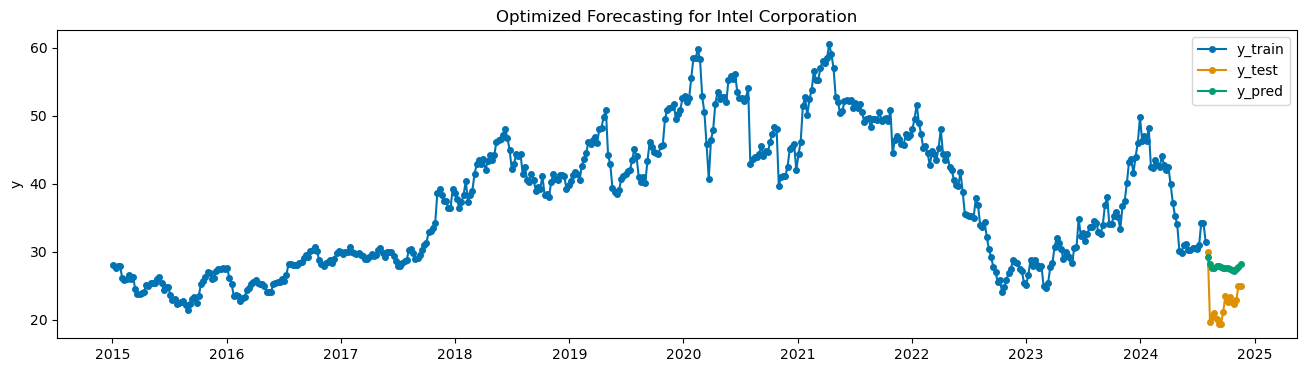

13:26:13 - cmdstanpy - INFO - Chain [1] start processing
13:26:13 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# Dictionary to store each optimized Prophet model by company
prophet_models = {}

# Hyperparameter grid for fine-tuning
param_grid = {
    'changepoint_prior_scale': np.arange(0.01, 0.15, 0.01).round(3).tolist(),
    'seasonality_prior_scale': np.arange(0.01, 0.15, 0.01).round(3).tolist(),  # Adjusted range based on the image
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False],
    'daily_seasonality': [True, False]
}

# Define the total number of parameter combinations
total_combinations = len(list(ParameterGrid(param_grid)))

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Prepare the training data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure DatetimeIndex
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    # Placeholder variables for tracking the best model
    best_mape = float('inf')
    best_params = None
    best_model = None

    # Perform grid search over the parameter grid
    for i, params in enumerate(ParameterGrid(param_grid), start=1):
        print(f"Processing combination {i} of {total_combinations} for {company}...")

        # Initialize and fit the Prophet model with the current set of parameters
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            seasonality_mode=params['seasonality_mode'],
            weekly_seasonality=params['weekly_seasonality'],
            yearly_seasonality=params['yearly_seasonality'],
            daily_seasonality=params['daily_seasonality']
        )
        
        # Fit the model
        model.fit(train_data_prophet)

        # Define the forecast horizon (e.g., test_weeks periods into the future)
        future = model.make_future_dataframe(periods=test_weeks, freq='W')
        forecast = model.predict(future)
        
        # Filter forecasted data
        forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]
        
        # Evaluate the model performance on test data
        actuals = test_dataframes[company]['Close']
        predictions = forecast_filtered['Close']

        # Align indices
        common_index = actuals.index.intersection(predictions.index)
        actuals = actuals.loc[common_index]
        predictions = predictions.loc[common_index]

        mape = mean_absolute_percentage_error(actuals, predictions) * 100
        rmse = root_mean_squared_error(actuals, predictions)
        
        # Check if current model is better
        if mape < best_mape:
            best_mape = mape
            best_params = params
            best_model = model

    # Print best parameters and MAPE for each company
    print(f'Best parameters for {company}: {best_params} with MAPE: {best_mape:.2f}')

    # Plot the best model's predictions
    future = best_model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = best_model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    plot_series(
        train_data_prophet.set_index('ds')[-500:],  # Only show the last 500 training points
        test_dataframes[company],                   # Test data
        forecast_filtered,                          # Forecasted data
        labels=["y_train", "y_test", "y_pred"]
    )
    
    plt.title(f'Optimized Forecasting for {company}')
    plt.show()

    # Refit the best model with all available data (train + test)
    # train_data_prophet = train_data_prophet.reset_index(names="ds")
    test_data = pd.DataFrame(actuals).rename(columns={'Close': 'y'}).reset_index(names="ds")
    all_data = pd.concat([train_data_prophet, test_data])

    # Re-initialize Prophet with the best parameters
    prophet_model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        weekly_seasonality=best_params['weekly_seasonality'],
        yearly_seasonality=best_params['yearly_seasonality'],
        daily_seasonality=best_params['daily_seasonality']
    )
    
    # Fit the model on all data
    prophet_model.fit(all_data)

    # Store the optimized model in the dictionary
    prophet_models[company] = prophet_model

#### 2.5.6.4 Save the best prophet models of ASML's suppliers

In [18]:
# Iterate over each company in prophet_models
for company in company_tickers.values():
    # Define the output path for the current company's model
    output_model_path = f'models/prophet_asml_supplier_{company.replace(" ", "_")}.pkl'

    # Save the current company's Prophet model
    joblib.dump(prophet_models[company], output_model_path)
    print(f'Prophet model for {company} saved at {output_model_path}')

Prophet model for Carl Zeiss Meditec saved at models/prophet_asml_supplier_Carl_Zeiss_Meditec.pkl
Prophet model for Lam Research Corporation saved at models/prophet_asml_supplier_Lam_Research_Corporation.pkl
Prophet model for Tokyo Electron Limited saved at models/prophet_asml_supplier_Tokyo_Electron_Limited.pkl
Prophet model for Taiwan Semiconductor Manufacturing Company saved at models/prophet_asml_supplier_Taiwan_Semiconductor_Manufacturing_Company.pkl
Prophet model for Samsung Electronics saved at models/prophet_asml_supplier_Samsung_Electronics.pkl
Prophet model for Intel Corporation saved at models/prophet_asml_supplier_Intel_Corporation.pkl


# 3. Export the data